In [1]:
import numpy as np
import pickle
import sys
from typing import List
import torch
import os

In [2]:
participant_data_path = './EEG/number'
processed_data_path = './EEG/processed_data'
split_data_path = './EEG/split_data'

In [3]:
ps = os.listdir(participant_data_path)
participants=[]
for p in ps:
    p= p[:3]
    if p not in participants:
        participants.append(p)
        
participants= sorted(participants)
# participants, len(participants)

In [4]:
load_name=f"userfold_data_scaled_p_dictionary-number"
data_dir = "./EEG/split_data/standard_scaled"
try:
    raw_user_fold= pickle.load(open(os.path.join(data_dir, f"{load_name}.pkl"), "rb"))
except:
    print(f"pickle file does not exist. Use EEG-Preprocess.ipynb and EEG-Split.ipynb to save data setting.")
    sys.exit()

In [5]:
from utilities.userfold_framework import *
from Models.AR_EEG_models import *
import Models.model_func as Model_Func
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
from torcheeg.models import EEGNet

from torch import nn
from Models.multi_models import *

DEVICE= torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

learning_rate = 0.00005
batch_size = 64
n_epochs = 300
transpose_channels=True
participants_dictionary=[]
# participants_online_dictionary=[]
participants_grads_dictionary={}
b_acc_list=[]
c0_acc_list=[]
c1_acc_list=[]

# EPOCH=[
    
# ]

for i in range(len(participants)):

    train_dataloader, val_dataloader, classes, input_dim, class_ratio= user_fold_load(i,
                                                                                      raw_user_fold,
                                                                                      participants,
                                                                                      batch_size=batch_size,
                                                                                      transpose_channels=transpose_channels)

    classifier= EEGNet(
        chunk_size=input_dim[1],
        num_electrodes=input_dim[0],
        num_classes=classes,
        kernel_1= 32,
        kernel_2=32,
        F1=8,
        F2=16,
        dropout=0.5
    ).to(DEVICE)
    
#     resnet = ResNetPlus(input_dim[0], classes, bn_1st=False)
#     softmax_activation = nn.LogSoftmax(dim=1)
#     classifier = nn.Sequential(resnet, softmax_activation).to(DEVICE)

    
#     classifier = DataGliderBasic_Model(DEVICE, input_dim, classes)
#     classifier.to(DEVICE)
    
#     optimizer= torch.optim.RMSprop(classifier.parameters(), lr=learning_rate)
    
    
    criterion= torch.nn.CrossEntropyLoss(weight=torch.tensor(class_ratio, dtype=torch.float).to(DEVICE))
#     criterion = nn.NLLLoss(weight=torch.tensor(class_ratio, dtype=torch.float).to(DEVICE))
        
    saved_dir= "./EEG/saved_models/Userfold/run0"
    model = EEGNet_DF_EEG_Wrapper(DEVICE, classifier, input_dim[0]).to(DEVICE)
#     model= EEGNet_Wrapper(DEVICE, df)
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    scheduler= torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)

    
    train_func= eeg_DF_train
    model.training_procedure(iteration=n_epochs,
                                    train_dataloader=train_dataloader,
                                     val_dataloader=val_dataloader,
                                     print_cycle=2,
                                     path=f"./dictionary/intermdiate_dicts",
                                     loss_func=criterion,
                                     optimiser=optimizer, #scheduler=scheduler,
                                     train_func=train_func
                                    )
    if model.epoch == n_epochs+1:
        EPOCH= n_epochs
    else:
        EPOCH= model.epoch
    
    torch.save(model.state_dict(), 
           os.path.join(
               saved_dir, f"Userfold-{participants[i]}-EEGNet-DF_EEG-e{EPOCH}.pt"
           )
    )

    pickle.dump( model.return_DF_weights(), 
                open(f"{saved_dir}/Userfold-{participants[i]}-EEGNet-DF_EEG-w-e{EPOCH}.pkl", "wb") 
               )    

# OR
#     model.load_state_dict(
#     torch.load(
#         open(
#             os.path.join(
#                 saved_dir, f"Userfold-{participants[i]}-EEGNet-Weight_EEG-e{n_epochs}.pt"
#             ), "rb"
#         )
#               )
#     )
    
    prediction, dictionary= model.prediction_procedure(val_dataloader, dict_flag=True)
    
    ys= np.concatenate([y.detach().cpu().numpy() for x, y in val_dataloader])
    
    c0_acc, c1_acc, b_acc= calculate_accuracy(ys, prediction)
    print("c0_acc", c0_acc, ", c1_acc", c1_acc, ", b_acc", b_acc)
    b_acc_list.append(b_acc)
    c0_acc_list.append(c0_acc)
    c1_acc_list.append(c1_acc)
    participants_dictionary.append(dictionary)
    

tmp=[]
for i, dictionary in enumerate(participants_dictionary):
    print(f"User {participants[i]} f1: {dictionary['weighted avg']['f1-score']} acc: {dictionary['accuracy']}")
    print(f" c0: {c0_acc_list[i]} c1: {c1_acc_list[i]} bacc: {b_acc_list[i]}")
    tmp.append(dictionary['weighted avg']['f1-score'])

print(f"average {np.mean(tmp)}")
print()
print(np.array(b_acc_list).mean())
print(np.array(c1_acc_list).mean())
print(np.array(c0_acc_list).mean())


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 17.98534606484806


Iterations:   0%|                                   | 1/300 [00:03<15:10,  3.04s/it]

Epoch:  0
t_loss:  17.98534606484806 , v_loss:  0.6919819513956705
t_acc:  0.4786803610333022 , v_acc:  0.5962732919254659
t_recall:  0.49013875735990453 , v_recall:  0.5258558558558558
t_prec:  0.4916112084063047 , v_prec:  0.5261479591836735
t_f:  0.4645471518179742 , v_f:  0.5259772614032704
////////


Iterations:   1%|▏                                  | 2/300 [00:03<08:33,  1.72s/it]

Epoch  1 , loss 17.862702463187425
Epoch  2 , loss 17.74988009882908


Iterations:   1%|▎                                  | 3/300 [00:05<07:44,  1.56s/it]

Epoch:  2
t_loss:  17.74988009882908 , v_loss:  0.6855771144231161
t_acc:  0.554933084344849 , v_acc:  0.6645962732919255
t_recall:  0.48082856397798546 , v_recall:  0.5259459459459459
t_prec:  0.4812855204666663 , v_prec:  0.5510638297872341
t_f:  0.4809545865341166 , v_f:  0.5071428571428571
////////


Iterations:   1%|▍                                  | 4/300 [00:06<06:15,  1.27s/it]

Epoch  3 , loss 17.632397857366822
Epoch  4 , loss 17.518320121017158


Iterations:   2%|▌                                  | 5/300 [00:07<06:26,  1.31s/it]

Epoch:  4
t_loss:  17.518320121017158 , v_loss:  0.6741877198219299
t_acc:  0.6246498599439776 , v_acc:  0.6832298136645962
t_recall:  0.49499869614745884 , v_recall:  0.522972972972973
t_prec:  0.49251448213527615 , v_prec:  0.5772727272727273
t_f:  0.48178805467140984 , v_f:  0.4842660636894668
////////


Iterations:   2%|▋                                  | 6/300 [00:08<05:36,  1.15s/it]

Epoch  5 , loss 17.413773630179612
Epoch  6 , loss 17.307237438127107


Iterations:   2%|▊                                  | 7/300 [00:09<05:58,  1.23s/it]

Epoch:  6
t_loss:  17.307237438127107 , v_loss:  0.6616616447766622
t_acc:  0.6626206037970744 , v_acc:  0.6894409937888198
t_recall:  0.49813892205706756 , v_recall:  0.5
t_prec:  0.49466414827057015 , v_prec:  0.3447204968944099
t_f:  0.4570570739098715 , v_f:  0.4080882352941176
////////


Iterations:   3%|▉                                  | 8/300 [00:10<05:20,  1.10s/it]

Epoch  7 , loss 17.201436360677082
Epoch  8 , loss 17.103071511960497


Iterations:   3%|█                                  | 9/300 [00:11<05:44,  1.18s/it]

Epoch:  8
t_loss:  17.103071511960497 , v_loss:  0.6536032259464264
t_acc:  0.6816059757236228 , v_acc:  0.6894409937888198
t_recall:  0.4988464336201809 , v_recall:  0.5
t_prec:  0.49241293607187775 , v_prec:  0.3447204968944099
t_f:  0.4328028459090058 , v_f:  0.4080882352941176
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:09,  1.07s/it]

Epoch  9 , loss 17.00730593064252
Epoch  10 , loss 16.906655666874904


Iterations:   4%|█▏                                | 11/300 [00:14<05:36,  1.16s/it]

Epoch:  10
t_loss:  16.906655666874904 , v_loss:  0.650234709183375
t_acc:  0.6893868658574541 , v_acc:  0.6894409937888198
t_recall:  0.49782599744719397 , v_recall:  0.5
t_prec:  0.45845136921624174 , v_prec:  0.3447204968944099
t_f:  0.4156870334168646 , v_f:  0.4080882352941176
////////


Iterations:   4%|█▎                                | 12/300 [00:14<05:02,  1.05s/it]

Epoch  11 , loss 16.817108939675723
Epoch  12 , loss 16.722597122192383


Iterations:   4%|█▍                                | 13/300 [00:16<05:28,  1.15s/it]

Epoch:  12
t_loss:  16.722597122192383 , v_loss:  0.6503851215044657
t_acc:  0.6915655150949268 , v_acc:  0.6894409937888198
t_recall:  0.4991044591756907 , v_recall:  0.5
t_prec:  0.4772441933458883 , v_prec:  0.3447204968944099
t_f:  0.41556137409245975 , v_f:  0.4080882352941176
////////


Iterations:   5%|█▌                                | 14/300 [00:17<05:00,  1.05s/it]

Epoch  13 , loss 16.62879341723872
Epoch  14 , loss 16.53784980025946


Iterations:   5%|█▋                                | 15/300 [00:18<05:25,  1.14s/it]

Epoch:  14
t_loss:  16.53784980025946 , v_loss:  0.6520330111185709
t_acc:  0.6946778711484594 , v_acc:  0.6894409937888198
t_recall:  0.5007665280465544 , v_recall:  0.5
t_prec:  0.5402764423076923 , v_prec:  0.3447204968944099
t_f:  0.41479701861370544 , v_f:  0.4080882352941176
////////


Iterations:   5%|█▊                                | 16/300 [00:19<04:56,  1.04s/it]

Epoch  15 , loss 16.4508155373966
Epoch  16 , loss 16.364345700133082


Iterations:   6%|█▉                                | 17/300 [00:20<05:23,  1.14s/it]

Epoch:  16
t_loss:  16.364345700133082 , v_loss:  0.6550408204396566
t_acc:  0.6946778711484594 , v_acc:  0.6894409937888198
t_recall:  0.5001914604520937 , v_recall:  0.5
t_prec:  0.5145131086142322 , v_prec:  0.3447204968944099
t_f:  0.4128574949243642 , v_f:  0.4080882352941176
////////


Iterations:   6%|██                                | 18/300 [00:21<04:52,  1.04s/it]

Epoch  17 , loss 16.27813399071787
Epoch  18 , loss 16.193981282851276


Iterations:   6%|██▏                               | 19/300 [00:22<05:19,  1.14s/it]

Epoch:  18
t_loss:  16.193981282851276 , v_loss:  0.6595984697341919
t_acc:  0.6946778711484594 , v_acc:  0.6894409937888198
t_recall:  0.49961639285763304 , v_recall:  0.5
t_prec:  0.44772443890274316 , v_prec:  0.3447204968944099
t_f:  0.4109015490043957 , v_f:  0.4080882352941176
////////


Iterations:   7%|██▎                               | 20/300 [00:23<04:51,  1.04s/it]

Epoch  19 , loss 16.113497902365292
Epoch  20 , loss 16.020464205274394


Iterations:   7%|██▍                               | 21/300 [00:24<05:18,  1.14s/it]

Epoch:  20
t_loss:  16.020464205274394 , v_loss:  0.6624095737934113
t_acc:  0.6962340491752257 , v_acc:  0.6894409937888198
t_recall:  0.5010224948875256 , v_recall:  0.5
t_prec:  0.8480224229212083 , v_prec:  0.3447204968944099
t_f:  0.4124337652798909 , v_f:  0.4080882352941176
////////


Iterations:   7%|██▍                               | 22/300 [00:25<04:50,  1.04s/it]

Epoch  21 , loss 15.943756327909583
Epoch  22 , loss 15.859856624229282


Iterations:   8%|██▌                               | 23/300 [00:27<05:16,  1.14s/it]

Epoch:  22
t_loss:  15.859856624229282 , v_loss:  0.6651119987169901
t_acc:  0.6943666355431062 , v_acc:  0.6894409937888198
t_recall:  0.49910514541387024 , v_recall:  0.5
t_prec:  0.347616079775631 , v_prec:  0.3447204968944099
t_f:  0.40980896399706096 , v_f:  0.4080882352941176
////////


Iterations:   8%|██▋                               | 24/300 [00:27<04:48,  1.04s/it]

Epoch  23 , loss 15.774368173935834
Epoch  24 , loss 15.693777720133463


Iterations:   8%|██▊                               | 25/300 [00:29<05:14,  1.14s/it]

Epoch:  24
t_loss:  15.693777720133463 , v_loss:  0.6686331828435262
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5007987812409931 , v_recall:  0.5
t_prec:  0.6813084112149532 , v_prec:  0.3447204968944099
t_f:  0.41232340081380947 , v_f:  0.4080882352941176
////////


Iterations:   9%|██▉                               | 26/300 [00:30<04:45,  1.04s/it]

Epoch  25 , loss 15.61824753705193
Epoch  26 , loss 15.529475922678031


Iterations:   9%|███                               | 27/300 [00:31<05:11,  1.14s/it]

Epoch:  26
t_loss:  15.529475922678031 , v_loss:  0.6710121234258016
t_acc:  0.6962340491752257 , v_acc:  0.6894409937888198
t_recall:  0.5010224948875256 , v_recall:  0.5
t_prec:  0.8480224229212083 , v_prec:  0.3447204968944099
t_f:  0.4124337652798909 , v_f:  0.4080882352941176
////////


Iterations:   9%|███▏                              | 28/300 [00:32<04:42,  1.04s/it]

Epoch  27 , loss 15.4461456934611
Epoch  28 , loss 15.364537201675715


Iterations:  10%|███▎                              | 29/300 [00:33<05:07,  1.13s/it]

Epoch:  28
t_loss:  15.364537201675715 , v_loss:  0.6730128129323324
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5005750675944607 , v_recall:  0.5
t_prec:  0.5979277033343721 , v_prec:  0.3447204968944099
t_f:  0.4122130008035903 , v_f:  0.4080882352941176
////////


Iterations:  10%|███▍                              | 30/300 [00:34<04:39,  1.03s/it]

Epoch  29 , loss 15.288186839982576
Epoch  30 , loss 15.204465866088867


Iterations:  10%|███▌                              | 31/300 [00:35<05:07,  1.14s/it]

Epoch:  30
t_loss:  15.204465866088867 , v_loss:  0.6750527222951254
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5005112474437627 , v_recall:  0.5
t_prec:  0.8479140722291407 , v_prec:  0.3447204968944099
t_f:  0.41133905648131597 , v_f:  0.4080882352941176
////////


Iterations:  11%|███▋                              | 32/300 [00:36<04:40,  1.05s/it]

Epoch  31 , loss 15.124727267845005
Epoch  32 , loss 15.040081641253304


Iterations:  11%|███▋                              | 33/300 [00:38<05:07,  1.15s/it]

Epoch:  32
t_loss:  15.040081641253304 , v_loss:  0.6748316486676534
t_acc:  0.6962340491752257 , v_acc:  0.6894409937888198
t_recall:  0.5013100286847559 , v_recall:  0.5
t_prec:  0.7230835151137426 , v_prec:  0.3447204968944099
t_f:  0.4134150192068549 , v_f:  0.4080882352941176
////////


Iterations:  11%|███▊                              | 34/300 [00:38<04:41,  1.06s/it]

Epoch  33 , loss 14.961131993462057
Epoch  34 , loss 14.883077883252911


Iterations:  12%|███▉                              | 35/300 [00:40<05:07,  1.16s/it]

Epoch:  34
t_loss:  14.883077883252911 , v_loss:  0.6761613388856252
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:  12%|████                              | 36/300 [00:41<04:39,  1.06s/it]

Epoch  35 , loss 14.809441323373832
Epoch  36 , loss 14.721601729299508


Iterations:  12%|████▏                             | 37/300 [00:42<05:07,  1.17s/it]

Epoch:  36
t_loss:  14.721601729299508 , v_loss:  0.6730706095695496
t_acc:  0.6953003423591659 , v_acc:  0.6894409937888198
t_recall:  0.500063820150698 , v_recall:  0.5
t_prec:  0.5144859813084112 , v_prec:  0.3447204968944099
t_f:  0.4111203780928551 , v_f:  0.4080882352941176
////////


Iterations:  13%|████▎                             | 38/300 [00:43<04:40,  1.07s/it]

Epoch  37 , loss 14.646584604300704
Epoch  38 , loss 14.572923847273284


Iterations:  13%|████▍                             | 39/300 [00:44<05:06,  1.17s/it]

Epoch:  38
t_loss:  14.572923847273284 , v_loss:  0.6721286177635193
t_acc:  0.6953003423591659 , v_acc:  0.6894409937888198
t_recall:  0.49977628635346755 , v_recall:  0.5
t_prec:  0.34775840597758406 , v_prec:  0.3447204968944099
t_f:  0.41013401872590416 , v_f:  0.4080882352941176
////////


Iterations:  13%|████▌                             | 40/300 [00:45<04:38,  1.07s/it]

Epoch  39 , loss 14.486978287790336
Epoch  40 , loss 14.409389626746083


Iterations:  14%|████▋                             | 41/300 [00:47<05:03,  1.17s/it]

Epoch:  40
t_loss:  14.409389626746083 , v_loss:  0.6719313611586889
t_acc:  0.6953003423591659 , v_acc:  0.6894409937888198
t_recall:  0.500063820150698 , v_recall:  0.5
t_prec:  0.5144859813084112 , v_prec:  0.3447204968944099
t_f:  0.4111203780928551 , v_f:  0.4080882352941176
////////


Iterations:  14%|████▊                             | 42/300 [00:47<04:35,  1.07s/it]

Epoch  41 , loss 14.329366141674566
Epoch  42 , loss 14.248822006524778


Iterations:  14%|████▊                             | 43/300 [00:49<05:01,  1.17s/it]

Epoch:  42
t_loss:  14.248822006524778 , v_loss:  0.6694540331761042
t_acc:  0.6953003423591659 , v_acc:  0.6894409937888198
t_recall:  0.49977628635346755 , v_recall:  0.5
t_prec:  0.34775840597758406 , v_prec:  0.3447204968944099
t_f:  0.41013401872590416 , v_f:  0.4080882352941176
////////


Iterations:  15%|████▉                             | 44/300 [00:50<04:48,  1.13s/it]

Epoch  43 , loss 14.175134527917002
Epoch  44 , loss 14.098173945557837


Iterations:  15%|█████                             | 45/300 [00:51<05:08,  1.21s/it]

Epoch:  44
t_loss:  14.098173945557837 , v_loss:  0.6670104364554087
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5010863150382235 , v_recall:  0.5
t_prec:  0.6480361596009975 , v_prec:  0.3447204968944099
t_f:  0.41330358142435736 , v_f:  0.4080882352941176
////////


Iterations:  15%|█████▏                            | 46/300 [00:52<04:39,  1.10s/it]

Epoch  45 , loss 14.025142968869677
Epoch  46 , loss 13.944137049656288


Iterations:  16%|█████▎                            | 47/300 [00:53<05:00,  1.19s/it]

Epoch:  46
t_loss:  13.944137049656288 , v_loss:  0.6639380306005478
t_acc:  0.6965452847805789 , v_acc:  0.6894409937888198
t_recall:  0.5018212761285187 , v_recall:  0.5
t_prec:  0.7481920199501246 , v_prec:  0.3447204968944099
t_f:  0.4145045976343382 , v_f:  0.4080882352941176
////////


Iterations:  16%|█████▍                            | 48/300 [00:54<04:32,  1.08s/it]

Epoch  47 , loss 13.861368833803663
Epoch  48 , loss 13.789100085987764


Iterations:  16%|█████▌                            | 49/300 [00:56<04:52,  1.17s/it]

Epoch:  48
t_loss:  13.789100085987764 , v_loss:  0.6615280459324518
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5013738488354538 , v_recall:  0.5
t_prec:  0.6338116032439176 , v_prec:  0.3447204968944099
t_f:  0.4142796235015772 , v_f:  0.4080882352941176
////////


Iterations:  17%|█████▋                            | 50/300 [00:56<04:27,  1.07s/it]

Epoch  49 , loss 13.704530510247922
Epoch  50 , loss 13.62050551994174


Iterations:  17%|█████▊                            | 51/300 [00:58<04:49,  1.16s/it]

Epoch:  50
t_loss:  13.62050551994174 , v_loss:  0.6601090232531229
t_acc:  0.6965452847805789 , v_acc:  0.6894409937888198
t_recall:  0.5018212761285187 , v_recall:  0.5
t_prec:  0.7481920199501246 , v_prec:  0.3447204968944099
t_f:  0.4145045976343382 , v_f:  0.4080882352941176
////////


Iterations:  17%|█████▉                            | 52/300 [00:59<04:22,  1.06s/it]

Epoch  51 , loss 13.551668129715265
Epoch  52 , loss 13.484556534711052


Iterations:  18%|██████                            | 53/300 [01:00<04:46,  1.16s/it]

Epoch:  52
t_loss:  13.484556534711052 , v_loss:  0.6584857900937399
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5011501351889214 , v_recall:  0.5
t_prec:  0.5980499219968799 , v_prec:  0.3447204968944099
t_f:  0.41416708924949286 , v_f:  0.4080882352941176
////////


Iterations:  18%|██████                            | 54/300 [01:01<04:20,  1.06s/it]

Epoch  53 , loss 13.405954697552849
Epoch  54 , loss 13.32889648512298


Iterations:  18%|██████▏                           | 55/300 [01:02<04:46,  1.17s/it]

Epoch:  54
t_loss:  13.32889648512298 , v_loss:  0.6546477278073629
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5005750675944607 , v_recall:  0.5
t_prec:  0.5979277033343721 , v_prec:  0.3447204968944099
t_f:  0.4122130008035903 , v_f:  0.4080882352941176
////////


Iterations:  19%|██████▎                           | 56/300 [01:03<04:19,  1.07s/it]

Epoch  55 , loss 13.254114300596948
Epoch  56 , loss 13.182257390489765


Iterations:  19%|██████▍                           | 57/300 [01:05<04:43,  1.17s/it]

Epoch:  56
t_loss:  13.182257390489765 , v_loss:  0.6508772969245911
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5013738488354538 , v_recall:  0.5
t_prec:  0.6338116032439176 , v_prec:  0.3447204968944099
t_f:  0.4142796235015772 , v_f:  0.4080882352941176
////////


Iterations:  19%|██████▌                           | 58/300 [01:05<04:17,  1.06s/it]

Epoch  57 , loss 13.103114689097685
Epoch  58 , loss 13.03284127104516


Iterations:  20%|██████▋                           | 59/300 [01:07<04:40,  1.16s/it]

Epoch:  58
t_loss:  13.03284127104516 , v_loss:  0.6469272325436274
t_acc:  0.6943666355431062 , v_acc:  0.6894409937888198
t_recall:  0.4999677468055613 , v_recall:  0.5
t_prec:  0.49779893849516077 , v_prec:  0.3447204968944099
t_f:  0.41274588925137695 , v_f:  0.4080882352941176
////////


Iterations:  20%|██████▊                           | 60/300 [01:08<04:18,  1.08s/it]

Epoch  59 , loss 12.958449008418064
Epoch  60 , loss 12.876933322233313


Iterations:  20%|██████▉                           | 61/300 [01:09<04:41,  1.18s/it]

Epoch:  60
t_loss:  12.876933322233313 , v_loss:  0.6433900793393453
t_acc:  0.6962340491752257 , v_acc:  0.6894409937888198
t_recall:  0.5015975624819863 , v_recall:  0.5
t_prec:  0.6814780168381664 , v_prec:  0.3447204968944099
t_f:  0.4143921262806895 , v_f:  0.4080882352941176
////////


Iterations:  21%|███████                           | 62/300 [01:10<04:19,  1.09s/it]

Epoch  61 , loss 12.804241460912367
Epoch  62 , loss 12.728636330249262


Iterations:  21%|███████▏                          | 63/300 [01:11<04:41,  1.19s/it]

Epoch:  62
t_loss:  12.728636330249262 , v_loss:  0.6416371663411459
t_acc:  0.6962340491752257 , v_acc:  0.6894409937888198
t_recall:  0.5027476976709077 , v_recall:  0.5
t_prec:  0.6341044076273835 , v_prec:  0.3447204968944099
t_f:  0.41825958421883713 , v_f:  0.4080882352941176
////////


Iterations:  21%|███████▎                          | 64/300 [01:12<04:14,  1.08s/it]

Epoch  63 , loss 12.658613391951018
Epoch  64 , loss 12.585252836638807


Iterations:  22%|███████▎                          | 65/300 [01:14<04:35,  1.17s/it]

Epoch:  64
t_loss:  12.585252836638807 , v_loss:  0.6364819904168447
t_acc:  0.6965452847805789 , v_acc:  0.6894409937888198
t_recall:  0.50297141131744 , v_recall:  0.5
t_prec:  0.6561298076923077 , v_prec:  0.3447204968944099
t_f:  0.4183762417414505 , v_f:  0.4080882352941176
////////


Iterations:  22%|███████▍                          | 66/300 [01:14<04:09,  1.07s/it]

Epoch  65 , loss 12.50787519941143
Epoch  66 , loss 12.432220982570275


Iterations:  22%|███████▌                          | 67/300 [01:16<04:32,  1.17s/it]

Epoch:  66
t_loss:  12.432220982570275 , v_loss:  0.632991780837377
t_acc:  0.6968565203859322 , v_acc:  0.6894409937888198
t_recall:  0.5043452601528938 , v_recall:  0.5
t_prec:  0.6487316003758221 , v_prec:  0.3447204968944099
t_f:  0.4223040775729794 , v_f:  0.4080882352941176
////////


Iterations:  23%|███████▋                          | 68/300 [01:17<04:10,  1.08s/it]

Epoch  67 , loss 12.359282680586272
Epoch  68 , loss 12.284597041560154


Iterations:  23%|███████▊                          | 69/300 [01:18<04:32,  1.18s/it]

Epoch:  68
t_loss:  12.284597041560154 , v_loss:  0.6299095849196116
t_acc:  0.6971677559912854 , v_acc:  0.6894409937888198
t_recall:  0.5039939062049656 , v_recall:  0.5
t_prec:  0.6819887429643527 , v_prec:  0.3447204968944099
t_f:  0.42052512257253005 , v_f:  0.4080882352941176
////////


Iterations:  23%|███████▉                          | 70/300 [01:19<04:07,  1.07s/it]

Epoch  69 , loss 12.207672567928538
Epoch  70 , loss 12.138532769446279


Iterations:  24%|████████                          | 71/300 [01:20<04:27,  1.17s/it]

Epoch:  70
t_loss:  12.138532769446279 , v_loss:  0.6284608791271845
t_acc:  0.6946778711484594 , v_acc:  0.6894409937888198
t_recall:  0.5010540618437848 , v_recall:  0.5
t_prec:  0.5480300187617261 , v_prec:  0.3447204968944099
t_f:  0.41576068370365055 , v_f:  0.4080882352941176
////////


Iterations:  24%|████████▏                         | 72/300 [01:21<04:02,  1.06s/it]

Epoch  71 , loss 12.059059292662377
Epoch  72 , loss 11.988579132977653


Iterations:  24%|████████▎                         | 73/300 [01:23<04:25,  1.17s/it]

Epoch:  72
t_loss:  11.988579132977653 , v_loss:  0.6239890605211258
t_acc:  0.6974789915966386 , v_acc:  0.6894409937888198
t_recall:  0.5045051536487284 , v_recall:  0.5
t_prec:  0.6925144666875196 , v_prec:  0.3447204968944099
t_f:  0.4215965898483685 , v_f:  0.4080882352941176
////////


Iterations:  25%|████████▍                         | 74/300 [01:23<04:01,  1.07s/it]

Epoch  73 , loss 11.91664213292739
Epoch  74 , loss 11.846018099317364


Iterations:  25%|████████▌                         | 75/300 [01:25<04:24,  1.18s/it]

Epoch:  74
t_loss:  11.846018099317364 , v_loss:  0.6190690398216248
t_acc:  0.6949891067538126 , v_acc:  0.6894409937888198
t_recall:  0.5015653092875475 , v_recall:  0.5
t_prec:  0.5668888802001877 , v_prec:  0.3447204968944099
t_f:  0.41683606795411643 , v_f:  0.4080882352941176
////////


Iterations:  25%|████████▌                         | 76/300 [01:26<04:00,  1.07s/it]

Epoch  75 , loss 11.785827543221268
Epoch  76 , loss 11.703989141127643


Iterations:  26%|████████▋                         | 77/300 [01:27<04:20,  1.17s/it]

Epoch:  76
t_loss:  11.703989141127643 , v_loss:  0.6140806178251902
t_acc:  0.6984126984126984 , v_acc:  0.6894409937888198
t_recall:  0.5074765649661684 , v_recall:  0.5
t_prec:  0.67698947322821 , v_prec:  0.3447204968944099
t_f:  0.42946028474236353 , v_f:  0.4080882352941176
////////


Iterations:  26%|████████▊                         | 78/300 [01:28<03:56,  1.06s/it]

Epoch  77 , loss 11.635954931670545
Epoch  78 , loss 11.559561261943742


Iterations:  26%|████████▉                         | 79/300 [01:29<04:18,  1.17s/it]

Epoch:  78
t_loss:  11.559561261943742 , v_loss:  0.610594297448794
t_acc:  0.6962340491752257 , v_acc:  0.6894409937888198
t_recall:  0.503897832859829 , v_recall:  0.5
t_prec:  0.6213640637018888 , v_prec:  0.3447204968944099
t_f:  0.4220626612605971 , v_f:  0.4080882352941176
////////


Iterations:  27%|█████████                         | 80/300 [01:30<03:56,  1.07s/it]

Epoch  79 , loss 11.496086868585325
Epoch  80 , loss 11.41839853922526


Iterations:  27%|█████████▏                        | 81/300 [01:32<04:18,  1.18s/it]

Epoch:  80
t_loss:  11.41839853922526 , v_loss:  0.6064953655004501
t_acc:  0.6999688764394647 , v_acc:  0.7018633540372671
t_recall:  0.5100328021849824 , v_recall:  0.52
t_prec:  0.7028939918213275 , v_prec:  0.8490566037735849
t_f:  0.4346869702469517 , v_f:  0.44957264957264953
////////


Iterations:  27%|█████████▎                        | 82/300 [01:32<03:57,  1.09s/it]

Epoch  81 , loss 11.352696998446595
Epoch  82 , loss 11.283092311784333


Iterations:  28%|█████████▍                        | 83/300 [01:34<04:21,  1.20s/it]

Epoch:  82
t_loss:  11.283092311784333 , v_loss:  0.6038065403699875
t_acc:  0.6977902272019919 , v_acc:  0.7080745341614907
t_recall:  0.506454070078643 , v_recall:  0.53
t_prec:  0.6639987445072191 , v_prec:  0.8512658227848101
t_f:  0.42735630095234944 , v_f:  0.4692431787893666
////////


Iterations:  28%|█████████▌                        | 84/300 [01:35<03:59,  1.11s/it]

Epoch  83 , loss 11.211717568191828
Epoch  84 , loss 11.13475621915331


Iterations:  28%|█████████▋                        | 85/300 [01:36<04:21,  1.21s/it]

Epoch:  84
t_loss:  11.13475621915331 , v_loss:  0.60243159532547
t_acc:  0.7005913476501712 , v_acc:  0.7080745341614907
t_recall:  0.5104802294780473 , v_recall:  0.53
t_prec:  0.7250471549827098 , v_prec:  0.8512658227848101
t_f:  0.43495144566155286 , v_f:  0.4692431787893666
////////


Iterations:  29%|█████████▋                        | 86/300 [01:37<03:57,  1.11s/it]

Epoch  85 , loss 11.067588245167451
Epoch  86 , loss 10.990957802417231


Iterations:  29%|█████████▊                        | 87/300 [01:39<04:18,  1.21s/it]

Epoch:  86
t_loss:  10.990957802417231 , v_loss:  0.6003193010886511
t_acc:  0.7021475256769374 , v_acc:  0.7018633540372671
t_recall:  0.5130364666968611 , v_recall:  0.52
t_prec:  0.7424901286677106 , v_prec:  0.8490566037735849
t_f:  0.4401404546294585 , v_f:  0.44957264957264953
////////


Iterations:  29%|█████████▉                        | 88/300 [01:40<04:05,  1.16s/it]

Epoch  87 , loss 10.923628694870892
Epoch  88 , loss 10.844917970545152


Iterations:  30%|██████████                        | 89/300 [01:41<04:31,  1.29s/it]

Epoch:  88
t_loss:  10.844917970545152 , v_loss:  0.5970014929771423
t_acc:  0.6993464052287581 , v_acc:  0.7018633540372671
t_recall:  0.5075726383113051 , v_recall:  0.52
t_prec:  0.7357838808011168 , v_prec:  0.8490566037735849
t_f:  0.4279841503870254 , v_f:  0.44957264957264953
////////


Iterations:  30%|██████████▏                       | 90/300 [01:42<04:05,  1.17s/it]

Epoch  89 , loss 10.782490468492695
Epoch  90 , loss 10.70869743122774


Iterations:  30%|██████████▎                       | 91/300 [01:44<04:24,  1.27s/it]

Epoch:  90
t_loss:  10.70869743122774 , v_loss:  0.5947798937559128
t_acc:  0.6987239340180517 , v_acc:  0.7080745341614907
t_recall:  0.509425481396083 , v_recall:  0.53
t_prec:  0.6623266624645445 , v_prec:  0.8512658227848101
t_f:  0.4350609153578777 , v_f:  0.4692431787893666
////////


Iterations:  31%|██████████▍                       | 92/300 [01:44<03:56,  1.14s/it]

Epoch  91 , loss 10.639072698705336
Epoch  92 , loss 10.564998009625603


Iterations:  31%|██████████▌                       | 93/300 [01:46<04:16,  1.24s/it]

Epoch:  92
t_loss:  10.564998009625603 , v_loss:  0.5938540250062943
t_acc:  0.6981014628073452 , v_acc:  0.7080745341614907
t_recall:  0.507252851319636 , v_recall:  0.53
t_prec:  0.6660226201696513 , v_prec:  0.8512658227848101
t_f:  0.4293327796234772 , v_f:  0.4692431787893666
////////


Iterations:  31%|██████████▋                       | 94/300 [01:47<03:55,  1.14s/it]

Epoch  93 , loss 10.494104086184034
Epoch  94 , loss 10.429744290370568


Iterations:  32%|██████████▊                       | 95/300 [01:48<04:14,  1.24s/it]

Epoch:  94
t_loss:  10.429744290370568 , v_loss:  0.5917764703432719
t_acc:  0.6974789915966386 , v_acc:  0.7142857142857143
t_recall:  0.5073804916210318 , v_recall:  0.54
t_prec:  0.6410528800755431 , v_prec:  0.8535031847133758
t_f:  0.4309096157126176 , v_f:  0.488253178551686
////////


Iterations:  32%|██████████▉                       | 96/300 [01:49<03:59,  1.17s/it]

Epoch  95 , loss 10.36295924467199
Epoch  96 , loss 10.294420934190937


Iterations:  32%|██████████▉                       | 97/300 [01:51<04:18,  1.27s/it]

Epoch:  96
t_loss:  10.294420934190937 , v_loss:  0.5892648299535116
t_acc:  0.6996576408341114 , v_acc:  0.7267080745341615
t_recall:  0.50980908853845 , v_recall:  0.56
t_prec:  0.6927627438640654 , v_prec:  0.8580645161290323
t_f:  0.4345547418019834 , v_f:  0.5244360902255639
////////


Iterations:  33%|███████████                       | 98/300 [01:52<03:55,  1.17s/it]

Epoch  97 , loss 10.223103354958926
Epoch  98 , loss 10.152843961528703


Iterations:  33%|███████████▏                      | 99/300 [01:53<04:17,  1.28s/it]

Epoch:  98
t_loss:  10.152843961528703 , v_loss:  0.586648757259051
t_acc:  0.7009025832555245 , v_acc:  0.7267080745341615
t_recall:  0.5127166797051921 , v_recall:  0.56
t_prec:  0.6949810606060607 , v_prec:  0.8580645161290323
t_f:  0.44137095552975625 , v_f:  0.5244360902255639
////////


Iterations:  33%|███████████                      | 100/300 [01:54<03:51,  1.16s/it]

Epoch  99 , loss 10.090017468321557
Epoch  100 , loss 10.020011901855469


Iterations:  34%|███████████                      | 101/300 [01:56<04:11,  1.26s/it]

Epoch:  100
t_loss:  10.020011901855469 , v_loss:  0.5858693420886993
t_acc:  0.6996576408341114 , v_acc:  0.7204968944099379
t_recall:  0.510671689930141 , v_recall:  0.55
t_prec:  0.6793628702365209 , v_prec:  0.8557692307692308
t_f:  0.4372603899317808 , v_f:  0.5066394279877425
////////


Iterations:  34%|███████████▏                     | 102/300 [01:56<03:45,  1.14s/it]

Epoch  101 , loss 9.95932113423067
Epoch  102 , loss 9.890973165923475


Iterations:  34%|███████████▎                     | 103/300 [01:58<04:02,  1.23s/it]

Epoch:  102
t_loss:  9.890973165923475 , v_loss:  0.5853060980637869
t_acc:  0.7061935885465297 , v_acc:  0.7204968944099379
t_recall:  0.5193951496685469 , v_recall:  0.55
t_prec:  0.7790580568720379 , v_prec:  0.8557692307692308
t_f:  0.4525536062378168 , v_f:  0.5066394279877425
////////


Iterations:  35%|███████████▍                     | 104/300 [01:59<03:39,  1.12s/it]

Epoch  103 , loss 9.826127575893029
Epoch  104 , loss 9.753776363298005


Iterations:  35%|███████████▌                     | 105/300 [02:00<03:58,  1.22s/it]

Epoch:  104
t_loss:  9.753776363298005 , v_loss:  0.5835553208986918
t_acc:  0.7002801120448179 , v_acc:  0.7329192546583851
t_recall:  0.5116941848176665 , v_recall:  0.5700000000000001
t_prec:  0.6875247597388305 , v_prec:  0.8603896103896104
t_f:  0.4393193446413476 , v_f:  0.5416749420721615
////////


Iterations:  35%|███████████▋                     | 106/300 [02:01<03:35,  1.11s/it]

Epoch  105 , loss 9.691438057843376
Epoch  106 , loss 9.632640034544702


Iterations:  36%|███████████▊                     | 107/300 [02:03<03:54,  1.21s/it]

Epoch:  106
t_loss:  9.632640034544702 , v_loss:  0.583690399924914
t_acc:  0.7005913476501712 , v_acc:  0.7267080745341615
t_recall:  0.5130680336531203 , v_recall:  0.56
t_prec:  0.6806165033196332 , v_prec:  0.8580645161290323
t_f:  0.44299409062010286 , v_f:  0.5244360902255639
////////


Iterations:  36%|███████████▉                     | 108/300 [02:03<03:33,  1.11s/it]

Epoch  107 , loss 9.562426398782168
Epoch  108 , loss 9.494199584512149


Iterations:  36%|███████████▉                     | 109/300 [02:05<03:52,  1.21s/it]

Epoch:  108
t_loss:  9.494199584512149 , v_loss:  0.5819616367419561
t_acc:  0.7030812324929971 , v_acc:  0.7267080745341615
t_recall:  0.5180206145949136 , v_recall:  0.5654954954954955
t_prec:  0.6954489520482693 , v_prec:  0.7969771241830066
t_f:  0.4536306479994752 , v_f:  0.5373563218390804
////////


Iterations:  37%|████████████                     | 110/300 [02:06<03:34,  1.13s/it]

Epoch  109 , loss 9.430214825798483
Epoch  110 , loss 9.367750953225528


Iterations:  37%|████████████▏                    | 111/300 [02:07<04:03,  1.29s/it]

Epoch:  110
t_loss:  9.367750953225528 , v_loss:  0.5823969542980194
t_acc:  0.6999688764394647 , v_acc:  0.7329192546583851
t_recall:  0.5117580049683644 , v_recall:  0.5700000000000001
t_prec:  0.6764185005697341 , v_prec:  0.8603896103896104
t_f:  0.4400706624861162 , v_f:  0.5416749420721615
////////


Iterations:  37%|████████████▎                    | 112/300 [02:08<03:39,  1.17s/it]

Epoch  111 , loss 9.30472738602582
Epoch  112 , loss 9.237372099184523


Iterations:  38%|████████████▍                    | 113/300 [02:10<03:56,  1.26s/it]

Epoch:  112
t_loss:  9.237372099184523 , v_loss:  0.5817064394553503
t_acc:  0.7018362900715842 , v_acc:  0.7391304347826086
t_recall:  0.5139628882392501 , v_recall:  0.58
t_prec:  0.7095008305761865 , v_prec:  0.8627450980392157
t_f:  0.4435556998565346 , v_f:  0.5583855799373041
////////


Iterations:  38%|████████████▌                    | 114/300 [02:11<03:32,  1.14s/it]

Epoch  113 , loss 9.170569139368395
Epoch  114 , loss 9.106535556269627


Iterations:  38%|████████████▋                    | 115/300 [02:12<03:48,  1.24s/it]

Epoch:  114
t_loss:  9.106535556269627 , v_loss:  0.5794706692298254
t_acc:  0.702769996887644 , v_acc:  0.7329192546583851
t_recall:  0.5166467657594598 , v_recall:  0.5754954954954955
t_prec:  0.7022713628176906 , v_prec:  0.8062865497076024
t_f:  0.4500737944883985 , v_f:  0.5538441709093253
////////


Iterations:  39%|████████████▊                    | 116/300 [02:13<03:26,  1.12s/it]

Epoch  115 , loss 9.038961354423972
Epoch  116 , loss 8.975304584877163


Iterations:  39%|████████████▊                    | 117/300 [02:14<03:43,  1.22s/it]

Epoch:  116
t_loss:  8.975304584877163 , v_loss:  0.5785534282525381
t_acc:  0.7012138188608776 , v_acc:  0.7329192546583851
t_recall:  0.5120777919600336 , v_recall:  0.5809909909909909
t_prec:  0.7188147534189805 , v_prec:  0.7724242424242425
t_f:  0.43883447101459827 , v_f:  0.5651655046793542
////////


Iterations:  39%|████████████▉                    | 118/300 [02:15<03:23,  1.12s/it]

Epoch  117 , loss 8.907209321564318
Epoch  118 , loss 8.848640254899568


Iterations:  40%|█████████████                    | 119/300 [02:17<03:43,  1.23s/it]

Epoch:  118
t_loss:  8.848640254899568 , v_loss:  0.5766930232445399
t_acc:  0.704014939309057 , v_acc:  0.7329192546583851
t_recall:  0.5178291541428199 , v_recall:  0.5864864864864865
t_prec:  0.7243738845068801 , v_prec:  0.7494802494802495
t_f:  0.45152037284716534 , v_f:  0.5757185757185757
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:18<03:24,  1.14s/it]

Epoch  119 , loss 8.789030935250077
Epoch  120 , loss 8.729588003719554


Iterations:  40%|█████████████▎                   | 121/300 [02:19<03:44,  1.25s/it]

Epoch:  120
t_loss:  8.729588003719554 , v_loss:  0.5768828044335047
t_acc:  0.6996576408341114 , v_acc:  0.7329192546583851
t_recall:  0.5121093589162927 , v_recall:  0.5864864864864865
t_prec:  0.6641366223908918 , v_prec:  0.7494802494802495
t_f:  0.44169663418452426 , v_f:  0.5757185757185757
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:20<03:34,  1.21s/it]

Epoch  121 , loss 8.663059571210075
Epoch  122 , loss 8.609071114484001


Iterations:  41%|█████████████▌                   | 123/300 [02:22<03:54,  1.32s/it]

Epoch:  122
t_loss:  8.609071114484001 , v_loss:  0.5781399657328924
t_acc:  0.6999688764394647 , v_acc:  0.7391304347826086
t_recall:  0.5129081401572858 , v_recall:  0.590990990990991
t_prec:  0.665400443178221 , v_prec:  0.7824384787472036
t_f:  0.44358718990092355 , v_f:  0.5805210918114144
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:23<03:50,  1.31s/it]

Epoch  123 , loss 8.54044708551145
Epoch  124 , loss 8.477576330596326


Iterations:  42%|█████████████▊                   | 125/300 [02:25<04:11,  1.44s/it]

Epoch:  124
t_loss:  8.477576330596326 , v_loss:  0.5752579470475515
t_acc:  0.7005913476501712 , v_acc:  0.7329192546583851
t_recall:  0.5145057026392721 , v_recall:  0.5864864864864865
t_prec:  0.6676022835394861 , v_prec:  0.7494802494802495
t_f:  0.4473364058859122 , v_f:  0.5757185757185757
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:26<03:41,  1.27s/it]

Epoch  125 , loss 8.413184913934446
Epoch  126 , loss 8.353434169993681


Iterations:  42%|█████████████▉                   | 127/300 [02:28<04:04,  1.41s/it]

Epoch:  126
t_loss:  8.353434169993681 , v_loss:  0.57444000740846
t_acc:  0.7012138188608776 , v_acc:  0.7329192546583851
t_recall:  0.5152406637295672 , v_recall:  0.5864864864864865
t_prec:  0.6760941960038059 , v_prec:  0.7494802494802495
t_f:  0.44848539464706416 , v_f:  0.5757185757185757
////////


Iterations:  43%|██████████████                   | 128/300 [02:29<03:40,  1.28s/it]

Epoch  127 , loss 8.289749612995223
Epoch  128 , loss 8.23207389607149


Iterations:  43%|██████████████▏                  | 129/300 [02:30<03:52,  1.36s/it]

Epoch:  128
t_loss:  8.23207389607149 , v_loss:  0.5746445457140604
t_acc:  0.7043261749144102 , v_acc:  0.7329192546583851
t_recall:  0.5209282057616558 , v_recall:  0.5864864864864865
t_prec:  0.6969361046296376 , v_prec:  0.7494802494802495
t_f:  0.4600905500501641 , v_f:  0.5757185757185757
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:31<03:32,  1.25s/it]

Epoch  129 , loss 8.177324201546464
Epoch  130 , loss 8.1097586108189


Iterations:  44%|██████████████▍                  | 131/300 [02:33<03:48,  1.35s/it]

Epoch:  130
t_loss:  8.1097586108189 , v_loss:  0.5745600064595541
t_acc:  0.7043261749144102 , v_acc:  0.7329192546583851
t_recall:  0.518627935383813 , v_recall:  0.5864864864864865
t_prec:  0.7225121591343789 , v_prec:  0.7494802494802495
t_f:  0.45337963195106057 , v_f:  0.5757185757185757
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:34<03:25,  1.22s/it]

Epoch  131 , loss 8.051152771594477
Epoch  132 , loss 7.99358616623224


Iterations:  44%|██████████████▋                  | 133/300 [02:35<03:46,  1.36s/it]

Epoch:  132
t_loss:  7.99358616623224 , v_loss:  0.5736565142869949
t_acc:  0.7030812324929971 , v_acc:  0.7329192546583851
t_recall:  0.516582945608762 , v_recall:  0.5864864864864865
t_prec:  0.7124881291547958 , v_prec:  0.7494802494802495
t_f:  0.4493591070181338 , v_f:  0.5757185757185757
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:36<03:32,  1.28s/it]

Epoch  133 , loss 7.938950856526692
Epoch  134 , loss 7.878695235532873


Iterations:  45%|██████████████▊                  | 135/300 [02:38<04:02,  1.47s/it]

Epoch:  134
t_loss:  7.878695235532873 , v_loss:  0.5719536592562994
t_acc:  0.7015250544662309 , v_acc:  0.7329192546583851
t_recall:  0.5134516407954873 , v_recall:  0.5864864864864865
t_prec:  0.70625 , v_prec:  0.7494802494802495
t_f:  0.44253355499795644 , v_f:  0.5757185757185757
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:39<03:38,  1.33s/it]

Epoch  135 , loss 7.815785323872285
Epoch  136 , loss 7.756552565331552


Iterations:  46%|███████████████                  | 137/300 [02:41<03:56,  1.45s/it]

Epoch:  136
t_loss:  7.756552565331552 , v_loss:  0.5718584259351095
t_acc:  0.7005913476501712 , v_acc:  0.7391304347826086
t_recall:  0.5156558378281935 , v_recall:  0.5964864864864865
t_prec:  0.6600158982511923 , v_prec:  0.7602040816326531
t_f:  0.4507477592101615 , v_f:  0.5904796511627907
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:42<03:30,  1.30s/it]

Epoch  137 , loss 7.6980545193541285
Epoch  138 , loss 7.638047255721747


Iterations:  46%|███████████████▎                 | 139/300 [02:44<03:43,  1.39s/it]

Epoch:  138
t_loss:  7.638047255721747 , v_loss:  0.5712497184673945
t_acc:  0.7015250544662309 , v_acc:  0.7453416149068323
t_recall:  0.5137391745927177 , v_recall:  0.6064864864864865
t_prec:  0.7018218841144608 , v_prec:  0.7698630136986302
t_f:  0.44341526636892 , v_f:  0.604848847650404
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:45<03:26,  1.29s/it]

Epoch  139 , loss 7.581478885575836
Epoch  140 , loss 7.518673317105162


Iterations:  47%|███████████████▌                 | 141/300 [02:46<03:38,  1.38s/it]

Epoch:  140
t_loss:  7.518673317105162 , v_loss:  0.5711140433947245
t_acc:  0.7055711173358232 , v_acc:  0.7391304347826086
t_recall:  0.518947722375482 , v_recall:  0.5964864864864865
t_prec:  0.7618811255137528 , v_prec:  0.7602040816326531
t_f:  0.4522582221690409 , v_f:  0.5904796511627907
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:47<03:21,  1.27s/it]

Epoch  141 , loss 7.464833596173455
Epoch  142 , loss 7.404301849066043


Iterations:  48%|███████████████▋                 | 143/300 [02:49<03:33,  1.36s/it]

Epoch:  142
t_loss:  7.404301849066043 , v_loss:  0.5696043819189072
t_acc:  0.6999688764394647 , v_acc:  0.7515527950310559
t_recall:  0.5126206063600555 , v_recall:  0.6164864864864865
t_prec:  0.6678296790207578 , v_prec:  0.7786637931034484
t_f:  0.44271340870979586 , v_f:  0.618844696969697
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:50<03:14,  1.24s/it]

Epoch  143 , loss 7.347026937148151
Epoch  144 , loss 7.28830083211263


Iterations:  48%|███████████████▉                 | 145/300 [02:51<03:25,  1.33s/it]

Epoch:  144
t_loss:  7.28830083211263 , v_loss:  0.5658663560946783
t_acc:  0.7043261749144102 , v_acc:  0.7577639751552795
t_recall:  0.5192030029782737 , v_recall:  0.6264864864864865
t_prec:  0.7148549871520562 , v_prec:  0.7867647058823529
t_f:  0.4550776228969694 , v_f:  0.6324846356453029
////////


Iterations:  49%|████████████████                 | 146/300 [02:52<03:09,  1.23s/it]

Epoch  145 , loss 7.220398014666987
Epoch  146 , loss 7.171239394767611


Iterations:  49%|████████████████▏                | 147/300 [02:54<03:32,  1.39s/it]

Epoch:  146
t_loss:  7.171239394767611 , v_loss:  0.5655483255783716
t_acc:  0.7033924680983504 , v_acc:  0.7577639751552795
t_recall:  0.5168066592552943 , v_recall:  0.6264864864864865
t_prec:  0.7193485789347982 , v_prec:  0.7867647058823529
t_f:  0.44950483123271273 , v_f:  0.6324846356453029
////////


Iterations:  49%|████████████████▎                | 148/300 [02:55<03:13,  1.27s/it]

Epoch  147 , loss 7.108940994038301
Epoch  148 , loss 7.052685999402813


Iterations:  50%|████████████████▍                | 149/300 [02:57<03:36,  1.44s/it]

Epoch:  148
t_loss:  7.052685999402813 , v_loss:  0.565597414970398
t_acc:  0.7021475256769374 , v_acc:  0.7577639751552795
t_recall:  0.5167744060608556 , v_recall:  0.6264864864864865
t_prec:  0.6847619047619047 , v_prec:  0.7867647058823529
t_f:  0.4514878826069854 , v_f:  0.6324846356453029
////////


Iterations:  50%|████████████████▌                | 150/300 [02:58<03:10,  1.27s/it]

Epoch  149 , loss 6.991149818196016
Epoch  150 , loss 6.929864565531413


Iterations:  50%|████████████████▌                | 151/300 [02:59<03:24,  1.37s/it]

Epoch:  150
t_loss:  6.929864565531413 , v_loss:  0.5658289740482966
t_acc:  0.7030812324929971 , v_acc:  0.7577639751552795
t_recall:  0.5177330807976832 , v_recall:  0.6264864864864865
t_prec:  0.6984085953256007 , v_prec:  0.7867647058823529
t_f:  0.45278321288811446 , v_f:  0.6324846356453029
////////


Iterations:  51%|████████████████▋                | 152/300 [03:00<03:00,  1.22s/it]

Epoch  151 , loss 6.871196615929697
Epoch  152 , loss 6.817262490590413


Iterations:  51%|████████████████▊                | 153/300 [03:02<03:14,  1.33s/it]

Epoch:  152
t_loss:  6.817262490590413 , v_loss:  0.565148189663887
t_acc:  0.7043261749144102 , v_acc:  0.7577639751552795
t_recall:  0.5180528677893523 , v_recall:  0.6264864864864865
t_prec:  0.7313232035454258 , v_prec:  0.7867647058823529
t_f:  0.451667873865018 , v_f:  0.6324846356453029
////////


Iterations:  51%|████████████████▉                | 154/300 [03:03<02:55,  1.20s/it]

Epoch  153 , loss 6.753014658011642
Epoch  154 , loss 6.69833594677495


Iterations:  52%|█████████████████                | 155/300 [03:04<03:07,  1.29s/it]

Epoch:  154
t_loss:  6.69833594677495 , v_loss:  0.5641745179891586
t_acc:  0.7052598817304699 , v_acc:  0.7639751552795031
t_recall:  0.5215993467012531 , v_recall:  0.6364864864864865
t_prec:  0.7116374248034355 , v_prec:  0.7942890442890442
t_f:  0.4605574745238564 , v_f:  0.6457850856878184
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:05<02:54,  1.21s/it]

Epoch  155 , loss 6.643348347906973
Epoch  156 , loss 6.593698071498497


Iterations:  52%|█████████████████▎               | 157/300 [03:07<03:09,  1.32s/it]

Epoch:  156
t_loss:  6.593698071498497 , v_loss:  0.5651710430781046
t_acc:  0.7046374105197635 , v_acc:  0.7577639751552795
t_recall:  0.5211519194081882 , v_recall:  0.6264864864864865
t_prec:  0.7017036035249978 , v_prec:  0.7867647058823529
t_f:  0.46024614431438493 , v_f:  0.6324846356453029
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:08<02:54,  1.23s/it]

Epoch  157 , loss 6.517672211516137
Epoch  158 , loss 6.46777644811892


Iterations:  53%|█████████████████▍               | 159/300 [03:10<03:18,  1.41s/it]

Epoch:  158
t_loss:  6.46777644811892 , v_loss:  0.563387542963028
t_acc:  0.7009025832555245 , v_acc:  0.7577639751552795
t_recall:  0.5164546190691865 , v_recall:  0.6264864864864865
t_prec:  0.6612277099900485 , v_prec:  0.7867647058823529
t_f:  0.45258261142283635 , v_f:  0.6324846356453029
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:11<03:02,  1.30s/it]

Epoch  159 , loss 6.404705543144076
Epoch  160 , loss 6.3523091521917605


Iterations:  54%|█████████████████▋               | 161/300 [03:12<03:18,  1.42s/it]

Epoch:  160
t_loss:  6.3523091521917605 , v_loss:  0.5629061609506607
t_acc:  0.7049486461251168 , v_acc:  0.7639751552795031
t_recall:  0.5205130316630296 , v_recall:  0.6364864864864865
t_prec:  0.7158765924256868 , v_prec:  0.7942890442890442
t_f:  0.45790566255333864 , v_f:  0.6457850856878184
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:14<03:01,  1.32s/it]

Epoch  161 , loss 6.293399848190009
Epoch  162 , loss 6.239105018914914


Iterations:  54%|█████████████████▉               | 163/300 [03:15<03:13,  1.41s/it]

Epoch:  162
t_loss:  6.239105018914914 , v_loss:  0.5640562574068705
t_acc:  0.6996576408341114 , v_acc:  0.7515527950310559
t_recall:  0.5129719603079838 , v_recall:  0.6164864864864865
t_prec:  0.6576195717430459 , v_prec:  0.7786637931034484
t_f:  0.44431540490188964 , v_f:  0.618844696969697
////////


Iterations:  55%|██████████████████               | 164/300 [03:16<02:56,  1.30s/it]

Epoch  163 , loss 6.182465338239483
Epoch  164 , loss 6.130044544444365


Iterations:  55%|██████████████████▏              | 165/300 [03:18<03:04,  1.37s/it]

Epoch:  164
t_loss:  6.130044544444365 , v_loss:  0.563612163066864
t_acc:  0.7021475256769374 , v_acc:  0.7577639751552795
t_recall:  0.5170619398580859 , v_recall:  0.6264864864864865
t_prec:  0.682262242205063 , v_prec:  0.7867647058823529
t_f:  0.45233627614650646 , v_f:  0.6324846356453029
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:19<02:53,  1.30s/it]

Epoch  165 , loss 6.075908586090686
Epoch  166 , loss 6.012322341694551


Iterations:  56%|██████████████████▎              | 167/300 [03:21<03:08,  1.42s/it]

Epoch:  166
t_loss:  6.012322341694551 , v_loss:  0.5634148319562277
t_acc:  0.704014939309057 , v_acc:  0.7639751552795031
t_recall:  0.5198418907234322 , v_recall:  0.6364864864864865
t_prec:  0.6999253235977432 , v_prec:  0.7942890442890442
t_f:  0.4574459414756846 , v_f:  0.6457850856878184
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:21<02:46,  1.26s/it]

Epoch  167 , loss 5.962138447107053
Epoch  168 , loss 5.907889955184039


Iterations:  56%|██████████████████▌              | 169/300 [03:23<03:07,  1.43s/it]

Epoch:  168
t_loss:  5.907889955184039 , v_loss:  0.5641852815945944
t_acc:  0.6996576408341114 , v_acc:  0.7577639751552795
t_recall:  0.5126844265107533 , v_recall:  0.6264864864864865
t_prec:  0.6596292244803961 , v_prec:  0.7867647058823529
t_f:  0.4434460145084276 , v_f:  0.6324846356453029
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:24<02:44,  1.26s/it]

Epoch  169 , loss 5.851681484895594
Epoch  170 , loss 5.79898982889512


Iterations:  57%|██████████████████▊              | 171/300 [03:26<03:06,  1.44s/it]

Epoch:  170
t_loss:  5.79898982889512 , v_loss:  0.5629975100358328
t_acc:  0.7043261749144102 , v_acc:  0.7577639751552795
t_recall:  0.5197780705727344 , v_recall:  0.6264864864864865
t_prec:  0.7081419533755091 , v_prec:  0.7867647058823529
t_f:  0.4567620036135779 , v_f:  0.6324846356453029
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:27<02:43,  1.28s/it]

Epoch  171 , loss 5.755475147097719
Epoch  172 , loss 5.70643175349516


Iterations:  58%|███████████████████              | 173/300 [03:29<02:58,  1.40s/it]

Epoch:  172
t_loss:  5.70643175349516 , v_loss:  0.563360462586085
t_acc:  0.7058823529411765 , v_acc:  0.7639751552795031
t_recall:  0.5223343077915483 , v_recall:  0.6364864864864865
t_prec:  0.7188388126339194 , v_prec:  0.7942890442890442
t_f:  0.46169674068114497 , v_f:  0.6457850856878184
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:30<02:41,  1.28s/it]

Epoch  173 , loss 5.670569139368394
Epoch  174 , loss 5.616880482318354


Iterations:  58%|███████████████████▎             | 175/300 [03:31<02:53,  1.39s/it]

Epoch:  174
t_loss:  5.616880482318354 , v_loss:  0.5626697639624277
t_acc:  0.707749766573296 , v_acc:  0.7639751552795031
t_recall:  0.5251142586568947 , v_recall:  0.6364864864864865
t_prec:  0.7332504780114724 , v_prec:  0.7942890442890442
t_f:  0.4667497029306074 , v_f:  0.6457850856878184
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:32<02:32,  1.23s/it]

Epoch  175 , loss 5.583999315897624
Epoch  176 , loss 5.530532210480933


Iterations:  59%|███████████████████▍             | 177/300 [03:34<02:43,  1.33s/it]

Epoch:  176
t_loss:  5.530532210480933 , v_loss:  0.5590031147003174
t_acc:  0.7083722377840025 , v_acc:  0.7639751552795031
t_recall:  0.5258492197471898 , v_recall:  0.6364864864864865
t_prec:  0.7400764818355641 , v_prec:  0.7942890442890442
t_f:  0.467885486310947 , v_f:  0.6457850856878184
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:35<02:25,  1.19s/it]

Epoch  177 , loss 5.486697785994586
Epoch  178 , loss 5.436657008002786


Iterations:  60%|███████████████████▋             | 179/300 [03:36<02:36,  1.29s/it]

Epoch:  178
t_loss:  5.436657008002786 , v_loss:  0.5597436726093292
t_acc:  0.7015250544662309 , v_acc:  0.7639751552795031
t_recall:  0.5177646477539424 , v_recall:  0.6364864864864865
t_prec:  0.6649904397705545 , v_prec:  0.7942890442890442
t_f:  0.45539186912721247 , v_f:  0.6457850856878184
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:37<02:21,  1.18s/it]

Epoch  179 , loss 5.392910583346498
Epoch  180 , loss 5.357858685886159


Iterations:  60%|███████████████████▉             | 181/300 [03:38<02:31,  1.27s/it]

Epoch:  180
t_loss:  5.357858685886159 , v_loss:  0.5578096161286036
t_acc:  0.7061935885465297 , v_acc:  0.7639751552795031
t_recall:  0.5222704876408504 , v_recall:  0.6364864864864865
t_prec:  0.7276232114467409 , v_prec:  0.7942890442890442
t_f:  0.4610248281646492 , v_f:  0.6457850856878184
////////


Iterations:  61%|████████████████████             | 182/300 [03:39<02:18,  1.17s/it]

Epoch  181 , loss 5.304876608007095
Epoch  182 , loss 5.273980262232762


Iterations:  61%|████████████████████▏            | 183/300 [03:41<02:28,  1.27s/it]

Epoch:  182
t_loss:  5.273980262232762 , v_loss:  0.5578732341527939
t_acc:  0.7015250544662309 , v_acc:  0.7639751552795031
t_recall:  0.5171895801594818 , v_recall:  0.6364864864864865
t_prec:  0.6684290978205324 , v_prec:  0.7942890442890442
t_f:  0.4537218775801249 , v_f:  0.6457850856878184
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:42<02:17,  1.18s/it]

Epoch  183 , loss 5.226181759553797
Epoch  184 , loss 5.184036666271734


Iterations:  62%|████████████████████▎            | 185/300 [03:43<02:28,  1.29s/it]

Epoch:  184
t_loss:  5.184036666271734 , v_loss:  0.556258037686348
t_acc:  0.6984126984126984 , v_acc:  0.7639751552795031
t_recall:  0.5126521733163146 , v_recall:  0.6364864864864865
t_prec:  0.6351554100283452 , v_prec:  0.7942890442890442
t_f:  0.44546901942107076 , v_f:  0.6457850856878184
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:44<02:16,  1.20s/it]

Epoch  185 , loss 5.140088352502561
Epoch  186 , loss 5.099465949862611


Iterations:  62%|████████████████████▌            | 187/300 [03:46<02:25,  1.28s/it]

Epoch:  186
t_loss:  5.099465949862611 , v_loss:  0.5556616137425104
t_acc:  0.704014939309057 , v_acc:  0.7577639751552795
t_recall:  0.5195543569262019 , v_recall:  0.631981981981982
t_prec:  0.702780597963773 , v_prec:  0.7714974054855448
t_f:  0.456609601922056 , v_f:  0.6403162055335968
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:47<02:11,  1.17s/it]

Epoch  187 , loss 5.053373420939726
Epoch  188 , loss 5.011251702028162


Iterations:  63%|████████████████████▊            | 189/300 [03:48<02:23,  1.30s/it]

Epoch:  188
t_loss:  5.011251702028162 , v_loss:  0.5547234813372294
t_acc:  0.7071272953625894 , v_acc:  0.7577639751552795
t_recall:  0.5240917637693691 , v_recall:  0.631981981981982
t_prec:  0.7297378064741297 , v_prec:  0.7714974054855448
t_f:  0.4647962295045692 , v_f:  0.6403162055335968
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:49<02:09,  1.18s/it]

Epoch  189 , loss 4.970457030277626
Epoch  190 , loss 4.928191951676911


Iterations:  64%|█████████████████████            | 191/300 [03:51<02:24,  1.32s/it]

Epoch:  190
t_loss:  4.928191951676911 , v_loss:  0.5558526466290156
t_acc:  0.706504824151883 , v_acc:  0.7577639751552795
t_recall:  0.5245069378679952 , v_recall:  0.631981981981982
t_prec:  0.7111536824180502 , v_prec:  0.7714974054855448
t_f:  0.4669169634388306 , v_f:  0.6403162055335968
////////


Iterations:  64%|█████████████████████            | 192/300 [03:52<02:16,  1.26s/it]

Epoch  191 , loss 4.882227542353611
Epoch  192 , loss 4.838089737237668


Iterations:  64%|█████████████████████▏           | 193/300 [03:54<02:33,  1.44s/it]

Epoch:  192
t_loss:  4.838089737237668 , v_loss:  0.55618288119634
t_acc:  0.7071272953625894 , v_acc:  0.7577639751552795
t_recall:  0.5226540947832173 , v_recall:  0.631981981981982
t_prec:  0.7495238095238095 , v_prec:  0.7714974054855448
t_f:  0.460658409125573 , v_f:  0.6403162055335968
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:55<02:22,  1.35s/it]

Epoch  193 , loss 4.795384640787162
Epoch  194 , loss 4.753827973908069


Iterations:  65%|█████████████████████▍           | 195/300 [03:57<02:30,  1.44s/it]

Epoch:  194
t_loss:  4.753827973908069 , v_loss:  0.5558943202098211
t_acc:  0.7096171802054155 , v_acc:  0.7639751552795031
t_recall:  0.5281817433194713 , v_recall:  0.6364864864864865
t_prec:  0.742816091954023 , v_prec:  0.7942890442890442
t_f:  0.47257001790925657 , v_f:  0.6457850856878184
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:58<02:15,  1.30s/it]

Epoch  195 , loss 4.712307799096201
Epoch  196 , loss 4.667550255270565


Iterations:  66%|█████████████████████▋           | 197/300 [03:59<02:24,  1.40s/it]

Epoch:  196
t_loss:  4.667550255270565 , v_loss:  0.5563725829124451
t_acc:  0.7099284158107687 , v_acc:  0.7639751552795031
t_recall:  0.5289805245604644 , v_recall:  0.6364864864864865
t_prec:  0.7410115052732502 , v_prec:  0.7942890442890442
t_f:  0.4743298069995829 , v_f:  0.6457850856878184
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:00<02:09,  1.27s/it]

Epoch  197 , loss 4.626564914104986
Epoch  198 , loss 4.5861958054935235


Iterations:  66%|█████████████████████▉           | 199/300 [04:02<02:19,  1.39s/it]

Epoch:  198
t_loss:  4.5861958054935235 , v_loss:  0.5572672883669535
t_acc:  0.7061935885465297 , v_acc:  0.7639751552795031
t_recall:  0.5237081566270021 , v_recall:  0.6364864864864865
t_prec:  0.711924917188075 , v_prec:  0.7942890442890442
t_f:  0.46513458608430674 , v_f:  0.6457850856878184
////////


Iterations:  67%|██████████████████████           | 200/300 [04:03<02:05,  1.26s/it]

Epoch  199 , loss 4.537314153185077
Epoch  200 , loss 4.494882312475466


Iterations:  67%|██████████████████████           | 201/300 [04:05<02:16,  1.38s/it]

Epoch:  200
t_loss:  4.494882312475466 , v_loss:  0.556797722975413
t_acc:  0.7096171802054155 , v_acc:  0.7639751552795031
t_recall:  0.5264565405360893 , v_recall:  0.6364864864864865
t_prec:  0.7665740126120146 , v_prec:  0.7942890442890442
t_f:  0.4677151034666812 , v_f:  0.6457850856878184
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:06<02:03,  1.26s/it]

Epoch  201 , loss 4.462157791736079
Epoch  202 , loss 4.416107327330346


Iterations:  68%|██████████████████████▎          | 203/300 [04:07<02:12,  1.37s/it]

Epoch:  202
t_loss:  4.416107327330346 , v_loss:  0.5561346064011256
t_acc:  0.7049486461251168 , v_acc:  0.7639751552795031
t_recall:  0.5202254978657992 , v_recall:  0.6364864864864865
t_prec:  0.7193627937440457 , v_prec:  0.7942890442890442
t_f:  0.45706693323218295 , v_f:  0.6457850856878184
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:08<02:02,  1.27s/it]

Epoch  203 , loss 4.376585025413363
Epoch  204 , loss 4.333162812625661


Iterations:  68%|██████████████████████▌          | 205/300 [04:10<02:06,  1.33s/it]

Epoch:  204
t_loss:  4.333162812625661 , v_loss:  0.5565271824598312
t_acc:  0.7068160597572363 , v_acc:  0.7639751552795031
t_recall:  0.5238680501228367 , v_recall:  0.6364864864864865
t_prec:  0.7246002772444314 , v_prec:  0.7942890442890442
t_f:  0.46463715594447846 , v_f:  0.6457850856878184
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:11<01:53,  1.21s/it]

Epoch  205 , loss 4.287893641228769
Epoch  206 , loss 4.2469403977487605


Iterations:  69%|██████████████████████▊          | 207/300 [04:12<02:04,  1.34s/it]

Epoch:  206
t_loss:  4.2469403977487605 , v_loss:  0.5554653058449427
t_acc:  0.7055711173358232 , v_acc:  0.7639751552795031
t_recall:  0.5229731955367068 , v_recall:  0.6364864864864865
t_prec:  0.7053551711446449 , v_prec:  0.7942890442890442
t_f:  0.4640013966480447 , v_f:  0.6457850856878184
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:13<01:50,  1.20s/it]

Epoch  207 , loss 4.208480451621261
Epoch  208 , loss 4.166204115923713


Iterations:  70%|██████████████████████▉          | 209/300 [04:15<02:00,  1.32s/it]

Epoch:  208
t_loss:  4.166204115923713 , v_loss:  0.5566831976175308
t_acc:  0.7043261749144102 , v_acc:  0.7639751552795031
t_recall:  0.5223658747478075 , v_recall:  0.6364864864864865
t_prec:  0.6860019175455416 , v_prec:  0.7942890442890442
t_f:  0.4641773783794031 , v_f:  0.6457850856878184
////////


Iterations:  70%|███████████████████████          | 210/300 [04:16<01:46,  1.19s/it]

Epoch  209 , loss 4.134747112498564
Epoch  210 , loss 4.09711386643204


Iterations:  70%|███████████████████████▏         | 211/300 [04:17<01:55,  1.30s/it]

Epoch:  210
t_loss:  4.09711386643204 , v_loss:  0.5556127230326334
t_acc:  0.7043261749144102 , v_acc:  0.7639751552795031
t_recall:  0.5209282057616558 , v_recall:  0.6364864864864865
t_prec:  0.6969361046296376 , v_prec:  0.7942890442890442
t_f:  0.4600905500501641 , v_f:  0.6457850856878184
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:18<01:43,  1.17s/it]

Epoch  211 , loss 4.052517091526704
Epoch  212 , loss 4.033484169081146


Iterations:  71%|███████████████████████▍         | 213/300 [04:20<01:51,  1.29s/it]

Epoch:  212
t_loss:  4.033484169081146 , v_loss:  0.5564870635668436
t_acc:  0.707749766573296 , v_acc:  0.7577639751552795
t_recall:  0.5259768600485857 , v_recall:  0.631981981981982
t_prec:  0.7238186462324393 , v_prec:  0.7714974054855448
t_f:  0.469178185227001 , v_f:  0.6403162055335968
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:20<01:40,  1.17s/it]

Epoch  213 , loss 3.979573778077668
Epoch  214 , loss 3.945204641304764


Iterations:  72%|███████████████████████▋         | 215/300 [04:22<01:48,  1.28s/it]

Epoch:  214
t_loss:  3.945204641304764 , v_loss:  0.5562259703874588
t_acc:  0.707749766573296 , v_acc:  0.7577639751552795
t_recall:  0.5248267248596643 , v_recall:  0.631981981981982
t_prec:  0.7367463572114126 , v_prec:  0.7714974054855448
t_f:  0.4659337508021153 , v_f:  0.6403162055335968
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:23<01:37,  1.17s/it]

Epoch  215 , loss 3.9057850697461296
Epoch  216 , loss 3.8772469314874387


Iterations:  72%|███████████████████████▊         | 217/300 [04:24<01:45,  1.27s/it]

Epoch:  216
t_loss:  3.8772469314874387 , v_loss:  0.5543109029531479
t_acc:  0.7021475256769374 , v_acc:  0.7577639751552795
t_recall:  0.5170619398580859 , v_recall:  0.631981981981982
t_prec:  0.682262242205063 , v_prec:  0.7714974054855448
t_f:  0.45233627614650646 , v_f:  0.6403162055335968
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:25<01:38,  1.21s/it]

Epoch  217 , loss 3.8339489955528108
Epoch  218 , loss 3.7971821485781203


Iterations:  73%|████████████████████████         | 219/300 [04:27<01:46,  1.32s/it]

Epoch:  218
t_loss:  3.7971821485781203 , v_loss:  0.5541370312372843
t_acc:  0.7033924680983504 , v_acc:  0.7577639751552795
t_recall:  0.5191069296331371 , v_recall:  0.631981981981982
t_prec:  0.6925199137072685 , v_prec:  0.7714974054855448
t_f:  0.45630492347668505 , v_f:  0.6403162055335968
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:28<01:37,  1.21s/it]

Epoch  219 , loss 3.757807264141008
Epoch  220 , loss 3.725905960681392


Iterations:  74%|████████████████████████▎        | 221/300 [04:30<01:42,  1.30s/it]

Epoch:  220
t_loss:  3.725905960681392 , v_loss:  0.5540413508812586
t_acc:  0.7043261749144102 , v_acc:  0.7577639751552795
t_recall:  0.5220783409505771 , v_recall:  0.631981981981982
t_prec:  0.6879688558942441 , v_prec:  0.7714974054855448
t_f:  0.46336647937045977 , v_f:  0.6403162055335968
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:31<01:38,  1.26s/it]

Epoch  221 , loss 3.684645797692093
Epoch  222 , loss 3.6439937843995938


Iterations:  74%|████████████████████████▌        | 223/300 [04:32<01:42,  1.34s/it]

Epoch:  222
t_loss:  3.6439937843995938 , v_loss:  0.5543511261542639
t_acc:  0.7071272953625894 , v_acc:  0.7577639751552795
t_recall:  0.5269671017416725 , v_recall:  0.631981981981982
t_prec:  0.7031482630272954 , v_prec:  0.7714974054855448
t_f:  0.4728291316526611 , v_f:  0.6403162055335968
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:33<01:40,  1.32s/it]

Epoch  223 , loss 3.6081345034580603
Epoch  224 , loss 3.5765212797651103


Iterations:  75%|████████████████████████▊        | 225/300 [04:35<01:43,  1.38s/it]

Epoch:  224
t_loss:  3.5765212797651103 , v_loss:  0.5545593450466791
t_acc:  0.7108621226268285 , v_acc:  0.7577639751552795
t_recall:  0.529939199297292 , v_recall:  0.631981981981982
t_prec:  0.7519034604873167 , v_prec:  0.7714974054855448
t_f:  0.4756257834095917 , v_f:  0.6403162055335968
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:36<01:39,  1.34s/it]

Epoch  225 , loss 3.5419153980180327
Epoch  226 , loss 3.4984364790074967


Iterations:  76%|████████████████████████▉        | 227/300 [04:38<01:43,  1.42s/it]

Epoch:  226
t_loss:  3.4984364790074967 , v_loss:  0.555027907093366
t_acc:  0.7068160597572363 , v_acc:  0.7577639751552795
t_recall:  0.5255932529062187 , v_recall:  0.631981981981982
t_prec:  0.7080250035326229 , v_prec:  0.7714974054855448
t_f:  0.4694904689923241 , v_f:  0.6403162055335968
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:39<01:33,  1.30s/it]

Epoch  227 , loss 3.4617779208164587
Epoch  228 , loss 3.431327506607654


Iterations:  76%|█████████████████████████▏       | 229/300 [04:41<01:41,  1.43s/it]

Epoch:  228
t_loss:  3.431327506607654 , v_loss:  0.5559807866811752
t_acc:  0.7046374105197635 , v_acc:  0.7639751552795031
t_recall:  0.5223020545971095 , v_recall:  0.6364864864864865
t_prec:  0.6921562366964666 , v_prec:  0.7942890442890442
t_f:  0.46352513075657503 , v_f:  0.6457850856878184
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:42<01:29,  1.27s/it]

Epoch  229 , loss 3.39369602764354
Epoch  230 , loss 3.3519113157309737


Iterations:  77%|█████████████████████████▍       | 231/300 [04:43<01:38,  1.42s/it]

Epoch:  230
t_loss:  3.3519113157309737 , v_loss:  0.5555875947078069
t_acc:  0.7117958294428882 , v_acc:  0.7577639751552795
t_recall:  0.5308978740341198 , v_recall:  0.631981981981982
t_prec:  0.7630559082658857 , v_prec:  0.7714974054855448
t_f:  0.47692353673373233 , v_f:  0.6403162055335968
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:44<01:28,  1.30s/it]

Epoch  231 , loss 3.314136930540496
Epoch  232 , loss 3.2817386832891726


Iterations:  78%|█████████████████████████▋       | 233/300 [04:46<01:35,  1.43s/it]

Epoch:  232
t_loss:  3.2817386832891726 , v_loss:  0.5551160971323649
t_acc:  0.7037037037037037 , v_acc:  0.7639751552795031
t_recall:  0.5216309136575122 , v_recall:  0.6364864864864865
t_prec:  0.6798897411313518 , v_prec:  0.7942890442890442
t_f:  0.4630493307549387 , v_f:  0.6457850856878184
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:47<01:23,  1.26s/it]

Epoch  233 , loss 3.242016553878784
Epoch  234 , loss 3.209862091962029


Iterations:  78%|█████████████████████████▊       | 235/300 [04:48<01:27,  1.34s/it]

Epoch:  234
t_loss:  3.209862091962029 , v_loss:  0.5540730208158493
t_acc:  0.7080610021786492 , v_acc:  0.7639751552795031
t_recall:  0.5264881074923484 , v_recall:  0.6364864864864865
t_prec:  0.7255123820800649 , v_prec:  0.7942890442890442
t_f:  0.470145008052096 , v_f:  0.6457850856878184
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:49<01:17,  1.20s/it]

Epoch  235 , loss 3.1692786029740874
Epoch  236 , loss 3.1325172022277235


Iterations:  79%|██████████████████████████       | 237/300 [04:51<01:21,  1.29s/it]

Epoch:  236
t_loss:  3.1325172022277235 , v_loss:  0.5549985319375992
t_acc:  0.7052598817304699 , v_acc:  0.7701863354037267
t_recall:  0.5221744142957138 , v_recall:  0.640990990990991
t_prec:  0.7059464627151051 , v_prec:  0.8196486928104575
t_f:  0.4622065694092495 , v_f:  0.6513315774070823
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:52<01:12,  1.18s/it]

Epoch  237 , loss 3.1041841366711784
Epoch  238 , loss 3.068692539252487


Iterations:  80%|██████████████████████████▎      | 239/300 [04:53<01:18,  1.28s/it]

Epoch:  238
t_loss:  3.068692539252487 , v_loss:  0.5540238370498022
t_acc:  0.706504824151883 , v_acc:  0.7701863354037267
t_recall:  0.5222066674901524 , v_recall:  0.640990990990991
t_prec:  0.7372202130779005 , v_prec:  0.8196486928104575
t_f:  0.4603480756595147 , v_f:  0.6513315774070823
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:54<01:11,  1.19s/it]

Epoch  239 , loss 3.0327386388591693
Epoch  240 , loss 3.007981590196198


Iterations:  80%|██████████████████████████▌      | 241/300 [04:56<01:15,  1.27s/it]

Epoch:  240
t_loss:  3.007981590196198 , v_loss:  0.5542909999688467
t_acc:  0.7061935885465297 , v_acc:  0.7701863354037267
t_recall:  0.5237081566270021 , v_recall:  0.640990990990991
t_prec:  0.711924917188075 , v_prec:  0.8196486928104575
t_f:  0.46513458608430674 , v_f:  0.6513315774070823
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:57<01:09,  1.20s/it]

Epoch  241 , loss 2.9679480487225103
Epoch  242 , loss 2.934124091092278


Iterations:  81%|██████████████████████████▋      | 243/300 [04:58<01:14,  1.31s/it]

Epoch:  242
t_loss:  2.934124091092278 , v_loss:  0.555580755074819
t_acc:  0.707749766573296 , v_acc:  0.7701863354037267
t_recall:  0.5248267248596643 , v_recall:  0.640990990990991
t_prec:  0.7367463572114126 , v_prec:  0.8196486928104575
t_f:  0.4659337508021153 , v_f:  0.6513315774070823
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:59<01:08,  1.22s/it]

Epoch  243 , loss 2.9124982263527666
Epoch  244 , loss 2.878609199149936


Iterations:  82%|██████████████████████████▉      | 245/300 [05:01<01:18,  1.42s/it]

Epoch:  244
t_loss:  2.878609199149936 , v_loss:  0.5581773022810618
t_acc:  0.707749766573296 , v_acc:  0.7639751552795031
t_recall:  0.5256893262513553 , v_recall:  0.630990990990991
t_prec:  0.7267999806127972 , v_prec:  0.8133620689655172
t_f:  0.4683719019783674 , v_f:  0.637902462121212
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:02<01:10,  1.31s/it]

Epoch  245 , loss 2.850576868244246
Epoch  246 , loss 2.810408461327646


Iterations:  82%|███████████████████████████▏     | 247/300 [05:04<01:14,  1.40s/it]

Epoch:  246
t_loss:  2.810408461327646 , v_loss:  0.5586645752191544
t_acc:  0.7058823529411765 , v_acc:  0.7763975155279503
t_recall:  0.5237719767777 , v_recall:  0.6454954954954955
t_prec:  0.7048212005108556 , v_prec:  0.8480603448275862
t_f:  0.46578635254474543 , v_f:  0.6569602272727273
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:05<01:08,  1.31s/it]

Epoch  247 , loss 2.78293000015558
Epoch  248 , loss 2.7513335312114044


Iterations:  83%|███████████████████████████▍     | 249/300 [05:07<01:11,  1.40s/it]

Epoch:  248
t_loss:  2.7513335312114044 , v_loss:  0.5579364001750946
t_acc:  0.710239651416122 , v_acc:  0.7639751552795031
t_recall:  0.5300668395986878 , v_recall:  0.630990990990991
t_prec:  0.7363758649958998 , v_prec:  0.8133620689655172
t_f:  0.47686686359850117 , v_f:  0.637902462121212
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:08<01:04,  1.28s/it]

Epoch  249 , loss 2.717786101733937
Epoch  250 , loss 2.6865630103092566


Iterations:  84%|███████████████████████████▌     | 251/300 [05:09<01:06,  1.35s/it]

Epoch:  250
t_loss:  2.6865630103092566 , v_loss:  0.5583718518416086
t_acc:  0.710239651416122 , v_acc:  0.7639751552795031
t_recall:  0.530929440990379 , v_recall:  0.630990990990991
t_prec:  0.7282384119374767 , v_prec:  0.8133620689655172
t_f:  0.47920903504301793 , v_f:  0.637902462121212
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:10<01:01,  1.29s/it]

Epoch  251 , loss 2.6618218328438554
Epoch  252 , loss 2.6244881527096617


Iterations:  84%|███████████████████████████▊     | 253/300 [05:12<01:05,  1.38s/it]

Epoch:  252
t_loss:  2.6244881527096617 , v_loss:  0.5591351489226023
t_acc:  0.7061935885465297 , v_acc:  0.7639751552795031
t_recall:  0.5237081566270021 , v_recall:  0.630990990990991
t_prec:  0.711924917188075 , v_prec:  0.8133620689655172
t_f:  0.46513458608430674 , v_f:  0.637902462121212
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:13<00:58,  1.27s/it]

Epoch  253 , loss 2.590446841483023
Epoch  254 , loss 2.555371934292363


Iterations:  85%|████████████████████████████     | 255/300 [05:15<01:04,  1.43s/it]

Epoch:  254
t_loss:  2.555371934292363 , v_loss:  0.558959111571312
t_acc:  0.7158418923124805 , v_acc:  0.7639751552795031
t_recall:  0.5358188880196538 , v_recall:  0.630990990990991
t_prec:  0.8013741868432196 , v_prec:  0.8133620689655172
t_f:  0.4846569862787484 , v_f:  0.637902462121212
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:16<00:55,  1.27s/it]

Epoch  255 , loss 2.5334439745136335
Epoch  256 , loss 2.502496822207582


Iterations:  86%|████████████████████████████▎    | 257/300 [05:17<01:02,  1.44s/it]

Epoch:  256
t_loss:  2.502496822207582 , v_loss:  0.5606243908405304
t_acc:  0.7030812324929971 , v_acc:  0.7701863354037267
t_recall:  0.5206084187699868 , v_recall:  0.6354954954954954
t_prec:  0.6754543471656371 , v_prec:  0.84337899543379
t_f:  0.4611069698099143 , v_f:  0.64340017958695
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:18<00:53,  1.27s/it]

Epoch  257 , loss 2.474397425558053
Epoch  258 , loss 2.435230675865622


Iterations:  86%|████████████████████████████▍    | 259/300 [05:20<00:58,  1.44s/it]

Epoch:  258
t_loss:  2.435230675865622 , v_loss:  0.5620015561580658
t_acc:  0.7105508870214753 , v_acc:  0.7639751552795031
t_recall:  0.5297154856507597 , v_recall:  0.630990990990991
t_prec:  0.74712368168744 , v_prec:  0.8133620689655172
t_f:  0.47545785462404727 , v_f:  0.637902462121212
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:21<00:50,  1.26s/it]

Epoch  259 , loss 2.404756737690346
Epoch  260 , loss 2.3722031490475524


Iterations:  87%|████████████████████████████▋    | 261/300 [05:23<00:55,  1.43s/it]

Epoch:  260
t_loss:  2.3722031490475524 , v_loss:  0.5629880030949911
t_acc:  0.7074385309679427 , v_acc:  0.7577639751552795
t_recall:  0.5251780788075925 , v_recall:  0.6264864864864865
t_prec:  0.7250644092749357 , v_prec:  0.7867647058823529
t_f:  0.46740096495683087 , v_f:  0.6324846356453029
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:24<00:47,  1.26s/it]

Epoch  261 , loss 2.341077323053397
Epoch  262 , loss 2.310834987490785


Iterations:  88%|████████████████████████████▉    | 263/300 [05:25<00:52,  1.41s/it]

Epoch:  262
t_loss:  2.310834987490785 , v_loss:  0.5649079034725825
t_acc:  0.7096171802054155 , v_acc:  0.7577639751552795
t_recall:  0.529619412305623 , v_recall:  0.6264864864864865
t_prec:  0.7278864633124723 , v_prec:  0.7867647058823529
t_f:  0.47652852906760396 , v_f:  0.6324846356453029
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:26<00:45,  1.27s/it]

Epoch  263 , loss 2.2812234420402375
Epoch  264 , loss 2.2493700466903985


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:28<00:47,  1.37s/it]

Epoch:  264
t_loss:  2.2493700466903985 , v_loss:  0.5657826811075211
t_acc:  0.7058823529411765 , v_acc:  0.7639751552795031
t_recall:  0.5243470443721607 , v_recall:  0.630990990990991
t_prec:  0.7001598465473146 , v_prec:  0.8133620689655172
t_f:  0.46739961925103 , v_f:  0.637902462121212
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:29<00:42,  1.24s/it]

Epoch  265 , loss 2.2171482993107214
Epoch  266 , loss 2.190848294426413


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:30<00:43,  1.32s/it]

Epoch:  266
t_loss:  2.190848294426413 , v_loss:  0.5668998012940089
t_acc:  0.7046374105197635 , v_acc:  0.7639751552795031
t_recall:  0.5208643856109578 , v_recall:  0.630990990990991
t_prec:  0.7044360369729517 , v_prec:  0.8133620689655172
t_f:  0.4594182083665678 , v_f:  0.637902462121212
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:32<00:40,  1.26s/it]

Epoch  267 , loss 2.154279437719607
Epoch  268 , loss 2.1281997035531437


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:33<00:42,  1.37s/it]

Epoch:  268
t_loss:  2.1281997035531437 , v_loss:  0.5686176121234894
t_acc:  0.7055711173358232 , v_acc:  0.7639751552795031
t_recall:  0.5212479927533248 , v_recall:  0.630990990990991
t_prec:  0.7236112314758645 , v_prec:  0.8133620689655172
t_f:  0.4590493214930997 , v_f:  0.637902462121212
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:34<00:39,  1.31s/it]

Epoch  269 , loss 2.0994114735547234
Epoch  270 , loss 2.063169107717626


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:36<00:42,  1.48s/it]

Epoch:  270
t_loss:  2.063169107717626 , v_loss:  0.5681569874286652
t_acc:  0.7052598817304699 , v_acc:  0.7515527950310559
t_recall:  0.5213118129040227 , v_recall:  0.6164864864864865
t_prec:  0.7147361433786923 , v_prec:  0.7786637931034484
t_f:  0.4597279774736838 , v_f:  0.618844696969697
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:37<00:36,  1.30s/it]

Epoch  271 , loss 2.033447957506367
Epoch  272 , loss 2.0047376786961273


Iterations:  91%|██████████████████████████████   | 273/300 [05:39<00:37,  1.40s/it]

Epoch:  272
t_loss:  2.0047376786961273 , v_loss:  0.5693017194668452
t_acc:  0.704014939309057 , v_acc:  0.7515527950310559
t_recall:  0.5215670935068143 , v_recall:  0.6164864864864865
t_prec:  0.685823754789272 , v_prec:  0.7786637931034484
t_f:  0.46239451986248986 , v_f:  0.618844696969697
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:40<00:32,  1.25s/it]

Epoch  273 , loss 1.9721672418070775
Epoch  274 , loss 1.9369821875703102


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:41<00:33,  1.33s/it]

Epoch:  274
t_loss:  1.9369821875703102 , v_loss:  0.570369636019071
t_acc:  0.708994708994709 , v_acc:  0.7515527950310559
t_recall:  0.5274467822291761 , v_recall:  0.6164864864864865
t_prec:  0.7364836100468284 , v_prec:  0.7786637931034484
t_f:  0.47143940701517145 , v_f:  0.618844696969697
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:42<00:29,  1.22s/it]

Epoch  275 , loss 1.9107717672983806
Epoch  276 , loss 1.8789916085261924


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:44<00:31,  1.35s/it]

Epoch:  276
t_loss:  1.8789916085261924 , v_loss:  0.5723788638909658
t_acc:  0.7071272953625894 , v_acc:  0.7515527950310559
t_recall:  0.5261045003499815 , v_recall:  0.6164864864864865
t_prec:  0.7098087232775168 , v_prec:  0.7786637931034484
t_f:  0.4704524854780614 , v_f:  0.618844696969697
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:45<00:27,  1.25s/it]

Epoch  277 , loss 1.8470608650469313
Epoch  278 , loss 1.8264430083480536


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:46<00:28,  1.34s/it]

Epoch:  278
t_loss:  1.8264430083480536 , v_loss:  0.5764612605174383
t_acc:  0.704014939309057 , v_acc:  0.7453416149068323
t_recall:  0.5212795597095841 , v_recall:  0.600990990990991
t_prec:  0.6878680539287358 , v_prec:  0.7913201663201663
t_f:  0.46157793267457653 , v_f:  0.5954525954525954
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:47<00:25,  1.25s/it]

Epoch  279 , loss 1.7928732680339439
Epoch  280 , loss 1.7607706808576398


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:49<00:25,  1.35s/it]

Epoch:  280
t_loss:  1.7607706808576398 , v_loss:  0.5775390565395355
t_acc:  0.7061935885465297 , v_acc:  0.7391304347826086
t_recall:  0.5237081566270021 , v_recall:  0.5964864864864865
t_prec:  0.711924917188075 , v_prec:  0.7602040816326531
t_f:  0.46513458608430674 , v_f:  0.5904796511627907
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:50<00:22,  1.24s/it]

Epoch  281 , loss 1.72242491385516
Epoch  282 , loss 1.6999319745045083


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:52<00:23,  1.39s/it]

Epoch:  282
t_loss:  1.6999319745045083 , v_loss:  0.5794909099737803
t_acc:  0.7049486461251168 , v_acc:  0.7329192546583851
t_recall:  0.519937964068569 , v_recall:  0.5864864864864865
t_prec:  0.7230781830652839 , v_prec:  0.7494802494802495
t_f:  0.4562248279013968 , v_f:  0.5757185757185757
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:53<00:19,  1.24s/it]

Epoch  283 , loss 1.6724412628248626
Epoch  284 , loss 1.6407224267136817


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:54<00:20,  1.39s/it]

Epoch:  284
t_loss:  1.6407224267136817 , v_loss:  0.5799504915873209
t_acc:  0.708994708994709 , v_acc:  0.7329192546583851
t_recall:  0.5262966470402547 , v_recall:  0.5864864864864865
t_prec:  0.7507634586859785 , v_prec:  0.7494802494802495
t_f:  0.4682087933972075 , v_f:  0.5757185757185757
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:55<00:17,  1.24s/it]

Epoch  285 , loss 1.6161675757052851
Epoch  286 , loss 1.593265928474127


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:57<00:17,  1.36s/it]

Epoch:  286
t_loss:  1.593265928474127 , v_loss:  0.5847401370604833
t_acc:  0.7021475256769374 , v_acc:  0.7267080745341615
t_recall:  0.5190746764386984 , v_recall:  0.5709909909909909
t_prec:  0.6684020905867052 , v_prec:  0.7609271523178809
t_f:  0.4581809480226811 , v_f:  0.5493638676844783
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:58<00:14,  1.23s/it]

Epoch  287 , loss 1.560147946956111
Epoch  288 , loss 1.5391014627381867


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:59<00:14,  1.36s/it]

Epoch:  288
t_loss:  1.5391014627381867 , v_loss:  0.5854500631491343
t_acc:  0.7030812324929971 , v_acc:  0.7329192546583851
t_recall:  0.517445547000453 , v_recall:  0.5809909909909909
t_prec:  0.701569933396765 , v_prec:  0.7724242424242425
t_f:  0.45193236093051997 , v_f:  0.5651655046793542
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:00<00:12,  1.22s/it]

Epoch  289 , loss 1.515903110597648
Epoch  290 , loss 1.486039484248442


Iterations:  97%|████████████████████████████████ | 291/300 [06:02<00:12,  1.36s/it]

Epoch:  290
t_loss:  1.486039484248442 , v_loss:  0.5882504731416702
t_acc:  0.7046374105197635 , v_acc:  0.7329192546583851
t_recall:  0.5211519194081882 , v_recall:  0.5754954954954955
t_prec:  0.7017036035249978 , v_prec:  0.8062865497076024
t_f:  0.46024614431438493 , v_f:  0.5538441709093253
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:03<00:09,  1.22s/it]

Epoch  291 , loss 1.468992083680396
Epoch  292 , loss 1.4372070139529658


Iterations:  98%|████████████████████████████████▏| 293/300 [06:05<00:09,  1.39s/it]

Epoch:  292
t_loss:  1.4372070139529658 , v_loss:  0.5882090479135513
t_acc:  0.7052598817304699 , v_acc:  0.7329192546583851
t_recall:  0.5204492115123317 , v_recall:  0.5754954954954955
t_prec:  0.7252380952380952 , v_prec:  0.8062865497076024
t_f:  0.4572194616811026 , v_f:  0.5538441709093253
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:06<00:07,  1.24s/it]

Epoch  293 , loss 1.41441356902029
Epoch  294 , loss 1.3964123001285629


Iterations:  98%|████████████████████████████████▍| 295/300 [06:07<00:06,  1.37s/it]

Epoch:  294
t_loss:  1.3964123001285629 , v_loss:  0.5881507794062296
t_acc:  0.7015250544662309 , v_acc:  0.7329192546583851
t_recall:  0.514889309781639 , v_recall:  0.5754954954954955
t_prec:  0.6873769359203178 , v_prec:  0.8062865497076024
t_f:  0.446906453796458 , v_f:  0.5538441709093253
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:08<00:04,  1.24s/it]

Epoch  295 , loss 1.377585492882074
Epoch  296 , loss 1.3513858061210782


Iterations:  99%|████████████████████████████████▋| 297/300 [06:10<00:04,  1.35s/it]

Epoch:  296
t_loss:  1.3513858061210782 , v_loss:  0.58789790670077
t_acc:  0.7043261749144102 , v_acc:  0.7329192546583851
t_recall:  0.518627935383813 , v_recall:  0.5754954954954955
t_prec:  0.7225121591343789 , v_prec:  0.8062865497076024
t_f:  0.45337963195106057 , v_f:  0.5538441709093253
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:11<00:02,  1.21s/it]

Epoch  297 , loss 1.3315243954752005
Epoch  298 , loss 1.3010038254307765


Iterations: 100%|████████████████████████████████▉| 299/300 [06:12<00:01,  1.32s/it]

Epoch:  298
t_loss:  1.3010038254307765 , v_loss:  0.5887435475985209
t_acc:  0.7037037037037037 , v_acc:  0.7391304347826086
t_recall:  0.5184680418879785 , v_recall:  0.58
t_prec:  0.7066317912388285 , v_prec:  0.8627450980392157
t_f:  0.45393041789254196 , v_f:  0.5583855799373041
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:13<00:00,  1.25s/it]

Epoch  299 , loss 1.2821469891305064


110 8

c0_acc 0.990990990990991 , c1_acc 0.16 , b_acc 0.5754954954954955


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 18.62012507868748


Iterations:   0%|                                   | 1/300 [00:01<07:32,  1.51s/it]

Epoch:  0
t_loss:  18.62012507868748 , v_loss:  0.6931054790814718
t_acc:  0.5224578914535246 , v_acc:  0.5
t_recall:  0.5015566205794803 , v_recall:  0.4923707957342084
t_prec:  0.5013332388332389 , v_prec:  0.4934014474244359
t_f:  0.49066410289270285 , v_f:  0.4786463720998966
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:28,  1.30s/it]

Epoch  1 , loss 18.503813500497856
Epoch  2 , loss 18.391286288990695


Iterations:   1%|▎                                  | 3/300 [00:04<07:04,  1.43s/it]

Epoch:  2
t_loss:  18.391286288990695 , v_loss:  0.6888850132624308
t_acc:  0.5988771054273238 , v_acc:  0.6011904761904762
t_recall:  0.5099831051960142 , v_recall:  0.5357670221493027
t_prec:  0.510739566441099 , v_prec:  0.5361405835543767
t_f:  0.5095860455534023 , v_f:  0.535930735930736
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:34,  1.33s/it]

Epoch  3 , loss 18.276912315219057
Epoch  4 , loss 18.17243531171013


Iterations:   2%|▌                                  | 5/300 [00:06<06:54,  1.41s/it]

Epoch:  4
t_loss:  18.17243531171013 , v_loss:  0.6755713025728861
t_acc:  0.6409856519026824 , v_acc:  0.6488095238095238
t_recall:  0.5035729637163971 , v_recall:  0.5095159967186218
t_prec:  0.5060016927059201 , v_prec:  0.5195945945945946
t_f:  0.4868714477471453 , v_f:  0.4837231105786759
////////


Iterations:   2%|▋                                  | 6/300 [00:07<06:11,  1.26s/it]

Epoch  5 , loss 18.065514583213655
Epoch  6 , loss 17.958634283028395


Iterations:   2%|▊                                  | 7/300 [00:09<06:36,  1.35s/it]

Epoch:  6
t_loss:  17.958634283028395 , v_loss:  0.6592031319936117
t_acc:  0.6762320648783531 , v_acc:  0.7023809523809523
t_recall:  0.5092659380064132 , v_recall:  0.5384741591468417
t_prec:  0.530050318685005 , v_prec:  0.7080745341614907
t_f:  0.46792210283960095 , v_f:  0.49275362318840576
////////


Iterations:   3%|▉                                  | 8/300 [00:10<06:08,  1.26s/it]

Epoch  7 , loss 17.85695090948367
Epoch  8 , loss 17.757002587411918


Iterations:   3%|█                                  | 9/300 [00:12<06:50,  1.41s/it]

Epoch:  8
t_loss:  17.757002587411918 , v_loss:  0.6489458878835043
t_acc:  0.6834061135371179 , v_acc:  0.6785714285714286
t_recall:  0.5025836407727936 , v_recall:  0.4956521739130435
t_prec:  0.5151760639446965 , v_prec:  0.3413173652694611
t_f:  0.44108111914656445 , v_f:  0.4042553191489362
////////


Iterations:   3%|█▏                                | 10/300 [00:13<06:03,  1.25s/it]

Epoch  9 , loss 17.656057208192113
Epoch  10 , loss 17.557051378137924


Iterations:   4%|█▏                                | 11/300 [00:14<06:50,  1.42s/it]

Epoch:  10
t_loss:  17.557051378137924 , v_loss:  0.6447901030381521
t_acc:  0.6930754834684966 , v_acc:  0.6845238095238095
t_recall:  0.5043344941327909 , v_recall:  0.5
t_prec:  0.5564212579813176 , v_prec:  0.34226190476190477
t_f:  0.43001890599614934 , v_f:  0.40636042402826855
////////


Iterations:   4%|█▎                                | 12/300 [00:15<06:02,  1.26s/it]

Epoch  11 , loss 17.460850622139723
Epoch  12 , loss 17.3706776862051


Iterations:   4%|█▍                                | 13/300 [00:17<06:29,  1.36s/it]

Epoch:  12
t_loss:  17.3706776862051 , v_loss:  0.6439487238725027
t_acc:  0.6912039925140362 , v_acc:  0.6845238095238095
t_recall:  0.498370513395166 , v_recall:  0.5
t_prec:  0.45870469399881164 , v_prec:  0.34226190476190477
t_f:  0.414490796595349 , v_f:  0.40636042402826855
////////


Iterations:   5%|█▌                                | 14/300 [00:18<05:48,  1.22s/it]

Epoch  13 , loss 17.28313539542404
Epoch  14 , loss 17.18076676013423


Iterations:   5%|█▋                                | 15/300 [00:19<06:18,  1.33s/it]

Epoch:  14
t_loss:  17.18076676013423 , v_loss:  0.6451178193092346
t_acc:  0.6943231441048034 , v_acc:  0.6845238095238095
t_recall:  0.5017664839269501 , v_recall:  0.5
t_prec:  0.5483181389500158 , v_prec:  0.34226190476190477
t_f:  0.419460458240946 , v_f:  0.40636042402826855
////////


Iterations:   5%|█▊                                | 16/300 [00:20<05:39,  1.19s/it]

Epoch  15 , loss 17.09145284166523
Epoch  16 , loss 16.992806079340916


Iterations:   6%|█▉                                | 17/300 [00:22<06:18,  1.34s/it]

Epoch:  16
t_loss:  16.992806079340916 , v_loss:  0.648047000169754
t_acc:  0.6952588895820336 , v_acc:  0.6845238095238095
t_recall:  0.5004178878047099 , v_recall:  0.5
t_prec:  0.535530018761726 , v_prec:  0.34226190476190477
t_f:  0.41307214355219424 , v_f:  0.40636042402826855
////////


Iterations:   6%|██                                | 18/300 [00:23<05:38,  1.20s/it]

Epoch  17 , loss 16.915244046379538
Epoch  18 , loss 16.815490012075387


Iterations:   6%|██▏                               | 19/300 [00:25<06:18,  1.35s/it]

Epoch:  18
t_loss:  16.815490012075387 , v_loss:  0.6510253349939982
t_acc:  0.6955708047411104 , v_acc:  0.6845238095238095
t_recall:  0.5015081198496707 , v_recall:  0.5
t_prec:  0.5790310535064684 , v_prec:  0.34226190476190477
t_f:  0.41610237301900094 , v_f:  0.40636042402826855
////////


Iterations:   7%|██▎                               | 20/300 [00:25<05:38,  1.21s/it]

Epoch  19 , loss 16.724106508142807
Epoch  20 , loss 16.637980741613053


Iterations:   7%|██▍                               | 21/300 [00:27<06:11,  1.33s/it]

Epoch:  20
t_loss:  16.637980741613053 , v_loss:  0.6546294490496317
t_acc:  0.6949469744229569 , v_acc:  0.6845238095238095
t_recall:  0.5004824788240297 , v_recall:  0.5
t_prec:  0.5298620002845356 , v_prec:  0.34226190476190477
t_f:  0.41393515856715724 , v_f:  0.40636042402826855
////////


Iterations:   7%|██▍                               | 22/300 [00:28<05:40,  1.23s/it]

Epoch  21 , loss 16.547683715820312
Epoch  22 , loss 16.4531057769177


Iterations:   8%|██▌                               | 23/300 [00:30<06:14,  1.35s/it]

Epoch:  22
t_loss:  16.4531057769177 , v_loss:  0.6563321848710378
t_acc:  0.6965065502183406 , v_acc:  0.6845238095238095
t_recall:  0.5010256410256411 , v_recall:  0.5
t_prec:  0.8481585518102372 , v_prec:  0.34226190476190477
t_f:  0.4125346634036378 , v_f:  0.40636042402826855
////////


Iterations:   8%|██▋                               | 24/300 [00:31<05:52,  1.28s/it]

Epoch  23 , loss 16.376240300197228
Epoch  24 , loss 16.28736727845435


Iterations:   8%|██▊                               | 25/300 [00:32<06:23,  1.39s/it]

Epoch:  24
t_loss:  16.28736727845435 , v_loss:  0.6584133207798004
t_acc:  0.6955708047411104 , v_acc:  0.6845238095238095
t_recall:  0.5006420025514602 , v_recall:  0.5
t_prec:  0.562363238512035 , v_prec:  0.34226190476190477
t_f:  0.41318390326053117 , v_f:  0.40636042402826855
////////


Iterations:   9%|██▉                               | 26/300 [00:34<05:55,  1.30s/it]

Epoch  25 , loss 16.19544350867178
Epoch  26 , loss 16.113501567466585


Iterations:   9%|███                               | 27/300 [00:35<06:10,  1.36s/it]

Epoch:  26
t_loss:  16.113501567466585 , v_loss:  0.6612730622291565
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5005774115321404 , v_recall:  0.5
t_prec:  0.5980637101811368 , v_prec:  0.34226190476190477
t_f:  0.41231346966585436 , v_f:  0.40636042402826855
////////


Iterations:   9%|███▏                              | 28/300 [00:36<05:34,  1.23s/it]

Epoch  27 , loss 16.02172460743025
Epoch  28 , loss 15.940381181006337


Iterations:  10%|███▎                              | 29/300 [00:38<06:03,  1.34s/it]

Epoch:  28
t_loss:  15.940381181006337 , v_loss:  0.6630458235740662
t_acc:  0.6949469744229569 , v_acc:  0.6845238095238095
t_recall:  0.49932765575974897 , v_recall:  0.5
t_prec:  0.3477989384951608 , v_prec:  0.34226190476190477
t_f:  0.41001104158998897 , v_f:  0.40636042402826855
////////


Iterations:  10%|███▍                              | 30/300 [00:38<05:25,  1.21s/it]

Epoch  29 , loss 15.853148909176097
Epoch  30 , loss 15.761941909790039


Iterations:  10%|███▌                              | 31/300 [00:40<05:53,  1.31s/it]

Epoch:  30
t_loss:  15.761941909790039 , v_loss:  0.6644197205702463
t_acc:  0.6952588895820336 , v_acc:  0.6845238095238095
t_recall:  0.4998404762725695 , v_recall:  0.5
t_prec:  0.47290755777638976 , v_prec:  0.34226190476190477
t_f:  0.41110795883439955 , v_f:  0.40636042402826855
////////


Iterations:  11%|███▋                              | 32/300 [00:41<05:18,  1.19s/it]

Epoch  31 , loss 15.675302131503235
Epoch  32 , loss 15.587649943781834


Iterations:  11%|███▋                              | 33/300 [00:42<05:45,  1.29s/it]

Epoch:  32
t_loss:  15.587649943781834 , v_loss:  0.6654708683490753
t_acc:  0.6971303805364941 , v_acc:  0.6845238095238095
t_recall:  0.5026286935834224 , v_recall:  0.5
t_prec:  0.7234990619136961 , v_prec:  0.34226190476190477
t_f:  0.4166766134996731 , v_f:  0.40636042402826855
////////


Iterations:  11%|███▊                              | 34/300 [00:43<05:21,  1.21s/it]

Epoch  33 , loss 15.515047222960229
Epoch  34 , loss 15.412563660565544


Iterations:  12%|███▉                              | 35/300 [00:45<05:51,  1.32s/it]

Epoch:  34
t_loss:  15.412563660565544 , v_loss:  0.6651669144630432
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5014435288303509 , v_recall:  0.5
t_prec:  0.5982478097622028 , v_prec:  0.34226190476190477
t_f:  0.41524750752722567 , v_f:  0.40636042402826855
////////


Iterations:  12%|████                              | 36/300 [00:46<05:45,  1.31s/it]

Epoch  35 , loss 15.330619007933374
Epoch  36 , loss 15.25338363647461


Iterations:  12%|████▏                             | 37/300 [00:48<06:06,  1.39s/it]

Epoch:  36
t_loss:  15.25338363647461 , v_loss:  0.6650832990805308
t_acc:  0.6952588895820336 , v_acc:  0.6845238095238095
t_recall:  0.4998404762725695 , v_recall:  0.5
t_prec:  0.47290755777638976 , v_prec:  0.34226190476190477
t_f:  0.41110795883439955 , v_f:  0.40636042402826855
////////


Iterations:  13%|████▎                             | 38/300 [00:49<05:34,  1.28s/it]

Epoch  37 , loss 15.158747018552294
Epoch  38 , loss 15.077904551636939


Iterations:  13%|████▍                             | 39/300 [00:50<05:50,  1.34s/it]

Epoch:  38
t_loss:  15.077904551636939 , v_loss:  0.6642515460650126
t_acc:  0.6961946350592639 , v_acc:  0.6845238095238095
t_recall:  0.5008015262788907 , v_recall:  0.5
t_prec:  0.6814444791341451 , v_prec:  0.34226190476190477
t_f:  0.4124240843646721 , v_f:  0.40636042402826855
////////


Iterations:  13%|████▌                             | 40/300 [00:51<05:14,  1.21s/it]

Epoch  39 , loss 14.994318513309254
Epoch  40 , loss 14.897608401728611


Iterations:  14%|████▋                             | 41/300 [00:53<05:42,  1.32s/it]

Epoch:  40
t_loss:  14.897608401728611 , v_loss:  0.6628644565741221
t_acc:  0.6961946350592639 , v_acc:  0.6845238095238095
t_recall:  0.5010902320449608 , v_recall:  0.5
t_prec:  0.6481724461105904 , v_prec:  0.34226190476190477
t_f:  0.41340732169156325 , v_f:  0.40636042402826855
////////


Iterations:  14%|████▊                             | 42/300 [00:54<05:17,  1.23s/it]

Epoch  41 , loss 14.810681754467534
Epoch  42 , loss 14.729844112022251


Iterations:  14%|████▊                             | 43/300 [00:56<05:47,  1.35s/it]

Epoch:  42
t_loss:  14.729844112022251 , v_loss:  0.6646319429079691
t_acc:  0.6965065502183406 , v_acc:  0.6845238095238095
t_recall:  0.5027578756220621 , v_recall:  0.5
t_prec:  0.6342418546365914 , v_prec:  0.34226190476190477
t_f:  0.41837848641902153 , v_f:  0.40636042402826855
////////


Iterations:  15%|████▉                             | 44/300 [00:56<05:12,  1.22s/it]

Epoch  43 , loss 14.643109602086684
Epoch  44 , loss 14.566217160692402


Iterations:  15%|█████                             | 45/300 [00:58<05:44,  1.35s/it]

Epoch:  44
t_loss:  14.566217160692402 , v_loss:  0.6647945046424866
t_acc:  0.6949469744229569 , v_acc:  0.6845238095238095
t_recall:  0.5004824788240297 , v_recall:  0.5
t_prec:  0.5298620002845356 , v_prec:  0.34226190476190477
t_f:  0.41393515856715724 , v_f:  0.40636042402826855
////////


Iterations:  15%|█████▏                            | 46/300 [00:59<05:07,  1.21s/it]

Epoch  45 , loss 14.468192829805261
Epoch  46 , loss 14.392185117684159


Iterations:  16%|█████▎                            | 47/300 [01:01<05:41,  1.35s/it]

Epoch:  46
t_loss:  14.392185117684159 , v_loss:  0.6657165288925171
t_acc:  0.6980661260137243 , v_acc:  0.6845238095238095
t_recall:  0.5044558608879541 , v_recall:  0.5
t_prec:  0.7335035775374015 , v_prec:  0.34226190476190477
t_f:  0.42088841914179587 , v_f:  0.40636042402826855
////////


Iterations:  16%|█████▍                            | 48/300 [01:02<05:03,  1.21s/it]

Epoch  47 , loss 14.304106244853898
Epoch  48 , loss 14.212276365242753


Iterations:  16%|█████▌                            | 49/300 [01:03<05:38,  1.35s/it]

Epoch:  48
t_loss:  14.212276365242753 , v_loss:  0.6671784718831381
t_acc:  0.6971303805364941 , v_acc:  0.6845238095238095
t_recall:  0.5037835166477032 , v_recall:  0.5
t_prec:  0.6612460815047022 , v_prec:  0.34226190476190477
t_f:  0.4205316954229833 , v_f:  0.40636042402826855
////////


Iterations:  17%|█████▋                            | 50/300 [01:04<05:05,  1.22s/it]

Epoch  49 , loss 14.124733083388385
Epoch  50 , loss 14.03751418169807


Iterations:  17%|█████▊                            | 51/300 [01:06<05:31,  1.33s/it]

Epoch:  50
t_loss:  14.03751418169807 , v_loss:  0.6676368017991384
t_acc:  0.6971303805364941 , v_acc:  0.6845238095238095
t_recall:  0.5037835166477032 , v_recall:  0.5
t_prec:  0.6612460815047022 , v_prec:  0.34226190476190477
t_f:  0.4205316954229833 , v_f:  0.40636042402826855
////////


Iterations:  17%|█████▉                            | 52/300 [01:07<05:02,  1.22s/it]

Epoch  51 , loss 13.951940816991469
Epoch  52 , loss 13.869262657913508


Iterations:  18%|██████                            | 53/300 [01:08<05:35,  1.36s/it]

Epoch:  52
t_loss:  13.869262657913508 , v_loss:  0.668700118859609
t_acc:  0.6986899563318777 , v_acc:  0.6845238095238095
t_recall:  0.5060589134457355 , v_recall:  0.5
t_prec:  0.7176523045926708 , v_prec:  0.34226190476190477
t_f:  0.4249372202205481 , v_f:  0.40636042402826855
////////


Iterations:  18%|██████                            | 54/300 [01:09<05:09,  1.26s/it]

Epoch  53 , loss 13.784050268285414
Epoch  54 , loss 13.703558884414972


Iterations:  18%|██████▏                           | 55/300 [01:11<05:39,  1.39s/it]

Epoch:  54
t_loss:  13.703558884414972 , v_loss:  0.6675487458705902
t_acc:  0.7005614472863381 , v_acc:  0.6845238095238095
t_recall:  0.5088471307565884 , v_recall:  0.5
t_prec:  0.7628706852982556 , v_prec:  0.34226190476190477
t_f:  0.4303790440134055 , v_f:  0.40636042402826855
////////


Iterations:  19%|██████▎                           | 56/300 [01:12<05:22,  1.32s/it]

Epoch  55 , loss 13.619340466518029
Epoch  56 , loss 13.528496349559111


Iterations:  19%|██████▍                           | 57/300 [01:14<05:43,  1.42s/it]

Epoch:  56
t_loss:  13.528496349559111 , v_loss:  0.6683054765065511
t_acc:  0.6977542108546475 , v_acc:  0.6845238095238095
t_recall:  0.5059639807376248 , v_recall:  0.5
t_prec:  0.6569061441702951 , v_prec:  0.34226190476190477
t_f:  0.42644418970421555 , v_f:  0.40636042402826855
////////


Iterations:  19%|██████▌                           | 58/300 [01:15<05:07,  1.27s/it]

Epoch  57 , loss 13.45079558503394
Epoch  58 , loss 13.363132084117217


Iterations:  20%|██████▋                           | 59/300 [01:17<05:39,  1.41s/it]

Epoch:  58
t_loss:  13.363132084117217 , v_loss:  0.6693916420141856
t_acc:  0.6965065502183406 , v_acc:  0.6845238095238095
t_recall:  0.5039126986863428 , v_recall:  0.5
t_prec:  0.6215023983554134 , v_prec:  0.34226190476190477
t_f:  0.42219307970078285 , v_f:  0.40636042402826855
////////


Iterations:  20%|██████▊                           | 60/300 [01:17<04:58,  1.24s/it]

Epoch  59 , loss 13.275319211623248
Epoch  60 , loss 13.1859297097898


Iterations:  20%|██████▉                           | 61/300 [01:19<05:27,  1.37s/it]

Epoch:  60
t_loss:  13.1859297097898 , v_loss:  0.6700827181339264
t_acc:  0.6993137866500312 , v_acc:  0.6845238095238095
t_recall:  0.5062184371731661 , v_recall:  0.5
t_prec:  0.7825968870782409 , v_prec:  0.34226190476190477
t_f:  0.4242342271851678 , v_f:  0.40636042402826855
////////


Iterations:  21%|███████                           | 62/300 [01:20<04:51,  1.22s/it]

Epoch  61 , loss 13.102292453541475
Epoch  62 , loss 13.01908883861467


Iterations:  21%|███████▏                          | 63/300 [01:22<05:13,  1.32s/it]

Epoch:  62
t_loss:  13.01908883861467 , v_loss:  0.6726623475551605
t_acc:  0.6977542108546475 , v_acc:  0.6845238095238095
t_recall:  0.5050978634394143 , v_recall:  0.5
t_prec:  0.6740269930947898 , v_prec:  0.34226190476190477
t_f:  0.4236246768270001 , v_f:  0.40636042402826855
////////


Iterations:  21%|███████▎                          | 64/300 [01:22<04:43,  1.20s/it]

Epoch  63 , loss 12.943569688236012
Epoch  64 , loss 12.847015062967936


Iterations:  22%|███████▎                          | 65/300 [01:24<05:02,  1.29s/it]

Epoch:  64
t_loss:  12.847015062967936 , v_loss:  0.6715257167816162
t_acc:  0.6971303805364941 , v_acc:  0.6845238095238095
t_recall:  0.5040722224137733 , v_recall:  0.5
t_prec:  0.6543635856684791 , v_prec:  0.34226190476190477
t_f:  0.42148536712142776 , v_f:  0.40636042402826855
////////


Iterations:  22%|███████▍                          | 66/300 [01:25<04:42,  1.21s/it]

Epoch  65 , loss 12.773325022529153
Epoch  66 , loss 12.676037694893632


Iterations:  22%|███████▌                          | 67/300 [01:27<05:08,  1.33s/it]

Epoch:  66
t_loss:  12.676037694893632 , v_loss:  0.6728848318258921
t_acc:  0.7005614472863381 , v_acc:  0.6845238095238095
t_recall:  0.5088471307565884 , v_recall:  0.5
t_prec:  0.7628706852982556 , v_prec:  0.34226190476190477
t_f:  0.4303790440134055 , v_f:  0.40636042402826855
////////


Iterations:  23%|███████▋                          | 68/300 [01:28<04:47,  1.24s/it]

Epoch  67 , loss 12.599803531871123
Epoch  68 , loss 12.518910632413977


Iterations:  23%|███████▊                          | 69/300 [01:29<05:08,  1.33s/it]

Epoch:  68
t_loss:  12.518910632413977 , v_loss:  0.6725815534591675
t_acc:  0.7027448533998752 , v_acc:  0.6845238095238095
t_recall:  0.5133029916445425 , v_recall:  0.5
t_prec:  0.7535664213109008 , v_prec:  0.34226190476190477
t_f:  0.4404600679326154 , v_f:  0.40636042402826855
////////


Iterations:  23%|███████▉                          | 70/300 [01:30<04:55,  1.29s/it]

Epoch  69 , loss 12.437460974151014
Epoch  70 , loss 12.356452979293524


Iterations:  24%|████████                          | 71/300 [01:32<05:21,  1.40s/it]

Epoch:  70
t_loss:  12.356452979293524 , v_loss:  0.6734990080197653
t_acc:  0.6986899563318777 , v_acc:  0.6845238095238095
t_recall:  0.5066363249778759 , v_recall:  0.5
t_prec:  0.6971820404595064 , v_prec:  0.34226190476190477
t_f:  0.42681891303848923 , v_f:  0.40636042402826855
////////


Iterations:  24%|████████▏                         | 72/300 [01:33<04:54,  1.29s/it]

Epoch  71 , loss 12.265353520711264
Epoch  72 , loss 12.183838750801835


Iterations:  24%|████████▎                         | 73/300 [01:35<05:33,  1.47s/it]

Epoch:  72
t_loss:  12.183838750801835 , v_loss:  0.6737665037314097
t_acc:  0.7008733624454149 , v_acc:  0.6845238095238095
t_recall:  0.5099373628015492 , v_recall:  0.5
t_prec:  0.7429200755191945 , v_prec:  0.34226190476190477
t_f:  0.4332856486926723 , v_f:  0.40636042402826855
////////


Iterations:  25%|████████▍                         | 74/300 [01:36<04:50,  1.29s/it]

Epoch  73 , loss 12.112252441107058
Epoch  74 , loss 12.02790548287186


Iterations:  25%|████████▌                         | 75/300 [01:37<05:14,  1.40s/it]

Epoch:  74
t_loss:  12.02790548287186 , v_loss:  0.6742359697818756
t_acc:  0.7011852776044916 , v_acc:  0.6845238095238095
t_recall:  0.51073888908044 , v_recall:  0.5
t_prec:  0.7373329946659893 , v_prec:  0.34226190476190477
t_f:  0.43525160542479496 , v_f:  0.40636042402826855
////////


Iterations:  25%|████████▌                         | 76/300 [01:38<04:40,  1.25s/it]

Epoch  75 , loss 11.945894671421424
Epoch  76 , loss 11.867733506595387


Iterations:  26%|████████▋                         | 77/300 [01:40<04:57,  1.33s/it]

Epoch:  76
t_loss:  11.867733506595387 , v_loss:  0.6756576299667358
t_acc:  0.6977542108546475 , v_acc:  0.6845238095238095
t_recall:  0.5059639807376248 , v_recall:  0.5
t_prec:  0.6569061441702951 , v_prec:  0.34226190476190477
t_f:  0.42644418970421555 , v_f:  0.40636042402826855
////////


Iterations:  26%|████████▊                         | 78/300 [01:41<04:25,  1.20s/it]

Epoch  77 , loss 11.787211212457395
Epoch  78 , loss 11.714193344116211


Iterations:  26%|████████▉                         | 79/300 [01:42<04:46,  1.30s/it]

Epoch:  78
t_loss:  11.714193344116211 , v_loss:  0.6765761077404022
t_acc:  0.7011852776044916 , v_acc:  0.6845238095238095
t_recall:  0.5113163006125803 , v_recall:  0.5
t_prec:  0.7217912330495112 , v_prec:  0.34226190476190477
t_f:  0.43707171161396036 , v_f:  0.40636042402826855
////////


Iterations:  27%|█████████                         | 80/300 [01:43<04:20,  1.18s/it]

Epoch  79 , loss 11.626615449494006
Epoch  80 , loss 11.550556968240176


Iterations:  27%|█████████▏                        | 81/300 [01:45<04:42,  1.29s/it]

Epoch:  80
t_loss:  11.550556968240176 , v_loss:  0.6767765879631042
t_acc:  0.6990018714909545 , v_acc:  0.6845238095238095
t_recall:  0.5077265570228368 , v_recall:  0.5
t_prec:  0.6888766519823788 , v_prec:  0.34226190476190477
t_f:  0.42973999060315815 , v_f:  0.40636042402826855
////////


Iterations:  27%|█████████▎                        | 82/300 [01:46<04:29,  1.23s/it]

Epoch  81 , loss 11.483122844322056
Epoch  82 , loss 11.405555164112764


Iterations:  28%|█████████▍                        | 83/300 [01:47<04:51,  1.34s/it]

Epoch:  82
t_loss:  11.405555164112764 , v_loss:  0.677756001551946
t_acc:  0.6977542108546475 , v_acc:  0.6845238095238095
t_recall:  0.5056752749715546 , v_recall:  0.5
t_prec:  0.6616514770584538 , v_prec:  0.34226190476190477
t_f:  0.4255082719889666 , v_f:  0.40636042402826855
////////


Iterations:  28%|█████████▌                        | 84/300 [01:48<04:31,  1.26s/it]

Epoch  83 , loss 11.332835590138155
Epoch  84 , loss 11.256956979340197


Iterations:  28%|█████████▋                        | 85/300 [01:50<04:49,  1.35s/it]

Epoch:  84
t_loss:  11.256956979340197 , v_loss:  0.6771982808907827
t_acc:  0.6990018714909545 , v_acc:  0.6845238095238095
t_recall:  0.5094587916192578 , v_recall:  0.5
t_prec:  0.6624684144030322 , v_prec:  0.34226190476190477
t_f:  0.4352290225093123 , v_f:  0.40636042402826855
////////


Iterations:  29%|█████████▋                        | 86/300 [01:51<04:21,  1.22s/it]

Epoch  85 , loss 11.18287623162363
Epoch  86 , loss 11.105944240794463


Iterations:  29%|█████████▊                        | 87/300 [01:53<04:56,  1.39s/it]

Epoch:  86
t_loss:  11.105944240794463 , v_loss:  0.6781575381755829
t_acc:  0.7005614472863381 , v_acc:  0.6845238095238095
t_recall:  0.5105793653530094 , v_recall:  0.5
t_prec:  0.707347839798171 , v_prec:  0.34226190476190477
t_f:  0.4358964959805866 , v_f:  0.40636042402826855
////////


Iterations:  29%|█████████▉                        | 88/300 [01:54<04:26,  1.26s/it]

Epoch  87 , loss 11.042657122892493
Epoch  88 , loss 10.965897317026176


Iterations:  30%|██████████                        | 89/300 [01:55<04:50,  1.38s/it]

Epoch:  88
t_loss:  10.965897317026176 , v_loss:  0.6771626174449921
t_acc:  0.7021210230817218 , v_acc:  0.6845238095238095
t_recall:  0.5125660563849717 , v_recall:  0.5
t_prec:  0.7395198037153874 , v_prec:  0.34226190476190477
t_f:  0.43928579735115175 , v_f:  0.40636042402826855
////////


Iterations:  30%|██████████▏                       | 90/300 [01:56<04:21,  1.25s/it]

Epoch  89 , loss 10.889620201260437
Epoch  90 , loss 10.812801473280963


Iterations:  30%|██████████▎                       | 91/300 [01:58<04:41,  1.35s/it]

Epoch:  90
t_loss:  10.812801473280963 , v_loss:  0.676816999912262
t_acc:  0.6993137866500312 , v_acc:  0.6845238095238095
t_recall:  0.5096829063660081 , v_recall:  0.5
t_prec:  0.6705286083246298 , v_prec:  0.34226190476190477
t_f:  0.435362501854365 , v_f:  0.40636042402826855
////////


Iterations:  31%|██████████▍                       | 92/300 [01:59<04:13,  1.22s/it]

Epoch  91 , loss 10.742924671547085
Epoch  92 , loss 10.6693821701349


Iterations:  31%|██████████▌                       | 93/300 [02:00<04:30,  1.31s/it]

Epoch:  92
t_loss:  10.6693821701349 , v_loss:  0.6770552396774292
t_acc:  0.6990018714909545 , v_acc:  0.6845238095238095
t_recall:  0.5074378512567665 , v_recall:  0.5
t_prec:  0.6956821480406385 , v_prec:  0.34226190476190477
t_f:  0.4288118091481611 , v_f:  0.40636042402826855
////////


Iterations:  31%|██████████▋                       | 94/300 [02:01<04:09,  1.21s/it]

Epoch  93 , loss 10.594802987341787
Epoch  94 , loss 10.530073128494562


Iterations:  32%|██████████▊                       | 95/300 [02:03<04:30,  1.32s/it]

Epoch:  94
t_loss:  10.530073128494562 , v_loss:  0.6767308413982391
t_acc:  0.7021210230817218 , v_acc:  0.6845238095238095
t_recall:  0.5125660563849717 , v_recall:  0.5
t_prec:  0.7395198037153874 , v_prec:  0.34226190476190477
t_f:  0.43928579735115175 , v_f:  0.40636042402826855
////////


Iterations:  32%|██████████▉                       | 96/300 [02:04<04:10,  1.23s/it]

Epoch  95 , loss 10.455696087257534
Epoch  96 , loss 10.379788230447208


Iterations:  32%|██████████▉                       | 97/300 [02:05<04:31,  1.34s/it]

Epoch:  96
t_loss:  10.379788230447208 , v_loss:  0.6782108147939047
t_acc:  0.7014971927635683 , v_acc:  0.6845238095238095
t_recall:  0.5126952384236114 , v_recall:  0.5
t_prec:  0.7078065739570165 , v_prec:  0.34226190476190477
t_f:  0.4408052905973794 , v_f:  0.40636042402826855
////////


Iterations:  33%|███████████                       | 98/300 [02:06<04:05,  1.22s/it]

Epoch  97 , loss 10.311987446803673
Epoch  98 , loss 10.255370495366115


Iterations:  33%|███████████▏                      | 99/300 [02:08<04:33,  1.36s/it]

Epoch:  98
t_loss:  10.255370495366115 , v_loss:  0.6796616415182749
t_acc:  0.7011852776044916 , v_acc:  0.6845238095238095
t_recall:  0.5130485352090014 , v_recall:  0.5
t_prec:  0.6911694382143554 , v_prec:  0.34226190476190477
t_f:  0.44244288001626547 , v_f:  0.40636042402826855
////////


Iterations:  33%|███████████                      | 100/300 [02:09<04:18,  1.29s/it]

Epoch  99 , loss 10.184440481896495
Epoch  100 , loss 10.10808525833429


Iterations:  34%|███████████                      | 101/300 [02:11<04:46,  1.44s/it]

Epoch:  100
t_loss:  10.10808525833429 , v_loss:  0.6781738996505737
t_acc:  0.7033686837180287 , v_acc:  0.6845238095238095
t_recall:  0.5143286326701836 , v_recall:  0.5
t_prec:  0.7589048378522063 , v_prec:  0.34226190476190477
t_f:  0.4425303066068137 , v_f:  0.40636042402826855
////////


Iterations:  34%|███████████▏                     | 102/300 [02:12<04:16,  1.30s/it]

Epoch  101 , loss 10.039371453079523
Epoch  102 , loss 9.965466723722571


Iterations:  34%|███████████▎                     | 103/300 [02:14<04:34,  1.39s/it]

Epoch:  102
t_loss:  9.965466723722571 , v_loss:  0.6775879164536794
t_acc:  0.7002495321272614 , v_acc:  0.6904761904761905
t_recall:  0.5115100736705398 , v_recall:  0.5094339622641509
t_prec:  0.6799565867402679 , v_prec:  0.844311377245509
t_f:  0.43936229623433276 , v_f:  0.4263199369582348
////////


Iterations:  35%|███████████▍                     | 104/300 [02:15<04:08,  1.27s/it]

Epoch  103 , loss 9.910498488183116
Epoch  104 , loss 9.831817795248593


Iterations:  35%|███████████▌                     | 105/300 [02:16<04:33,  1.40s/it]

Epoch:  104
t_loss:  9.831817795248593 , v_loss:  0.6779293815294901
t_acc:  0.7027448533998752 , v_acc:  0.6904761904761905
t_recall:  0.5147465204748934 , v_recall:  0.5094339622641509
t_prec:  0.7206728123280132 , v_prec:  0.844311377245509
t_f:  0.44491263143800264 , v_f:  0.4263199369582348
////////


Iterations:  35%|███████████▋                     | 106/300 [02:17<04:04,  1.26s/it]

Epoch  105 , loss 9.78013693117628
Epoch  106 , loss 9.704000772214403


Iterations:  36%|███████████▊                     | 107/300 [02:19<04:22,  1.36s/it]

Epoch:  106
t_loss:  9.704000772214403 , v_loss:  0.6778430938720703
t_acc:  0.6996257018091079 , v_acc:  0.6904761904761905
t_recall:  0.5090409038145479 , v_recall:  0.5094339622641509
t_prec:  0.6936239760554506 , v_prec:  0.844311377245509
t_f:  0.4327628891928563 , v_f:  0.4263199369582348
////////


Iterations:  36%|███████████▉                     | 108/300 [02:20<04:03,  1.27s/it]

Epoch  107 , loss 9.634966831581265
Epoch  108 , loss 9.56068416670257


Iterations:  36%|███████████▉                     | 109/300 [02:21<04:16,  1.34s/it]

Epoch:  108
t_loss:  9.56068416670257 , v_loss:  0.6785369714101156
t_acc:  0.7014971927635683 , v_acc:  0.6904761904761905
t_recall:  0.5147161787861025 , v_recall:  0.5094339622641509
t_prec:  0.681468253968254 , v_prec:  0.844311377245509
t_f:  0.4469634960527674 , v_f:  0.4263199369582348
////////


Iterations:  37%|████████████                     | 110/300 [02:22<03:53,  1.23s/it]

Epoch  109 , loss 9.502667857151405
Epoch  110 , loss 9.435269767162847


Iterations:  37%|████████████▏                    | 111/300 [02:24<04:17,  1.36s/it]

Epoch:  110
t_loss:  9.435269767162847 , v_loss:  0.680827816327413
t_acc:  0.7036805988771054 , v_acc:  0.6904761904761905
t_recall:  0.5162849820133549 , v_recall:  0.5094339622641509
t_prec:  0.7289922620933074 , v_prec:  0.844311377245509
t_f:  0.4479739409335561 , v_f:  0.4263199369582348
////////


Iterations:  37%|████████████▎                    | 112/300 [02:25<03:54,  1.25s/it]

Epoch  111 , loss 9.355582386839624
Epoch  112 , loss 9.303672977522307


Iterations:  38%|████████████▍                    | 113/300 [02:27<04:09,  1.34s/it]

Epoch:  112
t_loss:  9.303672977522307 , v_loss:  0.6806862155596415
t_acc:  0.7049282595134123 , v_acc:  0.6904761904761905
t_recall:  0.5189136755967774 , v_recall:  0.5094339622641509
t_prec:  0.7292094956349273 , v_prec:  0.844311377245509
t_f:  0.45374845105328376 , v_f:  0.4263199369582348
////////


Iterations:  38%|████████████▌                    | 114/300 [02:28<03:48,  1.23s/it]

Epoch  113 , loss 9.235337388281728
Epoch  114 , loss 9.161607517915613


Iterations:  38%|████████████▋                    | 115/300 [02:29<04:15,  1.38s/it]

Epoch:  114
t_loss:  9.161607517915613 , v_loss:  0.6802157461643219
t_acc:  0.7049282595134123 , v_acc:  0.6904761904761905
t_recall:  0.518336264064637 , v_recall:  0.5094339622641509
t_prec:  0.7386795444889265 , v_prec:  0.844311377245509
t_f:  0.4520303710084933 , v_f:  0.4263199369582348
////////


Iterations:  39%|████████████▊                    | 116/300 [02:30<03:52,  1.26s/it]

Epoch  115 , loss 9.108762890684838
Epoch  116 , loss 9.043673964107738


Iterations:  39%|████████████▊                    | 117/300 [02:32<04:22,  1.44s/it]

Epoch:  116
t_loss:  9.043673964107738 , v_loss:  0.6813008089860281
t_acc:  0.7021210230817218 , v_acc:  0.6904761904761905
t_recall:  0.5168966428760243 , v_recall:  0.5094339622641509
t_prec:  0.6773499324454738 , v_prec:  0.844311377245509
t_f:  0.4524030661693862 , v_f:  0.4263199369582348
////////


Iterations:  39%|████████████▉                    | 118/300 [02:33<03:50,  1.27s/it]

Epoch  117 , loss 8.97415688458611
Epoch  118 , loss 8.917681095646877


Iterations:  40%|█████████████                    | 119/300 [02:35<04:09,  1.38s/it]

Epoch:  118
t_loss:  8.917681095646877 , v_loss:  0.6829016506671906
t_acc:  0.698378041172801 , v_acc:  0.6904761904761905
t_recall:  0.5095879736578974 , v_recall:  0.5094339622641509
t_prec:  0.6434782608695653 , v_prec:  0.844311377245509
t_f:  0.43675814753467845 , v_f:  0.4263199369582348
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:35<03:41,  1.23s/it]

Epoch  119 , loss 8.845815452874875
Epoch  120 , loss 8.780125000897575


Iterations:  40%|█████████████▎                   | 121/300 [02:37<03:59,  1.34s/it]

Epoch:  120
t_loss:  8.780125000897575 , v_loss:  0.6823955674966177
t_acc:  0.7014971927635683 , v_acc:  0.6904761904761905
t_recall:  0.5135613557218218 , v_recall:  0.5094339622641509
t_prec:  0.6946049715009499 , v_prec:  0.844311377245509
t_f:  0.4434660808456893 , v_f:  0.4263199369582348
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:38<03:40,  1.24s/it]

Epoch  121 , loss 8.710536377102722
Epoch  122 , loss 8.66157610276166


Iterations:  41%|█████████████▌                   | 123/300 [02:40<03:54,  1.32s/it]

Epoch:  122
t_loss:  8.66157610276166 , v_loss:  0.6828854382038116
t_acc:  0.7018091079226451 , v_acc:  0.6904761904761905
t_recall:  0.5137854704685721 , v_recall:  0.5094339622641509
t_prec:  0.7019660140227516 , v_prec:  0.844311377245509
t_f:  0.44360688235443624 , v_f:  0.4263199369582348
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:41<03:31,  1.20s/it]

Epoch  123 , loss 8.585991765938553
Epoch  124 , loss 8.518683433532715


Iterations:  42%|█████████████▊                   | 125/300 [02:42<03:50,  1.32s/it]

Epoch:  124
t_loss:  8.518683433532715 , v_loss:  0.6832043826580048
t_acc:  0.7027448533998752 , v_acc:  0.6904761904761905
t_recall:  0.517344872369525 , v_recall:  0.5094339622641509
t_prec:  0.6876243236791852 , v_prec:  0.844311377245509
t_f:  0.4527017864784659 , v_f:  0.4263199369582348
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:43<03:25,  1.18s/it]

Epoch  125 , loss 8.454018200145049
Epoch  126 , loss 8.388277783113367


Iterations:  42%|█████████████▉                   | 127/300 [02:45<03:43,  1.29s/it]

Epoch:  126
t_loss:  8.388277783113367 , v_loss:  0.6856925090154012
t_acc:  0.7030567685589519 , v_acc:  0.6904761904761905
t_recall:  0.5167028698180648 , v_recall:  0.5094339622641509
t_prec:  0.7024173644654665 , v_prec:  0.844311377245509
t_f:  0.4502838534912539 , v_f:  0.4263199369582348
////////


Iterations:  43%|██████████████                   | 128/300 [02:46<03:25,  1.20s/it]

Epoch  127 , loss 8.334730503605861
Epoch  128 , loss 8.262351971046597


Iterations:  43%|██████████████▏                  | 129/300 [02:47<03:48,  1.34s/it]

Epoch:  128
t_loss:  8.262351971046597 , v_loss:  0.6839672029018402
t_acc:  0.7049282595134123 , v_acc:  0.6904761904761905
t_recall:  0.5197797928949879 , v_recall:  0.5094339622641509
t_prec:  0.7172906282037685 , v_prec:  0.844311377245509
t_f:  0.45629961715331013 , v_f:  0.4263199369582348
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:48<03:40,  1.30s/it]

Epoch  129 , loss 8.202027208664838
Epoch  130 , loss 8.130414439182655


Iterations:  44%|██████████████▍                  | 131/300 [02:50<04:08,  1.47s/it]

Epoch:  130
t_loss:  8.130414439182655 , v_loss:  0.6837158501148224
t_acc:  0.7008733624454149 , v_acc:  0.6904761904761905
t_recall:  0.5125357146961809 , v_recall:  0.5094339622641509
t_prec:  0.6875894331315355 , v_prec:  0.844311377245509
t_f:  0.4414178526222922 , v_f:  0.4263199369582348
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:51<03:43,  1.33s/it]

Epoch  131 , loss 8.075034347234988
Epoch  132 , loss 8.009054492501651


Iterations:  44%|██████████████▋                  | 133/300 [02:53<03:58,  1.43s/it]

Epoch:  132
t_loss:  8.009054492501651 , v_loss:  0.6839002668857574
t_acc:  0.7024329382407986 , v_acc:  0.6904761904761905
t_recall:  0.5182755806870554 , v_recall:  0.5094339622641509
t_prec:  0.6738169464253703 , v_prec:  0.844311377245509
t_f:  0.45592115374763054 , v_f:  0.4263199369582348
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:54<03:34,  1.29s/it]

Epoch  133 , loss 7.94487387526269
Epoch  134 , loss 7.887170529833027


Iterations:  45%|██████████████▊                  | 135/300 [02:56<03:54,  1.42s/it]

Epoch:  134
t_loss:  7.887170529833027 , v_loss:  0.6851303080717722
t_acc:  0.7014971927635683 , v_acc:  0.6904761904761905
t_recall:  0.5173145306807342 , v_recall:  0.5094339622641509
t_prec:  0.6625030202616409 , v_prec:  0.844311377245509
t_f:  0.45462883681874194 , v_f:  0.4263199369582348
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:57<03:32,  1.30s/it]

Epoch  135 , loss 7.822006066640218
Epoch  136 , loss 7.75999807843975


Iterations:  46%|███████████████                  | 137/300 [02:58<03:48,  1.40s/it]

Epoch:  136
t_loss:  7.75999807843975 , v_loss:  0.6864288747310638
t_acc:  0.7036805988771054 , v_acc:  0.6904761904761905
t_recall:  0.5154188647151444 , v_recall:  0.5094339622641509
t_prec:  0.7465976516259953 , v_prec:  0.844311377245509
t_f:  0.44533801291255 , v_f:  0.4263199369582348
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:59<03:31,  1.30s/it]

Epoch  137 , loss 7.6946924246993715
Epoch  138 , loss 7.636450234581442


Iterations:  46%|███████████████▎                 | 139/300 [03:01<03:40,  1.37s/it]

Epoch:  138
t_loss:  7.636450234581442 , v_loss:  0.6878415048122406
t_acc:  0.7039925140361821 , v_acc:  0.6904761904761905
t_recall:  0.5185300371225965 , v_recall:  0.5094339622641509
t_prec:  0.7067789132397604 , v_prec:  0.844311377245509
t_f:  0.45415101702137206 , v_f:  0.4263199369582348
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:02<03:17,  1.23s/it]

Epoch  139 , loss 7.58261272019031
Epoch  140 , loss 7.5109811764137415


Iterations:  47%|███████████████▌                 | 141/300 [03:03<03:34,  1.35s/it]

Epoch:  140
t_loss:  7.5109811764137415 , v_loss:  0.6888555884361267
t_acc:  0.7027448533998752 , v_acc:  0.6904761904761905
t_recall:  0.5161900493052443 , v_recall:  0.5094339622641509
t_prec:  0.6996428571428571 , v_prec:  0.844311377245509
t_f:  0.4492750383890151 , v_f:  0.4263199369582348
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:04<03:11,  1.21s/it]

Epoch  141 , loss 7.456811091479133
Epoch  142 , loss 7.392904524709664


Iterations:  48%|███████████████▋                 | 143/300 [03:06<03:31,  1.35s/it]

Epoch:  142
t_loss:  7.392904524709664 , v_loss:  0.6881613930066427
t_acc:  0.7039925140361821 , v_acc:  0.6904761904761905
t_recall:  0.517663919824386 , v_recall:  0.5094339622641509
t_prec:  0.7178174603174603 , v_prec:  0.844311377245509
t_f:  0.45158658072526264 , v_f:  0.4263199369582348
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:07<03:13,  1.24s/it]

Epoch  143 , loss 7.323625957264619
Epoch  144 , loss 7.2817662930956075


Iterations:  48%|███████████████▉                 | 145/300 [03:08<03:24,  1.32s/it]

Epoch:  144
t_loss:  7.2817662930956075 , v_loss:  0.6890778243541718
t_acc:  0.7049282595134123 , v_acc:  0.6904761904761905
t_recall:  0.518336264064637 , v_recall:  0.5094339622641509
t_prec:  0.7386795444889265 , v_prec:  0.844311377245509
t_f:  0.4520303710084933 , v_f:  0.4263199369582348
////////


Iterations:  49%|████████████████                 | 146/300 [03:09<03:06,  1.21s/it]

Epoch  145 , loss 7.212488071591246
Epoch  146 , loss 7.143643416610419


Iterations:  49%|████████████████▏                | 147/300 [03:11<03:19,  1.30s/it]

Epoch:  146
t_loss:  7.143643416610419 , v_loss:  0.6890898495912552
t_acc:  0.7030567685589519 , v_acc:  0.6904761904761905
t_recall:  0.5175689871162753 , v_recall:  0.5094339622641509
t_prec:  0.6930038533602008 , v_prec:  0.844311377245509
t_f:  0.45285120034878557 , v_f:  0.4263199369582348
////////


Iterations:  49%|████████████████▎                | 148/300 [03:12<03:05,  1.22s/it]

Epoch  147 , loss 7.084183590084899
Epoch  148 , loss 7.0258329335381005


Iterations:  50%|████████████████▍                | 149/300 [03:13<03:16,  1.30s/it]

Epoch:  148
t_loss:  7.0258329335381005 , v_loss:  0.6893896162509918
t_acc:  0.7046163443543356 , v_acc:  0.6904761904761905
t_recall:  0.5189782666160971 , v_recall:  0.5094339622641509
t_prec:  0.7187009959737232 , v_prec:  0.844311377245509
t_f:  0.45445182064599704 , v_f:  0.4263199369582348
////////


Iterations:  50%|████████████████▌                | 150/300 [03:15<03:10,  1.27s/it]

Epoch  149 , loss 6.963879173877192
Epoch  150 , loss 6.917293978672402


Iterations:  50%|████████████████▌                | 151/300 [03:16<03:26,  1.39s/it]

Epoch:  150
t_loss:  6.917293978672402 , v_loss:  0.6900973717371622
t_acc:  0.7002495321272614 , v_acc:  0.6904761904761905
t_recall:  0.5126648967348205 , v_recall:  0.5094339622641509
t_prec:  0.667973513487147 , v_prec:  0.844311377245509
t_f:  0.44290308377611365 , v_f:  0.4263199369582348
////////


Iterations:  51%|████████████████▋                | 152/300 [03:17<03:13,  1.31s/it]

Epoch  151 , loss 6.846156989826875
Epoch  152 , loss 6.803369447296741


Iterations:  51%|████████████████▊                | 153/300 [03:19<03:20,  1.36s/it]

Epoch:  152
t_loss:  6.803369447296741 , v_loss:  0.6898972988128662
t_acc:  0.7061759201497193 , v_acc:  0.6904761904761905
t_recall:  0.5203875461159191 , v_recall:  0.5094339622641509
t_prec:  0.7470709164145677 , v_prec:  0.844311377245509
t_f:  0.4560581827613037 , v_f:  0.4263199369582348
////////


Iterations:  51%|████████████████▉                | 154/300 [03:20<03:05,  1.27s/it]

Epoch  153 , loss 6.730766025244021
Epoch  154 , loss 6.6647016768362


Iterations:  52%|█████████████████                | 155/300 [03:22<03:16,  1.36s/it]

Epoch:  154
t_loss:  6.6647016768362 , v_loss:  0.6880163749059042
t_acc:  0.706487835308796 , v_acc:  0.6904761904761905
t_recall:  0.5211890723948097 , v_recall:  0.5094339622641509
t_prec:  0.7441777919050646 , v_prec:  0.844311377245509
t_f:  0.457908303302939 , v_f:  0.4263199369582348
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:23<02:59,  1.25s/it]

Epoch  155 , loss 6.621616307426901
Epoch  156 , loss 6.569731226154402


Iterations:  52%|█████████████████▎               | 157/300 [03:24<03:21,  1.41s/it]

Epoch:  156
t_loss:  6.569731226154402 , v_loss:  0.6895029495159785
t_acc:  0.7011852776044916 , v_acc:  0.6904761904761905
t_recall:  0.5139146525072119 , v_recall:  0.5094339622641509
t_prec:  0.6811242961181025 , v_prec:  0.844311377245509
t_f:  0.44507938205722675 , v_f:  0.4263199369582348
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:25<02:57,  1.25s/it]

Epoch  157 , loss 6.510087106742111
Epoch  158 , loss 6.457810252320533


Iterations:  53%|█████████████████▍               | 159/300 [03:27<03:20,  1.42s/it]

Epoch:  158
t_loss:  6.457810252320533 , v_loss:  0.6912636160850525
t_acc:  0.7055520898315658 , v_acc:  0.6904761904761905
t_recall:  0.5234037858152605 , v_recall:  0.5094339622641509
t_prec:  0.6963994305753272 , v_prec:  0.844311377245509
t_f:  0.46571685004162744 , v_f:  0.4263199369582348
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:28<02:56,  1.26s/it]

Epoch  159 , loss 6.4009512172025795
Epoch  160 , loss 6.354729755252015


Iterations:  54%|█████████████████▋               | 161/300 [03:30<03:19,  1.44s/it]

Epoch:  160
t_loss:  6.354729755252015 , v_loss:  0.6930184662342072
t_acc:  0.7071116656269495 , v_acc:  0.6904761904761905
t_recall:  0.5227921249525911 , v_recall:  0.5094339622641509
t_prec:  0.739229878401853 , v_prec:  0.844311377245509
t_f:  0.4615774650607891 , v_f:  0.4263199369582348
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:31<02:55,  1.27s/it]

Epoch  161 , loss 6.292001855139639
Epoch  162 , loss 6.250011098151114


Iterations:  54%|█████████████████▉               | 163/300 [03:32<03:17,  1.44s/it]

Epoch:  162
t_loss:  6.250011098151114 , v_loss:  0.6920409947633743
t_acc:  0.7014971927635683 , v_acc:  0.6904761904761905
t_recall:  0.5158710018503833 , v_recall:  0.5094339622641509
t_prec:  0.671681055060471 , v_prec:  0.844311377245509
t_f:  0.4504046271352485 , v_f:  0.4263199369582348
////////


Iterations:  55%|██████████████████               | 164/300 [03:33<02:53,  1.27s/it]

Epoch  163 , loss 6.197168238022748
Epoch  164 , loss 6.151299944110945


Iterations:  55%|██████████████████▏              | 165/300 [03:35<03:14,  1.44s/it]

Epoch:  164
t_loss:  6.151299944110945 , v_loss:  0.6925313274065653
t_acc:  0.7058640049906425 , v_acc:  0.6964285714285714
t_recall:  0.5233391947959406 , v_recall:  0.5188679245283019
t_prec:  0.7030070377479206 , v_prec:  0.8463855421686747
t_f:  0.4650648883022346 , v_f:  0.44561630540278224
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:36<02:54,  1.30s/it]

Epoch  165 , loss 6.113326708475749
Epoch  166 , loss 6.039952511880912


Iterations:  56%|██████████████████▎              | 167/300 [03:38<03:11,  1.44s/it]

Epoch:  166
t_loss:  6.039952511880912 , v_loss:  0.6906241625547409
t_acc:  0.7083593262632564 , v_acc:  0.6904761904761905
t_recall:  0.524554701237803 , v_recall:  0.5094339622641509
t_prec:  0.750309301540884 , v_prec:  0.844311377245509
t_f:  0.4646997866199323 , v_f:  0.4263199369582348
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:39<02:47,  1.27s/it]

Epoch  167 , loss 5.990945301803888
Epoch  168 , loss 5.94084561104868


Iterations:  56%|██████████████████▌              | 169/300 [03:40<02:58,  1.37s/it]

Epoch:  168
t_loss:  5.94084561104868 , v_loss:  0.6916657040516535
t_acc:  0.7058640049906425 , v_acc:  0.6964285714285714
t_recall:  0.5213182544334494 , v_recall:  0.5188679245283019
t_prec:  0.7237598919127581 , v_prec:  0.8463855421686747
t_f:  0.4592838653379384 , v_f:  0.44561630540278224
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:41<02:39,  1.22s/it]

Epoch  169 , loss 5.9003763946832395
Epoch  170 , loss 5.84713301004148


Iterations:  57%|██████████████████▊              | 171/300 [03:43<02:49,  1.32s/it]

Epoch:  170
t_loss:  5.84713301004148 , v_loss:  0.6914982050657272
t_acc:  0.706487835308796 , v_acc:  0.6964285714285714
t_recall:  0.524942247353722 , v_recall:  0.5188679245283019
t_prec:  0.7022025939177102 , v_prec:  0.8463855421686747
t_f:  0.4686229339394312 , v_f:  0.44561630540278224
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:44<02:33,  1.20s/it]

Epoch  171 , loss 5.792016543594062
Epoch  172 , loss 5.744436881121467


Iterations:  58%|███████████████████              | 173/300 [03:45<02:45,  1.31s/it]

Epoch:  172
t_loss:  5.744436881121467 , v_loss:  0.6911414464314779
t_acc:  0.7024329382407986 , v_acc:  0.6964285714285714
t_recall:  0.5165433460906342 , v_recall:  0.5188679245283019
t_prec:  0.6875759076337669 , v_prec:  0.8463855421686747
t_f:  0.450847611003861 , v_f:  0.44561630540278224
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:46<02:33,  1.22s/it]

Epoch  173 , loss 5.685805647980933
Epoch  174 , loss 5.642500166799508


Iterations:  58%|███████████████████▎             | 175/300 [03:48<02:41,  1.29s/it]

Epoch:  174
t_loss:  5.642500166799508 , v_loss:  0.6910598427057266
t_acc:  0.7036805988771054 , v_acc:  0.6964285714285714
t_recall:  0.5183059223758462 , v_recall:  0.5188679245283019
t_prec:  0.7010994449747234 , v_prec:  0.8463855421686747
t_f:  0.4540006726169605 , v_f:  0.44561630540278224
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:49<02:27,  1.19s/it]

Epoch  175 , loss 5.592137729420381
Epoch  176 , loss 5.5363046421724205


Iterations:  59%|███████████████████▍             | 177/300 [03:50<02:39,  1.30s/it]

Epoch:  176
t_loss:  5.5363046421724205 , v_loss:  0.6915032913287481
t_acc:  0.7052401746724891 , v_acc:  0.6964285714285714
t_recall:  0.5205813191738786 , v_recall:  0.5188679245283019
t_prec:  0.7160248986682107 , v_prec:  0.8463855421686747
t_f:  0.4581370654765131 , v_f:  0.44561630540278224
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:51<02:23,  1.17s/it]

Epoch  177 , loss 5.4964105101192695
Epoch  178 , loss 5.444463299769981


Iterations:  60%|███████████████████▋             | 179/300 [03:53<02:40,  1.32s/it]

Epoch:  178
t_loss:  5.444463299769981 , v_loss:  0.6907041867574056
t_acc:  0.7099189020586401 , v_acc:  0.6964285714285714
t_recall:  0.5271188038019056 , v_recall:  0.5188679245283019
t_prec:  0.7579238245980701 , v_prec:  0.8463855421686747
t_f:  0.46960867189234423 , v_f:  0.44561630540278224
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:54<02:26,  1.22s/it]

Epoch  179 , loss 5.390639781951904
Epoch  180 , loss 5.336398321039536


Iterations:  60%|███████████████████▉             | 181/300 [03:55<02:41,  1.36s/it]

Epoch:  180
t_loss:  5.336398321039536 , v_loss:  0.6911611407995224
t_acc:  0.7061759201497193 , v_acc:  0.6964285714285714
t_recall:  0.5215423691801997 , v_recall:  0.5188679245283019
t_prec:  0.7295177919819753 , v_prec:  0.8463855421686747
t_f:  0.4594385417263303 , v_f:  0.44561630540278224
////////


Iterations:  61%|████████████████████             | 182/300 [03:57<02:34,  1.31s/it]

Epoch  181 , loss 5.2824711519129135
Epoch  182 , loss 5.235345681508382


Iterations:  61%|████████████████████▏            | 183/300 [03:58<02:50,  1.46s/it]

Epoch:  182
t_loss:  5.235345681508382 , v_loss:  0.6932623187700907
t_acc:  0.7027448533998752 , v_acc:  0.6964285714285714
t_recall:  0.517344872369525 , v_recall:  0.5188679245283019
t_prec:  0.6876243236791852 , v_prec:  0.8463855421686747
t_f:  0.4527017864784659 , v_f:  0.44561630540278224
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:59<02:31,  1.31s/it]

Epoch  183 , loss 5.19081823498595
Epoch  184 , loss 5.132227533003864


Iterations:  62%|████████████████████▎            | 185/300 [04:01<02:42,  1.41s/it]

Epoch:  184
t_loss:  5.132227533003864 , v_loss:  0.6926561196645101
t_acc:  0.7046163443543356 , v_acc:  0.6964285714285714
t_recall:  0.5198443839143077 , v_recall:  0.5188679245283019
t_prec:  0.7082899054236633 , v_prec:  0.8463855421686747
t_f:  0.4569902656150876 , v_f:  0.44561630540278224
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:02<02:24,  1.27s/it]

Epoch  185 , loss 5.082017982707304
Epoch  186 , loss 5.031940946391985


Iterations:  62%|████████████████████▌            | 187/300 [04:04<02:36,  1.39s/it]

Epoch:  186
t_loss:  5.031940946391985 , v_loss:  0.692594533165296
t_acc:  0.7089831565814099 , v_acc:  0.6964285714285714
t_recall:  0.5270238710937949 , v_recall:  0.5188679245283019
t_prec:  0.7350567818298144 , v_prec:  0.8463855421686747
t_f:  0.47073758301801155 , v_f:  0.44561630540278224
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:05<02:22,  1.28s/it]

Epoch  187 , loss 4.981638581145043
Epoch  188 , loss 4.939569884655523


Iterations:  63%|████████████████████▊            | 189/300 [04:06<02:33,  1.38s/it]

Epoch:  188
t_loss:  4.939569884655523 , v_loss:  0.6942962855100632
t_acc:  0.7080474111041797 , v_acc:  0.6964285714285714
t_recall:  0.5254854095553333 , v_recall:  0.5188679245283019
t_prec:  0.7300909381446294 , v_prec:  0.8463855421686747
t_f:  0.4678196470120879 , v_f:  0.44561630540278224
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:07<02:21,  1.29s/it]

Epoch  189 , loss 4.8826821271110985
Epoch  190 , loss 4.83265298020606


Iterations:  64%|█████████████████████            | 191/300 [04:09<02:27,  1.35s/it]

Epoch:  190
t_loss:  4.83265298020606 , v_loss:  0.6932051330804825
t_acc:  0.7061759201497193 , v_acc:  0.6964285714285714
t_recall:  0.5226971922444804 , v_recall:  0.5188679245283019
t_prec:  0.7158703855117201 , v_prec:  0.8463855421686747
t_f:  0.4627649128199874 , v_f:  0.44561630540278224
////////


Iterations:  64%|█████████████████████            | 192/300 [04:10<02:12,  1.23s/it]

Epoch  191 , loss 4.789374940535602
Epoch  192 , loss 4.73644521189671


Iterations:  64%|█████████████████████▏           | 193/300 [04:11<02:22,  1.33s/it]

Epoch:  192
t_loss:  4.73644521189671 , v_loss:  0.6934036413828532
t_acc:  0.7049282595134123 , v_acc:  0.6964285714285714
t_recall:  0.5203572044271282 , v_recall:  0.5188679245283019
t_prec:  0.7105504652589236 , v_prec:  0.8463855421686747
t_f:  0.45798332243179385 , v_f:  0.44561630540278224
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:12<02:08,  1.21s/it]

Epoch  193 , loss 4.679777369779699
Epoch  194 , loss 4.63982058506386


Iterations:  65%|█████████████████████▍           | 195/300 [04:14<02:18,  1.32s/it]

Epoch:  194
t_loss:  4.63982058506386 , v_loss:  0.6930006891489029
t_acc:  0.7055520898315658 , v_acc:  0.6964285714285714
t_recall:  0.5219602569849096 , v_recall:  0.5188679245283019
t_prec:  0.7088614789973284 , v_prec:  0.8463855421686747
t_f:  0.46162428630792784 , v_f:  0.44561630540278224
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:15<02:05,  1.20s/it]

Epoch  195 , loss 4.592362852657542
Epoch  196 , loss 4.53898162467807


Iterations:  66%|█████████████████████▋           | 197/300 [04:16<02:13,  1.30s/it]

Epoch:  196
t_loss:  4.53898162467807 , v_loss:  0.6933228224515915
t_acc:  0.7036805988771054 , v_acc:  0.6964285714285714
t_recall:  0.5191720396740567 , v_recall:  0.5188679245283019
t_prec:  0.6926676922934771 , v_prec:  0.8463855421686747
t_f:  0.45653182474833126 , v_f:  0.44561630540278224
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:17<02:01,  1.19s/it]

Epoch  197 , loss 4.494103936588063
Epoch  198 , loss 4.446526620902267


Iterations:  66%|█████████████████████▉           | 199/300 [04:19<02:11,  1.30s/it]

Epoch:  198
t_loss:  4.446526620902267 , v_loss:  0.6944128672281901
t_acc:  0.7055520898315658 , v_acc:  0.6964285714285714
t_recall:  0.5213828454527693 , v_recall:  0.5188679245283019
t_prec:  0.7148849865790725 , v_prec:  0.8463855421686747
t_f:  0.4599642553288681 , v_f:  0.44561630540278224
////////


Iterations:  67%|██████████████████████           | 200/300 [04:20<02:00,  1.21s/it]

Epoch  199 , loss 4.412749253067315
Epoch  200 , loss 4.362634013680851


Iterations:  67%|██████████████████████           | 201/300 [04:21<02:08,  1.30s/it]

Epoch:  200
t_loss:  4.362634013680851 , v_loss:  0.6935306489467621
t_acc:  0.7033686837180287 , v_acc:  0.6964285714285714
t_recall:  0.5192366306933766 , v_recall:  0.5188679245283019
t_prec:  0.6854392682407998 , v_prec:  0.8463855421686747
t_f:  0.4572152628866392 , v_f:  0.44561630540278224
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:22<02:01,  1.24s/it]

Epoch  201 , loss 4.310938348957136
Epoch  202 , loss 4.274035921283796


Iterations:  68%|██████████████████████▎          | 203/300 [04:24<02:09,  1.34s/it]

Epoch:  202
t_loss:  4.274035921283796 , v_loss:  0.6940883149703344
t_acc:  0.7052401746724891 , v_acc:  0.6964285714285714
t_recall:  0.5211587307060189 , v_recall:  0.5188679245283019
t_prec:  0.7096619897959184 , v_prec:  0.8463855421686747
t_f:  0.4598088798906662 , v_f:  0.44561630540278224
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:25<02:06,  1.31s/it]

Epoch  203 , loss 4.228576828451717
Epoch  204 , loss 4.189205758711871


Iterations:  68%|██████████████████████▌          | 205/300 [04:27<02:11,  1.39s/it]

Epoch:  204
t_loss:  4.189205758711871 , v_loss:  0.6943368216355642
t_acc:  0.7096069868995634 , v_acc:  0.6964285714285714
t_recall:  0.5277608063533658 , v_recall:  0.5188679245283019
t_prec:  0.7414667306461933 , v_prec:  0.8463855421686747
t_f:  0.471872121961167 , v_f:  0.44561630540278224
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:28<02:03,  1.31s/it]

Epoch  205 , loss 4.144547742955825
Epoch  206 , loss 4.0922690559836


Iterations:  69%|██████████████████████▊          | 207/300 [04:30<02:10,  1.40s/it]

Epoch:  206
t_loss:  4.0922690559836 , v_loss:  0.6935564279556274
t_acc:  0.7102308172177167 , v_acc:  0.6964285714285714
t_recall:  0.5276316243147261 , v_recall:  0.5188679245283019
t_prec:  0.7593326084705395 , v_prec:  0.8463855421686747
t_f:  0.4705853598794266 , v_f:  0.44561630540278224
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:31<01:59,  1.30s/it]

Epoch  207 , loss 4.044413057028079
Epoch  208 , loss 4.005637052012425


Iterations:  70%|██████████████████████▉          | 209/300 [04:32<02:10,  1.43s/it]

Epoch:  208
t_loss:  4.005637052012425 , v_loss:  0.6952260285615921
t_acc:  0.7083593262632564 , v_acc:  0.6964285714285714
t_recall:  0.5265756416002942 , v_recall:  0.5188679245283019
t_prec:  0.7256644077324256 , v_prec:  0.8463855421686747
t_f:  0.4704089141175234 , v_f:  0.44561630540278224
////////


Iterations:  70%|███████████████████████          | 210/300 [04:33<01:53,  1.26s/it]

Epoch  209 , loss 3.965839895547605
Epoch  210 , loss 3.9180424260158166


Iterations:  70%|███████████████████████▏         | 211/300 [04:35<02:06,  1.42s/it]

Epoch:  210
t_loss:  3.9180424260158166 , v_loss:  0.6933016727368037
t_acc:  0.7014971927635683 , v_acc:  0.6964285714285714
t_recall:  0.5176032364468044 , v_recall:  0.5188679245283019
t_prec:  0.660967714814192 , v_prec:  0.8463855421686747
t_f:  0.45546357906798063 , v_f:  0.44561630540278224
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:36<01:51,  1.26s/it]

Epoch  211 , loss 3.8686360050650204
Epoch  212 , loss 3.846829059077244


Iterations:  71%|███████████████████████▍         | 213/300 [04:38<01:59,  1.37s/it]

Epoch:  212
t_loss:  3.846829059077244 , v_loss:  0.6947528570890427
t_acc:  0.7008733624454149 , v_acc:  0.6964285714285714
t_recall:  0.516000183889023 , v_recall:  0.5188679245283019
t_prec:  0.658545918367347 , v_prec:  0.8463855421686747
t_f:  0.4518060484816391 , v_f:  0.44561630540278224
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:39<01:46,  1.24s/it]

Epoch  213 , loss 3.7761823850519516
Epoch  214 , loss 3.7314940761117374


Iterations:  72%|███████████████████████▋         | 215/300 [04:40<01:52,  1.33s/it]

Epoch:  214
t_loss:  3.7314940761117374 , v_loss:  0.6929723471403122
t_acc:  0.7108546475358702 , v_acc:  0.6964285714285714
t_recall:  0.528657265340367 , v_recall:  0.5188679245283019
t_prec:  0.7620480914746931 , v_prec:  0.8463855421686747
t_f:  0.4725336863072289 , v_f:  0.44561630540278224
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:41<01:40,  1.20s/it]

Epoch  215 , loss 3.6987885914596856
Epoch  216 , loss 3.6480497565923953


Iterations:  72%|███████████████████████▊         | 217/300 [04:43<01:50,  1.33s/it]

Epoch:  216
t_loss:  3.6480497565923953 , v_loss:  0.6928820610046387
t_acc:  0.7049282595134123 , v_acc:  0.6964285714285714
t_recall:  0.5209346159592686 , v_recall:  0.5188679245283019
t_prec:  0.7045847653705326 , v_prec:  0.8463855421686747
t_f:  0.45965355125287827 , v_f:  0.44561630540278224
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:43<01:38,  1.20s/it]

Epoch  217 , loss 3.61220279861899
Epoch  218 , loss 3.5626399704054292


Iterations:  73%|████████████████████████         | 219/300 [04:45<01:48,  1.34s/it]

Epoch:  218
t_loss:  3.5626399704054292 , v_loss:  0.6934022307395935
t_acc:  0.7058640049906425 , v_acc:  0.6964285714285714
t_recall:  0.5227617832638003 , v_recall:  0.5188679245283019
t_prec:  0.7081385572557592 , v_prec:  0.8463855421686747
t_f:  0.4634296291129632 , v_f:  0.44561630540278224
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:46<01:38,  1.23s/it]

Epoch  219 , loss 3.5340344718858305
Epoch  220 , loss 3.4693632827085605


Iterations:  74%|████████████████████████▎        | 221/300 [04:48<01:47,  1.36s/it]

Epoch:  220
t_loss:  3.4693632827085605 , v_loss:  0.6935433596372604
t_acc:  0.7052401746724891 , v_acc:  0.6964285714285714
t_recall:  0.5220248480042294 , v_recall:  0.5188679245283019
t_prec:  0.7013998654783924 , v_prec:  0.8463855421686747
t_f:  0.4622916219636799 , v_f:  0.44561630540278224
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:49<01:36,  1.24s/it]

Epoch  221 , loss 3.427008727017571
Epoch  222 , loss 3.385931080462886


Iterations:  74%|████████████████████████▌        | 223/300 [04:50<01:43,  1.34s/it]

Epoch:  222
t_loss:  3.385931080462886 , v_loss:  0.6948282967011133
t_acc:  0.706487835308796 , v_acc:  0.6964285714285714
t_recall:  0.5234987185233712 , v_recall:  0.5188679245283019
t_prec:  0.7148772490331259 , v_prec:  0.8463855421686747
t_f:  0.4645676362622464 , v_f:  0.44561630540278224
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:51<01:37,  1.28s/it]

Epoch  223 , loss 3.3430424110562194
Epoch  224 , loss 3.295786324669333


Iterations:  75%|████████████████████████▊        | 225/300 [04:53<01:44,  1.40s/it]

Epoch:  224
t_loss:  3.295786324669333 , v_loss:  0.6960008839766184
t_acc:  0.7039925140361821 , v_acc:  0.6964285714285714
t_recall:  0.5202622717190175 , v_recall:  0.5188679245283019
t_prec:  0.6901686168927548 , v_prec:  0.8463855421686747
t_f:  0.459187843407509 , v_f:  0.44561630540278224
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:54<01:38,  1.33s/it]

Epoch  225 , loss 3.254193628535551
Epoch  226 , loss 3.203380589391671


Iterations:  76%|████████████████████████▉        | 227/300 [04:56<01:47,  1.47s/it]

Epoch:  226
t_loss:  3.203380589391671 , v_loss:  0.6959249377250671
t_acc:  0.7077354959451029 , v_acc:  0.6964285714285714
t_recall:  0.5258387063407234 , v_recall:  0.5188679245283019
t_prec:  0.7194067955404266 , v_prec:  0.8463855421686747
t_f:  0.46927609896055555 , v_f:  0.44561630540278224
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:57<01:33,  1.30s/it]

Epoch  227 , loss 3.1668840716866886
Epoch  228 , loss 3.12398370107015


Iterations:  76%|█████████████████████████▏       | 229/300 [04:59<01:41,  1.43s/it]

Epoch:  228
t_loss:  3.12398370107015 , v_loss:  0.69508030017217
t_acc:  0.7036805988771054 , v_acc:  0.6964285714285714
t_recall:  0.5183059223758462 , v_recall:  0.5188679245283019
t_prec:  0.7010994449747234 , v_prec:  0.8463855421686747
t_f:  0.4540006726169605 , v_f:  0.44561630540278224
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [05:00<01:28,  1.26s/it]

Epoch  229 , loss 3.081358516917509
Epoch  230 , loss 3.0468889544991886


Iterations:  77%|█████████████████████████▍       | 231/300 [05:01<01:33,  1.36s/it]

Epoch:  230
t_loss:  3.0468889544991886 , v_loss:  0.6930014044046402
t_acc:  0.7061759201497193 , v_acc:  0.6964285714285714
t_recall:  0.5218310749462699 , v_recall:  0.5188679245283019
t_prec:  0.7257944111871354 , v_prec:  0.8463855421686747
t_f:  0.46027514770692374 , v_f:  0.44561630540278224
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:02<01:22,  1.22s/it]

Epoch  231 , loss 3.003262201944987
Epoch  232 , loss 2.9640275964549945


Iterations:  78%|█████████████████████████▋       | 233/300 [05:04<01:26,  1.30s/it]

Epoch:  232
t_loss:  2.9640275964549945 , v_loss:  0.6935093551874161
t_acc:  0.7055520898315658 , v_acc:  0.6964285714285714
t_recall:  0.5205167281545587 , v_recall:  0.5188679245283019
t_prec:  0.7253862198182911 , v_prec:  0.8463855421686747
t_f:  0.4574490894214849 , v_f:  0.44561630540278224
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:04<01:18,  1.18s/it]

Epoch  233 , loss 2.9208505995133343
Epoch  234 , loss 2.897374391555786


Iterations:  78%|█████████████████████████▊       | 235/300 [05:06<01:22,  1.28s/it]

Epoch:  234
t_loss:  2.897374391555786 , v_loss:  0.6925095617771149
t_acc:  0.7030567685589519 , v_acc:  0.6964285714285714
t_recall:  0.5175689871162753 , v_recall:  0.5188679245283019
t_prec:  0.6930038533602008 , v_prec:  0.8463855421686747
t_f:  0.45285120034878557 , v_f:  0.44561630540278224
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:07<01:17,  1.21s/it]

Epoch  235 , loss 2.847352986242257
Epoch  236 , loss 2.8186109253004488


Iterations:  79%|██████████████████████████       | 237/300 [05:09<01:23,  1.33s/it]

Epoch:  236
t_loss:  2.8186109253004488 , v_loss:  0.6937483251094818
t_acc:  0.7086712414223332 , v_acc:  0.6964285714285714
t_recall:  0.5256449332827638 , v_recall:  0.5188679245283019
t_prec:  0.7439060115692868 , v_prec:  0.8463855421686747
t_f:  0.46732741886822526 , v_f:  0.44561630540278224
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:10<01:17,  1.26s/it]

Epoch  237 , loss 2.7901410682528627
Epoch  238 , loss 2.750952594420489


Iterations:  80%|██████████████████████████▎      | 239/300 [05:11<01:21,  1.33s/it]

Epoch:  238
t_loss:  2.750952594420489 , v_loss:  0.6929952253897985
t_acc:  0.7080474111041797 , v_acc:  0.6964285714285714
t_recall:  0.5251967037892632 , v_recall:  0.5188679245283019
t_prec:  0.7334014691791759 , v_prec:  0.8463855421686747
t_f:  0.4670048489369638 , v_f:  0.44561630540278224
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:12<01:17,  1.29s/it]

Epoch  239 , loss 2.7131361867867265
Epoch  240 , loss 2.6741428936229035


Iterations:  80%|██████████████████████████▌      | 241/300 [05:14<01:21,  1.37s/it]

Epoch:  240
t_loss:  2.6741428936229035 , v_loss:  0.691116139292717
t_acc:  0.7058640049906425 , v_acc:  0.6964285714285714
t_recall:  0.5227617832638003 , v_recall:  0.5188679245283019
t_prec:  0.7081385572557592 , v_prec:  0.8463855421686747
t_f:  0.4634296291129632 , v_f:  0.44561630540278224
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:15<01:15,  1.30s/it]

Epoch  241 , loss 2.6322588359608368
Epoch  242 , loss 2.598327253379074


Iterations:  81%|██████████████████████████▋      | 243/300 [05:17<01:20,  1.42s/it]

Epoch:  242
t_loss:  2.598327253379074 , v_loss:  0.6914239327112833
t_acc:  0.7124142233312539 , v_acc:  0.6964285714285714
t_recall:  0.5312213679044696 , v_recall:  0.5188679245283019
t_prec:  0.7683002469135802 , v_prec:  0.8463855421686747
t_f:  0.47737527440197347 , v_f:  0.44561630540278224
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:18<01:11,  1.29s/it]

Epoch  243 , loss 2.559688586814731
Epoch  244 , loss 2.5288434496112897


Iterations:  82%|██████████████████████████▉      | 245/300 [05:19<01:17,  1.41s/it]

Epoch:  244
t_loss:  2.5288434496112897 , v_loss:  0.6909656723340353
t_acc:  0.7061759201497193 , v_acc:  0.6964285714285714
t_recall:  0.5226971922444804 , v_recall:  0.5188679245283019
t_prec:  0.7158703855117201 , v_prec:  0.8463855421686747
t_f:  0.4627649128199874 , v_f:  0.44561630540278224
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:20<01:09,  1.29s/it]

Epoch  245 , loss 2.496826405618705
Epoch  246 , loss 2.4581138760435817


Iterations:  82%|███████████████████████████▏     | 247/300 [05:22<01:14,  1.40s/it]

Epoch:  246
t_loss:  2.4581138760435817 , v_loss:  0.6903354277213415
t_acc:  0.7055520898315658 , v_acc:  0.6964285714285714
t_recall:  0.5228263742831201 , v_recall:  0.5188679245283019
t_prec:  0.7009954135682277 , v_prec:  0.8463855421686747
t_f:  0.46408959133268596 , v_f:  0.44561630540278224
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:23<01:07,  1.30s/it]

Epoch  247 , loss 2.4354214528027702
Epoch  248 , loss 2.3963875443327662


Iterations:  83%|███████████████████████████▍     | 249/300 [05:25<01:12,  1.42s/it]

Epoch:  248
t_loss:  2.3963875443327662 , v_loss:  0.6927711367607117
t_acc:  0.7111665626949469 , v_acc:  0.6964285714285714
t_recall:  0.5283039685549771 , v_recall:  0.5188679245283019
t_prec:  0.7766021969135386 , v_prec:  0.8463855421686747
t_f:  0.47107736623696117 , v_f:  0.44561630540278224
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:26<01:03,  1.28s/it]

Epoch  249 , loss 2.3686718847237382
Epoch  250 , loss 2.3433063684725295


Iterations:  84%|███████████████████████████▌     | 251/300 [05:28<01:08,  1.41s/it]

Epoch:  250
t_loss:  2.3433063684725295 , v_loss:  0.6932189812262853
t_acc:  0.7105427323767936 , v_acc:  0.6964285714285714
t_recall:  0.5278557390614764 , v_recall:  0.5188679245283019
t_prec:  0.7649327311124616 , v_prec:  0.8463855421686747
t_f:  0.4707492984044037 , v_f:  0.44561630540278224
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:28<01:00,  1.25s/it]

Epoch  251 , loss 2.303833335053687
Epoch  252 , loss 2.274909028819963


Iterations:  84%|███████████████████████████▊     | 253/300 [05:30<01:06,  1.41s/it]

Epoch:  252
t_loss:  2.274909028819963 , v_loss:  0.6933489292860031
t_acc:  0.7092950717404866 , v_acc:  0.6964285714285714
t_recall:  0.5263818685423347 , v_recall:  0.5188679245283019
t_prec:  0.7509149180836784 , v_prec:  0.8463855421686747
t_f:  0.4684680453802848 , v_f:  0.44561630540278224
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:31<00:59,  1.29s/it]

Epoch  253 , loss 2.2423752522936056
Epoch  254 , loss 2.212084223242367


Iterations:  85%|████████████████████████████     | 255/300 [05:33<01:04,  1.44s/it]

Epoch:  254
t_loss:  2.212084223242367 , v_loss:  0.6941453814506531
t_acc:  0.706487835308796 , v_acc:  0.6964285714285714
t_recall:  0.5240761300555116 , v_recall:  0.5188679245283019
t_prec:  0.7094169865642994 , v_prec:  0.8463855421686747
t_f:  0.46619942724539004 , v_f:  0.44561630540278224
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:34<00:56,  1.28s/it]

Epoch  255 , loss 2.178254347221524
Epoch  256 , loss 2.1601687973620844


Iterations:  86%|████████████████████████████▎    | 257/300 [05:36<00:59,  1.38s/it]

Epoch:  256
t_loss:  2.1601687973620844 , v_loss:  0.694782093167305
t_acc:  0.7039925140361821 , v_acc:  0.6964285714285714
t_recall:  0.5191074486547369 , v_recall:  0.5188679245283019
t_prec:  0.700554912179116 , v_prec:  0.8463855421686747
t_f:  0.4558434657536623 , v_f:  0.44561630540278224
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:36<00:51,  1.22s/it]

Epoch  257 , loss 2.124409324982587
Epoch  258 , loss 2.094438148479836


Iterations:  86%|████████████████████████████▍    | 259/300 [05:38<00:54,  1.33s/it]

Epoch:  258
t_loss:  2.094438148479836 , v_loss:  0.694287046790123
t_acc:  0.7061759201497193 , v_acc:  0.6964285714285714
t_recall:  0.5221197807123401 , v_recall:  0.5188679245283019
t_prec:  0.7222907513409378 , v_prec:  0.8463855421686747
t_f:  0.46110839885571375 , v_f:  0.44561630540278224
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:39<00:47,  1.20s/it]

Epoch  259 , loss 2.0592961895699595
Epoch  260 , loss 2.0456856816422704


Iterations:  87%|████████████████████████████▋    | 261/300 [05:40<00:50,  1.30s/it]

Epoch:  260
t_loss:  2.0456856816422704 , v_loss:  0.6950045128663381
t_acc:  0.7077354959451029 , v_acc:  0.6964285714285714
t_recall:  0.5258387063407234 , v_recall:  0.5188679245283019
t_prec:  0.7194067955404266 , v_prec:  0.8463855421686747
t_f:  0.46927609896055555 , v_f:  0.44561630540278224
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:41<00:45,  1.21s/it]

Epoch  261 , loss 1.998998384849698
Epoch  262 , loss 1.9687154526804007


Iterations:  88%|████████████████████████████▉    | 263/300 [05:43<00:47,  1.30s/it]

Epoch:  262
t_loss:  1.9687154526804007 , v_loss:  0.6924683501323065
t_acc:  0.7077354959451029 , v_acc:  0.6964285714285714
t_recall:  0.5246838832764427 , v_recall:  0.5188679245283019
t_prec:  0.7316670118394257 , v_prec:  0.8463855421686747
t_f:  0.4660263532906596 , v_f:  0.44561630540278224
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:44<00:43,  1.21s/it]

Epoch  263 , loss 1.9504926415050732
Epoch  264 , loss 1.9201496021420348


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:45<00:45,  1.30s/it]

Epoch:  264
t_loss:  1.9201496021420348 , v_loss:  0.6949759324391683
t_acc:  0.7049282595134123 , v_acc:  0.6964285714285714
t_recall:  0.5203572044271282 , v_recall:  0.5188679245283019
t_prec:  0.7105504652589236 , v_prec:  0.8463855421686747
t_f:  0.45798332243179385 , v_f:  0.44561630540278224
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:46<00:40,  1.18s/it]

Epoch  265 , loss 1.8825880242329018
Epoch  266 , loss 1.8547377142251706


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:48<00:43,  1.31s/it]

Epoch:  266
t_loss:  1.8547377142251706 , v_loss:  0.6943460355202357
t_acc:  0.7049282595134123 , v_acc:  0.6964285714285714
t_recall:  0.5206459101931984 , v_recall:  0.5188679245283019
t_prec:  0.7074792218172075 , v_prec:  0.8463855421686747
t_f:  0.45882011180202253 , v_f:  0.44561630540278224
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:49<00:38,  1.20s/it]

Epoch  267 , loss 1.8321269306482053
Epoch  268 , loss 1.8020896467508054


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:51<00:41,  1.35s/it]

Epoch:  268
t_loss:  1.8020896467508054 , v_loss:  0.6936846027771632
t_acc:  0.706487835308796 , v_acc:  0.6964285714285714
t_recall:  0.5223438954590904 , v_recall:  0.5188679245283019
t_prec:  0.7277724665391969 , v_prec:  0.8463855421686747
t_f:  0.46126470503674466 , v_f:  0.44561630540278224
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:52<00:39,  1.30s/it]

Epoch  269 , loss 1.7782032279407276
Epoch  270 , loss 1.7570565003974765


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:54<00:42,  1.48s/it]

Epoch:  270
t_loss:  1.7570565003974765 , v_loss:  0.694637750585874
t_acc:  0.7058640049906425 , v_acc:  0.6904761904761905
t_recall:  0.5242053120941512 , v_recall:  0.5145200984413454
t_prec:  0.6962283840190817 , v_prec:  0.6787878787878787
t_f:  0.46749354591379766 , v_f:  0.44285714285714284
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:55<00:37,  1.36s/it]

Epoch  271 , loss 1.7291292653364294
Epoch  272 , loss 1.7192294691123216


Iterations:  91%|██████████████████████████████   | 273/300 [05:56<00:39,  1.46s/it]

Epoch:  272
t_loss:  1.7192294691123216 , v_loss:  0.6935483614603678
t_acc:  0.7061759201497193 , v_acc:  0.6904761904761905
t_recall:  0.5224084864784102 , v_recall:  0.5145200984413454
t_prec:  0.7189882516791338 , v_prec:  0.6787878787878787
t_f:  0.46193831424969484 , v_f:  0.44285714285714284
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:57<00:34,  1.32s/it]

Epoch  273 , loss 1.6758545824125701
Epoch  274 , loss 1.6499332727170457


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:59<00:35,  1.42s/it]

Epoch:  274
t_loss:  1.6499332727170457 , v_loss:  0.6930793722470602
t_acc:  0.7086712414223332 , v_acc:  0.6964285714285714
t_recall:  0.5256449332827638 , v_recall:  0.5188679245283019
t_prec:  0.7439060115692868 , v_prec:  0.8463855421686747
t_f:  0.46732741886822526 , v_f:  0.44561630540278224
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [06:00<00:31,  1.29s/it]

Epoch  275 , loss 1.6245032899519976
Epoch  276 , loss 1.6035165739994424


Iterations:  92%|██████████████████████████████▍  | 277/300 [06:02<00:32,  1.43s/it]

Epoch:  276
t_loss:  1.6035165739994424 , v_loss:  0.6938080092271169
t_acc:  0.7080474111041797 , v_acc:  0.6964285714285714
t_recall:  0.5257741153214035 , v_recall:  0.5188679245283019
t_prec:  0.7269514599264066 , v_prec:  0.8463855421686747
t_f:  0.46863120496545974 , v_f:  0.44561630540278224
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [06:03<00:28,  1.30s/it]

Epoch  277 , loss 1.5748575972575767
Epoch  278 , loss 1.556822568762536


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:05<00:29,  1.42s/it]

Epoch:  278
t_loss:  1.556822568762536 , v_loss:  0.6927121629317602
t_acc:  0.7096069868995634 , v_acc:  0.6964285714285714
t_recall:  0.5268946890551552 , v_recall:  0.5188679245283019
t_prec:  0.7524162093127611 , v_prec:  0.8463855421686747
t_f:  0.4694456082322349 , v_f:  0.44561630540278224
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:06<00:25,  1.29s/it]

Epoch  279 , loss 1.537249537075267
Epoch  280 , loss 1.5150249869215722


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:07<00:25,  1.35s/it]

Epoch:  280
t_loss:  1.5150249869215722 , v_loss:  0.6943245530128479
t_acc:  0.7077354959451029 , v_acc:  0.6964285714285714
t_recall:  0.525261294808583 , v_recall:  0.5188679245283019
t_prec:  0.7252155879074038 , v_prec:  0.8463855421686747
t_f:  0.46765769506330557 , v_f:  0.44561630540278224
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:08<00:22,  1.24s/it]

Epoch  281 , loss 1.494771543671103
Epoch  282 , loss 1.4771189526015638


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:10<00:22,  1.32s/it]

Epoch:  282
t_loss:  1.4771189526015638 , v_loss:  0.6964050730069479
t_acc:  0.7039925140361821 , v_acc:  0.6964285714285714
t_recall:  0.5182413313565264 , v_recall:  0.5188679245283019
t_prec:  0.710208730663276 , v_prec:  0.8463855421686747
t_f:  0.4532996597603498 , v_f:  0.44561630540278224
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:10<00:19,  1.19s/it]

Epoch  283 , loss 1.454922828019834
Epoch  284 , loss 1.4486576388863956


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:12<00:19,  1.33s/it]

Epoch:  284
t_loss:  1.4486576388863956 , v_loss:  0.6963703682025274
t_acc:  0.7077354959451029 , v_acc:  0.6904761904761905
t_recall:  0.5243951775103725 , v_recall:  0.5145200984413454
t_prec:  0.7351671630149613 , v_prec:  0.6787878787878787
t_f:  0.46520578477894947 , v_f:  0.44285714285714284
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:13<00:17,  1.24s/it]

Epoch  285 , loss 1.4250570629157273
Epoch  286 , loss 1.3969000577926636


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:15<00:17,  1.32s/it]

Epoch:  286
t_loss:  1.3969000577926636 , v_loss:  0.6950881332159042
t_acc:  0.7074235807860262 , v_acc:  0.6904761904761905
t_recall:  0.5247484742957625 , v_recall:  0.5145200984413454
t_prec:  0.723437636189314 , v_prec:  0.6787878787878787
t_f:  0.46668250950570345 , v_f:  0.44285714285714284
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:16<00:15,  1.25s/it]

Epoch  287 , loss 1.3912394561019599
Epoch  288 , loss 1.3640684660743265


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:17<00:14,  1.35s/it]

Epoch:  288
t_loss:  1.3640684660743265 , v_loss:  0.6977076977491379
t_acc:  0.7046163443543356 , v_acc:  0.6964285714285714
t_recall:  0.5204217954464481 , v_recall:  0.5188679245283019
t_prec:  0.7023596938775509 , v_prec:  0.8463855421686747
t_f:  0.4586656182608052 , v_f:  0.44561630540278224
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:18<00:13,  1.31s/it]

Epoch  289 , loss 1.3484035099253935
Epoch  290 , loss 1.3477802627226885


Iterations:  97%|████████████████████████████████ | 291/300 [06:20<00:13,  1.45s/it]

Epoch:  290
t_loss:  1.3477802627226885 , v_loss:  0.6974929968516032
t_acc:  0.7114784778540237 , v_acc:  0.6964285714285714
t_recall:  0.5308377294302888 , v_recall:  0.5188679245283019
t_prec:  0.7499962731067382 , v_prec:  0.8463855421686747
t_f:  0.47765803814449936 , v_f:  0.44561630540278224
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:21<00:10,  1.27s/it]

Epoch  291 , loss 1.3140382906969856
Epoch  292 , loss 1.297653130456513


Iterations:  98%|████████████████████████████████▏| 293/300 [06:23<00:09,  1.40s/it]

Epoch:  292
t_loss:  1.297653130456513 , v_loss:  0.6968419005473455
t_acc:  0.706487835308796 , v_acc:  0.6964285714285714
t_recall:  0.5246535415876519 , v_recall:  0.5188679245283019
t_prec:  0.7044896433909886 , v_prec:  0.8463855421686747
t_f:  0.4678182982123109 , v_f:  0.44561630540278224
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:24<00:07,  1.27s/it]

Epoch  293 , loss 1.2841384808222454
Epoch  294 , loss 1.2614507979037715


Iterations:  98%|████████████████████████████████▍| 295/300 [06:25<00:06,  1.39s/it]

Epoch:  294
t_loss:  1.2614507979037715 , v_loss:  0.6970799714326859
t_acc:  0.7039925140361821 , v_acc:  0.6964285714285714
t_recall:  0.5182413313565264 , v_recall:  0.5188679245283019
t_prec:  0.710208730663276 , v_prec:  0.8463855421686747
t_f:  0.4532996597603498 , v_f:  0.44561630540278224
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:26<00:04,  1.24s/it]

Epoch  295 , loss 1.2421026486976474
Epoch  296 , loss 1.2429199803109263


Iterations:  99%|████████████████████████████████▋| 297/300 [06:28<00:04,  1.36s/it]

Epoch:  296
t_loss:  1.2429199803109263 , v_loss:  0.6984031796455383
t_acc:  0.706487835308796 , v_acc:  0.6964285714285714
t_recall:  0.523210012757301 , v_recall:  0.5188679245283019
t_prec:  0.7178342135238687 , v_prec:  0.8463855421686747
t_f:  0.4637468499962761 , v_f:  0.44561630540278224
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:29<00:02,  1.25s/it]

Epoch  297 , loss 1.2069033220702527
Epoch  298 , loss 1.1921934310127706


Iterations: 100%|████████████████████████████████▉| 299/300 [06:31<00:01,  1.36s/it]

Epoch:  298
t_loss:  1.1921934310127706 , v_loss:  0.6994452029466629
t_acc:  0.7080474111041797 , v_acc:  0.6964285714285714
t_recall:  0.5254854095553333 , v_recall:  0.5188679245283019
t_prec:  0.7300909381446294 , v_prec:  0.8463855421686747
t_f:  0.4678196470120879 , v_f:  0.44561630540278224
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:32<00:00,  1.31s/it]

Epoch  299 , loss 1.1844065984090169


115 2

c0_acc 1.0 , c1_acc 0.03773584905660377 , b_acc 0.5188679245283019


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 17.81460647583008


Iterations:   0%|                                   | 1/300 [00:01<09:00,  1.81s/it]

Epoch:  0
t_loss:  17.81460647583008 , v_loss:  0.6977895498275757
t_acc:  0.4912445278298937 , v_acc:  0.36363636363636365
t_recall:  0.47657219973009446 , v_recall:  0.4480748581070716
t_prec:  0.4800754947969802 , v_prec:  0.4441695530265545
t_f:  0.46447537607893136 , v_f:  0.36289592760180994
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:14,  1.26s/it]

Epoch  1 , loss 17.697336463928224
Epoch  2 , loss 17.58340087890625


Iterations:   1%|▎                                  | 3/300 [00:04<07:30,  1.52s/it]

Epoch:  2
t_loss:  17.58340087890625 , v_loss:  0.7006581425666809
t_acc:  0.5716072545340838 , v_acc:  0.3806818181818182
t_recall:  0.4981016644174539 , v_recall:  0.4280564503758245
t_prec:  0.4981270492866673 , v_prec:  0.43364459535936617
t_f:  0.4980815733435613 , v_f:  0.3790581000161839
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:10,  1.25s/it]

Epoch  3 , loss 17.474481658935545
Epoch  4 , loss 17.370197219848635


Iterations:   2%|▌                                  | 5/300 [00:07<06:59,  1.42s/it]

Epoch:  4
t_loss:  17.370197219848635 , v_loss:  0.6925685207049052
t_acc:  0.6300813008130082 , v_acc:  0.6022727272727273
t_recall:  0.5070535312640576 , v_recall:  0.5221659763767449
t_prec:  0.5100413001670923 , v_prec:  0.5226666666666666
t_f:  0.49786676254787593 , v_f:  0.5223325062034739
////////


Iterations:   2%|▋                                  | 6/300 [00:07<06:02,  1.23s/it]

Epoch  5 , loss 17.25373935699463
Epoch  6 , loss 17.15130573272705


Iterations:   2%|▊                                  | 7/300 [00:09<06:47,  1.39s/it]

Epoch:  6
t_loss:  17.15130573272705 , v_loss:  0.6760657032330831
t_acc:  0.6647904940587868 , v_acc:  0.6534090909090909
t_recall:  0.5040935672514619 , v_recall:  0.5104310477067034
t_prec:  0.5109656576242991 , v_prec:  0.518640350877193
t_f:  0.4676859171515311 , v_f:  0.492987012987013
////////


Iterations:   3%|▉                                  | 8/300 [00:10<06:05,  1.25s/it]

Epoch  7 , loss 17.04876724243164
Epoch  8 , loss 16.946188621520996


Iterations:   3%|█                                  | 9/300 [00:12<06:42,  1.38s/it]

Epoch:  8
t_loss:  16.946188621520996 , v_loss:  0.6627397338549296
t_acc:  0.6816760475297061 , v_acc:  0.6761363636363636
t_recall:  0.5035717498875394 , v_recall:  0.483739837398374
t_prec:  0.5187216599557442 , v_prec:  0.34593023255813954
t_f:  0.4451493491221074 , v_f:  0.40338983050847455
////////


Iterations:   3%|█▏                                | 10/300 [00:13<06:08,  1.27s/it]

Epoch  9 , loss 16.846379776000976
Epoch  10 , loss 16.748564262390136


Iterations:   4%|█▏                                | 11/300 [00:14<06:36,  1.37s/it]

Epoch:  10
t_loss:  16.748564262390136 , v_loss:  0.6557506720225016
t_acc:  0.6876172607879925 , v_acc:  0.6931818181818182
t_recall:  0.5015114709851552 , v_recall:  0.4959349593495935
t_prec:  0.5145553422904671 , v_prec:  0.3485714285714286
t_f:  0.4295406955535165 , v_f:  0.40939597315436244
////////


Iterations:   4%|█▎                                | 12/300 [00:16<06:18,  1.31s/it]

Epoch  11 , loss 16.650167770385742
Epoch  12 , loss 16.551084175109864


Iterations:   4%|█▍                                | 13/300 [00:17<06:50,  1.43s/it]

Epoch:  12
t_loss:  16.551084175109864 , v_loss:  0.6523411075274149
t_acc:  0.6948092557848655 , v_acc:  0.6988636363636364
t_recall:  0.5052451641925326 , v_recall:  0.5
t_prec:  0.5922760367204811 , v_prec:  0.3494318181818182
t_f:  0.42806506017208357 , v_f:  0.411371237458194
////////


Iterations:   5%|█▌                                | 14/300 [00:18<06:03,  1.27s/it]

Epoch  13 , loss 16.46116954803467
Epoch  14 , loss 16.36297939300537


Iterations:   5%|█▋                                | 15/300 [00:20<06:39,  1.40s/it]

Epoch:  14
t_loss:  16.36297939300537 , v_loss:  0.6513083477814993
t_acc:  0.6929330831769857 , v_acc:  0.6988636363636364
t_recall:  0.49986504723346825 , v_recall:  0.5
t_prec:  0.4945910461009302 , v_prec:  0.3494318181818182
t_f:  0.41418169933860227 , v_f:  0.411371237458194
////////


Iterations:   5%|█▊                                | 16/300 [00:21<05:55,  1.25s/it]

Epoch  15 , loss 16.273954544067383
Epoch  16 , loss 16.189749717712402


Iterations:   6%|█▉                                | 17/300 [00:22<06:26,  1.37s/it]

Epoch:  16
t_loss:  16.189749717712402 , v_loss:  0.6513320406277975
t_acc:  0.6938711694809255 , v_acc:  0.6988636363636364
t_recall:  0.5005398110661269 , v_recall:  0.5
t_prec:  0.5262473079684135 , v_prec:  0.3494318181818182
t_f:  0.41452481831307686 , v_f:  0.411371237458194
////////


Iterations:   6%|██                                | 18/300 [00:23<05:58,  1.27s/it]

Epoch  17 , loss 16.095103454589843
Epoch  18 , loss 16.007945194244385


Iterations:   6%|██▏                               | 19/300 [00:25<06:25,  1.37s/it]

Epoch:  18
t_loss:  16.007945194244385 , v_loss:  0.6519608199596405
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.500863697705803 , v_recall:  0.5
t_prec:  0.5977443609022557 , v_prec:  0.3494318181818182
t_f:  0.4130304031445103 , v_f:  0.411371237458194
////////


Iterations:   7%|██▎                               | 20/300 [00:26<06:08,  1.32s/it]

Epoch  19 , loss 15.926750831604004
Epoch  20 , loss 15.839457683563232


Iterations:   7%|██▍                               | 21/300 [00:28<06:27,  1.39s/it]

Epoch:  20
t_loss:  15.839457683563232 , v_loss:  0.65321417649587
t_acc:  0.6948092557848655 , v_acc:  0.6988636363636364
t_recall:  0.50063877642825 , v_recall:  0.5
t_prec:  0.5619823611048932 , v_prec:  0.3494318181818182
t_f:  0.41291830714215316 , v_f:  0.411371237458194
////////


Iterations:   7%|██▍                               | 22/300 [00:29<05:55,  1.28s/it]

Epoch  21 , loss 15.754640979766846
Epoch  22 , loss 15.671571674346923


Iterations:   8%|██▌                               | 23/300 [00:30<06:16,  1.36s/it]

Epoch:  22
t_loss:  15.671571674346923 , v_loss:  0.6545531650384268
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5011515969410706 , v_recall:  0.5
t_prec:  0.5978056426332288 , v_prec:  0.3494318181818182
t_f:  0.4140082116467665 , v_f:  0.411371237458194
////////


Iterations:   8%|██▋                               | 24/300 [00:31<05:52,  1.28s/it]

Epoch  23 , loss 15.58589485168457
Epoch  24 , loss 15.503460502624511


Iterations:   8%|██▊                               | 25/300 [00:33<06:33,  1.43s/it]

Epoch:  24
t_loss:  15.503460502624511 , v_loss:  0.6563862760861715
t_acc:  0.6935584740462789 , v_acc:  0.6988636363636364
t_recall:  0.4988753936122357 , v_recall:  0.5
t_prec:  0.3473222674600689 , v_prec:  0.3494318181818182
t_f:  0.4095273264401773 , v_f:  0.411371237458194
////////


Iterations:   9%|██▉                               | 26/300 [00:34<05:46,  1.26s/it]

Epoch  25 , loss 15.422270278930664
Epoch  26 , loss 15.339981136322022


Iterations:   9%|███                               | 27/300 [00:36<06:33,  1.44s/it]

Epoch:  26
t_loss:  15.339981136322022 , v_loss:  0.6591716408729553
t_acc:  0.6948092557848655 , v_acc:  0.6988636363636364
t_recall:  0.5000629779577148 , v_recall:  0.5
t_prec:  0.5142410015649452 , v_prec:  0.3494318181818182
t_f:  0.410952358305761 , v_f:  0.411371237458194
////////


Iterations:   9%|███▏                              | 28/300 [00:37<05:46,  1.27s/it]

Epoch  27 , loss 15.255967178344726
Epoch  28 , loss 15.1777632522583


Iterations:  10%|███▎                              | 29/300 [00:39<06:17,  1.39s/it]

Epoch:  28
t_loss:  15.1777632522583 , v_loss:  0.659656842549642
t_acc:  0.6948092557848655 , v_acc:  0.6988636363636364
t_recall:  0.5000629779577148 , v_recall:  0.5
t_prec:  0.5142410015649452 , v_prec:  0.3494318181818182
t_f:  0.410952358305761 , v_f:  0.411371237458194
////////


Iterations:  10%|███▍                              | 30/300 [00:39<05:34,  1.24s/it]

Epoch  29 , loss 15.092637214660645
Epoch  30 , loss 15.012712669372558


Iterations:  10%|███▌                              | 31/300 [00:41<06:08,  1.37s/it]

Epoch:  30
t_loss:  15.012712669372558 , v_loss:  0.6614056527614594
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5005757984705353 , v_recall:  0.5
t_prec:  0.597683155917345 , v_prec:  0.3494318181818182
t_f:  0.41204843904003646 , v_f:  0.411371237458194
////////


Iterations:  11%|███▋                              | 32/300 [00:42<05:29,  1.23s/it]

Epoch  31 , loss 14.93630521774292
Epoch  32 , loss 14.8610622215271


Iterations:  11%|███▋                              | 33/300 [00:44<06:13,  1.40s/it]

Epoch:  32
t_loss:  14.8610622215271 , v_loss:  0.6638880372047424
t_acc:  0.6944965603502189 , v_acc:  0.6988636363636364
t_recall:  0.49983805668016196 , v_recall:  0.5
t_prec:  0.4725266123982467 , v_prec:  0.3494318181818182
t_f:  0.410842384556016 , v_f:  0.411371237458194
////////


Iterations:  11%|███▊                              | 34/300 [00:45<05:33,  1.25s/it]

Epoch  33 , loss 14.777285747528076
Epoch  34 , loss 14.700757637023926


Iterations:  12%|███▉                              | 35/300 [00:46<06:02,  1.37s/it]

Epoch:  34
t_loss:  14.700757637023926 , v_loss:  0.6655081907908121
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.500863697705803 , v_recall:  0.5
t_prec:  0.5977443609022557 , v_prec:  0.3494318181818182
t_f:  0.4130304031445103 , v_f:  0.411371237458194
////////


Iterations:  12%|████                              | 36/300 [00:47<05:27,  1.24s/it]

Epoch  35 , loss 14.61977638244629
Epoch  36 , loss 14.53967441558838


Iterations:  12%|████▏                             | 37/300 [00:49<06:04,  1.38s/it]

Epoch:  36
t_loss:  14.53967441558838 , v_loss:  0.6667402187983195
t_acc:  0.6963727329580988 , v_acc:  0.6988636363636364
t_recall:  0.5026270805218174 , v_recall:  0.5
t_prec:  0.7231191222570532 , v_prec:  0.3494318181818182
t_f:  0.4164122805220618 , v_f:  0.411371237458194
////////


Iterations:  13%|████▎                             | 38/300 [00:50<05:26,  1.25s/it]

Epoch  37 , loss 14.463711128234863
Epoch  38 , loss 14.383947658538819


Iterations:  13%|████▍                             | 39/300 [00:51<05:44,  1.32s/it]

Epoch:  38
t_loss:  14.383947658538819 , v_loss:  0.6677914758523306
t_acc:  0.6944965603502189 , v_acc:  0.6988636363636364
t_recall:  0.5001259559154296 , v_recall:  0.5
t_prec:  0.5142543859649122 , v_prec:  0.3494318181818182
t_f:  0.4118263629458323 , v_f:  0.411371237458194
////////


Iterations:  13%|████▌                             | 40/300 [00:52<05:14,  1.21s/it]

Epoch  39 , loss 14.305687141418456
Epoch  40 , loss 14.22556489944458


Iterations:  14%|████▋                             | 41/300 [00:54<05:37,  1.30s/it]

Epoch:  40
t_loss:  14.22556489944458 , v_loss:  0.6691638727982839
t_acc:  0.6954346466541589 , v_acc:  0.6988636363636364
t_recall:  0.5016644174538911 , v_recall:  0.5
t_prec:  0.6256924845824188 , v_prec:  0.3494318181818182
t_f:  0.4150960827790096 , v_f:  0.411371237458194
////////


Iterations:  14%|████▊                             | 42/300 [00:55<05:28,  1.27s/it]

Epoch  41 , loss 14.146325283050537
Epoch  42 , loss 14.076059532165527


Iterations:  14%|████▊                             | 43/300 [00:57<05:54,  1.38s/it]

Epoch:  42
t_loss:  14.076059532165527 , v_loss:  0.6709875067075094
t_acc:  0.6960600375234521 , v_acc:  0.6988636363636364
t_recall:  0.5018263607737292 , v_recall:  0.5
t_prec:  0.7479486376448481 , v_prec:  0.3494318181818182
t_f:  0.41434751153046157 , v_f:  0.411371237458194
////////


Iterations:  15%|████▉                             | 44/300 [00:58<05:35,  1.31s/it]

Epoch  43 , loss 13.99810188293457
Epoch  44 , loss 13.921413593292236


Iterations:  15%|█████                             | 45/300 [01:00<06:21,  1.50s/it]

Epoch:  44
t_loss:  13.921413593292236 , v_loss:  0.6711329321066538
t_acc:  0.6951219512195121 , v_acc:  0.6931818181818182
t_recall:  0.500863697705803 , v_recall:  0.4959349593495935
t_prec:  0.5977443609022557 , v_prec:  0.3485714285714286
t_f:  0.4130304031445103 , v_f:  0.40939597315436244
////////


Iterations:  15%|█████▏                            | 46/300 [01:01<05:39,  1.34s/it]

Epoch  45 , loss 13.841859664916992
Epoch  46 , loss 13.765805644989014


Iterations:  16%|█████▎                            | 47/300 [01:02<05:56,  1.41s/it]

Epoch:  46
t_loss:  13.765805644989014 , v_loss:  0.6723042726516724
t_acc:  0.6963727329580988 , v_acc:  0.6931818181818182
t_recall:  0.502914979757085 , v_recall:  0.4959349593495935
t_prec:  0.698180677540778 , v_prec:  0.3485714285714286
t_f:  0.4173819639819994 , v_f:  0.40939597315436244
////////


Iterations:  16%|█████▍                            | 48/300 [01:03<05:26,  1.29s/it]

Epoch  47 , loss 13.691469039916992
Epoch  48 , loss 13.616354751586915


Iterations:  16%|█████▌                            | 49/300 [01:05<05:50,  1.40s/it]

Epoch:  48
t_loss:  13.616354751586915 , v_loss:  0.6730459531148275
t_acc:  0.6969981238273921 , v_acc:  0.6931818181818182
t_recall:  0.5036527215474584 , v_recall:  0.4959349593495935
t_prec:  0.7483375156838143 , v_prec:  0.3485714285714286
t_f:  0.4185820011313672 , v_f:  0.40939597315436244
////////


Iterations:  17%|█████▋                            | 50/300 [01:06<05:09,  1.24s/it]

Epoch  49 , loss 13.542655124664307
Epoch  50 , loss 13.46956651687622


Iterations:  17%|█████▊                            | 51/300 [01:07<05:26,  1.31s/it]

Epoch:  50
t_loss:  13.46956651687622 , v_loss:  0.6742472350597382
t_acc:  0.6969981238273921 , v_acc:  0.7045454545454546
t_recall:  0.5039406207827261 , v_recall:  0.5148028838778954
t_prec:  0.7233992467043315 , v_prec:  0.6859344894026975
t_f:  0.4195456070345439 , v_f:  0.4478764478764478
////////


Iterations:  17%|█████▉                            | 52/300 [01:08<05:00,  1.21s/it]

Epoch  51 , loss 13.389458465576173
Epoch  52 , loss 13.320183563232423


Iterations:  18%|██████                            | 53/300 [01:10<05:29,  1.34s/it]

Epoch:  52
t_loss:  13.320183563232423 , v_loss:  0.67411536971728
t_acc:  0.6935584740462789 , v_acc:  0.6988636363636364
t_recall:  0.499451192082771 , v_recall:  0.5107378432274889
t_prec:  0.45855545102958084 , v_prec:  0.6017441860465116
t_f:  0.41149297856614925 , v_f:  0.44525721082366937
////////


Iterations:  18%|██████                            | 54/300 [01:11<05:27,  1.33s/it]

Epoch  53 , loss 13.248500633239747
Epoch  54 , loss 13.174021263122558


Iterations:  18%|██████▏                           | 55/300 [01:13<06:00,  1.47s/it]

Epoch:  54
t_loss:  13.174021263122558 , v_loss:  0.6752396325270335
t_acc:  0.6957473420888055 , v_acc:  0.6988636363636364
t_recall:  0.5021772379667117 , v_recall:  0.5107378432274889
t_prec:  0.6480238393977416 , v_prec:  0.6017441860465116
t_f:  0.4161819268326318 , v_f:  0.44525721082366937
////////


Iterations:  19%|██████▎                           | 56/300 [01:14<05:26,  1.34s/it]

Epoch  55 , loss 13.099552764892579
Epoch  56 , loss 13.024668388366699


Iterations:  19%|██████▍                           | 57/300 [01:16<05:52,  1.45s/it]

Epoch:  56
t_loss:  13.024668388366699 , v_loss:  0.676084965467453
t_acc:  0.6979362101313321 , v_acc:  0.6988636363636364
t_recall:  0.5057669815564553 , v_recall:  0.5107378432274889
t_prec:  0.7311426299535847 , v_prec:  0.6017441860465116
t_f:  0.42372660036770854 , v_f:  0.44525721082366937
////////


Iterations:  19%|██████▌                           | 58/300 [01:17<05:10,  1.28s/it]

Epoch  57 , loss 12.953288135528565
Epoch  58 , loss 12.880351505279542


Iterations:  20%|██████▋                           | 59/300 [01:18<05:30,  1.37s/it]

Epoch:  58
t_loss:  12.880351505279542 , v_loss:  0.6771245300769806
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5011515969410706 , v_recall:  0.5107378432274889
t_prec:  0.5978056426332288 , v_prec:  0.6017441860465116
t_f:  0.4140082116467665 , v_f:  0.44525721082366937
////////


Iterations:  20%|██████▊                           | 60/300 [01:19<05:05,  1.27s/it]

Epoch  59 , loss 12.807979774475097
Epoch  60 , loss 12.739722003936768


Iterations:  20%|██████▉                           | 61/300 [01:21<05:21,  1.34s/it]

Epoch:  60
t_loss:  12.739722003936768 , v_loss:  0.6774001121520996
t_acc:  0.6979362101313321 , v_acc:  0.6988636363636364
t_recall:  0.5066306792622582 , v_recall:  0.5107378432274889
t_prec:  0.6968024649092777 , v_prec:  0.6017441860465116
t_f:  0.42655447983777856 , v_f:  0.44525721082366937
////////


Iterations:  21%|███████                           | 62/300 [01:22<04:55,  1.24s/it]

Epoch  61 , loss 12.675937633514405
Epoch  62 , loss 12.603882865905762


Iterations:  21%|███████▏                          | 63/300 [01:23<05:21,  1.36s/it]

Epoch:  62
t_loss:  12.603882865905762 , v_loss:  0.6774217883745829
t_acc:  0.6948092557848655 , v_acc:  0.6988636363636364
t_recall:  0.502366171839856 , v_recall:  0.5107378432274889
t_prec:  0.5849075346434661 , v_prec:  0.6017441860465116
t_f:  0.4187174137010139 , v_f:  0.44525721082366937
////////


Iterations:  21%|███████▎                          | 64/300 [01:24<04:47,  1.22s/it]

Epoch  63 , loss 12.533053073883057
Epoch  64 , loss 12.474468822479247


Iterations:  22%|███████▎                          | 65/300 [01:26<05:16,  1.34s/it]

Epoch:  64
t_loss:  12.474468822479247 , v_loss:  0.677687535683314
t_acc:  0.6976235146966854 , v_acc:  0.6818181818181818
t_recall:  0.50582995951417 , v_recall:  0.49854272127626936
t_prec:  0.6988042794210194 , v_prec:  0.4919695688926458
t_f:  0.424549892584567 , v_f:  0.43744292237442917
////////


Iterations:  22%|███████▍                          | 66/300 [01:27<04:54,  1.26s/it]

Epoch  65 , loss 12.40075107574463
Epoch  66 , loss 12.340816745758056


Iterations:  22%|███████▌                          | 67/300 [01:29<05:41,  1.46s/it]

Epoch:  66
t_loss:  12.340816745758056 , v_loss:  0.6801207959651947
t_acc:  0.6982489055659787 , v_acc:  0.6818181818181818
t_recall:  0.5065677013045434 , v_recall:  0.49854272127626936
t_prec:  0.7239616110761485 , v_prec:  0.4919695688926458
t_f:  0.425740068608177 , v_f:  0.43744292237442917
////////


Iterations:  23%|███████▋                          | 68/300 [01:30<05:00,  1.30s/it]

Epoch  67 , loss 12.2766872215271
Epoch  68 , loss 12.210543155670166


Iterations:  23%|███████▊                          | 69/300 [01:32<05:24,  1.40s/it]

Epoch:  68
t_loss:  12.210543155670166 , v_loss:  0.6805956562360128
t_acc:  0.6963727329580988 , v_acc:  0.6875
t_recall:  0.5046423751686909 , v_recall:  0.5079766835404204
t_prec:  0.6440061827341425 , v_prec:  0.5386904761904762
t_f:  0.423115057340943 , v_f:  0.45467860965579404
////////


Iterations:  23%|███████▉                          | 70/300 [01:32<04:46,  1.24s/it]

Epoch  69 , loss 12.14227144241333
Epoch  70 , loss 12.076167755126953


Iterations:  24%|████████                          | 71/300 [01:34<05:07,  1.34s/it]

Epoch:  70
t_loss:  12.076167755126953 , v_loss:  0.6820214986801147
t_acc:  0.6985616010006254 , v_acc:  0.6818181818181818
t_recall:  0.507080521817364 , v_recall:  0.5039116428900138
t_prec:  0.7300238320068348 , v_prec:  0.5169660678642715
t_f:  0.42680499776885317 , v_f:  0.45183537263626244
////////


Iterations:  24%|████████▏                         | 72/300 [01:35<04:35,  1.21s/it]

Epoch  71 , loss 12.014885444641113
Epoch  72 , loss 11.945954933166504


Iterations:  24%|████████▎                         | 73/300 [01:36<04:57,  1.31s/it]

Epoch:  72
t_loss:  11.945954933166504 , v_loss:  0.6829744577407837
t_acc:  0.6985616010006254 , v_acc:  0.6761363636363636
t_recall:  0.5073684210526316 , v_recall:  0.4998466022396073
t_prec:  0.7186990756590208 , v_prec:  0.4993975903614458
t_f:  0.4277417376434975 , v_f:  0.44900313066403036
////////


Iterations:  25%|████████▍                         | 74/300 [01:37<04:32,  1.21s/it]

Epoch  73 , loss 11.879069805145264
Epoch  74 , loss 11.819429912567138


Iterations:  25%|████████▌                         | 75/300 [01:39<04:50,  1.29s/it]

Epoch:  74
t_loss:  11.819429912567138 , v_loss:  0.6846157610416412
t_acc:  0.6966854283927455 , v_acc:  0.6704545454545454
t_recall:  0.5048672964462438 , v_recall:  0.4957815615892008
t_prec:  0.6581231170466297 , v_prec:  0.48484848484848486
t_f:  0.42323739402052657 , v_f:  0.4461805555555556
////////


Iterations:  25%|████████▌                         | 76/300 [01:40<04:32,  1.22s/it]

Epoch  75 , loss 11.748958587646484
Epoch  76 , loss 11.688500137329102


Iterations:  26%|████████▋                         | 77/300 [01:41<04:51,  1.31s/it]

Epoch:  76
t_loss:  11.688500137329102 , v_loss:  0.686140388250351
t_acc:  0.6973108192620388 , v_acc:  0.6704545454545454
t_recall:  0.5081961313540261 , v_recall:  0.4957815615892008
t_prec:  0.6441911997467553 , v_prec:  0.48484848484848486
t_f:  0.4327530514821485 , v_f:  0.4461805555555556
////////


Iterations:  26%|████████▊                         | 78/300 [01:43<04:30,  1.22s/it]

Epoch  77 , loss 11.629702682495116
Epoch  78 , loss 11.565263214111328


Iterations:  26%|████████▉                         | 79/300 [01:44<05:05,  1.38s/it]

Epoch:  78
t_loss:  11.565263214111328 , v_loss:  0.686131993929545
t_acc:  0.6991869918699187 , v_acc:  0.6704545454545454
t_recall:  0.5083940620782726 , v_recall:  0.4957815615892008
t_prec:  0.7293539237314843 , v_prec:  0.48484848484848486
t_f:  0.42985989621942183 , v_f:  0.4461805555555556
////////


Iterations:  27%|█████████                         | 80/300 [01:45<04:39,  1.27s/it]

Epoch  79 , loss 11.502785358428955
Epoch  80 , loss 11.441162662506104


Iterations:  27%|█████████▏                        | 81/300 [01:47<05:07,  1.40s/it]

Epoch:  80
t_loss:  11.441162662506104 , v_loss:  0.6859695414702097
t_acc:  0.6948092557848655 , v_acc:  0.6704545454545454
t_recall:  0.5026540710751237 , v_recall:  0.4957815615892008
t_prec:  0.5862224020864247 , v_prec:  0.48484848484848486
t_f:  0.4196697902721999 , v_f:  0.4461805555555556
////////


Iterations:  27%|█████████▎                        | 82/300 [01:48<04:41,  1.29s/it]

Epoch  81 , loss 11.37894739151001
Epoch  82 , loss 11.314906177520752


Iterations:  28%|█████████▍                        | 83/300 [01:50<05:00,  1.38s/it]

Epoch:  82
t_loss:  11.314906177520752 , v_loss:  0.6846995453039805
t_acc:  0.6973108192620388 , v_acc:  0.6590909090909091
t_recall:  0.5073324336482231 , v_recall:  0.4876514802883878
t_prec:  0.652161424673273 , v_prec:  0.46201038225578106
t_f:  0.43001201965567226 , v_f:  0.44055944055944063
////////


Iterations:  28%|█████████▌                        | 84/300 [01:51<04:29,  1.25s/it]

Epoch  83 , loss 11.257940616607666
Epoch  84 , loss 11.199580764770507


Iterations:  28%|█████████▋                        | 85/300 [01:52<04:44,  1.32s/it]

Epoch:  84
t_loss:  11.199580764770507 , v_loss:  0.6846813758214315
t_acc:  0.6991869918699187 , v_acc:  0.6590909090909091
t_recall:  0.5089698605488079 , v_recall:  0.4876514802883878
t_prec:  0.7115482965364903 , v_prec:  0.46201038225578106
t_f:  0.43171010320734865 , v_f:  0.44055944055944063
////////


Iterations:  29%|█████████▋                        | 86/300 [01:53<04:14,  1.19s/it]

Epoch  85 , loss 11.138526992797852
Epoch  86 , loss 11.075757179260254


Iterations:  29%|█████████▊                        | 87/300 [01:54<04:31,  1.28s/it]

Epoch:  86
t_loss:  11.075757179260254 , v_loss:  0.6846482455730438
t_acc:  0.698874296435272 , v_acc:  0.6590909090909091
t_recall:  0.5101844354475934 , v_recall:  0.4876514802883878
t_prec:  0.6747466751108296 , v_prec:  0.46201038225578106
t_f:  0.43613425453360344 , v_f:  0.44055944055944063
////////


Iterations:  29%|█████████▉                        | 88/300 [01:55<04:03,  1.15s/it]

Epoch  87 , loss 11.016512680053712
Epoch  88 , loss 10.959415035247803


Iterations:  30%|██████████                        | 89/300 [01:57<04:30,  1.28s/it]

Epoch:  88
t_loss:  10.959415035247803 , v_loss:  0.6842186351617178
t_acc:  0.6976235146966854 , v_acc:  0.6590909090909091
t_recall:  0.5072694556905083 , v_recall:  0.4876514802883878
t_prec:  0.6657828282828282 , v_prec:  0.46201038225578106
t_f:  0.42921895807551 , v_f:  0.44055944055944063
////////


Iterations:  30%|██████████▏                       | 90/300 [01:58<04:05,  1.17s/it]

Epoch  89 , loss 10.903751201629639
Epoch  90 , loss 10.838966636657714


Iterations:  30%|██████████▎                       | 91/300 [01:59<04:31,  1.30s/it]

Epoch:  90
t_loss:  10.838966636657714 , v_loss:  0.6845336556434631
t_acc:  0.7013758599124453 , v_acc:  0.6534090909090909
t_recall:  0.5131354026090869 , v_recall:  0.48358643963798126
t_prec:  0.7253799873337555 , v_prec:  0.45282186948853614
t_f:  0.4408184974865953 , v_f:  0.43775857554333597
////////


Iterations:  31%|██████████▍                       | 92/300 [02:01<04:23,  1.27s/it]

Epoch  91 , loss 10.780238723754882
Epoch  92 , loss 10.719003162384034


Iterations:  31%|██████████▌                       | 93/300 [02:02<04:38,  1.35s/it]

Epoch:  92
t_loss:  10.719003162384034 , v_loss:  0.6853059927622477
t_acc:  0.7029393370856786 , v_acc:  0.6534090909090909
t_recall:  0.5151237067026541 , v_recall:  0.48358643963798126
t_prec:  0.7532467532467533 , v_prec:  0.45282186948853614
t_f:  0.44419035213535113 , v_f:  0.43775857554333597
////////


Iterations:  31%|██████████▋                       | 94/300 [02:03<04:19,  1.26s/it]

Epoch  93 , loss 10.657569942474366
Epoch  94 , loss 10.602597312927246


Iterations:  32%|██████████▊                       | 95/300 [02:05<04:42,  1.38s/it]

Epoch:  94
t_loss:  10.602597312927246 , v_loss:  0.6843852500120798
t_acc:  0.6985616010006254 , v_acc:  0.6534090909090909
t_recall:  0.5096716149347729 , v_recall:  0.48358643963798126
t_prec:  0.6701487812598924 , v_prec:  0.45282186948853614
t_f:  0.43509704713718095 , v_f:  0.43775857554333597
////////


Iterations:  32%|██████████▉                       | 96/300 [02:06<04:10,  1.23s/it]

Epoch  95 , loss 10.543077869415283
Epoch  96 , loss 10.478473548889161


Iterations:  32%|██████████▉                       | 97/300 [02:07<04:33,  1.35s/it]

Epoch:  96
t_loss:  10.478473548889161 , v_loss:  0.6829672356446584
t_acc:  0.6979362101313321 , v_acc:  0.6590909090909091
t_recall:  0.5086459739091318 , v_recall:  0.4930204019021322
t_prec:  0.6602255529810102 , v_prec:  0.48115942028985503
t_f:  0.43301702012697557 , v_f:  0.45318972659486323
////////


Iterations:  33%|███████████                       | 98/300 [02:08<04:12,  1.25s/it]

Epoch  97 , loss 10.421879081726074
Epoch  98 , loss 10.361322269439697


Iterations:  33%|███████████▏                      | 99/300 [02:10<04:35,  1.37s/it]

Epoch:  98
t_loss:  10.361322269439697 , v_loss:  0.6805286804835001
t_acc:  0.6994996873045654 , v_acc:  0.6647727272727273
t_recall:  0.5112100764732344 , v_recall:  0.5024543641662832
t_prec:  0.6833016476552598 , v_prec:  0.50625
t_f:  0.4382030851980361 , v_f:  0.4682234854304297
////////


Iterations:  33%|███████████                      | 100/300 [02:11<04:06,  1.23s/it]

Epoch  99 , loss 10.302333278656006
Epoch  100 , loss 10.245732536315918


Iterations:  34%|███████████                      | 101/300 [02:12<04:19,  1.31s/it]

Epoch:  100
t_loss:  10.245732536315918 , v_loss:  0.6809522211551666
t_acc:  0.6976235146966854 , v_acc:  0.6590909090909091
t_recall:  0.5098605488079172 , v_recall:  0.4930204019021322
t_prec:  0.6413492063492063 , v_prec:  0.48115942028985503
t_f:  0.4373835070868625 , v_f:  0.45318972659486323
////////


Iterations:  34%|███████████▏                     | 102/300 [02:13<03:54,  1.19s/it]

Epoch  101 , loss 10.189465045928955
Epoch  102 , loss 10.126407070159912


Iterations:  34%|███████████▎                     | 103/300 [02:15<04:12,  1.28s/it]

Epoch:  102
t_loss:  10.126407070159912 , v_loss:  0.678381621837616
t_acc:  0.7038774233896186 , v_acc:  0.6590909090909091
t_recall:  0.5172379667116509 , v_recall:  0.4930204019021322
t_prec:  0.7471031746031747 , v_prec:  0.48115942028985503
t_f:  0.44901983579240834 , v_f:  0.45318972659486323
////////


Iterations:  35%|███████████▍                     | 104/300 [02:16<03:56,  1.21s/it]

Epoch  103 , loss 10.068372287750243
Epoch  104 , loss 10.005346240997314


Iterations:  35%|███████████▌                     | 105/300 [02:17<04:19,  1.33s/it]

Epoch:  104
t_loss:  10.005346240997314 , v_loss:  0.6793589890003204
t_acc:  0.6985616010006254 , v_acc:  0.6590909090909091
t_recall:  0.5090958164642375 , v_recall:  0.4930204019021322
t_prec:  0.6780813874712073 , v_prec:  0.48115942028985503
t_f:  0.4332810035552385 , v_f:  0.45318972659486323
////////


Iterations:  35%|███████████▋                     | 106/300 [02:19<04:06,  1.27s/it]

Epoch  105 , loss 9.950240287780762
Epoch  106 , loss 9.88931489944458


Iterations:  36%|███████████▊                     | 107/300 [02:20<04:37,  1.44s/it]

Epoch:  106
t_loss:  9.88931489944458 , v_loss:  0.6770460903644562
t_acc:  0.6991869918699187 , v_acc:  0.6590909090909091
t_recall:  0.5115609536662169 , v_recall:  0.4930204019021322
t_prec:  0.6691965401054714 , v_prec:  0.48115942028985503
t_f:  0.43984918324585215 , v_f:  0.45318972659486323
////////


Iterations:  36%|███████████▉                     | 108/300 [02:21<04:05,  1.28s/it]

Epoch  107 , loss 9.831607284545898
Epoch  108 , loss 9.76870367050171


Iterations:  36%|███████████▉                     | 109/300 [02:23<04:22,  1.38s/it]

Epoch:  108
t_loss:  9.76870367050171 , v_loss:  0.6777214109897614
t_acc:  0.6973108192620388 , v_acc:  0.6647727272727273
t_recall:  0.5073324336482231 , v_recall:  0.5024543641662832
t_prec:  0.652161424673273 , v_prec:  0.50625
t_f:  0.43001201965567226 , v_f:  0.4682234854304297
////////


Iterations:  37%|████████████                     | 110/300 [02:24<03:53,  1.23s/it]

Epoch  109 , loss 9.71544906616211
Epoch  110 , loss 9.65338888168335


Iterations:  37%|████████████▏                    | 111/300 [02:25<04:09,  1.32s/it]

Epoch:  110
t_loss:  9.65338888168335 , v_loss:  0.6770967642466227
t_acc:  0.7023139462163852 , v_acc:  0.6647727272727273
t_recall:  0.5152496626180837 , v_recall:  0.5024543641662832
t_prec:  0.723181428388151 , v_prec:  0.50625
t_f:  0.445671956808785 , v_f:  0.4682234854304297
////////


Iterations:  37%|████████████▎                    | 112/300 [02:26<03:47,  1.21s/it]

Epoch  111 , loss 9.597259559631347
Epoch  112 , loss 9.539416103363036


Iterations:  38%|████████████▍                    | 113/300 [02:28<04:07,  1.32s/it]

Epoch:  112
t_loss:  9.539416103363036 , v_loss:  0.6767367422580719
t_acc:  0.698874296435272 , v_acc:  0.6647727272727273
t_recall:  0.511336032388664 , v_recall:  0.5024543641662832
t_prec:  0.6625 , v_prec:  0.50625
t_f:  0.4397107728279718 , v_f:  0.4682234854304297
////////


Iterations:  38%|████████████▌                    | 114/300 [02:29<03:55,  1.27s/it]

Epoch  113 , loss 9.487626953125
Epoch  114 , loss 9.42695276260376


Iterations:  38%|████████████▋                    | 115/300 [02:30<04:07,  1.34s/it]

Epoch:  114
t_loss:  9.42695276260376 , v_loss:  0.6753534376621246
t_acc:  0.7045028142589118 , v_acc:  0.6647727272727273
t_recall:  0.5191273054430949 , v_recall:  0.5024543641662832
t_prec:  0.7356153951077566 , v_prec:  0.50625
t_f:  0.4536362510542249 , v_f:  0.4682234854304297
////////


Iterations:  39%|████████████▊                    | 116/300 [02:32<03:55,  1.28s/it]

Epoch  115 , loss 9.37370418548584
Epoch  116 , loss 9.315136032104492


Iterations:  39%|████████████▊                    | 117/300 [02:33<04:06,  1.35s/it]

Epoch:  116
t_loss:  9.315136032104492 , v_loss:  0.6738418340682983
t_acc:  0.7035647279549718 , v_acc:  0.6647727272727273
t_recall:  0.5178767431399011 , v_recall:  0.5024543641662832
t_prec:  0.724143117461603 , v_prec:  0.50625
t_f:  0.4514718707142056 , v_f:  0.4682234854304297
////////


Iterations:  39%|████████████▉                    | 118/300 [02:34<04:01,  1.33s/it]

Epoch  117 , loss 9.264038219451905
Epoch  118 , loss 9.20547908782959


Iterations:  40%|█████████████                    | 119/300 [02:36<04:21,  1.45s/it]

Epoch:  118
t_loss:  9.20547908782959 , v_loss:  0.6734545330206553
t_acc:  0.701688555347092 , v_acc:  0.6647727272727273
t_recall:  0.5156635177687809 , v_recall:  0.5024543641662832
t_prec:  0.6963931391548318 , v_prec:  0.50625
t_f:  0.44800017369340944 , v_f:  0.4682234854304297
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:37<03:52,  1.29s/it]

Epoch  119 , loss 9.147378025054932
Epoch  120 , loss 9.08851360321045


Iterations:  40%|█████████████▎                   | 121/300 [02:39<04:21,  1.46s/it]

Epoch:  120
t_loss:  9.08851360321045 , v_loss:  0.6737527251243591
t_acc:  0.6991869918699187 , v_acc:  0.6647727272727273
t_recall:  0.5112730544309492 , v_recall:  0.4970854425525387
t_prec:  0.6722063643091236 , v_prec:  0.4916225749559083
t_f:  0.4389596463585434 , v_f:  0.45619272060748883
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:40<03:50,  1.30s/it]

Epoch  121 , loss 9.033029975891113
Epoch  122 , loss 8.977532196044923


Iterations:  41%|█████████████▌                   | 123/300 [02:42<04:20,  1.47s/it]

Epoch:  122
t_loss:  8.977532196044923 , v_loss:  0.6733435491720835
t_acc:  0.7020012507817386 , v_acc:  0.6704545454545454
t_recall:  0.5144489428699954 , v_recall:  0.5065194048166897
t_prec:  0.7256658211794547 , v_prec:  0.5175983436853002
t_f:  0.4437665022924121 , v_f:  0.47141673570836784
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:43<03:47,  1.29s/it]

Epoch  123 , loss 8.9220440864563
Epoch  124 , loss 8.869708614349365


Iterations:  42%|█████████████▊                   | 125/300 [02:44<04:16,  1.47s/it]

Epoch:  124
t_loss:  8.869708614349365 , v_loss:  0.6722357372442881
t_acc:  0.7029393370856786 , v_acc:  0.6704545454545454
t_recall:  0.5174269005847953 , v_recall:  0.5065194048166897
t_prec:  0.7109703580824076 , v_prec:  0.5175983436853002
t_f:  0.45117536375145245 , v_f:  0.47141673570836784
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:45<03:44,  1.29s/it]

Epoch  125 , loss 8.809244785308838
Epoch  126 , loss 8.753125


Iterations:  42%|█████████████▉                   | 127/300 [02:47<04:08,  1.43s/it]

Epoch:  126
t_loss:  8.753125 , v_loss:  0.671898623307546
t_acc:  0.700750469043152 , v_acc:  0.6704545454545454
t_recall:  0.5149887539361224 , v_recall:  0.5065194048166897
t_prec:  0.6783823852405008 , v_prec:  0.5175983436853002
t_f:  0.4475636098981603 , v_f:  0.47141673570836784
////////


Iterations:  43%|██████████████                   | 128/300 [02:48<03:40,  1.28s/it]

Epoch  127 , loss 8.698686046600342
Epoch  128 , loss 8.637837753295898


Iterations:  43%|██████████████▏                  | 129/300 [02:50<04:00,  1.41s/it]

Epoch:  128
t_loss:  8.637837753295898 , v_loss:  0.6715633173783621
t_acc:  0.6976235146966854 , v_acc:  0.6647727272727273
t_recall:  0.5087089518668466 , v_recall:  0.4970854425525387
t_prec:  0.6494300189993667 , v_prec:  0.4916225749559083
t_f:  0.43379213305710757 , v_f:  0.45619272060748883
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:51<03:31,  1.25s/it]

Epoch  129 , loss 8.581860256195068
Epoch  130 , loss 8.529558238983155


Iterations:  44%|██████████████▍                  | 131/300 [02:52<03:44,  1.33s/it]

Epoch:  130
t_loss:  8.529558238983155 , v_loss:  0.6708925565083822
t_acc:  0.7029393370856786 , v_acc:  0.6647727272727273
t_recall:  0.5174269005847953 , v_recall:  0.4970854425525387
t_prec:  0.7109703580824076 , v_prec:  0.4916225749559083
t_f:  0.45117536375145245 , v_f:  0.45619272060748883
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:53<03:19,  1.19s/it]

Epoch  131 , loss 8.46907886505127
Epoch  132 , loss 8.415737400054931


Iterations:  44%|██████████████▋                  | 133/300 [02:55<03:36,  1.30s/it]

Epoch:  132
t_loss:  8.415737400054931 , v_loss:  0.6694003442923228
t_acc:  0.7038774233896186 , v_acc:  0.6704545454545454
t_recall:  0.5181016644174539 , v_recall:  0.5065194048166897
t_prec:  0.7310927339553295 , v_prec:  0.5175983436853002
t_f:  0.4516201753399595 , v_f:  0.47141673570836784
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:56<03:17,  1.19s/it]

Epoch  133 , loss 8.359863586425782
Epoch  134 , loss 8.309279346466065


Iterations:  45%|██████████████▊                  | 135/300 [02:57<03:31,  1.28s/it]

Epoch:  134
t_loss:  8.309279346466065 , v_loss:  0.6677670876185099
t_acc:  0.7010631644777986 , v_acc:  0.6704545454545454
t_recall:  0.5140620782726046 , v_recall:  0.5065194048166897
t_prec:  0.6975262636016617 , v_prec:  0.5175983436853002
t_f:  0.44422322924422936 , v_f:  0.47141673570836784
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:58<03:17,  1.20s/it]

Epoch  135 , loss 8.248666801452636
Epoch  136 , loss 8.189689636230469


Iterations:  46%|███████████████                  | 137/300 [03:00<03:30,  1.29s/it]

Epoch:  136
t_loss:  8.189689636230469 , v_loss:  0.6671494543552399
t_acc:  0.7057535959974984 , v_acc:  0.6761363636363636
t_recall:  0.5226180836707153 , v_recall:  0.5159533670808406
t_prec:  0.723890208257216 , v_prec:  0.540625
t_f:  0.4618332753614895 , v_f:  0.48624980795821177
////////


Iterations:  46%|███████████████▏                 | 138/300 [03:00<03:13,  1.20s/it]

Epoch  137 , loss 8.14418514251709
Epoch  138 , loss 8.077598714828492


Iterations:  46%|███████████████▎                 | 139/300 [03:02<03:27,  1.29s/it]

Epoch:  138
t_loss:  8.077598714828492 , v_loss:  0.6677284836769104
t_acc:  0.7051282051282052 , v_acc:  0.6647727272727273
t_recall:  0.5201529464687359 , v_recall:  0.4970854425525387
t_prec:  0.7398418625082364 , v_prec:  0.4916225749559083
t_f:  0.4556452289801099 , v_f:  0.45619272060748883
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:03<03:06,  1.17s/it]

Epoch  139 , loss 8.024946594238282
Epoch  140 , loss 7.971321334838867


Iterations:  47%|███████████████▌                 | 141/300 [03:04<03:26,  1.30s/it]

Epoch:  140
t_loss:  7.971321334838867 , v_loss:  0.6669874290625254
t_acc:  0.7004377736085053 , v_acc:  0.6647727272727273
t_recall:  0.5144759334233019 , v_recall:  0.4970854425525387
t_prec:  0.6752458988924077 , v_prec:  0.4916225749559083
t_f:  0.44655368260409617 , v_f:  0.45619272060748883
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:05<03:08,  1.19s/it]

Epoch  141 , loss 7.914558305740356
Epoch  142 , loss 7.855924940109253


Iterations:  48%|███████████████▋                 | 143/300 [03:07<03:28,  1.33s/it]

Epoch:  142
t_loss:  7.855924940109253 , v_loss:  0.6669182181358337
t_acc:  0.7041901188242652 , v_acc:  0.6761363636363636
t_recall:  0.5189023841655421 , v_recall:  0.5105844454670962
t_prec:  0.7288325876774076 , v_prec:  0.5304232804232805
t_f:  0.4534862043251305 , v_f:  0.47462686567164186
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:08<03:21,  1.29s/it]

Epoch  143 , loss 7.804562568664551
Epoch  144 , loss 7.752073307037353


Iterations:  48%|███████████████▉                 | 145/300 [03:10<03:45,  1.46s/it]

Epoch:  144
t_loss:  7.752073307037353 , v_loss:  0.6671415865421295
t_acc:  0.7020012507817386 , v_acc:  0.6818181818181818
t_recall:  0.5167521367521367 , v_recall:  0.5146494861175027
t_prec:  0.6928457616316125 , v_prec:  0.5450684285040114
t_f:  0.4507308554266049 , v_f:  0.47785547785547783
////////


Iterations:  49%|████████████████                 | 146/300 [03:11<03:25,  1.34s/it]

Epoch  145 , loss 7.693066930770874
Epoch  146 , loss 7.643081388473511


Iterations:  49%|████████████████▏                | 147/300 [03:13<03:41,  1.45s/it]

Epoch:  146
t_loss:  7.643081388473511 , v_loss:  0.665548046429952
t_acc:  0.7038774233896186 , v_acc:  0.6818181818181818
t_recall:  0.5212685560053981 , v_recall:  0.5146494861175027
t_prec:  0.6942833541252234 , v_prec:  0.5450684285040114
t_f:  0.4608892239472586 , v_f:  0.47785547785547783
////////


Iterations:  49%|████████████████▎                | 148/300 [03:14<03:17,  1.30s/it]

Epoch  147 , loss 7.591412782669067
Epoch  148 , loss 7.537377986907959


Iterations:  50%|████████████████▍                | 149/300 [03:16<03:33,  1.41s/it]

Epoch:  148
t_loss:  7.537377986907959 , v_loss:  0.6654162704944611
t_acc:  0.7038774233896186 , v_acc:  0.6818181818181818
t_recall:  0.5198290598290598 , v_recall:  0.5146494861175027
t_prec:  0.7079124579124579 , v_prec:  0.5450684285040114
t_f:  0.45672685981212846 , v_f:  0.47785547785547783
////////


Iterations:  50%|████████████████▌                | 150/300 [03:16<03:12,  1.29s/it]

Epoch  149 , loss 7.486712188720703
Epoch  150 , loss 7.43584644317627


Iterations:  50%|████████████████▌                | 151/300 [03:18<03:29,  1.40s/it]

Epoch:  150
t_loss:  7.43584644317627 , v_loss:  0.6647346516450247
t_acc:  0.7045028142589118 , v_acc:  0.6818181818181818
t_recall:  0.5191273054430949 , v_recall:  0.5200184077312472
t_prec:  0.7356153951077566 , v_prec:  0.5540372670807454
t_f:  0.4536362510542249 , v_f:  0.4896437448218724
////////


Iterations:  51%|████████████████▋                | 152/300 [03:19<03:10,  1.29s/it]

Epoch  151 , loss 7.3791826057434085
Epoch  152 , loss 7.324340972900391


Iterations:  51%|████████████████▊                | 153/300 [03:21<03:22,  1.38s/it]

Epoch:  152
t_loss:  7.324340972900391 , v_loss:  0.6640420357386271
t_acc:  0.707942464040025 , v_acc:  0.6818181818181818
t_recall:  0.5259199280251912 , v_recall:  0.5200184077312472
t_prec:  0.7398527057316683 , v_prec:  0.5540372670807454
t_f:  0.4678830634386191 , v_f:  0.4896437448218724
////////


Iterations:  51%|████████████████▉                | 154/300 [03:22<03:07,  1.29s/it]

Epoch  153 , loss 7.273649320602417
Epoch  154 , loss 7.218935880661011


Iterations:  52%|█████████████████                | 155/300 [03:23<03:17,  1.36s/it]

Epoch:  154
t_loss:  7.218935880661011 , v_loss:  0.6637554963429769
t_acc:  0.7041901188242652 , v_acc:  0.6875
t_recall:  0.5189023841655421 , v_recall:  0.5240834483816537
t_prec:  0.7288325876774076 , v_prec:  0.5692239858906526
t_f:  0.4534862043251305 , v_f:  0.49306101073579467
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:24<02:57,  1.23s/it]

Epoch  155 , loss 7.169666795730591
Epoch  156 , loss 7.119392290115356


Iterations:  52%|█████████████████▎               | 157/300 [03:26<03:12,  1.35s/it]

Epoch:  156
t_loss:  7.119392290115356 , v_loss:  0.6635697583357493
t_acc:  0.7054409005628518 , v_acc:  0.6875
t_recall:  0.5215294646873594 , v_recall:  0.5240834483816537
t_prec:  0.7291413980210661 , v_prec:  0.5692239858906526
t_f:  0.4591766243465273 , v_f:  0.49306101073579467
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:27<02:53,  1.22s/it]

Epoch  157 , loss 7.068318729400635
Epoch  158 , loss 7.016553325653076


Iterations:  53%|█████████████████▍               | 159/300 [03:28<03:06,  1.32s/it]

Epoch:  158
t_loss:  7.016553325653076 , v_loss:  0.6623968283335367
t_acc:  0.7054409005628518 , v_acc:  0.6931818181818182
t_recall:  0.5206657669815564 , v_recall:  0.5335174106458046
t_prec:  0.741853445715736 , v_prec:  0.5904761904761905
t_f:  0.4566470693908059 , v_f:  0.507870753935377
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:29<02:47,  1.20s/it]

Epoch  159 , loss 6.969986047744751
Epoch  160 , loss 6.915202531814575


Iterations:  54%|█████████████████▋               | 161/300 [03:31<02:59,  1.29s/it]

Epoch:  160
t_loss:  6.915202531814575 , v_loss:  0.6624158124128977
t_acc:  0.7085678549093183 , v_acc:  0.6931818181818182
t_recall:  0.5260818713450293 , v_recall:  0.5335174106458046
t_prec:  0.7546223937806564 , v_prec:  0.5904761904761905
t_f:  0.4673905041010704 , v_f:  0.507870753935377
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:32<02:42,  1.18s/it]

Epoch  161 , loss 6.866584033966064
Epoch  162 , loss 6.8170169162750245


Iterations:  54%|█████████████████▉               | 163/300 [03:33<02:55,  1.28s/it]

Epoch:  162
t_loss:  6.8170169162750245 , v_loss:  0.6622333625952402
t_acc:  0.7063789868667918 , v_acc:  0.6931818181818182
t_recall:  0.5242195231668916 , v_recall:  0.5335174106458046
t_prec:  0.7212397585892983 , v_prec:  0.5904761904761905
t_f:  0.465443486046965 , v_f:  0.507870753935377
////////


Iterations:  55%|██████████████████               | 164/300 [03:34<02:41,  1.19s/it]

Epoch  163 , loss 6.767286329269409
Epoch  164 , loss 6.722082815170288


Iterations:  55%|██████████████████▏              | 165/300 [03:36<02:53,  1.28s/it]

Epoch:  164
t_loss:  6.722082815170288 , v_loss:  0.6612223585446676
t_acc:  0.7048155096935584 , v_acc:  0.6931818181818182
t_recall:  0.5236707152496626 , v_recall:  0.5335174106458046
t_prec:  0.6938908939740368 , v_prec:  0.5904761904761905
t_f:  0.46626120901813245 , v_f:  0.507870753935377
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:37<02:43,  1.22s/it]

Epoch  165 , loss 6.664710760116577
Epoch  166 , loss 6.621662034988403


Iterations:  56%|██████████████████▎              | 167/300 [03:38<02:54,  1.31s/it]

Epoch:  166
t_loss:  6.621662034988403 , v_loss:  0.6582942605018616
t_acc:  0.7057535959974984 , v_acc:  0.6931818181818182
t_recall:  0.5237696806117859 , v_recall:  0.5335174106458046
t_prec:  0.711698717948718 , v_prec:  0.5904761904761905
t_f:  0.4651222437110516 , v_f:  0.507870753935377
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:40<02:47,  1.27s/it]

Epoch  167 , loss 6.56466423034668
Epoch  168 , loss 6.5182697963714595


Iterations:  56%|██████████████████▌              | 169/300 [03:41<02:57,  1.35s/it]

Epoch:  168
t_loss:  6.5182697963714595 , v_loss:  0.6580260197321574
t_acc:  0.7057535959974984 , v_acc:  0.6931818181818182
t_recall:  0.5226180836707153 , v_recall:  0.5335174106458046
t_prec:  0.723890208257216 , v_prec:  0.5904761904761905
t_f:  0.4618332753614895 , v_f:  0.507870753935377
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:42<02:49,  1.30s/it]

Epoch  169 , loss 6.469177503585815
Epoch  170 , loss 6.415262022018433


Iterations:  57%|██████████████████▊              | 171/300 [03:44<02:56,  1.37s/it]

Epoch:  170
t_loss:  6.415262022018433 , v_loss:  0.657892902692159
t_acc:  0.7073170731707317 , v_acc:  0.6931818181818182
t_recall:  0.5246063877642825 , v_recall:  0.5335174106458046
t_prec:  0.7402180914074148 , v_prec:  0.5904761904761905
t_f:  0.4651046264362681 , v_f:  0.507870753935377
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:45<02:46,  1.30s/it]

Epoch  171 , loss 6.371531801223755
Epoch  172 , loss 6.318617706298828


Iterations:  58%|███████████████████              | 173/300 [03:47<02:59,  1.41s/it]

Epoch:  172
t_loss:  6.318617706298828 , v_loss:  0.6591167747974396
t_acc:  0.7048155096935584 , v_acc:  0.6931818181818182
t_recall:  0.5202159244264508 , v_recall:  0.5335174106458046
t_prec:  0.7289777745261474 , v_prec:  0.5904761904761905
t_f:  0.4563418429090071 , v_f:  0.507870753935377
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:48<02:39,  1.27s/it]

Epoch  173 , loss 6.26707010269165
Epoch  174 , loss 6.214329357147217


Iterations:  58%|███████████████████▎             | 175/300 [03:49<02:59,  1.43s/it]

Epoch:  174
t_loss:  6.214329357147217 , v_loss:  0.65897270043691
t_acc:  0.7076297686053784 , v_acc:  0.6931818181818182
t_recall:  0.5245434098065678 , v_recall:  0.5335174106458046
t_prec:  0.7499342228904341 , v_prec:  0.5904761904761905
t_f:  0.46443952450745357 , v_f:  0.507870753935377
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:50<02:37,  1.27s/it]

Epoch  175 , loss 6.164319219589234
Epoch  176 , loss 6.122630472183228


Iterations:  59%|███████████████████▍             | 177/300 [03:52<02:54,  1.42s/it]

Epoch:  176
t_loss:  6.122630472183228 , v_loss:  0.6595770517985026
t_acc:  0.7054409005628518 , v_acc:  0.6931818181818182
t_recall:  0.524408457040036 , v_recall:  0.5335174106458046
t_prec:  0.6999338636836039 , v_prec:  0.5904761904761905
t_f:  0.4673920115413991 , v_f:  0.507870753935377
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:53<02:33,  1.26s/it]

Epoch  177 , loss 6.076180400848389
Epoch  178 , loss 6.029868431091309


Iterations:  60%|███████████████████▋             | 179/300 [03:55<02:49,  1.40s/it]

Epoch:  178
t_loss:  6.029868431091309 , v_loss:  0.6587706605593363
t_acc:  0.7073170731707317 , v_acc:  0.6931818181818182
t_recall:  0.5254700854700854 , v_recall:  0.5335174106458046
t_prec:  0.7297153343292402 , v_prec:  0.5904761904761905
t_f:  0.46755822954850745 , v_f:  0.507870753935377
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:55<02:28,  1.24s/it]

Epoch  179 , loss 5.976316175460815
Epoch  180 , loss 5.931961908340454


Iterations:  60%|███████████████████▉             | 181/300 [03:57<02:47,  1.40s/it]

Epoch:  180
t_loss:  5.931961908340454 , v_loss:  0.6573017438252767
t_acc:  0.707004377736085 , v_acc:  0.6875
t_recall:  0.5229419703103914 , v_recall:  0.5294523699953981
t_prec:  0.7557449391046741 , v_prec:  0.575
t_f:  0.4607929810304784 , v_f:  0.5042761304859937
////////


Iterations:  61%|████████████████████             | 182/300 [03:58<02:26,  1.24s/it]

Epoch  181 , loss 5.8845079803466795
Epoch  182 , loss 5.83708423614502


Iterations:  61%|████████████████████▏            | 183/300 [04:00<02:43,  1.40s/it]

Epoch:  182
t_loss:  5.83708423614502 , v_loss:  0.658427913983663
t_acc:  0.707942464040025 , v_acc:  0.6875
t_recall:  0.5256320287899235 , v_recall:  0.5294523699953981
t_prec:  0.7435309589041096 , v_prec:  0.575
t_f:  0.4670669494767252 , v_f:  0.5042761304859937
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:01<02:25,  1.25s/it]

Epoch  183 , loss 5.792913694381713
Epoch  184 , loss 5.7388148021698


Iterations:  62%|████████████████████▎            | 185/300 [04:03<02:40,  1.39s/it]

Epoch:  184
t_loss:  5.7388148021698 , v_loss:  0.6571123500665029
t_acc:  0.7066916823014384 , v_acc:  0.6931818181818182
t_recall:  0.5253081421502475 , v_recall:  0.5335174106458046
t_prec:  0.717261374303402 , v_prec:  0.5904761904761905
t_f:  0.4680434967654068 , v_f:  0.507870753935377
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:03<02:21,  1.24s/it]

Epoch  185 , loss 5.697347974777221
Epoch  186 , loss 5.646205911636352


Iterations:  62%|████████████████████▌            | 187/300 [04:05<02:30,  1.33s/it]

Epoch:  186
t_loss:  5.646205911636352 , v_loss:  0.6562887728214264
t_acc:  0.708880550343965 , v_acc:  0.6931818181818182
t_recall:  0.5283220872694557 , v_recall:  0.5335174106458046
t_prec:  0.7346774933480136 , v_prec:  0.5904761904761905
t_f:  0.4732130866827923 , v_f:  0.507870753935377
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:06<02:17,  1.22s/it]

Epoch  187 , loss 5.6009547138214115
Epoch  188 , loss 5.552459335327148


Iterations:  63%|████████████████████▊            | 189/300 [04:07<02:27,  1.33s/it]

Epoch:  188
t_loss:  5.552459335327148 , v_loss:  0.6554159124692281
t_acc:  0.707942464040025 , v_acc:  0.6931818181818182
t_recall:  0.5247683310841206 , v_recall:  0.5335174106458046
t_prec:  0.7559074636399605 , v_prec:  0.5904761904761905
t_f:  0.4645989114637593 , v_f:  0.507870753935377
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:09<02:21,  1.29s/it]

Epoch  189 , loss 5.506983098983764
Epoch  190 , loss 5.45689208984375


Iterations:  64%|█████████████████████            | 191/300 [04:10<02:34,  1.42s/it]

Epoch:  190
t_loss:  5.45689208984375 , v_loss:  0.6542116304238638
t_acc:  0.7041901188242652 , v_acc:  0.6931818181818182
t_recall:  0.5197660818713451 , v_recall:  0.5335174106458046
t_prec:  0.7169134958608643 , v_prec:  0.5904761904761905
t_f:  0.45603678363292316 , v_f:  0.507870753935377
////////


Iterations:  64%|█████████████████████            | 192/300 [04:11<02:21,  1.31s/it]

Epoch  191 , loss 5.413366975784302
Epoch  192 , loss 5.368327178955078


Iterations:  64%|█████████████████████▏           | 193/300 [04:13<02:37,  1.47s/it]

Epoch:  192
t_loss:  5.368327178955078 , v_loss:  0.6519360542297363
t_acc:  0.707942464040025 , v_acc:  0.6875
t_recall:  0.5247683310841206 , v_recall:  0.5294523699953981
t_prec:  0.7559074636399605 , v_prec:  0.575
t_f:  0.4645989114637593 , v_f:  0.5042761304859937
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:14<02:17,  1.30s/it]

Epoch  193 , loss 5.320751647949219
Epoch  194 , loss 5.269641132354736


Iterations:  65%|█████████████████████▍           | 195/300 [04:16<02:27,  1.40s/it]

Epoch:  194
t_loss:  5.269641132354736 , v_loss:  0.6531978448232015
t_acc:  0.708880550343965 , v_acc:  0.6875
t_recall:  0.5277462887989204 , v_recall:  0.5294523699953981
t_prec:  0.7410920461834509 , v_prec:  0.575
t_f:  0.471611809209096 , v_f:  0.5042761304859937
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:17<02:11,  1.27s/it]

Epoch  195 , loss 5.225983333587647
Epoch  196 , loss 5.176312532424927


Iterations:  66%|█████████████████████▋           | 197/300 [04:18<02:19,  1.36s/it]

Epoch:  196
t_loss:  5.176312532424927 , v_loss:  0.6513609786828359
t_acc:  0.708880550343965 , v_acc:  0.6875
t_recall:  0.5277462887989204 , v_recall:  0.5294523699953981
t_prec:  0.7410920461834509 , v_prec:  0.575
t_f:  0.471611809209096 , v_f:  0.5042761304859937
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:19<02:06,  1.24s/it]

Epoch  197 , loss 5.133208265304566
Epoch  198 , loss 5.090368070602417


Iterations:  66%|█████████████████████▉           | 199/300 [04:21<02:14,  1.33s/it]

Epoch:  198
t_loss:  5.090368070602417 , v_loss:  0.6509069204330444
t_acc:  0.7082551594746717 , v_acc:  0.6875
t_recall:  0.5275843454790823 , v_recall:  0.5294523699953981
t_prec:  0.7285645472061657 , v_prec:  0.575
t_f:  0.4720814284372129 , v_f:  0.5042761304859937
////////


Iterations:  67%|██████████████████████           | 200/300 [04:22<02:03,  1.23s/it]

Epoch  199 , loss 5.045838661193848
Epoch  200 , loss 5.000373859405517


Iterations:  67%|██████████████████████           | 201/300 [04:23<02:10,  1.32s/it]

Epoch:  200
t_loss:  5.000373859405517 , v_loss:  0.6500860253969828
t_acc:  0.7045028142589118 , v_acc:  0.6931818181818182
t_recall:  0.5228699955015744 , v_recall:  0.5335174106458046
t_prec:  0.6939987163029525 , v_prec:  0.5904761904761905
t_f:  0.4644804134018201 , v_f:  0.507870753935377
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:25<02:04,  1.27s/it]

Epoch  201 , loss 4.956747369766235
Epoch  202 , loss 4.9106310272216795


Iterations:  68%|██████████████████████▎          | 203/300 [04:26<02:10,  1.35s/it]

Epoch:  202
t_loss:  4.9106310272216795 , v_loss:  0.6511050164699554
t_acc:  0.7082551594746717 , v_acc:  0.6931818181818182
t_recall:  0.5264327485380117 , v_recall:  0.5335174106458046
t_prec:  0.7414570619373546 , v_prec:  0.5904761904761905
t_f:  0.4688591826217447 , v_f:  0.507870753935377
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:27<02:03,  1.29s/it]

Epoch  203 , loss 4.869337110519409
Epoch  204 , loss 4.823335123062134


Iterations:  68%|██████████████████████▌          | 205/300 [04:29<02:14,  1.41s/it]

Epoch:  204
t_loss:  4.823335123062134 , v_loss:  0.6505001286665598
t_acc:  0.7048155096935584 , v_acc:  0.6931818181818182
t_recall:  0.5202159244264508 , v_recall:  0.5335174106458046
t_prec:  0.7289777745261474 , v_prec:  0.5904761904761905
t_f:  0.4563418429090071 , v_f:  0.507870753935377
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:30<01:58,  1.26s/it]

Epoch  205 , loss 4.776198816299439
Epoch  206 , loss 4.73543080329895


Iterations:  69%|██████████████████████▊          | 207/300 [04:32<02:14,  1.45s/it]

Epoch:  206
t_loss:  4.73543080329895 , v_loss:  0.6499701340993246
t_acc:  0.7076297686053784 , v_acc:  0.6931818181818182
t_recall:  0.5256950067476384 , v_recall:  0.5335174106458046
t_prec:  0.7347179608213359 , v_prec:  0.5904761904761905
t_f:  0.46772061709681817 , v_f:  0.507870753935377
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:33<01:57,  1.28s/it]

Epoch  207 , loss 4.6995733451843265
Epoch  208 , loss 4.660202522277832


Iterations:  70%|██████████████████████▉          | 209/300 [04:34<02:12,  1.46s/it]

Epoch:  208
t_loss:  4.660202522277832 , v_loss:  0.6510465741157532
t_acc:  0.706066291432145 , v_acc:  0.6931818181818182
t_recall:  0.5231309041835358 , v_recall:  0.5335174106458046
t_prec:  0.725813789034173 , v_prec:  0.5904761904761905
t_f:  0.46281874877146584 , v_f:  0.507870753935377
////////


Iterations:  70%|███████████████████████          | 210/300 [04:35<01:55,  1.28s/it]

Epoch  209 , loss 4.62154842376709
Epoch  210 , loss 4.585842695236206


Iterations:  70%|███████████████████████▏         | 211/300 [04:37<02:09,  1.46s/it]

Epoch:  210
t_loss:  4.585842695236206 , v_loss:  0.6501182417074839
t_acc:  0.7057535959974984 , v_acc:  0.6931818181818182
t_recall:  0.5229059829059829 , v_recall:  0.5335174106458046
t_prec:  0.72058274685434 , v_prec:  0.5904761904761905
t_f:  0.46266045497082986 , v_f:  0.507870753935377
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:38<01:53,  1.29s/it]

Epoch  211 , loss 4.544604434967041
Epoch  212 , loss 4.501396265029907


Iterations:  71%|███████████████████████▍         | 213/300 [04:40<02:04,  1.43s/it]

Epoch:  212
t_loss:  4.501396265029907 , v_loss:  0.6489454507827759
t_acc:  0.707004377736085 , v_acc:  0.6875
t_recall:  0.5252451641925326 , v_recall:  0.5294523699953981
t_prec:  0.7248397435897436 , v_prec:  0.575
t_f:  0.46739590048592483 , v_f:  0.5042761304859937
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:41<01:50,  1.28s/it]

Epoch  213 , loss 4.460692262649536
Epoch  214 , loss 4.424240465164185


Iterations:  72%|███████████████████████▋         | 215/300 [04:42<01:56,  1.38s/it]

Epoch:  214
t_loss:  4.424240465164185 , v_loss:  0.6495595773061117
t_acc:  0.7098186366479049 , v_acc:  0.6931818181818182
t_recall:  0.5289968511021143 , v_recall:  0.5335174106458046
t_prec:  0.7489276250906023 , v_prec:  0.5904761904761905
t_f:  0.4737146748382704 , v_f:  0.507870753935377
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:43<01:44,  1.25s/it]

Epoch  215 , loss 4.388860454559326
Epoch  216 , loss 4.351476936340332


Iterations:  72%|███████████████████████▊         | 217/300 [04:45<01:50,  1.34s/it]

Epoch:  216
t_loss:  4.351476936340332 , v_loss:  0.6486131449540457
t_acc:  0.7085678549093183 , v_acc:  0.6931818181818182
t_recall:  0.5266576698155646 , v_recall:  0.5335174106458046
t_prec:  0.746679474863913 , v_prec:  0.5904761904761905
t_f:  0.4690225001336113 , v_f:  0.507870753935377
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:46<01:45,  1.28s/it]

Epoch  217 , loss 4.311927337646484
Epoch  218 , loss 4.271273603439331


Iterations:  73%|████████████████████████         | 219/300 [04:48<01:52,  1.38s/it]

Epoch:  218
t_loss:  4.271273603439331 , v_loss:  0.6497907439867655
t_acc:  0.7095059412132583 , v_acc:  0.6931818181818182
t_recall:  0.5276203328834908 , v_recall:  0.5335174106458046
t_prec:  0.7589585424092467 , v_prec:  0.5904761904761905
t_f:  0.47032618809439036 , v_f:  0.507870753935377
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:49<01:46,  1.33s/it]

Epoch  219 , loss 4.230155153274536
Epoch  220 , loss 4.191264991760254


Iterations:  74%|████████████████████████▎        | 221/300 [04:51<01:57,  1.49s/it]

Epoch:  220
t_loss:  4.191264991760254 , v_loss:  0.6489307284355164
t_acc:  0.7085678549093183 , v_acc:  0.6875
t_recall:  0.5255060728744939 , v_recall:  0.5294523699953981
t_prec:  0.7635298435958184 , v_prec:  0.575
t_f:  0.4657453806040939 , v_f:  0.5042761304859937
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:52<01:42,  1.31s/it]

Epoch  221 , loss 4.154525346755982
Epoch  222 , loss 4.117072987556457


Iterations:  74%|████████████████████████▌        | 223/300 [04:53<01:48,  1.41s/it]

Epoch:  222
t_loss:  4.117072987556457 , v_loss:  0.6469240883986155
t_acc:  0.7073170731707317 , v_acc:  0.6875
t_recall:  0.5266216824111561 , v_recall:  0.5294523699953981
t_prec:  0.7180627728123051 , v_prec:  0.575
t_f:  0.47078441911119906 , v_f:  0.5042761304859937
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:54<01:35,  1.25s/it]

Epoch  223 , loss 4.077575464248657
Epoch  224 , loss 4.035331230163575


Iterations:  75%|████████████████████████▊        | 225/300 [04:56<01:41,  1.35s/it]

Epoch:  224
t_loss:  4.035331230163575 , v_loss:  0.6458200911680857
t_acc:  0.7066916823014384 , v_acc:  0.6931818181818182
t_recall:  0.5258839406207827 , v_recall:  0.5388863322595491
t_prec:  0.712019803102738 , v_prec:  0.5937846836847946
t_f:  0.4696536165879324 , v_f:  0.5185410334346505
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:57<01:32,  1.25s/it]

Epoch  225 , loss 3.9949898767471312
Epoch  226 , loss 3.9609749555587768


Iterations:  76%|████████████████████████▉        | 227/300 [04:58<01:39,  1.36s/it]

Epoch:  226
t_loss:  3.9609749555587768 , v_loss:  0.6436281800270081
t_acc:  0.7095059412132583 , v_acc:  0.6931818181818182
t_recall:  0.5304993252361674 , v_recall:  0.5388863322595491
t_prec:  0.7265607863566572 , v_prec:  0.5937846836847946
t_f:  0.47828446186300866 , v_f:  0.5185410334346505
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:59<01:29,  1.25s/it]

Epoch  227 , loss 3.9221826553344727
Epoch  228 , loss 3.8858303356170656


Iterations:  76%|█████████████████████████▏       | 229/300 [05:01<01:33,  1.32s/it]

Epoch:  228
t_loss:  3.8858303356170656 , v_loss:  0.644451230764389
t_acc:  0.706066291432145 , v_acc:  0.6931818181818182
t_recall:  0.523706702654071 , v_recall:  0.5388863322595491
t_prec:  0.7193723983349343 , v_prec:  0.5937846836847946
t_f:  0.4644647533536422 , v_f:  0.5185410334346505
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [05:02<01:28,  1.27s/it]

Epoch  229 , loss 3.8403362131118772
Epoch  230 , loss 3.7986805772781373


Iterations:  77%|█████████████████████████▍       | 231/300 [05:04<01:32,  1.34s/it]

Epoch:  230
t_loss:  3.7986805772781373 , v_loss:  0.6449972291787466
t_acc:  0.708880550343965 , v_acc:  0.6875
t_recall:  0.5274583895636528 , v_recall:  0.5294523699953981
t_prec:  0.7445512820512821 , v_prec:  0.575
t_f:  0.47080638564823485 , v_f:  0.5042761304859937
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:05<01:27,  1.28s/it]

Epoch  231 , loss 3.7634311866760255
Epoch  232 , loss 3.727623496055603


Iterations:  78%|█████████████████████████▋       | 233/300 [05:06<01:34,  1.41s/it]

Epoch:  232
t_loss:  3.727623496055603 , v_loss:  0.6452429195245107
t_acc:  0.7098186366479049 , v_acc:  0.6875
t_recall:  0.5289968511021143 , v_recall:  0.5294523699953981
t_prec:  0.7489276250906023 , v_prec:  0.575
t_f:  0.4737146748382704 , v_f:  0.5042761304859937
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:07<01:22,  1.25s/it]

Epoch  233 , loss 3.689488935470581
Epoch  234 , loss 3.6545380210876464


Iterations:  78%|█████████████████████████▊       | 235/300 [05:09<01:31,  1.41s/it]

Epoch:  234
t_loss:  3.6545380210876464 , v_loss:  0.645859440167745
t_acc:  0.7038774233896186 , v_acc:  0.6875
t_recall:  0.5206927575348628 , v_recall:  0.5240834483816537
t_prec:  0.6992695670718703 , v_prec:  0.5692239858906526
t_f:  0.45923427296214214 , v_f:  0.49306101073579467
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:10<01:19,  1.24s/it]

Epoch  235 , loss 3.613024950027466
Epoch  236 , loss 3.5742384338378907


Iterations:  79%|██████████████████████████       | 237/300 [05:12<01:29,  1.41s/it]

Epoch:  236
t_loss:  3.5742384338378907 , v_loss:  0.6437956293423971
t_acc:  0.7104440275171983 , v_acc:  0.6988636363636364
t_recall:  0.5311740890688259 , v_recall:  0.5429513729099555
t_prec:  0.7389765046668813 , v_prec:  0.609375
t_f:  0.47879924953095687 , v_f:  0.5223024530137758
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:13<01:17,  1.26s/it]

Epoch  237 , loss 3.5328687143325808
Epoch  238 , loss 3.4956907081604003


Iterations:  80%|██████████████████████████▎      | 239/300 [05:14<01:26,  1.42s/it]

Epoch:  238
t_loss:  3.4956907081604003 , v_loss:  0.6424746215343475
t_acc:  0.7082551594746717 , v_acc:  0.6988636363636364
t_recall:  0.5281601439496176 , v_recall:  0.5429513729099555
t_prec:  0.7230159310143234 , v_prec:  0.609375
t_f:  0.47367347806368665 , v_f:  0.5223024530137758
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:15<01:15,  1.25s/it]

Epoch  239 , loss 3.461249899864197
Epoch  240 , loss 3.418950567245483


Iterations:  80%|██████████████████████████▌      | 241/300 [05:17<01:21,  1.39s/it]

Epoch:  240
t_loss:  3.418950567245483 , v_loss:  0.6421982745329539
t_acc:  0.7082551594746717 , v_acc:  0.6988636363636364
t_recall:  0.5298875393612236 , v_recall:  0.5429513729099555
t_prec:  0.7090994189799871 , v_prec:  0.609375
t_f:  0.4783750213065388 , v_f:  0.5223024530137758
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:18<01:14,  1.28s/it]

Epoch  241 , loss 3.37851788520813
Epoch  242 , loss 3.343862919807434


Iterations:  81%|██████████████████████████▋      | 243/300 [05:20<01:22,  1.45s/it]

Epoch:  242
t_loss:  3.343862919807434 , v_loss:  0.6435291071732839
t_acc:  0.707004377736085 , v_acc:  0.6988636363636364
t_recall:  0.5258209626630679 , v_recall:  0.5429513729099555
t_prec:  0.7190308087291399 , v_prec:  0.609375
t_f:  0.46901391254762487 , v_f:  0.5223024530137758
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:21<01:11,  1.27s/it]

Epoch  243 , loss 3.3035496425628663
Epoch  244 , loss 3.2672687196731567


Iterations:  82%|██████████████████████████▉      | 245/300 [05:22<01:15,  1.36s/it]

Epoch:  244
t_loss:  3.2672687196731567 , v_loss:  0.6433416108290354
t_acc:  0.7066916823014384 , v_acc:  0.6988636363636364
t_recall:  0.5238686459739091 , v_recall:  0.5429513729099555
t_prec:  0.7330159402207939 , v_prec:  0.609375
t_f:  0.463961687603867 , v_f:  0.5223024530137758
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:23<01:05,  1.22s/it]

Epoch  245 , loss 3.227416410446167
Epoch  246 , loss 3.1907409906387327


Iterations:  82%|███████████████████████████▏     | 247/300 [05:25<01:09,  1.32s/it]

Epoch:  246
t_loss:  3.1907409906387327 , v_loss:  0.6432862083117167
t_acc:  0.702626641651032 , v_acc:  0.6988636363636364
t_recall:  0.5189293747188484 , v_recall:  0.5429513729099555
t_prec:  0.6873766898063574 , v_prec:  0.609375
t_f:  0.4561141815821217 , v_f:  0.5223024530137758
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:26<01:02,  1.19s/it]

Epoch  247 , loss 3.1546270275115966
Epoch  248 , loss 3.1171025323867796


Iterations:  83%|███████████████████████████▍     | 249/300 [05:27<01:05,  1.29s/it]

Epoch:  248
t_loss:  3.1171025323867796 , v_loss:  0.6444701254367828
t_acc:  0.7063789868667918 , v_acc:  0.6988636363636364
t_recall:  0.5236437246963563 , v_recall:  0.5429513729099555
t_prec:  0.7276871401151632 , v_prec:  0.609375
t_f:  0.4638025156403923 , v_f:  0.5223024530137758
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:28<00:59,  1.18s/it]

Epoch  249 , loss 3.0774424648284913
Epoch  250 , loss 3.040062861442566


Iterations:  84%|███████████████████████████▌     | 251/300 [05:30<01:02,  1.28s/it]

Epoch:  250
t_loss:  3.040062861442566 , v_loss:  0.6443835298220316
t_acc:  0.708880550343965 , v_acc:  0.6931818181818182
t_recall:  0.5274583895636528 , v_recall:  0.5335174106458046
t_prec:  0.7445512820512821 , v_prec:  0.5904761904761905
t_f:  0.47080638564823485 , v_f:  0.507870753935377
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:31<00:57,  1.20s/it]

Epoch  251 , loss 3.0087637376785277
Epoch  252 , loss 2.9726786279678343


Iterations:  84%|███████████████████████████▊     | 253/300 [05:32<01:01,  1.31s/it]

Epoch:  252
t_loss:  2.9726786279678343 , v_loss:  0.644668698310852
t_acc:  0.7066916823014384 , v_acc:  0.6931818181818182
t_recall:  0.5241565452091768 , v_recall:  0.5335174106458046
t_prec:  0.7295123287671232 , v_prec:  0.5904761904761905
t_f:  0.4647845809520003 , v_f:  0.507870753935377
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:33<00:56,  1.23s/it]

Epoch  253 , loss 2.9410452461242675
Epoch  254 , loss 2.906423349380493


Iterations:  85%|████████████████████████████     | 255/300 [05:35<01:00,  1.35s/it]

Epoch:  254
t_loss:  2.906423349380493 , v_loss:  0.6453982293605804
t_acc:  0.7045028142589118 , v_acc:  0.6875
t_recall:  0.5222941970310392 , v_recall:  0.5240834483816537
t_prec:  0.6985576923076924 , v_prec:  0.5692239858906526
t_f:  0.4628485869361782 , v_f:  0.49306101073579467
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:36<00:54,  1.24s/it]

Epoch  255 , loss 2.8733448028564452
Epoch  256 , loss 2.8424145555496216


Iterations:  86%|████████████████████████████▎    | 257/300 [05:38<01:01,  1.42s/it]

Epoch:  256
t_loss:  2.8424145555496216 , v_loss:  0.6474201182524363
t_acc:  0.7076297686053784 , v_acc:  0.6875
t_recall:  0.525119208277103 , v_recall:  0.5240834483816537
t_prec:  0.7418959266368095 , v_prec:  0.5692239858906526
t_f:  0.4660866369795174 , v_f:  0.49306101073579467
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:39<00:55,  1.33s/it]

Epoch  257 , loss 2.802505497932434
Epoch  258 , loss 2.7747166967391967


Iterations:  86%|████████████████████████████▍    | 259/300 [05:41<00:59,  1.46s/it]

Epoch:  258
t_loss:  2.7747166967391967 , v_loss:  0.6499901215235392
t_acc:  0.7066916823014384 , v_acc:  0.6818181818181818
t_recall:  0.5247323436797121 , v_recall:  0.5146494861175027
t_prec:  0.7230616227732537 , v_prec:  0.5450684285040114
t_f:  0.4664205334577992 , v_f:  0.47785547785547783
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:42<00:53,  1.33s/it]

Epoch  259 , loss 2.749276628494263
Epoch  260 , loss 2.715882067680359


Iterations:  87%|████████████████████████████▋    | 261/300 [05:43<00:53,  1.37s/it]

Epoch:  260
t_loss:  2.715882067680359 , v_loss:  0.6522581974665324
t_acc:  0.701688555347092 , v_acc:  0.6818181818181818
t_recall:  0.5176788124156545 , v_recall:  0.5146494861175027
t_prec:  0.6774771770394764 , v_prec:  0.5450684285040114
t_f:  0.4539778877377455 , v_f:  0.47785547785547783
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:44<00:48,  1.27s/it]

Epoch  261 , loss 2.681299843788147
Epoch  262 , loss 2.6611600303649903


Iterations:  88%|████████████████████████████▉    | 263/300 [05:46<00:49,  1.34s/it]

Epoch:  262
t_loss:  2.6611600303649903 , v_loss:  0.6530432105064392
t_acc:  0.7041901188242652 , v_acc:  0.6818181818181818
t_recall:  0.520629779577148 , v_recall:  0.5146494861175027
t_prec:  0.7071018661330888 , v_prec:  0.5450684285040114
t_f:  0.4585566895177225 , v_f:  0.47785547785547783
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:47<00:45,  1.26s/it]

Epoch  263 , loss 2.63314817905426
Epoch  264 , loss 2.6011142683029176


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:48<00:48,  1.37s/it]

Epoch:  264
t_loss:  2.6011142683029176 , v_loss:  0.6543876528739929
t_acc:  0.7045028142589118 , v_acc:  0.6704545454545454
t_recall:  0.5202789023841655 , v_recall:  0.5011504832029453
t_prec:  0.7191338943841736 , v_prec:  0.5035394053798962
t_f:  0.4570334515946412 , v_f:  0.4592074592074592
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:49<00:42,  1.25s/it]

Epoch  265 , loss 2.574745750427246
Epoch  266 , loss 2.5501974964141847


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:51<00:46,  1.42s/it]

Epoch:  266
t_loss:  2.5501974964141847 , v_loss:  0.6577737232049307
t_acc:  0.7023139462163852 , v_acc:  0.6761363636363636
t_recall:  0.518416554206028 , v_recall:  0.5052155238533518
t_prec:  0.6848833493128794 , v_prec:  0.5172764227642276
t_f:  0.45512258818273965 , v_f:  0.4622353256499597
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:52<00:40,  1.26s/it]

Epoch  267 , loss 2.5232788133621216
Epoch  268 , loss 2.483889088630676


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:54<00:45,  1.47s/it]

Epoch:  268
t_loss:  2.483889088630676 , v_loss:  0.6594783862431844
t_acc:  0.7054409005628518 , v_acc:  0.6761363636363636
t_recall:  0.5200899685110211 , v_recall:  0.5052155238533518
t_prec:  0.7518930957683743 , v_prec:  0.5172764227642276
t_f:  0.4549435677350017 , v_f:  0.4622353256499597
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:55<00:38,  1.29s/it]

Epoch  269 , loss 2.4633574533462523
Epoch  270 , loss 2.436811466217041


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:57<00:42,  1.45s/it]

Epoch:  270
t_loss:  2.436811466217041 , v_loss:  0.6617308358351389
t_acc:  0.7032520325203252 , v_acc:  0.6704545454545454
t_recall:  0.5190913180386865 , v_recall:  0.4957815615892008
t_prec:  0.7001770579356786 , v_prec:  0.48484848484848486
t_f:  0.45557950365544875 , v_f:  0.4461805555555556
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:57<00:35,  1.28s/it]

Epoch  271 , loss 2.4121487092971803
Epoch  272 , loss 2.381629214286804


Iterations:  91%|██████████████████████████████   | 273/300 [05:59<00:38,  1.43s/it]

Epoch:  272
t_loss:  2.381629214286804 , v_loss:  0.6631625791390737
t_acc:  0.7023139462163852 , v_acc:  0.6761363636363636
t_recall:  0.5143859649122807 , v_recall:  0.5052155238533518
t_prec:  0.7408932530883751 , v_prec:  0.5172764227642276
t_f:  0.44302022656089923 , v_f:  0.4622353256499597
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [06:00<00:32,  1.27s/it]

Epoch  273 , loss 2.357336368560791
Epoch  274 , loss 2.335615348815918


Iterations:  92%|██████████████████████████████▎  | 275/300 [06:02<00:35,  1.43s/it]

Epoch:  274
t_loss:  2.335615348815918 , v_loss:  0.6642286678155264
t_acc:  0.7020012507817386 , v_acc:  0.6818181818181818
t_recall:  0.5161763382816015 , v_recall:  0.5092805645037582
t_prec:  0.6992645721560425 , v_prec:  0.5333333333333333
t_f:  0.44901094947584796 , v_f:  0.4652777777777778
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [06:03<00:30,  1.28s/it]

Epoch  275 , loss 2.3083228921890258
Epoch  276 , loss 2.283282837867737


Iterations:  92%|██████████████████████████████▍  | 277/300 [06:04<00:31,  1.35s/it]

Epoch:  276
t_loss:  2.283282837867737 , v_loss:  0.6674473583698273
t_acc:  0.6991869918699187 , v_acc:  0.6761363636363636
t_recall:  0.5132883490778227 , v_recall:  0.5052155238533518
t_prec:  0.6555148190344544 , v_prec:  0.5172764227642276
t_f:  0.4451109137515448 , v_f:  0.4622353256499597
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [06:05<00:26,  1.22s/it]

Epoch  277 , loss 2.2552505350112915
Epoch  278 , loss 2.2392698669433595


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:07<00:27,  1.30s/it]

Epoch:  278
t_loss:  2.2392698669433595 , v_loss:  0.6668770412604014
t_acc:  0.6976235146966854 , v_acc:  0.6818181818181818
t_recall:  0.5113000449842555 , v_recall:  0.5092805645037582
t_prec:  0.6344827586206896 , v_prec:  0.5333333333333333
t_f:  0.4417910248396248 , v_f:  0.4652777777777778
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:08<00:23,  1.18s/it]

Epoch  279 , loss 2.2076998472213747
Epoch  280 , loss 2.180429902076721


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:09<00:24,  1.29s/it]

Epoch:  280
t_loss:  2.180429902076721 , v_loss:  0.6662955383459727
t_acc:  0.7038774233896186 , v_acc:  0.6818181818181818
t_recall:  0.5189653621232568 , v_recall:  0.5092805645037582
t_prec:  0.7183237731038878 , v_prec:  0.5333333333333333
t_f:  0.45418900324133776 , v_f:  0.4652777777777778
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:10<00:21,  1.18s/it]

Epoch  281 , loss 2.1571790552139283
Epoch  282 , loss 2.137023410797119


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:12<00:21,  1.29s/it]

Epoch:  282
t_loss:  2.137023410797119 , v_loss:  0.6671289304892222
t_acc:  0.7013758599124453 , v_acc:  0.6761363636363636
t_recall:  0.5139991003148897 , v_recall:  0.5052155238533518
t_prec:  0.7092667181637607 , v_prec:  0.5172764227642276
t_f:  0.4434840443705442 , v_f:  0.4622353256499597
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:13<00:18,  1.19s/it]

Epoch  283 , loss 2.112146108150482
Epoch  284 , loss 2.095515067577362


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:14<00:19,  1.28s/it]

Epoch:  284
t_loss:  2.095515067577362 , v_loss:  0.6683709919452667
t_acc:  0.6985616010006254 , v_acc:  0.6818181818181818
t_recall:  0.5125506072874494 , v_recall:  0.5092805645037582
t_prec:  0.6468809563663263 , v_prec:  0.5333333333333333
t_f:  0.4439572981876187 , v_f:  0.4652777777777778
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:15<00:16,  1.21s/it]

Epoch  285 , loss 2.0701181721687316
Epoch  286 , loss 2.047366590499878


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:17<00:16,  1.30s/it]

Epoch:  286
t_loss:  2.047366590499878 , v_loss:  0.668798585732778
t_acc:  0.7073170731707317 , v_acc:  0.6818181818181818
t_recall:  0.5234547908232119 , v_recall:  0.5092805645037582
t_prec:  0.7573934837092732 , v_prec:  0.5333333333333333
t_f:  0.46178692334082033 , v_f:  0.4652777777777778
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:18<00:14,  1.21s/it]

Epoch  287 , loss 2.0270813870429993
Epoch  288 , loss 1.9976148843765258


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:19<00:14,  1.35s/it]

Epoch:  288
t_loss:  1.9976148843765258 , v_loss:  0.6697783470153809
t_acc:  0.7038774233896186 , v_acc:  0.6818181818181818
t_recall:  0.5186774628879892 , v_recall:  0.5092805645037582
t_prec:  0.7222820118603119 , v_prec:  0.5333333333333333
t_f:  0.4533361949566957 , v_f:  0.4652777777777778
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:20<00:12,  1.25s/it]

Epoch  289 , loss 1.979391438961029
Epoch  290 , loss 1.9529363656044005


Iterations:  97%|████████████████████████████████ | 291/300 [06:22<00:12,  1.41s/it]

Epoch:  290
t_loss:  1.9529363656044005 , v_loss:  0.6691676874955496
t_acc:  0.7029393370856786 , v_acc:  0.6818181818181818
t_recall:  0.5188663967611337 , v_recall:  0.5092805645037582
t_prec:  0.6949284239930974 , v_prec:  0.5333333333333333
t_f:  0.45542715834108277 , v_f:  0.4652777777777778
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:23<00:10,  1.29s/it]

Epoch  291 , loss 1.9294700717926025
Epoch  292 , loss 1.9087755942344666


Iterations:  98%|████████████████████████████████▏| 293/300 [06:25<00:09,  1.41s/it]

Epoch:  292
t_loss:  1.9087755942344666 , v_loss:  0.6701357662677765
t_acc:  0.7001250781738587 , v_acc:  0.6818181818181818
t_recall:  0.5136752136752137 , v_recall:  0.5092805645037582
t_prec:  0.6745829799264913 , v_prec:  0.5333333333333333
t_f:  0.4446713285649643 , v_f:  0.4652777777777778
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:26<00:07,  1.27s/it]

Epoch  293 , loss 1.8881922554969788
Epoch  294 , loss 1.8597385048866273


Iterations:  98%|████████████████████████████████▍| 295/300 [06:27<00:06,  1.34s/it]

Epoch:  294
t_loss:  1.8597385048866273 , v_loss:  0.6703342795372009
t_acc:  0.701688555347092 , v_acc:  0.6875
t_recall:  0.5159514170040486 , v_recall:  0.5133456051541647
t_prec:  0.6931081284874077 , v_prec:  0.5524096385542169
t_f:  0.44886452317777437 , v_f:  0.468336354149503
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:28<00:05,  1.26s/it]

Epoch  295 , loss 1.8324510312080384
Epoch  296 , loss 1.8191590642929076


Iterations:  99%|████████████████████████████████▋| 297/300 [06:30<00:04,  1.34s/it]

Epoch:  296
t_loss:  1.8191590642929076 , v_loss:  0.671253631512324
t_acc:  0.702626641651032 , v_acc:  0.6875
t_recall:  0.5169140800719748 , v_recall:  0.5133456051541647
t_prec:  0.708352277893971 , v_prec:  0.5524096385542169
t_f:  0.45016727487044217 , v_f:  0.468336354149503
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:31<00:02,  1.29s/it]

Epoch  297 , loss 1.7988576340675353
Epoch  298 , loss 1.7724368453025818


Iterations: 100%|████████████████████████████████▉| 299/300 [06:33<00:01,  1.35s/it]

Epoch:  298
t_loss:  1.7724368453025818 , v_loss:  0.6721164186795553
t_acc:  0.7029393370856786 , v_acc:  0.6875
t_recall:  0.5174269005847953 , v_recall:  0.5133456051541647
t_prec:  0.7109703580824076 , v_prec:  0.5524096385542169
t_f:  0.45117536375145245 , v_f:  0.468336354149503
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:34<00:00,  1.31s/it]

Epoch  299 , loss 1.744704830646515


117 4

c0_acc 0.9512195121951219 , c1_acc 0.07547169811320754 , b_acc 0.5133456051541647


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 14.278470039367676


Iterations:   0%|                                   | 1/300 [00:01<08:31,  1.71s/it]

Epoch:  0
t_loss:  14.278470039367676 , v_loss:  0.6870975693066915
t_acc:  0.43049890178851585 , v_acc:  0.6524064171122995
t_recall:  0.467608849130043 , v_recall:  0.47076063249727373
t_prec:  0.47119772844605057 , v_prec:  0.38920454545454547
t_f:  0.4261323642554306 , v_f:  0.4090621809519179
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:52,  1.38s/it]

Epoch  1 , loss 14.152177982330322
Epoch  2 , loss 14.043468475341797


Iterations:   1%|▎                                  | 3/300 [00:04<07:42,  1.56s/it]

Epoch:  2
t_loss:  14.043468475341797 , v_loss:  0.6742197672526041
t_acc:  0.5274552871038595 , v_acc:  0.7005347593582888
t_recall:  0.4981014686620405 , v_recall:  0.5
t_prec:  0.49835369714310573 , v_prec:  0.3502673796791444
t_f:  0.49043665373972517 , v_f:  0.41194968553459116
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:34,  1.33s/it]

Epoch  3 , loss 13.933896026611329
Epoch  4 , loss 13.822478866577148


Iterations:   2%|▌                                  | 5/300 [00:07<06:55,  1.41s/it]

Epoch:  4
t_loss:  13.822478866577148 , v_loss:  0.6624205907185873
t_acc:  0.5880138060872294 , v_acc:  0.7005347593582888
t_recall:  0.4960582541407723 , v_recall:  0.5
t_prec:  0.4957181707181707 , v_prec:  0.3502673796791444
t_f:  0.4949600780636638 , v_f:  0.41194968553459116
////////


Iterations:   2%|▋                                  | 6/300 [00:08<06:28,  1.32s/it]

Epoch  5 , loss 13.711453895568848
Epoch  6 , loss 13.610191230773927


Iterations:   2%|▊                                  | 7/300 [00:09<06:52,  1.41s/it]

Epoch:  6
t_loss:  13.610191230773927 , v_loss:  0.6505847374598185
t_acc:  0.6451208032632569 , v_acc:  0.6898395721925134
t_recall:  0.5108728367193378 , v_recall:  0.49236641221374045
t_prec:  0.5179237568451616 , v_prec:  0.34864864864864864
t_f:  0.49637781545574383 , v_f:  0.4082278481012658
////////


Iterations:   3%|▉                                  | 8/300 [00:10<06:11,  1.27s/it]

Epoch  7 , loss 13.50206642150879
Epoch  8 , loss 13.404594173431397


Iterations:   3%|█                                  | 9/300 [00:12<06:37,  1.37s/it]

Epoch:  8
t_loss:  13.404594173431397 , v_loss:  0.6381804545720419
t_acc:  0.6790084719171635 , v_acc:  0.6951871657754011
t_recall:  0.5205299166736338 , v_recall:  0.4961832061068702
t_prec:  0.5555616312308145 , v_prec:  0.34946236559139787
t_f:  0.48942958419758187 , v_f:  0.4100946372239748
////////


Iterations:   3%|█▏                                | 10/300 [00:13<05:53,  1.22s/it]

Epoch  9 , loss 13.308033638000488
Epoch  10 , loss 13.20586196899414


Iterations:   4%|█▏                                | 11/300 [00:14<06:22,  1.32s/it]

Epoch:  10
t_loss:  13.20586196899414 , v_loss:  0.6271157463391622
t_acc:  0.6843426419830562 , v_acc:  0.7005347593582888
t_recall:  0.5064698696690169 , v_recall:  0.5
t_prec:  0.5345422308188266 , v_prec:  0.3502673796791444
t_f:  0.44893813766740914 , v_f:  0.41194968553459116
////////


Iterations:   4%|█▎                                | 12/300 [00:15<05:48,  1.21s/it]

Epoch  11 , loss 13.111817741394043
Epoch  12 , loss 13.009613933563232


Iterations:   4%|█▍                                | 13/300 [00:17<06:37,  1.39s/it]

Epoch:  12
t_loss:  13.009613933563232 , v_loss:  0.6183786888917288
t_acc:  0.6893630373391905 , v_acc:  0.7005347593582888
t_recall:  0.5031535360291317 , v_recall:  0.5
t_prec:  0.5320120513739321 , v_prec:  0.3502673796791444
t_f:  0.43123756165094757 , v_f:  0.41194968553459116
////////


Iterations:   5%|█▌                                | 14/300 [00:18<06:00,  1.26s/it]

Epoch  13 , loss 12.917675037384033
Epoch  14 , loss 12.830815086364746


Iterations:   5%|█▋                                | 15/300 [00:20<06:36,  1.39s/it]

Epoch:  14
t_loss:  12.830815086364746 , v_loss:  0.6114191015561422
t_acc:  0.6918732350172576 , v_acc:  0.7005347593582888
t_recall:  0.5014953692091891 , v_recall:  0.5
t_prec:  0.5283816425120773 , v_prec:  0.3502673796791444
t_f:  0.42139477545273296 , v_f:  0.41194968553459116
////////


Iterations:   5%|█▊                                | 16/300 [00:21<05:50,  1.23s/it]

Epoch  15 , loss 12.743075046539307
Epoch  16 , loss 12.659386940002442


Iterations:   6%|█▉                                | 17/300 [00:22<06:23,  1.36s/it]

Epoch:  16
t_loss:  12.659386940002442 , v_loss:  0.6059215366840363
t_acc:  0.6946972074050831 , v_acc:  0.7005347593582888
t_recall:  0.5035269719179927 , v_recall:  0.5
t_prec:  0.5890002344116269 , v_prec:  0.3502673796791444
t_f:  0.42250138510603624 , v_f:  0.41194968553459116
////////


Iterations:   6%|██                                | 18/300 [00:23<05:45,  1.22s/it]

Epoch  17 , loss 12.57064727783203
Epoch  18 , loss 12.488642578125


Iterations:   6%|██▏                               | 19/300 [00:25<06:14,  1.33s/it]

Epoch:  18
t_loss:  12.488642578125 , v_loss:  0.6020349065462748
t_acc:  0.6946972074050831 , v_acc:  0.7005347593582888
t_recall:  0.5006402753392971 , v_recall:  0.5
t_prec:  0.5619272237196765 , v_prec:  0.3502673796791444
t_f:  0.4128882624076884 , v_f:  0.41194968553459116
////////


Iterations:   7%|██▎                               | 20/300 [00:26<05:48,  1.25s/it]

Epoch  19 , loss 12.40218542098999
Epoch  20 , loss 12.311577186584472


Iterations:   7%|██▍                               | 21/300 [00:28<06:26,  1.38s/it]

Epoch:  20
t_loss:  12.311577186584472 , v_loss:  0.5994338790575663
t_acc:  0.6946972074050831 , v_acc:  0.7005347593582888
t_recall:  0.5006402753392971 , v_recall:  0.5
t_prec:  0.5619272237196765 , v_prec:  0.3502673796791444
t_f:  0.4128882624076884 , v_f:  0.41194968553459116
////////


Iterations:   7%|██▍                               | 22/300 [00:29<06:06,  1.32s/it]

Epoch  21 , loss 12.231373291015625
Epoch  22 , loss 12.147762908935547


Iterations:   8%|██▌                               | 23/300 [00:30<06:37,  1.43s/it]

Epoch:  22
t_loss:  12.147762908935547 , v_loss:  0.5984345177809397
t_acc:  0.6943834326953248 , v_acc:  0.7005347593582888
t_recall:  0.5001258720471161 , v_recall:  0.5
t_prec:  0.514198889238185 , v_prec:  0.3502673796791444
t_f:  0.41179295122797926 , v_f:  0.41194968553459116
////////


Iterations:   8%|██▋                               | 24/300 [00:32<06:09,  1.34s/it]

Epoch  23 , loss 12.06348035812378
Epoch  24 , loss 11.980960292816162


Iterations:   8%|██▊                               | 25/300 [00:33<06:40,  1.46s/it]

Epoch:  24
t_loss:  11.980960292816162 , v_loss:  0.5979689061641693
t_acc:  0.6962660809538751 , v_acc:  0.7005347593582888
t_recall:  0.5026349524844633 , v_recall:  0.5
t_prec:  0.7230654293803083 , v_prec:  0.3502673796791444
t_f:  0.4163931200956467 , v_f:  0.41194968553459116
////////


Iterations:   9%|██▉                               | 26/300 [00:34<05:51,  1.28s/it]

Epoch  25 , loss 11.90853672027588
Epoch  26 , loss 11.826032810211181


Iterations:   9%|███                               | 27/300 [00:36<06:23,  1.40s/it]

Epoch:  26
t_loss:  11.826032810211181 , v_loss:  0.5980423291524252
t_acc:  0.6940696579855664 , v_acc:  0.7005347593582888
t_recall:  0.4999001384128046 , v_recall:  0.5
t_prec:  0.4903414195867026 , v_prec:  0.3502673796791444
t_f:  0.4116814551361729 , v_f:  0.41194968553459116
////////


Iterations:   9%|███▏                              | 28/300 [00:37<05:41,  1.26s/it]

Epoch  27 , loss 11.747172966003419
Epoch  28 , loss 11.66395923614502


Iterations:  10%|███▎                              | 29/300 [00:38<06:04,  1.34s/it]

Epoch:  28
t_loss:  11.66395923614502 , v_loss:  0.5983719527721405
t_acc:  0.6943834326953248 , v_acc:  0.7005347593582888
t_recall:  0.4998372023892465 , v_recall:  0.5
t_prec:  0.4724709393653786 , v_prec:  0.3502673796791444
t_f:  0.4108059906826451 , v_f:  0.41194968553459116
////////


Iterations:  10%|███▍                              | 30/300 [00:39<05:25,  1.21s/it]

Epoch  29 , loss 11.58922763824463
Epoch  30 , loss 11.512127990722655


Iterations:  10%|███▌                              | 31/300 [00:41<05:53,  1.31s/it]

Epoch:  30
t_loss:  11.512127990722655 , v_loss:  0.5990933477878571
t_acc:  0.6940696579855664 , v_acc:  0.7005347593582888
t_recall:  0.49932279909706545 , v_recall:  0.5
t_prec:  0.3473618090452261 , v_prec:  0.3502673796791444
t_f:  0.4097055010187072 , v_f:  0.41194968553459116
////////


Iterations:  11%|███▋                              | 32/300 [00:42<05:17,  1.19s/it]

Epoch  31 , loss 11.432849655151367
Epoch  32 , loss 11.351510562896728


Iterations:  11%|███▋                              | 33/300 [00:43<05:49,  1.31s/it]

Epoch:  32
t_loss:  11.351510562896728 , v_loss:  0.5995758970578512
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5008660089736087 , v_recall:  0.5
t_prec:  0.5976894058472179 , v_prec:  0.3502673796791444
t_f:  0.413000768576587 , v_f:  0.41194968553459116
////////


Iterations:  11%|███▊                              | 34/300 [00:44<05:27,  1.23s/it]

Epoch  33 , loss 11.277439708709716
Epoch  34 , loss 11.193694915771484


Iterations:  12%|███▉                              | 35/300 [00:46<05:54,  1.34s/it]

Epoch:  34
t_loss:  11.193694915771484 , v_loss:  0.6004951596260071
t_acc:  0.6953247568245999 , v_acc:  0.7005347593582888
t_recall:  0.5008030729500507 , v_recall:  0.5
t_prec:  0.6810092127303182 , v_prec:  0.3502673796791444
t_f:  0.4121272220401689 , v_f:  0.41194968553459116
////////


Iterations:  12%|████                              | 36/300 [00:47<05:42,  1.30s/it]

Epoch  35 , loss 11.117813320159913
Epoch  36 , loss 11.042195014953613


Iterations:  12%|████▏                             | 37/300 [00:49<06:06,  1.39s/it]

Epoch:  36
t_loss:  11.042195014953613 , v_loss:  0.6007114847501119
t_acc:  0.6946972074050831 , v_acc:  0.7005347593582888
t_recall:  0.500062936023558 , v_recall:  0.5
t_prec:  0.5141855108877722 , v_prec:  0.3502673796791444
t_f:  0.410916361529438 , v_f:  0.41194968553459116
////////


Iterations:  13%|████▎                             | 38/300 [00:50<05:45,  1.32s/it]

Epoch  37 , loss 10.965205307006835
Epoch  38 , loss 10.890597686767578


Iterations:  13%|████▍                             | 39/300 [00:52<06:10,  1.42s/it]

Epoch:  38
t_loss:  10.890597686767578 , v_loss:  0.6008667151133219
t_acc:  0.6946972074050831 , v_acc:  0.7005347593582888
t_recall:  0.500062936023558 , v_recall:  0.5
t_prec:  0.5141855108877722 , v_prec:  0.3502673796791444
t_f:  0.410916361529438 , v_f:  0.41194968553459116
////////


Iterations:  13%|████▌                             | 40/300 [00:52<05:29,  1.27s/it]

Epoch  39 , loss 10.814219417572021
Epoch  40 , loss 10.740395393371582


Iterations:  14%|████▋                             | 41/300 [00:54<06:01,  1.40s/it]

Epoch:  40
t_loss:  10.740395393371582 , v_loss:  0.6009400486946106
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5002886696578696 , v_recall:  0.5
t_prec:  0.5975667189952905 , v_prec:  0.3502673796791444
t_f:  0.41102669404517456 , v_f:  0.41194968553459116
////////


Iterations:  14%|████▊                             | 42/300 [00:55<05:20,  1.24s/it]

Epoch  41 , loss 10.669036350250245
Epoch  42 , loss 10.58822925567627


Iterations:  14%|████▊                             | 43/300 [00:57<05:46,  1.35s/it]

Epoch:  42
t_loss:  10.58822925567627 , v_loss:  0.6006738344828287
t_acc:  0.6940696579855664 , v_acc:  0.7005347593582888
t_recall:  0.49932279909706545 , v_recall:  0.5
t_prec:  0.3473618090452261 , v_prec:  0.3502673796791444
t_f:  0.4097055010187072 , v_f:  0.41194968553459116
////////


Iterations:  15%|████▉                             | 44/300 [00:57<05:08,  1.21s/it]

Epoch  43 , loss 10.520392627716065
Epoch  44 , loss 10.43828691482544


Iterations:  15%|█████                             | 45/300 [00:59<05:31,  1.30s/it]

Epoch:  44
t_loss:  10.43828691482544 , v_loss:  0.6012099583943685
t_acc:  0.6953247568245999 , v_acc:  0.7005347593582888
t_recall:  0.5008030729500507 , v_recall:  0.5
t_prec:  0.6810092127303182 , v_prec:  0.3502673796791444
t_f:  0.4121272220401689 , v_f:  0.41194968553459116
////////


Iterations:  15%|█████▏                            | 46/300 [01:00<05:03,  1.19s/it]

Epoch  45 , loss 10.361801128387452
Epoch  46 , loss 10.292202129364014


Iterations:  16%|█████▎                            | 47/300 [01:01<05:29,  1.30s/it]

Epoch:  46
t_loss:  10.292202129364014 , v_loss:  0.601859986782074
t_acc:  0.6972074050831503 , v_acc:  0.7005347593582888
t_recall:  0.5038894927031371 , v_recall:  0.5
t_prec:  0.7927767289000769 , v_prec:  0.3502673796791444
t_f:  0.41868711526797014 , v_f:  0.41194968553459116
////////


Iterations:  16%|█████▍                            | 48/300 [01:03<05:17,  1.26s/it]

Epoch  47 , loss 10.220054416656494
Epoch  48 , loss 10.153169784545899


Iterations:  16%|█████▌                            | 49/300 [01:04<05:42,  1.37s/it]

Epoch:  48
t_loss:  10.153169784545899 , v_loss:  0.6021113892396291
t_acc:  0.6946972074050831 , v_acc:  0.7005347593582888
t_recall:  0.5006402753392971 , v_recall:  0.5
t_prec:  0.5619272237196765 , v_prec:  0.3502673796791444
t_f:  0.4128882624076884 , v_f:  0.41194968553459116
////////


Iterations:  17%|█████▋                            | 50/300 [01:05<05:20,  1.28s/it]

Epoch  49 , loss 10.08015853881836
Epoch  50 , loss 10.005239505767822


Iterations:  17%|█████▊                            | 51/300 [01:07<05:43,  1.38s/it]

Epoch:  50
t_loss:  10.005239505767822 , v_loss:  0.6022840142250061
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5008660089736087 , v_recall:  0.5
t_prec:  0.5976894058472179 , v_prec:  0.3502673796791444
t_f:  0.413000768576587 , v_f:  0.41194968553459116
////////


Iterations:  17%|█████▉                            | 52/300 [01:08<05:10,  1.25s/it]

Epoch  51 , loss 9.937439918518066
Epoch  52 , loss 9.863156967163086


Iterations:  18%|██████                            | 53/300 [01:10<05:48,  1.41s/it]

Epoch:  52
t_loss:  9.863156967163086 , v_loss:  0.6028979420661926
t_acc:  0.6972074050831503 , v_acc:  0.7005347593582888
t_recall:  0.5038894927031371 , v_recall:  0.5
t_prec:  0.7927767289000769 , v_prec:  0.3502673796791444
t_f:  0.41868711526797014 , v_f:  0.41194968553459116
////////


Iterations:  18%|██████                            | 54/300 [01:11<05:07,  1.25s/it]

Epoch  53 , loss 9.786885452270507
Epoch  54 , loss 9.714544639587402


Iterations:  18%|██████▏                           | 55/300 [01:12<05:44,  1.41s/it]

Epoch:  54
t_loss:  9.714544639587402 , v_loss:  0.6025649110476176
t_acc:  0.6953247568245999 , v_acc:  0.7005347593582888
t_recall:  0.5016690819236593 , v_recall:  0.5
t_prec:  0.6256380672680233 , v_prec:  0.3502673796791444
t_f:  0.41507273463751193 , v_f:  0.41194968553459116
////////


Iterations:  19%|██████▎                           | 56/300 [01:13<05:10,  1.27s/it]

Epoch  55 , loss 9.642763175964355
Epoch  56 , loss 9.570344772338867


Iterations:  19%|██████▍                           | 57/300 [01:15<05:38,  1.39s/it]

Epoch:  56
t_loss:  9.570344772338867 , v_loss:  0.6026772360006968
t_acc:  0.6946972074050831 , v_acc:  0.7005347593582888
t_recall:  0.5015062843129058 , v_recall:  0.5
t_prec:  0.5785953177257526 , v_prec:  0.3502673796791444
t_f:  0.41581488141382184 , v_f:  0.41194968553459116
////////


Iterations:  19%|██████▌                           | 58/300 [01:16<05:00,  1.24s/it]

Epoch  57 , loss 9.503892707824708
Epoch  58 , loss 9.43137258529663


Iterations:  20%|██████▋                           | 59/300 [01:18<05:32,  1.38s/it]

Epoch:  58
t_loss:  9.43137258529663 , v_loss:  0.6028715769449869
t_acc:  0.6975211797929087 , v_acc:  0.6951871657754011
t_recall:  0.5052699049689268 , v_recall:  0.4961832061068702
t_prec:  0.7236281929990539 , v_prec:  0.34946236559139787
t_f:  0.4226544753153701 , v_f:  0.4100946372239748
////////


Iterations:  20%|██████▊                           | 60/300 [01:19<05:04,  1.27s/it]

Epoch  59 , loss 9.359179134368896
Epoch  60 , loss 9.285542240142822


Iterations:  20%|██████▉                           | 61/300 [01:20<05:31,  1.39s/it]

Epoch:  60
t_loss:  9.285542240142822 , v_loss:  0.6031482319037119
t_acc:  0.6953247568245999 , v_acc:  0.6951871657754011
t_recall:  0.5016690819236593 , v_recall:  0.4961832061068702
t_prec:  0.6256380672680233 , v_prec:  0.34946236559139787
t_f:  0.41507273463751193 , v_f:  0.4100946372239748
////////


Iterations:  21%|███████                           | 62/300 [01:21<05:05,  1.28s/it]

Epoch  61 , loss 9.212340774536132
Epoch  62 , loss 9.144973030090332


Iterations:  21%|███████▏                          | 63/300 [01:23<05:24,  1.37s/it]

Epoch:  62
t_loss:  9.144973030090332 , v_loss:  0.603225996096929
t_acc:  0.6950109821148416 , v_acc:  0.6951871657754011
t_recall:  0.5023093572629564 , v_recall:  0.4961832061068702
t_prec:  0.5979974771365499 , v_prec:  0.34946236559139787
t_f:  0.41786322614786275 , v_f:  0.4100946372239748
////////


Iterations:  21%|███████▎                          | 64/300 [01:24<05:06,  1.30s/it]

Epoch  63 , loss 9.076733322143555
Epoch  64 , loss 8.998446674346924


Iterations:  22%|███████▎                          | 65/300 [01:26<05:25,  1.39s/it]

Epoch:  64
t_loss:  8.998446674346924 , v_loss:  0.6035800874233246
t_acc:  0.6965798556636336 , v_acc:  0.6951871657754011
t_recall:  0.5037266950923835 , v_recall:  0.4961832061068702
t_prec:  0.6944525229024283 , v_prec:  0.34946236559139787
t_f:  0.4194172562458025 , v_f:  0.4100946372239748
////////


Iterations:  22%|███████▍                          | 66/300 [01:26<04:52,  1.25s/it]

Epoch  65 , loss 8.930440673828125
Epoch  66 , loss 8.85868284225464


Iterations:  22%|███████▌                          | 67/300 [01:28<05:14,  1.35s/it]

Epoch:  66
t_loss:  8.85868284225464 , v_loss:  0.6041352450847626
t_acc:  0.6975211797929087 , v_acc:  0.6951871657754011
t_recall:  0.5055585746267963 , v_recall:  0.4961832061068702
t_prec:  0.7098015497352828 , v_prec:  0.34946236559139787
t_f:  0.4236067960436459 , v_f:  0.4100946372239748
////////


Iterations:  23%|███████▋                          | 68/300 [01:29<04:44,  1.23s/it]

Epoch  67 , loss 8.79042543411255
Epoch  68 , loss 8.714490852355958


Iterations:  23%|███████▊                          | 69/300 [01:31<05:02,  1.31s/it]

Epoch:  68
t_loss:  8.714490852355958 , v_loss:  0.6040644347667694
t_acc:  0.6978349545026671 , v_acc:  0.6951871657754011
t_recall:  0.5060729779189774 , v_recall:  0.4961832061068702
t_prec:  0.717221557682084 , v_prec:  0.34946236559139787
t_f:  0.4246788812483445 , v_f:  0.4100946372239748
////////


Iterations:  23%|███████▉                          | 70/300 [01:32<04:44,  1.24s/it]

Epoch  69 , loss 8.645136070251464
Epoch  70 , loss 8.573712997436523


Iterations:  24%|████████                          | 71/300 [01:33<05:05,  1.33s/it]

Epoch:  70
t_loss:  8.573712997436523 , v_loss:  0.6040226419766744
t_acc:  0.6990900533417007 , v_acc:  0.6951871657754011
t_recall:  0.5081305910877018 , v_recall:  0.4961832061068702
t_prec:  0.7405458143241906 , v_prec:  0.34946236559139787
t_f:  0.42894748888521433 , v_f:  0.4100946372239748
////////


Iterations:  24%|████████▏                         | 72/300 [01:34<05:00,  1.32s/it]

Epoch  71 , loss 8.503493270874024
Epoch  72 , loss 8.431445217132568


Iterations:  24%|████████▎                         | 73/300 [01:36<05:19,  1.41s/it]

Epoch:  72
t_loss:  8.431445217132568 , v_loss:  0.604505201180776
t_acc:  0.6959523062441167 , v_acc:  0.6951871657754011
t_recall:  0.5050072457709779 , v_recall:  0.4961832061068702
t_prec:  0.6263537271448665 , v_prec:  0.34946236559139787
t_f:  0.4248754801312941 , v_f:  0.4100946372239748
////////


Iterations:  25%|████████▍                         | 74/300 [01:37<04:49,  1.28s/it]

Epoch  73 , loss 8.362876567840576
Epoch  74 , loss 8.290617923736573


Iterations:  25%|████████▌                         | 75/300 [01:39<05:04,  1.35s/it]

Epoch:  74
t_loss:  8.290617923736573 , v_loss:  0.6044048964977264
t_acc:  0.6953247568245999 , v_acc:  0.6951871657754011
t_recall:  0.5028237605551376 , v_recall:  0.4961832061068702
t_prec:  0.6128131378734459 , v_prec:  0.34946236559139787
t_f:  0.41894225524408235 , v_f:  0.4100946372239748
////////


Iterations:  25%|████████▌                         | 76/300 [01:39<04:35,  1.23s/it]

Epoch  75 , loss 8.21771677017212
Epoch  76 , loss 8.142003173828124


Iterations:  26%|████████▋                         | 77/300 [01:41<04:56,  1.33s/it]

Epoch:  76
t_loss:  8.142003173828124 , v_loss:  0.6050049265225729
t_acc:  0.6972074050831503 , v_acc:  0.6951871657754011
t_recall:  0.505910180308224 , v_recall:  0.4961832061068702
t_prec:  0.6748543395811576 , v_prec:  0.34946236559139787
t_f:  0.42537468902422504 , v_f:  0.4100946372239748
////////


Iterations:  26%|████████▊                         | 78/300 [01:42<04:32,  1.23s/it]

Epoch  77 , loss 8.082486743927001
Epoch  78 , loss 8.005268955230713


Iterations:  26%|████████▉                         | 79/300 [01:44<05:10,  1.40s/it]

Epoch:  78
t_loss:  8.005268955230713 , v_loss:  0.6056879560152689
t_acc:  0.6950109821148416 , v_acc:  0.6951871657754011
t_recall:  0.502598026920826 , v_recall:  0.4961832061068702
t_prec:  0.5980593247081099 , v_prec:  0.34946236559139787
t_f:  0.41882344995272186 , v_f:  0.4100946372239748
////////


Iterations:  27%|█████████                         | 80/300 [01:45<04:34,  1.25s/it]

Epoch  79 , loss 7.939538764953613
Epoch  80 , loss 7.861761445999146


Iterations:  27%|█████████▏                        | 81/300 [01:47<05:10,  1.42s/it]

Epoch:  80
t_loss:  7.861761445999146 , v_loss:  0.6058388650417328
t_acc:  0.6981487292124254 , v_acc:  0.6951871657754011
t_recall:  0.5080307295005062 , v_recall:  0.4961832061068702
t_prec:  0.6825572801182558 , v_prec:  0.34946236559139787
t_f:  0.4304217328559561 , v_f:  0.4100946372239748
////////


Iterations:  27%|█████████▎                        | 82/300 [01:47<04:33,  1.25s/it]

Epoch  81 , loss 7.794585456848145
Epoch  82 , loss 7.724771022796631


Iterations:  28%|█████████▍                        | 83/300 [01:49<04:59,  1.38s/it]

Epoch:  82
t_loss:  7.724771022796631 , v_loss:  0.6066968341668447
t_acc:  0.6968936303733919 , v_acc:  0.6951871657754011
t_recall:  0.5077051342789993 , v_recall:  0.4961832061068702
t_prec:  0.6386321472146546 , v_prec:  0.34946236559139787
t_f:  0.43173743548851534 , v_f:  0.4100946372239748
////////


Iterations:  28%|█████████▌                        | 84/300 [01:50<04:24,  1.22s/it]

Epoch  83 , loss 7.65326003074646
Epoch  84 , loss 7.580232219696045


Iterations:  28%|█████████▋                        | 85/300 [01:52<04:53,  1.37s/it]

Epoch:  84
t_loss:  7.580232219696045 , v_loss:  0.6067435443401337
t_acc:  0.6994038280514591 , v_acc:  0.6951871657754011
t_recall:  0.5103770123271001 , v_recall:  0.4961832061068702
t_prec:  0.6969524665890898 , v_prec:  0.34946236559139787
t_f:  0.4355358400037864 , v_f:  0.4100946372239748
////////


Iterations:  29%|█████████▋                        | 86/300 [01:53<04:21,  1.22s/it]

Epoch  85 , loss 7.506116466522217
Epoch  86 , loss 7.442655906677246


Iterations:  29%|█████████▊                        | 87/300 [01:54<04:55,  1.39s/it]

Epoch:  86
t_loss:  7.442655906677246 , v_loss:  0.6072497467199961
t_acc:  0.7000313774709759 , v_acc:  0.6951871657754011
t_recall:  0.5125604975429405 , v_recall:  0.4961832061068702
t_prec:  0.6871634622039505 , v_prec:  0.34946236559139787
t_f:  0.44120616065415497 , v_f:  0.4100946372239748
////////


Iterations:  29%|█████████▉                        | 88/300 [01:55<04:23,  1.24s/it]

Epoch  87 , loss 7.365552253723145
Epoch  88 , loss 7.299008960723877


Iterations:  30%|██████████                        | 89/300 [01:57<04:47,  1.36s/it]

Epoch:  88
t_loss:  7.299008960723877 , v_loss:  0.6075268983840942
t_acc:  0.6990900533417007 , v_acc:  0.6951871657754011
t_recall:  0.5104399483506582 , v_recall:  0.4961832061068702
t_prec:  0.6830792037272342 , v_prec:  0.34946236559139787
t_f:  0.4363081988486521 , v_f:  0.4100946372239748
////////


Iterations:  30%|██████████▏                       | 90/300 [01:58<04:22,  1.25s/it]

Epoch  89 , loss 7.233918418884278
Epoch  90 , loss 7.168551836013794


Iterations:  30%|██████████▎                       | 91/300 [01:59<04:42,  1.35s/it]

Epoch:  90
t_loss:  7.168551836013794 , v_loss:  0.6073373456796011
t_acc:  0.6946972074050831 , v_acc:  0.6951871657754011
t_recall:  0.5049703202073406 , v_recall:  0.4961832061068702
t_prec:  0.5918146718146718 , v_prec:  0.34946236559139787
t_f:  0.4271591094871229 , v_f:  0.4100946372239748
////////


Iterations:  31%|██████████▍                       | 92/300 [02:00<04:14,  1.22s/it]

Epoch  91 , loss 7.102844495773315
Epoch  92 , loss 7.037983665466308


Iterations:  31%|██████████▌                       | 93/300 [02:02<04:34,  1.33s/it]

Epoch:  92
t_loss:  7.037983665466308 , v_loss:  0.6081556578477224
t_acc:  0.6978349545026671 , v_acc:  0.6951871657754011
t_recall:  0.5095370138134121 , v_recall:  0.4961832061068702
t_prec:  0.6518802887744837 , v_prec:  0.34946236559139787
t_f:  0.43576691114896265 , v_f:  0.4100946372239748
////////


Iterations:  31%|██████████▋                       | 94/300 [02:03<04:14,  1.24s/it]

Epoch  93 , loss 6.981276912689209
Epoch  94 , loss 6.905754728317261


Iterations:  32%|██████████▊                       | 95/300 [02:05<04:33,  1.33s/it]

Epoch:  94
t_loss:  6.905754728317261 , v_loss:  0.6083329419294993
t_acc:  0.6997176027612174 , v_acc:  0.6951871657754011
t_recall:  0.5120460942507594 , v_recall:  0.4961832061068702
t_prec:  0.6834288139189475 , v_prec:  0.34946236559139787
t_f:  0.4401761431435615 , v_f:  0.4100946372239748
////////


Iterations:  32%|██████████▉                       | 96/300 [02:06<04:29,  1.32s/it]

Epoch  95 , loss 6.835401544570923
Epoch  96 , loss 6.778053483963013


Iterations:  32%|██████████▉                       | 97/300 [02:08<04:58,  1.47s/it]

Epoch:  96
t_loss:  6.778053483963013 , v_loss:  0.6080409785111746
t_acc:  0.700972701600251 , v_acc:  0.6951871657754011
t_recall:  0.5135263681037446 , v_recall:  0.4961832061068702
t_prec:  0.7059693047598841 , v_prec:  0.34946236559139787
t_f:  0.4425160547709656 , v_f:  0.4100946372239748
////////


Iterations:  33%|███████████                       | 98/300 [02:09<04:24,  1.31s/it]

Epoch  97 , loss 6.716436347961426
Epoch  98 , loss 6.647399616241455


Iterations:  33%|███████████▏                      | 99/300 [02:10<04:46,  1.42s/it]

Epoch:  98
t_loss:  6.647399616241455 , v_loss:  0.6078304549058279
t_acc:  0.6994038280514591 , v_acc:  0.6951871657754011
t_recall:  0.5121090302743175 , v_recall:  0.4961832061068702
t_prec:  0.673028167144526 , v_prec:  0.34946236559139787
t_f:  0.44092633691504246 , v_f:  0.4100946372239748
////////


Iterations:  33%|███████████                      | 100/300 [02:11<04:13,  1.27s/it]

Epoch  99 , loss 6.580082683563233
Epoch  100 , loss 6.517357416152954


Iterations:  34%|███████████                      | 101/300 [02:13<04:30,  1.36s/it]

Epoch:  100
t_loss:  6.517357416152954 , v_loss:  0.6078068315982819
t_acc:  0.6972074050831503 , v_acc:  0.6951871657754011
t_recall:  0.5079308679133109 , v_recall:  0.4961832061068702
t_prec:  0.6465036465036464 , v_prec:  0.34946236559139787
t_f:  0.431869003756499 , v_f:  0.4100946372239748
////////


Iterations:  34%|███████████▏                     | 102/300 [02:14<04:00,  1.22s/it]

Epoch  101 , loss 6.459931583404541
Epoch  102 , loss 6.384650564193725


Iterations:  34%|███████████▎                     | 103/300 [02:15<04:14,  1.29s/it]

Epoch:  102
t_loss:  6.384650564193725 , v_loss:  0.6086606681346893
t_acc:  0.7000313774709759 , v_acc:  0.6951871657754011
t_recall:  0.5128491672008101 , v_recall:  0.4961832061068702
t_prec:  0.6836041202081342 , v_prec:  0.34946236559139787
t_f:  0.4420935053139672 , v_f:  0.4100946372239748
////////


Iterations:  35%|███████████▍                     | 104/300 [02:16<03:53,  1.19s/it]

Epoch  103 , loss 6.3242318820953365
Epoch  104 , loss 6.2656211662292485


Iterations:  35%|███████████▌                     | 105/300 [02:18<04:20,  1.33s/it]

Epoch:  104
t_loss:  6.2656211662292485 , v_loss:  0.6088597575823466
t_acc:  0.7003451521807342 , v_acc:  0.6951871657754011
t_recall:  0.5130749008351215 , v_recall:  0.4961832061068702
t_prec:  0.6907440032524732 , v_prec:  0.34946236559139787
t_f:  0.4422343356708074 , v_f:  0.4100946372239748
////////


Iterations:  35%|███████████▋                     | 106/300 [02:19<04:01,  1.25s/it]

Epoch  105 , loss 6.204118366241455
Epoch  106 , loss 6.142721176147461


Iterations:  36%|███████████▊                     | 107/300 [02:20<04:17,  1.34s/it]

Epoch:  106
t_loss:  6.142721176147461 , v_loss:  0.608364075422287
t_acc:  0.6990900533417007 , v_acc:  0.6951871657754011
t_recall:  0.511883296640006 , v_recall:  0.4961832061068702
t_prec:  0.666390265475215 , v_prec:  0.34946236559139787
t_f:  0.4407864510879599 , v_f:  0.4100946372239748
////////


Iterations:  36%|███████████▉                     | 108/300 [02:21<04:07,  1.29s/it]

Epoch  107 , loss 6.0768497276306155
Epoch  108 , loss 6.0160367393493654


Iterations:  36%|███████████▉                     | 109/300 [02:23<04:16,  1.35s/it]

Epoch:  108
t_loss:  6.0160367393493654 , v_loss:  0.6083776652812958
t_acc:  0.6994038280514591 , v_acc:  0.6951871657754011
t_recall:  0.5112430213007088 , v_recall:  0.4961832061068702
t_prec:  0.6832538420773715 , v_prec:  0.34946236559139787
t_f:  0.4382477405870058 , v_f:  0.4100946372239748
////////


Iterations:  37%|████████████                     | 110/300 [02:24<04:08,  1.31s/it]

Epoch  109 , loss 5.957207946777344
Epoch  110 , loss 5.897502880096436


Iterations:  37%|████████████▏                    | 111/300 [02:26<04:24,  1.40s/it]

Epoch:  110
t_loss:  5.897502880096436 , v_loss:  0.6081414719422659
t_acc:  0.7000313774709759 , v_acc:  0.6951871657754011
t_recall:  0.5128491672008101 , v_recall:  0.4961832061068702
t_prec:  0.6836041202081342 , v_prec:  0.34946236559139787
t_f:  0.4420935053139672 , v_f:  0.4100946372239748
////////


Iterations:  37%|████████████▎                    | 112/300 [02:27<04:03,  1.30s/it]

Epoch  111 , loss 5.83856653213501
Epoch  112 , loss 5.784928531646728


Iterations:  38%|████████████▍                    | 113/300 [02:28<04:22,  1.40s/it]

Epoch:  112
t_loss:  5.784928531646728 , v_loss:  0.609042356411616
t_acc:  0.6990900533417007 , v_acc:  0.6951871657754011
t_recall:  0.5115946269821364 , v_recall:  0.4961832061068702
t_prec:  0.6691489361702128 , v_prec:  0.34946236559139787
t_f:  0.43989814440660135 , v_f:  0.4100946372239748
////////


Iterations:  38%|████████████▌                    | 114/300 [02:29<03:59,  1.29s/it]

Epoch  113 , loss 5.734878568649292
Epoch  114 , loss 5.681162710189819


Iterations:  38%|████████████▋                    | 115/300 [02:31<04:20,  1.41s/it]

Epoch:  114
t_loss:  5.681162710189819 , v_loss:  0.6090761025746664
t_acc:  0.7034828992783182 , v_acc:  0.6951871657754011
t_recall:  0.5196622820462801 , v_recall:  0.4961832061068702
t_prec:  0.7025090891695369 , v_prec:  0.34946236559139787
t_f:  0.45666973055520726 , v_f:  0.4100946372239748
////////


Iterations:  39%|████████████▊                    | 116/300 [02:32<03:54,  1.27s/it]

Epoch  115 , loss 5.625467185974121
Epoch  116 , loss 5.578121404647828


Iterations:  39%|████████████▊                    | 117/300 [02:34<04:18,  1.41s/it]

Epoch:  116
t_loss:  5.578121404647828 , v_loss:  0.6092495322227478
t_acc:  0.6990900533417007 , v_acc:  0.6951871657754011
t_recall:  0.5110172876663973 , v_recall:  0.4961832061068702
t_prec:  0.675454168885733 , v_prec:  0.34946236559139787
t_f:  0.4381105584546782 , v_f:  0.4100946372239748
////////


Iterations:  39%|████████████▉                    | 118/300 [02:35<03:48,  1.25s/it]

Epoch  117 , loss 5.525217428207397
Epoch  118 , loss 5.474808349609375


Iterations:  40%|█████████████                    | 119/300 [02:36<04:12,  1.39s/it]

Epoch:  118
t_loss:  5.474808349609375 , v_loss:  0.6086759467919668
t_acc:  0.6987762786319422 , v_acc:  0.6951871657754011
t_recall:  0.5131009112950422 , v_recall:  0.4961832061068702
t_prec:  0.6503357850975375 , v_prec:  0.34946236559139787
t_f:  0.44502973365954746 , v_f:  0.4100946372239748
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:38<03:51,  1.29s/it]

Epoch  119 , loss 5.422332305908203
Epoch  120 , loss 5.368127040863037


Iterations:  40%|█████████████▎                   | 121/300 [02:39<04:16,  1.43s/it]

Epoch:  120
t_loss:  5.368127040863037 , v_loss:  0.6086519956588745
t_acc:  0.7031691245685597 , v_acc:  0.6951871657754011
t_recall:  0.5194365484119685 , v_recall:  0.4961832061068702
t_prec:  0.6973035286573751 , v_prec:  0.34946236559139787
t_f:  0.4565158922442387 , v_f:  0.4100946372239748
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:40<03:47,  1.28s/it]

Epoch  121 , loss 5.315386209487915
Epoch  122 , loss 5.263910036087037


Iterations:  41%|█████████████▌                   | 123/300 [02:42<04:01,  1.37s/it]

Epoch:  122
t_loss:  5.263910036087037 , v_loss:  0.6087226569652557
t_acc:  0.6984625039221839 , v_acc:  0.6951871657754011
t_recall:  0.5102771507399047 , v_recall:  0.4961832061068702
t_prec:  0.6636672288301083 , v_prec:  0.34946236559139787
t_f:  0.4369387348018204 , v_f:  0.4100946372239748
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:43<03:34,  1.22s/it]

Epoch  123 , loss 5.210229187011719
Epoch  124 , loss 5.1592911338806156


Iterations:  42%|█████████████▊                   | 125/300 [02:44<03:51,  1.32s/it]

Epoch:  124
t_loss:  5.1592911338806156 , v_loss:  0.6087219715118408
t_acc:  0.7000313774709759 , v_acc:  0.6951871657754011
t_recall:  0.5134265065165491 , v_recall:  0.4961832061068702
t_prec:  0.6773218010060116 , v_prec:  0.34946236559139787
t_f:  0.4438573306074766 , v_f:  0.4100946372239748
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:45<03:30,  1.21s/it]

Epoch  125 , loss 5.104045276641846
Epoch  126 , loss 5.051874523162842


Iterations:  42%|█████████████▉                   | 127/300 [02:47<03:43,  1.29s/it]

Epoch:  126
t_loss:  5.051874523162842 , v_loss:  0.6085847417513529
t_acc:  0.7028553498588014 , v_acc:  0.6898395721925134
t_recall:  0.5151694395674832 , v_recall:  0.49236641221374045
t_prec:  0.7532018978803902 , v_prec:  0.34864864864864864
t_f:  0.4442534313760693 , v_f:  0.4082278481012658
////////


Iterations:  43%|██████████████                   | 128/300 [02:48<03:25,  1.19s/it]

Epoch  127 , loss 5.005282678604126
Epoch  128 , loss 4.95070219039917


Iterations:  43%|██████████████▏                  | 129/300 [02:49<03:43,  1.31s/it]

Epoch:  128
t_loss:  4.95070219039917 , v_loss:  0.6079398691654205
t_acc:  0.7075619705051773 , v_acc:  0.6951871657754011
t_recall:  0.5246175068974166 , v_recall:  0.4961832061068702
t_prec:  0.7498962714293798 , v_prec:  0.34946236559139787
t_f:  0.46455899743301315 , v_f:  0.4100946372239748
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:50<03:23,  1.20s/it]

Epoch  129 , loss 4.904560155868531
Epoch  130 , loss 4.845484085083008


Iterations:  44%|██████████████▍                  | 131/300 [02:52<03:42,  1.32s/it]

Epoch:  130
t_loss:  4.845484085083008 , v_loss:  0.6075082421302795
t_acc:  0.7041104486978349 , v_acc:  0.6898395721925134
t_recall:  0.5189590706834248 , v_recall:  0.49236641221374045
t_prec:  0.7287904265455972 , v_prec:  0.34864864864864864
t_f:  0.4535748603864906 , v_f:  0.4082278481012658
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:53<03:19,  1.19s/it]

Epoch  131 , loss 4.803681526184082
Epoch  132 , loss 4.754258069992066


Iterations:  44%|██████████████▋                  | 133/300 [02:54<03:38,  1.31s/it]

Epoch:  132
t_loss:  4.754258069992066 , v_loss:  0.6078377167383829
t_acc:  0.6962660809538751 , v_acc:  0.6898395721925134
t_recall:  0.508119675983985 , v_recall:  0.49236641221374045
t_prec:  0.6209909610619714 , v_prec:  0.34864864864864864
t_f:  0.43419201204311925 , v_f:  0.4082278481012658
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:55<03:18,  1.20s/it]

Epoch  133 , loss 4.704205160140991
Epoch  134 , loss 4.65928539276123


Iterations:  45%|██████████████▊                  | 135/300 [02:57<03:33,  1.30s/it]

Epoch:  134
t_loss:  4.65928539276123 , v_loss:  0.6078891555468241
t_acc:  0.6997176027612174 , v_acc:  0.6898395721925134
t_recall:  0.5129121032243681 , v_recall:  0.49236641221374045
t_prec:  0.6738164015606243 , v_prec:  0.34864864864864864
t_f:  0.4428355266727353 , v_f:  0.4082278481012658
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:58<03:17,  1.20s/it]

Epoch  135 , loss 4.6105936336517335
Epoch  136 , loss 4.560907001495361


Iterations:  46%|███████████████                  | 137/300 [02:59<03:34,  1.32s/it]

Epoch:  136
t_loss:  4.560907001495361 , v_loss:  0.6095467855532964
t_acc:  0.6994038280514591 , v_acc:  0.6898395721925134
t_recall:  0.5129750392479261 , v_recall:  0.49236641221374045
t_prec:  0.6651180385620219 , v_prec:  0.34864864864864864
t_f:  0.4435722085901199 , v_f:  0.4082278481012658
////////


Iterations:  46%|███████████████▏                 | 138/300 [03:00<03:15,  1.21s/it]

Epoch  137 , loss 4.518232555389404
Epoch  138 , loss 4.471378812789917


Iterations:  46%|███████████████▎                 | 139/300 [03:02<03:28,  1.30s/it]

Epoch:  138
t_loss:  4.471378812789917 , v_loss:  0.6101998637119929
t_acc:  0.7012864763100094 , v_acc:  0.6898395721925134
t_recall:  0.515772789343143 , v_recall:  0.49236641221374045
t_prec:  0.6871177306840348 , v_prec:  0.34864864864864864
t_f:  0.4487922213824778 , v_f:  0.4082278481012658
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:03<03:06,  1.17s/it]

Epoch  139 , loss 4.4257869625091555
Epoch  140 , loss 4.387807168960571


Iterations:  47%|███████████████▌                 | 141/300 [03:04<03:27,  1.30s/it]

Epoch:  140
t_loss:  4.387807168960571 , v_loss:  0.61043614645799
t_acc:  0.7000313774709759 , v_acc:  0.6898395721925134
t_recall:  0.5137151761744188 , v_recall:  0.49236641221374045
t_prec:  0.6745368892671797 , v_prec:  0.34864864864864864
t_f:  0.4447338532485956 , v_f:  0.4082278481012658
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:05<03:12,  1.22s/it]

Epoch  141 , loss 4.347614393234253
Epoch  142 , loss 4.30946982383728


Iterations:  48%|███████████████▋                 | 143/300 [03:07<03:31,  1.34s/it]

Epoch:  142
t_loss:  4.30946982383728 , v_loss:  0.6095559000968933
t_acc:  0.7022278004392846 , v_acc:  0.6844919786096256
t_recall:  0.5173159992196862 , v_recall:  0.48854961832061067
t_prec:  0.6955098958497214 , v_prec:  0.34782608695652173
t_f:  0.45181723585994693 , v_f:  0.40634920634920635
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:08<03:17,  1.26s/it]

Epoch  143 , loss 4.273347110748291
Epoch  144 , loss 4.240187826156617


Iterations:  48%|███████████████▉                 | 145/300 [03:10<03:38,  1.41s/it]

Epoch:  144
t_loss:  4.240187826156617 , v_loss:  0.6087814718484879
t_acc:  0.6990900533417007 , v_acc:  0.6898395721925134
t_recall:  0.5133266449293538 , v_recall:  0.4974781897491821
t_prec:  0.6554683774762669 , v_prec:  0.47472677595628415
t_f:  0.44517396602750625 , v_f:  0.42430997876857746
////////


Iterations:  49%|████████████████                 | 146/300 [03:11<03:25,  1.34s/it]

Epoch  145 , loss 4.206428718566895
Epoch  146 , loss 4.163172674179077


Iterations:  49%|████████████████▏                | 147/300 [03:12<03:39,  1.44s/it]

Epoch:  146
t_loss:  4.163172674179077 , v_loss:  0.609387735525767
t_acc:  0.7034828992783182 , v_acc:  0.6898395721925134
t_recall:  0.5182189337569323 , v_recall:  0.4974781897491821
t_prec:  0.7198587523120901 , v_prec:  0.47472677595628415
t_f:  0.4524159523491342 , v_f:  0.42430997876857746
////////


Iterations:  49%|████████████████▎                | 148/300 [03:13<03:13,  1.28s/it]

Epoch  147 , loss 4.127466635704041
Epoch  148 , loss 4.097215080261231


Iterations:  50%|████████████████▍                | 149/300 [03:15<03:31,  1.40s/it]

Epoch:  148
t_loss:  4.097215080261231 , v_loss:  0.6092767616113027
t_acc:  0.700972701600251 , v_acc:  0.6898395721925134
t_recall:  0.5135263681037446 , v_recall:  0.4974781897491821
t_prec:  0.7059693047598841 , v_prec:  0.47472677595628415
t_f:  0.4425160547709656 , v_f:  0.42430997876857746
////////


Iterations:  50%|████████████████▌                | 150/300 [03:16<03:06,  1.25s/it]

Epoch  149 , loss 4.059000964164734
Epoch  150 , loss 4.030150685310364


Iterations:  50%|████████████████▌                | 151/300 [03:18<03:20,  1.35s/it]

Epoch:  150
t_loss:  4.030150685310364 , v_loss:  0.610255554318428
t_acc:  0.702541575149043 , v_acc:  0.6898395721925134
t_recall:  0.5184077418276064 , v_recall:  0.4974781897491821
t_prec:  0.6923989979901546 , v_prec:  0.47472677595628415
t_f:  0.45452201644842316 , v_f:  0.42430997876857746
////////


Iterations:  51%|████████████████▋                | 152/300 [03:19<03:02,  1.23s/it]

Epoch  151 , loss 3.9951597452163696
Epoch  152 , loss 3.966545009613037


Iterations:  51%|████████████████▊                | 153/300 [03:20<03:12,  1.31s/it]

Epoch:  152
t_loss:  3.966545009613037 , v_loss:  0.6108513921499252
t_acc:  0.7031691245685597 , v_acc:  0.6898395721925134
t_recall:  0.5194365484119685 , v_recall:  0.4974781897491821
t_prec:  0.6973035286573751 , v_prec:  0.47472677595628415
t_f:  0.4565158922442387 , v_f:  0.42430997876857746
////////


Iterations:  51%|████████████████▉                | 154/300 [03:21<02:58,  1.22s/it]

Epoch  153 , loss 3.941031756401062
Epoch  154 , loss 3.906217360496521


Iterations:  52%|█████████████████                | 155/300 [03:23<03:08,  1.30s/it]

Epoch:  154
t_loss:  3.906217360496521 , v_loss:  0.6103705118099848
t_acc:  0.7012864763100094 , v_acc:  0.6898395721925134
t_recall:  0.5169274679746212 , v_recall:  0.4974781897491821
t_prec:  0.6769270727136796 , v_prec:  0.47472677595628415
t_f:  0.45222042158111697 , v_f:  0.42430997876857746
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:24<02:56,  1.22s/it]

Epoch  155 , loss 3.881096878051758
Epoch  156 , loss 3.8509305715560913


Iterations:  52%|█████████████████▎               | 157/300 [03:25<03:14,  1.36s/it]

Epoch:  156
t_loss:  3.8509305715560913 , v_loss:  0.6104958554108938
t_acc:  0.7022278004392846 , v_acc:  0.6898395721925134
t_recall:  0.5152953116145993 , v_recall:  0.4974781897491821
t_prec:  0.723136603875864 , v_prec:  0.47472677595628415
t_f:  0.4457386225671165 , v_f:  0.42430997876857746
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:26<03:01,  1.28s/it]

Epoch  157 , loss 3.823495888710022
Epoch  158 , loss 3.7975540447235105


Iterations:  53%|█████████████████▍               | 159/300 [03:28<03:09,  1.35s/it]

Epoch:  158
t_loss:  3.7975540447235105 , v_loss:  0.6109848121802012
t_acc:  0.7022278004392846 , v_acc:  0.6844919786096256
t_recall:  0.5173159992196862 , v_recall:  0.49366139585605234
t_prec:  0.6955098958497214 , v_prec:  0.44890109890109886
t_f:  0.45181723585994693 , v_f:  0.42214424134499556
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:29<03:03,  1.31s/it]

Epoch  159 , loss 3.7675524520874024
Epoch  160 , loss 3.7333148765563964


Iterations:  54%|█████████████████▋               | 161/300 [03:31<03:16,  1.41s/it]

Epoch:  160
t_loss:  3.7333148765563964 , v_loss:  0.6107539931933085
t_acc:  0.700972701600251 , v_acc:  0.6844919786096256
t_recall:  0.5155470557088315 , v_recall:  0.49366139585605234
t_prec:  0.6813716459317699 , v_prec:  0.44890109890109886
t_f:  0.44864524465507144 , v_f:  0.42214424134499556
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:32<02:57,  1.28s/it]

Epoch  161 , loss 3.7086522912979127
Epoch  162 , loss 3.6811677837371826


Iterations:  54%|█████████████████▉               | 163/300 [03:33<03:15,  1.43s/it]

Epoch:  162
t_loss:  3.6811677837371826 , v_loss:  0.6111616442600886
t_acc:  0.7000313774709759 , v_acc:  0.6844919786096256
t_recall:  0.5154471941216361 , v_recall:  0.49366139585605234
t_prec:  0.6614551474372045 , v_prec:  0.44890109890109886
t_f:  0.44991882671381067 , v_f:  0.42214424134499556
////////


Iterations:  55%|██████████████████               | 164/300 [03:34<02:52,  1.26s/it]

Epoch  163 , loss 3.651264338493347
Epoch  164 , loss 3.617670178413391


Iterations:  55%|██████████████████▏              | 165/300 [03:36<03:18,  1.47s/it]

Epoch:  164
t_loss:  3.617670178413391 , v_loss:  0.6113668580849966
t_acc:  0.7041104486978349 , v_acc:  0.6844919786096256
t_recall:  0.5198250796570335 , v_recall:  0.49366139585605234
t_prec:  0.7168719387029245 , v_prec:  0.44890109890109886
t_f:  0.4561320263886288 , v_f:  0.42214424134499556
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:37<02:54,  1.30s/it]

Epoch  165 , loss 3.5911053037643432
Epoch  166 , loss 3.5596921110153197


Iterations:  56%|██████████████████▎              | 167/300 [03:39<03:13,  1.45s/it]

Epoch:  166
t_loss:  3.5596921110153197 , v_loss:  0.6108654588460922
t_acc:  0.7031691245685597 , v_acc:  0.6844919786096256
t_recall:  0.519147878754099 , v_recall:  0.49366139585605234
t_prec:  0.7001349606283922 , v_prec:  0.44890109890109886
t_f:  0.4556728138820763 , v_f:  0.42214424134499556
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:40<02:49,  1.29s/it]

Epoch  167 , loss 3.5382409286499024
Epoch  168 , loss 3.5028626585006712


Iterations:  56%|██████████████████▌              | 169/300 [03:42<03:09,  1.45s/it]

Epoch:  168
t_loss:  3.5028626585006712 , v_loss:  0.611067940791448
t_acc:  0.7047379981173517 , v_acc:  0.679144385026738
t_recall:  0.522008564872874 , v_recall:  0.4898446019629226
t_prec:  0.7084444092520741 , v_prec:  0.43139963167587475
t_f:  0.46147027953034814 , v_f:  0.4199751861042184
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:43<02:46,  1.28s/it]

Epoch  169 , loss 3.4770937967300415
Epoch  170 , loss 3.4478954076766968


Iterations:  57%|██████████████████▊              | 171/300 [03:44<02:58,  1.39s/it]

Epoch:  170
t_loss:  3.4478954076766968 , v_loss:  0.6118836303551992
t_acc:  0.7031691245685597 , v_acc:  0.679144385026738
t_recall:  0.5200138877277076 , v_recall:  0.4898446019629226
t_prec:  0.6921236846798644 , v_prec:  0.43139963167587475
t_f:  0.4581919015476627 , v_f:  0.4199751861042184
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:45<02:40,  1.25s/it]

Epoch  171 , loss 3.421739754676819
Epoch  172 , loss 3.3901751375198366


Iterations:  58%|███████████████████              | 173/300 [03:47<02:54,  1.38s/it]

Epoch:  172
t_loss:  3.3901751375198366 , v_loss:  0.6128236055374146
t_acc:  0.7028553498588014 , v_acc:  0.679144385026738
t_recall:  0.5197881540933962 , v_recall:  0.4898446019629226
t_prec:  0.6874147684781939 , v_prec:  0.43139963167587475
t_f:  0.45803650873032903 , v_f:  0.4199751861042184
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:48<02:37,  1.25s/it]

Epoch  173 , loss 3.365632791519165
Epoch  174 , loss 3.3315315437316895


Iterations:  58%|███████████████████▎             | 175/300 [03:49<02:47,  1.34s/it]

Epoch:  174
t_loss:  3.3315315437316895 , v_loss:  0.6138198375701904
t_acc:  0.7016002510197679 , v_acc:  0.679144385026738
t_recall:  0.5177305409246719 , v_recall:  0.4898446019629226
t_prec:  0.6774339738405333 , v_prec:  0.43139963167587475
t_f:  0.4540658430921385 , v_f:  0.4199751861042184
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:51<02:41,  1.30s/it]

Epoch  175 , loss 3.308059868812561
Epoch  176 , loss 3.282279748916626


Iterations:  59%|███████████████████▍             | 177/300 [03:52<02:52,  1.40s/it]

Epoch:  176
t_loss:  3.282279748916626 , v_loss:  0.6136275231838226
t_acc:  0.7006589268904926 , v_acc:  0.679144385026738
t_recall:  0.5150326524166504 , v_recall:  0.4898446019629226
t_prec:  0.6783372455670535 , v_prec:  0.43139963167587475
t_f:  0.447634221847567 , v_f:  0.4199751861042184
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:53<02:39,  1.31s/it]

Epoch  177 , loss 3.24817795753479
Epoch  178 , loss 3.2207829999923705


Iterations:  60%|███████████████████▋             | 179/300 [03:55<02:53,  1.44s/it]

Epoch:  178
t_loss:  3.2207829999923705 , v_loss:  0.6132004807392756
t_acc:  0.7016002510197679 , v_acc:  0.679144385026738
t_recall:  0.5159985229774545 , v_recall:  0.4898446019629226
t_prec:  0.6930637296115689 , v_prec:  0.43139963167587475
t_f:  0.4489392282370652 , v_f:  0.4199751861042184
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:56<02:31,  1.26s/it]

Epoch  179 , loss 3.1947202253341676
Epoch  180 , loss 3.174804615974426


Iterations:  60%|███████████████████▉             | 181/300 [03:58<02:46,  1.40s/it]

Epoch:  180
t_loss:  3.174804615974426 , v_loss:  0.6128205756346384
t_acc:  0.7000313774709759 , v_acc:  0.679144385026738
t_recall:  0.5151585244637665 , v_recall:  0.4898446019629226
t_prec:  0.663284502081332 , v_prec:  0.43139963167587475
t_f:  0.44906339192588723 , v_f:  0.4199751861042184
////////


Iterations:  61%|████████████████████             | 182/300 [03:59<02:26,  1.24s/it]

Epoch  181 , loss 3.145840401649475
Epoch  182 , loss 3.1183534908294677


Iterations:  61%|████████████████████▏            | 183/300 [04:00<02:36,  1.34s/it]

Epoch:  182
t_loss:  3.1183534908294677 , v_loss:  0.6126729398965836
t_acc:  0.7047379981173517 , v_acc:  0.6844919786096256
t_recall:  0.5214312255571347 , v_recall:  0.498773173391494
t_prec:  0.714467653921596 , v_prec:  0.4928571428571428
t_f:  0.4598064756568899 , v_f:  0.4368907262797938
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:01<02:19,  1.20s/it]

Epoch  183 , loss 3.0876586723327635
Epoch  184 , loss 3.0639898347854615


Iterations:  62%|████████████████████▎            | 185/300 [04:03<02:30,  1.31s/it]

Epoch:  184
t_loss:  3.0639898347854615 , v_loss:  0.6127086182435354
t_acc:  0.7012864763100094 , v_acc:  0.6844919786096256
t_recall:  0.5169274679746212 , v_recall:  0.498773173391494
t_prec:  0.6769270727136796 , v_prec:  0.4928571428571428
t_f:  0.45222042158111697 , v_f:  0.4368907262797938
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:03<02:14,  1.18s/it]

Epoch  185 , loss 3.0381233739852904
Epoch  186 , loss 3.0085165452957154


Iterations:  62%|████████████████████▌            | 187/300 [04:05<02:24,  1.28s/it]

Epoch:  186
t_loss:  3.0085165452957154 , v_loss:  0.6122807413339615
t_acc:  0.7053655475368685 , v_acc:  0.6844919786096256
t_recall:  0.5233260411151056 , v_recall:  0.498773173391494
t_prec:  0.7097152044097381 , v_prec:  0.4928571428571428
t_f:  0.4642618724741202 , v_f:  0.4368907262797938
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:06<02:12,  1.18s/it]

Epoch  187 , loss 2.984607582092285
Epoch  188 , loss 2.9605640983581543


Iterations:  63%|████████████████████▊            | 189/300 [04:07<02:24,  1.30s/it]

Epoch:  188
t_loss:  2.9605640983581543 , v_loss:  0.6132743408282598
t_acc:  0.7034828992783182 , v_acc:  0.6844919786096256
t_recall:  0.5205282910198887 , v_recall:  0.498773173391494
t_prec:  0.6944246487361541 , v_prec:  0.4928571428571428
t_f:  0.459181098997002 , v_f:  0.4368907262797938
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:09<02:15,  1.24s/it]

Epoch  189 , loss 2.9384468746185304
Epoch  190 , loss 2.9141748905181886


Iterations:  64%|█████████████████████            | 191/300 [04:10<02:24,  1.32s/it]

Epoch:  190
t_loss:  2.9141748905181886 , v_loss:  0.6135645856459936
t_acc:  0.702541575149043 , v_acc:  0.6844919786096256
t_recall:  0.5189850811433455 , v_recall:  0.498773173391494
t_prec:  0.6873344332920849 , v_prec:  0.4928571428571428
t_f:  0.45620834191273346 , v_f:  0.4368907262797938
////////


Iterations:  64%|█████████████████████            | 192/300 [04:11<02:16,  1.26s/it]

Epoch  191 , loss 2.8918696880340575
Epoch  192 , loss 2.869329972267151


Iterations:  64%|█████████████████████▏           | 193/300 [04:13<02:22,  1.33s/it]

Epoch:  192
t_loss:  2.869329972267151 , v_loss:  0.6132819702227911
t_acc:  0.700972701600251 , v_acc:  0.6844919786096256
t_recall:  0.5184337522875271 , v_recall:  0.498773173391494
t_prec:  0.6616388087907075 , v_prec:  0.4928571428571428
t_f:  0.4571050749552281 , v_f:  0.4368907262797938
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:14<02:17,  1.30s/it]

Epoch  193 , loss 2.8454961729049684
Epoch  194 , loss 2.8245151233673096


Iterations:  65%|█████████████████████▍           | 195/300 [04:15<02:23,  1.36s/it]

Epoch:  194
t_loss:  2.8245151233673096 , v_loss:  0.6132162064313889
t_acc:  0.7003451521807342 , v_acc:  0.6844919786096256
t_recall:  0.5174049457031649 , v_recall:  0.498773173391494
t_prec:  0.6564809788282457 , v_prec:  0.4928571428571428
t_f:  0.45513321428411585 , v_f:  0.4368907262797938
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:17<02:20,  1.35s/it]

Epoch  195 , loss 2.797409300804138
Epoch  196 , loss 2.7771115589141844


Iterations:  66%|█████████████████████▋           | 197/300 [04:18<02:25,  1.41s/it]

Epoch:  196
t_loss:  2.7771115589141844 , v_loss:  0.6131441245476404
t_acc:  0.7041104486978349 , v_acc:  0.6844919786096256
t_recall:  0.5212684279463813 , v_recall:  0.498773173391494
t_prec:  0.7014345289941141 , v_prec:  0.4928571428571428
t_f:  0.46032568926367506 , v_f:  0.4368907262797938
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:19<02:15,  1.33s/it]

Epoch  197 , loss 2.7483243227005003
Epoch  198 , loss 2.72719087600708


Iterations:  66%|█████████████████████▉           | 199/300 [04:21<02:26,  1.45s/it]

Epoch:  198
t_loss:  2.72719087600708 , v_loss:  0.6139311641454697
t_acc:  0.7063068716661437 , v_acc:  0.6844919786096256
t_recall:  0.5251579206495184 , v_recall:  0.498773173391494
t_prec:  0.71273516358352 , v_prec:  0.4928571428571428
t_f:  0.46800730478948793 , v_f:  0.4368907262797938
////////


Iterations:  67%|██████████████████████           | 200/300 [04:22<02:07,  1.28s/it]

Epoch  199 , loss 2.7052548551559448
Epoch  200 , loss 2.6812668371200563


Iterations:  67%|██████████████████████           | 201/300 [04:24<02:17,  1.39s/it]

Epoch:  200
t_loss:  2.6812668371200563 , v_loss:  0.6140796939531962
t_acc:  0.7006589268904926 , v_acc:  0.6844919786096256
t_recall:  0.5164760007059982 , v_recall:  0.498773173391494
t_prec:  0.6672505327876581 , v_prec:  0.4928571428571428
t_f:  0.45191983213636766 , v_f:  0.4368907262797938
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:25<02:03,  1.26s/it]

Epoch  201 , loss 2.660830249786377
Epoch  202 , loss 2.629562644958496


Iterations:  68%|██████████████████████▎          | 203/300 [04:27<02:22,  1.46s/it]

Epoch:  202
t_loss:  2.629562644958496 , v_loss:  0.6145562082529068
t_acc:  0.7063068716661437 , v_acc:  0.6844919786096256
t_recall:  0.526023929623127 , v_recall:  0.498773173391494
t_prec:  0.7054511719322949 , v_prec:  0.4928571428571428
t_f:  0.47042131500273393 , v_f:  0.4368907262797938
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:27<02:04,  1.29s/it]

Epoch  203 , loss 2.610460467338562
Epoch  204 , loss 2.588598957061768


Iterations:  68%|██████████████████████▌          | 205/300 [04:29<02:13,  1.40s/it]

Epoch:  204
t_loss:  2.588598957061768 , v_loss:  0.6140388498703638
t_acc:  0.7044242234075934 , v_acc:  0.6844919786096256
t_recall:  0.5226488402121711 , v_recall:  0.498773173391494
t_prec:  0.6961799967814613 , v_prec:  0.4928571428571428
t_f:  0.4637808051234348 , v_f:  0.4368907262797938
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:30<01:57,  1.25s/it]

Epoch  205 , loss 2.5610253381729127
Epoch  206 , loss 2.543760051727295


Iterations:  69%|██████████████████████▊          | 207/300 [04:32<02:04,  1.34s/it]

Epoch:  206
t_loss:  2.543760051727295 , v_loss:  0.6142310301462809
t_acc:  0.708189519924694 , v_acc:  0.6844919786096256
t_recall:  0.5285330100604744 , v_recall:  0.498773173391494
t_prec:  0.7203960822301152 , v_prec:  0.4928571428571428
t_f:  0.47460924205295757 , v_f:  0.4368907262797938
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:32<01:51,  1.21s/it]

Epoch  207 , loss 2.518292775154114
Epoch  208 , loss 2.497095766067505


Iterations:  70%|██████████████████████▉          | 209/300 [04:34<01:58,  1.30s/it]

Epoch:  208
t_loss:  2.497095766067505 , v_loss:  0.6138652960459391
t_acc:  0.7063068716661437 , v_acc:  0.6844919786096256
t_recall:  0.5254465903073879 , v_recall:  0.498773173391494
t_prec:  0.7101882970397311 , v_prec:  0.4928571428571428
t_f:  0.46881517316831345 , v_f:  0.4368907262797938
////////


Iterations:  70%|███████████████████████          | 210/300 [04:35<01:48,  1.21s/it]

Epoch  209 , loss 2.4723663425445555
Epoch  210 , loss 2.452261724472046


Iterations:  70%|███████████████████████▏         | 211/300 [04:36<01:55,  1.30s/it]

Epoch:  210
t_loss:  2.452261724472046 , v_loss:  0.6143274903297424
t_acc:  0.7028553498588014 , v_acc:  0.6844919786096256
t_recall:  0.5206541630670048 , v_recall:  0.498773173391494
t_prec:  0.6811087760454848 , v_prec:  0.4928571428571428
t_f:  0.460523091272404 , v_f:  0.4368907262797938
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:37<01:44,  1.19s/it]

Epoch  211 , loss 2.4248445224761963
Epoch  212 , loss 2.400080108642578


Iterations:  71%|███████████████████████▍         | 213/300 [04:39<01:53,  1.30s/it]

Epoch:  212
t_loss:  2.400080108642578 , v_loss:  0.6149554948012034
t_acc:  0.7041104486978349 , v_acc:  0.6844919786096256
t_recall:  0.5201137493149031 , v_recall:  0.498773173391494
t_prec:  0.7133962450105948 , v_prec:  0.4928571428571428
t_f:  0.456977534791504 , v_f:  0.4368907262797938
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:40<01:41,  1.18s/it]

Epoch  213 , loss 2.381844706535339
Epoch  214 , loss 2.3582192564010622


Iterations:  72%|███████████████████████▋         | 215/300 [04:42<01:51,  1.32s/it]

Epoch:  214
t_loss:  2.3582192564010622 , v_loss:  0.6138414194186529
t_acc:  0.702541575149043 , v_acc:  0.6898395721925134
t_recall:  0.5201397597748237 , v_recall:  0.5077017448200655
t_prec:  0.6788047108889823 , v_prec:  0.5394553072625698
t_f:  0.45954062466459156 , v_f:  0.4533266129032258
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:42<01:41,  1.21s/it]

Epoch  215 , loss 2.3372861766815185
Epoch  216 , loss 2.3139958572387695


Iterations:  72%|███████████████████████▊         | 217/300 [04:44<01:47,  1.29s/it]

Epoch:  216
t_loss:  2.3139958572387695 , v_loss:  0.6149962196747462
t_acc:  0.7041104486978349 , v_acc:  0.6898395721925134
t_recall:  0.5209797582885117 , v_recall:  0.5077017448200655
t_prec:  0.704166591332333 , v_prec:  0.5394553072625698
t_f:  0.4594936938793753 , v_f:  0.4533266129032258
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:45<01:35,  1.17s/it]

Epoch  217 , loss 2.298704843521118
Epoch  218 , loss 2.2739343643188477


Iterations:  73%|████████████████████████         | 219/300 [04:46<01:42,  1.27s/it]

Epoch:  218
t_loss:  2.2739343643188477 , v_loss:  0.6152474284172058
t_acc:  0.7016002510197679 , v_acc:  0.6844919786096256
t_recall:  0.5180192105825414 , v_recall:  0.498773173391494
t_prec:  0.6753557287240775 , v_prec:  0.4928571428571428
t_f:  0.4549082745273444 , v_f:  0.4368907262797938
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:47<01:31,  1.15s/it]

Epoch  219 , loss 2.250585322380066
Epoch  220 , loss 2.232040719985962


Iterations:  74%|████████████████████████▎        | 221/300 [04:49<01:40,  1.27s/it]

Epoch:  220
t_loss:  2.232040719985962 , v_loss:  0.6156862179438273
t_acc:  0.7003451521807342 , v_acc:  0.6898395721925134
t_recall:  0.5150955884402084 , v_recall:  0.5077017448200655
t_prec:  0.6704398854661591 , v_prec:  0.5394553072625698
t_f:  0.44835138065990454 , v_f:  0.4533266129032258
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:50<01:29,  1.15s/it]

Epoch  221 , loss 2.2152313423156738
Epoch  222 , loss 2.1918353700637816


Iterations:  74%|████████████████████████▌        | 223/300 [04:51<01:41,  1.32s/it]

Epoch:  222
t_loss:  2.1918353700637816 , v_loss:  0.6160154789686203
t_acc:  0.7059930969563853 , v_acc:  0.6898395721925134
t_recall:  0.5237775083837286 , v_recall:  0.5077017448200655
t_prec:  0.7193337617823479 , v_prec:  0.5394553072625698
t_f:  0.46458285259591037 , v_f:  0.4533266129032258
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:52<01:30,  1.19s/it]

Epoch  223 , loss 2.165728168487549
Epoch  224 , loss 2.15239266872406


Iterations:  75%|████████████████████████▊        | 225/300 [04:54<01:41,  1.35s/it]

Epoch:  224
t_loss:  2.15239266872406 , v_loss:  0.6165655255317688
t_acc:  0.7069344210856605 , v_acc:  0.6898395721925134
t_recall:  0.5261867272338805 , v_recall:  0.5077017448200655
t_prec:  0.7163018123781901 , v_prec:  0.5394553072625698
t_f:  0.46995018348205636 , v_f:  0.4533266129032258
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:55<01:33,  1.26s/it]

Epoch  225 , loss 2.1346909856796263
Epoch  226 , loss 2.107499237060547


Iterations:  76%|████████████████████████▉        | 227/300 [04:57<01:39,  1.37s/it]

Epoch:  226
t_loss:  2.107499237060547 , v_loss:  0.6166055500507355
t_acc:  0.7037966739880765 , v_acc:  0.6898395721925134
t_recall:  0.5236407212328958 , v_recall:  0.5025899672846238
t_prec:  0.6787525461824823 , v_prec:  0.5174953959484346
t_f:  0.4675020885547201 , v_f:  0.43930934656741105
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:58<01:28,  1.22s/it]

Epoch  227 , loss 2.0913907194137575
Epoch  228 , loss 2.075452766418457


Iterations:  76%|█████████████████████████▏       | 229/300 [04:59<01:33,  1.32s/it]

Epoch:  228
t_loss:  2.075452766418457 , v_loss:  0.6164977699518204
t_acc:  0.6990900533417007 , v_acc:  0.6898395721925134
t_recall:  0.5159246718501798 , v_recall:  0.5025899672846238
t_prec:  0.6431724224328725 , v_prec:  0.5174953959484346
t_f:  0.45285104973661483 , v_f:  0.43930934656741105
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [05:00<01:24,  1.21s/it]

Epoch  229 , loss 2.057732300758362
Epoch  230 , loss 2.037207856178284


Iterations:  77%|█████████████████████████▍       | 231/300 [05:02<01:29,  1.30s/it]

Epoch:  230
t_loss:  2.037207856178284 , v_loss:  0.6164197474718094
t_acc:  0.7034828992783182 , v_acc:  0.6898395721925134
t_recall:  0.519084942730541 , v_recall:  0.5025899672846238
t_prec:  0.7087753795500275 , v_prec:  0.5174953959484346
t_f:  0.45497854182105424 , v_f:  0.43930934656741105
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:03<01:24,  1.24s/it]

Epoch  231 , loss 2.0192455649375916
Epoch  232 , loss 2.009175841808319


Iterations:  78%|█████████████████████████▋       | 233/300 [05:04<01:30,  1.35s/it]

Epoch:  232
t_loss:  2.009175841808319 , v_loss:  0.6155931701262792
t_acc:  0.700972701600251 , v_acc:  0.6951871657754011
t_recall:  0.5175677433139184 , v_recall:  0.5115185387131952
t_prec:  0.6663851277043137 , v_prec:  0.567063492063492
t_f:  0.45460273793031 , v_f:  0.45597917623641093
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:05<01:25,  1.29s/it]

Epoch  233 , loss 1.9806266570091247
Epoch  234 , loss 1.9671015977859496


Iterations:  78%|█████████████████████████▊       | 235/300 [05:07<01:35,  1.48s/it]

Epoch:  234
t_loss:  1.9671015977859496 , v_loss:  0.6155252903699875
t_acc:  0.7028553498588014 , v_acc:  0.6951871657754011
t_recall:  0.5206541630670048 , v_recall:  0.5115185387131952
t_prec:  0.6811087760454848 , v_prec:  0.567063492063492
t_f:  0.460523091272404 , v_f:  0.45597917623641093
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:08<01:25,  1.33s/it]

Epoch  235 , loss 1.9503843188285828
Epoch  236 , loss 1.9358781003952026


Iterations:  79%|██████████████████████████       | 237/300 [05:10<01:29,  1.43s/it]

Epoch:  236
t_loss:  1.9358781003952026 , v_loss:  0.6163189262151718
t_acc:  0.7059930969563853 , v_acc:  0.6951871657754011
t_recall:  0.5243548476994677 , v_recall:  0.5115185387131952
t_prec:  0.7135587214701138 , v_prec:  0.567063492063492
t_f:  0.4662197851343638 , v_f:  0.45597917623641093
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:11<01:22,  1.33s/it]

Epoch  237 , loss 1.925911636352539
Epoch  238 , loss 1.908133397102356


Iterations:  80%|██████████████████████████▎      | 239/300 [05:13<01:26,  1.42s/it]

Epoch:  238
t_loss:  1.908133397102356 , v_loss:  0.6161754379669825
t_acc:  0.7022278004392846 , v_acc:  0.6951871657754011
t_recall:  0.5193366868247731 , v_recall:  0.5115185387131952
t_prec:  0.6783697514995716 , v_prec:  0.567063492063492
t_f:  0.45772585604431054 , v_f:  0.45597917623641093
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:14<01:16,  1.28s/it]

Epoch  239 , loss 1.8866330361366273
Epoch  240 , loss 1.8713565325737


Iterations:  80%|██████████████████████████▌      | 241/300 [05:15<01:19,  1.36s/it]

Epoch:  240
t_loss:  1.8713565325737 , v_loss:  0.616264283657074
t_acc:  0.7022278004392846 , v_acc:  0.6951871657754011
t_recall:  0.518759347509034 , v_recall:  0.5115185387131952
t_prec:  0.6825584443761413 , v_prec:  0.567063492063492
t_f:  0.4560546293653521 , v_f:  0.45597917623641093
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:16<01:12,  1.25s/it]

Epoch  241 , loss 1.8565427923202515
Epoch  242 , loss 1.846072368621826


Iterations:  81%|██████████████████████████▋      | 243/300 [05:18<01:16,  1.34s/it]

Epoch:  242
t_loss:  1.846072368621826 , v_loss:  0.6168388177951177
t_acc:  0.7031691245685597 , v_acc:  0.6951871657754011
t_recall:  0.5205912270434467 , v_recall:  0.5115185387131952
t_prec:  0.6875031721057707 , v_prec:  0.567063492063492
t_f:  0.4598545089192295 , v_f:  0.45597917623641093
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:19<01:09,  1.25s/it]

Epoch  243 , loss 1.836094799041748
Epoch  244 , loss 1.8154463577270508


Iterations:  82%|██████████████████████████▉      | 245/300 [05:20<01:16,  1.39s/it]

Epoch:  244
t_loss:  1.8154463577270508 , v_loss:  0.6170443594455719
t_acc:  0.7041104486978349 , v_acc:  0.6951871657754011
t_recall:  0.52213443691999 , v_recall:  0.5115185387131952
t_prec:  0.6940887542153364 , v_prec:  0.567063492063492
t_f:  0.46280176881718793 , v_f:  0.45597917623641093
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:21<01:07,  1.25s/it]

Epoch  245 , loss 1.7994668245315553
Epoch  246 , loss 1.7779093837738038


Iterations:  82%|███████████████████████████▏     | 247/300 [05:23<01:15,  1.43s/it]

Epoch:  246
t_loss:  1.7779093837738038 , v_loss:  0.6170198818047842
t_acc:  0.7072481957954189 , v_acc:  0.6951871657754011
t_recall:  0.5258351215524529 , v_recall:  0.5115185387131952
t_prec:  0.7265386996399654 , v_prec:  0.567063492063492
t_f:  0.4684984626791478 , v_f:  0.45597917623641093
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:24<01:05,  1.26s/it]

Epoch  247 , loss 1.7682135939598083
Epoch  248 , loss 1.7556117701530456


Iterations:  83%|███████████████████████████▍     | 249/300 [05:26<01:14,  1.46s/it]

Epoch:  248
t_loss:  1.7556117701530456 , v_loss:  0.6171988397836685
t_acc:  0.702541575149043 , v_acc:  0.6951871657754011
t_recall:  0.5189850811433455 , v_recall:  0.5115185387131952
t_prec:  0.6873344332920849 , v_prec:  0.567063492063492
t_f:  0.45620834191273346 , v_f:  0.45597917623641093
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:27<01:04,  1.28s/it]

Epoch  249 , loss 1.7456291651725768
Epoch  250 , loss 1.730726022720337


Iterations:  84%|███████████████████████████▌     | 251/300 [05:29<01:09,  1.42s/it]

Epoch:  250
t_loss:  1.730726022720337 , v_loss:  0.616801475485166
t_acc:  0.7016002510197679 , v_acc:  0.6951871657754011
t_recall:  0.5197512285297587 , v_recall:  0.5115185387131952
t_prec:  0.665057135759533 , v_prec:  0.567063492063492
t_f:  0.4598925964239795 , v_f:  0.45597917623641093
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:30<01:01,  1.27s/it]

Epoch  251 , loss 1.7114653849601746
Epoch  252 , loss 1.7047636818885803


Iterations:  84%|███████████████████████████▊     | 253/300 [05:31<01:06,  1.41s/it]

Epoch:  252
t_loss:  1.7047636818885803 , v_loss:  0.6164265821377436
t_acc:  0.7100721681832445 , v_acc:  0.6898395721925134
t_recall:  0.5307534208399521 , v_recall:  0.5077017448200655
t_prec:  0.7375470885803466 , v_prec:  0.5394553072625698
t_f:  0.47799885984616436 , v_f:  0.4533266129032258
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:32<00:58,  1.28s/it]

Epoch  253 , loss 1.6933124661445618
Epoch  254 , loss 1.6767811918258666


Iterations:  85%|████████████████████████████     | 255/300 [05:34<01:02,  1.39s/it]

Epoch:  254
t_loss:  1.6767811918258666 , v_loss:  0.6171238621075948
t_acc:  0.7069344210856605 , v_acc:  0.6951871657754011
t_recall:  0.5273414058653587 , v_recall:  0.5115185387131952
t_prec:  0.70673421366861 , v_prec:  0.567063492063492
t_f:  0.47314295626070824 , v_f:  0.45597917623641093
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:35<00:59,  1.34s/it]

Epoch  255 , loss 1.6637189555168153
Epoch  256 , loss 1.6479022812843322


Iterations:  86%|████████████████████████████▎    | 257/300 [05:37<00:59,  1.39s/it]

Epoch:  256
t_loss:  1.6479022812843322 , v_loss:  0.6179090539614359
t_acc:  0.7069344210856605 , v_acc:  0.6951871657754011
t_recall:  0.5276300755232283 , v_recall:  0.5115185387131952
t_prec:  0.7046040819695814 , v_prec:  0.567063492063492
t_f:  0.4739332891271061 , v_f:  0.45597917623641093
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:38<00:53,  1.27s/it]

Epoch  257 , loss 1.642333722114563
Epoch  258 , loss 1.6246200752258302


Iterations:  86%|████████████████████████████▍    | 259/300 [05:39<00:56,  1.37s/it]

Epoch:  258
t_loss:  1.6246200752258302 , v_loss:  0.6182156701882681
t_acc:  0.7044242234075934 , v_acc:  0.6951871657754011
t_recall:  0.5212054919228233 , v_recall:  0.5115185387131952
t_prec:  0.709244236674458 , v_prec:  0.567063492063492
t_f:  0.4596500612677162 , v_f:  0.45597917623641093
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:40<00:48,  1.22s/it]

Epoch  259 , loss 1.616316192150116
Epoch  260 , loss 1.6005661249160767


Iterations:  87%|████████████████████████████▋    | 261/300 [05:42<00:52,  1.34s/it]

Epoch:  260
t_loss:  1.6005661249160767 , v_loss:  0.617537130912145
t_acc:  0.7053655475368685 , v_acc:  0.6951871657754011
t_recall:  0.5241920500887142 , v_recall:  0.5115185387131952
t_prec:  0.7021682089181469 , v_prec:  0.567063492063492
t_f:  0.4667078318003331 , v_f:  0.45597917623641093
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:43<00:45,  1.21s/it]

Epoch  261 , loss 1.5914658856391908
Epoch  262 , loss 1.575894525051117


Iterations:  88%|████████████████████████████▉    | 263/300 [05:44<00:49,  1.35s/it]

Epoch:  262
t_loss:  1.575894525051117 , v_loss:  0.6178847104310989
t_acc:  0.7041104486978349 , v_acc:  0.7005347593582888
t_recall:  0.5227117762357291 , v_recall:  0.5153353326063249
t_prec:  0.6897978511986089 , v_prec:  0.6035911602209945
t_f:  0.46443608667488195 , v_f:  0.4586435070306038
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:45<00:44,  1.23s/it]

Epoch  263 , loss 1.5634472346305848
Epoch  264 , loss 1.545321102142334


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:47<00:46,  1.33s/it]

Epoch:  264
t_loss:  1.545321102142334 , v_loss:  0.617680291334788
t_acc:  0.7088170693442108 , v_acc:  0.6898395721925134
t_recall:  0.5260977807504018 , v_recall:  0.5077017448200655
t_prec:  0.7649227693642382 , v_prec:  0.5394553072625698
t_f:  0.4668570274869488 , v_f:  0.4533266129032258
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:48<00:41,  1.24s/it]

Epoch  265 , loss 1.5329666423797608
Epoch  266 , loss 1.521287293434143


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:49<00:43,  1.31s/it]

Epoch:  266
t_loss:  1.521287293434143 , v_loss:  0.6168620685736338
t_acc:  0.7088170693442108 , v_acc:  0.6898395721925134
t_recall:  0.529850486302706 , v_recall:  0.5077017448200655
t_prec:  0.7210464948304682 , v_prec:  0.5394553072625698
t_f:  0.47731273266590407 , v_f:  0.4533266129032258
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:50<00:39,  1.25s/it]

Epoch  267 , loss 1.514151542186737
Epoch  268 , loss 1.5008593773841858


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:52<00:42,  1.38s/it]

Epoch:  268
t_loss:  1.5008593773841858 , v_loss:  0.6174204448858897
t_acc:  0.7050517728271102 , v_acc:  0.6898395721925134
t_recall:  0.5239663164544027 , v_recall:  0.5077017448200655
t_prec:  0.6979612663628132 , v_prec:  0.5394553072625698
t_f:  0.46654515254082757 , v_f:  0.4533266129032258
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:53<00:38,  1.27s/it]

Epoch  269 , loss 1.4850183391571046
Epoch  270 , loss 1.4720390224456787


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:55<00:40,  1.41s/it]

Epoch:  270
t_loss:  1.4720390224456787 , v_loss:  0.6184139500061671
t_acc:  0.706620646375902 , v_acc:  0.6951871657754011
t_recall:  0.5259609935995689 , v_recall:  0.5115185387131952
t_prec:  0.7119827815071871 , v_prec:  0.567063492063492
t_f:  0.4697849795082587 , v_f:  0.45597917623641093
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:56<00:35,  1.26s/it]

Epoch  271 , loss 1.456926634311676
Epoch  272 , loss 1.4426943707466124


Iterations:  91%|██████████████████████████████   | 273/300 [05:57<00:37,  1.38s/it]

Epoch:  272
t_loss:  1.4426943707466124 , v_loss:  0.6183671752611796
t_acc:  0.7056793222466269 , v_acc:  0.6898395721925134
t_recall:  0.5238404444072866 , v_recall:  0.5077017448200655
t_prec:  0.7116601100197112 , v_prec:  0.5394553072625698
t_f:  0.4652416729276233 , v_f:  0.4533266129032258
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:58<00:32,  1.25s/it]

Epoch  273 , loss 1.4347844696044922
Epoch  274 , loss 1.4186988329887391


Iterations:  92%|██████████████████████████████▎  | 275/300 [06:00<00:34,  1.37s/it]

Epoch:  274
t_loss:  1.4186988329887391 , v_loss:  0.6188829988241196
t_acc:  0.7078757452149357 , v_acc:  0.6898395721925134
t_recall:  0.5274412674525542 , v_recall:  0.5077017448200655
t_prec:  0.7240698600523381 , v_prec:  0.5394553072625698
t_f:  0.4720532790611646 , v_f:  0.4533266129032258
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [06:01<00:29,  1.24s/it]

Epoch  275 , loss 1.40793607711792
Epoch  276 , loss 1.3917956709861756


Iterations:  92%|██████████████████████████████▍  | 277/300 [06:02<00:30,  1.32s/it]

Epoch:  276
t_loss:  1.3917956709861756 , v_loss:  0.6192981551090876
t_acc:  0.7050517728271102 , v_acc:  0.6898395721925134
t_recall:  0.5262756737173592 , v_recall:  0.5077017448200655
t_prec:  0.6832555879494655 , v_prec:  0.5394553072625698
t_f:  0.4729213701391195 , v_f:  0.4533266129032258
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [06:03<00:26,  1.20s/it]

Epoch  277 , loss 1.3820759963989258
Epoch  278 , loss 1.369918396472931


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:05<00:27,  1.29s/it]

Epoch:  278
t_loss:  1.369918396472931 , v_loss:  0.6192216326793035
t_acc:  0.7056793222466269 , v_acc:  0.6898395721925134
t_recall:  0.5249951230387648 , v_recall:  0.5077017448200655
t_prec:  0.7017878703793975 , v_prec:  0.5394553072625698
t_f:  0.46848654630384284 , v_f:  0.4533266129032258
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:06<00:23,  1.18s/it]

Epoch  279 , loss 1.3519050836563111
Epoch  280 , loss 1.3433654737472533


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:07<00:24,  1.31s/it]

Epoch:  280
t_loss:  1.3433654737472533 , v_loss:  0.6186373631159464
t_acc:  0.7078757452149357 , v_acc:  0.6898395721925134
t_recall:  0.5271525977946846 , v_recall:  0.5077017448200655
t_prec:  0.7269089243572227 , v_prec:  0.5394553072625698
t_f:  0.47125132205123543 , v_f:  0.4533266129032258
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:08<00:21,  1.19s/it]

Epoch  281 , loss 1.327701518535614
Epoch  282 , loss 1.3235727620124818


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:10<00:22,  1.31s/it]

Epoch:  282
t_loss:  1.3235727620124818 , v_loss:  0.6191807637612025
t_acc:  0.7050517728271102 , v_acc:  0.6898395721925134
t_recall:  0.5231003074807941 , v_recall:  0.5077017448200655
t_prec:  0.7050890301935655 , v_prec:  0.5394553072625698
t_f:  0.46410146327501695 , v_f:  0.4533266129032258
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:11<00:19,  1.20s/it]

Epoch  283 , loss 1.3061072468757629
Epoch  284 , loss 1.2989737391471863


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:12<00:19,  1.31s/it]

Epoch:  284
t_loss:  1.2989737391471863 , v_loss:  0.619294007619222
t_acc:  0.7050517728271102 , v_acc:  0.6951871657754011
t_recall:  0.525120995085881 , v_recall:  0.5115185387131952
t_prec:  0.6899452131769334 , v_prec:  0.567063492063492
t_f:  0.46975843563711533 , v_f:  0.45597917623641093
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:13<00:16,  1.20s/it]

Epoch  285 , loss 1.2746594190597533
Epoch  286 , loss 1.2691822242736817


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:15<00:17,  1.32s/it]

Epoch:  286
t_loss:  1.2691822242736817 , v_loss:  0.6185702532529831
t_acc:  0.7053655475368685 , v_acc:  0.6898395721925134
t_recall:  0.5253467287201925 , v_recall:  0.5077017448200655
t_prec:  0.693695516369935 , v_prec:  0.5394553072625698
t_f:  0.46992406289295036 , v_f:  0.4533266129032258
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:16<00:14,  1.19s/it]

Epoch  287 , loss 1.2596247029304504
Epoch  288 , loss 1.2504504966735839


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:18<00:14,  1.36s/it]

Epoch:  288
t_loss:  1.2504504966735839 , v_loss:  0.6185559878746668
t_acc:  0.7085032946344525 , v_acc:  0.6898395721925134
t_recall:  0.5290474133526554 , v_recall:  0.5025899672846238
t_prec:  0.7219755373825141 , v_prec:  0.5174953959484346
t_f:  0.47556917404425003 , v_f:  0.43930934656741105
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:19<00:12,  1.28s/it]

Epoch  289 , loss 1.2363113164901733
Epoch  290 , loss 1.2238175106048583


Iterations:  97%|████████████████████████████████ | 291/300 [06:20<00:12,  1.42s/it]

Epoch:  290
t_loss:  1.2238175106048583 , v_loss:  0.6176070421934128
t_acc:  0.7085032946344525 , v_acc:  0.6898395721925134
t_recall:  0.5304907616420032 , v_recall:  0.5077017448200655
t_prec:  0.7106158120672728 , v_prec:  0.5394553072625698
t_f:  0.4794766079234202 , v_f:  0.4533266129032258
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:21<00:10,  1.29s/it]

Epoch  291 , loss 1.211757652759552
Epoch  292 , loss 1.206758029460907


Iterations:  98%|████████████████████████████████▏| 293/300 [06:23<00:09,  1.41s/it]

Epoch:  292
t_loss:  1.206758029460907 , v_loss:  0.6176008929808935
t_acc:  0.7047379981173517 , v_acc:  0.7005347593582888
t_recall:  0.5237405828200912 , v_recall:  0.5153353326063249
t_prec:  0.6938521636894603 , v_prec:  0.6035911602209945
t_f:  0.4663825301788999 , v_f:  0.4586435070306038
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:24<00:07,  1.27s/it]

Epoch  293 , loss 1.1929209041595459
Epoch  294 , loss 1.1866581702232362


Iterations:  98%|████████████████████████████████▍| 295/300 [06:26<00:06,  1.40s/it]

Epoch:  294
t_loss:  1.1866581702232362 , v_loss:  0.61795640985171
t_acc:  0.7028553498588014 , v_acc:  0.7005347593582888
t_recall:  0.5223861810142221 , v_recall:  0.5153353326063249
t_prec:  0.6710714995598717 , v_prec:  0.6035911602209945
t_f:  0.46540797397191047 , v_f:  0.4586435070306038
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:27<00:05,  1.26s/it]

Epoch  295 , loss 1.1758227157592773
Epoch  296 , loss 1.163171501159668


Iterations:  99%|████████████████████████████████▋| 297/300 [06:28<00:04,  1.39s/it]

Epoch:  296
t_loss:  1.163171501159668 , v_loss:  0.6178711752096812
t_acc:  0.7063068716661437 , v_acc:  0.6951871657754011
t_recall:  0.5248692509916487 , v_recall:  0.5115185387131952
t_prec:  0.71541277759897 , v_prec:  0.567063492063492
t_f:  0.4671962140079989 , v_f:  0.45597917623641093
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:29<00:02,  1.26s/it]

Epoch  297 , loss 1.1536468291282653
Epoch  298 , loss 1.1418970537185669


Iterations: 100%|████████████████████████████████▉| 299/300 [06:31<00:01,  1.36s/it]

Epoch:  298
t_loss:  1.1418970537185669 , v_loss:  0.6172891755898794
t_acc:  0.706620646375902 , v_acc:  0.6898395721925134
t_recall:  0.5271156722310473 , v_recall:  0.5025899672846238
t_prec:  0.7028883513703248 , v_prec:  0.5174953959484346
t_f:  0.47297484915773286 , v_f:  0.43930934656741105
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:32<00:00,  1.31s/it]

Epoch  299 , loss 1.1353291594982147


128 2

c0_acc 0.9770992366412213 , c1_acc 0.03571428571428571 , b_acc 0.5064067611777535


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 19.617174372953528


Iterations:   0%|                                   | 1/300 [00:01<08:13,  1.65s/it]

Epoch:  0
t_loss:  19.617174372953528 , v_loss:  0.6948766509691874
t_acc:  0.46571072319201995 , v_acc:  0.42771084337349397
t_recall:  0.5049686301519895 , v_recall:  0.510989010989011
t_prec:  0.5043855444688344 , v_prec:  0.5108620689655172
t_f:  0.46073986897336316 , v_f:  0.42769007439666124
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:10,  1.24s/it]

Epoch  1 , loss 19.500179589963427
Epoch  2 , loss 19.375001271565754


Iterations:   1%|▎                                  | 3/300 [00:04<07:04,  1.43s/it]

Epoch:  2
t_loss:  19.375001271565754 , v_loss:  0.695101797580719
t_acc:  0.5495635910224439 , v_acc:  0.4819277108433735
t_recall:  0.5234938188270413 , v_recall:  0.5138670852956567
t_prec:  0.5203988413547237 , v_prec:  0.5117865085248332
t_f:  0.5138936733380501 , v_f:  0.4726654846335697
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:33,  1.33s/it]

Epoch  3 , loss 19.262847002814798
Epoch  4 , loss 19.146473342297124


Iterations:   2%|▌                                  | 5/300 [00:07<06:58,  1.42s/it]

Epoch:  4
t_loss:  19.146473342297124 , v_loss:  0.6865231394767761
t_acc:  0.6100374064837906 , v_acc:  0.608433734939759
t_recall:  0.5269137761085074 , v_recall:  0.4790685504971219
t_prec:  0.5285477219568248 , v_prec:  0.47201492537313433
t_f:  0.5271689396844697 , v_f:  0.469283360385618
////////


Iterations:   2%|▋                                  | 6/300 [00:07<06:06,  1.25s/it]

Epoch  5 , loss 19.036336674409753
Epoch  6 , loss 18.929842219633215


Iterations:   2%|▊                                  | 7/300 [00:09<06:45,  1.38s/it]

Epoch:  6
t_loss:  18.929842219633215 , v_loss:  0.6744735439618429
t_acc:  0.6514962593516209 , v_acc:  0.6927710843373494
t_recall:  0.5198009706758024 , v_recall:  0.5211058782487354
t_prec:  0.5321754217441648 , v_prec:  0.5654761904761905
t_f:  0.5076477368135227 , v_f:  0.4878712721553446
////////


Iterations:   3%|▉                                  | 8/300 [00:10<06:08,  1.26s/it]

Epoch  7 , loss 18.825797324087105
Epoch  8 , loss 18.711939493815105


Iterations:   3%|█                                  | 9/300 [00:12<06:30,  1.34s/it]

Epoch:  8
t_loss:  18.711939493815105 , v_loss:  0.6666131416956583
t_acc:  0.6677057356608479 , v_acc:  0.6987951807228916
t_recall:  0.5076934145544547 , v_recall:  0.49572649572649574
t_prec:  0.5206783702658129 , v_prec:  0.3515151515151515
t_f:  0.47234236903174837 , v_f:  0.41134751773049644
////////


Iterations:   3%|█▏                                | 10/300 [00:13<06:00,  1.24s/it]

Epoch  9 , loss 18.609368268181296
Epoch  10 , loss 18.515614939670936


Iterations:   4%|█▏                                | 11/300 [00:14<06:23,  1.33s/it]

Epoch:  10
t_loss:  18.515614939670936 , v_loss:  0.6635263164838155
t_acc:  0.6814214463840399 , v_acc:  0.7048192771084337
t_recall:  0.5078253920028082 , v_recall:  0.5
t_prec:  0.5340104960216692 , v_prec:  0.35240963855421686
t_f:  0.45639451595445524 , v_f:  0.4134275618374559
////////


Iterations:   4%|█▎                                | 12/300 [00:15<06:08,  1.28s/it]

Epoch  11 , loss 18.40671703862209
Epoch  12 , loss 18.316534752939262


Iterations:   4%|█▍                                | 13/300 [00:17<06:51,  1.43s/it]

Epoch:  12
t_loss:  18.316534752939262 , v_loss:  0.6637546122074127
t_acc:  0.6920199501246883 , v_acc:  0.7048192771084337
t_recall:  0.5074326674429507 , v_recall:  0.5
t_prec:  0.5690264921800191 , v_prec:  0.35240963855421686
t_f:  0.43917949560014347 , v_f:  0.4134275618374559
////////


Iterations:   5%|█▌                                | 14/300 [00:18<06:04,  1.27s/it]

Epoch  13 , loss 18.22650038027296
Epoch  14 , loss 18.12036719976687


Iterations:   5%|█▋                                | 15/300 [00:20<06:40,  1.41s/it]

Epoch:  14
t_loss:  18.12036719976687 , v_loss:  0.6658690671126047
t_acc:  0.6966957605985037 , v_acc:  0.7048192771084337
t_recall:  0.5093653580277803 , v_recall:  0.5
t_prec:  0.6294300189993667 , v_prec:  0.35240963855421686
t_f:  0.4369008787847791 , v_f:  0.4134275618374559
////////


Iterations:   5%|█▊                                | 16/300 [00:21<06:07,  1.29s/it]

Epoch  15 , loss 18.034289939730776
Epoch  16 , loss 17.934327293844785


Iterations:   6%|█▉                                | 17/300 [00:22<06:23,  1.36s/it]

Epoch:  16
t_loss:  17.934327293844785 , v_loss:  0.6700505415598551
t_acc:  0.6929551122194514 , v_acc:  0.7048192771084337
t_recall:  0.502091017697351 , v_recall:  0.5
t_prec:  0.5478602894902455 , v_prec:  0.35240963855421686
t_f:  0.42080733359080275 , v_f:  0.4134275618374559
////////


Iterations:   6%|██                                | 18/300 [00:23<05:57,  1.27s/it]

Epoch  17 , loss 17.840887742884018
Epoch  18 , loss 17.754421458524817


Iterations:   6%|██▏                               | 19/300 [00:25<06:16,  1.34s/it]

Epoch:  18
t_loss:  17.754421458524817 , v_loss:  0.6743490596612295
t_acc:  0.6954488778054863 , v_acc:  0.7048192771084337
t_recall:  0.503312725604679 , v_recall:  0.5
t_prec:  0.6258969000348311 , v_prec:  0.35240963855421686
t_f:  0.4198843069159499 , v_f:  0.4134275618374559
////////


Iterations:   7%|██▎                               | 20/300 [00:26<05:59,  1.28s/it]

Epoch  19 , loss 17.67231013728123
Epoch  20 , loss 17.577486300000956


Iterations:   7%|██▍                               | 21/300 [00:27<06:14,  1.34s/it]

Epoch:  20
t_loss:  17.577486300000956 , v_loss:  0.679813414812088
t_acc:  0.6938902743142145 , v_acc:  0.7048192771084337
t_recall:  0.5013319182418038 , v_recall:  0.5
t_prec:  0.5535789997603554 , v_prec:  0.35240963855421686
t_f:  0.41643770654574014 , v_f:  0.4134275618374559
////////


Iterations:   7%|██▍                               | 22/300 [00:29<06:00,  1.30s/it]

Epoch  21 , loss 17.48766431621477
Epoch  22 , loss 17.40543982561897


Iterations:   8%|██▌                               | 23/300 [00:30<06:28,  1.40s/it]

Epoch:  22
t_loss:  17.40543982561897 , v_loss:  0.6851803461710612
t_acc:  0.6932668329177057 , v_acc:  0.7048192771084337
t_recall:  0.5000240583890228 , v_recall:  0.5
t_prec:  0.5012639942217407 , v_prec:  0.35240963855421686
t_f:  0.41332429346274624 , v_f:  0.4134275618374559
////////


Iterations:   8%|██▋                               | 24/300 [00:31<05:54,  1.28s/it]

Epoch  23 , loss 17.310584049598845
Epoch  24 , loss 17.22480033425724


Iterations:   8%|██▊                               | 25/300 [00:33<06:38,  1.45s/it]

Epoch:  24
t_loss:  17.22480033425724 , v_loss:  0.6896480123202006
t_acc:  0.6951371571072319 , v_acc:  0.7048192771084337
t_recall:  0.502229181588596 , v_recall:  0.5
t_prec:  0.6171180931744311 , v_prec:  0.35240963855421686
t_f:  0.416901584356266 , v_f:  0.4134275618374559
////////


Iterations:   9%|██▉                               | 26/300 [00:34<05:50,  1.28s/it]

Epoch  25 , loss 17.144288455738742
Epoch  26 , loss 17.058690276800416


Iterations:   9%|███                               | 27/300 [00:36<06:24,  1.41s/it]

Epoch:  26
t_loss:  17.058690276800416 , v_loss:  0.6944248576958975
t_acc:  0.6963840399002493 , v_acc:  0.7048192771084337
t_recall:  0.5025536261491318 , v_recall:  0.5
t_prec:  0.8479550421479862 , v_prec:  0.35240963855421686
t_f:  0.41542739801477546 , v_f:  0.4134275618374559
////////


Iterations:   9%|███▏                              | 28/300 [00:37<05:53,  1.30s/it]

Epoch  27 , loss 16.97766045963063
Epoch  28 , loss 16.88326031553979


Iterations:  10%|███▎                              | 29/300 [00:38<06:16,  1.39s/it]

Epoch:  28
t_loss:  16.88326031553979 , v_loss:  0.6983774801095327
t_acc:  0.6957605985037406 , v_acc:  0.7048192771084337
t_recall:  0.5023914038688639 , v_recall:  0.5
t_prec:  0.6812545587162655 , v_prec:  0.35240963855421686
t_f:  0.4161686740517753 , v_f:  0.4134275618374559
////////


Iterations:  10%|███▍                              | 30/300 [00:39<05:35,  1.24s/it]

Epoch  29 , loss 16.797383514105103
Epoch  30 , loss 16.72438849654852


Iterations:  10%|███▌                              | 31/300 [00:41<05:56,  1.33s/it]

Epoch:  30
t_loss:  16.72438849654852 , v_loss:  0.7022890150547028
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5014320469656414 , v_recall:  0.5
t_prec:  0.5977173233270794 , v_prec:  0.35240963855421686
t_f:  0.4148584493925534 , v_f:  0.4134275618374559
////////


Iterations:  11%|███▋                              | 32/300 [00:42<05:19,  1.19s/it]

Epoch  31 , loss 16.63117659325693
Epoch  32 , loss 16.552808013616822


Iterations:  11%|███▋                              | 33/300 [00:43<05:46,  1.30s/it]

Epoch:  32
t_loss:  16.552808013616822 , v_loss:  0.7061023811499277
t_acc:  0.6948254364089775 , v_acc:  0.6987951807228916
t_recall:  0.5011456375725131 , v_recall:  0.49572649572649574
t_prec:  0.59765625 , v_prec:  0.3515151515151515
t_f:  0.4138887504775192 , v_f:  0.41134751773049644
////////


Iterations:  11%|███▊                              | 34/300 [00:44<05:13,  1.18s/it]

Epoch  33 , loss 16.468334197998047
Epoch  34 , loss 16.391216876460057


Iterations:  12%|███▉                              | 35/300 [00:46<05:43,  1.30s/it]

Epoch:  34
t_loss:  16.391216876460057 , v_loss:  0.7095024784406027
t_acc:  0.6976309226932669 , v_acc:  0.6987951807228916
t_recall:  0.5057421646409503 , v_recall:  0.49572649572649574
t_prec:  0.7309897321510866 , v_prec:  0.3515151515151515
t_f:  0.423568814001393 , v_f:  0.41134751773049644
////////


Iterations:  12%|████                              | 36/300 [00:47<05:13,  1.19s/it]

Epoch  35 , loss 16.310190911386528
Epoch  36 , loss 16.236697122162465


Iterations:  12%|████▏                             | 37/300 [00:48<05:40,  1.29s/it]

Epoch:  36
t_loss:  16.236697122162465 , v_loss:  0.7127928038438162
t_acc:  0.6948254364089775 , v_acc:  0.6987951807228916
t_recall:  0.5017184563587697 , v_recall:  0.49572649572649574
t_prec:  0.5977784730913642 , v_prec:  0.3515151515151515
t_f:  0.41582407566717977 , v_f:  0.41134751773049644
////////


Iterations:  13%|████▎                             | 38/300 [00:49<05:24,  1.24s/it]

Epoch  37 , loss 16.15551327724083
Epoch  38 , loss 16.078123990227194


Iterations:  13%|████▍                             | 39/300 [00:51<05:48,  1.34s/it]

Epoch:  38
t_loss:  16.078123990227194 , v_loss:  0.7157785594463348
t_acc:  0.6942019950124688 , v_acc:  0.6987951807228916
t_recall:  0.5009834152922452 , v_recall:  0.49572649572649574
t_prec:  0.5559553608677513 , v_prec:  0.3515151515151515
t_f:  0.4146306621343241 , v_f:  0.41134751773049644
////////


Iterations:  13%|████▌                             | 40/300 [00:52<05:34,  1.29s/it]

Epoch  39 , loss 16.00229569977405
Epoch  40 , loss 15.922805318645402


Iterations:  14%|████▋                             | 41/300 [00:54<06:18,  1.46s/it]

Epoch:  40
t_loss:  15.922805318645402 , v_loss:  0.7175806959470113
t_acc:  0.6942019950124688 , v_acc:  0.6987951807228916
t_recall:  0.5018426434716301 , v_recall:  0.49572649572649574
t_prec:  0.5700278648554511 , v_prec:  0.3515151515151515
t_f:  0.4175092170773254 , v_f:  0.41134751773049644
////////


Iterations:  14%|████▊                             | 42/300 [00:55<05:35,  1.30s/it]

Epoch  41 , loss 15.839569746279249
Epoch  42 , loss 15.762316984288832


Iterations:  14%|████▊                             | 43/300 [00:57<06:07,  1.43s/it]

Epoch:  42
t_loss:  15.762316984288832 , v_loss:  0.7198079725106558
t_acc:  0.6979426433915212 , v_acc:  0.6987951807228916
t_recall:  0.5062528898707767 , v_recall:  0.49572649572649574
t_prec:  0.7376349703935912 , v_prec:  0.3515151515151515
t_f:  0.4246344865931991 , v_f:  0.41134751773049644
////////


Iterations:  15%|████▉                             | 44/300 [00:57<05:23,  1.27s/it]

Epoch  43 , loss 15.682598095314175
Epoch  44 , loss 15.600625374737907


Iterations:  15%|█████                             | 45/300 [00:59<05:42,  1.35s/it]

Epoch:  44
t_loss:  15.600625374737907 , v_loss:  0.7221707105636597
t_acc:  0.6976309226932669 , v_acc:  0.7048192771084337
t_recall:  0.5063149834272068 , v_recall:  0.5059305773591488
t_prec:  0.7059034470393115 , v_prec:  0.6036585365853658
t_f:  0.425450516986706 , v_f:  0.43241923103761076
////////


Iterations:  15%|█████▏                            | 46/300 [01:00<05:13,  1.23s/it]

Epoch  45 , loss 15.531674534666772
Epoch  46 , loss 15.443012761134728


Iterations:  16%|█████▎                            | 47/300 [01:02<05:45,  1.36s/it]

Epoch:  46
t_loss:  15.443012761134728 , v_loss:  0.7230266431967417
t_acc:  0.6976309226932669 , v_acc:  0.7048192771084337
t_recall:  0.5048829364615655 , v_recall:  0.5059305773591488
t_prec:  0.8029971279893082 , v_prec:  0.6036585365853658
t_f:  0.4207165648374643 , v_f:  0.43241923103761076
////////


Iterations:  16%|█████▍                            | 48/300 [01:03<05:20,  1.27s/it]

Epoch  47 , loss 15.367916107177734
Epoch  48 , loss 15.289992276360007


Iterations:  16%|█████▌                            | 49/300 [01:04<05:42,  1.36s/it]

Epoch:  48
t_loss:  15.289992276360007 , v_loss:  0.723664273818334
t_acc:  0.6951371571072319 , v_acc:  0.7048192771084337
t_recall:  0.5036612285542375 , v_recall:  0.5059305773591488
t_prec:  0.609064227697768 , v_prec:  0.6036585365853658
t_f:  0.4216546589126881 , v_f:  0.43241923103761076
////////


Iterations:  17%|█████▋                            | 50/300 [01:05<05:31,  1.33s/it]

Epoch  49 , loss 15.209276442434273
Epoch  50 , loss 15.127955904193954


Iterations:  17%|█████▊                            | 51/300 [01:07<05:44,  1.38s/it]

Epoch:  50
t_loss:  15.127955904193954 , v_loss:  0.7261287868022919
t_acc:  0.6970074812967582 , v_acc:  0.7048192771084337
t_recall:  0.5061527611469391 , v_recall:  0.5059305773591488
t_prec:  0.668727615457116 , v_prec:  0.6036585365853658
t_f:  0.42613581152109964 , v_f:  0.43241923103761076
////////


Iterations:  17%|█████▉                            | 52/300 [01:08<05:30,  1.33s/it]

Epoch  51 , loss 15.05213103574865
Epoch  52 , loss 14.980163013233858


Iterations:  18%|██████                            | 53/300 [01:10<05:45,  1.40s/it]

Epoch:  52
t_loss:  14.980163013233858 , v_loss:  0.729037215312322
t_acc:  0.6976309226932669 , v_acc:  0.7048192771084337
t_recall:  0.5057421646409503 , v_recall:  0.5059305773591488
t_prec:  0.7309897321510866 , v_prec:  0.6036585365853658
t_f:  0.423568814001393 , v_f:  0.43241923103761076
////////


Iterations:  18%|██████                            | 54/300 [01:11<05:23,  1.32s/it]

Epoch  53 , loss 14.895530981176039
Epoch  54 , loss 14.818219671062394


Iterations:  18%|██████▏                           | 55/300 [01:13<05:46,  1.41s/it]

Epoch:  54
t_loss:  14.818219671062394 , v_loss:  0.7276963243881861
t_acc:  0.6966957605985037 , v_acc:  0.7048192771084337
t_recall:  0.5079333110621389 , v_recall:  0.5059305773591488
t_prec:  0.6366161616161616 , v_prec:  0.6036585365853658
t_f:  0.43242847632976045 , v_f:  0.43241923103761076
////////


Iterations:  19%|██████▎                           | 56/300 [01:13<05:11,  1.28s/it]

Epoch  55 , loss 14.740243874344172
Epoch  56 , loss 14.66354558982101


Iterations:  19%|██████▍                           | 57/300 [01:15<05:33,  1.37s/it]

Epoch:  56
t_loss:  14.66354558982101 , v_loss:  0.7333470731973648
t_acc:  0.6998129675810474 , v_acc:  0.7048192771084337
t_recall:  0.510462878822248 , v_recall:  0.5059305773591488
t_prec:  0.7246536523929471 , v_prec:  0.6036585365853658
t_f:  0.4346546910899623 , v_f:  0.43241923103761076
////////


Iterations:  19%|██████▌                           | 58/300 [01:16<04:56,  1.22s/it]

Epoch  57 , loss 14.58602430306229
Epoch  58 , loss 14.514070099475337


Iterations:  20%|██████▋                           | 59/300 [01:18<05:28,  1.36s/it]

Epoch:  58
t_loss:  14.514070099475337 , v_loss:  0.731526975830396
t_acc:  0.69856608478803 , v_acc:  0.7048192771084337
t_recall:  0.5089927966891991 , v_recall:  0.5059305773591488
t_prec:  0.6930887909319899 , v_prec:  0.6036585365853658
t_f:  0.4323064239709175 , v_f:  0.43241923103761076
////////


Iterations:  20%|██████▊                           | 60/300 [01:19<05:05,  1.27s/it]

Epoch  59 , loss 14.423219549889659
Epoch  60 , loss 14.352910995483398


Iterations:  20%|██████▉                           | 61/300 [01:21<05:47,  1.45s/it]

Epoch:  60
t_loss:  14.352910995483398 , v_loss:  0.7327412863572439
t_acc:  0.6982543640897756 , v_acc:  0.7048192771084337
t_recall:  0.5096277090318858 , v_recall:  0.5059305773591488
t_prec:  0.6699921515320695 , v_prec:  0.6036585365853658
t_f:  0.43489511868981523 , v_f:  0.43241923103761076
////////


Iterations:  21%|███████                           | 62/300 [01:21<05:05,  1.28s/it]

Epoch  61 , loss 14.272827541126924
Epoch  62 , loss 14.202550065283681


Iterations:  21%|███████▏                          | 63/300 [01:23<05:29,  1.39s/it]

Epoch:  62
t_loss:  14.202550065283681 , v_loss:  0.7319098164637884
t_acc:  0.696072319201995 , v_acc:  0.7048192771084337
t_recall:  0.5060526324231014 , v_recall:  0.5059305773591488
t_prec:  0.6299590680100755 , v_prec:  0.6036585365853658
t_f:  0.4276098897328279 , v_f:  0.43241923103761076
////////


Iterations:  21%|███████▎                          | 64/300 [01:24<04:51,  1.23s/it]

Epoch  63 , loss 14.1235211316277
Epoch  64 , loss 14.049250210032744


Iterations:  22%|███████▎                          | 65/300 [01:26<05:19,  1.36s/it]

Epoch:  64
t_loss:  14.049250210032744 , v_loss:  0.7313316166400909
t_acc:  0.6963840399002493 , v_acc:  0.7048192771084337
t_recall:  0.506849767046056 , v_recall:  0.5059305773591488
t_prec:  0.6345954707127099 , v_prec:  0.6036585365853658
t_f:  0.4295720702464644 , v_f:  0.43241923103761076
////////


Iterations:  22%|███████▍                          | 66/300 [01:27<04:52,  1.25s/it]

Epoch  65 , loss 13.97235995647954
Epoch  66 , loss 13.894073561126111


Iterations:  22%|███████▌                          | 67/300 [01:28<05:12,  1.34s/it]

Epoch:  66
t_loss:  13.894073561126111 , v_loss:  0.729381283124288
t_acc:  0.699501246882793 , v_acc:  0.7048192771084337
t_recall:  0.5125298381305761 , v_recall:  0.5059305773591488
t_prec:  0.676641406800137 , v_prec:  0.6036585365853658
t_f:  0.44167034973236396 , v_f:  0.43241923103761076
////////


Iterations:  23%|███████▋                          | 68/300 [01:29<04:44,  1.23s/it]

Epoch  67 , loss 13.821085088393268
Epoch  68 , loss 13.742356898737889


Iterations:  23%|███████▊                          | 69/300 [01:31<05:08,  1.34s/it]

Epoch:  68
t_loss:  13.742356898737889 , v_loss:  0.733549952507019
t_acc:  0.6991895261845387 , v_acc:  0.7048192771084337
t_recall:  0.5100142471488518 , v_recall:  0.5059305773591488
t_prec:  0.7025000926646652 , v_prec:  0.6036585365853658
t_f:  0.4343897644520913 , v_f:  0.43241923103761076
////////


Iterations:  23%|███████▉                          | 70/300 [01:32<04:36,  1.20s/it]

Epoch  69 , loss 13.67206999834846
Epoch  70 , loss 13.595444043477377


Iterations:  24%|████████                          | 71/300 [01:33<05:07,  1.34s/it]

Epoch:  70
t_loss:  13.595444043477377 , v_loss:  0.7348651985327402
t_acc:  0.6988778054862843 , v_acc:  0.7048192771084337
t_recall:  0.510076340705282 , v_recall:  0.5059305773591488
t_prec:  0.6874121046306476 , v_prec:  0.6036585365853658
t_f:  0.435161854768154 , v_f:  0.43241923103761076
////////


Iterations:  24%|████████▏                         | 72/300 [01:34<04:50,  1.28s/it]

Epoch  71 , loss 13.520559423110065
Epoch  72 , loss 13.447736272624894


Iterations:  24%|████████▎                         | 73/300 [01:36<05:24,  1.43s/it]

Epoch:  72
t_loss:  13.447736272624894 , v_loss:  0.7382914920647939
t_acc:  0.6976309226932669 , v_acc:  0.7048192771084337
t_recall:  0.5086062585722332 , v_recall:  0.5059305773591488
t_prec:  0.6600697196723686 , v_prec:  0.6036585365853658
t_f:  0.4328229804607757 , v_f:  0.43241923103761076
////////


Iterations:  25%|████████▍                         | 74/300 [01:37<04:57,  1.32s/it]

Epoch  73 , loss 13.373259862263998
Epoch  74 , loss 13.294273526060815


Iterations:  25%|████████▌                         | 75/300 [01:39<05:15,  1.40s/it]

Epoch:  74
t_loss:  13.294273526060815 , v_loss:  0.7357649703820547
t_acc:  0.7007481296758105 , v_acc:  0.7048192771084337
t_recall:  0.5134271014773684 , v_recall:  0.5059305773591488
t_prec:  0.7058559033266589 , v_prec:  0.6036585365853658
t_f:  0.44222922848664686 , v_f:  0.43241923103761076
////////


Iterations:  25%|████████▌                         | 76/300 [01:40<04:46,  1.28s/it]

Epoch  75 , loss 13.220009224087585
Epoch  76 , loss 13.14284631317737


Iterations:  26%|████████▋                         | 77/300 [01:41<05:00,  1.35s/it]

Epoch:  76
t_loss:  13.14284631317737 , v_loss:  0.735106016198794
t_acc:  0.7010598503740648 , v_acc:  0.7048192771084337
t_recall:  0.5133650079209382 , v_recall:  0.5059305773591488
t_prec:  0.7193318894203291 , v_prec:  0.6036585365853658
t_f:  0.4414837985256781 , v_f:  0.43241923103761076
////////


Iterations:  26%|████████▊                         | 78/300 [01:42<04:41,  1.27s/it]

Epoch  77 , loss 13.07396245470234
Epoch  78 , loss 13.00623706742829


Iterations:  26%|████████▉                         | 79/300 [01:44<04:58,  1.35s/it]

Epoch:  78
t_loss:  13.00623706742829 , v_loss:  0.7358898371458054
t_acc:  0.6991895261845387 , v_acc:  0.7048192771084337
t_recall:  0.5128783410801345 , v_recall:  0.5059305773591488
t_prec:  0.6650050494375161 , v_prec:  0.6036585365853658
t_f:  0.44327981010815487 , v_f:  0.43241923103761076
////////


Iterations:  27%|█████████                         | 80/300 [01:45<04:41,  1.28s/it]

Epoch  79 , loss 12.928390633826162
Epoch  80 , loss 12.847473481122185


Iterations:  27%|█████████▏                        | 81/300 [01:47<04:55,  1.35s/it]

Epoch:  80
t_loss:  12.847473481122185 , v_loss:  0.7376687427361807
t_acc:  0.6966957605985037 , v_acc:  0.7048192771084337
t_recall:  0.5090789486346521 , v_recall:  0.5059305773591488
t_prec:  0.6306170886075949 , v_prec:  0.6036585365853658
t_f:  0.43601367638611815 , v_f:  0.43241923103761076
////////


Iterations:  27%|█████████▎                        | 82/300 [01:48<04:35,  1.26s/it]

Epoch  81 , loss 12.770696827009612
Epoch  82 , loss 12.694960369783288


Iterations:  28%|█████████▍                        | 83/300 [01:49<04:52,  1.35s/it]

Epoch:  82
t_loss:  12.694960369783288 , v_loss:  0.7370605369408926
t_acc:  0.7001246882793017 , v_acc:  0.7048192771084337
t_recall:  0.5132648791971005 , v_recall:  0.5059305773591488
t_prec:  0.6870037663688457 , v_prec:  0.6036585365853658
t_f:  0.4428287100026287 , v_f:  0.43241923103761076
////////


Iterations:  28%|█████████▌                        | 84/300 [01:50<04:34,  1.27s/it]

Epoch  83 , loss 12.631355640934963
Epoch  84 , loss 12.55456651425829


Iterations:  28%|█████████▋                        | 85/300 [01:52<04:53,  1.36s/it]

Epoch:  84
t_loss:  12.55456651425829 , v_loss:  0.7374596347411474
t_acc:  0.7016832917705735 , v_acc:  0.7048192771084337
t_recall:  0.5152456865599757 , v_recall:  0.5059305773591488
t_prec:  0.7106966434452184 , v_prec:  0.6036585365853658
t_f:  0.44616047378934603 , v_f:  0.43241923103761076
////////


Iterations:  29%|█████████▋                        | 86/300 [01:53<04:34,  1.28s/it]

Epoch  85 , loss 12.474206868339987
Epoch  86 , loss 12.402882145900353


Iterations:  29%|█████████▊                        | 87/300 [01:54<04:47,  1.35s/it]

Epoch:  86
t_loss:  12.402882145900353 , v_loss:  0.740567997097969
t_acc:  0.7051122194513716 , v_acc:  0.7048192771084337
t_recall:  0.5200044359086808 , v_recall:  0.5059305773591488
t_prec:  0.7517285125277513 , v_prec:  0.6036585365853658
t_f:  0.45466764708207813 , v_f:  0.43241923103761076
////////


Iterations:  29%|█████████▉                        | 88/300 [01:56<04:26,  1.26s/it]

Epoch  87 , loss 12.330530989403819
Epoch  88 , loss 12.256116642671472


Iterations:  30%|██████████                        | 89/300 [01:57<04:50,  1.38s/it]

Epoch:  88
t_loss:  12.256116642671472 , v_loss:  0.7372453659772873
t_acc:  0.7026184538653366 , v_acc:  0.7048192771084337
t_recall:  0.5187827280013527 , v_recall:  0.5059305773591488
t_prec:  0.6947640023378807 , v_prec:  0.6036585365853658
t_f:  0.4551502398068727 , v_f:  0.43241923103761076
////////


Iterations:  30%|██████████▏                       | 90/300 [01:58<04:31,  1.29s/it]

Epoch  89 , loss 12.177628891140808
Epoch  90 , loss 12.107140110988244


Iterations:  30%|██████████▎                       | 91/300 [02:00<05:01,  1.44s/it]

Epoch:  90
t_loss:  12.107140110988244 , v_loss:  0.7400051057338715
t_acc:  0.7001246882793017 , v_acc:  0.7048192771084337
t_recall:  0.5138376979833571 , v_recall:  0.5059305773591488
t_prec:  0.6805848757587537 , v_prec:  0.6036585365853658
t_f:  0.44457594710713344 , v_f:  0.43241923103761076
////////


Iterations:  31%|██████████▍                       | 92/300 [02:01<04:25,  1.27s/it]

Epoch  91 , loss 12.033209221035827
Epoch  92 , loss 11.961171860788383


Iterations:  31%|██████████▌                       | 93/300 [02:03<04:50,  1.40s/it]

Epoch:  92
t_loss:  11.961171860788383 , v_loss:  0.7395666142304739
t_acc:  0.7026184538653366 , v_acc:  0.7048192771084337
t_recall:  0.5173506810357114 , v_recall:  0.5059305773591488
t_prec:  0.7108074852316446 , v_prec:  0.6036585365853658
t_f:  0.45091357953811484 , v_f:  0.43241923103761076
////////


Iterations:  31%|██████████▋                       | 94/300 [02:04<04:22,  1.27s/it]

Epoch  93 , loss 11.891433454027363
Epoch  94 , loss 11.82305580961938


Iterations:  32%|██████████▊                       | 95/300 [02:05<04:48,  1.41s/it]

Epoch:  94
t_loss:  11.82305580961938 , v_loss:  0.7415593614180883
t_acc:  0.7048004987531172 , v_acc:  0.7048192771084337
t_recall:  0.5189208918925978 , v_recall:  0.5059305773591488
t_prec:  0.7614882837238759 , v_prec:  0.6036585365853658
t_f:  0.45194772066720035 , v_f:  0.43241923103761076
////////


Iterations:  32%|██████████▉                       | 96/300 [02:06<04:16,  1.26s/it]

Epoch  95 , loss 11.757059172088026
Epoch  96 , loss 11.678779003666897


Iterations:  32%|██████████▉                       | 97/300 [02:08<04:49,  1.42s/it]

Epoch:  96
t_loss:  11.678779003666897 , v_loss:  0.7402729739745458
t_acc:  0.7044887780548629 , v_acc:  0.7048192771084337
t_recall:  0.5204150324146695 , v_recall:  0.5059305773591488
t_prec:  0.7248441719029954 , v_prec:  0.6036585365853658
t_f:  0.45690310994787586 , v_f:  0.43241923103761076
////////


Iterations:  33%|███████████                       | 98/300 [02:09<04:17,  1.28s/it]

Epoch  97 , loss 11.605119910894656
Epoch  98 , loss 11.537443721995635


Iterations:  33%|███████████▏                      | 99/300 [02:11<04:34,  1.37s/it]

Epoch:  98
t_loss:  11.537443721995635 , v_loss:  0.7409845640261968
t_acc:  0.7038653366583542 , v_acc:  0.7048192771084337
t_recall:  0.5191071725618885 , v_recall:  0.5059305773591488
t_prec:  0.7244215274152139 , v_prec:  0.6036585365853658
t_f:  0.4540664134406141 , v_f:  0.43241923103761076
////////


Iterations:  33%|███████████                      | 100/300 [02:12<04:17,  1.29s/it]

Epoch  99 , loss 11.471599073971019
Epoch  100 , loss 11.395576140459847


Iterations:  34%|███████████                      | 101/300 [02:14<04:48,  1.45s/it]

Epoch:  100
t_loss:  11.395576140459847 , v_loss:  0.7428145408630371
t_acc:  0.7023067331670823 , v_acc:  0.6987951807228916
t_recall:  0.5159807276265002 , v_recall:  0.5016570730856444
t_prec:  0.72085497150095 , v_prec:  0.5194274028629857
t_f:  0.4473179231649168 , v_f:  0.4299450549450549
////////


Iterations:  34%|███████████▏                     | 102/300 [02:15<04:32,  1.38s/it]

Epoch  101 , loss 11.32819953619265
Epoch  102 , loss 11.26831495995615


Iterations:  34%|███████████▎                     | 103/300 [02:17<04:56,  1.51s/it]

Epoch:  102
t_loss:  11.26831495995615 , v_loss:  0.7443789343039194
t_acc:  0.7016832917705735 , v_acc:  0.6987951807228916
t_recall:  0.5166777335256171 , v_recall:  0.5016570730856444
t_prec:  0.6926831850910631 , v_prec:  0.5194274028629857
t_f:  0.45047087700921273 , v_f:  0.4299450549450549
////////


Iterations:  35%|███████████▍                     | 104/300 [02:18<04:25,  1.35s/it]

Epoch  103 , loss 11.197155167074765
Epoch  104 , loss 11.12702309851553


Iterations:  35%|███████████▌                     | 105/300 [02:19<04:46,  1.47s/it]

Epoch:  104
t_loss:  11.12702309851553 , v_loss:  0.7387362917264303
t_acc:  0.7023067331670823 , v_acc:  0.6987951807228916
t_recall:  0.5171263651990132 , v_recall:  0.5016570730856444
t_prec:  0.7045593869731801 , v_prec:  0.5194274028629857
t_f:  0.45076597927258455 , v_f:  0.4299450549450549
////////


Iterations:  35%|███████████▋                     | 106/300 [02:20<04:16,  1.32s/it]

Epoch  105 , loss 11.070462339064655
Epoch  106 , loss 10.98388666265151


Iterations:  36%|███████████▊                     | 107/300 [02:22<04:31,  1.41s/it]

Epoch:  106
t_loss:  10.98388666265151 , v_loss:  0.7386696736017863
t_acc:  0.7041770573566085 , v_acc:  0.7048192771084337
t_recall:  0.5196178977917149 , v_recall:  0.5059305773591488
t_prec:  0.7266518424396442 , v_prec:  0.6036585365853658
t_f:  0.45506464188269896 , v_f:  0.43241923103761076
////////


Iterations:  36%|███████████▉                     | 108/300 [02:23<04:12,  1.31s/it]

Epoch  107 , loss 10.920037942774156
Epoch  108 , loss 10.847835896061916


Iterations:  36%|███████████▉                     | 109/300 [02:24<04:25,  1.39s/it]

Epoch:  108
t_loss:  10.847835896061916 , v_loss:  0.741205076376597
t_acc:  0.706359102244389 , v_acc:  0.6987951807228916
t_recall:  0.5223337462211145 , v_recall:  0.5016570730856444
t_prec:  0.7538795730516182 , v_prec:  0.5194274028629857
t_f:  0.4595037774725275 , v_f:  0.4299450549450549
////////


Iterations:  37%|████████████                     | 110/300 [02:25<03:55,  1.24s/it]

Epoch  109 , loss 10.787272378510119
Epoch  110 , loss 10.717745519151874


Iterations:  37%|████████████▏                    | 111/300 [02:27<04:17,  1.36s/it]

Epoch:  110
t_loss:  10.717745519151874 , v_loss:  0.7412630716959635
t_acc:  0.7038653366583542 , v_acc:  0.6987951807228916
t_recall:  0.5211120383137864 , v_recall:  0.5016570730856444
t_prec:  0.7013086889078237 , v_prec:  0.5194274028629857
t_f:  0.4599257690333812 , v_f:  0.4299450549450549
////////


Iterations:  37%|████████████▎                    | 112/300 [02:28<03:52,  1.24s/it]

Epoch  111 , loss 10.648329790900736
Epoch  112 , loss 10.586220928266936


Iterations:  38%|████████████▍                    | 113/300 [02:30<04:12,  1.35s/it]

Epoch:  112
t_loss:  10.586220928266936 , v_loss:  0.7403657287359238
t_acc:  0.7044887780548629 , v_acc:  0.6987951807228916
t_recall:  0.520987851200926 , v_recall:  0.5016570730856444
t_prec:  0.717629616958189 , v_prec:  0.5194274028629857
t_f:  0.45857696785840174 , v_f:  0.4299450549450549
////////


Iterations:  38%|████████████▌                    | 114/300 [02:31<03:47,  1.22s/it]

Epoch  113 , loss 10.515849113464355
Epoch  114 , loss 10.450348255681057


Iterations:  38%|████████████▋                    | 115/300 [02:32<04:03,  1.32s/it]

Epoch:  114
t_loss:  10.450348255681057 , v_loss:  0.7414874037106832
t_acc:  0.7026184538653366 , v_acc:  0.6987951807228916
t_recall:  0.5182099092150962 , v_recall:  0.5016570730856444
t_prec:  0.7005577005577006 , v_prec:  0.5194274028629857
t_f:  0.4534657878589384 , v_f:  0.4299450549450549
////////


Iterations:  39%|████████████▊                    | 116/300 [02:33<03:41,  1.21s/it]

Epoch  115 , loss 10.383988829220042
Epoch  116 , loss 10.320772694606408


Iterations:  39%|████████████▊                    | 117/300 [02:35<03:59,  1.31s/it]

Epoch:  116
t_loss:  10.320772694606408 , v_loss:  0.7403565645217896
t_acc:  0.706359102244389 , v_acc:  0.6987951807228916
t_recall:  0.5214745180417296 , v_recall:  0.5016570730856444
t_prec:  0.7702274889715423 , v_prec:  0.5194274028629857
t_f:  0.45697349212612864 , v_f:  0.4299450549450549
////////


Iterations:  39%|████████████▉                    | 118/300 [02:36<03:45,  1.24s/it]

Epoch  117 , loss 10.257088231105431
Epoch  118 , loss 10.186418271532245


Iterations:  40%|█████████████                    | 119/300 [02:37<03:59,  1.32s/it]

Epoch:  118
t_loss:  10.186418271532245 , v_loss:  0.7420637160539627
t_acc:  0.7038653366583542 , v_acc:  0.6927710843373494
t_recall:  0.5202528101344016 , v_recall:  0.49738356881214024
t_prec:  0.7100077454180862 , v_prec:  0.47685185185185186
t_f:  0.4574347251745587 , v_f:  0.4274700750659363
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:38<03:54,  1.30s/it]

Epoch  119 , loss 10.13139326432172
Epoch  120 , loss 10.061680943358178


Iterations:  40%|█████████████▎                   | 121/300 [02:40<04:10,  1.40s/it]

Epoch:  120
t_loss:  10.061680943358178 , v_loss:  0.741591195265452
t_acc:  0.7051122194513716 , v_acc:  0.6927710843373494
t_recall:  0.5225821204468353 , v_recall:  0.49738356881214024
t_prec:  0.7153262983111577 , v_prec:  0.47685185185185186
t_f:  0.46219976579534594 , v_f:  0.4274700750659363
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:41<03:51,  1.30s/it]

Epoch  121 , loss 9.9863795486151
Epoch  122 , loss 9.926737654442881


Iterations:  41%|█████████████▌                   | 123/300 [02:43<04:04,  1.38s/it]

Epoch:  122
t_loss:  9.926737654442881 , v_loss:  0.7396233181158701
t_acc:  0.7044887780548629 , v_acc:  0.6927710843373494
t_recall:  0.5224198981665675 , v_recall:  0.49738356881214024
t_prec:  0.7029329661076706 , v_prec:  0.47685185185185186
t_f:  0.46270352781546814 , v_f:  0.4274700750659363
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:44<03:49,  1.30s/it]

Epoch  123 , loss 9.857268258637072
Epoch  124 , loss 9.794213668972839


Iterations:  42%|█████████████▊                   | 125/300 [02:45<04:06,  1.41s/it]

Epoch:  124
t_loss:  9.794213668972839 , v_loss:  0.7400768299897512
t_acc:  0.7016832917705735 , v_acc:  0.6927710843373494
t_recall:  0.5163913241324889 , v_recall:  0.49738356881214024
t_prec:  0.6957799671592775 , v_prec:  0.47685185185185186
t_f:  0.449615750956925 , v_f:  0.4274700750659363
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:46<03:37,  1.25s/it]

Epoch  125 , loss 9.72871477463666
Epoch  126 , loss 9.662253753811706


Iterations:  42%|█████████████▉                   | 127/300 [02:48<03:57,  1.37s/it]

Epoch:  126
t_loss:  9.662253753811706 , v_loss:  0.7388300448656082
t_acc:  0.7026184538653366 , v_acc:  0.7048192771084337
t_recall:  0.5170642716425831 , v_recall:  0.5118611547182975
t_prec:  0.7147305596401696 , v_prec:  0.6049382716049383
t_f:  0.4500559569939774 , v_f:  0.4499222289849191
////////


Iterations:  43%|██████████████                   | 128/300 [02:49<03:35,  1.25s/it]

Epoch  127 , loss 9.596624542685117
Epoch  128 , loss 9.540736254523782


Iterations:  43%|██████████████▏                  | 129/300 [02:51<03:59,  1.40s/it]

Epoch:  128
t_loss:  9.540736254523782 , v_loss:  0.7395512958367666
t_acc:  0.7032418952618454 , v_acc:  0.6927710843373494
t_recall:  0.5226682723922883 , v_recall:  0.49738356881214024
t_prec:  0.6781992211563055 , v_prec:  0.47685185185185186
t_f:  0.46530188050277466 , v_f:  0.4274700750659363
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:52<03:44,  1.32s/it]

Epoch  129 , loss 9.466255655475692
Epoch  130 , loss 9.401759446835985


Iterations:  44%|██████████████▍                  | 131/300 [02:53<04:00,  1.42s/it]

Epoch:  130
t_loss:  9.401759446835985 , v_loss:  0.7370156149069468
t_acc:  0.7057356608478803 , v_acc:  0.6987951807228916
t_recall:  0.5230307521202314 , v_recall:  0.5016570730856444
t_prec:  0.7256461946688098 , v_prec:  0.5194274028629857
t_f:  0.4625149530553928 , v_f:  0.4299450549450549
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:54<03:35,  1.28s/it]

Epoch  131 , loss 9.344076137916714
Epoch  132 , loss 9.274115263247023


Iterations:  44%|██████████████▋                  | 133/300 [02:56<03:48,  1.37s/it]

Epoch:  132
t_loss:  9.274115263247023 , v_loss:  0.7400819708903631
t_acc:  0.7051122194513716 , v_acc:  0.6987951807228916
t_recall:  0.5228685298399636 , v_recall:  0.5016570730856444
t_prec:  0.7123779125438876 , v_prec:  0.5194274028629857
t_f:  0.46302004335803215 , v_f:  0.4299450549450549
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:57<03:22,  1.22s/it]

Epoch  133 , loss 9.209774877510819
Epoch  134 , loss 9.144755849651261


Iterations:  45%|██████████████▊                  | 135/300 [02:59<03:42,  1.35s/it]

Epoch:  134
t_loss:  9.144755849651261 , v_loss:  0.7423935383558273
t_acc:  0.7066708229426434 , v_acc:  0.6927710843373494
t_recall:  0.5254221559890954 , v_recall:  0.49738356881214024
t_prec:  0.7216911764705882 , v_prec:  0.47685185185185186
t_f:  0.4678839279591994 , v_f:  0.4274700750659363
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:59<03:21,  1.23s/it]

Epoch  135 , loss 9.078959390228869
Epoch  136 , loss 9.016988772971958


Iterations:  46%|███████████████                  | 137/300 [03:01<03:39,  1.35s/it]

Epoch:  136
t_loss:  9.016988772971958 , v_loss:  0.7429609497388204
t_acc:  0.706359102244389 , v_acc:  0.6927710843373494
t_recall:  0.5254842495455256 , v_recall:  0.49738356881214024
t_prec:  0.7144057831325301 , v_prec:  0.47685185185185186
t_f:  0.4685255651300364 , v_f:  0.4274700750659363
////////


Iterations:  46%|███████████████▏                 | 138/300 [03:02<03:23,  1.26s/it]

Epoch  137 , loss 8.942797567330155
Epoch  138 , loss 8.882095729603487


Iterations:  46%|███████████████▎                 | 139/300 [03:04<03:35,  1.34s/it]

Epoch:  138
t_loss:  8.882095729603487 , v_loss:  0.738969013094902
t_acc:  0.705423940149626 , v_acc:  0.6927710843373494
t_recall:  0.5228064362835334 , v_recall:  0.49738356881214024
t_prec:  0.7204152494331066 , v_prec:  0.47685185185185186
t_f:  0.4623573342035234 , v_f:  0.4274700750659363
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:05<03:15,  1.22s/it]

Epoch  139 , loss 8.82057995889701
Epoch  140 , loss 8.754190314049815


Iterations:  47%|███████████████▌                 | 141/300 [03:06<03:31,  1.33s/it]

Epoch:  140
t_loss:  8.754190314049815 , v_loss:  0.7401357789834341
t_acc:  0.7057356608478803 , v_acc:  0.6927710843373494
t_recall:  0.5241763896927446 , v_recall:  0.49738356881214024
t_prec:  0.7134280778830944 , v_prec:  0.47685185185185186
t_f:  0.4657826644397262 , v_f:  0.4274700750659363
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:07<03:07,  1.19s/it]

Epoch  141 , loss 8.694468124240052
Epoch  142 , loss 8.629690955666934


Iterations:  48%|███████████████▋                 | 143/300 [03:09<03:28,  1.33s/it]

Epoch:  142
t_loss:  8.629690955666934 , v_loss:  0.7407191346089045
t_acc:  0.7032418952618454 , v_acc:  0.6927710843373494
t_recall:  0.5198041784610055 , v_recall:  0.49738356881214024
t_prec:  0.6995304514037979 , v_prec:  0.47685185185185186
t_f:  0.4571279052570505 , v_f:  0.4274700750659363
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:10<03:09,  1.21s/it]

Epoch  143 , loss 8.557984052919874
Epoch  144 , loss 8.495799214232202


Iterations:  48%|███████████████▉                 | 145/300 [03:11<03:22,  1.31s/it]

Epoch:  144
t_loss:  8.495799214232202 , v_loss:  0.7426574130853018
t_acc:  0.7051122194513716 , v_acc:  0.6927710843373494
t_recall:  0.5220093016605787 , v_recall:  0.49738356881214024
t_prec:  0.7217474410294056 , v_prec:  0.47685185185185186
t_f:  0.4605493680390439 , v_f:  0.4274700750659363
////////


Iterations:  49%|████████████████                 | 146/300 [03:12<03:04,  1.20s/it]

Epoch  145 , loss 8.436332702636719
Epoch  146 , loss 8.361243902468214


Iterations:  49%|████████████████▏                | 147/300 [03:14<03:16,  1.28s/it]

Epoch:  146
t_loss:  8.361243902468214 , v_loss:  0.7436330864826838
t_acc:  0.7044887780548629 , v_acc:  0.6927710843373494
t_recall:  0.5221334887734391 , v_recall:  0.49738356881214024
t_prec:  0.7055516544313225 , v_prec:  0.47685185185185186
t_f:  0.4618847791790851 , v_f:  0.4274700750659363
////////


Iterations:  49%|████████████████▎                | 148/300 [03:15<03:02,  1.20s/it]

Epoch  147 , loss 8.309594659244313
Epoch  148 , loss 8.244048773073683


Iterations:  50%|████████████████▍                | 149/300 [03:16<03:16,  1.30s/it]

Epoch:  148
t_loss:  8.244048773073683 , v_loss:  0.7421774913867315
t_acc:  0.7069825436408977 , v_acc:  0.6987951807228916
t_recall:  0.5279377469708197 , v_recall:  0.5016570730856444
t_prec:  0.706149086175123 , v_prec:  0.5194274028629857
t_f:  0.47440158346039646 , v_f:  0.4299450549450549
////////


Iterations:  50%|████████████████▌                | 150/300 [03:18<03:17,  1.32s/it]

Epoch  149 , loss 8.17263266619514
Epoch  150 , loss 8.111144720339308


Iterations:  50%|████████████████▌                | 151/300 [03:19<03:29,  1.40s/it]

Epoch:  150
t_loss:  8.111144720339308 , v_loss:  0.7390196869770685
t_acc:  0.7044887780548629 , v_acc:  0.6987951807228916
t_recall:  0.5221334887734391 , v_recall:  0.5016570730856444
t_prec:  0.7055516544313225 , v_prec:  0.5194274028629857
t_f:  0.4618847791790851 , v_f:  0.4299450549450549
////////


Iterations:  51%|████████████████▋                | 152/300 [03:20<03:10,  1.28s/it]

Epoch  151 , loss 8.046086629231771
Epoch  152 , loss 7.983019978392358


Iterations:  51%|████████████████▊                | 153/300 [03:22<03:19,  1.36s/it]

Epoch:  152
t_loss:  7.983019978392358 , v_loss:  0.7369672705729803
t_acc:  0.705423940149626 , v_acc:  0.6987951807228916
t_recall:  0.5233792550697899 , v_recall:  0.5016570730856444
t_prec:  0.7143325267190965 , v_prec:  0.5194274028629857
t_f:  0.4639961597318177 , v_f:  0.4299450549450549
////////


Iterations:  51%|████████████████▉                | 154/300 [03:23<03:06,  1.28s/it]

Epoch  153 , loss 7.919480389239741
Epoch  154 , loss 7.850264250063429


Iterations:  52%|█████████████████                | 155/300 [03:24<03:22,  1.40s/it]

Epoch:  154
t_loss:  7.850264250063429 , v_loss:  0.7387248625357946
t_acc:  0.705423940149626 , v_acc:  0.6987951807228916
t_recall:  0.5230928456766617 , v_recall:  0.5016570730856444
t_prec:  0.7172898808189172 , v_prec:  0.5194274028629857
t_f:  0.46317837796487804 , v_f:  0.4299450549450549
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:25<02:59,  1.25s/it]

Epoch  155 , loss 7.795263131459554
Epoch  156 , loss 7.730378665176093


Iterations:  52%|█████████████████▎               | 157/300 [03:27<03:17,  1.38s/it]

Epoch:  156
t_loss:  7.730378665176093 , v_loss:  0.7373826007048289
t_acc:  0.706359102244389 , v_acc:  0.6987951807228916
t_recall:  0.5249114307592689 , v_recall:  0.5016570730856444
t_prec:  0.7199169872689539 , v_prec:  0.5194274028629857
t_f:  0.46691448082862513 , v_f:  0.4299450549450549
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:28<02:58,  1.26s/it]

Epoch  157 , loss 7.671280393413469
Epoch  158 , loss 7.596051075879266


Iterations:  53%|█████████████████▍               | 159/300 [03:30<03:22,  1.44s/it]

Epoch:  158
t_loss:  7.596051075879266 , v_loss:  0.733707845211029
t_acc:  0.7113466334164589 , v_acc:  0.7048192771084337
t_recall:  0.5319373968639776 , v_recall:  0.5118611547182975
t_prec:  0.756672448780416 , v_prec:  0.6049382716049383
t_f:  0.47912398520103106 , v_f:  0.4499222289849191
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:31<03:08,  1.34s/it]

Epoch  159 , loss 7.531790705288158
Epoch  160 , loss 7.470134473314472


Iterations:  54%|█████████████████▋               | 161/300 [03:33<03:23,  1.46s/it]

Epoch:  160
t_loss:  7.470134473314472 , v_loss:  0.7391641487677892
t_acc:  0.7079177057356608 , v_acc:  0.6927710843373494
t_recall:  0.526605828729016 , v_recall:  0.49738356881214024
t_prec:  0.7378102727942983 , v_prec:  0.47685185185185186
t_f:  0.4693414009412719 , v_f:  0.4274700750659363
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:34<03:03,  1.33s/it]

Epoch  161 , loss 7.40164628683352
Epoch  162 , loss 7.337634413850074


Iterations:  54%|█████████████████▉               | 163/300 [03:35<03:16,  1.43s/it]

Epoch:  162
t_loss:  7.337634413850074 , v_loss:  0.7397223313649496
t_acc:  0.7066708229426434 , v_acc:  0.6927710843373494
t_recall:  0.5262813841684802 , v_recall:  0.49738356881214024
t_prec:  0.7136041297319846 , v_prec:  0.47685185185185186
t_f:  0.4702884722525648 , v_f:  0.4274700750659363
////////


Iterations:  55%|██████████████████               | 164/300 [03:36<02:57,  1.30s/it]

Epoch  163 , loss 7.2807997722251745
Epoch  164 , loss 7.219353311202106


Iterations:  55%|██████████████████▏              | 165/300 [03:38<03:12,  1.43s/it]

Epoch:  164
t_loss:  7.219353311202106 , v_loss:  0.7407417446374893
t_acc:  0.7082294264339152 , v_acc:  0.6927710843373494
t_recall:  0.5276893727450989 , v_recall:  0.49738356881214024
t_prec:  0.7329580722891567 , v_prec:  0.47685185185185186
t_f:  0.4719107526132846 , v_f:  0.4274700750659363
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:39<02:54,  1.30s/it]

Epoch  165 , loss 7.160047297384224
Epoch  166 , loss 7.091220341476739


Iterations:  56%|██████████████████▎              | 167/300 [03:41<03:07,  1.41s/it]

Epoch:  166
t_loss:  7.091220341476739 , v_loss:  0.7426301687955856
t_acc:  0.7082294264339152 , v_acc:  0.6987951807228916
t_recall:  0.5285486009244837 , v_recall:  0.5075876504447933
t_prec:  0.7244255037086937 , v_prec:  0.5540372670807454
t_f:  0.4742884035195348 , v_f:  0.4471089794830802
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:42<02:52,  1.31s/it]

Epoch  167 , loss 7.040576055938122
Epoch  168 , loss 6.975373969358556


Iterations:  56%|██████████████████▌              | 169/300 [03:43<02:59,  1.37s/it]

Epoch:  168
t_loss:  6.975373969358556 , v_loss:  0.7372360875209173
t_acc:  0.7072942643391521 , v_acc:  0.6987951807228916
t_recall:  0.5264436064487481 , v_recall:  0.5016570730856444
t_prec:  0.7251182060764945 , v_prec:  0.5194274028629857
t_f:  0.46981786116897273 , v_f:  0.4299450549450549
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:44<02:40,  1.23s/it]

Epoch  169 , loss 6.915868226219626
Epoch  170 , loss 6.855355730243757


Iterations:  57%|██████████████████▊              | 171/300 [03:46<02:53,  1.34s/it]

Epoch:  170
t_loss:  6.855355730243757 , v_loss:  0.7356348832448324
t_acc:  0.7051122194513716 , v_acc:  0.7048192771084337
t_recall:  0.5228685298399636 , v_recall:  0.5118611547182975
t_prec:  0.7123779125438876 , v_prec:  0.6049382716049383
t_f:  0.46302004335803215 , v_f:  0.4499222289849191
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:47<02:37,  1.23s/it]

Epoch  171 , loss 6.791075341841754
Epoch  172 , loss 6.728079889334884


Iterations:  58%|███████████████████              | 173/300 [03:48<02:49,  1.34s/it]

Epoch:  172
t_loss:  6.728079889334884 , v_loss:  0.7393605709075928
t_acc:  0.7076059850374065 , v_acc:  0.6987951807228916
t_recall:  0.5252358753198048 , v_recall:  0.5016570730856444
t_prec:  0.7472511190830029 , v_prec:  0.5194274028629857
t_f:  0.4659311715741086 , v_f:  0.4299450549450549
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:49<02:36,  1.24s/it]

Epoch  173 , loss 6.661991138084262
Epoch  174 , loss 6.6176799699371935


Iterations:  58%|███████████████████▎             | 175/300 [03:51<02:45,  1.32s/it]

Epoch:  174
t_loss:  6.6176799699371935 , v_loss:  0.7407811433076859
t_acc:  0.7060473815461347 , v_acc:  0.7048192771084337
t_recall:  0.5241142961363143 , v_recall:  0.5118611547182975
t_prec:  0.7210711164885393 , v_prec:  0.6049382716049383
t_f:  0.46513055939376097 , v_f:  0.4499222289849191
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:52<02:34,  1.25s/it]

Epoch  175 , loss 6.5519874610152895
Epoch  176 , loss 6.488994925629859


Iterations:  59%|███████████████████▍             | 177/300 [03:54<02:45,  1.34s/it]

Epoch:  176
t_loss:  6.488994925629859 , v_loss:  0.7407099157571793
t_acc:  0.7094763092269327 , v_acc:  0.7048192771084337
t_recall:  0.5300186830575325 , v_recall:  0.5118611547182975
t_prec:  0.7359820743467907 , v_prec:  0.6049382716049383
t_f:  0.47653503427372473 , v_f:  0.4499222289849191
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:55<02:43,  1.34s/it]

Epoch  177 , loss 6.43173272001977
Epoch  178 , loss 6.3725860165614705


Iterations:  60%|███████████████████▋             | 179/300 [03:57<02:51,  1.42s/it]

Epoch:  178
t_loss:  6.3725860165614705 , v_loss:  0.7370186150074005
t_acc:  0.7069825436408977 , v_acc:  0.7048192771084337
t_recall:  0.5253600624326651 , v_recall:  0.5118611547182975
t_prec:  0.7295457656364714 , v_prec:  0.6049382716049383
t_f:  0.4672376752600633 , v_f:  0.4499222289849191
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:58<02:35,  1.29s/it]

Epoch  179 , loss 6.3200921731836655
Epoch  180 , loss 6.253827814962349


Iterations:  60%|███████████████████▉             | 181/300 [03:59<02:40,  1.35s/it]

Epoch:  180
t_loss:  6.253827814962349 , v_loss:  0.7358809560537338
t_acc:  0.7057356608478803 , v_acc:  0.7048192771084337
t_recall:  0.5233171615133597 , v_recall:  0.5118611547182975
t_prec:  0.7223351030128247 , v_prec:  0.6049382716049383
t_f:  0.4633367641763283 , v_f:  0.4499222289849191
////////


Iterations:  61%|████████████████████             | 182/300 [04:00<02:27,  1.25s/it]

Epoch  181 , loss 6.194363612754672
Epoch  182 , loss 6.1382266586902094


Iterations:  61%|████████████████████▏            | 183/300 [04:02<02:36,  1.34s/it]

Epoch:  182
t_loss:  6.1382266586902094 , v_loss:  0.7391028106212616
t_acc:  0.7085411471321695 , v_acc:  0.6987951807228916
t_recall:  0.5279136885817969 , v_recall:  0.5016570730856444
t_prec:  0.7376332256604716 , v_prec:  0.5194274028629857
t_f:  0.47207635803300274 , v_f:  0.4299450549450549
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:03<02:26,  1.26s/it]

Epoch  183 , loss 6.095555183934231
Epoch  184 , loss 6.023923153970756


Iterations:  62%|████████████████████▎            | 185/300 [04:04<02:37,  1.37s/it]

Epoch:  184
t_loss:  6.023923153970756 , v_loss:  0.7399874826272329
t_acc:  0.7094763092269327 , v_acc:  0.6987951807228916
t_recall:  0.5271545891262497 , v_recall:  0.5016570730856444
t_prec:  0.773587083489157 , v_prec:  0.5194274028629857
t_f:  0.4685327811970285 , v_f:  0.4299450549450549
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:05<02:28,  1.30s/it]

Epoch  185 , loss 5.968347493339987
Epoch  186 , loss 5.90592342264512


Iterations:  62%|████████████████████▌            | 187/300 [04:07<02:35,  1.38s/it]

Epoch:  186
t_loss:  5.90592342264512 , v_loss:  0.7336504608392715
t_acc:  0.7057356608478803 , v_acc:  0.7048192771084337
t_recall:  0.5264676648377709 , v_recall:  0.5118611547182975
t_prec:  0.6953015368488681 , v_prec:  0.6049382716049383
t_f:  0.4721649944538449 , v_f:  0.4499222289849191
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:08<02:25,  1.30s/it]

Epoch  187 , loss 5.853699899187275
Epoch  188 , loss 5.800351526222977


Iterations:  63%|████████████████████▊            | 189/300 [04:10<02:36,  1.41s/it]

Epoch:  188
t_loss:  5.800351526222977 , v_loss:  0.7386442273855209
t_acc:  0.706359102244389 , v_acc:  0.7048192771084337
t_recall:  0.5246250213661408 , v_recall:  0.5118611547182975
t_prec:  0.7228925657542713 , v_prec:  0.6049382716049383
t_f:  0.4661041383989145 , v_f:  0.4499222289849191
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:11<02:19,  1.27s/it]

Epoch  189 , loss 5.7397569114086675
Epoch  190 , loss 5.692417855356254


Iterations:  64%|█████████████████████            | 191/300 [04:12<02:31,  1.39s/it]

Epoch:  190
t_loss:  5.692417855356254 , v_loss:  0.7432418465614319
t_acc:  0.7094763092269327 , v_acc:  0.6987951807228916
t_recall:  0.5285866360918912 , v_recall:  0.5075876504447933
t_prec:  0.7523615341982516 , v_prec:  0.5540372670807454
t_f:  0.4725735627731195 , v_f:  0.4471089794830802
////////


Iterations:  64%|█████████████████████            | 192/300 [04:13<02:16,  1.26s/it]

Epoch  191 , loss 5.6364411933749325
Epoch  192 , loss 5.582902066847858


Iterations:  64%|█████████████████████▏           | 193/300 [04:15<02:34,  1.44s/it]

Epoch:  192
t_loss:  5.582902066847858 , v_loss:  0.7442991485198339
t_acc:  0.7116583541147132 , v_acc:  0.7048192771084337
t_recall:  0.5327345314869322 , v_recall:  0.5118611547182975
t_prec:  0.754554201411161 , v_prec:  0.6049382716049383
t_f:  0.48085556486480013 , v_f:  0.4499222289849191
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:16<02:15,  1.28s/it]

Epoch  193 , loss 5.530519261079676
Epoch  194 , loss 5.4834422878190585


Iterations:  65%|█████████████████████▍           | 195/300 [04:18<02:26,  1.39s/it]

Epoch:  194
t_loss:  5.4834422878190585 , v_loss:  0.7412266780932745
t_acc:  0.705423940149626 , v_acc:  0.7048192771084337
t_recall:  0.5233792550697899 , v_recall:  0.5118611547182975
t_prec:  0.7143325267190965 , v_prec:  0.6049382716049383
t_f:  0.4639961597318177 , v_f:  0.4499222289849191
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:19<02:09,  1.24s/it]

Epoch  195 , loss 5.426925668529436
Epoch  196 , loss 5.379885121887805


Iterations:  66%|█████████████████████▋           | 197/300 [04:20<02:16,  1.32s/it]

Epoch:  196
t_loss:  5.379885121887805 , v_loss:  0.7420616249243418
t_acc:  0.7082294264339152 , v_acc:  0.7048192771084337
t_recall:  0.5276893727450989 , v_recall:  0.5118611547182975
t_prec:  0.7329580722891567 , v_prec:  0.6049382716049383
t_f:  0.4719107526132846 , v_f:  0.4499222289849191
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:21<02:02,  1.20s/it]

Epoch  197 , loss 5.326218072105856
Epoch  198 , loss 5.277366170696184


Iterations:  66%|█████████████████████▉           | 199/300 [04:23<02:10,  1.30s/it]

Epoch:  198
t_loss:  5.277366170696184 , v_loss:  0.7402275453011194
t_acc:  0.705423940149626 , v_acc:  0.7048192771084337
t_recall:  0.5230928456766617 , v_recall:  0.5118611547182975
t_prec:  0.7172898808189172 , v_prec:  0.6049382716049383
t_f:  0.46317837796487804 , v_f:  0.4499222289849191
////////


Iterations:  67%|██████████████████████           | 200/300 [04:24<01:59,  1.20s/it]

Epoch  199 , loss 5.225926380531461
Epoch  200 , loss 5.183243471033433


Iterations:  67%|██████████████████████           | 201/300 [04:25<02:08,  1.30s/it]

Epoch:  200
t_loss:  5.183243471033433 , v_loss:  0.7419758985439936
t_acc:  0.7066708229426434 , v_acc:  0.7048192771084337
t_recall:  0.5251357465959671 , v_recall:  0.5118611547182975
t_prec:  0.7246702711558941 , v_prec:  0.6049382716049383
t_f:  0.4670760493977981 , v_f:  0.4499222289849191
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:26<01:58,  1.21s/it]

Epoch  201 , loss 5.1253985330170275
Epoch  202 , loss 5.073050433514165


Iterations:  68%|██████████████████████▎          | 203/300 [04:28<02:06,  1.31s/it]

Epoch:  202
t_loss:  5.073050433514165 , v_loss:  0.7373576611280441
t_acc:  0.7082294264339152 , v_acc:  0.7048192771084337
t_recall:  0.528835010317612 , v_recall:  0.5118611547182975
t_prec:  0.7218373541761415 , v_prec:  0.6049382716049383
t_f:  0.47507473488781904 , v_f:  0.4499222289849191
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:29<01:56,  1.21s/it]

Epoch  203 , loss 5.025612027037377
Epoch  204 , loss 4.983578223808139


Iterations:  68%|██████████████████████▌          | 205/300 [04:30<02:05,  1.33s/it]

Epoch:  204
t_loss:  4.983578223808139 , v_loss:  0.7348070840040842
t_acc:  0.7104114713216958 , v_acc:  0.7048192771084337
t_recall:  0.5304052211744985 , v_recall:  0.5118611547182975
t_prec:  0.7528428144625328 , v_prec:  0.6049382716049383
t_f:  0.47625539103014836 , v_f:  0.4499222289849191
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:31<01:53,  1.21s/it]

Epoch  205 , loss 4.933452166763007
Epoch  206 , loss 4.894160504434623


Iterations:  69%|██████████████████████▊          | 207/300 [04:33<02:08,  1.38s/it]

Epoch:  206
t_loss:  4.894160504434623 , v_loss:  0.7391473650932312
t_acc:  0.7076059850374065 , v_acc:  0.7048192771084337
t_recall:  0.5266679222854461 , v_recall:  0.5118611547182975
t_prec:  0.7297571529529743 , v_prec:  0.6049382716049383
t_f:  0.4699818225372356 , v_f:  0.4499222289849191
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:34<01:59,  1.29s/it]

Epoch  207 , loss 4.844732032102697
Epoch  208 , loss 4.786752915849872


Iterations:  70%|██████████████████████▉          | 209/300 [04:36<02:12,  1.46s/it]

Epoch:  208
t_loss:  4.786752915849872 , v_loss:  0.737601101398468
t_acc:  0.7110349127182045 , v_acc:  0.7048192771084337
t_recall:  0.532285899813536 , v_recall:  0.5118611547182975
t_prec:  0.7457651950661384 , v_prec:  0.6049382716049383
t_f:  0.4805103332259002 , v_f:  0.4499222289849191
////////


Iterations:  70%|███████████████████████          | 210/300 [04:37<02:00,  1.34s/it]

Epoch  209 , loss 4.746090673932843
Epoch  210 , loss 4.699097025628183


Iterations:  70%|███████████████████████▏         | 211/300 [04:39<02:06,  1.43s/it]

Epoch:  210
t_loss:  4.699097025628183 , v_loss:  0.7372279514869055
t_acc:  0.705423940149626 , v_acc:  0.7048192771084337
t_recall:  0.526529758394201 , v_recall:  0.5118611547182975
t_prec:  0.6899501279611523 , v_prec:  0.6049382716049383
t_f:  0.4727816179988428 , v_f:  0.4499222289849191
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:40<01:54,  1.30s/it]

Epoch  211 , loss 4.646652857462565
Epoch  212 , loss 4.604680659724217


Iterations:  71%|███████████████████████▍         | 213/300 [04:41<01:58,  1.36s/it]

Epoch:  212
t_loss:  4.604680659724217 , v_loss:  0.7379502803087234
t_acc:  0.706359102244389 , v_acc:  0.7048192771084337
t_recall:  0.5251978401523972 , v_recall:  0.5118611547182975
t_prec:  0.7170916786096404 , v_prec:  0.6049382716049383
t_f:  0.4677216170896332 , v_f:  0.4499222289849191
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:42<01:53,  1.32s/it]

Epoch  213 , loss 4.5577800320644
Epoch  214 , loss 4.515071588404038


Iterations:  72%|███████████████████████▋         | 215/300 [04:44<01:57,  1.39s/it]

Epoch:  214
t_loss:  4.515071588404038 , v_loss:  0.7420868575572968
t_acc:  0.7069825436408977 , v_acc:  0.6987951807228916
t_recall:  0.5247872436464086 , v_recall:  0.5075876504447933
t_prec:  0.7363527124161586 , v_prec:  0.5540372670807454
t_f:  0.465610760938293 , v_f:  0.4471089794830802
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:45<01:55,  1.37s/it]

Epoch  215 , loss 4.459618054184259
Epoch  216 , loss 4.411769100264007


Iterations:  72%|███████████████████████▊         | 217/300 [04:47<01:58,  1.43s/it]

Epoch:  216
t_loss:  4.411769100264007 , v_loss:  0.7371717095375061
t_acc:  0.7082294264339152 , v_acc:  0.6987951807228916
t_recall:  0.5279757821382272 , v_recall:  0.5075876504447933
t_prec:  0.7299768322314517 , v_prec:  0.5540372670807454
t_f:  0.47270642975150884 , v_f:  0.4471089794830802
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:48<01:51,  1.36s/it]

Epoch  217 , loss 4.358781019846599
Epoch  218 , loss 4.32015936982398


Iterations:  73%|████████████████████████         | 219/300 [04:50<01:58,  1.46s/it]

Epoch:  218
t_loss:  4.32015936982398 , v_loss:  0.736276388168335
t_acc:  0.7076059850374065 , v_acc:  0.7048192771084337
t_recall:  0.5266679222854461 , v_recall:  0.5118611547182975
t_prec:  0.7297571529529743 , v_prec:  0.6049382716049383
t_f:  0.4699818225372356 , v_f:  0.4499222289849191
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:51<01:43,  1.29s/it]

Epoch  219 , loss 4.277535335690367
Epoch  220 , loss 4.224645586574779


Iterations:  74%|████████████████████████▎        | 221/300 [04:52<01:50,  1.40s/it]

Epoch:  220
t_loss:  4.224645586574779 , v_loss:  0.7366982698440552
t_acc:  0.7085411471321695 , v_acc:  0.7048192771084337
t_recall:  0.5279136885817969 , v_recall:  0.5118611547182975
t_prec:  0.7376332256604716 , v_prec:  0.6049382716049383
t_f:  0.47207635803300274 , v_f:  0.4499222289849191
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:53<01:38,  1.26s/it]

Epoch  221 , loss 4.175628419015922
Epoch  222 , loss 4.131842262604657


Iterations:  74%|████████████████████████▌        | 223/300 [04:55<01:50,  1.44s/it]

Epoch:  222
t_loss:  4.131842262604657 , v_loss:  0.7392310698827108
t_acc:  0.7076059850374065 , v_acc:  0.7048192771084337
t_recall:  0.5269543316785744 , v_recall:  0.5177917320774463
t_prec:  0.7267739759036145 , v_prec:  0.60625
t_f:  0.47078235678553515 , v_f:  0.46609780111585164
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:56<01:38,  1.30s/it]

Epoch  223 , loss 4.089355464075126
Epoch  224 , loss 4.037990275551291


Iterations:  75%|████████████████████████▊        | 225/300 [04:58<01:48,  1.44s/it]

Epoch:  224
t_loss:  4.037990275551291 , v_loss:  0.7386810580889384
t_acc:  0.7076059850374065 , v_acc:  0.7048192771084337
t_recall:  0.5266679222854461 , v_recall:  0.5118611547182975
t_prec:  0.7297571529529743 , v_prec:  0.6049382716049383
t_f:  0.4699818225372356 , v_f:  0.4499222289849191
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:59<01:34,  1.27s/it]

Epoch  225 , loss 3.9923622514687334
Epoch  226 , loss 3.954580825917861


Iterations:  76%|████████████████████████▉        | 227/300 [05:00<01:40,  1.38s/it]

Epoch:  226
t_loss:  3.954580825917861 , v_loss:  0.7405080497264862
t_acc:  0.706359102244389 , v_acc:  0.7048192771084337
t_recall:  0.5251978401523972 , v_recall:  0.5118611547182975
t_prec:  0.7170916786096404 , v_prec:  0.6049382716049383
t_f:  0.4677216170896332 , v_f:  0.4499222289849191
////////


Iterations:  76%|█████████████████████████        | 228/300 [05:01<01:29,  1.24s/it]

Epoch  227 , loss 3.9030987655415252
Epoch  228 , loss 3.8634207762923896


Iterations:  76%|█████████████████████████▏       | 229/300 [05:03<01:35,  1.34s/it]

Epoch:  228
t_loss:  3.8634207762923896 , v_loss:  0.7402950723965963
t_acc:  0.706359102244389 , v_acc:  0.6987951807228916
t_recall:  0.5257706589386539 , v_recall:  0.5075876504447933
t_prec:  0.7118494660111883 , v_prec:  0.5540372670807454
t_f:  0.46932634276273644 , v_f:  0.4471089794830802
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [05:04<01:27,  1.25s/it]

Epoch  229 , loss 3.8225650179619883
Epoch  230 , loss 3.7708941861694933


Iterations:  77%|█████████████████████████▍       | 231/300 [05:05<01:32,  1.34s/it]

Epoch:  230
t_loss:  3.7708941861694933 , v_loss:  0.7393338680267334
t_acc:  0.7088528678304239 , v_acc:  0.6987951807228916
t_recall:  0.5287108232047515 , v_recall:  0.5075876504447933
t_prec:  0.7360192876382061 , v_prec:  0.5540372670807454
t_f:  0.4738331254144329 , v_f:  0.4471089794830802
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:06<01:21,  1.20s/it]

Epoch  231 , loss 3.7355587716196097
Epoch  232 , loss 3.692395715152516


Iterations:  78%|█████████████████████████▋       | 233/300 [05:08<01:29,  1.34s/it]

Epoch:  232
t_loss:  3.692395715152516 , v_loss:  0.7375980764627457
t_acc:  0.7094763092269327 , v_acc:  0.7048192771084337
t_recall:  0.5297322736644042 , v_recall:  0.5177917320774463
t_prec:  0.7389504542826312 , v_prec:  0.60625
t_f:  0.47574897862565974 , v_f:  0.46609780111585164
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:09<01:19,  1.21s/it]

Epoch  233 , loss 3.646750618429745
Epoch  234 , loss 3.6073093227311674


Iterations:  78%|█████████████████████████▊       | 235/300 [05:10<01:26,  1.33s/it]

Epoch:  234
t_loss:  3.6073093227311674 , v_loss:  0.7369184792041779
t_acc:  0.7088528678304239 , v_acc:  0.7108433734939759
t_recall:  0.5295700513841364 , v_recall:  0.5220652363509506
t_prec:  0.7274922703219142 , v_prec:  0.6571428571428571
t_f:  0.4761963700696827 , v_f:  0.469224620303757
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:11<01:18,  1.23s/it]

Epoch  235 , loss 3.5749159560484043
Epoch  236 , loss 3.538933744617537


Iterations:  79%|██████████████████████████       | 237/300 [05:13<01:26,  1.37s/it]

Epoch:  236
t_loss:  3.538933744617537 , v_loss:  0.7346164981524149
t_acc:  0.7041770573566085 , v_acc:  0.7108433734939759
t_recall:  0.5242004480817674 , v_recall:  0.5220652363509506
t_prec:  0.684217502930178 , v_prec:  0.6571428571428571
t_f:  0.46818156012015033 , v_f:  0.469224620303757
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:14<01:22,  1.34s/it]

Epoch  237 , loss 3.4993148551267734
Epoch  238 , loss 3.4517716379726635


Iterations:  80%|██████████████████████████▎      | 239/300 [05:16<01:30,  1.48s/it]

Epoch:  238
t_loss:  3.4517716379726635 , v_loss:  0.7392156273126602
t_acc:  0.7082294264339152 , v_acc:  0.7048192771084337
t_recall:  0.5265437351725857 , v_recall:  0.5177917320774463
t_prec:  0.7465092031067135 , v_prec:  0.60625
t_f:  0.46869636425276756 , v_f:  0.46609780111585164
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:17<01:19,  1.33s/it]

Epoch  239 , loss 3.4301858369041893
Epoch  240 , loss 3.388181583554137


Iterations:  80%|██████████████████████████▌      | 241/300 [05:19<01:24,  1.43s/it]

Epoch:  240
t_loss:  3.388181583554137 , v_loss:  0.7390992095073065
t_acc:  0.7051122194513716 , v_acc:  0.7108433734939759
t_recall:  0.524300576805605 , v_recall:  0.5220652363509506
t_prec:  0.6997645551976794 , v_prec:  0.6571428571428571
t_f:  0.4670729514368882 , v_f:  0.469224620303757
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:20<01:14,  1.28s/it]

Epoch  241 , loss 3.353908445320877
Epoch  242 , loss 3.316389565374337


Iterations:  81%|██████████████████████████▋      | 243/300 [05:21<01:18,  1.37s/it]

Epoch:  242
t_loss:  3.316389565374337 , v_loss:  0.7380315264066061
t_acc:  0.7051122194513716 , v_acc:  0.7048192771084337
t_recall:  0.522295711053707 , v_recall:  0.5177917320774463
t_prec:  0.7184445531974121 , v_prec:  0.60625
t_f:  0.4613762135491543 , v_f:  0.46609780111585164
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:22<01:10,  1.25s/it]

Epoch  243 , loss 3.2700597024431417
Epoch  244 , loss 3.2396044590893913


Iterations:  82%|██████████████████████████▉      | 245/300 [05:24<01:13,  1.34s/it]

Epoch:  244
t_loss:  3.2396044590893913 , v_loss:  0.7399496783812841
t_acc:  0.7085411471321695 , v_acc:  0.7048192771084337
t_recall:  0.5287729167611818 , v_recall:  0.5177917320774463
t_prec:  0.7286858974358974 , v_prec:  0.60625
t_f:  0.47445615617525577 , v_f:  0.46609780111585164
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:25<01:04,  1.20s/it]

Epoch  245 , loss 3.2018530181809965
Epoch  246 , loss 3.1704364944906795


Iterations:  82%|███████████████████████████▏     | 247/300 [05:26<01:10,  1.33s/it]

Epoch:  246
t_loss:  3.1704364944906795 , v_loss:  0.7372501293818156
t_acc:  0.7066708229426434 , v_acc:  0.7108433734939759
t_recall:  0.5245629278097105 , v_recall:  0.5220652363509506
t_prec:  0.7311224753790165 , v_prec:  0.6571428571428571
t_f:  0.46545063879888904 , v_f:  0.469224620303757
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:27<01:02,  1.20s/it]

Epoch  247 , loss 3.1355668516720043
Epoch  248 , loss 3.100693473628923


Iterations:  83%|███████████████████████████▍     | 249/300 [05:29<01:07,  1.33s/it]

Epoch:  248
t_loss:  3.100693473628923 , v_loss:  0.7390718460083008
t_acc:  0.7076059850374065 , v_acc:  0.7108433734939759
t_recall:  0.5269543316785744 , v_recall:  0.5220652363509506
t_prec:  0.7267739759036145 , v_prec:  0.6571428571428571
t_f:  0.47078235678553515 , v_f:  0.469224620303757
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:30<01:06,  1.32s/it]

Epoch  249 , loss 3.063863380282533
Epoch  250 , loss 3.019503345676497


Iterations:  84%|███████████████████████████▌     | 251/300 [05:32<01:07,  1.38s/it]

Epoch:  250
t_loss:  3.019503345676497 , v_loss:  0.7380659232536951
t_acc:  0.7051122194513716 , v_acc:  0.7108433734939759
t_recall:  0.5220093016605787 , v_recall:  0.5220652363509506
t_prec:  0.7217474410294056 , v_prec:  0.6571428571428571
t_f:  0.4605493680390439 , v_f:  0.469224620303757
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:33<01:02,  1.31s/it]

Epoch  251 , loss 2.9954876572478053
Epoch  252 , loss 2.966291221917844


Iterations:  84%|███████████████████████████▊     | 253/300 [05:34<01:05,  1.39s/it]

Epoch:  252
t_loss:  2.966291221917844 , v_loss:  0.7397693743308386
t_acc:  0.7051122194513716 , v_acc:  0.7048192771084337
t_recall:  0.5245869861987333 , v_recall:  0.5177917320774463
t_prec:  0.6975991337878001 , v_prec:  0.60625
t_f:  0.4678739632831267 , v_f:  0.46609780111585164
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:35<00:58,  1.27s/it]

Epoch  253 , loss 2.926809932671341
Epoch  254 , loss 2.8950687015757843


Iterations:  85%|████████████████████████████     | 255/300 [05:37<01:02,  1.39s/it]

Epoch:  254
t_loss:  2.8950687015757843 , v_loss:  0.7377954622109731
t_acc:  0.705423940149626 , v_acc:  0.7108433734939759
t_recall:  0.5233792550697899 , v_recall:  0.5220652363509506
t_prec:  0.7143325267190965 , v_prec:  0.6571428571428571
t_f:  0.4639961597318177 , v_f:  0.469224620303757
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:38<00:54,  1.24s/it]

Epoch  255 , loss 2.870424826939901
Epoch  256 , loss 2.8457647772396313


Iterations:  86%|████████████████████████████▎    | 257/300 [05:40<00:59,  1.39s/it]

Epoch:  256
t_loss:  2.8457647772396313 , v_loss:  0.733678420384725
t_acc:  0.7016832917705735 , v_acc:  0.7108433734939759
t_recall:  0.517536961705002 , v_recall:  0.5220652363509506
t_prec:  0.6845427540844473 , v_prec:  0.6571428571428571
t_f:  0.4530157081402072 , v_f:  0.469224620303757
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:41<00:53,  1.28s/it]

Epoch  257 , loss 2.814904872108908
Epoch  258 , loss 2.771579471288943


Iterations:  86%|████████████████████████████▍    | 259/300 [05:42<00:58,  1.44s/it]

Epoch:  258
t_loss:  2.771579471288943 , v_loss:  0.736781453092893
t_acc:  0.7057356608478803 , v_acc:  0.7108433734939759
t_recall:  0.5221715239408466 , v_recall:  0.5220652363509506
t_prec:  0.736826647739788 , v_prec:  0.6571428571428571
t_f:  0.4600297270079282 , v_f:  0.469224620303757
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:43<00:50,  1.27s/it]

Epoch  259 , loss 2.7437777425728593
Epoch  260 , loss 2.7173266364078894


Iterations:  87%|████████████████████████████▋    | 261/300 [05:45<00:53,  1.36s/it]

Epoch:  260
t_loss:  2.7173266364078894 , v_loss:  0.7430194765329361
t_acc:  0.7013715710723192 , v_acc:  0.7048192771084337
t_recall:  0.5170262364751756 , v_recall:  0.5177917320774463
t_prec:  0.6818669081475317 , v_prec:  0.60625
t_f:  0.45202169329829994 , v_f:  0.46609780111585164
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:46<00:46,  1.22s/it]

Epoch  261 , loss 2.6894089380900064
Epoch  262 , loss 2.657955305249083


Iterations:  88%|████████████████████████████▉    | 263/300 [05:47<00:49,  1.33s/it]

Epoch:  262
t_loss:  2.657955305249083 , v_loss:  0.7423154215017954
t_acc:  0.7057356608478803 , v_acc:  0.7048192771084337
t_recall:  0.5224579333339748 , v_recall:  0.5177917320774463
t_prec:  0.7328733600383944 , v_prec:  0.60625
t_f:  0.4608614532260879 , v_f:  0.46609780111585164
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:48<00:43,  1.21s/it]

Epoch  263 , loss 2.6265621278800215
Epoch  264 , loss 2.6014831627116486


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:50<00:45,  1.30s/it]

Epoch:  264
t_loss:  2.6014831627116486 , v_loss:  0.7407203714052836
t_acc:  0.7066708229426434 , v_acc:  0.7108433734939759
t_recall:  0.5234172902371974 , v_recall:  0.5220652363509506
t_prec:  0.7464218891653647 , v_prec:  0.6571428571428571
t_f:  0.462160691076212 , v_f:  0.469224620303757
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:51<00:41,  1.22s/it]

Epoch  265 , loss 2.5766319059858134
Epoch  266 , loss 2.5562927068448533


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:52<00:43,  1.31s/it]

Epoch:  266
t_loss:  2.5562927068448533 , v_loss:  0.7376178453365961
t_acc:  0.702930174563591 , v_acc:  0.7108433734939759
t_recall:  0.5192934532311791 , v_recall:  0.5220652363509506
t_prec:  0.6971805919820158 , v_prec:  0.6571428571428571
t_f:  0.4561399295506429 , v_f:  0.469224620303757
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:53<00:38,  1.21s/it]

Epoch  267 , loss 2.517696231019263
Epoch  268 , loss 2.4989557312984094


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:55<00:40,  1.31s/it]

Epoch:  268
t_loss:  2.4989557312984094 , v_loss:  0.7334734350442886
t_acc:  0.7019950124688279 , v_acc:  0.7108433734939759
t_recall:  0.5166156399691869 , v_recall:  0.5220652363509506
t_prec:  0.7018768756228877 , v_prec:  0.6571428571428571
t_f:  0.44976245496691586 , v_f:  0.469224620303757
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:56<00:35,  1.19s/it]

Epoch  269 , loss 2.461942700778737
Epoch  270 , loss 2.436564468869976


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:58<00:38,  1.33s/it]

Epoch:  270
t_loss:  2.436564468869976 , v_loss:  0.7365460296471914
t_acc:  0.7069825436408977 , v_acc:  0.7108433734939759
t_recall:  0.5247872436464086 , v_recall:  0.5220652363509506
t_prec:  0.7363527124161586 , v_prec:  0.6571428571428571
t_f:  0.465610760938293 , v_f:  0.469224620303757
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:58<00:33,  1.21s/it]

Epoch  271 , loss 2.41542023303462
Epoch  272 , loss 2.3795878045699177


Iterations:  91%|██████████████████████████████   | 273/300 [06:00<00:36,  1.37s/it]

Epoch:  272
t_loss:  2.3795878045699177 , v_loss:  0.7380536099274954
t_acc:  0.7019950124688279 , v_acc:  0.7108433734939759
t_recall:  0.5166156399691869 , v_recall:  0.5220652363509506
t_prec:  0.7018768756228877 , v_prec:  0.6571428571428571
t_f:  0.44976245496691586 , v_f:  0.469224620303757
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [06:01<00:34,  1.32s/it]

Epoch  273 , loss 2.350423817541085
Epoch  274 , loss 2.332280009400611


Iterations:  92%|██████████████████████████████▎  | 275/300 [06:03<00:37,  1.48s/it]

Epoch:  274
t_loss:  2.332280009400611 , v_loss:  0.7389238576094309
t_acc:  0.7016832917705735 , v_acc:  0.7108433734939759
t_recall:  0.5158185053462323 , v_recall:  0.5220652363509506
t_prec:  0.7026762018835576 , v_prec:  0.6571428571428571
t_f:  0.44789510701917523 , v_f:  0.469224620303757
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [06:04<00:32,  1.34s/it]

Epoch  275 , loss 2.300118885788263
Epoch  276 , loss 2.286986739027734


Iterations:  92%|██████████████████████████████▍  | 277/300 [06:06<00:33,  1.44s/it]

Epoch:  276
t_loss:  2.286986739027734 , v_loss:  0.7422286868095398
t_acc:  0.7007481296758105 , v_acc:  0.7108433734939759
t_recall:  0.5154319672292663 , v_recall:  0.5220652363509506
t_prec:  0.6812547432329876 , v_prec:  0.6571428571428571
t_f:  0.44831974410841 , v_f:  0.469224620303757
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [06:07<00:28,  1.29s/it]

Epoch  277 , loss 2.2588405281889674
Epoch  278 , loss 2.226172400455849


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:08<00:29,  1.38s/it]

Epoch:  278
t_loss:  2.226172400455849 , v_loss:  0.7425981213649114
t_acc:  0.7051122194513716 , v_acc:  0.7048192771084337
t_recall:  0.5205772546949373 , v_recall:  0.5118611547182975
t_prec:  0.7416882410881044 , v_prec:  0.6049382716049383
t_f:  0.4563650811734957 , v_f:  0.4499222289849191
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:09<00:24,  1.25s/it]

Epoch  279 , loss 2.205932472266403
Epoch  280 , loss 2.1826692328733555


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:11<00:25,  1.37s/it]

Epoch:  280
t_loss:  2.1826692328733555 , v_loss:  0.743472824494044
t_acc:  0.7004364089775561 , v_acc:  0.7108433734939759
t_recall:  0.5143484232131834 , v_recall:  0.5220652363509506
t_prec:  0.6838406256605369 , v_prec:  0.6571428571428571
t_f:  0.4455874585636651 , v_f:  0.469224620303757
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:12<00:22,  1.23s/it]

Epoch  281 , loss 2.164096696704042
Epoch  282 , loss 2.143201002887651


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:14<00:22,  1.34s/it]

Epoch:  282
t_loss:  2.143201002887651 , v_loss:  0.7470382650693258
t_acc:  0.7044887780548629 , v_acc:  0.7048192771084337
t_recall:  0.5207014418077978 , v_recall:  0.5118611547182975
t_prec:  0.7211238649991434 , v_prec:  0.6049382716049383
t_f:  0.4577417173766058 , v_f:  0.4499222289849191
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:14<00:19,  1.20s/it]

Epoch  283 , loss 2.1151206867367613
Epoch  284 , loss 2.0920056642270555


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:16<00:20,  1.34s/it]

Epoch:  284
t_loss:  2.0920056642270555 , v_loss:  0.7449365307887396
t_acc:  0.6988778054862843 , v_acc:  0.7048192771084337
t_recall:  0.5117947970640516 , v_recall:  0.5118611547182975
t_prec:  0.6662790472314282 , v_prec:  0.6049382716049383
t_f:  0.4405119894620991 , v_f:  0.4499222289849191
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:17<00:17,  1.23s/it]

Epoch  285 , loss 2.0708617906944427
Epoch  286 , loss 2.0428489002526975


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:19<00:17,  1.35s/it]

Epoch:  286
t_loss:  2.0428489002526975 , v_loss:  0.7451534668604533
t_acc:  0.702930174563591 , v_acc:  0.7048192771084337
t_recall:  0.5175749968724094 , v_recall:  0.5118611547182975
t_prec:  0.7172770123277737 , v_prec:  0.6049382716049383
t_f:  0.45106121287370937 , v_f:  0.4499222289849191
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:20<00:15,  1.27s/it]

Epoch  287 , loss 2.0186825499815098
Epoch  288 , loss 2.003339692658069


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:21<00:14,  1.34s/it]

Epoch:  288
t_loss:  2.003339692658069 , v_loss:  0.7434957126776377
t_acc:  0.7019950124688279 , v_acc:  0.7108433734939759
t_recall:  0.5143243648241607 , v_recall:  0.5161346589918019
t_prec:  0.7407333246051122 , v_prec:  0.689161554192229
t_f:  0.4427884126222765 , v_f:  0.45274725274725275
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:22<00:12,  1.22s/it]

Epoch  289 , loss 1.9756708262013454
Epoch  290 , loss 1.946568159496083


Iterations:  97%|████████████████████████████████ | 291/300 [06:24<00:11,  1.33s/it]

Epoch:  290
t_loss:  1.946568159496083 , v_loss:  0.7465287546316782
t_acc:  0.7057356608478803 , v_acc:  0.6987951807228916
t_recall:  0.5210258863683335 , v_recall:  0.5075876504447933
t_prec:  0.7554605332754292 , v_prec:  0.5540372670807454
t_f:  0.45666920239410946 , v_f:  0.4471089794830802
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:25<00:09,  1.21s/it]

Epoch  291 , loss 1.92849269100264
Epoch  292 , loss 1.9041916038475784


Iterations:  98%|████████████████████████████████▏| 293/300 [06:26<00:09,  1.32s/it]

Epoch:  292
t_loss:  1.9041916038475784 , v_loss:  0.7418286254008611
t_acc:  0.7038653366583542 , v_acc:  0.7108433734939759
t_recall:  0.5199664007412733 , v_recall:  0.5161346589918019
t_prec:  0.7132724736288211 , v_prec:  0.689161554192229
t_f:  0.4565977125609446 , v_f:  0.45274725274725275
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:27<00:07,  1.21s/it]

Epoch  293 , loss 1.8799360686657476
Epoch  294 , loss 1.864793253879921


Iterations:  98%|████████████████████████████████▍| 295/300 [06:29<00:06,  1.30s/it]

Epoch:  294
t_loss:  1.864793253879921 , v_loss:  0.7440619120995203
t_acc:  0.7016832917705735 , v_acc:  0.7108433734939759
t_recall:  0.515532095953104 , v_recall:  0.5161346589918019
t_prec:  0.706529687042995 , v_prec:  0.689161554192229
t_f:  0.4470295491571857 , v_f:  0.45274725274725275
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:30<00:04,  1.20s/it]

Epoch  295 , loss 1.8347576108633303
Epoch  296 , loss 1.8149065059774063


Iterations:  99%|████████████████████████████████▋| 297/300 [06:31<00:03,  1.29s/it]

Epoch:  296
t_loss:  1.8149065059774063 , v_loss:  0.7442665745814642
t_acc:  0.69856608478803 , v_acc:  0.7108433734939759
t_recall:  0.5104248436548405 , v_recall:  0.5161346589918019
t_prec:  0.6710811298619259 , v_prec:  0.689161554192229
t_f:  0.43682464356030315 , v_f:  0.45274725274725275
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:32<00:02,  1.27s/it]

Epoch  297 , loss 1.788737229272431
Epoch  298 , loss 1.7727426594378901


Iterations: 100%|████████████████████████████████▉| 299/300 [06:34<00:01,  1.39s/it]

Epoch:  298
t_loss:  1.7727426594378901 , v_loss:  0.7472120076417923
t_acc:  0.7035536159600998 , v_acc:  0.7108433734939759
t_recall:  0.519455675511447 , v_recall:  0.5161346589918019
t_prec:  0.7109971374045801 , v_prec:  0.689161554192229
t_f:  0.45560550167477426 , v_f:  0.45274725274725275
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:35<00:00,  1.32s/it]

Epoch  299 , loss 1.7534790600047392


116 2

c0_acc 0.9914529914529915 , c1_acc 0.04081632653061224 , b_acc 0.5161346589918019


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 18.82659164428711


Iterations:   0%|                                   | 1/300 [00:01<08:30,  1.71s/it]

Epoch:  0
t_loss:  18.82659164428711 , v_loss:  0.690619428952535
t_acc:  0.5767427321037825 , v_acc:  0.6114285714285714
t_recall:  0.5172134551303831 , v_recall:  0.56
t_prec:  0.5162793978320841 , v_prec:  0.5535255495289751
t_f:  0.516034794532058 , v_f:  0.5535714285714285
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:30,  1.31s/it]

Epoch  1 , loss 18.713930282592774
Epoch  2 , loss 18.60644847869873


Iterations:   1%|▎                                  | 3/300 [00:04<07:17,  1.47s/it]

Epoch:  2
t_loss:  18.60644847869873 , v_loss:  0.6813532114028931
t_acc:  0.6292591434823382 , v_acc:  0.6514285714285715
t_recall:  0.5247051522509159 , v_recall:  0.516
t_prec:  0.530427618522727 , v_prec:  0.5224014336917563
t_f:  0.5224310561157802 , v_f:  0.510073890495204
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:12,  1.26s/it]

Epoch  3 , loss 18.49701499938965
Epoch  4 , loss 18.394368782043458


Iterations:   2%|▌                                  | 5/300 [00:06<06:38,  1.35s/it]

Epoch:  4
t_loss:  18.394368782043458 , v_loss:  0.6631982723871866
t_acc:  0.66051891216005 , v_acc:  0.68
t_recall:  0.516602306114989 , v_recall:  0.506
t_prec:  0.5326307264945664 , v_prec:  0.5147405660377358
t_f:  0.4961892038948488 , v_f:  0.4771660264618011
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:59,  1.22s/it]

Epoch  5 , loss 18.296198425292967
Epoch  6 , loss 18.191127319335937


Iterations:   2%|▊                                  | 7/300 [00:09<06:29,  1.33s/it]

Epoch:  6
t_loss:  18.191127319335937 , v_loss:  0.6430707176526388
t_acc:  0.6780243826195687 , v_acc:  0.7028571428571428
t_recall:  0.5120418223888169 , v_recall:  0.498
t_prec:  0.5402495622120524 , v_prec:  0.4817251461988304
t_f:  0.4703976088435243 , v_f:  0.43068068068068066
////////


Iterations:   3%|▉                                  | 8/300 [00:10<06:06,  1.25s/it]

Epoch  7 , loss 18.095998268127442
Epoch  8 , loss 17.995639152526856


Iterations:   3%|█                                  | 9/300 [00:12<06:40,  1.38s/it]

Epoch:  8
t_loss:  17.995639152526856 , v_loss:  0.6310357848803202
t_acc:  0.6849015317286652 , v_acc:  0.7142857142857143
t_recall:  0.5089830848684568 , v_recall:  0.5
t_prec:  0.5455622752533508 , v_prec:  0.35714285714285715
t_f:  0.45374044560091076 , v_f:  0.41666666666666663
////////


Iterations:   3%|█▏                                | 10/300 [00:13<06:08,  1.27s/it]

Epoch  9 , loss 17.903605346679687
Epoch  10 , loss 17.806515083312988


Iterations:   4%|█▏                                | 11/300 [00:15<07:11,  1.49s/it]

Epoch:  10
t_loss:  17.806515083312988 , v_loss:  0.6266080836455027
t_acc:  0.6955298530790872 , v_acc:  0.7142857142857143
t_recall:  0.5143483056785526 , v_recall:  0.5
t_prec:  0.6113845109181231 , v_prec:  0.35714285714285715
t_f:  0.45263788463295174 , v_f:  0.41666666666666663
////////


Iterations:   4%|█▎                                | 12/300 [00:16<06:17,  1.31s/it]

Epoch  11 , loss 17.71321804046631
Epoch  12 , loss 17.622058982849122


Iterations:   4%|█▍                                | 13/300 [00:17<06:48,  1.42s/it]

Epoch:  12
t_loss:  17.622058982849122 , v_loss:  0.6253471076488495
t_acc:  0.694904657705533 , v_acc:  0.7142857142857143
t_recall:  0.5078894619034334 , v_recall:  0.5
t_prec:  0.6088409018736107 , v_prec:  0.35714285714285715
t_f:  0.43441659601910027 , v_f:  0.41666666666666663
////////


Iterations:   5%|█▌                                | 14/300 [00:18<06:01,  1.26s/it]

Epoch  13 , loss 17.534218940734863
Epoch  14 , loss 17.443501815795898


Iterations:   5%|█▋                                | 15/300 [00:20<06:28,  1.36s/it]

Epoch:  14
t_loss:  17.443501815795898 , v_loss:  0.6258129775524139
t_acc:  0.6955298530790872 , v_acc:  0.7142857142857143
t_recall:  0.5063368441599935 , v_recall:  0.5
t_prec:  0.6279109748164668 , v_prec:  0.35714285714285715
t_f:  0.4283550971703832 , v_f:  0.41666666666666663
////////


Iterations:   5%|█▊                                | 16/300 [00:21<05:56,  1.25s/it]

Epoch  15 , loss 17.352181282043457
Epoch  16 , loss 17.26899532318115


Iterations:   6%|█▉                                | 17/300 [00:22<06:24,  1.36s/it]

Epoch:  16
t_loss:  17.26899532318115 , v_loss:  0.6256206333637238
t_acc:  0.6939668646452016 , v_acc:  0.7142857142857143
t_recall:  0.5026361124385283 , v_recall:  0.5
t_prec:  0.5857981959303544 , v_prec:  0.35714285714285715
t_f:  0.4193450720585375 , v_f:  0.41666666666666663
////////


Iterations:   6%|██                                | 18/300 [00:23<05:52,  1.25s/it]

Epoch  17 , loss 17.180231323242186
Epoch  18 , loss 17.095803146362304


Iterations:   6%|██▏                               | 19/300 [00:25<06:15,  1.33s/it]

Epoch:  18
t_loss:  17.095803146362304 , v_loss:  0.6267982323964437
t_acc:  0.69521725539231 , v_acc:  0.7142857142857143
t_recall:  0.5046811022135794 , v_recall:  0.5
t_prec:  0.6281411468178955 , v_prec:  0.35714285714285715
t_f:  0.423596679839998 , v_f:  0.41666666666666663
////////


Iterations:   7%|██▎                               | 20/300 [00:26<06:03,  1.30s/it]

Epoch  19 , loss 17.006665458679198
Epoch  20 , loss 16.923948287963867


Iterations:   7%|██▍                               | 21/300 [00:28<06:21,  1.37s/it]

Epoch:  20
t_loss:  16.923948287963867 , v_loss:  0.6283590694268545
t_acc:  0.694904657705533 , v_acc:  0.7142857142857143
t_recall:  0.5041698547698167 , v_recall:  0.5
t_prec:  0.6188648293963255 , v_prec:  0.35714285714285715
t_f:  0.4225366908880534 , v_f:  0.41666666666666663
////////


Iterations:   7%|██▍                               | 22/300 [00:29<06:10,  1.33s/it]

Epoch  21 , loss 16.838767051696777
Epoch  22 , loss 16.75629253387451


Iterations:   8%|██▌                               | 23/300 [00:30<06:34,  1.43s/it]

Epoch:  22
t_loss:  16.75629253387451 , v_loss:  0.6294147769610087
t_acc:  0.6939668646452016 , v_acc:  0.7142857142857143
t_recall:  0.5023499888128655 , v_recall:  0.5
t_prec:  0.5844836146971202 , v_prec:  0.35714285714285715
t_f:  0.4183957166816131 , v_f:  0.41666666666666663
////////


Iterations:   8%|██▋                               | 24/300 [00:32<06:02,  1.31s/it]

Epoch  23 , loss 16.673974800109864
Epoch  24 , loss 16.588049507141115


Iterations:   8%|██▊                               | 25/300 [00:33<06:26,  1.41s/it]

Epoch:  24
t_loss:  16.588049507141115 , v_loss:  0.6311699648698171
t_acc:  0.6942794623319788 , v_acc:  0.7142857142857143
t_recall:  0.5037196071336167 , v_recall:  0.5
t_prec:  0.5979357075323037 , v_prec:  0.35714285714285715
t_f:  0.42229192241046937 , v_f:  0.41666666666666663
////////


Iterations:   9%|██▉                               | 26/300 [00:34<05:46,  1.26s/it]

Epoch  25 , loss 16.508423080444334
Epoch  26 , loss 16.42329704284668


Iterations:   9%|███                               | 27/300 [00:36<06:20,  1.39s/it]

Epoch:  26
t_loss:  16.42329704284668 , v_loss:  0.6323947509129842
t_acc:  0.694904657705533 , v_acc:  0.7142857142857143
t_recall:  0.5047421020211423 , v_recall:  0.5
t_prec:  0.6160122989593189 , v_prec:  0.35714285714285715
t_f:  0.42440608574074845 , v_f:  0.41666666666666663
////////


Iterations:   9%|███▏                              | 28/300 [00:37<05:35,  1.24s/it]

Epoch  27 , loss 16.333586463928224
Epoch  28 , loss 16.264463233947755


Iterations:  10%|███▎                              | 29/300 [00:38<06:11,  1.37s/it]

Epoch:  28
t_loss:  16.264463233947755 , v_loss:  0.6325435837109884
t_acc:  0.6955298530790872 , v_acc:  0.7142857142857143
t_recall:  0.5043339787803537 , v_recall:  0.5
t_prec:  0.6480654293803083 , v_prec:  0.35714285714285715
t_f:  0.42183886291100725 , v_f:  0.41666666666666663
////////


Iterations:  10%|███▍                              | 30/300 [00:39<05:40,  1.26s/it]

Epoch  29 , loss 16.170553741455077
Epoch  30 , loss 16.087537784576416


Iterations:  10%|███▌                              | 31/300 [00:41<06:11,  1.38s/it]

Epoch:  30
t_loss:  16.087537784576416 , v_loss:  0.6338287790616354
t_acc:  0.6964676461394186 , v_acc:  0.7142857142857143
t_recall:  0.505867721111642 , v_recall:  0.5
t_prec:  0.6744811630708576 , v_prec:  0.35714285714285715
t_f:  0.42502763125331217 , v_f:  0.41666666666666663
////////


Iterations:  11%|███▋                              | 32/300 [00:42<05:39,  1.27s/it]

Epoch  31 , loss 16.010829086303712
Epoch  32 , loss 15.922105827331542


Iterations:  11%|███▋                              | 33/300 [00:44<06:07,  1.37s/it]

Epoch:  32
t_loss:  15.922105827331542 , v_loss:  0.6346120238304138
t_acc:  0.6980306345733042 , v_acc:  0.7142857142857143
t_recall:  0.508423958330456 , v_recall:  0.5
t_prec:  0.706086408073163 , v_prec:  0.35714285714285715
t_f:  0.4303035643704538 , v_f:  0.41666666666666663
////////


Iterations:  11%|███▊                              | 34/300 [00:45<05:53,  1.33s/it]

Epoch  33 , loss 15.842687644958495
Epoch  34 , loss 15.759787101745605


Iterations:  12%|███▉                              | 35/300 [00:46<06:09,  1.39s/it]

Epoch:  34
t_loss:  15.759787101745605 , v_loss:  0.6348471740881602
t_acc:  0.6936542669584245 , v_acc:  0.72
t_recall:  0.5026971122460911 , v_recall:  0.51
t_prec:  0.5768832020997375 , v_prec:  0.8591954022988506
t_f:  0.4201700379818569 , v_f:  0.43766804380615115
////////


Iterations:  12%|████                              | 36/300 [00:47<05:33,  1.26s/it]

Epoch  35 , loss 15.680784339904784
Epoch  36 , loss 15.604456462860107


Iterations:  12%|████▏                             | 37/300 [00:49<06:02,  1.38s/it]

Epoch:  36
t_loss:  15.604456462860107 , v_loss:  0.635829915603002
t_acc:  0.6970928415129728 , v_acc:  0.7142857142857143
t_recall:  0.5083208341274817 , v_recall:  0.506
t_prec:  0.6632111251580278 , v_prec:  0.6083815028901733
t_f:  0.43174552543948175 , v_f:  0.4353381517811048
////////


Iterations:  13%|████▎                             | 38/300 [00:50<05:24,  1.24s/it]

Epoch  37 , loss 15.525143852233887
Epoch  38 , loss 15.443760261535644


Iterations:  13%|████▍                             | 39/300 [00:52<05:55,  1.36s/it]

Epoch:  38
t_loss:  15.443760261535644 , v_loss:  0.6354032854239146
t_acc:  0.6992810253204126 , v_acc:  0.7142857142857143
t_recall:  0.5104689481055071 , v_recall:  0.506
t_prec:  0.7243842753394379 , v_prec:  0.6083815028901733
t_f:  0.4344899189250774 , v_f:  0.4353381517811048
////////


Iterations:  13%|████▌                             | 40/300 [00:53<05:24,  1.25s/it]

Epoch  39 , loss 15.364834461212158
Epoch  40 , loss 15.287691383361816


Iterations:  14%|████▋                             | 41/300 [00:54<05:42,  1.32s/it]

Epoch:  40
t_loss:  15.287691383361816 , v_loss:  0.6361836691697439
t_acc:  0.6955298530790872 , v_acc:  0.7142857142857143
t_recall:  0.5063368441599935 , v_recall:  0.506
t_prec:  0.6279109748164668 , v_prec:  0.6083815028901733
t_f:  0.4283550971703832 , v_f:  0.4353381517811048
////////


Iterations:  14%|████▊                             | 42/300 [00:55<05:27,  1.27s/it]

Epoch  41 , loss 15.208442115783692
Epoch  42 , loss 15.126993103027344


Iterations:  14%|████▊                             | 43/300 [00:57<05:54,  1.38s/it]

Epoch:  42
t_loss:  15.126993103027344 , v_loss:  0.6373113691806793
t_acc:  0.6992810253204126 , v_acc:  0.7142857142857143
t_recall:  0.5130440607364726 , v_recall:  0.506
t_prec:  0.6799523658304223 , v_prec:  0.6083815028901733
t_f:  0.44252947271554754 , v_f:  0.4353381517811048
////////


Iterations:  15%|████▉                             | 44/300 [00:58<05:31,  1.29s/it]

Epoch  43 , loss 15.047204189300537
Epoch  44 , loss 14.96610454559326


Iterations:  15%|█████                             | 45/300 [01:00<05:53,  1.39s/it]

Epoch:  44
t_loss:  14.96610454559326 , v_loss:  0.6380654772122701
t_acc:  0.69740543919975 , v_acc:  0.7142857142857143
t_recall:  0.5085459579455817 , v_recall:  0.506
t_prec:  0.6725025555245795 , v_prec:  0.6083815028901733
t_f:  0.4318765236765204 , v_f:  0.4353381517811048
////////


Iterations:  15%|█████▏                            | 46/300 [01:00<05:16,  1.25s/it]

Epoch  45 , loss 14.892227096557617
Epoch  46 , loss 14.808549900054931


Iterations:  16%|█████▎                            | 47/300 [01:02<05:40,  1.35s/it]

Epoch:  46
t_loss:  14.808549900054931 , v_loss:  0.6391205588976542
t_acc:  0.69521725539231 , v_acc:  0.7142857142857143
t_recall:  0.5089729565985218 , v_recall:  0.506
t_prec:  0.6127139717788572 , v_prec:  0.6083815028901733
t_f:  0.43720684332227544 , v_f:  0.4353381517811048
////////


Iterations:  16%|█████▍                            | 48/300 [01:03<05:06,  1.22s/it]

Epoch  47 , loss 14.728385829925537
Epoch  48 , loss 14.65181100845337


Iterations:  16%|█████▌                            | 49/300 [01:05<05:34,  1.33s/it]

Epoch:  48
t_loss:  14.65181100845337 , v_loss:  0.6399900714556376
t_acc:  0.7017818068146295 , v_acc:  0.72
t_recall:  0.5145589276556094 , v_recall:  0.516
t_prec:  0.7502690724912947 , v_prec:  0.693798449612403
t_f:  0.44277247463866026 , v_f:  0.45524426656502126
////////


Iterations:  17%|█████▋                            | 50/300 [01:06<05:06,  1.23s/it]

Epoch  49 , loss 14.57799087524414
Epoch  50 , loss 14.493188571929931


Iterations:  17%|█████▊                            | 51/300 [01:07<05:49,  1.40s/it]

Epoch:  50
t_loss:  14.493188571929931 , v_loss:  0.6396730343500773
t_acc:  0.6995936230071897 , v_acc:  0.72
t_recall:  0.5118385664262584 , v_recall:  0.516
t_prec:  0.7086579032781564 , v_prec:  0.693798449612403
t_f:  0.4382362867856731 , v_f:  0.45524426656502126
////////


Iterations:  17%|█████▉                            | 52/300 [01:08<05:10,  1.25s/it]

Epoch  51 , loss 14.41520673751831
Epoch  52 , loss 14.335513610839843


Iterations:  18%|██████                            | 53/300 [01:10<05:39,  1.38s/it]

Epoch:  52
t_loss:  14.335513610839843 , v_loss:  0.6407088935375214
t_acc:  0.6999062206939669 , v_acc:  0.72
t_recall:  0.5134943083726724 , v_recall:  0.516
t_prec:  0.6937976039352587 , v_prec:  0.693798449612403
t_f:  0.442811546115226 , v_f:  0.45524426656502126
////////


Iterations:  18%|██████                            | 54/300 [01:11<05:08,  1.26s/it]

Epoch  53 , loss 14.259798908233643
Epoch  54 , loss 14.177164554595947


Iterations:  18%|██████▏                           | 55/300 [01:13<05:37,  1.38s/it]

Epoch:  54
t_loss:  14.177164554595947 , v_loss:  0.6413905322551727
t_acc:  0.7005314160675211 , v_acc:  0.72
t_recall:  0.5148029268858608 , v_recall:  0.516
t_prec:  0.6964874972501283 , v_prec:  0.693798449612403
t_f:  0.44571896748802675 , v_f:  0.45524426656502126
////////


Iterations:  19%|██████▎                           | 56/300 [01:14<05:25,  1.34s/it]

Epoch  55 , loss 14.100279865264893
Epoch  56 , loss 14.027880363464355


Iterations:  19%|██████▍                           | 57/300 [01:16<05:56,  1.47s/it]

Epoch:  56
t_loss:  14.027880363464355 , v_loss:  0.6415765682856241
t_acc:  0.6992810253204126 , v_acc:  0.72
t_recall:  0.5127579371108097 , v_recall:  0.516
t_prec:  0.6832222574843965 , v_prec:  0.693798449612403
t_f:  0.4416507368362994 , v_f:  0.45524426656502126
////////


Iterations:  19%|██████▌                           | 58/300 [01:16<05:17,  1.31s/it]

Epoch  57 , loss 13.95444242477417
Epoch  58 , loss 13.881838607788087


Iterations:  20%|██████▋                           | 59/300 [01:18<05:35,  1.39s/it]

Epoch:  58
t_loss:  13.881838607788087 , v_loss:  0.6428277095158895
t_acc:  0.6967802438261956 , v_acc:  0.72
t_recall:  0.5106708229403473 , v_recall:  0.516
t_prec:  0.6364805982453041 , v_prec:  0.693798449612403
t_f:  0.4396548610689758 , v_f:  0.45524426656502126
////////


Iterations:  20%|██████▊                           | 60/300 [01:19<05:01,  1.26s/it]

Epoch  59 , loss 13.796035346984864
Epoch  60 , loss 13.719432907104492


Iterations:  20%|██████▉                           | 61/300 [01:21<05:27,  1.37s/it]

Epoch:  60
t_loss:  13.719432907104492 , v_loss:  0.6421497960885366
t_acc:  0.6992810253204126 , v_acc:  0.72
t_recall:  0.5121856898594841 , v_recall:  0.516
t_prec:  0.6906713730010084 , v_prec:  0.693798449612403
t_f:  0.439882481245923 , v_f:  0.45524426656502126
////////


Iterations:  21%|███████                           | 62/300 [01:22<04:58,  1.25s/it]

Epoch  61 , loss 13.64648063659668
Epoch  62 , loss 13.567878818511963


Iterations:  21%|███████▏                          | 63/300 [01:23<05:31,  1.40s/it]

Epoch:  62
t_loss:  13.567878818511963 , v_loss:  0.6440569460391998
t_acc:  0.7052203813691779 , v_acc:  0.72
t_recall:  0.5216132676653141 , v_recall:  0.516
t_prec:  0.7452590665454659 , v_prec:  0.693798449612403
t_f:  0.4582154349469405 , v_f:  0.45524426656502126
////////


Iterations:  21%|███████▎                          | 64/300 [01:24<05:00,  1.27s/it]

Epoch  63 , loss 13.498514976501465
Epoch  64 , loss 13.419418125152587


Iterations:  22%|███████▎                          | 65/300 [01:26<05:23,  1.38s/it]

Epoch:  64
t_loss:  13.419418125152587 , v_loss:  0.6437132557233175
t_acc:  0.6992810253204126 , v_acc:  0.72
t_recall:  0.5150469261161124 , v_recall:  0.516
t_prec:  0.6628987240829346 , v_prec:  0.693798449612403
t_f:  0.4485818906881837 , v_f:  0.45524426656502126
////////


Iterations:  22%|███████▍                          | 66/300 [01:27<04:59,  1.28s/it]

Epoch  65 , loss 13.343674697875976
Epoch  66 , loss 13.268858108520508


Iterations:  22%|███████▌                          | 67/300 [01:29<05:14,  1.35s/it]

Epoch:  66
t_loss:  13.268858108520508 , v_loss:  0.6449838479359945
t_acc:  0.6999062206939669 , v_acc:  0.72
t_recall:  0.5146388028753237 , v_recall:  0.516
t_prec:  0.6806594018453707 , v_prec:  0.693798449612403
t_f:  0.4462979069576243 , v_f:  0.45524426656502126
////////


Iterations:  23%|███████▋                          | 68/300 [01:29<04:44,  1.23s/it]

Epoch  67 , loss 13.195717525482177
Epoch  68 , loss 13.116896800994873


Iterations:  23%|███████▊                          | 69/300 [01:31<05:09,  1.34s/it]

Epoch:  68
t_loss:  13.116896800994873 , v_loss:  0.6451936960220337
t_acc:  0.6992810253204126 , v_acc:  0.72
t_recall:  0.5136163079877982 , v_recall:  0.516
t_prec:  0.6741535653300359 , v_prec:  0.693798449612403
t_f:  0.44427626427665434 , v_f:  0.45524426656502126
////////


Iterations:  23%|███████▉                          | 70/300 [01:32<04:40,  1.22s/it]

Epoch  69 , loss 13.03830078125
Epoch  70 , loss 12.966084136962891


Iterations:  24%|████████                          | 71/300 [01:34<05:05,  1.33s/it]

Epoch:  70
t_loss:  12.966084136962891 , v_loss:  0.6458219985167185
t_acc:  0.7011566114410753 , v_acc:  0.72
t_recall:  0.5152531745220608 , v_recall:  0.516
t_prec:  0.7104287075261988 , v_prec:  0.693798449612403
t_f:  0.44600641987116785 , v_f:  0.45524426656502126
////////


Iterations:  24%|████████▏                         | 72/300 [01:35<04:43,  1.24s/it]

Epoch  71 , loss 12.892408924102783
Epoch  72 , loss 12.814916763305664


Iterations:  24%|████████▎                         | 73/300 [01:36<04:59,  1.32s/it]

Epoch:  72
t_loss:  12.814916763305664 , v_loss:  0.6469670037428538
t_acc:  0.7014692091278525 , v_acc:  0.72
t_recall:  0.5186256582224518 , v_recall:  0.516
t_prec:  0.6821687799430856 , v_prec:  0.693798449612403
t_f:  0.4555355535393143 , v_f:  0.45524426656502126
////////


Iterations:  25%|████████▍                         | 74/300 [01:37<04:47,  1.27s/it]

Epoch  73 , loss 12.737790813446045
Epoch  74 , loss 12.664055099487305


Iterations:  25%|████████▌                         | 75/300 [01:39<05:13,  1.39s/it]

Epoch:  74
t_loss:  12.664055099487305 , v_loss:  0.6474155882994334
t_acc:  0.7011566114410753 , v_acc:  0.72
t_recall:  0.5166837926503749 , v_recall:  0.516
t_prec:  0.6924153127322927 , v_prec:  0.693798449612403
t_f:  0.4503199321312512 , v_f:  0.45524426656502126
////////


Iterations:  25%|████████▌                         | 76/300 [01:40<04:53,  1.31s/it]

Epoch  75 , loss 12.592863311767578
Epoch  76 , loss 12.51653450012207


Iterations:  26%|████████▋                         | 77/300 [01:42<05:08,  1.38s/it]

Epoch:  76
t_loss:  12.51653450012207 , v_loss:  0.6481494208176931
t_acc:  0.7020944045014067 , v_acc:  0.72
t_recall:  0.5182175349816632 , v_recall:  0.516
t_prec:  0.7002905328798186 , v_prec:  0.693798449612403
t_f:  0.4533180122715536 , v_f:  0.45524426656502126
////////


Iterations:  26%|████████▊                         | 78/300 [01:43<04:37,  1.25s/it]

Epoch  77 , loss 12.438173923492432
Epoch  78 , loss 12.367135696411133


Iterations:  26%|████████▉                         | 79/300 [01:44<04:57,  1.35s/it]

Epoch:  78
t_loss:  12.367135696411133 , v_loss:  0.6489845116933187
t_acc:  0.6980306345733042 , v_acc:  0.72
t_recall:  0.5127158127153983 , v_recall:  0.516
t_prec:  0.6516127084499774 , v_prec:  0.693798449612403
t_f:  0.44370545480206053 , v_f:  0.45524426656502126
////////


Iterations:  27%|█████████                         | 80/300 [01:45<04:34,  1.25s/it]

Epoch  79 , loss 12.286466274261475
Epoch  80 , loss 12.212381420135499


Iterations:  27%|█████████▏                        | 81/300 [01:47<05:07,  1.40s/it]

Epoch:  80
t_loss:  12.212381420135499 , v_loss:  0.6487112442652384
t_acc:  0.700218818380744 , v_acc:  0.72
t_recall:  0.5154361739447494 , v_recall:  0.516
t_prec:  0.6809861815826406 , v_prec:  0.693798449612403
t_f:  0.4481662177838192 , v_f:  0.45524426656502126
////////


Iterations:  27%|█████████▎                        | 82/300 [01:48<04:33,  1.26s/it]

Epoch  81 , loss 12.14133581161499
Epoch  82 , loss 12.063685970306397


Iterations:  28%|█████████▍                        | 83/300 [01:50<05:09,  1.43s/it]

Epoch:  82
t_loss:  12.063685970306397 , v_loss:  0.6493610143661499
t_acc:  0.697718036886527 , v_acc:  0.72
t_recall:  0.5124906888972984 , v_recall:  0.516
t_prec:  0.6464509338227356 , v_prec:  0.693798449612403
t_f:  0.44356280771319423 , v_f:  0.45524426656502126
////////


Iterations:  28%|█████████▌                        | 84/300 [01:51<04:32,  1.26s/it]

Epoch  83 , loss 11.991061153411865
Epoch  84 , loss 11.912066059112549


Iterations:  28%|█████████▋                        | 85/300 [01:52<04:52,  1.36s/it]

Epoch:  84
t_loss:  11.912066059112549 , v_loss:  0.6487968266010284
t_acc:  0.6995936230071897 , v_acc:  0.72
t_recall:  0.5144136790572238 , v_recall:  0.516
t_prec:  0.6748160184037433 , v_prec:  0.693798449612403
t_f:  0.44615341654798807 , v_f:  0.45524426656502126
////////


Iterations:  29%|█████████▋                        | 86/300 [01:53<04:20,  1.22s/it]

Epoch  85 , loss 11.838487758636475
Epoch  86 , loss 11.765759410858154


Iterations:  29%|█████████▊                        | 87/300 [01:55<04:38,  1.31s/it]

Epoch:  86
t_loss:  11.765759410858154 , v_loss:  0.6509443521499634
t_acc:  0.7024070021881839 , v_acc:  0.72
t_recall:  0.5195871533024145 , v_recall:  0.516
t_prec:  0.6942473633748801 , v_prec:  0.693798449612403
t_f:  0.45682956410073483 , v_f:  0.45524426656502126
////////


Iterations:  29%|█████████▉                        | 88/300 [01:55<04:10,  1.18s/it]

Epoch  87 , loss 11.688383884429932
Epoch  88 , loss 11.62081335067749


Iterations:  30%|██████████                        | 89/300 [01:57<04:35,  1.31s/it]

Epoch:  88
t_loss:  11.62081335067749 , v_loss:  0.6512242257595062
t_acc:  0.7039699906220694 , v_acc:  0.7257142857142858
t_recall:  0.5218572668955656 , v_recall:  0.526
t_prec:  0.7080517795949132 , v_prec:  0.7375730994152047
t_f:  0.4609223593371671 , v_f:  0.47447447447447444
////////


Iterations:  30%|██████████▏                       | 90/300 [01:58<04:10,  1.19s/it]

Epoch  89 , loss 11.548819789886474
Epoch  90 , loss 11.473173351287842


Iterations:  30%|██████████▎                       | 91/300 [02:00<04:43,  1.36s/it]

Epoch:  90
t_loss:  11.473173351287842 , v_loss:  0.6517136494318644
t_acc:  0.7020944045014067 , v_acc:  0.7257142857142858
t_recall:  0.5185036586073261 , v_recall:  0.526
t_prec:  0.6973025379215552 , v_prec:  0.7375730994152047
t_f:  0.454162515117904 , v_f:  0.47447447447447444
////////


Iterations:  31%|██████████▍                       | 92/300 [02:01<04:13,  1.22s/it]

Epoch  91 , loss 11.407089862823486
Epoch  92 , loss 11.330240745544433


Iterations:  31%|██████████▌                       | 93/300 [02:02<04:39,  1.35s/it]

Epoch:  92
t_loss:  11.330240745544433 , v_loss:  0.6510965824127197
t_acc:  0.7033447952485151 , v_acc:  0.7314285714285714
t_recall:  0.5216931428850285 , v_recall:  0.536
t_prec:  0.6960136276279774 , v_prec:  0.7647058823529411
t_f:  0.4614291809365667 , v_f:  0.49306625577812013
////////


Iterations:  31%|██████████▋                       | 94/300 [02:03<04:14,  1.24s/it]

Epoch  93 , loss 11.25541072845459
Epoch  94 , loss 11.185822887420654


Iterations:  32%|██████████▊                       | 95/300 [02:05<04:35,  1.34s/it]

Epoch:  94
t_loss:  11.185822887420654 , v_loss:  0.653213620185852
t_acc:  0.7061581744295092 , v_acc:  0.7314285714285714
t_recall:  0.5237192572479281 , v_recall:  0.536
t_prec:  0.7419894978112612 , v_prec:  0.7647058823529411
t_f:  0.4628515777951167 , v_f:  0.49306625577812013
////////


Iterations:  32%|██████████▉                       | 96/300 [02:06<04:06,  1.21s/it]

Epoch  95 , loss 11.111025409698486
Epoch  96 , loss 11.046008338928223


Iterations:  32%|██████████▉                       | 97/300 [02:07<04:26,  1.31s/it]

Epoch:  96
t_loss:  11.046008338928223 , v_loss:  0.6533463994661967
t_acc:  0.7011566114410753 , v_acc:  0.7314285714285714
t_recall:  0.5175421635273634 , v_recall:  0.536
t_prec:  0.6842749228641345 , v_prec:  0.7647058823529411
t_f:  0.45286655016409116 , v_f:  0.49306625577812013
////////


Iterations:  33%|███████████                       | 98/300 [02:08<04:09,  1.23s/it]

Epoch  97 , loss 10.97144235610962
Epoch  98 , loss 10.898929996490478


Iterations:  33%|███████████▏                      | 99/300 [02:10<04:29,  1.34s/it]

Epoch:  98
t_loss:  10.898929996490478 , v_loss:  0.6529127955436707
t_acc:  0.7030321975617381 , v_acc:  0.72
t_recall:  0.5208957718156029 , v_recall:  0.522
t_prec:  0.6962745945945945 , v_prec:  0.6617647058823529
t_f:  0.4596276097121048 , v_f:  0.4714946070878274
////////


Iterations:  33%|███████████                      | 100/300 [02:11<04:23,  1.32s/it]

Epoch  99 , loss 10.827184352874756
Epoch  100 , loss 10.756615371704102


Iterations:  34%|███████████                      | 101/300 [02:13<04:48,  1.45s/it]

Epoch:  100
t_loss:  10.756615371704102 , v_loss:  0.6541675627231598
t_acc:  0.7042825883088465 , v_acc:  0.72
t_recall:  0.5215101434623399 , v_recall:  0.522
t_prec:  0.7194515941157684 , v_prec:  0.6617647058823529
t_f:  0.45942297084487277 , v_f:  0.4714946070878274
////////


Iterations:  34%|███████████▏                     | 102/300 [02:14<04:16,  1.29s/it]

Epoch  101 , loss 10.68234848022461
Epoch  102 , loss 10.612429676055909


Iterations:  34%|███████████▎                     | 103/300 [02:16<04:41,  1.43s/it]

Epoch:  102
t_loss:  10.612429676055909 , v_loss:  0.6534909009933472
t_acc:  0.7039699906220694 , v_acc:  0.7257142857142858
t_recall:  0.5218572668955656 , v_recall:  0.526
t_prec:  0.7080517795949132 , v_prec:  0.7375730994152047
t_f:  0.4609223593371671 , v_f:  0.47447447447447444
////////


Iterations:  35%|███████████▍                     | 104/300 [02:16<04:09,  1.27s/it]

Epoch  103 , loss 10.541929264068603
Epoch  104 , loss 10.46810567855835


Iterations:  35%|███████████▌                     | 105/300 [02:18<04:26,  1.37s/it]

Epoch:  104
t_loss:  10.46810567855835 , v_loss:  0.6533287862936655
t_acc:  0.7049077836824007 , v_acc:  0.72
t_recall:  0.5219603910985398 , v_recall:  0.522
t_prec:  0.7306870169940709 , v_prec:  0.6617647058823529
t_f:  0.4597343340532448 , v_f:  0.4714946070878274
////////


Iterations:  35%|███████████▋                     | 106/300 [02:19<03:56,  1.22s/it]

Epoch  105 , loss 10.396362667083741
Epoch  106 , loss 10.331080417633057


Iterations:  36%|███████████▊                     | 107/300 [02:20<04:13,  1.31s/it]

Epoch:  106
t_loss:  10.331080417633057 , v_loss:  0.653726726770401
t_acc:  0.7030321975617381 , v_acc:  0.72
t_recall:  0.5214680190669285 , v_recall:  0.522
t_prec:  0.6915539069496135 , v_prec:  0.6617647058823529
t_f:  0.4612713857027785 , v_f:  0.4714946070878274
////////


Iterations:  36%|███████████▉                     | 108/300 [02:21<03:52,  1.21s/it]

Epoch  107 , loss 10.262137393951416
Epoch  108 , loss 10.188998470306396


Iterations:  36%|███████████▉                     | 109/300 [02:23<04:17,  1.35s/it]

Epoch:  108
t_loss:  10.188998470306396 , v_loss:  0.6531126300493876
t_acc:  0.7045951859956237 , v_acc:  0.72
t_recall:  0.523165885408754 , v_recall:  0.522
t_prec:  0.7093209481101859 , v_prec:  0.6617647058823529
t_f:  0.46369923707592786 , v_f:  0.4714946070878274
////////


Iterations:  37%|████████████                     | 110/300 [02:24<03:55,  1.24s/it]

Epoch  109 , loss 10.123745136260986
Epoch  110 , loss 10.055274257659912


Iterations:  37%|████████████▏                    | 111/300 [02:26<04:10,  1.32s/it]

Epoch:  110
t_loss:  10.055274257659912 , v_loss:  0.6544551849365234
t_acc:  0.7024070021881839 , v_acc:  0.72
t_recall:  0.518728782425426 , v_recall:  0.522
t_prec:  0.7027586722488038 , v_prec:  0.6617647058823529
t_f:  0.45431388766647696 , v_f:  0.4714946070878274
////////


Iterations:  37%|████████████▎                    | 112/300 [02:27<04:01,  1.29s/it]

Epoch  111 , loss 9.993672103881837
Epoch  112 , loss 9.920721836090088


Iterations:  38%|████████████▍                    | 113/300 [02:28<04:13,  1.35s/it]

Epoch:  112
t_loss:  9.920721836090088 , v_loss:  0.6548798580964407
t_acc:  0.7030321975617381 , v_acc:  0.72
t_recall:  0.5208957718156029 , v_recall:  0.522
t_prec:  0.6962745945945945 , v_prec:  0.6617647058823529
t_f:  0.4596276097121048 , v_f:  0.4714946070878274
////////


Iterations:  38%|████████████▌                    | 114/300 [02:30<04:04,  1.31s/it]

Epoch  113 , loss 9.862239055633545
Epoch  114 , loss 9.788618202209472


Iterations:  38%|████████████▋                    | 115/300 [02:31<04:12,  1.37s/it]

Epoch:  114
t_loss:  9.788618202209472 , v_loss:  0.655537356932958
t_acc:  0.708033760550172 , v_acc:  0.72
t_recall:  0.5285034836644817 , v_recall:  0.522
t_prec:  0.7312638672035501 , v_prec:  0.6617647058823529
t_f:  0.4735386695084167 , v_f:  0.4714946070878274
////////


Iterations:  39%|████████████▊                    | 116/300 [02:32<04:01,  1.31s/it]

Epoch  115 , loss 9.72826328277588
Epoch  116 , loss 9.662766075134277


Iterations:  39%|████████████▊                    | 117/300 [02:34<04:17,  1.41s/it]

Epoch:  116
t_loss:  9.662766075134277 , v_loss:  0.6557986338933309
t_acc:  0.7067833698030634 , v_acc:  0.72
t_recall:  0.5258862466381049 , v_recall:  0.522
t_prec:  0.7309766757860318 , v_prec:  0.6617647058823529
t_f:  0.46807637872548014 , v_f:  0.4714946070878274
////////


Iterations:  39%|████████████▉                    | 118/300 [02:35<04:01,  1.33s/it]

Epoch  117 , loss 9.587204723358154
Epoch  118 , loss 9.52908540725708


Iterations:  40%|█████████████                    | 119/300 [02:37<04:16,  1.42s/it]

Epoch:  118
t_loss:  9.52908540725708 , v_loss:  0.6561886568864187
t_acc:  0.7008440137542982 , v_acc:  0.7257142857142858
t_recall:  0.5190337814632404 , v_recall:  0.526
t_prec:  0.6677377474845829 , v_prec:  0.7375730994152047
t_f:  0.4577137252616582 , v_f:  0.47447447447447444
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:38<03:56,  1.31s/it]

Epoch  119 , loss 9.458004055023194
Epoch  120 , loss 9.39434362411499


Iterations:  40%|█████████████▎                   | 121/300 [02:39<04:16,  1.44s/it]

Epoch:  120
t_loss:  9.39434362411499 , v_loss:  0.655296782652537
t_acc:  0.7086589559237262 , v_acc:  0.7257142857142858
t_recall:  0.528381484049356 , v_recall:  0.526
t_prec:  0.7470683712728439 , v_prec:  0.7375730994152047
t_f:  0.4722803961966257 , v_f:  0.47447447447447444
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:40<03:46,  1.27s/it]

Epoch  121 , loss 9.332366428375245
Epoch  122 , loss 9.261095333099366


Iterations:  41%|█████████████▌                   | 123/300 [02:42<04:04,  1.38s/it]

Epoch:  122
t_loss:  9.261095333099366 , v_loss:  0.6555142402648926
t_acc:  0.7039699906220694 , v_acc:  0.7257142857142858
t_recall:  0.5201405251415886 , v_recall:  0.526
t_prec:  0.7285469496076649 , v_prec:  0.7375730994152047
t_f:  0.4559173031757717 , v_f:  0.47447447447447444
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:43<03:42,  1.26s/it]

Epoch  123 , loss 9.197524585723876
Epoch  124 , loss 9.13456241607666


Iterations:  42%|█████████████▊                   | 125/300 [02:45<04:14,  1.45s/it]

Epoch:  124
t_loss:  9.13456241607666 , v_loss:  0.6558691163857778
t_acc:  0.7020944045014067 , v_acc:  0.7257142857142858
t_recall:  0.5205065239869658 , v_recall:  0.526
t_prec:  0.6807164881531971 , v_prec:  0.7375730994152047
t_f:  0.45998033456046006 , v_f:  0.47447447447447444
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:46<03:42,  1.28s/it]

Epoch  125 , loss 9.07053882598877
Epoch  126 , loss 9.004464931488037


Iterations:  42%|█████████████▉                   | 127/300 [02:47<04:01,  1.39s/it]

Epoch:  126
t_loss:  9.004464931488037 , v_loss:  0.6553187370300293
t_acc:  0.7030321975617381 , v_acc:  0.7257142857142858
t_recall:  0.5194651536872887 , v_recall:  0.526
t_prec:  0.7107306618819778 , v_prec:  0.7375730994152047
t_f:  0.45546028706213565 , v_f:  0.47447447447447444
////////


Iterations:  43%|██████████████                   | 128/300 [02:48<03:34,  1.24s/it]

Epoch  127 , loss 8.944230499267578
Epoch  128 , loss 8.877383422851562


Iterations:  43%|██████████████▏                  | 129/300 [02:50<03:46,  1.32s/it]

Epoch:  128
t_loss:  8.877383422851562 , v_loss:  0.65615247686704
t_acc:  0.7014692091278525 , v_acc:  0.7257142857142858
t_recall:  0.5177672873454633 , v_recall:  0.526
t_prec:  0.6894506897059546 , v_prec:  0.7375730994152047
t_f:  0.4530170009838388 , v_f:  0.47447447447447444
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:51<03:23,  1.20s/it]

Epoch  129 , loss 8.817127017974853
Epoch  130 , loss 8.753220825195312


Iterations:  44%|██████████████▍                  | 131/300 [02:52<03:37,  1.29s/it]

Epoch:  130
t_loss:  8.753220825195312 , v_loss:  0.6554009715716044
t_acc:  0.6986558299468584 , v_acc:  0.7257142857142858
t_recall:  0.5145966784799124 , v_recall:  0.526
t_prec:  0.6533335267775102 , v_prec:  0.7375730994152047
t_f:  0.44828802757132197 , v_f:  0.47447447447447444
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:53<03:20,  1.19s/it]

Epoch  131 , loss 8.686414585113525
Epoch  132 , loss 8.62641471862793


Iterations:  44%|██████████████▋                  | 133/300 [02:55<03:35,  1.29s/it]

Epoch:  132
t_loss:  8.62641471862793 , v_loss:  0.6568440695603689
t_acc:  0.7020944045014067 , v_acc:  0.7257142857142858
t_recall:  0.5182175349816632 , v_recall:  0.526
t_prec:  0.7002905328798186 , v_prec:  0.7375730994152047
t_f:  0.4533180122715536 , v_f:  0.47447447447447444
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:56<03:20,  1.21s/it]

Epoch  133 , loss 8.565282306671143
Epoch  134 , loss 8.499059085845948


Iterations:  45%|██████████████▊                  | 135/300 [02:57<03:35,  1.31s/it]

Epoch:  134
t_loss:  8.499059085845948 , v_loss:  0.6570082803567251
t_acc:  0.7042825883088465 , v_acc:  0.7257142857142858
t_recall:  0.5223685143393284 , v_recall:  0.526
t_prec:  0.7101081081081081 , v_prec:  0.7375730994152047
t_f:  0.46190286188173807 , v_f:  0.47447447447447444
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:58<03:18,  1.21s/it]

Epoch  135 , loss 8.439475421905518
Epoch  136 , loss 8.373069019317628


Iterations:  46%|███████████████                  | 137/300 [03:00<03:32,  1.31s/it]

Epoch:  136
t_loss:  8.373069019317628 , v_loss:  0.6566396355628967
t_acc:  0.7017818068146295 , v_acc:  0.7257142857142858
t_recall:  0.5194230292918774 , v_recall:  0.526
t_prec:  0.682441081081081 , v_prec:  0.7375730994152047
t_f:  0.4573523575424716 , v_f:  0.47447447447447444
////////


Iterations:  46%|███████████████▏                 | 138/300 [03:01<03:10,  1.18s/it]

Epoch  137 , loss 8.31011896133423
Epoch  138 , loss 8.250262775421142


Iterations:  46%|███████████████▎                 | 139/300 [03:02<03:30,  1.31s/it]

Epoch:  138
t_loss:  8.250262775421142 , v_loss:  0.6572047621011734
t_acc:  0.7033447952485151 , v_acc:  0.7257142857142858
t_recall:  0.5196902775053888 , v_recall:  0.526
t_prec:  0.7164824263038548 , v_prec:  0.7375730994152047
t_f:  0.4556125851476436 , v_f:  0.47447447447447444
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:03<03:11,  1.20s/it]

Epoch  139 , loss 8.182329711914063
Epoch  140 , loss 8.121919717788696


Iterations:  47%|███████████████▌                 | 141/300 [03:05<03:33,  1.34s/it]

Epoch:  140
t_loss:  8.121919717788696 , v_loss:  0.6571370114882787
t_acc:  0.705532979055955 , v_acc:  0.7257142857142858
t_recall:  0.5238412568630538 , v_recall:  0.526
t_prec:  0.7239416216216217 , v_prec:  0.7375730994152047
t_f:  0.4641781140513713 , v_f:  0.47447447447447444
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:06<03:24,  1.29s/it]

Epoch  141 , loss 8.06581015586853
Epoch  142 , loss 8.008233251571655


Iterations:  48%|███████████████▋                 | 143/300 [03:08<03:50,  1.47s/it]

Epoch:  142
t_loss:  8.008233251571655 , v_loss:  0.6573900779088339
t_acc:  0.7067833698030634 , v_acc:  0.7257142857142858
t_recall:  0.5253139993867793 , v_recall:  0.526
t_prec:  0.7377751351351352 , v_prec:  0.7375730994152047
t_f:  0.46645336622100453 , v_f:  0.47447447447447444
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:09<03:24,  1.31s/it]

Epoch  143 , loss 7.948693323135376
Epoch  144 , loss 7.8876112365722655


Iterations:  48%|███████████████▉                 | 145/300 [03:10<03:35,  1.39s/it]

Epoch:  144
t_loss:  7.8876112365722655 , v_loss:  0.6578909158706665
t_acc:  0.708346358236949 , v_acc:  0.7257142857142858
t_recall:  0.5270118657286047 , v_recall:  0.526
t_prec:  0.7571166267890166 , v_prec:  0.7375730994152047
t_f:  0.4688918281537243 , v_f:  0.47447447447447444
////////


Iterations:  49%|████████████████                 | 146/300 [03:11<03:10,  1.24s/it]

Epoch  145 , loss 7.827831840515136
Epoch  146 , loss 7.777416296005249


Iterations:  49%|████████████████▏                | 147/300 [03:13<03:24,  1.34s/it]

Epoch:  146
t_loss:  7.777416296005249 , v_loss:  0.6582453399896622
t_acc:  0.7042825883088465 , v_acc:  0.7257142857142858
t_recall:  0.5249436269702937 , v_recall:  0.526
t_prec:  0.6895474454597612 , v_prec:  0.7375730994152047
t_f:  0.4691676489573686 , v_f:  0.47447447447447444
////////


Iterations:  49%|████████████████▎                | 148/300 [03:14<03:04,  1.21s/it]

Epoch  147 , loss 7.710938405990601
Epoch  148 , loss 7.654243793487549


Iterations:  50%|████████████████▍                | 149/300 [03:15<03:18,  1.32s/it]

Epoch:  148
t_loss:  7.654243793487549 , v_loss:  0.6578687975804011
t_acc:  0.7036573929352923 , v_acc:  0.7257142857142858
t_recall:  0.5222043903287913 , v_recall:  0.526
t_prec:  0.6981243684223498 , v_prec:  0.7375730994152047
t_f:  0.46240555120656207 , v_f:  0.47447447447447444
////////


Iterations:  50%|████████████████▌                | 150/300 [03:16<03:01,  1.21s/it]

Epoch  149 , loss 7.602254190444946
Epoch  150 , loss 7.538022785186768


Iterations:  50%|████████████████▌                | 151/300 [03:18<03:22,  1.36s/it]

Epoch:  150
t_loss:  7.538022785186768 , v_loss:  0.6588762154181799
t_acc:  0.7095967489840576 , v_acc:  0.7314285714285714
t_recall:  0.5290568555036559 , v_recall:  0.53
t_prec:  0.7625502300390192 , v_prec:  0.8633720930232558
t_f:  0.4727794616333724 , v_f:  0.4774791944603265
////////


Iterations:  51%|████████████████▋                | 152/300 [03:19<03:04,  1.25s/it]

Epoch  151 , loss 7.485703449249268
Epoch  152 , loss 7.426217746734619


Iterations:  51%|████████████████▊                | 153/300 [03:21<03:21,  1.37s/it]

Epoch:  152
t_loss:  7.426217746734619 , v_loss:  0.6592268844445547
t_acc:  0.7042825883088465 , v_acc:  0.7257142857142858
t_recall:  0.5223685143393284 , v_recall:  0.526
t_prec:  0.7101081081081081 , v_prec:  0.7375730994152047
t_f:  0.46190286188173807 , v_f:  0.47447447447447444
////////


Iterations:  51%|████████████████▉                | 154/300 [03:22<03:03,  1.26s/it]

Epoch  153 , loss 7.368993444442749
Epoch  154 , loss 7.306938724517822


Iterations:  52%|█████████████████                | 155/300 [03:23<03:13,  1.33s/it]

Epoch:  154
t_loss:  7.306938724517822 , v_loss:  0.6592865139245987
t_acc:  0.7058455767427321 , v_acc:  0.7257142857142858
t_recall:  0.5249247515581422 , v_recall:  0.526
t_prec:  0.7196527101590393 , v_prec:  0.7375730994152047
t_f:  0.46678016245686565 , v_f:  0.47447447447447444
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:24<02:56,  1.23s/it]

Epoch  155 , loss 7.253283958435059
Epoch  156 , loss 7.202541856765747


Iterations:  52%|█████████████████▎               | 157/300 [03:26<03:07,  1.31s/it]

Epoch:  156
t_loss:  7.202541856765747 , v_loss:  0.6582658986250559
t_acc:  0.7008440137542982 , v_acc:  0.7314285714285714
t_recall:  0.5190337814632404 , v_recall:  0.53
t_prec:  0.6677377474845829 , v_prec:  0.8633720930232558
t_f:  0.4577137252616582 , v_f:  0.4774791944603265
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:27<02:49,  1.19s/it]

Epoch  157 , loss 7.148242130279541
Epoch  158 , loss 7.087420501708984


Iterations:  53%|█████████████████▍               | 159/300 [03:28<03:06,  1.33s/it]

Epoch:  158
t_loss:  7.087420501708984 , v_loss:  0.6583476662635803
t_acc:  0.7061581744295092 , v_acc:  0.7314285714285714
t_recall:  0.5254359990019051 , v_recall:  0.53
t_prec:  0.7214271401090093 , v_prec:  0.8633720930232558
t_f:  0.46775061418972974 , v_f:  0.4774791944603265
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:29<02:50,  1.22s/it]

Epoch  159 , loss 7.036578826904297
Epoch  160 , loss 6.98186297416687


Iterations:  54%|█████████████████▋               | 161/300 [03:31<03:02,  1.31s/it]

Epoch:  160
t_loss:  6.98186297416687 , v_loss:  0.658638079961141
t_acc:  0.7036573929352923 , v_acc:  0.7314285714285714
t_recall:  0.5236350084571054 , v_recall:  0.53
t_prec:  0.6875255690950002 , v_prec:  0.8633720930232558
t_f:  0.4664498676263813 , v_f:  0.4774791944603265
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:32<02:50,  1.23s/it]

Epoch  161 , loss 6.919182662963867
Epoch  162 , loss 6.870697431564331


Iterations:  54%|█████████████████▉               | 163/300 [03:33<02:59,  1.31s/it]

Epoch:  162
t_loss:  6.870697431564331 , v_loss:  0.6599277754624685
t_acc:  0.7058455767427321 , v_acc:  0.7314285714285714
t_recall:  0.5257831224351307 , v_recall:  0.53
t_prec:  0.7115852506705957 , v_prec:  0.8633720930232558
t_f:  0.46919356985984223 , v_f:  0.4774791944603265
////////


Iterations:  55%|██████████████████               | 164/300 [03:34<02:50,  1.25s/it]

Epoch  163 , loss 6.817586297988892
Epoch  164 , loss 6.766334095001221


Iterations:  55%|██████████████████▏              | 165/300 [03:36<03:03,  1.36s/it]

Epoch:  164
t_loss:  6.766334095001221 , v_loss:  0.6606455345948538
t_acc:  0.6995936230071897 , v_acc:  0.7314285714285714
t_recall:  0.5164165444368636 , v_recall:  0.53
t_prec:  0.6605624797377616 , v_prec:  0.8633720930232558
t_f:  0.45211483450395923 , v_f:  0.4774791944603265
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:37<02:55,  1.31s/it]

Epoch  165 , loss 6.713630609512329
Epoch  166 , loss 6.662826843261719


Iterations:  56%|██████████████████▎              | 167/300 [03:39<03:03,  1.38s/it]

Epoch:  166
t_loss:  6.662826843261719 , v_loss:  0.6610857446988424
t_acc:  0.7074085651766177 , v_acc:  0.7314285714285714
t_recall:  0.527767112402619 , v_recall:  0.53
t_prec:  0.7252892969467872 , v_prec:  0.8633720930232558
t_f:  0.47241134331892726 , v_f:  0.4774791944603265
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:40<02:45,  1.26s/it]

Epoch  167 , loss 6.613011846542358
Epoch  168 , loss 6.55956958770752


Iterations:  56%|██████████████████▌              | 169/300 [03:41<02:55,  1.34s/it]

Epoch:  168
t_loss:  6.55956958770752 , v_loss:  0.6608168482780457
t_acc:  0.7070959674898406 , v_acc:  0.7371428571428571
t_recall:  0.5278281122101819 , v_recall:  0.54
t_prec:  0.7183839734094439 , v_prec:  0.8654970760233918
t_f:  0.4730362645184916 , v_f:  0.4963713713713714
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:42<02:43,  1.26s/it]

Epoch  169 , loss 6.511344022750855
Epoch  170 , loss 6.463705224990845


Iterations:  57%|██████████████████▊              | 171/300 [03:44<02:59,  1.39s/it]

Epoch:  170
t_loss:  6.463705224990845 , v_loss:  0.6601615647474924
t_acc:  0.705532979055955 , v_acc:  0.7371428571428571
t_recall:  0.525271874991368 , v_recall:  0.54
t_prec:  0.7097913322632423 , v_prec:  0.8654970760233918
t_f:  0.46822880932415145 , v_f:  0.4963713713713714
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:45<02:39,  1.25s/it]

Epoch  171 , loss 6.409703912734986
Epoch  172 , loss 6.361453704833984


Iterations:  58%|███████████████████              | 173/300 [03:47<02:59,  1.41s/it]

Epoch:  172
t_loss:  6.361453704833984 , v_loss:  0.6609505216280619
t_acc:  0.7052203813691779 , v_acc:  0.7314285714285714
t_recall:  0.5256189984245937 , v_recall:  0.53
t_prec:  0.7010477257126342 , v_prec:  0.8633720930232558
t_f:  0.469661896948706 , v_f:  0.4774791944603265
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:48<02:37,  1.25s/it]

Epoch  173 , loss 6.316994276046753
Epoch  174 , loss 6.270588436126709


Iterations:  58%|███████████████████▎             | 175/300 [03:49<02:50,  1.36s/it]

Epoch:  174
t_loss:  6.270588436126709 , v_loss:  0.6611227293809255
t_acc:  0.7077211628633948 , v_acc:  0.7371428571428571
t_recall:  0.5271338653437304 , v_recall:  0.54
t_prec:  0.7391208211619604 , v_prec:  0.8654970760233918
t_f:  0.4701800764050683 , v_f:  0.4963713713713714
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:50<02:31,  1.22s/it]

Epoch  175 , loss 6.217970590591431
Epoch  176 , loss 6.169371147155761


Iterations:  59%|███████████████████▍             | 177/300 [03:52<02:42,  1.32s/it]

Epoch:  176
t_loss:  6.169371147155761 , v_loss:  0.6628660360972086
t_acc:  0.7074085651766177 , v_acc:  0.7371428571428571
t_recall:  0.5289116069052703 , v_recall:  0.54
t_prec:  0.7151642854695583 , v_prec:  0.8654970760233918
t_f:  0.475562013440122 , v_f:  0.4963713713713714
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:53<02:25,  1.19s/it]

Epoch  177 , loss 6.12701566696167
Epoch  178 , loss 6.080195322036743


Iterations:  60%|███████████████████▋             | 179/300 [03:54<02:34,  1.28s/it]

Epoch:  178
t_loss:  6.080195322036743 , v_loss:  0.663315087556839
t_acc:  0.7067833698030634 , v_acc:  0.7371428571428571
t_recall:  0.5284613592690703 , v_recall:  0.54
t_prec:  0.7075343753356966 , v_prec:  0.8654970760233918
t_f:  0.4752230509536941 , v_f:  0.4963713713713714
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:55<02:19,  1.16s/it]

Epoch  179 , loss 6.028976755142212
Epoch  180 , loss 5.986084756851196


Iterations:  60%|███████████████████▉             | 181/300 [03:56<02:32,  1.28s/it]

Epoch:  180
t_loss:  5.986084756851196 , v_loss:  0.664274642864863
t_acc:  0.7045951859956237 , v_acc:  0.7371428571428571
t_recall:  0.5228797617830911 , v_recall:  0.54
t_prec:  0.712112676056338 , v_prec:  0.8654970760233918
t_f:  0.46288167710057326 , v_f:  0.4963713713713714
////////


Iterations:  61%|████████████████████             | 182/300 [03:57<02:17,  1.17s/it]

Epoch  181 , loss 5.941329355239868
Epoch  182 , loss 5.897583856582641


Iterations:  61%|████████████████████▏            | 183/300 [03:59<02:35,  1.33s/it]

Epoch:  182
t_loss:  5.897583856582641 , v_loss:  0.6646185318628947
t_acc:  0.7086589559237262 , v_acc:  0.7371428571428571
t_recall:  0.5318149675573098 , v_recall:  0.54
t_prec:  0.7146964707344352 , v_prec:  0.8654970760233918
t_f:  0.4816561866732314 , v_f:  0.4963713713713714
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:00<02:19,  1.20s/it]

Epoch  183 , loss 5.852176465988159
Epoch  184 , loss 5.803792610168457


Iterations:  62%|████████████████████▎            | 185/300 [04:02<02:32,  1.33s/it]

Epoch:  184
t_loss:  5.803792610168457 , v_loss:  0.6670918067296346
t_acc:  0.7077211628633948 , v_acc:  0.7314285714285714
t_recall:  0.5314257197286728 , v_recall:  0.53
t_prec:  0.7026691606543749 , v_prec:  0.8633720930232558
t_f:  0.4818923492354224 , v_f:  0.4774791944603265
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:03<02:19,  1.22s/it]

Epoch  185 , loss 5.763403911590576
Epoch  186 , loss 5.718503360748291


Iterations:  62%|████████████████████▌            | 187/300 [04:04<02:31,  1.34s/it]

Epoch:  186
t_loss:  5.718503360748291 , v_loss:  0.6666813592116038
t_acc:  0.7064707721162864 , v_acc:  0.7371428571428571
t_recall:  0.5259472464456678 , v_recall:  0.54
t_prec:  0.7231606205307295 , v_prec:  0.8654970760233918
t_f:  0.4687194077256088 , v_f:  0.4963713713713714
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:05<02:16,  1.22s/it]

Epoch  187 , loss 5.670800876617432
Epoch  188 , loss 5.637891807556152


Iterations:  63%|████████████████████▊            | 189/300 [04:07<02:26,  1.32s/it]

Epoch:  188
t_loss:  5.637891807556152 , v_loss:  0.6658198436101278
t_acc:  0.7074085651766177 , v_acc:  0.7314285714285714
t_recall:  0.5309144722849101 , v_recall:  0.53
t_prec:  0.7011529889643768 , v_prec:  0.8633720930232558
t_f:  0.4809583638421087 , v_f:  0.4774791944603265
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:08<02:21,  1.29s/it]

Epoch  189 , loss 5.583208055496216
Epoch  190 , loss 5.542671947479248


Iterations:  64%|█████████████████████            | 191/300 [04:10<02:31,  1.39s/it]

Epoch:  190
t_loss:  5.542671947479248 , v_loss:  0.6669246852397919
t_acc:  0.7074085651766177 , v_acc:  0.7314285714285714
t_recall:  0.5289116069052703 , v_recall:  0.53
t_prec:  0.7151642854695583 , v_prec:  0.8633720930232558
t_f:  0.475562013440122 , v_f:  0.4774791944603265
////////


Iterations:  64%|█████████████████████            | 192/300 [04:11<02:19,  1.30s/it]

Epoch  191 , loss 5.501528997421264
Epoch  192 , loss 5.4577398681640625


Iterations:  64%|█████████████████████▏           | 193/300 [04:12<02:32,  1.42s/it]

Epoch:  192
t_loss:  5.4577398681640625 , v_loss:  0.6669245660305023
t_acc:  0.7089715536105032 , v_acc:  0.7314285714285714
t_recall:  0.5311817204984214 , v_recall:  0.53
t_prec:  0.7250992043709745 , v_prec:  0.8633720930232558
t_f:  0.47952605848249585 , v_f:  0.4774791944603265
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:13<02:13,  1.26s/it]

Epoch  193 , loss 5.4203730487823485
Epoch  194 , loss 5.386756105422974


Iterations:  65%|█████████████████████▍           | 195/300 [04:15<02:25,  1.38s/it]

Epoch:  194
t_loss:  5.386756105422974 , v_loss:  0.6669703622659048
t_acc:  0.7058455767427321 , v_acc:  0.7314285714285714
t_recall:  0.5263553696864564 , v_recall:  0.53
t_prec:  0.706826474944904 , v_prec:  0.8633720930232558
t_f:  0.4707866861386346 , v_f:  0.4774791944603265
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:16<02:08,  1.23s/it]

Epoch  195 , loss 5.339583864212036
Epoch  196 , loss 5.3022677612304685


Iterations:  66%|█████████████████████▋           | 197/300 [04:17<02:17,  1.33s/it]

Epoch:  196
t_loss:  5.3022677612304685 , v_loss:  0.6665384074052175
t_acc:  0.708346358236949 , v_acc:  0.7314285714285714
t_recall:  0.529873101985233 , v_recall:  0.53
t_prec:  0.7246380574538355 , v_prec:  0.8633720930232558
t_f:  0.4768530276762479 , v_f:  0.4774791944603265
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:18<02:02,  1.20s/it]

Epoch  197 , loss 5.264944667816162
Epoch  198 , loss 5.22077054977417


Iterations:  66%|█████████████████████▉           | 199/300 [04:20<02:12,  1.31s/it]

Epoch:  198
t_loss:  5.22077054977417 , v_loss:  0.6667232314745585
t_acc:  0.7070959674898406 , v_acc:  0.7314285714285714
t_recall:  0.5281142358358447 , v_recall:  0.53
t_prec:  0.7159192159192159 , v_prec:  0.8633720930232558
t_f:  0.4738247627881471 , v_f:  0.4774791944603265
////////


Iterations:  67%|██████████████████████           | 200/300 [04:21<01:58,  1.18s/it]

Epoch  199 , loss 5.183148746490478
Epoch  200 , loss 5.13892900466919


Iterations:  67%|██████████████████████           | 201/300 [04:22<02:07,  1.28s/it]

Epoch:  200
t_loss:  5.13892900466919 , v_loss:  0.6675583720207214
t_acc:  0.7077211628633948 , v_acc:  0.7314285714285714
t_recall:  0.5288506070977075 , v_recall:  0.53
t_prec:  0.7215745965745965 , v_prec:  0.8633720930232558
t_f:  0.4749478689508191 , v_f:  0.4774791944603265
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:23<01:56,  1.19s/it]

Epoch  201 , loss 5.103616628646851
Epoch  202 , loss 5.062853775024414


Iterations:  68%|██████████████████████▎          | 203/300 [04:25<02:06,  1.31s/it]

Epoch:  202
t_loss:  5.062853775024414 , v_loss:  0.6681983669598898
t_acc:  0.7067833698030634 , v_acc:  0.7314285714285714
t_recall:  0.5293197301460589 , v_recall:  0.53
t_prec:  0.7016071846885348 , v_prec:  0.8633720930232558
t_f:  0.4775496914740991 , v_f:  0.4774791944603265
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:26<01:56,  1.22s/it]

Epoch  203 , loss 5.022978324890136
Epoch  204 , loss 4.980166759490967


Iterations:  68%|██████████████████████▌          | 205/300 [04:27<02:03,  1.30s/it]

Epoch:  204
t_loss:  4.980166759490967 , v_loss:  0.6686816612879435
t_acc:  0.7133479212253829 , v_acc:  0.7314285714285714
t_recall:  0.5369085665827862 , v_recall:  0.53
t_prec:  0.7562192791261051 , v_prec:  0.8633720930232558
t_f:  0.4888690951928674 , v_f:  0.4774791944603265
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:28<01:55,  1.23s/it]

Epoch  205 , loss 4.944253597259522
Epoch  206 , loss 4.9041577911376955


Iterations:  69%|██████████████████████▊          | 207/300 [04:30<02:02,  1.32s/it]

Epoch:  206
t_loss:  4.9041577911376955 , v_loss:  0.668948213259379
t_acc:  0.7142857142857143 , v_acc:  0.7314285714285714
t_recall:  0.5387284325397373 , v_recall:  0.53
t_prec:  0.7565851679690598 , v_prec:  0.8633720930232558
t_f:  0.49241403686148266 , v_f:  0.4774791944603265
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:31<01:56,  1.27s/it]

Epoch  207 , loss 4.867819938659668
Epoch  208 , loss 4.829544334411621


Iterations:  70%|██████████████████████▉          | 209/300 [04:32<02:02,  1.34s/it]

Epoch:  208
t_loss:  4.829544334411621 , v_loss:  0.6689729392528534
t_acc:  0.7049077836824007 , v_acc:  0.7371428571428571
t_recall:  0.5268244927348078 , v_recall:  0.54
t_prec:  0.6880171022910617 , v_prec:  0.8654970760233918
t_f:  0.4734303290694269 , v_f:  0.4963713713713714
////////


Iterations:  70%|███████████████████████          | 210/300 [04:34<01:54,  1.28s/it]

Epoch  209 , loss 4.791397266387939
Epoch  210 , loss 4.750871982574463


Iterations:  70%|███████████████████████▏         | 211/300 [04:35<02:00,  1.35s/it]

Epoch:  210
t_loss:  4.750871982574463 , v_loss:  0.6697814067204794
t_acc:  0.7124101281650516 , v_acc:  0.7371428571428571
t_recall:  0.535088700625835 , v_recall:  0.54
t_prec:  0.7558595848103986 , v_prec:  0.8654970760233918
t_f:  0.48529339752387907 , v_f:  0.4963713713713714
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:36<01:53,  1.29s/it]

Epoch  211 , loss 4.712009363174438
Epoch  212 , loss 4.680125532150268


Iterations:  71%|███████████████████████▍         | 213/300 [04:38<01:58,  1.36s/it]

Epoch:  212
t_loss:  4.680125532150268 , v_loss:  0.6705820858478546
t_acc:  0.7095967489840576 , v_acc:  0.7371428571428571
t_recall:  0.5324903390116098 , v_recall:  0.54
t_prec:  0.7255479421408894 , v_prec:  0.8654970760233918
t_f:  0.482180359252098 , v_f:  0.4963713713713714
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:39<01:50,  1.29s/it]

Epoch  213 , loss 4.647545471191406
Epoch  214 , loss 4.606017293930054


Iterations:  72%|███████████████████████▋         | 215/300 [04:41<01:56,  1.37s/it]

Epoch:  214
t_loss:  4.606017293930054 , v_loss:  0.6708634793758392
t_acc:  0.7092841512972804 , v_acc:  0.7371428571428571
t_recall:  0.5336958333218239 , v_recall:  0.54
t_prec:  0.7116942014901199 , v_prec:  0.8654970760233918
t_f:  0.4857908782312314 , v_f:  0.4963713713713714
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:42<01:46,  1.27s/it]

Epoch  215 , loss 4.5661237430572506
Epoch  216 , loss 4.533647871017456


Iterations:  72%|███████████████████████▊         | 217/300 [04:43<01:52,  1.35s/it]

Epoch:  216
t_loss:  4.533647871017456 , v_loss:  0.6721002360184988
t_acc:  0.7124101281650516 , v_acc:  0.7371428571428571
t_recall:  0.5390944313851146 , v_recall:  0.54
t_prec:  0.7227078415945449 , v_prec:  0.8654970760233918
t_f:  0.49571912644409233 , v_f:  0.4963713713713714
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:44<01:42,  1.25s/it]

Epoch  217 , loss 4.497889890670776
Epoch  218 , loss 4.460410404205322


Iterations:  73%|████████████████████████         | 219/300 [04:46<01:52,  1.38s/it]

Epoch:  218
t_loss:  4.460410404205322 , v_loss:  0.6725907822450002
t_acc:  0.7136605189121601 , v_acc:  0.7371428571428571
t_recall:  0.5385643085292002 , v_recall:  0.54
t_prec:  0.7465257953441832 , v_prec:  0.8654970760233918
t_f:  0.4927917635980946 , v_f:  0.4963713713713714
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:47<01:39,  1.24s/it]

Epoch  219 , loss 4.4198856449127195
Epoch  220 , loss 4.387675523757935


Iterations:  74%|████████████████████████▎        | 221/300 [04:49<01:52,  1.42s/it]

Epoch:  220
t_loss:  4.387675523757935 , v_loss:  0.674170196056366
t_acc:  0.7099093466708346 , v_acc:  0.7371428571428571
t_recall:  0.5341460809580239 , v_recall:  0.54
t_prec:  0.7182818799846964 , v_prec:  0.8654970760233918
t_f:  0.48614711421291684 , v_f:  0.4963713713713714
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:49<01:38,  1.26s/it]

Epoch  221 , loss 4.347770938873291
Epoch  222 , loss 4.311553115844727


Iterations:  74%|████████████████████████▌        | 223/300 [04:51<01:50,  1.44s/it]

Epoch:  222
t_loss:  4.311553115844727 , v_loss:  0.6745556791623434
t_acc:  0.708033760550172 , v_acc:  0.7371428571428571
t_recall:  0.5319369671724357 , v_recall:  0.54
t_prec:  0.7041599223049531 , v_prec:  0.8654970760233918
t_f:  0.4828247895203279 , v_f:  0.4963713713713714
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:52<01:36,  1.27s/it]

Epoch  223 , loss 4.276910247802735
Epoch  224 , loss 4.244338502883911


Iterations:  75%|████████████████████████▊        | 225/300 [04:54<01:45,  1.41s/it]

Epoch:  224
t_loss:  4.244338502883911 , v_loss:  0.6749334434668223
t_acc:  0.7074085651766177 , v_acc:  0.7371428571428571
t_recall:  0.5300561014079216 , v_recall:  0.54
t_prec:  0.7066705920340368 , v_prec:  0.8654970760233918
t_f:  0.4786636580167983 , v_f:  0.4963713713713714
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:55<01:33,  1.26s/it]

Epoch  225 , loss 4.200822467803955
Epoch  226 , loss 4.164680223464966


Iterations:  76%|████████████████████████▉        | 227/300 [04:56<01:40,  1.38s/it]

Epoch:  226
t_loss:  4.164680223464966 , v_loss:  0.674981047709783
t_acc:  0.7105345420443888 , v_acc:  0.7371428571428571
t_recall:  0.5348824522198866 , v_recall:  0.54
t_prec:  0.7229891992112776 , v_prec:  0.8654970760233918
t_f:  0.4872545557771131 , v_f:  0.4963713713713714
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:57<01:31,  1.27s/it]

Epoch  227 , loss 4.12951283454895
Epoch  228 , loss 4.0956156539916995


Iterations:  76%|█████████████████████████▏       | 229/300 [04:59<01:36,  1.36s/it]

Epoch:  228
t_loss:  4.0956156539916995 , v_loss:  0.674689918756485
t_acc:  0.708346358236949 , v_acc:  0.7371428571428571
t_recall:  0.5315898437392099 , v_recall:  0.54
t_prec:  0.7112152553329024 , v_prec:  0.8654970760233918
t_f:  0.48148161660277844 , v_f:  0.4963713713713714
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [05:00<01:28,  1.27s/it]

Epoch  229 , loss 4.058940091133118
Epoch  230 , loss 4.025176782608032


Iterations:  77%|█████████████████████████▍       | 231/300 [05:02<01:36,  1.40s/it]

Epoch:  230
t_loss:  4.025176782608032 , v_loss:  0.6746244132518768
t_acc:  0.7105345420443888 , v_acc:  0.7371428571428571
t_recall:  0.5331657104659095 , v_recall:  0.54
t_prec:  0.7370548670935643 , v_prec:  0.8654970760233918
t_f:  0.48270523282048705 , v_f:  0.4963713713713714
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:03<01:28,  1.30s/it]

Epoch  231 , loss 3.9910411500930785
Epoch  232 , loss 3.9582407903671264


Iterations:  78%|█████████████████████████▋       | 233/300 [05:05<01:35,  1.42s/it]

Epoch:  232
t_loss:  3.9582407903671264 , v_loss:  0.674931118885676
t_acc:  0.7099093466708346 , v_acc:  0.7371428571428571
t_recall:  0.5330015864553725 , v_recall:  0.54
t_prec:  0.7269242214160446 , v_prec:  0.8654970760233918
t_f:  0.48311952418759485 , v_f:  0.4963713713713714
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:05<01:23,  1.26s/it]

Epoch  233 , loss 3.9214595270156862
Epoch  234 , loss 3.8953699111938476


Iterations:  78%|█████████████████████████▊       | 235/300 [05:07<01:30,  1.39s/it]

Epoch:  234
t_loss:  3.8953699111938476 , v_loss:  0.6753000319004059
t_acc:  0.7130353235386058 , v_acc:  0.7371428571428571
t_recall:  0.5381140608930003 , v_recall:  0.54
t_prec:  0.7394517330741821 , v_prec:  0.8654970760233918
t_f:  0.492425834641151 , v_f:  0.4963713713713714
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:08<01:19,  1.25s/it]

Epoch  235 , loss 3.8581808376312257
Epoch  236 , loss 3.821709237098694


Iterations:  79%|██████████████████████████       | 237/300 [05:10<01:23,  1.32s/it]

Epoch:  236
t_loss:  3.821709237098694 , v_loss:  0.6757745246092478
t_acc:  0.705532979055955 , v_acc:  0.7371428571428571
t_recall:  0.5267024931196821 , v_recall:  0.54
t_prec:  0.6987237468736082 , v_prec:  0.8654970760233918
t_f:  0.47220023147499457 , v_f:  0.4963713713713714
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:11<01:16,  1.24s/it]

Epoch  237 , loss 3.786952199935913
Epoch  238 , loss 3.753006558418274


Iterations:  80%|██████████████████████████▎      | 239/300 [05:12<01:22,  1.36s/it]

Epoch:  238
t_loss:  3.753006558418274 , v_loss:  0.6744619111220042
t_acc:  0.7061581744295092 , v_acc:  0.7371428571428571
t_recall:  0.5285833588841962 , v_recall:  0.54
t_prec:  0.6965437773430327 , v_prec:  0.8654970760233918
t_f:  0.4764357249314 , v_f:  0.4963713713713714
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:13<01:15,  1.26s/it]

Epoch  239 , loss 3.722660903930664
Epoch  240 , loss 3.6873228406906127


Iterations:  80%|██████████████████████████▌      | 241/300 [05:15<01:18,  1.34s/it]

Epoch:  240
t_loss:  3.6873228406906127 , v_loss:  0.6739749511082967
t_acc:  0.7120975304782745 , v_acc:  0.7371428571428571
t_recall:  0.5362941949360491 , v_recall:  0.54
t_prec:  0.7382875312836261 , v_prec:  0.8654970760233918
t_f:  0.48890184149651195 , v_f:  0.4963713713713714
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:16<01:14,  1.28s/it]

Epoch  241 , loss 3.6558277130126955
Epoch  242 , loss 3.6230318260192873


Iterations:  81%|██████████████████████████▋      | 243/300 [05:17<01:17,  1.37s/it]

Epoch:  242
t_loss:  3.6230318260192873 , v_loss:  0.67522660891215
t_acc:  0.7130353235386058 , v_acc:  0.7371428571428571
t_recall:  0.538686308144326 , v_recall:  0.54
t_prec:  0.734970416186652 , v_prec:  0.8654970760233918
t_f:  0.4939002953171144 , v_f:  0.4963713713713714
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:19<01:13,  1.31s/it]

Epoch  243 , loss 3.583002977371216
Epoch  244 , loss 3.551126117706299


Iterations:  82%|██████████████████████████▉      | 245/300 [05:20<01:16,  1.40s/it]

Epoch:  244
t_loss:  3.551126117706299 , v_loss:  0.6751456161340078
t_acc:  0.7077211628633948 , v_acc:  0.7371428571428571
t_recall:  0.5302812252260215 , v_recall:  0.54
t_prec:  0.7102122736482815 , v_prec:  0.8654970760233918
t_f:  0.4788359912817133 , v_f:  0.4963713713713714
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:21<01:09,  1.29s/it]

Epoch  245 , loss 3.516143465042114
Epoch  246 , loss 3.4876126861572265


Iterations:  82%|███████████████████████████▏     | 247/300 [05:23<01:14,  1.40s/it]

Epoch:  246
t_loss:  3.4876126861572265 , v_loss:  0.6751883924007416
t_acc:  0.7064707721162864 , v_acc:  0.7371428571428571
t_recall:  0.5293807299536217 , v_recall:  0.54
t_prec:  0.6964447317388494 , v_prec:  0.8654970760233918
t_f:  0.47814709323687987 , v_f:  0.4963713713713714
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:24<01:07,  1.29s/it]

Epoch  247 , loss 3.4529084253311155
Epoch  248 , loss 3.4200283098220825


Iterations:  83%|███████████████████████████▍     | 249/300 [05:26<01:11,  1.40s/it]

Epoch:  248
t_loss:  3.4200283098220825 , v_loss:  0.6759716471036276
t_acc:  0.7092841512972804 , v_acc:  0.7371428571428571
t_recall:  0.5325513388191726 , v_recall:  0.54
t_prec:  0.7196657139306574 , v_prec:  0.8654970760233918
t_f:  0.4827685124529026 , v_f:  0.4963713713713714
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:27<01:04,  1.29s/it]

Epoch  249 , loss 3.3838276624679566
Epoch  250 , loss 3.350587458610535


Iterations:  84%|███████████████████████████▌     | 251/300 [05:28<01:07,  1.38s/it]

Epoch:  250
t_loss:  3.350587458610535 , v_loss:  0.6759786605834961
t_acc:  0.7095967489840576 , v_acc:  0.7371428571428571
t_recall:  0.5316319681346212 , v_recall:  0.54
t_prec:  0.7330066467715681 , v_prec:  0.8654970760233918
t_f:  0.4798715373946068 , v_f:  0.4963713713713714
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:29<01:01,  1.29s/it]

Epoch  251 , loss 3.321730308532715
Epoch  252 , loss 3.285500965118408


Iterations:  84%|███████████████████████████▊     | 253/300 [05:31<01:06,  1.42s/it]

Epoch:  252
t_loss:  3.285500965118408 , v_loss:  0.6749558945496877
t_acc:  0.7127227258518287 , v_acc:  0.7371428571428571
t_recall:  0.538461184326226 , v_recall:  0.54
t_prec:  0.731681614225417 , v_prec:  0.8654970760233918
t_f:  0.4937162302375583 , v_f:  0.4963713713713714
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:32<00:57,  1.26s/it]

Epoch  253 , loss 3.252037887573242
Epoch  254 , loss 3.217757053375244


Iterations:  85%|████████████████████████████     | 255/300 [05:34<01:01,  1.37s/it]

Epoch:  254
t_loss:  3.217757053375244 , v_loss:  0.6746757129828135
t_acc:  0.7114723351047202 , v_acc:  0.7371428571428571
t_recall:  0.5358439472998493 , v_recall:  0.54
t_prec:  0.7311629702205992 , v_prec:  0.8654970760233918
t_f:  0.4885418591917592 , v_f:  0.4963713713713714
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:35<00:54,  1.25s/it]

Epoch  255 , loss 3.185569443702698
Epoch  256 , loss 3.154937057495117


Iterations:  86%|████████████████████████████▎    | 257/300 [05:36<01:02,  1.44s/it]

Epoch:  256
t_loss:  3.154937057495117 , v_loss:  0.6774004101753235
t_acc:  0.708346358236949 , v_acc:  0.7314285714285714
t_recall:  0.5301592256108958 , v_recall:  0.536
t_prec:  0.7221581660336408 , v_prec:  0.7647058823529411
t_f:  0.4776320176417312 , v_f:  0.49306625577812013
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:37<00:54,  1.29s/it]

Epoch  257 , loss 3.1239830923080443
Epoch  258 , loss 3.0917667293548585


Iterations:  86%|████████████████████████████▍    | 259/300 [05:39<00:58,  1.43s/it]

Epoch:  258
t_loss:  3.0917667293548585 , v_loss:  0.6774730881055196
t_acc:  0.708346358236949 , v_acc:  0.7314285714285714
t_recall:  0.5324482146161984 , v_recall:  0.536
t_prec:  0.7056259627503151 , v_prec:  0.7647058823529411
t_f:  0.48375568905030025 , v_f:  0.49306625577812013
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:40<00:50,  1.27s/it]

Epoch  259 , loss 3.059010844230652
Epoch  260 , loss 3.0285685443878174


Iterations:  87%|████████████████████████████▋    | 261/300 [05:42<00:53,  1.37s/it]

Epoch:  260
t_loss:  3.0285685443878174 , v_loss:  0.677421490351359
t_acc:  0.7049077836824007 , v_acc:  0.7314285714285714
t_recall:  0.524821627355168 , v_recall:  0.536
t_prec:  0.7013910159197365 , v_prec:  0.7647058823529411
t_f:  0.46790203856096935 , v_f:  0.49306625577812013
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:43<00:46,  1.24s/it]

Epoch  261 , loss 3.0000374031066896
Epoch  262 , loss 2.9725723457336426


Iterations:  88%|████████████████████████████▉    | 263/300 [05:44<00:49,  1.33s/it]

Epoch:  262
t_loss:  2.9725723457336426 , v_loss:  0.677805076042811
t_acc:  0.7102219443576118 , v_acc:  0.7314285714285714
t_recall:  0.5340850811504609 , v_recall:  0.536
t_prec:  0.7237837167970402 , v_prec:  0.7647058823529411
t_f:  0.48557221179942084 , v_f:  0.49306625577812013
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:45<00:43,  1.21s/it]

Epoch  263 , loss 2.9373309993743897
Epoch  264 , loss 2.9048551750183105


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:47<00:45,  1.31s/it]

Epoch:  264
t_loss:  2.9048551750183105 , v_loss:  0.678429534037908
t_acc:  0.708346358236949 , v_acc:  0.7257142857142858
t_recall:  0.5307314728622214 , v_recall:  0.532
t_prec:  0.7175073313782991 , v_prec:  0.6972386587771203
t_f:  0.4791808773666541 , v_f:  0.4897959183673469
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:48<00:41,  1.21s/it]

Epoch  265 , loss 2.873321828842163
Epoch  266 , loss 2.8478402948379515


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:49<00:43,  1.32s/it]

Epoch:  266
t_loss:  2.8478402948379515 , v_loss:  0.6791056295235952
t_acc:  0.7127227258518287 , v_acc:  0.7257142857142858
t_recall:  0.5376028134492375 , v_recall:  0.532
t_prec:  0.7382909139709657 , v_prec:  0.6972386587771203
t_f:  0.49150212029713386 , v_f:  0.4897959183673469
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:50<00:38,  1.19s/it]

Epoch  267 , loss 2.817230658531189
Epoch  268 , loss 2.7824864864349363


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:52<00:41,  1.32s/it]

Epoch:  268
t_loss:  2.7824864864349363 , v_loss:  0.6778954267501831
t_acc:  0.708346358236949 , v_acc:  0.7257142857142858
t_recall:  0.5307314728622214 , v_recall:  0.532
t_prec:  0.7175073313782991 , v_prec:  0.6972386587771203
t_f:  0.4791808773666541 , v_f:  0.4897959183673469
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:53<00:36,  1.23s/it]

Epoch  269 , loss 2.755372042655945
Epoch  270 , loss 2.730375123023987


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:54<00:39,  1.37s/it]

Epoch:  270
t_loss:  2.730375123023987 , v_loss:  0.6800549427668253
t_acc:  0.7092841512972804 , v_acc:  0.7257142857142858
t_recall:  0.5316929679421841 , v_recall:  0.532
t_prec:  0.7265283088404662 , v_prec:  0.6972386587771203
t_f:  0.4804706981890421 , v_f:  0.4897959183673469
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:56<00:36,  1.31s/it]

Epoch  271 , loss 2.702678952217102
Epoch  272 , loss 2.6740027618408204


Iterations:  91%|██████████████████████████████   | 273/300 [05:57<00:38,  1.43s/it]

Epoch:  272
t_loss:  2.6740027618408204 , v_loss:  0.6816918154557546
t_acc:  0.7064707721162864 , v_acc:  0.7257142857142858
t_recall:  0.5270917409483191 , v_recall:  0.532
t_prec:  0.7126052241771741 , v_prec:  0.6972386587771203
t_f:  0.47191147532856315 , v_f:  0.4897959183673469
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:58<00:33,  1.29s/it]

Epoch  273 , loss 2.6478520917892454
Epoch  274 , loss 2.6180610036849976


Iterations:  92%|██████████████████████████████▎  | 275/300 [06:00<00:33,  1.36s/it]

Epoch:  274
t_loss:  2.6180610036849976 , v_loss:  0.6818144818147024
t_acc:  0.7033447952485151 , v_acc:  0.7257142857142858
t_recall:  0.5245543791416567 , v_recall:  0.532
t_prec:  0.6772567748110631 , v_prec:  0.6972386587771203
t_f:  0.4694631895809759 , v_f:  0.4897959183673469
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [06:01<00:29,  1.24s/it]

Epoch  275 , loss 2.5899565601348877
Epoch  276 , loss 2.566351909637451


Iterations:  92%|██████████████████████████████▍  | 277/300 [06:02<00:30,  1.31s/it]

Epoch:  276
t_loss:  2.566351909637451 , v_loss:  0.6823226312796274
t_acc:  0.7114723351047202 , v_acc:  0.7314285714285714
t_recall:  0.5358439472998493 , v_recall:  0.542
t_prec:  0.7311629702205992 , v_prec:  0.7232142857142857
t_f:  0.4885418591917592 , v_f:  0.5075145200886174
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [06:03<00:26,  1.19s/it]

Epoch  277 , loss 2.527893080711365
Epoch  278 , loss 2.5019328880310057


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:05<00:27,  1.30s/it]

Epoch:  278
t_loss:  2.5019328880310057 , v_loss:  0.6808988749980927
t_acc:  0.7077211628633948 , v_acc:  0.7257142857142858
t_recall:  0.529422854349033 , v_recall:  0.538
t_prec:  0.7167339256646772 , v_prec:  0.6777694610778443
t_f:  0.4765122577652932 , v_f:  0.5040151157298063
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:06<00:23,  1.17s/it]

Epoch  279 , loss 2.4830868864059448
Epoch  280 , loss 2.455292601585388


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:07<00:24,  1.28s/it]

Epoch:  280
t_loss:  2.455292601585388 , v_loss:  0.6810947855313619
t_acc:  0.708346358236949 , v_acc:  0.72
t_recall:  0.5338788327445125 , v_recall:  0.528
t_prec:  0.69758859192671 , v_prec:  0.6488095238095237
t_f:  0.48748772451958844 , v_f:  0.48655769115621816
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:08<00:21,  1.18s/it]

Epoch  281 , loss 2.423766922950745
Epoch  282 , loss 2.3965346813201904


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:10<00:22,  1.33s/it]

Epoch:  282
t_loss:  2.3965346813201904 , v_loss:  0.6820892989635468
t_acc:  0.7061581744295092 , v_acc:  0.7257142857142858
t_recall:  0.5274388643815449 , v_recall:  0.538
t_prec:  0.7042039264055915 , v_prec:  0.6777694610778443
t_f:  0.4733208254633703 , v_f:  0.5040151157298063
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:11<00:19,  1.22s/it]

Epoch  283 , loss 2.3751520252227785
Epoch  284 , loss 2.3451562404632567


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:12<00:19,  1.31s/it]

Epoch:  284
t_loss:  2.3451562404632567 , v_loss:  0.6821090777715048
t_acc:  0.7064707721162864 , v_acc:  0.7257142857142858
t_recall:  0.527377864573982 , v_recall:  0.538
t_prec:  0.7102638352638353 , v_prec:  0.6777694610778443
t_f:  0.47270165662547503 , v_f:  0.5040151157298063
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:13<00:17,  1.22s/it]

Epoch  285 , loss 2.325753130912781
Epoch  286 , loss 2.294574861526489


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:15<00:17,  1.31s/it]

Epoch:  286
t_loss:  2.294574861526489 , v_loss:  0.6833679874738058
t_acc:  0.708346358236949 , v_acc:  0.7257142857142858
t_recall:  0.5301592256108958 , v_recall:  0.538
t_prec:  0.7221581660336408 , v_prec:  0.6777694610778443
t_f:  0.4776320176417312 , v_f:  0.5040151157298063
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:16<00:14,  1.21s/it]

Epoch  287 , loss 2.2715165328979494
Epoch  288 , loss 2.2459768056869507


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:17<00:14,  1.33s/it]

Epoch:  288
t_loss:  2.2459768056869507 , v_loss:  0.6832323869069418
t_acc:  0.7086589559237262 , v_acc:  0.7257142857142858
t_recall:  0.5321010911829727 , v_recall:  0.538
t_prec:  0.7126774396232516 , v_prec:  0.6777694610778443
t_f:  0.48241781439267156 , v_f:  0.5040151157298063
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:18<00:12,  1.21s/it]

Epoch  289 , loss 2.2168743324279787
Epoch  290 , loss 2.1921687507629395


Iterations:  97%|████████████████████████████████ | 291/300 [06:20<00:12,  1.35s/it]

Epoch:  290
t_loss:  2.1921687507629395 , v_loss:  0.6846250196297964
t_acc:  0.7111597374179431 , v_acc:  0.7257142857142858
t_recall:  0.5364771943587379 , v_recall:  0.538
t_prec:  0.7215528426185869 , v_prec:  0.6777694610778443
t_f:  0.4905924541100366 , v_f:  0.5040151157298063
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:21<00:10,  1.27s/it]

Epoch  291 , loss 2.16446222782135
Epoch  292 , loss 2.1429596185684203


Iterations:  98%|████████████████████████████████▏| 293/300 [06:23<00:10,  1.45s/it]

Epoch:  292
t_loss:  2.1429596185684203 , v_loss:  0.6856807072957357
t_acc:  0.7092841512972804 , v_acc:  0.7257142857142858
t_recall:  0.5314068443165213 , v_recall:  0.538
t_prec:  0.7290122462133419 , v_prec:  0.6777694610778443
t_f:  0.47969876054044297 , v_f:  0.5040151157298063
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:24<00:07,  1.30s/it]

Epoch  293 , loss 2.1171111702919005
Epoch  294 , loss 2.0937372422218323


Iterations:  98%|████████████████████████████████▍| 295/300 [06:25<00:07,  1.42s/it]

Epoch:  294
t_loss:  2.0937372422218323 , v_loss:  0.684976855913798
t_acc:  0.7095967489840576 , v_acc:  0.7257142857142858
t_recall:  0.532204215385947 , v_recall:  0.538
t_prec:  0.7279309221244705 , v_prec:  0.6777694610778443
t_f:  0.4814137567777296 , v_f:  0.5040151157298063
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:26<00:05,  1.28s/it]

Epoch  295 , loss 2.067328712940216
Epoch  296 , loss 2.0378929686546328


Iterations:  99%|████████████████████████████████▋| 297/300 [06:28<00:04,  1.40s/it]

Epoch:  296
t_loss:  2.0378929686546328 , v_loss:  0.6854768494764963
t_acc:  0.7092841512972804 , v_acc:  0.7257142857142858
t_recall:  0.5322652151935099 , v_recall:  0.538
t_prec:  0.7218608140705427 , v_prec:  0.6777694610778443
t_f:  0.48200555764489583 , v_f:  0.5040151157298063
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:29<00:02,  1.26s/it]

Epoch  297 , loss 2.0140762186050414
Epoch  298 , loss 1.9889672231674194


Iterations: 100%|████████████████████████████████▉| 299/300 [06:31<00:01,  1.37s/it]

Epoch:  298
t_loss:  1.9889672231674194 , v_loss:  0.6865792771180471
t_acc:  0.7111597374179431 , v_acc:  0.7257142857142858
t_recall:  0.5347604526047608 , v_recall:  0.538
t_prec:  0.734573443519324 , v_prec:  0.6777694610778443
t_f:  0.4861054897919161 , v_f:  0.5040151157298063
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:32<00:00,  1.31s/it]

Epoch  299 , loss 1.9626915812492371


122 5

c0_acc 0.976 , c1_acc 0.1 , b_acc 0.538


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 16.79672294616699


Iterations:   0%|                                   | 1/300 [00:01<08:28,  1.70s/it]

Epoch:  0
t_loss:  16.79672294616699 , v_loss:  0.6887329618136088
t_acc:  0.3986846226119637 , v_acc:  0.6740331491712708
t_recall:  0.5000708723131055 , v_recall:  0.5077142857142857
t_prec:  0.5000820790791692 , v_prec:  0.5288770053475935
t_f:  0.39624425351879644 , v_f:  0.45970149253731346
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:31,  1.31s/it]

Epoch  1 , loss 16.669028091430665
Epoch  2 , loss 16.555807876586915


Iterations:   1%|▎                                  | 3/300 [00:04<07:12,  1.46s/it]

Epoch:  2
t_loss:  16.555807876586915 , v_loss:  0.6783761183420817
t_acc:  0.4675853429376762 , v_acc:  0.6961325966850829
t_recall:  0.49897420433090045 , v_recall:  0.5138571428571429
t_prec:  0.49910795784582196 , v_prec:  0.6816479400749064
t_f:  0.46045746956431854 , v_f:  0.44313922917715504
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:31,  1.32s/it]

Epoch  3 , loss 16.43459300994873
Epoch  4 , loss 16.321997871398924


Iterations:   2%|▌                                  | 5/300 [00:07<06:54,  1.41s/it]

Epoch:  4
t_loss:  16.321997871398924 , v_loss:  0.6676791707674662
t_acc:  0.5587222048230505 , v_acc:  0.6906077348066298
t_recall:  0.5098114147966567 , v_recall:  0.5197142857142857
t_prec:  0.5089015247028763 , v_prec:  0.5997109826589595
t_f:  0.5068011203302627 , v_f:  0.4685402684563759
////////


Iterations:   2%|▋                                  | 6/300 [00:07<06:03,  1.24s/it]

Epoch  5 , loss 16.20911666870117
Epoch  6 , loss 16.09874752044678


Iterations:   2%|▊                                  | 7/300 [00:09<06:43,  1.38s/it]

Epoch:  6
t_loss:  16.09874752044678 , v_loss:  0.6585389773050944
t_acc:  0.6210460382085813 , v_acc:  0.6906077348066298
t_recall:  0.5106405745382182 , v_recall:  0.5197142857142857
t_prec:  0.5134137069620941 , v_prec:  0.5997109826589595
t_f:  0.5063671562369358 , v_f:  0.4685402684563759
////////


Iterations:   3%|▉                                  | 8/300 [00:10<05:54,  1.21s/it]

Epoch  7 , loss 16.00006769180298
Epoch  8 , loss 15.887584705352783


Iterations:   3%|█                                  | 9/300 [00:12<06:30,  1.34s/it]

Epoch:  8
t_loss:  15.887584705352783 , v_loss:  0.6478268901507059
t_acc:  0.6664578766050736 , v_acc:  0.6795580110497238
t_recall:  0.5198518907621414 , v_recall:  0.49692857142857144
t_prec:  0.540555003548616 , v_prec:  0.4696327683615819
t_f:  0.49900133082225895 , v_f:  0.42064017660044145
////////


Iterations:   3%|█▏                                | 10/300 [00:13<05:52,  1.22s/it]

Epoch  9 , loss 15.785677814483643
Epoch  10 , loss 15.678293609619141


Iterations:   4%|█▏                                | 11/300 [00:14<06:18,  1.31s/it]

Epoch:  10
t_loss:  15.678293609619141 , v_loss:  0.6395458181699117
t_acc:  0.6821171312245538 , v_acc:  0.6850828729281768
t_recall:  0.5137513132222722 , v_recall:  0.5009285714285714
t_prec:  0.5484645900675874 , v_prec:  0.5121722846441947
t_f:  0.4713915021596012 , v_f:  0.4228897466017788
////////


Iterations:   4%|█▎                                | 12/300 [00:15<05:46,  1.20s/it]

Epoch  11 , loss 15.583694324493408
Epoch  12 , loss 15.475906772613525


Iterations:   4%|█▍                                | 13/300 [00:17<06:13,  1.30s/it]

Epoch:  12
t_loss:  15.475906772613525 , v_loss:  0.6347797413667043
t_acc:  0.689007203257125 , v_acc:  0.6906077348066298
t_recall:  0.50800069667947 , v_recall:  0.5049285714285714
t_prec:  0.5513809064838944 , v_prec:  0.5963687150837989
t_f:  0.4471121007968152 , v_f:  0.4251361161524501
////////


Iterations:   5%|█▌                                | 14/300 [00:18<05:55,  1.24s/it]

Epoch  13 , loss 15.383562870025635
Epoch  14 , loss 15.292292003631593


Iterations:   5%|█▋                                | 15/300 [00:19<06:26,  1.36s/it]

Epoch:  14
t_loss:  15.292292003631593 , v_loss:  0.6318847835063934
t_acc:  0.6911994989038521 , v_acc:  0.6850828729281768
t_recall:  0.5043695328727096 , v_recall:  0.496
t_prec:  0.5457065054122937 , v_prec:  0.34444444444444444
t_f:  0.43286417554038537 , v_f:  0.4065573770491803
////////


Iterations:   5%|█▊                                | 16/300 [00:20<06:13,  1.31s/it]

Epoch  15 , loss 15.188824100494385
Epoch  16 , loss 15.100362586975098


Iterations:   6%|█▉                                | 17/300 [00:22<06:30,  1.38s/it]

Epoch:  16
t_loss:  15.100362586975098 , v_loss:  0.6321278015772501
t_acc:  0.6927654243658002 , v_acc:  0.6850828729281768
t_recall:  0.5026023572223982 , v_recall:  0.496
t_prec:  0.5434722050266187 , v_prec:  0.34444444444444444
t_f:  0.4245048870545554 , v_f:  0.4065573770491803
////////


Iterations:   6%|██                                | 18/300 [00:23<05:56,  1.26s/it]

Epoch  17 , loss 15.003689708709716
Epoch  18 , loss 14.9077978515625


Iterations:   6%|██▏                               | 19/300 [00:25<06:20,  1.36s/it]

Epoch:  18
t_loss:  14.9077978515625 , v_loss:  0.6335704624652863
t_acc:  0.6949577200125274 , v_acc:  0.6906077348066298
t_recall:  0.5024425471046112 , v_recall:  0.5
t_prec:  0.5755855623405293 , v_prec:  0.3453038674033149
t_f:  0.4197413710751154 , v_f:  0.40849673202614384
////////


Iterations:   7%|██▎                               | 20/300 [00:26<05:48,  1.25s/it]

Epoch  19 , loss 14.818731098175048
Epoch  20 , loss 14.738671588897706


Iterations:   7%|██▍                               | 21/300 [00:27<06:32,  1.41s/it]

Epoch:  20
t_loss:  14.738671588897706 , v_loss:  0.6363964676856995
t_acc:  0.6943313498277482 , v_acc:  0.6906077348066298
t_recall:  0.5008351815720868 , v_recall:  0.5
t_prec:  0.5354697828139754 , v_prec:  0.3453038674033149
t_f:  0.41566902121493493 , v_f:  0.40849673202614384
////////


Iterations:   7%|██▍                               | 22/300 [00:28<05:47,  1.25s/it]

Epoch  21 , loss 14.650901927947999
Epoch  22 , loss 14.562680892944336


Iterations:   8%|██▌                               | 23/300 [00:30<06:29,  1.40s/it]

Epoch:  22
t_loss:  14.562680892944336 , v_loss:  0.6376310686270396
t_acc:  0.6962104603820858 , v_acc:  0.6906077348066298
t_recall:  0.5021859244806866 , v_recall:  0.5
t_prec:  0.6482563619227144 , v_prec:  0.3453038674033149
t_f:  0.41636164506641377 , v_f:  0.40849673202614384
////////


Iterations:   8%|██▋                               | 24/300 [00:31<05:46,  1.26s/it]

Epoch  23 , loss 14.482367286682129
Epoch  24 , loss 14.39739320755005


Iterations:   8%|██▊                               | 25/300 [00:32<06:11,  1.35s/it]

Epoch:  24
t_loss:  14.39739320755005 , v_loss:  0.6386916836102804
t_acc:  0.6946445349201378 , v_acc:  0.6906077348066298
t_recall:  0.5004817464420246 , v_recall:  0.5
t_prec:  0.5297125878521227 , v_prec:  0.3453038674033149
t_f:  0.41384152468703095 , v_f:  0.40849673202614384
////////


Iterations:   9%|██▉                               | 26/300 [00:34<05:42,  1.25s/it]

Epoch  25 , loss 14.317044162750244
Epoch  26 , loss 14.22722116470337


Iterations:   9%|███                               | 27/300 [00:35<06:13,  1.37s/it]

Epoch:  26
t_loss:  14.22722116470337 , v_loss:  0.6399377683798472
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5011571178963244 , v_recall:  0.5
t_prec:  0.5980376766091051 , v_prec:  0.3453038674033149
t_f:  0.4141815216652699 , v_f:  0.40849673202614384
////////


Iterations:   9%|███▏                              | 28/300 [00:36<05:54,  1.30s/it]

Epoch  27 , loss 14.145560855865478
Epoch  28 , loss 14.068337726593018


Iterations:  10%|███▎                              | 29/300 [00:38<06:40,  1.48s/it]

Epoch:  28
t_loss:  14.068337726593018 , v_loss:  0.6396717925866445
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5011571178963244 , v_recall:  0.5
t_prec:  0.5980376766091051 , v_prec:  0.3453038674033149
t_f:  0.4141815216652699 , v_f:  0.40849673202614384
////////


Iterations:  10%|███▍                              | 30/300 [00:39<06:18,  1.40s/it]

Epoch  29 , loss 13.986064453125
Epoch  30 , loss 13.896744422912597


Iterations:  10%|███▌                              | 31/300 [00:41<06:42,  1.50s/it]

Epoch:  30
t_loss:  13.896744422912597 , v_loss:  0.6395931839942932
t_acc:  0.6946445349201378 , v_acc:  0.6906077348066298
t_recall:  0.49990318749386237 , v_recall:  0.5
t_prec:  0.49062864317101607 , v_prec:  0.3453038674033149
t_f:  0.4118819983855529 , v_f:  0.40849673202614384
////////


Iterations:  11%|███▋                              | 32/300 [00:42<05:58,  1.34s/it]

Epoch  31 , loss 13.816423683166503
Epoch  32 , loss 13.739154071807862


Iterations:  11%|███▋                              | 33/300 [00:44<06:16,  1.41s/it]

Epoch:  32
t_loss:  13.739154071807862 , v_loss:  0.6371275981267294
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5014463973704055 , v_recall:  0.5
t_prec:  0.5980992774112472 , v_prec:  0.3453038674033149
t_f:  0.41515826701500436 , v_f:  0.40849673202614384
////////


Iterations:  11%|███▊                              | 34/300 [00:45<05:42,  1.29s/it]

Epoch  33 , loss 13.657298679351806
Epoch  34 , loss 13.575878677368165


Iterations:  12%|███▉                              | 35/300 [00:46<06:00,  1.36s/it]

Epoch:  34
t_loss:  13.575878677368165 , v_loss:  0.6353154182434082
t_acc:  0.6949577200125274 , v_acc:  0.6906077348066298
t_recall:  0.5007068702601246 , v_recall:  0.5
t_prec:  0.5479421928997801 , v_prec:  0.3453038674033149
t_f:  0.4139548889635949 , v_f:  0.40849673202614384
////////


Iterations:  12%|████                              | 36/300 [00:47<05:22,  1.22s/it]

Epoch  35 , loss 13.49169677734375
Epoch  36 , loss 13.414837837219238


Iterations:  12%|████▏                             | 37/300 [00:49<05:50,  1.33s/it]

Epoch:  36
t_loss:  13.414837837219238 , v_loss:  0.6351510186990103
t_acc:  0.6933917945505794 , v_acc:  0.6906077348066298
t_recall:  0.4992919716955437 , v_recall:  0.5
t_prec:  0.46302612481857763 , v_prec:  0.3453038674033149
t_f:  0.4124143207170697 , v_f:  0.40849673202614384
////////


Iterations:  13%|████▎                             | 38/300 [00:50<05:16,  1.21s/it]

Epoch  37 , loss 13.33053050994873
Epoch  38 , loss 13.251077880859375


Iterations:  13%|████▍                             | 39/300 [00:51<05:43,  1.32s/it]

Epoch:  38
t_loss:  13.251077880859375 , v_loss:  0.6366446912288666
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.5017998325004679 , v_recall:  0.5
t_prec:  0.5815082861338368 , v_prec:  0.3453038674033149
t_f:  0.41698291908535734 , v_f:  0.40849673202614384
////////


Iterations:  13%|████▌                             | 40/300 [00:52<05:14,  1.21s/it]

Epoch  39 , loss 13.16825626373291
Epoch  40 , loss 13.08551160812378


Iterations:  14%|████▋                             | 41/300 [00:54<05:36,  1.30s/it]

Epoch:  40
t_loss:  13.08551160812378 , v_loss:  0.6387885808944702
t_acc:  0.6971500156592546 , v_acc:  0.6906077348066298
t_recall:  0.5040184138313109 , v_recall:  0.5
t_prec:  0.6819802810992238 , v_prec:  0.3453038674033149
t_f:  0.42057809121843837 , v_f:  0.40849673202614384
////////


Iterations:  14%|████▊                             | 42/300 [00:55<05:08,  1.19s/it]

Epoch  41 , loss 13.011260509490967
Epoch  42 , loss 12.937916316986083


Iterations:  14%|████▊                             | 43/300 [00:56<05:32,  1.29s/it]

Epoch:  42
t_loss:  12.937916316986083 , v_loss:  0.6400352418422699
t_acc:  0.6955840901973066 , v_acc:  0.6795580110497238
t_recall:  0.5023142357926489 , v_recall:  0.492
t_prec:  0.5982845451683978 , v_prec:  0.3435754189944134
t_f:  0.4180638203083163 , v_f:  0.40460526315789475
////////


Iterations:  15%|████▉                             | 44/300 [00:57<05:18,  1.24s/it]

Epoch  43 , loss 12.855405845642089
Epoch  44 , loss 12.778617820739747


Iterations:  15%|█████                             | 45/300 [00:59<05:45,  1.36s/it]

Epoch:  44
t_loss:  12.778617820739747 , v_loss:  0.6386364897092184
t_acc:  0.6980895709364234 , v_acc:  0.6795580110497238
t_recall:  0.505272344233773 , v_recall:  0.492
t_prec:  0.7239140698772426 , v_prec:  0.3435754189944134
t_f:  0.4228534184950791 , v_f:  0.40460526315789475
////////


Iterations:  15%|█████▏                            | 46/300 [01:00<05:33,  1.31s/it]

Epoch  45 , loss 12.702134780883789
Epoch  46 , loss 12.62857177734375


Iterations:  16%|█████▎                            | 47/300 [01:02<05:53,  1.40s/it]

Epoch:  46
t_loss:  12.62857177734375 , v_loss:  0.635339637597402
t_acc:  0.6965236454744754 , v_acc:  0.6795580110497238
t_recall:  0.5038574456691921 , v_recall:  0.492
t_prec:  0.6380874208204822 , v_prec:  0.3435754189944134
t_f:  0.42129452374428245 , v_f:  0.40460526315789475
////////


Iterations:  16%|█████▍                            | 48/300 [01:03<05:19,  1.27s/it]

Epoch  47 , loss 12.550300006866456
Epoch  48 , loss 12.472585639953614


Iterations:  16%|█████▌                            | 49/300 [01:04<05:41,  1.36s/it]

Epoch:  48
t_loss:  12.472585639953614 , v_loss:  0.6346721152464548
t_acc:  0.6987159411212026 , v_acc:  0.6795580110497238
t_recall:  0.5068797097662974 , v_recall:  0.492
t_prec:  0.7128952724979215 , v_prec:  0.3435754189944134
t_f:  0.42689034802285525 , v_f:  0.40460526315789475
////////


Iterations:  17%|█████▋                            | 50/300 [01:05<05:09,  1.24s/it]

Epoch  49 , loss 12.407935905456544
Epoch  50 , loss 12.327601852416992


Iterations:  17%|█████▊                            | 51/300 [01:07<05:42,  1.38s/it]

Epoch:  50
t_loss:  12.327601852416992 , v_loss:  0.634958932797114
t_acc:  0.6974632007516443 , v_acc:  0.6795580110497238
t_recall:  0.5054006555457353 , v_recall:  0.492
t_prec:  0.6671253691121241 , v_prec:  0.3435754189944134
t_f:  0.42450735570694187 , v_f:  0.40460526315789475
////////


Iterations:  17%|█████▉                            | 52/300 [01:08<05:03,  1.22s/it]

Epoch  51 , loss 12.25397216796875
Epoch  52 , loss 12.184820518493652


Iterations:  18%|██████                            | 53/300 [01:10<05:45,  1.40s/it]

Epoch:  52
t_loss:  12.184820518493652 , v_loss:  0.634080688158671
t_acc:  0.6980895709364234 , v_acc:  0.6795580110497238
t_recall:  0.5055616237078541 , v_recall:  0.492
t_prec:  0.710087489063867 , v_prec:  0.3435754189944134
t_f:  0.4238058868896526 , v_f:  0.40460526315789475
////////


Iterations:  18%|██████                            | 54/300 [01:10<05:05,  1.24s/it]

Epoch  53 , loss 12.10684944152832
Epoch  54 , loss 12.03240821838379


Iterations:  18%|██████▏                           | 55/300 [01:12<05:29,  1.34s/it]

Epoch:  54
t_loss:  12.03240821838379 , v_loss:  0.6333967049916586
t_acc:  0.6962104603820858 , v_acc:  0.6795580110497238
t_recall:  0.5039216013251733 , v_recall:  0.492
t_prec:  0.6213554657263266 , v_prec:  0.3435754189944134
t_f:  0.4221243633910286 , v_f:  0.40460526315789475
////////


Iterations:  19%|██████▎                           | 56/300 [01:13<04:59,  1.23s/it]

Epoch  55 , loss 11.96503786087036
Epoch  56 , loss 11.89021339416504


Iterations:  19%|██████▍                           | 57/300 [01:14<05:18,  1.31s/it]

Epoch:  56
t_loss:  11.89021339416504 , v_loss:  0.632050891717275
t_acc:  0.6980895709364234 , v_acc:  0.6795580110497238
t_recall:  0.5072973005523408 , v_recall:  0.492
t_prec:  0.6660185477921804 , v_prec:  0.3435754189944134
t_f:  0.4294375587606362 , v_f:  0.40460526315789475
////////


Iterations:  19%|██████▌                           | 58/300 [01:15<04:53,  1.21s/it]

Epoch  57 , loss 11.815071926116943
Epoch  58 , loss 11.744354629516602


Iterations:  20%|██████▋                           | 59/300 [01:17<05:16,  1.31s/it]

Epoch:  58
t_loss:  11.744354629516602 , v_loss:  0.6319747368494669
t_acc:  0.6993423113059818 , v_acc:  0.6740331491712708
t_recall:  0.508776354772903 , v_recall:  0.488
t_prec:  0.6996680366740435 , v_prec:  0.34269662921348315
t_f:  0.43180503776992823 , v_f:  0.40264026402640263
////////


Iterations:  20%|██████▊                           | 60/300 [01:18<04:45,  1.19s/it]

Epoch  59 , loss 11.67547830581665
Epoch  60 , loss 11.599047355651855


Iterations:  20%|██████▉                           | 61/300 [01:19<05:06,  1.28s/it]

Epoch:  60
t_loss:  11.599047355651855 , v_loss:  0.6328611820936203
t_acc:  0.6996554963983714 , v_acc:  0.6740331491712708
t_recall:  0.5087121991169217 , v_recall:  0.488
t_prec:  0.7200229288037248 , v_prec:  0.34269662921348315
t_f:  0.43100943899161837 , v_f:  0.40264026402640263
////////


Iterations:  21%|███████                           | 62/300 [01:20<04:34,  1.16s/it]

Epoch  61 , loss 11.530585689544678
Epoch  62 , loss 11.45950527191162


Iterations:  21%|███████▏                          | 63/300 [01:22<05:07,  1.30s/it]

Epoch:  62
t_loss:  11.45950527191162 , v_loss:  0.6348281651735306
t_acc:  0.6999686814907611 , v_acc:  0.6740331491712708
t_recall:  0.5092266024091028 , v_recall:  0.488
t_prec:  0.7247630331753554 , v_prec:  0.34269662921348315
t_f:  0.43206572595618276 , v_f:  0.40264026402640263
////////


Iterations:  21%|███████▎                          | 64/300 [01:23<04:44,  1.21s/it]

Epoch  63 , loss 11.38617582321167
Epoch  64 , loss 11.307400035858155


Iterations:  22%|███████▎                          | 65/300 [01:24<05:08,  1.31s/it]

Epoch:  64
t_loss:  11.307400035858155 , v_loss:  0.6342019885778427
t_acc:  0.7018477920450986 , v_acc:  0.6795580110497238
t_recall:  0.5123130221621892 , v_recall:  0.49692857142857144
t_prec:  0.7474861739567622 , v_prec:  0.4696327683615819
t_f:  0.4383631297715565 , v_f:  0.42064017660044145
////////


Iterations:  22%|███████▍                          | 66/300 [01:25<04:47,  1.23s/it]

Epoch  65 , loss 11.240937042236329
Epoch  66 , loss 11.170425968170166


Iterations:  22%|███████▌                          | 67/300 [01:27<05:13,  1.35s/it]

Epoch:  66
t_loss:  11.170425968170166 , v_loss:  0.6336548030376434
t_acc:  0.6974632007516443 , v_acc:  0.6740331491712708
t_recall:  0.5065577734420598 , v_recall:  0.49292857142857144
t_prec:  0.6491938033512488 , v_prec:  0.44375
t_f:  0.42825381925599026 , v_f:  0.4183867981046784
////////


Iterations:  23%|███████▋                          | 68/300 [01:28<05:06,  1.32s/it]

Epoch  67 , loss 11.094698066711425
Epoch  68 , loss 11.016607418060303


Iterations:  23%|███████▊                          | 69/300 [01:30<05:30,  1.43s/it]

Epoch:  68
t_loss:  11.016607418060303 , v_loss:  0.6349049607912699
t_acc:  0.6993423113059818 , v_acc:  0.6685082872928176
t_recall:  0.5093549137210651 , v_recall:  0.48892857142857143
t_prec:  0.6880295328007746 , v_prec:  0.4261904761904762
t_f:  0.43364349220661164 , v_f:  0.41612903225806447
////////


Iterations:  23%|███████▉                          | 70/300 [01:31<04:54,  1.28s/it]

Epoch  69 , loss 10.947032470703125
Epoch  70 , loss 10.877852783203124


Iterations:  24%|████████                          | 71/300 [01:33<05:21,  1.41s/it]

Epoch:  70
t_loss:  10.877852783203124 , v_loss:  0.6339958707491556
t_acc:  0.693704979642969 , v_acc:  0.6685082872928176
t_recall:  0.5026991697285359 , v_recall:  0.49385714285714283
t_prec:  0.5542520901998026 , v_prec:  0.4689306358381503
t_f:  0.4230243076854856 , v_f:  0.43057885906040266
////////


Iterations:  24%|████████▏                         | 72/300 [01:34<04:43,  1.24s/it]

Epoch  71 , loss 10.804772701263428
Epoch  72 , loss 10.737849655151367


Iterations:  24%|████████▎                         | 73/300 [01:35<05:08,  1.36s/it]

Epoch:  72
t_loss:  10.737849655151367 , v_loss:  0.6327826281388601
t_acc:  0.6977763858440338 , v_acc:  0.6685082872928176
t_recall:  0.509675692000971 , v_recall:  0.49385714285714283
t_prec:  0.6355870592511814 , v_prec:  0.4689306358381503
t_f:  0.4374893316769098 , v_f:  0.43057885906040266
////////


Iterations:  25%|████████▍                         | 74/300 [01:36<04:38,  1.23s/it]

Epoch  73 , loss 10.663614006042481
Epoch  74 , loss 10.587784595489502


Iterations:  25%|████████▌                         | 75/300 [01:38<04:55,  1.31s/it]

Epoch:  74
t_loss:  10.587784595489502 , v_loss:  0.6343615005413691
t_acc:  0.7009082367679298 , v_acc:  0.6685082872928176
t_recall:  0.5113483712338083 , v_recall:  0.49385714285714283
t_prec:  0.7216502307065955 , v_prec:  0.4689306358381503
t_f:  0.4370481180906365 , v_f:  0.43057885906040266
////////


Iterations:  25%|████████▌                         | 76/300 [01:39<04:29,  1.20s/it]

Epoch  75 , loss 10.51795160293579
Epoch  76 , loss 10.441975994110107


Iterations:  26%|████████▋                         | 77/300 [01:40<04:47,  1.29s/it]

Epoch:  76
t_loss:  10.441975994110107 , v_loss:  0.634200245141983
t_acc:  0.7009082367679298 , v_acc:  0.6629834254143646
t_recall:  0.5127947686042138 , v_recall:  0.4898571428571428
t_prec:  0.694984469857405 , v_prec:  0.4541343669250646
t_f:  0.4415453220012992 , v_f:  0.42807562807562805
////////


Iterations:  26%|████████▊                         | 78/300 [01:41<04:25,  1.19s/it]

Epoch  77 , loss 10.376012115478515
Epoch  78 , loss 10.304248027801513


Iterations:  26%|████████▉                         | 79/300 [01:43<04:49,  1.31s/it]

Epoch:  78
t_loss:  10.304248027801513 , v_loss:  0.6327978074550629
t_acc:  0.7024741622298779 , v_acc:  0.6685082872928176
t_recall:  0.5159453440132814 , v_recall:  0.4987857142857143
t_prec:  0.703078357108303 , v_prec:  0.4950292397660818
t_f:  0.4484176340519624 , v_f:  0.44410319410319404
////////


Iterations:  27%|█████████                         | 80/300 [01:44<04:33,  1.24s/it]

Epoch  79 , loss 10.24729066848755
Epoch  80 , loss 10.179481716156006


Iterations:  27%|█████████▏                        | 81/300 [01:45<04:50,  1.32s/it]

Epoch:  80
t_loss:  10.179481716156006 , v_loss:  0.6346651216348013
t_acc:  0.6977763858440338 , v_acc:  0.6629834254143646
t_recall:  0.5088078535787276 , v_recall:  0.4898571428571428
t_prec:  0.6403802141011443 , v_prec:  0.4541343669250646
t_f:  0.43479624658240346 , v_f:  0.42807562807562805
////////


Iterations:  27%|█████████▎                        | 82/300 [01:46<04:34,  1.26s/it]

Epoch  81 , loss 10.108721466064454
Epoch  82 , loss 10.046594104766847


Iterations:  28%|█████████▍                        | 83/300 [01:48<04:49,  1.33s/it]

Epoch:  82
t_loss:  10.046594104766847 , v_loss:  0.6344076494375864
t_acc:  0.7009082367679298 , v_acc:  0.6685082872928176
t_recall:  0.5130840480782949 , v_recall:  0.4987857142857143
t_prec:  0.6910294734279261 , v_prec:  0.4950292397660818
t_f:  0.44243370738893756 , v_f:  0.44410319410319404
////////


Iterations:  28%|█████████▌                        | 84/300 [01:49<04:43,  1.31s/it]

Epoch  83 , loss 9.983776378631593
Epoch  84 , loss 9.918867225646972


Iterations:  28%|█████████▋                        | 85/300 [01:51<05:00,  1.40s/it]

Epoch:  84
t_loss:  9.918867225646972 , v_loss:  0.63526884218057
t_acc:  0.6984027560288131 , v_acc:  0.6685082872928176
t_recall:  0.5098366601630897 , v_recall:  0.4987857142857143
t_prec:  0.6499047013977128 , v_prec:  0.4950292397660818
t_f:  0.4368671676306295 , v_f:  0.44410319410319404
////////


Iterations:  29%|█████████▋                        | 86/300 [01:52<04:35,  1.29s/it]

Epoch  85 , loss 9.85111328125
Epoch  86 , loss 9.792362842559815


Iterations:  29%|█████████▊                        | 87/300 [01:53<04:57,  1.40s/it]

Epoch:  86
t_loss:  9.792362842559815 , v_loss:  0.6351656864086787
t_acc:  0.6990291262135923 , v_acc:  0.6740331491712708
t_recall:  0.5102869077992895 , v_recall:  0.5077142857142857
t_prec:  0.663953488372093 , v_prec:  0.5288770053475935
t_f:  0.4371390600680722 , v_f:  0.45970149253731346
////////


Iterations:  29%|█████████▉                        | 88/300 [01:54<04:33,  1.29s/it]

Epoch  87 , loss 9.728448352813722
Epoch  88 , loss 9.659398708343506


Iterations:  30%|██████████                        | 89/300 [01:56<04:57,  1.41s/it]

Epoch:  88
t_loss:  9.659398708343506 , v_loss:  0.6356396079063416
t_acc:  0.7009082367679298 , v_acc:  0.6795580110497238
t_recall:  0.5142411659746193 , v_recall:  0.5166428571428571
t_prec:  0.6781331479228229 , v_prec:  0.5574457593688363
t_f:  0.4459511095549843 , v_f:  0.474889955982393
////////


Iterations:  30%|██████████▏                       | 90/300 [01:57<04:33,  1.30s/it]

Epoch  89 , loss 9.600190200805663
Epoch  90 , loss 9.533353328704834


Iterations:  30%|██████████▎                       | 91/300 [01:59<04:55,  1.42s/it]

Epoch:  90
t_loss:  9.533353328704834 , v_loss:  0.6346770872672399
t_acc:  0.7009082367679298 , v_acc:  0.6740331491712708
t_recall:  0.5136626070264572 , v_recall:  0.5077142857142857
t_prec:  0.6840653511563759 , v_prec:  0.5288770053475935
t_f:  0.44419959430214884 , v_f:  0.45970149253731346
////////


Iterations:  31%|██████████▍                       | 92/300 [02:00<04:28,  1.29s/it]

Epoch  91 , loss 9.469479827880859
Epoch  92 , loss 9.41187484741211


Iterations:  31%|██████████▌                       | 93/300 [02:02<04:54,  1.42s/it]

Epoch:  92
t_loss:  9.41187484741211 , v_loss:  0.6346015532811483
t_acc:  0.7034137175070466 , v_acc:  0.6795580110497238
t_recall:  0.5174885538898246 , v_recall:  0.5166428571428571
t_prec:  0.7112116228070176 , v_prec:  0.5574457593688363
t_f:  0.4514554855249655 , v_f:  0.474889955982393
////////


Iterations:  31%|██████████▋                       | 94/300 [02:02<04:21,  1.27s/it]

Epoch  93 , loss 9.34084415435791
Epoch  94 , loss 9.281190128326417


Iterations:  32%|██████████▊                       | 95/300 [02:04<04:48,  1.41s/it]

Epoch:  94
t_loss:  9.281190128326417 , v_loss:  0.6335218747456869
t_acc:  0.7040400876918259 , v_acc:  0.6740331491712708
t_recall:  0.5188066399482678 , v_recall:  0.5077142857142857
t_prec:  0.7125075895567698 , v_prec:  0.5288770053475935
t_f:  0.454326124497233 , v_f:  0.45970149253731346
////////


Iterations:  32%|██████████▉                       | 96/300 [02:05<04:22,  1.29s/it]

Epoch  95 , loss 9.209986305236816
Epoch  96 , loss 9.151868171691895


Iterations:  32%|██████████▉                       | 97/300 [02:07<04:46,  1.41s/it]

Epoch:  96
t_loss:  9.151868171691895 , v_loss:  0.6313661634922028
t_acc:  0.7034137175070466 , v_acc:  0.6740331491712708
t_recall:  0.5183563923120679 , v_recall:  0.5077142857142857
t_prec:  0.7009635377047517 , v_prec:  0.5288770053475935
t_f:  0.4540239442354447 , v_f:  0.45970149253731346
////////


Iterations:  33%|███████████                       | 98/300 [02:08<04:12,  1.25s/it]

Epoch  97 , loss 9.09049991607666
Epoch  98 , loss 9.035308952331542


Iterations:  33%|███████████▏                      | 99/300 [02:09<04:30,  1.34s/it]

Epoch:  98
t_loss:  9.035308952331542 , v_loss:  0.6340047419071198
t_acc:  0.7018477920450986 , v_acc:  0.6740331491712708
t_recall:  0.5123130221621892 , v_recall:  0.5077142857142857
t_prec:  0.7474861739567622 , v_prec:  0.5288770053475935
t_f:  0.4383631297715565 , v_f:  0.45970149253731346
////////


Iterations:  33%|███████████                      | 100/300 [02:10<04:08,  1.24s/it]

Epoch  99 , loss 8.96497938156128
Epoch  100 , loss 8.912249011993408


Iterations:  34%|███████████                      | 101/300 [02:12<04:24,  1.33s/it]

Epoch:  100
t_loss:  8.912249011993408 , v_loss:  0.632062683502833
t_acc:  0.7012214218603194 , v_acc:  0.6685082872928176
t_recall:  0.5144662897927194 , v_recall:  0.5037142857142858
t_prec:  0.6842412657959009 , v_prec:  0.5128205128205128
t_f:  0.44609518198481274 , v_f:  0.4567827130852341
////////


Iterations:  34%|███████████▏                     | 102/300 [02:13<04:16,  1.30s/it]

Epoch  101 , loss 8.850401515960693
Epoch  102 , loss 8.781479663848877


Iterations:  34%|███████████▎                     | 103/300 [02:15<04:41,  1.43s/it]

Epoch:  102
t_loss:  8.781479663848877 , v_loss:  0.6325005441904068
t_acc:  0.7027873473222674 , v_acc:  0.6685082872928176
t_recall:  0.5167490267795436 , v_recall:  0.5037142857142858
t_prec:  0.702280254206946 , v_prec:  0.5128205128205128
t_f:  0.4502969965820403 , v_f:  0.4567827130852341
////////


Iterations:  35%|███████████▍                     | 104/300 [02:16<04:19,  1.32s/it]

Epoch  103 , loss 8.723808479309081
Epoch  104 , loss 8.663180713653565


Iterations:  35%|███████████▌                     | 105/300 [02:18<04:43,  1.45s/it]

Epoch:  104
t_loss:  8.663180713653565 , v_loss:  0.6321749339501063
t_acc:  0.6993423113059818 , v_acc:  0.6685082872928176
t_recall:  0.511669149513714 , v_recall:  0.5037142857142858
t_prec:  0.6603022589882278 , v_prec:  0.5128205128205128
t_f:  0.44084722240463714 , v_f:  0.4567827130852341
////////


Iterations:  35%|███████████▋                     | 106/300 [02:19<04:10,  1.29s/it]

Epoch  105 , loss 8.598208332061768
Epoch  106 , loss 8.542237491607667


Iterations:  36%|███████████▊                     | 107/300 [02:20<04:22,  1.36s/it]

Epoch:  106
t_loss:  8.542237491607667 , v_loss:  0.6308758209149042
t_acc:  0.7009082367679298 , v_acc:  0.6685082872928176
t_recall:  0.5153982838709438 , v_recall:  0.5037142857142858
t_prec:  0.6685785283229373 , v_prec:  0.5128205128205128
t_f:  0.44941168610860577 , v_f:  0.4567827130852341
////////


Iterations:  36%|███████████▉                     | 108/300 [02:21<04:05,  1.28s/it]

Epoch  107 , loss 8.479934253692626
Epoch  108 , loss 8.424495525360108


Iterations:  36%|███████████▉                     | 109/300 [02:23<04:21,  1.37s/it]

Epoch:  108
t_loss:  8.424495525360108 , v_loss:  0.630294531583786
t_acc:  0.7046664578766051 , v_acc:  0.6685082872928176
t_recall:  0.5189676081103867 , v_recall:  0.5037142857142858
t_prec:  0.7290743600071607 , v_prec:  0.5128205128205128
t_f:  0.4537724634108157 , v_f:  0.4567827130852341
////////


Iterations:  37%|████████████                     | 110/300 [02:24<04:00,  1.27s/it]

Epoch  109 , loss 8.366053218841552
Epoch  110 , loss 8.30847713470459


Iterations:  37%|████████████▏                    | 111/300 [02:25<04:16,  1.36s/it]

Epoch:  110
t_loss:  8.30847713470459 , v_loss:  0.6299444834391276
t_acc:  0.7005950516755403 , v_acc:  0.6685082872928176
t_recall:  0.513148203734276 , v_recall:  0.5037142857142858
t_prec:  0.680620426344257 , v_prec:  0.5128205128205128
t_f:  0.4431770256446178 , v_f:  0.4567827130852341
////////


Iterations:  37%|████████████▎                    | 112/300 [02:27<04:05,  1.31s/it]

Epoch  111 , loss 8.25294174194336
Epoch  112 , loss 8.1921164894104


Iterations:  38%|████████████▍                    | 113/300 [02:28<04:17,  1.38s/it]

Epoch:  112
t_loss:  8.1921164894104 , v_loss:  0.6297853887081146
t_acc:  0.6999686814907611 , v_acc:  0.6685082872928176
t_recall:  0.5138550739944006 , v_recall:  0.5037142857142858
t_prec:  0.659115331418236 , v_prec:  0.5128205128205128
t_f:  0.4463868932305919 , v_f:  0.4567827130852341
////////


Iterations:  38%|████████████▌                    | 114/300 [02:29<04:03,  1.31s/it]

Epoch  113 , loss 8.132503185272217
Epoch  114 , loss 8.076252069473266


Iterations:  38%|████████████▋                    | 115/300 [02:31<04:25,  1.43s/it]

Epoch:  114
t_loss:  8.076252069473266 , v_loss:  0.6317656487226486
t_acc:  0.7015346069527091 , v_acc:  0.6685082872928176
t_recall:  0.514112854662657 , v_recall:  0.5037142857142858
t_prec:  0.6977657475203822 , v_prec:  0.5128205128205128
t_f:  0.4444842829928445 , v_f:  0.4567827130852341
////////


Iterations:  39%|████████████▊                    | 116/300 [02:32<03:58,  1.30s/it]

Epoch  115 , loss 8.028949012756348
Epoch  116 , loss 7.966441345214844


Iterations:  39%|████████████▊                    | 117/300 [02:34<04:25,  1.45s/it]

Epoch:  116
t_loss:  7.966441345214844 , v_loss:  0.6299271086851755
t_acc:  0.7021609771374883 , v_acc:  0.6685082872928176
t_recall:  0.5157202201951815 , v_recall:  0.5037142857142858
t_prec:  0.6966336404194913 , v_prec:  0.5128205128205128
t_f:  0.44827173317988483 , v_f:  0.4567827130852341
////////


Iterations:  39%|████████████▉                    | 118/300 [02:35<03:54,  1.29s/it]

Epoch  117 , loss 7.9189427375793455
Epoch  118 , loss 7.865170755386353


Iterations:  40%|█████████████                    | 119/300 [02:36<04:10,  1.38s/it]

Epoch:  118
t_loss:  7.865170755386353 , v_loss:  0.6315982490777969
t_acc:  0.7002818665831506 , v_acc:  0.6685082872928176
t_recall:  0.5135016388643384 , v_recall:  0.5037142857142858
t_prec:  0.6688829016744886 , v_prec:  0.5128205128205128
t_f:  0.44479079774253394 , v_f:  0.4567827130852341
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:37<03:49,  1.28s/it]

Epoch  119 , loss 7.814519128799438
Epoch  120 , loss 7.7602152824401855


Iterations:  40%|█████████████▎                   | 121/300 [02:39<04:10,  1.40s/it]

Epoch:  120
t_loss:  7.7602152824401855 , v_loss:  0.6306786984205246
t_acc:  0.7031005324146571 , v_acc:  0.6685082872928176
t_recall:  0.5169741505976435 , v_recall:  0.5037142857142858
t_prec:  0.7085932874903229 , v_prec:  0.5128205128205128
t_f:  0.4504446603718502 , v_f:  0.4567827130852341
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:40<03:41,  1.25s/it]

Epoch  121 , loss 7.702392797470093
Epoch  122 , loss 7.650602254867554


Iterations:  41%|█████████████▌                   | 123/300 [02:42<04:01,  1.36s/it]

Epoch:  122
t_loss:  7.650602254867554 , v_loss:  0.6298429270585378
t_acc:  0.7031005324146571 , v_acc:  0.6685082872928176
t_recall:  0.5189991069162113 , v_recall:  0.5037142857142858
t_prec:  0.6876195050546635 , v_prec:  0.5128205128205128
t_f:  0.4564079614283908 , v_f:  0.4567827130852341
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:42<03:40,  1.25s/it]

Epoch  123 , loss 7.598222808837891
Epoch  124 , loss 7.545099077224731


Iterations:  42%|█████████████▊                   | 125/300 [02:44<04:13,  1.45s/it]

Epoch:  124
t_loss:  7.545099077224731 , v_loss:  0.6304855644702911
t_acc:  0.7056060131537739 , v_acc:  0.6685082872928176
t_recall:  0.520800097461011 , v_recall:  0.5037142857142858
t_prec:  0.7313158735228362 , v_prec:  0.5128205128205128
t_f:  0.4576369071884767 , v_f:  0.4567827130852341
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:45<03:43,  1.29s/it]

Epoch  125 , loss 7.489718675613403
Epoch  126 , loss 7.441222448348999


Iterations:  42%|█████████████▉                   | 127/300 [02:47<04:04,  1.41s/it]

Epoch:  126
t_loss:  7.441222448348999 , v_loss:  0.6312301754951477
t_acc:  0.7052928280613843 , v_acc:  0.6685082872928176
t_recall:  0.5211535325910732 , v_recall:  0.5037142857142858
t_prec:  0.7180388842734504 , v_prec:  0.5128205128205128
t_f:  0.45916746421990473 , v_f:  0.4567827130852341
////////


Iterations:  43%|██████████████                   | 128/300 [02:48<03:36,  1.26s/it]

Epoch  127 , loss 7.384389123916626
Epoch  128 , loss 7.3336404514312745


Iterations:  43%|██████████████▏                  | 129/300 [02:50<03:51,  1.36s/it]

Epoch:  128
t_loss:  7.3336404514312745 , v_loss:  0.630061869819959
t_acc:  0.7062323833385531 , v_acc:  0.6685082872928176
t_recall:  0.5224074629935354 , v_recall:  0.5037142857142858
t_prec:  0.7276400000000001 , v_prec:  0.5128205128205128
t_f:  0.46130931825376265 , v_f:  0.4567827130852341
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:51<03:32,  1.25s/it]

Epoch  129 , loss 7.276966876983643
Epoch  130 , loss 7.223756265640259


Iterations:  44%|██████████████▍                  | 131/300 [02:52<03:45,  1.33s/it]

Epoch:  130
t_loss:  7.223756265640259 , v_loss:  0.628681962688764
t_acc:  0.7071719386157219 , v_acc:  0.6685082872928176
t_recall:  0.5245292318182407 , v_recall:  0.5037142857142858
t_prec:  0.7264443019029292 , v_prec:  0.5128205128205128
t_f:  0.4659229368223197 , v_f:  0.4567827130852341
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:53<03:26,  1.23s/it]

Epoch  131 , loss 7.1736604022979735
Epoch  132 , loss 7.1219839763641355


Iterations:  44%|██████████████▋                  | 133/300 [02:55<03:38,  1.31s/it]

Epoch:  132
t_loss:  7.1219839763641355 , v_loss:  0.6305545965830485
t_acc:  0.7009082367679298 , v_acc:  0.6685082872928176
t_recall:  0.5162661222931871 , v_recall:  0.5037142857142858
t_prec:  0.6629066228729426 , v_prec:  0.5128205128205128
t_f:  0.45197060824259616 , v_f:  0.4567827130852341
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:55<03:17,  1.19s/it]

Epoch  133 , loss 7.066480665206909
Epoch  134 , loss 7.01119631767273


Iterations:  45%|██████████████▊                  | 135/300 [02:57<03:36,  1.31s/it]

Epoch:  134
t_loss:  7.01119631767273 , v_loss:  0.6303649395704269
t_acc:  0.7062323833385531 , v_acc:  0.6685082872928176
t_recall:  0.5221181835194542 , v_recall:  0.5037142857142858
t_prec:  0.7313622312023336 , v_prec:  0.5128205128205128
t_f:  0.46047322176154304 , v_f:  0.4567827130852341
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:58<03:15,  1.19s/it]

Epoch  135 , loss 6.967331399917603
Epoch  136 , loss 6.911514520645142


Iterations:  46%|███████████████                  | 137/300 [03:00<03:32,  1.31s/it]

Epoch:  136
t_loss:  6.911514520645142 , v_loss:  0.6311047971248627
t_acc:  0.7071719386157219 , v_acc:  0.6685082872928176
t_recall:  0.5239506728700786 , v_recall:  0.5037142857142858
t_prec:  0.7332605498461622 , v_prec:  0.5128205128205128
t_f:  0.46427606913571734 , v_f:  0.4567827130852341
////////


Iterations:  46%|███████████████▏                 | 138/300 [03:00<03:15,  1.20s/it]

Epoch  137 , loss 6.855602722167969
Epoch  138 , loss 6.8082725715637205


Iterations:  46%|███████████████▎                 | 139/300 [03:02<03:31,  1.32s/it]

Epoch:  138
t_loss:  6.8082725715637205 , v_loss:  0.6318137844403585
t_acc:  0.7021609771374883 , v_acc:  0.6685082872928176
t_recall:  0.5186130149359927 , v_recall:  0.5037142857142858
t_prec:  0.6718280949326492 , v_prec:  0.5128205128205128
t_f:  0.456783650179707 , v_f:  0.4567827130852341
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:03<03:16,  1.23s/it]

Epoch  139 , loss 6.751978645324707
Epoch  140 , loss 6.697522325515747


Iterations:  47%|███████████████▌                 | 141/300 [03:05<03:28,  1.31s/it]

Epoch:  140
t_loss:  6.697522325515747 , v_loss:  0.6309581796328226
t_acc:  0.7077983088005011 , v_acc:  0.6685082872928176
t_recall:  0.5246901999803596 , v_recall:  0.5037142857142858
t_prec:  0.7404629571148866 , v_prec:  0.5128205128205128
t_f:  0.4654220026776731 , v_f:  0.4567827130852341
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:05<03:07,  1.19s/it]

Epoch  141 , loss 6.644042348861694
Epoch  142 , loss 6.5914004611968995


Iterations:  48%|███████████████▋                 | 143/300 [03:07<03:22,  1.29s/it]

Epoch:  142
t_loss:  6.5914004611968995 , v_loss:  0.6306764185428619
t_acc:  0.7071719386157219 , v_acc:  0.6685082872928176
t_recall:  0.5253970702404841 , v_recall:  0.5037142857142858
t_prec:  0.7175072995017296 , v_prec:  0.5128205128205128
t_f:  0.46836866050566905 , v_f:  0.4567827130852341
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:08<03:01,  1.17s/it]

Epoch  143 , loss 6.539818286895752
Epoch  144 , loss 6.493655872344971


Iterations:  48%|███████████████▉                 | 145/300 [03:10<03:23,  1.31s/it]

Epoch:  144
t_loss:  6.493655872344971 , v_loss:  0.6302162458499273
t_acc:  0.7059191982461634 , v_acc:  0.6740331491712708
t_recall:  0.5247858544421654 , v_recall:  0.5126428571428572
t_prec:  0.6980149654728335 , v_prec:  0.540521978021978
t_f:  0.4685213124012527 , v_f:  0.47178117425928673
////////


Iterations:  49%|████████████████                 | 146/300 [03:11<03:08,  1.22s/it]

Epoch  145 , loss 6.437335386276245
Epoch  146 , loss 6.383146820068359


Iterations:  49%|████████████████▏                | 147/300 [03:12<03:22,  1.32s/it]

Epoch:  146
t_loss:  6.383146820068359 , v_loss:  0.6291587700446447
t_acc:  0.7087378640776699 , v_acc:  0.6685082872928176
t_recall:  0.526811968805065 , v_recall:  0.5086428571428572
t_prec:  0.7382269415977281 , v_prec:  0.5258768177929855
t_f:  0.46999892910687513 , v_f:  0.46868884540117417
////////


Iterations:  49%|████████████████▎                | 148/300 [03:13<03:01,  1.20s/it]

Epoch  147 , loss 6.3243771839141845
Epoch  148 , loss 6.2771828174591064


Iterations:  50%|████████████████▍                | 149/300 [03:15<03:15,  1.29s/it]

Epoch:  148
t_loss:  6.2771828174591064 , v_loss:  0.6280804624160131
t_acc:  0.7059191982461634 , v_acc:  0.6685082872928176
t_recall:  0.5213145007531921 , v_recall:  0.5086428571428572
t_prec:  0.7333485470865662 , v_prec:  0.5258768177929855
t_f:  0.4586362023622836 , v_f:  0.46868884540117417
////////


Iterations:  50%|████████████████▌                | 150/300 [03:16<02:59,  1.20s/it]

Epoch  149 , loss 6.226191987991333
Epoch  150 , loss 6.180827865600586


Iterations:  50%|████████████████▌                | 151/300 [03:17<03:11,  1.29s/it]

Epoch:  150
t_loss:  6.180827865600586 , v_loss:  0.628817061583201
t_acc:  0.7052928280613843 , v_acc:  0.6740331491712708
t_recall:  0.5223106504873977 , v_recall:  0.5126428571428572
t_prec:  0.7059632242890742 , v_prec:  0.540521978021978
t_f:  0.4624957043313399 , v_f:  0.47178117425928673
////////


Iterations:  51%|████████████████▋                | 152/300 [03:18<02:57,  1.20s/it]

Epoch  151 , loss 6.134840202331543
Epoch  152 , loss 6.090260820388794


Iterations:  51%|████████████████▊                | 153/300 [03:20<03:11,  1.30s/it]

Epoch:  152
t_loss:  6.090260820388794 , v_loss:  0.6299991061290106
t_acc:  0.7040400876918259 , v_acc:  0.6740331491712708
t_recall:  0.5199637578445924 , v_recall:  0.5126428571428572
t_prec:  0.6999387630128597 , v_prec:  0.540521978021978
t_f:  0.4577091359049773 , v_f:  0.47178117425928673
////////


Iterations:  51%|████████████████▉                | 154/300 [03:21<03:02,  1.25s/it]

Epoch  153 , loss 6.039508352279663
Epoch  154 , loss 5.986712427139282


Iterations:  52%|█████████████████                | 155/300 [03:22<03:16,  1.36s/it]

Epoch:  154
t_loss:  5.986712427139282 , v_loss:  0.6289443075656891
t_acc:  0.7081114938928907 , v_acc:  0.6685082872928176
t_recall:  0.5249153237984595 , v_recall:  0.5086428571428572
t_prec:  0.7460431819221445 , v_prec:  0.5258768177929855
t_f:  0.46558251060259526 , v_f:  0.46868884540117417
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:23<03:05,  1.29s/it]

Epoch  155 , loss 5.94375433921814
Epoch  156 , loss 5.89091233253479


Iterations:  52%|█████████████████▎               | 157/300 [03:25<03:33,  1.49s/it]

Epoch:  156
t_loss:  5.89091233253479 , v_loss:  0.6287328551212946
t_acc:  0.7103037895396179 , v_acc:  0.6740331491712708
t_recall:  0.5308303826363759 , v_recall:  0.5126428571428572
t_prec:  0.7308602150537634 , v_prec:  0.540521978021978
t_f:  0.47880794760418677 , v_f:  0.47178117425928673
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:26<03:08,  1.33s/it]

Epoch  157 , loss 5.852542839050293
Epoch  158 , loss 5.80730710029602


Iterations:  53%|█████████████████▍               | 159/300 [03:28<03:19,  1.41s/it]

Epoch:  158
t_loss:  5.80730710029602 , v_loss:  0.6285805404186249
t_acc:  0.7043532727842154 , v_acc:  0.6740331491712708
t_recall:  0.5222138379812601 , v_recall:  0.5126428571428572
t_prec:  0.6879855900776944 , v_prec:  0.540521978021978
t_f:  0.46366003265522265 , v_f:  0.47178117425928673
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:29<03:03,  1.31s/it]

Epoch  159 , loss 5.751350965499878
Epoch  160 , loss 5.70947112083435


Iterations:  54%|█████████████████▋               | 161/300 [03:31<03:13,  1.39s/it]

Epoch:  160
t_loss:  5.70947112083435 , v_loss:  0.6288545827070872
t_acc:  0.7024741622298779 , v_acc:  0.6685082872928176
t_recall:  0.5202845361244981 , v_recall:  0.5086428571428572
t_prec:  0.6676794712738746 , v_prec:  0.5258768177929855
t_f:  0.46107119506509747 , v_f:  0.46868884540117417
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:32<02:54,  1.26s/it]

Epoch  161 , loss 5.663472290039063
Epoch  162 , loss 5.611547241210937


Iterations:  54%|█████████████████▉               | 163/300 [03:33<03:03,  1.34s/it]

Epoch:  162
t_loss:  5.611547241210937 , v_loss:  0.6280866712331772
t_acc:  0.7084246789852803 , v_acc:  0.6685082872928176
t_recall:  0.526297565512884 , v_recall:  0.5086428571428572
t_prec:  0.7366149575713119 , v_prec:  0.5258768177929855
t_f:  0.46902275657839865 , v_f:  0.46868884540117417
////////


Iterations:  55%|██████████████████               | 164/300 [03:34<02:54,  1.28s/it]

Epoch  163 , loss 5.5672260093688966
Epoch  164 , loss 5.519982252120972


Iterations:  55%|██████████████████▏              | 165/300 [03:36<03:02,  1.35s/it]

Epoch:  164
t_loss:  5.519982252120972 , v_loss:  0.6277839342753092
t_acc:  0.7077983088005011 , v_acc:  0.6740331491712708
t_recall:  0.5281615536693329 , v_recall:  0.5175714285714286
t_prec:  0.7065696034793245 , v_prec:  0.5493975903614459
t_f:  0.47508842150110664 , v_f:  0.48313247180678576
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:37<02:56,  1.31s/it]

Epoch  165 , loss 5.474357652664184
Epoch  166 , loss 5.422792406082153


Iterations:  56%|██████████████████▎              | 167/300 [03:39<03:07,  1.41s/it]

Epoch:  166
t_loss:  5.422792406082153 , v_loss:  0.6280054648717245
t_acc:  0.7081114938928907 , v_acc:  0.6740331491712708
t_recall:  0.5252046032725406 , v_recall:  0.5175714285714286
t_prec:  0.7421410516572324 , v_prec:  0.5493975903614459
t_f:  0.4664066007680049 , v_f:  0.48313247180678576
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:40<02:50,  1.29s/it]

Epoch  167 , loss 5.3785946083068845
Epoch  168 , loss 5.32495041847229


Iterations:  56%|██████████████████▌              | 169/300 [03:41<03:06,  1.43s/it]

Epoch:  168
t_loss:  5.32495041847229 , v_loss:  0.6284859577814738
t_acc:  0.7109301597243971 , v_acc:  0.6685082872928176
t_recall:  0.5309913507984948 , v_recall:  0.5086428571428572
t_prec:  0.7421829752113982 , v_prec:  0.5258768177929855
t_f:  0.47836632108074145 , v_f:  0.46868884540117417
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:42<02:47,  1.29s/it]

Epoch  169 , loss 5.282277708053589
Epoch  170 , loss 5.23963698387146


Iterations:  57%|██████████████████▊              | 171/300 [03:44<03:06,  1.44s/it]

Epoch:  170
t_loss:  5.23963698387146 , v_loss:  0.6281444927056631
t_acc:  0.7093642342624491 , v_acc:  0.6685082872928176
t_recall:  0.5289978932857516 , v_recall:  0.5086428571428572
t_prec:  0.7291062801932366 , v_prec:  0.5258768177929855
t_f:  0.47514436123254383 , v_f:  0.46868884540117417
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:45<02:43,  1.28s/it]

Epoch  171 , loss 5.187268209457398
Epoch  172 , loss 5.1473437023162845


Iterations:  58%|███████████████████              | 173/300 [03:47<03:01,  1.43s/it]

Epoch:  172
t_loss:  5.1473437023162845 , v_loss:  0.6291539271672567
t_acc:  0.7062323833385531 , v_acc:  0.6740331491712708
t_recall:  0.5247216987861842 , v_recall:  0.5126428571428572
t_prec:  0.7043586974834964 , v_prec:  0.540521978021978
t_f:  0.46787871681164367 , v_f:  0.47178117425928673
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:48<02:39,  1.27s/it]

Epoch  173 , loss 5.097844848632812
Epoch  174 , loss 5.05457688331604


Iterations:  58%|███████████████████▎             | 175/300 [03:49<02:57,  1.42s/it]

Epoch:  174
t_loss:  5.05457688331604 , v_loss:  0.6282401432593664
t_acc:  0.7074851237081115 , v_acc:  0.6740331491712708
t_recall:  0.5244650761622597 , v_recall:  0.5126428571428572
t_prec:  0.735036402150308 , v_prec:  0.540521978021978
t_f:  0.46526155055506063 , v_f:  0.47178117425928673
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:50<02:39,  1.29s/it]

Epoch  175 , loss 5.0166013813018795
Epoch  176 , loss 4.968919410705566


Iterations:  59%|███████████████████▍             | 177/300 [03:52<02:52,  1.40s/it]

Epoch:  176
t_loss:  4.968919410705566 , v_loss:  0.6279984215895335
t_acc:  0.7096774193548387 , v_acc:  0.6685082872928176
t_recall:  0.5295122965779326 , v_recall:  0.5086428571428572
t_prec:  0.7306248552067647 , v_prec:  0.5258768177929855
t_f:  0.4761057200886753 , v_f:  0.46868884540117417
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:53<02:32,  1.25s/it]

Epoch  177 , loss 4.936678705215454
Epoch  178 , loss 4.8932961654663085


Iterations:  60%|███████████████████▋             | 179/300 [03:55<02:43,  1.35s/it]

Epoch:  178
t_loss:  4.8932961654663085 , v_loss:  0.6275469015041987
t_acc:  0.7096774193548387 , v_acc:  0.6685082872928176
t_recall:  0.5292230171038516 , v_recall:  0.5086428571428572
t_prec:  0.7334635965983525 , v_prec:  0.5258768177929855
t_f:  0.475313372306668 , v_f:  0.46868884540117417
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:56<02:27,  1.23s/it]

Epoch  179 , loss 4.849647827148438
Epoch  180 , loss 4.8182010746002195


Iterations:  60%|███████████████████▉             | 181/300 [03:57<02:34,  1.30s/it]

Epoch:  180
t_loss:  4.8182010746002195 , v_loss:  0.6267808030049006
t_acc:  0.7059191982461634 , v_acc:  0.6685082872928176
t_recall:  0.5242072954940031 , v_recall:  0.5086428571428572
t_prec:  0.702452252740867 , v_prec:  0.5258768177929855
t_f:  0.46690652278855416 , v_f:  0.46868884540117417
////////


Iterations:  61%|████████████████████             | 182/300 [03:58<02:21,  1.20s/it]

Epoch  181 , loss 4.778505821228027
Epoch  182 , loss 4.7329149913787845


Iterations:  61%|████████████████████▏            | 183/300 [03:59<02:31,  1.30s/it]

Epoch:  182
t_loss:  4.7329149913787845 , v_loss:  0.6261204183101654
t_acc:  0.7081114938928907 , v_acc:  0.6629834254143646
t_recall:  0.5263617211688651 , v_recall:  0.4997142857142857
t_prec:  0.7285175072277545 , v_prec:  0.4990842490842491
t_f:  0.46967014104225563 , v_f:  0.4538754513528218
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:00<02:15,  1.17s/it]

Epoch  183 , loss 4.6982803058624265
Epoch  184 , loss 4.657910776138306


Iterations:  62%|████████████████████▎            | 185/300 [04:02<02:31,  1.32s/it]

Epoch:  184
t_loss:  4.657910776138306 , v_loss:  0.6269720941781998
t_acc:  0.7077983088005011 , v_acc:  0.6629834254143646
t_recall:  0.5278722741952518 , v_recall:  0.4997142857142857
t_prec:  0.7087096774193549 , v_prec:  0.4990842490842491
t_f:  0.4743003406645473 , v_f:  0.4538754513528218
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:03<02:25,  1.28s/it]

Epoch  185 , loss 4.619592094421387
Epoch  186 , loss 4.580876712799072


Iterations:  62%|████████████████████▌            | 187/300 [04:05<02:43,  1.45s/it]

Epoch:  186
t_loss:  4.580876712799072 , v_loss:  0.6265740742286047
t_acc:  0.7090510491700595 , v_acc:  0.6629834254143646
t_recall:  0.5281942105194894 , v_recall:  0.4997142857142857
t_prec:  0.7303959421606481 , v_prec:  0.4990842490842491
t_f:  0.47338415158626695 , v_f:  0.4538754513528218
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:06<02:30,  1.35s/it]

Epoch  187 , loss 4.538991937637329
Epoch  188 , loss 4.505649318695069


Iterations:  63%|████████████████████▊            | 189/300 [04:08<02:35,  1.40s/it]

Epoch:  188
t_loss:  4.505649318695069 , v_loss:  0.6263988415400187
t_acc:  0.7084246789852803 , v_acc:  0.6629834254143646
t_recall:  0.5271654039351273 , v_recall:  0.4997142857142857
t_prec:  0.7271917250997559 , v_prec:  0.4990842490842491
t_f:  0.4714483202514845 , v_f:  0.4538754513528218
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:09<02:20,  1.27s/it]

Epoch  189 , loss 4.464313173294068
Epoch  190 , loss 4.423713121414185


Iterations:  64%|█████████████████████            | 191/300 [04:10<02:30,  1.38s/it]

Epoch:  190
t_loss:  4.423713121414185 , v_loss:  0.6256757428248724
t_acc:  0.7103037895396179 , v_acc:  0.6629834254143646
t_recall:  0.5314089415845382 , v_recall:  0.4997142857142857
t_prec:  0.7257851834092544 , v_prec:  0.4990842490842491
t_f:  0.4803675240456639 , v_f:  0.4538754513528218
////////


Iterations:  64%|█████████████████████            | 192/300 [04:11<02:16,  1.26s/it]

Epoch  191 , loss 4.386393728256226
Epoch  192 , loss 4.347196397781372


Iterations:  64%|█████████████████████▏           | 193/300 [04:13<02:25,  1.36s/it]

Epoch:  192
t_loss:  4.347196397781372 , v_loss:  0.6261172294616699
t_acc:  0.7112433448167867 , v_acc:  0.6629834254143646
t_recall:  0.5317950335647569 , v_recall:  0.4997142857142857
t_prec:  0.7405938477069107 , v_prec:  0.4990842490842491
t_f:  0.48010775247023973 , v_f:  0.4538754513528218
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:14<02:12,  1.25s/it]

Epoch  193 , loss 4.3121745395660405
Epoch  194 , loss 4.267018489837646


Iterations:  65%|█████████████████████▍           | 195/300 [04:15<02:20,  1.33s/it]

Epoch:  194
t_loss:  4.267018489837646 , v_loss:  0.6260650704304377
t_acc:  0.7099906044472283 , v_acc:  0.6629834254143646
t_recall:  0.5303159793441948 , v_recall:  0.4997142857142857
t_prec:  0.7294018058690745 , v_prec:  0.4990842490842491
t_f:  0.47785225465015413 , v_f:  0.4538754513528218
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:17<02:13,  1.28s/it]

Epoch  195 , loss 4.227406539916992
Epoch  196 , loss 4.1864082145690915


Iterations:  66%|█████████████████████▋           | 197/300 [04:18<02:24,  1.41s/it]

Epoch:  196
t_loss:  4.1864082145690915 , v_loss:  0.6269172728061676
t_acc:  0.7103037895396179 , v_acc:  0.6629834254143646
t_recall:  0.5331446184290248 , v_recall:  0.4997142857142857
t_prec:  0.7128565308963696 , v_prec:  0.4990842490842491
t_f:  0.4849735077915952 , v_f:  0.4538754513528218
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:19<02:11,  1.29s/it]

Epoch  197 , loss 4.152866296768188
Epoch  198 , loss 4.109966626167298


Iterations:  66%|█████████████████████▉           | 199/300 [04:21<02:25,  1.44s/it]

Epoch:  198
t_loss:  4.109966626167298 , v_loss:  0.6262244681517283
t_acc:  0.7071719386157219 , v_acc:  0.6629834254143646
t_recall:  0.525107790766403 , v_recall:  0.4997142857142857
t_prec:  0.7203320244221686 , v_prec:  0.4990842490842491
t_f:  0.46755667160387265 , v_f:  0.4538754513528218
////////


Iterations:  67%|██████████████████████           | 200/300 [04:22<02:07,  1.28s/it]

Epoch  199 , loss 4.066920189857483
Epoch  200 , loss 4.032247223854065


Iterations:  67%|██████████████████████           | 201/300 [04:24<02:18,  1.40s/it]

Epoch:  200
t_loss:  4.032247223854065 , v_loss:  0.6282953272263209
t_acc:  0.7093642342624491 , v_acc:  0.6629834254143646
t_recall:  0.5301550111820761 , v_recall:  0.4997142857142857
t_prec:  0.7189585351415348 , v_prec:  0.4990842490842491
t_f:  0.4782922249782732 , v_f:  0.4538754513528218
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:25<02:07,  1.30s/it]

Epoch  201 , loss 3.995740895271301
Epoch  202 , loss 3.961738338470459


Iterations:  68%|██████████████████████▎          | 203/300 [04:26<02:11,  1.36s/it]

Epoch:  202
t_loss:  3.961738338470459 , v_loss:  0.627917637427648
t_acc:  0.7059191982461634 , v_acc:  0.6629834254143646
t_recall:  0.5256536928644088 , v_recall:  0.4997142857142857
t_prec:  0.6920967741935484 , v_prec:  0.4990842490842491
t_f:  0.47091963545981774 , v_f:  0.4538754513528218
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:27<01:57,  1.23s/it]

Epoch  203 , loss 3.9113977336883545
Epoch  204 , loss 3.8764504194259644


Iterations:  68%|██████████████████████▌          | 205/300 [04:29<02:06,  1.34s/it]

Epoch:  204
t_loss:  3.8764504194259644 , v_loss:  0.6269442538420359
t_acc:  0.7077983088005011 , v_acc:  0.6629834254143646
t_recall:  0.5261365973507651 , v_recall:  0.4997142857142857
t_prec:  0.7238408073883652 , v_prec:  0.4990842490842491
t_f:  0.46950583984148586 , v_f:  0.4538754513528218
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:30<01:55,  1.22s/it]

Epoch  205 , loss 3.8407805585861206
Epoch  206 , loss 3.798392653465271


Iterations:  69%|██████████████████████▊          | 207/300 [04:31<02:09,  1.39s/it]

Epoch:  206
t_loss:  3.798392653465271 , v_loss:  0.6270969063043594
t_acc:  0.7093642342624491 , v_acc:  0.6629834254143646
t_recall:  0.5292871727598327 , v_recall:  0.4997142857142857
t_prec:  0.7263956028216422 , v_prec:  0.4990842490842491
t_f:  0.47593599533647163 , v_f:  0.4538754513528218
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:33<01:59,  1.30s/it]

Epoch  207 , loss 3.7636796283721923
Epoch  208 , loss 3.72403715133667


Iterations:  70%|██████████████████████▉          | 209/300 [04:34<02:11,  1.44s/it]

Epoch:  208
t_loss:  3.72403715133667 , v_loss:  0.6263450334469477
t_acc:  0.7093642342624491 , v_acc:  0.6629834254143646
t_recall:  0.529865731707995 , v_recall:  0.4997142857142857
t_prec:  0.7213291178348541 , v_prec:  0.4990842490842491
t_f:  0.4775099098590755 , v_f:  0.4538754513528218
////////


Iterations:  70%|███████████████████████          | 210/300 [04:35<01:56,  1.30s/it]

Epoch  209 , loss 3.6885322237014773
Epoch  210 , loss 3.6437007427215575


Iterations:  70%|███████████████████████▏         | 211/300 [04:37<02:05,  1.41s/it]

Epoch:  210
t_loss:  3.6437007427215575 , v_loss:  0.6255702128012975
t_acc:  0.7118697150015659 , v_acc:  0.6629834254143646
t_recall:  0.5322452812009568 , v_recall:  0.4997142857142857
t_prec:  0.7492623625881762 , v_prec:  0.4990842490842491
t_f:  0.48045378848012266 , v_f:  0.4538754513528218
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:38<01:52,  1.27s/it]

Epoch  211 , loss 3.607335777282715
Epoch  212 , loss 3.571338758468628


Iterations:  71%|███████████████████████▍         | 213/300 [04:40<02:01,  1.39s/it]

Epoch:  212
t_loss:  3.571338758468628 , v_loss:  0.6278988271951675
t_acc:  0.7068587535233323 , v_acc:  0.6629834254143646
t_recall:  0.5266183437927897 , v_recall:  0.4997142857142857
t_prec:  0.7014217012744837 , v_prec:  0.4990842490842491
t_f:  0.4722135100999398 , v_f:  0.4538754513528218
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:41<01:49,  1.27s/it]

Epoch  213 , loss 3.5304967880249025
Epoch  214 , loss 3.4933217477798464


Iterations:  72%|███████████████████████▋         | 215/300 [04:42<01:59,  1.40s/it]

Epoch:  214
t_loss:  3.4933217477798464 , v_loss:  0.6289568543434143
t_acc:  0.7106169746320076 , v_acc:  0.6629834254143646
t_recall:  0.5325019038248815 , v_recall:  0.4997142857142857
t_prec:  0.7225483852551049 , v_prec:  0.4990842490842491
t_f:  0.4828595106683718 , v_f:  0.4538754513528218
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:43<01:46,  1.27s/it]

Epoch  215 , loss 3.456576428413391
Epoch  216 , loss 3.42357572555542


Iterations:  72%|███████████████████████▊         | 217/300 [04:45<01:51,  1.35s/it]

Epoch:  216
t_loss:  3.42357572555542 , v_loss:  0.6265833775202433
t_acc:  0.7096774193548387 , v_acc:  0.6629834254143646
t_recall:  0.5300908555260949 , v_recall:  0.4997142857142857
t_prec:  0.7253225806451613 , v_prec:  0.4990842490842491
t_f:  0.47768104586927695 , v_f:  0.4538754513528218
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:46<01:41,  1.24s/it]

Epoch  217 , loss 3.388028917312622
Epoch  218 , loss 3.3514666509628297


Iterations:  73%|████████████████████████         | 219/300 [04:47<01:46,  1.32s/it]

Epoch:  218
t_loss:  3.3514666509628297 , v_loss:  0.6255287130673727
t_acc:  0.7084246789852803 , v_acc:  0.6685082872928176
t_recall:  0.5265868449869651 , v_recall:  0.5086428571428572
t_prec:  0.7333113826492037 , v_prec:  0.5258768177929855
t_f:  0.4698345040248186 , v_f:  0.46868884540117417
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:48<01:35,  1.20s/it]

Epoch  219 , loss 3.3091171407699584
Epoch  220 , loss 3.278368992805481


Iterations:  74%|████████████████████████▎        | 221/300 [04:50<01:44,  1.32s/it]

Epoch:  220
t_loss:  3.278368992805481 , v_loss:  0.6257217973470688
t_acc:  0.7096774193548387 , v_acc:  0.6740331491712708
t_recall:  0.5295122965779326 , v_recall:  0.5126428571428572
t_prec:  0.7306248552067647 , v_prec:  0.540521978021978
t_f:  0.4761057200886753 , v_f:  0.47178117425928673
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:51<01:34,  1.21s/it]

Epoch  221 , loss 3.2435009765625
Epoch  222 , loss 3.202460083961487


Iterations:  74%|████████████████████████▌        | 223/300 [04:52<01:41,  1.31s/it]

Epoch:  222
t_loss:  3.202460083961487 , v_loss:  0.6257040550311407
t_acc:  0.7124960851863451 , v_acc:  0.6740331491712708
t_recall:  0.5352990441038867 , v_recall:  0.5126428571428572
t_prec:  0.7328816522116484 , v_prec:  0.540521978021978
t_f:  0.487738254855275 , v_f:  0.47178117425928673
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:53<01:32,  1.22s/it]

Epoch  223 , loss 3.1728521537780763
Epoch  224 , loss 3.13468807220459


Iterations:  75%|████████████████████████▊        | 225/300 [04:55<01:37,  1.30s/it]

Epoch:  224
t_loss:  3.13468807220459 , v_loss:  0.6245944003264109
t_acc:  0.7052928280613843 , v_acc:  0.6740331491712708
t_recall:  0.5220213710133166 , v_recall:  0.5126428571428572
t_prec:  0.7087284861257463 , v_prec:  0.540521978021978
t_f:  0.46166864796926194 , v_f:  0.47178117425928673
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:56<01:30,  1.23s/it]

Epoch  225 , loss 3.095810360908508
Epoch  226 , loss 3.0627086782455444


Iterations:  76%|████████████████████████▉        | 227/300 [04:57<01:36,  1.32s/it]

Epoch:  226
t_loss:  3.0627086782455444 , v_loss:  0.6247960875431696
t_acc:  0.7077983088005011 , v_acc:  0.6740331491712708
t_recall:  0.5270044357730085 , v_recall:  0.5175714285714286
t_prec:  0.7157392810355929 , v_prec:  0.5493975903614459
t_f:  0.4719173423539603 , v_f:  0.48313247180678576
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:59<01:34,  1.31s/it]

Epoch  227 , loss 3.0249752235412597
Epoch  228 , loss 2.9882781887054444


Iterations:  76%|█████████████████████████▏       | 229/300 [05:00<01:40,  1.41s/it]

Epoch:  228
t_loss:  2.9882781887054444 , v_loss:  0.6246508707602819
t_acc:  0.7112433448167867 , v_acc:  0.6740331491712708
t_recall:  0.5323735925129192 , v_recall:  0.5175714285714286
t_prec:  0.7350678748250996 , v_prec:  0.5493975903614459
t_f:  0.48166533559263786 , v_f:  0.48313247180678576
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [05:01<01:31,  1.31s/it]

Epoch  229 , loss 2.9563351821899415
Epoch  230 , loss 2.916741032600403


Iterations:  77%|█████████████████████████▍       | 231/300 [05:03<01:36,  1.39s/it]

Epoch:  230
t_loss:  2.916741032600403 , v_loss:  0.6252536873022715
t_acc:  0.7090510491700595 , v_acc:  0.6740331491712708
t_recall:  0.5302191668380573 , v_recall:  0.5175714285714286
t_prec:  0.712981462981463 , v_prec:  0.5493975903614459
t_f:  0.4788990164896313 , v_f:  0.48313247180678576
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:04<01:23,  1.23s/it]

Epoch  231 , loss 2.8821925640106203
Epoch  232 , loss 2.848791546821594


Iterations:  78%|█████████████████████████▋       | 233/300 [05:05<01:29,  1.34s/it]

Epoch:  232
t_loss:  2.848791546821594 , v_loss:  0.6263907700777054
t_acc:  0.7065455684309427 , v_acc:  0.6850828729281768
t_recall:  0.5284181762932576 , v_recall:  0.5255714285714286
t_prec:  0.685793847402499 , v_prec:  0.5819597069597069
t_f:  0.4775220375348417 , v_f:  0.4896868971657516
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:06<01:22,  1.25s/it]

Epoch  233 , loss 2.817379841804504
Epoch  234 , loss 2.7853530550003054


Iterations:  78%|█████████████████████████▊       | 235/300 [05:08<01:32,  1.42s/it]

Epoch:  234
t_loss:  2.7853530550003054 , v_loss:  0.6248773435751597
t_acc:  0.7081114938928907 , v_acc:  0.6740331491712708
t_recall:  0.5275188390651896 , v_recall:  0.5175714285714286
t_prec:  0.7174205826379739 , v_prec:  0.5493975903614459
t_f:  0.472882052444753 , v_f:  0.48313247180678576
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:09<01:20,  1.26s/it]

Epoch  235 , loss 2.7485679292678835
Epoch  236 , loss 2.7152124071121215


Iterations:  79%|██████████████████████████       | 237/300 [05:11<01:27,  1.38s/it]

Epoch:  236
t_loss:  2.7152124071121215 , v_loss:  0.6254107306400934
t_acc:  0.7106169746320076 , v_acc:  0.6850828729281768
t_recall:  0.5322126243508003 , v_recall:  0.5255714285714286
t_prec:  0.7248334949886841 , v_prec:  0.5819597069597069
t_f:  0.4820896926732539 , v_f:  0.4896868971657516
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:12<01:18,  1.27s/it]

Epoch  237 , loss 2.6887907791137695
Epoch  238 , loss 2.652084593772888


Iterations:  80%|██████████████████████████▎      | 239/300 [05:14<01:25,  1.41s/it]

Epoch:  238
t_loss:  2.652084593772888 , v_loss:  0.6246444781621298
t_acc:  0.7049796429689946 , v_acc:  0.6850828729281768
t_recall:  0.5246890419360278 , v_recall:  0.5255714285714286
t_prec:  0.6829656787021208 , v_prec:  0.5819597069597069
t_f:  0.4696275162578115 , v_f:  0.4896868971657516
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:15<01:19,  1.33s/it]

Epoch  239 , loss 2.6137057733535767
Epoch  240 , loss 2.5874938678741457


Iterations:  80%|██████████████████████████▌      | 241/300 [05:16<01:25,  1.45s/it]

Epoch:  240
t_loss:  2.5874938678741457 , v_loss:  0.6239670366048813
t_acc:  0.7077983088005011 , v_acc:  0.6906077348066298
t_recall:  0.5267151562989274 , v_recall:  0.5295714285714286
t_prec:  0.7183094859565448 , v_prec:  0.6020710059171598
t_f:  0.47111669906349524 , v_f:  0.49299719887955185
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:17<01:14,  1.28s/it]

Epoch  241 , loss 2.5473887014389036
Epoch  242 , loss 2.51610417842865


Iterations:  81%|██████████████████████████▋      | 243/300 [05:19<01:16,  1.35s/it]

Epoch:  242
t_loss:  2.51610417842865 , v_loss:  0.6246534337600073
t_acc:  0.7084246789852803 , v_acc:  0.6906077348066298
t_recall:  0.5277439628832895 , v_recall:  0.5295714285714286
t_prec:  0.7216473862231795 , v_prec:  0.6020710059171598
t_f:  0.47304935233819634 , v_f:  0.49299719887955185
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:20<01:08,  1.22s/it]

Epoch  243 , loss 2.4832248878479004
Epoch  244 , loss 2.4566482496261597


Iterations:  82%|██████████████████████████▉      | 245/300 [05:21<01:11,  1.30s/it]

Epoch:  244
t_loss:  2.4566482496261597 , v_loss:  0.624125525355339
t_acc:  0.7071719386157219 , v_acc:  0.6906077348066298
t_recall:  0.5268434676108897 , v_recall:  0.5295714285714286
t_prec:  0.7052911627379712 , v_prec:  0.6020710059171598
t_f:  0.4723805477534171 , v_f:  0.49299719887955185
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:22<01:03,  1.17s/it]

Epoch  245 , loss 2.4361529207229613
Epoch  246 , loss 2.395578680038452


Iterations:  82%|███████████████████████████▏     | 247/300 [05:24<01:09,  1.31s/it]

Epoch:  246
t_loss:  2.395578680038452 , v_loss:  0.6220356076955795
t_acc:  0.7146883808330724 , v_acc:  0.6906077348066298
t_recall:  0.5362963518824242 , v_recall:  0.5295714285714286
t_prec:  0.7662396792497707 , v_prec:  0.6020710059171598
t_f:  0.4874657577572435 , v_f:  0.49299719887955185
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:25<01:02,  1.21s/it]

Epoch  247 , loss 2.3667418813705443
Epoch  248 , loss 2.344674882888794


Iterations:  83%|███████████████████████████▍     | 249/300 [05:26<01:07,  1.33s/it]

Epoch:  248
t_loss:  2.344674882888794 , v_loss:  0.6216199894746145
t_acc:  0.7052928280613843 , v_acc:  0.6906077348066298
t_recall:  0.5217320915392355 , v_recall:  0.5295714285714286
t_prec:  0.7116533280399888 , v_prec:  0.6020710059171598
t_f:  0.4608382685098504 , v_f:  0.49299719887955185
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:27<01:02,  1.25s/it]

Epoch  249 , loss 2.3200311708450316
Epoch  250 , loss 2.295153269767761


Iterations:  84%|███████████████████████████▌     | 251/300 [05:29<01:05,  1.33s/it]

Epoch:  250
t_loss:  2.295153269767761 , v_loss:  0.621772343913714
t_acc:  0.7090510491700595 , v_acc:  0.6961325966850829
t_recall:  0.5302191668380573 , v_recall:  0.5335714285714286
t_prec:  0.712981462981463 , v_prec:  0.625668449197861
t_f:  0.4788990164896313 , v_f:  0.49633189982291925
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:30<00:57,  1.21s/it]

Epoch  251 , loss 2.262515468597412
Epoch  252 , loss 2.241680154800415


Iterations:  84%|███████████████████████████▊     | 253/300 [05:31<01:02,  1.33s/it]

Epoch:  252
t_loss:  2.241680154800415 , v_loss:  0.6207615633805593
t_acc:  0.7109301597243971 , v_acc:  0.6961325966850829
t_recall:  0.5312806302725759 , v_recall:  0.5335714285714286
t_prec:  0.7392253136933988 , v_prec:  0.625668449197861
t_f:  0.4791521343063144 , v_f:  0.49633189982291925
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:32<00:55,  1.20s/it]

Epoch  253 , loss 2.2157074356079103
Epoch  254 , loss 2.189078335762024


Iterations:  85%|████████████████████████████     | 255/300 [05:34<00:59,  1.32s/it]

Epoch:  254
t_loss:  2.189078335762024 , v_loss:  0.6211341122786204
t_acc:  0.7106169746320076 , v_acc:  0.6961325966850829
t_recall:  0.5316340654026381 , v_recall:  0.5335714285714286
t_prec:  0.729698094930578 , v_prec:  0.625668449197861
t_f:  0.48054096538784963 , v_f:  0.49633189982291925
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:35<00:52,  1.20s/it]

Epoch  255 , loss 2.1684596967697143
Epoch  256 , loss 2.141729669570923


Iterations:  86%|████████████████████████████▎    | 257/300 [05:36<00:55,  1.30s/it]

Epoch:  256
t_loss:  2.141729669570923 , v_loss:  0.6220993051926295
t_acc:  0.7043532727842154 , v_acc:  0.6961325966850829
t_recall:  0.5236602353516656 , v_recall:  0.5335714285714286
t_prec:  0.6790376175988111 , v_prec:  0.625668449197861
t_f:  0.46770251445976835 , v_f:  0.49633189982291925
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:37<00:50,  1.20s/it]

Epoch  257 , loss 2.120492854118347
Epoch  258 , loss 2.0939099621772765


Iterations:  86%|████████████████████████████▍    | 259/300 [05:39<00:52,  1.29s/it]

Epoch:  258
t_loss:  2.0939099621772765 , v_loss:  0.6214364171028137
t_acc:  0.7115565299091763 , v_acc:  0.6961325966850829
t_recall:  0.532309436856938 , v_recall:  0.5335714285714286
t_prec:  0.7419354838709677 , v_prec:  0.625668449197861
t_f:  0.4810617510740065 , v_f:  0.49633189982291925
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:40<00:49,  1.24s/it]

Epoch  259 , loss 2.0760272979736327
Epoch  260 , loss 2.051694486141205


Iterations:  87%|████████████████████████████▋    | 261/300 [05:42<00:52,  1.36s/it]

Epoch:  260
t_loss:  2.051694486141205 , v_loss:  0.621411090095838
t_acc:  0.7087378640776699 , v_acc:  0.6961325966850829
t_recall:  0.5291262045977139 , v_recall:  0.5335714285714286
t_prec:  0.7158486265301779 , v_prec:  0.625668449197861
t_f:  0.4763838536303235 , v_f:  0.49633189982291925
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:43<00:50,  1.32s/it]

Epoch  261 , loss 2.0342681646347045
Epoch  262 , loss 2.001589469909668


Iterations:  88%|████████████████████████████▉    | 263/300 [05:44<00:52,  1.41s/it]

Epoch:  262
t_loss:  2.001589469909668 , v_loss:  0.6217581927776337
t_acc:  0.7074851237081115 , v_acc:  0.6961325966850829
t_recall:  0.5276471503771519 , v_recall:  0.5335714285714286
t_prec:  0.7048876439208256 , v_prec:  0.625668449197861
t_f:  0.47413174117281953 , v_f:  0.49633189982291925
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:45<00:45,  1.28s/it]

Epoch  263 , loss 1.9813959002494812
Epoch  264 , loss 1.9619139313697815


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:47<00:49,  1.40s/it]

Epoch:  264
t_loss:  1.9619139313697815 , v_loss:  0.6239798565705618
t_acc:  0.7056060131537739 , v_acc:  0.6961325966850829
t_recall:  0.5262964074685521 , v_recall:  0.5335714285714286
t_prec:  0.6835402521823473 , v_prec:  0.625668449197861
t_f:  0.47312154882344015 , v_f:  0.49633189982291925
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:48<00:43,  1.29s/it]

Epoch  265 , loss 1.938269922733307
Epoch  266 , loss 1.9115343236923217


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:50<00:46,  1.41s/it]

Epoch:  266
t_loss:  1.9115343236923217 , v_loss:  0.6233485092719396
t_acc:  0.7087378640776699 , v_acc:  0.6961325966850829
t_recall:  0.5285476456495517 , v_recall:  0.5335714285714286
t_prec:  0.7206789128800086 , v_prec:  0.625668449197861
t_f:  0.4748065470505588 , v_f:  0.49633189982291925
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:51<00:41,  1.28s/it]

Epoch  267 , loss 1.8916360497474671
Epoch  268 , loss 1.8706883788108826


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:52<00:42,  1.37s/it]

Epoch:  268
t_loss:  1.8706883788108826 , v_loss:  0.6249671131372452
t_acc:  0.7081114938928907 , v_acc:  0.6961325966850829
t_recall:  0.528675956961514 , v_recall:  0.5335714285714286
t_prec:  0.7082189753524917 , v_prec:  0.625668449197861
t_f:  0.47604348456869683 , v_f:  0.49633189982291925
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:53<00:37,  1.25s/it]

Epoch  269 , loss 1.8444601559638978
Epoch  270 , loss 1.8249989581108093


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:55<00:38,  1.33s/it]

Epoch:  270
t_loss:  1.8249989581108093 , v_loss:  0.6245264212290446
t_acc:  0.7037269025994363 , v_acc:  0.6961325966850829
t_recall:  0.5234992671895469 , v_recall:  0.5335714285714286
t_prec:  0.6706305160908406 , v_prec:  0.625668449197861
t_f:  0.4681728931351794 , v_f:  0.49633189982291925
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:56<00:34,  1.22s/it]

Epoch  271 , loss 1.8003530073165894
Epoch  272 , loss 1.7769422006607056


Iterations:  91%|██████████████████████████████   | 273/300 [05:57<00:35,  1.33s/it]

Epoch:  272
t_loss:  1.7769422006607056 , v_loss:  0.6246812542279562
t_acc:  0.7077983088005011 , v_acc:  0.6961325966850829
t_recall:  0.5264258768248462 , v_recall:  0.5335714285714286
t_prec:  0.7210068570100336 , v_prec:  0.625668449197861
t_f:  0.4703128708857518 , v_f:  0.49633189982291925
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:58<00:31,  1.23s/it]

Epoch  273 , loss 1.7521422791481018
Epoch  274 , loss 1.7317509651184082


Iterations:  92%|██████████████████████████████▎  | 275/300 [06:00<00:34,  1.37s/it]

Epoch:  274
t_loss:  1.7317509651184082 , v_loss:  0.6251674393812815
t_acc:  0.7071719386157219 , v_acc:  0.6961325966850829
t_recall:  0.5259756291886464 , v_recall:  0.5335714285714286
t_prec:  0.7122662578544932 , v_prec:  0.625668449197861
t_f:  0.4699829728021094 , v_f:  0.49633189982291925
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [06:01<00:30,  1.27s/it]

Epoch  275 , loss 1.7098122358322143
Epoch  276 , loss 1.6813593196868897


Iterations:  92%|██████████████████████████████▍  | 277/300 [06:03<00:32,  1.42s/it]

Epoch:  276
t_loss:  1.6813593196868897 , v_loss:  0.626310333609581
t_acc:  0.7103037895396179 , v_acc:  0.6906077348066298
t_recall:  0.5302518236882137 , v_recall:  0.5295714285714286
t_prec:  0.7364039152090814 , v_prec:  0.6020710059171598
t_f:  0.4772360205847084 , v_f:  0.49299719887955185
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [06:04<00:27,  1.27s/it]

Epoch  277 , loss 1.6666986227035523
Epoch  278 , loss 1.6373029303550721


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:05<00:28,  1.37s/it]

Epoch:  278
t_loss:  1.6373029303550721 , v_loss:  0.6258690804243088
t_acc:  0.7093642342624491 , v_acc:  0.6906077348066298
t_recall:  0.5278407753894272 , v_recall:  0.5295714285714286
t_prec:  0.7413387407645358 , v_prec:  0.6020710059171598
t_f:  0.4719462348575249 , v_f:  0.49299719887955185
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:06<00:25,  1.27s/it]

Epoch  279 , loss 1.6194297456741333
Epoch  280 , loss 1.596630997657776


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:08<00:25,  1.34s/it]

Epoch:  280
t_loss:  1.596630997657776 , v_loss:  0.6268479575713476
t_acc:  0.7087378640776699 , v_acc:  0.6906077348066298
t_recall:  0.5279690867013894 , v_recall:  0.5295714285714286
t_prec:  0.7259713624898017 , v_prec:  0.6020710059171598
t_f:  0.4732167186089682 , v_f:  0.49299719887955185
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:09<00:21,  1.22s/it]

Epoch  281 , loss 1.5723092555999756
Epoch  282 , loss 1.5485324048995972


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:11<00:22,  1.33s/it]

Epoch:  282
t_loss:  1.5485324048995972 , v_loss:  0.6284558773040771
t_acc:  0.7118697150015659 , v_acc:  0.6961325966850829
t_recall:  0.5310881633046324 , v_recall:  0.5385
t_prec:  0.7630849620935939 , v_prec:  0.6233974358974359
t_f:  0.47729579453686954 , v_f:  0.5075926200722164
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:12<00:19,  1.24s/it]

Epoch  283 , loss 1.5306672382354736
Epoch  284 , loss 1.5118088936805725


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:13<00:20,  1.36s/it]

Epoch:  284
t_loss:  1.5118088936805725 , v_loss:  0.6276346296072006
t_acc:  0.7077983088005011 , v_acc:  0.6961325966850829
t_recall:  0.5272937152470896 , v_recall:  0.5385
t_prec:  0.7132876751998147 , v_prec:  0.6233974358974359
t_f:  0.4727148186005762 , v_f:  0.5075926200722164
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:14<00:18,  1.29s/it]

Epoch  285 , loss 1.4899588584899903
Epoch  286 , loss 1.47234534740448


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:16<00:18,  1.44s/it]

Epoch:  286
t_loss:  1.47234534740448 , v_loss:  0.6281880537668864
t_acc:  0.7046664578766051 , v_acc:  0.6961325966850829
t_recall:  0.5221496823252789 , v_recall:  0.5385
t_prec:  0.6943733079680983 , v_prec:  0.6233974358974359
t_f:  0.4630010067619805 , v_f:  0.5075926200722164
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:17<00:15,  1.28s/it]

Epoch  287 , loss 1.450576560497284
Epoch  288 , loss 1.4317498755455018


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:19<00:15,  1.37s/it]

Epoch:  288
t_loss:  1.4317498755455018 , v_loss:  0.6287855555613836
t_acc:  0.7068587535233323 , v_acc:  0.6906077348066298
t_recall:  0.5251719464223842 , v_recall:  0.5345
t_prec:  0.7130187140829942 , v_prec:  0.6032934131736527
t_f:  0.4682052866157716 , v_f:  0.5041095890410959
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:19<00:12,  1.22s/it]

Epoch  289 , loss 1.41493572473526
Epoch  290 , loss 1.390135452747345


Iterations:  97%|████████████████████████████████ | 291/300 [06:21<00:11,  1.33s/it]

Epoch:  290
t_loss:  1.390135452747345 , v_loss:  0.6304255773623785
t_acc:  0.7090510491700595 , v_acc:  0.6961325966850829
t_recall:  0.5281942105194894 , v_recall:  0.5385
t_prec:  0.7303959421606481 , v_prec:  0.6233974358974359
t_f:  0.47338415158626695 , v_f:  0.5075926200722164
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:22<00:09,  1.19s/it]

Epoch  291 , loss 1.3688349223136902
Epoch  292 , loss 1.3499267554283143


Iterations:  98%|████████████████████████████████▏| 293/300 [06:24<00:09,  1.35s/it]

Epoch:  292
t_loss:  1.3499267554283143 , v_loss:  0.6303127706050873
t_acc:  0.7118697150015659 , v_acc:  0.6906077348066298
t_recall:  0.5328238401491191 , v_recall:  0.5345
t_prec:  0.7432510830535588 , v_prec:  0.6032934131736527
t_f:  0.48201413477408345 , v_f:  0.5041095890410959
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:25<00:07,  1.22s/it]

Epoch  293 , loss 1.3293552255630494
Epoch  294 , loss 1.3107179069519044


Iterations:  98%|████████████████████████████████▍| 295/300 [06:26<00:06,  1.33s/it]

Epoch:  294
t_loss:  1.3107179069519044 , v_loss:  0.6316481480995814
t_acc:  0.7096774193548387 , v_acc:  0.7016574585635359
t_recall:  0.5292230171038516 , v_recall:  0.5425
t_prec:  0.7334635965983525 , v_prec:  0.6466962524654832
t_f:  0.475313372306668 , v_f:  0.5111044417767105
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:27<00:04,  1.22s/it]

Epoch  295 , loss 1.290667815208435
Epoch  296 , loss 1.2714802861213683


Iterations:  99%|████████████████████████████████▋| 297/300 [06:29<00:03,  1.30s/it]

Epoch:  296
t_loss:  1.2714802861213683 , v_loss:  0.633130207657814
t_acc:  0.7065455684309427 , v_acc:  0.6850828729281768
t_recall:  0.5229218662857165 , v_recall:  0.5206428571428571
t_prec:  0.7295644751247936 , v_prec:  0.5772727272727273
t_f:  0.46229995803488233 , v_f:  0.47801669618011633
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:30<00:02,  1.22s/it]

Epoch  297 , loss 1.2572477412223817
Epoch  298 , loss 1.2358704495429993


Iterations: 100%|████████████████████████████████▉| 299/300 [06:31<00:01,  1.31s/it]

Epoch:  298
t_loss:  1.2358704495429993 , v_loss:  0.6315076847871145
t_acc:  0.7031005324146571 , v_acc:  0.6906077348066298
t_recall:  0.5184205479680492 , v_recall:  0.5345
t_prec:  0.6926839549960753 , v_prec:  0.6032934131736527
t_f:  0.45472133713213514 , v_f:  0.5041095890410959
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:32<00:00,  1.31s/it]

Epoch  299 , loss 1.2189206337928773


118 6

c0_acc 0.944 , c1_acc 0.10714285714285714 , b_acc 0.5255714285714286


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 17.33743709564209


Iterations:   0%|                                   | 1/300 [00:01<08:20,  1.67s/it]

Epoch:  0
t_loss:  17.33743709564209 , v_loss:  0.6893624663352966
t_acc:  0.5688303543430543 , v_acc:  0.6324324324324324
t_recall:  0.49317281677962793 , v_recall:  0.509348937315039
t_prec:  0.49324630688663784 , v_prec:  0.5153625110521662
t_f:  0.4931891815170708 , v_f:  0.4930689877498388
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:41,  1.35s/it]

Epoch  1 , loss 17.225318603515625
Epoch  2 , loss 17.121394271850587


Iterations:   1%|▎                                  | 3/300 [00:04<07:32,  1.52s/it]

Epoch:  2
t_loss:  17.121394271850587 , v_loss:  0.6795209844907125
t_acc:  0.6290373157729696 , v_acc:  0.6648648648648648
t_recall:  0.5032682062867821 , v_recall:  0.506120527306968
t_prec:  0.5047224879225756 , v_prec:  0.5237722048066875
t_f:  0.4929739025674887 , v_f:  0.4538095238095238
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:16,  1.27s/it]

Epoch  3 , loss 17.018739967346193
Epoch  4 , loss 16.918841934204103


Iterations:   2%|▌                                  | 5/300 [00:07<06:55,  1.41s/it]

Epoch:  4
t_loss:  16.918841934204103 , v_loss:  0.667427659034729
t_acc:  0.6603951081843838 , v_acc:  0.6702702702702703
t_recall:  0.5031106183582964 , v_recall:  0.4965698143664245
t_prec:  0.5074546803561402 , v_prec:  0.4647790055248619
t_f:  0.47104440826881216 , v_f:  0.4165244816710615
////////


Iterations:   2%|▋                                  | 6/300 [00:07<06:04,  1.24s/it]

Epoch  5 , loss 16.817937469482423
Epoch  6 , loss 16.716664085388185


Iterations:   2%|▊                                  | 7/300 [00:09<06:33,  1.34s/it]

Epoch:  6
t_loss:  16.716664085388185 , v_loss:  0.6552511850992838
t_acc:  0.6851677641894011 , v_acc:  0.6648648648648648
t_recall:  0.5115987504532397 , v_recall:  0.4880952380952381
t_prec:  0.5488871037266351 , v_prec:  0.33791208791208793
t_f:  0.4630736929660983 , v_f:  0.3993506493506494
////////


Iterations:   3%|▉                                  | 8/300 [00:10<05:58,  1.23s/it]

Epoch  7 , loss 16.624781723022462
Epoch  8 , loss 16.52499740600586


Iterations:   3%|█                                  | 9/300 [00:12<06:25,  1.32s/it]

Epoch:  8
t_loss:  16.52499740600586 , v_loss:  0.6456506848335266
t_acc:  0.6901850109752273 , v_acc:  0.6756756756756757
t_recall:  0.503862298831339 , v_recall:  0.49603174603174605
t_prec:  0.5355748233782915 , v_prec:  0.33967391304347827
t_f:  0.43420650004956274 , v_f:  0.4032258064516129
////////


Iterations:   3%|█▏                                | 10/300 [00:13<06:08,  1.27s/it]

Epoch  9 , loss 16.43396183013916
Epoch  10 , loss 16.345228729248046


Iterations:   4%|█▏                                | 11/300 [00:14<06:33,  1.36s/it]

Epoch:  10
t_loss:  16.345228729248046 , v_loss:  0.6395124693711599
t_acc:  0.6926936343681405 , v_acc:  0.6810810810810811
t_recall:  0.5033379354586786 , v_recall:  0.5
t_prec:  0.5448674689761182 , v_prec:  0.34054054054054056
t_f:  0.42815580879608284 , v_f:  0.40514469453376206
////////


Iterations:   4%|█▎                                | 12/300 [00:15<06:13,  1.30s/it]

Epoch  11 , loss 16.25688823699951
Epoch  12 , loss 16.165557975769044


Iterations:   4%|█▍                                | 13/300 [00:17<06:33,  1.37s/it]

Epoch:  12
t_loss:  16.165557975769044 , v_loss:  0.6357098321119944
t_acc:  0.6955158356851677 , v_acc:  0.6810810810810811
t_recall:  0.5027480266644353 , v_recall:  0.5
t_prec:  0.5778238546603476 , v_prec:  0.34054054054054056
t_f:  0.42091969693144493 , v_f:  0.40514469453376206
////////


Iterations:   5%|█▌                                | 14/300 [00:18<06:11,  1.30s/it]

Epoch  13 , loss 16.080163955688477
Epoch  14 , loss 15.990743370056153


Iterations:   5%|█▋                                | 15/300 [00:20<06:49,  1.44s/it]

Epoch:  14
t_loss:  15.990743370056153 , v_loss:  0.6337243715922037
t_acc:  0.6942615239887112 , v_acc:  0.6810810810810811
t_recall:  0.500974813823111 , v_recall:  0.5
t_prec:  0.53009731033097 , v_prec:  0.34054054054054056
t_f:  0.4175770162387794 , v_f:  0.40514469453376206
////////


Iterations:   5%|█▊                                | 16/300 [00:21<06:01,  1.27s/it]

Epoch  15 , loss 15.909189987182618
Epoch  16 , loss 15.82290590286255


Iterations:   6%|█▉                                | 17/300 [00:23<06:46,  1.44s/it]

Epoch:  16
t_loss:  15.82290590286255 , v_loss:  0.6324072082837423
t_acc:  0.6942615239887112 , v_acc:  0.6810810810810811
t_recall:  0.4989394192954565 , v_recall:  0.5
t_prec:  0.4103465891229173 , v_prec:  0.34054054054054056
t_f:  0.4107624786872745 , v_f:  0.40514469453376206
////////


Iterations:   6%|██                                | 18/300 [00:23<05:59,  1.27s/it]

Epoch  17 , loss 15.733936462402344
Epoch  18 , loss 15.647794857025147


Iterations:   6%|██▏                               | 19/300 [00:25<06:37,  1.41s/it]

Epoch:  18
t_loss:  15.647794857025147 , v_loss:  0.6319197018941244
t_acc:  0.6952022577610536 , v_acc:  0.6810810810810811
t_recall:  0.4999058656179399 , v_recall:  0.5
t_prec:  0.4909086827691479 , v_prec:  0.34054054054054056
t_f:  0.412082501320094 , v_f:  0.40514469453376206
////////


Iterations:   7%|██▎                               | 20/300 [00:26<05:48,  1.25s/it]

Epoch  19 , loss 15.56774242401123
Epoch  20 , loss 15.490260639190673


Iterations:   7%|██▍                               | 21/300 [00:28<06:25,  1.38s/it]

Epoch:  20
t_loss:  15.490260639190673 , v_loss:  0.6321638425191244
t_acc:  0.6948886798369395 , v_acc:  0.6810810810810811
t_recall:  0.4996806403927147 , v_recall:  0.5
t_prec:  0.4730037723986168 , v_prec:  0.34054054054054056
t_f:  0.4119711710386852 , v_f:  0.40514469453376206
////////


Iterations:   7%|██▍                               | 22/300 [00:29<05:44,  1.24s/it]

Epoch  21 , loss 15.407888660430908
Epoch  22 , loss 15.325964832305909


Iterations:   8%|██▌                               | 23/300 [00:30<06:19,  1.37s/it]

Epoch:  22
t_loss:  15.325964832305909 , v_loss:  0.6326905786991119
t_acc:  0.6955158356851677 , v_acc:  0.6810810810810811
t_recall:  0.49954954954954955 , v_recall:  0.5
t_prec:  0.3479761531220584 , v_prec:  0.34054054054054056
t_f:  0.4102089883484372 , v_f:  0.40514469453376206
////////


Iterations:   8%|██▋                               | 24/300 [00:31<05:39,  1.23s/it]

Epoch  23 , loss 15.240696201324463
Epoch  24 , loss 15.161203727722167


Iterations:   8%|██▊                               | 25/300 [00:33<06:21,  1.39s/it]

Epoch:  24
t_loss:  15.161203727722167 , v_loss:  0.6330509086449941
t_acc:  0.6952022577610536 , v_acc:  0.6810810810810811
t_recall:  0.5001966362647478 , v_recall:  0.5
t_prec:  0.5147798742138364 , v_prec:  0.34054054054054056
t_f:  0.41306748466257664 , v_f:  0.40514469453376206
////////


Iterations:   9%|██▉                               | 26/300 [00:34<05:37,  1.23s/it]

Epoch  25 , loss 15.085148658752441
Epoch  26 , loss 15.004805850982667


Iterations:   9%|███                               | 27/300 [00:36<06:21,  1.40s/it]

Epoch:  26
t_loss:  15.004805850982667 , v_loss:  0.632930169502894
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5002907706468078 , v_recall:  0.5
t_prec:  0.5981330404769376 , v_prec:  0.34054054054054056
t_f:  0.41142379990693684 , v_f:  0.40514469453376206
////////


Iterations:   9%|███▏                              | 28/300 [00:37<05:40,  1.25s/it]

Epoch  27 , loss 14.92031572341919
Epoch  28 , loss 14.845012645721436


Iterations:  10%|███▎                              | 29/300 [00:38<06:05,  1.35s/it]

Epoch:  28
t_loss:  14.845012645721436 , v_loss:  0.6328370869159698
t_acc:  0.6967701473816243 , v_acc:  0.6810810810810811
t_recall:  0.5016135330376816 , v_recall:  0.5
t_prec:  0.681746779767515 , v_prec:  0.34054054054054056
t_f:  0.4146152422443372 , v_f:  0.40514469453376206
////////


Iterations:  10%|███▍                              | 30/300 [00:39<05:31,  1.23s/it]

Epoch  29 , loss 14.76402256011963
Epoch  30 , loss 14.679657135009766


Iterations:  10%|███▌                              | 31/300 [00:41<05:50,  1.30s/it]

Epoch:  30
t_loss:  14.679657135009766 , v_loss:  0.632562259833018
t_acc:  0.6948886798369395 , v_acc:  0.6810810810810811
t_recall:  0.5002621816863303 , v_recall:  0.5
t_prec:  0.5147938306578533 , v_prec:  0.34054054054054056
t_f:  0.4139348001126461 , v_f:  0.40514469453376206
////////


Iterations:  11%|███▋                              | 32/300 [00:42<05:26,  1.22s/it]

Epoch  31 , loss 14.60271520614624
Epoch  32 , loss 14.529417629241943


Iterations:  11%|███▋                              | 33/300 [00:43<05:52,  1.32s/it]

Epoch:  32
t_loss:  14.529417629241943 , v_loss:  0.6316408316294352
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5005815412936157 , v_recall:  0.5
t_prec:  0.5981946624803768 , v_prec:  0.34054054054054056
t_f:  0.41241627551665555 , v_f:  0.40514469453376206
////////


Iterations:  11%|███▊                              | 34/300 [00:44<05:39,  1.28s/it]

Epoch  33 , loss 14.4435498046875
Epoch  34 , loss 14.373061389923096


Iterations:  12%|███▉                              | 35/300 [00:46<06:11,  1.40s/it]

Epoch:  34
t_loss:  14.373061389923096 , v_loss:  0.631267637014389
t_acc:  0.6967701473816243 , v_acc:  0.6810810810810811
t_recall:  0.5016135330376816 , v_recall:  0.5
t_prec:  0.681746779767515 , v_prec:  0.34054054054054056
t_f:  0.4146152422443372 , v_f:  0.40514469453376206
////////


Iterations:  12%|████                              | 36/300 [00:47<05:48,  1.32s/it]

Epoch  35 , loss 14.294817924499512
Epoch  36 , loss 14.221322002410888


Iterations:  12%|████▏                             | 37/300 [00:49<06:28,  1.48s/it]

Epoch:  36
t_loss:  14.221322002410888 , v_loss:  0.6313640177249908
t_acc:  0.6948886798369395 , v_acc:  0.6810810810810811
t_recall:  0.49938986974590693 , v_recall:  0.5
t_prec:  0.4312755262331134 , v_prec:  0.34054054054054056
t_f:  0.41098307208246126 , v_f:  0.40514469453376206
////////


Iterations:  13%|████▎                             | 38/300 [00:50<05:46,  1.32s/it]

Epoch  37 , loss 14.1397216796875
Epoch  38 , loss 14.069446544647217


Iterations:  13%|████▍                             | 39/300 [00:52<06:06,  1.40s/it]

Epoch:  38
t_loss:  14.069446544647217 , v_loss:  0.629765381415685
t_acc:  0.6967701473816243 , v_acc:  0.6810810810810811
t_recall:  0.5019043036844895 , v_recall:  0.5
t_prec:  0.6609753222257152 , v_prec:  0.34054054054054056
t_f:  0.4155972480929174 , v_f:  0.40514469453376206
////////


Iterations:  13%|████▌                             | 40/300 [00:53<05:36,  1.29s/it]

Epoch  39 , loss 13.98917200088501
Epoch  40 , loss 13.909361648559571


Iterations:  14%|████▋                             | 41/300 [00:54<05:51,  1.36s/it]

Epoch:  40
t_loss:  13.909361648559571 , v_loss:  0.6282341579596201
t_acc:  0.6980244590780809 , v_acc:  0.6810810810810811
t_recall:  0.5033867458790059 , v_recall:  0.5
t_prec:  0.7862896887771141 , v_prec:  0.34054054054054056
t_f:  0.4180146327957388 , v_f:  0.40514469453376206
////////


Iterations:  14%|████▊                             | 42/300 [00:55<05:31,  1.28s/it]

Epoch  41 , loss 13.8381982421875
Epoch  42 , loss 13.761561012268066


Iterations:  14%|████▊                             | 43/300 [00:57<05:46,  1.35s/it]

Epoch:  42
t_loss:  13.761561012268066 , v_loss:  0.6260578234990438
t_acc:  0.6967701473816243 , v_acc:  0.6810810810810811
t_recall:  0.5027766156249128 , v_recall:  0.5
t_prec:  0.6343757030371203 , v_prec:  0.34054054054054056
t_f:  0.4185183334480421 , v_f:  0.40514469453376206
////////


Iterations:  15%|████▉                             | 44/300 [00:58<05:27,  1.28s/it]

Epoch  43 , loss 13.691375408172608
Epoch  44 , loss 13.617422676086425


Iterations:  15%|█████                             | 45/300 [00:59<05:56,  1.40s/it]

Epoch:  44
t_loss:  13.617422676086425 , v_loss:  0.6251780092716217
t_acc:  0.6983380370021951 , v_acc:  0.6810810810810811
t_recall:  0.5041935123978468 , v_recall:  0.5
t_prec:  0.7580525201670576 , v_prec:  0.34054054054054056
t_f:  0.4200765967743155 , v_f:  0.40514469453376206
////////


Iterations:  15%|█████▏                            | 46/300 [01:00<05:13,  1.23s/it]

Epoch  45 , loss 13.537920932769776
Epoch  46 , loss 13.467693977355957


Iterations:  16%|█████▎                            | 47/300 [01:02<05:55,  1.40s/it]

Epoch:  46
t_loss:  13.467693977355957 , v_loss:  0.6233825087547302
t_acc:  0.6967701473816243 , v_acc:  0.6810810810810811
t_recall:  0.5019043036844895 , v_recall:  0.5
t_prec:  0.6609753222257152 , v_prec:  0.34054054054054056
t_f:  0.4155972480929174 , v_f:  0.40514469453376206
////////


Iterations:  16%|█████▍                            | 48/300 [01:03<05:15,  1.25s/it]

Epoch  47 , loss 13.394522399902344
Epoch  48 , loss 13.325292682647705


Iterations:  16%|█████▌                            | 49/300 [01:05<05:42,  1.36s/it]

Epoch:  48
t_loss:  13.325292682647705 , v_loss:  0.621934175491333
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5020353945276546 , v_recall:  0.5
t_prec:  0.598503937007874 , v_prec:  0.34054054054054056
t_f:  0.4173156826382139 , v_f:  0.40514469453376206
////////


Iterations:  17%|█████▋                            | 50/300 [01:06<05:05,  1.22s/it]

Epoch  49 , loss 13.25344913482666
Epoch  50 , loss 13.171994590759278


Iterations:  17%|█████▊                            | 51/300 [01:07<05:27,  1.31s/it]

Epoch:  50
t_loss:  13.171994590759278 , v_loss:  0.6205648879210154
t_acc:  0.6973973032298526 , v_acc:  0.6810810810810811
t_recall:  0.5040993780157867 , v_recall:  0.5
t_prec:  0.6544991064858614 , v_prec:  0.34054054054054056
t_f:  0.42164386326642567 , v_f:  0.40514469453376206
////////


Iterations:  17%|█████▉                            | 52/300 [01:08<04:57,  1.20s/it]

Epoch  51 , loss 13.095494270324707
Epoch  52 , loss 13.028730812072753


Iterations:  18%|██████                            | 53/300 [01:09<05:18,  1.29s/it]

Epoch:  52
t_loss:  13.028730812072753 , v_loss:  0.6195538838704427
t_acc:  0.6977108811539667 , v_acc:  0.6810810810810811
t_recall:  0.5046153738878197 , v_recall:  0.5
t_prec:  0.6648431014444629 , v_prec:  0.34054054054054056
t_f:  0.422720888134422 , v_f:  0.40514469453376206
////////


Iterations:  18%|██████                            | 54/300 [01:10<04:48,  1.17s/it]

Epoch  53 , loss 12.95357515335083
Epoch  54 , loss 12.882823104858398


Iterations:  18%|██████▏                           | 55/300 [01:12<05:15,  1.29s/it]

Epoch:  54
t_loss:  12.882823104858398 , v_loss:  0.6187053124109904
t_acc:  0.6992787707745375 , v_acc:  0.6810810810810811
t_recall:  0.5066138119543693 , v_recall:  0.5
t_prec:  0.724479331019249 , v_prec:  0.34054054054054056
t_f:  0.42618928833235364 , v_f:  0.40514469453376206
////////


Iterations:  19%|██████▎                           | 56/300 [01:13<04:44,  1.16s/it]

Epoch  55 , loss 12.807899894714355
Epoch  56 , loss 12.733635520935058


Iterations:  19%|██████▍                           | 57/300 [01:15<05:23,  1.33s/it]

Epoch:  56
t_loss:  12.733635520935058 , v_loss:  0.6178140342235565
t_acc:  0.6983380370021951 , v_acc:  0.6810810810810811
t_recall:  0.5056473656318857 , v_recall:  0.5
t_prec:  0.6826073232323232 , v_prec:  0.34054054054054056
t_f:  0.4248689568288677 , v_f:  0.40514469453376206
////////


Iterations:  19%|██████▌                           | 58/300 [01:15<04:53,  1.21s/it]

Epoch  57 , loss 12.657432708740235
Epoch  58 , loss 12.588195247650146


Iterations:  20%|██████▋                           | 59/300 [01:17<05:30,  1.37s/it]

Epoch:  58
t_loss:  12.588195247650146 , v_loss:  0.6171976129213969
t_acc:  0.6977108811539667 , v_acc:  0.6810810810810811
t_recall:  0.5051969151814353 , v_recall:  0.5
t_prec:  0.6535266005657943 , v_prec:  0.34054054054054056
t_f:  0.4246216295533222 , v_f:  0.40514469453376206
////////


Iterations:  20%|██████▊                           | 60/300 [01:18<04:55,  1.23s/it]

Epoch  59 , loss 12.511782035827636
Epoch  60 , loss 12.442991428375244


Iterations:  20%|██████▉                           | 61/300 [01:20<05:20,  1.34s/it]

Epoch:  60
t_loss:  12.442991428375244 , v_loss:  0.6160453160603842
t_acc:  0.6992787707745375 , v_acc:  0.6756756756756757
t_recall:  0.5066138119543693 , v_recall:  0.49603174603174605
t_prec:  0.724479331019249 , v_prec:  0.33967391304347827
t_f:  0.42618928833235364 , v_f:  0.4032258064516129
////////


Iterations:  21%|███████                           | 62/300 [01:21<04:50,  1.22s/it]

Epoch  61 , loss 12.367467136383057
Epoch  62 , loss 12.297962551116944


Iterations:  21%|███████▏                          | 63/300 [01:22<05:12,  1.32s/it]

Epoch:  62
t_loss:  12.297962551116944 , v_loss:  0.6146741708119711
t_acc:  0.6986516149263092 , v_acc:  0.6756756756756757
t_recall:  0.5070356734443422 , v_recall:  0.49603174603174605
t_prec:  0.6710014913906088 , v_prec:  0.33967391304347827
t_f:  0.428758492537639 , v_f:  0.4032258064516129
////////


Iterations:  21%|███████▎                          | 64/300 [01:23<04:50,  1.23s/it]

Epoch  63 , loss 12.226688194274903
Epoch  64 , loss 12.149776649475097


Iterations:  22%|███████▎                          | 65/300 [01:25<05:08,  1.31s/it]

Epoch:  64
t_loss:  12.149776649475097 , v_loss:  0.6143331825733185
t_acc:  0.7068046409532769 , v_acc:  0.6756756756756757
t_recall:  0.518706942236354 , v_recall:  0.49603174603174605
t_prec:  0.8044622996958555 , v_prec:  0.33967391304347827
t_f:  0.45048015706490757 , v_f:  0.4032258064516129
////////


Iterations:  22%|███████▍                          | 66/300 [01:26<04:56,  1.27s/it]

Epoch  65 , loss 12.077787742614746
Epoch  66 , loss 12.00597999572754


Iterations:  22%|███████▌                          | 67/300 [01:28<05:22,  1.38s/it]

Epoch:  66
t_loss:  12.00597999572754 , v_loss:  0.6141397754351298
t_acc:  0.6983380370021951 , v_acc:  0.6756756756756757
t_recall:  0.5088458427467715 , v_recall:  0.49603174603174605
t_prec:  0.6406658880231819 , v_prec:  0.33967391304347827
t_f:  0.4350650929067368 , v_f:  0.4032258064516129
////////


Iterations:  23%|███████▋                          | 68/300 [01:29<05:00,  1.30s/it]

Epoch  67 , loss 11.93204833984375
Epoch  68 , loss 11.864774589538575


Iterations:  23%|███████▊                          | 69/300 [01:31<05:41,  1.48s/it]

Epoch:  68
t_loss:  11.864774589538575 , v_loss:  0.613417387008667
t_acc:  0.6973973032298526 , v_acc:  0.6756756756756757
t_recall:  0.5058440018966335 , v_recall:  0.49603174603174605
t_prec:  0.6326527382082938 , v_prec:  0.33967391304347827
t_f:  0.42731632915682 , v_f:  0.4032258064516129
////////


Iterations:  23%|███████▉                          | 70/300 [01:31<05:02,  1.32s/it]

Epoch  69 , loss 11.788787384033203
Epoch  70 , loss 11.721331958770753


Iterations:  24%|████████                          | 71/300 [01:33<05:20,  1.40s/it]

Epoch:  70
t_loss:  11.721331958770753 , v_loss:  0.6123571793238322
t_acc:  0.7024145500156789 , v_acc:  0.6756756756756757
t_recall:  0.5126460826151229 , v_recall:  0.49603174603174605
t_prec:  0.7396659266307221 , v_prec:  0.33967391304347827
t_f:  0.4395487664969402 , v_f:  0.4032258064516129
////////


Iterations:  24%|████████▏                         | 72/300 [01:34<04:52,  1.28s/it]

Epoch  71 , loss 11.653445472717285
Epoch  72 , loss 11.591763000488282


Iterations:  24%|████████▎                         | 73/300 [01:36<05:14,  1.39s/it]

Epoch:  72
t_loss:  11.591763000488282 , v_loss:  0.6125578979651133
t_acc:  0.6977108811539667 , v_acc:  0.6756756756756757
t_recall:  0.5075230803558977 , v_recall:  0.49603174603174605
t_prec:  0.6317338217338218 , v_prec:  0.33967391304347827
t_f:  0.43206748248647686 , v_f:  0.4032258064516129
////////


Iterations:  25%|████████▍                         | 74/300 [01:37<04:48,  1.28s/it]

Epoch  73 , loss 11.518189430236816
Epoch  74 , loss 11.451461906433105


Iterations:  25%|████████▌                         | 75/300 [01:38<05:03,  1.35s/it]

Epoch:  74
t_loss:  11.451461906433105 , v_loss:  0.6138217349847158
t_acc:  0.6970837253057385 , v_acc:  0.6756756756756757
t_recall:  0.5082357124926784 , v_recall:  0.49603174603174605
t_prec:  0.6151468867801898 , v_prec:  0.33967391304347827
t_f:  0.4354283347506085 , v_f:  0.4032258064516129
////////


Iterations:  25%|████████▌                         | 76/300 [01:39<04:45,  1.27s/it]

Epoch  75 , loss 11.38427146911621
Epoch  76 , loss 11.316304912567139


Iterations:  26%|████████▋                         | 77/300 [01:41<05:08,  1.38s/it]

Epoch:  76
t_loss:  11.316304912567139 , v_loss:  0.612668385108312
t_acc:  0.704923173408592 , v_acc:  0.6756756756756757
t_recall:  0.5161925082977714 , v_recall:  0.49603174603174605
t_prec:  0.7765401714830105 , v_prec:  0.33967391304347827
t_f:  0.4460640231583101 , v_f:  0.4032258064516129
////////


Iterations:  26%|████████▊                         | 78/300 [01:42<04:38,  1.25s/it]

Epoch  77 , loss 11.251077613830567
Epoch  78 , loss 11.178668994903564


Iterations:  26%|████████▉                         | 79/300 [01:44<05:16,  1.43s/it]

Epoch:  78
t_loss:  11.178668994903564 , v_loss:  0.6125239729881287
t_acc:  0.7046095954844779 , v_acc:  0.6756756756756757
t_recall:  0.5180026776002008 , v_recall:  0.49603174603174605
t_prec:  0.7246736671114463 , v_prec:  0.33967391304347827
t_f:  0.45206745248879343 , v_f:  0.4032258064516129
////////


Iterations:  27%|█████████                         | 80/300 [01:45<04:40,  1.27s/it]

Epoch  79 , loss 11.115512256622315
Epoch  80 , loss 11.047913665771484


Iterations:  27%|█████████▏                        | 81/300 [01:46<05:12,  1.43s/it]

Epoch:  80
t_loss:  11.047913665771484 , v_loss:  0.61257736881574
t_acc:  0.7036688617121355 , v_acc:  0.6756756756756757
t_recall:  0.5158731486904862 , v_recall:  0.49603174603174605
t_prec:  0.7264804202483286 , v_prec:  0.33967391304347827
t_f:  0.4472616883985123 , v_f:  0.4032258064516129
////////


Iterations:  27%|█████████▎                        | 82/300 [01:47<04:38,  1.28s/it]

Epoch  81 , loss 10.982646408081054
Epoch  82 , loss 10.911934108734131


Iterations:  28%|█████████▍                        | 83/300 [01:49<05:05,  1.41s/it]

Epoch:  82
t_loss:  10.911934108734131 , v_loss:  0.6128422617912292
t_acc:  0.70931326434619 , v_acc:  0.6756756756756757
t_recall:  0.5239979917998494 , v_recall:  0.49603174603174605
t_prec:  0.784276258549103 , v_prec:  0.33967391304347827
t_f:  0.4620661682325302 , v_f:  0.4032258064516129
////////


Iterations:  28%|█████████▌                        | 84/300 [01:50<04:31,  1.26s/it]

Epoch  83 , loss 10.851840801239014
Epoch  84 , loss 10.778683547973634


Iterations:  28%|█████████▋                        | 85/300 [01:52<05:06,  1.42s/it]

Epoch:  84
t_loss:  10.778683547973634 , v_loss:  0.6125164131323496
t_acc:  0.7030417058639071 , v_acc:  0.6756756756756757
t_recall:  0.5168765514740746 , v_recall:  0.49603174603174605
t_prec:  0.6933764781080217 , v_prec:  0.33967391304347827
t_f:  0.45132329031284013 , v_f:  0.4032258064516129
////////


Iterations:  29%|█████████▋                        | 86/300 [01:53<04:31,  1.27s/it]

Epoch  85 , loss 10.715268669128418
Epoch  86 , loss 10.642919425964356


Iterations:  29%|█████████▊                        | 87/300 [01:54<04:56,  1.39s/it]

Epoch:  86
t_loss:  10.642919425964356 , v_loss:  0.6124519010384878
t_acc:  0.7083725305738476 , v_acc:  0.6756756756756757
t_recall:  0.5227407748305581 , v_recall:  0.49603174603174605
t_prec:  0.7740219802379511 , v_prec:  0.33967391304347827
t_f:  0.45990021765924527 , v_f:  0.4032258064516129
////////


Iterations:  29%|█████████▉                        | 88/300 [01:55<04:31,  1.28s/it]

Epoch  87 , loss 10.575811309814453
Epoch  88 , loss 10.514570121765138


Iterations:  30%|██████████                        | 89/300 [01:57<04:53,  1.39s/it]

Epoch:  88
t_loss:  10.514570121765138 , v_loss:  0.6120633085568746
t_acc:  0.702728127939793 , v_acc:  0.6702702702702703
t_recall:  0.5149067023680026 , v_recall:  0.49206349206349204
t_prec:  0.7084167424931755 , v_prec:  0.33879781420765026
t_f:  0.44594830366829896 , v_f:  0.401294498381877
////////


Iterations:  30%|██████████▏                       | 90/300 [01:58<04:20,  1.24s/it]

Epoch  89 , loss 10.44484899520874
Epoch  90 , loss 10.381169891357422


Iterations:  30%|██████████▎                       | 91/300 [02:00<04:43,  1.35s/it]

Epoch:  90
t_loss:  10.381169891357422 , v_loss:  0.612492154041926
t_acc:  0.7055503292568204 , v_acc:  0.6702702702702703
t_recall:  0.5195506652162999 , v_recall:  0.49206349206349204
t_prec:  0.7315939602859063 , v_prec:  0.33879781420765026
t_f:  0.45510262348473113 , v_f:  0.401294498381877
////////


Iterations:  31%|██████████▍                       | 92/300 [02:00<04:11,  1.21s/it]

Epoch  91 , loss 10.308144092559814
Epoch  92 , loss 10.245136680603027


Iterations:  31%|██████████▌                       | 93/300 [02:02<04:29,  1.30s/it]

Epoch:  92
t_loss:  10.245136680603027 , v_loss:  0.6135325531164805
t_acc:  0.7021009720915647 , v_acc:  0.6702702702702703
t_recall:  0.5156193345047834 , v_recall:  0.49206349206349204
t_prec:  0.6819461742567824 , v_prec:  0.33879781420765026
t_f:  0.4491526964616895 , v_f:  0.401294498381877
////////


Iterations:  31%|██████████▋                       | 94/300 [02:03<04:05,  1.19s/it]

Epoch  93 , loss 10.183221206665038
Epoch  94 , loss 10.113897342681884


Iterations:  32%|██████████▊                       | 95/300 [02:04<04:25,  1.29s/it]

Epoch:  94
t_loss:  10.113897342681884 , v_loss:  0.6138238608837128
t_acc:  0.7036688617121355 , v_acc:  0.6756756756756757
t_recall:  0.5179085432181407 , v_recall:  0.49603174603174605
t_prec:  0.6987089553008655 , v_prec:  0.33967391304347827
t_f:  0.45333977173309115 , v_f:  0.4032258064516129
////////


Iterations:  32%|██████████▉                       | 96/300 [02:05<04:04,  1.20s/it]

Epoch  95 , loss 10.042000904083253
Epoch  96 , loss 9.977272281646728


Iterations:  32%|██████████▉                       | 97/300 [02:07<04:22,  1.29s/it]

Epoch:  96
t_loss:  9.977272281646728 , v_loss:  0.6134236951669058
t_acc:  0.7052367513327061 , v_acc:  0.6702702702702703
t_recall:  0.5207792932251136 , v_recall:  0.49206349206349204
t_prec:  0.7076365663322186 , v_prec:  0.33879781420765026
t_f:  0.4591911844298673 , v_f:  0.401294498381877
////////


Iterations:  33%|███████████                       | 98/300 [02:08<04:02,  1.20s/it]

Epoch  97 , loss 9.909136657714845
Epoch  98 , loss 9.841652603149415


Iterations:  33%|███████████▏                      | 99/300 [02:09<04:20,  1.29s/it]

Epoch:  98
t_loss:  9.841652603149415 , v_loss:  0.6139519214630127
t_acc:  0.7046095954844779 , v_acc:  0.6702702702702703
t_recall:  0.5185842188938165 , v_recall:  0.49206349206349204
t_prec:  0.7164834569773109 , v_prec:  0.33879781420765026
t_f:  0.453791410596749 , v_f:  0.401294498381877
////////


Iterations:  33%|███████████                      | 100/300 [02:10<03:56,  1.18s/it]

Epoch  99 , loss 9.78024221420288
Epoch  100 , loss 9.714958992004394


Iterations:  34%|███████████                      | 101/300 [02:12<04:18,  1.30s/it]

Epoch:  100
t_loss:  9.714958992004394 , v_loss:  0.614004373550415
t_acc:  0.702728127939793 , v_acc:  0.6702702702702703
t_recall:  0.5166513262488495 , v_recall:  0.49206349206349204
t_prec:  0.6877279778625633 , v_prec:  0.33879781420765026
t_f:  0.4511745612187843 , v_f:  0.401294498381877
////////


Iterations:  34%|███████████▏                     | 102/300 [02:13<03:53,  1.18s/it]

Epoch  101 , loss 9.648902282714843
Epoch  102 , loss 9.582535629272462


Iterations:  34%|███████████▎                     | 103/300 [02:15<04:22,  1.33s/it]

Epoch:  102
t_loss:  9.582535629272462 , v_loss:  0.6146036038796107
t_acc:  0.702728127939793 , v_acc:  0.6702702702702703
t_recall:  0.5175236381892728 , v_recall:  0.49206349206349204
t_prec:  0.6802159924273572 , v_prec:  0.33879781420765026
t_f:  0.453740230041241 , v_f:  0.401294498381877
////////


Iterations:  35%|███████████▍                     | 104/300 [02:16<04:09,  1.27s/it]

Epoch  103 , loss 9.512106113433838
Epoch  104 , loss 9.443730792999268


Iterations:  35%|███████████▌                     | 105/300 [02:18<04:41,  1.44s/it]

Epoch:  104
t_loss:  9.443730792999268 , v_loss:  0.6150757471720377
t_acc:  0.7030417058639071 , v_acc:  0.6702702702702703
t_recall:  0.5171673221208825 , v_recall:  0.49206349206349204
t_prec:  0.6904845415063392 , v_prec:  0.33879781420765026
t_f:  0.45218281886903416 , v_f:  0.401294498381877
////////


Iterations:  35%|███████████▋                     | 106/300 [02:19<04:23,  1.36s/it]

Epoch  105 , loss 9.37364450454712
Epoch  106 , loss 9.312553977966308


Iterations:  36%|███████████▊                     | 107/300 [02:20<04:45,  1.48s/it]

Epoch:  106
t_loss:  9.312553977966308 , v_loss:  0.6154434978961945
t_acc:  0.7055503292568204 , v_acc:  0.6702702702702703
t_recall:  0.5192598945694921 , v_recall:  0.49206349206349204
t_prec:  0.7361468925265606 , v_prec:  0.33879781420765026
t_f:  0.4542433921256828 , v_f:  0.401294498381877
////////


Iterations:  36%|███████████▉                     | 108/300 [02:21<04:18,  1.35s/it]

Epoch  107 , loss 9.242893028259278
Epoch  108 , loss 9.18252944946289


Iterations:  36%|███████████▉                     | 109/300 [02:23<04:38,  1.46s/it]

Epoch:  108
t_loss:  9.18252944946289 , v_loss:  0.6148874163627625
t_acc:  0.7033552837880214 , v_acc:  0.6702702702702703
t_recall:  0.5173925473461077 , v_recall:  0.49206349206349204
t_prec:  0.6960845457213534 , v_prec:  0.33879781420765026
t_f:  0.4523324207942721 , v_f:  0.401294498381877
////////


Iterations:  37%|████████████                     | 110/300 [02:24<04:09,  1.32s/it]

Epoch  109 , loss 9.112837791442871
Epoch  110 , loss 9.051497116088868


Iterations:  37%|████████████▏                    | 111/300 [02:26<04:24,  1.40s/it]

Epoch:  110
t_loss:  9.051497116088868 , v_loss:  0.6159100433190664
t_acc:  0.704923173408592 , v_acc:  0.6702702702702703
t_recall:  0.519681756059465 , v_recall:  0.49206349206349204
t_prec:  0.711695 , v_prec:  0.33879781420765026
t_f:  0.45650430100418643 , v_f:  0.401294498381877
////////


Iterations:  37%|████████████▎                    | 112/300 [02:27<04:02,  1.29s/it]

Epoch  111 , loss 8.979680004119873
Epoch  112 , loss 8.911276054382324


Iterations:  38%|████████████▍                    | 113/300 [02:28<04:12,  1.35s/it]

Epoch:  112
t_loss:  8.911276054382324 , v_loss:  0.615372359752655
t_acc:  0.707118218877391 , v_acc:  0.6702702702702703
t_recall:  0.5238752684573118 , v_recall:  0.49206349206349204
t_prec:  0.7199100834938985 , v_prec:  0.33879781420765026
t_f:  0.4651304362816717 , v_f:  0.401294498381877
////////


Iterations:  38%|████████████▌                    | 114/300 [02:29<03:45,  1.21s/it]

Epoch  113 , loss 8.850040073394775
Epoch  114 , loss 8.783816165924073


Iterations:  38%|████████████▋                    | 115/300 [02:31<04:09,  1.35s/it]

Epoch:  114
t_loss:  8.783816165924073 , v_loss:  0.6161295622587204
t_acc:  0.7080589526497335 , v_acc:  0.6702702702702703
t_recall:  0.5251324854266031 , v_recall:  0.49206349206349204
t_prec:  0.7285175072277545 , v_prec:  0.33879781420765026
t_f:  0.4672587491263659 , v_f:  0.401294498381877
////////


Iterations:  39%|████████████▊                    | 116/300 [02:32<03:46,  1.23s/it]

Epoch  115 , loss 8.714695892333985
Epoch  116 , loss 8.653311901092529


Iterations:  39%|████████████▊                    | 117/300 [02:33<04:02,  1.33s/it]

Epoch:  116
t_loss:  8.653311901092529 , v_loss:  0.6158447017272314
t_acc:  0.7064910630291628 , v_acc:  0.6702702702702703
t_recall:  0.522552506066438 , v_recall:  0.49206349206349204
t_prec:  0.7191477924635692 , v_prec:  0.33879781420765026
t_f:  0.4623267141251405 , v_f:  0.401294498381877
////////


Iterations:  39%|████████████▉                    | 118/300 [02:34<03:47,  1.25s/it]

Epoch  117 , loss 8.59228147506714
Epoch  118 , loss 8.514016876220703


Iterations:  40%|█████████████                    | 119/300 [02:36<04:00,  1.33s/it]

Epoch:  118
t_loss:  8.514016876220703 , v_loss:  0.6156482249498367
t_acc:  0.7024145500156789 , v_acc:  0.6702702702702703
t_recall:  0.5170076423172398 , v_recall:  0.49206349206349204
t_prec:  0.6775026926323756 , v_prec:  0.33879781420765026
t_f:  0.45273810783172885 , v_f:  0.401294498381877
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:37<03:52,  1.29s/it]

Epoch  119 , loss 8.456435585021973
Epoch  120 , loss 8.389232635498047


Iterations:  40%|█████████████▎                   | 121/300 [02:39<04:11,  1.41s/it]

Epoch:  120
t_loss:  8.389232635498047 , v_loss:  0.6156772722800573
t_acc:  0.7055503292568204 , v_acc:  0.6648648648648648
t_recall:  0.5201322065099154 , v_recall:  0.4880952380952381
t_prec:  0.7233821966844445 , v_prec:  0.33791208791208793
t_f:  0.456810630325262 , v_f:  0.3993506493506494
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:40<03:50,  1.30s/it]

Epoch  121 , loss 8.324904346466065
Epoch  122 , loss 8.255829849243163


Iterations:  41%|█████████████▌                   | 123/300 [02:42<04:08,  1.40s/it]

Epoch:  122
t_loss:  8.255829849243163 , v_loss:  0.615701749920845
t_acc:  0.7064910630291628 , v_acc:  0.6648648648648648
t_recall:  0.5222617354196302 , v_recall:  0.4880952380952381
t_prec:  0.7224498327759197 , v_prec:  0.33791208791208793
t_f:  0.46149249853867635 , v_f:  0.3993506493506494
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:42<03:38,  1.24s/it]

Epoch  123 , loss 8.197424716949463
Epoch  124 , loss 8.130612106323243


Iterations:  42%|█████████████▊                   | 125/300 [02:44<03:55,  1.35s/it]

Epoch:  124
t_loss:  8.130612106323243 , v_loss:  0.6157226065794627
t_acc:  0.7105675760426466 , v_acc:  0.6648648648648648
t_recall:  0.5269342872284049 , v_recall:  0.4880952380952381
t_prec:  0.7730106300770869 , v_prec:  0.33791208791208793
t_f:  0.4685592089144276 , v_f:  0.3993506493506494
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:45<03:32,  1.22s/it]

Epoch  125 , loss 8.069462842941284
Epoch  126 , loss 8.012085676193237


Iterations:  42%|█████████████▉                   | 127/300 [02:47<03:55,  1.36s/it]

Epoch:  126
t_loss:  8.012085676193237 , v_loss:  0.6150318880875906
t_acc:  0.7086861084979618 , v_acc:  0.6648648648648648
t_recall:  0.5255829358770535 , v_recall:  0.4880952380952381
t_prec:  0.7387466921174786 , v_prec:  0.33791208791208793
t_f:  0.46758350623292155 , v_f:  0.3993506493506494
////////


Iterations:  43%|██████████████                   | 128/300 [02:47<03:29,  1.22s/it]

Epoch  127 , loss 7.950475206375122
Epoch  128 , loss 7.8898908805847165


Iterations:  43%|██████████████▏                  | 129/300 [02:49<03:58,  1.39s/it]

Epoch:  128
t_loss:  7.8898908805847165 , v_loss:  0.6153420905272166
t_acc:  0.7061774851050486 , v_acc:  0.6648648648648648
t_recall:  0.5214549689007894 , v_recall:  0.4880952380952381
t_prec:  0.7239178528803889 , v_prec:  0.33791208791208793
t_f:  0.45965817390761854 , v_f:  0.3993506493506494
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:50<03:33,  1.26s/it]

Epoch  129 , loss 7.830969324111939
Epoch  130 , loss 7.760676536560059


Iterations:  44%|██████████████▍                  | 131/300 [02:52<03:53,  1.38s/it]

Epoch:  130
t_loss:  7.760676536560059 , v_loss:  0.6152594337860743
t_acc:  0.7086861084979618 , v_acc:  0.6648648648648648
t_recall:  0.5273275597579004 , v_recall:  0.4880952380952381
t_prec:  0.7202913159807838 , v_prec:  0.33791208791208793
t_f:  0.4724528180933497 , v_f:  0.3993506493506494
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:53<03:40,  1.31s/it]

Epoch  131 , loss 7.710268898010254
Epoch  132 , loss 7.652825994491577


Iterations:  44%|██████████████▋                  | 133/300 [02:55<04:04,  1.47s/it]

Epoch:  132
t_loss:  7.652825994491577 , v_loss:  0.6156158695618311
t_acc:  0.7014738162433365 , v_acc:  0.6648648648648648
t_recall:  0.5151688840543329 , v_recall:  0.4880952380952381
t_prec:  0.6710148421449835 , v_prec:  0.33791208791208793
t_f:  0.4488588420678086 , v_f:  0.3993506493506494
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:56<03:38,  1.32s/it]

Epoch  133 , loss 7.594026803970337
Epoch  134 , loss 7.528373193740845


Iterations:  45%|██████████████▊                  | 135/300 [02:57<03:53,  1.41s/it]

Epoch:  134
t_loss:  7.528373193740845 , v_loss:  0.6156028111775717
t_acc:  0.7052367513327061 , v_acc:  0.6648648648648648
t_recall:  0.5210700638719215 , v_recall:  0.4880952380952381
t_prec:  0.7047425670120788 , v_prec:  0.33791208791208793
t_f:  0.46002896504020524 , v_f:  0.3993506493506494
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:58<03:27,  1.27s/it]

Epoch  135 , loss 7.461566238403321
Epoch  136 , loss 7.411738319396973


Iterations:  46%|███████████████                  | 137/300 [03:00<03:37,  1.33s/it]

Epoch:  136
t_loss:  7.411738319396973 , v_loss:  0.6162538727124532
t_acc:  0.7055503292568204 , v_acc:  0.6702702702702703
t_recall:  0.5230399129779935 , v_recall:  0.49206349206349204
t_prec:  0.694537119172286 , v_prec:  0.33879781420765026
t_f:  0.4651466766166364 , v_f:  0.401294498381877
////////


Iterations:  46%|███████████████▏                 | 138/300 [03:01<03:13,  1.19s/it]

Epoch  137 , loss 7.342411069869995
Epoch  138 , loss 7.288504018783569


Iterations:  46%|███████████████▎                 | 139/300 [03:02<03:32,  1.32s/it]

Epoch:  138
t_loss:  7.288504018783569 , v_loss:  0.6166668633619944
t_acc:  0.7068046409532769 , v_acc:  0.6702702702702703
t_recall:  0.52452235517251 , v_recall:  0.49206349206349204
t_prec:  0.7070540950018447 , v_prec:  0.33879781420765026
t_f:  0.46742507203041006 , v_f:  0.401294498381877
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:03<03:14,  1.21s/it]

Epoch  139 , loss 7.227211122512817
Epoch  140 , loss 7.172865505218506


Iterations:  47%|███████████████▌                 | 141/300 [03:05<03:36,  1.36s/it]

Epoch:  140
t_loss:  7.172865505218506 , v_loss:  0.6168281982342402
t_acc:  0.7036688617121355 , v_acc:  0.6702702702702703
t_recall:  0.5176177725713329 , v_recall:  0.49206349206349204
t_prec:  0.7018696069031639 , v_prec:  0.33879781420765026
t_f:  0.45248205844311923 , v_f:  0.401294498381877
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:06<03:13,  1.23s/it]

Epoch  141 , loss 7.1131336116790775
Epoch  142 , loss 7.055664854049683


Iterations:  48%|███████████████▋                 | 143/300 [03:08<03:29,  1.33s/it]

Epoch:  142
t_loss:  7.055664854049683 , v_loss:  0.616202304760615
t_acc:  0.707118218877391 , v_acc:  0.6702702702702703
t_recall:  0.5238752684573118 , v_recall:  0.49206349206349204
t_prec:  0.7199100834938985 , v_prec:  0.33879781420765026
t_f:  0.4651304362816717 , v_f:  0.401294498381877
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:09<03:13,  1.24s/it]

Epoch  143 , loss 7.001087112426758
Epoch  144 , loss 6.93578616142273


Iterations:  48%|███████████████▉                 | 145/300 [03:10<03:24,  1.32s/it]

Epoch:  144
t_loss:  6.93578616142273 , v_loss:  0.6162534852822622
t_acc:  0.7055503292568204 , v_acc:  0.6702702702702703
t_recall:  0.5230399129779935 , v_recall:  0.49206349206349204
t_prec:  0.694537119172286 , v_prec:  0.33879781420765026
t_f:  0.4651466766166364 , v_f:  0.401294498381877
////////


Iterations:  49%|████████████████                 | 146/300 [03:11<03:07,  1.22s/it]

Epoch  145 , loss 6.884844884872437
Epoch  146 , loss 6.823546705245971


Iterations:  49%|████████████████▏                | 147/300 [03:13<03:26,  1.35s/it]

Epoch:  146
t_loss:  6.823546705245971 , v_loss:  0.6149042298396429
t_acc:  0.7055503292568204 , v_acc:  0.6702702702702703
t_recall:  0.5224583716843779 , v_recall:  0.49206349206349204
t_prec:  0.6990950226244343 , v_prec:  0.33879781420765026
t_f:  0.4635061507031103 , v_f:  0.401294498381877
////////


Iterations:  49%|████████████████▎                | 148/300 [03:14<03:06,  1.23s/it]

Epoch  147 , loss 6.7636228370666505
Epoch  148 , loss 6.709406309127807


Iterations:  50%|████████████████▍                | 149/300 [03:15<03:21,  1.33s/it]

Epoch:  148
t_loss:  6.709406309127807 , v_loss:  0.6149288763602575
t_acc:  0.707118218877391 , v_acc:  0.6702702702702703
t_recall:  0.5244568097509273 , v_recall:  0.49206349206349204
t_prec:  0.7141356994586674 , v_prec:  0.33879781420765026
t_f:  0.4667720521891068 , v_f:  0.401294498381877
////////


Iterations:  50%|████████████████▌                | 150/300 [03:16<03:03,  1.23s/it]

Epoch  149 , loss 6.652406969070435
Epoch  150 , loss 6.593767957687378


Iterations:  50%|████████████████▌                | 151/300 [03:18<03:23,  1.36s/it]

Epoch:  150
t_loss:  6.593767957687378 , v_loss:  0.6151397526264191
t_acc:  0.7074317968015051 , v_acc:  0.6702702702702703
t_recall:  0.5264266588569995 , v_recall:  0.49206349206349204
t_prec:  0.7038238141335915 , v_prec:  0.33879781420765026
t_f:  0.47178562926107537 , v_f:  0.401294498381877
////////


Iterations:  51%|████████████████▋                | 152/300 [03:19<03:01,  1.23s/it]

Epoch  151 , loss 6.5384314823150635
Epoch  152 , loss 6.4829953956604


Iterations:  51%|████████████████▊                | 153/300 [03:20<03:19,  1.36s/it]

Epoch:  152
t_loss:  6.4829953956604 , v_loss:  0.6154996901750565
t_acc:  0.704923173408592 , v_acc:  0.6702702702702703
t_recall:  0.5220079212339275 , v_recall:  0.49206349206349204
t_prec:  0.6903465744612416 , v_prec:  0.33879781420765026
t_f:  0.4631871116922156 , v_f:  0.401294498381877
////////


Iterations:  51%|████████████████▉                | 154/300 [03:21<03:01,  1.24s/it]

Epoch  153 , loss 6.42291522026062
Epoch  154 , loss 6.364171981811523


Iterations:  52%|█████████████████                | 155/300 [03:23<03:14,  1.34s/it]

Epoch:  154
t_loss:  6.364171981811523 , v_loss:  0.6154834926128387
t_acc:  0.7052367513327061 , v_acc:  0.6702702702702703
t_recall:  0.5201977519314981 , v_recall:  0.49206349206349204
t_prec:  0.7139712400275781 , v_prec:  0.33879781420765026
t_f:  0.4575054436581383 , v_f:  0.401294498381877
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:24<02:56,  1.23s/it]

Epoch  155 , loss 6.30692268371582
Epoch  156 , loss 6.248842868804932


Iterations:  52%|█████████████████▎               | 157/300 [03:25<03:07,  1.31s/it]

Epoch:  156
t_loss:  6.248842868804932 , v_loss:  0.6146551718314489
t_acc:  0.7074317968015051 , v_acc:  0.6702702702702703
t_recall:  0.5264266588569995 , v_recall:  0.49206349206349204
t_prec:  0.7038238141335915 , v_prec:  0.33879781420765026
t_f:  0.47178562926107537 , v_f:  0.401294498381877
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:26<02:48,  1.19s/it]

Epoch  157 , loss 6.192023096084594
Epoch  158 , loss 6.13786018371582


Iterations:  53%|█████████████████▍               | 159/300 [03:28<03:03,  1.30s/it]

Epoch:  158
t_loss:  6.13786018371582 , v_loss:  0.6153067797422409
t_acc:  0.7080589526497335 , v_acc:  0.6702702702702703
t_recall:  0.5257140267202187 , v_recall:  0.49206349206349204
t_prec:  0.7224006915406884 , v_prec:  0.33879781420765026
t_f:  0.4688918182629679 , v_f:  0.401294498381877
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:29<02:44,  1.17s/it]

Epoch  159 , loss 6.077059965133667
Epoch  160 , loss 6.02501371383667


Iterations:  54%|█████████████████▋               | 161/300 [03:30<03:03,  1.32s/it]

Epoch:  160
t_loss:  6.02501371383667 , v_loss:  0.6157870342334112
t_acc:  0.7083725305738476 , v_acc:  0.6648648648648648
t_recall:  0.5259392519454439 , v_recall:  0.4880952380952381
t_prec:  0.7271154707151288 , v_prec:  0.33791208791208793
t_f:  0.46905568365724754 , v_f:  0.3993506493506494
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:31<02:46,  1.20s/it]

Epoch  161 , loss 5.966289033889771
Epoch  162 , loss 5.912578439712524


Iterations:  54%|█████████████████▉               | 163/300 [03:33<03:09,  1.39s/it]

Epoch:  162
t_loss:  5.912578439712524 , v_loss:  0.616068959236145
t_acc:  0.707118218877391 , v_acc:  0.6702702702702703
t_recall:  0.523584497810504 , v_recall:  0.49206349206349204
t_prec:  0.7230401638911848 , v_prec:  0.33879781420765026
t_f:  0.46430467587703267 , v_f:  0.401294498381877
////////


Iterations:  55%|██████████████████               | 164/300 [03:34<02:48,  1.24s/it]

Epoch  163 , loss 5.853776435852051
Epoch  164 , loss 5.803464136123657


Iterations:  55%|██████████████████▏              | 165/300 [03:36<03:00,  1.34s/it]

Epoch:  164
t_loss:  5.803464136123657 , v_loss:  0.6163770904143652
t_acc:  0.7014738162433365 , v_acc:  0.6702702702702703
t_recall:  0.5177858198756031 , v_recall:  0.49206349206349204
t_prec:  0.6557267288045912 , v_prec:  0.33879781420765026
t_f:  0.45649571058247285 , v_f:  0.401294498381877
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:37<02:42,  1.22s/it]

Epoch  165 , loss 5.748118085861206
Epoch  166 , loss 5.691939897537232


Iterations:  56%|██████████████████▎              | 167/300 [03:38<02:54,  1.31s/it]

Epoch:  166
t_loss:  5.691939897537232 , v_loss:  0.6165453642606735
t_acc:  0.7086861084979618 , v_acc:  0.6756756756756757
t_recall:  0.5270367891110925 , v_recall:  0.49603174603174605
t_prec:  0.7229928686450426 , v_prec:  0.33967391304347827
t_f:  0.4716493452643687 , v_f:  0.4032258064516129
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:39<02:42,  1.23s/it]

Epoch  167 , loss 5.638467836380005
Epoch  168 , loss 5.584941148757935


Iterations:  56%|██████████████████▌              | 169/300 [03:41<02:53,  1.32s/it]

Epoch:  168
t_loss:  5.584941148757935 , v_loss:  0.6165532271067301
t_acc:  0.7055503292568204 , v_acc:  0.6756756756756757
t_recall:  0.5218768303907623 , v_recall:  0.49603174603174605
t_prec:  0.7041603401153963 , v_prec:  0.33967391304347827
t_f:  0.46185243525588093 , v_f:  0.4032258064516129
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:42<02:45,  1.27s/it]

Epoch  169 , loss 5.524881601333618
Epoch  170 , loss 5.473409967422485


Iterations:  57%|██████████████████▊              | 171/300 [03:44<03:04,  1.43s/it]

Epoch:  170
t_loss:  5.473409967422485 , v_loss:  0.6166807065407435
t_acc:  0.7089996864220759 , v_acc:  0.6756756756756757
t_recall:  0.5266804730427022 , v_recall:  0.49603174603174605
t_prec:  0.7336053563433595 , v_prec:  0.33967391304347827
t_f:  0.47019749939131805 , v_f:  0.4032258064516129
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:45<02:49,  1.32s/it]

Epoch  171 , loss 5.4180814647674564
Epoch  172 , loss 5.369108972549438


Iterations:  58%|███████████████████              | 173/300 [03:46<03:03,  1.45s/it]

Epoch:  172
t_loss:  5.369108972549438 , v_loss:  0.6158226033051809
t_acc:  0.7042960175603638 , v_acc:  0.6756756756756757
t_recall:  0.5212667001366692 , v_recall:  0.49603174603174605
t_prec:  0.6839357510453522 , v_prec:  0.33967391304347827
t_f:  0.4620461703780652 , v_f:  0.4032258064516129
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:47<02:43,  1.29s/it]

Epoch  173 , loss 5.312945976257324
Epoch  174 , loss 5.251929903030396


Iterations:  58%|███████████████████▎             | 175/300 [03:49<02:51,  1.37s/it]

Epoch:  174
t_loss:  5.251929903030396 , v_loss:  0.6161048611005148
t_acc:  0.7096268422703041 , v_acc:  0.6756756756756757
t_recall:  0.5274216941399604 , v_recall:  0.49603174603174605
t_prec:  0.7400952419715903 , v_prec:  0.33967391304347827
t_f:  0.4713393151253885 , v_f:  0.4032258064516129
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:50<02:38,  1.28s/it]

Epoch  175 , loss 5.201721725463867
Epoch  176 , loss 5.148481168746948


Iterations:  59%|███████████████████▍             | 177/300 [03:52<02:48,  1.37s/it]

Epoch:  176
t_loss:  5.148481168746948 , v_loss:  0.6152178595463434
t_acc:  0.7058639071809345 , v_acc:  0.6756756756756757
t_recall:  0.5209389730287562 , v_recall:  0.49603174603174605
t_prec:  0.721823598936275 , v_prec:  0.33967391304347827
t_f:  0.4586596873950358 , v_f:  0.4032258064516129
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:53<02:34,  1.27s/it]

Epoch  177 , loss 5.096686172485351
Epoch  178 , loss 5.04026156425476


Iterations:  60%|███████████████████▋             | 179/300 [03:54<02:44,  1.36s/it]

Epoch:  178
t_loss:  5.04026156425476 , v_loss:  0.6158842295408249
t_acc:  0.7089996864220759 , v_acc:  0.6756756756756757
t_recall:  0.5263897023958943 , v_recall:  0.49603174603174605
t_prec:  0.7369086568958034 , v_prec:  0.33967391304347827
t_f:  0.4693835982896298 , v_f:  0.4032258064516129
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:55<02:36,  1.31s/it]

Epoch  179 , loss 4.989131774902344
Epoch  180 , loss 4.937790069580078


Iterations:  60%|███████████████████▉             | 181/300 [03:57<02:45,  1.39s/it]

Epoch:  180
t_loss:  4.937790069580078 , v_loss:  0.6155033459266027
t_acc:  0.7074317968015051 , v_acc:  0.6756756756756757
t_recall:  0.5246820349761526 , v_recall:  0.49603174603174605
t_prec:  0.7188079519323491 , v_prec:  0.33967391304347827
t_f:  0.4669342264174674 , v_f:  0.4032258064516129
////////


Iterations:  61%|████████████████████             | 182/300 [03:58<02:27,  1.25s/it]

Epoch  181 , loss 4.889613199234009
Epoch  182 , loss 4.838165445327759


Iterations:  61%|████████████████████▏            | 183/300 [04:00<02:46,  1.43s/it]

Epoch:  182
t_loss:  4.838165445327759 , v_loss:  0.6161414533853531
t_acc:  0.7058639071809345 , v_acc:  0.6756756756756757
t_recall:  0.5241374501436421 , v_recall:  0.49603174603174605
t_prec:  0.6924008981969363 , v_prec:  0.33967391304347827
t_f:  0.4677464469953196 , v_f:  0.4032258064516129
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:01<02:28,  1.28s/it]

Epoch  183 , loss 4.789300374984741
Epoch  184 , loss 4.739731559753418


Iterations:  62%|████████████████████▎            | 185/300 [04:03<02:48,  1.46s/it]

Epoch:  184
t_loss:  4.739731559753418 , v_loss:  0.6158450146516165
t_acc:  0.7074317968015051 , v_acc:  0.6756756756756757
t_recall:  0.5278805120910384 , v_recall:  0.49603174603174605
t_prec:  0.694159922304953 , v_prec:  0.33967391304347827
t_f:  0.4757411959605457 , v_f:  0.4032258064516129
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:03<02:27,  1.29s/it]

Epoch  185 , loss 4.690539274215698
Epoch  186 , loss 4.644353532791138


Iterations:  62%|████████████████████▌            | 187/300 [04:05<02:41,  1.43s/it]

Epoch:  186
t_loss:  4.644353532791138 , v_loss:  0.6149932046731313
t_acc:  0.702728127939793 , v_acc:  0.6756756756756757
t_recall:  0.5195590327169275 , v_recall:  0.49603174603174605
t_prec:  0.6671314171314171 , v_prec:  0.33967391304347827
t_f:  0.4596074646074646 , v_f:  0.4032258064516129
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:06<02:22,  1.27s/it]

Epoch  187 , loss 4.594784259796143
Epoch  188 , loss 4.5421497344970705


Iterations:  63%|████████████████████▊            | 189/300 [04:08<02:34,  1.39s/it]

Epoch:  188
t_loss:  4.5421497344970705 , v_loss:  0.6145339459180832
t_acc:  0.7052367513327061 , v_acc:  0.6756756756756757
t_recall:  0.5228146877527683 , v_recall:  0.49603174603174605
t_prec:  0.6903757981054934 , v_prec:  0.33967391304347827
t_f:  0.464985600447764 , v_f:  0.4032258064516129
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:09<02:22,  1.29s/it]

Epoch  189 , loss 4.498516321182251
Epoch  190 , loss 4.450184841156005


Iterations:  64%|█████████████████████            | 191/300 [04:10<02:28,  1.37s/it]

Epoch:  190
t_loss:  4.450184841156005 , v_loss:  0.6145500640074412
t_acc:  0.7036688617121355 , v_acc:  0.6756756756756757
t_recall:  0.5173270019245251 , v_recall:  0.49603174603174605
t_prec:  0.7052528111543079 , v_prec:  0.33967391304347827
t_f:  0.4516208511108317 , v_f:  0.4032258064516129
////////


Iterations:  64%|█████████████████████            | 192/300 [04:11<02:12,  1.23s/it]

Epoch  191 , loss 4.3973192119598385
Epoch  192 , loss 4.354176321029663


Iterations:  64%|█████████████████████▏           | 193/300 [04:13<02:19,  1.30s/it]

Epoch:  192
t_loss:  4.354176321029663 , v_loss:  0.614172617594401
t_acc:  0.7058639071809345 , v_acc:  0.6756756756756757
t_recall:  0.5226835969096031 , v_recall:  0.49603174603174605
t_prec:  0.7036377825259573 , v_prec:  0.33967391304347827
t_f:  0.463665749133268 , v_f:  0.4032258064516129
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:14<02:10,  1.23s/it]

Epoch  193 , loss 4.306705379486084
Epoch  194 , loss 4.26086916923523


Iterations:  65%|█████████████████████▍           | 195/300 [04:15<02:20,  1.34s/it]

Epoch:  194
t_loss:  4.26086916923523 , v_loss:  0.61439481874307
t_acc:  0.7064910630291628 , v_acc:  0.6756756756756757
t_recall:  0.5231340473600535 , v_recall:  0.49603174603174605
t_prec:  0.713082851637765 , v_prec:  0.33967391304347827
t_f:  0.4639851053101121 , v_f:  0.4032258064516129
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:17<02:11,  1.27s/it]

Epoch  195 , loss 4.207534732818604
Epoch  196 , loss 4.166833047866821


Iterations:  66%|█████████████████████▋           | 197/300 [04:18<02:28,  1.44s/it]

Epoch:  196
t_loss:  4.166833047866821 , v_loss:  0.6140718857447306
t_acc:  0.70931326434619 , v_acc:  0.6756756756756757
t_recall:  0.5277780102083508 , v_recall:  0.49603174603174605
t_prec:  0.7291062801932366 , v_prec:  0.33967391304347827
t_f:  0.4727868063079331 , v_f:  0.4032258064516129
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:19<02:10,  1.28s/it]

Epoch  197 , loss 4.119055142402649
Epoch  198 , loss 4.07519917011261


Iterations:  66%|█████████████████████▉           | 199/300 [04:21<02:21,  1.40s/it]

Epoch:  198
t_loss:  4.07519917011261 , v_loss:  0.6136583487192789
t_acc:  0.7061774851050486 , v_acc:  0.6756756756756757
t_recall:  0.5229088221348284 , v_recall:  0.49603174603174605
t_prec:  0.7082988148173195 , v_prec:  0.33967391304347827
t_f:  0.46382540057078925 , v_f:  0.4032258064516129
////////


Iterations:  67%|██████████████████████           | 200/300 [04:22<02:07,  1.28s/it]

Epoch  199 , loss 4.030640168190002
Epoch  200 , loss 3.977591881752014


Iterations:  67%|██████████████████████           | 201/300 [04:24<02:17,  1.39s/it]

Epoch:  200
t_loss:  3.977591881752014 , v_loss:  0.6133970816930135
t_acc:  0.7105675760426466 , v_acc:  0.6756756756756757
t_recall:  0.5286789111092517 , v_recall:  0.49603174603174605
t_prec:  0.7480439852042458 , v_prec:  0.33967391304347827
t_f:  0.4734555835195697 , v_f:  0.4032258064516129
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:25<02:05,  1.28s/it]

Epoch  201 , loss 3.934113955497742
Epoch  202 , loss 3.892009081840515


Iterations:  68%|██████████████████████▎          | 203/300 [04:26<02:12,  1.36s/it]

Epoch:  202
t_loss:  3.892009081840515 , v_loss:  0.6135431428750356
t_acc:  0.70931326434619 , v_acc:  0.6756756756756757
t_recall:  0.5280687808551585 , v_recall:  0.49603174603174605
t_prec:  0.7262664038552339 , v_prec:  0.33967391304347827
t_f:  0.47358854937840167 , v_f:  0.4032258064516129
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:27<02:03,  1.29s/it]

Epoch  203 , loss 3.8427085494995117
Epoch  204 , loss 3.7980206060409545


Iterations:  68%|██████████████████████▌          | 205/300 [04:29<02:11,  1.38s/it]

Epoch:  204
t_loss:  3.7980206060409545 , v_loss:  0.6136486679315567
t_acc:  0.7061774851050486 , v_acc:  0.6756756756756757
t_recall:  0.5234903634284439 , v_recall:  0.49603174603174605
t_prec:  0.7031682212930203 , v_prec:  0.33967391304347827
t_f:  0.46546899432051647 , v_f:  0.4032258064516129
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:30<01:59,  1.27s/it]

Epoch  205 , loss 3.7484448194503783
Epoch  206 , loss 3.7040314865112305


Iterations:  69%|██████████████████████▊          | 207/300 [04:32<02:11,  1.41s/it]

Epoch:  206
t_loss:  3.7040314865112305 , v_loss:  0.6132330745458603
t_acc:  0.707118218877391 , v_acc:  0.6756756756756757
t_recall:  0.5253291216913508 , v_recall:  0.49603174603174605
t_prec:  0.7065172073984234 , v_prec:  0.33967391304347827
t_f:  0.46920999319967444 , v_f:  0.4032258064516129
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:33<01:55,  1.26s/it]

Epoch  207 , loss 3.665902600288391
Epoch  208 , loss 3.620177502632141


Iterations:  70%|██████████████████████▉          | 209/300 [04:34<02:07,  1.40s/it]

Epoch:  208
t_loss:  3.620177502632141 , v_loss:  0.6143520971139272
t_acc:  0.7052367513327061 , v_acc:  0.6756756756756757
t_recall:  0.523105458399576 , v_recall:  0.49603174603174605
t_prec:  0.6883869011522135 , v_prec:  0.33967391304347827
t_f:  0.46580020728875154 , v_f:  0.4032258064516129
////////


Iterations:  70%|███████████████████████          | 210/300 [04:35<01:51,  1.24s/it]

Epoch  209 , loss 3.5774533224105833
Epoch  210 , loss 3.539396495819092


Iterations:  70%|███████████████████████▏         | 211/300 [04:37<02:03,  1.38s/it]

Epoch:  210
t_loss:  3.539396495819092 , v_loss:  0.6147292504707972
t_acc:  0.7077453747256193 , v_acc:  0.6756756756756757
t_recall:  0.5251980308481856 , v_recall:  0.49603174603174605
t_prec:  0.7206255850868981 , v_prec:  0.33967391304347827
t_f:  0.46791386792317713 , v_f:  0.4032258064516129
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:38<01:48,  1.23s/it]

Epoch  211 , loss 3.4957574939727785
Epoch  212 , loss 3.458045620918274


Iterations:  71%|███████████████████████▍         | 213/300 [04:40<02:01,  1.40s/it]

Epoch:  212
t_loss:  3.458045620918274 , v_loss:  0.6149260550737381
t_acc:  0.7077453747256193 , v_acc:  0.6756756756756757
t_recall:  0.5243257189077623 , v_recall:  0.49603174603174605
t_prec:  0.7300499410906149 , v_prec:  0.33967391304347827
t_f:  0.4654517750721568 , v_f:  0.4032258064516129
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:40<01:47,  1.25s/it]

Epoch  213 , loss 3.4152487754821776
Epoch  214 , loss 3.374558057785034


Iterations:  72%|███████████████████████▋         | 215/300 [04:42<01:57,  1.38s/it]

Epoch:  214
t_loss:  3.374558057785034 , v_loss:  0.6141119748353958
t_acc:  0.7061774851050486 , v_acc:  0.6756756756756757
t_recall:  0.5240719047220596 , v_recall:  0.49603174603174605
t_prec:  0.698539222452266 , v_prec:  0.33967391304347827
t_f:  0.46709950109011145 , v_f:  0.4032258064516129
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:43<01:44,  1.25s/it]

Epoch  215 , loss 3.3327635526657104
Epoch  216 , loss 3.297817554473877


Iterations:  72%|███████████████████████▊         | 217/300 [04:45<01:55,  1.39s/it]

Epoch:  216
t_loss:  3.297817554473877 , v_loss:  0.61529740691185
t_acc:  0.707118218877391 , v_acc:  0.6702702702702703
t_recall:  0.5247475803977352 , v_recall:  0.49206349206349204
t_prec:  0.7114674198007531 , v_prec:  0.33879781420765026
t_f:  0.4675879450879451 , v_f:  0.401294498381877
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:46<01:42,  1.25s/it]

Epoch  217 , loss 3.2589481115341186
Epoch  218 , loss 3.217912645339966


Iterations:  73%|████████████████████████         | 219/300 [04:47<01:48,  1.34s/it]

Epoch:  218
t_loss:  3.217912645339966 , v_loss:  0.6136389523744583
t_acc:  0.7096268422703041 , v_acc:  0.6702702702702703
t_recall:  0.5271309234931526 , v_recall:  0.49206349206349204
t_prec:  0.7435628317697727 , v_prec:  0.33879781420765026
t_f:  0.4705271681209021 , v_f:  0.401294498381877
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:48<01:41,  1.27s/it]

Epoch  219 , loss 3.1788676309585573
Epoch  220 , loss 3.1436478424072267


Iterations:  74%|████████████████████████▎        | 221/300 [04:50<01:48,  1.38s/it]

Epoch:  220
t_loss:  3.1436478424072267 , v_loss:  0.6137577394644419
t_acc:  0.7105675760426466 , v_acc:  0.6702702702702703
t_recall:  0.5283881404624439 , v_recall:  0.49206349206349204
t_prec:  0.7516628341122074 , v_prec:  0.33879781420765026
t_f:  0.472647685941396 , v_f:  0.401294498381877
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:51<01:44,  1.34s/it]

Epoch  221 , loss 3.104775424003601
Epoch  222 , loss 3.068811926841736


Iterations:  74%|████████████████████████▌        | 223/300 [04:53<01:53,  1.48s/it]

Epoch:  222
t_loss:  3.068811926841736 , v_loss:  0.614331011970838
t_acc:  0.7061774851050486 , v_acc:  0.6702702702702703
t_recall:  0.5249442166624829 , v_recall:  0.49206349206349204
t_prec:  0.6923900182854684 , v_prec:  0.33879781420765026
t_f:  0.4695210446062461 , v_f:  0.401294498381877
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:54<01:39,  1.31s/it]

Epoch  223 , loss 3.0281509590148925
Epoch  224 , loss 2.990772452354431


Iterations:  75%|████████████████████████▊        | 225/300 [04:56<01:47,  1.43s/it]

Epoch:  224
t_loss:  2.990772452354431 , v_loss:  0.6145239323377609
t_acc:  0.7074317968015051 , v_acc:  0.6702702702702703
t_recall:  0.5261358882101916 , v_recall:  0.49206349206349204
t_prec:  0.7060295799009118 , v_prec:  0.33879781420765026
t_f:  0.4709850848914985 , v_f:  0.401294498381877
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:57<01:34,  1.28s/it]

Epoch  225 , loss 2.94766863822937
Epoch  226 , loss 2.9209701824188232


Iterations:  76%|████████████████████████▉        | 227/300 [04:58<01:41,  1.39s/it]

Epoch:  226
t_loss:  2.9209701824188232 , v_loss:  0.6151549220085144
t_acc:  0.7011602383192224 , v_acc:  0.6702702702702703
t_recall:  0.5166882827099546 , v_recall:  0.49206349206349204
t_prec:  0.655739447312481 , v_prec:  0.33879781420765026
t_f:  0.4538289358880239 , v_f:  0.401294498381877
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:59<01:30,  1.25s/it]

Epoch  227 , loss 2.8826031732559203
Epoch  228 , loss 2.843552384376526


Iterations:  76%|█████████████████████████▏       | 229/300 [05:01<01:36,  1.36s/it]

Epoch:  228
t_loss:  2.843552384376526 , v_loss:  0.6138717184464136
t_acc:  0.7086861084979618 , v_acc:  0.6702702702702703
t_recall:  0.5264552478174769 , v_recall:  0.49206349206349204
t_prec:  0.7288115149565777 , v_prec:  0.33879781420765026
t_f:  0.4700327595771182 , v_f:  0.401294498381877
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [05:02<01:27,  1.26s/it]

Epoch  229 , loss 2.810120425224304
Epoch  230 , loss 2.7777177476882935


Iterations:  77%|█████████████████████████▍       | 231/300 [05:03<01:31,  1.33s/it]

Epoch:  230
t_loss:  2.7777177476882935 , v_loss:  0.6142288446426392
t_acc:  0.7077453747256193 , v_acc:  0.6702702702702703
t_recall:  0.5257795721418013 , v_recall:  0.49206349206349204
t_prec:  0.7151160986508818 , v_prec:  0.33879781420765026
t_f:  0.46953891448650636 , v_f:  0.401294498381877
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:04<01:25,  1.25s/it]

Epoch  231 , loss 2.736454515457153
Epoch  232 , loss 2.697020535469055


Iterations:  78%|█████████████████████████▋       | 233/300 [05:06<01:29,  1.34s/it]

Epoch:  232
t_loss:  2.697020535469055 , v_loss:  0.614377498626709
t_acc:  0.7102539981185324 , v_acc:  0.6702702702702703
t_recall:  0.5304890804116811 , v_recall:  0.49206349206349204
t_prec:  0.7231398632327425 , v_prec:  0.33879781420765026
t_f:  0.4788493156111958 , v_f:  0.401294498381877
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:07<01:26,  1.31s/it]

Epoch  233 , loss 2.664878511428833
Epoch  234 , loss 2.6403707218170167


Iterations:  78%|█████████████████████████▊       | 235/300 [05:09<01:33,  1.43s/it]

Epoch:  234
t_loss:  2.6403707218170167 , v_loss:  0.6153886467218399
t_acc:  0.7052367513327061 , v_acc:  0.6702702702702703
t_recall:  0.5213608345187293 , v_recall:  0.49206349206349204
t_prec:  0.702010832292894 , v_prec:  0.33879781420765026
t_f:  0.4608633782916603 , v_f:  0.401294498381877
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:10<01:21,  1.27s/it]

Epoch  235 , loss 2.5986217498779296
Epoch  236 , loss 2.5645912170410154


Iterations:  79%|██████████████████████████       | 237/300 [05:12<01:30,  1.44s/it]

Epoch:  236
t_loss:  2.5645912170410154 , v_loss:  0.6157682488361994
t_acc:  0.7089996864220759 , v_acc:  0.6702702702702703
t_recall:  0.5272620143363177 , v_recall:  0.49206349206349204
t_prec:  0.7274862489235758 , v_prec:  0.33879781420765026
t_f:  0.4718155715058776 , v_f:  0.401294498381877
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:12<01:19,  1.28s/it]

Epoch  237 , loss 2.53477294921875
Epoch  238 , loss 2.5014547061920167


Iterations:  80%|██████████████████████████▎      | 239/300 [05:14<01:25,  1.40s/it]

Epoch:  238
t_loss:  2.5014547061920167 , v_loss:  0.6164735605319341
t_acc:  0.7096268422703041 , v_acc:  0.6702702702702703
t_recall:  0.5274216941399604 , v_recall:  0.49206349206349204
t_prec:  0.7400952419715903 , v_prec:  0.33879781420765026
t_f:  0.4713393151253885 , v_f:  0.401294498381877
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:15<01:14,  1.24s/it]

Epoch  239 , loss 2.480784435272217
Epoch  240 , loss 2.4518891525268556


Iterations:  80%|██████████████████████████▌      | 241/300 [05:17<01:19,  1.34s/it]

Epoch:  240
t_loss:  2.4518891525268556 , v_loss:  0.6171030302842458
t_acc:  0.7014738162433365 , v_acc:  0.6702702702702703
t_recall:  0.51953044375645 , v_recall:  0.49206349206349204
t_prec:  0.6490273767549429 , v_prec:  0.33879781420765026
t_f:  0.4614360626423609 , v_f:  0.401294498381877
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:17<01:09,  1.20s/it]

Epoch  241 , loss 2.4183571672439577
Epoch  242 , loss 2.3909625101089476


Iterations:  81%|██████████████████████████▋      | 243/300 [05:19<01:16,  1.34s/it]

Epoch:  242
t_loss:  2.3909625101089476 , v_loss:  0.6176360696554184
t_acc:  0.7111947318908749 , v_acc:  0.6702702702702703
t_recall:  0.5302924441469333 , v_recall:  0.49206349206349204
t_prec:  0.7441916674785841 , v_prec:  0.33879781420765026
t_f:  0.47699574323355765 , v_f:  0.401294498381877
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:20<01:07,  1.21s/it]

Epoch  243 , loss 2.368381128311157
Epoch  244 , loss 2.336007413864136


Iterations:  82%|██████████████████████████▉      | 245/300 [05:22<01:15,  1.37s/it]

Epoch:  244
t_loss:  2.336007413864136 , v_loss:  0.618550643324852
t_acc:  0.7080589526497335 , v_acc:  0.6702702702702703
t_recall:  0.5268771093074499 , v_recall:  0.49206349206349204
t_prec:  0.7118726363929524 , v_prec:  0.33879781420765026
t_f:  0.472119093284014 , v_f:  0.401294498381877
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:23<01:06,  1.22s/it]

Epoch  245 , loss 2.305191926956177
Epoch  246 , loss 2.2755709075927735


Iterations:  82%|███████████████████████████▏     | 247/300 [05:24<01:13,  1.38s/it]

Epoch:  246
t_loss:  2.2755709075927735 , v_loss:  0.6187157531579336
t_acc:  0.7061774851050486 , v_acc:  0.6702702702702703
t_recall:  0.5220365101944049 , v_recall:  0.49206349206349204
t_prec:  0.7171231621856822 , v_prec:  0.33879781420765026
t_f:  0.4613351442100468 , v_f:  0.401294498381877
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:25<01:03,  1.23s/it]

Epoch  247 , loss 2.246281456947327
Epoch  248 , loss 2.225673575401306


Iterations:  83%|███████████████████████████▍     | 249/300 [05:27<01:10,  1.39s/it]

Epoch:  248
t_loss:  2.225673575401306 , v_loss:  0.6173335711161295
t_acc:  0.7068046409532769 , v_acc:  0.6702702702702703
t_recall:  0.5248131258193178 , v_recall:  0.49206349206349204
t_prec:  0.7046526340004601 , v_prec:  0.33879781420765026
t_f:  0.4682369621336757 , v_f:  0.401294498381877
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:28<01:04,  1.29s/it]

Epoch  249 , loss 2.19924325466156
Epoch  250 , loss 2.1740570783615114


Iterations:  84%|███████████████████████████▌     | 251/300 [05:30<01:06,  1.36s/it]

Epoch:  250
t_loss:  2.1740570783615114 , v_loss:  0.617497111360232
t_acc:  0.7121354656632173 , v_acc:  0.6702702702702703
t_recall:  0.5312588904694168 , v_recall:  0.49206349206349204
t_prec:  0.7548646907216495 , v_prec:  0.33879781420765026
t_f:  0.47830275562880203 , v_f:  0.401294498381877
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:31<01:01,  1.27s/it]

Epoch  251 , loss 2.1463896560668947
Epoch  252 , loss 2.1237740826606752


Iterations:  84%|███████████████████████████▊     | 253/300 [05:32<01:04,  1.38s/it]

Epoch:  252
t_loss:  2.1237740826606752 , v_loss:  0.617212230960528
t_acc:  0.7061774851050486 , v_acc:  0.6756756756756757
t_recall:  0.5231995927816361 , v_recall:  0.5005380683346785
t_prec:  0.705665999060406 , v_prec:  0.5073260073260073
t_f:  0.46464884260789596 , v_f:  0.4187264348554671
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:33<00:57,  1.26s/it]

Epoch  253 , loss 2.0994167375564574
Epoch  254 , loss 2.0712488174438475


Iterations:  85%|████████████████████████████     | 255/300 [05:35<01:05,  1.45s/it]

Epoch:  254
t_loss:  2.0712488174438475 , v_loss:  0.6184001515309016
t_acc:  0.707118218877391 , v_acc:  0.6756756756756757
t_recall:  0.5244568097509273 , v_recall:  0.5005380683346785
t_prec:  0.7141356994586674 , v_prec:  0.5073260073260073
t_f:  0.4667720521891068 , v_f:  0.4187264348554671
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:36<00:56,  1.29s/it]

Epoch  255 , loss 2.0490550231933593
Epoch  256 , loss 2.0215826988220216


Iterations:  86%|████████████████████████████▎    | 257/300 [05:38<01:02,  1.45s/it]

Epoch:  256
t_loss:  2.0215826988220216 , v_loss:  0.6189738363027573
t_acc:  0.7121354656632173 , v_acc:  0.6756756756756757
t_recall:  0.5327127437034558 , v_recall:  0.5005380683346785
t_prec:  0.7394141462252917 , v_prec:  0.5073260073260073
t_f:  0.4822334109643699 , v_f:  0.4187264348554671
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:39<00:53,  1.28s/it]

Epoch  257 , loss 1.9998510789871216
Epoch  258 , loss 1.9692376065254211


Iterations:  86%|████████████████████████████▍    | 259/300 [05:41<00:58,  1.42s/it]

Epoch:  258
t_loss:  1.9692376065254211 , v_loss:  0.619281550248464
t_acc:  0.7099404201944183 , v_acc:  0.6756756756756757
t_recall:  0.528519231305609 , v_recall:  0.5005380683346785
t_prec:  0.7352196917414309 , v_prec:  0.5073260073260073
t_f:  0.4739242673514974 , v_f:  0.4187264348554671
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:41<00:50,  1.27s/it]

Epoch  259 , loss 1.9426799869537354
Epoch  260 , loss 1.9158761072158814


Iterations:  87%|████████████████████████████▋    | 261/300 [05:43<00:53,  1.37s/it]

Epoch:  260
t_loss:  1.9158761072158814 , v_loss:  0.6196746677160263
t_acc:  0.70931326434619 , v_acc:  0.6756756756756757
t_recall:  0.5269056982679273 , v_recall:  0.5005380683346785
t_prec:  0.7385208812402642 , v_prec:  0.5073260073260073
t_f:  0.47036230213182445 , v_f:  0.4187264348554671
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:44<00:48,  1.29s/it]

Epoch  261 , loss 1.8965935254096984
Epoch  262 , loss 1.8725086569786071


Iterations:  88%|████████████████████████████▉    | 263/300 [05:46<00:51,  1.39s/it]

Epoch:  262
t_loss:  1.8725086569786071 , v_loss:  0.6212923973798752
t_acc:  0.7068046409532769 , v_acc:  0.6756756756756757
t_recall:  0.5239408138788944 , v_recall:  0.5005380683346785
t_prec:  0.7122369754963775 , v_prec:  0.5073260073260073
t_f:  0.4657915345126816 , v_f:  0.4187264348554671
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:47<00:46,  1.30s/it]

Epoch  263 , loss 1.8459120535850524
Epoch  264 , loss 1.820221574306488


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:49<00:49,  1.41s/it]

Epoch:  264
t_loss:  1.820221574306488 , v_loss:  0.6212640752394994
t_acc:  0.7064910630291628 , v_acc:  0.6702702702702703
t_recall:  0.5240063593004769 , v_recall:  0.49206349206349204
t_prec:  0.7051337051337052 , v_prec:  0.33879781420765026
t_f:  0.46644787644787644 , v_f:  0.401294498381877
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:50<00:43,  1.29s/it]

Epoch  265 , loss 1.7936290574073792
Epoch  266 , loss 1.773322970867157


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:51<00:45,  1.39s/it]

Epoch:  266
t_loss:  1.773322970867157 , v_loss:  0.6213587274154028
t_acc:  0.7096268422703041 , v_acc:  0.6702702702702703
t_recall:  0.5297478593144228 , v_recall:  0.49206349206349204
t_prec:  0.7177151022352262 , v_prec:  0.33879781420765026
t_f:  0.47772128382680457 , v_f:  0.401294498381877
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:52<00:39,  1.23s/it]

Epoch  267 , loss 1.7437366247177124
Epoch  268 , loss 1.7167427635192871


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:54<00:42,  1.36s/it]

Epoch:  268
t_loss:  1.7167427635192871 , v_loss:  0.6212293952703476
t_acc:  0.7086861084979618 , v_acc:  0.6702702702702703
t_recall:  0.5267460184642847 , v_recall:  0.49206349206349204
t_prec:  0.7258295587461829 , v_prec:  0.33879781420765026
t_f:  0.47084266515107054 , v_f:  0.401294498381877
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:55<00:36,  1.22s/it]

Epoch  269 , loss 1.6913023900985718
Epoch  270 , loss 1.6663807129859924


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:56<00:38,  1.34s/it]

Epoch:  270
t_loss:  1.6663807129859924 , v_loss:  0.6209401885668436
t_acc:  0.7111947318908749 , v_acc:  0.6756756756756757
t_recall:  0.5311647560873567 , v_recall:  0.5005380683346785
t_prec:  0.7352943241004619 , v_prec:  0.5073260073260073
t_f:  0.4793665047842382 , v_f:  0.4187264348554671
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:57<00:35,  1.26s/it]

Epoch  271 , loss 1.6442111587524415
Epoch  272 , loss 1.6179686546325684


Iterations:  91%|██████████████████████████████   | 273/300 [05:59<00:36,  1.37s/it]

Epoch:  272
t_loss:  1.6179686546325684 , v_loss:  0.6212409238020579
t_acc:  0.70931326434619 , v_acc:  0.6756756756756757
t_recall:  0.5269056982679273 , v_recall:  0.5005380683346785
t_prec:  0.7385208812402642 , v_prec:  0.5073260073260073
t_f:  0.47036230213182445 , v_f:  0.4187264348554671
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [06:00<00:34,  1.31s/it]

Epoch  273 , loss 1.5935771512985228
Epoch  274 , loss 1.5713927578926086


Iterations:  92%|██████████████████████████████▎  | 275/300 [06:02<00:34,  1.39s/it]

Epoch:  274
t_loss:  1.5713927578926086 , v_loss:  0.6232463618119558
t_acc:  0.7064910630291628 , v_acc:  0.6756756756756757
t_recall:  0.5231340473600535 , v_recall:  0.5005380683346785
t_prec:  0.713082851637765 , v_prec:  0.5073260073260073
t_f:  0.4639851053101121 , v_f:  0.4187264348554671
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [06:03<00:30,  1.26s/it]

Epoch  275 , loss 1.5440409684181213
Epoch  276 , loss 1.5185466051101684


Iterations:  92%|██████████████████████████████▍  | 277/300 [06:04<00:30,  1.35s/it]

Epoch:  276
t_loss:  1.5185466051101684 , v_loss:  0.6235322604576746
t_acc:  0.70931326434619 , v_acc:  0.6756756756756757
t_recall:  0.526033386327504 , v_recall:  0.5005380683346785
t_prec:  0.7495388193776067 , v_prec:  0.5073260073260073
t_f:  0.46790850022597935 , v_f:  0.4187264348554671
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [06:05<00:27,  1.24s/it]

Epoch  277 , loss 1.4976628232002258
Epoch  278 , loss 1.4775054049491883


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:07<00:28,  1.36s/it]

Epoch:  278
t_loss:  1.4775054049491883 , v_loss:  0.6245596160491308
t_acc:  0.7042960175603638 , v_acc:  0.6702702702702703
t_recall:  0.5192313056090145 , v_recall:  0.49206349206349204
t_prec:  0.7007102727563823 , v_prec:  0.33879781420765026
t_f:  0.45619814086967375 , v_f:  0.401294498381877
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:08<00:24,  1.24s/it]

Epoch  279 , loss 1.4561150002479553
Epoch  280 , loss 1.432049379348755


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:10<00:26,  1.41s/it]

Epoch:  280
t_loss:  1.432049379348755 , v_loss:  0.6252056111892065
t_acc:  0.7077453747256193 , v_acc:  0.6648648648648648
t_recall:  0.5249072602013778 , v_recall:  0.4880952380952381
t_prec:  0.7236003071478649 , v_prec:  0.33791208791208793
t_f:  0.4670964586270851 , v_f:  0.3993506493506494
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:10<00:22,  1.25s/it]

Epoch  281 , loss 1.413658151626587
Epoch  282 , loss 1.3863716220855713


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:12<00:23,  1.40s/it]

Epoch:  282
t_loss:  1.3863716220855713 , v_loss:  0.6260365744431814
t_acc:  0.7099404201944183 , v_acc:  0.6648648648648648
t_recall:  0.5276469193651856 , v_recall:  0.4880952380952381
t_prec:  0.7450918576762358 , v_prec:  0.33791208791208793
t_f:  0.4715049940366103 , v_f:  0.3993506493506494
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:13<00:19,  1.24s/it]

Epoch  283 , loss 1.3699435925483703
Epoch  284 , loss 1.3453645062446595


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:15<00:20,  1.34s/it]

Epoch:  284
t_loss:  1.3453645062446595 , v_loss:  0.626879925529162
t_acc:  0.7064910630291628 , v_acc:  0.6648648648648648
t_recall:  0.5231340473600535 , v_recall:  0.4880952380952381
t_prec:  0.713082851637765 , v_prec:  0.33791208791208793
t_f:  0.4639851053101121 , v_f:  0.3993506493506494
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:16<00:16,  1.21s/it]

Epoch  285 , loss 1.3281693530082703
Epoch  286 , loss 1.3078138542175293


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:17<00:17,  1.32s/it]

Epoch:  286
t_loss:  1.3078138542175293 , v_loss:  0.6281539549430212
t_acc:  0.7033552837880214 , v_acc:  0.6648648648648648
t_recall:  0.5182648592865311 , v_recall:  0.4880952380952381
t_prec:  0.687838832742119 , v_prec:  0.33791208791208793
t_f:  0.45489267681330586 , v_f:  0.3993506493506494
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:18<00:14,  1.19s/it]

Epoch  287 , loss 1.2913347601890564
Epoch  288 , loss 1.2756894659996032


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:20<00:14,  1.31s/it]

Epoch:  288
t_loss:  1.2756894659996032 , v_loss:  0.6286990543206533
t_acc:  0.7052367513327061 , v_acc:  0.6648648648648648
t_recall:  0.5204885225783058 , v_recall:  0.4880952380952381
t_prec:  0.7107073536864046 , v_prec:  0.33791208791208793
t_f:  0.45835001712950046 , v_f:  0.3993506493506494
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:20<00:11,  1.18s/it]

Epoch  289 , loss 1.2564068746566772
Epoch  290 , loss 1.2338235878944397


Iterations:  97%|████████████████████████████████ | 291/300 [06:22<00:12,  1.33s/it]

Epoch:  290
t_loss:  1.2338235878944397 , v_loss:  0.6285997579495112
t_acc:  0.7080589526497335 , v_acc:  0.6648648648648648
t_recall:  0.5242601734861797 , v_recall:  0.4880952380952381
t_prec:  0.7390326569871296 , v_prec:  0.33791208791208793
t_f:  0.46478443891094295 , v_f:  0.3993506493506494
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:23<00:09,  1.21s/it]

Epoch  291 , loss 1.21824609041214
Epoch  292 , loss 1.202201931476593


Iterations:  98%|████████████████████████████████▏| 293/300 [06:25<00:09,  1.36s/it]

Epoch:  292
t_loss:  1.202201931476593 , v_loss:  0.6291828900575638
t_acc:  0.7039824396362496 , v_acc:  0.6648648648648648
t_recall:  0.5187153097369815 , v_recall:  0.4880952380952381
t_prec:  0.6982665222101841 , v_prec:  0.33791208791208793
t_f:  0.4551969561843431 , v_f:  0.3993506493506494
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:26<00:07,  1.22s/it]

Epoch  293 , loss 1.1903309774398805
Epoch  294 , loss 1.1743804097175599


Iterations:  98%|████████████████████████████████▍| 295/300 [06:27<00:06,  1.32s/it]

Epoch:  294
t_loss:  1.1743804097175599 , v_loss:  0.6303699711958567
t_acc:  0.7033552837880214 , v_acc:  0.6648648648648648
t_recall:  0.5185556299333389 , v_recall:  0.4880952380952381
t_prec:  0.6854166666666667 , v_prec:  0.33791208791208793
t_f:  0.4557392132666537 , v_f:  0.3993506493506494
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:28<00:04,  1.21s/it]

Epoch  295 , loss 1.1574083375930786
Epoch  296 , loss 1.1437235641479493


Iterations:  99%|████████████████████████████████▋| 297/300 [06:30<00:03,  1.32s/it]

Epoch:  296
t_loss:  1.1437235641479493 , v_loss:  0.6317131519317627
t_acc:  0.7052367513327061 , v_acc:  0.6648648648648648
t_recall:  0.5190346693442669 , v_recall:  0.4880952380952381
t_prec:  0.7293641191100356 , v_prec:  0.33791208791208793
t_f:  0.45409269311794687 , v_f:  0.3993506493506494
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:31<00:02,  1.27s/it]

Epoch  297 , loss 1.1351632285118103
Epoch  298 , loss 1.1169758319854737


Iterations: 100%|████████████████████████████████▉| 299/300 [06:33<00:01,  1.42s/it]

Epoch:  298
t_loss:  1.1169758319854737 , v_loss:  0.6317771424849828
t_acc:  0.7017873941674506 , v_acc:  0.6648648648648648
t_recall:  0.515684879926366 , v_recall:  0.4880952380952381
t_prec:  0.6740357139172864 , v_prec:  0.33791208791208793
t_f:  0.4498689131409202 , v_f:  0.3993506493506494
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:34<00:00,  1.31s/it]

Epoch  299 , loss 1.0989047396183014


123 0

c0_acc 0.9761904761904762 , c1_acc 0.0 , b_acc 0.4880952380952381


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 13.93466417312622


Iterations:   0%|                                   | 1/300 [00:01<08:19,  1.67s/it]

Epoch:  0
t_loss:  13.93466417312622 , v_loss:  0.6884299119313558
t_acc:  0.5888261142498431 , v_acc:  0.6329787234042553
t_recall:  0.4992985019382338 , v_recall:  0.48468899521531095
t_prec:  0.4992454385373347 , v_prec:  0.475
t_f:  0.49852043064912166 , v_f:  0.4665899091245528
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:58,  1.20s/it]

Epoch  1 , loss 13.829889602661133
Epoch  2 , loss 13.721919822692872


Iterations:   1%|▎                                  | 3/300 [00:04<06:57,  1.41s/it]

Epoch:  2
t_loss:  13.721919822692872 , v_loss:  0.6774208148320516
t_acc:  0.6399874450721909 , v_acc:  0.6648936170212766
t_recall:  0.5061808922237976 , v_recall:  0.48591934381408064
t_prec:  0.5100746381638709 , v_prec:  0.4577175697865353
t_f:  0.49117102836908555 , v_f:  0.44087239767738273
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:11,  1.25s/it]

Epoch  3 , loss 13.622816848754884
Epoch  4 , loss 13.518589630126954


Iterations:   2%|▌                                  | 5/300 [00:06<06:55,  1.41s/it]

Epoch:  4
t_loss:  13.518589630126954 , v_loss:  0.6599234342575073
t_acc:  0.6581920903954802 , v_acc:  0.6914893617021277
t_recall:  0.5002814351707582 , v_recall:  0.4940533151059467
t_prec:  0.5006999306999307 , v_prec:  0.45245901639344266
t_f:  0.4654845835643574 , v_f:  0.4248945147679325
////////


Iterations:   2%|▋                                  | 6/300 [00:07<06:01,  1.23s/it]

Epoch  5 , loss 13.415204734802247
Epoch  6 , loss 13.316806163787842


Iterations:   2%|▊                                  | 7/300 [00:09<06:48,  1.39s/it]

Epoch:  6
t_loss:  13.316806163787842 , v_loss:  0.6351887583732605
t_acc:  0.6776522284996861 , v_acc:  0.7021276595744681
t_recall:  0.5044997118308194 , v_recall:  0.49624060150375937
t_prec:  0.5188972538617569 , v_prec:  0.35294117647058826
t_f:  0.45254132390077745 , v_f:  0.41250000000000003
////////


Iterations:   3%|▉                                  | 8/300 [00:10<06:02,  1.24s/it]

Epoch  7 , loss 13.225780906677246
Epoch  8 , loss 13.128939590454102


Iterations:   3%|█                                  | 9/300 [00:12<06:33,  1.35s/it]

Epoch:  8
t_loss:  13.128939590454102 , v_loss:  0.6130317548910776
t_acc:  0.6842435655994978 , v_acc:  0.7074468085106383
t_recall:  0.5000304191479945 , v_recall:  0.5
t_prec:  0.5002484966898724 , v_prec:  0.3537234042553192
t_f:  0.42991904254055163 , v_f:  0.4143302180685358
////////


Iterations:   3%|█▏                                | 10/300 [00:13<06:05,  1.26s/it]

Epoch  9 , loss 13.022571353912353
Epoch  10 , loss 12.942190399169922


Iterations:   4%|█▏                                | 11/300 [00:14<06:48,  1.41s/it]

Epoch:  10
t_loss:  12.942190399169922 , v_loss:  0.5987401207288107
t_acc:  0.6876961707470182 , v_acc:  0.7074468085106383
t_recall:  0.5007881113610176 , v_recall:  0.5
t_prec:  0.5087615133616951 , v_prec:  0.3537234042553192
t_f:  0.42610650829728475 , v_f:  0.4143302180685358
////////


Iterations:   4%|█▎                                | 12/300 [00:16<06:27,  1.35s/it]

Epoch  11 , loss 12.846062831878662
Epoch  12 , loss 12.758319549560547


Iterations:   4%|█▍                                | 13/300 [00:17<06:59,  1.46s/it]

Epoch:  12
t_loss:  12.758319549560547 , v_loss:  0.5895904004573822
t_acc:  0.6933458882611425 , v_acc:  0.7074468085106383
t_recall:  0.5051429258761992 , v_recall:  0.5
t_prec:  0.5766685128773192 , v_prec:  0.3537234042553192
t_f:  0.4293512007152722 , v_f:  0.4143302180685358
////////


Iterations:   5%|█▌                                | 14/300 [00:18<06:13,  1.31s/it]

Epoch  13 , loss 12.661823215484619
Epoch  14 , loss 12.57470838546753


Iterations:   5%|█▋                                | 15/300 [00:20<06:44,  1.42s/it]

Epoch:  14
t_loss:  12.57470838546753 , v_loss:  0.5828742484251658
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5028793697338301 , v_recall:  0.5
t_prec:  0.5979153506001263 , v_prec:  0.3537234042553192
t_f:  0.41962617294850907 , v_f:  0.4143302180685358
////////


Iterations:   5%|█▊                                | 16/300 [00:21<06:01,  1.27s/it]

Epoch  15 , loss 12.485578632354736
Epoch  16 , loss 12.393038997650146


Iterations:   6%|█▉                                | 17/300 [00:23<06:37,  1.41s/it]

Epoch:  16
t_loss:  12.393038997650146 , v_loss:  0.5780768295129141
t_acc:  0.6911487758945386 , v_acc:  0.7074468085106383
t_recall:  0.4989543708135938 , v_recall:  0.5
t_prec:  0.4661250282103363 , v_prec:  0.3537234042553192
t_f:  0.41354635810399776 , v_f:  0.4143302180685358
////////


Iterations:   6%|██                                | 18/300 [00:24<06:01,  1.28s/it]

Epoch  17 , loss 12.303862457275391
Epoch  18 , loss 12.219566650390625


Iterations:   6%|██▏                               | 19/300 [00:25<06:28,  1.38s/it]

Epoch:  18
t_loss:  12.219566650390625 , v_loss:  0.5738800366719564
t_acc:  0.6917765222849969 , v_acc:  0.7074468085106383
t_recall:  0.49969418306939883 , v_recall:  0.5
t_prec:  0.49009252990295643 , v_prec:  0.3537234042553192
t_f:  0.41473833705094076 , v_f:  0.4143302180685358
////////


Iterations:   7%|██▎                               | 20/300 [00:26<05:58,  1.28s/it]

Epoch  19 , loss 12.13144208908081
Epoch  20 , loss 12.047205009460448


Iterations:   7%|██▍                               | 21/300 [00:28<06:17,  1.35s/it]

Epoch:  20
t_loss:  12.047205009460448 , v_loss:  0.5705914696057638
t_acc:  0.6949152542372882 , v_acc:  0.7074468085106383
t_recall:  0.501377685534743 , v_recall:  0.5
t_prec:  0.6333078686019862 , v_prec:  0.3537234042553192
t_f:  0.4139481014957912 , v_f:  0.4143302180685358
////////


Iterations:   7%|██▍                               | 22/300 [00:29<05:40,  1.22s/it]

Epoch  21 , loss 11.961305751800538
Epoch  22 , loss 11.880931072235107


Iterations:   8%|██▌                               | 23/300 [00:30<06:10,  1.34s/it]

Epoch:  22
t_loss:  11.880931072235107 , v_loss:  0.5677194396654764
t_acc:  0.6942875078468299 , v_acc:  0.7074468085106383
t_recall:  0.500925810252321 , v_recall:  0.5
t_prec:  0.569719861504564 , v_prec:  0.3537234042553192
t_f:  0.4137208151173819 , v_f:  0.4143302180685358
////////


Iterations:   8%|██▋                               | 24/300 [00:31<05:42,  1.24s/it]

Epoch  23 , loss 11.79776231765747
Epoch  24 , loss 11.710874977111816


Iterations:   8%|██▊                               | 25/300 [00:33<06:07,  1.34s/it]

Epoch:  24
t_loss:  11.710874977111816 , v_loss:  0.5644698441028595
t_acc:  0.6952291274325173 , v_acc:  0.7074468085106383
t_recall:  0.5016036231759541 , v_recall:  0.5
t_prec:  0.6809748427672956 , v_prec:  0.3537234042553192
t_f:  0.4140616965168975 , v_f:  0.4143302180685358
////////


Iterations:   9%|██▉                               | 26/300 [00:34<05:39,  1.24s/it]

Epoch  25 , loss 11.629729995727539
Epoch  26 , loss 11.54517406463623


Iterations:   9%|███                               | 27/300 [00:35<05:59,  1.32s/it]

Epoch:  26
t_loss:  11.54517406463623 , v_loss:  0.562035451332728
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.500575873946766 , v_recall:  0.5
t_prec:  0.5974230043997486 , v_prec:  0.3537234042553192
t_f:  0.411870993935588 , v_f:  0.4143302180685358
////////


Iterations:   9%|███▏                              | 28/300 [00:36<05:33,  1.23s/it]

Epoch  27 , loss 11.46183609008789
Epoch  28 , loss 11.381891918182372


Iterations:  10%|███▎                              | 29/300 [00:38<05:59,  1.33s/it]

Epoch:  28
t_loss:  11.381891918182372 , v_loss:  0.5597856342792511
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5023034957870641 , v_recall:  0.5
t_prec:  0.5977917981072556 , v_prec:  0.3537234042553192
t_f:  0.4177118656324906 , v_f:  0.4143302180685358
////////


Iterations:  10%|███▍                              | 30/300 [00:39<05:56,  1.32s/it]

Epoch  29 , loss 11.30166254043579
Epoch  30 , loss 11.223073310852051


Iterations:  10%|███▌                              | 31/300 [00:41<06:17,  1.40s/it]

Epoch:  30
t_loss:  11.223073310852051 , v_loss:  0.5576878388722738
t_acc:  0.6961707470182047 , v_acc:  0.7074468085106383
t_recall:  0.5037211209665022 , v_recall:  0.5
t_prec:  0.6942471332638367 , v_prec:  0.3537234042553192
t_f:  0.41926518228839094 , v_f:  0.4143302180685358
////////


Iterations:  11%|███▋                              | 32/300 [00:42<05:43,  1.28s/it]

Epoch  31 , loss 11.143888263702392
Epoch  32 , loss 11.06236738204956


Iterations:  11%|███▋                              | 33/300 [00:43<06:07,  1.38s/it]

Epoch:  32
t_loss:  11.06236738204956 , v_loss:  0.5562049945195516
t_acc:  0.6949152542372882 , v_acc:  0.7074468085106383
t_recall:  0.5022414964548921 , v_recall:  0.5
t_prec:  0.6170088971853863 , v_prec:  0.3537234042553192
t_f:  0.41686545163669014 , v_f:  0.4143302180685358
////////


Iterations:  11%|███▊                              | 34/300 [00:44<05:29,  1.24s/it]

Epoch  33 , loss 10.983320751190185
Epoch  34 , loss 10.90529058456421


Iterations:  12%|███▉                              | 35/300 [00:46<06:00,  1.36s/it]

Epoch:  34
t_loss:  10.90529058456421 , v_loss:  0.5537495215733846
t_acc:  0.6936597614563716 , v_acc:  0.7127659574468085
t_recall:  0.500761871943282 , v_recall:  0.509090909090909
t_prec:  0.539770661106936 , v_prec:  0.8556149732620321
t_f:  0.41446572098498924 , v_f:  0.4334821428571428
////////


Iterations:  12%|████                              | 36/300 [00:47<05:25,  1.23s/it]

Epoch  35 , loss 10.826815013885499
Epoch  36 , loss 10.753537540435792


Iterations:  12%|████▏                             | 37/300 [00:49<06:06,  1.39s/it]

Epoch:  36
t_loss:  10.753537540435792 , v_loss:  0.5519231061140696
t_acc:  0.6942875078468299 , v_acc:  0.7180851063829787
t_recall:  0.5017896211724701 , v_recall:  0.5181818181818182
t_prec:  0.5810154525386313 , v_prec:  0.8575268817204301
t_f:  0.4166318255920977 , v_f:  0.452015618984766
////////


Iterations:  13%|████▎                             | 38/300 [00:50<05:24,  1.24s/it]

Epoch  37 , loss 10.67783868789673
Epoch  38 , loss 10.59992769241333


Iterations:  13%|████▍                             | 39/300 [00:51<05:58,  1.37s/it]

Epoch:  38
t_loss:  10.59992769241333 , v_loss:  0.5506860117117564
t_acc:  0.6942875078468299 , v_acc:  0.7180851063829787
t_recall:  0.501213747225704 , v_recall:  0.5181818181818182
t_prec:  0.5748317823908375 , v_prec:  0.8575268817204301
t_f:  0.41469525775435934 , v_f:  0.452015618984766
////////


Iterations:  13%|████▌                             | 40/300 [00:52<05:19,  1.23s/it]

Epoch  39 , loss 10.521237602233887
Epoch  40 , loss 10.438676795959474


Iterations:  14%|████▋                             | 41/300 [00:54<05:44,  1.33s/it]

Epoch:  40
t_loss:  10.438676795959474 , v_loss:  0.5490696132183075
t_acc:  0.6958568738229756 , v_acc:  0.7180851063829787
t_recall:  0.5040710572720573 , v_recall:  0.5181818181818182
t_prec:  0.6537247474747475 , v_prec:  0.8575268817204301
t_f:  0.4210608728885185 , v_f:  0.452015618984766
////////


Iterations:  14%|████▊                             | 42/300 [00:55<05:11,  1.21s/it]

Epoch  41 , loss 10.36048173904419
Epoch  42 , loss 10.284814052581787


Iterations:  14%|████▊                             | 43/300 [00:56<05:33,  1.30s/it]

Epoch:  42
t_loss:  10.284814052581787 , v_loss:  0.5471619864304861
t_acc:  0.696798493408663 , v_acc:  0.7180851063829787
t_recall:  0.5056126811158393 , v_recall:  0.5181818181818182
t_prec:  0.6818325434439179 , v_prec:  0.8575268817204301
t_f:  0.4242741686264856 , v_f:  0.452015618984766
////////


Iterations:  15%|████▉                             | 44/300 [00:57<05:01,  1.18s/it]

Epoch  43 , loss 10.210131855010987
Epoch  44 , loss 10.131384410858153


Iterations:  15%|█████                             | 45/300 [00:59<05:31,  1.30s/it]

Epoch:  44
t_loss:  10.131384410858153 , v_loss:  0.5455893079439799
t_acc:  0.6961707470182047 , v_acc:  0.7180851063829787
t_recall:  0.5048728688600344 , v_recall:  0.5181818181818182
t_prec:  0.6578650417512977 , v_prec:  0.8575268817204301
t_f:  0.4230821896795424 , v_f:  0.452015618984766
////////


Iterations:  15%|█████▏                            | 46/300 [00:59<05:00,  1.18s/it]

Epoch  45 , loss 10.049706745147706
Epoch  46 , loss 9.978932571411132


Iterations:  16%|█████▎                            | 47/300 [01:01<05:36,  1.33s/it]

Epoch:  46
t_loss:  9.978932571411132 , v_loss:  0.5442435344060262
t_acc:  0.694601381042059 , v_acc:  0.723404255319149
t_recall:  0.5043190546007452 , v_recall:  0.5272727272727272
t_prec:  0.5982256020278833 , v_prec:  0.8594594594594595
t_f:  0.4243423575427563 , v_f:  0.4699631316417263
////////


Iterations:  16%|█████▍                            | 48/300 [01:02<05:07,  1.22s/it]

Epoch  47 , loss 9.90125841140747
Epoch  48 , loss 9.81808723449707


Iterations:  16%|█████▌                            | 49/300 [01:04<05:42,  1.36s/it]

Epoch:  48
t_loss:  9.81808723449707 , v_loss:  0.5432365834712982
t_acc:  0.6961707470182047 , v_acc:  0.723404255319149
t_recall:  0.5040090579398853 , v_recall:  0.5272727272727272
t_prec:  0.6814884894355093 , v_prec:  0.8594594594594595
t_f:  0.4202254693769513 , v_f:  0.4699631316417263
////////


Iterations:  17%|█████▋                            | 50/300 [01:05<05:12,  1.25s/it]

Epoch  49 , loss 9.743815307617188
Epoch  50 , loss 9.671394538879394


Iterations:  17%|█████▊                            | 51/300 [01:06<05:36,  1.35s/it]

Epoch:  50
t_loss:  9.671394538879394 , v_loss:  0.5418672660986582
t_acc:  0.694601381042059 , v_acc:  0.7287234042553191
t_recall:  0.5043190546007452 , v_recall:  0.5363636363636364
t_prec:  0.5982256020278833 , v_prec:  0.8614130434782609
t_f:  0.4243423575427563 , v_f:  0.4873549697909426
////////


Iterations:  17%|█████▉                            | 52/300 [01:08<05:30,  1.33s/it]

Epoch  51 , loss 9.598274841308594
Epoch  52 , loss 9.523312511444091


Iterations:  18%|██████                            | 53/300 [01:09<05:58,  1.45s/it]

Epoch:  52
t_loss:  9.523312511444091 , v_loss:  0.5407852629820505
t_acc:  0.6958568738229756 , v_acc:  0.7340425531914894
t_recall:  0.5055107421389723 , v_recall:  0.5454545454545454
t_prec:  0.6341943363792635 , v_prec:  0.8633879781420766
t_f:  0.4257773505585831 , v_f:  0.5042194092827004
////////


Iterations:  18%|██████                            | 54/300 [01:10<05:20,  1.30s/it]

Epoch  53 , loss 9.460496158599854
Epoch  54 , loss 9.385609817504882


Iterations:  18%|██████▏                           | 55/300 [01:12<05:51,  1.43s/it]

Epoch:  54
t_loss:  9.385609817504882 , v_loss:  0.5397704541683197
t_acc:  0.6939736346516008 , v_acc:  0.7340425531914894
t_recall:  0.5038671793183231 , v_recall:  0.5454545454545454
t_prec:  0.5825043595434369 , v_prec:  0.8633879781420766
t_f:  0.424092505610572 , v_f:  0.5042194092827004
////////


Iterations:  19%|██████▎                           | 56/300 [01:13<05:09,  1.27s/it]

Epoch  55 , loss 9.319167156219482
Epoch  56 , loss 9.24703254699707


Iterations:  19%|██████▍                           | 57/300 [01:15<05:36,  1.38s/it]

Epoch:  56
t_loss:  9.24703254699707 , v_loss:  0.5385052760442098
t_acc:  0.6983678593848085 , v_acc:  0.7340425531914894
t_recall:  0.5090458651089586 , v_recall:  0.5454545454545454
t_prec:  0.6929890615091947 , v_prec:  0.8633879781420766
t_f:  0.4323619465556511 , v_f:  0.5042194092827004
////////


Iterations:  19%|██████▌                           | 58/300 [01:16<04:59,  1.24s/it]

Epoch  57 , loss 9.176086101531983
Epoch  58 , loss 9.117540397644042


Iterations:  20%|██████▋                           | 59/300 [01:17<05:17,  1.32s/it]

Epoch:  58
t_loss:  9.117540397644042 , v_loss:  0.5367287000020345
t_acc:  0.6993094789704959 , v_acc:  0.7340425531914894
t_recall:  0.5108754259261237 , v_recall:  0.5454545454545454
t_prec:  0.700986156051256 , v_prec:  0.8633879781420766
t_f:  0.4364102355778286 , v_f:  0.5042194092827004
////////


Iterations:  20%|██████▊                           | 60/300 [01:18<04:45,  1.19s/it]

Epoch  59 , loss 9.053161964416503
Epoch  60 , loss 8.983797740936279


Iterations:  20%|██████▉                           | 61/300 [01:19<05:08,  1.29s/it]

Epoch:  60
t_loss:  8.983797740936279 , v_loss:  0.5357677539189657
t_acc:  0.6977401129943502 , v_acc:  0.7340425531914894
t_recall:  0.5083060528531536 , v_recall:  0.5454545454545454
t_prec:  0.6772055326569435 , v_prec:  0.8633879781420766
t_f:  0.4311805978492111 , v_f:  0.5042194092827004
////////


Iterations:  21%|███████                           | 62/300 [01:20<04:42,  1.19s/it]

Epoch  61 , loss 8.923910789489746
Epoch  62 , loss 8.864853973388671


Iterations:  21%|███████▏                          | 63/300 [01:22<05:03,  1.28s/it]

Epoch:  62
t_loss:  8.864853973388671 , v_loss:  0.5351518988609314
t_acc:  0.6952291274325173 , v_acc:  0.7340425531914894
t_recall:  0.5062106147500823 , v_recall:  0.5454545454545454
t_prec:  0.6117919481040593 , v_prec:  0.8633879781420766
t_f:  0.42922093125590527 , v_f:  0.5042194092827004
////////


Iterations:  21%|███████▎                          | 64/300 [01:23<04:45,  1.21s/it]

Epoch  63 , loss 8.799949054718018
Epoch  64 , loss 8.74002477645874


Iterations:  22%|███████▎                          | 65/300 [01:25<05:13,  1.34s/it]

Epoch:  64
t_loss:  8.74002477645874 , v_loss:  0.5350931137800217
t_acc:  0.6958568738229756 , v_acc:  0.7340425531914894
t_recall:  0.5078142379260364 , v_recall:  0.5454545454545454
t_prec:  0.6217088131473874 , v_prec:  0.8633879781420766
t_f:  0.43312262958280656 , v_f:  0.5042194092827004
////////


Iterations:  22%|███████▍                          | 66/300 [01:26<04:55,  1.26s/it]

Epoch  65 , loss 8.68311285018921
Epoch  66 , loss 8.619035530090333


Iterations:  22%|███████▌                          | 67/300 [01:27<05:13,  1.35s/it]

Epoch:  66
t_loss:  8.619035530090333 , v_loss:  0.5340664287408193
t_acc:  0.696798493408663 , v_acc:  0.7393617021276596
t_recall:  0.5076282399295204 , v_recall:  0.5545454545454546
t_prec:  0.6489368454458901 , v_prec:  0.8653846153846154
t_f:  0.43078859060402686 , v_f:  0.5205828779599271
////////


Iterations:  23%|███████▋                          | 68/300 [01:28<05:02,  1.31s/it]

Epoch  67 , loss 8.556308898925781
Epoch  68 , loss 8.50207576751709


Iterations:  23%|███████▊                          | 69/300 [01:30<05:16,  1.37s/it]

Epoch:  68
t_loss:  8.50207576751709 , v_loss:  0.5328951279322306
t_acc:  0.6974262397991211 , v_acc:  0.7446808510638298
t_recall:  0.5089439261320915 , v_recall:  0.5636363636363636
t_prec:  0.6569137884676493 , v_prec:  0.8674033149171271
t_f:  0.43379004188543446 , v_f:  0.5364701047873434
////////


Iterations:  23%|███████▉                          | 70/300 [01:31<05:03,  1.32s/it]

Epoch  69 , loss 8.432885055541993
Epoch  70 , loss 8.374982948303222


Iterations:  24%|████████                          | 71/300 [01:33<05:18,  1.39s/it]

Epoch:  70
t_loss:  8.374982948303222 , v_loss:  0.5326754152774811
t_acc:  0.6977401129943502 , v_acc:  0.7446808510638298
t_recall:  0.5094578007466856 , v_recall:  0.5636363636363636
t_prec:  0.6618324856961221 , v_prec:  0.8674033149171271
t_f:  0.43483031838202646 , v_f:  0.5364701047873434
////////


Iterations:  24%|████████▏                         | 72/300 [01:34<05:00,  1.32s/it]

Epoch  71 , loss 8.312617416381835
Epoch  72 , loss 8.249222488403321


Iterations:  24%|████████▎                         | 73/300 [01:35<05:18,  1.40s/it]

Epoch:  72
t_loss:  8.249222488403321 , v_loss:  0.5323216219743093
t_acc:  0.6964846202134338 , v_acc:  0.7446808510638298
t_recall:  0.5088419871552244 , v_recall:  0.5636363636363636
t_prec:  0.6318125173082249 , v_prec:  0.8674033149171271
t_f:  0.43519202772944543 , v_f:  0.5364701047873434
////////


Iterations:  25%|████████▍                         | 74/300 [01:37<04:59,  1.32s/it]

Epoch  73 , loss 8.19391176223755
Epoch  74 , loss 8.131601095199585


Iterations:  25%|████████▌                         | 75/300 [01:38<05:19,  1.42s/it]

Epoch:  74
t_loss:  8.131601095199585 , v_loss:  0.5309578031301498
t_acc:  0.6980539861895794 , v_acc:  0.7393617021276596
t_recall:  0.5093958014145136 , v_recall:  0.559876965140123
t_prec:  0.6736415678937114 , v_prec:  0.8041666666666667
t_f:  0.4340570424069636 , v_f:  0.5328363507277245
////////


Iterations:  25%|████████▌                         | 76/300 [01:39<04:49,  1.29s/it]

Epoch  75 , loss 8.073633012771607
Epoch  76 , loss 8.010218267440797


Iterations:  26%|████████▋                         | 77/300 [01:41<05:15,  1.42s/it]

Epoch:  76
t_loss:  8.010218267440797 , v_loss:  0.5303734441598257
t_acc:  0.699623352165725 , v_acc:  0.7393617021276596
t_recall:  0.5125410484342499 , v_recall:  0.559876965140123
t_prec:  0.6869565217391305 , v_prec:  0.8041666666666667
t_f:  0.4410328547436187 , v_f:  0.5328363507277245
////////


Iterations:  26%|████████▊                         | 78/300 [01:42<04:39,  1.26s/it]

Epoch  77 , loss 7.9487526416778564
Epoch  78 , loss 7.897003946304321


Iterations:  26%|████████▉                         | 79/300 [01:44<05:07,  1.39s/it]

Epoch:  78
t_loss:  7.897003946304321 , v_loss:  0.5296345700820287
t_acc:  0.6993094789704959 , v_acc:  0.7393617021276596
t_recall:  0.5137547956599539 , v_recall:  0.559876965140123
t_prec:  0.6660611259692857 , v_prec:  0.8041666666666667
t_f:  0.44528466484680834 , v_f:  0.5328363507277245
////////


Iterations:  27%|█████████                         | 80/300 [01:45<04:41,  1.28s/it]

Epoch  79 , loss 7.844888544082641
Epoch  80 , loss 7.786932420730591


Iterations:  27%|█████████▏                        | 81/300 [01:46<05:13,  1.43s/it]

Epoch:  80
t_loss:  7.786932420730591 , v_loss:  0.5284160921971003
t_acc:  0.6999372253609542 , v_acc:  0.7393617021276596
t_recall:  0.5136307969956099 , v_recall:  0.559876965140123
t_prec:  0.683572567783094 , v_prec:  0.8041666666666667
t_f:  0.44382391781974573 , v_f:  0.5328363507277245
////////


Iterations:  27%|█████████▎                        | 82/300 [01:47<04:37,  1.27s/it]

Epoch  81 , loss 7.726578178405762
Epoch  82 , loss 7.67592230796814


Iterations:  28%|█████████▍                        | 83/300 [01:49<04:59,  1.38s/it]

Epoch:  82
t_loss:  7.67592230796814 , v_loss:  0.5270372778177261
t_acc:  0.6977401129943502 , v_acc:  0.7393617021276596
t_recall:  0.5097457377200686 , v_recall:  0.559876965140123
t_prec:  0.658919483824064 , v_prec:  0.8041666666666667
t_f:  0.4357333666828817 , v_f:  0.5328363507277245
////////


Iterations:  28%|█████████▌                        | 84/300 [01:50<04:26,  1.23s/it]

Epoch  83 , loss 7.6158397674560545
Epoch  84 , loss 7.561894044876099


Iterations:  28%|█████████▋                        | 85/300 [01:51<04:43,  1.32s/it]

Epoch:  84
t_loss:  7.561894044876099 , v_loss:  0.5266355176766714
t_acc:  0.6986817325800376 , v_acc:  0.7393617021276596
t_recall:  0.5124391094573828 , v_recall:  0.559876965140123
t_prec:  0.6613047955723912 , v_prec:  0.8041666666666667
t_f:  0.44237698623663535 , v_f:  0.5328363507277245
////////


Iterations:  29%|█████████▋                        | 86/300 [01:52<04:16,  1.20s/it]

Epoch  85 , loss 7.510213966369629
Epoch  86 , loss 7.458630828857422


Iterations:  29%|█████████▊                        | 87/300 [01:54<04:33,  1.28s/it]

Epoch:  86
t_loss:  7.458630828857422 , v_loss:  0.5257632633050283
t_acc:  0.6974262397991211 , v_acc:  0.7393617021276596
t_recall:  0.5115353588925386 , v_recall:  0.559876965140123
t_prec:  0.6392659501101747 , v_prec:  0.8041666666666667
t_f:  0.4418104560671433 , v_f:  0.5328363507277245
////////


Iterations:  29%|█████████▉                        | 88/300 [01:55<04:14,  1.20s/it]

Epoch  87 , loss 7.406471662521362
Epoch  88 , loss 7.351305894851684


Iterations:  30%|██████████                        | 89/300 [01:56<04:31,  1.29s/it]

Epoch:  88
t_loss:  7.351305894851684 , v_loss:  0.52515576283137
t_acc:  0.6999372253609542 , v_acc:  0.7393617021276596
t_recall:  0.5139187339689929 , v_recall:  0.559876965140123
t_prec:  0.6804919029924901 , v_prec:  0.8041666666666667
t_f:  0.4447004154606494 , v_f:  0.5328363507277245
////////


Iterations:  30%|██████████▏                       | 90/300 [01:57<04:14,  1.21s/it]

Epoch  89 , loss 7.296408824920654
Epoch  90 , loss 7.247968406677246


Iterations:  30%|██████████▎                       | 91/300 [01:59<04:36,  1.32s/it]

Epoch:  90
t_loss:  7.247968406677246 , v_loss:  0.5247490803400675
t_acc:  0.7005649717514124 , v_acc:  0.7393617021276596
t_recall:  0.515234420171564 , v_recall:  0.559876965140123
t_prec:  0.6839245765420262 , v_prec:  0.8041666666666667
t_f:  0.44760080403325186 , v_f:  0.5328363507277245
////////


Iterations:  31%|██████████▍                       | 92/300 [02:00<04:14,  1.22s/it]

Epoch  91 , loss 7.194378185272217
Epoch  92 , loss 7.147818326950073


Iterations:  31%|██████████▌                       | 93/300 [02:01<04:41,  1.36s/it]

Epoch:  92
t_loss:  7.147818326950073 , v_loss:  0.5238355795542399
t_acc:  0.7008788449466415 , v_acc:  0.7446808510638298
t_recall:  0.5166121057063071 , v_recall:  0.5689678742310321
t_prec:  0.679021860986547 , v_prec:  0.813159528243327
t_f:  0.45118560767985655 , v_f:  0.548076923076923
////////


Iterations:  31%|██████████▋                       | 94/300 [02:02<04:17,  1.25s/it]

Epoch  93 , loss 7.097351961135864
Epoch  94 , loss 7.046090087890625


Iterations:  32%|██████████▊                       | 95/300 [02:04<04:49,  1.41s/it]

Epoch:  94
t_loss:  7.046090087890625 , v_loss:  0.5229128201802572
t_acc:  0.7027620841180163 , v_acc:  0.7446808510638298
t_recall:  0.5171039206334241 , v_recall:  0.5689678742310321
t_prec:  0.7259891512444161 , v_prec:  0.813159528243327
t_f:  0.44949445095722695 , v_f:  0.548076923076923
////////


Iterations:  32%|██████████▉                       | 96/300 [02:05<04:33,  1.34s/it]

Epoch  95 , loss 6.994183597564697
Epoch  96 , loss 6.944126443862915


Iterations:  32%|██████████▉                       | 97/300 [02:07<04:55,  1.45s/it]

Epoch:  96
t_loss:  6.944126443862915 , v_loss:  0.5231418609619141
t_acc:  0.7030759573132455 , v_acc:  0.7446808510638298
t_recall:  0.5179057322214012 , v_recall:  0.5689678742310321
t_prec:  0.7238930344647367 , v_prec:  0.813159528243327
t_f:  0.45137278944057413 , v_f:  0.548076923076923
////////


Iterations:  33%|███████████                       | 98/300 [02:08<04:24,  1.31s/it]

Epoch  97 , loss 6.895651569366455
Epoch  98 , loss 6.850719480514527


Iterations:  33%|███████████▏                      | 99/300 [02:10<04:36,  1.38s/it]

Epoch:  98
t_loss:  6.850719480514527 , v_loss:  0.5235392947991689
t_acc:  0.6993094789704959 , v_acc:  0.7446808510638298
t_recall:  0.5137547956599539 , v_recall:  0.5689678742310321
t_prec:  0.6660611259692857 , v_prec:  0.813159528243327
t_f:  0.44528466484680834 , v_f:  0.548076923076923
////////


Iterations:  33%|███████████                      | 100/300 [02:11<04:09,  1.25s/it]

Epoch  99 , loss 6.796598901748657
Epoch  100 , loss 6.748258895874024


Iterations:  34%|███████████                      | 101/300 [02:12<04:21,  1.31s/it]

Epoch:  100
t_loss:  6.748258895874024 , v_loss:  0.5229332546393076
t_acc:  0.7024482109227872 , v_acc:  0.7446808510638298
t_recall:  0.5188935418058943 , v_recall:  0.5689678742310321
t_prec:  0.6946782598708924 , v_prec:  0.813159528243327
t_f:  0.4553335449246927 , v_f:  0.548076923076923
////////


Iterations:  34%|███████████▏                     | 102/300 [02:13<03:56,  1.20s/it]

Epoch  101 , loss 6.6958402633667
Epoch  102 , loss 6.650880212783814


Iterations:  34%|███████████▎                     | 103/300 [02:14<04:13,  1.29s/it]

Epoch:  102
t_loss:  6.650880212783814 , v_loss:  0.5236597706874212
t_acc:  0.7005649717514124 , v_acc:  0.7393617021276596
t_recall:  0.5184017268787772 , v_recall:  0.559876965140123
t_prec:  0.6614300904857549 , v_prec:  0.8041666666666667
t_f:  0.45691629263272243 , v_f:  0.5328363507277245
////////


Iterations:  35%|███████████▍                     | 104/300 [02:15<03:48,  1.17s/it]

Epoch  103 , loss 6.60331015586853
Epoch  104 , loss 6.558117504119873


Iterations:  35%|███████████▌                     | 105/300 [02:17<04:14,  1.30s/it]

Epoch:  104
t_loss:  6.558117504119873 , v_loss:  0.5238958795865377
t_acc:  0.7037037037037037 , v_acc:  0.7446808510638298
t_recall:  0.5197972923707384 , v_recall:  0.5689678742310321
t_prec:  0.716664379488587 , v_prec:  0.813159528243327
t_f:  0.45594577228760147 , v_f:  0.548076923076923
////////


Iterations:  35%|███████████▋                     | 106/300 [02:18<03:54,  1.21s/it]

Epoch  105 , loss 6.517322521209717
Epoch  106 , loss 6.474437093734741


Iterations:  36%|███████████▊                     | 107/300 [02:20<04:22,  1.36s/it]

Epoch:  106
t_loss:  6.474437093734741 , v_loss:  0.5230432897806168
t_acc:  0.7021343377275581 , v_acc:  0.7446808510638298
t_recall:  0.5189555411380662 , v_recall:  0.5689678742310321
t_prec:  0.6871263524665321 , v_prec:  0.813159528243327
t_f:  0.4560212243396945 , v_f:  0.548076923076923
////////


Iterations:  36%|███████████▉                     | 108/300 [02:21<03:58,  1.24s/it]

Epoch  107 , loss 6.43200343132019
Epoch  108 , loss 6.39017692565918


Iterations:  36%|███████████▉                     | 109/300 [02:22<04:12,  1.32s/it]

Epoch:  108
t_loss:  6.39017692565918 , v_loss:  0.523007795214653
t_acc:  0.7024482109227872 , v_acc:  0.7446808510638298
t_recall:  0.5177417939123622 , v_recall:  0.5689678742310321
t_prec:  0.7070674768148385 , v_prec:  0.813159528243327
t_f:  0.4519336294747845 , v_f:  0.548076923076923
////////


Iterations:  37%|████████████                     | 110/300 [02:23<03:53,  1.23s/it]

Epoch  109 , loss 6.339593725204468
Epoch  110 , loss 6.305371713638306


Iterations:  37%|████████████▏                    | 111/300 [02:25<04:08,  1.31s/it]

Epoch:  110
t_loss:  6.305371713638306 , v_loss:  0.5218532979488373
t_acc:  0.7046453232893911 , v_acc:  0.7446808510638298
t_recall:  0.5219147901612865 , v_recall:  0.5689678742310321
t_prec:  0.7163396295617092 , v_prec:  0.813159528243327
t_f:  0.46060692529362757 , v_f:  0.548076923076923
////////


Iterations:  37%|████████████▎                    | 112/300 [02:26<03:48,  1.22s/it]

Epoch  111 , loss 6.257696475982666
Epoch  112 , loss 6.2186524868011475


Iterations:  38%|████████████▍                    | 113/300 [02:27<04:07,  1.32s/it]

Epoch:  112
t_loss:  6.2186524868011475 , v_loss:  0.5213447610537211
t_acc:  0.706842435655995 , v_acc:  0.7446808510638298
t_recall:  0.5234963536497637 , v_recall:  0.5689678742310321
t_prec:  0.7571474314990165 , v_prec:  0.813159528243327
t_f:  0.4617090585981141 , v_f:  0.548076923076923
////////


Iterations:  38%|████████████▌                    | 114/300 [02:28<03:47,  1.22s/it]

Epoch  113 , loss 6.176316223144531
Epoch  114 , loss 6.132867746353149


Iterations:  38%|████████████▋                    | 115/300 [02:30<04:05,  1.32s/it]

Epoch:  114
t_loss:  6.132867746353149 , v_loss:  0.5217515925566355
t_acc:  0.7033898305084746 , v_acc:  0.7446808510638298
t_recall:  0.5195713547295273 , v_recall:  0.5689678742310321
t_prec:  0.7109124759769379 , v_prec:  0.813159528243327
t_f:  0.45579265399524077 , v_f:  0.548076923076923
////////


Iterations:  39%|████████████▊                    | 116/300 [02:31<03:45,  1.23s/it]

Epoch  115 , loss 6.091287908554077
Epoch  116 , loss 6.04631929397583


Iterations:  39%|████████████▊                    | 117/300 [02:33<04:15,  1.40s/it]

Epoch:  116
t_loss:  6.04631929397583 , v_loss:  0.5219721992810568
t_acc:  0.7030759573132455 , v_acc:  0.7446808510638298
t_recall:  0.5181936691947843 , v_recall:  0.5689678742310321
t_prec:  0.7196514776875074 , v_prec:  0.813159528243327
t_f:  0.4522330824061386 , v_f:  0.548076923076923
////////


Iterations:  39%|████████████▉                    | 118/300 [02:33<03:46,  1.24s/it]

Epoch  117 , loss 6.008542795181274
Epoch  118 , loss 5.961918878555298


Iterations:  40%|█████████████                    | 119/300 [02:35<04:16,  1.42s/it]

Epoch:  118
t_loss:  5.961918878555298 , v_loss:  0.5207739820082983
t_acc:  0.7018204645323289 , v_acc:  0.7446808510638298
t_recall:  0.5178657925767062 , v_recall:  0.5689678742310321
t_prec:  0.6896310354176423 , v_prec:  0.813159528243327
t_f:  0.45333784144034023 , v_f:  0.548076923076923
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:36<03:46,  1.26s/it]

Epoch  119 , loss 5.920675897598267
Epoch  120 , loss 5.8762453842163085


Iterations:  40%|█████████████▎                   | 121/300 [02:38<04:09,  1.39s/it]

Epoch:  120
t_loss:  5.8762453842163085 , v_loss:  0.5216383934020996
t_acc:  0.7008788449466415 , v_acc:  0.7446808510638298
t_recall:  0.51690004267969 , v_recall:  0.5689678742310321
t_prec:  0.6767191142191142 , v_prec:  0.813159528243327
t_f:  0.4520366136935531 , v_f:  0.548076923076923
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:39<03:40,  1.24s/it]

Epoch  121 , loss 5.840918283462525
Epoch  122 , loss 5.792751750946045


Iterations:  41%|█████████████▌                   | 123/300 [02:40<04:02,  1.37s/it]

Epoch:  122
t_loss:  5.792751750946045 , v_loss:  0.5207155048847198
t_acc:  0.704331450094162 , v_acc:  0.7446808510638298
t_recall:  0.5222647264668415 , v_recall:  0.5689678742310321
t_prec:  0.7054709096753455 , v_prec:  0.813159528243327
t_f:  0.4621052012778087 , v_f:  0.548076923076923
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:41<03:35,  1.22s/it]

Epoch  123 , loss 5.749328718185425
Epoch  124 , loss 5.709815521240234


Iterations:  42%|█████████████▊                   | 125/300 [02:43<03:58,  1.36s/it]

Epoch:  124
t_loss:  5.709815521240234 , v_loss:  0.5205352207024893
t_acc:  0.7084118016321406 , v_acc:  0.7446808510638298
t_recall:  0.5254898527759678 , v_recall:  0.5689678742310321
t_prec:  0.7746937059577195 , v_prec:  0.813159528243327
t_f:  0.4650067466260092 , v_f:  0.548076923076923
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:44<03:33,  1.23s/it]

Epoch  125 , loss 5.666942892074585
Epoch  126 , loss 5.625604333877564


Iterations:  42%|█████████████▉                   | 127/300 [02:46<04:01,  1.40s/it]

Epoch:  126
t_loss:  5.625604333877564 , v_loss:  0.5206546485424042
t_acc:  0.7005649717514124 , v_acc:  0.75
t_recall:  0.517249978985245 , v_recall:  0.5780587833219412
t_prec:  0.6679447471344924 , v_prec:  0.8207865168539326
t_f:  0.453576421248835 , v_f:  0.5628988374969082
////////


Iterations:  43%|██████████████                   | 128/300 [02:47<03:37,  1.26s/it]

Epoch  127 , loss 5.584458494186402
Epoch  128 , loss 5.544240407943725


Iterations:  43%|██████████████▏                  | 129/300 [02:48<03:58,  1.40s/it]

Epoch:  128
t_loss:  5.544240407943725 , v_loss:  0.5201418002446493
t_acc:  0.7055869428750785 , v_acc:  0.75
t_recall:  0.5243202249252177 , v_recall:  0.5780587833219412
t_prec:  0.7133504173915168 , v_prec:  0.8207865168539326
t_f:  0.46602461476886137 , v_f:  0.5628988374969082
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:49<03:32,  1.25s/it]

Epoch  129 , loss 5.5073710060119625
Epoch  130 , loss 5.464621791839599


Iterations:  44%|██████████████▍                  | 131/300 [02:51<03:49,  1.36s/it]

Epoch:  130
t_loss:  5.464621791839599 , v_loss:  0.520239899555842
t_acc:  0.7049591964846202 , v_acc:  0.75
t_recall:  0.5232924756960295 , v_recall:  0.5780587833219412
t_prec:  0.7095069613564307 , v_prec:  0.8207865168539326
t_f:  0.4640682879690771 , v_f:  0.5628988374969082
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:52<03:35,  1.28s/it]

Epoch  131 , loss 5.423793849945068
Epoch  132 , loss 5.388157548904419


Iterations:  44%|██████████████▋                  | 133/300 [02:54<03:56,  1.41s/it]

Epoch:  132
t_loss:  5.388157548904419 , v_loss:  0.5202375253041586
t_acc:  0.6999372253609542 , v_acc:  0.75
t_recall:  0.517373977649589 , v_recall:  0.5780587833219412
t_prec:  0.6562723220812638 , v_prec:  0.8207865168539326
t_f:  0.4549460460621678 , v_f:  0.5628988374969082
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:55<03:39,  1.32s/it]

Epoch  133 , loss 5.346155786514283
Epoch  134 , loss 5.309097080230713


Iterations:  45%|██████████████▊                  | 135/300 [02:57<03:59,  1.45s/it]

Epoch:  134
t_loss:  5.309097080230713 , v_loss:  0.519807830452919
t_acc:  0.7030759573132455 , v_acc:  0.75
t_recall:  0.5199212910350823 , v_recall:  0.5780587833219412
t_prec:  0.6994462345343209 , v_prec:  0.8207865168539326
t_f:  0.4573222947643621 , v_f:  0.5628988374969082
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:57<03:30,  1.28s/it]

Epoch  135 , loss 5.271114253997803
Epoch  136 , loss 5.2292945671081545


Iterations:  46%|███████████████                  | 137/300 [02:59<03:46,  1.39s/it]

Epoch:  136
t_loss:  5.2292945671081545 , v_loss:  0.5197428365548452
t_acc:  0.706842435655995 , v_acc:  0.75
t_recall:  0.5260877864102108 , v_recall:  0.5780587833219412
t_prec:  0.7233494363929147 , v_prec:  0.8207865168539326
t_f:  0.4691110281718385 , v_f:  0.5628988374969082
////////


Iterations:  46%|███████████████▏                 | 138/300 [03:00<03:19,  1.23s/it]

Epoch  137 , loss 5.195178632736206
Epoch  138 , loss 5.147786560058594


Iterations:  46%|███████████████▎                 | 139/300 [03:02<03:36,  1.34s/it]

Epoch:  138
t_loss:  5.147786560058594 , v_loss:  0.5201786458492279
t_acc:  0.706842435655995 , v_acc:  0.75
t_recall:  0.5255119124634448 , v_recall:  0.5780587833219412
t_prec:  0.7294699510846182 , v_prec:  0.8207865168539326
t_f:  0.4674891286841682 , v_f:  0.5628988374969082
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:03<03:16,  1.23s/it]

Epoch  139 , loss 5.110711326599121
Epoch  140 , loss 5.070525379180908


Iterations:  47%|███████████████▌                 | 141/300 [03:04<03:29,  1.32s/it]

Epoch:  140
t_loss:  5.070525379180908 , v_loss:  0.5212700664997101
t_acc:  0.704331450094162 , v_acc:  0.75
t_recall:  0.5254320331740546 , v_recall:  0.5780587833219412
t_prec:  0.6827619120724353 , v_prec:  0.8207865168539326
t_f:  0.47097868199973913 , v_f:  0.5628988374969082
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:05<03:16,  1.24s/it]

Epoch  141 , loss 5.031574430465699
Epoch  142 , loss 4.996252317428588


Iterations:  48%|███████████████▋                 | 143/300 [03:07<03:33,  1.36s/it]

Epoch:  142
t_loss:  4.996252317428588 , v_loss:  0.5216718862454096
t_acc:  0.704331450094162 , v_acc:  0.75
t_recall:  0.5216888525200755 , v_recall:  0.5780587833219412
t_prec:  0.7111613501232112 , v_prec:  0.8207865168539326
t_f:  0.46044967381174273 , v_f:  0.5628988374969082
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:08<03:22,  1.30s/it]

Epoch  143 , loss 4.962934722900391
Epoch  144 , loss 4.919778966903687


Iterations:  48%|███████████████▉                 | 145/300 [03:09<03:30,  1.36s/it]

Epoch:  144
t_loss:  4.919778966903687 , v_loss:  0.5206443866093954
t_acc:  0.706842435655995 , v_acc:  0.75
t_recall:  0.5249360385166788 , v_recall:  0.5780587833219412
t_prec:  0.7362760672214179 , v_prec:  0.8207865168539326
t_f:  0.4658542206815442 , v_f:  0.5628988374969082
////////


Iterations:  49%|████████████████                 | 146/300 [03:11<03:18,  1.29s/it]

Epoch  145 , loss 4.886911401748657
Epoch  146 , loss 4.848591375350952


Iterations:  49%|████████████████▏                | 147/300 [03:12<03:32,  1.39s/it]

Epoch:  146
t_loss:  4.848591375350952 , v_loss:  0.5204161902268728
t_acc:  0.7049591964846202 , v_acc:  0.75
t_recall:  0.5224286647758806 , v_recall:  0.5780587833219412
t_prec:  0.7183641172879976 , v_prec:  0.8207865168539326
t_f:  0.46159521590556074 , v_f:  0.5628988374969082
////////


Iterations:  49%|████████████████▎                | 148/300 [03:13<03:14,  1.28s/it]

Epoch  147 , loss 4.812471981048584
Epoch  148 , loss 4.7740194034576415


Iterations:  50%|████████████████▍                | 149/300 [03:15<03:37,  1.44s/it]

Epoch:  148
t_loss:  4.7740194034576415 , v_loss:  0.5215877542893091
t_acc:  0.7008788449466415 , v_acc:  0.75
t_recall:  0.5177638535998391 , v_recall:  0.5780587833219412
t_prec:  0.6706005138086062 , v_prec:  0.8207865168539326
t_f:  0.45456916691441895 , v_f:  0.5628988374969082
////////


Iterations:  50%|████████████████▌                | 150/300 [03:16<03:10,  1.27s/it]

Epoch  149 , loss 4.735720796585083
Epoch  150 , loss 4.706403675079346


Iterations:  50%|████████████████▌                | 151/300 [03:18<03:33,  1.43s/it]

Epoch:  150
t_loss:  4.706403675079346 , v_loss:  0.521375427643458
t_acc:  0.7087256748273697 , v_acc:  0.75
t_recall:  0.529458971071158 , v_recall:  0.5780587833219412
t_prec:  0.7301339099454709 , v_prec:  0.8207865168539326
t_f:  0.47570621468926555 , v_f:  0.5628988374969082
////////


Iterations:  51%|████████████████▋                | 152/300 [03:19<03:07,  1.27s/it]

Epoch  151 , loss 4.666660318374634
Epoch  152 , loss 4.629099054336548


Iterations:  51%|████████████████▊                | 153/300 [03:20<03:28,  1.42s/it]

Epoch:  152
t_loss:  4.629099054336548 , v_loss:  0.5204717218875885
t_acc:  0.7033898305084746 , v_acc:  0.75
t_recall:  0.5207231026230594 , v_recall:  0.5780587833219412
t_prec:  0.6990205523442518 , v_prec:  0.8207865168539326
t_f:  0.4591478097944659 , v_f:  0.5628988374969082
////////


Iterations:  51%|████████████████▉                | 154/300 [03:21<03:04,  1.27s/it]

Epoch  153 , loss 4.59348165512085
Epoch  154 , loss 4.557095241546631


Iterations:  52%|█████████████████                | 155/300 [03:23<03:25,  1.41s/it]

Epoch:  154
t_loss:  4.557095241546631 , v_loss:  0.5214161028464636
t_acc:  0.7087256748273697 , v_acc:  0.75
t_recall:  0.528883097124392 , v_recall:  0.5780587833219412
t_prec:  0.7359485554944325 , v_prec:  0.8207865168539326
t_f:  0.47412015057418677 , v_f:  0.5628988374969082
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:24<03:01,  1.26s/it]

Epoch  155 , loss 4.520342178344727
Epoch  156 , loss 4.490459566116333


Iterations:  52%|█████████████████▎               | 157/300 [03:26<03:22,  1.41s/it]

Epoch:  156
t_loss:  4.490459566116333 , v_loss:  0.5228003909190496
t_acc:  0.7024482109227872 , v_acc:  0.7446808510638298
t_recall:  0.5200452896994263 , v_recall:  0.5689678742310321
t_prec:  0.6849887495981999 , v_prec:  0.813159528243327
t_f:  0.4586791197572852 , v_f:  0.548076923076923
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:27<03:03,  1.29s/it]

Epoch  157 , loss 4.4489772987365725
Epoch  158 , loss 4.421588134765625


Iterations:  53%|█████████████████▍               | 159/300 [03:28<03:21,  1.43s/it]

Epoch:  158
t_loss:  4.421588134765625 , v_loss:  0.5222698499759039
t_acc:  0.7077840552416823 , v_acc:  0.75
t_recall:  0.5273414732806099 , v_recall:  0.5780587833219412
t_prec:  0.7313026464671863 , v_prec:  0.8207865168539326
t_f:  0.47121840256639036 , v_f:  0.5628988374969082
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:29<02:57,  1.27s/it]

Epoch  159 , loss 4.387786064147949
Epoch  160 , loss 4.350909566879272


Iterations:  54%|█████████████████▋               | 161/300 [03:31<03:10,  1.37s/it]

Epoch:  160
t_loss:  4.350909566879272 , v_loss:  0.5218045165141424
t_acc:  0.7055869428750785 , v_acc:  0.75
t_recall:  0.5225926030849196 , v_recall:  0.5780587833219412
t_prec:  0.7327932316615065 , v_prec:  0.8207865168539326
t_f:  0.46107897166599343 , v_f:  0.5628988374969082
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:32<02:49,  1.23s/it]

Epoch  161 , loss 4.310818891525269
Epoch  162 , loss 4.283438081741333


Iterations:  54%|█████████████████▉               | 163/300 [03:33<02:58,  1.31s/it]

Epoch:  162
t_loss:  4.283438081741333 , v_loss:  0.5220631609360377
t_acc:  0.704331450094162 , v_acc:  0.75
t_recall:  0.5225526634402246 , v_recall:  0.5780587833219412
t_prec:  0.7028526314470348 , v_prec:  0.8207865168539326
t_f:  0.46292800773071346 , v_f:  0.5628988374969082
////////


Iterations:  55%|██████████████████               | 164/300 [03:34<02:42,  1.20s/it]

Epoch  163 , loss 4.250816955566406
Epoch  164 , loss 4.217480401992798


Iterations:  55%|██████████████████▏              | 165/300 [03:36<02:54,  1.29s/it]

Epoch:  164
t_loss:  4.217480401992798 , v_loss:  0.5224947383006414
t_acc:  0.7033898305084746 , v_acc:  0.7446808510638298
t_recall:  0.5227386614367404 , v_recall:  0.5689678742310321
t_prec:  0.6836534133533383 , v_prec:  0.813159528243327
t_f:  0.46489155628212164 , v_f:  0.548076923076923
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:37<02:41,  1.21s/it]

Epoch  165 , loss 4.18001769065857
Epoch  166 , loss 4.143068885803222


Iterations:  56%|██████████████████▎              | 167/300 [03:38<02:54,  1.31s/it]

Epoch:  166
t_loss:  4.143068885803222 , v_loss:  0.5229906638463339
t_acc:  0.7071563088512242 , v_acc:  0.7446808510638298
t_recall:  0.5266016610248049 , v_recall:  0.5689678742310321
t_prec:  0.7250440030173497 , v_prec:  0.813159528243327
t_f:  0.47008245928511516 , v_f:  0.548076923076923
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:39<02:43,  1.24s/it]

Epoch  167 , loss 4.108525824546814
Epoch  168 , loss 4.077457089424133


Iterations:  56%|██████████████████▌              | 169/300 [03:41<03:03,  1.40s/it]

Epoch:  168
t_loss:  4.077457089424133 , v_loss:  0.5232560733954111
t_acc:  0.7055869428750785 , v_acc:  0.7446808510638298
t_recall:  0.5254719728187497 , v_recall:  0.5689678742310321
t_prec:  0.7034304725662339 , v_prec:  0.813159528243327
t_f:  0.4692565071607184 , v_f:  0.548076923076923
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:42<02:46,  1.28s/it]

Epoch  169 , loss 4.039635939598083
Epoch  170 , loss 4.012036967277527


Iterations:  57%|██████████████████▊              | 171/300 [03:44<03:03,  1.42s/it]

Epoch:  170
t_loss:  4.012036967277527 , v_loss:  0.5239289601643881
t_acc:  0.7052730696798494 , v_acc:  0.7446808510638298
t_recall:  0.5243822242573897 , v_recall:  0.5689678742310321
t_prec:  0.7062680726678401 , v_prec:  0.813159528243327
t_f:  0.4666746294412895 , v_f:  0.548076923076923
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:45<02:41,  1.26s/it]

Epoch  171 , loss 3.9769250679016115
Epoch  172 , loss 3.9473940420150755


Iterations:  58%|███████████████████              | 173/300 [03:47<02:56,  1.39s/it]

Epoch:  172
t_loss:  3.9473940420150755 , v_loss:  0.5240695575873057
t_acc:  0.7065285624607659 , v_acc:  0.7446808510638298
t_recall:  0.5261497857423828 , v_recall:  0.5689678742310321
t_prec:  0.7160933038592613 , v_prec:  0.813159528243327
t_f:  0.46975189370509374 , v_f:  0.548076923076923
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:48<02:42,  1.29s/it]

Epoch  173 , loss 3.912246403694153
Epoch  174 , loss 3.880297088623047


Iterations:  58%|███████████████████▎             | 175/300 [03:49<02:49,  1.36s/it]

Epoch:  174
t_loss:  3.880297088623047 , v_loss:  0.5246797055006027
t_acc:  0.7046453232893911 , v_acc:  0.7446808510638298
t_recall:  0.5239303489749676 , v_recall:  0.5689678742310321
t_prec:  0.6977526020079212 , v_prec:  0.813159528243327
t_f:  0.46634923206042056 , v_f:  0.548076923076923
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:50<02:40,  1.30s/it]

Epoch  175 , loss 3.847454352378845
Epoch  176 , loss 3.8253063201904296


Iterations:  59%|███████████████████▍             | 177/300 [03:52<02:48,  1.37s/it]

Epoch:  176
t_loss:  3.8253063201904296 , v_loss:  0.5244809240102768
t_acc:  0.7062146892655368 , v_acc:  0.7446808510638298
t_recall:  0.5285152808616189 , v_recall:  0.5689678742310321
t_prec:  0.693357560565456 , v_prec:  0.813159528243327
t_f:  0.4766871820213614 , v_f:  0.548076923076923
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:53<02:44,  1.35s/it]

Epoch  177 , loss 3.7895583295822144
Epoch  178 , loss 3.7568359661102293


Iterations:  60%|███████████████████▋             | 179/300 [03:55<02:53,  1.43s/it]

Epoch:  178
t_loss:  3.7568359661102293 , v_loss:  0.5261302093664805
t_acc:  0.7099811676082862 , v_acc:  0.7446808510638298
t_recall:  0.5289230367690871 , v_recall:  0.5689678742310321
t_prec:  0.7669173899067824 , v_prec:  0.813159528243327
t_f:  0.47238344583937925 , v_f:  0.548076923076923
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:56<02:38,  1.32s/it]

Epoch  179 , loss 3.728461198806763
Epoch  180 , loss 3.695401864051819


Iterations:  60%|███████████████████▉             | 181/300 [03:57<02:50,  1.43s/it]

Epoch:  180
t_loss:  3.695401864051819 , v_loss:  0.5264657288789749
t_acc:  0.7080979284369114 , v_acc:  0.7446808510638298
t_recall:  0.52843122184197 , v_recall:  0.5689678742310321
t_prec:  0.7270643477873842 , v_prec:  0.813159528243327
t_f:  0.4737831041145715 , v_f:  0.548076923076923
////////


Iterations:  61%|████████████████████             | 182/300 [03:58<02:32,  1.29s/it]

Epoch  181 , loss 3.6617738819122314
Epoch  182 , loss 3.631309986114502


Iterations:  61%|████████████████████▏            | 183/300 [04:00<02:42,  1.39s/it]

Epoch:  182
t_loss:  3.631309986114502 , v_loss:  0.526468629638354
t_acc:  0.7128060263653484 , v_acc:  0.7446808510638298
t_recall:  0.5364272780342636 , v_recall:  0.5689678742310321
t_prec:  0.7447118504467629 , v_prec:  0.813159528243327
t_f:  0.4888066473600733 , v_f:  0.548076923076923
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:01<02:24,  1.24s/it]

Epoch  183 , loss 3.594110450744629
Epoch  184 , loss 3.5689061164855955


Iterations:  62%|████████████████████▎            | 185/300 [04:03<02:40,  1.40s/it]

Epoch:  184
t_loss:  3.5689061164855955 , v_loss:  0.5271281401316324
t_acc:  0.711864406779661 , v_acc:  0.7446808510638298
t_recall:  0.5345977172170985 , v_recall:  0.5689678742310321
t_prec:  0.743764172335601 , v_prec:  0.813159528243327
t_f:  0.48522458462404955 , v_f:  0.548076923076923
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:04<02:22,  1.25s/it]

Epoch  185 , loss 3.5364575672149656
Epoch  186 , loss 3.507041153907776


Iterations:  62%|████████████████████▌            | 187/300 [04:05<02:35,  1.38s/it]

Epoch:  186
t_loss:  3.507041153907776 , v_loss:  0.5270559887091318
t_acc:  0.7077840552416823 , v_acc:  0.7446808510638298
t_recall:  0.529357032094291 , v_recall:  0.5689678742310321
t_prec:  0.7130966828478964 , v_prec:  0.813159528243327
t_f:  0.47676580335503826 , v_f:  0.548076923076923
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:06<02:20,  1.25s/it]

Epoch  187 , loss 3.47422842502594
Epoch  188 , loss 3.443911380767822


Iterations:  63%|████████████████████▊            | 189/300 [04:08<02:35,  1.40s/it]

Epoch:  188
t_loss:  3.443911380767822 , v_loss:  0.5283480882644653
t_acc:  0.7121782799748901 , v_acc:  0.7393617021276596
t_recall:  0.5368392136719905 , v_recall:  0.5652084757347915
t_prec:  0.7304001301236174 , v_prec:  0.7679775280898877
t_f:  0.49069720617216905 , v_f:  0.5442987880286916
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:09<02:21,  1.28s/it]

Epoch  189 , loss 3.413718132972717
Epoch  190 , loss 3.382693734169006


Iterations:  64%|█████████████████████            | 191/300 [04:11<02:31,  1.39s/it]

Epoch:  190
t_loss:  3.382693734169006 , v_loss:  0.528735821445783
t_acc:  0.7087256748273697 , v_acc:  0.7393617021276596
t_recall:  0.5314745298848391 , v_recall:  0.5652084757347915
t_prec:  0.7134237550740201 , v_prec:  0.7679775280898877
t_f:  0.481159941149384 , v_f:  0.5442987880286916
////////


Iterations:  64%|█████████████████████            | 192/300 [04:12<02:20,  1.30s/it]

Epoch  191 , loss 3.349913487434387
Epoch  192 , loss 3.324073886871338


Iterations:  64%|█████████████████████▏           | 193/300 [04:13<02:27,  1.38s/it]

Epoch:  192
t_loss:  3.324073886871338 , v_loss:  0.529472420612971
t_acc:  0.7021343377275581 , v_acc:  0.7393617021276596
t_recall:  0.5183796671913002 , v_recall:  0.5652084757347915
t_prec:  0.6921911421911422 , v_prec:  0.7679775280898877
t_f:  0.45433656494772495 , v_f:  0.5442987880286916
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:14<02:12,  1.25s/it]

Epoch  193 , loss 3.2903220987319948
Epoch  194 , loss 3.260901174545288


Iterations:  65%|█████████████████████▍           | 195/300 [04:16<02:23,  1.37s/it]

Epoch:  194
t_loss:  3.260901174545288 , v_loss:  0.5295937061309814
t_acc:  0.7099811676082862 , v_acc:  0.7393617021276596
t_recall:  0.5338179653165983 , v_recall:  0.5652084757347915
t_prec:  0.7171139528851228 , v_prec:  0.7679775280898877
t_f:  0.48567834542906957 , v_f:  0.5442987880286916
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:17<02:11,  1.26s/it]

Epoch  195 , loss 3.225401301383972
Epoch  196 , loss 3.1958398151397707


Iterations:  66%|█████████████████████▋           | 197/300 [04:18<02:19,  1.35s/it]

Epoch:  196
t_loss:  3.1958398151397707 , v_loss:  0.5303631772597631
t_acc:  0.7106089139987445 , v_acc:  0.7393617021276596
t_recall:  0.5313904708651902 , v_recall:  0.5652084757347915
t_prec:  0.7506982230085344 , v_prec:  0.7679775280898877
t_f:  0.4783097010684247 , v_f:  0.5442987880286916
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:20<02:09,  1.26s/it]

Epoch  197 , loss 3.17224084854126
Epoch  198 , loss 3.137683382034302


Iterations:  66%|█████████████████████▉           | 199/300 [04:21<02:16,  1.35s/it]

Epoch:  198
t_loss:  3.137683382034302 , v_loss:  0.5331144680579504
t_acc:  0.7052730696798494 , v_acc:  0.7393617021276596
t_recall:  0.5281254049113688 , v_recall:  0.5652084757347915
t_prec:  0.6821799870045484 , v_prec:  0.7679775280898877
t_f:  0.4769443372588609 , v_f:  0.5442987880286916
////////


Iterations:  67%|██████████████████████           | 200/300 [04:22<02:12,  1.32s/it]

Epoch  199 , loss 3.1117882347106933
Epoch  200 , loss 3.0827263879776


Iterations:  67%|██████████████████████           | 201/300 [04:24<02:23,  1.45s/it]

Epoch:  200
t_loss:  3.0827263879776 , v_loss:  0.5328392734130224
t_acc:  0.7099811676082862 , v_acc:  0.7393617021276596
t_recall:  0.5297868476892361 , v_recall:  0.5652084757347915
t_prec:  0.7550187869028449 , v_prec:  0.7679775280898877
t_f:  0.47479506427278234 , v_f:  0.5442987880286916
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:25<02:06,  1.29s/it]

Epoch  201 , loss 3.0584202337265016
Epoch  202 , loss 3.0304541110992433


Iterations:  68%|██████████████████████▎          | 203/300 [04:27<02:16,  1.41s/it]

Epoch:  202
t_loss:  3.0304541110992433 , v_loss:  0.5339113771915436
t_acc:  0.7046453232893911 , v_acc:  0.7393617021276596
t_recall:  0.5256579708152657 , v_recall:  0.5652084757347915
t_prec:  0.6862459546925566 , v_prec:  0.7679775280898877
t_f:  0.47114567234918475 , v_f:  0.5442987880286916
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:28<01:59,  1.25s/it]

Epoch  203 , loss 3.0074077796936036
Epoch  204 , loss 2.9785360002517702


Iterations:  68%|██████████████████████▌          | 205/300 [04:29<02:11,  1.38s/it]

Epoch:  204
t_loss:  2.9785360002517702 , v_loss:  0.534601887067159
t_acc:  0.7065285624607659 , v_acc:  0.7393617021276596
t_recall:  0.5278774075826809 , v_recall:  0.5652084757347915
t_prec:  0.7023563915857605 , v_prec:  0.7679775280898877
t_f:  0.4745177509526969 , v_f:  0.5442987880286916
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:30<01:59,  1.28s/it]

Epoch  205 , loss 2.9557649755477904
Epoch  206 , loss 2.9336769151687623


Iterations:  69%|██████████████████████▊          | 207/300 [04:32<02:10,  1.40s/it]

Epoch:  206
t_loss:  2.9336769151687623 , v_loss:  0.5360355128844579
t_acc:  0.7074701820464532 , v_acc:  0.7393617021276596
t_recall:  0.529994905373229 , v_recall:  0.5652084757347915
t_prec:  0.7033906578197381 , v_prec:  0.7679775280898877
t_f:  0.4789235615853727 , v_f:  0.5442987880286916
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:33<01:54,  1.25s/it]

Epoch  207 , loss 2.900376672744751
Epoch  208 , loss 2.8799119901657106


Iterations:  70%|██████████████████████▉          | 209/300 [04:34<02:03,  1.36s/it]

Epoch:  208
t_loss:  2.8799119901657106 , v_loss:  0.536231721440951
t_acc:  0.7027620841180163 , v_acc:  0.7393617021276596
t_recall:  0.5222867861543184 , v_recall:  0.5652084757347915
t_prec:  0.6760263219672515 , v_prec:  0.7679775280898877
t_f:  0.4645683180978216 , v_f:  0.5442987880286916
////////


Iterations:  70%|███████████████████████          | 210/300 [04:35<01:50,  1.23s/it]

Epoch  209 , loss 2.8549208211898804
Epoch  210 , loss 2.8263388204574587


Iterations:  70%|███████████████████████▏         | 211/300 [04:37<01:59,  1.35s/it]

Epoch:  210
t_loss:  2.8263388204574587 , v_loss:  0.5367381572723389
t_acc:  0.7115505335844319 , v_acc:  0.7393617021276596
t_recall:  0.5326441577355894 , v_recall:  0.5652084757347915
t_prec:  0.7578312987851399 , v_prec:  0.7679775280898877
t_f:  0.48039945547190926 , v_f:  0.5442987880286916
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:38<01:53,  1.29s/it]

Epoch  211 , loss 2.799598927497864
Epoch  212 , loss 2.779919080734253


Iterations:  71%|███████████████████████▍         | 213/300 [04:40<02:07,  1.47s/it]

Epoch:  212
t_loss:  2.779919080734253 , v_loss:  0.5371000667413076
t_acc:  0.7049591964846202 , v_acc:  0.7340425531914894
t_recall:  0.5247321605629447 , v_recall:  0.5614490772385509
t_prec:  0.6975220037609462 , v_prec:  0.7308680020544427
t_f:  0.468124857922255 , v_f:  0.5405669599217986
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:41<01:57,  1.37s/it]

Epoch  213 , loss 2.751122760772705
Epoch  214 , loss 2.7227875995635986


Iterations:  72%|███████████████████████▋         | 215/300 [04:43<02:05,  1.48s/it]

Epoch:  214
t_loss:  2.7227875995635986 , v_loss:  0.5399864315986633
t_acc:  0.7040175768989329 , v_acc:  0.7340425531914894
t_recall:  0.5231905367191625 , v_recall:  0.5614490772385509
t_prec:  0.6916390347241411 , v_prec:  0.7308680020544427
t_f:  0.46521501151219613 , v_f:  0.5405669599217986
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:44<01:52,  1.34s/it]

Epoch  215 , loss 2.697807273864746
Epoch  216 , loss 2.676977481842041


Iterations:  72%|███████████████████████▊         | 217/300 [04:46<01:59,  1.44s/it]

Epoch:  216
t_loss:  2.676977481842041 , v_loss:  0.5421660741170248
t_acc:  0.7062146892655368 , v_acc:  0.7287234042553191
t_recall:  0.5276514699414698 , v_recall:  0.5523581681476418
t_prec:  0.6987114236415882 , v_prec:  0.7151685393258427
t_f:  0.47434824453477265 , v_f:  0.525698738560475
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:47<01:47,  1.31s/it]

Epoch  217 , loss 2.6531062269210817
Epoch  218 , loss 2.626549844741821


Iterations:  73%|████████████████████████         | 219/300 [04:48<01:51,  1.38s/it]

Epoch:  218
t_loss:  2.626549844741821 , v_loss:  0.5429254174232483
t_acc:  0.706842435655995 , v_acc:  0.7287234042553191
t_recall:  0.5283912821972749 , v_recall:  0.5523581681476418
t_prec:  0.7040279274979725 , v_prec:  0.7151685393258427
t_f:  0.4754714320464504 , v_f:  0.525698738560475
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:49<01:40,  1.25s/it]

Epoch  219 , loss 2.613128409385681
Epoch  220 , loss 2.585538721084595


Iterations:  74%|████████████████████████▎        | 221/300 [04:51<01:47,  1.36s/it]

Epoch:  220
t_loss:  2.585538721084595 , v_loss:  0.5413255939881007
t_acc:  0.7115505335844319 , v_acc:  0.7287234042553191
t_recall:  0.5343717795758874 , v_recall:  0.5523581681476418
t_prec:  0.7398282566429035 , v_prec:  0.7151685393258427
t_f:  0.48504694215986527 , v_f:  0.525698738560475
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:52<01:36,  1.23s/it]

Epoch  221 , loss 2.5703828144073486
Epoch  222 , loss 2.5481874132156372


Iterations:  74%|████████████████████████▌        | 223/300 [04:53<01:42,  1.34s/it]

Epoch:  222
t_loss:  2.5481874132156372 , v_loss:  0.5401435196399689
t_acc:  0.7087256748273697 , v_acc:  0.7287234042553191
t_recall:  0.5303227819913071 , v_recall:  0.5523581681476418
t_prec:  0.7223518193737335 , v_prec:  0.7151685393258427
t_f:  0.47806192485637294 , v_f:  0.525698738560475
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:54<01:34,  1.24s/it]

Epoch  223 , loss 2.527585892677307
Epoch  224 , loss 2.5094930648803713


Iterations:  75%|████████████████████████▊        | 225/300 [04:56<01:39,  1.33s/it]

Epoch:  224
t_loss:  2.5094930648803713 , v_loss:  0.5407499372959137
t_acc:  0.7062146892655368 , v_acc:  0.7287234042553191
t_recall:  0.5270755959947038 , v_recall:  0.5523581681476418
t_prec:  0.7026793070721609 , v_prec:  0.7151685393258427
t_f:  0.47277357432451067 , v_f:  0.525698738560475
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:57<01:33,  1.26s/it]

Epoch  225 , loss 2.486810712814331
Epoch  226 , loss 2.464146614074707


Iterations:  76%|████████████████████████▉        | 227/300 [04:59<01:40,  1.37s/it]

Epoch:  226
t_loss:  2.464146614074707 , v_loss:  0.5401426355044047
t_acc:  0.7055869428750785 , v_acc:  0.7287234042553191
t_recall:  0.5257599097921327 , v_recall:  0.5576896787423103
t_prec:  0.7012367894990803 , v_prec:  0.699810606060606
t_f:  0.47005649717514125 , v_f:  0.5368787132299667
////////


Iterations:  76%|█████████████████████████        | 228/300 [05:00<01:34,  1.31s/it]

Epoch  227 , loss 2.4439984655380247
Epoch  228 , loss 2.4227955198287963


Iterations:  76%|█████████████████████████▏       | 229/300 [05:01<01:41,  1.42s/it]

Epoch:  228
t_loss:  2.4227955198287963 , v_loss:  0.5417491942644119
t_acc:  0.7077840552416823 , v_acc:  0.7287234042553191
t_recall:  0.528781158147525 , v_recall:  0.5523581681476418
t_prec:  0.7177180236643153 , v_prec:  0.7151685393258427
t_f:  0.4751964585705301 , v_f:  0.525698738560475
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [05:02<01:28,  1.26s/it]

Epoch  229 , loss 2.405330414772034
Epoch  230 , loss 2.380005326271057


Iterations:  77%|█████████████████████████▍       | 231/300 [05:04<01:37,  1.42s/it]

Epoch:  230
t_loss:  2.380005326271057 , v_loss:  0.539478932817777
t_acc:  0.7112366603892027 , v_acc:  0.723404255319149
t_recall:  0.5329940940411443 , v_recall:  0.5485987696514012
t_prec:  0.7469833025666698 , v_prec:  0.6825885978428351
t_f:  0.481785991857425 , v_f:  0.5221896383186705
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:05<01:28,  1.30s/it]

Epoch  231 , loss 2.362082986831665
Epoch  232 , loss 2.34175461769104


Iterations:  78%|█████████████████████████▋       | 233/300 [05:07<01:32,  1.38s/it]

Epoch:  232
t_loss:  2.34175461769104 , v_loss:  0.5393000294764837
t_acc:  0.7062146892655368 , v_acc:  0.723404255319149
t_recall:  0.5279394069148529 , v_recall:  0.5485987696514012
t_prec:  0.6968519009335336 , v_prec:  0.6825885978428351
t_f:  0.47513094902844266 , v_f:  0.5221896383186705
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:08<01:23,  1.27s/it]

Epoch  233 , loss 2.3200637769699095
Epoch  234 , loss 2.3000791311264037


Iterations:  78%|█████████████████████████▊       | 235/300 [05:09<01:27,  1.35s/it]

Epoch:  234
t_loss:  2.3000791311264037 , v_loss:  0.5399792144695917
t_acc:  0.709353421217828 , v_acc:  0.723404255319149
t_recall:  0.5301987833269631 , v_recall:  0.5485987696514012
t_prec:  0.735913334034749 , v_prec:  0.6825885978428351
t_f:  0.47683615819209035 , v_f:  0.5221896383186705
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:10<01:18,  1.23s/it]

Epoch  235 , loss 2.2837205028533933
Epoch  236 , loss 2.257471299171448


Iterations:  79%|██████████████████████████       | 237/300 [05:12<01:25,  1.36s/it]

Epoch:  236
t_loss:  2.257471299171448 , v_loss:  0.5400823404391607
t_acc:  0.7059008160703076 , v_acc:  0.723404255319149
t_recall:  0.5277134692736418 , v_recall:  0.5485987696514012
t_prec:  0.6933700583279326 , v_prec:  0.6825885978428351
t_f:  0.4749608104502652 , v_f:  0.5221896383186705
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:13<01:19,  1.28s/it]

Epoch  237 , loss 2.241719903945923
Epoch  238 , loss 2.2182081508636475


Iterations:  80%|██████████████████████████▎      | 239/300 [05:15<01:30,  1.48s/it]

Epoch:  238
t_loss:  2.2182081508636475 , v_loss:  0.5400853107372919
t_acc:  0.7080979284369114 , v_acc:  0.7287234042553191
t_recall:  0.531022654602417 , v_recall:  0.5523581681476418
t_prec:  0.7064867621829647 , v_prec:  0.7151685393258427
t_f:  0.48081035484565093 , v_f:  0.525698738560475
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:16<01:18,  1.31s/it]

Epoch  239 , loss 2.1937381982803346
Epoch  240 , loss 2.1776667165756227


Iterations:  80%|██████████████████████████▌      | 241/300 [05:17<01:22,  1.39s/it]

Epoch:  240
t_loss:  2.1776667165756227 , v_loss:  0.5416488548119863
t_acc:  0.7115505335844319 , v_acc:  0.723404255319149
t_recall:  0.5340838426025044 , v_recall:  0.5485987696514012
t_prec:  0.7425154647351169 , v_prec:  0.6825885978428351
t_f:  0.4842799598617036 , v_f:  0.5221896383186705
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:18<01:12,  1.24s/it]

Epoch  241 , loss 2.152173228263855
Epoch  242 , loss 2.1347499012947084


Iterations:  81%|██████████████████████████▋      | 243/300 [05:20<01:15,  1.33s/it]

Epoch:  242
t_loss:  2.1347499012947084 , v_loss:  0.5431175281604131
t_acc:  0.7115505335844319 , v_acc:  0.7180851063829787
t_recall:  0.5326441577355894 , v_recall:  0.5395078605604922
t_prec:  0.7578312987851399 , v_prec:  0.6623595505617977
t_f:  0.48039945547190926 , v_f:  0.5070986890922583
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:21<01:07,  1.20s/it]

Epoch  243 , loss 2.114969892501831
Epoch  244 , loss 2.094410858154297


Iterations:  82%|██████████████████████████▉      | 245/300 [05:22<01:11,  1.31s/it]

Epoch:  244
t_loss:  2.094410858154297 , v_loss:  0.5433383285999298
t_acc:  0.7102950408035154 , v_acc:  0.723404255319149
t_recall:  0.5331800920376604 , v_recall:  0.5485987696514012
t_prec:  0.7271210040436409 , v_prec:  0.6825885978428351
t_f:  0.48357288680297317 , v_f:  0.5221896383186705
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:23<01:06,  1.22s/it]

Epoch  245 , loss 2.0746662998199463
Epoch  246 , loss 2.05185626745224


Iterations:  82%|███████████████████████████▏     | 247/300 [05:25<01:08,  1.30s/it]

Epoch:  246
t_loss:  2.05185626745224 , v_loss:  0.5442898273468018
t_acc:  0.7059008160703076 , v_acc:  0.7180851063829787
t_recall:  0.5256979104599607 , v_recall:  0.5395078605604922
t_prec:  0.7075543885971494 , v_prec:  0.6623595505617977
t_f:  0.4694215748532783 , v_f:  0.5070986890922583
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:26<01:02,  1.21s/it]

Epoch  247 , loss 2.0301580882072447
Epoch  248 , loss 2.007993528842926


Iterations:  83%|███████████████████████████▍     | 249/300 [05:27<01:08,  1.33s/it]

Epoch:  248
t_loss:  2.007993528842926 , v_loss:  0.5433323134978613
t_acc:  0.7102950408035154 , v_acc:  0.723404255319149
t_recall:  0.5311645332239792 , v_recall:  0.5485987696514012
t_prec:  0.7461448735254417 , v_prec:  0.6825885978428351
t_f:  0.4781378644184682 , v_f:  0.5221896383186705
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:28<01:01,  1.24s/it]

Epoch  249 , loss 1.9865635347366333
Epoch  250 , loss 1.9697547340393067


Iterations:  84%|███████████████████████████▌     | 251/300 [05:30<01:09,  1.43s/it]

Epoch:  250
t_loss:  1.9697547340393067 , v_loss:  0.5432814111312231
t_acc:  0.7080979284369114 , v_acc:  0.723404255319149
t_recall:  0.5292950327621191 , v_recall:  0.5485987696514012
t_prec:  0.7192933053826017 , v_prec:  0.6825885978428351
t_f:  0.4761532308993536 , v_f:  0.5221896383186705
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:31<01:01,  1.29s/it]

Epoch  251 , loss 1.9488397002220155
Epoch  252 , loss 1.9259290623664855


Iterations:  84%|███████████████████████████▊     | 253/300 [05:33<01:05,  1.39s/it]

Epoch:  252
t_loss:  1.9259290623664855 , v_loss:  0.545043463508288
t_acc:  0.7099811676082862 , v_acc:  0.723404255319149
t_recall:  0.5315144695295342 , v_recall:  0.5485987696514012
t_prec:  0.7359073036930426 , v_prec:  0.6825885978428351
t_f:  0.47953288747419637 , v_f:  0.5221896383186705
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:34<00:59,  1.28s/it]

Epoch  253 , loss 1.9078470611572265
Epoch  254 , loss 1.890123438835144


Iterations:  85%|████████████████████████████     | 255/300 [05:35<01:02,  1.38s/it]

Epoch:  254
t_loss:  1.890123438835144 , v_loss:  0.5448280274868011
t_acc:  0.7062146892655368 , v_acc:  0.7180851063829787
t_recall:  0.5267876590213209 , v_recall:  0.5395078605604922
t_prec:  0.7047985939746845 , v_prec:  0.6623595505617977
t_f:  0.47198157413125885 , v_f:  0.5070986890922583
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:36<00:54,  1.24s/it]

Epoch  255 , loss 1.8724342465400696
Epoch  256 , loss 1.8424448227882386


Iterations:  86%|████████████████████████████▎    | 257/300 [05:38<00:57,  1.33s/it]

Epoch:  256
t_loss:  1.8424448227882386 , v_loss:  0.545427143573761
t_acc:  0.7071563088512242 , v_acc:  0.7180851063829787
t_recall:  0.5274654719449539 , v_recall:  0.5395078605604922
t_prec:  0.7169288103761957 , v_prec:  0.6623595505617977
t_f:  0.4724838867848654 , v_f:  0.5070986890922583
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:39<00:50,  1.20s/it]

Epoch  257 , loss 1.8312082505226135
Epoch  258 , loss 1.8105124783515931


Iterations:  86%|████████████████████████████▍    | 259/300 [05:40<00:52,  1.28s/it]

Epoch:  258
t_loss:  1.8105124783515931 , v_loss:  0.5465665111939112
t_acc:  0.7052730696798494 , v_acc:  0.7180851063829787
t_recall:  0.5246701612307727 , v_recall:  0.5395078605604922
t_prec:  0.7038661692917012 , v_prec:  0.6623595505617977
t_f:  0.467483452608645 , v_f:  0.5070986890922583
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:41<00:46,  1.16s/it]

Epoch  259 , loss 1.7902835965156556
Epoch  260 , loss 1.7666741156578063


Iterations:  87%|████████████████████████████▋    | 261/300 [05:43<00:50,  1.29s/it]

Epoch:  260
t_loss:  1.7666741156578063 , v_loss:  0.5461617261171341
t_acc:  0.7040175768989329 , v_acc:  0.7180851063829787
t_recall:  0.5240543476393116 , v_recall:  0.5395078605604922
t_prec:  0.6858850129198966 , v_prec:  0.6623595505617977
t_f:  0.4676325740896509 , v_f:  0.5070986890922583
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:44<00:44,  1.17s/it]

Epoch  261 , loss 1.74735511302948
Epoch  262 , loss 1.727638282775879


Iterations:  88%|████████████████████████████▉    | 263/300 [05:45<00:47,  1.28s/it]

Epoch:  262
t_loss:  1.727638282775879 , v_loss:  0.547343984246254
t_acc:  0.7099811676082862 , v_acc:  0.723404255319149
t_recall:  0.5306506586093851 , v_recall:  0.5432672590567327
t_prec:  0.7447897542032469 , v_prec:  0.6964618249534451
t_f:  0.47717805182996126 , v_f:  0.5104166666666667
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:46<00:42,  1.19s/it]

Epoch  263 , loss 1.7091821694374085
Epoch  264 , loss 1.6859734988212585


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:48<00:45,  1.29s/it]

Epoch:  264
t_loss:  1.6859734988212585 , v_loss:  0.5470069150129954
t_acc:  0.7037037037037037 , v_acc:  0.723404255319149
t_recall:  0.5235404730247175 , v_recall:  0.5432672590567327
t_prec:  0.683898517231246 , v_prec:  0.6964618249534451
t_f:  0.4666666666666667 , v_f:  0.5104166666666667
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:49<00:42,  1.25s/it]

Epoch  265 , loss 1.6704438424110413
Epoch  266 , loss 1.6510315227508545


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:50<00:44,  1.36s/it]

Epoch:  266
t_loss:  1.6510315227508545 , v_loss:  0.546500156323115
t_acc:  0.7102950408035154 , v_acc:  0.7287234042553191
t_recall:  0.5320283441441283 , v_recall:  0.5523581681476418
t_prec:  0.7372801464314223 , v_prec:  0.7151685393258427
t_f:  0.48048551038921916 , v_f:  0.525698738560475
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:51<00:40,  1.26s/it]

Epoch  267 , loss 1.6342041420936584
Epoch  268 , loss 1.618706932067871


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:53<00:42,  1.38s/it]

Epoch:  268
t_loss:  1.618706932067871 , v_loss:  0.5464034030834833
t_acc:  0.7027620841180163 , v_acc:  0.723404255319149
t_recall:  0.5214229752341694 , v_recall:  0.5432672590567327
t_prec:  0.6812334988684938 , v_prec:  0.6964618249534451
t_f:  0.46213085631618867 , v_f:  0.5104166666666667
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:54<00:37,  1.25s/it]

Epoch  269 , loss 1.598974702358246
Epoch  270 , loss 1.5808265471458436


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:56<00:41,  1.41s/it]

Epoch:  270
t_loss:  1.5808265471458436 , v_loss:  0.5468082477649053
t_acc:  0.7077840552416823 , v_acc:  0.723404255319149
t_recall:  0.529932906041057 , v_recall:  0.5432672590567327
t_prec:  0.7088561244329228 , v_prec:  0.6964618249534451
t_f:  0.4783228543534651 , v_f:  0.5104166666666667
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:57<00:35,  1.28s/it]

Epoch  271 , loss 1.5679849886894226
Epoch  272 , loss 1.548123095035553


Iterations:  91%|██████████████████████████████   | 273/300 [05:58<00:37,  1.38s/it]

Epoch:  272
t_loss:  1.548123095035553 , v_loss:  0.5488233218590418
t_acc:  0.7030759573132455 , v_acc:  0.723404255319149
t_recall:  0.5210730389286145 , v_recall:  0.5432672590567327
t_prec:  0.6895439716282431 , v_prec:  0.6964618249534451
t_f:  0.4606474472539862 , v_f:  0.5104166666666667
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:59<00:32,  1.23s/it]

Epoch  273 , loss 1.5294524788856507
Epoch  274 , loss 1.5126122164726257


Iterations:  92%|██████████████████████████████▎  | 275/300 [06:01<00:33,  1.33s/it]

Epoch:  274
t_loss:  1.5126122164726257 , v_loss:  0.5487528542677561
t_acc:  0.7074701820464532 , v_acc:  0.723404255319149
t_recall:  0.5259637877458668 , v_recall:  0.5432672590567327
t_prec:  0.7396078431372549 , v_prec:  0.6964618249534451
t_f:  0.4678153371453479 , v_f:  0.5104166666666667
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [06:02<00:28,  1.19s/it]

Epoch  275 , loss 1.4942459893226623
Epoch  276 , loss 1.4782447218894958


Iterations:  92%|██████████████████████████████▍  | 277/300 [06:03<00:30,  1.31s/it]

Epoch:  276
t_loss:  1.4782447218894958 , v_loss:  0.5501270492871603
t_acc:  0.7059008160703076 , v_acc:  0.723404255319149
t_recall:  0.5265617213801098 , v_recall:  0.5432672590567327
t_prec:  0.7009288665298896 , v_prec:  0.6964618249534451
t_f:  0.47181426603715004 , v_f:  0.5104166666666667
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [06:04<00:26,  1.21s/it]

Epoch  277 , loss 1.4600317764282227
Epoch  278 , loss 1.4417893719673156


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:06<00:27,  1.30s/it]

Epoch:  278
t_loss:  1.4417893719673156 , v_loss:  0.5509359389543533
t_acc:  0.7071563088512242 , v_acc:  0.7287234042553191
t_recall:  0.5268895979981879 , v_recall:  0.5523581681476418
t_prec:  0.7222068711430414 , v_prec:  0.7151685393258427
t_f:  0.4708861142533182 , v_f:  0.525698738560475
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:07<00:24,  1.21s/it]

Epoch  279 , loss 1.4298988723754882
Epoch  280 , loss 1.4121673226356506


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:09<00:25,  1.35s/it]

Epoch:  280
t_loss:  1.4121673226356506 , v_loss:  0.5522826115290324
t_acc:  0.7040175768989329 , v_acc:  0.723404255319149
t_recall:  0.5211749779054814 , v_recall:  0.5432672590567327
t_prec:  0.7090363102879149 , v_prec:  0.6964618249534451
t_f:  0.45946050005514427 , v_f:  0.5104166666666667
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:10<00:22,  1.25s/it]

Epoch  281 , loss 1.393910255432129
Epoch  282 , loss 1.3821594667434693


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:11<00:24,  1.43s/it]

Epoch:  282
t_loss:  1.3821594667434693 , v_loss:  0.5540867547194163
t_acc:  0.7087256748273697 , v_acc:  0.723404255319149
t_recall:  0.528019286204243 , v_recall:  0.5432672590567327
t_prec:  0.7458006217076181 , v_prec:  0.6964618249534451
t_f:  0.47171731610394807 , v_f:  0.5104166666666667
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:12<00:21,  1.32s/it]

Epoch  283 , loss 1.365582411289215
Epoch  284 , loss 1.3550154948234558


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:14<00:21,  1.43s/it]

Epoch:  284
t_loss:  1.3550154948234558 , v_loss:  0.5554551482200623
t_acc:  0.7040175768989329 , v_acc:  0.7127659574468085
t_recall:  0.5237664106659286 , v_recall:  0.5250854408749145
t_prec:  0.68771274722695 , v_prec:  0.6448303078137332
t_f:  0.4668299091512627 , v_f:  0.47852886788576127
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:15<00:18,  1.30s/it]

Epoch  285 , loss 1.340223078727722
Epoch  286 , loss 1.323227379322052


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:17<00:17,  1.36s/it]

Epoch:  286
t_loss:  1.323227379322052 , v_loss:  0.5571949531634649
t_acc:  0.7005649717514124 , v_acc:  0.7180851063829787
t_recall:  0.5169620420118621 , v_recall:  0.5341763499658236
t_prec:  0.6698190846828751 , v_prec:  0.6736111111111112
t_f:  0.4527330541281199 , v_f:  0.49470054262386526
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:18<00:15,  1.28s/it]

Epoch  287 , loss 1.3046142196655273
Epoch  288 , loss 1.295111267566681


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:19<00:14,  1.35s/it]

Epoch:  288
t_loss:  1.295111267566681 , v_loss:  0.555648406346639
t_acc:  0.704331450094162 , v_acc:  0.7180851063829787
t_recall:  0.5216888525200755 , v_recall:  0.5341763499658236
t_prec:  0.7111613501232112 , v_prec:  0.6736111111111112
t_f:  0.46044967381174273 , v_f:  0.49470054262386526
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:20<00:13,  1.31s/it]

Epoch  289 , loss 1.2852386164665222
Epoch  290 , loss 1.2711821222305297


Iterations:  97%|████████████████████████████████ | 291/300 [06:22<00:12,  1.43s/it]

Epoch:  290
t_loss:  1.2711821222305297 , v_loss:  0.5542546262343725
t_acc:  0.7037037037037037 , v_acc:  0.7180851063829787
t_recall:  0.5215249142110364 , v_recall:  0.5341763499658236
t_prec:  0.6986435229829637 , v_prec:  0.6736111111111112
t_f:  0.46096317410430077 , v_f:  0.49470054262386526
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:23<00:10,  1.26s/it]

Epoch  291 , loss 1.2567869162559508
Epoch  292 , loss 1.2499855828285218


Iterations:  98%|████████████████████████████████▏| 293/300 [06:25<00:10,  1.45s/it]

Epoch:  292
t_loss:  1.2499855828285218 , v_loss:  0.5532849927743276
t_acc:  0.704331450094162 , v_acc:  0.723404255319149
t_recall:  0.5231285373869906 , v_recall:  0.5379357484620643
t_prec:  0.6980139559849705 , v_prec:  0.7190213101815313
t_f:  0.4645637992910834 , v_f:  0.497842613519622
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:26<00:07,  1.27s/it]

Epoch  293 , loss 1.2407108163833618
Epoch  294 , loss 1.2286753940582276


Iterations:  98%|████████████████████████████████▍| 295/300 [06:28<00:07,  1.45s/it]

Epoch:  294
t_loss:  1.2286753940582276 , v_loss:  0.5515365848938624
t_acc:  0.7027620841180163 , v_acc:  0.723404255319149
t_recall:  0.5208471012874034 , v_recall:  0.5379357484620643
t_prec:  0.6851673101673101 , v_prec:  0.7190213101815313
t_f:  0.46048965635505945 , v_f:  0.497842613519622
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:29<00:05,  1.28s/it]

Epoch  295 , loss 1.2168357610702514
Epoch  296 , loss 1.207712061405182


Iterations:  99%|████████████████████████████████▋| 297/300 [06:30<00:04,  1.48s/it]

Epoch:  296
t_loss:  1.207712061405182 , v_loss:  0.5492976208527883
t_acc:  0.7102950408035154 , v_acc:  0.7287234042553191
t_recall:  0.5314524701973622 , v_recall:  0.5416951469583048
t_prec:  0.7430555555555556 , v_prec:  0.7793040293040293
t_f:  0.47892350571023096 , v_f:  0.5010148321623732
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:31<00:02,  1.31s/it]

Epoch  297 , loss 1.195123064517975
Epoch  298 , loss 1.18690744638443


Iterations: 100%|████████████████████████████████▉| 299/300 [06:33<00:01,  1.45s/it]

Epoch:  298
t_loss:  1.18690744638443 , v_loss:  0.5483648329973221
t_acc:  0.7087256748273697 , v_acc:  0.7287234042553191
t_recall:  0.528883097124392 , v_recall:  0.5416951469583048
t_prec:  0.7359485554944325 , v_prec:  0.7793040293040293
t_f:  0.47412015057418677 , v_f:  0.5010148321623732
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:34<00:00,  1.32s/it]

Epoch  299 , loss 1.1766070938110351


132 5

c0_acc 0.9924812030075187 , c1_acc 0.09090909090909091 , b_acc 0.5416951469583048


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 16.56570827484131


Iterations:   0%|                                   | 1/300 [00:01<08:17,  1.66s/it]

Epoch:  0
t_loss:  16.56570827484131 , v_loss:  0.6889352202415466
t_acc:  0.45825486503452606 , v_acc:  0.6702127659574468
t_recall:  0.506167512229591 , v_recall:  0.502167914860071
t_prec:  0.5055397255119214 , v_prec:  0.5102420856610801
t_f:  0.45511112132819237 , v_f:  0.44346829640947294
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:27,  1.30s/it]

Epoch  1 , loss 16.448273124694825
Epoch  2 , loss 16.333970680236817


Iterations:   1%|▎                                  | 3/300 [00:04<06:54,  1.40s/it]

Epoch:  2
t_loss:  16.333970680236817 , v_loss:  0.6781861782073975
t_acc:  0.5451977401129944 , v_acc:  0.6861702127659575
t_recall:  0.5239075759924368 , v_recall:  0.5091972145578767
t_prec:  0.5205732963740366 , v_prec:  0.5951086956521738
t_f:  0.5123400875936589 , v_f:  0.4374968304680765
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:25,  1.30s/it]

Epoch  3 , loss 16.22530326843262
Epoch  4 , loss 16.10340393066406


Iterations:   2%|▌                                  | 5/300 [00:06<06:56,  1.41s/it]

Epoch:  4
t_loss:  16.10340393066406 , v_loss:  0.6658084193865458
t_acc:  0.623352165725047 , v_acc:  0.6861702127659575
t_recall:  0.526328357708727 , v_recall:  0.5137958218368152
t_prec:  0.5303767793701815 , v_prec:  0.5961538461538461
t_f:  0.5256387350366267 , v_f:  0.4512985406876082
////////


Iterations:   2%|▋                                  | 6/300 [00:08<06:32,  1.34s/it]

Epoch  5 , loss 15.999688892364501
Epoch  6 , loss 15.890180225372314


Iterations:   2%|▊                                  | 7/300 [00:09<07:03,  1.44s/it]

Epoch:  6
t_loss:  15.890180225372314 , v_loss:  0.6492519776026408
t_acc:  0.6556811048336472 , v_acc:  0.7127659574468085
t_recall:  0.5187685643305111 , v_recall:  0.5423728813559322
t_prec:  0.5323886639676114 , v_prec:  0.8524590163934427
t_f:  0.5042124413520155 , v_f:  0.49158653846153844
////////


Iterations:   3%|▉                                  | 8/300 [00:10<06:13,  1.28s/it]

Epoch  7 , loss 15.791208763122558
Epoch  8 , loss 15.680849151611328


Iterations:   3%|█                                  | 9/300 [00:12<06:41,  1.38s/it]

Epoch:  8
t_loss:  15.680849151611328 , v_loss:  0.6307582060496012
t_acc:  0.6770244821092278 , v_acc:  0.7021276595744681
t_recall:  0.5149338561719111 , v_recall:  0.5254237288135594
t_prec:  0.5427714377133106 , v_prec:  0.8486486486486486
t_f:  0.48003885758694387 , v_f:  0.4592151222519006
////////


Iterations:   3%|█▏                                | 10/300 [00:13<06:01,  1.24s/it]

Epoch  9 , loss 15.586486988067627
Epoch  10 , loss 15.489927005767822


Iterations:   4%|█▏                                | 11/300 [00:15<06:44,  1.40s/it]

Epoch:  10
t_loss:  15.489927005767822 , v_loss:  0.6153678894042969
t_acc:  0.6807909604519774 , v_acc:  0.6914893617021277
t_recall:  0.5063120469325826 , v_recall:  0.5084745762711864
t_prec:  0.5270485917178649 , v_prec:  0.8449197860962567
t_f:  0.45488480390713654 , v_f:  0.42489451476793244
////////


Iterations:   4%|█▎                                | 12/300 [00:15<05:59,  1.25s/it]

Epoch  11 , loss 15.391289443969727
Epoch  12 , loss 15.299028339385986


Iterations:   4%|█▍                                | 13/300 [00:17<06:54,  1.45s/it]

Epoch:  12
t_loss:  15.299028339385986 , v_loss:  0.6071700553099314
t_acc:  0.6914626490897677 , v_acc:  0.6914893617021277
t_recall:  0.5093326127545242 , v_recall:  0.5084745762711864
t_prec:  0.5649675955930007 , v_prec:  0.8449197860962567
t_f:  0.4475411221246001 , v_f:  0.42489451476793244
////////


Iterations:   5%|█▌                                | 14/300 [00:18<06:02,  1.27s/it]

Epoch  13 , loss 15.207700748443603
Epoch  14 , loss 15.119641246795654


Iterations:   5%|█▋                                | 15/300 [00:20<06:38,  1.40s/it]

Epoch:  14
t_loss:  15.119641246795654 , v_loss:  0.6028575301170349
t_acc:  0.6936597614563716 , v_acc:  0.6861702127659575
t_recall:  0.506263868698252 , v_recall:  0.5
t_prec:  0.570591475409836 , v_prec:  0.34308510638297873
t_f:  0.43486203850781313 , v_f:  0.4069400630914827
////////


Iterations:   5%|█▊                                | 16/300 [00:21<05:54,  1.25s/it]

Epoch  15 , loss 15.028923587799072
Epoch  16 , loss 14.944327754974365


Iterations:   6%|█▉                                | 17/300 [00:22<06:22,  1.35s/it]

Epoch:  16
t_loss:  14.944327754974365 , v_loss:  0.6026434501012167
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5060997834074161 , v_recall:  0.5
t_prec:  0.5992366412213741 , v_prec:  0.34308510638297873
t_f:  0.430396583302752 , v_f:  0.4069400630914827
////////


Iterations:   6%|██                                | 18/300 [00:23<05:40,  1.21s/it]

Epoch  17 , loss 14.860081768035888
Epoch  18 , loss 14.78168228149414


Iterations:   6%|██▏                               | 19/300 [00:25<06:13,  1.33s/it]

Epoch:  18
t_loss:  14.78168228149414 , v_loss:  0.6049418946107229
t_acc:  0.6980539861895794 , v_acc:  0.6861702127659575
t_recall:  0.5056452322400365 , v_recall:  0.5
t_prec:  0.6824644549763033 , v_prec:  0.34308510638297873
t_f:  0.42476943346508567 , v_f:  0.4069400630914827
////////


Iterations:   7%|██▎                               | 20/300 [00:26<05:34,  1.19s/it]

Epoch  19 , loss 14.695337429046631
Epoch  20 , loss 14.617421474456787


Iterations:   7%|██▍                               | 21/300 [00:27<06:15,  1.35s/it]

Epoch:  20
t_loss:  14.617421474456787 , v_loss:  0.6074664990107218
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5029046587654362 , v_recall:  0.5
t_prec:  0.598547062539482 , v_prec:  0.34308510638297873
t_f:  0.42010565035753683 , v_f:  0.4069400630914827
////////


Iterations:   7%|██▍                               | 22/300 [00:28<05:35,  1.21s/it]

Epoch  21 , loss 14.534210433959961
Epoch  22 , loss 14.459152526855469


Iterations:   8%|██▌                               | 23/300 [00:30<06:09,  1.33s/it]

Epoch:  22
t_loss:  14.459152526855469 , v_loss:  0.6117813289165497
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5017427952592618 , v_recall:  0.5
t_prec:  0.5982986767485823 , v_prec:  0.34308510638297873
t_f:  0.41624419904734195 , v_f:  0.4069400630914827
////////


Iterations:   8%|██▋                               | 24/300 [00:31<05:42,  1.24s/it]

Epoch  23 , loss 14.382072448730469
Epoch  24 , loss 14.307586402893067


Iterations:   8%|██▊                               | 25/300 [00:33<06:11,  1.35s/it]

Epoch:  24
t_loss:  14.307586402893067 , v_loss:  0.6145872275034586
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.502323727012349 , v_recall:  0.5
t_prec:  0.5984227129337539 , v_prec:  0.34308510638297873
t_f:  0.41818308599665105 , v_f:  0.4069400630914827
////////


Iterations:   9%|██▉                               | 26/300 [00:34<05:35,  1.22s/it]

Epoch  25 , loss 14.233613758087158
Epoch  26 , loss 14.162014751434326


Iterations:   9%|███                               | 27/300 [00:35<06:01,  1.33s/it]

Epoch:  26
t_loss:  14.162014751434326 , v_loss:  0.6166476309299469
t_acc:  0.6955430006277464 , v_acc:  0.6861702127659575
t_recall:  0.5026791287699468 , v_recall:  0.5
t_prec:  0.5865944482058226 , v_prec:  0.34308510638297873
t_f:  0.4199858112901591 , v_f:  0.4069400630914827
////////


Iterations:   9%|███▏                              | 28/300 [00:36<05:41,  1.25s/it]

Epoch  27 , loss 14.085747356414794
Epoch  28 , loss 14.01239309310913


Iterations:  10%|███▎                              | 29/300 [00:38<06:07,  1.36s/it]

Epoch:  28
t_loss:  14.01239309310913 , v_loss:  0.6182537426551183
t_acc:  0.6980539861895794 , v_acc:  0.6861702127659575
t_recall:  0.5047738346104057 , v_recall:  0.5
t_prec:  0.7156102175969725 , v_prec:  0.34308510638297873
t_f:  0.4219064044760715 , v_f:  0.4069400630914827
////////


Iterations:  10%|███▍                              | 30/300 [00:39<05:59,  1.33s/it]

Epoch  29 , loss 13.936479263305664
Epoch  30 , loss 13.864430961608887


Iterations:  10%|███▌                              | 31/300 [00:41<06:33,  1.46s/it]

Epoch:  30
t_loss:  13.864430961608887 , v_loss:  0.6186691770950953
t_acc:  0.6952291274325173 , v_acc:  0.6861702127659575
t_recall:  0.5015822011448265 , v_recall:  0.5
t_prec:  0.5670149842271293 , v_prec:  0.34308510638297873
t_f:  0.4169822254930321 , v_f:  0.4069400630914827
////////


Iterations:  11%|███▋                              | 32/300 [00:42<05:48,  1.30s/it]

Epoch  31 , loss 13.79516981124878
Epoch  32 , loss 13.726262760162353


Iterations:  11%|███▋                              | 33/300 [00:43<06:18,  1.42s/it]

Epoch:  32
t_loss:  13.726262760162353 , v_loss:  0.6197999715805054
t_acc:  0.6993094789704959 , v_acc:  0.6861702127659575
t_recall:  0.5079996816047122 , v_recall:  0.5
t_prec:  0.7014878125989237 , v_prec:  0.34308510638297873
t_f:  0.42997660283993117 , v_f:  0.4069400630914827
////////


Iterations:  11%|███▊                              | 34/300 [00:44<05:34,  1.26s/it]

Epoch  33 , loss 13.660605335235596
Epoch  34 , loss 13.594803600311279


Iterations:  12%|███▉                              | 35/300 [00:46<05:57,  1.35s/it]

Epoch:  34
t_loss:  13.594803600311279 , v_loss:  0.6212852001190186
t_acc:  0.6955430006277464 , v_acc:  0.6861702127659575
t_recall:  0.5023886628934032 , v_recall:  0.5
t_prec:  0.5852791118940388 , v_prec:  0.34308510638297873
t_f:  0.4190275881153335 , v_f:  0.4069400630914827
////////


Iterations:  12%|████                              | 36/300 [00:47<05:19,  1.21s/it]

Epoch  35 , loss 13.528069953918457
Epoch  36 , loss 13.457037677764893


Iterations:  12%|████▏                             | 37/300 [00:48<05:45,  1.31s/it]

Epoch:  36
t_loss:  13.457037677764893 , v_loss:  0.6212385296821594
t_acc:  0.6983678593848085 , v_acc:  0.6861702127659575
t_recall:  0.5064516939886131 , v_recall:  0.5
t_prec:  0.6826375711574952 , v_prec:  0.34308510638297873
t_f:  0.4267839179892264 , v_f:  0.4069400630914827
////////


Iterations:  13%|████▎                             | 38/300 [00:49<05:15,  1.20s/it]

Epoch  37 , loss 13.3950394821167
Epoch  38 , loss 13.327505550384522


Iterations:  13%|████▍                             | 39/300 [00:51<05:38,  1.30s/it]

Epoch:  38
t_loss:  13.327505550384522 , v_loss:  0.6223616600036621
t_acc:  0.6974262397991211 , v_acc:  0.6861702127659575
t_recall:  0.5043227746194269 , v_recall:  0.5
t_prec:  0.6723776288678931 , v_prec:  0.34308510638297873
t_f:  0.4216649129400919 , v_f:  0.4069400630914827
////////


Iterations:  13%|████▌                             | 40/300 [00:52<05:18,  1.22s/it]

Epoch  39 , loss 13.26337329864502
Epoch  40 , loss 13.193122310638428


Iterations:  14%|████▋                             | 41/300 [00:53<05:47,  1.34s/it]

Epoch:  40
t_loss:  13.193122310638428 , v_loss:  0.6222185442845026
t_acc:  0.6942875078468299 , v_acc:  0.6861702127659575
t_recall:  0.5023579405410765 , v_recall:  0.5
t_prec:  0.5553286074732668 , v_prec:  0.34308510638297873
t_f:  0.4214025371174057 , v_f:  0.4069400630914827
////////


Iterations:  14%|████▊                             | 42/300 [00:55<05:25,  1.26s/it]

Epoch  41 , loss 13.131935405731202
Epoch  42 , loss 13.060776424407958


Iterations:  14%|████▊                             | 43/300 [00:56<05:45,  1.34s/it]

Epoch:  42
t_loss:  13.060776424407958 , v_loss:  0.6223661601543427
t_acc:  0.6989956057752668 , v_acc:  0.6861702127659575
t_recall:  0.5095169468684846 , v_recall:  0.5
t_prec:  0.6624682136045772 , v_prec:  0.34308510638297873
t_f:  0.4353680940156899 , v_f:  0.4069400630914827
////////


Iterations:  15%|████▉                             | 44/300 [00:57<05:31,  1.29s/it]

Epoch  43 , loss 12.995936260223388
Epoch  44 , loss 12.929658870697022


Iterations:  15%|█████                             | 45/300 [00:59<05:47,  1.36s/it]

Epoch:  44
t_loss:  12.929658870697022 , v_loss:  0.6216422965129217
t_acc:  0.6986817325800376 , v_acc:  0.6861702127659575
t_recall:  0.5075486216137335 , v_recall:  0.5
t_prec:  0.6771269100957915 , v_prec:  0.34308510638297873
t_f:  0.42971913309313087 , v_f:  0.4069400630914827
////////


Iterations:  15%|█████▏                            | 46/300 [01:00<05:35,  1.32s/it]

Epoch  45 , loss 12.869096221923828
Epoch  46 , loss 12.80456974029541


Iterations:  16%|█████▎                            | 47/300 [01:02<05:56,  1.41s/it]

Epoch:  46
t_loss:  12.80456974029541 , v_loss:  0.6201022466023763
t_acc:  0.6993094789704959 , v_acc:  0.6808510638297872
t_recall:  0.5088710792343432 , v_recall:  0.49612403100775193
t_prec:  0.6831588962892483 , v_prec:  0.3422459893048128
t_f:  0.4327568327033085 , v_f:  0.40506329113924044
////////


Iterations:  16%|█████▍                            | 48/300 [01:03<05:30,  1.31s/it]

Epoch  47 , loss 12.734959468841552
Epoch  48 , loss 12.66462516784668


Iterations:  16%|█████▌                            | 49/300 [01:04<05:53,  1.41s/it]

Epoch:  48
t_loss:  12.66462516784668 , v_loss:  0.6219960202773412
t_acc:  0.7011927181418707 , v_acc:  0.6808510638297872
t_recall:  0.5119670544665412 , v_recall:  0.49612403100775193
t_prec:  0.7094668915450613 , v_prec:  0.3422459893048128
t_f:  0.4390380313199105 , v_f:  0.40506329113924044
////////


Iterations:  17%|█████▋                            | 50/300 [01:05<05:29,  1.32s/it]

Epoch  49 , loss 12.605750885009765
Epoch  50 , loss 12.53892499923706


Iterations:  17%|█████▊                            | 51/300 [01:07<05:56,  1.43s/it]

Epoch:  50
t_loss:  12.53892499923706 , v_loss:  0.6215309351682663
t_acc:  0.6999372253609542 , v_acc:  0.6808510638297872
t_recall:  0.5096126051018656 , v_recall:  0.49612403100775193
t_prec:  0.6984689905717498 , v_prec:  0.3422459893048128
t_f:  0.43394105643461683 , v_f:  0.40506329113924044
////////


Iterations:  17%|█████▉                            | 52/300 [01:08<05:20,  1.29s/it]

Epoch  51 , loss 12.472808876037597
Epoch  52 , loss 12.403732395172119


Iterations:  18%|██████                            | 53/300 [01:10<05:52,  1.43s/it]

Epoch:  52
t_loss:  12.403732395172119 , v_loss:  0.6221770346164703
t_acc:  0.6993094789704959 , v_acc:  0.6808510638297872
t_recall:  0.5106138744936048 , v_recall:  0.49612403100775193
t_prec:  0.6613180515759312 , v_prec:  0.3422459893048128
t_f:  0.43821438274018165 , v_f:  0.40506329113924044
////////


Iterations:  18%|██████                            | 54/300 [01:11<05:12,  1.27s/it]

Epoch  53 , loss 12.34308458328247
Epoch  54 , loss 12.273538722991944


Iterations:  18%|██████▏                           | 55/300 [01:13<05:52,  1.44s/it]

Epoch:  54
t_loss:  12.273538722991944 , v_loss:  0.6223928183317184
t_acc:  0.7011927181418707 , v_acc:  0.6808510638297872
t_recall:  0.5140003156023466 , v_recall:  0.49612403100775193
t_prec:  0.6811302687760841 , v_prec:  0.3422459893048128
t_f:  0.4452746127256433 , v_f:  0.40506329113924044
////////


Iterations:  19%|██████▎                           | 56/300 [01:14<05:16,  1.30s/it]

Epoch  55 , loss 12.208293075561523
Epoch  56 , loss 12.14794855117798


Iterations:  19%|██████▍                           | 57/300 [01:15<05:45,  1.42s/it]

Epoch:  56
t_loss:  12.14794855117798 , v_loss:  0.6214588830868403
t_acc:  0.7011927181418707 , v_acc:  0.6808510638297872
t_recall:  0.5119670544665412 , v_recall:  0.49612403100775193
t_prec:  0.7094668915450613 , v_prec:  0.3422459893048128
t_f:  0.4390380313199105 , v_f:  0.40506329113924044
////////


Iterations:  19%|██████▌                           | 58/300 [01:16<05:04,  1.26s/it]

Epoch  57 , loss 12.076833896636963
Epoch  58 , loss 12.016070880889892


Iterations:  20%|██████▋                           | 59/300 [01:18<05:32,  1.38s/it]

Epoch:  58
t_loss:  12.016070880889892 , v_loss:  0.6229198823372523
t_acc:  0.7008788449466415 , v_acc:  0.6808510638297872
t_recall:  0.5126129221006828 , v_recall:  0.49612403100775193
t_prec:  0.6875934644142896 , v_prec:  0.3422459893048128
t_f:  0.4415928332801518 , v_f:  0.40506329113924044
////////


Iterations:  20%|██████▊                           | 60/300 [01:19<04:57,  1.24s/it]

Epoch  59 , loss 11.953466320037842
Epoch  60 , loss 11.891355094909668


Iterations:  20%|██████▉                           | 61/300 [01:20<05:18,  1.33s/it]

Epoch:  60
t_loss:  11.891355094909668 , v_loss:  0.6228029181559881
t_acc:  0.7011927181418707 , v_acc:  0.6808510638297872
t_recall:  0.5163240426146957 , v_recall:  0.49612403100775193
t_prec:  0.6630539398250826 , v_prec:  0.3422459893048128
t_f:  0.45218697373810934 , v_f:  0.40506329113924044
////////


Iterations:  21%|███████                           | 62/300 [01:21<04:51,  1.22s/it]

Epoch  61 , loss 11.829825172424316
Epoch  62 , loss 11.767605686187744


Iterations:  21%|███████▏                          | 63/300 [01:23<05:11,  1.31s/it]

Epoch:  62
t_loss:  11.767605686187744 , v_loss:  0.6210672855377197
t_acc:  0.7037037037037037 , v_acc:  0.6808510638297872
t_recall:  0.5184187484551545 , v_recall:  0.49612403100775193
t_prec:  0.7011115685467271 , v_prec:  0.3422459893048128
t_f:  0.45424614580611444 , v_f:  0.40506329113924044
////////


Iterations:  21%|███████▎                          | 64/300 [01:24<04:48,  1.22s/it]

Epoch  63 , loss 11.713145580291748
Epoch  64 , loss 11.653271598815918


Iterations:  22%|███████▎                          | 65/300 [01:25<05:06,  1.31s/it]

Epoch:  64
t_loss:  11.653271598815918 , v_loss:  0.6231808215379715
t_acc:  0.7005649717514124 , v_acc:  0.6808510638297872
t_recall:  0.515001584994086 , v_recall:  0.49612403100775193
t_prec:  0.6588618046484116 , v_prec:  0.3422459893048128
t_f:  0.44932540893256123 , v_f:  0.40506329113924044
////////


Iterations:  22%|███████▍                          | 66/300 [01:26<04:43,  1.21s/it]

Epoch  65 , loss 11.590459709167481
Epoch  66 , loss 11.52948003768921


Iterations:  22%|███████▌                          | 67/300 [01:28<05:07,  1.32s/it]

Epoch:  66
t_loss:  11.52948003768921 , v_loss:  0.6235192368427912
t_acc:  0.7049591964846202 , v_acc:  0.6808510638297872
t_recall:  0.5213541295729174 , v_recall:  0.49612403100775193
t_prec:  0.7018688751105615 , v_prec:  0.3422459893048128
t_f:  0.4607642252415437 , v_f:  0.40506329113924044
////////


Iterations:  23%|███████▋                          | 68/300 [01:29<04:37,  1.19s/it]

Epoch  67 , loss 11.468895835876465
Epoch  68 , loss 11.412733345031738


Iterations:  23%|███████▊                          | 69/300 [01:30<05:09,  1.34s/it]

Epoch:  68
t_loss:  11.412733345031738 , v_loss:  0.6239617069562277
t_acc:  0.7027620841180163 , v_acc:  0.6808510638297872
t_recall:  0.5189040219748607 , v_recall:  0.49612403100775193
t_prec:  0.6763487459181547 , v_prec:  0.3422459893048128
t_f:  0.4571676495781778 , v_f:  0.40506329113924044
////////


Iterations:  23%|███████▉                          | 70/300 [01:31<04:41,  1.23s/it]

Epoch  69 , loss 11.347595615386963
Epoch  70 , loss 11.28830270767212


Iterations:  24%|████████                          | 71/300 [01:33<05:17,  1.39s/it]

Epoch:  70
t_loss:  11.28830270767212 , v_loss:  0.6235609998305639
t_acc:  0.7037037037037037 , v_acc:  0.6861702127659575
t_recall:  0.5172568849489799 , v_recall:  0.5045986072789383
t_prec:  0.7152812055399088 , v_prec:  0.5940860215053764
t_f:  0.4508052075542259 , v_f:  0.42274264897215724
////////


Iterations:  24%|████████▏                         | 72/300 [01:34<05:00,  1.32s/it]

Epoch  71 , loss 11.231979541778564
Epoch  72 , loss 11.16809455871582


Iterations:  24%|████████▎                         | 73/300 [01:36<05:27,  1.44s/it]

Epoch:  72
t_loss:  11.16809455871582 , v_loss:  0.6219238390525182
t_acc:  0.7027620841180163 , v_acc:  0.6861702127659575
t_recall:  0.5168707608390554 , v_recall:  0.5045986072789383
t_prec:  0.6932341650671785 , v_prec:  0.5940860215053764
t_f:  0.45122388411528885 , v_f:  0.42274264897215724
////////


Iterations:  25%|████████▍                         | 74/300 [01:37<05:00,  1.33s/it]

Epoch  73 , loss 11.109397354125976
Epoch  74 , loss 11.051763381958008


Iterations:  25%|████████▌                         | 75/300 [01:39<05:13,  1.39s/it]

Epoch:  74
t_loss:  11.051763381958008 , v_loss:  0.6217293242613474
t_acc:  0.7030759573132455 , v_acc:  0.6861702127659575
t_recall:  0.5173867567110884 , v_recall:  0.5045986072789383
t_prec:  0.6959422950819671 , v_prec:  0.5940860215053764
t_f:  0.45223308240613863 , v_f:  0.42274264897215724
////////


Iterations:  25%|████████▌                         | 76/300 [01:40<04:56,  1.32s/it]

Epoch  75 , loss 10.991383380889893
Epoch  76 , loss 10.930664806365966


Iterations:  26%|████████▋                         | 77/300 [01:41<05:14,  1.41s/it]

Epoch:  76
t_loss:  10.930664806365966 , v_loss:  0.6207583944002787
t_acc:  0.7040175768989329 , v_acc:  0.6861702127659575
t_recall:  0.5195156760802747 , v_recall:  0.5045986072789383
t_prec:  0.6977370486360035 , v_prec:  0.5940860215053764
t_f:  0.45694441557408677 , v_f:  0.42274264897215724
////////


Iterations:  26%|████████▊                         | 78/300 [01:42<04:43,  1.28s/it]

Epoch  77 , loss 10.872111625671387
Epoch  78 , loss 10.807102851867675


Iterations:  26%|████████▉                         | 79/300 [01:44<05:14,  1.43s/it]

Epoch:  78
t_loss:  10.807102851867675 , v_loss:  0.6200225005547205
t_acc:  0.704331450094162 , v_acc:  0.6861702127659575
t_recall:  0.518288876693046 , v_recall:  0.5045986072789383
t_prec:  0.7202906595347429 , v_prec:  0.5940860215053764
t_f:  0.4528324177446984 , v_f:  0.42274264897215724
////////


Iterations:  27%|█████████                         | 80/300 [01:45<04:38,  1.27s/it]

Epoch  79 , loss 10.757591876983643
Epoch  80 , loss 10.693158626556396


Iterations:  27%|█████████▏                        | 81/300 [01:47<05:02,  1.38s/it]

Epoch:  80
t_loss:  10.693158626556396 , v_loss:  0.618645504117012
t_acc:  0.7046453232893911 , v_acc:  0.6861702127659575
t_recall:  0.5199667360712535 , v_recall:  0.5045986072789383
t_prec:  0.7083041958041958 , v_prec:  0.5940860215053764
t_f:  0.45725248674145225 , v_f:  0.42274264897215724
////////


Iterations:  27%|█████████▎                        | 82/300 [01:48<04:28,  1.23s/it]

Epoch  81 , loss 10.635199775695801
Epoch  82 , loss 10.576550998687743


Iterations:  28%|█████████▍                        | 83/300 [01:49<04:53,  1.35s/it]

Epoch:  82
t_loss:  10.576550998687743 , v_loss:  0.6210256318251292
t_acc:  0.7052730696798494 , v_acc:  0.6861702127659575
t_recall:  0.5201273301856887 , v_recall:  0.5045986072789383
t_prec:  0.7232404692082112 , v_prec:  0.5940860215053764
t_f:  0.4567119900932904 , v_f:  0.42274264897215724
////////


Iterations:  28%|█████████▌                        | 84/300 [01:50<04:30,  1.25s/it]

Epoch  83 , loss 10.521861782073975
Epoch  84 , loss 10.465585956573486


Iterations:  28%|█████████▋                        | 85/300 [01:52<04:47,  1.34s/it]

Epoch:  84
t_loss:  10.465585956573486 , v_loss:  0.6238780717055002
t_acc:  0.7011927181418707 , v_acc:  0.6861702127659575
t_recall:  0.5145812473554339 , v_recall:  0.5045986072789383
t_prec:  0.6756320331028915 , v_prec:  0.5940860215053764
t_f:  0.4470238446846634 , v_f:  0.42274264897215724
////////


Iterations:  29%|█████████▋                        | 86/300 [01:53<04:18,  1.21s/it]

Epoch  85 , loss 10.411728763580323
Epoch  86 , loss 10.346987991333007


Iterations:  29%|█████████▊                        | 87/300 [01:54<04:39,  1.31s/it]

Epoch:  86
t_loss:  10.346987991333007 , v_loss:  0.6208652208248774
t_acc:  0.7046453232893911 , v_acc:  0.6914893617021277
t_recall:  0.5202572019477971 , v_recall:  0.5130731835501248
t_prec:  0.7052503490170925 , v_prec:  0.6792792792792792
t_f:  0.4580961771529329 , v_f:  0.43990137661803985
////////


Iterations:  29%|█████████▉                        | 88/300 [01:55<04:11,  1.19s/it]

Epoch  87 , loss 10.294343757629395
Epoch  88 , loss 10.236196460723876


Iterations:  30%|██████████                        | 89/300 [01:57<04:40,  1.33s/it]

Epoch:  88
t_loss:  10.236196460723876 , v_loss:  0.6222742597262064
t_acc:  0.7015065913370998 , v_acc:  0.6861702127659575
t_recall:  0.5159686408570977 , v_recall:  0.5045986072789383
t_prec:  0.6716898222293401 , v_prec:  0.5940860215053764
t_f:  0.4506286006258718 , v_f:  0.42274264897215724
////////


Iterations:  30%|██████████▏                       | 90/300 [01:58<04:22,  1.25s/it]

Epoch  89 , loss 10.178663673400878
Epoch  90 , loss 10.127687244415283


Iterations:  30%|██████████▎                       | 91/300 [02:00<04:50,  1.39s/it]

Epoch:  90
t_loss:  10.127687244415283 , v_loss:  0.6195806115865707
t_acc:  0.7021343377275581 , v_acc:  0.6914893617021277
t_recall:  0.5158387690949893 , v_recall:  0.5130731835501248
t_prec:  0.6875496075491666 , v_prec:  0.6792792792792792
t_f:  0.44920012788480895 , v_f:  0.43990137661803985
////////


Iterations:  31%|██████████▍                       | 92/300 [02:01<04:35,  1.33s/it]

Epoch  91 , loss 10.067605838775634
Epoch  92 , loss 10.010258922576904


Iterations:  31%|██████████▌                       | 93/300 [02:03<05:03,  1.47s/it]

Epoch:  92
t_loss:  10.010258922576904 , v_loss:  0.6237724522749583
t_acc:  0.706842435655995 , v_acc:  0.6861702127659575
t_recall:  0.5227073095458538 , v_recall:  0.5045986072789383
t_prec:  0.7334344628253411 , v_prec:  0.5940860215053764
t_f:  0.4617090585981141 , v_f:  0.42274264897215724
////////


Iterations:  31%|██████████▋                       | 94/300 [02:03<04:29,  1.31s/it]

Epoch  93 , loss 9.956259727478027
Epoch  94 , loss 9.89484561920166


Iterations:  32%|██████████▊                       | 95/300 [02:05<04:42,  1.38s/it]

Epoch:  94
t_loss:  9.89484561920166 , v_loss:  0.6249501456816992
t_acc:  0.7040175768989329 , v_acc:  0.6914893617021277
t_recall:  0.5189347443271874 , v_recall:  0.5130731835501248
t_prec:  0.703580437219731 , v_prec:  0.6792792792792792
t_f:  0.4552500214407962 , v_f:  0.43990137661803985
////////


Iterations:  32%|██████████▉                       | 96/300 [02:06<04:14,  1.25s/it]

Epoch  95 , loss 9.83940071105957
Epoch  96 , loss 9.785308628082275


Iterations:  32%|██████████▉                       | 97/300 [02:07<04:28,  1.32s/it]

Epoch:  96
t_loss:  9.785308628082275 , v_loss:  0.6209233949581782
t_acc:  0.706842435655995 , v_acc:  0.6914893617021277
t_recall:  0.5235787071754847 , v_recall:  0.5130731835501248
t_prec:  0.7228986706212128 , v_prec:  0.6792792792792792
t_f:  0.4642061557187253 , v_f:  0.43990137661803985
////////


Iterations:  33%|███████████                       | 98/300 [02:08<04:01,  1.19s/it]

Epoch  97 , loss 9.728107166290282
Epoch  98 , loss 9.667951354980469


Iterations:  33%|███████████▏                      | 99/300 [02:10<04:19,  1.29s/it]

Epoch:  98
t_loss:  9.667951354980469 , v_loss:  0.6196318715810776
t_acc:  0.7062146892655368 , v_acc:  0.6914893617021277
t_recall:  0.5239990448141367 , v_recall:  0.5130731835501248
t_prec:  0.7049919484702094 , v_prec:  0.6792792792792792
t_f:  0.4663488484458045 , v_f:  0.43990137661803985
////////


Iterations:  33%|███████████                      | 100/300 [02:11<03:54,  1.17s/it]

Epoch  99 , loss 9.6161598777771
Epoch  100 , loss 9.557098560333252


Iterations:  34%|███████████                      | 101/300 [02:12<04:25,  1.33s/it]

Epoch:  100
t_loss:  9.557098560333252 , v_loss:  0.6221366226673126
t_acc:  0.7052730696798494 , v_acc:  0.6914893617021277
t_recall:  0.5224510571980377 , v_recall:  0.5130731835501248
t_prec:  0.6989530739530739 , v_prec:  0.6792792792792792
t_f:  0.4634069171475846 , v_f:  0.43990137661803985
////////


Iterations:  34%|███████████▏                     | 102/300 [02:13<04:02,  1.23s/it]

Epoch  101 , loss 9.499243469238282
Epoch  102 , loss 9.443062114715577


Iterations:  34%|███████████▎                     | 103/300 [02:15<04:24,  1.34s/it]

Epoch:  102
t_loss:  9.443062114715577 , v_loss:  0.6228785514831543
t_acc:  0.7074701820464532 , v_acc:  0.6914893617021277
t_recall:  0.5240297671664635 , v_recall:  0.5130731835501248
t_prec:  0.7334117061922094 , v_prec:  0.6792792792792792
t_f:  0.4645262277107738 , v_f:  0.43990137661803985
////////


Iterations:  35%|███████████▍                     | 104/300 [02:16<04:05,  1.25s/it]

Epoch  103 , loss 9.386972637176514
Epoch  104 , loss 9.33105010986328


Iterations:  35%|███████████▌                     | 105/300 [02:18<04:18,  1.33s/it]

Epoch:  104
t_loss:  9.33105010986328 , v_loss:  0.6219908793767294
t_acc:  0.7106089139987445 , v_acc:  0.6914893617021277
t_recall:  0.5283183282571629 , v_recall:  0.5130731835501248
t_prec:  0.7607328833172613 , v_prec:  0.6792792792792792
t_f:  0.47190509474992237 , v_f:  0.43990137661803985
////////


Iterations:  35%|███████████▋                     | 106/300 [02:19<03:54,  1.21s/it]

Epoch  105 , loss 9.276686363220215
Epoch  106 , loss 9.219822978973388


Iterations:  36%|███████████▊                     | 107/300 [02:20<04:13,  1.31s/it]

Epoch:  106
t_loss:  9.219822978973388 , v_loss:  0.6235315452019373
t_acc:  0.7065285624607659 , v_acc:  0.6914893617021277
t_recall:  0.5221913136738208 , v_recall:  0.5130731835501248
t_prec:  0.7315122377622378 , v_prec:  0.6792792792792792
t_f:  0.4607131510130264 , v_f:  0.43990137661803985
////////


Iterations:  36%|███████████▉                     | 108/300 [02:21<03:47,  1.18s/it]

Epoch  107 , loss 9.167565650939942
Epoch  108 , loss 9.11071575164795


Iterations:  36%|███████████▉                     | 109/300 [02:23<04:14,  1.33s/it]

Epoch:  108
t_loss:  9.11071575164795 , v_loss:  0.6199082185824712
t_acc:  0.7049591964846202 , v_acc:  0.6914893617021277
t_recall:  0.5242587883383537 , v_recall:  0.5130731835501248
t_prec:  0.6811739307280749 , v_prec:  0.6792792792792792
t_f:  0.46892655367231634 , v_f:  0.43990137661803985
////////


Iterations:  37%|████████████                     | 110/300 [02:24<03:50,  1.21s/it]

Epoch  109 , loss 9.048749046325684
Epoch  110 , loss 8.99558530807495


Iterations:  37%|████████████▏                    | 111/300 [02:25<04:08,  1.32s/it]

Epoch:  110
t_loss:  8.99558530807495 , v_loss:  0.6202367196480433
t_acc:  0.7052730696798494 , v_acc:  0.6914893617021277
t_recall:  0.5221605913214941 , v_recall:  0.5130731835501248
t_prec:  0.7014173294973769 , v_prec:  0.6792792792792792
t_f:  0.46258179195450094 , v_f:  0.43990137661803985
////////


Iterations:  37%|████████████▎                    | 112/300 [02:26<03:47,  1.21s/it]

Epoch  111 , loss 8.935252723693848
Epoch  112 , loss 8.885293064117432


Iterations:  38%|████████████▍                    | 113/300 [02:28<04:05,  1.31s/it]

Epoch:  112
t_loss:  8.885293064117432 , v_loss:  0.6225452721118927
t_acc:  0.7084118016321406 , v_acc:  0.6914893617021277
t_recall:  0.5273205500418243 , v_recall:  0.5130731835501248
t_prec:  0.7201500375093773 , v_prec:  0.6792792792792792
t_f:  0.4723543458476656 , v_f:  0.43990137661803985
////////


Iterations:  38%|████████████▌                    | 114/300 [02:29<03:45,  1.21s/it]

Epoch  113 , loss 8.829477653503417
Epoch  114 , loss 8.7771187210083


Iterations:  38%|████████████▋                    | 115/300 [02:30<04:01,  1.30s/it]

Epoch:  114
t_loss:  8.7771187210083 , v_loss:  0.6221542159716288
t_acc:  0.7074701820464532 , v_acc:  0.6914893617021277
t_recall:  0.525191630672638 , v_recall:  0.5130731835501248
t_prec:  0.7204841660114156 , v_prec:  0.6792792792792792
t_f:  0.46781533714534795 , v_f:  0.43990137661803985
////////


Iterations:  39%|████████████▊                    | 116/300 [02:31<03:54,  1.28s/it]

Epoch  115 , loss 8.720937824249267
Epoch  116 , loss 8.665548877716065


Iterations:  39%|████████████▊                    | 117/300 [02:33<04:14,  1.39s/it]

Epoch:  116
t_loss:  8.665548877716065 , v_loss:  0.6206240803003311
t_acc:  0.7033898305084746 , v_acc:  0.6914893617021277
t_recall:  0.5170313549534905 , v_recall:  0.5130731835501248
t_prec:  0.708740301232314 , v_prec:  0.6792792792792792
t_f:  0.4506570814726288 , v_f:  0.43990137661803985
////////


Iterations:  39%|████████████▉                    | 118/300 [02:34<03:56,  1.30s/it]

Epoch  117 , loss 8.615463886260986
Epoch  118 , loss 8.564247016906739


Iterations:  40%|█████████████                    | 119/300 [02:36<04:10,  1.38s/it]

Epoch:  118
t_loss:  8.564247016906739 , v_loss:  0.6210886637369791
t_acc:  0.7037037037037037 , v_acc:  0.6914893617021277
t_recall:  0.5184187484551545 , v_recall:  0.5130731835501248
t_prec:  0.7011115685467271 , v_prec:  0.6792792792792792
t_f:  0.45424614580611444 , v_f:  0.43990137661803985
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:37<03:46,  1.26s/it]

Epoch  119 , loss 8.509795093536377
Epoch  120 , loss 8.458186130523682


Iterations:  40%|█████████████▎                   | 121/300 [02:38<04:02,  1.35s/it]

Epoch:  120
t_loss:  8.458186130523682 , v_loss:  0.6225507855415344
t_acc:  0.7049591964846202 , v_acc:  0.6914893617021277
t_recall:  0.5210636636963738 , v_recall:  0.5130731835501248
t_prec:  0.7046006375330636 , v_prec:  0.6792792792792792
t_f:  0.4599298863177333 , v_f:  0.43990137661803985
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:39<03:42,  1.25s/it]

Epoch  121 , loss 8.405773582458496
Epoch  122 , loss 8.343014144897461


Iterations:  41%|█████████████▌                   | 123/300 [02:41<04:08,  1.41s/it]

Epoch:  122
t_loss:  8.343014144897461 , v_loss:  0.6211432168881098
t_acc:  0.7065285624607659 , v_acc:  0.6914893617021277
t_recall:  0.522772245426908 , v_recall:  0.5130731835501248
t_prec:  0.7242847973592518 , v_prec:  0.6792792792792792
t_f:  0.46238639433732653 , v_f:  0.43990137661803985
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:42<03:40,  1.25s/it]

Epoch  123 , loss 8.29580192565918
Epoch  124 , loss 8.24384376525879


Iterations:  42%|█████████████▊                   | 125/300 [02:44<04:04,  1.40s/it]

Epoch:  124
t_loss:  8.24384376525879 , v_loss:  0.6219445665677389
t_acc:  0.706842435655995 , v_acc:  0.6914893617021277
t_recall:  0.5244501048051156 , v_recall:  0.5130731835501248
t_prec:  0.7139941251481954 , v_prec:  0.6792792792792792
t_f:  0.4666733099718401 , v_f:  0.43990137661803985
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:45<03:39,  1.26s/it]

Epoch  125 , loss 8.188296775817872
Epoch  126 , loss 8.134439449310303


Iterations:  42%|█████████████▉                   | 127/300 [02:46<03:56,  1.37s/it]

Epoch:  126
t_loss:  8.134439449310303 , v_loss:  0.6233477294445038
t_acc:  0.7065285624607659 , v_acc:  0.6914893617021277
t_recall:  0.5233531771799953 , v_recall:  0.5130731835501248
t_prec:  0.7178532967414715 , v_prec:  0.6792792792792792
t_f:  0.4640462010090773 , v_f:  0.43990137661803985
////////


Iterations:  43%|██████████████                   | 128/300 [02:47<03:43,  1.30s/it]

Epoch  127 , loss 8.083013544082641
Epoch  128 , loss 8.03135895729065


Iterations:  43%|██████████████▏                  | 129/300 [02:49<04:09,  1.46s/it]

Epoch:  128
t_loss:  8.03135895729065 , v_loss:  0.623865082859993
t_acc:  0.7055869428750785 , v_acc:  0.6914893617021277
t_recall:  0.5229670530700707 , v_recall:  0.5130731835501248
t_prec:  0.7010140434217549 , v_prec:  0.6792792792792792
t_f:  0.46438925562482436 , v_f:  0.43990137661803985
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:50<03:45,  1.33s/it]

Epoch  129 , loss 7.9778744506835935
Epoch  130 , loss 7.92012879371643


Iterations:  44%|██████████████▍                  | 131/300 [02:52<03:58,  1.41s/it]

Epoch:  130
t_loss:  7.92012879371643 , v_loss:  0.6242081075906754
t_acc:  0.7049591964846202 , v_acc:  0.6914893617021277
t_recall:  0.5213541295729174 , v_recall:  0.5130731835501248
t_prec:  0.7018688751105615 , v_prec:  0.6792792792792792
t_f:  0.4607642252415437 , v_f:  0.43990137661803985
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:53<03:32,  1.26s/it]

Epoch  131 , loss 7.87033751487732
Epoch  132 , loss 7.820203609466553


Iterations:  44%|██████████████▋                  | 133/300 [02:54<03:44,  1.35s/it]

Epoch:  132
t_loss:  7.820203609466553 , v_loss:  0.6252934336662292
t_acc:  0.704331450094162 , v_acc:  0.6914893617021277
t_recall:  0.5197412060757641 , v_recall:  0.5130731835501248
t_prec:  0.7029424853928499 , v_prec:  0.6792792792792792
t_f:  0.4570984295497039 , v_f:  0.43990137661803985
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:55<03:20,  1.21s/it]

Epoch  133 , loss 7.765934362411499
Epoch  134 , loss 7.708244934082031


Iterations:  45%|██████████████▊                  | 135/300 [02:57<03:37,  1.32s/it]

Epoch:  134
t_loss:  7.708244934082031 , v_loss:  0.6263452420632044
t_acc:  0.7052730696798494 , v_acc:  0.6914893617021277
t_recall:  0.5215796595684068 , v_recall:  0.5130731835501248
t_prec:  0.7067678227360308 , v_prec:  0.6792792792792792
t_f:  0.46092157393787736 , v_f:  0.43990137661803985
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:58<03:16,  1.20s/it]

Epoch  135 , loss 7.658541212081909
Epoch  136 , loss 7.6030800247192385


Iterations:  46%|███████████████                  | 137/300 [02:59<03:38,  1.34s/it]

Epoch:  136
t_loss:  7.6030800247192385 , v_loss:  0.624513660868009
t_acc:  0.7059008160703076 , v_acc:  0.6914893617021277
t_recall:  0.5208688560532111 , v_recall:  0.5130731835501248
t_prec:  0.7314650365536326 , v_prec:  0.6792792792792792
t_f:  0.457869153053688 , v_f:  0.43990137661803985
////////


Iterations:  46%|███████████████▏                 | 138/300 [03:00<03:20,  1.24s/it]

Epoch  137 , loss 7.555277671813965
Epoch  138 , loss 7.499615440368652


Iterations:  46%|███████████████▎                 | 139/300 [03:02<03:43,  1.39s/it]

Epoch:  138
t_loss:  7.499615440368652 , v_loss:  0.6249848306179047
t_acc:  0.7046453232893911 , v_acc:  0.6914893617021277
t_recall:  0.5205476678243408 , v_recall:  0.5130731835501248
t_prec:  0.7023748395378691 , v_prec:  0.6792792792792792
t_f:  0.45893646745606875 , v_f:  0.43990137661803985
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:03<03:23,  1.27s/it]

Epoch  139 , loss 7.446060380935669
Epoch  140 , loss 7.395149307250977


Iterations:  47%|███████████████▌                 | 141/300 [03:05<03:40,  1.38s/it]

Epoch:  140
t_loss:  7.395149307250977 , v_loss:  0.6217976212501526
t_acc:  0.7065285624607659 , v_acc:  0.6914893617021277
t_recall:  0.5236436430565389 , v_recall:  0.5130731835501248
t_prec:  0.7148967676425791 , v_prec:  0.6792792792792792
t_f:  0.46487111339452447 , v_f:  0.43990137661803985
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:06<03:21,  1.28s/it]

Epoch  141 , loss 7.343169736862182
Epoch  142 , loss 7.301615362167358


Iterations:  48%|███████████████▋                 | 143/300 [03:07<03:33,  1.36s/it]

Epoch:  142
t_loss:  7.301615362167358 , v_loss:  0.6265333692232767
t_acc:  0.7037037037037037 , v_acc:  0.6914893617021277
t_recall:  0.5195806119613289 , v_recall:  0.5130731835501248
t_prec:  0.6901951032034905 , v_prec:  0.6792792792792792
t_f:  0.45763171562121296 , v_f:  0.43990137661803985
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:08<03:11,  1.22s/it]

Epoch  143 , loss 7.248034954071045
Epoch  144 , loss 7.1906667137146


Iterations:  48%|███████████████▉                 | 145/300 [03:10<03:33,  1.38s/it]

Epoch:  144
t_loss:  7.1906667137146 , v_loss:  0.6253503362337748
t_acc:  0.7084118016321406 , v_acc:  0.6914893617021277
t_recall:  0.526739618288737 , v_recall:  0.5130731835501248
t_prec:  0.7256883329142569 , v_prec:  0.6792792792792792
t_f:  0.4707443408171597 , v_f:  0.43990137661803985
////////


Iterations:  49%|████████████████                 | 146/300 [03:11<03:14,  1.26s/it]

Epoch  145 , loss 7.145192174911499
Epoch  146 , loss 7.098152523040771


Iterations:  49%|████████████████▏                | 147/300 [03:12<03:27,  1.35s/it]

Epoch:  146
t_loss:  7.098152523040771 , v_loss:  0.6240527778863907
t_acc:  0.7062146892655368 , v_acc:  0.6914893617021277
t_recall:  0.5231276471845059 , v_recall:  0.5130731835501248
t_prec:  0.7129411764705882 , v_prec:  0.6792792792792792
t_f:  0.46388630009319665 , v_f:  0.43990137661803985
////////


Iterations:  49%|████████████████▎                | 148/300 [03:13<03:04,  1.21s/it]

Epoch  147 , loss 7.0491933917999265
Epoch  148 , loss 6.998088207244873


Iterations:  50%|████████████████▍                | 149/300 [03:15<03:21,  1.34s/it]

Epoch:  148
t_loss:  6.998088207244873 , v_loss:  0.625147690375646
t_acc:  0.7062146892655368 , v_acc:  0.6914893617021277
t_recall:  0.522256249554875 , v_recall:  0.5130731835501248
t_prec:  0.7223082395279742 , v_prec:  0.6792792792792792
t_f:  0.46139391535595625 , v_f:  0.43990137661803985
////////


Iterations:  50%|████████████████▌                | 150/300 [03:16<03:06,  1.24s/it]

Epoch  149 , loss 6.956254110336304
Epoch  150 , loss 6.90377459526062


Iterations:  50%|████████████████▌                | 151/300 [03:18<03:30,  1.42s/it]

Epoch:  150
t_loss:  6.90377459526062 , v_loss:  0.6257629493872324
t_acc:  0.7049591964846202 , v_acc:  0.6914893617021277
t_recall:  0.5213541295729174 , v_recall:  0.5130731835501248
t_prec:  0.7018688751105615 , v_prec:  0.6792792792792792
t_f:  0.4607642252415437 , v_f:  0.43990137661803985
////////


Iterations:  51%|████████████████▋                | 152/300 [03:19<03:07,  1.27s/it]

Epoch  151 , loss 6.8560676002502445
Epoch  152 , loss 6.811669816970825


Iterations:  51%|████████████████▊                | 153/300 [03:20<03:18,  1.35s/it]

Epoch:  152
t_loss:  6.811669816970825 , v_loss:  0.625819981098175
t_acc:  0.7052730696798494 , v_acc:  0.6914893617021277
t_recall:  0.5204177960622324 , v_recall:  0.5130731835501248
t_prec:  0.7195257447149264 , v_prec:  0.6792792792792792
t_f:  0.45756073184825824 , v_f:  0.43990137661803985
////////


Iterations:  51%|████████████████▉                | 154/300 [03:21<02:58,  1.22s/it]

Epoch  153 , loss 6.76060263633728
Epoch  154 , loss 6.716394376754761


Iterations:  52%|█████████████████                | 155/300 [03:23<03:10,  1.31s/it]

Epoch:  154
t_loss:  6.716394376754761 , v_loss:  0.6231978883345922
t_acc:  0.7033898305084746 , v_acc:  0.6914893617021277
t_recall:  0.5184836843362087 , v_recall:  0.5130731835501248
t_prec:  0.6928321678321678 , v_prec:  0.6792792792792792
t_f:  0.4549453772270695 , v_f:  0.43990137661803985
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:24<02:58,  1.24s/it]

Epoch  155 , loss 6.665710735321045
Epoch  156 , loss 6.617001276016236


Iterations:  52%|█████████████████▎               | 157/300 [03:25<03:07,  1.31s/it]

Epoch:  156
t_loss:  6.617001276016236 , v_loss:  0.6240596373875936
t_acc:  0.7046453232893911 , v_acc:  0.6914893617021277
t_recall:  0.5202572019477971 , v_recall:  0.5130731835501248
t_prec:  0.7052503490170925 , v_prec:  0.6792792792792792
t_f:  0.4580961771529329 , v_f:  0.43990137661803985
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:27<03:02,  1.29s/it]

Epoch  157 , loss 6.571591005325318
Epoch  158 , loss 6.524933462142944


Iterations:  53%|█████████████████▍               | 159/300 [03:28<03:21,  1.43s/it]

Epoch:  158
t_loss:  6.524933462142944 , v_loss:  0.6261498928070068
t_acc:  0.7074701820464532 , v_acc:  0.6914893617021277
t_recall:  0.5240297671664635 , v_recall:  0.5130731835501248
t_prec:  0.7334117061922094 , v_prec:  0.6792792792792792
t_f:  0.4645262277107738 , v_f:  0.43990137661803985
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:29<03:02,  1.30s/it]

Epoch  159 , loss 6.481006603240967
Epoch  160 , loss 6.436148929595947


Iterations:  54%|█████████████████▋               | 161/300 [03:31<03:18,  1.43s/it]

Epoch:  160
t_loss:  6.436148929595947 , v_loss:  0.6246698598066965
t_acc:  0.7052730696798494 , v_acc:  0.6914893617021277
t_recall:  0.5209987278153195 , v_recall:  0.5130731835501248
t_prec:  0.7127636493981813 , v_prec:  0.6792792792792792
t_f:  0.4592479387317788 , v_f:  0.43990137661803985
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:32<02:55,  1.27s/it]

Epoch  161 , loss 6.394965038299561
Epoch  162 , loss 6.3503338241577145


Iterations:  54%|█████████████████▉               | 163/300 [03:34<03:09,  1.38s/it]

Epoch:  162
t_loss:  6.3503338241577145 , v_loss:  0.623695969581604
t_acc:  0.7052730696798494 , v_acc:  0.6914893617021277
t_recall:  0.5204177960622324 , v_recall:  0.5130731835501248
t_prec:  0.7195257447149264 , v_prec:  0.6792792792792792
t_f:  0.45756073184825824 , v_f:  0.43990137661803985
////////


Iterations:  55%|██████████████████               | 164/300 [03:34<02:48,  1.24s/it]

Epoch  163 , loss 6.306037445068359
Epoch  164 , loss 6.267430076599121


Iterations:  55%|██████████████████▏              | 165/300 [03:36<03:02,  1.35s/it]

Epoch:  164
t_loss:  6.267430076599121 , v_loss:  0.6226144880056381
t_acc:  0.7046453232893911 , v_acc:  0.6914893617021277
t_recall:  0.5208381337008844 , v_recall:  0.5130731835501248
t_prec:  0.6996628131021194 , v_prec:  0.6792792792792792
t_f:  0.4597733770772552 , v_f:  0.43990137661803985
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:37<02:44,  1.23s/it]

Epoch  165 , loss 6.227553052902222
Epoch  166 , loss 6.183801736831665


Iterations:  56%|██████████████████▎              | 167/300 [03:39<02:58,  1.34s/it]

Epoch:  166
t_loss:  6.183801736831665 , v_loss:  0.6207532733678818
t_acc:  0.7134337727558067 , v_acc:  0.6914893617021277
t_recall:  0.5323813593523727 , v_recall:  0.5130731835501248
t_prec:  0.7799581455247907 , v_prec:  0.6792792792792792
t_f:  0.4790637317381072 , v_f:  0.43990137661803985
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:40<02:50,  1.29s/it]

Epoch  167 , loss 6.145594758987427
Epoch  168 , loss 6.108829488754273


Iterations:  56%|██████████████████▌              | 169/300 [03:41<02:59,  1.37s/it]

Epoch:  168
t_loss:  6.108829488754273 , v_loss:  0.6216182013352712
t_acc:  0.7062146892655368 , v_acc:  0.6914893617021277
t_recall:  0.5239990448141367 , v_recall:  0.5130731835501248
t_prec:  0.7049919484702094 , v_prec:  0.6792792792792792
t_f:  0.4663488484458045 , v_f:  0.43990137661803985
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:42<02:47,  1.29s/it]

Epoch  169 , loss 6.066744556427002
Epoch  170 , loss 6.028164329528809


Iterations:  57%|██████████████████▊              | 171/300 [03:44<02:59,  1.39s/it]

Epoch:  170
t_loss:  6.028164329528809 , v_loss:  0.6209981292486191
t_acc:  0.709353421217828 , v_acc:  0.6914893617021277
t_recall:  0.5279971400282925 , v_recall:  0.5130731835501248
t_prec:  0.7335303185024986 , v_prec:  0.6792792792792792
t_f:  0.47285585637096544 , v_f:  0.43990137661803985
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:45<02:41,  1.26s/it]

Epoch  171 , loss 5.987418022155762
Epoch  172 , loss 5.947406873703003


Iterations:  58%|███████████████████              | 173/300 [03:47<02:59,  1.41s/it]

Epoch:  172
t_loss:  5.947406873703003 , v_loss:  0.6208761036396027
t_acc:  0.7090395480225988 , v_acc:  0.6914893617021277
t_recall:  0.5263192806500849 , v_recall:  0.5130731835501248
t_prec:  0.7455229972903494 , v_prec:  0.6792792792792792
t_f:  0.4686319019630104 , v_f:  0.43990137661803985
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:48<02:38,  1.25s/it]

Epoch  173 , loss 5.904722785949707
Epoch  174 , loss 5.870001296997071


Iterations:  58%|███████████████████▎             | 175/300 [03:49<02:55,  1.40s/it]

Epoch:  174
t_loss:  5.870001296997071 , v_loss:  0.6220064063866934
t_acc:  0.7046453232893911 , v_acc:  0.6914893617021277
t_recall:  0.521128599577428 , v_recall:  0.5130731835501248
t_prec:  0.6971010213298131 , v_prec:  0.6792792792792792
t_f:  0.46060692529362757 , v_f:  0.43990137661803985
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:50<02:34,  1.25s/it]

Epoch  175 , loss 5.826321172714233
Epoch  176 , loss 5.78521017074585


Iterations:  59%|███████████████████▍             | 177/300 [03:52<02:52,  1.40s/it]

Epoch:  176
t_loss:  5.78521017074585 , v_loss:  0.621596485376358
t_acc:  0.7052730696798494 , v_acc:  0.6914893617021277
t_recall:  0.5227415230745813 , v_recall:  0.5130731835501248
t_prec:  0.6966154217643271 , v_prec:  0.6792792792792792
t_f:  0.4642287449091815 , v_f:  0.43990137661803985
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:53<02:33,  1.26s/it]

Epoch  177 , loss 5.752582979202271
Epoch  178 , loss 5.707161111831665


Iterations:  60%|███████████████████▋             | 179/300 [03:55<02:48,  1.40s/it]

Epoch:  178
t_loss:  5.707161111831665 , v_loss:  0.6214794665575027
t_acc:  0.7065285624607659 , v_acc:  0.6914893617021277
t_recall:  0.5239341089330826 , v_recall:  0.5130731835501248
t_prec:  0.7120953370953371 , v_prec:  0.6792792792792792
t_f:  0.4656927236773074 , v_f:  0.43990137661803985
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:56<02:29,  1.25s/it]

Epoch  179 , loss 5.66552357673645
Epoch  180 , loss 5.635093650817871


Iterations:  60%|███████████████████▉             | 181/300 [03:57<02:44,  1.38s/it]

Epoch:  180
t_loss:  5.635093650817871 , v_loss:  0.6219362169504166
t_acc:  0.7071563088512242 , v_acc:  0.6914893617021277
t_recall:  0.5238042371709741 , v_recall:  0.5130731835501248
t_prec:  0.7280828516377649 , v_prec:  0.6792792792792792
t_f:  0.464366164519744 , v_f:  0.43990137661803985
////////


Iterations:  61%|████████████████████             | 182/300 [03:58<02:30,  1.28s/it]

Epoch  181 , loss 5.587993745803833
Epoch  182 , loss 5.549666509628296


Iterations:  61%|████████████████████▏            | 183/300 [04:00<02:45,  1.42s/it]

Epoch:  182
t_loss:  5.549666509628296 , v_loss:  0.622428223490715
t_acc:  0.7071563088512242 , v_acc:  0.6914893617021277
t_recall:  0.5243851689240613 , v_recall:  0.5130731835501248
t_prec:  0.7216364867151802 , v_prec:  0.6792792792792792
t_f:  0.4660157741145361 , v_f:  0.43990137661803985
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:01<02:29,  1.29s/it]

Epoch  183 , loss 5.508143796920776
Epoch  184 , loss 5.46957857131958


Iterations:  62%|████████████████████▎            | 185/300 [04:03<02:36,  1.36s/it]

Epoch:  184
t_loss:  5.46957857131958 , v_loss:  0.6230450719594955
t_acc:  0.7102950408035154 , v_acc:  0.6914893617021277
t_recall:  0.5298355935209352 , v_recall:  0.5130731835501248
t_prec:  0.7351040260578672 , v_prec:  0.6792792792792792
t_f:  0.4765572169944402 , v_f:  0.43990137661803985
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:04<02:22,  1.25s/it]

Epoch  185 , loss 5.431377029418945
Epoch  186 , loss 5.390789270401001


Iterations:  62%|████████████████████▌            | 187/300 [04:05<02:31,  1.34s/it]

Epoch:  186
t_loss:  5.390789270401001 , v_loss:  0.6234140495459238
t_acc:  0.7087256748273697 , v_acc:  0.6914893617021277
t_recall:  0.5263842165311392 , v_recall:  0.5130731835501248
t_prec:  0.7367675746575715 , v_prec:  0.6792792792792792
t_f:  0.4692855640176371 , v_f:  0.43990137661803985
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:06<02:16,  1.22s/it]

Epoch  187 , loss 5.355932750701904
Epoch  188 , loss 5.315324668884277


Iterations:  63%|████████████████████▊            | 189/300 [04:08<02:29,  1.35s/it]

Epoch:  188
t_loss:  5.315324668884277 , v_loss:  0.6237631092468897
t_acc:  0.7062146892655368 , v_acc:  0.6914893617021277
t_recall:  0.5248704424437676 , v_recall:  0.5130731835501248
t_prec:  0.6981673732349701 , v_prec:  0.6792792792792792
t_f:  0.46878206443669196 , v_f:  0.43990137661803985
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:09<02:19,  1.27s/it]

Epoch  189 , loss 5.270616779327392
Epoch  190 , loss 5.230943470001221


Iterations:  64%|█████████████████████            | 191/300 [04:10<02:25,  1.34s/it]

Epoch:  190
t_loss:  5.230943470001221 , v_loss:  0.6227930933237076
t_acc:  0.7087256748273697 , v_acc:  0.6914893617021277
t_recall:  0.5260937506545956 , v_recall:  0.5130731835501248
t_prec:  0.7402507232401156 , v_prec:  0.6792792792792792
t_f:  0.46846846846846846 , v_f:  0.43990137661803985
////////


Iterations:  64%|█████████████████████            | 192/300 [04:11<02:17,  1.28s/it]

Epoch  191 , loss 5.193403797149658
Epoch  192 , loss 5.154912528991699


Iterations:  64%|█████████████████████▏           | 193/300 [04:13<02:31,  1.41s/it]

Epoch:  192
t_loss:  5.154912528991699 , v_loss:  0.621311699350675
t_acc:  0.7077840552416823 , v_acc:  0.6914893617021277
t_recall:  0.5265790241743019 , v_recall:  0.5130731835501248
t_prec:  0.7141747936984246 , v_prec:  0.6792792792792792
t_f:  0.4712184025663904 , v_f:  0.43990137661803985
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:14<02:14,  1.27s/it]

Epoch  193 , loss 5.116323356628418
Epoch  194 , loss 5.0765783405303955


Iterations:  65%|█████████████████████▍           | 195/300 [04:16<02:25,  1.38s/it]

Epoch:  194
t_loss:  5.0765783405303955 , v_loss:  0.6234558373689651
t_acc:  0.7062146892655368 , v_acc:  0.6861702127659575
t_recall:  0.5234181130610495 , v_recall:  0.5045986072789383
t_prec:  0.7101502550199881 , v_prec:  0.5940860215053764
t_f:  0.4647104395695132 , v_f:  0.42274264897215724
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:17<02:08,  1.23s/it]

Epoch  195 , loss 5.036918125152588
Epoch  196 , loss 4.996546945571899


Iterations:  66%|█████████████████████▋           | 197/300 [04:18<02:21,  1.37s/it]

Epoch:  196
t_loss:  4.996546945571899 , v_loss:  0.6221729665994644
t_acc:  0.7121782799748901 , v_acc:  0.6808510638297872
t_recall:  0.5311887734938716 , v_recall:  0.49612403100775193
t_prec:  0.7632401936132763 , v_prec:  0.3422459893048128
t_f:  0.47758079712522655 , v_f:  0.40506329113924044
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:19<02:08,  1.26s/it]

Epoch  197 , loss 4.957420673370361
Epoch  198 , loss 4.921555242538452


Iterations:  66%|█████████████████████▉           | 199/300 [04:21<02:17,  1.36s/it]

Epoch:  198
t_loss:  4.921555242538452 , v_loss:  0.6218543499708176
t_acc:  0.7096672944130571 , v_acc:  0.6808510638297872
t_recall:  0.5282226700237819 , v_recall:  0.49612403100775193
t_prec:  0.7382056198139302 , v_prec:  0.3422459893048128
t_f:  0.4730231595865153 , v_f:  0.40506329113924044
////////


Iterations:  67%|██████████████████████           | 200/300 [04:22<02:02,  1.22s/it]

Epoch  199 , loss 4.880441646575928
Epoch  200 , loss 4.838627872467041


Iterations:  67%|██████████████████████           | 201/300 [04:24<02:15,  1.37s/it]

Epoch:  200
t_loss:  4.838627872467041 , v_loss:  0.6224373678366343
t_acc:  0.7046453232893911 , v_acc:  0.6808510638297872
t_recall:  0.5219999972070589 , v_recall:  0.49612403100775193
t_prec:  0.6902044430135222 , v_prec:  0.3422459893048128
t_f:  0.46308759207618716 , v_f:  0.40506329113924044
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:25<02:02,  1.25s/it]

Epoch  201 , loss 4.802655124664307
Epoch  202 , loss 4.765951299667359


Iterations:  68%|██████████████████████▎          | 203/300 [04:26<02:13,  1.38s/it]

Epoch:  202
t_loss:  4.765951299667359 , v_loss:  0.6229225347439448
t_acc:  0.7059008160703076 , v_acc:  0.6808510638297872
t_recall:  0.5223211854359292 , v_recall:  0.49612403100775193
t_prec:  0.7138728323699421 , v_prec:  0.3422459893048128
t_f:  0.46206977079849954 , v_f:  0.40506329113924044
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:27<02:06,  1.32s/it]

Epoch  203 , loss 4.720463285446167
Epoch  204 , loss 4.685428924560547


Iterations:  68%|██████████████████████▌          | 205/300 [04:29<02:16,  1.44s/it]

Epoch:  204
t_loss:  4.685428924560547 , v_loss:  0.622033546368281
t_acc:  0.7059008160703076 , v_acc:  0.6808510638297872
t_recall:  0.5237735148186473 , v_recall:  0.49612403100775193
t_prec:  0.7006537591149107 , v_prec:  0.3422459893048128
t_f:  0.46618670327844847 , v_f:  0.40506329113924044
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:30<02:05,  1.34s/it]

Epoch  205 , loss 4.64757776260376
Epoch  206 , loss 4.602857675552368


Iterations:  69%|██████████████████████▊          | 207/300 [04:32<02:09,  1.39s/it]

Epoch:  206
t_loss:  4.602857675552368 , v_loss:  0.621152346332868
t_acc:  0.7065285624607659 , v_acc:  0.6808510638297872
t_recall:  0.522772245426908 , v_recall:  0.49612403100775193
t_prec:  0.7242847973592518 , v_prec:  0.3422459893048128
t_f:  0.46238639433732653 , v_f:  0.40506329113924044
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:33<02:02,  1.33s/it]

Epoch  207 , loss 4.568433885574341
Epoch  208 , loss 4.525929498672485


Iterations:  70%|██████████████████████▉          | 209/300 [04:34<02:07,  1.40s/it]

Epoch:  208
t_loss:  4.525929498672485 , v_loss:  0.6234611521164576
t_acc:  0.7055869428750785 , v_acc:  0.6808510638297872
t_recall:  0.5223861213169835 , v_recall:  0.49612403100775193
t_prec:  0.7061137897782064 , v_prec:  0.3422459893048128
t_f:  0.4627407579993787 , v_f:  0.40506329113924044
////////


Iterations:  70%|███████████████████████          | 210/300 [04:36<01:57,  1.31s/it]

Epoch  209 , loss 4.492222499847412
Epoch  210 , loss 4.455886344909668


Iterations:  70%|███████████████████████▏         | 211/300 [04:37<02:04,  1.39s/it]

Epoch:  210
t_loss:  4.455886344909668 , v_loss:  0.6250040084123611
t_acc:  0.7084118016321406 , v_acc:  0.6808510638297872
t_recall:  0.526739618288737 , v_recall:  0.49612403100775193
t_prec:  0.7256883329142569 , v_prec:  0.3422459893048128
t_f:  0.4707443408171597 , v_f:  0.40506329113924044
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:38<01:51,  1.26s/it]

Epoch  211 , loss 4.425237817764282
Epoch  212 , loss 4.389884119033813


Iterations:  71%|███████████████████████▍         | 213/300 [04:40<02:01,  1.39s/it]

Epoch:  212
t_loss:  4.389884119033813 , v_loss:  0.6247058510780334
t_acc:  0.7102950408035154 , v_acc:  0.6808510638297872
t_recall:  0.5298355935209352 , v_recall:  0.49612403100775193
t_prec:  0.7351040260578672 , v_prec:  0.3422459893048128
t_f:  0.4765572169944402 , v_f:  0.40506329113924044
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:41<01:47,  1.25s/it]

Epoch  213 , loss 4.349921493530274
Epoch  214 , loss 4.3073521423339844


Iterations:  72%|███████████████████████▋         | 215/300 [04:42<01:57,  1.38s/it]

Epoch:  214
t_loss:  4.3073521423339844 , v_loss:  0.62426129480203
t_acc:  0.706842435655995 , v_acc:  0.6808510638297872
t_recall:  0.5247405706816591 , v_recall:  0.49612403100775193
t_prec:  0.7113258185721953 , v_prec:  0.3422459893048128
t_f:  0.4674891286841681 , v_f:  0.40506329113924044
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:43<01:43,  1.24s/it]

Epoch  215 , loss 4.27624550819397
Epoch  216 , loss 4.2381087589263915


Iterations:  72%|███████████████████████▊         | 217/300 [04:45<01:50,  1.33s/it]

Epoch:  216
t_loss:  4.2381087589263915 , v_loss:  0.6242005030314127
t_acc:  0.7087256748273697 , v_acc:  0.6808510638297872
t_recall:  0.5255128189015084 , v_recall:  0.49612403100775193
t_prec:  0.7478172405217823 , v_prec:  0.3422459893048128
t_f:  0.46682439840729417 , v_f:  0.40506329113924044
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:46<01:39,  1.21s/it]

Epoch  217 , loss 4.197600135803222
Epoch  218 , loss 4.165414762496948


Iterations:  73%|████████████████████████         | 219/300 [04:47<01:46,  1.31s/it]

Epoch:  218
t_loss:  4.165414762496948 , v_loss:  0.6240133295456568
t_acc:  0.7090395480225988 , v_acc:  0.6808510638297872
t_recall:  0.5277716100328032 , v_recall:  0.49612403100775193
t_prec:  0.7289651837524178 , v_prec:  0.3422459893048128
t_f:  0.4726886198967417 , v_f:  0.40506329113924044
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:48<01:38,  1.23s/it]

Epoch  219 , loss 4.132105102539063
Epoch  220 , loss 4.093917737007141


Iterations:  74%|████████████████████████▎        | 221/300 [04:50<01:46,  1.35s/it]

Epoch:  220
t_loss:  4.093917737007141 , v_loss:  0.6239247371753057
t_acc:  0.7065285624607659 , v_acc:  0.6808510638297872
t_recall:  0.5256769041923443 , v_recall:  0.49612403100775193
t_prec:  0.6979651162790698 , v_prec:  0.3422459893048128
t_f:  0.4705540794960674 , v_f:  0.40506329113924044
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:51<01:39,  1.28s/it]

Epoch  221 , loss 4.0550213098526005
Epoch  222 , loss 4.020458965301514


Iterations:  74%|████████████████████████▌        | 223/300 [04:53<01:44,  1.35s/it]

Epoch:  222
t_loss:  4.020458965301514 , v_loss:  0.6240750551223755
t_acc:  0.704331450094162 , v_acc:  0.6808510638297872
t_recall:  0.5203221378288514 , v_recall:  0.49612403100775193
t_prec:  0.697397870368277 , v_prec:  0.3422459893048128
t_f:  0.45878080096947316 , v_f:  0.40506329113924044
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:54<01:38,  1.30s/it]

Epoch  223 , loss 3.985065903663635
Epoch  224 , loss 3.947667541503906


Iterations:  75%|████████████████████████▊        | 225/300 [04:55<01:45,  1.40s/it]

Epoch:  224
t_loss:  3.947667541503906 , v_loss:  0.6253076493740082
t_acc:  0.7021343377275581 , v_acc:  0.6808510638297872
t_recall:  0.5190338937369692 , v_recall:  0.49612403100775193
t_prec:  0.6645605280103026 , v_prec:  0.3422459893048128
t_f:  0.45852298074421 , v_f:  0.40506329113924044
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:56<01:33,  1.27s/it]

Epoch  225 , loss 3.9123163843154907
Epoch  226 , loss 3.8742553043365477


Iterations:  76%|████████████████████████▉        | 227/300 [04:58<01:39,  1.36s/it]

Epoch:  226
t_loss:  3.8742553043365477 , v_loss:  0.6229588985443115
t_acc:  0.709353421217828 , v_acc:  0.6808510638297872
t_recall:  0.5279971400282925 , v_recall:  0.49612403100775193
t_prec:  0.7335303185024986 , v_prec:  0.3422459893048128
t_f:  0.47285585637096544 , v_f:  0.40506329113924044
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:59<01:31,  1.28s/it]

Epoch  227 , loss 3.8375083780288697
Epoch  228 , loss 3.8061922121047975


Iterations:  76%|█████████████████████████▏       | 229/300 [05:01<01:38,  1.39s/it]

Epoch:  228
t_loss:  3.8061922121047975 , v_loss:  0.6240423172712326
t_acc:  0.7062146892655368 , v_acc:  0.6808510638297872
t_recall:  0.5234181130610495 , v_recall:  0.49612403100775193
t_prec:  0.7101502550199881 , v_prec:  0.3422459893048128
t_f:  0.4647104395695132 , v_f:  0.40506329113924044
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [05:02<01:28,  1.27s/it]

Epoch  229 , loss 3.7631275033950806
Epoch  230 , loss 3.7324128007888793


Iterations:  77%|█████████████████████████▍       | 231/300 [05:03<01:36,  1.40s/it]

Epoch:  230
t_loss:  3.7324128007888793 , v_loss:  0.6253307511409124
t_acc:  0.7102950408035154 , v_acc:  0.6808510638297872
t_recall:  0.529254661767848 , v_recall:  0.49612403100775193
t_prec:  0.7411923183199779 , v_prec:  0.3422459893048128
t_f:  0.4749639656577051 , v_f:  0.40506329113924044
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:04<01:24,  1.24s/it]

Epoch  231 , loss 3.7043657302856445
Epoch  232 , loss 3.669456009864807


Iterations:  78%|█████████████████████████▋       | 233/300 [05:06<01:32,  1.38s/it]

Epoch:  232
t_loss:  3.669456009864807 , v_loss:  0.6253516773382822
t_acc:  0.7112366603892027 , v_acc:  0.6808510638297872
t_recall:  0.529350320001229 , v_recall:  0.49612403100775193
t_prec:  0.7633848942951549 , v_prec:  0.3422459893048128
t_f:  0.47386068846576096 , v_f:  0.40506329113924044
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:07<01:22,  1.26s/it]

Epoch  233 , loss 3.6396529245376588
Epoch  234 , loss 3.608695001602173


Iterations:  78%|█████████████████████████▊       | 235/300 [05:09<01:33,  1.44s/it]

Epoch:  234
t_loss:  3.608695001602173 , v_loss:  0.6278779655694962
t_acc:  0.7084118016321406 , v_acc:  0.6808510638297872
t_recall:  0.5273205500418243 , v_recall:  0.49612403100775193
t_prec:  0.7201500375093773 , v_prec:  0.3422459893048128
t_f:  0.4723543458476656 , v_f:  0.40506329113924044
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:10<01:21,  1.28s/it]

Epoch  235 , loss 3.577508373260498
Epoch  236 , loss 3.5467289209365847


Iterations:  79%|██████████████████████████       | 237/300 [05:11<01:27,  1.39s/it]

Epoch:  236
t_loss:  3.5467289209365847 , v_loss:  0.6268288542826971
t_acc:  0.7102950408035154 , v_acc:  0.6808510638297872
t_recall:  0.528383264138217 , v_recall:  0.49612403100775193
t_prec:  0.7515221265221266 , v_prec:  0.3422459893048128
t_f:  0.47255014326647565 , v_f:  0.40506329113924044
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:12<01:16,  1.24s/it]

Epoch  237 , loss 3.521294984817505
Epoch  238 , loss 3.4960167169570924


Iterations:  80%|██████████████████████████▎      | 239/300 [05:14<01:20,  1.32s/it]

Epoch:  238
t_loss:  3.4960167169570924 , v_loss:  0.626521701614062
t_acc:  0.7052730696798494 , v_acc:  0.6808510638297872
t_recall:  0.5215796595684068 , v_recall:  0.49612403100775193
t_prec:  0.7067678227360308 , v_prec:  0.3422459893048128
t_f:  0.46092157393787736 , v_f:  0.40506329113924044
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:15<01:12,  1.20s/it]

Epoch  239 , loss 3.463644347190857
Epoch  240 , loss 3.4395793294906616


Iterations:  80%|██████████████████████████▌      | 241/300 [05:16<01:15,  1.29s/it]

Epoch:  240
t_loss:  3.4395793294906616 , v_loss:  0.6264970997969309
t_acc:  0.704331450094162 , v_acc:  0.6808510638297872
t_recall:  0.5191602743226769 , v_recall:  0.49612403100775193
t_prec:  0.7092081789488129 , v_prec:  0.3422459893048128
t_f:  0.4554024039717795 , v_f:  0.40506329113924044
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:17<01:09,  1.19s/it]

Epoch  241 , loss 3.4035634851455687
Epoch  242 , loss 3.378172812461853


Iterations:  81%|██████████████████████████▋      | 243/300 [05:19<01:13,  1.29s/it]

Epoch:  242
t_loss:  3.378172812461853 , v_loss:  0.6252875328063965
t_acc:  0.7040175768989329 , v_acc:  0.6808510638297872
t_recall:  0.519225210203731 , v_recall:  0.49612403100775193
t_prec:  0.7005681818181819 , v_prec:  0.3422459893048128
t_f:  0.4560989319842608 , v_f:  0.40506329113924044
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:20<01:08,  1.22s/it]

Epoch  243 , loss 3.3489389419555664
Epoch  244 , loss 3.317593092918396


Iterations:  82%|██████████████████████████▉      | 245/300 [05:21<01:12,  1.31s/it]

Epoch:  244
t_loss:  3.317593092918396 , v_loss:  0.6247464815775553
t_acc:  0.7059008160703076 , v_acc:  0.6808510638297872
t_recall:  0.5214497878062984 , v_recall:  0.49612403100775193
t_prec:  0.7237762237762237 , v_prec:  0.3422459893048128
t_f:  0.459559596255835 , v_f:  0.40506329113924044
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:22<01:05,  1.22s/it]

Epoch  245 , loss 3.2925331592559814
Epoch  246 , loss 3.262662620544434


Iterations:  82%|███████████████████████████▏     | 247/300 [05:24<01:10,  1.34s/it]

Epoch:  246
t_loss:  3.262662620544434 , v_loss:  0.6250483343998591
t_acc:  0.7087256748273697 , v_acc:  0.6808510638297872
t_recall:  0.5252223530249647 , v_recall:  0.49612403100775193
t_prec:  0.7519353893794201 , v_prec:  0.3422459893048128
t_f:  0.4659973861648796 , v_f:  0.40506329113924044
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:25<01:03,  1.22s/it]

Epoch  247 , loss 3.2376710414886474
Epoch  248 , loss 3.2079569339752196


Iterations:  83%|███████████████████████████▍     | 249/300 [05:26<01:08,  1.35s/it]

Epoch:  248
t_loss:  3.2079569339752196 , v_loss:  0.6242400258779526
t_acc:  0.7049591964846202 , v_acc:  0.6808510638297872
t_recall:  0.5216445954494611 , v_recall:  0.49612403100775193
t_prec:  0.6992864030858246 , v_prec:  0.3422459893048128
t_f:  0.46159521590556074 , v_f:  0.40506329113924044
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:27<01:01,  1.23s/it]

Epoch  249 , loss 3.180579562187195
Epoch  250 , loss 3.1490632772445677


Iterations:  84%|███████████████████████████▌     | 251/300 [05:29<01:08,  1.39s/it]

Epoch:  250
t_loss:  3.1490632772445677 , v_loss:  0.624810720483462
t_acc:  0.7055869428750785 , v_acc:  0.6808510638297872
t_recall:  0.522676587193527 , v_recall:  0.49612403100775193
t_prec:  0.7034959251105922 , v_prec:  0.3422459893048128
t_f:  0.46356665845748224 , v_f:  0.40506329113924044
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:30<01:03,  1.31s/it]

Epoch  251 , loss 3.118607988357544
Epoch  252 , loss 3.0878662109375


Iterations:  84%|███████████████████████████▊     | 253/300 [05:32<01:08,  1.46s/it]

Epoch:  252
t_loss:  3.0878662109375 , v_loss:  0.6239277223745981
t_acc:  0.709353421217828 , v_acc:  0.6808510638297872
t_recall:  0.5288685376579233 , v_recall:  0.49612403100775193
t_prec:  0.7250002721009459 , v_prec:  0.3422459893048128
t_f:  0.475253512318639 , v_f:  0.40506329113924044
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:33<01:00,  1.32s/it]

Epoch  253 , loss 3.062432451248169
Epoch  254 , loss 3.0371384906768797


Iterations:  85%|████████████████████████████     | 255/300 [05:35<01:03,  1.40s/it]

Epoch:  254
t_loss:  3.0371384906768797 , v_loss:  0.623345156510671
t_acc:  0.7074701820464532 , v_acc:  0.6808510638297872
t_recall:  0.5249011647960943 , v_recall:  0.49612403100775193
t_prec:  0.7234589148387798 , v_prec:  0.3422459893048128
t_f:  0.4669980017935752 , v_f:  0.40506329113924044
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:36<00:56,  1.27s/it]

Epoch  255 , loss 3.009690132141113
Epoch  256 , loss 2.980578536987305


Iterations:  86%|████████████████████████████▎    | 257/300 [05:37<00:58,  1.35s/it]

Epoch:  256
t_loss:  2.980578536987305 , v_loss:  0.6231304208437601
t_acc:  0.706842435655995 , v_acc:  0.6808510638297872
t_recall:  0.5238691730520283 , v_recall:  0.49612403100775193
t_prec:  0.71976856316297 , v_prec:  0.3422459893048128
t_f:  0.46503184218701454 , v_f:  0.40506329113924044
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:38<00:53,  1.28s/it]

Epoch  257 , loss 2.947226209640503
Epoch  258 , loss 2.9224990940093996


Iterations:  86%|████████████████████████████▍    | 259/300 [05:40<00:55,  1.34s/it]

Epoch:  258
t_loss:  2.9224990940093996 , v_loss:  0.6226430733998617
t_acc:  0.7090395480225988 , v_acc:  0.6808510638297872
t_recall:  0.5277716100328032 , v_recall:  0.49612403100775193
t_prec:  0.7289651837524178 , v_prec:  0.3422459893048128
t_f:  0.4726886198967417 , v_f:  0.40506329113924044
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:41<00:50,  1.25s/it]

Epoch  259 , loss 2.8904999780654905
Epoch  260 , loss 2.8629715728759764


Iterations:  87%|████████████████████████████▋    | 261/300 [05:42<00:52,  1.34s/it]

Epoch:  260
t_loss:  2.8629715728759764 , v_loss:  0.6216289500395457
t_acc:  0.7077840552416823 , v_acc:  0.6808510638297872
t_recall:  0.5242552971619528 , v_recall:  0.49612403100775193
t_prec:  0.7388914359068404 , v_prec:  0.3422459893048128
t_f:  0.4646863455914984 , v_f:  0.40506329113924044
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:43<00:46,  1.22s/it]

Epoch  261 , loss 2.838320322036743
Epoch  262 , loss 2.8071265411376953


Iterations:  88%|████████████████████████████▉    | 263/300 [05:45<00:48,  1.30s/it]

Epoch:  262
t_loss:  2.8071265411376953 , v_loss:  0.62289859354496
t_acc:  0.7062146892655368 , v_acc:  0.6808510638297872
t_recall:  0.5231276471845059 , v_recall:  0.49612403100775193
t_prec:  0.7129411764705882 , v_prec:  0.3422459893048128
t_f:  0.46388630009319665 , v_f:  0.40506329113924044
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:46<00:43,  1.21s/it]

Epoch  263 , loss 2.778900866508484
Epoch  264 , loss 2.750591907501221


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:47<00:46,  1.32s/it]

Epoch:  264
t_loss:  2.750591907501221 , v_loss:  0.6233791212240855
t_acc:  0.7059008160703076 , v_acc:  0.6808510638297872
t_recall:  0.52319258306556 , v_recall:  0.49612403100775193
t_prec:  0.7055242055242055 , v_prec:  0.3422459893048128
t_f:  0.464549820412446 , v_f:  0.40506329113924044
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:48<00:41,  1.22s/it]

Epoch  265 , loss 2.7229266786575317
Epoch  266 , loss 2.6939701223373413


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:50<00:44,  1.35s/it]

Epoch:  266
t_loss:  2.6939701223373413 , v_loss:  0.6235352406899134
t_acc:  0.706842435655995 , v_acc:  0.6808510638297872
t_recall:  0.5244501048051156 , v_recall:  0.49612403100775193
t_prec:  0.7139941251481954 , v_prec:  0.3422459893048128
t_f:  0.4666733099718401 , v_f:  0.40506329113924044
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:51<00:40,  1.27s/it]

Epoch  267 , loss 2.6672365427017213
Epoch  268 , loss 2.6361506271362303


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:53<00:41,  1.35s/it]

Epoch:  268
t_loss:  2.6361506271362303 , v_loss:  0.6245412528514862
t_acc:  0.7059008160703076 , v_acc:  0.6808510638297872
t_recall:  0.5214497878062984 , v_recall:  0.49612403100775193
t_prec:  0.7237762237762237 , v_prec:  0.3422459893048128
t_f:  0.459559596255835 , v_f:  0.40506329113924044
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:54<00:38,  1.28s/it]

Epoch  269 , loss 2.608707227706909
Epoch  270 , loss 2.5786229181289673


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:55<00:40,  1.39s/it]

Epoch:  270
t_loss:  2.5786229181289673 , v_loss:  0.6244591673215231
t_acc:  0.706842435655995 , v_acc:  0.6808510638297872
t_recall:  0.524159638928572 , v_recall:  0.49612403100775193
t_prec:  0.7168045849293839 , v_prec:  0.3422459893048128
t_f:  0.4658542206815442 , v_f:  0.40506329113924044
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:57<00:37,  1.32s/it]

Epoch  271 , loss 2.550100555419922
Epoch  272 , loss 2.528871817588806


Iterations:  91%|██████████████████████████████   | 273/300 [05:58<00:39,  1.46s/it]

Epoch:  272
t_loss:  2.528871817588806 , v_loss:  0.6253047635157903
t_acc:  0.7027620841180163 , v_acc:  0.6808510638297872
t_recall:  0.5171612267155989 , v_recall:  0.49612403100775193
t_prec:  0.6903421998265251 , v_prec:  0.3422459893048128
t_f:  0.4520833382516996 , v_f:  0.40506329113924044
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:59<00:33,  1.29s/it]

Epoch  273 , loss 2.5042001676559447
Epoch  274 , loss 2.4835132789611816


Iterations:  92%|██████████████████████████████▎  | 275/300 [06:01<00:35,  1.42s/it]

Epoch:  274
t_loss:  2.4835132789611816 , v_loss:  0.6271709750096003
t_acc:  0.7065285624607659 , v_acc:  0.6808510638297872
t_recall:  0.5236436430565389 , v_recall:  0.49612403100775193
t_prec:  0.7148967676425791 , v_prec:  0.3422459893048128
t_f:  0.46487111339452447 , v_f:  0.40506329113924044
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [06:02<00:31,  1.29s/it]

Epoch  275 , loss 2.4562649059295656
Epoch  276 , loss 2.435131845474243


Iterations:  92%|██████████████████████████████▍  | 277/300 [06:04<00:32,  1.40s/it]

Epoch:  276
t_loss:  2.435131845474243 , v_loss:  0.626863474647204
t_acc:  0.7046453232893911 , v_acc:  0.6808510638297872
t_recall:  0.5243237242194079 , v_recall:  0.49612403100775193
t_prec:  0.6761529126213592 , v_prec:  0.3422459893048128
t_f:  0.4695594710148966 , v_f:  0.40506329113924044
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [06:05<00:27,  1.24s/it]

Epoch  277 , loss 2.418507304191589
Epoch  278 , loss 2.387809534072876


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:06<00:29,  1.43s/it]

Epoch:  278
t_loss:  2.387809534072876 , v_loss:  0.6278125842412313
t_acc:  0.7096672944130571 , v_acc:  0.6808510638297872
t_recall:  0.5276417382706947 , v_recall:  0.49612403100775193
t_prec:  0.7449509949509949 , v_prec:  0.3422459893048128
t_f:  0.47140724000161427 , v_f:  0.40506329113924044
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:07<00:25,  1.27s/it]

Epoch  279 , loss 2.3646571922302244
Epoch  280 , loss 2.346134161949158


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:09<00:25,  1.36s/it]

Epoch:  280
t_loss:  2.346134161949158 , v_loss:  0.6273703823486964
t_acc:  0.7080979284369114 , v_acc:  0.6808510638297872
t_recall:  0.5262236224167041 , v_recall:  0.49612403100775193
t_prec:  0.7239935587761674 , v_prec:  0.3422459893048128
t_f:  0.4697696891608955 , v_f:  0.40506329113924044
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:10<00:21,  1.21s/it]

Epoch  281 , loss 2.3193284845352173
Epoch  282 , loss 2.2962933015823364


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:11<00:22,  1.32s/it]

Epoch:  282
t_loss:  2.2962933015823364 , v_loss:  0.6262963910897573
t_acc:  0.7109227871939736 , v_acc:  0.6808510638297872
t_recall:  0.5285438582526523 , v_recall:  0.49612403100775193
t_prec:  0.7662752727020079 , v_prec:  0.3422459893048128
t_f:  0.47207117767846013 , v_f:  0.40506329113924044
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:12<00:19,  1.19s/it]

Epoch  283 , loss 2.2763017654418944
Epoch  284 , loss 2.24948974609375


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:14<00:19,  1.30s/it]

Epoch:  284
t_loss:  2.24948974609375 , v_loss:  0.6236933420101801
t_acc:  0.7049591964846202 , v_acc:  0.6808510638297872
t_recall:  0.5219350613260046 , v_recall:  0.49612403100775193
t_prec:  0.6968415952011964 , v_prec:  0.3422459893048128
t_f:  0.46242287734545134 , v_f:  0.40506329113924044
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:15<00:16,  1.18s/it]

Epoch  285 , loss 2.2223569202423095
Epoch  286 , loss 2.2039229679107666


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:16<00:17,  1.34s/it]

Epoch:  286
t_loss:  2.2039229679107666 , v_loss:  0.6246214310328165
t_acc:  0.7065285624607659 , v_acc:  0.6808510638297872
t_recall:  0.5230627113034516 , v_recall:  0.49612403100775193
t_prec:  0.7209778420038535 , v_prec:  0.3422459893048128
t_f:  0.4632179676591217 , v_f:  0.40506329113924044
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:17<00:14,  1.21s/it]

Epoch  287 , loss 2.178929581642151
Epoch  288 , loss 2.159472646713257


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:19<00:15,  1.38s/it]

Epoch:  288
t_loss:  2.159472646713257 , v_loss:  0.6254858672618866
t_acc:  0.7055869428750785 , v_acc:  0.6808510638297872
t_recall:  0.5223861213169835 , v_recall:  0.49612403100775193
t_prec:  0.7061137897782064 , v_prec:  0.3422459893048128
t_f:  0.4627407579993787 , v_f:  0.40506329113924044
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:20<00:12,  1.23s/it]

Epoch  289 , loss 2.135259459018707
Epoch  290 , loss 2.117420871257782


Iterations:  97%|████████████████████████████████ | 291/300 [06:22<00:12,  1.36s/it]

Epoch:  290
t_loss:  2.117420871257782 , v_loss:  0.6236593971649805
t_acc:  0.7090395480225988 , v_acc:  0.6808510638297872
t_recall:  0.5260288147735414 , v_recall:  0.49612403100775193
t_prec:  0.749397880539499 , v_prec:  0.3422459893048128
t_f:  0.4678107551016106 , v_f:  0.40506329113924044
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:23<00:10,  1.26s/it]

Epoch  291 , loss 2.0873817896842954
Epoch  292 , loss 2.0647593903541566


Iterations:  98%|████████████████████████████████▏| 293/300 [06:24<00:09,  1.39s/it]

Epoch:  292
t_loss:  2.0647593903541566 , v_loss:  0.6250417033831278
t_acc:  0.7109227871939736 , v_acc:  0.6808510638297872
t_recall:  0.5305771193884576 , v_recall:  0.49612403100775193
t_prec:  0.7409472386877164 , v_prec:  0.3422459893048128
t_f:  0.4776914375426645 , v_f:  0.40506329113924044
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:25<00:07,  1.25s/it]

Epoch  293 , loss 2.039149966239929
Epoch  294 , loss 2.018089735507965


Iterations:  98%|████████████████████████████████▍| 295/300 [06:27<00:06,  1.33s/it]

Epoch:  294
t_loss:  2.018089735507965 , v_loss:  0.6255832960208257
t_acc:  0.7074701820464532 , v_acc:  0.6808510638297872
t_recall:  0.5249011647960943 , v_recall:  0.49612403100775193
t_prec:  0.7234589148387798 , v_prec:  0.3422459893048128
t_f:  0.4669980017935752 , v_f:  0.40506329113924044
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:28<00:04,  1.23s/it]

Epoch  295 , loss 1.996304259300232
Epoch  296 , loss 1.9749385190010071


Iterations:  99%|████████████████████████████████▋| 297/300 [06:29<00:03,  1.33s/it]

Epoch:  296
t_loss:  1.9749385190010071 , v_loss:  0.6243807325760523
t_acc:  0.7087256748273697 , v_acc:  0.6808510638297872
t_recall:  0.5266746824076828 , v_recall:  0.49612403100775193
t_prec:  0.7334642477378561 , v_prec:  0.3422459893048128
t_f:  0.4700993914923635 , v_f:  0.40506329113924044
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:30<00:02,  1.25s/it]

Epoch  297 , loss 1.9549447464942933
Epoch  298 , loss 1.9283632445335388


Iterations: 100%|████████████████████████████████▉| 299/300 [06:32<00:01,  1.35s/it]

Epoch:  298
t_loss:  1.9283632445335388 , v_loss:  0.6256113946437836
t_acc:  0.7055869428750785 , v_acc:  0.6808510638297872
t_recall:  0.5212242578108089 , v_recall:  0.49612403100775193
t_prec:  0.7181884741090954 , v_prec:  0.3422459893048128
t_f:  0.45940374407390894 , v_f:  0.40506329113924044
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:33<00:00,  1.31s/it]

Epoch  299 , loss 1.9051481771469116


128 0

c0_acc 0.9922480620155039 , c1_acc 0.0 , b_acc 0.49612403100775193


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 16.795720754885206


Iterations:   0%|                                   | 1/300 [00:01<07:56,  1.59s/it]

Epoch:  0
t_loss:  16.795720754885206 , v_loss:  0.6927874286969503
t_acc:  0.4973495478640474 , v_acc:  0.5449101796407185
t_recall:  0.4978059162596336 , v_recall:  0.4817927170868347
t_prec:  0.49813761828272735 , v_prec:  0.48380062305295946
t_f:  0.4780290302256829 , v_f:  0.4800065552277941
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:19,  1.27s/it]

Epoch  1 , loss 16.674237382178212
Epoch  2 , loss 16.55628993464451


Iterations:   1%|▎                                  | 3/300 [00:04<06:52,  1.39s/it]

Epoch:  2
t_loss:  16.55628993464451 , v_loss:  0.688056747118632
t_acc:  0.5749922045525413 , v_acc:  0.6407185628742516
t_recall:  0.5102863282717667 , v_recall:  0.5055147058823529
t_prec:  0.5098785505269411 , v_prec:  0.5076642335766424
t_f:  0.5097391203112535 , v_f:  0.49819711538461536
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:05,  1.23s/it]

Epoch  3 , loss 16.44610075857125
Epoch  4 , loss 16.339346193799784


Iterations:   2%|▌                                  | 5/300 [00:06<06:43,  1.37s/it]

Epoch:  4
t_loss:  16.339346193799784 , v_loss:  0.6771607001622518
t_acc:  0.6283130651699408 , v_acc:  0.6766467065868264
t_recall:  0.5089683201524885 , v_recall:  0.4996498599439776
t_prec:  0.5123864694923148 , v_prec:  0.49906629318394025
t_f:  0.5011874178593909 , v_f:  0.46525142314990514
////////


Iterations:   2%|▋                                  | 6/300 [00:07<06:04,  1.24s/it]

Epoch  5 , loss 16.23119462705126
Epoch  6 , loss 16.126097099453794


Iterations:   2%|▊                                  | 7/300 [00:09<06:55,  1.42s/it]

Epoch:  6
t_loss:  16.126097099453794 , v_loss:  0.663387656211853
t_acc:  0.6570003118178983 , v_acc:  0.7065868263473054
t_recall:  0.5030550388094169 , v_recall:  0.5020133053221288
t_prec:  0.5070227825702278 , v_prec:  0.5233739837398373
t_f:  0.47239405106607 , v_f:  0.43303540497471066
////////


Iterations:   3%|▉                                  | 8/300 [00:10<06:07,  1.26s/it]

Epoch  7 , loss 16.02588518928079
Epoch  8 , loss 15.921661208657657


Iterations:   3%|█                                  | 9/300 [00:12<06:58,  1.44s/it]

Epoch:  8
t_loss:  15.921661208657657 , v_loss:  0.6533585786819458
t_acc:  0.6806984720922981 , v_acc:  0.7125748502994012
t_recall:  0.5104050016953346 , v_recall:  0.5
t_prec:  0.5404133431570405 , v_prec:  0.3562874251497006
t_f:  0.4633309626406727 , v_f:  0.4160839160839161
////////


Iterations:   3%|█▏                                | 10/300 [00:13<06:07,  1.27s/it]

Epoch  9 , loss 15.825179324430579
Epoch  10 , loss 15.728556838690066


Iterations:   4%|█▏                                | 11/300 [00:14<06:42,  1.39s/it]

Epoch:  10
t_loss:  15.728556838690066 , v_loss:  0.6481088201204935
t_acc:  0.6850639226691612 , v_acc:  0.7125748502994012
t_recall:  0.5021207719729113 , v_recall:  0.5
t_prec:  0.5161508130364995 , v_prec:  0.3562874251497006
t_f:  0.43438402800672793 , v_f:  0.4160839160839161
////////


Iterations:   4%|█▎                                | 12/300 [00:15<05:56,  1.24s/it]

Epoch  11 , loss 15.63005937314501
Epoch  12 , loss 15.543351192100376


Iterations:   4%|█▍                                | 13/300 [00:17<06:24,  1.34s/it]

Epoch:  12
t_loss:  15.543351192100376 , v_loss:  0.6459143062432607
t_acc:  0.6913002806361085 , v_acc:  0.7125748502994012
t_recall:  0.5034685629977181 , v_recall:  0.5
t_prec:  0.5479569211276528 , v_prec:  0.3562874251497006
t_f:  0.42747839697629797 , v_f:  0.4160839160839161
////////


Iterations:   5%|█▌                                | 14/300 [00:18<05:43,  1.20s/it]

Epoch  13 , loss 15.44844720877853
Epoch  14 , loss 15.363096966462976


Iterations:   5%|█▋                                | 15/300 [00:19<06:13,  1.31s/it]

Epoch:  14
t_loss:  15.363096966462976 , v_loss:  0.6455121139685313
t_acc:  0.695977549111319 , v_acc:  0.7125748502994012
t_recall:  0.5056935751399797 , v_recall:  0.5
t_prec:  0.644723969252271 , v_prec:  0.3562874251497006
t_f:  0.4257278760163964 , v_f:  0.4160839160839161
////////


Iterations:   5%|█▊                                | 16/300 [00:20<05:34,  1.18s/it]

Epoch  15 , loss 15.272319812400669
Epoch  16 , loss 15.189163825091194


Iterations:   6%|█▉                                | 17/300 [00:22<06:20,  1.34s/it]

Epoch:  16
t_loss:  15.189163825091194 , v_loss:  0.6466763317584991
t_acc:  0.6944184596195822 , v_acc:  0.7125748502994012
t_recall:  0.5034282415256178 , v_recall:  0.5
t_prec:  0.5979421928997801 , v_prec:  0.3562874251497006
t_f:  0.42137917829605787 , v_f:  0.4160839160839161
////////


Iterations:   6%|██                                | 18/300 [00:23<05:41,  1.21s/it]

Epoch  17 , loss 15.10267027686624
Epoch  18 , loss 15.02550931070365


Iterations:   6%|██▏                               | 19/300 [00:25<06:29,  1.38s/it]

Epoch:  18
t_loss:  15.02550931070365 , v_loss:  0.6476794481277466
t_acc:  0.6941066417212348 , v_acc:  0.7125748502994012
t_recall:  0.5020609770625808 , v_recall:  0.5
t_prec:  0.5829430204683754 , v_prec:  0.3562874251497006
t_f:  0.41747579826427783 , v_f:  0.4160839160839161
////////


Iterations:   7%|██▎                               | 20/300 [00:25<05:43,  1.23s/it]

Epoch  19 , loss 14.939889346852022
Epoch  20 , loss 14.853732239966298


Iterations:   7%|██▍                               | 21/300 [00:27<06:33,  1.41s/it]

Epoch:  20
t_loss:  14.853732239966298 , v_loss:  0.6486543416976929
t_acc:  0.6941066417212348 , v_acc:  0.7125748502994012
t_recall:  0.5012039166811763 , v_recall:  0.5
t_prec:  0.5747383092501991 , v_prec:  0.3562874251497006
t_f:  0.41459731721581267 , v_f:  0.4160839160839161
////////


Iterations:   7%|██▍                               | 22/300 [00:28<05:53,  1.27s/it]

Epoch  21 , loss 14.77485439824123
Epoch  22 , loss 14.693611388112984


Iterations:   8%|██▌                               | 23/300 [00:30<06:29,  1.41s/it]

Epoch:  22
t_loss:  14.693611388112984 , v_loss:  0.6504024962584177
t_acc:  0.6953539133146243 , v_acc:  0.7125748502994012
t_recall:  0.5032447330077069 , v_recall:  0.5
t_prec:  0.6479010025062657 , v_prec:  0.3562874251497006
t_f:  0.4188994427757908 , v_f:  0.4160839160839161
////////


Iterations:   8%|██▋                               | 24/300 [00:31<05:53,  1.28s/it]

Epoch  23 , loss 14.625394017088647
Epoch  24 , loss 14.542460871677772


Iterations:   8%|██▊                               | 25/300 [00:33<06:25,  1.40s/it]

Epoch:  24
t_loss:  14.542460871677772 , v_loss:  0.6508449812730154
t_acc:  0.695977549111319 , v_acc:  0.7125748502994012
t_recall:  0.5045508279647737 , v_recall:  0.5
t_prec:  0.6639701512249885 , v_prec:  0.3562874251497006
t_f:  0.42198431118098706 , v_f:  0.4160839160839161
////////


Iterations:   9%|██▉                               | 26/300 [00:34<06:12,  1.36s/it]

Epoch  25 , loss 14.460224525601257
Epoch  26 , loss 14.38718464795281


Iterations:   9%|███                               | 27/300 [00:35<06:34,  1.44s/it]

Epoch:  26
t_loss:  14.38718464795281 , v_loss:  0.6519219279289246
t_acc:  0.6941066417212348 , v_acc:  0.7125748502994012
t_recall:  0.5012039166811763 , v_recall:  0.5
t_prec:  0.5747383092501991 , v_prec:  0.3562874251497006
t_f:  0.41459731721581267 , v_f:  0.4160839160839161
////////


Iterations:   9%|███▏                              | 28/300 [00:36<05:52,  1.29s/it]

Epoch  27 , loss 14.309420772627288
Epoch  28 , loss 14.22726567586263


Iterations:  10%|███▎                              | 29/300 [00:38<06:22,  1.41s/it]

Epoch:  28
t_loss:  14.22726567586263 , v_loss:  0.6529382467269897
t_acc:  0.6925475522294979 , v_acc:  0.7125748502994012
t_recall:  0.5000813302420205 , v_recall:  0.5
t_prec:  0.5034765747414603 , v_prec:  0.3562874251497006
t_f:  0.41402709397946164 , v_f:  0.4160839160839161
////////


Iterations:  10%|███▍                              | 30/300 [00:39<05:40,  1.26s/it]

Epoch  29 , loss 14.150547251981848
Epoch  30 , loss 14.076249907998477


Iterations:  10%|███▌                              | 31/300 [00:41<06:08,  1.37s/it]

Epoch:  30
t_loss:  14.076249907998477 , v_loss:  0.6535791258017222
t_acc:  0.6941066417212348 , v_acc:  0.7125748502994012
t_recall:  0.5017752902687793 , v_recall:  0.5
t_prec:  0.5809210526315789 , v_prec:  0.3562874251497006
t_f:  0.41652032074007245 , v_f:  0.4160839160839161
////////


Iterations:  11%|███▋                              | 32/300 [00:42<05:30,  1.23s/it]

Epoch  31 , loss 13.999777083303414
Epoch  32 , loss 13.921838835173963


Iterations:  11%|███▋                              | 33/300 [00:43<05:55,  1.33s/it]

Epoch:  32
t_loss:  13.921838835173963 , v_loss:  0.6549295485019684
t_acc:  0.6953539133146243 , v_acc:  0.7125748502994012
t_recall:  0.502101985832501 , v_recall:  0.5
t_prec:  0.7047991071428572 , v_prec:  0.3562874251497006
t_f:  0.41505295765907596 , v_f:  0.4160839160839161
////////


Iterations:  11%|███▊                              | 34/300 [00:44<05:31,  1.25s/it]

Epoch  33 , loss 13.850077853483313
Epoch  34 , loss 13.775346980375403


Iterations:  12%|███▉                              | 35/300 [00:46<05:50,  1.32s/it]

Epoch:  34
t_loss:  13.775346980375403 , v_loss:  0.6566145022710165
t_acc:  0.6944184596195822 , v_acc:  0.7125748502994012
t_recall:  0.5037139283194194 , v_recall:  0.5
t_prec:  0.5980037723986168 , v_prec:  0.3562874251497006
t_f:  0.42231595633300784 , v_f:  0.4160839160839161
////////


Iterations:  12%|████                              | 36/300 [00:47<05:38,  1.28s/it]

Epoch  35 , loss 13.701873536203422
Epoch  36 , loss 13.626032473994236


Iterations:  12%|████▏                             | 37/300 [00:49<06:04,  1.39s/it]

Epoch:  36
t_loss:  13.626032473994236 , v_loss:  0.6566818058490753
t_acc:  0.6928593701278454 , v_acc:  0.7125748502994012
t_recall:  0.5008772211174546 , v_recall:  0.5
t_prec:  0.5316070131413855 , v_prec:  0.3562874251497006
t_f:  0.4160559451418177 , v_f:  0.4160839160839161
////////


Iterations:  13%|████▎                             | 38/300 [00:50<05:46,  1.32s/it]

Epoch  37 , loss 13.54839895285812
Epoch  38 , loss 13.474220705967323


Iterations:  13%|████▍                             | 39/300 [00:51<06:03,  1.39s/it]

Epoch:  38
t_loss:  13.474220705967323 , v_loss:  0.6563649574915568
t_acc:  0.6947302775179295 , v_acc:  0.7125748502994012
t_recall:  0.5022243248444416 , v_recall:  0.5
t_prec:  0.6169139251481142 , v_prec:  0.3562874251497006
t_f:  0.4167523522432344 , v_f:  0.4160839160839161
////////


Iterations:  13%|████▌                             | 40/300 [00:52<05:41,  1.31s/it]

Epoch  39 , loss 13.40003942975811
Epoch  40 , loss 13.336231792674345


Iterations:  14%|████▋                             | 41/300 [00:54<06:11,  1.43s/it]

Epoch:  40
t_loss:  13.336231792674345 , v_loss:  0.6577364305655161
t_acc:  0.6950420954162769 , v_acc:  0.7125748502994012
t_recall:  0.5035915893074787 , v_recall:  0.5
t_prec:  0.6229761531220583 , v_prec:  0.3562874251497006
t_f:  0.4206786110084965 , v_f:  0.4160839160839161
////////


Iterations:  14%|████▊                             | 42/300 [00:55<05:27,  1.27s/it]

Epoch  41 , loss 13.252404886133531
Epoch  42 , loss 13.177235659431009


Iterations:  14%|████▊                             | 43/300 [00:57<06:12,  1.45s/it]

Epoch:  42
t_loss:  13.177235659431009 , v_loss:  0.6568577984968821
t_acc:  0.6944184596195822 , v_acc:  0.7125748502994012
t_recall:  0.5034282415256178 , v_recall:  0.5
t_prec:  0.5979421928997801 , v_prec:  0.3562874251497006
t_f:  0.42137917829605787 , v_f:  0.4160839160839161
////////


Iterations:  15%|████▉                             | 44/300 [00:58<05:27,  1.28s/it]

Epoch  43 , loss 13.093899745567173
Epoch  44 , loss 13.022231008492264


Iterations:  15%|█████                             | 45/300 [00:59<06:02,  1.42s/it]

Epoch:  44
t_loss:  13.022231008492264 , v_loss:  0.6561781664689382
t_acc:  0.696913002806361 , v_acc:  0.7125748502994012
t_recall:  0.5060814402096717 , v_recall:  0.5
t_prec:  0.6894177251320108 , v_prec:  0.3562874251497006
t_f:  0.4251696164212595 , v_f:  0.4160839160839161
////////


Iterations:  15%|█████▏                            | 46/300 [01:00<05:18,  1.25s/it]

Epoch  45 , loss 12.950847120846019
Epoch  46 , loss 12.872915567136278


Iterations:  16%|█████▎                            | 47/300 [01:02<05:49,  1.38s/it]

Epoch:  46
t_loss:  12.872915567136278 , v_loss:  0.6571968893210093
t_acc:  0.6972248207047085 , v_acc:  0.718562874251497
t_recall:  0.5077343914665102 , v_recall:  0.5104166666666666
t_prec:  0.6714471439018445 , v_prec:  0.858433734939759
t_f:  0.4299249070881052 , v_f:  0.437952022914429
////////


Iterations:  16%|█████▍                            | 48/300 [01:03<05:28,  1.30s/it]

Epoch  47 , loss 12.804056148903042
Epoch  48 , loss 12.724954773398007


Iterations:  16%|█████▌                            | 49/300 [01:05<05:48,  1.39s/it]

Epoch:  48
t_loss:  12.724954773398007 , v_loss:  0.657442182302475
t_acc:  0.6962893670096664 , v_acc:  0.718562874251497
t_recall:  0.5059180924278108 , v_recall:  0.5104166666666666
t_prec:  0.6561676299180229 , v_prec:  0.858433734939759
t_f:  0.4258527974166833 , v_f:  0.437952022914429
////////


Iterations:  17%|█████▋                            | 50/300 [01:06<05:17,  1.27s/it]

Epoch  49 , loss 12.655301842035032
Epoch  50 , loss 12.575316148645738


Iterations:  17%|█████▊                            | 51/300 [01:08<06:06,  1.47s/it]

Epoch:  50
t_loss:  12.575316148645738 , v_loss:  0.656689832607905
t_acc:  0.6966011849080137 , v_acc:  0.718562874251497
t_recall:  0.5075710436846494 , v_recall:  0.5104166666666666
t_prec:  0.6488335435056747 , v_prec:  0.858433734939759
t_f:  0.4305803756762107 , v_f:  0.437952022914429
////////


Iterations:  17%|█████▉                            | 52/300 [01:09<05:33,  1.35s/it]

Epoch  51 , loss 12.499843466515635
Epoch  52 , loss 12.431470889671177


Iterations:  18%|██████                            | 53/300 [01:10<05:53,  1.43s/it]

Epoch:  52
t_loss:  12.431470889671177 , v_loss:  0.6562139987945557
t_acc:  0.6962893670096664 , v_acc:  0.718562874251497
t_recall:  0.5084892735720242 , v_recall:  0.5104166666666666
t_prec:  0.633126634667893 , v_prec:  0.858433734939759
t_f:  0.4340615578617811 , v_f:  0.437952022914429
////////


Iterations:  18%|██████                            | 54/300 [01:11<05:27,  1.33s/it]

Epoch  53 , loss 12.361500702652277
Epoch  54 , loss 12.286731402079264


Iterations:  18%|██████▏                           | 55/300 [01:13<05:44,  1.41s/it]

Epoch:  54
t_loss:  12.286731402079264 , v_loss:  0.657186230023702
t_acc:  0.696913002806361 , v_acc:  0.718562874251497
t_recall:  0.5075098741786791 , v_recall:  0.5104166666666666
t_prec:  0.6613188976377953 , v_prec:  0.858433734939759
t_f:  0.4297961668420275 , v_f:  0.437952022914429
////////


Iterations:  19%|██████▎                           | 56/300 [01:14<05:17,  1.30s/it]

Epoch  55 , loss 12.214533880645154
Epoch  56 , loss 12.150461290396896


Iterations:  19%|██████▍                           | 57/300 [01:16<05:35,  1.38s/it]

Epoch:  56
t_loss:  12.150461290396896 , v_loss:  0.6577582359313965
t_acc:  0.6978484565014031 , v_acc:  0.718562874251497
t_recall:  0.510754607186386 , v_recall:  0.5104166666666666
t_prec:  0.6580359547535686 , v_prec:  0.858433734939759
t_f:  0.43829884378509404 , v_f:  0.437952022914429
////////


Iterations:  19%|██████▌                           | 58/300 [01:17<05:20,  1.32s/it]

Epoch  57 , loss 12.070450502283434
Epoch  58 , loss 11.99486078000536


Iterations:  20%|██████▋                           | 59/300 [01:18<05:43,  1.43s/it]

Epoch:  58
t_loss:  11.99486078000536 , v_loss:  0.6568970878918966
t_acc:  0.6987839101964453 , v_acc:  0.718562874251497
t_recall:  0.5114281590498795 , v_recall:  0.5104166666666666
t_prec:  0.6792134912194981 , v_prec:  0.858433734939759
t_f:  0.4387099228896103 , v_f:  0.437952022914429
////////


Iterations:  20%|██████▊                           | 60/300 [01:19<05:05,  1.27s/it]

Epoch  59 , loss 11.92774351905374
Epoch  60 , loss 11.861152892019234


Iterations:  20%|██████▉                           | 61/300 [01:21<05:47,  1.45s/it]

Epoch:  60
t_loss:  11.861152892019234 , v_loss:  0.657382071018219
t_acc:  0.7003429996881821 , v_acc:  0.7125748502994012
t_recall:  0.5134078058704398 , v_recall:  0.5062149859943977
t_prec:  0.7056504322158972 , v_prec:  0.6075757575757577
t_f:  0.44205640215615377 , v_f:  0.4354929577464789
////////


Iterations:  21%|███████                           | 62/300 [01:22<05:08,  1.30s/it]

Epoch  61 , loss 11.78848466686174
Epoch  62 , loss 11.72324421826531


Iterations:  21%|███████▏                          | 63/300 [01:24<05:32,  1.40s/it]

Epoch:  62
t_loss:  11.72324421826531 , v_loss:  0.6569230159123739
t_acc:  0.6984720922980979 , v_acc:  0.718562874251497
t_recall:  0.5114893285558498 , v_recall:  0.5104166666666666
t_prec:  0.6688324804740102 , v_prec:  0.858433734939759
t_f:  0.43945818569678635 , v_f:  0.437952022914429
////////


Iterations:  21%|███████▎                          | 64/300 [01:25<04:54,  1.25s/it]

Epoch  63 , loss 11.651723338108436
Epoch  64 , loss 11.57937094744514


Iterations:  22%|███████▎                          | 65/300 [01:26<05:17,  1.35s/it]

Epoch:  64
t_loss:  11.57937094744514 , v_loss:  0.6574840843677521
t_acc:  0.6972248207047085 , v_acc:  0.718562874251497
t_recall:  0.5085914518479148 , v_recall:  0.5104166666666666
t_prec:  0.6598644385710631 , v_prec:  0.858433734939759
t_f:  0.4326581521581694 , v_f:  0.437952022914429
////////


Iterations:  22%|███████▍                          | 66/300 [01:27<04:43,  1.21s/it]

Epoch  65 , loss 11.510007540384928
Epoch  66 , loss 11.43760436188941


Iterations:  22%|███████▌                          | 67/300 [01:29<05:15,  1.36s/it]

Epoch:  66
t_loss:  11.43760436188941 , v_loss:  0.6577130059401194
t_acc:  0.6997193638914874 , v_acc:  0.718562874251497
t_recall:  0.512101710913373 , v_recall:  0.5104166666666666
t_prec:  0.7034690230035592 , v_prec:  0.858433734939759
t_f:  0.4391211228397969 , v_f:  0.437952022914429
////////


Iterations:  23%|███████▋                          | 68/300 [01:30<04:41,  1.21s/it]

Epoch  67 , loss 11.369821286668964
Epoch  68 , loss 11.304298868366317


Iterations:  23%|███████▊                          | 69/300 [01:32<05:17,  1.37s/it]

Epoch:  68
t_loss:  11.304298868366317 , v_loss:  0.6575421988964081
t_acc:  0.7000311817898347 , v_acc:  0.718562874251497
t_recall:  0.5131832885826086 , v_recall:  0.5166316526610645
t_prec:  0.6978735402940731 , v_prec:  0.693089430894309
t_f:  0.4419166265081164 , v_f:  0.4561768170165593
////////


Iterations:  23%|███████▉                          | 70/300 [01:32<04:45,  1.24s/it]

Epoch  69 , loss 11.241547285341749
Epoch  70 , loss 11.16611499412387


Iterations:  24%|████████                          | 71/300 [01:34<05:18,  1.39s/it]

Epoch:  70
t_loss:  11.16611499412387 , v_loss:  0.6568115552266439
t_acc:  0.6990957280947926 , v_acc:  0.718562874251497
t_recall:  0.5110813027501077 , v_recall:  0.5166316526610645
t_prec:  0.6957434926184927 , v_prec:  0.693089430894309
t_f:  0.4370619035362406 , v_f:  0.4561768170165593
////////


Iterations:  24%|████████▏                         | 72/300 [01:35<04:43,  1.24s/it]

Epoch  71 , loss 11.098431493721757
Epoch  72 , loss 11.030201575335335


Iterations:  24%|████████▎                         | 73/300 [01:37<05:05,  1.35s/it]

Epoch:  72
t_loss:  11.030201575335335 , v_loss:  0.6567687888940176
t_acc:  0.6962893670096664 , v_acc:  0.7125748502994012
t_recall:  0.5090606471596273 , v_recall:  0.5062149859943977
t_prec:  0.6304111269389048 , v_prec:  0.6075757575757577
t_f:  0.4358449850527597 , v_f:  0.4354929577464789
////////


Iterations:  25%|████████▍                         | 74/300 [01:38<04:32,  1.21s/it]

Epoch  73 , loss 10.964342715693455
Epoch  74 , loss 10.893923067579083


Iterations:  25%|████████▌                         | 75/300 [01:39<04:54,  1.31s/it]

Epoch:  74
t_loss:  10.893923067579083 , v_loss:  0.6559524436791738
t_acc:  0.7019020891799189 , v_acc:  0.7245508982035929
t_recall:  0.5156731394848015 , v_recall:  0.5270483193277311
t_prec:  0.7255856283634061 , v_prec:  0.7369631901840491
t_f:  0.44627084775198994 , v_f:  0.47613202400436444
////////


Iterations:  25%|████████▌                         | 76/300 [01:40<04:25,  1.19s/it]

Epoch  75 , loss 10.824846697788612
Epoch  76 , loss 10.759503009272557


Iterations:  26%|████████▋                         | 77/300 [01:42<04:48,  1.30s/it]

Epoch:  76
t_loss:  10.759503009272557 , v_loss:  0.6568295061588287
t_acc:  0.6944184596195822 , v_acc:  0.7125748502994012
t_recall:  0.5074278566388387 , v_recall:  0.5062149859943977
t_prec:  0.598811410459588 , v_prec:  0.6075757575757577
t_f:  0.43414957697060835 , v_f:  0.4354929577464789
////////


Iterations:  26%|████████▊                         | 78/300 [01:43<04:26,  1.20s/it]

Epoch  77 , loss 10.700086350534477
Epoch  78 , loss 10.620256872738109


Iterations:  26%|████████▉                         | 79/300 [01:44<04:45,  1.29s/it]

Epoch:  78
t_loss:  10.620256872738109 , v_loss:  0.6555013259251913
t_acc:  0.69940754599314 , v_acc:  0.7245508982035929
t_recall:  0.5133056275945492 , v_recall:  0.5270483193277311
t_prec:  0.677002316225771 , v_prec:  0.7369631901840491
t_f:  0.4433879512241494 , v_f:  0.47613202400436444
////////


Iterations:  27%|█████████                         | 80/300 [01:45<04:29,  1.22s/it]

Epoch  79 , loss 10.55335334703034
Epoch  80 , loss 10.487308203005323


Iterations:  27%|█████████▏                        | 81/300 [01:47<04:49,  1.32s/it]

Epoch:  80
t_loss:  10.487308203005323 , v_loss:  0.6561077833175659
t_acc:  0.69940754599314 , v_acc:  0.7245508982035929
t_recall:  0.5135913143883508 , v_recall:  0.5270483193277311
t_prec:  0.6742167952919618 , v_prec:  0.7369631901840491
t_f:  0.44425805152689596 , v_f:  0.47613202400436444
////////


Iterations:  27%|█████████▎                        | 82/300 [01:48<04:27,  1.23s/it]

Epoch  81 , loss 10.419439240997912
Epoch  82 , loss 10.352142745373296


Iterations:  28%|█████████▍                        | 83/300 [01:49<04:59,  1.38s/it]

Epoch:  82
t_loss:  10.352142745373296 , v_loss:  0.653484175602595
t_acc:  0.6981602743997506 , v_acc:  0.7245508982035929
t_recall:  0.5118361848556217 , v_recall:  0.5270483193277311
t_prec:  0.6574545897842252 , v_prec:  0.7369631901840491
t_f:  0.4410783576607641 , v_f:  0.47613202400436444
////////


Iterations:  28%|█████████▌                        | 84/300 [01:50<04:36,  1.28s/it]

Epoch  83 , loss 10.290917284348431
Epoch  84 , loss 10.217776840808344


Iterations:  28%|█████████▋                        | 85/300 [01:52<05:09,  1.44s/it]

Epoch:  84
t_loss:  10.217776840808344 , v_loss:  0.6547029217084249
t_acc:  0.6997193638914874 , v_acc:  0.7245508982035929
t_recall:  0.512101710913373 , v_recall:  0.5270483193277311
t_prec:  0.7034690230035592 , v_prec:  0.7369631901840491
t_f:  0.4391211228397969 , v_f:  0.47613202400436444
////////


Iterations:  29%|█████████▋                        | 86/300 [01:53<04:47,  1.35s/it]

Epoch  85 , loss 10.148662922429104
Epoch  86 , loss 10.07666550430597


Iterations:  29%|█████████▊                        | 87/300 [01:55<05:10,  1.46s/it]

Epoch:  86
t_loss:  10.07666550430597 , v_loss:  0.6533595224221548
t_acc:  0.6984720922980979 , v_acc:  0.7245508982035929
t_recall:  0.5120607021434528 , v_recall:  0.5270483193277311
t_prec:  0.6635353761276374 , v_prec:  0.7369631901840491
t_f:  0.4412180242683031 , v_f:  0.47613202400436444
////////


Iterations:  29%|█████████▉                        | 88/300 [01:56<04:39,  1.32s/it]

Epoch  87 , loss 10.012599365383972
Epoch  88 , loss 9.9437006595088


Iterations:  30%|██████████                        | 89/300 [01:58<04:51,  1.38s/it]

Epoch:  88
t_loss:  9.9437006595088 , v_loss:  0.6541959047317505
t_acc:  0.7000311817898347 , v_acc:  0.7245508982035929
t_recall:  0.5131832885826086 , v_recall:  0.5270483193277311
t_prec:  0.6978735402940731 , v_prec:  0.7369631901840491
t_f:  0.4419166265081164 , v_f:  0.47613202400436444
////////


Iterations:  30%|██████████▏                       | 90/300 [01:59<04:32,  1.30s/it]

Epoch  89 , loss 9.878914907866834
Epoch  90 , loss 9.805550706152822


Iterations:  30%|██████████▎                       | 91/300 [02:00<04:44,  1.36s/it]

Epoch:  90
t_loss:  9.805550706152822 , v_loss:  0.6538630574941635
t_acc:  0.7031493607733084 , v_acc:  0.7245508982035929
t_recall:  0.5202851369555456 , v_recall:  0.5270483193277311
t_prec:  0.7016098182977366 , v_prec:  0.7369631901840491
t_f:  0.45792692020879944 , v_f:  0.47613202400436444
////////


Iterations:  31%|██████████▍                       | 92/300 [02:01<04:34,  1.32s/it]

Epoch  91 , loss 9.740470493541045
Epoch  92 , loss 9.680659948610792


Iterations:  31%|██████████▌                       | 93/300 [02:03<04:45,  1.38s/it]

Epoch:  92
t_loss:  9.680659948610792 , v_loss:  0.6543097446362177
t_acc:  0.69940754599314 , v_acc:  0.7245508982035929
t_recall:  0.5147340615635567 , v_recall:  0.5270483193277311
t_prec:  0.6649135853120673 , v_prec:  0.7369631901840491
t_f:  0.44770352563873533 , v_f:  0.47613202400436444
////////


Iterations:  31%|██████████▋                       | 94/300 [02:04<04:30,  1.32s/it]

Epoch  93 , loss 9.622161977431354
Epoch  94 , loss 9.547403466467763


Iterations:  32%|██████████▊                       | 95/300 [02:06<04:41,  1.37s/it]

Epoch:  94
t_loss:  9.547403466467763 , v_loss:  0.6529463032881418
t_acc:  0.6990957280947926 , v_acc:  0.7245508982035929
t_recall:  0.5116526763377106 , v_recall:  0.5270483193277311
t_prec:  0.6869248522623703 , v_prec:  0.7369631901840491
t_f:  0.43884697587104826 , v_f:  0.47613202400436444
////////


Iterations:  32%|██████████▉                       | 96/300 [02:07<04:28,  1.32s/it]

Epoch  95 , loss 9.478971032535329
Epoch  96 , loss 9.423135570451326


Iterations:  32%|██████████▉                       | 97/300 [02:08<04:42,  1.39s/it]

Epoch:  96
t_loss:  9.423135570451326 , v_loss:  0.6531800329685211
t_acc:  0.7031493607733084 , v_acc:  0.7245508982035929
t_recall:  0.5171425822237292 , v_recall:  0.5270483193277311
t_prec:  0.7467355175688508 , v_prec:  0.7369631901840491
t_f:  0.4485877061295967 , v_f:  0.47613202400436444
////////


Iterations:  33%|███████████                       | 98/300 [02:10<04:22,  1.30s/it]

Epoch  97 , loss 9.346619923909506
Epoch  98 , loss 9.290840018029307


Iterations:  33%|███████████▏                      | 99/300 [02:11<04:34,  1.37s/it]

Epoch:  98
t_loss:  9.290840018029307 , v_loss:  0.6530075818300247
t_acc:  0.7000311817898347 , v_acc:  0.7245508982035929
t_recall:  0.5148974093454175 , v_recall:  0.5270483193277311
t_prec:  0.6780149144227505 , v_prec:  0.7369631901840491
t_f:  0.4471371370079824 , v_f:  0.47613202400436444
////////


Iterations:  33%|███████████                      | 100/300 [02:12<04:14,  1.27s/it]

Epoch  99 , loss 9.218337320813946
Epoch  100 , loss 9.14944097107532


Iterations:  34%|███████████                      | 101/300 [02:14<04:31,  1.36s/it]

Epoch:  100
t_loss:  9.14944097107532 , v_loss:  0.651736984650294
t_acc:  0.7031493607733084 , v_acc:  0.7305389221556886
t_recall:  0.5199994501617441 , v_recall:  0.5374649859943977
t_prec:  0.7044862545209227 , v_prec:  0.7641975308641975
t_f:  0.45709485508132924 , v_f:  0.4954005237359833
////////


Iterations:  34%|███████████▏                     | 102/300 [02:15<04:18,  1.30s/it]

Epoch  101 , loss 9.087431907653809
Epoch  102 , loss 9.026366364722158


Iterations:  34%|███████████▎                     | 103/300 [02:17<04:42,  1.43s/it]

Epoch:  102
t_loss:  9.026366364722158 , v_loss:  0.6532530536254247
t_acc:  0.702837542874961 , v_acc:  0.7305389221556886
t_recall:  0.518632185698707 , v_recall:  0.5374649859943977
t_prec:  0.7118954071264056 , v_prec:  0.7641975308641975
t_f:  0.45358288936410085 , v_f:  0.4954005237359833
////////


Iterations:  35%|███████████▍                     | 104/300 [02:18<04:14,  1.30s/it]

Epoch  103 , loss 8.96276361802045
Epoch  104 , loss 8.893344112471038


Iterations:  35%|███████████▌                     | 105/300 [02:19<04:39,  1.43s/it]

Epoch:  104
t_loss:  8.893344112471038 , v_loss:  0.6535557508468628
t_acc:  0.7025257249766137 , v_acc:  0.7245508982035929
t_recall:  0.5184076684108758 , v_recall:  0.5270483193277311
t_prec:  0.7060310785168471 , v_prec:  0.7369631901840491
t_f:  0.4534327421777526 , v_f:  0.47613202400436444
////////


Iterations:  35%|███████████▋                     | 106/300 [02:20<04:07,  1.28s/it]

Epoch  105 , loss 8.825337391273647
Epoch  106 , loss 8.758771110983457


Iterations:  36%|███████████▊                     | 107/300 [02:22<04:34,  1.42s/it]

Epoch:  106
t_loss:  8.758771110983457 , v_loss:  0.6523995449145635
t_acc:  0.7022139070782663 , v_acc:  0.7305389221556886
t_recall:  0.5178974643292431 , v_recall:  0.5374649859943977
t_prec:  0.7035397538378164 , v_prec:  0.7641975308641975
t_f:  0.4524361588066278 , v_f:  0.4954005237359833
////////


Iterations:  36%|███████████▉                     | 108/300 [02:23<04:07,  1.29s/it]

Epoch  107 , loss 8.700378791958679
Epoch  108 , loss 8.635283975040212


Iterations:  36%|███████████▉                     | 109/300 [02:25<04:30,  1.41s/it]

Epoch:  108
t_loss:  8.635283975040212 , v_loss:  0.652875488003095
t_acc:  0.7050202681633926 , v_acc:  0.7305389221556886
t_recall:  0.522489301063937 , v_recall:  0.5374649859943977
t_prec:  0.7235165535771211 , v_prec:  0.7641975308641975
t_f:  0.4613433471822733 , v_f:  0.4954005237359833
////////


Iterations:  37%|████████████                     | 110/300 [02:26<03:58,  1.26s/it]

Epoch  109 , loss 8.581838832182044
Epoch  110 , loss 8.52310012368595


Iterations:  37%|████████████▏                    | 111/300 [02:27<04:19,  1.37s/it]

Epoch:  110
t_loss:  8.52310012368595 , v_loss:  0.6535796622435252
t_acc:  0.7012784533832241 , v_acc:  0.7305389221556886
t_recall:  0.5177952860533527 , v_recall:  0.5374649859943977
t_prec:  0.6819495718006858 , v_prec:  0.7641975308641975
t_f:  0.45367318399990897 , v_f:  0.4954005237359833
////////


Iterations:  37%|████████████▎                    | 112/300 [02:28<03:58,  1.27s/it]

Epoch  111 , loss 8.474783673005945
Epoch  112 , loss 8.396888770309149


Iterations:  38%|████████████▍                    | 113/300 [02:30<04:23,  1.41s/it]

Epoch:  112
t_loss:  8.396888770309149 , v_loss:  0.654145156343778
t_acc:  0.7009666354848768 , v_acc:  0.7305389221556886
t_recall:  0.518427829146926 , v_recall:  0.5374649859943977
t_prec:  0.671213282247765 , v_prec:  0.7641975308641975
t_f:  0.4560219818898801 , v_f:  0.4954005237359833
////////


Iterations:  38%|████████████▌                    | 114/300 [02:31<04:10,  1.35s/it]

Epoch  113 , loss 8.333361027287502
Epoch  114 , loss 8.280597630669089


Iterations:  38%|████████████▋                    | 115/300 [02:33<04:31,  1.47s/it]

Epoch:  114
t_loss:  8.280597630669089 , v_loss:  0.6538387189308802
t_acc:  0.6984720922980979 , v_acc:  0.7305389221556886
t_recall:  0.5129177625248573 , v_recall:  0.5374649859943977
t_prec:  0.6570175438596491 , v_prec:  0.7641975308641975
t_f:  0.44383117564382313 , v_f:  0.4954005237359833
////////


Iterations:  39%|████████████▊                    | 116/300 [02:34<04:00,  1.31s/it]

Epoch  115 , loss 8.222457334107043
Epoch  116 , loss 8.165003047269934


Iterations:  39%|████████████▊                    | 117/300 [02:35<04:15,  1.39s/it]

Epoch:  116
t_loss:  8.165003047269934 , v_loss:  0.6531809866428375
t_acc:  0.7040848144683505 , v_acc:  0.7305389221556886
t_recall:  0.5221014359942451 , v_recall:  0.5374649859943977
t_prec:  0.7053448275862069 , v_prec:  0.7641975308641975
t_f:  0.4616943282726759 , v_f:  0.4954005237359833
////////


Iterations:  39%|████████████▉                    | 118/300 [02:36<03:46,  1.24s/it]

Epoch  117 , loss 8.108595698487525
Epoch  118 , loss 8.046297232309977


Iterations:  40%|█████████████                    | 119/300 [02:38<04:06,  1.36s/it]

Epoch:  118
t_loss:  8.046297232309977 , v_loss:  0.6528296023607254
t_acc:  0.7015902712815716 , v_acc:  0.7245508982035929
t_recall:  0.5191625505163897 , v_recall:  0.5332633053221288
t_prec:  0.6780395913154533 , v_prec:  0.6966873706004141
t_f:  0.4571564511664392 , v_f:  0.49193121693121694
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:39<03:44,  1.25s/it]

Epoch  119 , loss 7.9973596404580505
Epoch  120 , loss 7.938278235641181


Iterations:  40%|█████████████▎                   | 121/300 [02:41<04:06,  1.37s/it]

Epoch:  120
t_loss:  7.938278235641181 , v_loss:  0.6536533832550049
t_acc:  0.7031493607733084 , v_acc:  0.7305389221556886
t_recall:  0.519428076574141 , v_recall:  0.5374649859943977
t_prec:  0.7107908447343303 , v_prec:  0.7641975308641975
t_f:  0.4554207067788265 , v_f:  0.4954005237359833
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:42<03:41,  1.25s/it]

Epoch  121 , loss 7.881116904464423
Epoch  122 , loss 7.832310424131506


Iterations:  41%|█████████████▌                   | 123/300 [02:43<03:55,  1.33s/it]

Epoch:  122
t_loss:  7.832310424131506 , v_loss:  0.6530900200208029
t_acc:  0.6984720922980979 , v_acc:  0.7305389221556886
t_recall:  0.5134891361124603 , v_recall:  0.5374649859943977
t_prec:  0.6534058341062812 , v_prec:  0.7641975308641975
t_f:  0.4455557754617897 , v_f:  0.4954005237359833
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:44<03:40,  1.25s/it]

Epoch  123 , loss 7.764284479851816
Epoch  124 , loss 7.704131874383664


Iterations:  42%|█████████████▊                   | 125/300 [02:46<03:53,  1.33s/it]

Epoch:  124
t_loss:  7.704131874383664 , v_loss:  0.6521785954634348
t_acc:  0.7065793576551294 , v_acc:  0.7305389221556886
t_recall:  0.5253260082659018 , v_recall:  0.5374649859943977
t_prec:  0.7293390315754533 , v_prec:  0.7641975308641975
t_f:  0.46704327126427564 , v_f:  0.4954005237359833
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:47<03:34,  1.23s/it]

Epoch  125 , loss 7.657012425216974
Epoch  126 , loss 7.595886567059686


Iterations:  42%|█████████████▉                   | 127/300 [02:48<03:52,  1.34s/it]

Epoch:  126
t_loss:  7.595886567059686 , v_loss:  0.6532323310772578
t_acc:  0.7031493607733084 , v_acc:  0.7305389221556886
t_recall:  0.5197137633679426 , v_recall:  0.5374649859943977
t_prec:  0.7075410263089346 , v_prec:  0.7641975308641975
t_f:  0.4562594569333748 , v_f:  0.4954005237359833
////////


Iterations:  43%|██████████████                   | 128/300 [02:49<03:32,  1.24s/it]

Epoch  127 , loss 7.5356015785067685
Epoch  128 , loss 7.482394601784501


Iterations:  43%|██████████████▏                  | 129/300 [02:51<03:50,  1.35s/it]

Epoch:  128
t_loss:  7.482394601784501 , v_loss:  0.6532677461703619
t_acc:  0.7056439039600874 , v_acc:  0.7245508982035929
t_recall:  0.5226526488457979 , v_recall:  0.5332633053221288
t_prec:  0.7384807965037191 , v_prec:  0.6966873706004141
t_f:  0.4608287051944388 , v_f:  0.49193121693121694
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:52<03:32,  1.25s/it]

Epoch  129 , loss 7.428440065944896
Epoch  130 , loss 7.36893097559611


Iterations:  44%|██████████████▍                  | 131/300 [02:54<03:54,  1.39s/it]

Epoch:  130
t_loss:  7.36893097559611 , v_loss:  0.6532422204812368
t_acc:  0.7015902712815716 , v_acc:  0.7245508982035929
t_recall:  0.5183054901349853 , v_recall:  0.5332633053221288
t_prec:  0.6845124282982791 , v_prec:  0.6966873706004141
t_f:  0.45466209775075356 , v_f:  0.49193121693121694
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:55<03:38,  1.30s/it]

Epoch  131 , loss 7.3114499671786435
Epoch  132 , loss 7.256733688653684


Iterations:  44%|██████████████▋                  | 133/300 [02:57<04:07,  1.48s/it]

Epoch:  132
t_loss:  7.256733688653684 , v_loss:  0.6516552418470383
t_acc:  0.7003429996881821 , v_acc:  0.7245508982035929
t_recall:  0.5162646738084546 , v_recall:  0.5332633053221288
t_prec:  0.6738089408999657 , v_prec:  0.6966873706004141
t_f:  0.4506961370476089 , v_f:  0.49193121693121694
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:58<03:36,  1.31s/it]

Epoch  133 , loss 7.212353603512633
Epoch  134 , loss 7.137600758496453


Iterations:  45%|██████████████▊                  | 135/300 [02:59<03:52,  1.41s/it]

Epoch:  134
t_loss:  7.137600758496453 , v_loss:  0.6508241395155588
t_acc:  0.7022139070782663 , v_acc:  0.7245508982035929
t_recall:  0.5176117775354416 , v_recall:  0.5332633053221288
t_prec:  0.706948721814227 , v_prec:  0.6966873706004141
t_f:  0.45158627481702 , v_f:  0.49193121693121694
////////


Iterations:  45%|██████████████▉                  | 136/300 [03:00<03:26,  1.26s/it]

Epoch  135 , loss 7.09313066332948
Epoch  136 , loss 7.035268914465811


Iterations:  46%|███████████████                  | 137/300 [03:02<03:39,  1.35s/it]

Epoch:  136
t_loss:  7.035268914465811 , v_loss:  0.6507661839326223
t_acc:  0.7015902712815716 , v_acc:  0.7245508982035929
t_recall:  0.5171627429597794 , v_recall:  0.5332633053221288
t_prec:  0.6951841005492272 , v_prec:  0.6966873706004141
t_f:  0.45128942824915486 , v_f:  0.49193121693121694
////////


Iterations:  46%|███████████████▏                 | 138/300 [03:03<03:23,  1.26s/it]

Epoch  137 , loss 6.987739282495835
Epoch  138 , loss 6.92328701767267


Iterations:  46%|███████████████▎                 | 139/300 [03:04<03:36,  1.34s/it]

Epoch:  138
t_loss:  6.92328701767267 , v_loss:  0.6489282647768656
t_acc:  0.7037729965700031 , v_acc:  0.718562874251497
t_recall:  0.5224482922940168 , v_recall:  0.52906162464986
t_prec:  0.6958446594179726 , v_prec:  0.6482142857142856
t_f:  0.4631680774733756 , v_f:  0.4884978820462691
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:05<03:15,  1.22s/it]

Epoch  139 , loss 6.869131508995505
Epoch  140 , loss 6.800863200542974


Iterations:  47%|███████████████▌                 | 141/300 [03:07<03:33,  1.34s/it]

Epoch:  140
t_loss:  6.800863200542974 , v_loss:  0.6493168671925863
t_acc:  0.7037729965700031 , v_acc:  0.7125748502994012
t_recall:  0.5204484847374063 , v_recall:  0.5248599439775911
t_prec:  0.7152759688576308 , v_prec:  0.6116352201257862
t_f:  0.45740176899864077 , v_f:  0.4850976361767728
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:08<03:16,  1.25s/it]

Epoch  141 , loss 6.751203602435542
Epoch  142 , loss 6.693600654602051


Iterations:  48%|███████████████▋                 | 143/300 [03:10<03:38,  1.39s/it]

Epoch:  142
t_loss:  6.693600654602051 , v_loss:  0.6503385851780573
t_acc:  0.6997193638914874 , v_acc:  0.718562874251497
t_recall:  0.5161013260265939 , v_recall:  0.52906162464986
t_prec:  0.6622952863912213 , v_prec:  0.6482142857142856
t_f:  0.45124305134166737 , v_f:  0.4884978820462691
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:11<03:20,  1.29s/it]

Epoch  143 , loss 6.646556770100313
Epoch  144 , loss 6.589406798867619


Iterations:  48%|███████████████▉                 | 145/300 [03:12<03:40,  1.42s/it]

Epoch:  144
t_loss:  6.589406798867619 , v_loss:  0.6489674896001816
t_acc:  0.7068911755534768 , v_acc:  0.718562874251497
t_recall:  0.5264075859351375 , v_recall:  0.52906162464986
t_prec:  0.7249112195121952 , v_prec:  0.6482142857142856
t_f:  0.46962115646086156 , v_f:  0.4884978820462691
////////


Iterations:  49%|████████████████                 | 146/300 [03:13<03:14,  1.26s/it]

Epoch  145 , loss 6.536811791214288
Epoch  146 , loss 6.475936225816315


Iterations:  49%|████████████████▏                | 147/300 [03:15<03:27,  1.36s/it]

Epoch:  146
t_loss:  6.475936225816315 , v_loss:  0.6482344766457876
t_acc:  0.7015902712815716 , v_acc:  0.7125748502994012
t_recall:  0.5180198033411838 , v_recall:  0.5248599439775911
t_prec:  0.6869355452039168 , v_prec:  0.6116352201257862
t_f:  0.4538239896470152 , v_f:  0.4850976361767728
////////


Iterations:  49%|████████████████▎                | 148/300 [03:16<03:04,  1.22s/it]

Epoch  147 , loss 6.425708985796161
Epoch  148 , loss 6.377228110444312


Iterations:  50%|████████████████▍                | 149/300 [03:17<03:18,  1.31s/it]

Epoch:  148
t_loss:  6.377228110444312 , v_loss:  0.647378479441007
t_acc:  0.7019020891799189 , v_acc:  0.7125748502994012
t_recall:  0.5208155017732284 , v_recall:  0.5248599439775911
t_prec:  0.6731736883033713 , v_prec:  0.6116352201257862
t_f:  0.4614060853067248 , v_f:  0.4850976361767728
////////


Iterations:  50%|████████████████▌                | 150/300 [03:18<02:58,  1.19s/it]

Epoch  149 , loss 6.31260420294369
Epoch  150 , loss 6.256882667541504


Iterations:  50%|████████████████▌                | 151/300 [03:20<03:15,  1.31s/it]

Epoch:  150
t_loss:  6.256882667541504 , v_loss:  0.6478705257177353
t_acc:  0.7019020891799189 , v_acc:  0.718562874251497
t_recall:  0.519387067804221 , v_recall:  0.52906162464986
t_prec:  0.6825014449495777 , v_prec:  0.6482142857142856
t_f:  0.4573104590897505 , v_f:  0.4884978820462691
////////


Iterations:  51%|████████████████▋                | 152/300 [03:21<02:58,  1.21s/it]

Epoch  151 , loss 6.2027414078805965
Epoch  152 , loss 6.149767707375919


Iterations:  51%|████████████████▊                | 153/300 [03:22<03:10,  1.30s/it]

Epoch:  152
t_loss:  6.149767707375919 , v_loss:  0.6485482354958853
t_acc:  0.7043966323666978 , v_acc:  0.7125748502994012
t_recall:  0.5243257608386866 , v_recall:  0.5248599439775911
t_prec:  0.6934259232271416 , v_prec:  0.6116352201257862
t_f:  0.46751535328314353 , v_f:  0.4850976361767728
////////


Iterations:  51%|████████████████▉                | 154/300 [03:23<02:54,  1.20s/it]

Epoch  153 , loss 6.096062164680631
Epoch  154 , loss 6.041957509283926


Iterations:  52%|█████████████████                | 155/300 [03:25<03:09,  1.31s/it]

Epoch:  154
t_loss:  6.041957509283926 , v_loss:  0.6469127833843231
t_acc:  0.7034611786716558 , v_acc:  0.7125748502994012
t_recall:  0.5225094617999871 , v_recall:  0.5248599439775911
t_prec:  0.6894620736466994 , v_prec:  0.6116352201257862
t_f:  0.4638191962782737 , v_f:  0.4850976361767728
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:26<02:52,  1.20s/it]

Epoch  155 , loss 5.995464081857719
Epoch  156 , loss 5.948917360866771


Iterations:  52%|█████████████████▎               | 157/300 [03:27<03:11,  1.34s/it]

Epoch:  156
t_loss:  5.948917360866771 , v_loss:  0.6473401288191477
t_acc:  0.7053320860617399 , v_acc:  0.7125748502994012
t_recall:  0.5249993127021801 , v_recall:  0.5248599439775911
t_prec:  0.70559972868071 , v_prec:  0.6116352201257862
t_f:  0.4680037600815211 , v_f:  0.4850976361767728
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:28<03:02,  1.29s/it]

Epoch  157 , loss 5.9001793767891675
Epoch  158 , loss 5.854048672844382


Iterations:  53%|█████████████████▍               | 159/300 [03:30<03:16,  1.40s/it]

Epoch:  158
t_loss:  5.854048672844382 , v_loss:  0.6464645713567734
t_acc:  0.7019020891799189 , v_acc:  0.7125748502994012
t_recall:  0.5196727545980224 , v_recall:  0.5248599439775911
t_prec:  0.6804325169359041 , v_prec:  0.6116352201257862
t_f:  0.4581360921646476 , v_f:  0.4850976361767728
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:31<03:02,  1.30s/it]

Epoch  159 , loss 5.787887582591936
Epoch  160 , loss 5.74297545002956


Iterations:  54%|█████████████████▋               | 161/300 [03:33<03:18,  1.43s/it]

Epoch:  160
t_loss:  5.74297545002956 , v_loss:  0.6466353634993235
t_acc:  0.7034611786716558 , v_acc:  0.718562874251497
t_recall:  0.5207953410371783 , v_recall:  0.52906162464986
t_prec:  0.7038346148318482 , v_prec:  0.6482142857142856
t_f:  0.45891067757672166 , v_f:  0.4884978820462691
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:34<02:58,  1.29s/it]

Epoch  161 , loss 5.690819254108503
Epoch  162 , loss 5.649001869500852


Iterations:  54%|█████████████████▉               | 163/300 [03:36<03:10,  1.39s/it]

Epoch:  162
t_loss:  5.649001869500852 , v_loss:  0.6467412859201431
t_acc:  0.7025257249766137 , v_acc:  0.718562874251497
t_recall:  0.5198361023798832 , v_recall:  0.52906162464986
t_prec:  0.6917929292929292 , v_prec:  0.6482142857142856
t_f:  0.4576186032395267 , v_f:  0.4884978820462691
////////


Iterations:  55%|██████████████████               | 164/300 [03:37<02:55,  1.29s/it]

Epoch  163 , loss 5.5883129811754415
Epoch  164 , loss 5.544504614437328


Iterations:  55%|██████████████████▏              | 165/300 [03:38<03:04,  1.37s/it]

Epoch:  164
t_loss:  5.544504614437328 , v_loss:  0.6464369098345438
t_acc:  0.7009666354848768 , v_acc:  0.718562874251497
t_recall:  0.5161423347965141 , v_recall:  0.52906162464986
t_prec:  0.6896819072642302 , v_prec:  0.6482142857142856
t_f:  0.44928925397855723 , v_f:  0.4884978820462691
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:39<02:45,  1.23s/it]

Epoch  165 , loss 5.484869405335071
Epoch  166 , loss 5.44488000869751


Iterations:  56%|██████████████████▎              | 167/300 [03:41<03:03,  1.38s/it]

Epoch:  166
t_loss:  5.44488000869751 , v_loss:  0.6467654854059219
t_acc:  0.7025257249766137 , v_acc:  0.718562874251497
t_recall:  0.5192647287922803 , v_recall:  0.52906162464986
t_prec:  0.6969740269475104 , v_prec:  0.6482142857142856
t_f:  0.455954298054189 , v_f:  0.4884978820462691
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:42<02:48,  1.27s/it]

Epoch  167 , loss 5.391917266097724
Epoch  168 , loss 5.3468511057835


Iterations:  56%|██████████████████▌              | 169/300 [03:43<03:03,  1.40s/it]

Epoch:  168
t_loss:  5.3468511057835 , v_loss:  0.6461956351995468
t_acc:  0.7047084502650452 , v_acc:  0.718562874251497
t_recall:  0.5225504705699073 , v_recall:  0.52906162464986
t_prec:  0.7151196335376035 , v_prec:  0.6482142857142856
t_f:  0.4620093096123688 , v_f:  0.4884978820462691
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:45<02:54,  1.34s/it]

Epoch  169 , loss 5.291037148120356
Epoch  170 , loss 5.241838333653469


Iterations:  57%|██████████████████▊              | 171/300 [03:46<03:04,  1.43s/it]

Epoch:  170
t_loss:  5.241838333653469 , v_loss:  0.6469355324904124
t_acc:  0.7012784533832241 , v_acc:  0.718562874251497
t_recall:  0.5175095992595512 , v_recall:  0.52906162464986
t_prec:  0.6843361986628462 , v_prec:  0.6482142857142856
t_f:  0.45283252073757674 , v_f:  0.4884978820462691
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:47<02:50,  1.33s/it]

Epoch  171 , loss 5.195135069828408
Epoch  172 , loss 5.143703928180769


Iterations:  58%|███████████████████              | 173/300 [03:49<02:57,  1.40s/it]

Epoch:  172
t_loss:  5.143703928180769 , v_loss:  0.6476703633864721
t_acc:  0.7006548175865295 , v_acc:  0.718562874251497
t_recall:  0.5170605646838888 , v_recall:  0.52906162464986
t_prec:  0.6744373442272735 , v_prec:  0.6482142857142856
t_f:  0.4525326269727689 , v_f:  0.4884978820462691
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:50<02:51,  1.36s/it]

Epoch  173 , loss 5.099643464181938
Epoch  174 , loss 5.0523485950395175


Iterations:  58%|███████████████████▎             | 175/300 [03:52<02:56,  1.41s/it]

Epoch:  174
t_loss:  5.0523485950395175 , v_loss:  0.6469773650169373
t_acc:  0.7047084502650452 , v_acc:  0.7245508982035929
t_recall:  0.5219790969823044 , v_recall:  0.5394782913165266
t_prec:  0.7215409981433757 , v_prec:  0.6772798742138364
t_f:  0.46036050843256393 , v_f:  0.506551901336074
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:53<02:50,  1.37s/it]

Epoch  175 , loss 5.002674579620361
Epoch  176 , loss 4.9588028776879405


Iterations:  59%|███████████████████▍             | 177/300 [03:55<03:00,  1.46s/it]

Epoch:  176
t_loss:  4.9588028776879405 , v_loss:  0.6472580085198084
t_acc:  0.706267539756782 , v_acc:  0.7245508982035929
t_recall:  0.5253871777718722 , v_recall:  0.5394782913165266
t_prec:  0.7214842500799489 , v_prec:  0.6772798742138364
t_f:  0.46768876734728404 , v_f:  0.506551901336074
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:56<02:39,  1.31s/it]

Epoch  177 , loss 4.913833870607264
Epoch  178 , loss 4.8602792515474205


Iterations:  60%|███████████████████▋             | 179/300 [03:57<02:52,  1.43s/it]

Epoch:  178
t_loss:  4.8602792515474205 , v_loss:  0.647653341293335
t_acc:  0.7078266292485189 , v_acc:  0.7245508982035929
t_recall:  0.5276525113862338 , v_recall:  0.5394782913165266
t_prec:  0.7327511068602194 , v_prec:  0.6772798742138364
t_f:  0.47171249938248416 , v_f:  0.506551901336074
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:58<02:33,  1.28s/it]

Epoch  179 , loss 4.8194133253658515
Epoch  180 , loss 4.790578748665604


Iterations:  60%|███████████████████▉             | 181/300 [04:00<02:52,  1.45s/it]

Epoch:  180
t_loss:  4.790578748665604 , v_loss:  0.6478405594825745
t_acc:  0.7059557218584347 , v_acc:  0.7245508982035929
t_recall:  0.5248769736902394 , v_recall:  0.5394782913165266
t_prec:  0.7197100909708958 , v_prec:  0.6772798742138364
t_f:  0.4667200969150644 , v_f:  0.506551901336074
////////


Iterations:  61%|████████████████████             | 182/300 [04:01<02:33,  1.30s/it]

Epoch  181 , loss 4.7342180925257065
Epoch  182 , loss 4.6910748388253


Iterations:  61%|████████████████████▏            | 183/300 [04:03<02:45,  1.41s/it]

Epoch:  182
t_loss:  4.6910748388253 , v_loss:  0.6473009288311005
t_acc:  0.7043966323666978 , v_acc:  0.7245508982035929
t_recall:  0.5251828212200911 , v_recall:  0.5456932773109244
t_prec:  0.6878208063645249 , v_prec:  0.6662420382165605
t_f:  0.4698951729332748 , v_f:  0.5201149425287357
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:04<02:25,  1.25s/it]

Epoch  183 , loss 4.65735097024955
Epoch  184 , loss 4.609349129246731


Iterations:  62%|████████████████████▎            | 185/300 [04:05<02:35,  1.35s/it]

Epoch:  184
t_loss:  4.609349129246731 , v_loss:  0.6469858884811401
t_acc:  0.7053320860617399 , v_acc:  0.7305389221556886
t_recall:  0.5244279391145771 , v_recall:  0.5498949579831933
t_prec:  0.7105518826568091 , v_prec:  0.70042194092827
t_f:  0.46639714920223196 , v_f:  0.5240357210716322
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:06<02:17,  1.21s/it]

Epoch  185 , loss 4.57178508534151
Epoch  186 , loss 4.52692985534668


Iterations:  62%|████████████████████▌            | 187/300 [04:08<02:27,  1.31s/it]

Epoch:  186
t_loss:  4.52692985534668 , v_loss:  0.6467631955941519
t_acc:  0.7056439039600874 , v_acc:  0.7305389221556886
t_recall:  0.5255095167838127 , v_recall:  0.5498949579831933
t_prec:  0.7074227103716013 , v_prec:  0.70042194092827
t_f:  0.46896597209456364 , v_f:  0.5240357210716322
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:09<02:14,  1.20s/it]

Epoch  187 , loss 4.485150608361936
Epoch  188 , loss 4.437160361046884


Iterations:  63%|████████████████████▊            | 189/300 [04:10<02:24,  1.30s/it]

Epoch:  188
t_loss:  4.437160361046884 , v_loss:  0.6461731990178426
t_acc:  0.7043966323666978 , v_acc:  0.7245508982035929
t_recall:  0.5217545796944733 , v_recall:  0.5456932773109244
t_prec:  0.7162143084839929 , v_prec:  0.6662420382165605
t_f:  0.4602045381911154 , v_f:  0.5201149425287357
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:11<02:15,  1.23s/it]

Epoch  189 , loss 4.396824724533978
Epoch  190 , loss 4.361403222177543


Iterations:  64%|█████████████████████            | 191/300 [04:13<02:23,  1.32s/it]

Epoch:  190
t_loss:  4.361403222177543 , v_loss:  0.6470621277888616
t_acc:  0.7059557218584347 , v_acc:  0.7305389221556886
t_recall:  0.5254483472778424 , v_recall:  0.5498949579831933
t_prec:  0.7141986640544251 , v_prec:  0.70042194092827
t_f:  0.4683296551949654 , v_f:  0.5240357210716322
////////


Iterations:  64%|█████████████████████            | 192/300 [04:14<02:10,  1.21s/it]

Epoch  191 , loss 4.319248087265912
Epoch  192 , loss 4.276147767609241


Iterations:  64%|█████████████████████▏           | 193/300 [04:15<02:21,  1.32s/it]

Epoch:  192
t_loss:  4.276147767609241 , v_loss:  0.6475460032622019
t_acc:  0.7084502650452136 , v_acc:  0.7305389221556886
t_recall:  0.5306727271061097 , v_recall:  0.5498949579831933
t_prec:  0.7175617175617175 , v_prec:  0.70042194092827
t_f:  0.4790995862912395 , v_f:  0.5240357210716322
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:16<02:06,  1.20s/it]

Epoch  193 , loss 4.239821321824017
Epoch  194 , loss 4.195621827069451


Iterations:  65%|█████████████████████▍           | 195/300 [04:18<02:19,  1.33s/it]

Epoch:  194
t_loss:  4.195621827069451 , v_loss:  0.6483228305975596
t_acc:  0.7040848144683505 , v_acc:  0.7305389221556886
t_recall:  0.522672809581848 , v_recall:  0.5498949579831933
t_prec:  0.7002432095568002 , v_prec:  0.70042194092827
t_f:  0.4633270116356269 , v_f:  0.5240357210716322
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:19<02:05,  1.21s/it]

Epoch  195 , loss 4.165946558410046
Epoch  196 , loss 4.125921829074037


Iterations:  66%|█████████████████████▋           | 197/300 [04:20<02:18,  1.35s/it]

Epoch:  196
t_loss:  4.125921829074037 , v_loss:  0.6481412450472513
t_acc:  0.7056439039600874 , v_acc:  0.7245508982035929
t_recall:  0.5252238299900113 , v_recall:  0.5456932773109244
t_prec:  0.7098485888111248 , v_prec:  0.6662420382165605
t_f:  0.4681666783781884 , v_f:  0.5201149425287357
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:22<02:10,  1.28s/it]

Epoch  197 , loss 4.088405263190176
Epoch  198 , loss 4.0635910548415834


Iterations:  66%|█████████████████████▉           | 199/300 [04:23<02:28,  1.47s/it]

Epoch:  198
t_loss:  4.0635910548415834 , v_loss:  0.6485654711723328
t_acc:  0.7037729965700031 , v_acc:  0.7305389221556886
t_recall:  0.5227339790878183 , v_recall:  0.5498949579831933
t_prec:  0.6936234146341463 , v_prec:  0.70042194092827
t_f:  0.4639788283381047 , v_f:  0.5240357210716322
////////


Iterations:  67%|██████████████████████           | 200/300 [04:24<02:10,  1.30s/it]

Epoch  199 , loss 4.029375281988406
Epoch  200 , loss 3.977849245071411


Iterations:  67%|██████████████████████           | 201/300 [04:26<02:21,  1.43s/it]

Epoch:  200
t_loss:  3.977849245071411 , v_loss:  0.6486209034919739
t_acc:  0.702837542874961 , v_acc:  0.7305389221556886
t_recall:  0.5192035592863099 , v_recall:  0.5498949579831933
t_prec:  0.705214708906625 , v_prec:  0.70042194092827
t_f:  0.4552689059379514 , v_f:  0.5240357210716322
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:27<02:04,  1.27s/it]

Epoch  201 , loss 3.9458515644073486
Epoch  202 , loss 3.902143945880965


Iterations:  68%|██████████████████████▎          | 203/300 [04:29<02:12,  1.37s/it]

Epoch:  202
t_loss:  3.902143945880965 , v_loss:  0.6510021438201269
t_acc:  0.7037729965700031 , v_acc:  0.7305389221556886
t_recall:  0.5218769187064138 , v_recall:  0.5498949579831933
t_prec:  0.7006484392072484 , v_prec:  0.70042194092827
t_f:  0.46153691166989036 , v_f:  0.5240357210716322
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:30<01:59,  1.25s/it]

Epoch  203 , loss 3.863693452348896
Epoch  204 , loss 3.8297157287597656


Iterations:  68%|██████████████████████▌          | 205/300 [04:31<02:06,  1.34s/it]

Epoch:  204
t_loss:  3.8297157287597656 , v_loss:  0.6517753849426905
t_acc:  0.7090739008419084 , v_acc:  0.7305389221556886
t_recall:  0.5296933277127645 , v_recall:  0.5498949579831933
t_prec:  0.7387433687002652 , v_prec:  0.70042194092827
t_f:  0.47554769301041905 , v_f:  0.5240357210716322
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:32<01:58,  1.26s/it]

Epoch  205 , loss 3.7941855589548745
Epoch  206 , loss 3.7643339400197946


Iterations:  69%|██████████████████████▊          | 207/300 [04:34<02:04,  1.34s/it]

Epoch:  206
t_loss:  3.7643339400197946 , v_loss:  0.6515168150266012
t_acc:  0.7068911755534768 , v_acc:  0.7305389221556886
t_recall:  0.5258362123475344 , v_recall:  0.5498949579831933
t_prec:  0.7310335078791454 , v_prec:  0.70042194092827
t_f:  0.46801354169166676 , v_f:  0.5240357210716322
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:35<01:54,  1.24s/it]

Epoch  207 , loss 3.7284571890737497
Epoch  208 , loss 3.688876792496326


Iterations:  70%|██████████████████████▉          | 209/300 [04:36<02:06,  1.39s/it]

Epoch:  208
t_loss:  3.688876792496326 , v_loss:  0.6500005175669988
t_acc:  0.7050202681633926 , v_acc:  0.7305389221556886
t_recall:  0.5244891086205474 , v_recall:  0.5498949579831933
t_prec:  0.7037361053931659 , v_prec:  0.70042194092827
t_f:  0.46703991286627783 , v_f:  0.5240357210716322
////////


Iterations:  70%|███████████████████████          | 210/300 [04:38<01:55,  1.29s/it]

Epoch  209 , loss 3.6572299471088483
Epoch  210 , loss 3.620595417770685


Iterations:  70%|███████████████████████▏         | 211/300 [04:39<02:06,  1.42s/it]

Epoch:  210
t_loss:  3.620595417770685 , v_loss:  0.6492635707060496
t_acc:  0.7040848144683505 , v_acc:  0.7305389221556886
t_recall:  0.5223871227880466 , v_recall:  0.5498949579831933
t_prec:  0.7027260279656447 , v_prec:  0.70042194092827
t_f:  0.46251228951094325 , v_f:  0.5240357210716322
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:40<01:54,  1.30s/it]

Epoch  211 , loss 3.5858947623009776
Epoch  212 , loss 3.5550480730393352


Iterations:  71%|███████████████████████▍         | 213/300 [04:42<02:02,  1.41s/it]

Epoch:  212
t_loss:  3.5550480730393352 , v_loss:  0.6496736109256744
t_acc:  0.7040848144683505 , v_acc:  0.7305389221556886
t_recall:  0.5218157492004436 , v_recall:  0.5498949579831933
t_prec:  0.7081107779458173 , v_prec:  0.70042194092827
t_f:  0.4608731096326694 , v_f:  0.5240357210716322
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:43<01:49,  1.28s/it]

Epoch  213 , loss 3.520677510429831
Epoch  214 , loss 3.49225900219936


Iterations:  72%|███████████████████████▋         | 215/300 [04:44<01:55,  1.36s/it]

Epoch:  214
t_loss:  3.49225900219936 , v_loss:  0.6497841278711954
t_acc:  0.7025257249766137 , v_acc:  0.7305389221556886
t_recall:  0.5204074759674863 , v_recall:  0.5498949579831933
t_prec:  0.6871711576930188 , v_prec:  0.70042194092827
t_f:  0.45926969866639517 , v_f:  0.5240357210716322
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:45<01:41,  1.21s/it]

Epoch  215 , loss 3.4469837020425236
Epoch  216 , loss 3.4206433529947318


Iterations:  72%|███████████████████████▊         | 217/300 [04:47<01:50,  1.33s/it]

Epoch:  216
t_loss:  3.4206433529947318 , v_loss:  0.6495684136946996
t_acc:  0.7015902712815716 , v_acc:  0.7305389221556886
t_recall:  0.5188768637225882 , v_recall:  0.5498949579831933
t_prec:  0.6800753555786732 , v_prec:  0.70042194092827
t_f:  0.45632830971387206 , v_f:  0.5240357210716322
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:48<01:37,  1.19s/it]

Epoch  217 , loss 3.374639632655125
Epoch  218 , loss 3.3523782328063367


Iterations:  73%|████████████████████████         | 219/300 [04:49<01:46,  1.31s/it]

Epoch:  218
t_loss:  3.3523782328063367 , v_loss:  0.6509034583965937
t_acc:  0.7059557218584347 , v_acc:  0.7365269461077845
t_recall:  0.5260197208654455 , v_recall:  0.5540966386554622
t_prec:  0.7092064544650751 , v_prec:  0.7429245283018868
t_f:  0.46992655360002694 , v_f:  0.5280061664953751
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:50<01:36,  1.21s/it]

Epoch  219 , loss 3.3189758646721934
Epoch  220 , loss 3.2898729361739814


Iterations:  74%|████████████████████████▎        | 221/300 [04:52<01:42,  1.29s/it]

Epoch:  220
t_loss:  3.2898729361739814 , v_loss:  0.6511106292406718
t_acc:  0.7043966323666978 , v_acc:  0.7305389221556886
t_recall:  0.5211832061068702 , v_recall:  0.5498949579831933
t_prec:  0.7230109114063269 , v_prec:  0.70042194092827
t_f:  0.45854408106390676 , v_f:  0.5240357210716322
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:53<01:35,  1.23s/it]

Epoch  221 , loss 3.2502212571162805
Epoch  222 , loss 3.223262632594389


Iterations:  74%|████████████████████████▌        | 223/300 [04:55<01:44,  1.36s/it]

Epoch:  222
t_loss:  3.223262632594389 , v_loss:  0.6525309234857559
t_acc:  0.7068911755534768 , v_acc:  0.7305389221556886
t_recall:  0.5275503331103434 , v_recall:  0.5498949579831933
t_prec:  0.7143353652015827 , v_prec:  0.70042194092827
t_f:  0.4727985617549947 , v_f:  0.5240357210716322
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:56<01:35,  1.26s/it]

Epoch  223 , loss 3.1981614570991668
Epoch  224 , loss 3.1706678446601417


Iterations:  75%|████████████████████████▊        | 225/300 [04:57<01:42,  1.36s/it]

Epoch:  224
t_loss:  3.1706678446601417 , v_loss:  0.6529578963915507
t_acc:  0.7043966323666978 , v_acc:  0.7305389221556886
t_recall:  0.5223259532820762 , v_recall:  0.5436799719887955
t_prec:  0.7101668377601988 , v_prec:  0.7227678571428571
t_f:  0.4618517941601292 , v_f:  0.5102639296187683
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:58<01:32,  1.25s/it]

Epoch  225 , loss 3.1382742442336737
Epoch  226 , loss 3.1090768038057814


Iterations:  76%|████████████████████████▉        | 227/300 [05:00<01:41,  1.39s/it]

Epoch:  226
t_loss:  3.1090768038057814 , v_loss:  0.652606358130773
t_acc:  0.7043966323666978 , v_acc:  0.7425149700598802
t_recall:  0.5226116400758777 , v_recall:  0.5645133053221288
t_prec:  0.7073870799643631 , v_prec:  0.7591420534458508
t_f:  0.46267051817163807 , v_f:  0.545189689024004
////////


Iterations:  76%|█████████████████████████        | 228/300 [05:01<01:32,  1.28s/it]

Epoch  227 , loss 3.0861091239779603
Epoch  228 , loss 3.054108222325643


Iterations:  76%|█████████████████████████▏       | 229/300 [05:03<01:39,  1.41s/it]

Epoch:  228
t_loss:  3.054108222325643 , v_loss:  0.6521505365769068
t_acc:  0.7068911755534768 , v_acc:  0.7365269461077845
t_recall:  0.5278360199041449 , v_recall:  0.5540966386554622
t_prec:  0.711986181868937 , v_prec:  0.7429245283018868
t_f:  0.4735851349765586 , v_f:  0.5280061664953751
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [05:04<01:27,  1.25s/it]

Epoch  229 , loss 3.0231143072539686
Epoch  230 , loss 2.9863002861247345


Iterations:  77%|█████████████████████████▍       | 231/300 [05:05<01:34,  1.37s/it]

Epoch:  230
t_loss:  2.9863002861247345 , v_loss:  0.6518429120381674
t_acc:  0.7090739008419084 , v_acc:  0.7365269461077845
t_recall:  0.5285505805375585 , v_recall:  0.5540966386554622
t_prec:  0.7521548933277218 , v_prec:  0.7429245283018868
t_f:  0.47237523904746037 , v_f:  0.5280061664953751
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:06<01:24,  1.25s/it]

Epoch  231 , loss 2.9696013319726084
Epoch  232 , loss 2.9369241957570993


Iterations:  78%|█████████████████████████▋       | 233/300 [05:08<01:29,  1.33s/it]

Epoch:  232
t_loss:  2.9369241957570993 , v_loss:  0.6522523860136668
t_acc:  0.7059557218584347 , v_acc:  0.7365269461077845
t_recall:  0.525734034071644 , v_recall:  0.5540966386554622
t_prec:  0.7116422353694841 , v_prec:  0.7429245283018868
t_f:  0.4691296780496026 , v_f:  0.5280061664953751
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:09<01:23,  1.27s/it]

Epoch  233 , loss 2.916789877648447
Epoch  234 , loss 2.8849018882302677


Iterations:  78%|█████████████████████████▊       | 235/300 [05:10<01:29,  1.38s/it]

Epoch:  234
t_loss:  2.8849018882302677 , v_loss:  0.6534014443556467
t_acc:  0.7068911755534768 , v_acc:  0.7365269461077845
t_recall:  0.5255505255537329 , v_recall:  0.5540966386554622
t_prec:  0.7343416429928222 , v_prec:  0.7429245283018868
t_f:  0.46720494417862835 , v_f:  0.5280061664953751
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:12<01:22,  1.29s/it]

Epoch  235 , loss 2.8589832221760467
Epoch  236 , loss 2.8317288978427064


Iterations:  79%|██████████████████████████       | 237/300 [05:13<01:33,  1.48s/it]

Epoch:  236
t_loss:  2.8317288978427064 , v_loss:  0.6534460882345835
t_acc:  0.706267539756782 , v_acc:  0.7425149700598802
t_recall:  0.5273869853284825 , v_recall:  0.5645133053221288
t_prec:  0.7042601034782074 , v_prec:  0.7591420534458508
t_f:  0.47325026677546916 , v_f:  0.545189689024004
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:14<01:21,  1.32s/it]

Epoch  237 , loss 2.8011788246678373
Epoch  238 , loss 2.7845513727150712


Iterations:  80%|██████████████████████████▎      | 239/300 [05:16<01:25,  1.40s/it]

Epoch:  238
t_loss:  2.7845513727150712 , v_loss:  0.654282753666242
t_acc:  0.7037729965700031 , v_acc:  0.7365269461077845
t_recall:  0.5218769187064138 , v_recall:  0.5540966386554622
t_prec:  0.7006484392072484 , v_prec:  0.7429245283018868
t_f:  0.46153691166989036 , v_f:  0.5280061664953751
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:17<01:17,  1.29s/it]

Epoch  239 , loss 2.7544408265282128
Epoch  240 , loss 2.7309581438700357


Iterations:  80%|██████████████████████████▌      | 241/300 [05:19<01:22,  1.40s/it]

Epoch:  240
t_loss:  2.7309581438700357 , v_loss:  0.6540003269910812
t_acc:  0.7043966323666978 , v_acc:  0.7365269461077845
t_recall:  0.5251828212200911 , v_recall:  0.5540966386554622
t_prec:  0.6878208063645249 , v_prec:  0.7429245283018868
t_f:  0.4698951729332748 , v_f:  0.5280061664953751
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:20<01:14,  1.29s/it]

Epoch  241 , loss 2.699413121915331
Epoch  242 , loss 2.684161822001139


Iterations:  81%|██████████████████████████▋      | 243/300 [05:21<01:17,  1.37s/it]

Epoch:  242
t_loss:  2.684161822001139 , v_loss:  0.6554373602072397
t_acc:  0.7065793576551294 , v_acc:  0.7425149700598802
t_recall:  0.5261830686473062 , v_recall:  0.5645133053221288
t_prec:  0.7203828116563565 , v_prec:  0.7591420534458508
t_f:  0.4694572699241383 , v_f:  0.545189689024004
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:22<01:12,  1.29s/it]

Epoch  243 , loss 2.665607966628729
Epoch  244 , loss 2.6371867189220355


Iterations:  82%|██████████████████████████▉      | 245/300 [05:24<01:17,  1.40s/it]

Epoch:  244
t_loss:  2.6371867189220355 , v_loss:  0.6563322444756826
t_acc:  0.7056439039600874 , v_acc:  0.7305389221556886
t_recall:  0.5246524564024083 , v_recall:  0.5436799719887955
t_prec:  0.7150743524144547 , v_prec:  0.7227678571428571
t_f:  0.4665585948788068 , v_f:  0.5102639296187683
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:25<01:07,  1.25s/it]

Epoch  245 , loss 2.614163216422586
Epoch  246 , loss 2.5958339046029484


Iterations:  82%|███████████████████████████▏     | 247/300 [05:27<01:15,  1.42s/it]

Epoch:  246
t_loss:  2.5958339046029484 , v_loss:  0.6563752094904581
t_acc:  0.7012784533832241 , v_acc:  0.7305389221556886
t_recall:  0.5197950936099631 , v_recall:  0.5436799719887955
t_prec:  0.6685931707317073 , v_prec:  0.7227678571428571
t_f:  0.4594649658398993 , v_f:  0.5102639296187683
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:28<01:05,  1.27s/it]

Epoch  247 , loss 2.561614345101749
Epoch  248 , loss 2.5424550701590145


Iterations:  83%|███████████████████████████▍     | 249/300 [05:29<01:10,  1.39s/it]

Epoch:  248
t_loss:  2.5424550701590145 , v_loss:  0.655612900853157
t_acc:  0.7047084502650452 , v_acc:  0.7365269461077845
t_recall:  0.5245502781265178 , v_recall:  0.5540966386554622
t_prec:  0.6973916887709992 , v_prec:  0.7429245283018868
t_f:  0.4676780978358701 , v_f:  0.5280061664953751
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:30<01:01,  1.23s/it]

Epoch  249 , loss 2.518723833794687
Epoch  250 , loss 2.494453663919486


Iterations:  84%|███████████████████████████▌     | 251/300 [05:32<01:05,  1.34s/it]

Epoch:  250
t_loss:  2.494453663919486 , v_loss:  0.6553786098957062
t_acc:  0.7047084502650452 , v_acc:  0.7305389221556886
t_recall:  0.5234075309513118 , v_recall:  0.5436799719887955
t_prec:  0.7067321700281654 , v_prec:  0.7227678571428571
t_f:  0.464458040062106 , v_f:  0.5102639296187683
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:33<00:57,  1.20s/it]

Epoch  251 , loss 2.4687781053430893
Epoch  252 , loss 2.4439756356033624


Iterations:  84%|███████████████████████████▊     | 253/300 [05:34<01:03,  1.35s/it]

Epoch:  252
t_loss:  2.4439756356033624 , v_loss:  0.65617569287618
t_acc:  0.7059557218584347 , v_acc:  0.7305389221556886
t_recall:  0.5271624680406514 , v_recall:  0.5436799719887955
t_prec:  0.700517521309701 , v_prec:  0.7227678571428571
t_f:  0.47308293078139363 , v_f:  0.5102639296187683
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:35<00:55,  1.21s/it]

Epoch  253 , loss 2.4257399241129556
Epoch  254 , loss 2.400487680061191


Iterations:  85%|████████████████████████████     | 255/300 [05:37<01:01,  1.36s/it]

Epoch:  254
t_loss:  2.400487680061191 , v_loss:  0.657333438595136
t_acc:  0.7100093545369505 , v_acc:  0.7365269461077845
t_recall:  0.5317953135452654 , v_recall:  0.5540966386554622
t_prec:  0.7371386977055724 , v_prec:  0.7429245283018868
t_f:  0.47996045445985813 , v_f:  0.5280061664953751
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:38<00:53,  1.22s/it]

Epoch  255 , loss 2.3775654119603775
Epoch  256 , loss 2.3463248692306817


Iterations:  86%|████████████████████████████▎    | 257/300 [05:40<00:59,  1.39s/it]

Epoch:  256
t_loss:  2.3463248692306817 , v_loss:  0.6560565829277039
t_acc:  0.7084502650452136 , v_acc:  0.7305389221556886
t_recall:  0.5278158591680947 , v_recall:  0.5436799719887955
t_prec:  0.7456659328563566 , v_prec:  0.7227678571428571
t_f:  0.4712442106209812 , v_f:  0.5102639296187683
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:41<00:52,  1.26s/it]

Epoch  257 , loss 2.328495839062859
Epoch  258 , loss 2.3017746654211306


Iterations:  86%|████████████████████████████▍    | 259/300 [05:42<00:55,  1.36s/it]

Epoch:  258
t_loss:  2.3017746654211306 , v_loss:  0.6564134359359741
t_acc:  0.7090739008419084 , v_acc:  0.7305389221556886
t_recall:  0.5314074484755734 , v_recall:  0.5436799719887955
t_prec:  0.7227730977730977 , v_prec:  0.7227678571428571
t_f:  0.4802138117751086 , v_f:  0.5102639296187683
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:43<00:51,  1.29s/it]

Epoch  259 , loss 2.2879141686009428
Epoch  260 , loss 2.2608135821772555


Iterations:  87%|████████████████████████████▋    | 261/300 [05:45<00:55,  1.43s/it]

Epoch:  260
t_loss:  2.2608135821772555 , v_loss:  0.6563786367575327
t_acc:  0.7053320860617399 , v_acc:  0.7305389221556886
t_recall:  0.5269991202587906 , v_recall:  0.5436799719887955
t_prec:  0.6915048165048165 , v_prec:  0.7227678571428571
t_f:  0.47352845887189454 , v_f:  0.5102639296187683
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:46<00:50,  1.33s/it]

Epoch  261 , loss 2.2388934434628953
Epoch  262 , loss 2.215194211286657


Iterations:  88%|████████████████████████████▉    | 263/300 [05:48<00:54,  1.46s/it]

Epoch:  262
t_loss:  2.215194211286657 , v_loss:  0.6564723054567972
t_acc:  0.706267539756782 , v_acc:  0.7305389221556886
t_recall:  0.5273869853284825 , v_recall:  0.5436799719887955
t_prec:  0.7042601034782074 , v_prec:  0.7227678571428571
t_f:  0.47325026677546916 , v_f:  0.5102639296187683
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:49<00:46,  1.30s/it]

Epoch  263 , loss 2.1816122672137093
Epoch  264 , loss 2.164193204804963


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:50<00:48,  1.40s/it]

Epoch:  264
t_loss:  2.164193204804963 , v_loss:  0.6577596763769785
t_acc:  0.7040848144683505 , v_acc:  0.7305389221556886
t_recall:  0.5218157492004436 , v_recall:  0.5436799719887955
t_prec:  0.7081107779458173 , v_prec:  0.7227678571428571
t_f:  0.4608731096326694 , v_f:  0.5102639296187683
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:51<00:42,  1.25s/it]

Epoch  265 , loss 2.1396719708162197
Epoch  266 , loss 2.119357845362495


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:53<00:44,  1.35s/it]

Epoch:  266
t_loss:  2.119357845362495 , v_loss:  0.6590716391801834
t_acc:  0.7072029934518241 , v_acc:  0.7305389221556886
t_recall:  0.528631910779579 , v_recall:  0.5436799719887955
t_prec:  0.7113651738601001 , v_prec:  0.7227678571428571
t_f:  0.4753179978830632 , v_f:  0.5102639296187683
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:54<00:39,  1.24s/it]

Epoch  267 , loss 2.092163230858597
Epoch  268 , loss 2.074579996221206


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:56<00:41,  1.34s/it]

Epoch:  268
t_loss:  2.074579996221206 , v_loss:  0.6576817780733109
t_acc:  0.7084502650452136 , v_acc:  0.7365269461077845
t_recall:  0.5289586063433007 , v_recall:  0.5540966386554622
t_prec:  0.7328359858532272 , v_prec:  0.7429245283018868
t_f:  0.4744234651283406 , v_f:  0.5280061664953751
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:57<00:38,  1.28s/it]

Epoch  269 , loss 2.0446492129681157
Epoch  270 , loss 2.0290690707225427


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:58<00:39,  1.37s/it]

Epoch:  270
t_loss:  2.0290690707225427 , v_loss:  0.6564885477224985
t_acc:  0.7090739008419084 , v_acc:  0.7305389221556886
t_recall:  0.5296933277127645 , v_recall:  0.5436799719887955
t_prec:  0.7387433687002652 , v_prec:  0.7227678571428571
t_f:  0.47554769301041905 , v_f:  0.5102639296187683
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:59<00:36,  1.30s/it]

Epoch  271 , loss 2.003161009620218
Epoch  272 , loss 1.972254797524097


Iterations:  91%|██████████████████████████████   | 273/300 [06:01<00:36,  1.36s/it]

Epoch:  272
t_loss:  1.972254797524097 , v_loss:  0.6566410263379415
t_acc:  0.7143748051138136 , v_acc:  0.7365269461077845
t_recall:  0.5375097367191152 , v_recall:  0.5540966386554622
t_prec:  0.7686850552379202 , v_prec:  0.7429245283018868
t_f:  0.489307062609697 , v_f:  0.5280061664953751
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [06:02<00:34,  1.32s/it]

Epoch  273 , loss 1.9454220790489047
Epoch  274 , loss 1.928427399373522


Iterations:  92%|██████████████████████████████▎  | 275/300 [06:04<00:35,  1.43s/it]

Epoch:  274
t_loss:  1.928427399373522 , v_loss:  0.6573549062013626
t_acc:  0.7093857187402557 , v_acc:  0.7365269461077845
t_recall:  0.5316319657634045 , v_recall:  0.5540966386554622
t_prec:  0.7265821413801932 , v_prec:  0.7429245283018868
t_f:  0.4803866619565913 , v_f:  0.5280061664953751
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [06:05<00:30,  1.29s/it]

Epoch  275 , loss 1.9100546345991247
Epoch  276 , loss 1.884746794607125


Iterations:  92%|██████████████████████████████▍  | 277/300 [06:07<00:33,  1.44s/it]

Epoch:  276
t_loss:  1.884746794607125 , v_loss:  0.65752541522185
t_acc:  0.7031493607733084 , v_acc:  0.7425149700598802
t_recall:  0.5211421973369501 , v_recall:  0.5582983193277311
t_prec:  0.6939097984501337 , v_prec:  0.7973214285714285
t_f:  0.4604033051681428 , v_f:  0.5320299771912675
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [06:07<00:27,  1.27s/it]

Epoch  277 , loss 1.867792802698472
Epoch  278 , loss 1.8489030015234853


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:09<00:30,  1.45s/it]

Epoch:  278
t_loss:  1.8489030015234853 , v_loss:  0.6572071313858032
t_acc:  0.7084502650452136 , v_acc:  0.7425149700598802
t_recall:  0.5289586063433007 , v_recall:  0.5582983193277311
t_prec:  0.7328359858532272 , v_prec:  0.7973214285714285
t_f:  0.4744234651283406 , v_f:  0.5320299771912675
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:10<00:25,  1.28s/it]

Epoch  279 , loss 1.828519019426084
Epoch  280 , loss 1.8095840285806095


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:12<00:27,  1.45s/it]

Epoch:  280
t_loss:  1.8095840285806095 , v_loss:  0.6571074177821478
t_acc:  0.706267539756782 , v_acc:  0.7365269461077845
t_recall:  0.528244045709887 , v_recall:  0.5478816526610645
t_prec:  0.6983955584164789 , v_prec:  0.7831262939958592
t_f:  0.4755874265716786 , v_f:  0.514021164021164
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:13<00:23,  1.29s/it]

Epoch  281 , loss 1.782672596912758
Epoch  282 , loss 1.7616157788856357


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:15<00:24,  1.42s/it]

Epoch:  282
t_loss:  1.7616157788856357 , v_loss:  0.657280852397283
t_acc:  0.7037729965700031 , v_acc:  0.7365269461077845
t_recall:  0.5233053526754213 , v_recall:  0.5478816526610645
t_prec:  0.6895002347190451 , v_prec:  0.7831262939958592
t_f:  0.4655907558155036 , v_f:  0.514021164021164
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:16<00:20,  1.29s/it]

Epoch  283 , loss 1.7378913000518201
Epoch  284 , loss 1.7225084141188978


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:17<00:21,  1.47s/it]

Epoch:  284
t_loss:  1.7225084141188978 , v_loss:  0.6575028399626414
t_acc:  0.706267539756782 , v_acc:  0.7365269461077845
t_recall:  0.5259585513594751 , v_recall:  0.5478816526610645
t_prec:  0.7159610722290837 , v_prec:  0.7831262939958592
t_f:  0.46929344389009914 , v_f:  0.514021164021164
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:18<00:18,  1.30s/it]

Epoch  285 , loss 1.7059042336894017
Epoch  286 , loss 1.6802043166815066


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:20<00:17,  1.38s/it]

Epoch:  286
t_loss:  1.6802043166815066 , v_loss:  0.6578051944573721
t_acc:  0.7103211724352978 , v_acc:  0.7365269461077845
t_recall:  0.5325912044206995 , v_recall:  0.5478816526610645
t_prec:  0.7357841349819338 , v_prec:  0.7831262939958592
t_f:  0.48167546371757997 , v_f:  0.514021164021164
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:21<00:15,  1.26s/it]

Epoch  287 , loss 1.657877856609868
Epoch  288 , loss 1.6442744077420701


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:22<00:14,  1.34s/it]

Epoch:  288
t_loss:  1.6442744077420701 , v_loss:  0.6579428861538569
t_acc:  0.7072029934518241 , v_acc:  0.7365269461077845
t_recall:  0.528060537191976 , v_recall:  0.5478816526610645
t_prec:  0.7159749749608543 , v_prec:  0.7831262939958592
t_f:  0.473752667827378 , v_f:  0.514021164021164
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:23<00:12,  1.24s/it]

Epoch  289 , loss 1.6091556058210486
Epoch  290 , loss 1.5941867524502324


Iterations:  97%|████████████████████████████████ | 291/300 [06:25<00:11,  1.33s/it]

Epoch:  290
t_loss:  1.5941867524502324 , v_loss:  0.6588918914397558
t_acc:  0.7065793576551294 , v_acc:  0.7305389221556886
t_recall:  0.5258973818535048 , v_recall:  0.5436799719887955
t_prec:  0.7232174593019123 , v_prec:  0.7227678571428571
t_f:  0.46865578560772514 , v_f:  0.5102639296187683
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:26<00:10,  1.27s/it]

Epoch  291 , loss 1.5782006347880644
Epoch  292 , loss 1.5556540535945518


Iterations:  98%|████████████████████████████████▏| 293/300 [06:28<00:09,  1.37s/it]

Epoch:  292
t_loss:  1.5556540535945518 , v_loss:  0.6593482295672098
t_acc:  0.7109448082319925 , v_acc:  0.7305389221556886
t_recall:  0.5327545522025604 , v_recall:  0.5436799719887955
t_prec:  0.7468404914330702 , v_prec:  0.7227678571428571
t_f:  0.48125204920070924 , v_f:  0.5102639296187683
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:29<00:07,  1.25s/it]

Epoch  293 , loss 1.5337555946088304
Epoch  294 , loss 1.5105599959691365


Iterations:  98%|████████████████████████████████▍| 295/300 [06:30<00:06,  1.40s/it]

Epoch:  294
t_loss:  1.5105599959691365 , v_loss:  0.6588608225186666
t_acc:  0.7103211724352978 , v_acc:  0.7305389221556886
t_recall:  0.5337339515959055 , v_recall:  0.5436799719887955
t_prec:  0.7260385005065857 , v_prec:  0.7227678571428571
t_f:  0.4847248297075476 , v_f:  0.5102639296187683
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:32<00:05,  1.29s/it]

Epoch  295 , loss 1.501610007940554
Epoch  296 , loss 1.4795677965762568


Iterations:  99%|████████████████████████████████▋| 297/300 [06:33<00:04,  1.41s/it]

Epoch:  296
t_loss:  1.4795677965762568 , v_loss:  0.6583877007166544
t_acc:  0.7084502650452136 , v_acc:  0.7305389221556886
t_recall:  0.5283872327556978 , v_recall:  0.5436799719887955
t_prec:  0.7389352544621508 , v_prec:  0.7227678571428571
t_f:  0.4728401141116571 , v_f:  0.5102639296187683
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:35<00:02,  1.38s/it]

Epoch  297 , loss 1.4544942565992767
Epoch  298 , loss 1.4387376939549166


Iterations: 100%|████████████████████████████████▉| 299/300 [06:36<00:01,  1.48s/it]

Epoch:  298
t_loss:  1.4387376939549166 , v_loss:  0.6565978328386942
t_acc:  0.7087620829435609 , v_acc:  0.7425149700598802
t_recall:  0.5291831236311318 , v_recall:  0.5582983193277311
t_prec:  0.7372935031258616 , v_prec:  0.7973214285714285
t_f:  0.47459133255966357 , v_f:  0.5320299771912675
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:37<00:00,  1.33s/it]

Epoch  299 , loss 1.4211436206219243


118 7

c0_acc 0.9915966386554622 , c1_acc 0.14583333333333334 , b_acc 0.5687149859943977


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 21.40556625366211


Iterations:   0%|                                   | 1/300 [00:01<07:53,  1.58s/it]

Epoch:  0
t_loss:  21.40556625366211 , v_loss:  0.693790058294932
t_acc:  0.5212632895559725 , v_acc:  0.5
t_recall:  0.48326128624820885 , v_recall:  0.43806921675774135
t_prec:  0.4853362780214834 , v_prec:  0.44308035714285715
t_f:  0.4785783865970308 , v_f:  0.43908445603360857
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:49,  1.17s/it]

Epoch  1 , loss 21.28557197570801
Epoch  2 , loss 21.17139663696289


Iterations:   1%|▎                                  | 3/300 [00:03<06:34,  1.33s/it]

Epoch:  2
t_loss:  21.17139663696289 , v_loss:  0.6877315640449524
t_acc:  0.5881801125703565 , v_acc:  0.6136363636363636
t_recall:  0.49386430280826676 , v_recall:  0.49423193685488764
t_prec:  0.4932639165173673 , v_prec:  0.49212924606462305
t_f:  0.49242885203370546 , v_f:  0.48484848484848486
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:42,  1.16s/it]

Epoch  3 , loss 21.063052940368653
Epoch  4 , loss 20.947786293029786


Iterations:   2%|▌                                  | 5/300 [00:06<06:36,  1.34s/it]

Epoch:  4
t_loss:  20.947786293029786 , v_loss:  0.6745500763257345
t_acc:  0.6382113821138211 , v_acc:  0.7045454545454546
t_recall:  0.49867462292999276 , v_recall:  0.5288403157255617
t_prec:  0.49771635561855265 , v_prec:  0.6862745098039216
t_f:  0.47973890249113504 , v_f:  0.4776255707762557
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:51,  1.20s/it]

Epoch  5 , loss 20.840202026367187
Epoch  6 , loss 20.73421283721924


Iterations:   2%|▊                                  | 7/300 [00:09<06:45,  1.38s/it]

Epoch:  6
t_loss:  20.73421283721924 , v_loss:  0.6580055157343546
t_acc:  0.6647904940587868 , v_acc:  0.6931818181818182
t_recall:  0.49931861492325647 , v_recall:  0.5
t_prec:  0.4979674796747967 , v_prec:  0.3465909090909091
t_f:  0.45710086908049763 , v_f:  0.4093959731543624
////////


Iterations:   3%|▉                                  | 8/300 [00:10<06:00,  1.23s/it]

Epoch  7 , loss 20.62820697784424
Epoch  8 , loss 20.52663917541504


Iterations:   3%|█                                  | 9/300 [00:11<06:43,  1.39s/it]

Epoch:  8
t_loss:  20.52663917541504 , v_loss:  0.6439915696779887
t_acc:  0.6829268292682927 , v_acc:  0.6931818181818182
t_recall:  0.5042794306649137 , v_recall:  0.5
t_prec:  0.5229051770147661 , v_prec:  0.3465909090909091
t_f:  0.4457501102424651 , v_f:  0.4093959731543624
////////


Iterations:   3%|█▏                                | 10/300 [00:12<06:00,  1.24s/it]

Epoch  9 , loss 20.42569625854492
Epoch  10 , loss 20.324683532714843


Iterations:   4%|█▏                                | 11/300 [00:14<06:26,  1.34s/it]

Epoch:  10
t_loss:  20.324683532714843 , v_loss:  0.6322697599728903
t_acc:  0.6901188242651657 , v_acc:  0.6931818181818182
t_recall:  0.5082961864594566 , v_recall:  0.5
t_prec:  0.557452597051762 , v_prec:  0.3465909090909091
t_f:  0.445948173756463 , v_f:  0.4093959731543624
////////


Iterations:   4%|█▎                                | 12/300 [00:15<05:45,  1.20s/it]

Epoch  11 , loss 20.22872528076172
Epoch  12 , loss 20.127053871154786


Iterations:   4%|█▍                                | 13/300 [00:16<06:14,  1.31s/it]

Epoch:  12
t_loss:  20.127053871154786 , v_loss:  0.6252289811770121
t_acc:  0.6923076923076923 , v_acc:  0.6931818181818182
t_recall:  0.5061190780435201 , v_recall:  0.5
t_prec:  0.5622768276639729 , v_prec:  0.3465909090909091
t_f:  0.43593718295539524 , v_f:  0.4093959731543624
////////


Iterations:   5%|█▌                                | 14/300 [00:17<05:39,  1.19s/it]

Epoch  13 , loss 20.035384750366212
Epoch  14 , loss 19.938739013671874


Iterations:   5%|█▋                                | 15/300 [00:19<06:07,  1.29s/it]

Epoch:  14
t_loss:  19.938739013671874 , v_loss:  0.6209601561228434
t_acc:  0.6951219512195121 , v_acc:  0.6931818181818182
t_recall:  0.5061227711875674 , v_recall:  0.5
t_prec:  0.5934771117454276 , v_prec:  0.3465909090909091
t_f:  0.4309258549161615 , v_f:  0.4093959731543624
////////


Iterations:   5%|█▊                                | 16/300 [00:20<05:35,  1.18s/it]

Epoch  15 , loss 19.851662979125976
Epoch  16 , loss 19.7552583694458


Iterations:   6%|█▉                                | 17/300 [00:21<06:02,  1.28s/it]

Epoch:  16
t_loss:  19.7552583694458 , v_loss:  0.617960641781489
t_acc:  0.6960600375234521 , v_acc:  0.6931818181818182
t_recall:  0.5044890165896031 , v_recall:  0.5
t_prec:  0.617906683480454 , v_prec:  0.3465909090909091
t_f:  0.42393328391401036 , v_f:  0.4093959731543624
////////


Iterations:   6%|██                                | 18/300 [00:22<05:26,  1.16s/it]

Epoch  17 , loss 19.66332218170166
Epoch  18 , loss 19.566786422729493


Iterations:   6%|██▏                               | 19/300 [00:24<05:59,  1.28s/it]

Epoch:  18
t_loss:  19.566786422729493 , v_loss:  0.6168813109397888
t_acc:  0.6960600375234521 , v_acc:  0.6931818181818182
t_recall:  0.5033349090747936 , v_recall:  0.5
t_prec:  0.6262054507337527 , v_prec:  0.3465909090909091
t_f:  0.4201472624817936 , v_f:  0.4093959731543624
////////


Iterations:   7%|██▎                               | 20/300 [00:24<05:25,  1.16s/it]

Epoch  19 , loss 19.481124496459962
Epoch  20 , loss 19.389497680664064


Iterations:   7%|██▍                               | 21/300 [00:26<06:12,  1.33s/it]

Epoch:  20
t_loss:  19.389497680664064 , v_loss:  0.6152733465035757
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5040393763018333 , v_recall:  0.5
t_prec:  0.5985804416403786 , v_prec:  0.3465909090909091
t_f:  0.4236865534781383 , v_f:  0.4093959731543624
////////


Iterations:   7%|██▍                               | 22/300 [00:27<05:34,  1.20s/it]

Epoch  21 , loss 19.29460494995117
Epoch  22 , loss 19.20956199645996


Iterations:   8%|██▌                               | 23/300 [00:29<06:08,  1.33s/it]

Epoch:  22
t_loss:  19.20956199645996 , v_loss:  0.6119454006354014
t_acc:  0.6923076923076923 , v_acc:  0.6931818181818182
t_recall:  0.49832885231855584 , v_recall:  0.5
t_prec:  0.4187903804737976 , v_prec:  0.3465909090909091
t_f:  0.411047960137029 , v_f:  0.4093959731543624
////////


Iterations:   8%|██▋                               | 24/300 [00:30<05:38,  1.23s/it]

Epoch  23 , loss 19.111338844299315
Epoch  24 , loss 19.021520690917967


Iterations:   8%|██▊                               | 25/300 [00:31<06:12,  1.35s/it]

Epoch:  24
t_loss:  19.021520690917967 , v_loss:  0.6083954771359762
t_acc:  0.6960600375234521 , v_acc:  0.6931818181818182
t_recall:  0.5030463821960912 , v_recall:  0.5
t_prec:  0.6296158076681333 , v_prec:  0.3465909090909091
t_f:  0.41919079810311777 , v_f:  0.4093959731543624
////////


Iterations:   9%|██▉                               | 26/300 [00:32<05:36,  1.23s/it]

Epoch  25 , loss 18.939155349731447
Epoch  26 , loss 18.84960189819336


Iterations:   9%|███                               | 27/300 [00:34<05:59,  1.32s/it]

Epoch:  26
t_loss:  18.84960189819336 , v_loss:  0.6061866482098898
t_acc:  0.6969981238273921 , v_acc:  0.6931818181818182
t_recall:  0.5051634770212577 , v_recall:  0.5
t_prec:  0.6531667237247518 , v_prec:  0.3465909090909091
t_f:  0.4243032858531141 , v_f:  0.4093959731543624
////////


Iterations:   9%|███▏                              | 28/300 [00:35<05:32,  1.22s/it]

Epoch  27 , loss 18.75718837738037
Epoch  28 , loss 18.668445930480956


Iterations:  10%|███▎                              | 29/300 [00:36<05:59,  1.33s/it]

Epoch:  28
t_loss:  18.668445930480956 , v_loss:  0.6038162509600321
t_acc:  0.6969981238273921 , v_acc:  0.6931818181818182
t_recall:  0.5034323157490435 , v_recall:  0.5
t_prec:  0.7120831788230596 , v_prec:  0.3465909090909091
t_f:  0.41858200113136707 , v_f:  0.4093959731543624
////////


Iterations:  10%|███▍                              | 30/300 [00:38<05:48,  1.29s/it]

Epoch  29 , loss 18.575863227844238
Epoch  30 , loss 18.4890975189209


Iterations:  10%|███▌                              | 31/300 [00:39<06:26,  1.44s/it]

Epoch:  30
t_loss:  18.4890975189209 , v_loss:  0.6023110647996267
t_acc:  0.6948092557848655 , v_acc:  0.6931818181818182
t_recall:  0.500992994105742 , v_recall:  0.5
t_prec:  0.5562617702448212 , v_prec:  0.3465909090909091
t_f:  0.4148676667429034 , v_f:  0.4093959731543624
////////


Iterations:  11%|███▋                              | 32/300 [00:40<05:52,  1.31s/it]

Epoch  31 , loss 18.39849582672119
Epoch  32 , loss 18.314729919433592


Iterations:  11%|███▋                              | 33/300 [00:42<06:30,  1.46s/it]

Epoch:  32
t_loss:  18.314729919433592 , v_loss:  0.5972038159767786
t_acc:  0.6923076923076923 , v_acc:  0.6988636363636364
t_recall:  0.4994829598333654 , v_recall:  0.5092592592592593
t_prec:  0.4839706892603618 , v_prec:  0.8485714285714285
t_f:  0.4149129852744311 , v_f:  0.428956228956229
////////


Iterations:  11%|███▊                              | 34/300 [00:43<05:45,  1.30s/it]

Epoch  33 , loss 18.22338264465332
Epoch  34 , loss 18.132128295898436


Iterations:  12%|███▉                              | 35/300 [00:45<06:04,  1.37s/it]

Epoch:  34
t_loss:  18.132128295898436 , v_loss:  0.5928284575541815
t_acc:  0.6969981238273921 , v_acc:  0.7159090909090909
t_recall:  0.5040093695064483 , v_recall:  0.537037037037037
t_prec:  0.6819038642789821 , v_prec:  0.8546511627906976
t_f:  0.4205051572475705 , v_f:  0.4839315036359372
////////


Iterations:  12%|████                              | 36/300 [00:46<05:36,  1.28s/it]

Epoch  35 , loss 18.04991237640381
Epoch  36 , loss 17.959911079406737


Iterations:  12%|████▏                             | 37/300 [00:47<06:02,  1.38s/it]

Epoch:  36
t_loss:  17.959911079406737 , v_loss:  0.5905199448267618
t_acc:  0.6973108192620388 , v_acc:  0.7159090909090909
t_recall:  0.5039456627716308 , v_recall:  0.537037037037037
t_prec:  0.7235561833019459 , v_prec:  0.8546511627906976
t_f:  0.41966383340894514 , v_f:  0.4839315036359372
////////


Iterations:  13%|████▎                             | 38/300 [00:48<05:29,  1.26s/it]

Epoch  37 , loss 17.877339096069335
Epoch  38 , loss 17.786929626464843


Iterations:  13%|████▍                             | 39/300 [00:50<05:51,  1.35s/it]

Epoch:  38
t_loss:  17.786929626464843 , v_loss:  0.5855089922746023
t_acc:  0.6948092557848655 , v_acc:  0.7159090909090909
t_recall:  0.5018585747418493 , v_recall:  0.537037037037037
t_prec:  0.570335429769392 , v_prec:  0.8546511627906976
t_f:  0.41776103722451713 , v_f:  0.4839315036359372
////////


Iterations:  13%|████▌                             | 40/300 [00:51<05:32,  1.28s/it]

Epoch  39 , loss 17.693344345092772
Epoch  40 , loss 17.60508483886719


Iterations:  14%|████▋                             | 41/300 [00:53<05:49,  1.35s/it]

Epoch:  40
t_loss:  17.60508483886719 , v_loss:  0.5818561067183813
t_acc:  0.6966854283927455 , v_acc:  0.7159090909090909
t_recall:  0.5037845493625633 , v_recall:  0.537037037037037
t_prec:  0.6610229415461973 , v_prec:  0.8546511627906976
t_f:  0.420385878765457 , v_f:  0.4839315036359372
////////


Iterations:  14%|████▊                             | 42/300 [00:54<05:38,  1.31s/it]

Epoch  41 , loss 17.52529930114746
Epoch  42 , loss 17.43250858306885


Iterations:  14%|████▊                             | 43/300 [00:55<06:05,  1.42s/it]

Epoch:  42
t_loss:  17.43250858306885 , v_loss:  0.5792967826128006
t_acc:  0.6929330831769857 , v_acc:  0.7159090909090909
t_recall:  0.5005096538785399 , v_recall:  0.537037037037037
t_prec:  0.5144927536231884 , v_prec:  0.8546511627906976
t_f:  0.4170564173920275 , v_f:  0.4839315036359372
////////


Iterations:  15%|████▉                             | 44/300 [00:56<05:28,  1.28s/it]

Epoch  43 , loss 17.34783016204834
Epoch  44 , loss 17.26037052154541


Iterations:  15%|█████                             | 45/300 [00:58<06:07,  1.44s/it]

Epoch:  44
t_loss:  17.26037052154541 , v_loss:  0.5765285541613897
t_acc:  0.6935584740462789 , v_acc:  0.7215909090909091
t_recall:  0.5006707672876073 , v_recall:  0.5462962962962963
t_prec:  0.5228602894902454 , v_prec:  0.8567251461988303
t_f:  0.4163351080194607 , v_f:  0.5011280152715913
////////


Iterations:  15%|█████▏                            | 46/300 [00:59<05:25,  1.28s/it]

Epoch  45 , loss 17.16625217437744
Epoch  46 , loss 17.080786781311033


Iterations:  16%|█████▎                            | 47/300 [01:01<06:14,  1.48s/it]

Epoch:  46
t_loss:  17.080786781311033 , v_loss:  0.5725927899281184
t_acc:  0.6969981238273921 , v_acc:  0.7215909090909091
t_recall:  0.5057405307786624 , v_recall:  0.5462962962962963
t_prec:  0.6452398472266021 , v_prec:  0.8567251461988303
t_f:  0.426178640636472 , v_f:  0.5011280152715913
////////


Iterations:  16%|█████▍                            | 48/300 [01:02<05:28,  1.30s/it]

Epoch  47 , loss 16.9932727432251
Epoch  48 , loss 16.905343894958495


Iterations:  16%|█████▌                            | 49/300 [01:04<06:11,  1.48s/it]

Epoch:  48
t_loss:  16.905343894958495 , v_loss:  0.5690734386444092
t_acc:  0.7004377736085053 , v_acc:  0.7159090909090909
t_recall:  0.5096561867549082 , v_recall:  0.5421979356405586
t_prec:  0.753625472887768 , v_prec:  0.7725490196078432
t_f:  0.43223054114158643 , v_f:  0.4977168949771689
////////


Iterations:  17%|█████▋                            | 50/300 [01:05<05:24,  1.30s/it]

Epoch  49 , loss 16.81861240386963
Epoch  50 , loss 16.72530017852783


Iterations:  17%|█████▊                            | 51/300 [01:06<05:58,  1.44s/it]

Epoch:  50
t_loss:  16.72530017852783 , v_loss:  0.566369449098905
t_acc:  0.6957473420888055 , v_acc:  0.7159090909090909
t_recall:  0.5036871426883134 , v_recall:  0.5421979356405586
t_prec:  0.6093735022252653 , v_prec:  0.7725490196078432
t_f:  0.4219268288287719 , v_f:  0.4977168949771689
////////


Iterations:  17%|█████▉                            | 52/300 [01:08<05:26,  1.32s/it]

Epoch  51 , loss 16.64818603515625
Epoch  52 , loss 16.557882652282714


Iterations:  18%|██████                            | 53/300 [01:09<05:54,  1.43s/it]

Epoch:  52
t_loss:  16.557882652282714 , v_loss:  0.5624363968769709
t_acc:  0.6979362101313321 , v_acc:  0.7215909090909091
t_recall:  0.506992044967722 , v_recall:  0.5514571948998178
t_prec:  0.6706399278954485 , v_prec:  0.7865595942519019
t_f:  0.4284201341477223 , v_f:  0.5141682158751619
////////


Iterations:  18%|██████                            | 54/300 [01:10<05:11,  1.27s/it]

Epoch  53 , loss 16.467901916503905
Epoch  54 , loss 16.381619720458986


Iterations:  18%|██████▏                           | 55/300 [01:12<05:32,  1.36s/it]

Epoch:  54
t_loss:  16.381619720458986 , v_loss:  0.559298187494278
t_acc:  0.6976235146966854 , v_acc:  0.7215909090909091
t_recall:  0.5061901710664323 , v_recall:  0.5514571948998178
t_prec:  0.6690387645761109 , v_prec:  0.7865595942519019
t_f:  0.4264292085303758 , v_f:  0.5141682158751619
////////


Iterations:  19%|██████▎                           | 56/300 [01:13<05:05,  1.25s/it]

Epoch  55 , loss 16.29952823638916
Epoch  56 , loss 16.208053092956543


Iterations:  19%|██████▍                           | 57/300 [01:14<05:29,  1.36s/it]

Epoch:  56
t_loss:  16.208053092956543 , v_loss:  0.5576711346705755
t_acc:  0.6973108192620388 , v_acc:  0.7215909090909091
t_recall:  0.5042341896503332 , v_recall:  0.5514571948998178
t_prec:  0.7057609475951185 , v_prec:  0.7865595942519019
t_f:  0.4206244160697602 , v_f:  0.5141682158751619
////////


Iterations:  19%|██████▌                           | 58/300 [01:16<05:22,  1.33s/it]

Epoch  57 , loss 16.121256256103514
Epoch  58 , loss 16.032663955688477


Iterations:  20%|██████▋                           | 59/300 [01:17<05:51,  1.46s/it]

Epoch:  58
t_loss:  16.032663955688477 , v_loss:  0.5539628813664118
t_acc:  0.6982489055659787 , v_acc:  0.7329545454545454
t_recall:  0.5072168651116068 , v_recall:  0.5699757134183363
t_prec:  0.6825922421948911 , v_prec:  0.8067198935462409
t_f:  0.4285473562581997 , v_f:  0.5456692480913934
////////


Iterations:  20%|██████▊                           | 60/300 [01:18<05:12,  1.30s/it]

Epoch  59 , loss 15.944835052490234
Epoch  60 , loss 15.862243614196778


Iterations:  20%|██████▉                           | 61/300 [01:20<05:45,  1.45s/it]

Epoch:  60
t_loss:  15.862243614196778 , v_loss:  0.5524134933948517
t_acc:  0.699812382739212 , v_acc:  0.7329545454545454
t_recall:  0.5115147614967575 , v_recall:  0.5699757134183363
t_prec:  0.6797356891681559 , v_prec:  0.8067198935462409
t_f:  0.43923471963562527 , v_f:  0.5456692480913934
////////


Iterations:  21%|███████                           | 62/300 [01:21<05:04,  1.28s/it]

Epoch  61 , loss 15.770376148223876
Epoch  62 , loss 15.687035522460938


Iterations:  21%|███████▏                          | 63/300 [01:22<05:24,  1.37s/it]

Epoch:  62
t_loss:  15.687035522460938 , v_loss:  0.5494640121857325
t_acc:  0.6982489055659787 , v_acc:  0.7386363636363636
t_recall:  0.5077939188690116 , v_recall:  0.5792349726775956
t_prec:  0.6719649205007283 , v_prec:  0.8144578313253013
t_f:  0.43039947729355454 , v_f:  0.560763888888889
////////


Iterations:  21%|███████▎                          | 64/300 [01:23<04:53,  1.24s/it]

Epoch  63 , loss 15.598989486694336
Epoch  64 , loss 15.511563110351563


Iterations:  22%|███████▎                          | 65/300 [01:25<05:11,  1.32s/it]

Epoch:  64
t_loss:  15.511563110351563 , v_loss:  0.547981321811676
t_acc:  0.6941838649155723 , v_acc:  0.7386363636363636
t_recall:  0.5034286226049961 , v_recall:  0.5792349726775956
t_prec:  0.569039562727746 , v_prec:  0.8144578313253013
t_f:  0.4241237140736027 , v_f:  0.560763888888889
////////


Iterations:  22%|███████▍                          | 66/300 [01:26<04:47,  1.23s/it]

Epoch  65 , loss 15.425913200378417
Epoch  66 , loss 15.344212532043457


Iterations:  22%|███████▌                          | 67/300 [01:28<05:08,  1.32s/it]

Epoch:  66
t_loss:  15.344212532043457 , v_loss:  0.5454289515813192
t_acc:  0.6973108192620388 , v_acc:  0.7386363636363636
t_recall:  0.507119458437357 , v_recall:  0.5792349726775956
t_prec:  0.6433591135569272 , v_prec:  0.8144578313253013
t_f:  0.4300120196556722 , v_f:  0.560763888888889
////////


Iterations:  23%|███████▋                          | 68/300 [01:29<04:53,  1.26s/it]

Epoch  67 , loss 15.260922088623047
Epoch  68 , loss 15.182559719085694


Iterations:  23%|███████▊                          | 69/300 [01:30<05:16,  1.37s/it]

Epoch:  68
t_loss:  15.182559719085694 , v_loss:  0.5423831592003504
t_acc:  0.6982489055659787 , v_acc:  0.7386363636363636
t_recall:  0.5060627575967973 , v_recall:  0.5792349726775956
t_prec:  0.7174301749971026 , v_prec:  0.8144578313253013
t_f:  0.42479645133927496 , v_f:  0.560763888888889
////////


Iterations:  23%|███████▉                          | 70/300 [01:31<04:59,  1.30s/it]

Epoch  69 , loss 15.097015838623047
Epoch  70 , loss 15.01999937057495


Iterations:  24%|████████                          | 71/300 [01:33<05:11,  1.36s/it]

Epoch:  70
t_loss:  15.01999937057495 , v_loss:  0.5394536554813385
t_acc:  0.698874296435272 , v_acc:  0.7386363636363636
t_recall:  0.5096861935502932 , v_recall:  0.5792349726775956
t_prec:  0.6703070591959481 , v_prec:  0.8144578313253013
t_f:  0.43523090772951817 , v_f:  0.560763888888889
////////


Iterations:  24%|████████▏                         | 72/300 [01:34<05:01,  1.32s/it]

Epoch  71 , loss 14.936353302001953
Epoch  72 , loss 14.855029335021973


Iterations:  24%|████████▎                         | 73/300 [01:36<05:29,  1.45s/it]

Epoch:  72
t_loss:  14.855029335021973 , v_loss:  0.5384945174058279
t_acc:  0.7010631644777986 , v_acc:  0.7386363636363636
t_recall:  0.5127025689509994 , v_recall:  0.5792349726775956
t_prec:  0.7075864566358863 , v_prec:  0.8144578313253013
t_f:  0.4406799754119955 , v_f:  0.560763888888889
////////


Iterations:  25%|████████▍                         | 74/300 [01:37<04:50,  1.29s/it]

Epoch  73 , loss 14.770093307495117
Epoch  74 , loss 14.693046855926514


Iterations:  25%|████████▌                         | 75/300 [01:39<05:26,  1.45s/it]

Epoch:  74
t_loss:  14.693046855926514 , v_loss:  0.5369486858447393
t_acc:  0.698874296435272 , v_acc:  0.7386363636363636
t_recall:  0.5096861935502932 , v_recall:  0.5792349726775956
t_prec:  0.6703070591959481 , v_prec:  0.8144578313253013
t_f:  0.43523090772951817 , v_f:  0.560763888888889
////////


Iterations:  25%|████████▌                         | 76/300 [01:39<04:46,  1.28s/it]

Epoch  75 , loss 14.611281070709229
Epoch  76 , loss 14.531411018371582


Iterations:  26%|████████▋                         | 77/300 [01:41<05:18,  1.43s/it]

Epoch:  76
t_loss:  14.531411018371582 , v_loss:  0.5349441915750504
t_acc:  0.7004377736085053 , v_acc:  0.7386363636363636
t_recall:  0.5113873480271225 , v_recall:  0.5792349726775956
t_prec:  0.7054213857428381 , v_prec:  0.8144578313253013
t_f:  0.4377125313474561 , v_f:  0.560763888888889
////////


Iterations:  26%|████████▊                         | 78/300 [01:42<04:41,  1.27s/it]

Epoch  77 , loss 14.447848052978516
Epoch  78 , loss 14.373492107391357


Iterations:  26%|████████▉                         | 79/300 [01:44<05:11,  1.41s/it]

Epoch:  78
t_loss:  14.373492107391357 , v_loss:  0.5329129646221796
t_acc:  0.702626641651032 , v_acc:  0.7443181818181818
t_recall:  0.5149807771852333 , v_recall:  0.5884942319368549
t_prec:  0.7287133946505973 , v_prec:  0.8212121212121212
t_f:  0.4449338338720713 , v_f:  0.5754489413025998
////////


Iterations:  27%|█████████                         | 80/300 [01:45<04:37,  1.26s/it]

Epoch  79 , loss 14.291182804107667
Epoch  80 , loss 14.216960830688476


Iterations:  27%|█████████▏                        | 81/300 [01:47<05:10,  1.42s/it]

Epoch:  80
t_loss:  14.216960830688476 , v_loss:  0.530141701300939
t_acc:  0.7013758599124453 , v_acc:  0.75
t_recall:  0.513504442852289 , v_recall:  0.5977534911961141
t_prec:  0.7061740141664024 , v_prec:  0.8272357723577235
t_f:  0.442599170712753 , v_f:  0.5897435897435898
////////


Iterations:  27%|█████████▎                        | 82/300 [01:47<04:33,  1.26s/it]

Epoch  81 , loss 14.13731788635254
Epoch  82 , loss 14.055785255432129


Iterations:  28%|█████████▍                        | 83/300 [01:49<05:01,  1.39s/it]

Epoch:  82
t_loss:  14.055785255432129 , v_loss:  0.5281212329864502
t_acc:  0.700750469043152 , v_acc:  0.7556818181818182
t_recall:  0.5127662756858169 , v_recall:  0.6070127504553734
t_prec:  0.6949043239243049 , v_prec:  0.8327041057102407
t_f:  0.4414318391330939 , v_f:  0.6036658811207123
////////


Iterations:  28%|█████████▌                        | 84/300 [01:50<04:32,  1.26s/it]

Epoch  83 , loss 13.983305015563964
Epoch  84 , loss 13.895628795623779


Iterations:  28%|█████████▋                        | 85/300 [01:52<05:02,  1.41s/it]

Epoch:  84
t_loss:  13.895628795623779 , v_loss:  0.5262114455302557
t_acc:  0.7013758599124453 , v_acc:  0.7556818181818182
t_recall:  0.5126388622161819 , v_recall:  0.6070127504553734
t_prec:  0.7222222222222222 , v_prec:  0.8327041057102407
t_f:  0.4399226551211732 , v_f:  0.6036658811207123
////////


Iterations:  29%|█████████▋                        | 86/300 [01:53<04:33,  1.28s/it]

Epoch  85 , loss 13.822519149780273
Epoch  86 , loss 13.745359134674072


Iterations:  29%|█████████▊                        | 87/300 [01:54<04:47,  1.35s/it]

Epoch:  86
t_loss:  13.745359134674072 , v_loss:  0.5237131118774414
t_acc:  0.702626641651032 , v_acc:  0.7556818181818182
t_recall:  0.5141151965491262 , v_recall:  0.6070127504553734
t_prec:  0.7481798037353593 , v_prec:  0.8327041057102407
t_f:  0.44226852881700074 , v_f:  0.6036658811207123
////////


Iterations:  29%|█████████▉                        | 88/300 [01:55<04:25,  1.25s/it]

Epoch  87 , loss 13.668000583648682
Epoch  88 , loss 13.586424903869629


Iterations:  30%|██████████                        | 89/300 [01:57<04:39,  1.33s/it]

Epoch:  88
t_loss:  13.586424903869629 , v_loss:  0.5207986632982889
t_acc:  0.6982489055659787 , v_acc:  0.7556818181818182
t_recall:  0.5101021338986306 , v_recall:  0.6070127504553734
t_prec:  0.6477612645765951 , v_prec:  0.8327041057102407
t_f:  0.43765665216500016 , v_f:  0.6036658811207123
////////


Iterations:  30%|██████████▏                       | 90/300 [01:58<04:21,  1.24s/it]

Epoch  89 , loss 13.505132884979249
Epoch  90 , loss 13.435976848602294


Iterations:  30%|██████████▎                       | 91/300 [01:59<04:37,  1.33s/it]

Epoch:  90
t_loss:  13.435976848602294 , v_loss:  0.5201997856299082
t_acc:  0.6994996873045654 , v_acc:  0.7613636363636364
t_recall:  0.5112899413528725 , v_recall:  0.6162720097146327
t_prec:  0.67236494344011 , v_prec:  0.8377425044091711
t_f:  0.4390971759737755 , v_f:  0.6172328086164043
////////


Iterations:  31%|██████████▍                       | 92/300 [02:01<04:23,  1.27s/it]

Epoch  91 , loss 13.357012100219727
Epoch  92 , loss 13.281479053497314


Iterations:  31%|██████████▌                       | 93/300 [02:02<04:45,  1.38s/it]

Epoch:  92
t_loss:  13.281479053497314 , v_loss:  0.5196832319100698
t_acc:  0.700750469043152 , v_acc:  0.7613636363636364
t_recall:  0.5121892219284121 , v_recall:  0.6162720097146327
t_prec:  0.7039911308203991 , v_prec:  0.8377425044091711
t_f:  0.4396474367483474 , v_f:  0.6172328086164043
////////


Iterations:  31%|██████████▋                       | 94/300 [02:03<04:23,  1.28s/it]

Epoch  93 , loss 13.206611881256103
Epoch  94 , loss 13.132225303649902


Iterations:  32%|██████████▊                       | 95/300 [02:05<04:59,  1.46s/it]

Epoch:  94
t_loss:  13.132225303649902 , v_loss:  0.5180911074082056
t_acc:  0.6985616010006254 , v_acc:  0.7613636363636364
t_recall:  0.5100384271638131 , v_recall:  0.6162720097146327
t_prec:  0.656691358736381 , v_prec:  0.8377425044091711
t_f:  0.4368981976341071 , v_f:  0.6172328086164043
////////


Iterations:  32%|██████████▉                       | 96/300 [02:06<04:31,  1.33s/it]

Epoch  95 , loss 13.0597953414917
Epoch  96 , loss 12.983039741516114


Iterations:  32%|██████████▉                       | 97/300 [02:08<04:52,  1.44s/it]

Epoch:  96
t_loss:  12.983039741516114 , v_loss:  0.5180945545434952
t_acc:  0.7013758599124453 , v_acc:  0.7613636363636364
t_recall:  0.5143700234883961 , v_recall:  0.6162720097146327
t_prec:  0.6939475504215031 , v_prec:  0.8377425044091711
t_f:  0.4452429715136845 , v_f:  0.6172328086164043
////////


Iterations:  33%|███████████                       | 98/300 [02:09<04:22,  1.30s/it]

Epoch  97 , loss 12.905082836151124
Epoch  98 , loss 12.832723140716553


Iterations:  33%|███████████▏                      | 99/300 [02:10<04:34,  1.36s/it]

Epoch:  98
t_loss:  12.832723140716553 , v_loss:  0.518399640917778
t_acc:  0.6979362101313321 , v_acc:  0.7613636363636364
t_recall:  0.5084346793612338 , v_recall:  0.6162720097146327
t_prec:  0.6521568954030645 , v_prec:  0.8377425044091711
t_f:  0.43301702012697557 , v_f:  0.6172328086164043
////////


Iterations:  33%|███████████                      | 100/300 [02:12<04:18,  1.29s/it]

Epoch  99 , loss 12.751183948516847
Epoch  100 , loss 12.683214569091797


Iterations:  34%|███████████                      | 101/300 [02:13<04:29,  1.36s/it]

Epoch:  100
t_loss:  12.683214569091797 , v_loss:  0.5171856135129929
t_acc:  0.7001250781738587 , v_acc:  0.7613636363636364
t_recall:  0.5126051622767495 , v_recall:  0.6162720097146327
t_prec:  0.6769593197710968 , v_prec:  0.8377425044091711
t_f:  0.44203803856908086 , v_f:  0.6172328086164043
////////


Iterations:  34%|███████████▏                     | 102/300 [02:14<04:12,  1.28s/it]

Epoch  101 , loss 12.60418212890625
Epoch  102 , loss 12.53526762008667


Iterations:  34%|███████████▎                     | 103/300 [02:16<04:37,  1.41s/it]

Epoch:  102
t_loss:  12.53526762008667 , v_loss:  0.5149079114198685
t_acc:  0.7010631644777986 , v_acc:  0.7613636363636364
t_recall:  0.512414042072297 , v_recall:  0.6162720097146327
t_prec:  0.7128799873337555 , v_prec:  0.8377425044091711
t_f:  0.4397850384472458 , v_f:  0.6172328086164043
////////


Iterations:  35%|███████████▍                     | 104/300 [02:17<04:11,  1.28s/it]

Epoch  103 , loss 12.461876525878907
Epoch  104 , loss 12.386621074676514


Iterations:  35%|███████████▌                     | 105/300 [02:19<04:44,  1.46s/it]

Epoch:  104
t_loss:  12.386621074676514 , v_loss:  0.5152367452780405
t_acc:  0.7038774233896186 , v_acc:  0.7613636363636364
t_recall:  0.5181882727903919 , v_recall:  0.6162720097146327
t_prec:  0.7200606578528461 , v_prec:  0.8377425044091711
t_f:  0.4524799256596307 , v_f:  0.6172328086164043
////////


Iterations:  35%|███████████▋                     | 106/300 [02:20<04:10,  1.29s/it]

Epoch  105 , loss 12.313455600738525
Epoch  106 , loss 12.245554847717285


Iterations:  36%|███████████▊                     | 107/300 [02:21<04:39,  1.45s/it]

Epoch:  106
t_loss:  12.245554847717285 , v_loss:  0.5140799880027771
t_acc:  0.7004377736085053 , v_acc:  0.7613636363636364
t_recall:  0.5128299824206344 , v_recall:  0.6162720097146327
t_prec:  0.6838095238095239 , v_prec:  0.8377425044091711
t_f:  0.4421782926710253 , v_f:  0.6172328086164043
////////


Iterations:  36%|███████████▉                     | 108/300 [02:22<04:04,  1.27s/it]

Epoch  107 , loss 12.172987880706787
Epoch  108 , loss 12.09943817138672


Iterations:  36%|███████████▉                     | 109/300 [02:24<04:29,  1.41s/it]

Epoch:  108
t_loss:  12.09943817138672 , v_loss:  0.5130143364270529
t_acc:  0.7020012507817386 , v_acc:  0.7613636363636364
t_recall:  0.5136655562613565 , v_recall:  0.6162720097146327
t_prec:  0.7286981311371555 , v_prec:  0.8377425044091711
t_f:  0.44198955822484337 , v_f:  0.6172328086164043
////////


Iterations:  37%|████████████                     | 110/300 [02:25<04:00,  1.27s/it]

Epoch  109 , loss 12.022878494262695
Epoch  110 , loss 11.953856163024902


Iterations:  37%|████████████▏                    | 111/300 [02:27<04:22,  1.39s/it]

Epoch:  110
t_loss:  11.953856163024902 , v_loss:  0.513317401210467
t_acc:  0.702626641651032 , v_acc:  0.7613636363636364
t_recall:  0.5161348847000429 , v_recall:  0.6162720097146327
t_prec:  0.7096829348771635 , v_prec:  0.8377425044091711
t_f:  0.4484369953153476 , v_f:  0.6172328086164043
////////


Iterations:  37%|████████████▎                    | 112/300 [02:28<04:00,  1.28s/it]

Epoch  111 , loss 11.882688827514649
Epoch  112 , loss 11.809363250732423


Iterations:  38%|████████████▍                    | 113/300 [02:29<04:15,  1.37s/it]

Epoch:  112
t_loss:  11.809363250732423 , v_loss:  0.5114368299643198
t_acc:  0.7029393370856786 , v_acc:  0.7613636363636364
t_recall:  0.5163597048439278 , v_recall:  0.6162720097146327
t_prec:  0.716624284806103 , v_prec:  0.8377425044091711
t_f:  0.4485826608731637 , v_f:  0.6172328086164043
////////


Iterations:  38%|████████████▌                    | 114/300 [02:30<03:56,  1.27s/it]

Epoch  113 , loss 11.736459941864014
Epoch  114 , loss 11.661010913848877


Iterations:  38%|████████████▋                    | 115/300 [02:32<04:20,  1.41s/it]

Epoch:  114
t_loss:  11.661010913848877 , v_loss:  0.5104641914367676
t_acc:  0.7029393370856786 , v_acc:  0.7613636363636364
t_recall:  0.5172252854800349 , v_recall:  0.6162720097146327
t_prec:  0.7048813968811772 , v_prec:  0.8377425044091711
t_f:  0.45117536375145245 , v_f:  0.6172328086164043
////////


Iterations:  39%|████████████▊                    | 116/300 [02:33<03:59,  1.30s/it]

Epoch  115 , loss 11.58697732925415
Epoch  116 , loss 11.525317115783691


Iterations:  39%|████████████▊                    | 117/300 [02:35<04:24,  1.45s/it]

Epoch:  116
t_loss:  11.525317115783691 , v_loss:  0.5094673881928126
t_acc:  0.7001250781738587 , v_acc:  0.7613636363636364
t_recall:  0.5140477966702613 , v_recall:  0.6162720097146327
t_prec:  0.6643079680995243 , v_prec:  0.8377425044091711
t_f:  0.4464090928864532 , v_f:  0.6172328086164043
////////


Iterations:  39%|████████████▉                    | 118/300 [02:36<03:53,  1.28s/it]

Epoch  117 , loss 11.445445232391357
Epoch  118 , loss 11.377824382781982


Iterations:  40%|█████████████                    | 119/300 [02:37<04:12,  1.40s/it]

Epoch:  118
t_loss:  11.377824382781982 , v_loss:  0.5086940427621206
t_acc:  0.6994996873045654 , v_acc:  0.7613636363636364
t_recall:  0.5121555219889796 , v_recall:  0.6162720097146327
t_prec:  0.6640591412923607 , v_prec:  0.8377425044091711
t_f:  0.4417575870415193 , v_f:  0.6172328086164043
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:38<03:47,  1.26s/it]

Epoch  119 , loss 11.29884756088257
Epoch  120 , loss 11.234561595916748


Iterations:  40%|█████████████▎                   | 121/300 [02:40<04:01,  1.35s/it]

Epoch:  120
t_loss:  11.234561595916748 , v_loss:  0.5086950659751892
t_acc:  0.7013758599124453 , v_acc:  0.7613636363636364
t_recall:  0.5143700234883961 , v_recall:  0.6162720097146327
t_prec:  0.6939475504215031 , v_prec:  0.8377425044091711
t_f:  0.4452429715136845 , v_f:  0.6172328086164043
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:41<03:49,  1.29s/it]

Epoch  121 , loss 11.16046901702881
Epoch  122 , loss 11.086878051757813


Iterations:  41%|█████████████▌                   | 123/300 [02:43<04:01,  1.37s/it]

Epoch:  122
t_loss:  11.086878051757813 , v_loss:  0.5080154240131378
t_acc:  0.7023139462163852 , v_acc:  0.7613636363636364
t_recall:  0.5170641720709674 , v_recall:  0.6162720097146327
t_prec:  0.6901127386438446 , v_prec:  0.8377425044091711
t_f:  0.45173457039128684 , v_f:  0.6172328086164043
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:44<03:49,  1.31s/it]

Epoch  123 , loss 11.015801525115966
Epoch  124 , loss 10.947578105926514


Iterations:  42%|█████████████▊                   | 125/300 [02:45<03:57,  1.36s/it]

Epoch:  124
t_loss:  10.947578105926514 , v_loss:  0.5086760222911835
t_acc:  0.6979362101313321 , v_acc:  0.7613636363636364
t_recall:  0.5084346793612338 , v_recall:  0.6162720097146327
t_prec:  0.6521568954030645 , v_prec:  0.8377425044091711
t_f:  0.43301702012697557 , v_f:  0.6172328086164043
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:46<03:51,  1.33s/it]

Epoch  125 , loss 10.865599174499511
Epoch  126 , loss 10.795765323638916


Iterations:  42%|█████████████▉                   | 127/300 [02:48<04:10,  1.45s/it]

Epoch:  126
t_loss:  10.795765323638916 , v_loss:  0.508078063527743
t_acc:  0.7045028142589118 , v_acc:  0.7613636363636364
t_recall:  0.5209461281077807 , v_recall:  0.6162720097146327
t_prec:  0.7043672331398045 , v_prec:  0.8377425044091711
t_f:  0.45954563784974234 , v_f:  0.6172328086164043
////////


Iterations:  43%|██████████████                   | 128/300 [02:49<03:40,  1.28s/it]

Epoch  127 , loss 10.726649837493897
Epoch  128 , loss 10.654680213928224


Iterations:  43%|██████████████▏                  | 129/300 [02:51<04:09,  1.46s/it]

Epoch:  128
t_loss:  10.654680213928224 , v_loss:  0.5079872061808904
t_acc:  0.7032520325203252 , v_acc:  0.7613636363636364
t_recall:  0.5177386325026221 , v_recall:  0.6162720097146327
t_prec:  0.7074772814401651 , v_prec:  0.8377425044091711
t_f:  0.4521816779449886 , v_f:  0.6172328086164043
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:52<03:38,  1.28s/it]

Epoch  129 , loss 10.585777339935303
Epoch  130 , loss 10.514720783233642


Iterations:  44%|██████████████▍                  | 131/300 [02:54<04:00,  1.42s/it]

Epoch:  130
t_loss:  10.514720783233642 , v_loss:  0.5076775004466375
t_acc:  0.701688555347092 , v_acc:  0.7613636363636364
t_recall:  0.5157489511470905 , v_recall:  0.6162720097146327
t_prec:  0.6873215462332528 , v_prec:  0.8377425044091711
t_f:  0.4488645231777743 , v_f:  0.6172328086164043
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:54<03:30,  1.25s/it]

Epoch  131 , loss 10.442014293670654
Epoch  132 , loss 10.367820529937744


Iterations:  44%|██████████████▋                  | 133/300 [02:56<03:53,  1.40s/it]

Epoch:  132
t_loss:  10.367820529937744 , v_loss:  0.5059848129749298
t_acc:  0.7035647279549718 , v_acc:  0.7613636363636364
t_recall:  0.5182519795252094 , v_recall:  0.6162720097146327
t_prec:  0.7099904397705545 , v_prec:  0.8377425044091711
t_f:  0.4531862226990275 , v_f:  0.6172328086164043
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:57<03:28,  1.25s/it]

Epoch  133 , loss 10.29375690460205
Epoch  134 , loss 10.22686315536499


Iterations:  45%|██████████████▊                  | 135/300 [02:59<03:53,  1.41s/it]

Epoch:  134
t_loss:  10.22686315536499 , v_loss:  0.5050142655769984
t_acc:  0.6991869918699187 , v_acc:  0.7613636363636364
t_recall:  0.5127962824812019 , v_recall:  0.6162720097146327
t_prec:  0.6522018449374039 , v_prec:  0.8377425044091711
t_f:  0.44424284203041814 , v_f:  0.6172328086164043
////////


Iterations:  45%|██████████████▉                  | 136/300 [03:00<03:29,  1.28s/it]

Epoch  135 , loss 10.154789390563964
Epoch  136 , loss 10.083772468566895


Iterations:  46%|███████████████                  | 137/300 [03:02<03:47,  1.40s/it]

Epoch:  136
t_loss:  10.083772468566895 , v_loss:  0.5051515698432922
t_acc:  0.702626641651032 , v_acc:  0.7613636363636364
t_recall:  0.5193086803657689 , v_recall:  0.6162720097146327
t_prec:  0.6785718860070444 , v_prec:  0.8377425044091711
t_f:  0.45778278243031784 , v_f:  0.6172328086164043
////////


Iterations:  46%|███████████████▏                 | 138/300 [03:03<03:26,  1.27s/it]

Epoch  137 , loss 10.006915073394776
Epoch  138 , loss 9.934875946044922


Iterations:  46%|███████████████▎                 | 139/300 [03:04<03:45,  1.40s/it]

Epoch:  138
t_loss:  9.934875946044922 , v_loss:  0.5042969882488251
t_acc:  0.7023139462163852 , v_acc:  0.7613636363636364
t_recall:  0.5156215376774556 , v_recall:  0.6162720097146327
t_prec:  0.7068499682136046 , v_prec:  0.8377425044091711
t_f:  0.4474217822644756 , v_f:  0.6172328086164043
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:05<03:37,  1.36s/it]

Epoch  139 , loss 9.875203571319581
Epoch  140 , loss 9.801227798461914


Iterations:  47%|███████████████▌                 | 141/300 [03:07<03:45,  1.42s/it]

Epoch:  140
t_loss:  9.801227798461914 , v_loss:  0.504432941476504
t_acc:  0.699812382739212 , v_acc:  0.7613636363636364
t_recall:  0.5118032883754599 , v_recall:  0.6162720097146327
t_prec:  0.6763407636283381 , v_prec:  0.8377425044091711
t_f:  0.44012605042016806 , v_f:  0.6172328086164043
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:08<03:20,  1.27s/it]

Epoch  141 , loss 9.73332046508789
Epoch  142 , loss 9.660147743225098


Iterations:  48%|███████████████▋                 | 143/300 [03:10<03:38,  1.39s/it]

Epoch:  142
t_loss:  9.660147743225098 , v_loss:  0.5041932165622711
t_acc:  0.7023139462163852 , v_acc:  0.7613636363636364
t_recall:  0.516775645192265 , v_recall:  0.6162720097146327
t_prec:  0.6930050987890376 , v_prec:  0.8377425044091711
t_f:  0.4508789915711753 , v_f:  0.6172328086164043
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:11<03:13,  1.24s/it]

Epoch  143 , loss 9.596614742279053
Epoch  144 , loss 9.52063591003418


Iterations:  48%|███████████████▉                 | 145/300 [03:12<03:30,  1.36s/it]

Epoch:  144
t_loss:  9.52063591003418 , v_loss:  0.5043416519959768
t_acc:  0.7057535959974984 , v_acc:  0.7670454545454546
t_recall:  0.522422462440725 , v_recall:  0.6255312689738919
t_prec:  0.7187715355130463 , v_prec:  0.8424430641821946
t_f:  0.46183327536148944 , v_f:  0.630460388180468
////////


Iterations:  49%|████████████████                 | 146/300 [03:13<03:07,  1.22s/it]

Epoch  145 , loss 9.455072917938232
Epoch  146 , loss 9.389940280914306


Iterations:  49%|████████████████▏                | 147/300 [03:15<03:22,  1.32s/it]

Epoch:  146
t_loss:  9.389940280914306 , v_loss:  0.5036628295977911
t_acc:  0.7013758599124453 , v_acc:  0.7670454545454546
t_recall:  0.5149470772458009 , v_recall:  0.6255312689738919
t_prec:  0.6873022300639227 , v_prec:  0.8424430641821946
t_f:  0.44698761082329597 , v_f:  0.630460388180468
////////


Iterations:  49%|████████████████▎                | 148/300 [03:16<03:02,  1.20s/it]

Epoch  147 , loss 9.321489849090575
Epoch  148 , loss 9.246825981140137


Iterations:  50%|████████████████▍                | 149/300 [03:17<03:15,  1.29s/it]

Epoch:  148
t_loss:  9.246825981140137 , v_loss:  0.5013221750656763
t_acc:  0.7032520325203252 , v_acc:  0.7613636363636364
t_recall:  0.516873051866515 , v_recall:  0.6214329083181542
t_prec:  0.7192758796532381 , v_prec:  0.8125
t_f:  0.44959695957335943 , v_f:  0.6255319148936169
////////


Iterations:  50%|████████████████▌                | 150/300 [03:18<02:56,  1.18s/it]

Epoch  149 , loss 9.183455963134765
Epoch  150 , loss 9.113525924682618


Iterations:  50%|████████████████▌                | 151/300 [03:19<03:10,  1.28s/it]

Epoch:  150
t_loss:  9.113525924682618 , v_loss:  0.5019994775454203
t_acc:  0.7054409005628518 , v_acc:  0.7670454545454546
t_recall:  0.5210435347820307 , v_recall:  0.6255312689738919
t_prec:  0.7272654754307595 , v_prec:  0.8424430641821946
t_f:  0.45833683951608206 , v_f:  0.630460388180468
////////


Iterations:  51%|████████████████▋                | 152/300 [03:20<02:58,  1.21s/it]

Epoch  151 , loss 9.048110084533691
Epoch  152 , loss 8.974449481964111


Iterations:  51%|████████████████▊                | 153/300 [03:22<03:15,  1.33s/it]

Epoch:  152
t_loss:  8.974449481964111 , v_loss:  0.5000871966282526
t_acc:  0.7013758599124453 , v_acc:  0.7670454545454546
t_recall:  0.5146585503670985 , v_recall:  0.6255312689738919
t_prec:  0.6904970453250142 , v_prec:  0.8424430641821946
t_f:  0.44611706679932384 , v_f:  0.630460388180468
////////


Iterations:  51%|████████████████▉                | 154/300 [03:23<03:01,  1.25s/it]

Epoch  153 , loss 8.910480213165282
Epoch  154 , loss 8.841618614196777


Iterations:  52%|█████████████████                | 155/300 [03:25<03:13,  1.34s/it]

Epoch:  154
t_loss:  8.841618614196777 , v_loss:  0.5011922071377436
t_acc:  0.701688555347092 , v_acc:  0.7670454545454546
t_recall:  0.5143063167535786 , v_recall:  0.6255312689738919
t_prec:  0.7049603174603174 , v_prec:  0.8424430641821946
t_f:  0.4445074020961985 , v_f:  0.630460388180468
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:26<03:06,  1.29s/it]

Epoch  155 , loss 8.777198810577392
Epoch  156 , loss 8.701643753051759


Iterations:  52%|█████████████████▎               | 157/300 [03:27<03:18,  1.39s/it]

Epoch:  156
t_loss:  8.701643753051759 , v_loss:  0.5019966314236323
t_acc:  0.7035647279549718 , v_acc:  0.7670454545454546
t_recall:  0.5191175601613165 , v_recall:  0.6255312689738919
t_prec:  0.7003367003367004 , v_prec:  0.8424430641821946
t_f:  0.45573188946975357 , v_f:  0.630460388180468
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:29<03:02,  1.29s/it]

Epoch  157 , loss 8.634336166381836
Epoch  158 , loss 8.564748344421387


Iterations:  53%|█████████████████▍               | 159/300 [03:30<03:21,  1.43s/it]

Epoch:  158
t_loss:  8.564748344421387 , v_loss:  0.5014710426330566
t_acc:  0.6994996873045654 , v_acc:  0.7670454545454546
t_recall:  0.5118669951102773 , v_recall:  0.6255312689738919
t_prec:  0.6665964575731849 , v_prec:  0.8424430641821946
t_f:  0.4408744056985263 , v_f:  0.630460388180468
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:31<02:59,  1.28s/it]

Epoch  159 , loss 8.49738218307495
Epoch  160 , loss 8.430505886077881


Iterations:  54%|█████████████████▋               | 161/300 [03:33<03:18,  1.43s/it]

Epoch:  160
t_loss:  8.430505886077881 , v_loss:  0.5025141636530558
t_acc:  0.7013758599124453 , v_acc:  0.7670454545454546
t_recall:  0.515812657881908 , v_recall:  0.6255312689738919
t_prec:  0.6790005069059402 , v_prec:  0.8424430641821946
t_f:  0.4495781394883606 , v_f:  0.630460388180468
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:34<02:58,  1.29s/it]

Epoch  161 , loss 8.360828914642333
Epoch  162 , loss 8.299530525207519


Iterations:  54%|█████████████████▉               | 163/300 [03:36<03:11,  1.40s/it]

Epoch:  162
t_loss:  8.299530525207519 , v_loss:  0.5014487306276957
t_acc:  0.701688555347092 , v_acc:  0.7613636363636364
t_recall:  0.5163260049044953 , v_recall:  0.6214329083181542
t_prec:  0.6818887837393022 , v_prec:  0.8125
t_f:  0.4505827522618567 , v_f:  0.6255319148936169
////////


Iterations:  55%|██████████████████               | 164/300 [03:37<02:55,  1.29s/it]

Epoch  163 , loss 8.231881999969483
Epoch  164 , loss 8.159501533508301


Iterations:  55%|██████████████████▏              | 165/300 [03:38<03:10,  1.41s/it]

Epoch:  164
t_loss:  8.159501533508301 , v_loss:  0.4995579620202382
t_acc:  0.702626641651032 , v_acc:  0.7670454545454546
t_recall:  0.5181545728509594 , v_recall:  0.6306921675774135
t_prec:  0.6874657374259332 , v_prec:  0.818534961154273
t_f:  0.4544321474987689 , v_f:  0.6383138689789987
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:39<02:48,  1.26s/it]

Epoch  165 , loss 8.102406091690064
Epoch  166 , loss 8.03615906715393


Iterations:  56%|██████████████████▎              | 167/300 [03:41<03:06,  1.40s/it]

Epoch:  166
t_loss:  8.03615906715393 , v_loss:  0.5011350760857264
t_acc:  0.7051282051282052 , v_acc:  0.7613636363636364
t_recall:  0.520241660880741 , v_recall:  0.6214329083181542
t_prec:  0.7291371624764185 , v_prec:  0.8125
t_f:  0.45649443511782634 , v_f:  0.6255319148936169
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:42<02:49,  1.29s/it]

Epoch  167 , loss 7.97324236869812
Epoch  168 , loss 7.904803142547608


Iterations:  56%|██████████████████▌              | 169/300 [03:44<03:08,  1.44s/it]

Epoch:  168
t_loss:  7.904803142547608 , v_loss:  0.5017589131991068
t_acc:  0.7023139462163852 , v_acc:  0.7613636363636364
t_recall:  0.516775645192265 , v_recall:  0.6214329083181542
t_prec:  0.6930050987890376 , v_prec:  0.8125
t_f:  0.4508789915711753 , v_f:  0.6255319148936169
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:45<02:45,  1.28s/it]

Epoch  169 , loss 7.835318250656128
Epoch  170 , loss 7.7763741588592525


Iterations:  57%|██████████████████▊              | 171/300 [03:46<02:59,  1.39s/it]

Epoch:  170
t_loss:  7.7763741588592525 , v_loss:  0.5011095156272253
t_acc:  0.7032520325203252 , v_acc:  0.7613636363636364
t_recall:  0.519181266896134 , v_recall:  0.6214329083181542
t_prec:  0.6924493170480914 , v_prec:  0.8125
t_f:  0.45642043717387526 , v_f:  0.6255319148936169
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:47<02:39,  1.25s/it]

Epoch  171 , loss 7.712180604934693
Epoch  172 , loss 7.645064191818237


Iterations:  58%|███████████████████              | 173/300 [03:49<02:49,  1.34s/it]

Epoch:  172
t_loss:  7.645064191818237 , v_loss:  0.502804825703303
t_acc:  0.7020012507817386 , v_acc:  0.7613636363636364
t_recall:  0.5174164056844873 , v_recall:  0.6214329083181542
t_prec:  0.6798433574700753 , v_prec:  0.8125
t_f:  0.45328479134208916 , v_f:  0.6255319148936169
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:50<02:35,  1.23s/it]

Epoch  173 , loss 7.577323150634766
Epoch  174 , loss 7.510493602752685


Iterations:  58%|███████████████████▎             | 175/300 [03:51<02:44,  1.32s/it]

Epoch:  174
t_loss:  7.510493602752685 , v_loss:  0.49938316146532696
t_acc:  0.7023139462163852 , v_acc:  0.7613636363636364
t_recall:  0.5179297527070746 , v_recall:  0.6214329083181542
t_prec:  0.6824797970306333 , v_prec:  0.8125
t_f:  0.45428068920074827 , v_f:  0.6255319148936169
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:52<02:33,  1.24s/it]

Epoch  175 , loss 7.447468976974488
Epoch  176 , loss 7.379232292175293


Iterations:  59%|███████████████████▍             | 177/300 [03:54<02:43,  1.33s/it]

Epoch:  176
t_loss:  7.379232292175293 , v_loss:  0.5001893639564514
t_acc:  0.7020012507817386 , v_acc:  0.7670454545454546
t_recall:  0.5151081906548683 , v_recall:  0.6255312689738919
t_prec:  0.7039103534645508 , v_prec:  0.8424430641821946
t_f:  0.44640476633773973 , v_f:  0.630460388180468
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:55<02:31,  1.24s/it]

Epoch  177 , loss 7.317286834716797
Epoch  178 , loss 7.255707921981812


Iterations:  60%|███████████████████▋             | 179/300 [03:57<02:47,  1.39s/it]

Epoch:  178
t_loss:  7.255707921981812 , v_loss:  0.4998459468285243
t_acc:  0.7029393370856786 , v_acc:  0.7727272727272727
t_recall:  0.5175138123587373 , v_recall:  0.6347905282331512
t_prec:  0.701497769279796 , v_prec:  0.846875
t_f:  0.45203260713510146 , v_f:  0.6433637284701115
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:58<02:32,  1.27s/it]

Epoch  179 , loss 7.196245651245118
Epoch  180 , loss 7.133859615325928


Iterations:  60%|███████████████████▉             | 181/300 [04:00<02:50,  1.43s/it]

Epoch:  180
t_loss:  7.133859615325928 , v_loss:  0.49974818030993146
t_acc:  0.701688555347092 , v_acc:  0.7670454545454546
t_recall:  0.5174801124193048 , v_recall:  0.6255312689738919
t_prec:  0.6729311289733284 , v_prec:  0.8424430641821946
t_f:  0.4539778877377454 , v_f:  0.630460388180468
////////


Iterations:  61%|████████████████████             | 182/300 [04:00<02:31,  1.28s/it]

Epoch  181 , loss 7.065192127227784
Epoch  182 , loss 7.004714937210083


Iterations:  61%|████████████████████▏            | 183/300 [04:02<02:47,  1.43s/it]

Epoch:  182
t_loss:  7.004714937210083 , v_loss:  0.4997140367825826
t_acc:  0.7057535959974984 , v_acc:  0.7670454545454546
t_recall:  0.522422462440725 , v_recall:  0.6306921675774135
t_prec:  0.7187715355130463 , v_prec:  0.818534961154273
t_f:  0.46183327536148944 , v_f:  0.6383138689789987
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:03<02:28,  1.28s/it]

Epoch  183 , loss 6.946900148391723
Epoch  184 , loss 6.881370601654052


Iterations:  62%|████████████████████▎            | 185/300 [04:05<02:37,  1.37s/it]

Epoch:  184
t_loss:  6.881370601654052 , v_loss:  0.4996757507324219
t_acc:  0.7032520325203252 , v_acc:  0.7613636363636364
t_recall:  0.5194697937748364 , v_recall:  0.6214329083181542
t_prec:  0.6899629307665629 , v_prec:  0.8125
t_f:  0.45725800033799524 , v_f:  0.6255319148936169
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:06<02:25,  1.28s/it]

Epoch  185 , loss 6.821428136825562
Epoch  186 , loss 6.7638230133056645


Iterations:  62%|████████████████████▌            | 187/300 [04:07<02:37,  1.40s/it]

Epoch:  186
t_loss:  6.7638230133056645 , v_loss:  0.5002513925234476
t_acc:  0.7032520325203252 , v_acc:  0.7670454545454546
t_recall:  0.5200468475322412 , v_recall:  0.6306921675774135
t_prec:  0.6853986551392891 , v_prec:  0.818534961154273
t_f:  0.4589230920361426 , v_f:  0.6383138689789987
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:09<02:27,  1.31s/it]

Epoch  187 , loss 6.698714828491211
Epoch  188 , loss 6.635090255737305


Iterations:  63%|████████████████████▊            | 189/300 [04:10<02:37,  1.42s/it]

Epoch:  188
t_loss:  6.635090255737305 , v_loss:  0.4999102254708608
t_acc:  0.7063789868667918 , v_acc:  0.7670454545454546
t_recall:  0.52229504897109 , v_recall:  0.6306921675774135
t_prec:  0.7371528886051708 , v_prec:  0.818534961154273
t_f:  0.4604808582511831 , v_f:  0.6383138689789987
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:11<02:23,  1.30s/it]

Epoch  189 , loss 6.576207313537598
Epoch  190 , loss 6.518474578857422


Iterations:  64%|█████████████████████            | 191/300 [04:13<02:34,  1.42s/it]

Epoch:  190
t_loss:  6.518474578857422 , v_loss:  0.5004374782244364
t_acc:  0.7029393370856786 , v_acc:  0.7670454545454546
t_recall:  0.5189564467522492 , v_recall:  0.6306921675774135
t_prec:  0.6875365363536718 , v_prec:  0.818534961154273
t_f:  0.456267288627734 , v_f:  0.6383138689789987
////////


Iterations:  64%|█████████████████████            | 192/300 [04:14<02:17,  1.27s/it]

Epoch  191 , loss 6.460190010070801
Epoch  192 , loss 6.398863105773926


Iterations:  64%|█████████████████████▏           | 193/300 [04:15<02:26,  1.36s/it]

Epoch:  192
t_loss:  6.398863105773926 , v_loss:  0.500946248571078
t_acc:  0.702626641651032 , v_acc:  0.7670454545454546
t_recall:  0.5190201534870666 , v_recall:  0.6306921675774135
t_prec:  0.6806071232876711 , v_prec:  0.818534961154273
t_f:  0.4569501516230171 , v_f:  0.6383138689789987
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:16<02:10,  1.23s/it]

Epoch  193 , loss 6.33763430595398
Epoch  194 , loss 6.280361118316651


Iterations:  65%|█████████████████████▍           | 195/300 [04:18<02:19,  1.33s/it]

Epoch:  194
t_loss:  6.280361118316651 , v_loss:  0.5001297444105148
t_acc:  0.7073170731707317 , v_acc:  0.7670454545454546
t_recall:  0.5247006706749591 , v_recall:  0.6306921675774135
t_prec:  0.7314513617330519 , v_prec:  0.818534961154273
t_f:  0.4659257652143629 , v_f:  0.6383138689789987
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:19<02:08,  1.23s/it]

Epoch  195 , loss 6.218464393615722
Epoch  196 , loss 6.1611244678497314


Iterations:  66%|█████████████████████▋           | 197/300 [04:20<02:16,  1.32s/it]

Epoch:  196
t_loss:  6.1611244678497314 , v_loss:  0.5004235804080963
t_acc:  0.7010631644777986 , v_acc:  0.7670454545454546
t_recall:  0.5164534183741303 , v_recall:  0.6306921675774135
t_prec:  0.6674544258598007 , v_prec:  0.818534961154273
t_f:  0.4519877509200791 , v_f:  0.6383138689789987
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:22<02:10,  1.28s/it]

Epoch  197 , loss 6.096180992126465
Epoch  198 , loss 6.040422735214233


Iterations:  66%|█████████████████████▉           | 199/300 [04:23<02:20,  1.39s/it]

Epoch:  198
t_loss:  6.040422735214233 , v_loss:  0.5009396026531855
t_acc:  0.7066916823014384 , v_acc:  0.7670454545454546
t_recall:  0.5242510303871892 , v_recall:  0.6306921675774135
t_prec:  0.721399912336896 , v_prec:  0.818534961154273
t_f:  0.46560419004863446 , v_f:  0.6383138689789987
////////


Iterations:  67%|██████████████████████           | 200/300 [04:24<02:10,  1.30s/it]

Epoch  199 , loss 5.980219583511353
Epoch  200 , loss 5.921255474090576


Iterations:  67%|██████████████████████           | 201/300 [04:26<02:16,  1.38s/it]

Epoch:  200
t_loss:  5.921255474090576 , v_loss:  0.49949950476487476
t_acc:  0.706066291432145 , v_acc:  0.7670454545454546
t_recall:  0.5243784438568242 , v_recall:  0.6306921675774135
t_prec:  0.7066752246469833 , v_prec:  0.818534961154273
t_f:  0.46690926115083414 , v_f:  0.6383138689789987
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:27<02:05,  1.29s/it]

Epoch  201 , loss 5.859837245941162
Epoch  202 , loss 5.800399713516235


Iterations:  68%|██████████████████████▎          | 203/300 [04:29<02:16,  1.41s/it]

Epoch:  202
t_loss:  5.800399713516235 , v_loss:  0.5004453758398691
t_acc:  0.7045028142589118 , v_acc:  0.7670454545454546
t_recall:  0.518060859320757 , v_recall:  0.6306921675774135
t_prec:  0.7437615656367409 , v_prec:  0.818534961154273
t_f:  0.45105194563396017 , v_f:  0.6383138689789987
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:30<02:00,  1.26s/it]

Epoch  203 , loss 5.740744037628174
Epoch  204 , loss 5.683031148910523


Iterations:  68%|██████████████████████▌          | 205/300 [04:31<02:11,  1.38s/it]

Epoch:  204
t_loss:  5.683031148910523 , v_loss:  0.49912623564402264
t_acc:  0.706066291432145 , v_acc:  0.7727272727272727
t_recall:  0.5238013900994194 , v_recall:  0.6399514268366727
t_prec:  0.7118589743589744 , v_prec:  0.8241912798874824
t_f:  0.4652828373670909 , v_f:  0.6507936507936508
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:32<01:58,  1.26s/it]

Epoch  205 , loss 5.622568645477295
Epoch  206 , loss 5.561491069793701


Iterations:  69%|██████████████████████▊          | 207/300 [04:34<02:08,  1.39s/it]

Epoch:  206
t_loss:  5.561491069793701 , v_loss:  0.4982668111721675
t_acc:  0.7038774233896186 , v_acc:  0.7727272727272727
t_recall:  0.5190538534264991 , v_recall:  0.6399514268366727
t_prec:  0.7089769879243564 , v_prec:  0.8241912798874824
t_f:  0.45503837036911743 , v_f:  0.6507936507936508
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:35<02:04,  1.35s/it]

Epoch  207 , loss 5.50727484703064
Epoch  208 , loss 5.4451006889343265


Iterations:  70%|██████████████████████▉          | 209/300 [04:37<02:15,  1.49s/it]

Epoch:  208
t_loss:  5.4451006889343265 , v_loss:  0.49752584596474964
t_acc:  0.7045028142589118 , v_acc:  0.7727272727272727
t_recall:  0.5223887625012926 , v_recall:  0.6399514268366727
t_prec:  0.6920887843249088 , v_prec:  0.8241912798874824
t_f:  0.46366612212953356 , v_f:  0.6507936507936508
////////


Iterations:  70%|███████████████████████          | 210/300 [04:38<02:02,  1.37s/it]

Epoch  209 , loss 5.387784214019775
Epoch  210 , loss 5.325202827453613


Iterations:  70%|███████████████████████▏         | 211/300 [04:40<02:12,  1.49s/it]

Epoch:  210
t_loss:  5.325202827453613 , v_loss:  0.4984752833843231
t_acc:  0.7054409005628518 , v_acc:  0.7670454545454546
t_recall:  0.5219091154181378 , v_recall:  0.6306921675774135
t_prec:  0.7167473511143587 , v_prec:  0.818534961154273
t_f:  0.46084609040771096 , v_f:  0.6383138689789987
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:41<01:59,  1.36s/it]

Epoch  211 , loss 5.266211786270142
Epoch  212 , loss 5.207934617996216


Iterations:  71%|███████████████████████▍         | 213/300 [04:43<02:08,  1.47s/it]

Epoch:  212
t_loss:  5.207934617996216 , v_loss:  0.4991521090269089
t_acc:  0.7063789868667918 , v_acc:  0.7670454545454546
t_recall:  0.5217179952136853 , v_recall:  0.6306921675774135
t_prec:  0.7458493809999112 , v_prec:  0.818534961154273
t_f:  0.45879986699431485 , v_f:  0.6383138689789987
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:44<01:54,  1.34s/it]

Epoch  213 , loss 5.164433469772339
Epoch  214 , loss 5.104316883087158


Iterations:  72%|███████████████████████▋         | 215/300 [04:45<01:58,  1.39s/it]

Epoch:  214
t_loss:  5.104316883087158 , v_loss:  0.5007679710785548
t_acc:  0.7020012507817386 , v_acc:  0.7670454545454546
t_recall:  0.5171278788057849 , v_recall:  0.6306921675774135
t_prec:  0.6821895946377274 , v_prec:  0.818534961154273
t_f:  0.4524369093859185 , v_f:  0.6383138689789987
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:46<01:47,  1.28s/it]

Epoch  215 , loss 5.0487023448944095
Epoch  216 , loss 4.994614839553833


Iterations:  72%|███████████████████████▊         | 217/300 [04:48<01:53,  1.36s/it]

Epoch:  216
t_loss:  4.994614839553833 , v_loss:  0.49997902909914654
t_acc:  0.7048155096935584 , v_acc:  0.7670454545454546
t_recall:  0.5214594751303679 , v_recall:  0.6306921675774135
t_prec:  0.7065339091490723 , v_prec:  0.818534961154273
t_f:  0.4605328711066636 , v_f:  0.6383138689789987
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:49<01:40,  1.22s/it]

Epoch  217 , loss 4.9399925804138185
Epoch  218 , loss 4.886640176773072


Iterations:  73%|████████████████████████         | 219/300 [04:50<01:49,  1.36s/it]

Epoch:  218
t_loss:  4.886640176773072 , v_loss:  0.5015292714039484
t_acc:  0.7057535959974984 , v_acc:  0.7670454545454546
t_recall:  0.5215568818046179 , v_recall:  0.6306921675774135
t_prec:  0.7293009894669646 , v_prec:  0.818534961154273
t_f:  0.45933172269900246 , v_f:  0.6383138689789987
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:51<01:41,  1.27s/it]

Epoch  219 , loss 4.837801876068116
Epoch  220 , loss 4.789032783508301


Iterations:  74%|████████████████████████▎        | 221/300 [04:53<01:47,  1.36s/it]

Epoch:  220
t_loss:  4.789032783508301 , v_loss:  0.5033421069383621
t_acc:  0.7045028142589118 , v_acc:  0.7670454545454546
t_recall:  0.5221002356225902 , v_recall:  0.6306921675774135
t_prec:  0.6942889842167848 , v_prec:  0.818534961154273
t_f:  0.46284858693617814 , v_f:  0.6383138689789987
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:54<01:40,  1.29s/it]

Epoch  221 , loss 4.735294799804688
Epoch  222 , loss 4.679844083786011


Iterations:  74%|████████████████████████▌        | 223/300 [04:56<01:47,  1.39s/it]

Epoch:  222
t_loss:  4.679844083786011 , v_loss:  0.5046402961015701
t_acc:  0.707004377736085 , v_acc:  0.7613636363636364
t_recall:  0.5253414311671812 , v_recall:  0.6214329083181542
t_prec:  0.7174217849546691 , v_prec:  0.8125
t_f:  0.46820651474642644 , v_f:  0.6255319148936169
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:57<01:39,  1.31s/it]

Epoch  223 , loss 4.628720760345459
Epoch  224 , loss 4.580355749130249


Iterations:  75%|████████████████████████▊        | 225/300 [04:59<01:47,  1.44s/it]

Epoch:  224
t_loss:  4.580355749130249 , v_loss:  0.5035919199387232
t_acc:  0.7054409005628518 , v_acc:  0.7613636363636364
t_recall:  0.5216205885394354 , v_recall:  0.6214329083181542
t_prec:  0.7200432249577147 , v_prec:  0.8125
t_f:  0.46001303490242107 , v_f:  0.6255319148936169
////////


Iterations:  75%|████████████████████████▊        | 226/300 [05:00<01:34,  1.27s/it]

Epoch  225 , loss 4.53141303062439
Epoch  226 , loss 4.483941249847412


Iterations:  76%|████████████████████████▉        | 227/300 [05:01<01:42,  1.41s/it]

Epoch:  226
t_loss:  4.483941249847412 , v_loss:  0.5043434649705887
t_acc:  0.7032520325203252 , v_acc:  0.7613636363636364
t_recall:  0.5203353744109435 , v_recall:  0.6214329083181542
t_prec:  0.6832995584998148 , v_prec:  0.8125
t_f:  0.459750658422332 , v_f:  0.6255319148936169
////////


Iterations:  76%|█████████████████████████        | 228/300 [05:02<01:33,  1.30s/it]

Epoch  227 , loss 4.4369050312042235
Epoch  228 , loss 4.385441570281983


Iterations:  76%|█████████████████████████▏       | 229/300 [05:04<01:39,  1.40s/it]

Epoch:  228
t_loss:  4.385441570281983 , v_loss:  0.5041342973709106
t_acc:  0.701688555347092 , v_acc:  0.7670454545454546
t_recall:  0.5163260049044953 , v_recall:  0.6306921675774135
t_prec:  0.6818887837393022 , v_prec:  0.818534961154273
t_f:  0.4505827522618567 , v_f:  0.6383138689789987
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [05:05<01:27,  1.25s/it]

Epoch  229 , loss 4.339242925643921
Epoch  230 , loss 4.289808444976806


Iterations:  77%|█████████████████████████▍       | 231/300 [05:07<01:36,  1.39s/it]

Epoch:  230
t_loss:  4.289808444976806 , v_loss:  0.5050061345100403
t_acc:  0.702626641651032 , v_acc:  0.7613636363636364
t_recall:  0.5184430997296618 , v_recall:  0.6214329083181542
t_prec:  0.6850431447746883 , v_prec:  0.8125
t_f:  0.45527485326907846 , v_f:  0.6255319148936169
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:07<01:23,  1.23s/it]

Epoch  231 , loss 4.242050981521606
Epoch  232 , loss 4.193069734573364


Iterations:  78%|█████████████████████████▋       | 233/300 [05:09<01:30,  1.35s/it]

Epoch:  232
t_loss:  4.193069734573364 , v_loss:  0.5049049506584803
t_acc:  0.7048155096935584 , v_acc:  0.7613636363636364
t_recall:  0.5211709482516655 , v_recall:  0.6214329083181542
t_prec:  0.7094446474241871 , v_prec:  0.8125
t_f:  0.4597013899627167 , v_f:  0.6255319148936169
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:10<01:21,  1.23s/it]

Epoch  233 , loss 4.146443538665771
Epoch  234 , loss 4.099988694190979


Iterations:  78%|█████████████████████████▊       | 235/300 [05:12<01:28,  1.36s/it]

Epoch:  234
t_loss:  4.099988694190979 , v_loss:  0.5046638051668803
t_acc:  0.7032520325203252 , v_acc:  0.7613636363636364
t_recall:  0.5203353744109435 , v_recall:  0.6214329083181542
t_prec:  0.6832995584998148 , v_prec:  0.8125
t_f:  0.459750658422332 , v_f:  0.6255319148936169
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:13<01:23,  1.31s/it]

Epoch  235 , loss 4.0549841976165775
Epoch  236 , loss 4.008040099143982


Iterations:  79%|██████████████████████████       | 237/300 [05:15<01:34,  1.50s/it]

Epoch:  236
t_loss:  4.008040099143982 , v_loss:  0.5044251680374146
t_acc:  0.7073170731707317 , v_acc:  0.7613636363636364
t_recall:  0.5244121437962567 , v_recall:  0.6214329083181542
t_prec:  0.7349514821923651 , v_prec:  0.8125
t_f:  0.46510462643626804 , v_f:  0.6255319148936169
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:16<01:25,  1.37s/it]

Epoch  237 , loss 3.9571420192718505
Epoch  238 , loss 3.9111712741851807


Iterations:  80%|██████████████████████████▎      | 239/300 [05:18<01:30,  1.48s/it]

Epoch:  238
t_loss:  3.9111712741851807 , v_loss:  0.5046043147643408
t_acc:  0.708880550343965 , v_acc:  0.7613636363636364
t_recall:  0.5266903520304906 , v_recall:  0.6214329083181542
t_prec:  0.7468395773294909 , v_prec:  0.8125
t_f:  0.46918587848856563 , v_f:  0.6255319148936169
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:19<01:20,  1.34s/it]

Epoch  239 , loss 3.8665635776519776
Epoch  240 , loss 3.8215172290802


Iterations:  80%|██████████████████████████▌      | 241/300 [05:20<01:25,  1.44s/it]

Epoch:  240
t_loss:  3.8215172290802 , v_loss:  0.5054109742244085
t_acc:  0.7063789868667918 , v_acc:  0.7613636363636364
t_recall:  0.5231606296071972 , v_recall:  0.6214329083181542
t_prec:  0.7259736866996671 , v_prec:  0.8125
t_f:  0.4629770941173631 , v_f:  0.6255319148936169
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:21<01:16,  1.32s/it]

Epoch  241 , loss 3.7775918674468993
Epoch  242 , loss 3.7279782676696778


Iterations:  81%|██████████████████████████▋      | 243/300 [05:23<01:21,  1.43s/it]

Epoch:  242
t_loss:  3.7279782676696778 , v_loss:  0.5054042985041937
t_acc:  0.7076297686053784 , v_acc:  0.7613636363636364
t_recall:  0.5255025445762487 , v_recall:  0.6214329083181542
t_prec:  0.7298755393917201 , v_prec:  0.8125
t_f:  0.46772061709681817 , v_f:  0.6255319148936169
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:24<01:13,  1.31s/it]

Epoch  243 , loss 3.681513533592224
Epoch  244 , loss 3.642555956840515


Iterations:  82%|██████████████████████████▉      | 245/300 [05:26<01:17,  1.41s/it]

Epoch:  244
t_loss:  3.642555956840515 , v_loss:  0.5063033699989319
t_acc:  0.7051282051282052 , v_acc:  0.7613636363636364
t_recall:  0.5219728221529553 , v_recall:  0.6214329083181542
t_prec:  0.7086443835616438 , v_prec:  0.8125
t_f:  0.46151839430126723 , v_f:  0.6255319148936169
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:27<01:10,  1.30s/it]

Epoch  245 , loss 3.5918953037261963
Epoch  246 , loss 3.547511029243469


Iterations:  82%|███████████████████████████▏     | 247/300 [05:28<01:12,  1.36s/it]

Epoch:  246
t_loss:  3.547511029243469 , v_loss:  0.5054196715354919
t_acc:  0.7045028142589118 , v_acc:  0.7613636363636364
t_recall:  0.5218117087438878 , v_recall:  0.6214329083181542
t_prec:  0.6966069816117877 , v_prec:  0.8125
t_f:  0.46202778947218515 , v_f:  0.6255319148936169
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:29<01:04,  1.23s/it]

Epoch  247 , loss 3.4953660106658937
Epoch  248 , loss 3.4531499576568603


Iterations:  83%|███████████████████████████▍     | 249/300 [05:31<01:08,  1.34s/it]

Epoch:  248
t_loss:  3.4531499576568603 , v_loss:  0.5063517987728119
t_acc:  0.7076297686053784 , v_acc:  0.7613636363636364
t_recall:  0.5263681252123558 , v_recall:  0.6214329083181542
t_prec:  0.7209209228567561 , v_prec:  0.8125
t_f:  0.470147287334076 , v_f:  0.6255319148936169
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:32<01:01,  1.24s/it]

Epoch  249 , loss 3.409674673080444
Epoch  250 , loss 3.364419617652893


Iterations:  84%|███████████████████████████▌     | 251/300 [05:33<01:05,  1.33s/it]

Epoch:  250
t_loss:  3.364419617652893 , v_loss:  0.5072812835375468
t_acc:  0.7048155096935584 , v_acc:  0.7613636363636364
t_recall:  0.5214594751303679 , v_recall:  0.6214329083181542
t_prec:  0.7065339091490723 , v_prec:  0.8125
t_f:  0.4605328711066636 , v_f:  0.6255319148936169
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:34<00:58,  1.22s/it]

Epoch  251 , loss 3.316494698524475
Epoch  252 , loss 3.2683767175674436


Iterations:  84%|███████████████████████████▊     | 253/300 [05:36<01:01,  1.32s/it]

Epoch:  252
t_loss:  3.2683767175674436 , v_loss:  0.5083356002966563
t_acc:  0.7023139462163852 , v_acc:  0.7613636363636364
t_recall:  0.5173526989496698 , v_recall:  0.6214329083181542
t_prec:  0.6874052728142948 , v_prec:  0.8125
t_f:  0.45258669980818483 , v_f:  0.6255319148936169
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:37<00:57,  1.24s/it]

Epoch  253 , loss 3.230481352806091
Epoch  254 , loss 3.1792848110198975


Iterations:  85%|████████████████████████████     | 255/300 [05:38<01:00,  1.34s/it]

Epoch:  254
t_loss:  3.1792848110198975 , v_loss:  0.5065980553627014
t_acc:  0.7095059412132583 , v_acc:  0.7613636363636364
t_recall:  0.5285826267117723 , v_recall:  0.6214329083181542
t_prec:  0.7394747529443617 , v_prec:  0.8125
t_f:  0.47354741169342957 , v_f:  0.6255319148936169
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:40<00:58,  1.32s/it]

Epoch  255 , loss 3.134580945968628
Epoch  256 , loss 3.0939244651794433


Iterations:  86%|████████████████████████████▎    | 257/300 [05:41<01:01,  1.43s/it]

Epoch:  256
t_loss:  3.0939244651794433 , v_loss:  0.5063014576832453
t_acc:  0.706066291432145 , v_acc:  0.7613636363636364
t_recall:  0.5258210782503361 , v_recall:  0.6214329083181542
t_prec:  0.695739662364568 , v_prec:  0.8125
t_f:  0.4709193245778612 , v_f:  0.6255319148936169
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:42<00:54,  1.29s/it]

Epoch  257 , loss 3.048328800201416
Epoch  258 , loss 3.0096972131729127


Iterations:  86%|████████████████████████████▍    | 259/300 [05:44<00:56,  1.39s/it]

Epoch:  258
t_loss:  3.0096972131729127 , v_loss:  0.5068541119496027
t_acc:  0.7076297686053784 , v_acc:  0.7670454545454546
t_recall:  0.5266566520910582 , v_recall:  0.6306921675774135
t_prec:  0.7182233895806958 , v_prec:  0.818534961154273
t_f:  0.47094977019163353 , v_f:  0.6383138689789987
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:45<00:49,  1.24s/it]

Epoch  259 , loss 2.961274576187134
Epoch  260 , loss 2.9208290910720827


Iterations:  87%|████████████████████████████▋    | 261/300 [05:47<00:53,  1.37s/it]

Epoch:  260
t_loss:  2.9208290910720827 , v_loss:  0.5085789114236832
t_acc:  0.7073170731707317 , v_acc:  0.7613636363636364
t_recall:  0.5244121437962567 , v_recall:  0.6214329083181542
t_prec:  0.7349514821923651 , v_prec:  0.8125
t_f:  0.46510462643626804 , v_f:  0.6255319148936169
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:47<00:47,  1.24s/it]

Epoch  261 , loss 2.8793182229995726
Epoch  262 , loss 2.840844750404358


Iterations:  88%|████████████████████████████▉    | 263/300 [05:49<00:52,  1.42s/it]

Epoch:  262
t_loss:  2.840844750404358 , v_loss:  0.5070723195870718
t_acc:  0.7082551594746717 , v_acc:  0.7670454545454546
t_recall:  0.5271062923788279 , v_recall:  0.6306921675774135
t_prec:  0.7271055328859579 , v_prec:  0.818534961154273
t_f:  0.4712806621205272 , v_f:  0.6383138689789987
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:50<00:45,  1.26s/it]

Epoch  263 , loss 2.808495559692383
Epoch  264 , loss 2.771960349082947


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:52<00:50,  1.44s/it]

Epoch:  264
t_loss:  2.771960349082947 , v_loss:  0.5077960987885793
t_acc:  0.7057535959974984 , v_acc:  0.7670454545454546
t_recall:  0.5238650968342369 , v_recall:  0.6306921675774135
t_prec:  0.704755284639789 , v_prec:  0.818534961154273
t_f:  0.46593631843798 , v_f:  0.6383138689789987
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:53<00:43,  1.27s/it]

Epoch  265 , loss 2.7322890663146975
Epoch  266 , loss 2.695924849510193


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:55<00:47,  1.44s/it]

Epoch:  266
t_loss:  2.695924849510193 , v_loss:  0.5062920997540156
t_acc:  0.7063789868667918 , v_acc:  0.7613636363636364
t_recall:  0.5234491564858996 , v_recall:  0.6214329083181542
t_prec:  0.7226630136986301 , v_prec:  0.8125
t_f:  0.46380251564039227 , v_f:  0.6255319148936169
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:56<00:41,  1.28s/it]

Epoch  267 , loss 2.657571678161621
Epoch  268 , loss 2.6263303995132445


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:57<00:44,  1.43s/it]

Epoch:  268
t_loss:  2.6263303995132445 , v_loss:  0.5065988649924597
t_acc:  0.7085678549093183 , v_acc:  0.7613636363636364
t_recall:  0.5270425856440104 , v_recall:  0.6214329083181542
t_prec:  0.7348420461834508 , v_prec:  0.8125
t_f:  0.470641516833059 , v_f:  0.6255319148936169
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:58<00:38,  1.27s/it]

Epoch  269 , loss 2.587952313423157
Epoch  270 , loss 2.554981927871704


Iterations:  90%|█████████████████████████████▊   | 271/300 [06:00<00:40,  1.39s/it]

Epoch:  270
t_loss:  2.554981927871704 , v_loss:  0.5055803755919138
t_acc:  0.7048155096935584 , v_acc:  0.7670454545454546
t_recall:  0.5214594751303679 , v_recall:  0.6306921675774135
t_prec:  0.7065339091490723 , v_prec:  0.818534961154273
t_f:  0.4605328711066636 , v_f:  0.6383138689789987
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [06:01<00:35,  1.28s/it]

Epoch  271 , loss 2.5164946126937866
Epoch  272 , loss 2.487808065414429


Iterations:  91%|██████████████████████████████   | 273/300 [06:03<00:37,  1.39s/it]

Epoch:  272
t_loss:  2.487808065414429 , v_loss:  0.5060146450996399
t_acc:  0.7045028142589118 , v_acc:  0.7670454545454546
t_recall:  0.5218117087438878 , v_recall:  0.6306921675774135
t_prec:  0.6966069816117877 , v_prec:  0.818534961154273
t_f:  0.46202778947218515 , v_f:  0.6383138689789987
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [06:04<00:32,  1.26s/it]

Epoch  273 , loss 2.450371894836426
Epoch  274 , loss 2.415394735336304


Iterations:  92%|██████████████████████████████▎  | 275/300 [06:05<00:33,  1.35s/it]

Epoch:  274
t_loss:  2.415394735336304 , v_loss:  0.5050770590702692
t_acc:  0.7098186366479049 , v_acc:  0.7670454545454546
t_recall:  0.5290959737343596 , v_recall:  0.6306921675774135
t_prec:  0.7409510046793284 , v_prec:  0.818534961154273
t_f:  0.4745127314167211 , v_f:  0.6383138689789987
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [06:06<00:30,  1.25s/it]

Epoch  275 , loss 2.3795747900009157
Epoch  276 , loss 2.3448005056381227


Iterations:  92%|██████████████████████████████▍  | 277/300 [06:08<00:33,  1.46s/it]

Epoch:  276
t_loss:  2.3448005056381227 , v_loss:  0.5076212038596472
t_acc:  0.7063789868667918 , v_acc:  0.7670454545454546
t_recall:  0.5257573715155186 , v_recall:  0.6306921675774135
t_prec:  0.7016436514504827 , v_prec:  0.818534961154273
t_f:  0.470288741588212 , v_f:  0.6383138689789987
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [06:09<00:30,  1.37s/it]

Epoch  277 , loss 2.3085136556625367
Epoch  278 , loss 2.279867157936096


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:11<00:31,  1.49s/it]

Epoch:  278
t_loss:  2.279867157936096 , v_loss:  0.5067356129487356
t_acc:  0.7063789868667918 , v_acc:  0.7670454545454546
t_recall:  0.5248917908794114 , v_recall:  0.6306921675774135
t_prec:  0.7085517027983523 , v_prec:  0.818534961154273
t_f:  0.46788053776117366 , v_f:  0.6383138689789987
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:12<00:27,  1.36s/it]

Epoch  279 , loss 2.2452729034423826
Epoch  280 , loss 2.221162223815918


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:14<00:27,  1.45s/it]

Epoch:  280
t_loss:  2.221162223815918 , v_loss:  0.5056051015853882
t_acc:  0.7063789868667918 , v_acc:  0.7670454545454546
t_recall:  0.5246032640007091 , v_recall:  0.6306921675774135
t_prec:  0.7110885347972291 , v_prec:  0.818534961154273
t_f:  0.46707141659220325 , v_f:  0.6383138689789987
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:15<00:23,  1.32s/it]

Epoch  281 , loss 2.183896565437317
Epoch  282 , loss 2.156636471748352


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:16<00:23,  1.39s/it]

Epoch:  282
t_loss:  2.156636471748352 , v_loss:  0.50643190741539
t_acc:  0.7073170731707317 , v_acc:  0.7670454545454546
t_recall:  0.5267203588258756 , v_recall:  0.6306921675774135
t_prec:  0.7114915229465069 , v_prec:  0.818534961154273
t_f:  0.47158300127738273 , v_f:  0.6383138689789987
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:17<00:20,  1.27s/it]

Epoch  283 , loss 2.1268282413482664
Epoch  284 , loss 2.092069158554077


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:19<00:20,  1.38s/it]

Epoch:  284
t_loss:  2.092069158554077 , v_loss:  0.5088194708029429
t_acc:  0.7098186366479049 , v_acc:  0.7670454545454546
t_recall:  0.5302500812491691 , v_recall:  0.6306921675774135
t_prec:  0.7293142305215712 , v_prec:  0.818534961154273
t_f:  0.4776735459662289 , v_f:  0.6383138689789987
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:20<00:17,  1.28s/it]

Epoch  285 , loss 2.0652978086471556
Epoch  286 , loss 2.0386612224578857


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:22<00:17,  1.36s/it]

Epoch:  286
t_loss:  2.0386612224578857 , v_loss:  0.5072871297597885
t_acc:  0.7076297686053784 , v_acc:  0.7670454545454546
t_recall:  0.5266566520910582 , v_recall:  0.6306921675774135
t_prec:  0.7182233895806958 , v_prec:  0.818534961154273
t_f:  0.47094977019163353 , v_f:  0.6383138689789987
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:23<00:14,  1.24s/it]

Epoch  287 , loss 2.0078519868850706
Epoch  288 , loss 1.9802288365364076


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:24<00:14,  1.36s/it]

Epoch:  288
t_loss:  1.9802288365364076 , v_loss:  0.5067145973443985
t_acc:  0.707004377736085 , v_acc:  0.7670454545454546
t_recall:  0.5256299580458836 , v_recall:  0.6306921675774135
t_prec:  0.7147363128275541 , v_prec:  0.818534961154273
t_f:  0.4690139125476248 , v_f:  0.6383138689789987
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:25<00:12,  1.27s/it]

Epoch  289 , loss 1.9491861748695374
Epoch  290 , loss 1.9229655027389527


Iterations:  97%|████████████████████████████████ | 291/300 [06:27<00:12,  1.43s/it]

Epoch:  290
t_loss:  1.9229655027389527 , v_loss:  0.5063076814015707
t_acc:  0.706066291432145 , v_acc:  0.7670454545454546
t_recall:  0.5235128632207171 , v_recall:  0.6306921675774135
t_prec:  0.7146608112208773 , v_prec:  0.818534961154273
t_f:  0.4644647533536422 , v_f:  0.6383138689789987
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:28<00:10,  1.27s/it]

Epoch  291 , loss 1.8980337595939636
Epoch  292 , loss 1.8666637301445008


Iterations:  98%|████████████████████████████████▏| 293/300 [06:30<00:10,  1.43s/it]

Epoch:  292
t_loss:  1.8666637301445008 , v_loss:  0.5066205660502116
t_acc:  0.708880550343965 , v_acc:  0.7670454545454546
t_recall:  0.5289985670601096 , v_recall:  0.6306921675774135
t_prec:  0.7221711343050256 , v_prec:  0.818534961154273
t_f:  0.4755913458617019 , v_f:  0.6383138689789987
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:31<00:07,  1.27s/it]

Epoch  293 , loss 1.8431554818153382
Epoch  294 , loss 1.8115380024909973


Iterations:  98%|████████████████████████████████▍| 295/300 [06:32<00:06,  1.40s/it]

Epoch:  294
t_loss:  1.8115380024909973 , v_loss:  0.5062531183163325
t_acc:  0.706066291432145 , v_acc:  0.7670454545454546
t_recall:  0.5246669707355266 , v_recall:  0.6306921675774135
t_prec:  0.7042733278282411 , v_prec:  0.818534961154273
t_f:  0.4677176374264201 , v_f:  0.6383138689789987
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:33<00:05,  1.28s/it]

Epoch  295 , loss 1.7880620956420898
Epoch  296 , loss 1.7595170331001282


Iterations:  99%|████████████████████████████████▋| 297/300 [06:35<00:04,  1.38s/it]

Epoch:  296
t_loss:  1.7595170331001282 , v_loss:  0.5087270041306814
t_acc:  0.707942464040025 , v_acc:  0.7670454545454546
t_recall:  0.5286126335071573 , v_recall:  0.6306921675774135
t_prec:  0.7081318504190846 , v_prec:  0.818534961154273
t_f:  0.4758683376558656 , v_f:  0.6383138689789987
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:36<00:02,  1.24s/it]

Epoch  297 , loss 1.7339140272140503
Epoch  298 , loss 1.70710520029068


Iterations: 100%|████████████████████████████████▉| 299/300 [06:37<00:01,  1.34s/it]

Epoch:  298
t_loss:  1.70710520029068 , v_loss:  0.5118001699447632
t_acc:  0.7051282051282052 , v_acc:  0.7670454545454546
t_recall:  0.5228384027890624 , v_recall:  0.6306921675774135
t_prec:  0.7007784059317941 , v_prec:  0.818534961154273
t_f:  0.46398541532361487 , v_f:  0.6383138689789987
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:38<00:00,  1.33s/it]

Epoch  299 , loss 1.6859788870811463


120 15

c0_acc 0.9836065573770492 , c1_acc 0.2777777777777778 , b_acc 0.6306921675774135


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 17.285933113098146


Iterations:   0%|                                   | 1/300 [00:01<07:44,  1.55s/it]

Epoch:  0
t_loss:  17.285933113098146 , v_loss:  0.6878584225972494
t_acc:  0.5846635367762129 , v_acc:  0.6703910614525139
t_recall:  0.5255243997934056 , v_recall:  0.5364401858304297
t_prec:  0.5241123142785193 , v_prec:  0.5699554069119287
t_f:  0.5240724370469527 , v_f:  0.5208475114559231
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:31,  1.31s/it]

Epoch  1 , loss 17.17241153717041
Epoch  2 , loss 17.060238723754882


Iterations:   1%|▎                                  | 3/300 [00:04<06:56,  1.40s/it]

Epoch:  2
t_loss:  17.060238723754882 , v_loss:  0.6764117280642191
t_acc:  0.6460093896713615 , v_acc:  0.7094972067039106
t_recall:  0.5230023658386231 , v_recall:  0.5600319396051103
t_prec:  0.5334482990679363 , v_prec:  0.679004329004329
t_f:  0.5155496114055107 , v_f:  0.5382936507936509
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:22,  1.29s/it]

Epoch  3 , loss 16.94680149078369
Epoch  4 , loss 16.846123809814454


Iterations:   2%|▌                                  | 5/300 [00:07<07:07,  1.45s/it]

Epoch:  4
t_loss:  16.846123809814454 , v_loss:  0.6599715948104858
t_acc:  0.6669796557120501 , v_acc:  0.6927374301675978
t_recall:  0.5085449259425867 , v_recall:  0.5235191637630662
t_prec:  0.5216480594305974 , v_prec:  0.6345514950166113
t_f:  0.47595369435164325 , v_f:  0.47027172450901267
////////


Iterations:   2%|▋                                  | 6/300 [00:07<06:08,  1.25s/it]

Epoch  5 , loss 16.73731243133545
Epoch  6 , loss 16.640206184387207


Iterations:   2%|▊                                  | 7/300 [00:09<07:04,  1.45s/it]

Epoch:  6
t_loss:  16.640206184387207 , v_loss:  0.6425076127052307
t_acc:  0.6841940532081378 , v_acc:  0.6927374301675978
t_recall:  0.5084678695789807 , v_recall:  0.5186556329849012
t_prec:  0.5393123718915573 , v_prec:  0.6477011494252873
t_f:  0.4557340930674264 , v_f:  0.45658773527625984
////////


Iterations:   3%|▉                                  | 8/300 [00:10<06:12,  1.28s/it]

Epoch  7 , loss 16.54226890563965
Epoch  8 , loss 16.442245407104494


Iterations:   3%|█                                  | 9/300 [00:12<07:15,  1.50s/it]

Epoch:  8
t_loss:  16.442245407104494 , v_loss:  0.6323577960332235
t_acc:  0.692018779342723 , v_acc:  0.6871508379888268
t_recall:  0.5074328151813532 , v_recall:  0.5048635307781649
t_prec:  0.5629167221643305 , v_prec:  0.594632768361582
t_f:  0.44100293306857014 , v_f:  0.4239080459770114
////////


Iterations:   3%|█▏                                | 10/300 [00:13<06:20,  1.31s/it]

Epoch  9 , loss 16.34621852874756
Epoch  10 , loss 16.25025749206543


Iterations:   4%|█▏                                | 11/300 [00:15<07:06,  1.47s/it]

Epoch:  10
t_loss:  16.25025749206543 , v_loss:  0.6286451617876688
t_acc:  0.6901408450704225 , v_acc:  0.6815642458100558
t_recall:  0.5002936472234718 , v_recall:  0.4959349593495935
t_prec:  0.5042004289799809 , v_prec:  0.34269662921348315
t_f:  0.42252711140322047 , v_f:  0.4053156146179402
////////


Iterations:   4%|█▎                                | 12/300 [00:16<06:14,  1.30s/it]

Epoch  11 , loss 16.1515514755249
Epoch  12 , loss 16.058399772644044


Iterations:   4%|█▍                                | 13/300 [00:18<06:52,  1.44s/it]

Epoch:  12
t_loss:  16.058399772644044 , v_loss:  0.6282536586125692
t_acc:  0.6951486697965571 , v_acc:  0.6871508379888268
t_recall:  0.5030239416204328 , v_recall:  0.5
t_prec:  0.579301890914387 , v_prec:  0.3435754189944134
t_f:  0.42170505699826955 , v_f:  0.40728476821192056
////////


Iterations:   5%|█▌                                | 14/300 [00:18<06:06,  1.28s/it]

Epoch  13 , loss 15.96762393951416
Epoch  14 , loss 15.879447078704834


Iterations:   5%|█▋                                | 15/300 [00:20<06:33,  1.38s/it]

Epoch:  14
t_loss:  15.879447078704834 , v_loss:  0.6297710835933685
t_acc:  0.6954616588419406 , v_acc:  0.6871508379888268
t_recall:  0.5020909348394729 , v_recall:  0.5
t_prec:  0.5836264021026913 , v_prec:  0.3435754189944134
t_f:  0.4180130668982582 , v_f:  0.40728476821192056
////////


Iterations:   5%|█▊                                | 16/300 [00:21<06:00,  1.27s/it]

Epoch  15 , loss 15.782090835571289
Epoch  16 , loss 15.696807613372803


Iterations:   6%|█▉                                | 17/300 [00:23<06:24,  1.36s/it]

Epoch:  16
t_loss:  15.696807613372803 , v_loss:  0.6316375732421875
t_acc:  0.6942097026604069 , v_acc:  0.6871508379888268
t_recall:  0.5009017677146332 , v_recall:  0.5
t_prec:  0.5322898714039507 , v_prec:  0.3435754189944134
t_f:  0.4165838536829614 , v_f:  0.40728476821192056
////////


Iterations:   6%|██                                | 18/300 [00:24<06:17,  1.34s/it]

Epoch  17 , loss 15.6136155128479
Epoch  18 , loss 15.51969560623169


Iterations:   6%|██▏                               | 19/300 [00:26<06:57,  1.48s/it]

Epoch:  18
t_loss:  15.51969560623169 , v_loss:  0.6338427861531576
t_acc:  0.6951486697965571 , v_acc:  0.6815642458100558
t_recall:  0.5007080855034072 , v_recall:  0.4959349593495935
t_prec:  0.5480376766091052 , v_prec:  0.34269662921348315
t_f:  0.41402154460767177 , v_f:  0.4053156146179402
////////


Iterations:   7%|██▎                               | 20/300 [00:27<06:12,  1.33s/it]

Epoch  19 , loss 15.437556610107421
Epoch  20 , loss 15.359026489257813


Iterations:   7%|██▍                               | 21/300 [00:29<06:46,  1.46s/it]

Epoch:  20
t_loss:  15.359026489257813 , v_loss:  0.6347112754980723
t_acc:  0.6957746478873239 , v_acc:  0.6815642458100558
t_recall:  0.5028948201462821 , v_recall:  0.4959349593495935
t_prec:  0.598503937007874 , v_prec:  0.34269662921348315
t_f:  0.4200472994777038 , v_f:  0.4053156146179402
////////


Iterations:   7%|██▍                               | 22/300 [00:29<05:56,  1.28s/it]

Epoch  21 , loss 15.274026069641113
Epoch  22 , loss 15.184225807189941


Iterations:   8%|██▌                               | 23/300 [00:31<06:23,  1.39s/it]

Epoch:  22
t_loss:  15.184225807189941 , v_loss:  0.6337152024110159
t_acc:  0.697339593114241 , v_acc:  0.6815642458100558
t_recall:  0.5037299445194182 , v_recall:  0.4959349593495935
t_prec:  0.6948339215781076 , v_prec:  0.34269662921348315
t_f:  0.41968284677188356 , v_f:  0.4053156146179402
////////


Iterations:   8%|██▋                               | 24/300 [00:32<05:43,  1.25s/it]

Epoch  23 , loss 15.105328464508057
Epoch  24 , loss 15.023302974700927


Iterations:   8%|██▊                               | 25/300 [00:33<06:07,  1.34s/it]

Epoch:  24
t_loss:  15.023302974700927 , v_loss:  0.6333584189414978
t_acc:  0.6960876369327074 , v_acc:  0.6815642458100558
t_recall:  0.5022512953799504 , v_recall:  0.4959349593495935
t_prec:  0.6175965768989025 , v_prec:  0.34269662921348315
t_f:  0.4172823621670102 , v_f:  0.4053156146179402
////////


Iterations:   9%|██▉                               | 26/300 [00:35<05:41,  1.25s/it]

Epoch  25 , loss 14.940153484344483
Epoch  26 , loss 14.857816143035889


Iterations:   9%|███                               | 27/300 [00:36<06:09,  1.35s/it]

Epoch:  26
t_loss:  14.857816143035889 , v_loss:  0.6323492924372355
t_acc:  0.6960876369327074 , v_acc:  0.6927374301675978
t_recall:  0.5010933673214375 , v_recall:  0.5137921022067363
t_prec:  0.6481191222570533 , v_prec:  0.6799242424242424
t_f:  0.4133791408945559 , v_f:  0.44192506093758865
////////


Iterations:   9%|███▏                              | 28/300 [00:37<05:45,  1.27s/it]

Epoch  27 , loss 14.772269706726075
Epoch  28 , loss 14.692235908508302


Iterations:  10%|███▎                              | 29/300 [00:39<06:02,  1.34s/it]

Epoch:  28
t_loss:  14.692235908508302 , v_loss:  0.6330658942461014
t_acc:  0.6960876369327074 , v_acc:  0.6927374301675978
t_recall:  0.5022512953799504 , v_recall:  0.5137921022067363
t_prec:  0.6175965768989025 , v_prec:  0.6799242424242424
t_f:  0.4172823621670102 , v_f:  0.44192506093758865
////////


Iterations:  10%|███▍                              | 30/300 [00:40<05:46,  1.29s/it]

Epoch  29 , loss 14.611686058044434
Epoch  30 , loss 14.526585960388184


Iterations:  10%|███▌                              | 31/300 [00:42<06:19,  1.41s/it]

Epoch:  30
t_loss:  14.526585960388184 , v_loss:  0.6323993553717931
t_acc:  0.6970266040688576 , v_acc:  0.6983240223463687
t_recall:  0.5037945052564935 , v_recall:  0.5227206736353077
t_prec:  0.6611945580371186 , v_prec:  0.7235714285714285
t_f:  0.42052501172904916 , v_f:  0.4593959731543624
////////


Iterations:  11%|███▋                              | 32/300 [00:42<05:36,  1.26s/it]

Epoch  31 , loss 14.44299295425415
Epoch  32 , loss 14.362755374908447


Iterations:  11%|███▋                              | 33/300 [00:44<06:23,  1.44s/it]

Epoch:  32
t_loss:  14.362755374908447 , v_loss:  0.6309370597203573
t_acc:  0.6957746478873239 , v_acc:  0.6983240223463687
t_recall:  0.5023158561170257 , v_recall:  0.5227206736353077
t_prec:  0.5983799937087134 , v_prec:  0.7235714285714285
t_f:  0.41813048698412797 , v_f:  0.4593959731543624
////////


Iterations:  11%|███▊                              | 34/300 [00:45<05:41,  1.29s/it]

Epoch  33 , loss 14.288001861572265
Epoch  34 , loss 14.203651428222656


Iterations:  12%|███▉                              | 35/300 [00:47<06:10,  1.40s/it]

Epoch:  34
t_loss:  14.203651428222656 , v_loss:  0.629377618432045
t_acc:  0.6964006259780907 , v_acc:  0.6983240223463687
t_recall:  0.5039236267306443 , v_recall:  0.5227206736353077
t_prec:  0.6214508781480101 , v_prec:  0.7235714285714285
t_f:  0.4221910409827386 , v_f:  0.4593959731543624
////////


Iterations:  12%|████                              | 36/300 [00:48<05:27,  1.24s/it]

Epoch  35 , loss 14.121014518737793
Epoch  36 , loss 14.038841114044189


Iterations:  12%|████▏                             | 37/300 [00:49<06:02,  1.38s/it]

Epoch:  36
t_loss:  14.038841114044189 , v_loss:  0.6287317673365275
t_acc:  0.6985915492957746 , v_acc:  0.6983240223463687
t_recall:  0.5063665217173989 , v_recall:  0.5227206736353077
t_prec:  0.7063867134755604 , v_prec:  0.7235714285714285
t_f:  0.4258895089416913 , v_f:  0.4593959731543624
////////


Iterations:  13%|████▎                             | 38/300 [00:50<05:21,  1.23s/it]

Epoch  37 , loss 13.961017379760742
Epoch  38 , loss 13.87441499710083


Iterations:  13%|████▍                             | 39/300 [00:52<05:57,  1.37s/it]

Epoch:  38
t_loss:  13.87441499710083 , v_loss:  0.6282301296790441
t_acc:  0.6967136150234742 , v_acc:  0.6983240223463687
t_recall:  0.5038590659935689 , v_recall:  0.5227206736353077
t_prec:  0.6381827522206018 , v_prec:  0.7235714285714285
t_f:  0.42136105856580314 , v_f:  0.4593959731543624
////////


Iterations:  13%|████▌                             | 40/300 [00:53<05:19,  1.23s/it]

Epoch  39 , loss 13.795181846618652
Epoch  40 , loss 13.71126558303833


Iterations:  14%|████▋                             | 41/300 [00:55<05:59,  1.39s/it]

Epoch:  40
t_loss:  13.71126558303833 , v_loss:  0.6266775876283646
t_acc:  0.6970266040688576 , v_acc:  0.7039106145251397
t_recall:  0.5040839872711218 , v_recall:  0.5316492450638792
t_prec:  0.6543122442555871 , v_prec:  0.7505747126436781
t_f:  0.42148148148148146 , v_f:  0.47634818126621403
////////


Iterations:  14%|████▊                             | 42/300 [00:56<05:23,  1.25s/it]

Epoch  41 , loss 13.63301788330078
Epoch  42 , loss 13.557112808227538


Iterations:  14%|████▊                             | 43/300 [00:57<05:59,  1.40s/it]

Epoch:  42
t_loss:  13.557112808227538 , v_loss:  0.6242900341749191
t_acc:  0.6970266040688576 , v_acc:  0.7039106145251397
t_recall:  0.5046629513003782 , v_recall:  0.5316492450638792
t_prec:  0.6443357304529697 , v_prec:  0.7505747126436781
t_f:  0.42338239966112456 , v_f:  0.47634818126621403
////////


Iterations:  15%|████▉                             | 44/300 [00:58<05:23,  1.26s/it]

Epoch  43 , loss 13.46520263671875
Epoch  44 , loss 13.386602935791016


Iterations:  15%|█████                             | 45/300 [01:00<05:44,  1.35s/it]

Epoch:  44
t_loss:  13.386602935791016 , v_loss:  0.6229888846476873
t_acc:  0.6979655712050078 , v_acc:  0.7094972067039106
t_recall:  0.5062061611769214 , v_recall:  0.5405778164924506
t_prec:  0.6692113564668769 , v_prec:  0.7692678227360308
t_f:  0.42658031576650957 , v_f:  0.4928073234524847
////////


Iterations:  15%|█████▏                            | 46/300 [01:01<05:30,  1.30s/it]

Epoch  45 , loss 13.302113132476807
Epoch  46 , loss 13.22769027709961


Iterations:  16%|█████▎                            | 47/300 [01:03<05:58,  1.42s/it]

Epoch:  46
t_loss:  13.22769027709961 , v_loss:  0.6218334287405014
t_acc:  0.6967136150234742 , v_acc:  0.7094972067039106
t_recall:  0.5061749221105947 , v_recall:  0.5405778164924506
t_prec:  0.620637432188065 , v_prec:  0.7692678227360308
t_f:  0.4288623514278003 , v_f:  0.4928073234524847
////////


Iterations:  16%|█████▍                            | 48/300 [01:04<05:30,  1.31s/it]

Epoch  47 , loss 13.144631538391113
Epoch  48 , loss 13.067543506622314


Iterations:  16%|█████▌                            | 49/300 [01:06<06:02,  1.44s/it]

Epoch:  48
t_loss:  13.067543506622314 , v_loss:  0.6197745352983475
t_acc:  0.6992175273865415 , v_acc:  0.7094972067039106
t_recall:  0.5091322203895303 , v_recall:  0.5405778164924506
t_prec:  0.6784132007233272 , v_prec:  0.7692678227360308
t_f:  0.4335776261322147 , v_f:  0.4928073234524847
////////


Iterations:  17%|█████▋                            | 50/300 [01:06<05:20,  1.28s/it]

Epoch  49 , loss 12.98381181716919
Epoch  50 , loss 12.902724781036376


Iterations:  17%|█████▊                            | 51/300 [01:08<05:44,  1.39s/it]

Epoch:  50
t_loss:  12.902724781036376 , v_loss:  0.618827094634374
t_acc:  0.6992175273865415 , v_acc:  0.7094972067039106
t_recall:  0.5094217024041585 , v_recall:  0.5405778164924506
t_prec:  0.6742293274908855 , v_prec:  0.7692678227360308
t_f:  0.434490256710236 , v_f:  0.4928073234524847
////////


Iterations:  17%|█████▉                            | 52/300 [01:09<05:05,  1.23s/it]

Epoch  51 , loss 12.825288276672364
Epoch  52 , loss 12.744091033935547


Iterations:  18%|██████                            | 53/300 [01:11<05:27,  1.33s/it]

Epoch:  52
t_loss:  12.744091033935547 , v_loss:  0.6174691120783488
t_acc:  0.7032863849765258 , v_acc:  0.7094972067039106
t_recall:  0.5140825711001149 , v_recall:  0.5405778164924506
t_prec:  0.7675688509021843 , v_prec:  0.7692678227360308
t_f:  0.4416905558209906 , v_f:  0.4928073234524847
////////


Iterations:  18%|██████                            | 54/300 [01:11<04:55,  1.20s/it]

Epoch  53 , loss 12.662067966461182
Epoch  54 , loss 12.580704689025879


Iterations:  18%|██████▏                           | 55/300 [01:13<05:16,  1.29s/it]

Epoch:  54
t_loss:  12.580704689025879 , v_loss:  0.6161765903234482
t_acc:  0.7004694835680751 , v_acc:  0.7094972067039106
t_recall:  0.51032138751437 , v_recall:  0.5405778164924506
t_prec:  0.7137312402967052 , v_prec:  0.7692678227360308
t_f:  0.4350226582962624 , v_f:  0.4928073234524847
////////


Iterations:  19%|██████▎                           | 56/300 [01:14<04:52,  1.20s/it]

Epoch  55 , loss 12.500450992584229
Epoch  56 , loss 12.418628902435303


Iterations:  19%|██████▍                           | 57/300 [01:16<05:22,  1.33s/it]

Epoch:  56
t_loss:  12.418628902435303 , v_loss:  0.6151260336240133
t_acc:  0.6998435054773083 , v_acc:  0.7094972067039106
t_recall:  0.5101610269738924 , v_recall:  0.5405778164924506
t_prec:  0.6879011690601304 , v_prec:  0.7692678227360308
t_f:  0.43566717605110966 , v_f:  0.4928073234524847
////////


Iterations:  19%|██████▌                           | 58/300 [01:17<05:05,  1.26s/it]

Epoch  57 , loss 12.345716056823731
Epoch  58 , loss 12.26323106765747


Iterations:  20%|██████▋                           | 59/300 [01:18<05:25,  1.35s/it]

Epoch:  58
t_loss:  12.26323106765747 , v_loss:  0.6141737202803293
t_acc:  0.697339593114241 , v_acc:  0.7039106145251397
t_recall:  0.5077826927242132 , v_recall:  0.5365127758420442
t_prec:  0.6300439240917457 , v_prec:  0.7088870431893688
t_f:  0.4327848073611031 , v_f:  0.4895345708905031
////////


Iterations:  20%|██████▊                           | 60/300 [01:19<05:12,  1.30s/it]

Epoch  59 , loss 12.182036514282226
Epoch  60 , loss 12.096968250274658


Iterations:  20%|██████▉                           | 61/300 [01:21<05:26,  1.36s/it]

Epoch:  60
t_loss:  12.096968250274658 , v_loss:  0.6146348019440969
t_acc:  0.7029733959311424 , v_acc:  0.7039106145251397
t_recall:  0.5138576498225621 , v_recall:  0.5365127758420442
t_prec:  0.7562603769063554 , v_prec:  0.7088870431893688
t_f:  0.4415517727554776 , v_f:  0.4895345708905031
////////


Iterations:  21%|███████                           | 62/300 [01:22<05:14,  1.32s/it]

Epoch  61 , loss 12.01801727294922
Epoch  62 , loss 11.942216682434083


Iterations:  21%|███████▏                          | 63/300 [01:24<05:37,  1.43s/it]

Epoch:  62
t_loss:  11.942216682434083 , v_loss:  0.6121316403150558
t_acc:  0.7023474178403756 , v_acc:  0.7094972067039106
t_recall:  0.514276253311341 , v_recall:  0.5454413472706156
t_prec:  0.7176190476190476 , v_prec:  0.7288011695906433
t_f:  0.44395033179664306 , v_f:  0.50531462585034
////////


Iterations:  21%|███████▎                          | 64/300 [01:25<05:01,  1.28s/it]

Epoch  63 , loss 11.856858100891113
Epoch  64 , loss 11.780454349517822


Iterations:  22%|███████▎                          | 65/300 [01:27<05:36,  1.43s/it]

Epoch:  64
t_loss:  11.780454349517822 , v_loss:  0.6115386585394541
t_acc:  0.7023474178403756 , v_acc:  0.7094972067039106
t_recall:  0.5136972892820846 , v_recall:  0.5454413472706156
t_prec:  0.7288731305195106 , v_prec:  0.7288011695906433
t_f:  0.4421699604968035 , v_f:  0.50531462585034
////////


Iterations:  22%|███████▍                          | 66/300 [01:27<04:58,  1.28s/it]

Epoch  65 , loss 11.700797920227052
Epoch  66 , loss 11.6193074798584


Iterations:  22%|███████▌                          | 67/300 [01:29<05:36,  1.44s/it]

Epoch:  66
t_loss:  11.6193074798584 , v_loss:  0.6114647189776102
t_acc:  0.6989045383411581 , v_acc:  0.7094972067039106
t_recall:  0.5094862631412339 , v_recall:  0.5454413472706156
t_prec:  0.6624207606973058 , v_prec:  0.7288011695906433
t_f:  0.43526510435576365 , v_f:  0.50531462585034
////////


Iterations:  23%|███████▋                          | 68/300 [01:30<04:59,  1.29s/it]

Epoch  67 , loss 11.541755561828614
Epoch  68 , loss 11.465326328277587


Iterations:  23%|███████▊                          | 69/300 [01:32<05:32,  1.44s/it]

Epoch:  68
t_loss:  11.465326328277587 , v_loss:  0.6111250221729279
t_acc:  0.7001564945226917 , v_acc:  0.7094972067039106
t_recall:  0.5109649122807017 , v_recall:  0.5454413472706156
t_prec:  0.6877377179080824 , v_prec:  0.7288011695906433
t_f:  0.43761327440002235 , v_f:  0.50531462585034
////////


Iterations:  23%|███████▉                          | 70/300 [01:33<04:52,  1.27s/it]

Epoch  69 , loss 11.38411828994751
Epoch  70 , loss 11.313593788146973


Iterations:  24%|████████                          | 71/300 [01:35<05:22,  1.41s/it]

Epoch:  70
t_loss:  11.313593788146973 , v_loss:  0.610952615737915
t_acc:  0.7032863849765258 , v_acc:  0.7094972067039106
t_recall:  0.5172668732610253 , v_recall:  0.5454413472706156
t_prec:  0.7050580941598057 , v_prec:  0.7288011695906433
t_f:  0.4513729894218229 , v_f:  0.50531462585034
////////


Iterations:  24%|████████▏                         | 72/300 [01:36<04:45,  1.25s/it]

Epoch  71 , loss 11.238550758361816
Epoch  72 , loss 11.167747097015381


Iterations:  24%|████████▎                         | 73/300 [01:37<05:24,  1.43s/it]

Epoch:  72
t_loss:  11.167747097015381 , v_loss:  0.6095863630374273
t_acc:  0.6998435054773083 , v_acc:  0.7094972067039106
t_recall:  0.5124768830909182 , v_recall:  0.5454413472706156
t_prec:  0.6618936382306666 , v_prec:  0.7288011695906433
t_f:  0.4428195394721888 , v_f:  0.50531462585034
////////


Iterations:  25%|████████▍                         | 74/300 [01:38<04:51,  1.29s/it]

Epoch  73 , loss 11.084327354431153
Epoch  74 , loss 11.014303722381591


Iterations:  25%|████████▌                         | 75/300 [01:40<05:24,  1.44s/it]

Epoch:  74
t_loss:  11.014303722381591 , v_loss:  0.6095570822556814
t_acc:  0.701095461658842 , v_acc:  0.7039106145251397
t_recall:  0.5142450142450142 , v_recall:  0.5413763066202091
t_prec:  0.678228141285466 , v_prec:  0.6862745098039216
t_f:  0.44601756672036624 , v_f:  0.5018640063008664
////////


Iterations:  25%|████████▌                         | 76/300 [01:41<04:46,  1.28s/it]

Epoch  75 , loss 10.933962535858154
Epoch  76 , loss 10.862988948822021


Iterations:  26%|████████▋                         | 77/300 [01:43<05:06,  1.38s/it]

Epoch:  76
t_loss:  10.862988948822021 , v_loss:  0.6088018516699473
t_acc:  0.7032863849765258 , v_acc:  0.7039106145251397
t_recall:  0.5166879092317689 , v_recall:  0.5413763066202091
t_prec:  0.7125915313594396 , v_prec:  0.6862745098039216
t_f:  0.4496448055261195 , v_f:  0.5018640063008664
////////


Iterations:  26%|████████▊                         | 78/300 [01:44<04:32,  1.23s/it]

Epoch  77 , loss 10.790937747955322
Epoch  78 , loss 10.710214042663575


Iterations:  26%|████████▉                         | 79/300 [01:45<04:57,  1.35s/it]

Epoch:  78
t_loss:  10.710214042663575 , v_loss:  0.6087935169537863
t_acc:  0.7004694835680751 , v_acc:  0.7039106145251397
t_recall:  0.5129267256460239 , v_recall:  0.5413763066202091
t_prec:  0.6741973506960036 , v_prec:  0.6862745098039216
t_f:  0.44310211146973444 , v_f:  0.5018640063008664
////////


Iterations:  27%|█████████                         | 80/300 [01:46<04:31,  1.24s/it]

Epoch  79 , loss 10.640254745483398
Epoch  80 , loss 10.566395015716553


Iterations:  27%|█████████▏                        | 81/300 [01:48<04:50,  1.33s/it]

Epoch:  80
t_loss:  10.566395015716553 , v_loss:  0.6068947662909826
t_acc:  0.6992175273865415 , v_acc:  0.7039106145251397
t_recall:  0.5111585944919278 , v_recall:  0.5413763066202091
t_prec:  0.6564085265383967 , v_prec:  0.6862745098039216
t_f:  0.4398877073722273 , v_f:  0.5018640063008664
////////


Iterations:  27%|█████████▎                        | 82/300 [01:49<04:23,  1.21s/it]

Epoch  81 , loss 10.491485328674317
Epoch  82 , loss 10.416666946411134


Iterations:  28%|█████████▍                        | 83/300 [01:50<04:46,  1.32s/it]

Epoch:  82
t_loss:  10.416666946411134 , v_loss:  0.6055851330359777
t_acc:  0.7032863849765258 , v_acc:  0.7039106145251397
t_recall:  0.5178458372902818 , v_recall:  0.5413763066202091
t_prec:  0.6985137403086807 , v_prec:  0.6862745098039216
t_f:  0.4530871937399514 , v_f:  0.5018640063008664
////////


Iterations:  28%|█████████▌                        | 84/300 [01:51<04:22,  1.21s/it]

Epoch  83 , loss 10.344189414978027
Epoch  84 , loss 10.265343418121338


Iterations:  28%|█████████▋                        | 85/300 [01:53<04:51,  1.36s/it]

Epoch:  84
t_loss:  10.265343418121338 , v_loss:  0.6056278397639593
t_acc:  0.702660406885759 , v_acc:  0.7094972067039106
t_recall:  0.5153696206327786 , v_recall:  0.5503048780487805
t_prec:  0.7111923688394277 , v_prec:  0.7050295857988165
t_f:  0.4467377165838877 , v_f:  0.517019510170195
////////


Iterations:  29%|█████████▋                        | 86/300 [01:54<04:34,  1.28s/it]

Epoch  85 , loss 10.190155086517334
Epoch  86 , loss 10.11955265045166


Iterations:  29%|█████████▊                        | 87/300 [01:56<05:07,  1.44s/it]

Epoch:  86
t_loss:  10.11955265045166 , v_loss:  0.6043581565221151
t_acc:  0.7054773082942097 , v_acc:  0.7094972067039106
t_recall:  0.5191308042185235 , v_recall:  0.5551684088269454
t_prec:  0.7482315073922391 , v_prec:  0.6896207584830338
t_f:  0.45327756688564086 , v_f:  0.5279918864097363
////////


Iterations:  29%|█████████▉                        | 88/300 [01:57<04:33,  1.29s/it]

Epoch  87 , loss 10.043055114746094
Epoch  88 , loss 9.9717435836792


Iterations:  30%|██████████                        | 89/300 [01:58<04:53,  1.39s/it]

Epoch:  88
t_loss:  9.9717435836792 , v_loss:  0.6047357618808746
t_acc:  0.7045383411580595 , v_acc:  0.7039106145251397
t_recall:  0.5175875943419803 , v_recall:  0.546239837398374
t_prec:  0.7416693163751987 , v_prec:  0.6723484848484849
t_f:  0.4502320046896736 , v_f:  0.5134123198440786
////////


Iterations:  30%|██████████▏                       | 90/300 [01:59<04:24,  1.26s/it]

Epoch  89 , loss 9.896317672729491
Epoch  90 , loss 9.820293273925781


Iterations:  30%|██████████▎                       | 91/300 [02:01<04:49,  1.39s/it]

Epoch:  90
t_loss:  9.820293273925781 , v_loss:  0.604361022512118
t_acc:  0.704225352112676 , v_acc:  0.7039106145251397
t_recall:  0.5190995651521968 , v_recall:  0.546239837398374
t_prec:  0.7091543513957307 , v_prec:  0.6723484848484849
t_f:  0.4552429667519181 , v_f:  0.5134123198440786
////////


Iterations:  31%|██████████▍                       | 92/300 [02:02<04:22,  1.26s/it]

Epoch  91 , loss 9.7474192237854
Epoch  92 , loss 9.680161342620849


Iterations:  31%|██████████▌                       | 93/300 [02:04<04:43,  1.37s/it]

Epoch:  92
t_loss:  9.680161342620849 , v_loss:  0.6039034922917684
t_acc:  0.7017214397496088 , v_acc:  0.7039106145251397
t_recall:  0.5158527848586328 , v_recall:  0.546239837398374
t_prec:  0.6791770847500183 , v_prec:  0.6723484848484849
t_f:  0.4497731298004023 , v_f:  0.5134123198440786
////////


Iterations:  31%|██████████▋                       | 94/300 [02:04<04:14,  1.23s/it]

Epoch  93 , loss 9.60327787399292
Epoch  94 , loss 9.526405220031739


Iterations:  32%|██████████▊                       | 95/300 [02:06<04:31,  1.33s/it]

Epoch:  94
t_loss:  9.526405220031739 , v_loss:  0.6040140241384506
t_acc:  0.7051643192488263 , v_acc:  0.7039106145251397
t_recall:  0.5200638109994835 , v_recall:  0.546239837398374
t_prec:  0.723186063033473 , v_prec:  0.6723484848484849
t_f:  0.45654866719729353 , v_f:  0.5134123198440786
////////


Iterations:  32%|██████████▉                       | 96/300 [02:07<04:19,  1.27s/it]

Epoch  95 , loss 9.448200187683106
Epoch  96 , loss 9.38111349105835


Iterations:  32%|██████████▉                       | 97/300 [02:09<04:38,  1.37s/it]

Epoch:  96
t_loss:  9.38111349105835 , v_loss:  0.6046305000782013
t_acc:  0.7039123630672927 , v_acc:  0.7094972067039106
t_recall:  0.5191641258892721 , v_recall:  0.5503048780487805
t_prec:  0.7005142508498213 , v_prec:  0.7050295857988165
t_f:  0.45593781591021026 , v_f:  0.517019510170195
////////


Iterations:  33%|███████████                       | 98/300 [02:10<04:19,  1.28s/it]

Epoch  97 , loss 9.306475982666015
Epoch  98 , loss 9.23445234298706


Iterations:  33%|███████████▏                      | 99/300 [02:11<04:38,  1.38s/it]

Epoch:  98
t_loss:  9.23445234298706 , v_loss:  0.6037624279657999
t_acc:  0.7039123630672927 , v_acc:  0.7039106145251397
t_recall:  0.5174272338015028 , v_recall:  0.546239837398374
t_prec:  0.7220099755916375 , v_prec:  0.6723484848484849
t_f:  0.45080589243429225 , v_f:  0.5134123198440786
////////


Iterations:  33%|███████████                      | 100/300 [02:12<04:06,  1.23s/it]

Epoch  99 , loss 9.161454658508301
Epoch  100 , loss 9.086097106933593


Iterations:  34%|███████████                      | 101/300 [02:14<04:26,  1.34s/it]

Epoch:  100
t_loss:  9.086097106933593 , v_loss:  0.6029901256163915
t_acc:  0.7098591549295775 , v_acc:  0.7039106145251397
t_recall:  0.5266219323236867 , v_recall:  0.546239837398374
t_prec:  0.7666903112743053 , v_prec:  0.6723484848484849
t_f:  0.46810333262755355 , v_f:  0.5134123198440786
////////


Iterations:  34%|███████████▏                     | 102/300 [02:15<04:05,  1.24s/it]

Epoch  101 , loss 9.008926105499267
Epoch  102 , loss 8.928297538757324


Iterations:  34%|███████████▎                     | 103/300 [02:17<04:35,  1.40s/it]

Epoch:  102
t_loss:  8.928297538757324 , v_loss:  0.6027955462535223
t_acc:  0.7054773082942097 , v_acc:  0.7094972067039106
t_recall:  0.521157178320921 , v_recall:  0.5551684088269454
t_prec:  0.7181332786196892 , v_prec:  0.6896207584830338
t_f:  0.45923324128382004 , v_f:  0.5279918864097363
////////


Iterations:  35%|███████████▍                     | 104/300 [02:18<04:06,  1.26s/it]

Epoch  103 , loss 8.863214702606202
Epoch  104 , loss 8.78797145843506


Iterations:  35%|███████████▌                     | 105/300 [02:19<04:22,  1.35s/it]

Epoch:  104
t_loss:  8.78797145843506 , v_loss:  0.6030971507231394
t_acc:  0.7039123630672927 , v_acc:  0.7094972067039106
t_recall:  0.5188746438746439 , v_recall:  0.5551684088269454
t_prec:  0.7035267286809326 , v_prec:  0.6896207584830338
t_f:  0.4550911309409629 , v_f:  0.5279918864097363
////////


Iterations:  35%|███████████▋                     | 106/300 [02:20<03:55,  1.21s/it]

Epoch  105 , loss 8.717674083709717
Epoch  106 , loss 8.641159648895263


Iterations:  36%|███████████▊                     | 107/300 [02:22<04:13,  1.31s/it]

Epoch:  106
t_loss:  8.641159648895263 , v_loss:  0.6027989486853281
t_acc:  0.7061032863849765 , v_acc:  0.7039106145251397
t_recall:  0.5221859849052831 , v_recall:  0.546239837398374
t_prec:  0.7222523575064674 , v_prec:  0.6723484848484849
t_f:  0.4612179388751594 , v_f:  0.5134123198440786
////////


Iterations:  36%|███████████▉                     | 108/300 [02:23<03:51,  1.21s/it]

Epoch  107 , loss 8.568196811676025
Epoch  108 , loss 8.497597789764404


Iterations:  36%|███████████▉                     | 109/300 [02:24<04:10,  1.31s/it]

Epoch:  108
t_loss:  8.497597789764404 , v_loss:  0.6005036880572637
t_acc:  0.7070422535211267 , v_acc:  0.7039106145251397
t_recall:  0.5243081588110828 , v_recall:  0.546239837398374
t_prec:  0.7215791161134641 , v_prec:  0.6723484848484849
t_f:  0.4658274769148988 , v_f:  0.5134123198440786
////////


Iterations:  37%|████████████                     | 110/300 [02:25<03:54,  1.23s/it]

Epoch  109 , loss 8.424681472778321
Epoch  110 , loss 8.348967018127441


Iterations:  37%|████████████▏                    | 111/300 [02:27<04:17,  1.36s/it]

Epoch:  110
t_loss:  8.348967018127441 , v_loss:  0.5996152758598328
t_acc:  0.7086071987480438 , v_acc:  0.7206703910614525
t_recall:  0.5257222472134753 , v_recall:  0.5730255516840883
t_prec:  0.7438702798522198 , v_prec:  0.7177489177489178
t_f:  0.46745471553703544 , v_f:  0.5560515873015873
////////


Iterations:  37%|████████████▎                    | 112/300 [02:28<04:01,  1.28s/it]

Epoch  111 , loss 8.28447006225586
Epoch  112 , loss 8.207985038757323


Iterations:  38%|████████████▍                    | 113/300 [02:30<04:30,  1.45s/it]

Epoch:  112
t_loss:  8.207985038757323 , v_loss:  0.6021391153335571
t_acc:  0.7064162754303599 , v_acc:  0.7094972067039106
t_recall:  0.5229898702120924 , v_recall:  0.5551684088269454
t_prec:  0.7209213896894012 , v_prec:  0.6896207584830338
t_f:  0.46303714024020537 , v_f:  0.5279918864097363
////////


Iterations:  38%|████████████▌                    | 114/300 [02:31<04:03,  1.31s/it]

Epoch  113 , loss 8.144332199096679
Epoch  114 , loss 8.068224992752075


Iterations:  38%|████████████▋                    | 115/300 [02:32<04:22,  1.42s/it]

Epoch:  114
t_loss:  8.068224992752075 , v_loss:  0.6007442474365234
t_acc:  0.7048513302034429 , v_acc:  0.7094972067039106
t_recall:  0.5215757818097 , v_recall:  0.5551684088269454
t_prec:  0.6992307692307693 , v_prec:  0.6896207584830338
t_f:  0.46141940798205827 , v_f:  0.5279918864097363
////////


Iterations:  39%|████████████▊                    | 116/300 [02:33<03:57,  1.29s/it]

Epoch  115 , loss 8.00028374671936
Epoch  116 , loss 7.933532199859619


Iterations:  39%|████████████▊                    | 117/300 [02:35<04:09,  1.36s/it]

Epoch:  116
t_loss:  7.933532199859619 , v_loss:  0.6012590229511261
t_acc:  0.7057902973395931 , v_acc:  0.7150837988826816
t_recall:  0.5239874377301278 , v_recall:  0.5640969802555169
t_prec:  0.6983399917343986 , v_prec:  0.7045875810936052
t_f:  0.4668102566724614 , v_f:  0.5421994884910486
////////


Iterations:  39%|████████████▉                    | 118/300 [02:36<03:52,  1.28s/it]

Epoch  117 , loss 7.858152656555176
Epoch  118 , loss 7.791361722946167


Iterations:  40%|█████████████                    | 119/300 [02:38<04:03,  1.35s/it]

Epoch:  118
t_loss:  7.791361722946167 , v_loss:  0.6025847991307577
t_acc:  0.7064162754303599 , v_acc:  0.7094972067039106
t_recall:  0.5227003881974642 , v_recall:  0.5551684088269454
t_prec:  0.7242285714285714 , v_prec:  0.6896207584830338
t_f:  0.4622076956316387 , v_f:  0.5279918864097363
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:39<03:54,  1.30s/it]

Epoch  119 , loss 7.7177002811431885
Epoch  120 , loss 7.654401254653931


Iterations:  40%|█████████████▎                   | 121/300 [02:40<04:04,  1.37s/it]

Epoch:  120
t_loss:  7.654401254653931 , v_loss:  0.6029469122489294
t_acc:  0.7051643192488263 , v_acc:  0.7094972067039106
t_recall:  0.5223796671165092 , v_recall:  0.5551684088269454
t_prec:  0.698896868290516 , v_prec:  0.6896207584830338
t_f:  0.46322632423756016 , v_f:  0.5279918864097363
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:42<03:58,  1.34s/it]

Epoch  121 , loss 7.586369800567627
Epoch  122 , loss 7.520513410568237


Iterations:  41%|█████████████▌                   | 123/300 [02:43<04:06,  1.39s/it]

Epoch:  122
t_loss:  7.520513410568237 , v_loss:  0.6031585534413656
t_acc:  0.7054773082942097 , v_acc:  0.7094972067039106
t_recall:  0.5237625164525749 , v_recall:  0.5551684088269454
t_prec:  0.6942311329676565 , v_prec:  0.6896207584830338
t_f:  0.4666480160213419 , v_f:  0.5279918864097363
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:44<03:53,  1.33s/it]

Epoch  123 , loss 7.445047931671143
Epoch  124 , loss 7.383324899673462


Iterations:  42%|█████████████▊                   | 125/300 [02:46<04:04,  1.40s/it]

Epoch:  124
t_loss:  7.383324899673462 , v_loss:  0.6035680423180262
t_acc:  0.7095461658841941 , v_acc:  0.7094972067039106
t_recall:  0.5281339031339032 , v_recall:  0.5551684088269454
t_prec:  0.7381456989963411 , v_prec:  0.6896207584830338
t_f:  0.4728157742760498 , v_f:  0.5279918864097363
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:47<03:46,  1.30s/it]

Epoch  125 , loss 7.315025510787964
Epoch  126 , loss 7.2444885730743405


Iterations:  42%|█████████████▉                   | 127/300 [02:48<03:58,  1.38s/it]

Epoch:  126
t_loss:  7.2444885730743405 , v_loss:  0.6033719380696615
t_acc:  0.7051643192488263 , v_acc:  0.7150837988826816
t_recall:  0.5229586311457657 , v_recall:  0.5640969802555169
t_prec:  0.6943384547883384 , v_prec:  0.7045875810936052
t_f:  0.4648625639741799 , v_f:  0.5421994884910486
////////


Iterations:  43%|██████████████                   | 128/300 [02:49<03:33,  1.24s/it]

Epoch  127 , loss 7.177096729278564
Epoch  128 , loss 7.110646820068359


Iterations:  43%|██████████████▏                  | 129/300 [02:51<03:51,  1.35s/it]

Epoch:  128
t_loss:  7.110646820068359 , v_loss:  0.6049614946047465
t_acc:  0.7089201877934272 , v_acc:  0.7094972067039106
t_recall:  0.5282630246080539 , v_recall:  0.5551684088269454
t_prec:  0.7233574479913392 , v_prec:  0.6896207584830338
t_f:  0.4740787284505646 , v_f:  0.5279918864097363
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:52<03:33,  1.26s/it]

Epoch  129 , loss 7.0475473308563235
Epoch  130 , loss 6.983378953933716


Iterations:  44%|██████████████▍                  | 131/300 [02:54<04:05,  1.45s/it]

Epoch:  130
t_loss:  6.983378953933716 , v_loss:  0.6017047415177027
t_acc:  0.7045383411580595 , v_acc:  0.7150837988826816
t_recall:  0.5213508605321471 , v_recall:  0.5640969802555169
t_prec:  0.6946220954759454 , v_prec:  0.7045875810936052
t_f:  0.46126189979451326 , v_f:  0.5421994884910486
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:55<03:37,  1.29s/it]

Epoch  131 , loss 6.911395769119263
Epoch  132 , loss 6.8504065418243405


Iterations:  44%|██████████████▋                  | 133/300 [02:57<03:56,  1.42s/it]

Epoch:  132
t_loss:  6.8504065418243405 , v_loss:  0.6011493901411692
t_acc:  0.7057902973395931 , v_acc:  0.7206703910614525
t_recall:  0.5213820995984739 , v_recall:  0.5730255516840883
t_prec:  0.7237209099625207 , v_prec:  0.7177489177489178
t_f:  0.45938852743720676 , v_f:  0.5560515873015873
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:57<03:30,  1.27s/it]

Epoch  133 , loss 6.784091205596924
Epoch  134 , loss 6.720393981933594


Iterations:  45%|██████████████▊                  | 135/300 [02:59<03:45,  1.37s/it]

Epoch:  134
t_loss:  6.720393981933594 , v_loss:  0.6025320986906687
t_acc:  0.7076682316118936 , v_acc:  0.7150837988826816
t_recall:  0.5276528215124706 , v_recall:  0.5640969802555169
t_prec:  0.704981920725641 , v_prec:  0.7045875810936052
t_f:  0.4741976930547783 , v_f:  0.5421994884910486
////////


Iterations:  45%|██████████████▉                  | 136/300 [03:00<03:26,  1.26s/it]

Epoch  135 , loss 6.652853803634644
Epoch  136 , loss 6.590563974380493


Iterations:  46%|███████████████                  | 137/300 [03:02<03:40,  1.36s/it]

Epoch:  136
t_loss:  6.590563974380493 , v_loss:  0.603201205531756
t_acc:  0.7064162754303599 , v_acc:  0.7150837988826816
t_recall:  0.5238583162559771 , v_recall:  0.5640969802555169
t_prec:  0.7120382024135634 , v_prec:  0.7045875810936052
t_f:  0.46550561797752804 , v_f:  0.5421994884910486
////////


Iterations:  46%|███████████████▏                 | 138/300 [03:03<03:21,  1.24s/it]

Epoch  137 , loss 6.528536682128906
Epoch  138 , loss 6.46912579536438


Iterations:  46%|███████████████▎                 | 139/300 [03:04<03:35,  1.34s/it]

Epoch:  138
t_loss:  6.46912579536438 , v_loss:  0.6029080698887507
t_acc:  0.7104851330203443 , v_acc:  0.7150837988826816
t_recall:  0.5308350410689592 , v_recall:  0.5640969802555169
t_prec:  0.7309540150995195 , v_prec:  0.7045875810936052
t_f:  0.47887323943661975 , v_f:  0.5421994884910486
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:05<03:13,  1.21s/it]

Epoch  139 , loss 6.4120355892181395
Epoch  140 , loss 6.352725782394409


Iterations:  47%|███████████████▌                 | 141/300 [03:07<03:33,  1.35s/it]

Epoch:  140
t_loss:  6.352725782394409 , v_loss:  0.6043248176574707
t_acc:  0.7067292644757434 , v_acc:  0.7094972067039106
t_recall:  0.5235042735042735 , v_recall:  0.5551684088269454
t_prec:  0.7228418734039472 , v_prec:  0.6896207584830338
t_f:  0.464022629922881 , v_f:  0.5279918864097363
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:08<03:13,  1.22s/it]

Epoch  141 , loss 6.297525358200073
Epoch  142 , loss 6.244231882095337


Iterations:  48%|███████████████▋                 | 143/300 [03:09<03:32,  1.35s/it]

Epoch:  142
t_loss:  6.244231882095337 , v_loss:  0.6027458359797796
t_acc:  0.707981220657277 , v_acc:  0.7094972067039106
t_recall:  0.5284567068192799 , v_recall:  0.5551684088269454
t_prec:  0.7046148828975128 , v_prec:  0.6896207584830338
t_f:  0.4759393609414943 , v_f:  0.5279918864097363
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:10<03:22,  1.30s/it]

Epoch  143 , loss 6.1829789447784425
Epoch  144 , loss 6.130492181777954


Iterations:  48%|███████████████▉                 | 145/300 [03:12<03:44,  1.45s/it]

Epoch:  144
t_loss:  6.130492181777954 , v_loss:  0.6028522501389185
t_acc:  0.7054773082942097 , v_acc:  0.7094972067039106
t_recall:  0.5226045883940621 , v_recall:  0.5551684088269454
t_prec:  0.7034396008097099 , v_prec:  0.6896207584830338
t_f:  0.4633854801311294 , v_f:  0.5279918864097363
////////


Iterations:  49%|████████████████                 | 146/300 [03:13<03:26,  1.34s/it]

Epoch  145 , loss 6.0682767868042
Epoch  146 , loss 6.01314902305603


Iterations:  49%|████████████████▏                | 147/300 [03:15<03:38,  1.43s/it]

Epoch:  146
t_loss:  6.01314902305603 , v_loss:  0.6033101280530294
t_acc:  0.7051643192488263 , v_acc:  0.7094972067039106
t_recall:  0.5232481131603939 , v_recall:  0.5551684088269454
t_prec:  0.6922268907563025 , v_prec:  0.6896207584830338
t_f:  0.46567581041006234 , v_f:  0.5279918864097363
////////


Iterations:  49%|████████████████▎                | 148/300 [03:16<03:14,  1.28s/it]

Epoch  147 , loss 5.952490921020508
Epoch  148 , loss 5.893803539276123


Iterations:  50%|████████████████▍                | 149/300 [03:17<03:24,  1.35s/it]

Epoch:  148
t_loss:  5.893803539276123 , v_loss:  0.6035828441381454
t_acc:  0.7089201877934272 , v_acc:  0.7094972067039106
t_recall:  0.5273945785641693 , v_recall:  0.5551684088269454
t_prec:  0.7318875212523407 , v_prec:  0.6896207584830338
t_f:  0.47167960137578274 , v_f:  0.5279918864097363
////////


Iterations:  50%|████████████████▌                | 150/300 [03:18<03:04,  1.23s/it]

Epoch  149 , loss 5.834527206420899
Epoch  150 , loss 5.782182846069336


Iterations:  50%|████████████████▌                | 151/300 [03:20<03:17,  1.33s/it]

Epoch:  150
t_loss:  5.782182846069336 , v_loss:  0.6013184189796448
t_acc:  0.7073552425665102 , v_acc:  0.7206703910614525
t_recall:  0.5262699721764049 , v_recall:  0.5730255516840883
t_prec:  0.7099254426840633 , v_prec:  0.7177489177489178
t_f:  0.47085118152789585 , v_f:  0.5560515873015873
////////


Iterations:  51%|████████████████▋                | 152/300 [03:21<02:57,  1.20s/it]

Epoch  151 , loss 5.7289350223541256
Epoch  152 , loss 5.681401882171631


Iterations:  51%|████████████████▊                | 153/300 [03:22<03:10,  1.30s/it]

Epoch:  152
t_loss:  5.681401882171631 , v_loss:  0.6022330522537231
t_acc:  0.7054773082942097 , v_acc:  0.7150837988826816
t_recall:  0.5243414804818314 , v_recall:  0.5640969802555169
t_prec:  0.6902660309513302 , v_prec:  0.7045875810936052
t_f:  0.46825993810828975 , v_f:  0.5421994884910486
////////


Iterations:  51%|████████████████▉                | 154/300 [03:23<02:52,  1.18s/it]

Epoch  153 , loss 5.621720323562622
Epoch  154 , loss 5.568905620574951


Iterations:  52%|█████████████████                | 155/300 [03:25<03:11,  1.32s/it]

Epoch:  154
t_loss:  5.568905620574951 , v_loss:  0.6034693866968155
t_acc:  0.7098591549295775 , v_acc:  0.7039106145251397
t_recall:  0.5306746805284817 , v_recall:  0.5511033681765389
t_prec:  0.720562983767379 , v_prec:  0.6631139944392956
t_f:  0.47930952582289954 , v_f:  0.5242465272554033
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:26<02:57,  1.23s/it]

Epoch  155 , loss 5.512188997268677
Epoch  156 , loss 5.458486881256103


Iterations:  52%|█████████████████▎               | 157/300 [03:28<03:10,  1.33s/it]

Epoch:  156
t_loss:  5.458486881256103 , v_loss:  0.6037416358788809
t_acc:  0.707981220657277 , v_acc:  0.7094972067039106
t_recall:  0.527298778760767 , v_recall:  0.5600319396051103
t_prec:  0.7133818560669093 , v_prec:  0.679004329004329
t_f:  0.47278057625402164 , v_f:  0.5382936507936509
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:28<02:52,  1.21s/it]

Epoch  157 , loss 5.4056550312042235
Epoch  158 , loss 5.350225477218628


Iterations:  53%|█████████████████▍               | 159/300 [03:30<03:08,  1.34s/it]

Epoch:  158
t_loss:  5.350225477218628 , v_loss:  0.6037097821633021
t_acc:  0.7054773082942097 , v_acc:  0.7039106145251397
t_recall:  0.5223151063794339 , v_recall:  0.5511033681765389
t_prec:  0.7060576923076923 , v_prec:  0.6631139944392956
t_f:  0.46256167859079206 , v_f:  0.5242465272554033
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:31<02:49,  1.21s/it]

Epoch  159 , loss 5.297668933868408
Epoch  160 , loss 5.243222761154175


Iterations:  54%|█████████████████▋               | 161/300 [03:33<03:06,  1.34s/it]

Epoch:  160
t_loss:  5.243222761154175 , v_loss:  0.6022118528683981
t_acc:  0.7098591549295775 , v_acc:  0.7150837988826816
t_recall:  0.5306746805284817 , v_recall:  0.5689605110336817
t_prec:  0.720562983767379 , v_prec:  0.693089430894309
t_f:  0.47930952582289954 , v_f:  0.5519948962065074
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:34<02:57,  1.28s/it]

Epoch  161 , loss 5.188770437240601
Epoch  162 , loss 5.130548801422119


Iterations:  54%|█████████████████▉               | 163/300 [03:36<03:19,  1.45s/it]

Epoch:  162
t_loss:  5.130548801422119 , v_loss:  0.6025836318731308
t_acc:  0.7089201877934272 , v_acc:  0.7150837988826816
t_recall:  0.5276840605787975 , v_recall:  0.5689605110336817
t_prec:  0.7289054966248795 , v_prec:  0.693089430894309
t_f:  0.47248248798445647 , v_f:  0.5519948962065074
////////


Iterations:  55%|██████████████████               | 164/300 [03:37<03:03,  1.35s/it]

Epoch  163 , loss 5.077047958374023
Epoch  164 , loss 5.020456304550171


Iterations:  55%|██████████████████▏              | 165/300 [03:39<03:19,  1.48s/it]

Epoch:  164
t_loss:  5.020456304550171 , v_loss:  0.601829985777537
t_acc:  0.7111111111111111 , v_acc:  0.7150837988826816
t_recall:  0.5301269555655521 , v_recall:  0.5689605110336817
t_prec:  0.7520248087465544 , v_prec:  0.693089430894309
t_f:  0.4760550242741087 , v_f:  0.5519948962065074
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:40<02:59,  1.34s/it]

Epoch  165 , loss 4.974468593597412
Epoch  166 , loss 4.92008225440979


Iterations:  56%|██████████████████▎              | 167/300 [03:41<03:13,  1.46s/it]

Epoch:  166
t_loss:  4.92008225440979 , v_loss:  0.6009965986013412
t_acc:  0.7095461658841941 , v_acc:  0.7206703910614525
t_recall:  0.5290023491777878 , v_recall:  0.5778890824622532
t_prec:  0.729200193112327 , v_prec:  0.7057131901840491
t_f:  0.4752097419377677 , v_f:  0.5653651903651904
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:42<02:51,  1.30s/it]

Epoch  167 , loss 4.861299610137939
Epoch  168 , loss 4.813898677825928


Iterations:  56%|██████████████████▌              | 169/300 [03:44<03:01,  1.38s/it]

Epoch:  168
t_loss:  4.813898677825928 , v_loss:  0.6014364212751389
t_acc:  0.7064162754303599 , v_acc:  0.7206703910614525
t_recall:  0.5253057263291181 , v_recall:  0.5778890824622532
t_prec:  0.699986467507388 , v_prec:  0.7057131901840491
t_f:  0.4695546745017522 , v_f:  0.5653651903651904
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:45<02:44,  1.26s/it]

Epoch  169 , loss 4.7637450313568115
Epoch  170 , loss 4.711255111694336


Iterations:  57%|██████████████████▊              | 171/300 [03:46<02:53,  1.34s/it]

Epoch:  170
t_loss:  4.711255111694336 , v_loss:  0.602932353814443
t_acc:  0.7076682316118936 , v_acc:  0.7150837988826816
t_recall:  0.5264948934539578 , v_recall:  0.5689605110336817
t_prec:  0.714115807819758 , v_prec:  0.693089430894309
t_f:  0.4710167381164762 , v_f:  0.5519948962065074
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:47<02:41,  1.26s/it]

Epoch  171 , loss 4.662942590713501
Epoch  172 , loss 4.609053401947022


Iterations:  58%|███████████████████              | 173/300 [03:49<02:56,  1.39s/it]

Epoch:  172
t_loss:  4.609053401947022 , v_loss:  0.6041745046774546
t_acc:  0.7154929577464789 , v_acc:  0.7094972067039106
t_recall:  0.5367496376268306 , v_recall:  0.5600319396051103
t_prec:  0.7752542584388844 , v_prec:  0.679004329004329
t_f:  0.487887323943662 , v_f:  0.5382936507936509
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:50<02:41,  1.28s/it]

Epoch  173 , loss 4.564721355438232
Epoch  174 , loss 4.516702699661255


Iterations:  58%|███████████████████▎             | 175/300 [03:52<02:53,  1.39s/it]

Epoch:  174
t_loss:  4.516702699661255 , v_loss:  0.6050141503413519
t_acc:  0.7054773082942097 , v_acc:  0.7039106145251397
t_recall:  0.5234730344379467 , v_recall:  0.5511033681765389
t_prec:  0.6963619258525102 , v_prec:  0.6631139944392956
t_f:  0.46583724576591146 , v_f:  0.5242465272554033
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:53<02:35,  1.25s/it]

Epoch  175 , loss 4.46537181854248
Epoch  176 , loss 4.4201733493804936


Iterations:  59%|███████████████████▍             | 177/300 [03:55<02:55,  1.43s/it]

Epoch:  176
t_loss:  4.4201733493804936 , v_loss:  0.6052118241786957
t_acc:  0.7086071987480438 , v_acc:  0.7039106145251397
t_recall:  0.529485513403642 , v_recall:  0.5511033681765389
t_prec:  0.7078635189100305 , v_prec:  0.6631139944392956
t_f:  0.4778430266635701 , v_f:  0.5242465272554033
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:55<02:36,  1.28s/it]

Epoch  177 , loss 4.368468828201294
Epoch  178 , loss 4.314416418075561


Iterations:  60%|███████████████████▋             | 179/300 [03:57<02:47,  1.38s/it]

Epoch:  178
t_loss:  4.314416418075561 , v_loss:  0.6045835763216019
t_acc:  0.7061032863849765 , v_acc:  0.7094972067039106
t_recall:  0.5242123590076806 , v_recall:  0.5600319396051103
t_prec:  0.7025466906185152 , v_prec:  0.679004329004329
t_f:  0.4669725544890445 , v_f:  0.5382936507936509
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:58<02:28,  1.24s/it]

Epoch  179 , loss 4.276188468933105
Epoch  180 , loss 4.223062486648559


Iterations:  60%|███████████████████▉             | 181/300 [04:00<02:38,  1.33s/it]

Epoch:  180
t_loss:  4.223062486648559 , v_loss:  0.6034662276506424
t_acc:  0.7089201877934272 , v_acc:  0.7150837988826816
t_recall:  0.528552506622682 , v_recall:  0.5689605110336817
t_prec:  0.7207729468599033 , v_prec:  0.693089430894309
t_f:  0.4748721178805924 , v_f:  0.5519948962065074
////////


Iterations:  61%|████████████████████             | 182/300 [04:01<02:24,  1.23s/it]

Epoch  181 , loss 4.185306024551392
Epoch  182 , loss 4.138063144683838


Iterations:  61%|████████████████████▏            | 183/300 [04:02<02:34,  1.32s/it]

Epoch:  182
t_loss:  4.138063144683838 , v_loss:  0.6029796898365021
t_acc:  0.7051643192488263 , v_acc:  0.7150837988826816
t_recall:  0.5255639692774196 , v_recall:  0.5689605110336817
t_prec:  0.6784733441033926 , v_prec:  0.693089430894309
t_f:  0.472067197858021 , v_f:  0.5519948962065074
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:03<02:21,  1.22s/it]

Epoch  183 , loss 4.086488604545593
Epoch  184 , loss 4.04023205280304


Iterations:  62%|████████████████████▎            | 185/300 [04:05<02:37,  1.37s/it]

Epoch:  184
t_loss:  4.04023205280304 , v_loss:  0.6017264326413473
t_acc:  0.707981220657277 , v_acc:  0.7262569832402235
t_recall:  0.5252724046583696 , v_recall:  0.5868176538908246
t_prec:  0.7333653846153847 , v_prec:  0.7171387073347858
t_f:  0.4671307610257268 , v_f:  0.5784186493631338
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:06<02:25,  1.27s/it]

Epoch  185 , loss 3.9994927978515626
Epoch  186 , loss 3.956777548789978


Iterations:  62%|████████████████████▌            | 187/300 [04:08<02:42,  1.44s/it]

Epoch:  186
t_loss:  3.956777548789978 , v_loss:  0.6019546935955683
t_acc:  0.7092331768388106 , v_acc:  0.7150837988826816
t_recall:  0.5284879458856067 , v_recall:  0.5689605110336817
t_prec:  0.7276494474770336 , v_prec:  0.693089430894309
t_f:  0.47424678891916067 , v_f:  0.5519948962065074
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:09<02:30,  1.34s/it]

Epoch  187 , loss 3.916002244949341
Epoch  188 , loss 3.867519326210022


Iterations:  63%|████████████████████▊            | 189/300 [04:10<02:42,  1.46s/it]

Epoch:  188
t_loss:  3.867519326210022 , v_loss:  0.603519598642985
t_acc:  0.7111111111111111 , v_acc:  0.7150837988826816
t_recall:  0.5307059195948085 , v_recall:  0.5689605110336817
t_prec:  0.745373452270004 , v_prec:  0.693089430894309
t_f:  0.4776423963104255 , v_f:  0.5519948962065074
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:11<02:23,  1.31s/it]

Epoch  189 , loss 3.8250997257232666
Epoch  190 , loss 3.7789364767074587


Iterations:  64%|█████████████████████            | 191/300 [04:13<02:32,  1.40s/it]

Epoch:  190
t_loss:  3.7789364767074587 , v_loss:  0.6037638485431671
t_acc:  0.7092331768388106 , v_acc:  0.7150837988826816
t_recall:  0.5279089818563503 , v_recall:  0.5689605110336817
t_prec:  0.7334705144485396 , v_prec:  0.693089430894309
t_f:  0.47264909810470956 , v_f:  0.5519948962065074
////////


Iterations:  64%|█████████████████████            | 192/300 [04:14<02:16,  1.27s/it]

Epoch  191 , loss 3.7369500589370728
Epoch  192 , loss 3.6944979858398437


Iterations:  64%|█████████████████████▏           | 193/300 [04:16<02:23,  1.34s/it]

Epoch:  192
t_loss:  3.6944979858398437 , v_loss:  0.6036776353915533
t_acc:  0.7082942097026604 , v_acc:  0.7150837988826816
t_recall:  0.5272342180236917 , v_recall:  0.5689605110336817
t_prec:  0.7200905847240195 , v_prec:  0.693089430894309
t_f:  0.4721494645873189 , v_f:  0.5519948962065074
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:17<02:11,  1.24s/it]

Epoch  193 , loss 3.646926369667053
Epoch  194 , loss 3.6076757955551146


Iterations:  65%|█████████████████████▍           | 195/300 [04:18<02:19,  1.33s/it]

Epoch:  194
t_loss:  3.6076757955551146 , v_loss:  0.6034815460443497
t_acc:  0.7089201877934272 , v_acc:  0.7150837988826816
t_recall:  0.5291314706519384 , v_recall:  0.5689605110336817
t_prec:  0.7159426952184265 , v_prec:  0.693089430894309
t_f:  0.47644952306310906 , v_f:  0.5519948962065074
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:19<02:07,  1.23s/it]

Epoch  195 , loss 3.558854537010193
Epoch  196 , loss 3.5185400533676146


Iterations:  66%|█████████████████████▋           | 197/300 [04:21<02:16,  1.32s/it]

Epoch:  196
t_loss:  3.5185400533676146 , v_loss:  0.6033385296662649
t_acc:  0.7114241001564945 , v_acc:  0.7150837988826816
t_recall:  0.5332466969893871 , v_recall:  0.5689605110336817
t_prec:  0.7277058252981115 , v_prec:  0.693089430894309
t_f:  0.4840441630830927 , v_f:  0.5519948962065074
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:22<02:02,  1.20s/it]

Epoch  197 , loss 3.4722317123413085
Epoch  198 , loss 3.4354703283309935


Iterations:  66%|█████████████████████▉           | 199/300 [04:23<02:11,  1.30s/it]

Epoch:  198
t_loss:  3.4354703283309935 , v_loss:  0.6023071110248566
t_acc:  0.7067292644757434 , v_acc:  0.7206703910614525
t_recall:  0.5272675396944403 , v_recall:  0.5778890824622532
t_prec:  0.6922275076344844 , v_prec:  0.7057131901840491
t_f:  0.47447789042294863 , v_f:  0.5653651903651904
////////


Iterations:  67%|██████████████████████           | 200/300 [04:24<01:59,  1.20s/it]

Epoch  199 , loss 3.390217342376709
Epoch  200 , loss 3.344804353713989


Iterations:  67%|██████████████████████           | 201/300 [04:26<02:09,  1.31s/it]

Epoch:  200
t_loss:  3.344804353713989 , v_loss:  0.6044929722944895
t_acc:  0.7089201877934272 , v_acc:  0.7150837988826816
t_recall:  0.5297104346811949 , v_recall:  0.5689605110336817
t_prec:  0.7115180589510586 , v_prec:  0.693089430894309
t_f:  0.4780145457100695 , v_f:  0.5519948962065074
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:27<01:59,  1.22s/it]

Epoch  201 , loss 3.3079668378829954
Epoch  202 , loss 3.266470112800598


Iterations:  68%|██████████████████████▎          | 203/300 [04:28<02:06,  1.30s/it]

Epoch:  202
t_loss:  3.266470112800598 , v_loss:  0.6048171371221542
t_acc:  0.7051643192488263 , v_acc:  0.7150837988826816
t_recall:  0.5226691491311375 , v_recall:  0.5689605110336817
t_prec:  0.6965589887640449 , v_prec:  0.693089430894309
t_f:  0.4640460747036457 , v_f:  0.5519948962065074
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:29<01:54,  1.20s/it]

Epoch  203 , loss 3.222658634185791
Epoch  204 , loss 3.1836981916427614


Iterations:  68%|██████████████████████▌          | 205/300 [04:31<02:04,  1.31s/it]

Epoch:  204
t_loss:  3.1836981916427614 , v_loss:  0.6061261544624964
t_acc:  0.7089201877934272 , v_acc:  0.7150837988826816
t_recall:  0.5291314706519384 , v_recall:  0.5689605110336817
t_prec:  0.7159426952184265 , v_prec:  0.693089430894309
t_f:  0.47644952306310906 , v_f:  0.5519948962065074
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:32<01:54,  1.22s/it]

Epoch  205 , loss 3.139758424758911
Epoch  206 , loss 3.1011723947525023


Iterations:  69%|██████████████████████▊          | 207/300 [04:33<02:04,  1.33s/it]

Epoch:  206
t_loss:  3.1011723947525023 , v_loss:  0.6051185528437296
t_acc:  0.7098591549295775 , v_acc:  0.7150837988826816
t_recall:  0.5306746805284817 , v_recall:  0.5689605110336817
t_prec:  0.720562983767379 , v_prec:  0.693089430894309
t_f:  0.47930952582289954 , v_f:  0.5519948962065074
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:34<01:55,  1.25s/it]

Epoch  207 , loss 3.059086170196533
Epoch  208 , loss 3.018109440803528


Iterations:  70%|██████████████████████▉          | 209/300 [04:36<02:02,  1.35s/it]

Epoch:  208
t_loss:  3.018109440803528 , v_loss:  0.6045988500118256
t_acc:  0.711737089201878 , v_acc:  0.7262569832402235
t_recall:  0.5331821362523117 , v_recall:  0.5868176538908246
t_prec:  0.7339235377026074 , v_prec:  0.7171387073347858
t_f:  0.4834515870646059 , v_f:  0.5784186493631338
////////


Iterations:  70%|███████████████████████          | 210/300 [04:37<01:57,  1.31s/it]

Epoch  209 , loss 2.98036057472229
Epoch  210 , loss 2.9415914630889892


Iterations:  70%|███████████████████████▏         | 211/300 [04:39<02:08,  1.44s/it]

Epoch:  210
t_loss:  2.9415914630889892 , v_loss:  0.6056191623210907
t_acc:  0.7086071987480438 , v_acc:  0.7206703910614525
t_recall:  0.529485513403642 , v_recall:  0.5778890824622532
t_prec:  0.7078635189100305 , v_prec:  0.7057131901840491
t_f:  0.4778430266635701 , v_f:  0.5653651903651904
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:40<01:52,  1.28s/it]

Epoch  211 , loss 2.902093710899353
Epoch  212 , loss 2.8611890029907228


Iterations:  71%|███████████████████████▍         | 213/300 [04:41<02:02,  1.40s/it]

Epoch:  212
t_loss:  2.8611890029907228 , v_loss:  0.6063660929600397
t_acc:  0.7070422535211267 , v_acc:  0.7206703910614525
t_recall:  0.5277819429866213 , v_recall:  0.5778890824622532
t_prec:  0.6939579967689822 , v_prec:  0.7057131901840491
t_f:  0.4754298271710271 , v_f:  0.5653651903651904
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:42<01:48,  1.26s/it]

Epoch  213 , loss 2.8191794633865355
Epoch  214 , loss 2.7788606691360473


Iterations:  72%|███████████████████████▋         | 215/300 [04:44<01:59,  1.41s/it]

Epoch:  214
t_loss:  2.7788606691360473 , v_loss:  0.605967695514361
t_acc:  0.7086071987480438 , v_acc:  0.7262569832402235
t_recall:  0.528038103330501 , v_recall:  0.5868176538908246
t_prec:  0.7191608123458041 , v_prec:  0.7171387073347858
t_f:  0.4739107357904546 , v_f:  0.5784186493631338
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:45<01:45,  1.25s/it]

Epoch  215 , loss 2.735950384140015
Epoch  216 , loss 2.696423044204712


Iterations:  72%|███████████████████████▊         | 217/300 [04:47<01:55,  1.40s/it]

Epoch:  216
t_loss:  2.696423044204712 , v_loss:  0.6063751478989919
t_acc:  0.7089201877934272 , v_acc:  0.7262569832402235
t_recall:  0.5279735425934257 , v_recall:  0.5868176538908246
t_prec:  0.7260653616282811 , v_prec:  0.7171387073347858
t_f:  0.47328219105816155 , v_f:  0.5784186493631338
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:48<01:41,  1.23s/it]

Epoch  217 , loss 2.656369390487671
Epoch  218 , loss 2.618180179595947


Iterations:  73%|████████████████████████         | 219/300 [04:49<01:48,  1.34s/it]

Epoch:  218
t_loss:  2.618180179595947 , v_loss:  0.6074898640314738
t_acc:  0.7067292644757434 , v_acc:  0.7206703910614525
t_recall:  0.5263990936505556 , v_recall:  0.5778890824622532
t_prec:  0.697728832594996 , v_prec:  0.7057131901840491
t_f:  0.47211267605633805 , v_f:  0.5653651903651904
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:50<01:40,  1.25s/it]

Epoch  219 , loss 2.5824474763870238
Epoch  220 , loss 2.5476705265045165


Iterations:  74%|████████████████████████▎        | 221/300 [04:52<01:52,  1.42s/it]

Epoch:  220
t_loss:  2.5476705265045165 , v_loss:  0.6060614635547003
t_acc:  0.7076682316118936 , v_acc:  0.7262569832402235
t_recall:  0.5273633394978424 , v_recall:  0.5916811846689896
t_prec:  0.7071119813924813 , v_prec:  0.7077302631578948
t_f:  0.47340716135061645 , v_f:  0.5867608951707892
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:53<01:44,  1.34s/it]

Epoch  221 , loss 2.5126182413101197
Epoch  222 , loss 2.480336694717407


Iterations:  74%|████████████████████████▌        | 223/300 [04:55<01:52,  1.46s/it]

Epoch:  222
t_loss:  2.480336694717407 , v_loss:  0.6079022735357285
t_acc:  0.7048513302034429 , v_acc:  0.7206703910614525
t_recall:  0.5253390479998667 , v_recall:  0.582752613240418
t_prec:  0.6752081639967488 , v_prec:  0.6966873706004141
t_f:  0.47189999335686883 , v_f:  0.5741339931480777
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:56<01:39,  1.31s/it]

Epoch  223 , loss 2.440827417373657
Epoch  224 , loss 2.4095812034606934


Iterations:  75%|████████████████████████▊        | 225/300 [04:58<01:45,  1.41s/it]

Epoch:  224
t_loss:  2.4095812034606934 , v_loss:  0.609303226073583
t_acc:  0.7064162754303599 , v_acc:  0.7150837988826816
t_recall:  0.5238583162559771 , v_recall:  0.5738240418118467
t_prec:  0.7120382024135634 , v_prec:  0.684640522875817
t_f:  0.46550561797752804 , v_f:  0.5612112472963229
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:58<01:33,  1.26s/it]

Epoch  225 , loss 2.3736543035507203
Epoch  226 , loss 2.339207706451416


Iterations:  76%|████████████████████████▉        | 227/300 [05:00<01:40,  1.37s/it]

Epoch:  226
t_loss:  2.339207706451416 , v_loss:  0.6097247352202734
t_acc:  0.7082942097026604 , v_acc:  0.7150837988826816
t_recall:  0.5254973259359225 , v_recall:  0.5738240418118467
t_prec:  0.7385475029659586 , v_prec:  0.684640522875817
t_f:  0.46729270903699294 , v_f:  0.5612112472963229
////////


Iterations:  76%|█████████████████████████        | 228/300 [05:01<01:30,  1.26s/it]

Epoch  227 , loss 2.3106745433807374
Epoch  228 , loss 2.271909317970276


Iterations:  76%|█████████████████████████▏       | 229/300 [05:03<01:37,  1.37s/it]

Epoch:  228
t_loss:  2.271909317970276 , v_loss:  0.6104138890902201
t_acc:  0.7082942097026604 , v_acc:  0.7150837988826816
t_recall:  0.5281026640675763 , v_recall:  0.5738240418118467
t_prec:  0.712707898387255 , v_prec:  0.684640522875817
t_f:  0.47453476914215686 , v_f:  0.5612112472963229
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [05:04<01:27,  1.25s/it]

Epoch  229 , loss 2.2423293161392213
Epoch  230 , loss 2.2092268800735475


Iterations:  77%|█████████████████████████▍       | 231/300 [05:05<01:33,  1.35s/it]

Epoch:  230
t_loss:  2.2092268800735475 , v_loss:  0.6122255225976309
t_acc:  0.7082942097026604 , v_acc:  0.7150837988826816
t_recall:  0.5272342180236917 , v_recall:  0.5738240418118467
t_prec:  0.7200905847240195 , v_prec:  0.684640522875817
t_f:  0.4721494645873189 , v_f:  0.5612112472963229
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:06<01:25,  1.26s/it]

Epoch  231 , loss 2.1796448707580565
Epoch  232 , loss 2.1463989639282226


Iterations:  78%|█████████████████████████▋       | 233/300 [05:08<01:30,  1.35s/it]

Epoch:  232
t_loss:  2.1463989639282226 , v_loss:  0.6115287095308304
t_acc:  0.7082942097026604 , v_acc:  0.7150837988826816
t_recall:  0.5281026640675763 , v_recall:  0.5738240418118467
t_prec:  0.712707898387255 , v_prec:  0.684640522875817
t_f:  0.47453476914215686 , v_f:  0.5612112472963229
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:09<01:21,  1.23s/it]

Epoch  233 , loss 2.1106334590911864
Epoch  234 , loss 2.076073749065399


Iterations:  78%|█████████████████████████▊       | 235/300 [05:11<01:28,  1.37s/it]

Epoch:  234
t_loss:  2.076073749065399 , v_loss:  0.612679456671079
t_acc:  0.7120500782472613 , v_acc:  0.7150837988826816
t_recall:  0.5348544676030056 , v_recall:  0.5738240418118467
t_prec:  0.725893532015981 , v_prec:  0.684640522875817
t_f:  0.48744507219083494 , v_f:  0.5612112472963229
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:12<01:21,  1.27s/it]

Epoch  235 , loss 2.0448776698112487
Epoch  236 , loss 2.012486002445221


Iterations:  79%|██████████████████████████       | 237/300 [05:13<01:24,  1.34s/it]

Epoch:  236
t_loss:  2.012486002445221 , v_loss:  0.6149189720551173
t_acc:  0.7086071987480438 , v_acc:  0.7150837988826816
t_recall:  0.5274591393012446 , v_recall:  0.5738240418118467
t_prec:  0.7244467561944392 , v_prec:  0.684640522875817
t_f:  0.4723159435875338 , v_f:  0.5612112472963229
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:14<01:19,  1.28s/it]

Epoch  237 , loss 1.9744535756111146
Epoch  238 , loss 1.9477606582641602


Iterations:  80%|██████████████████████████▎      | 239/300 [05:16<01:25,  1.41s/it]

Epoch:  238
t_loss:  1.9477606582641602 , v_loss:  0.6170998563369116
t_acc:  0.7051643192488263 , v_acc:  0.7039106145251397
t_recall:  0.5223796671165092 , v_recall:  0.5559668989547039
t_prec:  0.698896868290516 , v_prec:  0.6567073170731708
t_f:  0.46322632423756016 , v_f:  0.5344260686067626
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:17<01:17,  1.29s/it]

Epoch  239 , loss 1.9121758699417115
Epoch  240 , loss 1.8848526334762574


Iterations:  80%|██████████████████████████▌      | 241/300 [05:19<01:22,  1.39s/it]

Epoch:  240
t_loss:  1.8848526334762574 , v_loss:  0.6157346467177073
t_acc:  0.7064162754303599 , v_acc:  0.7150837988826816
t_recall:  0.5253057263291181 , v_recall:  0.5738240418118467
t_prec:  0.699986467507388 , v_prec:  0.684640522875817
t_f:  0.4695546745017522 , v_f:  0.5612112472963229
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:19<01:12,  1.25s/it]

Epoch  241 , loss 1.8495320272445679
Epoch  242 , loss 1.8149847960472107


Iterations:  81%|██████████████████████████▋      | 243/300 [05:21<01:18,  1.38s/it]

Epoch:  242
t_loss:  1.8149847960472107 , v_loss:  0.6161798884471258
t_acc:  0.7089201877934272 , v_acc:  0.7094972067039106
t_recall:  0.528552506622682 , v_recall:  0.5648954703832753
t_prec:  0.7207729468599033 , v_prec:  0.6713957055214723
t_f:  0.4748721178805924 , v_f:  0.547979797979798
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:22<01:11,  1.27s/it]

Epoch  243 , loss 1.7801500344276429
Epoch  244 , loss 1.7510707807540893


Iterations:  82%|██████████████████████████▉      | 245/300 [05:24<01:16,  1.40s/it]

Epoch:  244
t_loss:  1.7510707807540893 , v_loss:  0.6172394752502441
t_acc:  0.7098591549295775 , v_acc:  0.7094972067039106
t_recall:  0.5292272704553407 , v_recall:  0.5648954703832753
t_prec:  0.7335574490746904 , v_prec:  0.6713957055214723
t_f:  0.47537865804958224 , v_f:  0.547979797979798
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:25<01:08,  1.27s/it]

Epoch  245 , loss 1.7145416474342345
Epoch  246 , loss 1.6900856161117555


Iterations:  82%|███████████████████████████▏     | 247/300 [05:26<01:12,  1.37s/it]

Epoch:  246
t_loss:  1.6900856161117555 , v_loss:  0.6201716164747874
t_acc:  0.7086071987480438 , v_acc:  0.7094972067039106
t_recall:  0.5274591393012446 , v_recall:  0.5648954703832753
t_prec:  0.7244467561944392 , v_prec:  0.6713957055214723
t_f:  0.4723159435875338 , v_f:  0.547979797979798
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:28<01:08,  1.31s/it]

Epoch  247 , loss 1.6557626628875732
Epoch  248 , loss 1.6213872051239013


Iterations:  83%|███████████████████████████▍     | 249/300 [05:29<01:12,  1.43s/it]

Epoch:  248
t_loss:  1.6213872051239013 , v_loss:  0.6201513608296713
t_acc:  0.7070422535211267 , v_acc:  0.7094972067039106
t_recall:  0.5260450508988521 , v_recall:  0.5648954703832753
t_prec:  0.7058292126283758 , v_prec:  0.6713957055214723
t_f:  0.4706856879889553 , v_f:  0.547979797979798
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:30<01:06,  1.33s/it]

Epoch  249 , loss 1.5867824339866639
Epoch  250 , loss 1.5658262848854065


Iterations:  84%|███████████████████████████▌     | 251/300 [05:32<01:12,  1.48s/it]

Epoch:  250
t_loss:  1.5658262848854065 , v_loss:  0.6183706521987915
t_acc:  0.7007824726134585 , v_acc:  0.7039106145251397
t_recall:  0.518941287216141 , v_recall:  0.5608304297328688
t_prec:  0.6464573268921094 , v_prec:  0.6521423384168482
t_f:  0.4601911233267165 , v_f:  0.5440038452295122
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:33<01:02,  1.31s/it]

Epoch  251 , loss 1.5284765291213989
Epoch  252 , loss 1.5001405143737794


Iterations:  84%|███████████████████████████▊     | 253/300 [05:35<01:05,  1.40s/it]

Epoch:  252
t_loss:  1.5001405143737794 , v_loss:  0.6198878635962805
t_acc:  0.7048513302034429 , v_acc:  0.7094972067039106
t_recall:  0.5212862997950717 , v_recall:  0.5648954703832753
t_prec:  0.7018134669556747 , v_prec:  0.6713957055214723
t_f:  0.4605905443087266 , v_f:  0.547979797979798
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:36<00:57,  1.25s/it]

Epoch  253 , loss 1.4725659370422364
Epoch  254 , loss 1.4464030742645264


Iterations:  85%|████████████████████████████     | 255/300 [05:37<00:59,  1.33s/it]

Epoch:  254
t_loss:  1.4464030742645264 , v_loss:  0.6196591705083847
t_acc:  0.7061032863849765 , v_acc:  0.7039106145251397
t_recall:  0.5224754669199114 , v_recall:  0.5608304297328688
t_prec:  0.7189500640204866 , v_prec:  0.6521423384168482
t_f:  0.4620499375910113 , v_f:  0.5440038452295122
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:38<00:54,  1.23s/it]

Epoch  255 , loss 1.412988669872284
Epoch  256 , loss 1.390281581878662


Iterations:  86%|████████████████████████████▎    | 257/300 [05:40<00:58,  1.36s/it]

Epoch:  256
t_loss:  1.390281581878662 , v_loss:  0.6208658168713251
t_acc:  0.7035993740219092 , v_acc:  0.7094972067039106
t_recall:  0.5195181686409757 , v_recall:  0.5648954703832753
t_prec:  0.6901408450704225 , v_prec:  0.6713957055214723
t_f:  0.45746676347038084 , v_f:  0.547979797979798
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:41<00:52,  1.24s/it]

Epoch  257 , loss 1.3637478756904602
Epoch  258 , loss 1.3391367936134337


Iterations:  86%|████████████████████████████▍    | 259/300 [05:42<00:54,  1.32s/it]

Epoch:  258
t_loss:  1.3391367936134337 , v_loss:  0.6221727381149927
t_acc:  0.7048513302034429 , v_acc:  0.7094972067039106
t_recall:  0.5209968177804435 , v_recall:  0.5648954703832753
t_prec:  0.7045454545454546 , v_prec:  0.6713957055214723
t_f:  0.4597583505306961 , v_f:  0.547979797979798
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:43<00:50,  1.26s/it]

Epoch  259 , loss 1.311485140323639
Epoch  260 , loss 1.2837851858139038


Iterations:  87%|████████████████████████████▋    | 261/300 [05:45<00:52,  1.34s/it]

Epoch:  260
t_loss:  1.2837851858139038 , v_loss:  0.6193735351165136
t_acc:  0.702660406885759 , v_acc:  0.7039106145251397
t_recall:  0.5197118508522017 , v_recall:  0.5608304297328688
t_prec:  0.6709169341894061 , v_prec:  0.6521423384168482
t_f:  0.45949444901110764 , v_f:  0.5440038452295122
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:46<00:49,  1.31s/it]

Epoch  261 , loss 1.2606740379333496
Epoch  262 , loss 1.232978675365448


Iterations:  88%|████████████████████████████▉    | 263/300 [05:48<00:52,  1.42s/it]

Epoch:  262
t_loss:  1.232978675365448 , v_loss:  0.6190657665332159
t_acc:  0.7057902973395931 , v_acc:  0.6983240223463687
t_recall:  0.5239874377301278 , v_recall:  0.5519018583042974
t_prec:  0.6983399917343986 , v_prec:  0.6370782208588956
t_f:  0.4668102566724614 , v_f:  0.5305944055944056
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:49<00:45,  1.27s/it]

Epoch  263 , loss 1.2168457365036012
Epoch  264 , loss 1.1898014879226684


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:51<00:49,  1.43s/it]

Epoch:  264
t_loss:  1.1898014879226684 , v_loss:  0.6182255844275156
t_acc:  0.7014084507042253 , v_acc:  0.7039106145251397
t_recall:  0.5162068276103364 , v_recall:  0.5559668989547039
t_prec:  0.6695720386995554 , v_prec:  0.6567073170731708
t_f:  0.4513368672075482 , v_f:  0.5344260686067626
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:51<00:43,  1.27s/it]

Epoch  265 , loss 1.166234245300293
Epoch  266 , loss 1.140347056388855


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:53<00:47,  1.45s/it]

Epoch:  266
t_loss:  1.140347056388855 , v_loss:  0.612880602478981
t_acc:  0.7023474178403756 , v_acc:  0.7039106145251397
t_recall:  0.5174605554722513 , v_recall:  0.5559668989547039
t_prec:  0.6800206130472954 , v_prec:  0.6567073170731708
t_f:  0.4534865169616502 , v_f:  0.5344260686067626
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:54<00:40,  1.28s/it]

Epoch  267 , loss 1.1202172946929931
Epoch  268 , loss 1.1077220940589905


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:56<00:44,  1.44s/it]

Epoch:  268
t_loss:  1.1077220940589905 , v_loss:  0.6125639627377192
t_acc:  0.702660406885759 , v_acc:  0.7039106145251397
t_recall:  0.5191328868229453 , v_recall:  0.5559668989547039
t_prec:  0.6744043299978063 , v_prec:  0.6567073170731708
t_f:  0.45783771695422415 , v_f:  0.5344260686067626
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:57<00:38,  1.28s/it]

Epoch  269 , loss 1.0804610669612884
Epoch  270 , loss 1.069594235420227


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:59<00:41,  1.44s/it]

Epoch:  270
t_loss:  1.069594235420227 , v_loss:  0.6147977362076441
t_acc:  0.7032863849765258 , v_acc:  0.6983240223463687
t_recall:  0.5187142833341664 , v_recall:  0.5470383275261324
t_prec:  0.6901700558701255 , v_prec:  0.6402597402597403
t_f:  0.4556326383896477 , v_f:  0.5205357142857143
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [06:00<00:36,  1.31s/it]

Epoch  271 , loss 1.0490803980827332
Epoch  272 , loss 1.031381150484085


Iterations:  91%|██████████████████████████████   | 273/300 [06:01<00:38,  1.43s/it]

Epoch:  272
t_loss:  1.031381150484085 , v_loss:  0.6150639404853185
t_acc:  0.7007824726134585 , v_acc:  0.6983240223463687
t_recall:  0.5154675030406024 , v_recall:  0.5470383275261324
t_prec:  0.6618364856619889 , v_prec:  0.6402597402597403
t_f:  0.45018663003188264 , v_f:  0.5205357142857143
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [06:02<00:32,  1.27s/it]

Epoch  273 , loss 1.014547460079193
Epoch  274 , loss 1.0002206563949585


Iterations:  92%|██████████████████████████████▎  | 275/300 [06:04<00:34,  1.36s/it]

Epoch:  274
t_loss:  1.0002206563949585 , v_loss:  0.6155974020560583
t_acc:  0.704225352112676 , v_acc:  0.7039106145251397
t_recall:  0.5199680111960814 , v_recall:  0.5511033681765389
t_prec:  0.7000333806225486 , v_prec:  0.6631139944392956
t_f:  0.45777524199896236 , v_f:  0.5242465272554033
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [06:05<00:29,  1.22s/it]

Epoch  275 , loss 0.9886012816429138
Epoch  276 , loss 0.9752202618122101


Iterations:  92%|██████████████████████████████▍  | 277/300 [06:06<00:30,  1.33s/it]

Epoch:  276
t_loss:  0.9752202618122101 , v_loss:  0.6136527260144552
t_acc:  0.702660406885759 , v_acc:  0.7039106145251397
t_recall:  0.5165275486912914 , v_recall:  0.5511033681765389
t_prec:  0.6962780165543623 , v_prec:  0.6631139944392956
t_f:  0.45021554847123607 , v_f:  0.5242465272554033
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [06:07<00:26,  1.21s/it]

Epoch  277 , loss 0.9678808188438416
Epoch  278 , loss 0.9497641468048096


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:09<00:27,  1.32s/it]

Epoch:  278
t_loss:  0.9497641468048096 , v_loss:  0.6095403283834457
t_acc:  0.6985915492957746 , v_acc:  0.7094972067039106
t_recall:  0.5141825361123606 , v_recall:  0.5600319396051103
t_prec:  0.6309615384615385 , v_prec:  0.679004329004329
t_f:  0.44999670189472124 , v_f:  0.5382936507936509
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:10<00:24,  1.23s/it]

Epoch  279 , loss 0.9323582673072814
Epoch  280 , loss 0.9220220983028412


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:11<00:24,  1.30s/it]

Epoch:  280
t_loss:  0.9220220983028412 , v_loss:  0.6057986269394556
t_acc:  0.7029733959311424 , v_acc:  0.7094972067039106
t_recall:  0.5184893620566136 , v_recall:  0.5600319396051103
t_prec:  0.6852207293666026 , v_prec:  0.679004329004329
t_f:  0.4554801107481643 , v_f:  0.5382936507936509
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:12<00:21,  1.19s/it]

Epoch  281 , loss 0.9108942174911498
Epoch  282 , loss 0.9011464011669159


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:14<00:22,  1.30s/it]

Epoch:  282
t_loss:  0.9011464011669159 , v_loss:  0.603697602947553
t_acc:  0.7048513302034429 , v_acc:  0.7094972067039106
t_recall:  0.5212862997950717 , v_recall:  0.5600319396051103
t_prec:  0.7018134669556747 , v_prec:  0.679004329004329
t_f:  0.4605905443087266 , v_f:  0.5382936507936509
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:15<00:18,  1.19s/it]

Epoch  283 , loss 0.8893997418880463
Epoch  284 , loss 0.8736788272857666


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:16<00:19,  1.32s/it]

Epoch:  284
t_loss:  0.8736788272857666 , v_loss:  0.6022731314102808
t_acc:  0.7067292644757434 , v_acc:  0.7094972067039106
t_recall:  0.5211884173872477 , v_recall:  0.5600319396051103
t_prec:  0.7559625641541712 , v_prec:  0.679004329004329
t_f:  0.45731318348748085 , v_f:  0.5382936507936509
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:17<00:17,  1.23s/it]

Epoch  285 , loss 0.8655985152721405
Epoch  286 , loss 0.8532433247566223


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:19<00:18,  1.39s/it]

Epoch:  286
t_loss:  0.8532433247566223 , v_loss:  0.6012717833121618
t_acc:  0.7023474178403756 , v_acc:  0.7094972067039106
t_recall:  0.5171710734576231 , v_recall:  0.5600319396051103
t_prec:  0.6823666748586876 , v_prec:  0.679004329004329
t_f:  0.4526370724443489 , v_f:  0.5382936507936509
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:20<00:16,  1.34s/it]

Epoch  287 , loss 0.8380203902721405
Epoch  288 , loss 0.8250551402568818


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:22<00:16,  1.46s/it]

Epoch:  288
t_loss:  0.8250551402568818 , v_loss:  0.6020545164744059
t_acc:  0.704225352112676 , v_acc:  0.7150837988826816
t_recall:  0.5202574932107096 , v_recall:  0.5640969802555169
t_prec:  0.6973431498079385 , v_prec:  0.7045875810936052
t_f:  0.45861255700053843 , v_f:  0.5421994884910486
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:23<00:13,  1.30s/it]

Epoch  289 , loss 0.8149000763893127
Epoch  290 , loss 0.8071167004108429


Iterations:  97%|████████████████████████████████ | 291/300 [06:25<00:12,  1.40s/it]

Epoch:  290
t_loss:  0.8071167004108429 , v_loss:  0.6013177931308746
t_acc:  0.7054773082942097 , v_acc:  0.7150837988826816
t_recall:  0.5226045883940621 , v_recall:  0.5640969802555169
t_prec:  0.7034396008097099 , v_prec:  0.7045875810936052
t_f:  0.4633854801311294 , v_f:  0.5421994884910486
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:26<00:10,  1.27s/it]

Epoch  291 , loss 0.7898673915863037
Epoch  292 , loss 0.7802411854267121


Iterations:  98%|████████████████████████████████▏| 293/300 [06:27<00:09,  1.40s/it]

Epoch:  292
t_loss:  0.7802411854267121 , v_loss:  0.5993114213148752
t_acc:  0.704225352112676 , v_acc:  0.7150837988826816
t_recall:  0.519389047166825 , v_recall:  0.5640969802555169
t_prec:  0.7059228311624478 , v_prec:  0.7045875810936052
t_f:  0.45609046630905337 , v_f:  0.5421994884910486
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:28<00:07,  1.27s/it]

Epoch  293 , loss 0.767418782711029
Epoch  294 , loss 0.7598598003387451


Iterations:  98%|████████████████████████████████▍| 295/300 [06:30<00:06,  1.39s/it]

Epoch:  294
t_loss:  0.7598598003387451 , v_loss:  0.598718007405599
t_acc:  0.7017214397496088 , v_acc:  0.7206703910614525
t_recall:  0.5152738208293764 , v_recall:  0.5681620209059234
t_prec:  0.6845124282982791 , v_prec:  0.7342814371257484
t_f:  0.44804638619377724 , v_f:  0.5461460446247466
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:31<00:05,  1.28s/it]

Epoch  295 , loss 0.7459066987037659
Epoch  296 , loss 0.7368756437301636


Iterations:  99%|████████████████████████████████▋| 297/300 [06:33<00:04,  1.36s/it]

Epoch:  296
t_loss:  0.7368756437301636 , v_loss:  0.6004267980655035
t_acc:  0.704225352112676 , v_acc:  0.7150837988826816
t_recall:  0.5182311191083121 , v_recall:  0.5592334494773519
t_prec:  0.7202374962262252 , v_prec:  0.7207792207792207
t_f:  0.45267978484062904 , v_f:  0.5317741190952454
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:34<00:02,  1.26s/it]

Epoch  297 , loss 0.7239187705516815
Epoch  298 , loss 0.7123373341560364


Iterations: 100%|████████████████████████████████▉| 299/300 [06:35<00:01,  1.34s/it]

Epoch:  298
t_loss:  0.7123373341560364 , v_loss:  0.5992093582948049
t_acc:  0.7014084507042253 , v_acc:  0.7150837988826816
t_recall:  0.514180453507939 , v_recall:  0.5592334494773519
t_prec:  0.6874770552387479 , v_prec:  0.7207792207792207
t_f:  0.4452866573099143 , v_f:  0.5317741190952454
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:36<00:00,  1.32s/it]

Epoch  299 , loss 0.7025445365905761


120 8

c0_acc 0.975609756097561 , c1_acc 0.14285714285714285 , b_acc 0.5592334494773519


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 17.82401020050049


Iterations:   0%|                                   | 1/300 [00:01<07:47,  1.56s/it]

Epoch:  0
t_loss:  17.82401020050049 , v_loss:  0.6930293639500936
t_acc:  0.5922330097087378 , v_acc:  0.5303867403314917
t_recall:  0.5009218032881048 , v_recall:  0.49735714285714283
t_prec:  0.5009992217117321 , v_prec:  0.49767295597484273
t_f:  0.5000622924986363 , v_f:  0.4915898351012854
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:44,  1.36s/it]

Epoch  1 , loss 17.712158813476563
Epoch  2 , loss 17.605719451904296


Iterations:   1%|▎                                  | 3/300 [00:04<07:46,  1.57s/it]

Epoch:  2
t_loss:  17.605719451904296 , v_loss:  0.6878157059351603
t_acc:  0.6454744754149703 , v_acc:  0.574585635359116
t_recall:  0.50621499231985 , v_recall:  0.4702142857142857
t_prec:  0.510829488624073 , v_prec:  0.4648634984833165
t_f:  0.4884611813830052 , v_f:  0.4647232784114913
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:39,  1.35s/it]

Epoch  3 , loss 17.500060348510743
Epoch  4 , loss 17.39615207672119


Iterations:   2%|▌                                  | 5/300 [00:07<07:26,  1.51s/it]

Epoch:  4
t_loss:  17.39615207672119 , v_loss:  0.6728057265281677
t_acc:  0.6714688380833073 , v_acc:  0.6685082872928176
t_recall:  0.5034935881401437 , v_recall:  0.4987857142857143
t_prec:  0.5114827378306122 , v_prec:  0.4950292397660818
t_f:  0.4593507056778509 , v_f:  0.44410319410319404
////////


Iterations:   2%|▋                                  | 6/300 [00:08<06:25,  1.31s/it]

Epoch  5 , loss 17.2895450592041
Epoch  6 , loss 17.18863567352295


Iterations:   2%|▊                                  | 7/300 [00:09<06:53,  1.41s/it]

Epoch:  6
t_loss:  17.18863567352295 , v_loss:  0.6558071970939636
t_acc:  0.6852489821484498 , v_acc:  0.6850828729281768
t_recall:  0.5003814598028916 , v_recall:  0.5009285714285714
t_prec:  0.5030474942824789 , v_prec:  0.5121722846441947
t_f:  0.43116498292146854 , v_f:  0.4228897466017788
////////


Iterations:   3%|▉                                  | 8/300 [00:10<06:07,  1.26s/it]

Epoch  7 , loss 17.088637161254884
Epoch  8 , loss 16.991193313598632


Iterations:   3%|█                                  | 9/300 [00:12<06:33,  1.35s/it]

Epoch:  8
t_loss:  16.991193313598632 , v_loss:  0.6449510852495829
t_acc:  0.693704979642969 , v_acc:  0.6961325966850829
t_recall:  0.5053026849952659 , v_recall:  0.5089285714285714
t_prec:  0.5700873068351578 , v_prec:  0.8472222222222222
t_f:  0.43126362306508764 , v_f:  0.4273799252228933
////////


Iterations:   3%|█▏                                | 10/300 [00:13<06:04,  1.26s/it]

Epoch  9 , loss 16.890292167663574
Epoch  10 , loss 16.79900188446045


Iterations:   4%|█▏                                | 11/300 [00:15<06:31,  1.36s/it]

Epoch:  10
t_loss:  16.79900188446045 , v_loss:  0.6389101246992747
t_acc:  0.6933917945505794 , v_acc:  0.6906077348066298
t_recall:  0.500159810117787 , v_recall:  0.5
t_prec:  0.505720823798627 , v_prec:  0.3453038674033149
t_f:  0.4153223310068653 , v_f:  0.40849673202614384
////////


Iterations:   4%|█▎                                | 12/300 [00:16<06:05,  1.27s/it]

Epoch  11 , loss 16.705862159729005
Epoch  12 , loss 16.608732795715333


Iterations:   4%|█▍                                | 13/300 [00:17<06:26,  1.35s/it]

Epoch:  12
t_loss:  16.608732795715333 , v_loss:  0.6352443198362986
t_acc:  0.6943313498277482 , v_acc:  0.6906077348066298
t_recall:  0.5014137405202491 , v_recall:  0.5
t_prec:  0.5480932871099906 , v_prec:  0.3453038674033149
t_f:  0.41759362254356697 , v_f:  0.40849673202614384
////////


Iterations:   5%|█▌                                | 14/300 [00:18<06:11,  1.30s/it]

Epoch  13 , loss 16.518468437194823
Epoch  14 , loss 16.427579383850098


Iterations:   5%|█▋                                | 15/300 [00:20<06:44,  1.42s/it]

Epoch:  14
t_loss:  16.427579383850098 , v_loss:  0.6328988273938497
t_acc:  0.6946445349201378 , v_acc:  0.6906077348066298
t_recall:  0.5001924669679435 , v_recall:  0.5
t_prec:  0.514499581239531 , v_prec:  0.3453038674033149
t_f:  0.4128638394056925 , v_f:  0.40849673202614384
////////


Iterations:   5%|█▊                                | 16/300 [00:21<06:00,  1.27s/it]

Epoch  15 , loss 16.337221908569337
Epoch  16 , loss 16.25245132446289


Iterations:   6%|█▉                                | 17/300 [00:23<06:43,  1.43s/it]

Epoch:  16
t_loss:  16.25245132446289 , v_loss:  0.6318747500578562
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5011571178963244 , v_recall:  0.5
t_prec:  0.5980376766091051 , v_prec:  0.3453038674033149
t_f:  0.4141815216652699 , v_f:  0.40849673202614384
////////


Iterations:   6%|██                                | 18/300 [00:24<05:58,  1.27s/it]

Epoch  17 , loss 16.162519721984864
Epoch  18 , loss 16.077429962158202


Iterations:   6%|██▏                               | 19/300 [00:25<06:38,  1.42s/it]

Epoch:  18
t_loss:  16.077429962158202 , v_loss:  0.6315367619196574
t_acc:  0.6946445349201378 , v_acc:  0.6906077348066298
t_recall:  0.49990318749386237 , v_recall:  0.5
t_prec:  0.49062864317101607 , v_prec:  0.3453038674033149
t_f:  0.4118819983855529 , v_f:  0.40849673202614384
////////


Iterations:   7%|██▎                               | 20/300 [00:26<05:52,  1.26s/it]

Epoch  19 , loss 15.986282978057861
Epoch  20 , loss 15.899030838012695


Iterations:   7%|██▍                               | 21/300 [00:28<06:26,  1.38s/it]

Epoch:  20
t_loss:  15.899030838012695 , v_loss:  0.6301209529240926
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.5008036827662622 , v_recall:  0.5
t_prec:  0.6812957157784744 , v_prec:  0.3453038674033149
t_f:  0.4123266470485099 , v_f:  0.40849673202614384
////////


Iterations:   7%|██▍                               | 22/300 [00:29<05:46,  1.25s/it]

Epoch  21 , loss 15.824844303131103
Epoch  22 , loss 15.734792976379394


Iterations:   8%|██▌                               | 23/300 [00:31<06:18,  1.37s/it]

Epoch:  22
t_loss:  15.734792976379394 , v_loss:  0.6291002531846365
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.5013822417144245 , v_recall:  0.5
t_prec:  0.6337996592233881 , v_prec:  0.3453038674033149
t_f:  0.41429479018704807 , v_f:  0.40849673202614384
////////


Iterations:   8%|██▋                               | 24/300 [00:31<05:37,  1.22s/it]

Epoch  23 , loss 15.656899890899659
Epoch  24 , loss 15.577578601837159


Iterations:   8%|██▊                               | 25/300 [00:33<06:20,  1.38s/it]

Epoch:  24
t_loss:  15.577578601837159 , v_loss:  0.6286802192529043
t_acc:  0.6962104603820858 , v_acc:  0.6906077348066298
t_recall:  0.5016073655325244 , v_recall:  0.5
t_prec:  0.6814663738102709 , v_prec:  0.3453038674033149
t_f:  0.4144080268873804 , v_f:  0.40849673202614384
////////


Iterations:   9%|██▉                               | 26/300 [00:34<05:41,  1.25s/it]

Epoch  25 , loss 15.495348987579346
Epoch  26 , loss 15.416736011505128


Iterations:   9%|███                               | 27/300 [00:36<06:19,  1.39s/it]

Epoch:  26
t_loss:  15.416736011505128 , v_loss:  0.6282154222329458
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5005785589481623 , v_recall:  0.5
t_prec:  0.5979147068046409 , v_prec:  0.3453038674033149
t_f:  0.4122155389230629 , v_f:  0.40849673202614384
////////


Iterations:   9%|███▏                              | 28/300 [00:37<05:38,  1.25s/it]

Epoch  27 , loss 15.332313995361329
Epoch  28 , loss 15.252150535583496


Iterations:  10%|███▎                              | 29/300 [00:38<06:03,  1.34s/it]

Epoch:  28
t_loss:  15.252150535583496 , v_loss:  0.6262019375960032
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.5005144032921811 , v_recall:  0.5
t_prec:  0.8479010025062657 , v_prec:  0.3453038674033149
t_f:  0.41133626576345744 , v_f:  0.40849673202614384
////////


Iterations:  10%|███▍                              | 30/300 [00:39<05:39,  1.26s/it]

Epoch  29 , loss 15.18027624130249
Epoch  30 , loss 15.098495426177978


Iterations:  10%|███▌                              | 31/300 [00:41<06:07,  1.37s/it]

Epoch:  30
t_loss:  15.098495426177978 , v_loss:  0.6255354086558024
t_acc:  0.6946445349201378 , v_acc:  0.6906077348066298
t_recall:  0.4996139080197812 , v_recall:  0.5
t_prec:  0.4477101631116688 , v_prec:  0.3453038674033149
t_f:  0.41089597628426633 , v_f:  0.40849673202614384
////////


Iterations:  11%|███▋                              | 32/300 [00:42<05:55,  1.33s/it]

Epoch  31 , loss 15.025233478546143
Epoch  32 , loss 14.948974246978759


Iterations:  11%|███▋                              | 33/300 [00:44<06:29,  1.46s/it]

Epoch:  32
t_loss:  14.948974246978759 , v_loss:  0.62546706199646
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.5008036827662622 , v_recall:  0.5
t_prec:  0.6812957157784744 , v_prec:  0.3453038674033149
t_f:  0.4123266470485099 , v_f:  0.40849673202614384
////////


Iterations:  11%|███▊                              | 34/300 [00:45<05:45,  1.30s/it]

Epoch  33 , loss 14.869460849761962
Epoch  34 , loss 14.795720653533936


Iterations:  12%|███▉                              | 35/300 [00:47<06:20,  1.44s/it]

Epoch:  34
t_loss:  14.795720653533936 , v_loss:  0.6230279902617136
t_acc:  0.6971500156592546 , v_acc:  0.6906077348066298
t_recall:  0.5028612959349864 , v_recall:  0.5
t_prec:  0.77697067527576 , v_prec:  0.3453038674033149
t_f:  0.4167075819885432 , v_f:  0.40849673202614384
////////


Iterations:  12%|████                              | 36/300 [00:48<05:34,  1.27s/it]

Epoch  35 , loss 14.718352832794189
Epoch  36 , loss 14.639363918304444


Iterations:  12%|████▏                             | 37/300 [00:49<06:00,  1.37s/it]

Epoch:  36
t_loss:  14.639363918304444 , v_loss:  0.6206661363442739
t_acc:  0.6971500156592546 , v_acc:  0.6906077348066298
t_recall:  0.5037291343572298 , v_recall:  0.5
t_prec:  0.6947387518142235 , v_prec:  0.3453038674033149
t_f:  0.4196165966633365 , v_f:  0.40849673202614384
////////


Iterations:  13%|████▎                             | 38/300 [00:50<05:20,  1.23s/it]

Epoch  37 , loss 14.56791582107544
Epoch  38 , loss 14.489659233093262


Iterations:  13%|████▍                             | 39/300 [00:52<05:45,  1.32s/it]

Epoch:  38
t_loss:  14.489659233093262 , v_loss:  0.6185041069984436
t_acc:  0.6962104603820858 , v_acc:  0.6961325966850829
t_recall:  0.5021859244806866 , v_recall:  0.5089285714285714
t_prec:  0.6482563619227144 , v_prec:  0.8472222222222222
t_f:  0.41636164506641377 , v_f:  0.4273799252228933
////////


Iterations:  13%|████▌                             | 40/300 [00:53<05:11,  1.20s/it]

Epoch  39 , loss 14.419094619750977
Epoch  40 , loss 14.34188705444336


Iterations:  14%|████▋                             | 41/300 [00:54<05:39,  1.31s/it]

Epoch:  40
t_loss:  14.34188705444336 , v_loss:  0.617444654305776
t_acc:  0.6949577200125274 , v_acc:  0.6961325966850829
t_recall:  0.501574708682368 , v_recall:  0.5089285714285714
t_prec:  0.5668771639911867 , v_prec:  0.8472222222222222
t_f:  0.4168664207616256 , v_f:  0.4273799252228933
////////


Iterations:  14%|████▊                             | 42/300 [00:55<05:17,  1.23s/it]

Epoch  41 , loss 14.267720069885254
Epoch  42 , loss 14.194129180908202


Iterations:  14%|████▊                             | 43/300 [00:57<05:42,  1.33s/it]

Epoch:  42
t_loss:  14.194129180908202 , v_loss:  0.6170963148276011
t_acc:  0.6949577200125274 , v_acc:  0.6961325966850829
t_recall:  0.5004175907860434 , v_recall:  0.5089285714285714
t_prec:  0.5353806907378336 , v_prec:  0.8472222222222222
t_f:  0.41297613384976634 , v_f:  0.4273799252228933
////////


Iterations:  15%|████▉                             | 44/300 [00:58<05:11,  1.22s/it]

Epoch  43 , loss 14.122681884765624
Epoch  44 , loss 14.049486560821533


Iterations:  15%|█████                             | 45/300 [00:59<05:30,  1.29s/it]

Epoch:  44
t_loss:  14.049486560821533 , v_loss:  0.6146893004576365
t_acc:  0.6962104603820858 , v_acc:  0.6961325966850829
t_recall:  0.5018966450066055 , v_recall:  0.5089285714285714
t_prec:  0.6606946624803768 , v_prec:  0.8472222222222222
t_f:  0.41538690948077345 , v_f:  0.4273799252228933
////////


Iterations:  15%|█████▏                            | 46/300 [01:00<05:02,  1.19s/it]

Epoch  45 , loss 13.970971965789795
Epoch  46 , loss 13.90178430557251


Iterations:  16%|█████▎                            | 47/300 [01:02<05:27,  1.29s/it]

Epoch:  46
t_loss:  13.90178430557251 , v_loss:  0.6150128841400146
t_acc:  0.6971500156592546 , v_acc:  0.6961325966850829
t_recall:  0.5037291343572298 , v_recall:  0.5089285714285714
t_prec:  0.6947387518142235 , v_prec:  0.8472222222222222
t_f:  0.4196165966633365 , v_f:  0.4273799252228933
////////


Iterations:  16%|█████▍                            | 48/300 [01:03<04:57,  1.18s/it]

Epoch  47 , loss 13.833606681823731
Epoch  48 , loss 13.764616146087647


Iterations:  16%|█████▌                            | 49/300 [01:04<05:21,  1.28s/it]

Epoch:  48
t_loss:  13.764616146087647 , v_loss:  0.6127696732680002
t_acc:  0.6962104603820858 , v_acc:  0.6961325966850829
t_recall:  0.5030537629029299 , v_recall:  0.5089285714285714
t_prec:  0.6296919263456091 , v_prec:  0.8472222222222222
t_f:  0.419261219855007 , v_f:  0.4273799252228933
////////


Iterations:  17%|█████▋                            | 50/300 [01:05<04:51,  1.16s/it]

Epoch  49 , loss 13.69824514389038
Epoch  50 , loss 13.62782564163208


Iterations:  17%|█████▊                            | 51/300 [01:07<05:28,  1.32s/it]

Epoch:  50
t_loss:  13.62782564163208 , v_loss:  0.6126306056976318
t_acc:  0.6974632007516443 , v_acc:  0.6961325966850829
t_recall:  0.5048220965975732 , v_recall:  0.5089285714285714
t_prec:  0.6821522309711285 , v_prec:  0.8472222222222222
t_f:  0.42261046341846936 , v_f:  0.4273799252228933
////////


Iterations:  17%|█████▉                            | 52/300 [01:08<04:56,  1.20s/it]

Epoch  51 , loss 13.559169578552247
Epoch  52 , loss 13.488899459838867


Iterations:  18%|██████                            | 53/300 [01:09<05:31,  1.34s/it]

Epoch:  52
t_loss:  13.488899459838867 , v_loss:  0.6123429934183756
t_acc:  0.6974632007516443 , v_acc:  0.6961325966850829
t_recall:  0.5059792144938976 , v_recall:  0.5089285714285714
t_prec:  0.65676082679556 , v_prec:  0.8472222222222222
t_f:  0.4263884115670093 , v_f:  0.4273799252228933
////////


Iterations:  18%|██████                            | 54/300 [01:10<05:02,  1.23s/it]

Epoch  53 , loss 13.41775873184204
Epoch  54 , loss 13.351235160827637


Iterations:  18%|██████▏                           | 55/300 [01:12<05:30,  1.35s/it]

Epoch:  54
t_loss:  13.351235160827637 , v_loss:  0.6111021240552267
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5026035152667301 , v_recall:  0.5049285714285714
t_prec:  0.5983464566929133 , v_prec:  0.5963687150837989
t_f:  0.41902419300491944 , v_f:  0.4251361161524501
////////


Iterations:  19%|██████▎                           | 56/300 [01:13<05:07,  1.26s/it]

Epoch  55 , loss 13.280941181182861
Epoch  56 , loss 13.215611362457276


Iterations:  19%|██████▍                           | 57/300 [01:14<05:24,  1.34s/it]

Epoch:  56
t_loss:  13.215611362457276 , v_loss:  0.6107334494590759
t_acc:  0.6974632007516443 , v_acc:  0.6906077348066298
t_recall:  0.5048220965975732 , v_recall:  0.5049285714285714
t_prec:  0.6821522309711285 , v_prec:  0.5963687150837989
t_f:  0.42261046341846936 , v_f:  0.4251361161524501
////////


Iterations:  19%|██████▌                           | 58/300 [01:15<04:55,  1.22s/it]

Epoch  57 , loss 13.151100902557372
Epoch  58 , loss 13.077676677703858


Iterations:  20%|██████▋                           | 59/300 [01:17<05:24,  1.34s/it]

Epoch:  58
t_loss:  13.077676677703858 , v_loss:  0.6086802184581757
t_acc:  0.6996554963983714 , v_acc:  0.6906077348066298
t_recall:  0.5090014785910029 , v_recall:  0.5049285714285714
t_prec:  0.7117845154540303 , v_prec:  0.5963687150837989
t_f:  0.43193538123900244 , v_f:  0.4251361161524501
////////


Iterations:  20%|██████▊                           | 60/300 [01:18<04:55,  1.23s/it]

Epoch  59 , loss 13.014714736938476
Epoch  60 , loss 12.949782238006591


Iterations:  20%|██████▉                           | 61/300 [01:20<05:19,  1.34s/it]

Epoch:  60
t_loss:  12.949782238006591 , v_loss:  0.6090468168258667
t_acc:  0.6980895709364234 , v_acc:  0.6906077348066298
t_recall:  0.5078758595005031 , v_recall:  0.5049285714285714
t_prec:  0.6583012122227809 , v_prec:  0.5963687150837989
t_f:  0.4312836734241392 , v_f:  0.4251361161524501
////////


Iterations:  21%|███████                           | 62/300 [01:20<04:51,  1.23s/it]

Epoch  61 , loss 12.88156732559204
Epoch  62 , loss 12.821840476989745


Iterations:  21%|███████▏                          | 63/300 [01:22<05:10,  1.31s/it]

Epoch:  62
t_loss:  12.821840476989745 , v_loss:  0.607595960299174
t_acc:  0.6990291262135923 , v_acc:  0.6850828729281768
t_recall:  0.5068155541103162 , v_recall:  0.5009285714285714
t_prec:  0.7439806984379664 , v_prec:  0.5121722846441947
t_f:  0.4260722779342161 , v_f:  0.4228897466017788
////////


Iterations:  21%|███████▎                          | 64/300 [01:23<04:46,  1.21s/it]

Epoch  63 , loss 12.750248966217042
Epoch  64 , loss 12.686570205688476


Iterations:  22%|███████▎                          | 65/300 [01:24<05:06,  1.30s/it]

Epoch:  64
t_loss:  12.686570205688476 , v_loss:  0.6073518594106039
t_acc:  0.6980895709364234 , v_acc:  0.6850828729281768
t_recall:  0.5067187416041786 , v_recall:  0.5009285714285714
t_prec:  0.6761494741444221 , v_prec:  0.5121722846441947
t_f:  0.42757601319937577 , v_f:  0.4228897466017788
////////


Iterations:  22%|███████▍                          | 66/300 [01:26<04:45,  1.22s/it]

Epoch  65 , loss 12.62381586074829
Epoch  66 , loss 12.558339042663574


Iterations:  22%|███████▌                          | 67/300 [01:27<05:12,  1.34s/it]

Epoch:  66
t_loss:  12.558339042663574 , v_loss:  0.6087139248847961
t_acc:  0.6996554963983714 , v_acc:  0.6795580110497238
t_recall:  0.5107371554354895 , v_recall:  0.492
t_prec:  0.6793634703479015 , v_prec:  0.3435754189944134
t_f:  0.43741099560175195 , v_f:  0.40460526315789475
////////


Iterations:  23%|███████▋                          | 68/300 [01:28<05:04,  1.31s/it]

Epoch  67 , loss 12.495005779266357
Epoch  68 , loss 12.428027515411378


Iterations:  23%|███████▊                          | 69/300 [01:30<05:33,  1.44s/it]

Epoch:  68
t_loss:  12.428027515411378 , v_loss:  0.6075579126675924
t_acc:  0.6996554963983714 , v_acc:  0.6795580110497238
t_recall:  0.5084229196428406 , v_recall:  0.492
t_prec:  0.7295896464646465 , v_prec:  0.3435754189944134
t_f:  0.4300796246598396 , v_f:  0.40460526315789475
////////


Iterations:  23%|███████▉                          | 70/300 [01:31<04:53,  1.28s/it]

Epoch  69 , loss 12.366916370391845
Epoch  70 , loss 12.306629009246826


Iterations:  24%|████████                          | 71/300 [01:33<05:22,  1.41s/it]

Epoch:  70
t_loss:  12.306629009246826 , v_loss:  0.6074639062086741
t_acc:  0.6980895709364234 , v_acc:  0.6795580110497238
t_recall:  0.5075865800264219 , v_recall:  0.492
t_prec:  0.6619147421701993 , v_prec:  0.3435754189944134
t_f:  0.4303625335151405 , v_f:  0.40460526315789475
////////


Iterations:  24%|████████▏                         | 72/300 [01:34<04:53,  1.29s/it]

Epoch  71 , loss 12.25112777709961
Epoch  72 , loss 12.179907531738282


Iterations:  24%|████████▎                         | 73/300 [01:35<05:10,  1.37s/it]

Epoch:  72
t_loss:  12.179907531738282 , v_loss:  0.6071178913116455
t_acc:  0.6990291262135923 , v_acc:  0.6795580110497238
t_recall:  0.5091297899029651 , v_recall:  0.492
t_prec:  0.6783181036822582 , v_prec:  0.3435754189944134
t_f:  0.4335112476283786 , v_f:  0.40460526315789475
////////


Iterations:  25%|████████▍                         | 74/300 [01:36<04:38,  1.23s/it]

Epoch  73 , loss 12.115733528137207
Epoch  74 , loss 12.05386417388916


Iterations:  25%|████████▌                         | 75/300 [01:38<05:06,  1.36s/it]

Epoch:  74
t_loss:  12.05386417388916 , v_loss:  0.6072960793972015
t_acc:  0.6984027560288131 , v_acc:  0.6795580110497238
t_recall:  0.5083902627926842 , v_recall:  0.492
t_prec:  0.6638740613408125 , v_prec:  0.3435754189944134
t_f:  0.43233229080762603 , v_f:  0.40460526315789475
////////


Iterations:  25%|████████▌                         | 76/300 [01:39<04:35,  1.23s/it]

Epoch  75 , loss 11.990116119384766
Epoch  76 , loss 11.928371963500977


Iterations:  26%|████████▋                         | 77/300 [01:40<04:53,  1.32s/it]

Epoch:  76
t_loss:  11.928371963500977 , v_loss:  0.6065485576788584
t_acc:  0.6999686814907611 , v_acc:  0.6795580110497238
t_recall:  0.5098051613572651 , v_recall:  0.492
t_prec:  0.7092642755457134 , v_prec:  0.3435754189944134
t_f:  0.43390799492479726 , v_f:  0.40460526315789475
////////


Iterations:  26%|████████▊                         | 78/300 [01:41<04:30,  1.22s/it]

Epoch  77 , loss 11.865551052093506
Epoch  78 , loss 11.800717124938965


Iterations:  26%|████████▉                         | 79/300 [01:43<04:54,  1.33s/it]

Epoch:  78
t_loss:  11.800717124938965 , v_loss:  0.605569471915563
t_acc:  0.7002818665831506 , v_acc:  0.6795580110497238
t_recall:  0.5117659620198517 , v_recall:  0.492
t_prec:  0.6875267626430417 , v_prec:  0.3435754189944134
t_f:  0.4394818735537411 , v_f:  0.40460526315789475
////////


Iterations:  27%|█████████                         | 80/300 [01:44<04:24,  1.20s/it]

Epoch  79 , loss 11.743564701080322
Epoch  80 , loss 11.675830020904542


Iterations:  27%|█████████▏                        | 81/300 [01:45<04:42,  1.29s/it]

Epoch:  80
t_loss:  11.675830020904542 , v_loss:  0.6052647630373637
t_acc:  0.7018477920450986 , v_acc:  0.6795580110497238
t_recall:  0.5137594195325947 , v_recall:  0.492
t_prec:  0.7143826322930801 , v_prec:  0.3435754189944134
t_f:  0.44285546708896023 , v_f:  0.40460526315789475
////////


Iterations:  27%|█████████▎                        | 82/300 [01:46<04:16,  1.18s/it]

Epoch  81 , loss 11.613370723724366
Epoch  82 , loss 11.551909580230713


Iterations:  28%|█████████▍                        | 83/300 [01:48<04:40,  1.29s/it]

Epoch:  82
t_loss:  11.551909580230713 , v_loss:  0.6048862238725027
t_acc:  0.696836830566865 , v_acc:  0.6795580110497238
t_recall:  0.5069753642281033 , v_recall:  0.492
t_prec:  0.6256026357494371 , v_prec:  0.3435754189944134
t_f:  0.4307623173031589 , v_f:  0.40460526315789475
////////


Iterations:  28%|█████████▌                        | 84/300 [01:49<04:16,  1.19s/it]

Epoch  83 , loss 11.494181537628174
Epoch  84 , loss 11.429358730316162


Iterations:  28%|█████████▋                        | 85/300 [01:50<04:46,  1.33s/it]

Epoch:  84
t_loss:  11.429358730316162 , v_loss:  0.6057769358158112
t_acc:  0.7012214218603194 , v_acc:  0.6795580110497238
t_recall:  0.5124413334741516 , v_recall:  0.492
t_prec:  0.7129598794798604 , v_prec:  0.3435754189944134
t_f:  0.4398954268171595 , v_f:  0.40460526315789475
////////


Iterations:  29%|█████████▋                        | 86/300 [01:51<04:30,  1.26s/it]

Epoch  85 , loss 11.370093975067139
Epoch  86 , loss 11.311426849365235


Iterations:  29%|█████████▊                        | 87/300 [01:53<05:05,  1.43s/it]

Epoch:  86
t_loss:  11.311426849365235 , v_loss:  0.6057445208231608
t_acc:  0.7027873473222674 , v_acc:  0.6795580110497238
t_recall:  0.5144347909868947 , v_recall:  0.492
t_prec:  0.7411322273121208 , v_prec:  0.3435754189944134
t_f:  0.44327740857775044 , v_f:  0.40460526315789475
////////


Iterations:  29%|█████████▉                        | 88/300 [01:54<04:35,  1.30s/it]

Epoch  87 , loss 11.253868732452393
Epoch  88 , loss 11.194487056732179


Iterations:  30%|██████████                        | 89/300 [01:56<04:51,  1.38s/it]

Epoch:  88
t_loss:  11.194487056732179 , v_loss:  0.6048596600691477
t_acc:  0.7021609771374883 , v_acc:  0.6795580110497238
t_recall:  0.5142738228247759 , v_recall:  0.492
t_prec:  0.7175243540872511 , v_prec:  0.3435754189944134
t_f:  0.4438843991866341 , v_f:  0.40460526315789475
////////


Iterations:  30%|██████████▏                       | 90/300 [01:57<04:23,  1.25s/it]

Epoch  89 , loss 11.137020721435547
Epoch  90 , loss 11.074625034332275


Iterations:  30%|██████████▎                       | 91/300 [01:58<04:44,  1.36s/it]

Epoch:  90
t_loss:  11.074625034332275 , v_loss:  0.6060162087281545
t_acc:  0.7027873473222674 , v_acc:  0.6795580110497238
t_recall:  0.5155919088832192 , v_recall:  0.492
t_prec:  0.7184919769434491 , v_prec:  0.3435754189944134
t_f:  0.44681593343148945 , v_f:  0.40460526315789475
////////


Iterations:  31%|██████████▍                       | 92/300 [01:59<04:16,  1.23s/it]

Epoch  91 , loss 11.015168132781982
Epoch  92 , loss 10.957246341705321


Iterations:  31%|██████████▌                       | 93/300 [02:01<04:40,  1.36s/it]

Epoch:  92
t_loss:  10.957246341705321 , v_loss:  0.6054374972979227
t_acc:  0.7027873473222674 , v_acc:  0.6795580110497238
t_recall:  0.5170383062536247 , v_recall:  0.492
t_prec:  0.6989253999329389 , v_prec:  0.3435754189944134
t_f:  0.4511584394507884 , v_f:  0.40460526315789475
////////


Iterations:  31%|██████████▋                       | 94/300 [02:02<04:20,  1.26s/it]

Epoch  93 , loss 10.895093307495117
Epoch  94 , loss 10.832561607360839


Iterations:  32%|██████████▊                       | 95/300 [02:04<04:36,  1.35s/it]

Epoch:  94
t_loss:  10.832561607360839 , v_loss:  0.6040943264961243
t_acc:  0.7005950516755403 , v_acc:  0.6795580110497238
t_recall:  0.512858924260195 , v_recall:  0.49692857142857144
t_prec:  0.6838897721250663 , v_prec:  0.4696327683615819
t_f:  0.4422931602756645 , v_f:  0.42064017660044145
////////


Iterations:  32%|██████████▉                       | 96/300 [02:05<04:19,  1.27s/it]

Epoch  95 , loss 10.778484115600586
Epoch  96 , loss 10.717013988494873


Iterations:  32%|██████████▉                       | 97/300 [02:06<04:40,  1.38s/it]

Epoch:  96
t_loss:  10.717013988494873 , v_loss:  0.6052371760209402
t_acc:  0.7040400876918259 , v_acc:  0.6795580110497238
t_recall:  0.5179388015260245 , v_recall:  0.49692857142857144
t_prec:  0.7243843791644939 , v_prec:  0.4696327683615819
t_f:  0.45175266861723573 , v_f:  0.42064017660044145
////////


Iterations:  33%|███████████                       | 98/300 [02:07<04:22,  1.30s/it]

Epoch  97 , loss 10.657418460845948
Epoch  98 , loss 10.596274814605714


Iterations:  33%|███████████▏                      | 99/300 [02:09<04:43,  1.41s/it]

Epoch:  98
t_loss:  10.596274814605714 , v_loss:  0.6034326950709025
t_acc:  0.7049796429689946 , v_acc:  0.6850828729281768
t_recall:  0.5197712908766489 , v_recall:  0.5058571428571429
t_prec:  0.7270587296520907 , v_prec:  0.5465909090909091
t_f:  0.45563304115158415 , v_f:  0.4381024998638418
////////


Iterations:  33%|███████████                      | 100/300 [02:10<04:11,  1.26s/it]

Epoch  99 , loss 10.536892356872558
Epoch  100 , loss 10.480822086334229


Iterations:  34%|███████████                      | 101/300 [02:12<04:35,  1.39s/it]

Epoch:  100
t_loss:  10.480822086334229 , v_loss:  0.6044770379861196
t_acc:  0.7034137175070466 , v_acc:  0.6850828729281768
t_recall:  0.5166207154675813 , v_recall:  0.5058571428571429
t_prec:  0.7239175746683142 , v_prec:  0.5465909090909091
t_f:  0.4488555139310314 , v_f:  0.4381024998638418
////////


Iterations:  34%|███████████▏                     | 102/300 [02:13<04:09,  1.26s/it]

Epoch  101 , loss 10.425152339935302
Epoch  102 , loss 10.357119846343995


Iterations:  34%|███████████▎                     | 103/300 [02:14<04:32,  1.38s/it]

Epoch:  102
t_loss:  10.357119846343995 , v_loss:  0.6034872730573019
t_acc:  0.7031005324146571 , v_acc:  0.6850828729281768
t_recall:  0.5166848711235624 , v_recall:  0.5058571428571429
t_prec:  0.7124969027645038 , v_prec:  0.5465909090909091
t_f:  0.44957886008553716 , v_f:  0.4381024998638418
////////


Iterations:  35%|███████████▍                     | 104/300 [02:15<04:01,  1.23s/it]

Epoch  103 , loss 10.300647487640381
Epoch  104 , loss 10.241413784027099


Iterations:  35%|███████████▌                     | 105/300 [02:17<04:29,  1.38s/it]

Epoch:  104
t_loss:  10.241413784027099 , v_loss:  0.6028550366560618
t_acc:  0.7065455684309427 , v_acc:  0.6850828729281768
t_recall:  0.5217647483893919 , v_recall:  0.5058571428571429
t_prec:  0.7459330444067583 , v_prec:  0.5465909090909091
t_f:  0.4589455858771506 , v_f:  0.4381024998638418
////////


Iterations:  35%|███████████▋                     | 106/300 [02:18<04:05,  1.26s/it]

Epoch  105 , loss 10.180488262176514
Epoch  106 , loss 10.12347463607788


Iterations:  36%|███████████▊                     | 107/300 [02:20<04:29,  1.40s/it]

Epoch:  106
t_loss:  10.12347463607788 , v_loss:  0.6039973894755045
t_acc:  0.7027873473222674 , v_acc:  0.6850828729281768
t_recall:  0.5161704678313813 , v_recall:  0.5058571428571429
t_prec:  0.7097644513880543 , v_prec:  0.5465909090909091
t_f:  0.44856356431499395 , v_f:  0.4381024998638418
////////


Iterations:  36%|███████████▉                     | 108/300 [02:21<04:13,  1.32s/it]

Epoch  107 , loss 10.062280387878419
Epoch  108 , loss 10.001887493133545


Iterations:  36%|███████████▉                     | 109/300 [02:23<04:34,  1.44s/it]

Epoch:  108
t_loss:  10.001887493133545 , v_loss:  0.6032137175401052
t_acc:  0.7046664578766051 , v_acc:  0.6850828729281768
t_recall:  0.5189676081103867 , v_recall:  0.5058571428571429
t_prec:  0.7290743600071607 , v_prec:  0.5465909090909091
t_f:  0.4537724634108157 , v_f:  0.4381024998638418
////////


Iterations:  37%|████████████                     | 110/300 [02:24<04:07,  1.30s/it]

Epoch  109 , loss 9.953857784271241
Epoch  110 , loss 9.889305324554444


Iterations:  37%|████████████▏                    | 111/300 [02:25<04:17,  1.36s/it]

Epoch:  110
t_loss:  9.889305324554444 , v_loss:  0.6036697228749593
t_acc:  0.7040400876918259 , v_acc:  0.6906077348066298
t_recall:  0.5182280810001056 , v_recall:  0.5147857142857143
t_prec:  0.7201429914070892 , v_prec:  0.5985714285714285
t_f:  0.4526139744678906 , v_f:  0.45505376344086024
////////


Iterations:  37%|████████████▎                    | 112/300 [02:26<04:04,  1.30s/it]

Epoch  111 , loss 9.833618412017822
Epoch  112 , loss 9.776958045959473


Iterations:  38%|████████████▍                    | 113/300 [02:28<04:14,  1.36s/it]

Epoch:  112
t_loss:  9.776958045959473 , v_loss:  0.6038442651430765
t_acc:  0.7052928280613843 , v_acc:  0.6906077348066298
t_recall:  0.5205749736429109 , v_recall:  0.5147857142857143
t_prec:  0.7252522947411126 , v_prec:  0.5985714285714285
t_f:  0.45748313783057387 , v_f:  0.45505376344086024
////////


Iterations:  38%|████████████▌                    | 114/300 [02:29<04:08,  1.33s/it]

Epoch  113 , loss 9.72143533706665
Epoch  114 , loss 9.66570816040039


Iterations:  38%|████████████▋                    | 115/300 [02:30<04:15,  1.38s/it]

Epoch:  114
t_loss:  9.66570816040039 , v_loss:  0.6035919984181722
t_acc:  0.7052928280613843 , v_acc:  0.6850828729281768
t_recall:  0.5199964146947488 , v_recall:  0.5107857142857143
t_prec:  0.7334618671108564 , v_prec:  0.5619868637110016
t_f:  0.45578513332264686 , v_f:  0.4523013218665393
////////


Iterations:  39%|████████████▊                    | 116/300 [02:32<04:11,  1.37s/it]

Epoch  115 , loss 9.607951488494873
Epoch  116 , loss 9.5522013092041


Iterations:  39%|████████████▊                    | 117/300 [02:33<04:23,  1.44s/it]

Epoch:  116
t_loss:  9.5522013092041 , v_loss:  0.6043341954549154
t_acc:  0.7056060131537739 , v_acc:  0.6850828729281768
t_recall:  0.5216679358832543 , v_recall:  0.5107857142857143
t_prec:  0.7201270588235295 , v_prec:  0.5619868637110016
t_f:  0.46016072404961295 , v_f:  0.4523013218665393
////////


Iterations:  39%|████████████▉                    | 118/300 [02:34<04:02,  1.33s/it]

Epoch  117 , loss 9.492503471374512
Epoch  118 , loss 9.439054355621337


Iterations:  40%|█████████████                    | 119/300 [02:36<04:20,  1.44s/it]

Epoch:  118
t_loss:  9.439054355621337 , v_loss:  0.6034705142180125
t_acc:  0.7056060131537739 , v_acc:  0.6906077348066298
t_recall:  0.5213786564091732 , v_recall:  0.5147857142857143
t_prec:  0.7236265759610818 , v_prec:  0.5985714285714285
t_f:  0.45932284483566144 , v_f:  0.45505376344086024
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:37<03:51,  1.29s/it]

Epoch  119 , loss 9.383795719146729
Epoch  120 , loss 9.327824783325195


Iterations:  40%|█████████████▎                   | 121/300 [02:39<04:10,  1.40s/it]

Epoch:  120
t_loss:  9.327824783325195 , v_loss:  0.6026957134405772
t_acc:  0.7052928280613843 , v_acc:  0.6961325966850829
t_recall:  0.5211535325910732 , v_recall:  0.5237142857142857
t_prec:  0.7180388842734504 , v_prec:  0.6362889983579638
t_f:  0.45916746421990473 , v_f:  0.47151881934490625
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:40<03:49,  1.29s/it]

Epoch  121 , loss 9.271462230682372
Epoch  122 , loss 9.211557083129883


Iterations:  41%|█████████████▌                   | 123/300 [02:42<04:16,  1.45s/it]

Epoch:  122
t_loss:  9.211557083129883 , v_loss:  0.6031645238399506
t_acc:  0.7056060131537739 , v_acc:  0.6961325966850829
t_recall:  0.5216679358832543 , v_recall:  0.5237142857142857
t_prec:  0.7201270588235295 , v_prec:  0.6362889983579638
t_f:  0.46016072404961295 , v_f:  0.47151881934490625
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:43<03:46,  1.29s/it]

Epoch  123 , loss 9.155432472229004
Epoch  124 , loss 9.102707996368409


Iterations:  42%|█████████████▊                   | 125/300 [02:44<04:01,  1.38s/it]

Epoch:  124
t_loss:  9.102707996368409 , v_loss:  0.6036724746227264
t_acc:  0.7040400876918259 , v_acc:  0.6961325966850829
t_recall:  0.5193851988964301 , v_recall:  0.5237142857142857
t_prec:  0.7058282510328546 , v_prec:  0.6362889983579638
t_f:  0.45602445900990335 , v_f:  0.47151881934490625
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:45<03:35,  1.24s/it]

Epoch  125 , loss 9.04185453414917
Epoch  126 , loss 8.984747734069824


Iterations:  42%|█████████████▉                   | 127/300 [02:47<03:49,  1.33s/it]

Epoch:  126
t_loss:  8.984747734069824 , v_loss:  0.6037814617156982
t_acc:  0.7081114938928907 , v_acc:  0.7016574585635359
t_recall:  0.5254938827466218 , v_recall:  0.5326428571428571
t_prec:  0.738453506407979 , v_prec:  0.6651011560693642
t_f:  0.4672273902363919 , v_f:  0.4875209731543624
////////


Iterations:  43%|██████████████                   | 128/300 [02:47<03:29,  1.22s/it]

Epoch  127 , loss 8.932870006561279
Epoch  128 , loss 8.878157005310058


Iterations:  43%|██████████████▏                  | 129/300 [02:49<03:43,  1.31s/it]

Epoch:  128
t_loss:  8.878157005310058 , v_loss:  0.6049156288305918
t_acc:  0.7027873473222674 , v_acc:  0.6961325966850829
t_recall:  0.5199311009944358 , v_recall:  0.5237142857142857
t_prec:  0.6749042706275457 , v_prec:  0.6362889983579638
t_f:  0.4595842581305616 , v_f:  0.47151881934490625
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:50<03:26,  1.22s/it]

Epoch  129 , loss 8.820531158447265
Epoch  130 , loss 8.761593647003174


Iterations:  44%|██████████████▍                  | 131/300 [02:52<03:42,  1.31s/it]

Epoch:  130
t_loss:  8.761593647003174 , v_loss:  0.6041171054045359
t_acc:  0.7015346069527091 , v_acc:  0.6961325966850829
t_recall:  0.5155592520330626 , v_recall:  0.5237142857142857
t_prec:  0.6816571663439802 , v_prec:  0.6362889983579638
t_f:  0.4488450925148592 , v_f:  0.47151881934490625
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:53<03:23,  1.21s/it]

Epoch  131 , loss 8.71212459564209
Epoch  132 , loss 8.655111637115478


Iterations:  44%|██████████████▋                  | 133/300 [02:54<03:43,  1.34s/it]

Epoch:  132
t_loss:  8.655111637115478 , v_loss:  0.6037449737389883
t_acc:  0.7024741622298779 , v_acc:  0.7016574585635359
t_recall:  0.5182595798059303 , v_recall:  0.5326428571428571
t_prec:  0.6803165454462284 , v_prec:  0.6651011560693642
t_f:  0.4552611427816153 , v_f:  0.4875209731543624
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:55<03:21,  1.21s/it]

Epoch  133 , loss 8.593173961639405
Epoch  134 , loss 8.53981870651245


Iterations:  45%|██████████████▊                  | 135/300 [02:57<03:39,  1.33s/it]

Epoch:  134
t_loss:  8.53981870651245 , v_loss:  0.6034515748421351
t_acc:  0.7084246789852803 , v_acc:  0.6961325966850829
t_recall:  0.5271654039351273 , v_recall:  0.5286428571428571
t_prec:  0.7271917250997559 , v_prec:  0.6295219638242895
t_f:  0.4714483202514845 , v_f:  0.48433048433048437
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:58<03:20,  1.22s/it]

Epoch  135 , loss 8.48486026763916
Epoch  136 , loss 8.427726821899414


Iterations:  46%|███████████████                  | 137/300 [02:59<03:36,  1.33s/it]

Epoch:  136
t_loss:  8.427726821899414 , v_loss:  0.6051697234312693
t_acc:  0.7081114938928907 , v_acc:  0.6850828729281768
t_recall:  0.5257831622207029 , v_recall:  0.5107857142857143
t_prec:  0.7349636121101599 , v_prec:  0.5619868637110016
t_f:  0.46804489773738056 , v_f:  0.4523013218665393
////////


Iterations:  46%|███████████████▏                 | 138/300 [03:00<03:21,  1.24s/it]

Epoch  137 , loss 8.374327087402344
Epoch  138 , loss 8.318328762054444


Iterations:  46%|███████████████▎                 | 139/300 [03:02<03:40,  1.37s/it]

Epoch:  138
t_loss:  8.318328762054444 , v_loss:  0.6043621152639389
t_acc:  0.7024741622298779 , v_acc:  0.6850828729281768
t_recall:  0.5182595798059303 , v_recall:  0.5107857142857143
t_prec:  0.6803165454462284 , v_prec:  0.5619868637110016
t_f:  0.4552611427816153 , v_f:  0.4523013218665393
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:03<03:30,  1.31s/it]

Epoch  139 , loss 8.263617782592773
Epoch  140 , loss 8.205016040802002


Iterations:  47%|███████████████▌                 | 141/300 [03:05<03:48,  1.44s/it]

Epoch:  140
t_loss:  8.205016040802002 , v_loss:  0.6038449803988138
t_acc:  0.7090510491700595 , v_acc:  0.6906077348066298
t_recall:  0.5264585336750027 , v_recall:  0.5197142857142857
t_prec:  0.7507859149982438 , v_prec:  0.5997109826589595
t_f:  0.4685336598973903 , v_f:  0.4685402684563759
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:06<03:27,  1.31s/it]

Epoch  141 , loss 8.152553062438965
Epoch  142 , loss 8.092011394500732


Iterations:  48%|███████████████▋                 | 143/300 [03:08<03:48,  1.46s/it]

Epoch:  142
t_loss:  8.092011394500732 , v_loss:  0.6034896671772003
t_acc:  0.7043532727842154 , v_acc:  0.6906077348066298
t_recall:  0.5219245585071789 , v_recall:  0.5197142857142857
t_prec:  0.6900538066174109 , v_prec:  0.5997109826589595
t_f:  0.46284185959644775 , v_f:  0.4685402684563759
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:09<03:20,  1.29s/it]

Epoch  143 , loss 8.037187252044678
Epoch  144 , loss 7.981360254287719


Iterations:  48%|███████████████▉                 | 145/300 [03:10<03:34,  1.39s/it]

Epoch:  144
t_loss:  7.981360254287719 , v_loss:  0.6044307152430216
t_acc:  0.7081114938928907 , v_acc:  0.6906077348066298
t_recall:  0.5263617211688651 , v_recall:  0.5197142857142857
t_prec:  0.7285175072277545 , v_prec:  0.5997109826589595
t_f:  0.46967014104225563 , v_f:  0.4685402684563759
////////


Iterations:  49%|████████████████                 | 146/300 [03:11<03:17,  1.28s/it]

Epoch  145 , loss 7.929815092086792
Epoch  146 , loss 7.871265468597412


Iterations:  49%|████████████████▏                | 147/300 [03:13<03:27,  1.35s/it]

Epoch:  146
t_loss:  7.871265468597412 , v_loss:  0.6029250671466192
t_acc:  0.7056060131537739 , v_acc:  0.7016574585635359
t_recall:  0.5225357743054977 , v_recall:  0.5326428571428571
t_prec:  0.7107852482171174 , v_prec:  0.6651011560693642
t_f:  0.46265423478777723 , v_f:  0.4875209731543624
////////


Iterations:  49%|████████████████▎                | 148/300 [03:14<03:07,  1.23s/it]

Epoch  147 , loss 7.81623911857605
Epoch  148 , loss 7.763576536178589


Iterations:  50%|████████████████▍                | 149/300 [03:15<03:24,  1.36s/it]

Epoch:  148
t_loss:  7.763576536178589 , v_loss:  0.6041294783353806
t_acc:  0.7034137175070466 , v_acc:  0.7016574585635359
t_recall:  0.521249187052879 , v_recall:  0.5326428571428571
t_prec:  0.677712780381978 , v_prec:  0.6651011560693642
t_f:  0.46236472532562384 , v_f:  0.4875209731543624
////////


Iterations:  50%|████████████████▌                | 150/300 [03:16<03:06,  1.24s/it]

Epoch  149 , loss 7.701576490402221
Epoch  150 , loss 7.645744924545288


Iterations:  50%|████████████████▌                | 151/300 [03:18<03:27,  1.39s/it]

Epoch:  150
t_loss:  7.645744924545288 , v_loss:  0.6033201764027277
t_acc:  0.7052928280613843 , v_acc:  0.7016574585635359
t_recall:  0.5237570478578033 , v_recall:  0.5326428571428571
t_prec:  0.6941365735483382 , v_prec:  0.6651011560693642
t_f:  0.46658179401795175 , v_f:  0.4875209731543624
////////


Iterations:  51%|████████████████▋                | 152/300 [03:19<03:14,  1.31s/it]

Epoch  151 , loss 7.593175239562989
Epoch  152 , loss 7.539583358764649


Iterations:  51%|████████████████▊                | 153/300 [03:21<03:31,  1.44s/it]

Epoch:  152
t_loss:  7.539583358764649 , v_loss:  0.6040430963039398
t_acc:  0.7034137175070466 , v_acc:  0.6961325966850829
t_recall:  0.5200920691565546 , v_recall:  0.5286428571428571
t_prec:  0.6854821466752191 , v_prec:  0.6295219638242895
t_f:  0.4590684718403601 , v_f:  0.48433048433048437
////////


Iterations:  51%|████████████████▉                | 154/300 [03:22<03:07,  1.29s/it]

Epoch  153 , loss 7.482418317794799
Epoch  154 , loss 7.4309007263183595


Iterations:  52%|█████████████████                | 155/300 [03:23<03:21,  1.39s/it]

Epoch:  154
t_loss:  7.4309007263183595 , v_loss:  0.6026978890101115
t_acc:  0.7068587535233323 , v_acc:  0.7016574585635359
t_recall:  0.5269076232668708 , v_recall:  0.5375714285714286
t_prec:  0.6994071526161494 , v_prec:  0.6538011695906433
t_f:  0.4730056849440675 , v_f:  0.4996928746928746
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:24<02:59,  1.24s/it]

Epoch  155 , loss 7.370697393417358
Epoch  156 , loss 7.318465776443482


Iterations:  52%|█████████████████▎               | 157/300 [03:26<03:14,  1.36s/it]

Epoch:  156
t_loss:  7.318465776443482 , v_loss:  0.6036174694697062
t_acc:  0.7077983088005011 , v_acc:  0.7016574585635359
t_recall:  0.5267151562989274 , v_recall:  0.5326428571428571
t_prec:  0.7183094859565448 , v_prec:  0.6651011560693642
t_f:  0.47111669906349524 , v_f:  0.4875209731543624
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:27<02:56,  1.24s/it]

Epoch  157 , loss 7.257422924041748
Epoch  158 , loss 7.208862476348877


Iterations:  53%|█████████████████▍               | 159/300 [03:29<03:10,  1.35s/it]

Epoch:  158
t_loss:  7.208862476348877 , v_loss:  0.6029034505287806
t_acc:  0.7065455684309427 , v_acc:  0.6961325966850829
t_recall:  0.524368263656122 , v_recall:  0.5286428571428571
t_prec:  0.713842345308651 , v_prec:  0.6295219638242895
t_f:  0.4664177553933996 , v_f:  0.48433048433048437
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:30<02:58,  1.28s/it]

Epoch  159 , loss 7.150967235565186
Epoch  160 , loss 7.095486536026001


Iterations:  54%|█████████████████▋               | 161/300 [03:31<03:08,  1.36s/it]

Epoch:  160
t_loss:  7.095486536026001 , v_loss:  0.6022842427094778
t_acc:  0.7096774193548387 , v_acc:  0.7071823204419889
t_recall:  0.5286444581556893 , v_recall:  0.5415714285714286
t_prec:  0.7395614612792004 , v_prec:  0.687984496124031
t_f:  0.47371921898294955 , v_f:  0.5030821030821031
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:32<02:55,  1.27s/it]

Epoch  161 , loss 7.038588075637818
Epoch  162 , loss 6.982365732192993


Iterations:  54%|█████████████████▉               | 163/300 [03:34<03:10,  1.39s/it]

Epoch:  162
t_loss:  6.982365732192993 , v_loss:  0.6013143062591553
t_acc:  0.7106169746320076 , v_acc:  0.7016574585635359
t_recall:  0.528741270661827 , v_recall:  0.5375714285714286
t_prec:  0.761921044188913 , v_prec:  0.6538011695906433
t_f:  0.4726110359542271 , v_f:  0.4996928746928746
////////


Iterations:  55%|██████████████████               | 164/300 [03:35<02:52,  1.27s/it]

Epoch  163 , loss 6.930840635299683
Epoch  164 , loss 6.875788898468017


Iterations:  55%|██████████████████▏              | 165/300 [03:37<03:06,  1.38s/it]

Epoch:  164
t_loss:  6.875788898468017 , v_loss:  0.6001594265302023
t_acc:  0.7096774193548387 , v_acc:  0.7016574585635359
t_recall:  0.5280658992075271 , v_recall:  0.5375714285714286
t_prec:  0.7462907408762387 , v_prec:  0.6538011695906433
t_f:  0.47211233644576456 , v_f:  0.4996928746928746
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:38<02:50,  1.27s/it]

Epoch  165 , loss 6.818286256790161
Epoch  166 , loss 6.7653976154327395


Iterations:  56%|██████████████████▎              | 167/300 [03:39<03:02,  1.37s/it]

Epoch:  166
t_loss:  6.7653976154327395 , v_loss:  0.6009436249732971
t_acc:  0.7040400876918259 , v_acc:  0.7016574585635359
t_recall:  0.5228565525854034 , v_recall:  0.5375714285714286
t_prec:  0.6786133151859146 , v_prec:  0.6538011695906433
t_f:  0.4659330156243778 , v_f:  0.4996928746928746
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:40<02:47,  1.27s/it]

Epoch  167 , loss 6.707369728088379
Epoch  168 , loss 6.658154945373536


Iterations:  56%|██████████████████▌              | 169/300 [03:42<03:05,  1.42s/it]

Epoch:  168
t_loss:  6.658154945373536 , v_loss:  0.6003835697968801
t_acc:  0.7062323833385531 , v_acc:  0.7016574585635359
t_recall:  0.5255895372084276 , v_recall:  0.5375714285714286
t_prec:  0.6978121531134744 , v_prec:  0.6538011695906433
t_f:  0.4702887539069077 , v_f:  0.4996928746928746
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:43<02:50,  1.31s/it]

Epoch  169 , loss 6.603998785018921
Epoch  170 , loss 6.548551330566406


Iterations:  57%|██████████████████▊              | 171/300 [03:45<03:02,  1.42s/it]

Epoch:  170
t_loss:  6.548551330566406 , v_loss:  0.5997284352779388
t_acc:  0.7065455684309427 , v_acc:  0.7016574585635359
t_recall:  0.5249468226042843 , v_recall:  0.5375714285714286
t_prec:  0.7086371208305893 , v_prec:  0.6538011695906433
t_f:  0.4680419721542867 , v_f:  0.4996928746928746
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:46<02:41,  1.27s/it]

Epoch  171 , loss 6.499926319122315
Epoch  172 , loss 6.443507986068726


Iterations:  58%|███████████████████              | 173/300 [03:47<02:57,  1.40s/it]

Epoch:  172
t_loss:  6.443507986068726 , v_loss:  0.6007027278343836
t_acc:  0.7103037895396179 , v_acc:  0.7071823204419889
t_recall:  0.528516146843727 , v_recall:  0.5415714285714286
t_prec:  0.7565768634446426 , v_prec:  0.687984496124031
t_f:  0.4724447366648965 , v_f:  0.5030821030821031
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:48<02:37,  1.25s/it]

Epoch  173 , loss 6.391656112670899
Epoch  174 , loss 6.336354732513428


Iterations:  58%|███████████████████▎             | 175/300 [03:50<02:49,  1.35s/it]

Epoch:  174
t_loss:  6.336354732513428 , v_loss:  0.6005567163228989
t_acc:  0.7093642342624491 , v_acc:  0.7071823204419889
t_recall:  0.5281300548635083 , v_recall:  0.5415714285714286
t_prec:  0.7380518380882941 , v_prec:  0.687984496124031
t_f:  0.47275054057632054 , v_f:  0.5030821030821031
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:51<02:35,  1.26s/it]

Epoch  175 , loss 6.285205659866333
Epoch  176 , loss 6.238259506225586


Iterations:  59%|███████████████████▍             | 177/300 [03:52<02:44,  1.34s/it]

Epoch:  176
t_loss:  6.238259506225586 , v_loss:  0.6004921098550161
t_acc:  0.7056060131537739 , v_acc:  0.7071823204419889
t_recall:  0.523403612727741 , v_recall:  0.5415714285714286
t_prec:  0.7028750401541921 , v_prec:  0.687984496124031
t_f:  0.4651179534117171 , v_f:  0.5030821030821031
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:54<02:38,  1.30s/it]

Epoch  177 , loss 6.182818241119385
Epoch  178 , loss 6.1301913356781


Iterations:  60%|███████████████████▋             | 179/300 [03:55<02:48,  1.40s/it]

Epoch:  178
t_loss:  6.1301913356781 , v_loss:  0.599573810895284
t_acc:  0.7031005324146571 , v_acc:  0.7016574585635359
t_recall:  0.5213133427088603 , v_recall:  0.5375714285714286
t_prec:  0.6721974386419263 , v_prec:  0.6538011695906433
t_f:  0.4630209131626901 , v_f:  0.4996928746928746
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:56<02:35,  1.30s/it]

Epoch  179 , loss 6.078939151763916
Epoch  180 , loss 6.02802020072937


Iterations:  60%|███████████████████▉             | 181/300 [03:58<02:42,  1.36s/it]

Epoch:  180
t_loss:  6.02802020072937 , v_loss:  0.5991614957650503
t_acc:  0.7134356404635139 , v_acc:  0.7071823204419889
t_recall:  0.5351065771359433 , v_recall:  0.5415714285714286
t_prec:  0.7523658728255946 , v_prec:  0.687984496124031
t_f:  0.4859851724343595 , v_f:  0.5030821030821031
////////


Iterations:  61%|████████████████████             | 182/300 [03:59<02:30,  1.28s/it]

Epoch  181 , loss 5.974076385498047
Epoch  182 , loss 5.923993644714355


Iterations:  61%|████████████████████▏            | 183/300 [04:01<02:44,  1.41s/it]

Epoch:  182
t_loss:  5.923993644714355 , v_loss:  0.5986330062150955
t_acc:  0.7065455684309427 , v_acc:  0.7071823204419889
t_recall:  0.5249468226042843 , v_recall:  0.5415714285714286
t_prec:  0.7086371208305893 , v_prec:  0.687984496124031
t_f:  0.4680419721542867 , v_f:  0.5030821030821031
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:02<02:25,  1.25s/it]

Epoch  183 , loss 5.873988256454468
Epoch  184 , loss 5.816765804290771


Iterations:  62%|████████████████████▎            | 185/300 [04:03<02:45,  1.43s/it]

Epoch:  184
t_loss:  5.816765804290771 , v_loss:  0.5983044852813085
t_acc:  0.7071719386157219 , v_acc:  0.7071823204419889
t_recall:  0.5239506728700786 , v_recall:  0.5415714285714286
t_prec:  0.7332605498461622 , v_prec:  0.687984496124031
t_f:  0.46427606913571734 , v_f:  0.5030821030821031
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:04<02:23,  1.26s/it]

Epoch  185 , loss 5.765152645111084
Epoch  186 , loss 5.710373449325561


Iterations:  62%|████████████████████▌            | 187/300 [04:06<02:37,  1.40s/it]

Epoch:  186
t_loss:  5.710373449325561 , v_loss:  0.5985487699508667
t_acc:  0.7068587535233323 , v_acc:  0.712707182320442
t_recall:  0.524882666948303 , v_recall:  0.5455714285714286
t_prec:  0.7156962736909733 , v_prec:  0.7304913294797688
t_f:  0.46739404722698635 , v_f:  0.506501677852349
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:07<02:18,  1.24s/it]

Epoch  187 , loss 5.655565929412842
Epoch  188 , loss 5.6083972358703615


Iterations:  63%|████████████████████▊            | 189/300 [04:08<02:30,  1.35s/it]

Epoch:  188
t_loss:  5.6083972358703615 , v_loss:  0.5982736895481745
t_acc:  0.7093642342624491 , v_acc:  0.712707182320442
t_recall:  0.5307335701302383 , v_recall:  0.5455714285714286
t_prec:  0.7145101842870999 , v_prec:  0.7304913294797688
t_f:  0.47984765671080054 , v_f:  0.506501677852349
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:09<02:12,  1.21s/it]

Epoch  189 , loss 5.56084584236145
Epoch  190 , loss 5.505271787643433


Iterations:  64%|█████████████████████            | 191/300 [04:11<02:26,  1.34s/it]

Epoch:  190
t_loss:  5.505271787643433 , v_loss:  0.5969724704821905
t_acc:  0.7081114938928907 , v_acc:  0.712707182320442
t_recall:  0.5266510006429462 , v_recall:  0.5455714285714286
t_prec:  0.7255352760856442 , v_prec:  0.7304913294797688
t_f:  0.470477913596046 , v_f:  0.506501677852349
////////


Iterations:  64%|█████████████████████            | 192/300 [04:12<02:11,  1.21s/it]

Epoch  191 , loss 5.463110790252686
Epoch  192 , loss 5.410562419891358


Iterations:  64%|█████████████████████▏           | 193/300 [04:14<02:31,  1.42s/it]

Epoch:  192
t_loss:  5.410562419891358 , v_loss:  0.5975604405005773
t_acc:  0.7068587535233323 , v_acc:  0.712707182320442
t_recall:  0.5257505053705464 , v_recall:  0.5455714285714286
t_prec:  0.7080467212071766 , v_prec:  0.7304913294797688
t_f:  0.46981811679354213 , v_f:  0.506501677852349
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:15<02:14,  1.27s/it]

Epoch  193 , loss 5.362152585983276
Epoch  194 , loss 5.315938835144043


Iterations:  65%|█████████████████████▍           | 195/300 [04:16<02:23,  1.37s/it]

Epoch:  194
t_loss:  5.315938835144043 , v_loss:  0.597491646806399
t_acc:  0.7090510491700595 , v_acc:  0.7071823204419889
t_recall:  0.5281942105194894 , v_recall:  0.5415714285714286
t_prec:  0.7303959421606481 , v_prec:  0.687984496124031
t_f:  0.47338415158626695 , v_f:  0.5030821030821031
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:17<02:10,  1.25s/it]

Epoch  195 , loss 5.271882591247558
Epoch  196 , loss 5.225352668762207


Iterations:  66%|█████████████████████▋           | 197/300 [04:19<02:23,  1.39s/it]

Epoch:  196
t_loss:  5.225352668762207 , v_loss:  0.5963138143221537
t_acc:  0.7059191982461634 , v_acc:  0.7071823204419889
t_recall:  0.5233394570717599 , v_recall:  0.5415714285714286
t_prec:  0.7099990830735374 , v_prec:  0.687984496124031
t_f:  0.46446011646306795 , v_f:  0.5030821030821031
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:20<02:06,  1.24s/it]

Epoch  197 , loss 5.1815732479095455
Epoch  198 , loss 5.136743745803833


Iterations:  66%|█████████████████████▉           | 199/300 [04:21<02:14,  1.33s/it]

Epoch:  198
t_loss:  5.136743745803833 , v_loss:  0.5957581798235575
t_acc:  0.7074851237081115 , v_acc:  0.7071823204419889
t_recall:  0.5259114735326652 , v_recall:  0.5415714285714286
t_prec:  0.7192769950843192 , v_prec:  0.687984496124031
t_f:  0.46934160010590875 , v_f:  0.5030821030821031
////////


Iterations:  67%|██████████████████████           | 200/300 [04:22<02:00,  1.21s/it]

Epoch  199 , loss 5.0947683143615725
Epoch  200 , loss 5.05008635520935


Iterations:  67%|██████████████████████           | 201/300 [04:24<02:09,  1.30s/it]

Epoch:  200
t_loss:  5.05008635520935 , v_loss:  0.5972042977809906
t_acc:  0.7056060131537739 , v_acc:  0.7071823204419889
t_recall:  0.5242714511499844 , v_recall:  0.5415714285714286
t_prec:  0.6960969603520932 , v_prec:  0.687984496124031
t_f:  0.46755238224992474 , v_f:  0.5030821030821031
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:25<01:57,  1.19s/it]

Epoch  201 , loss 5.002922630310058
Epoch  202 , loss 4.959361085891723


Iterations:  68%|██████████████████████▎          | 203/300 [04:26<02:06,  1.30s/it]

Epoch:  202
t_loss:  4.959361085891723 , v_loss:  0.5965171853701273
t_acc:  0.7128092702787348 , v_acc:  0.7071823204419889
t_recall:  0.533499211603419 , v_recall:  0.5415714285714286
t_prec:  0.7561923891711126 , v_prec:  0.687984496124031
t_f:  0.4825379275827631 , v_f:  0.5030821030821031
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:27<01:58,  1.23s/it]

Epoch  203 , loss 4.917186079025268
Epoch  204 , loss 4.8732836723327635


Iterations:  68%|██████████████████████▌          | 205/300 [04:29<02:07,  1.35s/it]

Epoch:  204
t_loss:  4.8732836723327635 , v_loss:  0.5974427759647369
t_acc:  0.7071719386157219 , v_acc:  0.712707182320442
t_recall:  0.5271327470849708 , v_recall:  0.5455714285714286
t_prec:  0.7031720430107526 , v_prec:  0.7304913294797688
t_f:  0.4731734389296375 , v_f:  0.506501677852349
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:30<01:55,  1.23s/it]

Epoch  205 , loss 4.829841632843017
Epoch  206 , loss 4.785770034790039


Iterations:  69%|██████████████████████▊          | 207/300 [04:32<02:08,  1.38s/it]

Epoch:  206
t_loss:  4.785770034790039 , v_loss:  0.596530149380366
t_acc:  0.7059191982461634 , v_acc:  0.7071823204419889
t_recall:  0.5242072954940031 , v_recall:  0.5415714285714286
t_prec:  0.702452252740867 , v_prec:  0.687984496124031
t_f:  0.46690652278855416 , v_f:  0.5030821030821031
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:33<02:02,  1.33s/it]

Epoch  207 , loss 4.739632759094238
Epoch  208 , loss 4.691615982055664


Iterations:  70%|██████████████████████▉          | 209/300 [04:35<02:07,  1.40s/it]

Epoch:  208
t_loss:  4.691615982055664 , v_loss:  0.5960739453633627
t_acc:  0.7087378640776699 , v_acc:  0.7071823204419889
t_recall:  0.5262334098569027 , v_recall:  0.5415714285714286
t_prec:  0.7453705709556944 , v_prec:  0.687984496124031
t_f:  0.4683706790985455 , v_f:  0.5030821030821031
////////


Iterations:  70%|███████████████████████          | 210/300 [04:35<01:52,  1.25s/it]

Epoch  209 , loss 4.65154070854187
Epoch  210 , loss 4.609857044219971


Iterations:  70%|███████████████████████▏         | 211/300 [04:37<02:01,  1.37s/it]

Epoch:  210
t_loss:  4.609857044219971 , v_loss:  0.5966293960809708
t_acc:  0.7046664578766051 , v_acc:  0.7071823204419889
t_recall:  0.5221496823252789 , v_recall:  0.5415714285714286
t_prec:  0.6943733079680983 , v_prec:  0.687984496124031
t_f:  0.4630010067619805 , v_f:  0.5030821030821031
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:38<01:50,  1.26s/it]

Epoch  211 , loss 4.564740352630615
Epoch  212 , loss 4.523532609939576


Iterations:  71%|███████████████████████▍         | 213/300 [04:40<01:56,  1.33s/it]

Epoch:  212
t_loss:  4.523532609939576 , v_loss:  0.5966852853695551
t_acc:  0.7074851237081115 , v_acc:  0.712707182320442
t_recall:  0.5282257093253141 , v_recall:  0.5455714285714286
t_prec:  0.7008967722791863 , v_prec:  0.7304913294797688
t_f:  0.47570339584959526 , v_f:  0.506501677852349
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:41<01:46,  1.24s/it]

Epoch  213 , loss 4.477423486709594
Epoch  214 , loss 4.438771810531616


Iterations:  72%|███████████████████████▋         | 215/300 [04:42<01:52,  1.33s/it]

Epoch:  214
t_loss:  4.438771810531616 , v_loss:  0.5957055389881134
t_acc:  0.7103037895396179 , v_acc:  0.7071823204419889
t_recall:  0.5288054263178081 , v_recall:  0.5415714285714286
t_prec:  0.7527804199897563 , v_prec:  0.687984496124031
t_f:  0.4732512526562376 , v_f:  0.5030821030821031
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:43<01:47,  1.28s/it]

Epoch  215 , loss 4.398012933731079
Epoch  216 , loss 4.355095586776733


Iterations:  72%|███████████████████████▊         | 217/300 [04:45<01:58,  1.42s/it]

Epoch:  216
t_loss:  4.355095586776733 , v_loss:  0.5960450023412704
t_acc:  0.7074851237081115 , v_acc:  0.7071823204419889
t_recall:  0.5259114735326652 , v_recall:  0.5415714285714286
t_prec:  0.7192769950843192 , v_prec:  0.687984496124031
t_f:  0.46934160010590875 , v_f:  0.5030821030821031
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:46<01:45,  1.29s/it]

Epoch  217 , loss 4.316655683517456
Epoch  218 , loss 4.275217533111572


Iterations:  73%|████████████████████████         | 219/300 [04:48<01:55,  1.42s/it]

Epoch:  218
t_loss:  4.275217533111572 , v_loss:  0.5961026797691981
t_acc:  0.7090510491700595 , v_acc:  0.7071823204419889
t_recall:  0.5284834899935705 , v_recall:  0.5415714285714286
t_prec:  0.727555491410766 , v_prec:  0.687984496124031
t_f:  0.47418136232243213 , v_f:  0.5030821030821031
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:49<01:42,  1.28s/it]

Epoch  219 , loss 4.238693447113037
Epoch  220 , loss 4.20250020980835


Iterations:  74%|████████████████████████▎        | 221/300 [04:50<01:49,  1.39s/it]

Epoch:  220
t_loss:  4.20250020980835 , v_loss:  0.5949546694755554
t_acc:  0.7096774193548387 , v_acc:  0.7071823204419889
t_recall:  0.5286444581556893 , v_recall:  0.5415714285714286
t_prec:  0.7395614612792004 , v_prec:  0.687984496124031
t_f:  0.47371921898294955 , v_f:  0.5030821030821031
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:51<01:40,  1.28s/it]

Epoch  221 , loss 4.160542106628418
Epoch  222 , loss 4.121993689537049


Iterations:  74%|████████████████████████▌        | 223/300 [04:53<01:43,  1.35s/it]

Epoch:  222
t_loss:  4.121993689537049 , v_loss:  0.5955764502286911
t_acc:  0.7099906044472283 , v_acc:  0.712707182320442
t_recall:  0.5300266998701137 , v_recall:  0.5455714285714286
t_prec:  0.7321122927632757 , v_prec:  0.7304913294797688
t_f:  0.47706544362238434 , v_f:  0.506501677852349
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:54<01:33,  1.23s/it]

Epoch  223 , loss 4.088683037757874
Epoch  224 , loss 4.053162455558777


Iterations:  75%|████████████████████████▊        | 225/300 [04:56<01:42,  1.37s/it]

Epoch:  224
t_loss:  4.053162455558777 , v_loss:  0.596824069817861
t_acc:  0.7090510491700595 , v_acc:  0.712707182320442
t_recall:  0.5281942105194894 , v_recall:  0.5455714285714286
t_prec:  0.7303959421606481 , v_prec:  0.7304913294797688
t_f:  0.47338415158626695 , v_f:  0.506501677852349
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:57<01:32,  1.25s/it]

Epoch  225 , loss 4.015887532234192
Epoch  226 , loss 3.980934476852417


Iterations:  76%|████████████████████████▉        | 227/300 [04:58<01:39,  1.36s/it]

Epoch:  226
t_loss:  3.980934476852417 , v_loss:  0.5971371233463287
t_acc:  0.7143751957406828 , v_acc:  0.712707182320442
t_recall:  0.5372283459606487 , v_recall:  0.5455714285714286
t_prec:  0.7501712030281147 , v_prec:  0.7304913294797688
t_f:  0.49033247222397247 , v_f:  0.506501677852349
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:59<01:33,  1.30s/it]

Epoch  227 , loss 3.944183740615845
Epoch  228 , loss 3.91027379989624


Iterations:  76%|█████████████████████████▏       | 229/300 [05:01<01:43,  1.46s/it]

Epoch:  228
t_loss:  3.91027379989624 , v_loss:  0.5960811773935953
t_acc:  0.7106169746320076 , v_acc:  0.712707182320442
t_recall:  0.5316340654026381 , v_recall:  0.5455714285714286
t_prec:  0.729698094930578 , v_prec:  0.7304913294797688
t_f:  0.48054096538784963 , v_f:  0.506501677852349
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [05:02<01:32,  1.32s/it]

Epoch  229 , loss 3.8720121002197265
Epoch  230 , loss 3.833958377838135


Iterations:  77%|█████████████████████████▍       | 231/300 [05:04<01:37,  1.42s/it]

Epoch:  230
t_loss:  3.833958377838135 , v_loss:  0.5952800959348679
t_acc:  0.7112433448167867 , v_acc:  0.7071823204419889
t_recall:  0.532084313038838 , v_recall:  0.5415714285714286
t_prec:  0.7377705917488826 , v_prec:  0.687984496124031
t_f:  0.48088807854533144 , v_f:  0.5030821030821031
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:05<01:25,  1.26s/it]

Epoch  231 , loss 3.797524209022522
Epoch  232 , loss 3.765257954597473


Iterations:  78%|█████████████████████████▋       | 233/300 [05:06<01:29,  1.34s/it]

Epoch:  232
t_loss:  3.765257954597473 , v_loss:  0.595814511179924
t_acc:  0.7065455684309427 , v_acc:  0.7071823204419889
t_recall:  0.5261039405006087 , v_recall:  0.5415714285714286
t_prec:  0.6996354709120667 , v_prec:  0.687984496124031
t_f:  0.4712519499946009 , v_f:  0.5030821030821031
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:07<01:19,  1.21s/it]

Epoch  233 , loss 3.728018727302551
Epoch  234 , loss 3.6887279891967775


Iterations:  78%|█████████████████████████▊       | 235/300 [05:09<01:26,  1.33s/it]

Epoch:  234
t_loss:  3.6887279891967775 , v_loss:  0.5969483703374863
t_acc:  0.7121829000939556 , v_acc:  0.712707182320442
t_recall:  0.5321811255449757 , v_recall:  0.5455714285714286
t_prec:  0.7570960173486985 , v_prec:  0.7304913294797688
t_f:  0.47984141224361154 , v_f:  0.506501677852349
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:10<01:18,  1.23s/it]

Epoch  235 , loss 3.6532961416244505
Epoch  236 , loss 3.6179094171524047


Iterations:  79%|██████████████████████████       | 237/300 [05:11<01:27,  1.39s/it]

Epoch:  236
t_loss:  3.6179094171524047 , v_loss:  0.5947535286347071
t_acc:  0.7068587535233323 , v_acc:  0.7071823204419889
t_recall:  0.5274861822150331 , v_recall:  0.5415714285714286
t_prec:  0.6956331805743299 , v_prec:  0.687984496124031
t_f:  0.47458070504841665 , v_f:  0.5030821030821031
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:12<01:17,  1.26s/it]

Epoch  237 , loss 3.5808195161819456
Epoch  238 , loss 3.549307680130005


Iterations:  80%|██████████████████████████▎      | 239/300 [05:14<01:23,  1.37s/it]

Epoch:  238
t_loss:  3.549307680130005 , v_loss:  0.5949529757102331
t_acc:  0.7103037895396179 , v_acc:  0.712707182320442
t_recall:  0.5314089415845382 , v_recall:  0.5455714285714286
t_prec:  0.7257851834092544 , v_prec:  0.7304913294797688
t_f:  0.4803675240456639 , v_f:  0.506501677852349
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:15<01:17,  1.29s/it]

Epoch  239 , loss 3.512073497772217
Epoch  240 , loss 3.4700353002548217


Iterations:  80%|██████████████████████████▌      | 241/300 [05:17<01:20,  1.37s/it]

Epoch:  240
t_loss:  3.4700353002548217 , v_loss:  0.595090314745903
t_acc:  0.7103037895396179 , v_acc:  0.7071823204419889
t_recall:  0.533433897903106 , v_recall:  0.5366428571428571
t_prec:  0.7109823970628643 , v_prec:  0.7105911330049262
t_f:  0.4857307376145038 , v_f:  0.49073631682327334
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:18<01:11,  1.23s/it]

Epoch  241 , loss 3.4387766885757447
Epoch  242 , loss 3.4004013633728025


Iterations:  81%|██████████████████████████▋      | 243/300 [05:19<01:17,  1.36s/it]

Epoch:  242
t_loss:  3.4004013633728025 , v_loss:  0.5954857269922892
t_acc:  0.7099906044472283 , v_acc:  0.7071823204419889
t_recall:  0.530605258818276 , v_recall:  0.5366428571428571
t_prec:  0.7268096091395302 , v_prec:  0.7105911330049262
t_f:  0.4786359660878275 , v_f:  0.49073631682327334
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:20<01:11,  1.27s/it]

Epoch  243 , loss 3.3681689357757567
Epoch  244 , loss 3.3311983919143677


Iterations:  82%|██████████████████████████▉      | 245/300 [05:22<01:13,  1.34s/it]

Epoch:  244
t_loss:  3.3311983919143677 , v_loss:  0.5957572708527247
t_acc:  0.7128092702787348 , v_acc:  0.7071823204419889
t_recall:  0.5352348884479057 , v_recall:  0.5366428571428571
t_prec:  0.7389967637540453 , v_prec:  0.7105911330049262
t_f:  0.487158114137836 , v_f:  0.49073631682327334
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:23<01:09,  1.29s/it]

Epoch  245 , loss 3.2929365921020506
Epoch  246 , loss 3.256467385292053


Iterations:  82%|███████████████████████████▏     | 247/300 [05:25<01:14,  1.41s/it]

Epoch:  246
t_loss:  3.256467385292053 , v_loss:  0.5959485272566477
t_acc:  0.7121829000939556 , v_acc:  0.7071823204419889
t_recall:  0.5324704050190567 , v_recall:  0.5366428571428571
t_prec:  0.7537410952160315 , v_prec:  0.7105911330049262
t_f:  0.4806269220728075 , v_f:  0.49073631682327334
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:26<01:07,  1.30s/it]

Epoch  247 , loss 3.2235519742965697
Epoch  248 , loss 3.1915393114089965


Iterations:  83%|███████████████████████████▍     | 249/300 [05:28<01:13,  1.45s/it]

Epoch:  248
t_loss:  3.1915393114089965 , v_loss:  0.5974438240130743
t_acc:  0.7071719386157219 , v_acc:  0.7071823204419889
t_recall:  0.5271327470849708 , v_recall:  0.5366428571428571
t_prec:  0.7031720430107526 , v_prec:  0.7105911330049262
t_f:  0.4731734389296375 , v_f:  0.49073631682327334
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:28<01:03,  1.28s/it]

Epoch  249 , loss 3.1541917514801026
Epoch  250 , loss 3.1219073057174684


Iterations:  84%|███████████████████████████▌     | 251/300 [05:30<01:09,  1.41s/it]

Epoch:  250
t_loss:  3.1219073057174684 , v_loss:  0.5958690792322159
t_acc:  0.7096774193548387 , v_acc:  0.7016574585635359
t_recall:  0.5292230171038516 , v_recall:  0.5326428571428571
t_prec:  0.7334635965983525 , v_prec:  0.6651011560693642
t_f:  0.475313372306668 , v_f:  0.4875209731543624
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:31<01:01,  1.28s/it]

Epoch  251 , loss 3.0898221063613893
Epoch  252 , loss 3.05708927154541


Iterations:  84%|███████████████████████████▊     | 253/300 [05:33<01:05,  1.40s/it]

Epoch:  252
t_loss:  3.05708927154541 , v_loss:  0.5965432127316793
t_acc:  0.7071719386157219 , v_acc:  0.7071823204419889
t_recall:  0.5256863497145652 , v_recall:  0.5366428571428571
t_prec:  0.7148219889203115 , v_prec:  0.7105911330049262
t_f:  0.4691774215200193 , v_f:  0.49073631682327334
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:34<00:57,  1.25s/it]

Epoch  253 , loss 3.024652705192566
Epoch  254 , loss 2.989972462654114


Iterations:  85%|████████████████████████████     | 255/300 [05:35<01:02,  1.39s/it]

Epoch:  254
t_loss:  2.989972462654114 , v_loss:  0.5962594449520111
t_acc:  0.7099906044472283 , v_acc:  0.7071823204419889
t_recall:  0.530605258818276 , v_recall:  0.5366428571428571
t_prec:  0.7268096091395302 , v_prec:  0.7105911330049262
t_f:  0.4786359660878275 , v_f:  0.49073631682327334
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:36<00:55,  1.25s/it]

Epoch  255 , loss 2.958041944503784
Epoch  256 , loss 2.9198831844329836


Iterations:  86%|████████████████████████████▎    | 257/300 [05:38<00:58,  1.37s/it]

Epoch:  256
t_loss:  2.9198831844329836 , v_loss:  0.597411036491394
t_acc:  0.7068587535233323 , v_acc:  0.7071823204419889
t_recall:  0.5269076232668708 , v_recall:  0.5366428571428571
t_prec:  0.6994071526161494 , v_prec:  0.7105911330049262
t_f:  0.4730056849440675 , v_f:  0.49073631682327334
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:39<00:54,  1.29s/it]

Epoch  257 , loss 2.8898272466659547
Epoch  258 , loss 2.8612125444412233


Iterations:  86%|████████████████████████████▍    | 259/300 [05:41<00:59,  1.45s/it]

Epoch:  258
t_loss:  2.8612125444412233 , v_loss:  0.5959307799736658
t_acc:  0.7065455684309427 , v_acc:  0.7071823204419889
t_recall:  0.5269717789228521 , v_recall:  0.5366428571428571
t_prec:  0.693888356109646 , v_prec:  0.7105911330049262
t_f:  0.4736263459792293 , v_f:  0.49073631682327334
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:42<00:53,  1.34s/it]

Epoch  259 , loss 2.8245353651046754
Epoch  260 , loss 2.790496563911438


Iterations:  87%|████████████████████████████▋    | 261/300 [05:44<00:56,  1.44s/it]

Epoch:  260
t_loss:  2.790496563911438 , v_loss:  0.596427341302236
t_acc:  0.7065455684309427 , v_acc:  0.7071823204419889
t_recall:  0.5249468226042843 , v_recall:  0.5366428571428571
t_prec:  0.7086371208305893 , v_prec:  0.7105911330049262
t_f:  0.4680419721542867 , v_f:  0.49073631682327334
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:45<00:48,  1.28s/it]

Epoch  261 , loss 2.758373193740845
Epoch  262 , loss 2.723832173347473


Iterations:  88%|████████████████████████████▉    | 263/300 [05:46<00:49,  1.34s/it]

Epoch:  262
t_loss:  2.723832173347473 , v_loss:  0.5964968701203665
t_acc:  0.7093642342624491 , v_acc:  0.7016574585635359
t_recall:  0.5304442906561572 , v_recall:  0.5326428571428571
t_prec:  0.7166875473937555 , v_prec:  0.6651011560693642
t_f:  0.4790714682531311 , v_f:  0.4875209731543624
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:47<00:43,  1.21s/it]

Epoch  263 , loss 2.68822295665741
Epoch  264 , loss 2.658662223815918


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:49<00:46,  1.32s/it]

Epoch:  264
t_loss:  2.658662223815918 , v_loss:  0.5964081883430481
t_acc:  0.7103037895396179 , v_acc:  0.7016574585635359
t_recall:  0.5308303826363759 , v_recall:  0.5326428571428571
t_prec:  0.7308602150537634 , v_prec:  0.6651011560693642
t_f:  0.47880794760418677 , v_f:  0.4875209731543624
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:50<00:41,  1.23s/it]

Epoch  265 , loss 2.6230175638198854
Epoch  266 , loss 2.587275056838989


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:51<00:44,  1.34s/it]

Epoch:  266
t_loss:  2.587275056838989 , v_loss:  0.5965809971094131
t_acc:  0.7074851237081115 , v_acc:  0.7016574585635359
t_recall:  0.5285149887993953 , v_recall:  0.5326428571428571
t_prec:  0.6990252182347235 , v_prec:  0.6651011560693642
t_f:  0.47648460276712035 , v_f:  0.4875209731543624
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:52<00:40,  1.27s/it]

Epoch  267 , loss 2.5535570049285887
Epoch  268 , loss 2.524651622772217


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:54<00:41,  1.35s/it]

Epoch:  268
t_loss:  2.524651622772217 , v_loss:  0.5973188032706579
t_acc:  0.7099906044472283 , v_acc:  0.7071823204419889
t_recall:  0.5329194946109249 , v_recall:  0.5366428571428571
t_prec:  0.7095568071241116 , v_prec:  0.7105911330049262
t_f:  0.48479611523267063 , v_f:  0.49073631682327334
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:55<00:36,  1.23s/it]

Epoch  269 , loss 2.491134915351868
Epoch  270 , loss 2.460780601501465


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:56<00:38,  1.33s/it]

Epoch:  270
t_loss:  2.460780601501465 , v_loss:  0.5981088131666183
t_acc:  0.7062323833385531 , v_acc:  0.6961325966850829
t_recall:  0.5247216987861842 , v_recall:  0.5237142857142857
t_prec:  0.7043586974834964 , v_prec:  0.6362889983579638
t_f:  0.46787871681164367 , v_f:  0.47151881934490625
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:57<00:33,  1.20s/it]

Epoch  271 , loss 2.4240266561508177
Epoch  272 , loss 2.3925538063049316


Iterations:  91%|██████████████████████████████   | 273/300 [05:59<00:36,  1.34s/it]

Epoch:  272
t_loss:  2.3925538063049316 , v_loss:  0.5992953181266785
t_acc:  0.7093642342624491 , v_acc:  0.7016574585635359
t_recall:  0.5310228496043194 , v_recall:  0.5277142857142857
t_prec:  0.7124209437900039 , v_prec:  0.6847619047619047
t_f:  0.4806208072513518 , v_f:  0.47451612903225804
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [06:00<00:31,  1.20s/it]

Epoch  273 , loss 2.3588458490371704
Epoch  274 , loss 2.324469971656799


Iterations:  92%|██████████████████████████████▎  | 275/300 [06:01<00:32,  1.32s/it]

Epoch:  274
t_loss:  2.324469971656799 , v_loss:  0.5992428908745447
t_acc:  0.7074851237081115 , v_acc:  0.6961325966850829
t_recall:  0.5290935477475575 , v_recall:  0.5237142857142857
t_prec:  0.6955060761511069 , v_prec:  0.6362889983579638
t_f:  0.47803786080832267 , v_f:  0.47151881934490625
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [06:02<00:28,  1.21s/it]

Epoch  275 , loss 2.293512363433838
Epoch  276 , loss 2.258848352432251


Iterations:  92%|██████████████████████████████▍  | 277/300 [06:04<00:30,  1.30s/it]

Epoch:  276
t_loss:  2.258848352432251 , v_loss:  0.5984327892462412
t_acc:  0.7068587535233323 , v_acc:  0.6961325966850829
t_recall:  0.5251719464223842 , v_recall:  0.5237142857142857
t_prec:  0.7130187140829942 , v_prec:  0.6362889983579638
t_f:  0.4682052866157716 , v_f:  0.47151881934490625
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [06:05<00:26,  1.22s/it]

Epoch  277 , loss 2.229486904144287
Epoch  278 , loss 2.1950856494903563


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:06<00:27,  1.31s/it]

Epoch:  278
t_loss:  2.1950856494903563 , v_loss:  0.5980779230594635
t_acc:  0.7081114938928907 , v_acc:  0.6961325966850829
t_recall:  0.528675956961514 , v_recall:  0.5237142857142857
t_prec:  0.7082189753524917 , v_prec:  0.6362889983579638
t_f:  0.47604348456869683 , v_f:  0.47151881934490625
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:08<00:25,  1.27s/it]

Epoch  279 , loss 2.162683711051941
Epoch  280 , loss 2.1310538625717164


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:09<00:26,  1.38s/it]

Epoch:  280
t_loss:  2.1310538625717164 , v_loss:  0.5967539449532827
t_acc:  0.7065455684309427 , v_acc:  0.6961325966850829
t_recall:  0.5255253815524464 , v_recall:  0.5237142857142857
t_prec:  0.70392307066042 , v_prec:  0.6362889983579638
t_f:  0.46965332238548857 , v_f:  0.47151881934490625
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:10<00:23,  1.31s/it]

Epoch  281 , loss 2.0960550808906557
Epoch  282 , loss 2.062144863605499


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:12<00:23,  1.37s/it]

Epoch:  282
t_loss:  2.062144863605499 , v_loss:  0.5979234079519907
t_acc:  0.7112433448167867 , v_acc:  0.6961325966850829
t_recall:  0.5309271951425135 , v_recall:  0.5237142857142857
t_prec:  0.7498708841999686 , v_prec:  0.6362889983579638
t_f:  0.4777481876962028 , v_f:  0.47151881934490625
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:13<00:20,  1.31s/it]

Epoch  283 , loss 2.034636070728302
Epoch  284 , loss 1.9952103066444398


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:15<00:21,  1.42s/it]

Epoch:  284
t_loss:  1.9952103066444398 , v_loss:  0.5980894068876902
t_acc:  0.7096774193548387 , v_acc:  0.6961325966850829
t_recall:  0.5289337376297705 , v_recall:  0.5237142857142857
t_prec:  0.7364391702626997 , v_prec:  0.6362889983579638
t_f:  0.47451787784765287 , v_f:  0.47151881934490625
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:16<00:17,  1.28s/it]

Epoch  285 , loss 1.9650290942192077
Epoch  286 , loss 1.9353583478927612


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:18<00:18,  1.46s/it]

Epoch:  286
t_loss:  1.9353583478927612 , v_loss:  0.5990167359511057
t_acc:  0.7081114938928907 , v_acc:  0.6961325966850829
t_recall:  0.5257831622207029 , v_recall:  0.5237142857142857
t_prec:  0.7349636121101599 , v_prec:  0.6362889983579638
t_f:  0.46804489773738056 , v_f:  0.47151881934490625
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:18<00:15,  1.29s/it]

Epoch  287 , loss 1.8997536849975587
Epoch  288 , loss 1.8702596163749694


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:20<00:15,  1.45s/it]

Epoch:  288
t_loss:  1.8702596163749694 , v_loss:  0.5990054756402969
t_acc:  0.7046664578766051 , v_acc:  0.6961325966850829
t_recall:  0.5227282412734412 , v_recall:  0.5237142857142857
t_prec:  0.6900825165614225 , v_prec:  0.6362889983579638
t_f:  0.4646356240570889 , v_f:  0.47151881934490625
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:21<00:12,  1.28s/it]

Epoch  289 , loss 1.8368190336227417
Epoch  290 , loss 1.8107771563529969


Iterations:  97%|████████████████████████████████ | 291/300 [06:23<00:12,  1.43s/it]

Epoch:  290
t_loss:  1.8107771563529969 , v_loss:  0.6001247515281042
t_acc:  0.7040400876918259 , v_acc:  0.6906077348066298
t_recall:  0.5231458320594846 , v_recall:  0.5147857142857143
t_prec:  0.6770127036084483 , v_prec:  0.5985714285714285
t_f:  0.46673755895933594 , v_f:  0.45505376344086024
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:24<00:10,  1.26s/it]

Epoch  291 , loss 1.7843870115280152
Epoch  292 , loss 1.758714621067047


Iterations:  98%|████████████████████████████████▏| 293/300 [06:26<00:09,  1.42s/it]

Epoch:  292
t_loss:  1.758714621067047 , v_loss:  0.600286548336347
t_acc:  0.7062323833385531 , v_acc:  0.6906077348066298
t_recall:  0.524143139838022 , v_recall:  0.5147857142857143
t_prec:  0.7092856569225827 , v_prec:  0.5985714285714285
t_f:  0.4662560003193517 , v_f:  0.45505376344086024
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:26<00:07,  1.27s/it]

Epoch  293 , loss 1.728619976043701
Epoch  294 , loss 1.7106424045562745


Iterations:  98%|████████████████████████████████▍| 295/300 [06:28<00:06,  1.39s/it]

Epoch:  294
t_loss:  1.7106424045562745 , v_loss:  0.5999203622341156
t_acc:  0.7090510491700595 , v_acc:  0.6906077348066298
t_recall:  0.527037092623165 , v_recall:  0.5147857142857143
t_prec:  0.7432689261957555 , v_prec:  0.5985714285714285
t_f:  0.4701634166072312 , v_f:  0.45505376344086024
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:29<00:05,  1.27s/it]

Epoch  295 , loss 1.6783735013008119
Epoch  296 , loss 1.6621497011184692


Iterations:  99%|████████████████████████████████▋| 297/300 [06:31<00:04,  1.40s/it]

Epoch:  296
t_loss:  1.6621497011184692 , v_loss:  0.6001295149326324
t_acc:  0.7071719386157219 , v_acc:  0.6961325966850829
t_recall:  0.5265541881368085 , v_recall:  0.5237142857142857
t_prec:  0.707508615197498 , v_prec:  0.6362889983579638
t_f:  0.47158451810454305 , v_f:  0.47151881934490625
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:32<00:02,  1.26s/it]

Epoch  297 , loss 1.6370965504646302
Epoch  298 , loss 1.6195356035232544


Iterations: 100%|████████████████████████████████▉| 299/300 [06:33<00:01,  1.34s/it]

Epoch:  298
t_loss:  1.6195356035232544 , v_loss:  0.6010313332080841
t_acc:  0.7087378640776699 , v_acc:  0.6906077348066298
t_recall:  0.5279690867013894 , v_recall:  0.5147857142857143
t_prec:  0.7259713624898017 , v_prec:  0.5985714285714285
t_f:  0.4732167186089682 , v_f:  0.45505376344086024
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:34<00:00,  1.32s/it]

Epoch  299 , loss 1.599022319316864


122 3

c0_acc 0.976 , c1_acc 0.05357142857142857 , b_acc 0.5147857142857143


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 17.51635139465332


Iterations:   0%|                                   | 1/300 [00:01<07:41,  1.54s/it]

Epoch:  0
t_loss:  17.51635139465332 , v_loss:  0.6935357650121053
t_acc:  0.47069884048887495 , v_acc:  0.47540983606557374
t_recall:  0.5072614550357277 , v_recall:  0.47230033745781774
t_prec:  0.5063619856934531 , v_prec:  0.4764691829909221
t_f:  0.46483575242591924 , v_f:  0.45549218943714354
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:42,  1.35s/it]

Epoch  1 , loss 17.392723312377928
Epoch  2 , loss 17.281905860900878


Iterations:   1%|▎                                  | 3/300 [00:04<07:23,  1.49s/it]

Epoch:  2
t_loss:  17.281905860900878 , v_loss:  0.6912859678268433
t_acc:  0.5581322469445315 , v_acc:  0.5628415300546448
t_recall:  0.5215627474653062 , v_recall:  0.515326209223847
t_prec:  0.5190632339619703 , v_prec:  0.5139386189258313
t_f:  0.515258762233513 , v_f:  0.5121300986403625
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:30,  1.32s/it]

Epoch  3 , loss 17.169197769165038
Epoch  4 , loss 17.06426368713379


Iterations:   2%|▌                                  | 5/300 [00:07<07:09,  1.45s/it]

Epoch:  4
t_loss:  17.06426368713379 , v_loss:  0.6827460924784342
t_acc:  0.623002193669696 , v_acc:  0.6284153005464481
t_recall:  0.5245548174482629 , v_recall:  0.5376124859392576
t_prec:  0.5286397581696165 , v_prec:  0.5424468422722946
t_f:  0.5235313589890274 , v_f:  0.5378787878787878
////////


Iterations:   2%|▋                                  | 6/300 [00:08<06:12,  1.27s/it]

Epoch  5 , loss 16.957955780029298
Epoch  6 , loss 16.857067031860353


Iterations:   2%|▊                                  | 7/300 [00:09<06:53,  1.41s/it]

Epoch:  6
t_loss:  16.857067031860353 , v_loss:  0.6666357517242432
t_acc:  0.6621748668129113 , v_acc:  0.6885245901639344
t_recall:  0.5220785416631895 , v_recall:  0.5559617547806524
t_prec:  0.5405899891579328 , v_prec:  0.600759493670886
t_f:  0.5057941606124656 , v_f:  0.548148148148148
////////


Iterations:   3%|▉                                  | 8/300 [00:10<06:18,  1.30s/it]

Epoch  7 , loss 16.755935401916503
Epoch  8 , loss 16.655688209533693


Iterations:   3%|█                                  | 9/300 [00:12<06:49,  1.41s/it]

Epoch:  8
t_loss:  16.655688209533693 , v_loss:  0.6508765618006388
t_acc:  0.6847383265434033 , v_acc:  0.6721311475409836
t_recall:  0.5177776294145029 , v_recall:  0.5042182227221598
t_prec:  0.5612514177089822 , v_prec:  0.5146198830409356
t_f:  0.4777193153715997 , v_f:  0.45815238847216744
////////


Iterations:   3%|█▏                                | 10/300 [00:13<06:06,  1.26s/it]

Epoch  9 , loss 16.557894439697264
Epoch  10 , loss 16.457170753479005


Iterations:   4%|█▏                                | 11/300 [00:15<06:40,  1.39s/it]

Epoch:  10
t_loss:  16.457170753479005 , v_loss:  0.6407428979873657
t_acc:  0.6888122845502977 , v_acc:  0.6939890710382514
t_recall:  0.5088547375175486 , v_recall:  0.5099831271091114
t_prec:  0.5539902188047718 , v_prec:  0.5991620111731844
t_f:  0.449470565086745 , v_f:  0.44183006535947716
////////


Iterations:   4%|█▎                                | 12/300 [00:16<06:02,  1.26s/it]

Epoch  11 , loss 16.365339736938477
Epoch  12 , loss 16.27100826263428


Iterations:   4%|█▍                                | 13/300 [00:17<06:32,  1.37s/it]

Epoch:  12
t_loss:  16.27100826263428 , v_loss:  0.6350529193878174
t_acc:  0.6966468191789408 , v_acc:  0.6885245901639344
t_recall:  0.5104408336532417 , v_recall:  0.49606299212598426
t_prec:  0.6160810936195218 , v_prec:  0.34615384615384615
t_f:  0.4414137717022868 , v_f:  0.4077669902912622
////////


Iterations:   5%|█▌                                | 14/300 [00:18<06:09,  1.29s/it]

Epoch  13 , loss 16.17625606536865
Epoch  14 , loss 16.080287094116212


Iterations:   5%|█▋                                | 15/300 [00:20<06:46,  1.43s/it]

Epoch:  14
t_loss:  16.080287094116212 , v_loss:  0.6324295401573181
t_acc:  0.6972735819492322 , v_acc:  0.6885245901639344
t_recall:  0.5085788745532874 , v_recall:  0.49606299212598426
t_prec:  0.6336301528150909 , v_prec:  0.34615384615384615
t_f:  0.434595117699367 , v_f:  0.4077669902912622
////////


Iterations:   5%|█▊                                | 16/300 [00:21<06:34,  1.39s/it]

Epoch  15 , loss 15.986043033599854
Epoch  16 , loss 15.892342700958253


Iterations:   6%|█▉                                | 17/300 [00:23<07:22,  1.56s/it]

Epoch:  16
t_loss:  15.892342700958253 , v_loss:  0.6320822437604269
t_acc:  0.6928862425571921 , v_acc:  0.6939890710382514
t_recall:  0.5013772284627525 , v_recall:  0.5
t_prec:  0.5313244753769903 , v_prec:  0.3469945355191257
t_f:  0.4198999769976775 , v_f:  0.4096774193548387
////////


Iterations:   6%|██                                | 18/300 [00:24<06:31,  1.39s/it]

Epoch  17 , loss 15.808113536834718
Epoch  18 , loss 15.720157775878906


Iterations:   6%|██▏                               | 19/300 [00:26<06:50,  1.46s/it]

Epoch:  18
t_loss:  15.720157775878906 , v_loss:  0.6324592431386312
t_acc:  0.6957066750235036 , v_acc:  0.6939890710382514
t_recall:  0.5031160924080658 , v_recall:  0.5
t_prec:  0.6115185504745471 , v_prec:  0.3469945355191257
t_f:  0.4200333141100549 , v_f:  0.4096774193548387
////////


Iterations:   7%|██▎                               | 20/300 [00:27<06:15,  1.34s/it]

Epoch  19 , loss 15.628208637237549
Epoch  20 , loss 15.53772891998291


Iterations:   7%|██▍                               | 21/300 [00:28<06:27,  1.39s/it]

Epoch:  20
t_loss:  15.53772891998291 , v_loss:  0.6330081721146902
t_acc:  0.6963334377937951 , v_acc:  0.6939890710382514
t_recall:  0.5038558224239963 , v_recall:  0.5
t_prec:  0.6379919692042211 , v_prec:  0.3469945355191257
t_f:  0.421227890188098 , v_f:  0.4096774193548387
////////


Iterations:   7%|██▍                               | 22/300 [00:29<05:49,  1.26s/it]

Epoch  21 , loss 15.45615888595581
Epoch  22 , loss 15.37001750946045


Iterations:   8%|██▌                               | 23/300 [00:31<06:16,  1.36s/it]

Epoch:  22
t_loss:  15.37001750946045 , v_loss:  0.6349544326464335
t_acc:  0.6935130053274835 , v_acc:  0.6939890710382514
t_recall:  0.5000934224996616 , v_recall:  0.5
t_prec:  0.5039665354330709 , v_prec:  0.3469945355191257
t_f:  0.4144044439840939 , v_f:  0.4096774193548387
////////


Iterations:   8%|██▋                               | 24/300 [00:32<05:35,  1.21s/it]

Epoch  23 , loss 15.284367694854737
Epoch  24 , loss 15.196979789733886


Iterations:   8%|██▊                               | 25/300 [00:34<06:12,  1.36s/it]

Epoch:  24
t_loss:  15.196979789733886 , v_loss:  0.6371473968029022
t_acc:  0.6950799122532122 , v_acc:  0.6939890710382514
t_recall:  0.5017982092552721 , v_recall:  0.5
t_prec:  0.5814126784214946 , v_prec:  0.3469945355191257
t_f:  0.4169161096102906 , v_f:  0.4096774193548387
////////


Iterations:   9%|██▉                               | 26/300 [00:34<05:32,  1.22s/it]

Epoch  25 , loss 15.113528079986573
Epoch  26 , loss 15.024178256988526


Iterations:   9%|███                               | 27/300 [00:36<06:01,  1.32s/it]

Epoch:  26
t_loss:  15.024178256988526 , v_loss:  0.6387684146563212
t_acc:  0.6963334377937951 , v_acc:  0.6939890710382514
t_recall:  0.5035667458555646 , v_recall:  0.5
t_prec:  0.6425738537380926 , v_prec:  0.3469945355191257
t_f:  0.42027254368796607 , v_f:  0.4096774193548387
////////


Iterations:   9%|███▏                              | 28/300 [00:37<05:22,  1.19s/it]

Epoch  27 , loss 14.938514671325684
Epoch  28 , loss 14.856849613189697


Iterations:  10%|███▎                              | 29/300 [00:38<05:53,  1.30s/it]

Epoch:  28
t_loss:  14.856849613189697 , v_loss:  0.6414489448070526
t_acc:  0.6957066750235036 , v_acc:  0.6939890710382514
t_recall:  0.5019597861343392 , v_recall:  0.5
t_prec:  0.6208404802744425 , v_prec:  0.3469945355191257
t_f:  0.41617970397667925 , v_f:  0.4096774193548387
////////


Iterations:  10%|███▍                              | 30/300 [00:39<05:20,  1.19s/it]

Epoch  29 , loss 14.771448078155517
Epoch  30 , loss 14.694076900482179


Iterations:  10%|███▌                              | 31/300 [00:41<05:46,  1.29s/it]

Epoch:  30
t_loss:  14.694076900482179 , v_loss:  0.6431670387585958
t_acc:  0.6960200564086493 , v_acc:  0.6939890710382514
t_recall:  0.5030523425633836 , v_recall:  0.5
t_prec:  0.6295964566929133 , v_prec:  0.3469945355191257
t_f:  0.4191945916815656 , v_f:  0.4096774193548387
////////


Iterations:  11%|███▋                              | 32/300 [00:42<05:24,  1.21s/it]

Epoch  31 , loss 14.60821756362915
Epoch  32 , loss 14.523804454803466


Iterations:  11%|███▋                              | 33/300 [00:43<05:50,  1.31s/it]

Epoch:  32
t_loss:  14.523804454803466 , v_loss:  0.6446599066257477
t_acc:  0.6969602005640865 , v_acc:  0.6939890710382514
t_recall:  0.5034392461662003 , v_recall:  0.5
t_prec:  0.7120640365923385 , v_prec:  0.3469945355191257
t_f:  0.4185847309427898 , v_f:  0.4096774193548387
////////


Iterations:  11%|███▊                              | 34/300 [00:45<05:33,  1.25s/it]

Epoch  33 , loss 14.447355556488038
Epoch  34 , loss 14.367074794769287


Iterations:  12%|███▉                              | 35/300 [00:46<05:58,  1.35s/it]

Epoch:  34
t_loss:  14.367074794769287 , v_loss:  0.645049532254537
t_acc:  0.6966468191789408 , v_acc:  0.6939890710382514
t_recall:  0.5029248428740192 , v_recall:  0.5
t_prec:  0.6983181389500157 , v_prec:  0.3469945355191257
t_f:  0.41749867994267176 , v_f:  0.4096774193548387
////////


Iterations:  12%|████                              | 36/300 [00:47<05:44,  1.31s/it]

Epoch  35 , loss 14.277386474609376
Epoch  36 , loss 14.198840999603272


Iterations:  12%|████▏                             | 37/300 [00:49<06:03,  1.38s/it]

Epoch:  36
t_loss:  14.198840999603272 , v_loss:  0.6472713152567545
t_acc:  0.6935130053274835 , v_acc:  0.6939890710382514
t_recall:  0.4998043459312299 , v_recall:  0.5
t_prec:  0.4905121633166959 , v_prec:  0.3469945355191257
t_f:  0.4134341116626094 , v_f:  0.4096774193548387
////////


Iterations:  13%|████▎                             | 38/300 [00:50<05:49,  1.33s/it]

Epoch  37 , loss 14.124964733123779
Epoch  38 , loss 14.042566032409669


Iterations:  13%|████▍                             | 39/300 [00:52<06:23,  1.47s/it]

Epoch:  38
t_loss:  14.042566032409669 , v_loss:  0.6488945583502451
t_acc:  0.6950799122532122 , v_acc:  0.6939890710382514
t_recall:  0.5023763623921352 , v_recall:  0.5
t_prec:  0.5850451317448729 , v_prec:  0.3469945355191257
t_f:  0.41883873803201177 , v_f:  0.4096774193548387
////////


Iterations:  13%|████▌                             | 40/300 [00:53<05:36,  1.29s/it]

Epoch  39 , loss 13.964452209472656
Epoch  40 , loss 13.880998096466065


Iterations:  14%|████▋                             | 41/300 [00:55<06:18,  1.46s/it]

Epoch:  40
t_loss:  13.880998096466065 , v_loss:  0.6507007380326589
t_acc:  0.7000940144155438 , v_acc:  0.6939890710382514
t_recall:  0.5094505087933059 , v_recall:  0.5
t_prec:  0.7386044388256778 , v_prec:  0.3469945355191257
t_f:  0.43213006802083526 , v_f:  0.4096774193548387
////////


Iterations:  14%|████▊                             | 42/300 [00:56<05:37,  1.31s/it]

Epoch  41 , loss 13.807671432495118
Epoch  42 , loss 13.734151153564452


Iterations:  14%|████▊                             | 43/300 [00:57<06:11,  1.44s/it]

Epoch:  42
t_loss:  13.734151153564452 , v_loss:  0.6496284902095795
t_acc:  0.6979003447195237 , v_acc:  0.6939890710382514
t_recall:  0.5067169154533332 , v_recall:  0.5
t_prec:  0.6760541985660469 , v_prec:  0.3469945355191257
t_f:  0.4275095510486054 , v_f:  0.4096774193548387
////////


Iterations:  15%|████▉                             | 44/300 [00:58<05:27,  1.28s/it]

Epoch  43 , loss 13.650968284606934
Epoch  44 , loss 13.577792472839356


Iterations:  15%|█████                             | 45/300 [01:00<06:00,  1.41s/it]

Epoch:  44
t_loss:  13.577792472839356 , v_loss:  0.6499152382214864
t_acc:  0.6972735819492322 , v_acc:  0.6939890710382514
t_recall:  0.506555338574266 , v_recall:  0.5
t_prec:  0.6490983865865232 , v_prec:  0.3469945355191257
t_f:  0.4281871201834249 , v_f:  0.4096774193548387
////////


Iterations:  15%|█████▏                            | 46/300 [01:01<05:23,  1.27s/it]

Epoch  45 , loss 13.50034091949463
Epoch  46 , loss 13.426308193206786


Iterations:  16%|█████▎                            | 47/300 [01:03<05:46,  1.37s/it]

Epoch:  46
t_loss:  13.426308193206786 , v_loss:  0.6507073044776917
t_acc:  0.6994672516452523 , v_acc:  0.6939890710382514
t_recall:  0.5084217022089437 , v_recall:  0.5
t_prec:  0.7294946304485155 , v_prec:  0.3469945355191257
t_f:  0.430013531774525 , v_f:  0.4096774193548387
////////


Iterations:  16%|█████▍                            | 48/300 [01:04<05:21,  1.28s/it]

Epoch  47 , loss 13.348003368377686
Epoch  48 , loss 13.272137126922608


Iterations:  16%|█████▌                            | 49/300 [01:05<05:49,  1.39s/it]

Epoch:  48
t_loss:  13.272137126922608 , v_loss:  0.6520372132460276
t_acc:  0.7007207771858351 , v_acc:  0.6939890710382514
t_recall:  0.5116356216513945 , v_recall:  0.5
t_prec:  0.7150550994875662 , v_prec:  0.3469945355191257
t_f:  0.43788889018007854 , v_f:  0.4096774193548387
////////


Iterations:  17%|█████▋                            | 50/300 [01:06<05:25,  1.30s/it]

Epoch  49 , loss 13.198023548126221
Epoch  50 , loss 13.117869491577148


Iterations:  17%|█████▊                            | 51/300 [01:08<05:52,  1.41s/it]

Epoch:  50
t_loss:  13.117869491577148 , v_loss:  0.6538246472676595
t_acc:  0.6994672516452523 , v_acc:  0.6939890710382514
t_recall:  0.5092889319142386 , v_recall:  0.5
t_prec:  0.7045222539812168 , v_prec:  0.3469945355191257
t_f:  0.43279123403168446 , v_f:  0.4096774193548387
////////


Iterations:  17%|█████▉                            | 52/300 [01:09<05:24,  1.31s/it]

Epoch  51 , loss 13.046387729644776
Epoch  52 , loss 12.964411334991455


Iterations:  18%|██████                            | 53/300 [01:11<05:48,  1.41s/it]

Epoch:  52
t_loss:  12.964411334991455 , v_loss:  0.6546119948228201
t_acc:  0.7026010654967095 , v_acc:  0.6939890710382514
t_recall:  0.5141438882676177 , v_recall:  0.5
t_prec:  0.7481655928673695 , v_prec:  0.3469945355191257
t_f:  0.4423178954420754 , v_f:  0.4096774193548387
////////


Iterations:  18%|██████                            | 54/300 [01:12<05:08,  1.26s/it]

Epoch  53 , loss 12.900987968444824
Epoch  54 , loss 12.823078708648682


Iterations:  18%|██████▏                           | 55/300 [01:13<05:35,  1.37s/it]

Epoch:  54
t_loss:  12.823078708648682 , v_loss:  0.6551697552204132
t_acc:  0.697586963334378 , v_acc:  0.6939890710382514
t_recall:  0.5073588184348787 , v_recall:  0.5
t_prec:  0.6523019939739383 , v_prec:  0.3469945355191257
t_f:  0.4301664450668362 , v_f:  0.4096774193548387
////////


Iterations:  19%|██████▎                           | 56/300 [01:14<05:01,  1.24s/it]

Epoch  55 , loss 12.75103910446167
Epoch  56 , loss 12.675923328399659


Iterations:  19%|██████▍                           | 57/300 [01:16<05:25,  1.34s/it]

Epoch:  56
t_loss:  12.675923328399659 , v_loss:  0.6562931537628174
t_acc:  0.7016609213412723 , v_acc:  0.6939890710382514
t_recall:  0.5134679080963694 , v_recall:  0.5
t_prec:  0.7196351071390767 , v_prec:  0.3469945355191257
t_f:  0.44189837064994697 , v_f:  0.4096774193548387
////////


Iterations:  19%|██████▌                           | 58/300 [01:17<05:04,  1.26s/it]

Epoch  57 , loss 12.606928539276122
Epoch  58 , loss 12.531940631866455


Iterations:  20%|██████▋                           | 59/300 [01:18<05:27,  1.36s/it]

Epoch:  58
t_loss:  12.531940631866455 , v_loss:  0.6559556325276693
t_acc:  0.7051081165778753 , v_acc:  0.6939890710382514
t_recall:  0.5194154208787928 , v_recall:  0.5049915635545557
t_prec:  0.7427904684601113 , v_prec:  0.5980662983425414
t_f:  0.454007711490958 , v_f:  0.4263322884012539
////////


Iterations:  20%|██████▊                           | 60/300 [01:20<05:18,  1.33s/it]

Epoch  59 , loss 12.459034118652344
Epoch  60 , loss 12.386670093536377


Iterations:  20%|██████▉                           | 61/300 [01:21<05:31,  1.39s/it]

Epoch:  60
t_loss:  12.386670093536377 , v_loss:  0.6559374034404755
t_acc:  0.7026010654967095 , v_acc:  0.6939890710382514
t_recall:  0.5161674242466391 , v_recall:  0.5049915635545557
t_prec:  0.7096696610026816 , v_prec:  0.5980662983425414
t_f:  0.44849747537983126 , v_f:  0.4263322884012539
////////


Iterations:  21%|███████                           | 62/300 [01:22<05:03,  1.28s/it]

Epoch  61 , loss 12.315417461395263
Epoch  62 , loss 12.238305244445801


Iterations:  21%|███████▏                          | 63/300 [01:24<05:23,  1.36s/it]

Epoch:  62
t_loss:  12.238305244445801 , v_loss:  0.6578185558319092
t_acc:  0.7057348793481667 , v_acc:  0.6939890710382514
t_recall:  0.5189988446209968 , v_recall:  0.5049915635545557
t_prec:  0.7773130853770776 , v_prec:  0.5980662983425414
t_f:  0.45170988584048344 , v_f:  0.4263322884012539
////////


Iterations:  21%|███████▎                          | 64/300 [01:25<04:57,  1.26s/it]

Epoch  63 , loss 12.165567836761475
Epoch  64 , loss 12.093347148895264


Iterations:  22%|███████▎                          | 65/300 [01:27<05:29,  1.40s/it]

Epoch:  64
t_loss:  12.093347148895264 , v_loss:  0.6587692499160767
t_acc:  0.7026010654967095 , v_acc:  0.6939890710382514
t_recall:  0.5173237305203656 , v_recall:  0.5049915635545557
t_prec:  0.6956999947624785 , v_prec:  0.5980662983425414
t_f:  0.451950107112149 , v_f:  0.4263322884012539
////////


Iterations:  22%|███████▍                          | 66/300 [01:27<04:52,  1.25s/it]

Epoch  65 , loss 12.02223762512207
Epoch  66 , loss 11.947364330291748


Iterations:  22%|███████▌                          | 67/300 [01:29<05:34,  1.44s/it]

Epoch:  66
t_loss:  11.947364330291748 , v_loss:  0.6606251498063406
t_acc:  0.7035412096521466 , v_acc:  0.6939890710382514
t_recall:  0.5182887872600456 , v_recall:  0.5049915635545557
t_prec:  0.7099781752368786 , v_prec:  0.5980662983425414
t_f:  0.4532554517133957 , v_f:  0.4263322884012539
////////


Iterations:  23%|███████▋                          | 68/300 [01:30<04:55,  1.27s/it]

Epoch  67 , loss 11.879370136260986
Epoch  68 , loss 11.803816146850586


Iterations:  23%|███████▊                          | 69/300 [01:32<05:18,  1.38s/it]

Epoch:  68
t_loss:  11.803816146850586 , v_loss:  0.6621711651484171
t_acc:  0.7032278282670009 , v_acc:  0.6939890710382514
t_recall:  0.5177743839678646 , v_recall:  0.5049915635545557
t_prec:  0.707464770439639 , v_prec:  0.5980662983425414
t_f:  0.45224901534037076 , v_f:  0.4263322884012539
////////


Iterations:  23%|███████▉                          | 70/300 [01:33<04:43,  1.23s/it]

Epoch  69 , loss 11.735707588195801
Epoch  70 , loss 11.657938842773438


Iterations:  24%|████████                          | 71/300 [01:34<05:06,  1.34s/it]

Epoch:  70
t_loss:  11.657938842773438 , v_loss:  0.663628339767456
t_acc:  0.701974302726418 , v_acc:  0.6939890710382514
t_recall:  0.5180293833465933 , v_recall:  0.5049915635545557
t_prec:  0.6755462260743952 , v_prec:  0.5980662983425414
t_f:  0.4550419254326555 , v_f:  0.4263322884012539
////////


Iterations:  24%|████████▏                         | 72/300 [01:35<04:36,  1.21s/it]

Epoch  71 , loss 11.586331939697265
Epoch  72 , loss 11.517272491455078


Iterations:  24%|████████▎                         | 73/300 [01:37<05:02,  1.33s/it]

Epoch:  72
t_loss:  11.517272491455078 , v_loss:  0.6623765528202057
t_acc:  0.7016609213412723 , v_acc:  0.6939890710382514
t_recall:  0.5166477503491174 , v_recall:  0.5049915635545557
t_prec:  0.6794201710905021 , v_prec:  0.5980662983425414
t_f:  0.45150200705756255 , v_f:  0.4263322884012539
////////


Iterations:  25%|████████▍                         | 74/300 [01:38<04:30,  1.20s/it]

Epoch  73 , loss 11.445203666687013
Epoch  74 , loss 11.370671482086182


Iterations:  25%|████████▌                         | 75/300 [01:40<05:07,  1.37s/it]

Epoch:  74
t_loss:  11.370671482086182 , v_loss:  0.6632209916909536
t_acc:  0.7113757442807898 , v_acc:  0.6939890710382514
t_recall:  0.5288362570171192 , v_recall:  0.5049915635545557
t_prec:  0.7887223908865555 , v_prec:  0.5980662983425414
t_f:  0.471417078583542 , v_f:  0.4263322884012539
////////


Iterations:  25%|████████▌                         | 76/300 [01:40<04:33,  1.22s/it]

Epoch  75 , loss 11.304040775299072
Epoch  76 , loss 11.233252620697021


Iterations:  26%|████████▋                         | 77/300 [01:42<05:07,  1.38s/it]

Epoch:  76
t_loss:  11.233252620697021 , v_loss:  0.6627888182799021
t_acc:  0.7063616421184582 , v_acc:  0.6939890710382514
t_recall:  0.5226293403212435 , v_recall:  0.5049915635545557
t_prec:  0.7331898446308789 , v_prec:  0.5980662983425414
t_f:  0.4614008380263131 , v_f:  0.4263322884012539
////////


Iterations:  26%|████████▊                         | 78/300 [01:43<04:34,  1.23s/it]

Epoch  77 , loss 11.16258710861206
Epoch  78 , loss 11.09712911605835


Iterations:  26%|████████▉                         | 79/300 [01:45<05:04,  1.38s/it]

Epoch:  78
t_loss:  11.09712911605835 , v_loss:  0.6636106620232264
t_acc:  0.7091820745847697 , v_acc:  0.6939890710382514
t_recall:  0.5278371230877364 , v_recall:  0.5049915635545557
t_prec:  0.7412447765991643 , v_prec:  0.5980662983425414
t_f:  0.47188095221110155 , v_f:  0.4263322884012539
////////


Iterations:  27%|█████████                         | 80/300 [01:46<04:36,  1.26s/it]

Epoch  79 , loss 11.025105724334717
Epoch  80 , loss 10.956240730285645


Iterations:  27%|█████████▏                        | 81/300 [01:47<04:59,  1.37s/it]

Epoch:  80
t_loss:  10.956240730285645 , v_loss:  0.6661486327648163
t_acc:  0.7063616421184582 , v_acc:  0.6939890710382514
t_recall:  0.5232074934581068 , v_recall:  0.5099831271091114
t_prec:  0.7259637955940773 , v_prec:  0.5991620111731844
t_f:  0.4630644417774954 , v_f:  0.44183006535947716
////////


Iterations:  27%|█████████▎                        | 82/300 [01:49<04:46,  1.32s/it]

Epoch  81 , loss 10.887529430389405
Epoch  82 , loss 10.815025672912597


Iterations:  28%|█████████▍                        | 83/300 [01:50<05:06,  1.41s/it]

Epoch:  82
t_loss:  10.815025672912597 , v_loss:  0.6686119685570399
t_acc:  0.7066750235036039 , v_acc:  0.6885245901639344
t_recall:  0.5225655904765614 , v_recall:  0.5010545556805399
t_prec:  0.7431993524144547 , v_prec:  0.5138888888888888
t_f:  0.46072046072046074 , v_f:  0.42411527632087453
////////


Iterations:  28%|█████████▌                        | 84/300 [01:51<04:41,  1.30s/it]

Epoch  83 , loss 10.745924282073975
Epoch  84 , loss 10.679614639282226


Iterations:  28%|█████████▋                        | 85/300 [01:53<05:09,  1.44s/it]

Epoch:  84
t_loss:  10.679614639282226 , v_loss:  0.6694568544626236
t_acc:  0.7094954559699154 , v_acc:  0.6939890710382514
t_recall:  0.5286406029483491 , v_recall:  0.5099831271091114
t_prec:  0.7394675226000527 , v_prec:  0.5991620111731844
t_f:  0.47365393324003535 , v_f:  0.44183006535947716
////////


Iterations:  29%|█████████▋                        | 86/300 [01:54<04:31,  1.27s/it]

Epoch  85 , loss 10.609501781463623
Epoch  86 , loss 10.536038398742676


Iterations:  29%|█████████▊                        | 87/300 [01:56<04:54,  1.38s/it]

Epoch:  86
t_loss:  10.536038398742676 , v_loss:  0.6697436571121216
t_acc:  0.7069884048887496 , v_acc:  0.6939890710382514
t_recall:  0.5253926063161956 , v_recall:  0.5099831271091114
t_prec:  0.7174129649477988 , v_prec:  0.5991620111731844
t_f:  0.46830286074672134 , v_f:  0.44183006535947716
////////


Iterations:  29%|█████████▉                        | 88/300 [01:56<04:22,  1.24s/it]

Epoch  87 , loss 10.468971767425536
Epoch  88 , loss 10.39924379348755


Iterations:  30%|██████████                        | 89/300 [01:58<04:43,  1.34s/it]

Epoch:  88
t_loss:  10.39924379348755 , v_loss:  0.6691888372103373
t_acc:  0.7063616421184582 , v_acc:  0.6939890710382514
t_recall:  0.5263873357108548 , v_recall:  0.5099831271091114
t_prec:  0.6975398626932395 , v_prec:  0.5991620111731844
t_f:  0.4719802988200661 , v_f:  0.44183006535947716
////////


Iterations:  30%|██████████▏                       | 90/300 [01:59<04:15,  1.22s/it]

Epoch  89 , loss 10.33151538848877
Epoch  90 , loss 10.261429080963135


Iterations:  30%|██████████▎                       | 91/300 [02:00<04:32,  1.30s/it]

Epoch:  90
t_loss:  10.261429080963135 , v_loss:  0.6693629870812098
t_acc:  0.7085553118144782 , v_acc:  0.6994535519125683
t_recall:  0.5270973930718059 , v_recall:  0.5189116985376828
t_prec:  0.734834056573449 , v_prec:  0.651123595505618
t_f:  0.4707427646081082 , v_f:  0.45901639344262296
////////


Iterations:  31%|██████████▍                       | 92/300 [02:01<04:08,  1.20s/it]

Epoch  91 , loss 10.189746036529542
Epoch  92 , loss 10.130042037963868


Iterations:  31%|██████████▌                       | 93/300 [02:03<04:28,  1.30s/it]

Epoch:  92
t_loss:  10.130042037963868 , v_loss:  0.669436439871788
t_acc:  0.7051081165778753 , v_acc:  0.6994535519125683
t_recall:  0.5240406459736989 , v_recall:  0.5189116985376828
t_prec:  0.6920121608010428 , v_prec:  0.651123595505618
t_f:  0.4673229310968472 , v_f:  0.45901639344262296
////////


Iterations:  31%|██████████▋                       | 94/300 [02:04<04:12,  1.23s/it]

Epoch  93 , loss 10.055845394134522
Epoch  94 , loss 9.987771987915039


Iterations:  32%|██████████▊                       | 95/300 [02:06<04:38,  1.36s/it]

Epoch:  94
t_loss:  9.987771987915039 , v_loss:  0.6705435266097387
t_acc:  0.7107489815104983 , v_acc:  0.6994535519125683
t_recall:  0.5309872926855052 , v_recall:  0.5189116985376828
t_prec:  0.7420891921848174 , v_prec:  0.651123595505618
t_f:  0.4783011704198381 , v_f:  0.45901639344262296
////////


Iterations:  32%|██████████▉                       | 96/300 [02:07<04:25,  1.30s/it]

Epoch  95 , loss 9.91506628036499
Epoch  96 , loss 9.846035652160644


Iterations:  32%|██████████▉                       | 97/300 [02:08<04:37,  1.37s/it]

Epoch:  96
t_loss:  9.846035652160644 , v_loss:  0.6714628487825394
t_acc:  0.7063616421184582 , v_acc:  0.6994535519125683
t_recall:  0.5255201060055599 , v_recall:  0.5189116985376828
t_prec:  0.7038285786230596 , v_prec:  0.651123595505618
t_f:  0.4695872331963292 , v_f:  0.45901639344262296
////////


Iterations:  33%|███████████                       | 98/300 [02:10<04:30,  1.34s/it]

Epoch  97 , loss 9.773718910217285
Epoch  98 , loss 9.705271835327148


Iterations:  33%|███████████▏                      | 99/300 [02:11<04:40,  1.39s/it]

Epoch:  98
t_loss:  9.705271835327148 , v_loss:  0.6712957719961802
t_acc:  0.7101222187402069 , v_acc:  0.6994535519125683
t_recall:  0.5308257158064379 , v_recall:  0.5189116985376828
t_prec:  0.7307662938975544 , v_prec:  0.651123595505618
t_f:  0.4787425575331495 , v_f:  0.45901639344262296
////////


Iterations:  33%|███████████                      | 100/300 [02:12<04:35,  1.38s/it]

Epoch  99 , loss 9.63922950744629
Epoch  100 , loss 9.578764190673828


Iterations:  34%|███████████                      | 101/300 [02:14<04:46,  1.44s/it]

Epoch:  100
t_loss:  9.578764190673828 , v_loss:  0.6710472057263056
t_acc:  0.7101222187402069 , v_acc:  0.6939890710382514
t_recall:  0.5296694095327114 , v_recall:  0.5149746906636671
t_prec:  0.7423885458884134 , v_prec:  0.6002824858757062
t_f:  0.4755864102939935 , v_f:  0.45628183361629887
////////


Iterations:  34%|███████████▏                     | 102/300 [02:15<04:25,  1.34s/it]

Epoch  101 , loss 9.505596771240235
Epoch  102 , loss 9.4424556350708


Iterations:  34%|███████████▎                     | 103/300 [02:17<04:45,  1.45s/it]

Epoch:  102
t_loss:  9.4424556350708 , v_loss:  0.6710829635461172
t_acc:  0.7082419304293325 , v_acc:  0.6994535519125683
t_recall:  0.5291846788955096 , v_recall:  0.5189116985376828
t_prec:  0.7097425012828288 , v_prec:  0.651123595505618
t_f:  0.4769310216904474 , v_f:  0.45901639344262296
////////


Iterations:  35%|███████████▍                     | 104/300 [02:18<04:11,  1.28s/it]

Epoch  103 , loss 9.37512845993042
Epoch  104 , loss 9.308386554718018


Iterations:  35%|███████████▌                     | 105/300 [02:19<04:34,  1.41s/it]

Epoch:  104
t_loss:  9.308386554718018 , v_loss:  0.6723840783039728
t_acc:  0.7154497022876841 , v_acc:  0.6994535519125683
t_recall:  0.5375470357944946 , v_recall:  0.5189116985376828
t_prec:  0.7725632740980075 , v_prec:  0.651123595505618
t_f:  0.4894716662508335 , v_f:  0.45901639344262296
////////


Iterations:  35%|███████████▋                     | 106/300 [02:20<04:10,  1.29s/it]

Epoch  105 , loss 9.245115585327149
Epoch  106 , loss 9.177797508239745


Iterations:  36%|███████████▊                     | 107/300 [02:22<04:45,  1.48s/it]

Epoch:  106
t_loss:  9.177797508239745 , v_loss:  0.6743184079726537
t_acc:  0.7126292698213726 , v_acc:  0.6939890710382514
t_recall:  0.5329174061648649 , v_recall:  0.5149746906636671
t_prec:  0.7629106677331438 , v_prec:  0.6002824858757062
t_f:  0.4809087436937395 , v_f:  0.45628183361629887
////////


Iterations:  36%|███████████▉                     | 108/300 [02:23<04:09,  1.30s/it]

Epoch  107 , loss 9.120997333526612
Epoch  108 , loss 9.054283981323243


Iterations:  36%|███████████▉                     | 109/300 [02:25<04:30,  1.41s/it]

Epoch:  108
t_loss:  9.054283981323243 , v_loss:  0.6733546058336893
t_acc:  0.7107489815104983 , v_acc:  0.6994535519125683
t_recall:  0.5338780583698215 , v_recall:  0.5189116985376828
t_prec:  0.7175118623079259 , v_prec:  0.651123595505618
t_f:  0.48602143557295757 , v_f:  0.45901639344262296
////////


Iterations:  37%|████████████                     | 110/300 [02:26<04:00,  1.26s/it]

Epoch  109 , loss 8.9868332862854
Epoch  110 , loss 8.928644847869872


Iterations:  37%|████████████▏                    | 111/300 [02:27<04:14,  1.34s/it]

Epoch:  110
t_loss:  8.928644847869872 , v_loss:  0.676254024108251
t_acc:  0.7148229395173926 , v_acc:  0.6994535519125683
t_recall:  0.537674535483859 , v_recall:  0.5189116985376828
t_prec:  0.7579012181110709 , v_prec:  0.651123595505618
t_f:  0.49063042468485074 , v_f:  0.45901639344262296
////////


Iterations:  37%|████████████▎                    | 112/300 [02:28<03:53,  1.24s/it]

Epoch  111 , loss 8.866724128723144
Epoch  112 , loss 8.800939273834228


Iterations:  38%|████████████▍                    | 113/300 [02:30<04:09,  1.33s/it]

Epoch:  112
t_loss:  8.800939273834228 , v_loss:  0.6766273578008016
t_acc:  0.7170166092134127 , v_acc:  0.6994535519125683
t_recall:  0.5409862819606949 , v_recall:  0.5189116985376828
t_prec:  0.7678945901063069 , v_prec:  0.651123595505618
t_f:  0.49641651070258197 , v_f:  0.45901639344262296
////////


Iterations:  38%|████████████▌                    | 114/300 [02:31<03:51,  1.24s/it]

Epoch  113 , loss 8.736818561553955
Epoch  114 , loss 8.676087417602538


Iterations:  38%|████████████▋                    | 115/300 [02:33<04:06,  1.33s/it]

Epoch:  114
t_loss:  8.676087417602538 , v_loss:  0.6748651266098022
t_acc:  0.7138827953619555 , v_acc:  0.6994535519125683
t_recall:  0.5390220912916321 , v_recall:  0.5189116985376828
t_prec:  0.730232131915266 , v_prec:  0.651123595505618
t_f:  0.4952979490101397 , v_f:  0.45901639344262296
////////


Iterations:  39%|████████████▊                    | 116/300 [02:33<03:42,  1.21s/it]

Epoch  115 , loss 8.60961706161499
Epoch  116 , loss 8.546409950256347


Iterations:  39%|████████████▊                    | 117/300 [02:35<04:01,  1.32s/it]

Epoch:  116
t_loss:  8.546409950256347 , v_loss:  0.6757173935572306
t_acc:  0.7104356001253526 , v_acc:  0.6994535519125683
t_recall:  0.5322073488039138 , v_recall:  0.5189116985376828
t_prec:  0.7247395664833387 , v_prec:  0.651123595505618
t_f:  0.48202420102875454 , v_f:  0.45901639344262296
////////


Iterations:  39%|████████████▉                    | 118/300 [02:36<03:37,  1.19s/it]

Epoch  117 , loss 8.485646648406982
Epoch  118 , loss 8.42219783782959


Iterations:  40%|█████████████                    | 119/300 [02:38<04:01,  1.33s/it]

Epoch:  118
t_loss:  8.42219783782959 , v_loss:  0.6765637695789337
t_acc:  0.713256032591664 , v_acc:  0.6994535519125683
t_recall:  0.535680672159817 , v_recall:  0.5189116985376828
t_prec:  0.7465907270338685 , v_prec:  0.651123595505618
t_f:  0.48745092869254186 , v_f:  0.45901639344262296
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:39<03:43,  1.24s/it]

Epoch  119 , loss 8.360425300598145
Epoch  120 , loss 8.297590522766113


Iterations:  40%|█████████████▎                   | 121/300 [02:40<04:04,  1.37s/it]

Epoch:  120
t_loss:  8.297590522766113 , v_loss:  0.6774942725896835
t_acc:  0.7148229395173926 , v_acc:  0.6994535519125683
t_recall:  0.5388308417575856 , v_recall:  0.5189116985376828
t_prec:  0.7471246053524534 , v_prec:  0.651123595505618
t_f:  0.49363338332228934 , v_f:  0.45901639344262296
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:41<03:54,  1.32s/it]

Epoch  121 , loss 8.239035587310791
Epoch  122 , loss 8.17784746170044


Iterations:  41%|█████████████▌                   | 123/300 [02:43<04:15,  1.44s/it]

Epoch:  122
t_loss:  8.17784746170044 , v_loss:  0.6774137616157532
t_acc:  0.7116891256659355 , v_acc:  0.6994535519125683
t_recall:  0.5339758854042065 , v_recall:  0.5189116985376828
t_prec:  0.7325820907838694 , v_prec:  0.651123595505618
t_f:  0.4850329568242448 , v_f:  0.45901639344262296
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:44<03:47,  1.30s/it]

Epoch  123 , loss 8.118334102630616
Epoch  124 , loss 8.053468465805054


Iterations:  42%|█████████████▊                   | 125/300 [02:46<04:07,  1.41s/it]

Epoch:  124
t_loss:  8.053468465805054 , v_loss:  0.6782216231028239
t_acc:  0.7120025070510811 , v_acc:  0.7049180327868853
t_recall:  0.5342012121279559 , v_recall:  0.5228487064116986
t_prec:  0.7363661123393893 , v_prec:  0.7269553072625698
t_f:  0.4852102770146951 , v_f:  0.4617647058823529
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:47<03:38,  1.26s/it]

Epoch  125 , loss 7.998299074172974
Epoch  126 , loss 7.934362230300903


Iterations:  42%|█████████████▉                   | 127/300 [02:48<03:52,  1.34s/it]

Epoch:  126
t_loss:  7.934362230300903 , v_loss:  0.6786376684904099
t_acc:  0.7107489815104983 , v_acc:  0.6994535519125683
t_recall:  0.5330108286645265 , v_recall:  0.5189116985376828
t_prec:  0.7238543186276976 , v_prec:  0.651123595505618
t_f:  0.48373705636697467 , v_f:  0.45901639344262296
////////


Iterations:  43%|██████████████                   | 128/300 [02:49<03:32,  1.24s/it]

Epoch  127 , loss 7.874121398925781
Epoch  128 , loss 7.817617168426514


Iterations:  43%|██████████████▏                  | 129/300 [02:51<03:50,  1.35s/it]

Epoch:  128
t_loss:  7.817617168426514 , v_loss:  0.6791248073180517
t_acc:  0.7091820745847697 , v_acc:  0.6994535519125683
t_recall:  0.5310169653404845 , v_recall:  0.5189116985376828
t_prec:  0.7123267889221081 , v_prec:  0.651123595505618
t_f:  0.4805549825357599 , v_f:  0.45901639344262296
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:52<03:28,  1.23s/it]

Epoch  129 , loss 7.7513105583190915
Epoch  130 , loss 7.694451856613159


Iterations:  44%|██████████████▍                  | 131/300 [02:53<03:42,  1.31s/it]

Epoch:  130
t_loss:  7.694451856613159 , v_loss:  0.6798161715269089
t_acc:  0.7101222187402069 , v_acc:  0.7049180327868853
t_recall:  0.5328492517854593 , v_recall:  0.5228487064116986
t_prec:  0.7147093227632519 , v_prec:  0.7269553072625698
t_f:  0.4841475884827114 , v_f:  0.4617647058823529
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:54<03:19,  1.19s/it]

Epoch  131 , loss 7.633091421127319
Epoch  132 , loss 7.572651844024659


Iterations:  44%|██████████████▋                  | 133/300 [02:56<03:45,  1.35s/it]

Epoch:  132
t_loss:  7.572651844024659 , v_loss:  0.6800901095072428
t_acc:  0.7107489815104983 , v_acc:  0.6939890710382514
t_recall:  0.5356125177804112 , v_recall:  0.5149746906636671
t_prec:  0.7067771287048752 , v_prec:  0.6002824858757062
t_f:  0.49051104183673166 , v_f:  0.45628183361629887
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:57<03:31,  1.27s/it]

Epoch  133 , loss 7.513163414001465
Epoch  134 , loss 7.456144638061524


Iterations:  45%|██████████████▊                  | 135/300 [02:59<03:50,  1.40s/it]

Epoch:  134
t_loss:  7.456144638061524 , v_loss:  0.6815782388051351
t_acc:  0.7104356001253526 , v_acc:  0.6939890710382514
t_recall:  0.5342308847829352 , v_recall:  0.5149746906636671
t_prec:  0.7104792774917469 , v_prec:  0.6002824858757062
t_f:  0.4873499858122882 , v_f:  0.45628183361629887
////////


Iterations:  45%|██████████████▉                  | 136/300 [03:00<03:34,  1.31s/it]

Epoch  135 , loss 7.3859037590026855
Epoch  136 , loss 7.334053726196289


Iterations:  46%|███████████████                  | 137/300 [03:02<03:52,  1.42s/it]

Epoch:  136
t_loss:  7.334053726196289 , v_loss:  0.6813743362824122
t_acc:  0.7176433719837042 , v_acc:  0.6939890710382514
t_recall:  0.5434604713872152 , v_recall:  0.5199662542182227
t_prec:  0.7564187784488796 , v_prec:  0.6014285714285714
t_f:  0.5019314918489987 , v_f:  0.4697847682119205
////////


Iterations:  46%|███████████████▏                 | 138/300 [03:02<03:24,  1.26s/it]

Epoch  137 , loss 7.275973625183106
Epoch  138 , loss 7.216637334823608


Iterations:  46%|███████████████▎                 | 139/300 [03:04<03:39,  1.36s/it]

Epoch:  138
t_loss:  7.216637334823608 , v_loss:  0.6822351068258286
t_acc:  0.7123158884362268 , v_acc:  0.6994535519125683
t_recall:  0.5370282279675901 , v_recall:  0.5239032620922385
t_prec:  0.7202479771878636 , v_prec:  0.637987012987013
t_f:  0.49216438869125634 , v_f:  0.47273298758447274
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:05<03:14,  1.21s/it]

Epoch  139 , loss 7.159188480377197
Epoch  140 , loss 7.105247440338135


Iterations:  47%|███████████████▌                 | 141/300 [03:07<03:34,  1.35s/it]

Epoch:  140
t_loss:  7.105247440338135 , v_loss:  0.6815710266431173
t_acc:  0.7120025070510811 , v_acc:  0.6939890710382514
t_recall:  0.5353575184016824 , v_recall:  0.5199662542182227
t_prec:  0.7270106388678863 , v_prec:  0.6014285714285714
t_f:  0.4882488616376468 , v_f:  0.4697847682119205
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:07<03:13,  1.22s/it]

Epoch  141 , loss 7.054454708099366
Epoch  142 , loss 6.993919286727905


Iterations:  48%|███████████████▋                 | 143/300 [03:09<03:30,  1.34s/it]

Epoch:  142
t_loss:  6.993919286727905 , v_loss:  0.6822393536567688
t_acc:  0.708868693199624 , v_acc:  0.7049180327868853
t_recall:  0.5296353323430085 , v_recall:  0.5278402699662542
t_prec:  0.7173245614035089 , v_prec:  0.6864406779661016
t_f:  0.4772731240208037 , v_f:  0.4757003395585739
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:10<03:08,  1.21s/it]

Epoch  143 , loss 6.939879961013794
Epoch  144 , loss 6.8854146003723145


Iterations:  48%|███████████████▉                 | 145/300 [03:12<03:23,  1.31s/it]

Epoch:  144
t_loss:  6.8854146003723145 , v_loss:  0.6816242138544718
t_acc:  0.7120025070510811 , v_acc:  0.7049180327868853
t_recall:  0.5373810543807038 , v_recall:  0.5278402699662542
t_prec:  0.7136557806256029 , v_prec:  0.6864406779661016
t_f:  0.49345400495572406 , v_f:  0.4757003395585739
////////


Iterations:  49%|████████████████                 | 146/300 [03:13<03:07,  1.22s/it]

Epoch  145 , loss 6.827219762802124
Epoch  146 , loss 6.772213382720947


Iterations:  49%|████████████████▏                | 147/300 [03:14<03:22,  1.33s/it]

Epoch:  146
t_loss:  6.772213382720947 , v_loss:  0.6827533344427744
t_acc:  0.7138827953619555 , v_acc:  0.6994535519125683
t_recall:  0.5396002444284954 , v_recall:  0.5239032620922385
t_prec:  0.7263398204386216 , v_prec:  0.637987012987013
t_f:  0.49676116052728625 , v_f:  0.47273298758447274
////////


Iterations:  49%|████████████████▎                | 148/300 [03:15<03:04,  1.21s/it]

Epoch  147 , loss 6.719451274871826
Epoch  148 , loss 6.666785707473755


Iterations:  50%|████████████████▍                | 149/300 [03:17<03:22,  1.34s/it]

Epoch:  148
t_loss:  6.666785707473755 , v_loss:  0.6831287443637848
t_acc:  0.7120025070510811 , v_acc:  0.6994535519125683
t_recall:  0.5362247481069773 , v_recall:  0.5239032620922385
t_prec:  0.7208740883134506 , v_prec:  0.637987012987013
t_f:  0.49049692780938436 , v_f:  0.47273298758447274
////////


Iterations:  50%|████████████████▌                | 150/300 [03:18<03:13,  1.29s/it]

Epoch  149 , loss 6.609205913543701
Epoch  150 , loss 6.551767454147339


Iterations:  50%|████████████████▌                | 151/300 [03:19<03:26,  1.38s/it]

Epoch:  150
t_loss:  6.551767454147339 , v_loss:  0.6834935496250788
t_acc:  0.7145095581322469 , v_acc:  0.6994535519125683
t_recall:  0.5374492087601095 , v_recall:  0.5239032620922385
t_prec:  0.7539520348106041 , v_prec:  0.637987012987013
t_f:  0.49044903396567063 , v_f:  0.47273298758447274
////////


Iterations:  51%|████████████████▋                | 152/300 [03:21<03:13,  1.31s/it]

Epoch  151 , loss 6.497552328109741
Epoch  152 , loss 6.441261539459228


Iterations:  51%|████████████████▊                | 153/300 [03:22<03:29,  1.43s/it]

Epoch:  152
t_loss:  6.441261539459228 , v_loss:  0.6842210441827774
t_acc:  0.7123158884362268 , v_acc:  0.6994535519125683
t_recall:  0.5376063811044532 , v_recall:  0.5239032620922385
t_prec:  0.716634884006645 , v_prec:  0.637987012987013
t_f:  0.493638454283715 , v_f:  0.47273298758447274
////////


Iterations:  51%|████████████████▉                | 154/300 [03:23<03:05,  1.27s/it]

Epoch  153 , loss 6.386054277420044
Epoch  154 , loss 6.339761590957641


Iterations:  52%|█████████████████                | 155/300 [03:25<03:21,  1.39s/it]

Epoch:  154
t_loss:  6.339761590957641 , v_loss:  0.6835712244113287
t_acc:  0.7098088373550611 , v_acc:  0.7049180327868853
t_recall:  0.5360928438828895 , v_recall:  0.5278402699662542
t_prec:  0.6927930002872794 , v_prec:  0.6864406779661016
t_f:  0.49289331982360474 , v_f:  0.4757003395585739
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:26<03:02,  1.27s/it]

Epoch  155 , loss 6.278569917678833
Epoch  156 , loss 6.2248447895050045


Iterations:  52%|█████████████████▎               | 157/300 [03:27<03:13,  1.35s/it]

Epoch:  156
t_loss:  6.2248447895050045 , v_loss:  0.6842042555411657
t_acc:  0.7148229395173926 , v_acc:  0.7049180327868853
t_recall:  0.5402762245997437 , v_recall:  0.5278402699662542
t_prec:  0.7357280473244329 , v_prec:  0.6864406779661016
t_f:  0.4973219911783239 , v_f:  0.4757003395585739
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:29<02:59,  1.27s/it]

Epoch  157 , loss 6.172335796356201
Epoch  158 , loss 6.111704416275025


Iterations:  53%|█████████████████▍               | 159/300 [03:30<03:12,  1.37s/it]

Epoch:  158
t_loss:  6.111704416275025 , v_loss:  0.6838542024294535
t_acc:  0.7173299905985584 , v_acc:  0.7049180327868853
t_recall:  0.5417897618213076 , v_recall:  0.5278402699662542
t_prec:  0.7659555634239179 , v_prec:  0.6864406779661016
t_f:  0.498084957974401 , v_f:  0.4757003395585739
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:31<02:52,  1.24s/it]

Epoch  159 , loss 6.058833637237549
Epoch  160 , loss 6.009193859100342


Iterations:  54%|█████████████████▋               | 161/300 [03:33<03:09,  1.36s/it]

Epoch:  160
t_loss:  6.009193859100342 , v_loss:  0.6856604516506195
t_acc:  0.7098088373550611 , v_acc:  0.7049180327868853
t_recall:  0.5332020781985731 , v_recall:  0.5278402699662542
t_prec:  0.7076639562937874 , v_prec:  0.6864406779661016
t_f:  0.4854867603036166 , v_f:  0.4757003395585739
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:34<02:51,  1.24s/it]

Epoch  161 , loss 5.964378747940064
Epoch  162 , loss 5.9048731327056885


Iterations:  54%|█████████████████▉               | 163/300 [03:35<03:13,  1.41s/it]

Epoch:  162
t_loss:  5.9048731327056885 , v_loss:  0.684798667828242
t_acc:  0.713256032591664 , v_acc:  0.7049180327868853
t_recall:  0.5391495909809965 , v_recall:  0.5278402699662542
t_prec:  0.7203274624918461 , v_prec:  0.6864406779661016
t_f:  0.4963877574428927 , v_f:  0.4757003395585739
////////


Iterations:  55%|██████████████████               | 164/300 [03:36<02:56,  1.30s/it]

Epoch  163 , loss 5.8526731204986575
Epoch  164 , loss 5.797132806777954


Iterations:  55%|██████████████████▏              | 165/300 [03:38<03:14,  1.44s/it]

Epoch:  164
t_loss:  5.797132806777954 , v_loss:  0.684968963265419
t_acc:  0.7148229395173926 , v_acc:  0.7049180327868853
t_recall:  0.5399871480313121 , v_recall:  0.5278402699662542
t_prec:  0.7378479595382417 , v_prec:  0.6864406779661016
t_f:  0.49658997136061356 , v_f:  0.4757003395585739
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:39<02:51,  1.28s/it]

Epoch  165 , loss 5.74892484664917
Epoch  166 , loss 5.695545110702515


Iterations:  56%|██████████████████▎              | 167/300 [03:41<03:02,  1.37s/it]

Epoch:  166
t_loss:  5.695545110702515 , v_loss:  0.6844324370225271
t_acc:  0.7107489815104983 , v_acc:  0.7049180327868853
t_recall:  0.5347452880751163 , v_recall:  0.5278402699662542
t_prec:  0.7118533386102788 , v_prec:  0.6864406779661016
t_f:  0.48827928658113356 , v_f:  0.4757003395585739
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:42<02:43,  1.24s/it]

Epoch  167 , loss 5.643823299407959
Epoch  168 , loss 5.591015911102295


Iterations:  56%|██████████████████▌              | 169/300 [03:43<03:00,  1.38s/it]

Epoch:  168
t_loss:  5.591015911102295 , v_loss:  0.6852801491816839
t_acc:  0.7094954559699154 , v_acc:  0.7049180327868853
t_recall:  0.532687674906392 , v_recall:  0.5278402699662542
t_prec:  0.7062214812214813 , v_prec:  0.6864406779661016
t_f:  0.484552826828247 , v_f:  0.4757003395585739
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:44<02:41,  1.24s/it]

Epoch  169 , loss 5.534586658477783
Epoch  170 , loss 5.500431222915649


Iterations:  57%|██████████████████▊              | 171/300 [03:46<02:53,  1.35s/it]

Epoch:  170
t_loss:  5.500431222915649 , v_loss:  0.6846945136785507
t_acc:  0.7141961767471012 , v_acc:  0.7049180327868853
t_recall:  0.541270953994403 , v_recall:  0.5278402699662542
t_prec:  0.7204523165621564 , v_prec:  0.6864406779661016
t_f:  0.5005601594806992 , v_f:  0.4757003395585739
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:47<02:38,  1.24s/it]

Epoch  171 , loss 5.450464477539063
Epoch  172 , loss 5.402468633651734


Iterations:  58%|███████████████████              | 173/300 [03:48<02:48,  1.32s/it]

Epoch:  172
t_loss:  5.402468633651734 , v_loss:  0.6851334174474081
t_acc:  0.716703227828267 , v_acc:  0.7049180327868853
t_recall:  0.5439407974896934 , v_recall:  0.5278402699662542
t_prec:  0.7381687734023572 , v_prec:  0.6864406779661016
t_f:  0.5042306000109993 , v_f:  0.4757003395585739
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:50<02:40,  1.27s/it]

Epoch  173 , loss 5.35558669090271
Epoch  174 , loss 5.311108350753784


Iterations:  58%|███████████████████▎             | 175/300 [03:51<02:52,  1.38s/it]

Epoch:  174
t_loss:  5.311108350753784 , v_loss:  0.685484970609347
t_acc:  0.7148229395173926 , v_acc:  0.7049180327868853
t_recall:  0.5399871480313121 , v_recall:  0.5278402699662542
t_prec:  0.7378479595382417 , v_prec:  0.6864406779661016
t_f:  0.49658997136061356 , v_f:  0.4757003395585739
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:52<02:42,  1.31s/it]

Epoch  175 , loss 5.2699480056762695
Epoch  176 , loss 5.223037004470825


Iterations:  59%|███████████████████▍             | 177/300 [03:54<02:49,  1.38s/it]

Epoch:  176
t_loss:  5.223037004470825 , v_loss:  0.6859198908011118
t_acc:  0.7154497022876841 , v_acc:  0.7049180327868853
t_recall:  0.5401487249103794 , v_recall:  0.5278402699662542
t_prec:  0.746866964290805 , v_prec:  0.6864406779661016
t_f:  0.4962270423350192 , v_f:  0.4757003395585739
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:55<02:40,  1.31s/it]

Epoch  177 , loss 5.181600847244263
Epoch  178 , loss 5.137619819641113


Iterations:  60%|███████████████████▋             | 179/300 [03:57<02:54,  1.44s/it]

Epoch:  178
t_loss:  5.137619819641113 , v_loss:  0.6846649845441183
t_acc:  0.7120025070510811 , v_acc:  0.7049180327868853
t_recall:  0.5368029012438407 , v_recall:  0.5278402699662542
t_prec:  0.7171388086484594 , v_prec:  0.6864406779661016
t_f:  0.4919811775907102 , v_f:  0.4757003395585739
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:58<02:32,  1.27s/it]

Epoch  179 , loss 5.089955396652222
Epoch  180 , loss 5.040130958557129


Iterations:  60%|███████████████████▉             | 181/300 [04:00<02:53,  1.46s/it]

Epoch:  180
t_loss:  5.040130958557129 , v_loss:  0.6862844576438268
t_acc:  0.7179567533688499 , v_acc:  0.7049180327868853
t_recall:  0.5442639512478279 , v_recall:  0.5278402699662542
t_prec:  0.7549864055681084 , v_prec:  0.6864406779661016
t_f:  0.5035671120428579 , v_f:  0.4757003395585739
////////


Iterations:  61%|████████████████████             | 182/300 [04:00<02:31,  1.29s/it]

Epoch  181 , loss 5.001712398529053
Epoch  182 , loss 4.9592327213287355


Iterations:  61%|████████████████████▏            | 183/300 [04:02<02:50,  1.46s/it]

Epoch:  182
t_loss:  4.9592327213287355 , v_loss:  0.6859358251094818
t_acc:  0.7113757442807898 , v_acc:  0.7049180327868853
t_recall:  0.5357740946594785 , v_recall:  0.5278402699662542
t_prec:  0.714537143619772 , v_prec:  0.6864406779661016
t_f:  0.4901332858669306 , v_f:  0.4757003395585739
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:03<02:30,  1.29s/it]

Epoch  183 , loss 4.9109046936035154
Epoch  184 , loss 4.870127429962158


Iterations:  62%|████████████████████▎            | 185/300 [04:05<02:46,  1.44s/it]

Epoch:  184
t_loss:  4.870127429962158 , v_loss:  0.6869400143623352
t_acc:  0.7173299905985584 , v_acc:  0.7103825136612022
t_recall:  0.543813297800329 , v_recall:  0.53177727784027
t_prec:  0.7484814939470114 , v_prec:  0.7539325842696629
t_f:  0.5031839371870607 , v_f:  0.478688524590164
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:06<02:26,  1.29s/it]

Epoch  185 , loss 4.823033113479614
Epoch  186 , loss 4.791188516616821


Iterations:  62%|████████████████████▌            | 187/300 [04:08<02:40,  1.42s/it]

Epoch:  186
t_loss:  4.791188516616821 , v_loss:  0.6874727159738541
t_acc:  0.7120025070510811 , v_acc:  0.7049180327868853
t_recall:  0.536513824675409 , v_recall:  0.5278402699662542
t_prec:  0.7189733024150721 , v_prec:  0.6864406779661016
t_f:  0.49124048828632927 , v_f:  0.4757003395585739
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:09<02:25,  1.30s/it]

Epoch  187 , loss 4.743464345932007
Epoch  188 , loss 4.701700315475464


Iterations:  63%|████████████████████▊            | 189/300 [04:10<02:36,  1.41s/it]

Epoch:  188
t_loss:  4.701700315475464 , v_loss:  0.6859579881032308
t_acc:  0.7179567533688499 , v_acc:  0.7049180327868853
t_recall:  0.5454202575215544 , v_recall:  0.5278402699662542
t_prec:  0.746187771718644 , v_prec:  0.6864406779661016
t_f:  0.506424269922455 , v_f:  0.4757003395585739
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:11<02:20,  1.28s/it]

Epoch  189 , loss 4.66536241531372
Epoch  190 , loss 4.6202537536621096


Iterations:  64%|█████████████████████            | 191/300 [04:13<02:30,  1.38s/it]

Epoch:  190
t_loss:  4.6202537536621096 , v_loss:  0.6880740573008856
t_acc:  0.7126292698213726 , v_acc:  0.7103825136612022
t_recall:  0.5381207843966344 , v_recall:  0.53177727784027
t_prec:  0.7178837938966092 , v_prec:  0.7539325842696629
t_f:  0.49455639014624475 , v_f:  0.478688524590164
////////


Iterations:  64%|█████████████████████            | 192/300 [04:14<02:24,  1.34s/it]

Epoch  191 , loss 4.579272947311401
Epoch  192 , loss 4.531007490158081


Iterations:  64%|█████████████████████▏           | 193/300 [04:16<02:33,  1.44s/it]

Epoch:  192
t_loss:  4.531007490158081 , v_loss:  0.6886838674545288
t_acc:  0.7185835161391413 , v_acc:  0.7158469945355191
t_recall:  0.5435582984216002 , v_recall:  0.5357142857142857
t_prec:  0.772437421704635 , v_prec:  0.8547486033519553
t_f:  0.5010443960611746 , v_f:  0.4816993464052287
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:17<02:17,  1.30s/it]

Epoch  193 , loss 4.493058605194092
Epoch  194 , loss 4.457978038787842


Iterations:  65%|█████████████████████▍           | 195/300 [04:19<02:30,  1.43s/it]

Epoch:  194
t_loss:  4.457978038787842 , v_loss:  0.688617060581843
t_acc:  0.713256032591664 , v_acc:  0.7158469945355191
t_recall:  0.5400168206862914 , v_recall:  0.5357142857142857
t_prec:  0.7153145736666168 , v_prec:  0.8547486033519553
t_f:  0.4985579805510708 , v_f:  0.4816993464052287
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:19<02:12,  1.27s/it]

Epoch  195 , loss 4.417421483993531
Epoch  196 , loss 4.37563461303711


Iterations:  66%|█████████████████████▋           | 197/300 [04:21<02:21,  1.37s/it]

Epoch:  196
t_loss:  4.37563461303711 , v_loss:  0.6875495811303457
t_acc:  0.7176433719837042 , v_acc:  0.7158469945355191
t_recall:  0.5437495479556468 , v_recall:  0.5357142857142857
t_prec:  0.7540232051040461 , v_prec:  0.8547486033519553
t_f:  0.5026548739923025 , v_f:  0.4816993464052287
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:22<02:06,  1.24s/it]

Epoch  197 , loss 4.332169971466064
Epoch  198 , loss 4.297593936920166


Iterations:  66%|█████████████████████▉           | 199/300 [04:24<02:14,  1.33s/it]

Epoch:  198
t_loss:  4.297593936920166 , v_loss:  0.6878765970468521
t_acc:  0.7195236602945785 , v_acc:  0.7158469945355191
t_recall:  0.5479922739824598 , v_recall:  0.5357142857142857
t_prec:  0.7509041109171999 , v_prec:  0.8547486033519553
t_f:  0.5109201676534934 , v_f:  0.4816993464052287
////////


Iterations:  67%|██████████████████████           | 200/300 [04:25<02:03,  1.23s/it]

Epoch  199 , loss 4.2571439361572265
Epoch  200 , loss 4.223893899917602


Iterations:  67%|██████████████████████           | 201/300 [04:26<02:10,  1.32s/it]

Epoch:  200
t_loss:  4.223893899917602 , v_loss:  0.6891652892033259
t_acc:  0.7141961767471012 , v_acc:  0.7158469945355191
t_recall:  0.5404037242891081 , v_recall:  0.5357142857142857
t_prec:  0.7256544705973744 , v_prec:  0.8547486033519553
t_f:  0.49840119465713584 , v_f:  0.4816993464052287
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:27<02:04,  1.27s/it]

Epoch  201 , loss 4.184427995681762
Epoch  202 , loss 4.143872499465942


Iterations:  68%|██████████████████████▎          | 203/300 [04:29<02:14,  1.39s/it]

Epoch:  202
t_loss:  4.143872499465942 , v_loss:  0.6888985683520635
t_acc:  0.7192102789094328 , v_acc:  0.7158469945355191
t_recall:  0.5468997175534155 , v_recall:  0.5357142857142857
t_prec:  0.7542067700349308 , v_prec:  0.8547486033519553
t_f:  0.5086179398339108 , v_f:  0.4816993464052287
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:30<02:05,  1.31s/it]

Epoch  203 , loss 4.106004929542541
Epoch  204 , loss 4.063743858337403


Iterations:  68%|██████████████████████▌          | 205/300 [04:32<02:10,  1.38s/it]

Epoch:  204
t_loss:  4.063743858337403 , v_loss:  0.6895549992720286
t_acc:  0.7163898464431213 , v_acc:  0.7158469945355191
t_recall:  0.5414028582184909 , v_recall:  0.5357142857142857
t_prec:  0.752446712274552 , v_prec:  0.8547486033519553
t_f:  0.49825867210826197 , v_f:  0.4816993464052287
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:33<02:02,  1.30s/it]

Epoch  205 , loss 4.0281570482254025
Epoch  206 , loss 3.9877708292007448


Iterations:  69%|██████████████████████▊          | 207/300 [04:34<02:12,  1.43s/it]

Epoch:  206
t_loss:  3.9877708292007448 , v_loss:  0.6885307878255844
t_acc:  0.72015042306487 , v_acc:  0.7158469945355191
t_recall:  0.5507555399774117 , v_recall:  0.5357142857142857
t_prec:  0.7415246945448288 , v_prec:  0.8547486033519553
t_f:  0.5168251186376245 , v_f:  0.4816993464052287
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:35<01:56,  1.26s/it]

Epoch  207 , loss 3.952534890174866
Epoch  208 , loss 3.9136464548110963


Iterations:  70%|██████████████████████▉          | 209/300 [04:37<02:09,  1.42s/it]

Epoch:  208
t_loss:  3.9136464548110963 , v_loss:  0.6879187524318695
t_acc:  0.7163898464431213 , v_acc:  0.7158469945355191
t_recall:  0.5425591644922174 , v_recall:  0.5357142857142857
t_prec:  0.7432518735226465 , v_prec:  0.8547486033519553
t_f:  0.5011707012893691 , v_f:  0.4816993464052287
////////


Iterations:  70%|███████████████████████          | 210/300 [04:38<01:52,  1.25s/it]

Epoch  209 , loss 3.874660248756409
Epoch  210 , loss 3.8387848806381224


Iterations:  70%|███████████████████████▏         | 211/300 [04:40<02:07,  1.43s/it]

Epoch:  210
t_loss:  3.8387848806381224 , v_loss:  0.6883777876694998
t_acc:  0.7160764650579755 , v_acc:  0.7158469945355191
t_recall:  0.5432010674737628 , v_recall:  0.5357142857142857
t_prec:  0.7341592742442138 , v_prec:  0.8547486033519553
t_f:  0.5031337650552714 , v_f:  0.4816993464052287
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:41<01:51,  1.27s/it]

Epoch  211 , loss 3.8042234277725218
Epoch  212 , loss 3.7637054681777955


Iterations:  71%|███████████████████████▍         | 213/300 [04:42<02:00,  1.38s/it]

Epoch:  212
t_loss:  3.7637054681777955 , v_loss:  0.6883421440919241
t_acc:  0.7129426512065183 , v_acc:  0.7103825136612022
t_recall:  0.5395024173941103 , v_recall:  0.53177727784027
t_prec:  0.7141117784534968 , v_prec:  0.7539325842696629
t_f:  0.497649590276632 , v_f:  0.478688524590164
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:43<01:46,  1.24s/it]

Epoch  213 , loss 3.7308620405197144
Epoch  214 , loss 3.698115711212158


Iterations:  72%|███████████████████████▋         | 215/300 [04:45<01:53,  1.34s/it]

Epoch:  214
t_loss:  3.698115711212158 , v_loss:  0.6895056863625845
t_acc:  0.7170166092134127 , v_acc:  0.7103825136612022
t_recall:  0.5453224304871693 , v_recall:  0.53177727784027
t_prec:  0.7336399791586001 , v_prec:  0.7539325842696629
t_f:  0.5072515838123915 , v_f:  0.478688524590164
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:46<01:41,  1.21s/it]

Epoch  215 , loss 3.669521064758301
Epoch  216 , loss 3.630774807929993


Iterations:  72%|███████████████████████▊         | 217/300 [04:47<01:47,  1.30s/it]

Epoch:  216
t_loss:  3.630774807929993 , v_loss:  0.6893312782049179
t_acc:  0.7151363209025384 , v_acc:  0.7103825136612022
t_recall:  0.5407906278919248 , v_recall:  0.53177727784027
t_prec:  0.7368428136861658 , v_prec:  0.7539325842696629
t_f:  0.49823893502664046 , v_f:  0.478688524590164
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:48<01:36,  1.17s/it]

Epoch  217 , loss 3.598238263130188
Epoch  218 , loss 3.559730920791626


Iterations:  73%|████████████████████████         | 219/300 [04:50<01:46,  1.31s/it]

Epoch:  218
t_loss:  3.559730920791626 , v_loss:  0.6875155319770178
t_acc:  0.7198370416797242 , v_acc:  0.7103825136612022
t_recall:  0.5502411366852307 , v_recall:  0.53177727784027
t_prec:  0.7406131484754555 , v_prec:  0.7539325842696629
t_f:  0.5159441684313406 , v_f:  0.478688524590164
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:51<01:35,  1.19s/it]

Epoch  219 , loss 3.5289041423797607
Epoch  220 , loss 3.498342261314392


Iterations:  74%|████████████████████████▎        | 221/300 [04:52<01:45,  1.33s/it]

Epoch:  220
t_loss:  3.498342261314392 , v_loss:  0.6885862598816553
t_acc:  0.7145095581322469 , v_acc:  0.7103825136612022
t_recall:  0.5440979698340371 , v_recall:  0.5267857142857143
t_prec:  0.7098440623221212 , v_prec:  0.8527777777777779
t_f:  0.5070858713089316 , v_f:  0.46452823938607624
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:53<01:36,  1.24s/it]

Epoch  221 , loss 3.4642755794525146
Epoch  222 , loss 3.4343178129196166


Iterations:  74%|████████████████████████▌        | 223/300 [04:55<01:44,  1.36s/it]

Epoch:  222
t_loss:  3.4343178129196166 , v_loss:  0.689144973953565
t_acc:  0.7126292698213726 , v_acc:  0.7103825136612022
t_recall:  0.5395661672387926 , v_recall:  0.5267857142857143
t_prec:  0.7098255776786636 , v_prec:  0.8527777777777779
t_f:  0.4981813847680149 , v_f:  0.46452823938607624
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:56<01:37,  1.28s/it]

Epoch  223 , loss 3.3957343196868894
Epoch  224 , loss 3.358541235923767


Iterations:  75%|████████████████████████▊        | 225/300 [04:58<01:45,  1.40s/it]

Epoch:  224
t_loss:  3.358541235923767 , v_loss:  0.6882967253526052
t_acc:  0.7154497022876841 , v_acc:  0.7103825136612022
t_recall:  0.5407268780472426 , v_recall:  0.5267857142857143
t_prec:  0.7422479551258363 , v_prec:  0.8527777777777779
t_f:  0.49769636702795284 , v_f:  0.46452823938607624
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:59<01:37,  1.31s/it]

Epoch  225 , loss 3.3279225730896
Epoch  226 , loss 3.2924164390563964


Iterations:  76%|████████████████████████▉        | 227/300 [05:00<01:42,  1.41s/it]

Epoch:  226
t_loss:  3.2924164390563964 , v_loss:  0.6889060238997141
t_acc:  0.7176433719837042 , v_acc:  0.7103825136612022
t_recall:  0.5440386245240785 , v_recall:  0.5267857142857143
t_prec:  0.751707900064659 , v_prec:  0.8527777777777779
t_f:  0.5033754716704106 , v_f:  0.46452823938607624
////////


Iterations:  76%|█████████████████████████        | 228/300 [05:01<01:30,  1.25s/it]

Epoch  227 , loss 3.262766509056091
Epoch  228 , loss 3.229211268424988


Iterations:  76%|█████████████████████████▏       | 229/300 [05:03<01:37,  1.38s/it]

Epoch:  228
t_loss:  3.229211268424988 , v_loss:  0.6904525756835938
t_acc:  0.7116891256659355 , v_acc:  0.7103825136612022
t_recall:  0.5368666510885228 , v_recall:  0.5267857142857143
t_prec:  0.7123736038331491 , v_prec:  0.8527777777777779
t_f:  0.4925352700882548 , v_f:  0.46452823938607624
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [05:04<01:26,  1.24s/it]

Epoch  229 , loss 3.194431505203247
Epoch  230 , loss 3.155441651344299


Iterations:  77%|█████████████████████████▍       | 231/300 [05:06<01:33,  1.36s/it]

Epoch:  230
t_loss:  3.155441651344299 , v_loss:  0.6894272118806839
t_acc:  0.7195236602945785 , v_acc:  0.7103825136612022
t_recall:  0.54625781457187 , v_recall:  0.5267857142857143
t_prec:  0.7643919398776777 , v_prec:  0.8527777777777779
t_f:  0.5066826272419729 , v_f:  0.46452823938607624
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:06<01:22,  1.22s/it]

Epoch  231 , loss 3.1275247621536253
Epoch  232 , loss 3.0956996154785155


Iterations:  78%|█████████████████████████▋       | 233/300 [05:08<01:28,  1.32s/it]

Epoch:  232
t_loss:  3.0956996154785155 , v_loss:  0.6901957740386327
t_acc:  0.7148229395173926 , v_acc:  0.7103825136612022
t_recall:  0.5402762245997437 , v_recall:  0.5267857142857143
t_prec:  0.7357280473244329 , v_prec:  0.8527777777777779
t_f:  0.4973219911783239 , v_f:  0.46452823938607624
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:09<01:19,  1.21s/it]

Epoch  233 , loss 3.058242025375366
Epoch  234 , loss 3.0282456493377685


Iterations:  78%|█████████████████████████▊       | 235/300 [05:11<01:25,  1.31s/it]

Epoch:  234
t_loss:  3.0282456493377685 , v_loss:  0.6905288646618525
t_acc:  0.7163898464431213 , v_acc:  0.7103825136612022
t_recall:  0.5431373176290807 , v_recall:  0.5267857142857143
t_prec:  0.7391025575132091 , v_prec:  0.8527777777777779
t_f:  0.5026099648003098 , v_f:  0.46452823938607624
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:12<01:19,  1.25s/it]

Epoch  235 , loss 2.9948627805709838
Epoch  236 , loss 2.9608394575119017


Iterations:  79%|██████████████████████████       | 237/300 [05:13<01:24,  1.35s/it]

Epoch:  236
t_loss:  2.9608394575119017 , v_loss:  0.6913637568553289
t_acc:  0.7170166092134127 , v_acc:  0.7103825136612022
t_recall:  0.5453224304871693 , v_recall:  0.5267857142857143
t_prec:  0.7336399791586001 , v_prec:  0.8527777777777779
t_f:  0.5072515838123915 , v_f:  0.46452823938607624
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:14<01:20,  1.30s/it]

Epoch  237 , loss 2.937098250389099
Epoch  238 , loss 2.9041168546676634


Iterations:  80%|██████████████████████████▎      | 239/300 [05:16<01:24,  1.38s/it]

Epoch:  238
t_loss:  2.9041168546676634 , v_loss:  0.6921426008145014
t_acc:  0.7120025070510811 , v_acc:  0.7103825136612022
t_recall:  0.5359356715385457 , v_recall:  0.5267857142857143
t_prec:  0.722844681352677 , v_prec:  0.8527777777777779
t_f:  0.4897504804475884 , v_f:  0.46452823938607624
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:17<01:17,  1.29s/it]

Epoch  239 , loss 2.874325699806213
Epoch  240 , loss 2.8502672290802002


Iterations:  80%|██████████████████████████▌      | 241/300 [05:19<01:20,  1.37s/it]

Epoch:  240
t_loss:  2.8502672290802002 , v_loss:  0.6917410443226496
t_acc:  0.7135694139768097 , v_acc:  0.7103825136612022
t_recall:  0.5396639942731776 , v_recall:  0.5267857142857143
t_prec:  0.7215230844920894 , v_prec:  0.8527777777777779
t_f:  0.49730119727699806 , v_f:  0.46452823938607624
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:20<01:14,  1.29s/it]

Epoch  241 , loss 2.822595753669739
Epoch  242 , loss 2.7866889810562134


Iterations:  81%|██████████████████████████▋      | 243/300 [05:21<01:20,  1.42s/it]

Epoch:  242
t_loss:  2.7866889810562134 , v_loss:  0.6915060629447302
t_acc:  0.7157630836728298 , v_acc:  0.7103825136612022
t_recall:  0.5429757407500134 , v_recall:  0.5267857142857143
t_prec:  0.7312353440103777 , v_prec:  0.8527777777777779
t_f:  0.5029421730708429 , v_f:  0.46452823938607624
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:22<01:10,  1.27s/it]

Epoch  243 , loss 2.7574530363082888
Epoch  244 , loss 2.731745400428772


Iterations:  82%|██████████████████████████▉      | 245/300 [05:24<01:19,  1.45s/it]

Epoch:  244
t_loss:  2.731745400428772 , v_loss:  0.6905189752578735
t_acc:  0.713256032591664 , v_acc:  0.7103825136612022
t_recall:  0.5400168206862914 , v_recall:  0.5267857142857143
t_prec:  0.7153145736666168 , v_prec:  0.8527777777777779
t_f:  0.4985579805510708 , v_f:  0.46452823938607624
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:25<01:09,  1.28s/it]

Epoch  245 , loss 2.706037392616272
Epoch  246 , loss 2.6764435243606566


Iterations:  82%|███████████████████████████▏     | 247/300 [05:27<01:16,  1.45s/it]

Epoch:  246
t_loss:  2.6764435243606566 , v_loss:  0.6912693828344345
t_acc:  0.7170166092134127 , v_acc:  0.7103825136612022
t_recall:  0.5438770476450112 , v_recall:  0.5267857142857143
t_prec:  0.7432027507658148 , v_prec:  0.8527777777777779
t_f:  0.5037091692979886 , v_f:  0.46452823938607624
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:28<01:06,  1.28s/it]

Epoch  247 , loss 2.6539922380447387
Epoch  248 , loss 2.622738938331604


Iterations:  83%|███████████████████████████▍     | 249/300 [05:30<01:13,  1.45s/it]

Epoch:  248
t_loss:  2.622738938331604 , v_loss:  0.6910877575476965
t_acc:  0.7170166092134127 , v_acc:  0.7103825136612022
t_recall:  0.5447442773503061 , v_recall:  0.5267857142857143
t_prec:  0.737285906066671 , v_prec:  0.8527777777777779
t_f:  0.50584273767232 , v_f:  0.46452823938607624
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:31<01:03,  1.28s/it]

Epoch  249 , loss 2.603387141227722
Epoch  250 , loss 2.5768204069137575


Iterations:  84%|███████████████████████████▌     | 251/300 [05:32<01:09,  1.41s/it]

Epoch:  250
t_loss:  2.5768204069137575 , v_loss:  0.6919309000174204
t_acc:  0.7173299905985584 , v_acc:  0.7103825136612022
t_recall:  0.5449696040740555 , v_recall:  0.5267857142857143
t_prec:  0.7402089710442112 , v_prec:  0.8527777777777779
t_f:  0.506036473521481 , v_f:  0.46452823938607624
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:33<01:01,  1.27s/it]

Epoch  251 , loss 2.5455721378326417
Epoch  252 , loss 2.523485517501831


Iterations:  84%|███████████████████████████▊     | 253/300 [05:35<01:06,  1.42s/it]

Epoch:  252
t_loss:  2.523485517501831 , v_loss:  0.6921181033054987
t_acc:  0.7113757442807898 , v_acc:  0.7103825136612022
t_recall:  0.5375085540700683 , v_recall:  0.5267857142857143
t_prec:  0.7048136952592166 , v_prec:  0.8527777777777779
t_f:  0.4945444751556528 , v_f:  0.46452823938607624
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:36<00:58,  1.28s/it]

Epoch  253 , loss 2.501296730041504
Epoch  254 , loss 2.4707480812072755


Iterations:  85%|████████████████████████████     | 255/300 [05:37<01:01,  1.36s/it]

Epoch:  254
t_loss:  2.4707480812072755 , v_loss:  0.6921961406866709
t_acc:  0.7160764650579755 , v_acc:  0.7103825136612022
t_recall:  0.5426229143368997 , v_recall:  0.5267857142857143
t_prec:  0.7380486289132292 , v_prec:  0.8527777777777779
t_f:  0.5017011867975495 , v_f:  0.46452823938607624
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:38<00:55,  1.26s/it]

Epoch  255 , loss 2.441828770637512
Epoch  256 , loss 2.419037256240845


Iterations:  86%|████████████████████████████▎    | 257/300 [05:40<00:59,  1.38s/it]

Epoch:  256
t_loss:  2.419037256240845 , v_loss:  0.6922118167082468
t_acc:  0.716703227828267 , v_acc:  0.7103825136612022
t_recall:  0.5427844912159668 , v_recall:  0.5267857142857143
t_prec:  0.7464638452211165 , v_prec:  0.8527777777777779
t_f:  0.5013607436519373 , v_f:  0.46452823938607624
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:41<00:56,  1.34s/it]

Epoch  257 , loss 2.395024642944336
Epoch  258 , loss 2.367281913757324


Iterations:  86%|████████████████████████████▍    | 259/300 [05:43<00:59,  1.46s/it]

Epoch:  258
t_loss:  2.367281913757324 , v_loss:  0.691471924384435
t_acc:  0.7173299905985584 , v_acc:  0.7103825136612022
t_recall:  0.5435242212318974 , v_recall:  0.5267857142857143
t_prec:  0.7507251253946124 , v_prec:  0.8527777777777779
t_f:  0.5024639278473977 , v_f:  0.46452823938607624
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:44<00:51,  1.30s/it]

Epoch  259 , loss 2.345138373374939
Epoch  260 , loss 2.3180283164978026


Iterations:  87%|████████████████████████████▋    | 261/300 [05:46<00:55,  1.41s/it]

Epoch:  260
t_loss:  2.3180283164978026 , v_loss:  0.6921684692303339
t_acc:  0.7157630836728298 , v_acc:  0.7103825136612022
t_recall:  0.5447102001606032 , v_recall:  0.5267857142857143
t_prec:  0.7212479121927942 , v_prec:  0.8527777777777779
t_f:  0.5071713971670635 , v_f:  0.46452823938607624
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:47<00:47,  1.26s/it]

Epoch  261 , loss 2.2927325344085694
Epoch  262 , loss 2.2645899152755735


Iterations:  88%|████████████████████████████▉    | 263/300 [05:48<00:50,  1.36s/it]

Epoch:  262
t_loss:  2.2645899152755735 , v_loss:  0.6927357167005539
t_acc:  0.7179567533688499 , v_acc:  0.7103825136612022
t_recall:  0.5468656403637125 , v_recall:  0.5267857142857143
t_prec:  0.7366507468277379 , v_prec:  0.8527777777777779
t_f:  0.5099347466997939 , v_f:  0.46452823938607624
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:49<00:44,  1.24s/it]

Epoch  263 , loss 2.243260159492493
Epoch  264 , loss 2.2110562705993653


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:51<00:46,  1.32s/it]

Epoch:  264
t_loss:  2.2110562705993653 , v_loss:  0.6932808111111323
t_acc:  0.7154497022876841 , v_acc:  0.7103825136612022
t_recall:  0.5410159546156742 , v_recall:  0.5267857142857143
t_prec:  0.740057527406925 , v_prec:  0.8527777777777779
t_f:  0.49842677801089896 , v_f:  0.46452823938607624
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:52<00:41,  1.22s/it]

Epoch  265 , loss 2.183739824295044
Epoch  266 , loss 2.164547185897827


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:53<00:43,  1.31s/it]

Epoch:  266
t_loss:  2.164547185897827 , v_loss:  0.6932834734519323
t_acc:  0.7151363209025384 , v_acc:  0.7103825136612022
t_recall:  0.5407906278919248 , v_recall:  0.5267857142857143
t_prec:  0.7368428136861658 , v_prec:  0.8527777777777779
t_f:  0.49823893502664046 , v_f:  0.46452823938607624
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:54<00:40,  1.27s/it]

Epoch  267 , loss 2.1389220547676087
Epoch  268 , loss 2.113672297000885


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:56<00:43,  1.40s/it]

Epoch:  268
t_loss:  2.113672297000885 , v_loss:  0.6929954042037328
t_acc:  0.7157630836728298 , v_acc:  0.7103825136612022
t_recall:  0.5435538938868767 , v_recall:  0.5267857142857143
t_prec:  0.7277002133023075 , v_prec:  0.8527777777777779
t_f:  0.5043626726946574 , v_f:  0.46452823938607624
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:57<00:39,  1.31s/it]

Epoch  269 , loss 2.0900536155700684
Epoch  270 , loss 2.0603994512557984


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:59<00:41,  1.44s/it]

Epoch:  270
t_loss:  2.0603994512557984 , v_loss:  0.6926087538401285
t_acc:  0.716703227828267 , v_acc:  0.7103825136612022
t_recall:  0.5427844912159668 , v_recall:  0.5267857142857143
t_prec:  0.7464638452211165 , v_prec:  0.8527777777777779
t_f:  0.5013607436519373 , v_f:  0.46452823938607624
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [06:00<00:35,  1.28s/it]

Epoch  271 , loss 2.0379324984550475
Epoch  272 , loss 2.0132521390914917


Iterations:  91%|██████████████████████████████   | 273/300 [06:02<00:37,  1.40s/it]

Epoch:  272
t_loss:  2.0132521390914917 , v_loss:  0.6936801175276438
t_acc:  0.7151363209025384 , v_acc:  0.7049180327868853
t_recall:  0.5425250873025146 , v_recall:  0.5178571428571429
t_prec:  0.725517193900382 , v_prec:  0.850828729281768
t_f:  0.502559300713332 , v_f:  0.44682042095835195
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [06:03<00:33,  1.29s/it]

Epoch  273 , loss 1.9913836574554444
Epoch  274 , loss 1.9607123446464538


Iterations:  92%|██████████████████████████████▎  | 275/300 [06:04<00:34,  1.40s/it]

Epoch:  274
t_loss:  1.9607123446464538 , v_loss:  0.6936453978220621
t_acc:  0.7195236602945785 , v_acc:  0.7049180327868853
t_recall:  0.5471250442771649 , v_recall:  0.5178571428571429
t_prec:  0.7573240877168999 , v_prec:  0.850828729281768
t_f:  0.5088135779199884 , v_f:  0.44682042095835195
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [06:05<00:29,  1.25s/it]

Epoch  275 , loss 1.9350897407531737
Epoch  276 , loss 1.9095684313774108


Iterations:  92%|██████████████████████████████▍  | 277/300 [06:07<00:31,  1.37s/it]

Epoch:  276
t_loss:  1.9095684313774108 , v_loss:  0.6929905017217001
t_acc:  0.7116891256659355 , v_acc:  0.7049180327868853
t_recall:  0.5345540385410698 , v_recall:  0.5178571428571429
t_prec:  0.7279089324485489 , v_prec:  0.850828729281768
t_f:  0.48655686050644037 , v_f:  0.44682042095835195
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [06:08<00:26,  1.23s/it]

Epoch  277 , loss 1.8849817061424254
Epoch  278 , loss 1.8617446208000183


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:09<00:28,  1.35s/it]

Epoch:  278
t_loss:  1.8617446208000183 , v_loss:  0.6927090833584467
t_acc:  0.716703227828267 , v_acc:  0.7049180327868853
t_recall:  0.5413391083738087 , v_recall:  0.5178571428571429
t_prec:  0.7585573934023107 , v_prec:  0.850828729281768
t_f:  0.49771061697026936 , v_f:  0.44682042095835195
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:10<00:25,  1.27s/it]

Epoch  279 , loss 1.8372813391685485
Epoch  280 , loss 1.8100775265693665


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:12<00:27,  1.44s/it]

Epoch:  280
t_loss:  1.8100775265693665 , v_loss:  0.6919143299261729
t_acc:  0.7179567533688499 , v_acc:  0.7049180327868853
t_recall:  0.5439748746793962 , v_recall:  0.5178571428571429
t_prec:  0.7573754477368935 , v_prec:  0.850828729281768
t_f:  0.5028459253411994 , v_f:  0.44682042095835195
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:13<00:24,  1.35s/it]

Epoch  281 , loss 1.7840344023704529
Epoch  282 , loss 1.7569268608093263


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:15<00:24,  1.44s/it]

Epoch:  282
t_loss:  1.7569268608093263 , v_loss:  0.693581168850263
t_acc:  0.716703227828267 , v_acc:  0.7049180327868853
t_recall:  0.5433626443528301 , v_recall:  0.5178571428571429
t_prec:  0.7421800150185143 , v_prec:  0.850828729281768
t_f:  0.5028011841776873 , v_f:  0.44682042095835195
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:16<00:20,  1.29s/it]

Epoch  283 , loss 1.7353874683380126
Epoch  284 , loss 1.7118678545951844


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:17<00:20,  1.37s/it]

Epoch:  284
t_loss:  1.7118678545951844 , v_loss:  0.6931806554396948
t_acc:  0.7107489815104983 , v_acc:  0.7049180327868853
t_recall:  0.5356125177804112 , v_recall:  0.5178571428571429
t_prec:  0.7067771287048752 , v_prec:  0.850828729281768
t_f:  0.49051104183673166 , v_f:  0.44682042095835195
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:18<00:17,  1.24s/it]

Epoch  285 , loss 1.6840260910987854
Epoch  286 , loss 1.656971526145935


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:20<00:17,  1.33s/it]

Epoch:  286
t_loss:  1.656971526145935 , v_loss:  0.6931077937285105
t_acc:  0.7129426512065183 , v_acc:  0.7049180327868853
t_recall:  0.5386351876888155 , v_recall:  0.5178571428571429
t_prec:  0.71911450718891 , v_prec:  0.850828729281768
t_f:  0.4954728231300971 , v_f:  0.44682042095835195
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:21<00:14,  1.20s/it]

Epoch  287 , loss 1.6336862182617187
Epoch  288 , loss 1.6107459259033203


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:22<00:14,  1.29s/it]

Epoch:  288
t_loss:  1.6107459259033203 , v_loss:  0.6930740674336752
t_acc:  0.7123158884362268 , v_acc:  0.7049180327868853
t_recall:  0.5381845342413166 , v_recall:  0.5178571428571429
t_prec:  0.7132603122815195 , v_prec:  0.850828729281768
t_f:  0.49510120251672235 , v_f:  0.44682042095835195
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:23<00:11,  1.18s/it]

Epoch  289 , loss 1.5831500673294068
Epoch  290 , loss 1.5596590662002563


Iterations:  97%|████████████████████████████████ | 291/300 [06:25<00:11,  1.33s/it]

Epoch:  290
t_loss:  1.5596590662002563 , v_loss:  0.6935793956120809
t_acc:  0.7138827953619555 , v_acc:  0.7049180327868853
t_recall:  0.5369985553126106 , v_recall:  0.5178571428571429
t_prec:  0.7462765793290744 , v_prec:  0.850828729281768
t_f:  0.4900865233740878 , v_f:  0.44682042095835195
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:26<00:09,  1.24s/it]

Epoch  291 , loss 1.536219186782837
Epoch  292 , loss 1.5122157549858093


Iterations:  98%|████████████████████████████████▏| 293/300 [06:28<00:09,  1.36s/it]

Epoch:  292
t_loss:  1.5122157549858093 , v_loss:  0.6929640422264735
t_acc:  0.7188968975242871 , v_acc:  0.7049180327868853
t_recall:  0.5469634673980976 , v_recall:  0.5178571428571429
t_prec:  0.7490546182329598 , v_prec:  0.850828729281768
t_f:  0.5091261746313078 , v_f:  0.44682042095835195
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:29<00:07,  1.25s/it]

Epoch  293 , loss 1.4913933348655701
Epoch  294 , loss 1.4686352705955505


Iterations:  98%|████████████████████████████████▍| 295/300 [06:30<00:06,  1.33s/it]

Epoch:  294
t_loss:  1.4686352705955505 , v_loss:  0.692815437912941
t_acc:  0.7148229395173926 , v_acc:  0.7049180327868853
t_recall:  0.5428779137156284 , v_recall:  0.5178571428571429
t_prec:  0.7195084901047675 , v_prec:  0.850828729281768
t_f:  0.5037850825028367 , v_f:  0.44682042095835195
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:31<00:04,  1.23s/it]

Epoch  295 , loss 1.4460753083229065
Epoch  296 , loss 1.4266947245597839


Iterations:  99%|████████████████████████████████▋| 297/300 [06:33<00:04,  1.34s/it]

Epoch:  296
t_loss:  1.4266947245597839 , v_loss:  0.6928621878226598
t_acc:  0.7192102789094328 , v_acc:  0.7049180327868853
t_recall:  0.5463215644165521 , v_recall:  0.5178571428571429
t_prec:  0.7587055594396541 , v_prec:  0.850828729281768
t_f:  0.5072011736982387 , v_f:  0.44682042095835195
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:34<00:02,  1.22s/it]

Epoch  297 , loss 1.4052572870254516
Epoch  298 , loss 1.3844134068489076


Iterations: 100%|████████████████████████████████▉| 299/300 [06:35<00:01,  1.35s/it]

Epoch:  298
t_loss:  1.3844134068489076 , v_loss:  0.6925501128037771
t_acc:  0.7135694139768097 , v_acc:  0.7049180327868853
t_recall:  0.539374917704746 , v_recall:  0.5178571428571429
t_prec:  0.723309791011496 , v_prec:  0.850828729281768
t_f:  0.4965744108525205 , v_f:  0.44682042095835195
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:36<00:00,  1.32s/it]

Epoch  299 , loss 1.362247450351715


127 2

c0_acc 1.0 , c1_acc 0.03571428571428571 , b_acc 0.5178571428571429


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 19.056273307800293


Iterations:   0%|                                   | 1/300 [00:01<07:43,  1.55s/it]

Epoch:  0
t_loss:  19.056273307800293 , v_loss:  0.6935623486836752
t_acc:  0.4963961140708242 , v_acc:  0.48633879781420764
t_recall:  0.5177430385975903 , v_recall:  0.4513494318181818
t_prec:  0.5151807986476178 , v_prec:  0.4583130477117819
t_f:  0.48522859975740795 , v_f:  0.44666752444673186
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:43,  1.35s/it]

Epoch  1 , loss 18.94111644744873
Epoch  2 , loss 18.829723205566406


Iterations:   1%|▎                                  | 3/300 [00:04<07:51,  1.59s/it]

Epoch:  2
t_loss:  18.829723205566406 , v_loss:  0.6917060812314352
t_acc:  0.5556251958633657 , v_acc:  0.5300546448087432
t_recall:  0.519678061492581 , v_recall:  0.44630681818181817
t_prec:  0.517374962052682 , v_prec:  0.4473684210526315
t_f:  0.5133012799827902 , v_f:  0.4467800899887514
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:39,  1.35s/it]

Epoch  3 , loss 18.70958255767822
Epoch  4 , loss 18.600007743835448


Iterations:   2%|▌                                  | 5/300 [00:07<07:15,  1.48s/it]

Epoch:  4
t_loss:  18.600007743835448 , v_loss:  0.6851905584335327
t_acc:  0.6211219053588217 , v_acc:  0.6120218579234973
t_recall:  0.5220834024523264 , v_recall:  0.47897727272727275
t_prec:  0.5258421744981874 , v_prec:  0.4693708609271523
t_f:  0.5208078469921491 , v_f:  0.4647138796193301
////////


Iterations:   2%|▋                                  | 6/300 [00:08<06:16,  1.28s/it]

Epoch  5 , loss 18.48900218963623
Epoch  6 , loss 18.378087882995604


Iterations:   2%|▊                                  | 7/300 [00:09<06:46,  1.39s/it]

Epoch:  6
t_loss:  18.378087882995604 , v_loss:  0.6726149916648865
t_acc:  0.6678157317455343 , v_acc:  0.6666666666666666
t_recall:  0.5302889467377534 , v_recall:  0.4869318181818182
t_prec:  0.5547364207755059 , v_prec:  0.44682080924855494
t_f:  0.5165328427090147 , v_f:  0.4294403271147457
////////


Iterations:   3%|▉                                  | 8/300 [00:10<06:07,  1.26s/it]

Epoch  7 , loss 18.277786331176756
Epoch  8 , loss 18.17036392211914


Iterations:   3%|█                                  | 9/300 [00:12<06:43,  1.39s/it]

Epoch:  8
t_loss:  18.17036392211914 , v_loss:  0.6612090865770975
t_acc:  0.679410842995926 , v_acc:  0.6994535519125683
t_recall:  0.5167078754875786 , v_recall:  0.505184659090909
t_prec:  0.5501447707310018 , v_prec:  0.600828729281768
t_f:  0.48067224484373916 , v_f:  0.4285470958950775
////////


Iterations:   3%|█▏                                | 10/300 [00:13<06:08,  1.27s/it]

Epoch  9 , loss 18.073887405395507
Epoch  10 , loss 17.978772468566895


Iterations:   4%|█▏                                | 11/300 [00:15<06:32,  1.36s/it]

Epoch:  10
t_loss:  17.978772468566895 , v_loss:  0.6542701323827108
t_acc:  0.6806643685365089 , v_acc:  0.6994535519125683
t_recall:  0.5072255219140416 , v_recall:  0.5
t_prec:  0.5307040861332956 , v_prec:  0.34972677595628415
t_f:  0.4562476034622852 , v_f:  0.4115755627009647
////////


Iterations:   4%|█▎                                | 12/300 [00:16<06:07,  1.28s/it]

Epoch  11 , loss 17.878789482116698
Epoch  12 , loss 17.787644500732423


Iterations:   4%|█▍                                | 13/300 [00:17<06:42,  1.40s/it]

Epoch:  12
t_loss:  17.787644500732423 , v_loss:  0.6495495935281118
t_acc:  0.6875587590097149 , v_acc:  0.6994535519125683
t_recall:  0.507569804004793 , v_recall:  0.5
t_prec:  0.5465721909583839 , v_prec:  0.34972677595628415
t_f:  0.44725292385849424 , v_f:  0.4115755627009647
////////


Iterations:   5%|█▌                                | 14/300 [00:18<05:57,  1.25s/it]

Epoch  13 , loss 17.689274559020998
Epoch  14 , loss 17.604357604980468


Iterations:   5%|█▋                                | 15/300 [00:20<06:45,  1.42s/it]

Epoch:  14
t_loss:  17.604357604980468 , v_loss:  0.6472679078578949
t_acc:  0.6897524287057348 , v_acc:  0.6994535519125683
t_recall:  0.5028019835838144 , v_recall:  0.5
t_prec:  0.5306854625908334 , v_prec:  0.34972677595628415
t_f:  0.4296081796081796 , v_f:  0.4115755627009647
////////


Iterations:   5%|█▊                                | 16/300 [00:21<05:58,  1.26s/it]

Epoch  15 , loss 17.511783294677734
Epoch  16 , loss 17.419204711914062


Iterations:   6%|█▉                                | 17/300 [00:23<06:32,  1.39s/it]

Epoch:  16
t_loss:  17.419204711914062 , v_loss:  0.6461721460024515
t_acc:  0.6953932936383579 , v_acc:  0.6994535519125683
t_recall:  0.505417461728157 , v_recall:  0.5
t_prec:  0.6058437443418432 , v_prec:  0.34972677595628415
t_f:  0.42742171300972936 , v_f:  0.4115755627009647
////////


Iterations:   6%|██                                | 18/300 [00:24<05:49,  1.24s/it]

Epoch  17 , loss 17.32771053314209
Epoch  18 , loss 17.240941162109376


Iterations:   6%|██▏                               | 19/300 [00:25<06:26,  1.38s/it]

Epoch:  18
t_loss:  17.240941162109376 , v_loss:  0.6472277839978536
t_acc:  0.6953932936383579 , v_acc:  0.6994535519125683
t_recall:  0.5059943543297527 , v_recall:  0.5
t_prec:  0.6052363985422361 , v_prec:  0.34972677595628415
t_f:  0.429260052553713 , v_f:  0.4115755627009647
////////


Iterations:   7%|██▎                               | 20/300 [00:26<05:44,  1.23s/it]

Epoch  19 , loss 17.15223487854004
Epoch  20 , loss 17.061985092163084


Iterations:   7%|██▍                               | 21/300 [00:28<06:27,  1.39s/it]

Epoch:  20
t_loss:  17.061985092163084 , v_loss:  0.6480875412623087
t_acc:  0.6985271074898151 , v_acc:  0.6994535519125683
t_recall:  0.5094024226709062 , v_recall:  0.5
t_prec:  0.6738804435380212 , v_prec:  0.34972677595628415
t_f:  0.4342240292532604 , v_f:  0.4115755627009647
////////


Iterations:   7%|██▍                               | 22/300 [00:29<05:41,  1.23s/it]

Epoch  21 , loss 16.972252655029298
Epoch  22 , loss 16.889857902526856


Iterations:   8%|██▌                               | 23/300 [00:30<06:13,  1.35s/it]

Epoch:  22
t_loss:  16.889857902526856 , v_loss:  0.6504088540871938
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5037498019103718 , v_recall:  0.5
t_prec:  0.5983412322274881 , v_prec:  0.34972677595628415
t_f:  0.4226358998790728 , v_f:  0.4115755627009647
////////


Iterations:   8%|██▋                               | 24/300 [00:31<05:47,  1.26s/it]

Epoch  23 , loss 16.79651321411133
Epoch  24 , loss 16.70981773376465


Iterations:   8%|██▊                               | 25/300 [00:33<06:15,  1.36s/it]

Epoch:  24
t_loss:  16.70981773376465 , v_loss:  0.6513832807540894
t_acc:  0.6960200564086493 , v_acc:  0.6994535519125683
t_recall:  0.505002979453356 , v_recall:  0.5
t_prec:  0.6263871330243012 , v_prec:  0.34972677595628415
t_f:  0.424884801189149 , v_f:  0.4115755627009647
////////


Iterations:   9%|██▉                               | 26/300 [00:34<05:55,  1.30s/it]

Epoch  25 , loss 16.62724552154541
Epoch  26 , loss 16.538055725097657


Iterations:   9%|███                               | 27/300 [00:36<06:22,  1.40s/it]

Epoch:  26
t_loss:  16.538055725097657 , v_loss:  0.6524070103963217
t_acc:  0.6969602005640865 , v_acc:  0.6994535519125683
t_recall:  0.5053908180939468 , v_recall:  0.5
t_prec:  0.6668722568059898 , v_prec:  0.34972677595628415
t_f:  0.4243172424215005 , v_f:  0.4115755627009647
////////


Iterations:   9%|███▏                              | 28/300 [00:37<06:01,  1.33s/it]

Epoch  27 , loss 16.451897468566894
Epoch  28 , loss 16.37510292053223


Iterations:  10%|███▎                              | 29/300 [00:38<06:13,  1.38s/it]

Epoch:  28
t_loss:  16.37510292053223 , v_loss:  0.6526171863079071
t_acc:  0.694139768097775 , v_acc:  0.6994535519125683
t_recall:  0.5027850706681852 , v_recall:  0.5
t_prec:  0.5703574940300604 , v_prec:  0.34972677595628415
t_f:  0.42132738758825716 , v_f:  0.4115755627009647
////////


Iterations:  10%|███▍                              | 30/300 [00:39<05:36,  1.25s/it]

Epoch  29 , loss 16.28153316497803
Epoch  30 , loss 16.20654140472412


Iterations:  10%|███▌                              | 31/300 [00:41<06:01,  1.34s/it]

Epoch:  30
t_loss:  16.20654140472412 , v_loss:  0.6529357035954794
t_acc:  0.6991538702601066 , v_acc:  0.6994535519125683
t_recall:  0.5101417255992965 , v_recall:  0.5
t_prec:  0.6875524859037858 , v_prec:  0.34972677595628415
t_f:  0.4354002786726923 , v_f:  0.4115755627009647
////////


Iterations:  11%|███▋                              | 32/300 [00:42<05:26,  1.22s/it]

Epoch  31 , loss 16.111803894042968
Epoch  32 , loss 16.026547222137452


Iterations:  11%|███▋                              | 33/300 [00:44<06:04,  1.37s/it]

Epoch:  32
t_loss:  16.026547222137452 , v_loss:  0.6529368062814077
t_acc:  0.6966468191789408 , v_acc:  0.6994535519125683
t_recall:  0.5051653897801506 , v_recall:  0.5
t_prec:  0.6529905028546332 , v_prec:  0.34972677595628415
t_f:  0.4241936181413362 , v_f:  0.4115755627009647
////////


Iterations:  11%|███▊                              | 34/300 [00:45<05:29,  1.24s/it]

Epoch  33 , loss 15.941347522735596
Epoch  34 , loss 15.860699558258057


Iterations:  12%|███▉                              | 35/300 [00:46<05:58,  1.35s/it]

Epoch:  34
t_loss:  15.860699558258057 , v_loss:  0.6522557536760966
t_acc:  0.6969602005640865 , v_acc:  0.6994535519125683
t_recall:  0.5076983885003294 , v_recall:  0.5
t_prec:  0.6386649306424959 , v_prec:  0.34972677595628415
t_f:  0.431740152679122 , v_f:  0.4115755627009647
////////


Iterations:  12%|████                              | 36/300 [00:47<05:29,  1.25s/it]

Epoch  35 , loss 15.769430274963378
Epoch  36 , loss 15.685865173339844


Iterations:  12%|████▏                             | 37/300 [00:49<05:50,  1.33s/it]

Epoch:  36
t_loss:  15.685865173339844 , v_loss:  0.6529216468334198
t_acc:  0.6985271074898151 , v_acc:  0.6994535519125683
t_recall:  0.5085370837685127 , v_recall:  0.5
t_prec:  0.6880767660269498 , v_prec:  0.34972677595628415
t_f:  0.4314778817048651 , v_f:  0.4115755627009647
////////


Iterations:  13%|████▎                             | 38/300 [00:50<05:31,  1.27s/it]

Epoch  37 , loss 15.6093137550354
Epoch  38 , loss 15.524118041992187


Iterations:  13%|████▍                             | 39/300 [00:52<06:05,  1.40s/it]

Epoch:  38
t_loss:  15.524118041992187 , v_loss:  0.6525271038214365
t_acc:  0.6969602005640865 , v_acc:  0.6994535519125683
t_recall:  0.506833049597936 , v_recall:  0.5
t_prec:  0.645877849002849 , v_prec:  0.34972677595628415
t_f:  0.4289854428804462 , v_f:  0.4115755627009647
////////


Iterations:  13%|████▌                             | 40/300 [00:53<05:35,  1.29s/it]

Epoch  39 , loss 15.443210144042968
Epoch  40 , loss 15.359775428771973


Iterations:  14%|████▋                             | 41/300 [00:54<06:11,  1.43s/it]

Epoch:  40
t_loss:  15.359775428771973 , v_loss:  0.6521200935045878
t_acc:  0.699780633030398 , v_acc:  0.6994535519125683
t_recall:  0.512034813730878 , v_recall:  0.5
t_prec:  0.6834604789150244 , v_prec:  0.34972677595628415
t_f:  0.4401705175593969 , v_f:  0.4115755627009647
////////


Iterations:  14%|████▊                             | 42/300 [00:55<05:32,  1.29s/it]

Epoch  41 , loss 15.279812679290771
Epoch  42 , loss 15.196434173583985


Iterations:  14%|████▊                             | 43/300 [00:57<05:59,  1.40s/it]

Epoch:  42
t_loss:  15.196434173583985 , v_loss:  0.6514967679977417
t_acc:  0.6963334377937951 , v_acc:  0.6994535519125683
t_recall:  0.5078244244743326 , v_recall:  0.5
t_prec:  0.6219487535026142 , v_prec:  0.34972677595628415
t_f:  0.43329127113075844 , v_f:  0.4115755627009647
////////


Iterations:  15%|████▉                             | 44/300 [00:58<05:26,  1.28s/it]

Epoch  43 , loss 15.11099910736084
Epoch  44 , loss 15.028230438232422


Iterations:  15%|█████                             | 45/300 [00:59<05:42,  1.34s/it]

Epoch:  44
t_loss:  15.028230438232422 , v_loss:  0.6510975460211436
t_acc:  0.699780633030398 , v_acc:  0.6994535519125683
t_recall:  0.5123232600316758 , v_recall:  0.5
t_prec:  0.6799780737372096 , v_prec:  0.34972677595628415
t_f:  0.4410598181831479 , v_f:  0.4115755627009647
////////


Iterations:  15%|█████▏                            | 46/300 [01:00<05:07,  1.21s/it]

Epoch  45 , loss 14.948875236511231
Epoch  46 , loss 14.867320518493653


Iterations:  16%|█████▎                            | 47/300 [01:02<05:40,  1.35s/it]

Epoch:  46
t_loss:  14.867320518493653 , v_loss:  0.650231197476387
t_acc:  0.701974302726418 , v_acc:  0.6994535519125683
t_recall:  0.5156319360330363 , v_recall:  0.5
t_prec:  0.7066771632317985 , v_prec:  0.34972677595628415
t_f:  0.44733519397915655 , v_f:  0.4115755627009647
////////


Iterations:  16%|█████▍                            | 48/300 [01:03<05:10,  1.23s/it]

Epoch  47 , loss 14.792797908782958
Epoch  48 , loss 14.71173475265503


Iterations:  16%|█████▌                            | 49/300 [01:05<05:39,  1.35s/it]

Epoch:  48
t_loss:  14.71173475265503 , v_loss:  0.6501595427592596
t_acc:  0.7010341585709808 , v_acc:  0.6994535519125683
t_recall:  0.5146672047908498 , v_recall:  0.5
t_prec:  0.6903237250021044 , v_prec:  0.34972677595628415
t_f:  0.4460287200450716 , v_f:  0.4115755627009647
////////


Iterations:  17%|█████▋                            | 50/300 [01:06<05:26,  1.30s/it]

Epoch  49 , loss 14.630368938446045
Epoch  50 , loss 14.550732345581055


Iterations:  17%|█████▊                            | 51/300 [01:07<05:52,  1.41s/it]

Epoch:  50
t_loss:  14.550732345581055 , v_loss:  0.64900703728199
t_acc:  0.7013475399561266 , v_acc:  0.6994535519125683
t_recall:  0.5157579720070394 , v_recall:  0.5
t_prec:  0.6871484860825252 , v_prec:  0.34972677595628415
t_f:  0.4487785761556213 , v_f:  0.4115755627009647
////////


Iterations:  17%|█████▉                            | 52/300 [01:08<05:20,  1.29s/it]

Epoch  51 , loss 14.470646533966065
Epoch  52 , loss 14.395928344726563


Iterations:  18%|██████                            | 53/300 [01:10<05:39,  1.37s/it]

Epoch:  52
t_loss:  14.395928344726563 , v_loss:  0.6469403058290482
t_acc:  0.699780633030398 , v_acc:  0.6994535519125683
t_recall:  0.515496169340452 , v_recall:  0.5
t_prec:  0.6552446870735036 , v_prec:  0.34972677595628415
t_f:  0.450606727195612 , v_f:  0.4115755627009647
////////


Iterations:  18%|██████                            | 54/300 [01:11<05:02,  1.23s/it]

Epoch  53 , loss 14.319212779998779
Epoch  54 , loss 14.23779130935669


Iterations:  18%|██████▏                           | 55/300 [01:12<05:26,  1.33s/it]

Epoch:  54
t_loss:  14.23779130935669 , v_loss:  0.6462909132242203
t_acc:  0.6972735819492322 , v_acc:  0.6994535519125683
t_recall:  0.5125389576268908 , v_recall:  0.5
t_prec:  0.6256185648367361 , v_prec:  0.34972677595628415
t_f:  0.4460188919321098 , v_f:  0.4115755627009647
////////


Iterations:  19%|██████▎                           | 56/300 [01:13<04:51,  1.20s/it]

Epoch  55 , loss 14.153872871398926
Epoch  56 , loss 14.07694974899292


Iterations:  19%|██████▍                           | 57/300 [01:15<05:17,  1.31s/it]

Epoch:  56
t_loss:  14.07694974899292 , v_loss:  0.6471126129229864
t_acc:  0.7016609213412723 , v_acc:  0.6994535519125683
t_recall:  0.5180025244264205 , v_recall:  0.5
t_prec:  0.6753859696641387 , v_prec:  0.34972677595628415
t_f:  0.4548893281596993 , v_f:  0.4115755627009647
////////


Iterations:  19%|██████▌                           | 58/300 [01:16<04:44,  1.18s/it]

Epoch  57 , loss 14.000579204559326
Epoch  58 , loss 13.919462871551513


Iterations:  20%|██████▋                           | 59/300 [01:17<05:10,  1.29s/it]

Epoch:  58
t_loss:  13.919462871551513 , v_loss:  0.645178293188413
t_acc:  0.6988404888749609 , v_acc:  0.6994535519125683
t_recall:  0.5133776528950742 , v_recall:  0.5
t_prec:  0.6488185445210776 , v_prec:  0.34972677595628415
t_f:  0.4458853174248235 , v_f:  0.4115755627009647
////////


Iterations:  20%|██████▊                           | 60/300 [01:18<04:44,  1.19s/it]

Epoch  59 , loss 13.840749359130859
Epoch  60 , loss 13.755323505401611


Iterations:  20%|██████▉                           | 61/300 [01:20<05:10,  1.30s/it]

Epoch:  60
t_loss:  13.755323505401611 , v_loss:  0.6448554545640945
t_acc:  0.7032278282670009 , v_acc:  0.6994535519125683
t_recall:  0.5182643270930081 , v_recall:  0.5
t_prec:  0.7098184818481847 , v_prec:  0.34972677595628415
t_f:  0.45310511215511595 , v_f:  0.4115755627009647
////////


Iterations:  21%|███████                           | 62/300 [01:21<04:46,  1.20s/it]

Epoch  61 , loss 13.681874160766602
Epoch  62 , loss 13.598069057464599


Iterations:  21%|███████▏                          | 63/300 [01:23<05:21,  1.36s/it]

Epoch:  62
t_loss:  13.598069057464599 , v_loss:  0.6454233477512995
t_acc:  0.7026010654967095 , v_acc:  0.6994535519125683
t_recall:  0.5189672556686069 , v_recall:  0.5
t_prec:  0.6873643978578294 , v_prec:  0.34972677595628415
t_f:  0.456187999196204 , v_f:  0.4115755627009647
////////


Iterations:  21%|███████▎                          | 64/300 [01:24<04:52,  1.24s/it]

Epoch  63 , loss 13.523330936431885
Epoch  64 , loss 13.441557121276855


Iterations:  22%|███████▎                          | 65/300 [01:25<05:22,  1.37s/it]

Epoch:  64
t_loss:  13.441557121276855 , v_loss:  0.6453921049833298
t_acc:  0.7094954559699154 , v_acc:  0.6994535519125683
t_recall:  0.5296956045880802 , v_recall:  0.5
t_prec:  0.73469406439516 , v_prec:  0.34972677595628415
t_f:  0.47604028708471285 , v_f:  0.4115755627009647
////////


Iterations:  22%|███████▍                          | 66/300 [01:26<04:47,  1.23s/it]

Epoch  65 , loss 13.365416049957275
Epoch  66 , loss 13.29304334640503


Iterations:  22%|███████▌                          | 67/300 [01:28<05:13,  1.35s/it]

Epoch:  66
t_loss:  13.29304334640503 , v_loss:  0.6460433304309845
t_acc:  0.7035412096521466 , v_acc:  0.6994535519125683
t_recall:  0.5205088795123891 , v_recall:  0.5
t_prec:  0.694454207561925 , v_prec:  0.34972677595628415
t_f:  0.4591579688167389 , v_f:  0.4115755627009647
////////


Iterations:  23%|███████▋                          | 68/300 [01:29<04:49,  1.25s/it]

Epoch  67 , loss 13.214216651916503
Epoch  68 , loss 13.135949993133545


Iterations:  23%|███████▊                          | 69/300 [01:30<05:11,  1.35s/it]

Epoch:  68
t_loss:  13.135949993133545 , v_loss:  0.6443664034207662
t_acc:  0.7051081165778753 , v_acc:  0.6994535519125683
t_recall:  0.5213475747805723 , v_recall:  0.5
t_prec:  0.7233721212121211 , v_prec:  0.34972677595628415
t_f:  0.45910158866890144 , v_f:  0.4115755627009647
////////


Iterations:  23%|███████▉                          | 70/300 [01:31<04:48,  1.26s/it]

Epoch  69 , loss 13.057232456207275
Epoch  70 , loss 12.97285623550415


Iterations:  24%|████████                          | 71/300 [01:33<05:06,  1.34s/it]

Epoch:  70
t_loss:  12.97285623550415 , v_loss:  0.6438916772603989
t_acc:  0.7094954559699154 , v_acc:  0.6994535519125683
t_recall:  0.5305609434904737 , v_recall:  0.5
t_prec:  0.7265541807789282 , v_prec:  0.34972677595628415
t_f:  0.4783984778980463 , v_f:  0.4115755627009647
////////


Iterations:  24%|████████▏                         | 72/300 [01:34<04:40,  1.23s/it]

Epoch  71 , loss 12.901818809509278
Epoch  72 , loss 12.819182586669921


Iterations:  24%|████████▎                         | 73/300 [01:35<05:02,  1.33s/it]

Epoch:  72
t_loss:  12.819182586669921 , v_loss:  0.644223635395368
t_acc:  0.7082419304293325 , v_acc:  0.6994535519125683
t_recall:  0.527640106129704 , v_recall:  0.5
t_prec:  0.7285564853556485 , v_prec:  0.34972677595628415
t_f:  0.4721848086310356 , v_f:  0.4115755627009647
////////


Iterations:  25%|████████▍                         | 74/300 [01:36<04:39,  1.24s/it]

Epoch  73 , loss 12.743842506408692
Epoch  74 , loss 12.664844989776611


Iterations:  25%|████████▌                         | 75/300 [01:38<05:05,  1.36s/it]

Epoch:  74
t_loss:  12.664844989776611 , v_loss:  0.6431784331798553
t_acc:  0.7073017862738953 , v_acc:  0.6994535519125683
t_recall:  0.5240793581803371 , v_recall:  0.5
t_prec:  0.7482752689815965 , v_prec:  0.34972677595628415
t_f:  0.4635410966794344 , v_f:  0.4115755627009647
////////


Iterations:  25%|████████▌                         | 76/300 [01:39<04:46,  1.28s/it]

Epoch  75 , loss 12.589971103668212
Epoch  76 , loss 12.508114757537841


Iterations:  26%|████████▋                         | 77/300 [01:41<05:25,  1.46s/it]

Epoch:  76
t_loss:  12.508114757537841 , v_loss:  0.6430873225132624
t_acc:  0.7041679724224381 , v_acc:  0.6994535519125683
t_recall:  0.5221135213431728 , v_recall:  0.5
t_prec:  0.69411791025349 , v_prec:  0.34972677595628415
t_f:  0.462775451387155 , v_f:  0.4115755627009647
////////


Iterations:  26%|████████▊                         | 78/300 [01:42<04:49,  1.30s/it]

Epoch  77 , loss 12.436399536132813
Epoch  78 , loss 12.354144954681397


Iterations:  26%|████████▉                         | 79/300 [01:44<05:12,  1.41s/it]

Epoch:  78
t_loss:  12.354144954681397 , v_loss:  0.642071490486463
t_acc:  0.7091820745847697 , v_acc:  0.6994535519125683
t_recall:  0.5294701762742839 , v_recall:  0.5
t_prec:  0.7303696781344402 , v_prec:  0.34972677595628415
t_f:  0.4758704671282727 , v_f:  0.4115755627009647
////////


Iterations:  27%|█████████                         | 80/300 [01:45<04:42,  1.28s/it]

Epoch  79 , loss 12.279056606292725
Epoch  80 , loss 12.198451347351075


Iterations:  27%|█████████▏                        | 81/300 [01:46<04:59,  1.37s/it]

Epoch:  80
t_loss:  12.198451347351075 , v_loss:  0.6415924231211344
t_acc:  0.701974302726418 , v_acc:  0.7049180327868853
t_recall:  0.5202470768458014 , v_recall:  0.509090909090909
t_prec:  0.6674234064401428 , v_prec:  0.8516483516483517
t_f:  0.4608461364211761 , v_f:  0.43076036866359446
////////


Iterations:  27%|█████████▎                        | 82/300 [01:47<04:29,  1.24s/it]

Epoch  81 , loss 12.119361419677734
Epoch  82 , loss 12.048774089813232


Iterations:  28%|█████████▍                        | 83/300 [01:49<04:52,  1.35s/it]

Epoch:  82
t_loss:  12.048774089813232 , v_loss:  0.6419240931669871
t_acc:  0.7047947351927295 , v_acc:  0.7049180327868853
t_recall:  0.5248719483771478 , v_recall:  0.509090909090909
t_prec:  0.6863029911771035 , v_prec:  0.8516483516483517
t_f:  0.46956089937700896 , v_f:  0.43076036866359446
////////


Iterations:  28%|█████████▌                        | 84/300 [01:50<04:20,  1.21s/it]

Epoch  83 , loss 11.965366382598877
Epoch  84 , loss 11.891875762939453


Iterations:  28%|█████████▋                        | 85/300 [01:51<04:50,  1.35s/it]

Epoch:  84
t_loss:  11.891875762939453 , v_loss:  0.6424473573764166
t_acc:  0.7032278282670009 , v_acc:  0.7049180327868853
t_recall:  0.5202834511985929 , v_recall:  0.509090909090909
t_prec:  0.6897788067181715 , v_prec:  0.8516483516483517
t_f:  0.45900197735485593 , v_f:  0.43076036866359446
////////


Iterations:  29%|█████████▋                        | 86/300 [01:52<04:31,  1.27s/it]

Epoch  85 , loss 11.810911102294922
Epoch  86 , loss 11.733937606811523


Iterations:  29%|█████████▊                        | 87/300 [01:54<04:59,  1.41s/it]

Epoch:  86
t_loss:  11.733937606811523 , v_loss:  0.6416356464227041
t_acc:  0.7044813538075838 , v_acc:  0.7049180327868853
t_recall:  0.524069627461756 , v_recall:  0.509090909090909
t_prec:  0.6861227561001827 , v_prec:  0.8516483516483517
t_f:  0.46779954429504833 , v_f:  0.43076036866359446
////////


Iterations:  29%|█████████▉                        | 88/300 [01:55<04:36,  1.30s/it]

Epoch  87 , loss 11.656324100494384
Epoch  88 , loss 11.578191375732422


Iterations:  30%|██████████                        | 89/300 [01:57<04:51,  1.38s/it]

Epoch:  88
t_loss:  11.578191375732422 , v_loss:  0.6420449117819468
t_acc:  0.7073017862738953 , v_acc:  0.7049180327868853
t_recall:  0.5263869285867196 , v_recall:  0.509090909090909
t_prec:  0.7207517327999255 , v_prec:  0.8516483516483517
t_f:  0.47008208730185824 , v_f:  0.43076036866359446
////////


Iterations:  30%|██████████▏                       | 90/300 [01:58<04:22,  1.25s/it]

Epoch  89 , loss 11.499388046264649
Epoch  90 , loss 11.424120845794677


Iterations:  30%|██████████▎                       | 91/300 [01:59<04:36,  1.32s/it]

Epoch:  90
t_loss:  11.424120845794677 , v_loss:  0.6409505407015482
t_acc:  0.7044813538075838 , v_acc:  0.7049180327868853
t_recall:  0.5220505033561712 , v_recall:  0.509090909090909
t_prec:  0.7010116583593815 , v_prec:  0.8516483516483517
t_f:  0.4621125331296028 , v_f:  0.43076036866359446
////////


Iterations:  31%|██████████▍                       | 92/300 [02:00<04:12,  1.21s/it]

Epoch  91 , loss 11.34704210281372
Epoch  92 , loss 11.267283535003662


Iterations:  31%|██████████▌                       | 93/300 [02:02<04:33,  1.32s/it]

Epoch:  92
t_loss:  11.267283535003662 , v_loss:  0.6410225828488668
t_acc:  0.705421497963021 , v_acc:  0.7049180327868853
t_recall:  0.5247459124031446 , v_recall:  0.509090909090909
t_prec:  0.6977592872378244 , v_prec:  0.8516483516483517
t_f:  0.4682911091730304 , v_f:  0.43076036866359446
////////


Iterations:  31%|██████████▋                       | 94/300 [02:03<04:13,  1.23s/it]

Epoch  93 , loss 11.19751787185669
Epoch  94 , loss 11.120625591278076


Iterations:  32%|██████████▊                       | 95/300 [02:04<04:31,  1.32s/it]

Epoch:  94
t_loss:  11.120625591278076 , v_loss:  0.6405819604794184
t_acc:  0.7104356001253526 , v_acc:  0.7049180327868853
t_recall:  0.5309487821310644 , v_recall:  0.509090909090909
t_prec:  0.7419280058534182 , v_prec:  0.8516483516483517
t_f:  0.47812964614927145 , v_f:  0.43076036866359446
////////


Iterations:  32%|██████████▉                       | 96/300 [02:05<04:03,  1.19s/it]

Epoch  95 , loss 11.04791431427002
Epoch  96 , loss 10.973597679138184


Iterations:  32%|██████████▉                       | 97/300 [02:07<04:23,  1.30s/it]

Epoch:  96
t_loss:  10.973597679138184 , v_loss:  0.6400582740704218
t_acc:  0.7038545910372924 , v_acc:  0.7049180327868853
t_recall:  0.5230418782325679 , v_recall:  0.509090909090909
t_prec:  0.6821074912840945 , v_prec:  0.8516483516483517
t_f:  0.4658663120766489 , v_f:  0.43076036866359446
////////


Iterations:  33%|███████████                       | 98/300 [02:08<03:57,  1.17s/it]

Epoch  97 , loss 10.898800601959229
Epoch  98 , loss 10.826328945159911


Iterations:  33%|███████████▏                      | 99/300 [02:09<04:23,  1.31s/it]

Epoch:  98
t_loss:  10.826328945159911 , v_loss:  0.6394019077221552
t_acc:  0.7063616421184582 , v_acc:  0.7049180327868853
t_recall:  0.5251337510437354 , v_recall:  0.509090909090909
t_prec:  0.7127634954381066 , v_prec:  0.8516483516483517
t_f:  0.46797598214230113 , v_f:  0.43076036866359446
////////


Iterations:  33%|███████████                      | 100/300 [02:10<03:57,  1.19s/it]

Epoch  99 , loss 10.75643186569214
Epoch  100 , loss 10.684560127258301


Iterations:  34%|███████████                      | 101/300 [02:12<04:17,  1.30s/it]

Epoch:  100
t_loss:  10.684560127258301 , v_loss:  0.6395937701066335
t_acc:  0.7057348793481667 , v_acc:  0.7049180327868853
t_recall:  0.5243944481153452 , v_recall:  0.509090909090909
t_prec:  0.7065051110466074 , v_prec:  0.8516483516483517
t_f:  0.46684039192275434 , v_f:  0.43076036866359446
////////


Iterations:  34%|███████████▏                     | 102/300 [02:13<03:53,  1.18s/it]

Epoch  101 , loss 10.610830116271973
Epoch  102 , loss 10.542260856628419


Iterations:  34%|███████████▎                     | 103/300 [02:14<04:13,  1.29s/it]

Epoch:  102
t_loss:  10.542260856628419 , v_loss:  0.6414873401323954
t_acc:  0.7069884048887496 , v_acc:  0.7049180327868853
t_recall:  0.5276037317769127 , v_recall:  0.509090909090909
t_prec:  0.7046317987894943 , v_prec:  0.8516483516483517
t_f:  0.4738970623890758 , v_f:  0.43076036866359446
////////


Iterations:  35%|███████████▍                     | 104/300 [02:15<03:58,  1.22s/it]

Epoch  103 , loss 10.467076549530029
Epoch  104 , loss 10.395331554412842


Iterations:  35%|███████████▌                     | 105/300 [02:17<04:14,  1.30s/it]

Epoch:  104
t_loss:  10.395331554412842 , v_loss:  0.6394715160131454
t_acc:  0.705421497963021 , v_acc:  0.7049180327868853
t_recall:  0.5261881439071338 , v_recall:  0.509090909090909
t_prec:  0.6883159290679 , v_prec:  0.8516483516483517
t_f:  0.4722687478887513 , v_f:  0.43076036866359446
////////


Iterations:  35%|███████████▋                     | 106/300 [02:18<03:53,  1.21s/it]

Epoch  105 , loss 10.324446449279785
Epoch  106 , loss 10.255512752532958


Iterations:  36%|███████████▊                     | 107/300 [02:19<04:13,  1.31s/it]

Epoch:  106
t_loss:  10.255512752532958 , v_loss:  0.6393959025541941
t_acc:  0.7038545910372924 , v_acc:  0.7049180327868853
t_recall:  0.5250610023381527 , v_recall:  0.509090909090909
t_prec:  0.6716543205174592 , v_prec:  0.8516483516483517
t_f:  0.4714317641026989 , v_f:  0.43076036866359446
////////


Iterations:  36%|███████████▉                     | 108/300 [02:20<03:49,  1.19s/it]

Epoch  107 , loss 10.181291923522949
Epoch  108 , loss 10.11273868560791


Iterations:  36%|███████████▉                     | 109/300 [02:22<04:16,  1.34s/it]

Epoch:  108
t_loss:  10.11273868560791 , v_loss:  0.6396064857641856
t_acc:  0.7079285490441868 , v_acc:  0.7049180327868853
t_recall:  0.5291453556206948 , v_recall:  0.509090909090909
t_prec:  0.7095808981800492 , v_prec:  0.8516483516483517
t_f:  0.47676007769395334 , v_f:  0.43076036866359446
////////


Iterations:  37%|████████████                     | 110/300 [02:23<03:51,  1.22s/it]

Epoch  109 , loss 10.034472332000732
Epoch  110 , loss 9.97017614364624


Iterations:  37%|████████████▏                    | 111/300 [02:24<04:12,  1.34s/it]

Epoch:  110
t_loss:  9.97017614364624 , v_loss:  0.6387174079815546
t_acc:  0.7066750235036039 , v_acc:  0.7049180327868853
t_recall:  0.5265129645607229 , v_recall:  0.509090909090909
t_prec:  0.7072530226964844 , v_prec:  0.8516483516483517
t_f:  0.471352109086275 , v_f:  0.43076036866359446
////////


Iterations:  37%|████████████▎                    | 112/300 [02:25<03:55,  1.25s/it]

Epoch  111 , loss 9.897086067199707
Epoch  112 , loss 9.829766273498535


Iterations:  38%|████████████▍                    | 113/300 [02:27<04:12,  1.35s/it]

Epoch:  112
t_loss:  9.829766273498535 , v_loss:  0.6398671964804331
t_acc:  0.7098088373550611 , v_acc:  0.7049180327868853
t_recall:  0.5316517107066633 , v_recall:  0.509090909090909
t_prec:  0.7231499993466358 , v_prec:  0.8516483516483517
t_f:  0.4809030412907215 , v_f:  0.43076036866359446
////////


Iterations:  38%|████████████▌                    | 114/300 [02:28<03:50,  1.24s/it]

Epoch  113 , loss 9.76199369430542
Epoch  114 , loss 9.693062992095948


Iterations:  38%|████████████▋                    | 115/300 [02:30<04:05,  1.33s/it]

Epoch:  114
t_loss:  9.693062992095948 , v_loss:  0.6393625090519587
t_acc:  0.7073017862738953 , v_acc:  0.7049180327868853
t_recall:  0.5307136230986871 , v_recall:  0.509090909090909
t_prec:  0.6905716848660491 , v_prec:  0.8516483516483517
t_f:  0.48180182548558137 , v_f:  0.43076036866359446
////////


Iterations:  39%|████████████▊                    | 116/300 [02:30<03:41,  1.20s/it]

Epoch  115 , loss 9.623235874176025
Epoch  116 , loss 9.55712371826172


Iterations:  39%|████████████▊                    | 117/300 [02:32<04:00,  1.32s/it]

Epoch:  116
t_loss:  9.55712371826172 , v_loss:  0.6394683172305425
t_acc:  0.7073017862738953 , v_acc:  0.7049180327868853
t_recall:  0.5281176063915066 , v_recall:  0.509090909090909
t_prec:  0.706313749490004 , v_prec:  0.8516483516483517
t_f:  0.47485301352233306 , v_f:  0.43076036866359446
////////


Iterations:  39%|████████████▉                    | 118/300 [02:33<03:36,  1.19s/it]

Epoch  117 , loss 9.484519863128662
Epoch  118 , loss 9.416589488983155


Iterations:  40%|█████████████                    | 119/300 [02:35<04:01,  1.33s/it]

Epoch:  118
t_loss:  9.416589488983155 , v_loss:  0.6387738635142645
t_acc:  0.7076151676590411 , v_acc:  0.7049180327868853
t_recall:  0.5274776958029094 , v_recall:  0.509090909090909
t_prec:  0.7171652066914715 , v_prec:  0.8516483516483517
t_f:  0.4726489620820249 , v_f:  0.43076036866359446
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:36<03:40,  1.23s/it]

Epoch  119 , loss 9.349204730987548
Epoch  120 , loss 9.277961864471436


Iterations:  40%|█████████████▎                   | 121/300 [02:37<03:59,  1.34s/it]

Epoch:  120
t_loss:  9.277961864471436 , v_loss:  0.6383364597956339
t_acc:  0.7123158884362268 , v_acc:  0.7049180327868853
t_recall:  0.5363396002250113 , v_recall:  0.509090909090909
t_prec:  0.7293933543933544 , v_prec:  0.8516483516483517
t_f:  0.48993179909149037 , v_f:  0.43076036866359446
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:38<03:45,  1.27s/it]

Epoch  121 , loss 9.211808853149414
Epoch  122 , loss 9.142147216796875


Iterations:  41%|█████████████▌                   | 123/300 [02:40<04:10,  1.42s/it]

Epoch:  122
t_loss:  9.142147216796875 , v_loss:  0.6385824084281921
t_acc:  0.7041679724224381 , v_acc:  0.7049180327868853
t_recall:  0.5212481824407793 , v_recall:  0.509090909090909
t_prec:  0.7014638818350365 , v_prec:  0.8516483516483517
t_f:  0.4603013980581411 , v_f:  0.43076036866359446
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:41<03:53,  1.33s/it]

Epoch  123 , loss 9.077170124053955
Epoch  124 , loss 9.001679420471191


Iterations:  42%|█████████████▊                   | 125/300 [02:43<04:17,  1.47s/it]

Epoch:  124
t_loss:  9.001679420471191 , v_loss:  0.6392151266336441
t_acc:  0.711062362895644 , v_acc:  0.7049180327868853
t_recall:  0.5342841017666351 , v_recall:  0.509090909090909
t_prec:  0.7242172442634278 , v_prec:  0.8516483516483517
t_f:  0.48619982675999274 , v_f:  0.43076036866359446
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:44<03:45,  1.30s/it]

Epoch  125 , loss 8.933025703430175
Epoch  126 , loss 8.866042938232422


Iterations:  42%|█████████████▉                   | 127/300 [02:45<04:02,  1.40s/it]

Epoch:  126
t_loss:  8.866042938232422 , v_loss:  0.6380905508995056
t_acc:  0.7082419304293325 , v_acc:  0.7049180327868853
t_recall:  0.5279285524305019 , v_recall:  0.509090909090909
t_prec:  0.725716211661611 , v_prec:  0.8516483516483517
t_f:  0.4729836863455523 , v_f:  0.43076036866359446
////////


Iterations:  43%|██████████████                   | 128/300 [02:46<03:34,  1.25s/it]

Epoch  127 , loss 8.799793529510499
Epoch  128 , loss 8.735034065246582


Iterations:  43%|██████████████▏                  | 129/300 [02:48<03:50,  1.35s/it]

Epoch:  128
t_loss:  8.735034065246582 , v_loss:  0.6377091010411581
t_acc:  0.7094954559699154 , v_acc:  0.7049180327868853
t_recall:  0.5334454064984518 , v_recall:  0.509090909090909
t_prec:  0.7057683207042631 , v_prec:  0.8516483516483517
t_f:  0.48606164535288277 , v_f:  0.43076036866359446
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:49<03:26,  1.21s/it]

Epoch  129 , loss 8.667834701538085
Epoch  130 , loss 8.599333992004395


Iterations:  44%|██████████████▍                  | 131/300 [02:50<03:41,  1.31s/it]

Epoch:  130
t_loss:  8.599333992004395 , v_loss:  0.6385146031777064
t_acc:  0.7082419304293325 , v_acc:  0.7049180327868853
t_recall:  0.53081301543848 , v_recall:  0.509090909090909
t_prec:  0.7033515794624017 , v_prec:  0.8516483516483517
t_f:  0.48080151878638305 , v_f:  0.43076036866359446
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:51<03:23,  1.21s/it]

Epoch  131 , loss 8.534228076934815
Epoch  132 , loss 8.464595355987548


Iterations:  44%|██████████████▋                  | 133/300 [02:53<03:43,  1.34s/it]

Epoch:  132
t_loss:  8.464595355987548 , v_loss:  0.6377143611510595
t_acc:  0.7145095581322469 , v_acc:  0.7049180327868853
t_recall:  0.5376291521207869 , v_recall:  0.509090909090909
t_prec:  0.7577393534299444 , v_prec:  0.8516483516483517
t_f:  0.4904490339656706 , v_f:  0.43076036866359446
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:54<03:25,  1.24s/it]

Epoch  133 , loss 8.406484241485595
Epoch  134 , loss 8.336127643585206


Iterations:  45%|██████████████▊                  | 135/300 [02:56<03:39,  1.33s/it]

Epoch:  134
t_loss:  8.336127643585206 , v_loss:  0.6385907232761383
t_acc:  0.7091820745847697 , v_acc:  0.7049180327868853
t_recall:  0.5329315318838579 , v_recall:  0.509090909090909
t_prec:  0.7043333505839328 , v_prec:  0.8516483516483517
t_f:  0.4851307216816055 , v_f:  0.43076036866359446
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:57<03:24,  1.25s/it]

Epoch  135 , loss 8.274174308776855
Epoch  136 , loss 8.204268321990966


Iterations:  46%|███████████████                  | 137/300 [02:58<03:35,  1.32s/it]

Epoch:  136
t_loss:  8.204268321990966 , v_loss:  0.6389361272255579
t_acc:  0.7079285490441868 , v_acc:  0.7049180327868853
t_recall:  0.5282800167183013 , v_recall:  0.509090909090909
t_prec:  0.7163470400567175 , v_prec:  0.8516483516483517
t_f:  0.47440314777164805 , v_f:  0.43076036866359446
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:59<03:19,  1.23s/it]

Epoch  137 , loss 8.147077541351319
Epoch  138 , loss 8.08237307548523


Iterations:  46%|███████████████▎                 | 139/300 [03:01<03:40,  1.37s/it]

Epoch:  138
t_loss:  8.08237307548523 , v_loss:  0.6382821698983511
t_acc:  0.7107489815104983 , v_acc:  0.7049180327868853
t_recall:  0.5346355660544345 , v_recall:  0.509090909090909
t_prec:  0.716754918108848 , v_prec:  0.8516483516483517
t_f:  0.4875295902645528 , v_f:  0.43076036866359446
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:02<03:28,  1.30s/it]

Epoch  139 , loss 8.016492977142335
Epoch  140 , loss 7.957982120513916


Iterations:  47%|███████████████▌                 | 141/300 [03:04<03:39,  1.38s/it]

Epoch:  140
t_loss:  7.957982120513916 , v_loss:  0.638481413324674
t_acc:  0.7116891256659355 , v_acc:  0.7049180327868853
t_recall:  0.5361771898982166 , v_recall:  0.509090909090909
t_prec:  0.7207115395488212 , v_prec:  0.8516483516483517
t_f:  0.49031506255694574 , v_f:  0.43076036866359446
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:04<03:15,  1.24s/it]

Epoch  141 , loss 7.8912149429321286
Epoch  142 , loss 7.825948991775513


Iterations:  48%|███████████████▋                 | 143/300 [03:06<03:31,  1.35s/it]

Epoch:  142
t_loss:  7.825948991775513 , v_loss:  0.6390162309010824
t_acc:  0.7116891256659355 , v_acc:  0.7049180327868853
t_recall:  0.5344465120934297 , v_recall:  0.509090909090909
t_prec:  0.7337249735902208 , v_prec:  0.8516483516483517
t_f:  0.4857963979895104 , v_f:  0.43076036866359446
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:07<03:14,  1.24s/it]

Epoch  143 , loss 7.77569034576416
Epoch  144 , loss 7.71177975654602


Iterations:  48%|███████████████▉                 | 145/300 [03:09<03:36,  1.40s/it]

Epoch:  144
t_loss:  7.71177975654602 , v_loss:  0.6376803517341614
t_acc:  0.701974302726418 , v_acc:  0.7049180327868853
t_recall:  0.5214008620489927 , v_recall:  0.509090909090909
t_prec:  0.661992999144184 , v_prec:  0.8516483516483517
t_f:  0.46409099698813533 , v_f:  0.43076036866359446
////////


Iterations:  49%|████████████████                 | 146/300 [03:10<03:11,  1.24s/it]

Epoch  145 , loss 7.648589468002319
Epoch  146 , loss 7.590176916122436


Iterations:  49%|████████████████▏                | 147/300 [03:12<03:39,  1.44s/it]

Epoch:  146
t_loss:  7.590176916122436 , v_loss:  0.638270710905393
t_acc:  0.7094954559699154 , v_acc:  0.7049180327868853
t_recall:  0.5320031749944628 , v_recall:  0.509090909090909
t_prec:  0.7151282674241858 , v_prec:  0.8516483516483517
t_f:  0.482267477730317 , v_f:  0.43076036866359446
////////


Iterations:  49%|████████████████▎                | 148/300 [03:12<03:13,  1.27s/it]

Epoch  147 , loss 7.528701276779175
Epoch  148 , loss 7.4717764472961425


Iterations:  50%|████████████████▍                | 149/300 [03:14<03:39,  1.46s/it]

Epoch:  148
t_loss:  7.4717764472961425 , v_loss:  0.638936460018158
t_acc:  0.7051081165778753 , v_acc:  0.7049180327868853
t_recall:  0.5239435914877527 , v_recall:  0.509090909090909
t_prec:  0.6979899458978958 , v_prec:  0.8516483516483517
t_f:  0.4665154725261059 , v_f:  0.43076036866359446
////////


Iterations:  50%|████████████████▌                | 150/300 [03:15<03:12,  1.28s/it]

Epoch  149 , loss 7.405710926055908
Epoch  150 , loss 7.348678121566772


Iterations:  50%|████████████████▌                | 151/300 [03:17<03:33,  1.43s/it]

Epoch:  150
t_loss:  7.348678121566772 , v_loss:  0.6376408984263738
t_acc:  0.7101222187402069 , v_acc:  0.7049180327868853
t_recall:  0.5330309242236508 , v_recall:  0.509090909090909
t_prec:  0.7179887465215131 , v_prec:  0.8516483516483517
t_f:  0.48414758848271133 , v_f:  0.43076036866359446
////////


Iterations:  51%|████████████████▋                | 152/300 [03:18<03:14,  1.32s/it]

Epoch  151 , loss 7.289963665008545
Epoch  152 , loss 7.235129919052124


Iterations:  51%|████████████████▊                | 153/300 [03:20<03:31,  1.44s/it]

Epoch:  152
t_loss:  7.235129919052124 , v_loss:  0.6381645301977793
t_acc:  0.7091820745847697 , v_acc:  0.7049180327868853
t_recall:  0.5335084244854535 , v_recall:  0.509090909090909
t_prec:  0.7010660127120765 , v_prec:  0.8516483516483517
t_f:  0.48663241035455973 , v_f:  0.43076036866359446
////////


Iterations:  51%|████████████████▉                | 154/300 [03:21<03:05,  1.27s/it]

Epoch  153 , loss 7.1715304565429685
Epoch  154 , loss 7.112568349838257


Iterations:  52%|█████████████████                | 155/300 [03:22<03:18,  1.37s/it]

Epoch:  154
t_loss:  7.112568349838257 , v_loss:  0.6394714862108231
t_acc:  0.7151363209025384 , v_acc:  0.7049180327868853
t_recall:  0.5398106865531663 , v_recall:  0.509090909090909
t_prec:  0.7491416508142719 , v_prec:  0.8516483516483517
t_f:  0.4953027059051772 , v_f:  0.43076036866359446
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:23<02:56,  1.22s/it]

Epoch  155 , loss 7.052646865844727
Epoch  156 , loss 6.996049242019653


Iterations:  52%|█████████████████▎               | 157/300 [03:25<03:07,  1.31s/it]

Epoch:  156
t_loss:  6.996049242019653 , v_loss:  0.6395433296759924
t_acc:  0.7123158884362268 , v_acc:  0.6994535519125683
t_recall:  0.5360511539242134 , v_recall:  0.505184659090909
t_prec:  0.7315977948311891 , v_prec:  0.600828729281768
t_f:  0.4891818086701776 , v_f:  0.4285470958950775
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:26<02:50,  1.20s/it]

Epoch  157 , loss 6.938663187026978
Epoch  158 , loss 6.881120166778564


Iterations:  53%|█████████████████▍               | 159/300 [03:27<03:02,  1.29s/it]

Epoch:  158
t_loss:  6.881120166778564 , v_loss:  0.6400172511736552
t_acc:  0.708868693199624 , v_acc:  0.6994535519125683
t_recall:  0.5332829961716573 , v_recall:  0.505184659090909
t_prec:  0.6980852917978897 , v_prec:  0.600828729281768
t_f:  0.48645322522499423 , v_f:  0.4285470958950775
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:28<02:47,  1.20s/it]

Epoch  159 , loss 6.826146144866943
Epoch  160 , loss 6.7763368606567385


Iterations:  54%|█████████████████▋               | 161/300 [03:30<03:00,  1.30s/it]

Epoch:  160
t_loss:  6.7763368606567385 , v_loss:  0.6385349979003271
t_acc:  0.7082419304293325 , v_acc:  0.6994535519125683
t_recall:  0.5302361228368844 , v_recall:  0.505184659090909
t_prec:  0.7071010987755413 , v_prec:  0.600828729281768
t_f:  0.47926240463451086 , v_f:  0.4285470958950775
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:31<02:47,  1.21s/it]

Epoch  161 , loss 6.71674262046814
Epoch  162 , loss 6.663213815689087


Iterations:  54%|█████████████████▉               | 163/300 [03:32<03:02,  1.33s/it]

Epoch:  162
t_loss:  6.663213815689087 , v_loss:  0.6383967896302541
t_acc:  0.713256032591664 , v_acc:  0.6994535519125683
t_recall:  0.538458116670389 , v_recall:  0.505184659090909
t_prec:  0.7288852609110514 , v_prec:  0.600828729281768
t_f:  0.4941923585369965 , v_f:  0.4285470958950775
////////


Iterations:  55%|██████████████████               | 164/300 [03:33<02:43,  1.20s/it]

Epoch  163 , loss 6.606554136276245
Epoch  164 , loss 6.549426908493042


Iterations:  55%|██████████████████▏              | 165/300 [03:35<03:00,  1.34s/it]

Epoch:  164
t_loss:  6.549426908493042 , v_loss:  0.6380771299203237
t_acc:  0.7098088373550611 , v_acc:  0.6994535519125683
t_recall:  0.5319401570074611 , v_recall:  0.505184659090909
t_prec:  0.7208673779999359 , v_prec:  0.600828729281768
t_f:  0.48167447610788117 , v_f:  0.4285470958950775
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:36<02:44,  1.23s/it]

Epoch  165 , loss 6.495650072097778
Epoch  166 , loss 6.4384989738464355


Iterations:  56%|██████████████████▎              | 167/300 [03:37<03:00,  1.36s/it]

Epoch:  166
t_loss:  6.4384989738464355 , v_loss:  0.6388397564490637
t_acc:  0.7151363209025384 , v_acc:  0.6994535519125683
t_recall:  0.5400991328539642 , v_recall:  0.505184659090909
t_prec:  0.7467044683532034 , v_prec:  0.600828729281768
t_f:  0.4960410308800112 , v_f:  0.4285470958950775
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:39<02:51,  1.30s/it]

Epoch  167 , loss 6.3863151741027835
Epoch  168 , loss 6.33393461227417


Iterations:  56%|██████████████████▌              | 169/300 [03:40<03:13,  1.48s/it]

Epoch:  168
t_loss:  6.33393461227417 , v_loss:  0.6395074327786764
t_acc:  0.7085553118144782 , v_acc:  0.6994535519125683
t_recall:  0.5307499974514784 , v_recall:  0.505184659090909
t_prec:  0.7086435434377987 , v_prec:  0.600828729281768
t_f:  0.4802072284024398 , v_f:  0.4285470958950775
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:42<02:58,  1.37s/it]

Epoch  169 , loss 6.274147443771362
Epoch  170 , loss 6.2214098644256595


Iterations:  57%|██████████████████▊              | 171/300 [03:43<03:12,  1.49s/it]

Epoch:  170
t_loss:  6.2214098644256595 , v_loss:  0.6401040305693945
t_acc:  0.7076151676590411 , v_acc:  0.6939890710382514
t_recall:  0.5283430347053029 , v_recall:  0.501278409090909
t_prec:  0.7101123942868528 , v_prec:  0.5166666666666666
t_f:  0.4750224162663184 , v_f:  0.42633228840125387
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:44<02:52,  1.35s/it]

Epoch  171 , loss 6.170570373535156
Epoch  172 , loss 6.110782976150513


Iterations:  58%|███████████████████              | 173/300 [03:46<03:02,  1.44s/it]

Epoch:  172
t_loss:  6.110782976150513 , v_loss:  0.6398578733205795
t_acc:  0.7076151676590411 , v_acc:  0.6939890710382514
t_recall:  0.5300737125100898 , v_recall:  0.501278409090909
t_prec:  0.6984725237760313 , v_prec:  0.5166666666666666
t_f:  0.4796861622209402 , v_f:  0.42633228840125387
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:47<02:48,  1.33s/it]

Epoch  173 , loss 6.058233766555786
Epoch  174 , loss 6.003656978607178


Iterations:  58%|███████████████████▎             | 175/300 [03:49<02:53,  1.39s/it]

Epoch:  174
t_loss:  6.003656978607178 , v_loss:  0.6396772662798563
t_acc:  0.7076151676590411 , v_acc:  0.6939890710382514
t_recall:  0.5286314810061007 , v_recall:  0.501278409090909
t_prec:  0.7079631125471191 , v_prec:  0.5166666666666666
t_f:  0.4758073504158834 , v_f:  0.42633228840125387
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:50<02:36,  1.27s/it]

Epoch  175 , loss 5.958470592498779
Epoch  176 , loss 5.895208063125611


Iterations:  59%|███████████████████▍             | 177/300 [03:51<02:47,  1.36s/it]

Epoch:  176
t_loss:  5.895208063125611 , v_loss:  0.6395849088827769
t_acc:  0.7173299905985584 , v_acc:  0.6939890710382514
t_recall:  0.5442731477577181 , v_recall:  0.501278409090909
t_prec:  0.7493059360730594 , v_prec:  0.5166666666666666
t_f:  0.5039011815578253 , v_f:  0.42633228840125387
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:52<02:32,  1.25s/it]

Epoch  177 , loss 5.853461427688599
Epoch  178 , loss 5.7981569194793705


Iterations:  60%|███████████████████▋             | 179/300 [03:54<02:42,  1.34s/it]

Epoch:  178
t_loss:  5.7981569194793705 , v_loss:  0.6396000782648722
t_acc:  0.7104356001253526 , v_acc:  0.6939890710382514
t_recall:  0.5370061544478187 , v_recall:  0.501278409090909
t_prec:  0.6992304046300455 , v_prec:  0.5166666666666666
t_f:  0.493988582631761 , v_f:  0.42633228840125387
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:55<02:27,  1.23s/it]

Epoch  179 , loss 5.752578926086426
Epoch  180 , loss 5.69273175239563


Iterations:  60%|███████████████████▉             | 181/300 [03:56<02:39,  1.34s/it]

Epoch:  180
t_loss:  5.69273175239563 , v_loss:  0.6408655792474747
t_acc:  0.7091820745847697 , v_acc:  0.6939890710382514
t_recall:  0.5320661929814643 , v_recall:  0.501278409090909
t_prec:  0.7097121713516855 , v_prec:  0.5166666666666666
t_f:  0.48285622476493845 , v_f:  0.42633228840125387
////////


Iterations:  61%|████████████████████             | 182/300 [03:57<02:32,  1.29s/it]

Epoch  181 , loss 5.6398887443542485
Epoch  182 , loss 5.589006786346435


Iterations:  61%|████████████████████▏            | 183/300 [03:59<02:42,  1.39s/it]

Epoch:  182
t_loss:  5.589006786346435 , v_loss:  0.6387905925512314
t_acc:  0.7079285490441868 , v_acc:  0.6939890710382514
t_recall:  0.532029818628673 , v_recall:  0.501278409090909
t_prec:  0.6921936951214765 , v_prec:  0.5166666666666666
t_f:  0.4844196190198812 , v_f:  0.42633228840125387
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:00<02:32,  1.32s/it]

Epoch  183 , loss 5.538807096481324
Epoch  184 , loss 5.489054880142212


Iterations:  62%|████████████████████▎            | 185/300 [04:02<02:40,  1.39s/it]

Epoch:  184
t_loss:  5.489054880142212 , v_loss:  0.6389522055784861
t_acc:  0.7082419304293325 , v_acc:  0.6939890710382514
t_recall:  0.5322552469424692 , v_recall:  0.501278409090909
t_prec:  0.6951513877207738 , v_prec:  0.5166666666666666
t_f:  0.4845972737699375 , v_f:  0.42633228840125387
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:03<02:24,  1.27s/it]

Epoch  185 , loss 5.434603872299195
Epoch  186 , loss 5.380413789749145


Iterations:  62%|████████████████████▌            | 187/300 [04:04<02:33,  1.36s/it]

Epoch:  186
t_loss:  5.380413789749145 , v_loss:  0.6384139209985733
t_acc:  0.7069884048887496 , v_acc:  0.6939890710382514
t_recall:  0.5290459632809017 , v_recall:  0.501278409090909
t_prec:  0.695249619994518 , v_prec:  0.5166666666666666
t_f:  0.4777994516481622 , v_f:  0.42633228840125387
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:05<02:19,  1.25s/it]

Epoch  187 , loss 5.326131525039673
Epoch  188 , loss 5.276910858154297


Iterations:  63%|████████████████████▊            | 189/300 [04:07<02:33,  1.39s/it]

Epoch:  188
t_loss:  5.276910858154297 , v_loss:  0.6389558166265488
t_acc:  0.7145095581322469 , v_acc:  0.6939890710382514
t_recall:  0.5393598299255739 , v_recall:  0.501278409090909
t_prec:  0.7421560075033211 , v_prec:  0.5166666666666666
t_f:  0.49493221026588585 , v_f:  0.42633228840125387
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:08<02:16,  1.24s/it]

Epoch  189 , loss 5.2227335548400875
Epoch  190 , loss 5.165304212570191


Iterations:  64%|█████████████████████            | 191/300 [04:10<02:34,  1.42s/it]

Epoch:  190
t_loss:  5.165304212570191 , v_loss:  0.6387437979380289
t_acc:  0.7154497022876841 , v_acc:  0.6939890710382514
t_recall:  0.5394592222653669 , v_recall:  0.501278409090909
t_prec:  0.7580624143908263 , v_prec:  0.5166666666666666
t_f:  0.49400156474845264 , v_f:  0.42633228840125387
////////


Iterations:  64%|█████████████████████            | 192/300 [04:11<02:17,  1.28s/it]

Epoch  191 , loss 5.120486316680908
Epoch  192 , loss 5.07553165435791


Iterations:  64%|█████████████████████▏           | 193/300 [04:12<02:32,  1.42s/it]

Epoch:  192
t_loss:  5.07553165435791 , v_loss:  0.6393526742855707
t_acc:  0.713256032591664 , v_acc:  0.6939890710382514
t_recall:  0.5381696703695913 , v_recall:  0.501278409090909
t_prec:  0.7309349593495935 , v_prec:  0.5166666666666666
t_f:  0.4934548931251266 , v_f:  0.42633228840125387
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:13<02:14,  1.27s/it]

Epoch  193 , loss 5.02033073425293
Epoch  194 , loss 4.971519203186035


Iterations:  65%|█████████████████████▍           | 195/300 [04:15<02:26,  1.40s/it]

Epoch:  194
t_loss:  4.971519203186035 , v_loss:  0.6381271382172903
t_acc:  0.7079285490441868 , v_acc:  0.6939890710382514
t_recall:  0.5314529260270774 , v_recall:  0.501278409090909
t_prec:  0.6951589067720103 , v_prec:  0.5166666666666666
t_f:  0.48291145755092274 , v_f:  0.42633228840125387
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:16<02:09,  1.24s/it]

Epoch  195 , loss 4.922426490783692
Epoch  196 , loss 4.862370195388794


Iterations:  66%|█████████████████████▋           | 197/300 [04:18<02:22,  1.38s/it]

Epoch:  196
t_loss:  4.862370195388794 , v_loss:  0.6384750157594681
t_acc:  0.711062362895644 , v_acc:  0.6939890710382514
t_recall:  0.5363032258722199 , v_recall:  0.501278409090909
t_prec:  0.710909360109834 , v_prec:  0.5166666666666666
t_f:  0.4914320858927944 , v_f:  0.42633228840125387
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:19<02:06,  1.24s/it]

Epoch  197 , loss 4.811873807907104
Epoch  198 , loss 4.762289552688599


Iterations:  66%|█████████████████████▉           | 199/300 [04:20<02:17,  1.36s/it]

Epoch:  198
t_loss:  4.762289552688599 , v_loss:  0.6390805045763651
t_acc:  0.7129426512065183 , v_acc:  0.6939890710382514
t_recall:  0.5385211346573907 , v_recall:  0.501278409090909
t_prec:  0.7237946536732441 , v_prec:  0.5166666666666666
t_f:  0.4947416384791754 , v_f:  0.42633228840125387
////////


Iterations:  67%|██████████████████████           | 200/300 [04:21<02:05,  1.25s/it]

Epoch  199 , loss 4.71921859741211
Epoch  200 , loss 4.6662659835815425


Iterations:  67%|██████████████████████           | 201/300 [04:23<02:16,  1.38s/it]

Epoch:  200
t_loss:  4.6662659835815425 , v_loss:  0.6404194335142771
t_acc:  0.7104356001253526 , v_acc:  0.6939890710382514
t_recall:  0.5335447988382449 , v_recall:  0.501278409090909
t_prec:  0.7193822199595137 , v_prec:  0.5166666666666666
t_f:  0.48508529276164125 , v_f:  0.42633228840125387
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:24<02:04,  1.27s/it]

Epoch  201 , loss 4.615962677001953
Epoch  202 , loss 4.5730744647979735


Iterations:  68%|██████████████████████▎          | 203/300 [04:26<02:14,  1.38s/it]

Epoch:  202
t_loss:  4.5730744647979735 , v_loss:  0.6406189898649851
t_acc:  0.7145095581322469 , v_acc:  0.6939890710382514
t_recall:  0.5416674003319565 , v_recall:  0.501278409090909
t_prec:  0.7259769306159375 , v_prec:  0.5166666666666666
t_f:  0.5007500768109567 , v_f:  0.42633228840125387
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:27<02:10,  1.36s/it]

Epoch  203 , loss 4.526440668106079
Epoch  204 , loss 4.485528106689453


Iterations:  68%|██████████████████████▌          | 205/300 [04:29<02:18,  1.46s/it]

Epoch:  204
t_loss:  4.485528106689453 , v_loss:  0.6415854394435883
t_acc:  0.7123158884362268 , v_acc:  0.6939890710382514
t_recall:  0.5377818317290004 , v_recall:  0.501278409090909
t_prec:  0.719499555818774 , v_prec:  0.5166666666666666
t_f:  0.493638454283715 , v_f:  0.42633228840125387
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:29<02:01,  1.29s/it]

Epoch  205 , loss 4.438174381256103
Epoch  206 , loss 4.389422397613526


Iterations:  69%|██████████████████████▊          | 207/300 [04:31<02:13,  1.43s/it]

Epoch:  206
t_loss:  4.389422397613526 , v_loss:  0.6402787069479624
t_acc:  0.7120025070510811 , v_acc:  0.6939890710382514
t_recall:  0.5352488330088215 , v_recall:  0.501278409090909
t_prec:  0.7326259135806245 , v_prec:  0.5166666666666666
t_f:  0.48749365817903967 , v_f:  0.42633228840125387
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:32<01:56,  1.26s/it]

Epoch  207 , loss 4.343904027938843
Epoch  208 , loss 4.29768669128418


Iterations:  70%|██████████████████████▉          | 209/300 [04:34<02:04,  1.37s/it]

Epoch:  208
t_loss:  4.29768669128418 , v_loss:  0.639513279000918
t_acc:  0.7154497022876841 , v_acc:  0.6939890710382514
t_recall:  0.5403245611677604 , v_recall:  0.501278409090909
t_prec:  0.7502055696435451 , v_prec:  0.5166666666666666
t_f:  0.4962270423350192 , v_f:  0.42633228840125387
////////


Iterations:  70%|███████████████████████          | 210/300 [04:35<01:51,  1.24s/it]

Epoch  209 , loss 4.25538685798645
Epoch  210 , loss 4.2114807224273685


Iterations:  70%|███████████████████████▏         | 211/300 [04:36<01:58,  1.33s/it]

Epoch:  210
t_loss:  4.2114807224273685 , v_loss:  0.6393153965473175
t_acc:  0.7113757442807898 , v_acc:  0.6939890710382514
t_recall:  0.5353748689828248 , v_recall:  0.501278409090909
t_prec:  0.7213815942096228 , v_prec:  0.5166666666666666
t_f:  0.4886400353560706 , v_f:  0.42633228840125387
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:37<01:49,  1.24s/it]

Epoch  211 , loss 4.1673196601867675
Epoch  212 , loss 4.125451054573059


Iterations:  71%|███████████████████████▍         | 213/300 [04:39<01:55,  1.32s/it]

Epoch:  212
t_loss:  4.125451054573059 , v_loss:  0.6387298156817754
t_acc:  0.7104356001253526 , v_acc:  0.6939890710382514
t_recall:  0.5355639229438297 , v_recall:  0.501278409090909
t_prec:  0.7066142622553638 , v_prec:  0.5166666666666666
t_f:  0.4903289016973341 , v_f:  0.42633228840125387
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:40<01:45,  1.23s/it]

Epoch  213 , loss 4.082698402404785
Epoch  214 , loss 4.0364779329299925


Iterations:  72%|███████████████████████▋         | 215/300 [04:41<01:55,  1.36s/it]

Epoch:  214
t_loss:  4.0364779329299925 , v_loss:  0.639929269750913
t_acc:  0.7076151676590411 , v_acc:  0.6939890710382514
t_recall:  0.5303621588108877 , v_recall:  0.501278409090909
t_prec:  0.6967930466957388 , v_prec:  0.5166666666666666
t_f:  0.4804528704112344 , v_f:  0.42633228840125387
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:42<01:46,  1.27s/it]

Epoch  215 , loss 3.992045226097107
Epoch  216 , loss 3.9496653270721436


Iterations:  72%|███████████████████████▊         | 217/300 [04:44<01:51,  1.35s/it]

Epoch:  216
t_loss:  3.9496653270721436 , v_loss:  0.6407072444756826
t_acc:  0.7091820745847697 , v_acc:  0.6939890710382514
t_recall:  0.53264308558306 , v_recall:  0.501278409090909
t_prec:  0.7060591435591436 , v_prec:  0.5166666666666666
t_f:  0.48437550060664814 , v_f:  0.42633228840125387
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:45<01:46,  1.30s/it]

Epoch  217 , loss 3.903049249649048
Epoch  218 , loss 3.859259548187256


Iterations:  73%|████████████████████████         | 219/300 [04:47<01:50,  1.36s/it]

Epoch:  218
t_loss:  3.859259548187256 , v_loss:  0.6423627734184265
t_acc:  0.7104356001253526 , v_acc:  0.6939890710382514
t_recall:  0.5338332451390427 , v_recall:  0.501278409090909
t_prec:  0.7173496299912483 , v_prec:  0.5166666666666666
t_f:  0.48584312768109367 , v_f:  0.42633228840125387
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:48<01:47,  1.34s/it]

Epoch  219 , loss 3.817697410583496
Epoch  220 , loss 3.7787412071228026


Iterations:  74%|████████████████████████▎        | 221/300 [04:50<01:50,  1.40s/it]

Epoch:  220
t_loss:  3.7787412071228026 , v_loss:  0.6425179044405619
t_acc:  0.7098088373550611 , v_acc:  0.6939890710382514
t_recall:  0.5316517107066633 , v_recall:  0.501278409090909
t_prec:  0.7231499993466358 , v_prec:  0.5166666666666666
t_f:  0.4809030412907215 , v_f:  0.42633228840125387
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:51<01:44,  1.33s/it]

Epoch  221 , loss 3.738162708282471
Epoch  222 , loss 3.6917347717285156


Iterations:  74%|████████████████████████▌        | 223/300 [04:52<01:46,  1.39s/it]

Epoch:  222
t_loss:  3.6917347717285156 , v_loss:  0.6422958721717199
t_acc:  0.7091820745847697 , v_acc:  0.6939890710382514
t_recall:  0.53264308558306 , v_recall:  0.501278409090909
t_prec:  0.7060591435591436 , v_prec:  0.5166666666666666
t_f:  0.48437550060664814 , v_f:  0.42633228840125387
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:53<01:39,  1.31s/it]

Epoch  223 , loss 3.6554608297348024
Epoch  224 , loss 3.6133424377441408


Iterations:  75%|████████████████████████▊        | 225/300 [04:55<01:43,  1.38s/it]

Epoch:  224
t_loss:  3.6133424377441408 , v_loss:  0.641504575808843
t_acc:  0.7120025070510811 , v_acc:  0.6939890710382514
t_recall:  0.5369795108136085 , v_recall:  0.501278409090909
t_prec:  0.7200852697358624 , v_prec:  0.5166666666666666
t_f:  0.49198117759071014 , v_f:  0.42633228840125387
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:56<01:35,  1.29s/it]

Epoch  225 , loss 3.576821794509888
Epoch  226 , loss 3.531306586265564


Iterations:  76%|████████████████████████▉        | 227/300 [04:58<01:39,  1.37s/it]

Epoch:  226
t_loss:  3.531306586265564 , v_loss:  0.6403491646051407
t_acc:  0.7145095581322469 , v_acc:  0.6939890710382514
t_recall:  0.5390713836247761 , v_recall:  0.501278409090909
t_prec:  0.7445149747134969 , v_prec:  0.5166666666666666
t_f:  0.4941922608136594 , v_f:  0.42633228840125387
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:59<01:35,  1.33s/it]

Epoch  227 , loss 3.4944683599472044
Epoch  228 , loss 3.4612984371185305


Iterations:  76%|█████████████████████████▏       | 229/300 [05:00<01:42,  1.45s/it]

Epoch:  228
t_loss:  3.4612984371185305 , v_loss:  0.6404929508765539
t_acc:  0.7101222187402069 , v_acc:  0.6939890710382514
t_recall:  0.5338962631260443 , v_recall:  0.501278409090909
t_prec:  0.7121282420080731 , v_prec:  0.5166666666666666
t_f:  0.4864191451730351 , v_f:  0.42633228840125387
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [05:01<01:30,  1.30s/it]

Epoch  229 , loss 3.419224638938904
Epoch  230 , loss 3.3883878231048583


Iterations:  77%|█████████████████████████▍       | 231/300 [05:03<01:36,  1.40s/it]

Epoch:  230
t_loss:  3.3883878231048583 , v_loss:  0.6419002016385397
t_acc:  0.7129426512065183 , v_acc:  0.6939890710382514
t_recall:  0.539674919860582 , v_recall:  0.501278409090909
t_prec:  0.7167681861680313 , v_prec:  0.5166666666666666
t_f:  0.497649590276632 , v_f:  0.42633228840125387
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:04<01:24,  1.25s/it]

Epoch  231 , loss 3.34567430973053
Epoch  232 , loss 3.310826745033264


Iterations:  78%|█████████████████████████▋       | 233/300 [05:06<01:31,  1.37s/it]

Epoch:  232
t_loss:  3.310826745033264 , v_loss:  0.6400900582472483
t_acc:  0.7126292698213726 , v_acc:  0.6939890710382514
t_recall:  0.5365650285388075 , v_recall:  0.501278409090909
t_prec:  0.7328391018264435 , v_prec:  0.5166666666666666
t_f:  0.49011320625836297 , v_f:  0.42633228840125387
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:07<01:23,  1.26s/it]

Epoch  233 , loss 3.2771996593475343
Epoch  234 , loss 3.2453325605392456


Iterations:  78%|█████████████████████████▊       | 235/300 [05:08<01:31,  1.41s/it]

Epoch:  234
t_loss:  3.2453325605392456 , v_loss:  0.6406995902458826
t_acc:  0.713256032591664 , v_acc:  0.6939890710382514
t_recall:  0.5387465629711868 , v_recall:  0.501278409090909
t_prec:  0.7269062737436232 , v_prec:  0.5166666666666666
t_f:  0.49492698080239383 , v_f:  0.42633228840125387
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:09<01:19,  1.25s/it]

Epoch  235 , loss 3.207548985481262
Epoch  236 , loss 3.1751468992233276


Iterations:  79%|██████████████████████████       | 237/300 [05:11<01:28,  1.40s/it]

Epoch:  236
t_loss:  3.1751468992233276 , v_loss:  0.6397693306207657
t_acc:  0.7123158884362268 , v_acc:  0.6939890710382514
t_recall:  0.5366280465258091 , v_recall:  0.501278409090909
t_prec:  0.727269460113739 , v_prec:  0.5166666666666666
t_f:  0.49067888200831233 , v_f:  0.42633228840125387
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:12<01:17,  1.24s/it]

Epoch  237 , loss 3.140946969985962
Epoch  238 , loss 3.1114261388778686


Iterations:  80%|██████████████████████████▎      | 239/300 [05:13<01:21,  1.34s/it]

Epoch:  238
t_loss:  3.1114261388778686 , v_loss:  0.640718917051951
t_acc:  0.7126292698213726 , v_acc:  0.6939890710382514
t_recall:  0.5388725989451901 , v_recall:  0.501278409090909
t_prec:  0.7172285662497735 , v_prec:  0.5166666666666666
t_f:  0.49601473781423655 , v_f:  0.42633228840125387
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:14<01:12,  1.21s/it]

Epoch  239 , loss 3.070890884399414
Epoch  240 , loss 3.038102874755859


Iterations:  80%|██████████████████████████▌      | 241/300 [05:16<01:17,  1.31s/it]

Epoch:  240
t_loss:  3.038102874755859 , v_loss:  0.6415240267912546
t_acc:  0.7098088373550611 , v_acc:  0.6939890710382514
t_recall:  0.5351130663162372 , v_recall:  0.501278409090909
t_prec:  0.7008087681919843 , v_prec:  0.5166666666666666
t_f:  0.4899648845179803 , v_f:  0.42633228840125387
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:17<01:08,  1.18s/it]

Epoch  241 , loss 3.011652207374573
Epoch  242 , loss 2.987033319473267


Iterations:  81%|██████████████████████████▋      | 243/300 [05:18<01:15,  1.33s/it]

Epoch:  242
t_loss:  2.987033319473267 , v_loss:  0.6415483504533768
t_acc:  0.7091820745847697 , v_acc:  0.6939890710382514
t_recall:  0.5355275485910382 , v_recall:  0.501278409090909
t_prec:  0.6912700194581649 , v_prec:  0.5166666666666666
t_f:  0.4917980570154483 , v_f:  0.42633228840125387
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:19<01:07,  1.21s/it]

Epoch  243 , loss 2.954885792732239
Epoch  244 , loss 2.91826238155365


Iterations:  82%|██████████████████████████▉      | 245/300 [05:21<01:16,  1.39s/it]

Epoch:  244
t_loss:  2.91826238155365 , v_loss:  0.6411561866601309
t_acc:  0.7129426512065183 , v_acc:  0.6939890710382514
t_recall:  0.5390980272589864 , v_recall:  0.501278409090909
t_prec:  0.7201643835616438 , v_prec:  0.5166666666666666
t_f:  0.4962011998968602 , v_f:  0.42633228840125387
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:22<01:07,  1.25s/it]

Epoch  245 , loss 2.891369242668152
Epoch  246 , loss 2.855595898628235


Iterations:  82%|███████████████████████████▏     | 247/300 [05:24<01:14,  1.40s/it]

Epoch:  246
t_loss:  2.855595898628235 , v_loss:  0.6420364528894424
t_acc:  0.7123158884362268 , v_acc:  0.6939890710382514
t_recall:  0.5383587243305961 , v_recall:  0.501278409090909
t_prec:  0.7160013046314416 , v_prec:  0.5166666666666666
t_f:  0.4951012025167223 , v_f:  0.42633228840125387
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:25<01:05,  1.27s/it]

Epoch  247 , loss 2.830905041694641
Epoch  248 , loss 2.798061337471008


Iterations:  83%|███████████████████████████▍     | 249/300 [05:26<01:10,  1.37s/it]

Epoch:  248
t_loss:  2.798061337471008 , v_loss:  0.6415504515171051
t_acc:  0.7126292698213726 , v_acc:  0.6939890710382514
t_recall:  0.537430367441201 , v_recall:  0.501278409090909
t_prec:  0.7264620128959911 , v_prec:  0.5166666666666666
t_f:  0.49234769070572787 , v_f:  0.42633228840125387
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:28<01:04,  1.29s/it]

Epoch  249 , loss 2.7699305820465088
Epoch  250 , loss 2.7366009187698364


Iterations:  84%|███████████████████████████▌     | 251/300 [05:29<01:09,  1.43s/it]

Epoch:  250
t_loss:  2.7366009187698364 , v_loss:  0.6418392558892568
t_acc:  0.7076151676590411 , v_acc:  0.6939890710382514
t_recall:  0.5289199273068985 , v_recall:  0.501278409090909
t_prec:  0.705904379210462 , v_prec:  0.5166666666666666
t_f:  0.47658920468959565 , v_f:  0.42633228840125387
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:30<01:04,  1.34s/it]

Epoch  251 , loss 2.7049017190933227
Epoch  252 , loss 2.6747232627868653


Iterations:  84%|███████████████████████████▊     | 253/300 [05:32<01:08,  1.45s/it]

Epoch:  252
t_loss:  2.6747232627868653 , v_loss:  0.6402852038542429
t_acc:  0.7120025070510811 , v_acc:  0.6939890710382514
t_recall:  0.5366910645128107 , v_recall:  0.501278409090909
t_prec:  0.7219890664423885 , v_prec:  0.5166666666666666
t_f:  0.49124048828632927 , v_f:  0.42633228840125387
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:33<00:59,  1.29s/it]

Epoch  253 , loss 2.6514879703521728
Epoch  254 , loss 2.614789571762085


Iterations:  85%|████████████████████████████     | 255/300 [05:35<01:03,  1.41s/it]

Epoch:  254
t_loss:  2.614789571762085 , v_loss:  0.640707477927208
t_acc:  0.7126292698213726 , v_acc:  0.6939890710382514
t_recall:  0.5382957063435945 , v_recall:  0.501278409090909
t_prec:  0.7207332446623826 , v_prec:  0.5166666666666666
t_f:  0.4945563901462448 , v_f:  0.42633228840125387
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:36<00:55,  1.26s/it]

Epoch  255 , loss 2.5917860507965087
Epoch  256 , loss 2.558976674079895


Iterations:  86%|████████████████████████████▎    | 257/300 [05:37<00:58,  1.36s/it]

Epoch:  256
t_loss:  2.558976674079895 , v_loss:  0.6411836892366409
t_acc:  0.7157630836728298 , v_acc:  0.6939890710382514
t_recall:  0.5428575598879392 , v_recall:  0.501278409090909
t_prec:  0.7359091882957884 , v_prec:  0.5166666666666666
t_f:  0.5022278381826027 , v_f:  0.42633228840125387
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:38<00:51,  1.22s/it]

Epoch  257 , loss 2.531803593635559
Epoch  258 , loss 2.5050772047042846


Iterations:  86%|████████████████████████████▍    | 259/300 [05:40<00:54,  1.32s/it]

Epoch:  258
t_loss:  2.5050772047042846 , v_loss:  0.6412480920553207
t_acc:  0.7107489815104983 , v_acc:  0.6939890710382514
t_recall:  0.5349240123552323 , v_recall:  0.501278409090909
t_prec:  0.7148652424040276 , v_prec:  0.5166666666666666
t_f:  0.4882792865811335 , v_f:  0.42633228840125387
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:41<00:47,  1.20s/it]

Epoch  259 , loss 2.4791218137741087
Epoch  260 , loss 2.447793788909912


Iterations:  87%|████████████████████████████▋    | 261/300 [05:42<00:50,  1.30s/it]

Epoch:  260
t_loss:  2.447793788909912 , v_loss:  0.6429723153511683
t_acc:  0.7107489815104983 , v_acc:  0.6939890710382514
t_recall:  0.5357893512576258 , v_recall:  0.501278409090909
t_prec:  0.7095883534136547 , v_prec:  0.5166666666666666
t_f:  0.49051104183673166 , v_f:  0.42633228840125387
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:43<00:46,  1.22s/it]

Epoch  261 , loss 2.4204248046875
Epoch  262 , loss 2.3879410648345947


Iterations:  88%|████████████████████████████▉    | 263/300 [05:45<00:49,  1.35s/it]

Epoch:  262
t_loss:  2.3879410648345947 , v_loss:  0.643377015988032
t_acc:  0.7160764650579755 , v_acc:  0.6939890710382514
t_recall:  0.5422176492993419 , v_recall:  0.501278409090909
t_prec:  0.7452701429455946 , v_prec:  0.5166666666666666
t_f:  0.5002575594564769 , v_f:  0.42633228840125387
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:46<00:44,  1.24s/it]

Epoch  263 , loss 2.3615410566329955
Epoch  264 , loss 2.3325762796401976


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:47<00:47,  1.34s/it]

Epoch:  264
t_loss:  2.3325762796401976 , v_loss:  0.6440499921639761
t_acc:  0.7145095581322469 , v_acc:  0.6939890710382514
t_recall:  0.5384944910231805 , v_recall:  0.501278409090909
t_prec:  0.7495029492677887 , v_prec:  0.5166666666666666
t_f:  0.49270371376702526 , v_f:  0.42633228840125387
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:49<00:44,  1.30s/it]

Epoch  265 , loss 2.307100563049316
Epoch  266 , loss 2.281752948760986


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:50<00:45,  1.39s/it]

Epoch:  266
t_loss:  2.281752948760986 , v_loss:  0.6432258536418279
t_acc:  0.7113757442807898 , v_acc:  0.6939890710382514
t_recall:  0.536817100486814 , v_recall:  0.501278409090909
t_prec:  0.7122106843153908 , v_prec:  0.5166666666666666
t_f:  0.4923516197652033 , v_f:  0.42633228840125387
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:51<00:42,  1.34s/it]

Epoch  267 , loss 2.250638313293457
Epoch  268 , loss 2.221952338218689


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:53<00:43,  1.41s/it]

Epoch:  268
t_loss:  2.221952338218689 , v_loss:  0.6428521424531937
t_acc:  0.7145095581322469 , v_acc:  0.6939890710382514
t_recall:  0.5416674003319565 , v_recall:  0.501278409090909
t_prec:  0.7259769306159375 , v_prec:  0.5166666666666666
t_f:  0.5007500768109567 , v_f:  0.42633228840125387
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:54<00:40,  1.34s/it]

Epoch  269 , loss 2.203462896347046
Epoch  270 , loss 2.171352572441101


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:56<00:41,  1.44s/it]

Epoch:  270
t_loss:  2.171352572441101 , v_loss:  0.6420008937517802
t_acc:  0.7107489815104983 , v_acc:  0.6939890710382514
t_recall:  0.5343471197536367 , v_recall:  0.501278409090909
t_prec:  0.7187158832728453 , v_prec:  0.5166666666666666
t_f:  0.48677697860029345 , v_f:  0.42633228840125387
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:57<00:36,  1.31s/it]

Epoch  271 , loss 2.1387427473068237
Epoch  272 , loss 2.1116247177124023


Iterations:  91%|██████████████████████████████   | 273/300 [05:59<00:38,  1.42s/it]

Epoch:  272
t_loss:  2.1116247177124023 , v_loss:  0.6432346304257711
t_acc:  0.708868693199624 , v_acc:  0.6939890710382514
t_recall:  0.5309754257652747 , v_recall:  0.501278409090909
t_prec:  0.7121649242409815 , v_prec:  0.5166666666666666
t_f:  0.48038106756762683 , v_f:  0.42633228840125387
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:59<00:32,  1.26s/it]

Epoch  273 , loss 2.088545525074005
Epoch  274 , loss 2.0652830600738525


Iterations:  92%|██████████████████████████████▎  | 275/300 [06:01<00:35,  1.41s/it]

Epoch:  274
t_loss:  2.0652830600738525 , v_loss:  0.6426789611577988
t_acc:  0.7107489815104983 , v_acc:  0.6939890710382514
t_recall:  0.5357893512576258 , v_recall:  0.501278409090909
t_prec:  0.7095883534136547 , v_prec:  0.5166666666666666
t_f:  0.49051104183673166 , v_f:  0.42633228840125387
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [06:02<00:31,  1.30s/it]

Epoch  275 , loss 2.042148585319519
Epoch  276 , loss 2.0083125472068786


Iterations:  92%|██████████████████████████████▍  | 277/300 [06:04<00:33,  1.47s/it]

Epoch:  276
t_loss:  2.0083125472068786 , v_loss:  0.6417914430300394
t_acc:  0.7126292698213726 , v_acc:  0.6939890710382514
t_recall:  0.5371419211404032 , v_recall:  0.501278409090909
t_prec:  0.7285106249536744 , v_prec:  0.5166666666666666
t_f:  0.49160574842350974 , v_f:  0.42633228840125387
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [06:05<00:28,  1.30s/it]

Epoch  277 , loss 1.9894303917884826
Epoch  278 , loss 1.9607975482940674


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:07<00:29,  1.40s/it]

Epoch:  278
t_loss:  1.9607975482940674 , v_loss:  0.6426219244798025
t_acc:  0.7126292698213726 , v_acc:  0.6939890710382514
t_recall:  0.539161045245988 , v_recall:  0.501278409090909
t_prec:  0.715561745021221 , v_prec:  0.5166666666666666
t_f:  0.4967397217347815 , v_f:  0.42633228840125387
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:07<00:25,  1.25s/it]

Epoch  279 , loss 1.9398964262008667
Epoch  280 , loss 1.9122746062278748


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:09<00:25,  1.33s/it]

Epoch:  280
t_loss:  1.9122746062278748 , v_loss:  0.6438605835040411
t_acc:  0.7116891256659355 , v_acc:  0.6939890710382514
t_recall:  0.5364656361990146 , v_recall:  0.501278409090909
t_prec:  0.7188106478932763 , v_prec:  0.5166666666666666
t_f:  0.49105799302391695 , v_f:  0.42633228840125387
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:10<00:21,  1.22s/it]

Epoch  281 , loss 1.887757408618927
Epoch  282 , loss 1.8582704830169678


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:11<00:22,  1.31s/it]

Epoch:  282
t_loss:  1.8582704830169678 , v_loss:  0.642631396651268
t_acc:  0.7145095581322469 , v_acc:  0.6939890710382514
t_recall:  0.5402251688279675 , v_recall:  0.501278409090909
t_prec:  0.7355652339086074 , v_prec:  0.5166666666666666
t_f:  0.49713495028522486 , v_f:  0.42633228840125387
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:12<00:19,  1.21s/it]

Epoch  283 , loss 1.8484773707389832
Epoch  284 , loss 1.8158129286766052


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:14<00:19,  1.32s/it]

Epoch:  284
t_loss:  1.8158129286766052 , v_loss:  0.643192653854688
t_acc:  0.7126292698213726 , v_acc:  0.6939890710382514
t_recall:  0.5371419211404032 , v_recall:  0.501278409090909
t_prec:  0.7285106249536744 , v_prec:  0.5166666666666666
t_f:  0.49160574842350974 , v_f:  0.42633228840125387
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:15<00:16,  1.20s/it]

Epoch  285 , loss 1.8004322791099547
Epoch  286 , loss 1.7742716455459595


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:17<00:17,  1.34s/it]

Epoch:  286
t_loss:  1.7742716455459595 , v_loss:  0.6421393950780233
t_acc:  0.7098088373550611 , v_acc:  0.6939890710382514
t_recall:  0.5325170496090568 , v_recall:  0.501278409090909
t_prec:  0.7165709965126685 , v_prec:  0.5166666666666666
t_f:  0.48320831829235195 , v_f:  0.42633228840125387
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:18<00:14,  1.23s/it]

Epoch  287 , loss 1.757755913734436
Epoch  288 , loss 1.7270819330215454


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:19<00:14,  1.35s/it]

Epoch:  288
t_loss:  1.7270819330215454 , v_loss:  0.6404328793287277
t_acc:  0.7157630836728298 , v_acc:  0.6939890710382514
t_recall:  0.541703774684748 , v_recall:  0.501278409090909
t_prec:  0.7442241940735916 , v_prec:  0.5166666666666666
t_f:  0.4993429197680559 , v_f:  0.42633228840125387
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:20<00:12,  1.29s/it]

Epoch  289 , loss 1.7168983173370362
Epoch  290 , loss 1.6944753623008728


Iterations:  97%|████████████████████████████████ | 291/300 [06:22<00:13,  1.45s/it]

Epoch:  290
t_loss:  1.6944753623008728 , v_loss:  0.6397823443015417
t_acc:  0.7151363209025384 , v_acc:  0.6939890710382514
t_recall:  0.542118256959549 , v_recall:  0.501278409090909
t_prec:  0.7318396996408749 , v_prec:  0.5166666666666666
t_f:  0.5011302148930386 , v_f:  0.42633228840125387
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:23<00:10,  1.32s/it]

Epoch  291 , loss 1.6823618531227111
Epoch  292 , loss 1.6631492853164673


Iterations:  98%|████████████████████████████████▏| 293/300 [06:25<00:09,  1.43s/it]

Epoch:  292
t_loss:  1.6631492853164673 , v_loss:  0.63966071108977
t_acc:  0.7120025070510811 , v_acc:  0.6939890710382514
t_recall:  0.5387101886183955 , v_recall:  0.501278409090909
t_prec:  0.7099389339833639 , v_prec:  0.5166666666666666
t_f:  0.49636588429118467 , v_f:  0.42633228840125387
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:26<00:07,  1.28s/it]

Epoch  293 , loss 1.636934015750885
Epoch  294 , loss 1.6275909757614135


Iterations:  98%|████████████████████████████████▍| 295/300 [06:27<00:06,  1.35s/it]

Epoch:  294
t_loss:  1.6275909757614135 , v_loss:  0.6395103385051092
t_acc:  0.711062362895644 , v_acc:  0.6939890710382514
t_recall:  0.5365916721730177 , v_recall:  0.501278409090909
t_prec:  0.7092647947339968 , v_prec:  0.5166666666666666
t_f:  0.4921680599628271 , v_f:  0.42633228840125387
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:28<00:04,  1.21s/it]

Epoch  295 , loss 1.6083849716186522
Epoch  296 , loss 1.599776406288147


Iterations:  99%|████████████████████████████████▋| 297/300 [06:30<00:04,  1.36s/it]

Epoch:  296
t_loss:  1.599776406288147 , v_loss:  0.640225738286972
t_acc:  0.7091820745847697 , v_acc:  0.6939890710382514
t_recall:  0.5335084244854535 , v_recall:  0.501278409090909
t_prec:  0.7010660127120765 , v_prec:  0.5166666666666666
t_f:  0.48663241035455973 , v_f:  0.42633228840125387
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:31<00:02,  1.24s/it]

Epoch  297 , loss 1.576730146408081
Epoch  298 , loss 1.5669455814361573


Iterations: 100%|████████████████████████████████▉| 299/300 [06:33<00:01,  1.38s/it]

Epoch:  298
t_loss:  1.5669455814361573 , v_loss:  0.6412770847479502
t_acc:  0.7073017862738953 , v_acc:  0.6939890710382514
t_recall:  0.5292713915946979 , v_recall:  0.501278409090909
t_prec:  0.6986109713768298 , v_prec:  0.5166666666666666
t_f:  0.47797156056761164 , v_f:  0.42633228840125387
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:34<00:00,  1.31s/it]

Epoch  299 , loss 1.551464500427246


126 1

c0_acc 0.984375 , c1_acc 0.01818181818181818 , b_acc 0.501278409090909


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 16.77667060552859


Iterations:   0%|                                   | 1/300 [00:01<09:27,  1.90s/it]

Epoch:  0
t_loss:  16.77667060552859 , v_loss:  0.6904088854789734
t_acc:  0.5439526184538653 , v_acc:  0.5542168674698795
t_recall:  0.5152535145396022 , v_recall:  0.5387931034482758
t_prec:  0.5132654595219458 , v_prec:  0.5330493537015276
t_f:  0.506752160223594 , v_f:  0.5237282878411911
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:30,  1.31s/it]

Epoch  1 , loss 16.66087027157054
Epoch  2 , loss 16.551251317940505


Iterations:   1%|▎                                  | 3/300 [00:04<07:13,  1.46s/it]

Epoch:  2
t_loss:  16.551251317940505 , v_loss:  0.6835589607556661
t_acc:  0.60785536159601 , v_acc:  0.6506024096385542
t_recall:  0.5072555870404505 , v_recall:  0.5793103448275863
t_prec:  0.5084443306010928 , v_prec:  0.5812146892655368
t_f:  0.5050584879234519 , v_f:  0.5801500087214373
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:07,  1.24s/it]

Epoch  3 , loss 16.434789732390758
Epoch  4 , loss 16.329705406637753


Iterations:   2%|▌                                  | 5/300 [00:06<06:35,  1.34s/it]

Epoch:  4
t_loss:  16.329705406637753 , v_loss:  0.6681246956189474
t_acc:  0.6574189526184538 , v_acc:  0.6746987951807228
t_recall:  0.5136285271488441 , v_recall:  0.5510344827586207
t_prec:  0.5261827054786978 , v_prec:  0.5766045548654244
t_f:  0.4934959276008999 , v_f:  0.5475469412477286
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:52,  1.20s/it]

Epoch  5 , loss 16.21712247063132
Epoch  6 , loss 16.118589513442096


Iterations:   2%|▊                                  | 7/300 [00:09<06:21,  1.30s/it]

Epoch:  6
t_loss:  16.118589513442096 , v_loss:  0.6505709290504456
t_acc:  0.6758104738154613 , v_acc:  0.6867469879518072
t_recall:  0.5067649729015928 , v_recall:  0.5141379310344828
t_prec:  0.5238578811536646 , v_prec:  0.5525641025641026
t_f:  0.4614224316059179 , v_f:  0.47107843137254907
////////


Iterations:   3%|▉                                  | 8/300 [00:10<05:55,  1.22s/it]

Epoch  7 , loss 16.016373914830826
Epoch  8 , loss 15.92045514723834


Iterations:   3%|█                                  | 9/300 [00:11<06:24,  1.32s/it]

Epoch:  8
t_loss:  15.92045514723834 , v_loss:  0.6451179583867391
t_acc:  0.6885910224438903 , v_acc:  0.7108433734939759
t_recall:  0.5053376067200381 , v_recall:  0.52
t_prec:  0.541040448162681 , v_prec:  0.8536585365853658
t_f:  0.43932401005398414 , v_f:  0.4527472527472527
////////


Iterations:   3%|█▏                                | 10/300 [00:13<06:05,  1.26s/it]

Epoch  9 , loss 15.8296474942974
Epoch  10 , loss 15.7305019977046


Iterations:   4%|█▏                                | 11/300 [00:14<07:01,  1.46s/it]

Epoch:  10
t_loss:  15.7305019977046 , v_loss:  0.6501835783322653
t_acc:  0.6910847880299252 , v_acc:  0.6987951807228916
t_recall:  0.5031128779333682 , v_recall:  0.5
t_prec:  0.5391488625551423 , v_prec:  0.3493975903614458
t_f:  0.4282800951473383 , v_f:  0.41134751773049644
////////


Iterations:   4%|█▎                                | 12/300 [00:15<06:18,  1.31s/it]

Epoch  11 , loss 15.64335869807823
Epoch  12 , loss 15.54990151349236


Iterations:   4%|█▍                                | 13/300 [00:17<06:49,  1.43s/it]

Epoch:  12
t_loss:  15.54990151349236 , v_loss:  0.6593343218167623
t_acc:  0.690149625935162 , v_acc:  0.6987951807228916
t_recall:  0.4998569424193238 , v_recall:  0.5
t_prec:  0.4975378787878788 , v_prec:  0.3493975903614458
t_f:  0.41971668179512023 , v_f:  0.41134751773049644
////////


Iterations:   5%|█▌                                | 14/300 [00:18<06:11,  1.30s/it]

Epoch  13 , loss 15.467459472955442
Epoch  14 , loss 15.372236663219976


Iterations:   5%|█▋                                | 15/300 [00:20<06:39,  1.40s/it]

Epoch:  14
t_loss:  15.372236663219976 , v_loss:  0.668466846148173
t_acc:  0.6954488778054863 , v_acc:  0.6987951807228916
t_recall:  0.5033815694150229 , v_recall:  0.5
t_prec:  0.6101946897365786 , v_prec:  0.3493975903614458
t_f:  0.4208319451073743 , v_f:  0.41134751773049644
////////


Iterations:   5%|█▊                                | 16/300 [00:21<05:55,  1.25s/it]

Epoch  15 , loss 15.292051390105604
Epoch  16 , loss 15.201554878085267


Iterations:   6%|█▉                                | 17/300 [00:22<06:17,  1.33s/it]

Epoch:  16
t_loss:  15.201554878085267 , v_loss:  0.6765302916367849
t_acc:  0.6948254364089775 , v_acc:  0.6987951807228916
t_recall:  0.5020720423303713 , v_recall:  0.5
t_prec:  0.5833041458513835 , v_prec:  0.3493975903614458
t_f:  0.4177432078303341 , v_f:  0.41134751773049644
////////


Iterations:   6%|██                                | 18/300 [00:23<05:40,  1.21s/it]

Epoch  17 , loss 15.112681875041886
Epoch  18 , loss 15.024542696335736


Iterations:   6%|██▏                               | 19/300 [00:25<06:08,  1.31s/it]

Epoch:  18
t_loss:  15.024542696335736 , v_loss:  0.6850594282150269
t_acc:  0.6966957605985037 , v_acc:  0.6987951807228916
t_recall:  0.5039913982044439 , v_recall:  0.5
t_prec:  0.6817517486167658 , v_prec:  0.3493975903614458
t_f:  0.42036000110677 , v_f:  0.41134751773049644
////////


Iterations:   7%|██▎                               | 20/300 [00:26<05:34,  1.19s/it]

Epoch  19 , loss 14.944234025244619
Epoch  20 , loss 14.872416589774337


Iterations:   7%|██▍                               | 21/300 [00:27<06:08,  1.32s/it]

Epoch:  20
t_loss:  14.872416589774337 , v_loss:  0.6916048328081766
t_acc:  0.6938902743142145 , v_acc:  0.6987951807228916
t_recall:  0.500251267801957 , v_recall:  0.5
t_prec:  0.5142886942010847 , v_prec:  0.3493975903614458
t_f:  0.4135501718251442 , v_f:  0.41134751773049644
////////


Iterations:   7%|██▍                               | 22/300 [00:28<05:40,  1.22s/it]

Epoch  21 , loss 14.792950200099572
Epoch  22 , loss 14.706169670703364


Iterations:   8%|██▌                               | 23/300 [00:30<06:07,  1.33s/it]

Epoch:  22
t_loss:  14.706169670703364 , v_loss:  0.6942015886306763
t_acc:  0.6948254364089775 , v_acc:  0.6987951807228916
t_recall:  0.5006368813447413 , v_recall:  0.5
t_prec:  0.5619895568349177 , v_prec:  0.3493975903614458
t_f:  0.41291495429041963 , v_f:  0.41134751773049644
////////


Iterations:   8%|██▋                               | 24/300 [00:31<05:38,  1.23s/it]

Epoch  23 , loss 14.629156542759315
Epoch  24 , loss 14.554964458241182


Iterations:   8%|██▊                               | 25/300 [00:32<06:05,  1.33s/it]

Epoch:  24
t_loss:  14.554964458241182 , v_loss:  0.698956643541654
t_acc:  0.6970074812967582 , v_acc:  0.6987951807228916
t_recall:  0.5045026456482067 , v_recall:  0.5
t_prec:  0.6922775689223057 , v_prec:  0.3493975903614458
t_f:  0.4214315772911167 , v_f:  0.41134751773049644
////////


Iterations:   9%|██▉                               | 26/300 [00:33<05:37,  1.23s/it]

Epoch  25 , loss 14.480733441371545
Epoch  26 , loss 14.397586672913794


Iterations:   9%|███                               | 27/300 [00:35<06:07,  1.35s/it]

Epoch:  26
t_loss:  14.397586672913794 , v_loss:  0.6987207233905792
t_acc:  0.6954488778054863 , v_acc:  0.6987951807228916
t_recall:  0.5019464084293929 , v_recall:  0.5
t_prec:  0.6207097563056274 , v_prec:  0.3493975903614458
t_f:  0.41605383560421316 , v_f:  0.41134751773049644
////////


Iterations:   9%|███▏                              | 28/300 [00:36<05:43,  1.26s/it]

Epoch  27 , loss 14.325796370412789
Epoch  28 , loss 14.24941349029541


Iterations:  10%|███▎                              | 29/300 [00:37<06:01,  1.33s/it]

Epoch:  28
t_loss:  14.24941349029541 , v_loss:  0.7002728084723154
t_acc:  0.6948254364089775 , v_acc:  0.6987951807228916
t_recall:  0.5014979779361193 , v_recall:  0.5
t_prec:  0.5786565547128928 , v_prec:  0.3493975903614458
t_f:  0.4158240756671797 , v_f:  0.41134751773049644
////////


Iterations:  10%|███▍                              | 30/300 [00:39<05:54,  1.31s/it]

Epoch  29 , loss 14.16843511544022
Epoch  30 , loss 14.101226563547172


Iterations:  10%|███▌                              | 31/300 [00:40<06:22,  1.42s/it]

Epoch:  30
t_loss:  14.101226563547172 , v_loss:  0.7013596892356873
t_acc:  0.6963840399002493 , v_acc:  0.6987951807228916
t_recall:  0.5031931185635552 , v_recall:  0.5
t_prec:  0.6815811430955361 , v_prec:  0.3493975903614458
t_f:  0.4183277671666909 , v_f:  0.41134751773049644
////////


Iterations:  11%|███▋                              | 32/300 [00:41<05:54,  1.32s/it]

Epoch  31 , loss 14.029913023406385
Epoch  32 , loss 13.940097154355517


Iterations:  11%|███▋                              | 33/300 [00:43<06:13,  1.40s/it]

Epoch:  32
t_loss:  13.940097154355517 , v_loss:  0.6998237868150076
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.502296257577008 , v_recall:  0.5
t_prec:  0.5980576441102756 , v_prec:  0.3493975903614458
t_f:  0.4178601672743951 , v_f:  0.41134751773049644
////////


Iterations:  11%|███▊                              | 34/300 [00:44<05:34,  1.26s/it]

Epoch  33 , loss 13.873644604402429
Epoch  34 , loss 13.803699549506693


Iterations:  12%|███▉                              | 35/300 [00:46<05:57,  1.35s/it]

Epoch:  34
t_loss:  13.803699549506693 , v_loss:  0.6998009284337362
t_acc:  0.6957605985037406 , v_acc:  0.6987951807228916
t_recall:  0.5030317202674076 , v_recall:  0.5
t_prec:  0.6294642857142857 , v_prec:  0.3493975903614458
t_f:  0.419050637279969 , v_f:  0.41134751773049644
////////


Iterations:  12%|████                              | 36/300 [00:47<05:31,  1.26s/it]

Epoch  35 , loss 13.714553702111338
Epoch  36 , loss 13.65068276723226


Iterations:  12%|████▏                             | 37/300 [00:48<06:10,  1.41s/it]

Epoch:  36
t_loss:  13.65068276723226 , v_loss:  0.6997109055519104
t_acc:  0.6932668329177057 , v_acc:  0.6987951807228916
t_recall:  0.5006639339000615 , v_recall:  0.5
t_prec:  0.5227101631116687 , v_prec:  0.3493975903614458
t_f:  0.4162056116663005 , v_f:  0.41134751773049644
////////


Iterations:  13%|████▎                             | 38/300 [00:49<05:30,  1.26s/it]

Epoch  37 , loss 13.569298445009718
Epoch  38 , loss 13.497281074523926


Iterations:  13%|████▍                             | 39/300 [00:51<06:18,  1.45s/it]

Epoch:  38
t_loss:  13.497281074523926 , v_loss:  0.6968722095092138
t_acc:  0.6963840399002493 , v_acc:  0.6987951807228916
t_recall:  0.5043412473520592 , v_recall:  0.5
t_prec:  0.6484943538268506 , v_prec:  0.3493975903614458
t_f:  0.42213848146643973 , v_f:  0.41134751773049644
////////


Iterations:  13%|████▌                             | 40/300 [00:52<05:34,  1.28s/it]

Epoch  39 , loss 13.41970598931406
Epoch  40 , loss 13.355442140616622


Iterations:  14%|████▋                             | 41/300 [00:54<06:12,  1.44s/it]

Epoch:  40
t_loss:  13.355442140616622 , v_loss:  0.6975613683462143
t_acc:  0.6954488778054863 , v_acc:  0.7048192771084337
t_recall:  0.5033815694150229 , v_recall:  0.51
t_prec:  0.6101946897365786 , v_prec:  0.8515151515151516
t_f:  0.4208319451073743 , v_f:  0.4324192310376107
////////


Iterations:  14%|████▊                             | 42/300 [00:55<05:30,  1.28s/it]

Epoch  41 , loss 13.288744739457673
Epoch  42 , loss 13.190166884777593


Iterations:  14%|████▊                             | 43/300 [00:57<06:11,  1.44s/it]

Epoch:  42
t_loss:  13.190166884777593 , v_loss:  0.6960966289043427
t_acc:  0.6957605985037406 , v_acc:  0.7048192771084337
t_recall:  0.5044668812530377 , v_recall:  0.51
t_prec:  0.6177537107769666 , v_prec:  0.8515151515151516
t_f:  0.4237742304985527 , v_f:  0.4324192310376107
////////


Iterations:  15%|████▉                             | 44/300 [00:58<05:28,  1.28s/it]

Epoch  43 , loss 13.118047003652535
Epoch  44 , loss 13.046955650927973


Iterations:  15%|█████                             | 45/300 [00:59<06:02,  1.42s/it]

Epoch:  44
t_loss:  13.046955650927973 , v_loss:  0.6955677717924118
t_acc:  0.6970074812967582 , v_acc:  0.7168674698795181
t_recall:  0.5045026456482067 , v_recall:  0.53
t_prec:  0.6922775689223057 , v_prec:  0.8558282208588956
t_f:  0.4214315772911167 , v_f:  0.4723743829039021
////////


Iterations:  15%|█████▏                            | 46/300 [01:00<05:22,  1.27s/it]

Epoch  45 , loss 12.96772008783677
Epoch  46 , loss 12.892728356754079


Iterations:  16%|█████▎                            | 47/300 [01:02<05:51,  1.39s/it]

Epoch:  46
t_loss:  12.892728356754079 , v_loss:  0.6948289374510447
t_acc:  0.6963840399002493 , v_acc:  0.7168674698795181
t_recall:  0.5046282795491852 , v_recall:  0.53
t_prec:  0.6440107287564915 , v_prec:  0.8558282208588956
t_f:  0.4230812407680945 , v_f:  0.4723743829039021
////////


Iterations:  16%|█████▍                            | 48/300 [01:03<05:13,  1.25s/it]

Epoch  47 , loss 12.825697188283883
Epoch  48 , loss 12.748091454599418


Iterations:  16%|█████▌                            | 49/300 [01:04<05:37,  1.34s/it]

Epoch:  48
t_loss:  12.748091454599418 , v_loss:  0.6947679917017618
t_acc:  0.7010598503740648 , v_acc:  0.7168674698795181
t_recall:  0.512871055599879 , v_recall:  0.53
t_prec:  0.7161852025845803 , v_prec:  0.8558282208588956
t_f:  0.4405949730732172 , v_f:  0.4723743829039021
////////


Iterations:  17%|█████▋                            | 50/300 [01:05<05:04,  1.22s/it]

Epoch  49 , loss 12.68713040445365
Epoch  50 , loss 12.604032890469421


Iterations:  17%|█████▊                            | 51/300 [01:07<05:29,  1.32s/it]

Epoch:  50
t_loss:  12.604032890469421 , v_loss:  0.6961017996072769
t_acc:  0.6979426433915212 , v_acc:  0.7168674698795181
t_recall:  0.5071845167679991 , v_recall:  0.53
t_prec:  0.6824373886618463 , v_prec:  0.8558282208588956
t_f:  0.42837062148139365 , v_f:  0.4723743829039021
////////


Iterations:  17%|█████▉                            | 52/300 [01:08<04:59,  1.21s/it]

Epoch  51 , loss 12.539446494158577
Epoch  52 , loss 12.466194395925484


Iterations:  18%|██████                            | 53/300 [01:09<05:25,  1.32s/it]

Epoch:  52
t_loss:  12.466194395925484 , v_loss:  0.6960245817899704
t_acc:  0.6973192019950125 , v_acc:  0.7168674698795181
t_recall:  0.5070231184718516 , v_recall:  0.53
t_prec:  0.6555230639576797 , v_prec:  0.8558282208588956
t_f:  0.42903951362098425 , v_f:  0.4723743829039021
////////


Iterations:  18%|██████                            | 54/300 [01:10<05:02,  1.23s/it]

Epoch  53 , loss 12.387470320159315
Epoch  54 , loss 12.31589438868504


Iterations:  18%|██████▏                           | 55/300 [01:12<05:22,  1.32s/it]

Epoch:  54
t_loss:  12.31589438868504 , v_loss:  0.6962143530448278
t_acc:  0.6988778054862843 , v_acc:  0.7168674698795181
t_recall:  0.5098663878877915 , v_recall:  0.53
t_prec:  0.6786319110078034 , v_prec:  0.8558282208588956
t_f:  0.43516185476815405 , v_f:  0.4723743829039021
////////


Iterations:  19%|██████▎                           | 56/300 [01:13<04:55,  1.21s/it]

Epoch  55 , loss 12.24952787511489
Epoch  56 , loss 12.172949061674231


Iterations:  19%|██████▍                           | 57/300 [01:14<05:25,  1.34s/it]

Epoch:  56
t_loss:  12.172949061674231 , v_loss:  0.6971501410007477
t_acc:  0.6979426433915212 , v_acc:  0.7168674698795181
t_recall:  0.5077585811622511 , v_recall:  0.53
t_prec:  0.6718094773929555 , v_prec:  0.8558282208588956
t_f:  0.4302155393395817 , v_f:  0.4723743829039021
////////


Iterations:  19%|██████▌                           | 58/300 [01:15<04:54,  1.22s/it]

Epoch  57 , loss 12.096464568493413
Epoch  58 , loss 12.030427483951344


Iterations:  20%|██████▋                           | 59/300 [01:17<05:27,  1.36s/it]

Epoch:  58
t_loss:  12.030427483951344 , v_loss:  0.6982689698537191
t_acc:  0.7001246882793017 , v_acc:  0.7168674698795181
t_recall:  0.5110502810714646 , v_recall:  0.53
t_prec:  0.7110480594087152 , v_prec:  0.8558282208588956
t_f:  0.43659992975061473 , v_f:  0.4723743829039021
////////


Iterations:  20%|██████▊                           | 60/300 [01:18<05:15,  1.31s/it]

Epoch  59 , loss 11.966166458877863
Epoch  60 , loss 11.88791082419601


Iterations:  20%|██████▉                           | 61/300 [01:20<05:52,  1.48s/it]

Epoch:  60
t_loss:  11.88791082419601 , v_loss:  0.6974197725454966
t_acc:  0.7001246882793017 , v_acc:  0.7168674698795181
t_recall:  0.5127724742542207 , v_recall:  0.53
t_prec:  0.6836497890295359 , v_prec:  0.8558282208588956
t_f:  0.4419497517241878 , v_f:  0.4723743829039021
////////


Iterations:  21%|███████                           | 62/300 [01:21<05:21,  1.35s/it]

Epoch  61 , loss 11.825579942441454
Epoch  62 , loss 11.748502918318206


Iterations:  21%|███████▏                          | 63/300 [01:23<05:42,  1.45s/it]

Epoch:  62
t_loss:  11.748502918318206 , v_loss:  0.6981141120195389
t_acc:  0.6966957605985037 , v_acc:  0.7168674698795181
t_recall:  0.5068617201757041 , v_recall:  0.53
t_prec:  0.6347530502903966 , v_prec:  0.8558282208588956
t_f:  0.42970076768070975 , v_f:  0.4723743829039021
////////


Iterations:  21%|███████▎                          | 64/300 [01:24<05:04,  1.29s/it]

Epoch  63 , loss 11.674225414500517
Epoch  64 , loss 11.602488760854683


Iterations:  22%|███████▎                          | 65/300 [01:25<05:24,  1.38s/it]

Epoch:  64
t_loss:  11.602488760854683 , v_loss:  0.6955979069073995
t_acc:  0.6979426433915212 , v_acc:  0.7228915662650602
t_recall:  0.5091937421478812 , v_recall:  0.54
t_prec:  0.6544202022380186 , v_prec:  0.8580246913580247
t_f:  0.4347617611136053 , v_f:  0.49134026112443374
////////


Iterations:  22%|███████▍                          | 66/300 [01:26<04:54,  1.26s/it]

Epoch  65 , loss 11.536703782923082
Epoch  66 , loss 11.46611187504787


Iterations:  22%|███████▌                          | 67/300 [01:28<05:21,  1.38s/it]

Epoch:  66
t_loss:  11.46611187504787 , v_loss:  0.6947927425305048
t_acc:  0.6988778054862843 , v_acc:  0.7228915662650602
t_recall:  0.5110145166762955 , v_recall:  0.54
t_prec:  0.6651541401974534 , v_prec:  0.8580246913580247
t_f:  0.4387431611646884 , v_f:  0.49134026112443374
////////


Iterations:  23%|███████▋                          | 68/300 [01:29<04:53,  1.27s/it]

Epoch  67 , loss 11.394024175756117
Epoch  68 , loss 11.32996680689793


Iterations:  23%|███████▊                          | 69/300 [01:31<05:12,  1.35s/it]

Epoch:  68
t_loss:  11.32996680689793 , v_loss:  0.6933645109335581
t_acc:  0.6976309226932669 , v_acc:  0.7228915662650602
t_recall:  0.5092565590983704 , v_recall:  0.54
t_prec:  0.6450120675784392 , v_prec:  0.8580246913580247
t_f:  0.4355255930522208 , v_f:  0.49134026112443374
////////


Iterations:  23%|███████▉                          | 70/300 [01:32<04:48,  1.25s/it]

Epoch  69 , loss 11.258889385298186
Epoch  70 , loss 11.19453675139184


Iterations:  24%|████████                          | 71/300 [01:33<05:13,  1.37s/it]

Epoch:  70
t_loss:  11.19453675139184 , v_loss:  0.6953409810860952
t_acc:  0.6970074812967582 , v_acc:  0.7228915662650602
t_recall:  0.5073729676194668 , v_recall:  0.54
t_prec:  0.6408154686843212 , v_prec:  0.8580246913580247
t_f:  0.43074338016382274 , v_f:  0.49134026112443374
////////


Iterations:  24%|████████▏                         | 72/300 [01:34<04:45,  1.25s/it]

Epoch  71 , loss 11.129635904349533
Epoch  72 , loss 11.07168997970282


Iterations:  24%|████████▎                         | 73/300 [01:36<05:08,  1.36s/it]

Epoch:  72
t_loss:  11.07168997970282 , v_loss:  0.6958371897538503
t_acc:  0.6963840399002493 , v_acc:  0.7228915662650602
t_recall:  0.5069245371261933 , v_recall:  0.54
t_prec:  0.6253694172339366 , v_prec:  0.8580246913580247
t_f:  0.43048410615339744 , v_f:  0.49134026112443374
////////


Iterations:  25%|████████▍                         | 74/300 [01:37<04:47,  1.27s/it]

Epoch  73 , loss 10.997173440222646
Epoch  74 , loss 10.929582296633253


Iterations:  25%|████████▌                         | 75/300 [01:39<05:07,  1.37s/it]

Epoch:  74
t_loss:  10.929582296633253 , v_loss:  0.693791021903356
t_acc:  0.7013715710723192 , v_acc:  0.7228915662650602
t_recall:  0.5128082386493897 , v_recall:  0.54
t_prec:  0.7318944047816702 , v_prec:  0.8580246913580247
t_f:  0.43983960338291045 , v_f:  0.49134026112443374
////////


Iterations:  25%|████████▌                         | 76/300 [01:40<04:57,  1.33s/it]

Epoch  75 , loss 10.867254444197112
Epoch  76 , loss 10.805323077183143


Iterations:  26%|████████▋                         | 77/300 [01:41<05:19,  1.43s/it]

Epoch:  76
t_loss:  10.805323077183143 , v_loss:  0.693133994936943
t_acc:  0.7001246882793017 , v_acc:  0.7228915662650602
t_recall:  0.5136335708455987 , v_recall:  0.54
t_prec:  0.6745813664012776 , v_prec:  0.8580246913580247
t_f:  0.4445759471071334 , v_f:  0.49134026112443374
////////


Iterations:  26%|████████▊                         | 78/300 [01:42<04:48,  1.30s/it]

Epoch  77 , loss 10.728206728018966
Epoch  78 , loss 10.668498787225461


Iterations:  26%|████████▉                         | 79/300 [01:44<05:11,  1.41s/it]

Epoch:  78
t_loss:  10.668498787225461 , v_loss:  0.6924509704113007
t_acc:  0.6966957605985037 , v_acc:  0.7289156626506024
t_recall:  0.5080098489642081 , v_recall:  0.55
t_prec:  0.6283588669679268 , v_prec:  0.860248447204969
t_f:  0.43333027733627194 , v_f:  0.5096816540859862
////////


Iterations:  27%|█████████                         | 80/300 [01:45<04:34,  1.25s/it]

Epoch  79 , loss 10.600107436086617
Epoch  80 , loss 10.536464448068656


Iterations:  27%|█████████▏                        | 81/300 [01:47<04:59,  1.37s/it]

Epoch:  80
t_loss:  10.536464448068656 , v_loss:  0.6898848563432693
t_acc:  0.6988778054862843 , v_acc:  0.7289156626506024
t_recall:  0.5138848386475556 , v_recall:  0.55
t_prec:  0.6460274289682311 , v_prec:  0.860248447204969
t_f:  0.44744567403565527 , v_f:  0.5096816540859862
////////


Iterations:  27%|█████████▎                        | 82/300 [01:48<04:37,  1.27s/it]

Epoch  81 , loss 10.465946814593147
Epoch  82 , loss 10.407740779951506


Iterations:  28%|█████████▍                        | 83/300 [01:49<05:07,  1.42s/it]

Epoch:  82
t_loss:  10.407740779951506 , v_loss:  0.6891398678223292
t_acc:  0.6991895261845387 , v_acc:  0.7289156626506024
t_recall:  0.5115257641200583 , v_recall:  0.55
t_prec:  0.6691963895077642 , v_prec:  0.860248447204969
t_f:  0.43976727246404346 , v_f:  0.5096816540859862
////////


Iterations:  28%|█████████▌                        | 84/300 [01:50<04:33,  1.27s/it]

Epoch  83 , loss 10.34239434260948
Epoch  84 , loss 10.271041627023735


Iterations:  28%|█████████▋                        | 85/300 [01:52<04:59,  1.39s/it]

Epoch:  84
t_loss:  10.271041627023735 , v_loss:  0.6885878245035807
t_acc:  0.6988778054862843 , v_acc:  0.7289156626506024
t_recall:  0.5113015488734215 , v_recall:  0.55
t_prec:  0.6625 , v_prec:  0.860248447204969
t_f:  0.4396293764714817 , v_f:  0.5096816540859862
////////


Iterations:  29%|█████████▋                        | 86/300 [01:53<04:30,  1.26s/it]

Epoch  85 , loss 10.19960605396944
Epoch  86 , loss 10.148118542689904


Iterations:  29%|█████████▊                        | 87/300 [01:55<04:50,  1.36s/it]

Epoch:  86
t_loss:  10.148118542689904 , v_loss:  0.6884446193774542
t_acc:  0.6998129675810474 , v_acc:  0.7289156626506024
t_recall:  0.5116871624162058 , v_recall:  0.55
t_prec:  0.6872882912671296 , v_prec:  0.860248447204969
t_f:  0.4391542210429906 , v_f:  0.5096816540859862
////////


Iterations:  29%|█████████▉                        | 88/300 [01:56<04:30,  1.28s/it]

Epoch  87 , loss 10.081798815259747
Epoch  88 , loss 10.006605204413919


Iterations:  30%|██████████                        | 89/300 [01:57<04:53,  1.39s/it]

Epoch:  88
t_loss:  10.006605204413919 , v_loss:  0.6866002380847931
t_acc:  0.7013715710723192 , v_acc:  0.7228915662650602
t_recall:  0.5165396572120279 , v_recall:  0.5456896551724139
t_prec:  0.6792700381679388 , v_prec:  0.7760416666666667
t_f:  0.4511742397996467 , v_f:  0.5059523809523809
////////


Iterations:  30%|██████████▏                       | 90/300 [01:58<04:36,  1.32s/it]

Epoch  89 , loss 9.94316490023744
Epoch  90 , loss 9.878045287786746


Iterations:  30%|██████████▎                       | 91/300 [02:00<04:58,  1.43s/it]

Epoch:  90
t_loss:  9.878045287786746 , v_loss:  0.6871648182471594
t_acc:  0.7016832917705735 , v_acc:  0.7228915662650602
t_recall:  0.5153287114730346 , v_recall:  0.5456896551724139
t_prec:  0.6999282361032204 , v_prec:  0.7760416666666667
t_f:  0.4470295491571857 , v_f:  0.5059523809523809
////////


Iterations:  31%|██████████▍                       | 92/300 [02:01<04:32,  1.31s/it]

Epoch  91 , loss 9.815200618669099
Epoch  92 , loss 9.74414903977338


Iterations:  31%|██████████▌                       | 93/300 [02:03<05:00,  1.45s/it]

Epoch:  92
t_loss:  9.74414903977338 , v_loss:  0.6856387307246526
t_acc:  0.69856608478803 , v_acc:  0.7289156626506024
t_recall:  0.5099292048382807 , v_recall:  0.5556896551724138
t_prec:  0.666773202307331 , v_prec:  0.7902066486972147
t_f:  0.43592840350552764 , v_f:  0.523444976076555
////////


Iterations:  31%|██████████▋                       | 94/300 [02:04<04:26,  1.30s/it]

Epoch  93 , loss 9.683804886013855
Epoch  94 , loss 9.624008851892809


Iterations:  32%|██████████▊                       | 95/300 [02:05<04:41,  1.37s/it]

Epoch:  94
t_loss:  9.624008851892809 , v_loss:  0.685346911350886
t_acc:  0.702930174563591 , v_acc:  0.7289156626506024
t_recall:  0.5167996368538337 , v_recall:  0.5556896551724138
t_prec:  0.7191131178422988 , v_prec:  0.7902066486972147
t_f:  0.4493408154094023 , v_f:  0.523444976076555
////////


Iterations:  32%|██████████▉                       | 96/300 [02:07<04:20,  1.28s/it]

Epoch  95 , loss 9.553044786640243
Epoch  96 , loss 9.48547036040063


Iterations:  32%|██████████▉                       | 97/300 [02:08<04:37,  1.36s/it]

Epoch:  96
t_loss:  9.48547036040063 , v_loss:  0.6842160920302073
t_acc:  0.7035536159600998 , v_acc:  0.7349397590361446
t_recall:  0.5178221317413593 , v_recall:  0.5656896551724138
t_prec:  0.7241386269930514 , v_prec:  0.8014240506329113
t_f:  0.4513565797024407 , v_f:  0.540397684369494
////////


Iterations:  33%|███████████                       | 98/300 [02:09<04:07,  1.22s/it]

Epoch  97 , loss 9.42374438865512
Epoch  98 , loss 9.359064663157744


Iterations:  33%|███████████▏                      | 99/300 [02:11<04:36,  1.38s/it]

Epoch:  98
t_loss:  9.359064663157744 , v_loss:  0.684700126449267
t_acc:  0.7001246882793017 , v_acc:  0.7349397590361446
t_recall:  0.5133465386484727 , v_recall:  0.5656896551724138
t_prec:  0.6773666764161062 , v_prec:  0.8014240506329113
t_f:  0.4437041016082688 , v_f:  0.540397684369494
////////


Iterations:  33%|███████████                      | 100/300 [02:12<04:20,  1.30s/it]

Epoch  99 , loss 9.290230451845655
Epoch  100 , loss 9.224707622154087


Iterations:  34%|███████████                      | 101/300 [02:14<04:43,  1.43s/it]

Epoch:  100
t_loss:  9.224707622154087 , v_loss:  0.6829543064037958
t_acc:  0.7051122194513716 , v_acc:  0.7349397590361446
t_recall:  0.5206654011572991 , v_recall:  0.5656896551724138
t_prec:  0.7310665873715727 , v_prec:  0.8014240506329113
t_f:  0.45720867673992677 , v_f:  0.540397684369494
////////


Iterations:  34%|███████████▏                     | 102/300 [02:15<04:17,  1.30s/it]

Epoch  101 , loss 9.164949566710229
Epoch  102 , loss 9.093249059190937


Iterations:  34%|███████████▎                     | 103/300 [02:16<04:34,  1.39s/it]

Epoch:  102
t_loss:  9.093249059190937 , v_loss:  0.6842650274435679
t_acc:  0.7007481296758105 , v_acc:  0.7349397590361446
t_recall:  0.5149430979302503 , v_recall:  0.5656896551724138
t_prec:  0.6783798576902025 , v_prec:  0.8014240506329113
t_f:  0.447460205824518 , v_f:  0.540397684369494
////////


Iterations:  35%|███████████▍                     | 104/300 [02:17<04:04,  1.25s/it]

Epoch  103 , loss 9.030256196564318
Epoch  104 , loss 8.968546231587728


Iterations:  35%|███████████▌                     | 105/300 [02:19<04:27,  1.37s/it]

Epoch:  104
t_loss:  8.968546231587728 , v_loss:  0.6808236887057623
t_acc:  0.7016832917705735 , v_acc:  0.7349397590361446
t_recall:  0.5159027758672866 , v_recall:  0.5656896551724138
t_prec:  0.6931049457983264 , v_prec:  0.8014240506329113
t_f:  0.4487571675972087 , v_f:  0.540397684369494
////////


Iterations:  35%|███████████▋                     | 106/300 [02:20<03:59,  1.23s/it]

Epoch  105 , loss 8.904436747233072
Epoch  106 , loss 8.837849317812452


Iterations:  36%|███████████▊                     | 107/300 [02:21<04:16,  1.33s/it]

Epoch:  106
t_loss:  8.837849317812452 , v_loss:  0.6793403625488281
t_acc:  0.7032418952618454 , v_acc:  0.7349397590361446
t_recall:  0.5175979164947224 , v_recall:  0.5656896551724138
t_prec:  0.7174356417693981 , v_prec:  0.8014240506329113
t_f:  0.4512088795160025 , v_f:  0.540397684369494
////////


Iterations:  36%|███████████▉                     | 108/300 [02:22<04:02,  1.27s/it]

Epoch  107 , loss 8.77728110668706
Epoch  108 , loss 8.703031409020518


Iterations:  36%|███████████▉                     | 109/300 [02:24<04:22,  1.37s/it]

Epoch:  108
t_loss:  8.703031409020518 , v_loss:  0.6798166036605835
t_acc:  0.7016832917705735 , v_acc:  0.7349397590361446
t_recall:  0.5156157436701606 , v_recall:  0.5656896551724138
t_prec:  0.696390162327365 , v_prec:  0.8014240506329113
t_f:  0.44789510701917523 , v_f:  0.540397684369494
////////


Iterations:  37%|████████████                     | 110/300 [02:25<04:13,  1.33s/it]

Epoch  109 , loss 8.647843865787282
Epoch  110 , loss 8.577459522322112


Iterations:  37%|████████████▏                    | 111/300 [02:27<04:29,  1.43s/it]

Epoch:  110
t_loss:  8.577459522322112 , v_loss:  0.6805687298377355
t_acc:  0.7051122194513716 , v_acc:  0.7349397590361446
t_recall:  0.5209524333544252 , v_recall:  0.5656896551724138
t_prec:  0.7270992366412214 , v_prec:  0.8014240506329113
t_f:  0.45804888397752175 , v_f:  0.540397684369494
////////


Iterations:  37%|████████████▎                    | 112/300 [02:28<04:02,  1.29s/it]

Epoch  111 , loss 8.527880051556755
Epoch  112 , loss 8.449275540370568


Iterations:  38%|████████████▍                    | 113/300 [02:29<04:21,  1.40s/it]

Epoch:  112
t_loss:  8.449275540370568 , v_loss:  0.678743913769722
t_acc:  0.7041770573566085 , v_acc:  0.7349397590361446
t_recall:  0.5185575944317588 , v_recall:  0.5656896551724138
t_prec:  0.7333881152149468 , v_prec:  0.8014240506329113
t_f:  0.4525104039301958 , v_f:  0.540397684369494
////////


Iterations:  38%|████████████▌                    | 114/300 [02:30<03:59,  1.29s/it]

Epoch  113 , loss 8.388309796651205
Epoch  114 , loss 8.316447931177477


Iterations:  38%|████████████▋                    | 115/300 [02:32<04:13,  1.37s/it]

Epoch:  114
t_loss:  8.316447931177477 , v_loss:  0.6782621393601099
t_acc:  0.7019950124688279 , v_acc:  0.7349397590361446
t_recall:  0.5161269911139234 , v_recall:  0.5656896551724138
t_prec:  0.6992612400290066 , v_prec:  0.8014240506329113
t_f:  0.4489030344719521 , v_f:  0.540397684369494
////////


Iterations:  39%|████████████▊                    | 116/300 [02:33<03:49,  1.25s/it]

Epoch  115 , loss 8.253221867131252
Epoch  116 , loss 8.189653228310977


Iterations:  39%|████████████▊                    | 117/300 [02:35<04:08,  1.36s/it]

Epoch:  116
t_loss:  8.189653228310977 , v_loss:  0.6763430486122767
t_acc:  0.7010598503740648 , v_acc:  0.7349397590361446
t_recall:  0.516602474162517 , v_recall:  0.5656896551724138
t_prec:  0.6720575726905111 , v_prec:  0.8014240506329113
t_f:  0.45187258527320656 , v_f:  0.540397684369494
////////


Iterations:  39%|████████████▉                    | 118/300 [02:36<03:45,  1.24s/it]

Epoch  117 , loss 8.124253048616296
Epoch  118 , loss 8.070805848813524


Iterations:  40%|█████████████                    | 119/300 [02:37<04:01,  1.33s/it]

Epoch:  118
t_loss:  8.070805848813524 , v_loss:  0.677973081668218
t_acc:  0.6998129675810474 , v_acc:  0.7349397590361446
t_recall:  0.513696387796088 , v_recall:  0.5656896551724138
t_prec:  0.6663131169720556 , v_prec:  0.8014240506329113
t_f:  0.4453010996824576 , v_f:  0.540397684369494
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:38<03:40,  1.22s/it]

Epoch  119 , loss 7.995796717849433
Epoch  120 , loss 7.935482810525333


Iterations:  40%|█████████████▎                   | 121/300 [02:40<03:53,  1.31s/it]

Epoch:  120
t_loss:  7.935482810525333 , v_loss:  0.6759246240059534
t_acc:  0.7010598503740648 , v_acc:  0.7289156626506024
t_recall:  0.515741377571139 , v_recall:  0.5613793103448276
t_prec:  0.6788380294529789 , v_prec:  0.7519462137296532
t_f:  0.4493224357908413 , v_f:  0.5362264853790277
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:41<03:33,  1.20s/it]

Epoch  121 , loss 7.868411587733848
Epoch  122 , loss 7.800657945520737


Iterations:  41%|█████████████▌                   | 123/300 [02:42<03:50,  1.30s/it]

Epoch:  122
t_loss:  7.800657945520737 , v_loss:  0.6734694788853327
t_acc:  0.7032418952618454 , v_acc:  0.7289156626506024
t_recall:  0.5178849486918485 , v_recall:  0.5613793103448276
t_prec:  0.7134975369458127 , v_prec:  0.7519462137296532
t_f:  0.45206470410931376 , v_f:  0.5362264853790277
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:43<03:30,  1.19s/it]

Epoch  123 , loss 7.740812759773404
Epoch  124 , loss 7.6685761376923205


Iterations:  42%|█████████████▊                   | 125/300 [02:45<03:46,  1.29s/it]

Epoch:  124
t_loss:  7.6685761376923205 , v_loss:  0.6722052544355392
t_acc:  0.7023067331670823 , v_acc:  0.7289156626506024
t_recall:  0.5169252707548121 , v_recall:  0.5613793103448276
t_prec:  0.698680237471137 , v_prec:  0.7519462137296532
t_f:  0.4507659792725845 , v_f:  0.5362264853790277
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:46<03:27,  1.19s/it]

Epoch  125 , loss 7.610691257551605
Epoch  126 , loss 7.544011602214739


Iterations:  42%|█████████████▉                   | 127/300 [02:47<03:44,  1.30s/it]

Epoch:  126
t_loss:  7.544011602214739 , v_loss:  0.6717853397130966
t_acc:  0.7004364089775561 , v_acc:  0.7289156626506024
t_recall:  0.5144318504864874 , v_recall:  0.5613793103448276
t_prec:  0.6752437265808126 , v_prec:  0.7519462137296532
t_f:  0.44645312232070794 , v_f:  0.5362264853790277
////////


Iterations:  43%|██████████████                   | 128/300 [02:48<03:30,  1.22s/it]

Epoch  127 , loss 7.480450602138744
Epoch  128 , loss 7.417700851664824


Iterations:  43%|██████████████▏                  | 129/300 [02:50<03:51,  1.35s/it]

Epoch:  128
t_loss:  7.417700851664824 , v_loss:  0.6703263918558756
t_acc:  0.7051122194513716 , v_acc:  0.7289156626506024
t_recall:  0.5209524333544252 , v_recall:  0.5613793103448276
t_prec:  0.7270992366412214 , v_prec:  0.7519462137296532
t_f:  0.45804888397752175 , v_f:  0.5362264853790277
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:51<03:37,  1.28s/it]

Epoch  129 , loss 7.3564038463667325
Epoch  130 , loss 7.297022978464763


Iterations:  44%|██████████████▍                  | 131/300 [02:53<03:58,  1.41s/it]

Epoch:  130
t_loss:  7.297022978464763 , v_loss:  0.671105628212293
t_acc:  0.7026184538653366 , v_acc:  0.7289156626506024
t_recall:  0.518010582592827 , v_recall:  0.5613793103448276
t_prec:  0.6952131043256997 , v_prec:  0.7519462137296532
t_f:  0.45346578785893843 , v_f:  0.5362264853790277
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:54<03:39,  1.30s/it]

Epoch  131 , loss 7.236148020800422
Epoch  132 , loss 7.173866935804779


Iterations:  44%|██████████████▋                  | 133/300 [02:55<03:49,  1.38s/it]

Epoch:  132
t_loss:  7.173866935804779 , v_loss:  0.6700848440329233
t_acc:  0.7038653366583542 , v_acc:  0.7289156626506024
t_recall:  0.5191944757765 , v_recall:  0.5613793103448276
t_prec:  0.7146196911592806 , v_prec:  0.7519462137296532
t_f:  0.454913576007326 , v_f:  0.5362264853790277
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:56<03:23,  1.23s/it]

Epoch  133 , loss 7.115837265463436
Epoch  134 , loss 7.054352909910913


Iterations:  45%|██████████████▊                  | 135/300 [02:58<03:44,  1.36s/it]

Epoch:  134
t_loss:  7.054352909910913 , v_loss:  0.6703136612971624
t_acc:  0.7032418952618454 , v_acc:  0.7289156626506024
t_recall:  0.5190330774803525 , v_recall:  0.5613793103448276
t_prec:  0.7001716721640338 , v_prec:  0.7519462137296532
t_f:  0.45545370774528343 , v_f:  0.5362264853790277
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:59<03:30,  1.28s/it]

Epoch  135 , loss 6.988857736774519
Epoch  136 , loss 6.926791387445786


Iterations:  46%|███████████████                  | 137/300 [03:00<03:42,  1.36s/it]

Epoch:  136
t_loss:  6.926791387445786 , v_loss:  0.6693366716305414
t_acc:  0.7060473815461347 , v_acc:  0.7349397590361446
t_recall:  0.5219121112914615 , v_recall:  0.5713793103448276
t_prec:  0.7411941353117824 , v_prec:  0.7653846153846153
t_f:  0.45934919464736496 , v_f:  0.5524509803921569
////////


Iterations:  46%|███████████████▏                 | 138/300 [03:02<03:31,  1.31s/it]

Epoch  137 , loss 6.874491383047665
Epoch  138 , loss 6.807604322246477


Iterations:  46%|███████████████▎                 | 139/300 [03:03<03:56,  1.47s/it]

Epoch:  138
t_loss:  6.807604322246477 , v_loss:  0.6677199453115463
t_acc:  0.7023067331670823 , v_acc:  0.7409638554216867
t_recall:  0.5174993351490641 , v_recall:  0.5813793103448276
t_prec:  0.6926211926211927 , v_prec:  0.7768328445747801
t_f:  0.45246922681679064 , v_f:  0.5682051902486238
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:04<03:30,  1.32s/it]

Epoch  139 , loss 6.75773801055609
Epoch  140 , loss 6.6899415277967265


Iterations:  47%|███████████████▌                 | 141/300 [03:06<03:47,  1.43s/it]

Epoch:  140
t_loss:  6.6899415277967265 , v_loss:  0.6658041775226593
t_acc:  0.7026184538653366 , v_acc:  0.7349397590361446
t_recall:  0.519158711381331 , v_recall:  0.5770689655172414
t_prec:  0.6850552721088435 , v_prec:  0.7418831168831168
t_f:  0.4568212555242 , v_f:  0.5636798088410991
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:07<03:21,  1.28s/it]

Epoch  141 , loss 6.621087364121979
Epoch  142 , loss 6.568167976304596


Iterations:  48%|███████████████▋                 | 143/300 [03:09<03:34,  1.37s/it]

Epoch:  142
t_loss:  6.568167976304596 , v_loss:  0.6649056722720464
t_acc:  0.7066708229426434 , v_acc:  0.7349397590361446
t_recall:  0.5235086705732391 , v_recall:  0.5770689655172414
t_prec:  0.7367180538434192 , v_prec:  0.7418831168831168
t_f:  0.46298811511768634 , v_f:  0.5636798088410991
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:10<03:14,  1.25s/it]

Epoch  143 , loss 6.511125985313864
Epoch  144 , loss 6.457906059190338


Iterations:  48%|███████████████▉                 | 145/300 [03:11<03:27,  1.34s/it]

Epoch:  144
t_loss:  6.457906059190338 , v_loss:  0.6622486611207327
t_acc:  0.7048004987531172 , v_acc:  0.7349397590361446
t_recall:  0.5221633790934185 , v_recall:  0.5770689655172414
t_prec:  0.705711245877221 , v_prec:  0.7418831168831168
t_f:  0.46204224754787254 , v_f:  0.5636798088410991
////////


Iterations:  49%|████████████████                 | 146/300 [03:12<03:12,  1.25s/it]

Epoch  145 , loss 6.399675958296832
Epoch  146 , loss 6.326973447612688


Iterations:  49%|████████████████▏                | 147/300 [03:14<03:23,  1.33s/it]

Epoch:  146
t_loss:  6.326973447612688 , v_loss:  0.662062019109726
t_acc:  0.7010598503740648 , v_acc:  0.7289156626506024
t_recall:  0.5177506029510212 , v_recall:  0.5727586206896552
t_prec:  0.66475369720183 , v_prec:  0.7121669180492709
t_f:  0.45522546504583916 , v_f:  0.559214020180563
////////


Iterations:  49%|████████████████▎                | 148/300 [03:15<03:09,  1.25s/it]

Epoch  147 , loss 6.273961085899203
Epoch  148 , loss 6.220064574596929


Iterations:  50%|████████████████▍                | 149/300 [03:16<03:27,  1.38s/it]

Epoch:  148
t_loss:  6.220064574596929 , v_loss:  0.6632704734802246
t_acc:  0.7023067331670823 , v_acc:  0.7349397590361446
t_recall:  0.5174993351490641 , v_recall:  0.5770689655172414
t_prec:  0.6926211926211927 , v_prec:  0.7418831168831168
t_f:  0.45246922681679064 , v_f:  0.5636798088410991
////////


Iterations:  50%|████████████████▌                | 150/300 [03:17<03:10,  1.27s/it]

Epoch  149 , loss 6.155739298053816
Epoch  150 , loss 6.093937434402167


Iterations:  50%|████████████████▌                | 151/300 [03:19<03:38,  1.46s/it]

Epoch:  150
t_loss:  6.093937434402167 , v_loss:  0.660402516523997
t_acc:  0.7060473815461347 , v_acc:  0.7469879518072289
t_recall:  0.5227732078828395 , v_recall:  0.6027586206896551
t_prec:  0.7293123906348833 , v_prec:  0.7483333333333333
t_f:  0.46184675085651244 , v_f:  0.6028708133971292
////////


Iterations:  51%|████████████████▋                | 152/300 [03:20<03:14,  1.32s/it]

Epoch  151 , loss 6.039332062590356
Epoch  152 , loss 5.983817867204254


Iterations:  51%|████████████████▊                | 153/300 [03:22<03:30,  1.43s/it]

Epoch:  152
t_loss:  5.983817867204254 , v_loss:  0.660309761762619
t_acc:  0.7032418952618454 , v_acc:  0.7469879518072289
t_recall:  0.5210423028602346 , v_recall:  0.5970689655172414
t_prec:  0.6833919437340154 , v_prec:  0.7645676691729324
t_f:  0.4612553988841306 , v_f:  0.5935167910447761
////////


Iterations:  51%|████████████████▉                | 154/300 [03:23<03:09,  1.30s/it]

Epoch  153 , loss 5.927506708631329
Epoch  154 , loss 5.871930982552323


Iterations:  52%|█████████████████                | 155/300 [03:24<03:16,  1.36s/it]

Epoch:  154
t_loss:  5.871930982552323 , v_loss:  0.6594681342442831
t_acc:  0.7091645885286783 , v_acc:  0.7469879518072289
t_recall:  0.5275986501233413 , v_recall:  0.5970689655172414
t_prec:  0.7496650586717658 , v_prec:  0.7645676691729324
t_f:  0.4708025577034772 , v_f:  0.5935167910447761
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:25<03:01,  1.26s/it]

Epoch  155 , loss 5.8137125314450735
Epoch  156 , loss 5.752058749105416


Iterations:  52%|█████████████████▎               | 157/300 [03:27<03:11,  1.34s/it]

Epoch:  156
t_loss:  5.752058749105416 , v_loss:  0.6601132750511169
t_acc:  0.7010598503740648 , v_acc:  0.7469879518072289
t_recall:  0.516028409768265 , v_recall:  0.5970689655172414
t_prec:  0.6764302117243294 , v_prec:  0.7645676691729324
t_f:  0.4501759042065992 , v_f:  0.5935167910447761
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:28<02:53,  1.22s/it]

Epoch  157 , loss 5.699385614956126
Epoch  158 , loss 5.661718770569446


Iterations:  53%|█████████████████▍               | 159/300 [03:29<03:04,  1.31s/it]

Epoch:  158
t_loss:  5.661718770569446 , v_loss:  0.6601166476806005
t_acc:  0.7004364089775561 , v_acc:  0.7349397590361446
t_recall:  0.5150059148807395 , v_recall:  0.5770689655172414
t_prec:  0.6704824266670835 , v_prec:  0.7418831168831168
t_f:  0.44817399457246965 , v_f:  0.5636798088410991
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:30<02:46,  1.19s/it]

Epoch  159 , loss 5.590737211937998
Epoch  160 , loss 5.53807165108475


Iterations:  54%|█████████████████▋               | 161/300 [03:32<02:58,  1.29s/it]

Epoch:  160
t_loss:  5.53807165108475 , v_loss:  0.6578199565410614
t_acc:  0.7041770573566085 , v_acc:  0.7409638554216867
t_recall:  0.5220019807972709 , v_recall:  0.5927586206896552
t_prec:  0.6941211451873248 , v_prec:  0.7375275938189845
t_f:  0.46254534631085065 , v_f:  0.5887064246614809
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:33<02:46,  1.20s/it]

Epoch  161 , loss 5.486303740856695
Epoch  162 , loss 5.437475297965255


Iterations:  54%|█████████████████▉               | 163/300 [03:35<03:01,  1.32s/it]

Epoch:  162
t_loss:  5.437475297965255 , v_loss:  0.6557760934034983
t_acc:  0.705423940149626 , v_acc:  0.7530120481927711
t_recall:  0.52347290617807 , v_recall:  0.6127586206896551
t_prec:  0.7070989639590438 , v_prec:  0.7581918673509672
t_f:  0.4648106978543244 , v_f:  0.6166713601802309
////////


Iterations:  55%|██████████████████               | 164/300 [03:36<02:55,  1.29s/it]

Epoch  163 , loss 5.382563731249641
Epoch  164 , loss 5.33129462073831


Iterations:  55%|██████████████████▏              | 165/300 [03:37<03:06,  1.38s/it]

Epoch:  164
t_loss:  5.33129462073831 , v_loss:  0.6560432215531667
t_acc:  0.7069825436408977 , v_acc:  0.7469879518072289
t_recall:  0.5260291433968839 , v_recall:  0.6027586206896551
t_prec:  0.7163282726663008 , v_prec:  0.7483333333333333
t_f:  0.4696539609577857 , v_f:  0.6028708133971292
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:38<02:50,  1.28s/it]

Epoch  165 , loss 5.286508214239981
Epoch  166 , loss 5.229509362987444


Iterations:  56%|██████████████████▎              | 167/300 [03:40<03:05,  1.39s/it]

Epoch:  166
t_loss:  5.229509362987444 , v_loss:  0.6547253131866455
t_acc:  0.7051122194513716 , v_acc:  0.7469879518072289
t_recall:  0.5215264977486771 , v_recall:  0.6027586206896551
t_prec:  0.7198763581865868 , v_prec:  0.7483333333333333
t_f:  0.4597192105422448 , v_f:  0.6028708133971292
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:41<02:44,  1.24s/it]

Epoch  167 , loss 5.187782353045893
Epoch  168 , loss 5.131344701729569


Iterations:  56%|██████████████████▌              | 169/300 [03:43<03:04,  1.41s/it]

Epoch:  168
t_loss:  5.131344701729569 , v_loss:  0.6542534828186035
t_acc:  0.705423940149626 , v_acc:  0.7469879518072289
t_recall:  0.524046970572322 , v_recall:  0.6027586206896551
t_prec:  0.7021975903614458 , v_prec:  0.7483333333333333
t_f:  0.46643011587292793 , v_f:  0.6028708133971292
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:44<02:48,  1.29s/it]

Epoch  169 , loss 5.089131878871544
Epoch  170 , loss 5.0241143656711955


Iterations:  57%|██████████████████▊              | 171/300 [03:45<03:00,  1.40s/it]

Epoch:  170
t_loss:  5.0241143656711955 , v_loss:  0.6551245351632436
t_acc:  0.7060473815461347 , v_acc:  0.7469879518072289
t_recall:  0.5253564976569736 , v_recall:  0.6027586206896551
t_prec:  0.7036666703495417 , v_prec:  0.7483333333333333
t_f:  0.4691626241595841 , v_f:  0.6028708133971292
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:46<02:40,  1.26s/it]

Epoch  171 , loss 4.980312768150778
Epoch  172 , loss 4.936787708132875


Iterations:  58%|███████████████████              | 173/300 [03:48<02:49,  1.34s/it]

Epoch:  172
t_loss:  4.936787708132875 , v_loss:  0.6559442679087321
t_acc:  0.7023067331670823 , v_acc:  0.7469879518072289
t_recall:  0.5200826249231982 , v_recall:  0.6027586206896551
t_prec:  0.672922416073466 , v_prec:  0.7483333333333333
t_f:  0.45996721700428844 , v_f:  0.6028708133971292
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:49<02:31,  1.21s/it]

Epoch  173 , loss 4.884434709361956
Epoch  174 , loss 4.844622425004547


Iterations:  58%|███████████████████▎             | 175/300 [03:50<02:45,  1.32s/it]

Epoch:  174
t_loss:  4.844622425004547 , v_loss:  0.6546721756458282
t_acc:  0.7076059850374065 , v_acc:  0.7469879518072289
t_recall:  0.5256164772987794 , v_recall:  0.6027586206896551
t_prec:  0.7347079384284466 , v_prec:  0.7483333333333333
t_f:  0.46756110007382046 , v_f:  0.6028708133971292
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:51<02:32,  1.23s/it]

Epoch  175 , loss 4.789222586388681
Epoch  176 , loss 4.7458681499256805


Iterations:  59%|███████████████████▍             | 177/300 [03:53<02:43,  1.33s/it]

Epoch:  176
t_loss:  4.7458681499256805 , v_loss:  0.6534956097602844
t_acc:  0.7082294264339152 , v_acc:  0.7530120481927711
t_recall:  0.5289352297633131 , v_recall:  0.6127586206896551
t_prec:  0.715587805244674 , v_prec:  0.7581918673509672
t_f:  0.47585798552149433 , v_f:  0.6166713601802309
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:54<02:35,  1.27s/it]

Epoch  177 , loss 4.699293145946428
Epoch  178 , loss 4.6539898947173475


Iterations:  60%|███████████████████▋             | 179/300 [03:56<02:53,  1.43s/it]

Epoch:  178
t_loss:  4.6539898947173475 , v_loss:  0.652058998743693
t_acc:  0.705423940149626 , v_acc:  0.7530120481927711
t_recall:  0.52347290617807 , v_recall:  0.6127586206896551
t_prec:  0.7070989639590438 , v_prec:  0.7581918673509672
t_f:  0.4648106978543244 , v_f:  0.6166713601802309
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:57<02:36,  1.30s/it]

Epoch  179 , loss 4.608387199102664
Epoch  180 , loss 4.555564824272604


Iterations:  60%|███████████████████▉             | 181/300 [03:59<02:50,  1.43s/it]

Epoch:  180
t_loss:  4.555564824272604 , v_loss:  0.651626467704773
t_acc:  0.7069825436408977 , v_acc:  0.7530120481927711
t_recall:  0.5257421111997579 , v_recall:  0.6127586206896551
t_prec:  0.7190206451008847 , v_prec:  0.7581918673509672
t_f:  0.46885171981343443 , v_f:  0.6166713601802309
////////


Iterations:  61%|████████████████████             | 182/300 [03:59<02:30,  1.28s/it]

Epoch  181 , loss 4.517517613429649
Epoch  182 , loss 4.463121180440865


Iterations:  61%|████████████████████▏            | 183/300 [04:01<02:41,  1.38s/it]

Epoch:  182
t_loss:  4.463121180440865 , v_loss:  0.6521481176217397
t_acc:  0.7082294264339152 , v_acc:  0.7530120481927711
t_recall:  0.526064907792053 , v_recall:  0.6127586206896551
t_prec:  0.7451146104624088 , v_prec:  0.7581918673509672
t_f:  0.4678847577002578 , v_f:  0.6166713601802309
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:02<02:26,  1.26s/it]

Epoch  183 , loss 4.423298321518243
Epoch  184 , loss 4.381379333196902


Iterations:  62%|████████████████████▎            | 185/300 [04:04<02:38,  1.38s/it]

Epoch:  184
t_loss:  4.381379333196902 , v_loss:  0.6519447863101959
t_acc:  0.7023067331670823 , v_acc:  0.7469879518072289
t_recall:  0.5189344961346942 , v_recall:  0.608448275862069
t_prec:  0.6804417644359966 , v_prec:  0.7361111111111112
t_f:  0.45666799382472467 , v_f:  0.6116310160427808
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:05<02:25,  1.28s/it]

Epoch  185 , loss 4.337957026911717
Epoch  186 , loss 4.294056481006098


Iterations:  62%|████████████████████▌            | 187/300 [04:06<02:34,  1.36s/it]

Epoch:  186
t_loss:  4.294056481006098 , v_loss:  0.6505508124828339
t_acc:  0.7044887780548629 , v_acc:  0.7469879518072289
t_recall:  0.5219391638467816 , v_recall:  0.608448275862069
t_prec:  0.7010149895812328 , v_prec:  0.7361111111111112
t_f:  0.46188477917908516 , v_f:  0.6116310160427808
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:08<02:26,  1.31s/it]

Epoch  187 , loss 4.260130059485342
Epoch  188 , loss 4.226133533552582


Iterations:  63%|████████████████████▊            | 189/300 [04:09<02:32,  1.38s/it]

Epoch:  188
t_loss:  4.226133533552582 , v_loss:  0.6499915520350138
t_acc:  0.7076059850374065 , v_acc:  0.7469879518072289
t_recall:  0.5270516382844095 , v_recall:  0.608448275862069
t_prec:  0.719738390715552 , v_prec:  0.7361111111111112
t_f:  0.47157973408858467 , v_f:  0.6116310160427808
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:10<02:25,  1.32s/it]

Epoch  189 , loss 4.17449883853688
Epoch  190 , loss 4.135834899603152


Iterations:  64%|█████████████████████            | 191/300 [04:12<02:36,  1.43s/it]

Epoch:  190
t_loss:  4.135834899603152 , v_loss:  0.6483100255330404
t_acc:  0.706359102244389 , v_acc:  0.7409638554216867
t_recall:  0.5244325841151063 , v_recall:  0.6041379310344828
t_prec:  0.7182600147456377 , v_prec:  0.7162549230218404
t_f:  0.4661041383989145 , v_f:  0.6066567476717915
////////


Iterations:  64%|█████████████████████            | 192/300 [04:13<02:21,  1.31s/it]

Epoch  191 , loss 4.087310702193017
Epoch  192 , loss 4.048137987361235


Iterations:  64%|█████████████████████▏           | 193/300 [04:15<02:32,  1.42s/it]

Epoch:  192
t_loss:  4.048137987361235 , v_loss:  0.6482876241207123
t_acc:  0.7057356608478803 , v_acc:  0.7409638554216867
t_recall:  0.5254193146074628 , v_recall:  0.6041379310344828
t_prec:  0.6975554130140403 , v_prec:  0.7162549230218404
t_f:  0.46979514201115474 , v_f:  0.6066567476717915
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:16<02:18,  1.31s/it]

Epoch  193 , loss 4.008391660802505
Epoch  194 , loss 3.9712652692607806


Iterations:  65%|█████████████████████▍           | 195/300 [04:17<02:28,  1.41s/it]

Epoch:  194
t_loss:  3.9712652692607806 , v_loss:  0.6487276355425516
t_acc:  0.7032418952618454 , v_acc:  0.7409638554216867
t_recall:  0.5196071418746046 , v_recall:  0.6041379310344828
t_prec:  0.6946735864517891 , v_prec:  0.7162549230218404
t_f:  0.4571279052570505 , v_f:  0.6066567476717915
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:18<02:14,  1.30s/it]

Epoch  195 , loss 3.9253767845677396
Epoch  196 , loss 3.8759890257143508


Iterations:  66%|█████████████████████▋           | 197/300 [04:20<02:27,  1.44s/it]

Epoch:  196
t_loss:  3.8759890257143508 , v_loss:  0.646921306848526
t_acc:  0.705423940149626 , v_acc:  0.7409638554216867
t_recall:  0.522898841783818 , v_recall:  0.6041379310344828
t_prec:  0.7125375039897861 , v_prec:  0.7162549230218404
t_f:  0.4631783779648781 , v_f:  0.6066567476717915
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:21<02:09,  1.27s/it]

Epoch  197 , loss 3.8438102077035343
Epoch  198 , loss 3.806820785298067


Iterations:  66%|█████████████████████▉           | 199/300 [04:23<02:23,  1.42s/it]

Epoch:  198
t_loss:  3.806820785298067 , v_loss:  0.649370272954305
t_acc:  0.7057356608478803 , v_acc:  0.7409638554216867
t_recall:  0.5245582180160848 , v_recall:  0.6041379310344828
t_prec:  0.7041034083287604 , v_prec:  0.7162549230218404
t_f:  0.467397169302287 , v_f:  0.6066567476717915
////////


Iterations:  67%|██████████████████████           | 200/300 [04:24<02:11,  1.31s/it]

Epoch  199 , loss 3.7771620282939837
Epoch  200 , loss 3.7339472116208543


Iterations:  67%|██████████████████████           | 201/300 [04:26<02:23,  1.45s/it]

Epoch:  200
t_loss:  3.7339472116208543 , v_loss:  0.648675670226415
t_acc:  0.7060473815461347 , v_acc:  0.7469879518072289
t_recall:  0.5239213366713436 , v_recall:  0.6141379310344828
t_prec:  0.7163990592607647 , v_prec:  0.7267123287671233
t_f:  0.46513055939376097 , v_f:  0.6198473282442748
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:27<02:06,  1.29s/it]

Epoch  201 , loss 3.7040792913997875
Epoch  202 , loss 3.6661930458218444


Iterations:  68%|██████████████████████▎          | 203/300 [04:28<02:15,  1.40s/it]

Epoch:  202
t_loss:  3.6661930458218444 , v_loss:  0.6504811743895212
t_acc:  0.7082294264339152 , v_acc:  0.7349397590361446
t_recall:  0.5286481975661871 , v_recall:  0.5941379310344828
t_prec:  0.7179494334989116 , v_prec:  0.704954954954955
t_f:  0.47507473488781904 , v_f:  0.5931372549019607
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:29<01:59,  1.24s/it]

Epoch  203 , loss 3.623938892401901
Epoch  204 , loss 3.587813704621558


Iterations:  68%|██████████████████████▌          | 205/300 [04:31<02:07,  1.34s/it]

Epoch:  204
t_loss:  3.587813704621558 , v_loss:  0.6486405233542124
t_acc:  0.706359102244389 , v_acc:  0.7349397590361446
t_recall:  0.5278769704806184 , v_recall:  0.5941379310344828
t_prec:  0.6919056096359987 , v_prec:  0.704954954954955
t_f:  0.47562052307179753 , v_f:  0.5931372549019607
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:32<01:55,  1.22s/it]

Epoch  205 , loss 3.5520292730892407
Epoch  206 , loss 3.5187765196257947


Iterations:  69%|██████████████████████▊          | 207/300 [04:33<02:03,  1.33s/it]

Epoch:  206
t_loss:  3.5187765196257947 , v_loss:  0.6500319341818491
t_acc:  0.7094763092269327 , v_acc:  0.7349397590361446
t_recall:  0.5298320907498602 , v_recall:  0.5941379310344828
t_prec:  0.7318509015750838 , v_prec:  0.704954954954955
t_f:  0.4765350342737248 , v_f:  0.5931372549019607
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:34<01:55,  1.25s/it]

Epoch  207 , loss 3.4739069704915964
Epoch  208 , loss 3.4362932093003216


Iterations:  70%|██████████████████████▉          | 209/300 [04:36<02:03,  1.36s/it]

Epoch:  208
t_loss:  3.4362932093003216 , v_loss:  0.6495762268702189
t_acc:  0.7066708229426434 , v_acc:  0.7469879518072289
t_recall:  0.5255178959531212 , v_recall:  0.6141379310344828
t_prec:  0.71456578313253 , v_prec:  0.7267123287671233
t_f:  0.4686886127369578 , v_f:  0.6198473282442748
////////


Iterations:  70%|███████████████████████          | 210/300 [04:37<01:49,  1.22s/it]

Epoch  209 , loss 3.404372444339827
Epoch  210 , loss 3.3720164018518783


Iterations:  70%|███████████████████████▏         | 211/300 [04:38<02:02,  1.38s/it]

Epoch:  210
t_loss:  3.3720164018518783 , v_loss:  0.6495161652565002
t_acc:  0.7079177057356608 , v_acc:  0.7469879518072289
t_recall:  0.5275628857281722 , v_recall:  0.6141379310344828
t_prec:  0.7213886648473264 , v_prec:  0.7267123287671233
t_f:  0.47254016843852625 , v_f:  0.6198473282442748
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:40<01:52,  1.28s/it]

Epoch  211 , loss 3.3399919715582156
Epoch  212 , loss 3.301641024795233


Iterations:  71%|███████████████████████▍         | 213/300 [04:41<02:05,  1.44s/it]

Epoch:  212
t_loss:  3.301641024795233 , v_loss:  0.6484288573265076
t_acc:  0.702930174563591 , v_acc:  0.7469879518072289
t_recall:  0.5211051198107238 , v_recall:  0.6141379310344828
t_prec:  0.6774612048192771 , v_prec:  0.7267123287671233
t_f:  0.46191312214486796 , v_f:  0.6198473282442748
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:43<01:56,  1.36s/it]

Epoch  213 , loss 3.269793430964152
Epoch  214 , loss 3.23891861298505


Iterations:  72%|███████████████████████▋         | 215/300 [04:44<02:03,  1.45s/it]

Epoch:  214
t_loss:  3.23891861298505 , v_loss:  0.6483141779899597
t_acc:  0.7048004987531172 , v_acc:  0.7469879518072289
t_recall:  0.5235985400790485 , v_recall:  0.6141379310344828
t_prec:  0.693882202256503 , v_prec:  0.7267123287671233
t_f:  0.4661074868735742 , v_f:  0.6198473282442748
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:45<01:49,  1.30s/it]

Epoch  215 , loss 3.205676270466225
Epoch  216 , loss 3.174572290158739


Iterations:  72%|███████████████████████▊         | 217/300 [04:47<01:53,  1.37s/it]

Epoch:  216
t_loss:  3.174572290158739 , v_loss:  0.6507928768793741
t_acc:  0.7119700748129676 , v_acc:  0.7409638554216867
t_recall:  0.5344961346942144 , v_recall:  0.6041379310344828
t_prec:  0.7374720654520661 , v_prec:  0.7162549230218404
t_f:  0.48564051307679496 , v_f:  0.6066567476717915
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:48<01:44,  1.28s/it]

Epoch  217 , loss 3.151593283110974
Epoch  218 , loss 3.112787218654857


Iterations:  73%|████████████████████████         | 219/300 [04:49<01:49,  1.35s/it]

Epoch:  218
t_loss:  3.112787218654857 , v_loss:  0.6503154238065084
t_acc:  0.7044887780548629 , v_acc:  0.7349397590361446
t_recall:  0.5230872926352856 , v_recall:  0.5941379310344828
t_prec:  0.6918785439912201 , v_prec:  0.704954954954955
t_f:  0.46514037764678823 , v_f:  0.5931372549019607
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:50<01:41,  1.27s/it]

Epoch  219 , loss 3.0800876290190455
Epoch  220 , loss 3.048457276587393


Iterations:  74%|████████████████████████▎        | 221/300 [04:52<01:46,  1.35s/it]

Epoch:  220
t_loss:  3.048457276587393 , v_loss:  0.6503735482692719
t_acc:  0.7076059850374065 , v_acc:  0.7469879518072289
t_recall:  0.5276257026786615 , v_recall:  0.6141379310344828
t_prec:  0.714703157294562 , v_prec:  0.7267123287671233
t_f:  0.4731650881424397 , v_f:  0.6198473282442748
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:53<01:34,  1.21s/it]

Epoch  221 , loss 3.0206663141063617
Epoch  222 , loss 2.9973382575839174


Iterations:  74%|████████████████████████▌        | 223/300 [04:54<01:40,  1.31s/it]

Epoch:  222
t_loss:  2.9973382575839174 , v_loss:  0.6503597299257914
t_acc:  0.7023067331670823 , v_acc:  0.7469879518072289
t_recall:  0.5197955927260722 , v_recall:  0.6141379310344828
t_prec:  0.6746544170297462 , v_prec:  0.7267123287671233
t_f:  0.45914731899564004 , v_f:  0.6198473282442748
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:55<01:30,  1.19s/it]

Epoch  223 , loss 2.968554323794795
Epoch  224 , loss 2.9412430314456715


Iterations:  75%|████████████████████████▊        | 225/300 [04:57<01:37,  1.30s/it]

Epoch:  224
t_loss:  2.9412430314456715 , v_loss:  0.6512383023897806
t_acc:  0.705423940149626 , v_acc:  0.7409638554216867
t_recall:  0.5243340027694481 , v_recall:  0.6098275862068966
t_prec:  0.6999246576632574 , v_prec:  0.7091954022988505
t_f:  0.46723503177986014 , v_f:  0.6148076196643462
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:58<01:30,  1.22s/it]

Epoch  225 , loss 2.9124468868854
Epoch  226 , loss 2.8845190768148385


Iterations:  76%|████████████████████████▉        | 227/300 [04:59<01:36,  1.32s/it]

Epoch:  226
t_loss:  2.8845190768148385 , v_loss:  0.6522680819034576
t_acc:  0.706359102244389 , v_acc:  0.7409638554216867
t_recall:  0.5287380670719964 , v_recall:  0.6098275862068966
t_prec:  0.6872043010752689 , v_prec:  0.7091954022988505
t_f:  0.477930612710292 , v_f:  0.6148076196643462
////////


Iterations:  76%|█████████████████████████        | 228/300 [05:00<01:27,  1.22s/it]

Epoch  227 , loss 2.8574240862154494
Epoch  228 , loss 2.841707785924276


Iterations:  76%|█████████████████████████▏       | 229/300 [05:02<01:37,  1.37s/it]

Epoch:  228
t_loss:  2.841707785924276 , v_loss:  0.6522512634595236
t_acc:  0.7051122194513716 , v_acc:  0.7409638554216867
t_recall:  0.5243968197199373 , v_recall:  0.6098275862068966
t_prec:  0.6937937062937063 , v_prec:  0.7091954022988505
t_f:  0.4678739632831267 , v_f:  0.6148076196643462
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [05:03<01:27,  1.26s/it]

Epoch  229 , loss 2.814125762266271
Epoch  230 , loss 2.7839070628671085


Iterations:  77%|█████████████████████████▍       | 231/300 [05:05<01:32,  1.34s/it]

Epoch:  230
t_loss:  2.7839070628671085 , v_loss:  0.6521172225475311
t_acc:  0.7072942643391521 , v_acc:  0.7409638554216867
t_recall:  0.5265403908406466 , v_recall:  0.6098275862068966
t_prec:  0.7180520238835207 , v_prec:  0.7091954022988505
t_f:  0.4706176664987183 , v_f:  0.6148076196643462
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:06<01:24,  1.25s/it]

Epoch  231 , loss 2.75157205731261
Epoch  232 , loss 2.730234884748272


Iterations:  78%|█████████████████████████▋       | 233/300 [05:07<01:31,  1.36s/it]

Epoch:  232
t_loss:  2.730234884748272 , v_loss:  0.6518469055493673
t_acc:  0.7026184538653366 , v_acc:  0.7409638554216867
t_recall:  0.519445743578457 , v_recall:  0.6098275862068966
t_prec:  0.6828679349419617 , v_prec:  0.7091954022988505
t_f:  0.45765177227141646 , v_f:  0.6148076196643462
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:08<01:25,  1.29s/it]

Epoch  233 , loss 2.706213394800822
Epoch  234 , loss 2.67046127132341


Iterations:  78%|█████████████████████████▊       | 235/300 [05:10<01:33,  1.44s/it]

Epoch:  234
t_loss:  2.67046127132341 , v_loss:  0.6529460748036703
t_acc:  0.7057356608478803 , v_acc:  0.7409638554216867
t_recall:  0.5245582180160848 , v_recall:  0.6098275862068966
t_prec:  0.7041034083287604 , v_prec:  0.7091954022988505
t_f:  0.467397169302287 , v_f:  0.6148076196643462
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:11<01:21,  1.28s/it]

Epoch  235 , loss 2.646772300495821
Epoch  236 , loss 2.627801553875792


Iterations:  79%|██████████████████████████       | 237/300 [05:13<01:29,  1.42s/it]

Epoch:  236
t_loss:  2.627801553875792 , v_loss:  0.6542336742083231
t_acc:  0.706359102244389 , v_acc:  0.7469879518072289
t_recall:  0.5255807129036103 , v_recall:  0.6141379310344828
t_prec:  0.7077901762436125 , v_prec:  0.7267123287671233
t_f:  0.46932634276273644 , v_f:  0.6198473282442748
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:14<01:20,  1.30s/it]

Epoch  237 , loss 2.5999555868261
Epoch  238 , loss 2.567706874772614


Iterations:  80%|██████████████████████████▎      | 239/300 [05:16<01:25,  1.41s/it]

Epoch:  238
t_loss:  2.567706874772614 , v_loss:  0.6541980107625326
t_acc:  0.7076059850374065 , v_acc:  0.7289156626506024
t_recall:  0.5279127348757875 , v_recall:  0.5955172413793104
t_prec:  0.7123541887592788 , v_prec:  0.6819376026272579
t_f:  0.4739530997059554 , v_f:  0.5968916949975717
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:16<01:15,  1.26s/it]

Epoch  239 , loss 2.540675897224277
Epoch  240 , loss 2.5160178062962553


Iterations:  80%|██████████████████████████▌      | 241/300 [05:18<01:22,  1.39s/it]

Epoch:  240
t_loss:  2.5160178062962553 , v_loss:  0.6544534961382548
t_acc:  0.7066708229426434 , v_acc:  0.7349397590361446
t_recall:  0.5252308637559951 , v_recall:  0.6055172413793104
t_prec:  0.7172515762751346 , v_prec:  0.6931818181818181
t_f:  0.4678839279591995 , v_f:  0.6098290598290599
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:19<01:13,  1.27s/it]

Epoch  241 , loss 2.49749400101456
Epoch  242 , loss 2.462395022897159


Iterations:  81%|██████████████████████████▋      | 243/300 [05:21<01:18,  1.39s/it]

Epoch:  242
t_loss:  2.462395022897159 , v_loss:  0.6544668773810068
t_acc:  0.7066708229426434 , v_acc:  0.7349397590361446
t_recall:  0.5249438315588691 , v_recall:  0.6055172413793104
t_prec:  0.7200767827307628 , v_prec:  0.6931818181818181
t_f:  0.4670760493977982 , v_f:  0.6098290598290599
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:22<01:14,  1.33s/it]

Epoch  243 , loss 2.446755628959805
Epoch  244 , loss 2.406943681193333


Iterations:  82%|██████████████████████████▉      | 245/300 [05:24<01:22,  1.50s/it]

Epoch:  244
t_loss:  2.406943681193333 , v_loss:  0.6555939118067423
t_acc:  0.7035536159600998 , v_acc:  0.7289156626506024
t_recall:  0.5212665181068714 , v_recall:  0.5955172413793104
t_prec:  0.6876322358014653 , v_prec:  0.6819376026272579
t_f:  0.46141267053911383 , v_f:  0.5968916949975717
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:25<01:12,  1.34s/it]

Epoch  245 , loss 2.393753121880924
Epoch  246 , loss 2.3644095729379093


Iterations:  82%|███████████████████████████▏     | 247/300 [05:26<01:15,  1.42s/it]

Epoch:  246
t_loss:  2.3644095729379093 , v_loss:  0.6556128760178884
t_acc:  0.706359102244389 , v_acc:  0.7289156626506024
t_recall:  0.5273029060863664 , v_recall:  0.5955172413793104
t_prec:  0.695373712185839 , v_prec:  0.6819376026272579
t_f:  0.47406541080155384 , v_f:  0.5968916949975717
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:27<01:05,  1.27s/it]

Epoch  247 , loss 2.338817694607903
Epoch  248 , loss 2.3102099801979814


Iterations:  83%|███████████████████████████▍     | 249/300 [05:29<01:08,  1.34s/it]

Epoch:  248
t_loss:  2.3102099801979814 , v_loss:  0.656157374382019
t_acc:  0.7079177057356608 , v_acc:  0.7289156626506024
t_recall:  0.5284239823195503 , v_recall:  0.5955172413793104
t_prec:  0.713987124389444 , v_prec:  0.6819376026272579
t_f:  0.47490634545055943 , v_f:  0.5968916949975717
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:30<00:59,  1.20s/it]

Epoch  249 , loss 2.2876995918797514
Epoch  250 , loss 2.2691402949538886


Iterations:  84%|███████████████████████████▌     | 251/300 [05:31<01:05,  1.34s/it]

Epoch:  250
t_loss:  2.2691402949538886 , v_loss:  0.6572978993256887
t_acc:  0.7088528678304239 , v_acc:  0.7228915662650602
t_recall:  0.5290966280594606 , v_recall:  0.5855172413793104
t_prec:  0.7261349868149098 , v_prec:  0.6698630136986301
t_f:  0.47541171889662975 , v_f:  0.5836423118865868
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:32<00:59,  1.23s/it]

Epoch  251 , loss 2.2477630446938908
Epoch  252 , loss 2.2238862654742073


Iterations:  84%|███████████████████████████▊     | 253/300 [05:34<01:03,  1.35s/it]

Epoch:  252
t_loss:  2.2238862654742073 , v_loss:  0.6581076383590698
t_acc:  0.7060473815461347 , v_acc:  0.7168674698795181
t_recall:  0.5247824332627216 , v_recall:  0.5755172413793104
t_prec:  0.7083816867469879 , v_prec:  0.6568206229860365
t_f:  0.4675593643049428 , v_f:  0.5700666776877721
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:35<00:57,  1.25s/it]

Epoch  253 , loss 2.195693558337642
Epoch  254 , loss 2.1674602662815765


Iterations:  85%|████████████████████████████     | 255/300 [05:37<01:01,  1.36s/it]

Epoch:  254
t_loss:  2.1674602662815765 , v_loss:  0.6588664849599203
t_acc:  0.7082294264339152 , v_acc:  0.7108433734939759
t_recall:  0.5275000687776831 , v_recall:  0.5655172413793104
t_prec:  0.7285531370038412 , v_prec:  0.6426426426426426
t_f:  0.4719107526132846 , v_f:  0.5561497326203209
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:38<00:54,  1.24s/it]

Epoch  255 , loss 2.147430045931947
Epoch  256 , loss 2.123842608694937


Iterations:  86%|████████████████████████████▎    | 257/300 [05:39<00:57,  1.35s/it]

Epoch:  256
t_loss:  2.123842608694937 , v_loss:  0.6600393652915955
t_acc:  0.706359102244389 , v_acc:  0.7108433734939759
t_recall:  0.5258677451007364 , v_recall:  0.5655172413793104
t_prec:  0.7054778554778556 , v_prec:  0.6426426426426426
t_f:  0.4701239676667076 , v_f:  0.5561497326203209
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:40<00:52,  1.24s/it]

Epoch  257 , loss 2.10214756750593
Epoch  258 , loss 2.078316286498425


Iterations:  86%|████████████████████████████▍    | 259/300 [05:42<00:54,  1.34s/it]

Epoch:  258
t_loss:  2.078316286498425 , v_loss:  0.6594171722730001
t_acc:  0.7104114713216958 , v_acc:  0.7108433734939759
t_recall:  0.5305047364897705 , v_recall:  0.5655172413793104
t_prec:  0.7450179908443728 , v_prec:  0.6426426426426426
t_f:  0.47704356081044913 , v_f:  0.5561497326203209
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:43<00:50,  1.26s/it]

Epoch  259 , loss 2.0574204150368187
Epoch  260 , loss 2.034119774313534


Iterations:  87%|████████████████████████████▋    | 261/300 [05:44<00:52,  1.34s/it]

Epoch:  260
t_loss:  2.034119774313534 , v_loss:  0.6603909134864807
t_acc:  0.7041770573566085 , v_acc:  0.7108433734939759
t_recall:  0.5228630773886489 , v_recall:  0.5655172413793104
t_prec:  0.6878397468497486 , v_prec:  0.6426426426426426
t_f:  0.4649799419672882 , v_f:  0.5561497326203209
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:46<00:49,  1.30s/it]

Epoch  261 , loss 2.017036377214918
Epoch  262 , loss 1.990480621655782


Iterations:  88%|████████████████████████████▉    | 263/300 [05:47<00:53,  1.45s/it]

Epoch:  262
t_loss:  1.990480621655782 , v_loss:  0.6610924005508423
t_acc:  0.7041770573566085 , v_acc:  0.7108433734939759
t_recall:  0.5231501095857749 , v_recall:  0.5655172413793104
t_prec:  0.6859446758517569 , v_prec:  0.6426426426426426
t_f:  0.4657850798806418 , v_f:  0.5561497326203209
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:48<00:46,  1.30s/it]

Epoch  263 , loss 1.961464711264068
Epoch  264 , loss 1.9392120020062316


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:50<00:49,  1.42s/it]

Epoch:  264
t_loss:  1.9392120020062316 , v_loss:  0.6630695660909017
t_acc:  0.7091645885286783 , v_acc:  0.7108433734939759
t_recall:  0.5293208433060974 , v_recall:  0.5655172413793104
t_prec:  0.7303640968187008 , v_prec:  0.6426426426426426
t_f:  0.4755803141299611 , v_f:  0.5561497326203209
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:51<00:42,  1.26s/it]

Epoch  265 , loss 1.9164370976242364
Epoch  266 , loss 1.8923255438898123


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:53<00:45,  1.38s/it]

Epoch:  266
t_loss:  1.8923255438898123 , v_loss:  0.6638171772162119
t_acc:  0.705423940149626 , v_acc:  0.7168674698795181
t_recall:  0.522611809586692 , v_recall:  0.5698275862068966
t_prec:  0.7154857879443316 , v_prec:  0.6598894591393605
t_f:  0.46235733420352343 , v_f:  0.5605744860602648
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:54<00:41,  1.28s/it]

Epoch  267 , loss 1.8792938391367595
Epoch  268 , loss 1.8593065294564939


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:55<00:41,  1.35s/it]

Epoch:  268
t_loss:  1.8593065294564939 , v_loss:  0.6654456953207651
t_acc:  0.7079177057356608 , v_acc:  0.7108433734939759
t_recall:  0.5292850789109284 , v_recall:  0.5598275862068965
t_prec:  0.7075076919078206 , v_prec:  0.6445833333333333
t_f:  0.4772448423967362 , v_f:  0.546138072453862
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:56<00:36,  1.21s/it]

Epoch  269 , loss 1.8311927178326775
Epoch  270 , loss 1.8108932691461899


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:58<00:39,  1.35s/it]

Epoch:  270
t_loss:  1.8108932691461899 , v_loss:  0.6658059557278951
t_acc:  0.7079177057356608 , v_acc:  0.7048192771084337
t_recall:  0.5269888213339202 , v_recall:  0.5555172413793104
t_prec:  0.7269339759036144 , v_prec:  0.6271219897354915
t_f:  0.4709471096009878 , v_f:  0.5418755280202759
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:59<00:34,  1.22s/it]

Epoch  271 , loss 1.7931181285895554
Epoch  272 , loss 1.770912261570201


Iterations:  91%|██████████████████████████████   | 273/300 [06:00<00:35,  1.33s/it]

Epoch:  272
t_loss:  1.770912261570201 , v_loss:  0.6687357525030772
t_acc:  0.7104114713216958 , v_acc:  0.7048192771084337
t_recall:  0.5307917686868965 , v_recall:  0.5555172413793104
t_prec:  0.741920667456798 , v_prec:  0.6271219897354915
t_f:  0.4778286300393718 , v_f:  0.5418755280202759
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [06:01<00:32,  1.24s/it]

Epoch  273 , loss 1.747983974568984
Epoch  274 , loss 1.7332489023021622


Iterations:  92%|██████████████████████████████▎  | 275/300 [06:03<00:33,  1.35s/it]

Epoch:  274
t_loss:  1.7332489023021622 , v_loss:  0.6695451041062673
t_acc:  0.7079177057356608 , v_acc:  0.7048192771084337
t_recall:  0.5281369501224242 , v_recall:  0.5555172413793104
t_prec:  0.7163428486816359 , v_prec:  0.6271219897354915
t_f:  0.4741207181387218 , v_f:  0.5418755280202759
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [06:04<00:31,  1.30s/it]

Epoch  275 , loss 1.7100873741449094
Epoch  276 , loss 1.691303344333873


Iterations:  92%|██████████████████████████████▍  | 277/300 [06:06<00:34,  1.50s/it]

Epoch:  276
t_loss:  1.691303344333873 , v_loss:  0.6714479823907217
t_acc:  0.7016832917705735 , v_acc:  0.7048192771084337
t_recall:  0.5184860656414206 , v_recall:  0.5555172413793104
t_prec:  0.6715799553143952 , v_prec:  0.6271219897354915
t_f:  0.4563615954628447 , v_f:  0.5418755280202759
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [06:07<00:30,  1.39s/it]

Epoch  277 , loss 1.6702347736732632
Epoch  278 , loss 1.6481964237549727


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:09<00:31,  1.52s/it]

Epoch:  278
t_loss:  1.6481964237549727 , v_loss:  0.6733743250370026
t_acc:  0.7060473815461347 , v_acc:  0.7048192771084337
t_recall:  0.5253564976569736 , v_recall:  0.5555172413793104
t_prec:  0.7036666703495417 , v_prec:  0.6271219897354915
t_f:  0.4691626241595841 , v_f:  0.5418755280202759
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:10<00:27,  1.37s/it]

Epoch  279 , loss 1.6395605942782234
Epoch  280 , loss 1.6116335485495774


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:12<00:27,  1.43s/it]

Epoch:  280
t_loss:  1.6116335485495774 , v_loss:  0.6737830638885498
t_acc:  0.706359102244389 , v_acc:  0.7048192771084337
t_recall:  0.5247196163122323 , v_recall:  0.5555172413793104
t_prec:  0.7154411764705882 , v_prec:  0.6271219897354915
t_f:  0.4669144808286251 , v_f:  0.5418755280202759
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:13<00:23,  1.30s/it]

Epoch  281 , loss 1.588461480888666
Epoch  282 , loss 1.5847742651023118


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:14<00:23,  1.37s/it]

Epoch:  282
t_loss:  1.5847742651023118 , v_loss:  0.6735998888810476
t_acc:  0.7051122194513716 , v_acc:  0.6987951807228916
t_recall:  0.5223875943400552 , v_recall:  0.5512068965517242
t_prec:  0.7105331240621604 , v_prec:  0.6114864864864865
t_f:  0.462199765795346 , v_f:  0.537655971479501
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:15<00:19,  1.23s/it]

Epoch  283 , loss 1.5570695891099817
Epoch  284 , loss 1.5442257418352014


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:17<00:20,  1.37s/it]

Epoch:  284
t_loss:  1.5442257418352014 , v_loss:  0.6740604639053345
t_acc:  0.7023067331670823 , v_acc:  0.6987951807228916
t_recall:  0.5203696571203242 , v_recall:  0.5512068965517242
t_prec:  0.6712771084337349 , v_prec:  0.6114864864864865
t_f:  0.46078387371285295 , v_f:  0.537655971479501
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:18<00:17,  1.28s/it]

Epoch  285 , loss 1.5241987167620192
Epoch  286 , loss 1.5024504077200795


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:19<00:17,  1.36s/it]

Epoch:  286
t_loss:  1.5024504077200795 , v_loss:  0.6745632191499075
t_acc:  0.7091645885286783 , v_acc:  0.6987951807228916
t_recall:  0.5293208433060974 , v_recall:  0.5512068965517242
t_prec:  0.7303640968187008 , v_prec:  0.6114864864864865
t_f:  0.4755803141299611 , v_f:  0.537655971479501
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:20<00:15,  1.28s/it]

Epoch  287 , loss 1.485242348091275
Epoch  288 , loss 1.464746959069196


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:22<00:15,  1.40s/it]

Epoch:  288
t_loss:  1.464746959069196 , v_loss:  0.6769158045450846
t_acc:  0.7091645885286783 , v_acc:  0.7108433734939759
t_recall:  0.5298949077003494 , v_recall:  0.5598275862068965
t_prec:  0.7250608398488065 , v_prec:  0.6445833333333333
t_f:  0.4771479405606957 , v_f:  0.546138072453862
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:23<00:13,  1.32s/it]

Epoch  289 , loss 1.4491508170670153
Epoch  290 , loss 1.4287729684044332


Iterations:  97%|████████████████████████████████ | 291/300 [06:25<00:13,  1.50s/it]

Epoch:  290
t_loss:  1.4287729684044332 , v_loss:  0.6760134001572927
t_acc:  0.7094763092269327 , v_acc:  0.7048192771084337
t_recall:  0.5298320907498602 , v_recall:  0.5555172413793104
t_prec:  0.7318509015750838 , v_prec:  0.6271219897354915
t_f:  0.4765350342737248 , v_f:  0.5418755280202759
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:26<00:10,  1.32s/it]

Epoch  291 , loss 1.4180000973682778
Epoch  292 , loss 1.3922451570922254


Iterations:  98%|████████████████████████████████▏| 293/300 [06:28<00:09,  1.40s/it]

Epoch:  292
t_loss:  1.3922451570922254 , v_loss:  0.6772577067216238
t_acc:  0.7088528678304239 , v_acc:  0.7048192771084337
t_recall:  0.5265133382853265 , v_recall:  0.5555172413793104
t_prec:  0.75609410430839 , v_prec:  0.6271219897354915
t_f:  0.46820865058658573 , v_f:  0.5418755280202759
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:29<00:07,  1.28s/it]

Epoch  293 , loss 1.3769586997873642
Epoch  294 , loss 1.3560374086978388


Iterations:  98%|████████████████████████████████▍| 295/300 [06:30<00:06,  1.36s/it]

Epoch:  294
t_loss:  1.3560374086978388 , v_loss:  0.6792416274547577
t_acc:  0.7051122194513716 , v_acc:  0.6987951807228916
t_recall:  0.5232486909314332 , v_recall:  0.5455172413793103
t_prec:  0.702621483375959 , v_prec:  0.61
t_f:  0.46465084805082735 , v_f:  0.5272271588061062
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:31<00:05,  1.27s/it]

Epoch  295 , loss 1.3394158377366907
Epoch  296 , loss 1.3213646926131903


Iterations:  99%|████████████████████████████████▋| 297/300 [06:33<00:04,  1.35s/it]

Epoch:  296
t_loss:  1.3213646926131903 , v_loss:  0.6795161366462708
t_acc:  0.7066708229426434 , v_acc:  0.6987951807228916
t_recall:  0.5252308637559951 , v_recall:  0.5455172413793103
t_prec:  0.7172515762751346 , v_prec:  0.61
t_f:  0.4678839279591995 , v_f:  0.5272271588061062
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:34<00:02,  1.25s/it]

Epoch  297 , loss 1.3025210955563713
Epoch  298 , loss 1.2923652892019235


Iterations: 100%|████████████████████████████████▉| 299/300 [06:35<00:01,  1.40s/it]

Epoch:  298
t_loss:  1.2923652892019235 , v_loss:  0.6818156043688456
t_acc:  0.7041770573566085 , v_acc:  0.6987951807228916
t_recall:  0.5222890129943969 , v_recall:  0.5455172413793103
t_prec:  0.6919206275884668 , v_prec:  0.61
t_f:  0.4633600931278218 , v_f:  0.5272271588061062
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:37<00:00,  1.32s/it]

Epoch  299 , loss 1.2734596846150417


108 8

c0_acc 0.9310344827586207 , c1_acc 0.16 , b_acc 0.5455172413793103


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 17.275496826171874


Iterations:   0%|                                   | 1/300 [00:01<08:02,  1.61s/it]

Epoch:  0
t_loss:  17.275496826171874 , v_loss:  0.6932078798611959
t_acc:  0.5043887147335423 , v_acc:  0.5271739130434783
t_recall:  0.514182223460574 , v_recall:  0.49657909140667766
t_prec:  0.5120227653068816 , v_prec:  0.4969656511712586
t_f:  0.48845491554985926 , v_f:  0.49108249880782073
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:56,  1.20s/it]

Epoch  1 , loss 17.16076217651367
Epoch  2 , loss 17.047913398742676


Iterations:   1%|▎                                  | 3/300 [00:04<07:13,  1.46s/it]

Epoch:  2
t_loss:  17.047913398742676 , v_loss:  0.6892720659573873
t_acc:  0.5783699059561128 , v_acc:  0.5760869565217391
t_recall:  0.5243800501532461 , v_recall:  0.5043787629994526
t_prec:  0.5225988700564972 , v_prec:  0.5044642857142857
t_f:  0.5220547895611878 , v_f:  0.5043514297554911
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:11,  1.25s/it]

Epoch  3 , loss 16.934016189575196
Epoch  4 , loss 16.82676383972168


Iterations:   2%|▌                                  | 5/300 [00:06<07:02,  1.43s/it]

Epoch:  4
t_loss:  16.82676383972168 , v_loss:  0.6800514260927836
t_acc:  0.6366771159874608 , v_acc:  0.6304347826086957
t_recall:  0.5320237763536733 , v_recall:  0.5161466885604816
t_prec:  0.5394426551495943 , v_prec:  0.5231372549019608
t_f:  0.5305017479149658 , v_f:  0.5072463768115942
////////


Iterations:   2%|▋                                  | 6/300 [00:07<06:07,  1.25s/it]

Epoch  5 , loss 16.724227485656737
Epoch  6 , loss 16.62180046081543


Iterations:   2%|▊                                  | 7/300 [00:09<07:00,  1.44s/it]

Epoch:  6
t_loss:  16.62180046081543 , v_loss:  0.666478713353475
t_acc:  0.6545454545454545 , v_acc:  0.657608695652174
t_recall:  0.5143865514999535 , v_recall:  0.5034209085933223
t_prec:  0.525800670251111 , v_prec:  0.509861932938856
t_f:  0.4973320727241113 , v_f:  0.46171348966798237
////////


Iterations:   3%|▉                                  | 8/300 [00:10<06:08,  1.26s/it]

Epoch  7 , loss 16.51652389526367
Epoch  8 , loss 16.40832962036133


Iterations:   3%|█                                  | 9/300 [00:12<06:46,  1.40s/it]

Epoch:  8
t_loss:  16.40832962036133 , v_loss:  0.6534898082415262
t_acc:  0.6846394984326019 , v_acc:  0.6793478260869565
t_recall:  0.5235279093526516 , v_recall:  0.5099890530925014
t_prec:  0.5679388637387629 , v_prec:  0.5589184826472962
t_f:  0.4914960424304192 , v_f:  0.4487941101802488
////////


Iterations:   3%|█▏                                | 10/300 [00:13<06:08,  1.27s/it]

Epoch  9 , loss 16.317489585876466
Epoch  10 , loss 16.215348091125488


Iterations:   4%|█▏                                | 11/300 [00:14<06:42,  1.39s/it]

Epoch:  10
t_loss:  16.215348091125488 , v_loss:  0.6452454328536987
t_acc:  0.6855799373040752 , v_acc:  0.6902173913043478
t_recall:  0.5096916504132999 , v_recall:  0.5132731253420909
t_prec:  0.5454794078742353 , v_prec:  0.6786372007366482
t_f:  0.4572712442829836 , v_f:  0.43995300902440326
////////


Iterations:   4%|█▎                                | 12/300 [00:15<06:03,  1.26s/it]

Epoch  11 , loss 16.12439208984375
Epoch  12 , loss 16.023106307983397


Iterations:   4%|█▍                                | 13/300 [00:17<06:28,  1.35s/it]

Epoch:  12
t_loss:  16.023106307983397 , v_loss:  0.6399277051289877
t_acc:  0.6978056426332289 , v_acc:  0.6902173913043478
t_recall:  0.5149925698894771 , v_recall:  0.5086206896551724
t_prec:  0.6182704706640877 , v_prec:  0.8442622950819672
t_f:  0.45385598461001836 , v_f:  0.42471614283363507
////////


Iterations:   5%|█▌                                | 14/300 [00:18<06:14,  1.31s/it]

Epoch  13 , loss 15.92395175933838
Epoch  14 , loss 15.836373538970948


Iterations:   5%|█▋                                | 15/300 [00:20<06:47,  1.43s/it]

Epoch:  14
t_loss:  15.836373538970948 , v_loss:  0.6367402772108713
t_acc:  0.6981191222570533 , v_acc:  0.6847826086956522
t_recall:  0.5091227825763908 , v_recall:  0.5
t_prec:  0.638809397632927 , v_prec:  0.3423913043478261
t_f:  0.4358673944880842 , v_f:  0.4064516129032258
////////


Iterations:   5%|█▊                                | 16/300 [00:21<06:12,  1.31s/it]

Epoch  15 , loss 15.735387287139893
Epoch  16 , loss 15.64402494430542


Iterations:   6%|█▉                                | 17/300 [00:23<06:56,  1.47s/it]

Epoch:  16
t_loss:  15.64402494430542 , v_loss:  0.6345653136571249
t_acc:  0.6931034482758621 , v_acc:  0.6847826086956522
t_recall:  0.5008753598959784 , v_recall:  0.5
t_prec:  0.5205631129389434 , v_prec:  0.3423913043478261
t_f:  0.4190417884898464 , v_f:  0.4064516129032258
////////


Iterations:   6%|██                                | 18/300 [00:24<06:08,  1.31s/it]

Epoch  17 , loss 15.547351627349853
Epoch  18 , loss 15.45728666305542


Iterations:   6%|██▏                               | 19/300 [00:25<06:30,  1.39s/it]

Epoch:  18
t_loss:  15.45728666305542 , v_loss:  0.6341554423173269
t_acc:  0.6943573667711599 , v_acc:  0.6847826086956522
t_recall:  0.5020664994891799 , v_recall:  0.5
t_prec:  0.5521071181836278 , v_prec:  0.3423913043478261
t_f:  0.4204702161472342 , v_f:  0.4064516129032258
////////


Iterations:   7%|██▎                               | 20/300 [00:26<05:53,  1.26s/it]

Epoch  19 , loss 15.368923110961914
Epoch  20 , loss 15.281842575073242


Iterations:   7%|██▍                               | 21/300 [00:28<06:15,  1.35s/it]

Epoch:  20
t_loss:  15.281842575073242 , v_loss:  0.6343748370806376
t_acc:  0.6952978056426332 , v_acc:  0.6847826086956522
t_recall:  0.5012909817033528 , v_recall:  0.5
t_prec:  0.5625224901043541 , v_prec:  0.3423913043478261
t_f:  0.41603084488962017 , v_f:  0.4064516129032258
////////


Iterations:   7%|██▍                               | 22/300 [00:29<05:48,  1.25s/it]

Epoch  21 , loss 15.189417190551758
Epoch  22 , loss 15.09814172744751


Iterations:   8%|██▌                               | 23/300 [00:30<06:19,  1.37s/it]

Epoch:  22
t_loss:  15.09814172744751 , v_loss:  0.6344646910826365
t_acc:  0.6931034482758621 , v_acc:  0.6847826086956522
t_recall:  0.49884368904987464 , v_recall:  0.5
t_prec:  0.4477165354330709 , v_prec:  0.3423913043478261
t_f:  0.41231352587232956 , v_f:  0.4064516129032258
////////


Iterations:   8%|██▋                               | 24/300 [00:32<06:01,  1.31s/it]

Epoch  23 , loss 15.009630908966065
Epoch  24 , loss 14.924910717010498


Iterations:   8%|██▊                               | 25/300 [00:33<06:17,  1.37s/it]

Epoch:  24
t_loss:  14.924910717010498 , v_loss:  0.6359409093856812
t_acc:  0.6943573667711599 , v_acc:  0.6847826086956522
t_recall:  0.499454351258475 , v_recall:  0.5
t_prec:  0.45895770023402843 , v_prec:  0.3423913043478261
t_f:  0.41178183815315106 , v_f:  0.4064516129032258
////////


Iterations:   9%|██▉                               | 26/300 [00:34<06:00,  1.31s/it]

Epoch  25 , loss 14.834940948486327
Epoch  26 , loss 14.7486474609375


Iterations:   9%|███                               | 27/300 [00:36<06:23,  1.40s/it]

Epoch:  26
t_loss:  14.7486474609375 , v_loss:  0.6365801393985748
t_acc:  0.696551724137931 , v_acc:  0.6847826086956522
t_recall:  0.5021918826042537 , v_recall:  0.5
t_prec:  0.6484276729559748 , v_prec:  0.3423913043478261
t_f:  0.41649281934996224 , v_f:  0.4064516129032258
////////


Iterations:   9%|███▏                              | 28/300 [00:37<05:47,  1.28s/it]

Epoch  27 , loss 14.65972984313965
Epoch  28 , loss 14.568027629852295


Iterations:  10%|███▎                              | 29/300 [00:39<06:29,  1.44s/it]

Epoch:  28
t_loss:  14.568027629852295 , v_loss:  0.6383591592311859
t_acc:  0.6962382445141065 , v_acc:  0.6847826086956522
t_recall:  0.501676418686728 , v_recall:  0.5
t_prec:  0.6260959167277935 , v_prec:  0.3423913043478261
t_f:  0.4154016422260547 , v_f:  0.4064516129032258
////////


Iterations:  10%|███▍                              | 30/300 [00:40<05:44,  1.28s/it]

Epoch  29 , loss 14.487454071044922
Epoch  30 , loss 14.393937854766845


Iterations:  10%|███▌                              | 31/300 [00:41<06:30,  1.45s/it]

Epoch:  30
t_loss:  14.393937854766845 , v_loss:  0.6385653813680013
t_acc:  0.69717868338558 , v_acc:  0.6847826086956522
t_recall:  0.5023520943624037 , v_recall:  0.5
t_prec:  0.7651277219430486 , v_prec:  0.3423913043478261
t_f:  0.4157447124777032 , v_f:  0.4064516129032258
////////


Iterations:  11%|███▋                              | 32/300 [00:42<05:46,  1.29s/it]

Epoch  31 , loss 14.31316411972046
Epoch  32 , loss 14.224151496887208


Iterations:  11%|███▋                              | 33/300 [00:44<06:30,  1.46s/it]

Epoch:  32
t_loss:  14.224151496887208 , v_loss:  0.6392348011334738
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5011609547692022 , v_recall:  0.5
t_prec:  0.5982086737900691 , v_prec:  0.3423913043478261
t_f:  0.41430841716580014 , v_f:  0.4064516129032258
////////


Iterations:  11%|███▊                              | 34/300 [00:45<05:44,  1.30s/it]

Epoch  33 , loss 14.138931255340577
Epoch  34 , loss 14.051782875061035


Iterations:  12%|███▉                              | 35/300 [00:47<06:24,  1.45s/it]

Epoch:  34
t_loss:  14.051782875061035 , v_loss:  0.6398568550745646
t_acc:  0.6987460815047022 , v_acc:  0.6847826086956522
t_recall:  0.505219652642333 , v_recall:  0.5
t_prec:  0.7721483741313769 , v_prec:  0.3423913043478261
t_f:  0.42215929086107334 , v_f:  0.4064516129032258
////////


Iterations:  12%|████                              | 36/300 [00:48<05:43,  1.30s/it]

Epoch  35 , loss 13.965805282592774
Epoch  36 , loss 13.882561111450196


Iterations:  12%|████▏                             | 37/300 [00:50<06:16,  1.43s/it]

Epoch:  36
t_loss:  13.882561111450196 , v_loss:  0.6394582490126292
t_acc:  0.696551724137931 , v_acc:  0.6847826086956522
t_recall:  0.5021918826042537 , v_recall:  0.5
t_prec:  0.6484276729559748 , v_prec:  0.3423913043478261
t_f:  0.41649281934996224 , v_f:  0.4064516129032258
////////


Iterations:  13%|████▎                             | 38/300 [00:51<05:36,  1.28s/it]

Epoch  37 , loss 13.78940423965454
Epoch  38 , loss 13.708663101196288


Iterations:  13%|████▍                             | 39/300 [00:52<05:58,  1.37s/it]

Epoch:  38
t_loss:  13.708663101196288 , v_loss:  0.6385476291179657
t_acc:  0.696551724137931 , v_acc:  0.6847826086956522
t_recall:  0.5024821212965543 , v_recall:  0.5
t_prec:  0.6401562827774281 , v_prec:  0.3423913043478261
t_f:  0.41746547148412055 , v_f:  0.4064516129032258
////////


Iterations:  13%|████▌                             | 40/300 [00:53<05:40,  1.31s/it]

Epoch  39 , loss 13.630296840667725
Epoch  40 , loss 13.543337116241455


Iterations:  14%|████▋                             | 41/300 [00:55<06:03,  1.40s/it]

Epoch:  40
t_loss:  13.543337116241455 , v_loss:  0.6391310592492422
t_acc:  0.6962382445141065 , v_acc:  0.6847826086956522
t_recall:  0.5013861799944275 , v_recall:  0.5
t_prec:  0.6339706476370002 , v_prec:  0.3423913043478261
t_f:  0.41442176159383765 , v_f:  0.4064516129032258
////////


Iterations:  14%|████▊                             | 42/300 [00:56<05:41,  1.33s/it]

Epoch  41 , loss 13.456787815093994
Epoch  42 , loss 13.377718486785888


Iterations:  14%|████▊                             | 43/300 [00:58<06:10,  1.44s/it]

Epoch:  42
t_loss:  13.377718486785888 , v_loss:  0.6387190918127695
t_acc:  0.69717868338558 , v_acc:  0.6847826086956522
t_recall:  0.5035130491316059 , v_recall:  0.5
t_prec:  0.670137639438647 , v_prec:  0.3423913043478261
t_f:  0.41963559276067186 , v_f:  0.4064516129032258
////////


Iterations:  15%|████▉                             | 44/300 [00:59<05:24,  1.27s/it]

Epoch  43 , loss 13.295660209655761
Epoch  44 , loss 13.205361881256103


Iterations:  15%|█████                             | 45/300 [01:00<05:55,  1.39s/it]

Epoch:  44
t_loss:  13.205361881256103 , v_loss:  0.6379848718643188
t_acc:  0.6984326018808777 , v_acc:  0.6793478260869565
t_recall:  0.5047041887248073 , v_recall:  0.49603174603174605
t_prec:  0.7656282777428152 , v_prec:  0.34153005464480873
t_f:  0.4210762226939298 , v_f:  0.40453074433656955
////////


Iterations:  15%|█████▏                            | 46/300 [01:01<05:14,  1.24s/it]

Epoch  45 , loss 13.127417297363282
Epoch  46 , loss 13.042703094482421


Iterations:  16%|█████▎                            | 47/300 [01:03<05:41,  1.35s/it]

Epoch:  46
t_loss:  13.042703094482421 , v_loss:  0.637030671040217
t_acc:  0.6978056426332289 , v_acc:  0.6847826086956522
t_recall:  0.5045439769666574 , v_recall:  0.5046524356869184
t_prec:  0.6926787964713296 , v_prec:  0.5934065934065934
t_f:  0.421797640079391 , v_f:  0.4225108225108225
////////


Iterations:  16%|█████▍                            | 48/300 [01:04<05:06,  1.22s/it]

Epoch  47 , loss 12.957241687774658
Epoch  48 , loss 12.872244625091552


Iterations:  16%|█████▌                            | 49/300 [01:05<05:31,  1.32s/it]

Epoch:  48
t_loss:  12.872244625091552 , v_loss:  0.6356974542140961
t_acc:  0.7009404388714734 , v_acc:  0.6847826086956522
t_recall:  0.508537661372713 , v_recall:  0.5046524356869184
t_prec:  0.8220015412638364 , v_prec:  0.5934065934065934
t_f:  0.42874208604139885 , v_f:  0.4225108225108225
////////


Iterations:  17%|█████▋                            | 50/300 [01:06<04:57,  1.19s/it]

Epoch  49 , loss 12.792680702209474
Epoch  50 , loss 12.708886394500732


Iterations:  17%|█████▊                            | 51/300 [01:08<05:22,  1.29s/it]

Epoch:  50
t_loss:  12.708886394500732 , v_loss:  0.6354666451613108
t_acc:  0.6974921630094044 , v_acc:  0.6847826086956522
t_recall:  0.5043187517414321 , v_recall:  0.5046524356869184
t_prec:  0.6724105967631301 , v_prec:  0.5934065934065934
t_f:  0.4216770548185187 , v_f:  0.4225108225108225
////////


Iterations:  17%|█████▉                            | 52/300 [01:09<04:55,  1.19s/it]

Epoch  51 , loss 12.627928409576416
Epoch  52 , loss 12.543586597442626


Iterations:  18%|██████                            | 53/300 [01:10<05:17,  1.29s/it]

Epoch:  52
t_loss:  12.543586597442626 , v_loss:  0.6355350712935129
t_acc:  0.6990595611285266 , v_acc:  0.6847826086956522
t_recall:  0.5092179808674654 , v_recall:  0.5046524356869184
t_prec:  0.6657260219075607 , v_prec:  0.5934065934065934
t_f:  0.43445732723469127 , v_f:  0.4225108225108225
////////


Iterations:  18%|██████                            | 54/300 [01:11<04:58,  1.21s/it]

Epoch  53 , loss 12.46470977783203
Epoch  54 , loss 12.3861545753479


Iterations:  18%|██████▏                           | 55/300 [01:13<05:27,  1.34s/it]

Epoch:  54
t_loss:  12.3861545753479 , v_loss:  0.6348303159077963
t_acc:  0.7003134796238244 , v_acc:  0.6847826086956522
t_recall:  0.5089579269991641 , v_recall:  0.5046524356869184
t_prec:  0.7344889623650686 , v_prec:  0.5934065934065934
t_f:  0.43129874624799347 , v_f:  0.4225108225108225
////////


Iterations:  19%|██████▎                           | 56/300 [01:14<05:06,  1.25s/it]

Epoch  55 , loss 12.304273052215576
Epoch  56 , loss 12.22418882369995


Iterations:  19%|██████▍                           | 57/300 [01:16<05:28,  1.35s/it]

Epoch:  56
t_loss:  12.22418882369995 , v_loss:  0.6356776058673859
t_acc:  0.6996865203761755 , v_acc:  0.6847826086956522
t_recall:  0.5085074765487136 , v_recall:  0.5046524356869184
t_prec:  0.7069214782687269 , v_prec:  0.5934065934065934
t_f:  0.4310397085512534 , v_f:  0.4225108225108225
////////


Iterations:  19%|██████▌                           | 58/300 [01:17<05:15,  1.30s/it]

Epoch  57 , loss 12.141991691589356
Epoch  58 , loss 12.06197458267212


Iterations:  20%|██████▋                           | 59/300 [01:18<05:34,  1.39s/it]

Epoch:  58
t_loss:  12.06197458267212 , v_loss:  0.634356806675593
t_acc:  0.7009404388714734 , v_acc:  0.6902173913043478
t_recall:  0.5102790935265162 , v_recall:  0.5132731253420909
t_prec:  0.7334915611814345 , v_prec:  0.6786372007366482
t_f:  0.4343382899628253 , v_f:  0.43995300902440326
////////


Iterations:  20%|██████▊                           | 60/300 [01:19<05:10,  1.29s/it]

Epoch  59 , loss 11.981762790679932
Epoch  60 , loss 11.900403614044189


Iterations:  20%|██████▉                           | 61/300 [01:21<05:42,  1.43s/it]

Epoch:  60
t_loss:  11.900403614044189 , v_loss:  0.6323587795098623
t_acc:  0.6984326018808777 , v_acc:  0.6902173913043478
t_recall:  0.5058651434940095 , v_recall:  0.5132731253420909
t_prec:  0.6992113564668769 , v_prec:  0.6786372007366482
t_f:  0.4249020820449392 , v_f:  0.43995300902440326
////////


Iterations:  21%|███████                           | 62/300 [01:22<05:02,  1.27s/it]

Epoch  61 , loss 11.821934509277344
Epoch  62 , loss 11.742086811065674


Iterations:  21%|███████▏                          | 63/300 [01:24<05:40,  1.44s/it]

Epoch:  62
t_loss:  11.742086811065674 , v_loss:  0.6309267481168112
t_acc:  0.6996865203761755 , v_acc:  0.6902173913043478
t_recall:  0.5085074765487136 , v_recall:  0.5132731253420909
t_prec:  0.7069214782687269 , v_prec:  0.6786372007366482
t_f:  0.4310397085512534 , v_f:  0.43995300902440326
////////


Iterations:  21%|███████▎                          | 64/300 [01:25<04:57,  1.26s/it]

Epoch  63 , loss 11.66287914276123
Epoch  64 , loss 11.579346466064454


Iterations:  22%|███████▎                          | 65/300 [01:27<05:34,  1.42s/it]

Epoch:  64
t_loss:  11.579346466064454 , v_loss:  0.6302006344000498
t_acc:  0.7021943573667712 , v_acc:  0.6902173913043478
t_recall:  0.5137921426581221 , v_recall:  0.5132731253420909
t_prec:  0.7145581691036237 , v_prec:  0.6786372007366482
t_f:  0.4430378723219688 , v_f:  0.43995300902440326
////////


Iterations:  22%|███████▍                          | 66/300 [01:27<04:58,  1.28s/it]

Epoch  65 , loss 11.503780364990234
Epoch  66 , loss 11.422772579193115


Iterations:  22%|███████▌                          | 67/300 [01:29<05:32,  1.43s/it]

Epoch:  66
t_loss:  11.422772579193115 , v_loss:  0.6289307475090027
t_acc:  0.700626959247649 , v_acc:  0.6902173913043478
t_recall:  0.5109245843781927 , v_recall:  0.5132731253420909
t_prec:  0.7016526517002255 , v_prec:  0.6786372007366482
t_f:  0.4369489878315037 , v_f:  0.43995300902440326
////////


Iterations:  23%|███████▋                          | 68/300 [01:30<04:53,  1.26s/it]

Epoch  67 , loss 11.34722816467285
Epoch  68 , loss 11.261962604522704


Iterations:  23%|███████▊                          | 69/300 [01:32<05:23,  1.40s/it]

Epoch:  68
t_loss:  11.261962604522704 , v_loss:  0.6288793683052063
t_acc:  0.6987460815047022 , v_acc:  0.6902173913043478
t_recall:  0.5107341877960434 , v_recall:  0.5132731253420909
t_prec:  0.6443884339336244 , v_prec:  0.6786372007366482
t_f:  0.43972070746457254 , v_f:  0.43995300902440326
////////


Iterations:  23%|███████▉                          | 70/300 [01:33<04:44,  1.24s/it]

Epoch  69 , loss 11.186817226409913
Epoch  70 , loss 11.105697631835938


Iterations:  24%|████████                          | 71/300 [01:34<05:02,  1.32s/it]

Epoch:  70
t_loss:  11.105697631835938 , v_loss:  0.6297173400719961
t_acc:  0.7025078369905956 , v_acc:  0.6847826086956522
t_recall:  0.5131466518064456 , v_recall:  0.5093048713738368
t_prec:  0.742668929633725 , v_prec:  0.5944444444444444
t_f:  0.44048648110167227 , v_f:  0.43748682268606376
////////


Iterations:  24%|████████▏                         | 72/300 [01:35<04:32,  1.20s/it]

Epoch  71 , loss 11.0218878364563
Epoch  72 , loss 10.946732311248779


Iterations:  24%|████████▎                         | 73/300 [01:37<04:51,  1.28s/it]

Epoch:  72
t_loss:  10.946732311248779 , v_loss:  0.6275719106197357
t_acc:  0.7025078369905956 , v_acc:  0.6793478260869565
t_recall:  0.5148880839602489 , v_recall:  0.5053366174055829
t_prec:  0.7083049074453086 , v_prec:  0.5435754189944134
t_f:  0.44583779299447407 , v_f:  0.4350247202706219
////////


Iterations:  25%|████████▍                         | 74/300 [01:38<04:26,  1.18s/it]

Epoch  73 , loss 10.868837757110596
Epoch  74 , loss 10.791862316131592


Iterations:  25%|████████▌                         | 75/300 [01:39<04:42,  1.26s/it]

Epoch:  74
t_loss:  10.791862316131592 , v_loss:  0.6279526551564535
t_acc:  0.7025078369905956 , v_acc:  0.6793478260869565
t_recall:  0.5140173678833473 , v_recall:  0.5053366174055829
t_prec:  0.7230622002497764 , v_prec:  0.5435754189944134
t_f:  0.4431786808751004 , v_f:  0.4350247202706219
////////


Iterations:  25%|████████▌                         | 76/300 [01:40<04:17,  1.15s/it]

Epoch  75 , loss 10.721147060394287
Epoch  76 , loss 10.635655651092529


Iterations:  26%|████████▋                         | 77/300 [01:41<04:39,  1.25s/it]

Epoch:  76
t_loss:  10.635655651092529 , v_loss:  0.6268833378950754
t_acc:  0.7031347962382445 , v_acc:  0.6793478260869565
t_recall:  0.5141775796414971 , v_recall:  0.5053366174055829
t_prec:  0.748435580076329 , v_prec:  0.5435754189944134
t_f:  0.442564858924677 , v_f:  0.4350247202706219
////////


Iterations:  26%|████████▊                         | 78/300 [01:42<04:15,  1.15s/it]

Epoch  77 , loss 10.563259811401368
Epoch  78 , loss 10.482256317138672


Iterations:  26%|████████▉                         | 79/300 [01:44<04:50,  1.31s/it]

Epoch:  78
t_loss:  10.482256317138672 , v_loss:  0.627606987953186
t_acc:  0.7040752351097179 , v_acc:  0.6793478260869565
t_recall:  0.5171751648555772 , v_recall:  0.5053366174055829
t_prec:  0.7266571064372211 , v_prec:  0.5435754189944134
t_f:  0.4500678978121492 , v_f:  0.4350247202706219
////////


Iterations:  27%|█████████                         | 80/300 [01:45<04:18,  1.17s/it]

Epoch  79 , loss 10.408278713226318
Epoch  80 , loss 10.33397253036499


Iterations:  27%|█████████▏                        | 81/300 [01:46<04:38,  1.27s/it]

Epoch:  80
t_loss:  10.33397253036499 , v_loss:  0.6271979212760925
t_acc:  0.7021943573667712 , v_acc:  0.6793478260869565
t_recall:  0.5155335748119253 , v_recall:  0.5053366174055829
t_prec:  0.6905939465767161 , v_prec:  0.5435754189944134
t_f:  0.4483183220575824 , v_f:  0.4350247202706219
////////


Iterations:  27%|█████████▎                        | 82/300 [01:47<04:10,  1.15s/it]

Epoch  81 , loss 10.25465892791748
Epoch  82 , loss 10.178848400115967


Iterations:  28%|█████████▍                        | 83/300 [01:49<04:29,  1.24s/it]

Epoch:  82
t_loss:  10.178848400115967 , v_loss:  0.6276307304700216
t_acc:  0.706269592476489 , v_acc:  0.6793478260869565
t_recall:  0.5190419801244543 , v_recall:  0.5053366174055829
t_prec:  0.7775840943400059 , v_prec:  0.5435754189944134
t_f:  0.451973544650507 , v_f:  0.4350247202706219
////////


Iterations:  28%|█████████▌                        | 84/300 [01:49<04:02,  1.12s/it]

Epoch  83 , loss 10.099523677825928
Epoch  84 , loss 10.020112857818603


Iterations:  28%|█████████▋                        | 85/300 [01:51<04:23,  1.23s/it]

Epoch:  84
t_loss:  10.020112857818603 , v_loss:  0.6271994213263193
t_acc:  0.7034482758620689 , v_acc:  0.6793478260869565
t_recall:  0.5164344757128262 , v_recall:  0.5053366174055829
t_prec:  0.7168823846644115 , v_prec:  0.5435754189944134
t_f:  0.44890278742615797 , v_f:  0.4350247202706219
////////


Iterations:  29%|█████████▋                        | 86/300 [01:52<04:03,  1.14s/it]

Epoch  85 , loss 9.944467449188233
Epoch  86 , loss 9.867348899841309


Iterations:  29%|█████████▊                        | 87/300 [01:53<04:27,  1.25s/it]

Epoch:  86
t_loss:  9.867348899841309 , v_loss:  0.6258822480837504
t_acc:  0.7037617554858934 , v_acc:  0.6793478260869565
t_recall:  0.5166597009380515 , v_recall:  0.5053366174055829
t_prec:  0.7240940976581777 , v_prec:  0.5435754189944134
t_f:  0.4490489787242676 , v_f:  0.4350247202706219
////////


Iterations:  29%|█████████▉                        | 88/300 [01:54<04:13,  1.20s/it]

Epoch  87 , loss 9.792597999572754
Epoch  88 , loss 9.718921451568603


Iterations:  30%|██████████                        | 89/300 [01:56<04:32,  1.29s/it]

Epoch:  88
t_loss:  9.718921451568603 , v_loss:  0.6244021356105804
t_acc:  0.7050156739811912 , v_acc:  0.6793478260869565
t_recall:  0.5193020339927557 , v_recall:  0.5053366174055829
t_prec:  0.7250052780018297 , v_prec:  0.5435754189944134
t_f:  0.45483247093855833 , v_f:  0.4350247202706219
////////


Iterations:  30%|██████████▏                       | 90/300 [01:57<04:06,  1.17s/it]

Epoch  89 , loss 9.640984687805176
Epoch  90 , loss 9.564335803985596


Iterations:  30%|██████████▎                       | 91/300 [01:58<04:22,  1.26s/it]

Epoch:  90
t_loss:  9.564335803985596 , v_loss:  0.6249385078748068
t_acc:  0.706269592476489 , v_acc:  0.6793478260869565
t_recall:  0.5216541283551592 , v_recall:  0.5053366174055829
t_prec:  0.729563076923077 , v_prec:  0.5435754189944134
t_f:  0.45969098394363783 , v_f:  0.4350247202706219
////////


Iterations:  31%|██████████▍                       | 92/300 [01:59<03:55,  1.13s/it]

Epoch  91 , loss 9.48910924911499
Epoch  92 , loss 9.409465370178223


Iterations:  31%|██████████▌                       | 93/300 [02:01<04:12,  1.22s/it]

Epoch:  92
t_loss:  9.409465370178223 , v_loss:  0.6255353093147278
t_acc:  0.7050156739811912 , v_acc:  0.6793478260869565
t_recall:  0.5207532274542583 , v_recall:  0.5053366174055829
t_prec:  0.7075236012240596 , v_prec:  0.5435754189944134
t_f:  0.45906861389159237 , v_f:  0.4350247202706219
////////


Iterations:  31%|██████████▋                       | 94/300 [02:01<03:49,  1.11s/it]

Epoch  93 , loss 9.335525569915772
Epoch  94 , loss 9.260733661651612


Iterations:  32%|██████████▊                       | 95/300 [02:03<04:10,  1.22s/it]

Epoch:  94
t_loss:  9.260733661651612 , v_loss:  0.6245059768358866
t_acc:  0.7075235109717868 , v_acc:  0.6793478260869565
t_recall:  0.5248769387944645 , v_recall:  0.5053366174055829
t_prec:  0.7234867605892341 , v_prec:  0.5435754189944134
t_f:  0.4669670436064145 , v_f:  0.4350247202706219
////////


Iterations:  32%|██████████▉                       | 96/300 [02:04<03:50,  1.13s/it]

Epoch  95 , loss 9.181081256866456
Epoch  96 , loss 9.110673198699951


Iterations:  32%|██████████▉                       | 97/300 [02:05<04:10,  1.23s/it]

Epoch:  96
t_loss:  9.110673198699951 , v_loss:  0.6244270404179891
t_acc:  0.70282131661442 , v_acc:  0.6793478260869565
t_recall:  0.5151133091854742 , v_recall:  0.5053366174055829
t_prec:  0.7157927540844473 , v_prec:  0.5435754189944134
t_f:  0.44598128868725484 , v_f:  0.4350247202706219
////////


Iterations:  33%|███████████                       | 98/300 [02:06<03:51,  1.15s/it]

Epoch  97 , loss 9.031771488189698
Epoch  98 , loss 8.955790958404542


Iterations:  33%|███████████▏                      | 99/300 [02:08<04:08,  1.24s/it]

Epoch:  98
t_loss:  8.955790958404542 , v_loss:  0.6257573167483012
t_acc:  0.7031347962382445 , v_acc:  0.6793478260869565
t_recall:  0.5170799665645026 , v_recall:  0.5053366174055829
t_prec:  0.6991024690221892 , v_prec:  0.5435754189944134
t_f:  0.4513563761730231 , v_f:  0.4350247202706219
////////


Iterations:  33%|███████████                      | 100/300 [02:09<03:43,  1.12s/it]

Epoch  99 , loss 8.8800457572937
Epoch  100 , loss 8.804884128570556


Iterations:  34%|███████████                      | 101/300 [02:10<04:07,  1.25s/it]

Epoch:  100
t_loss:  8.804884128570556 , v_loss:  0.6270539363225301
t_acc:  0.7078369905956113 , v_acc:  0.6793478260869565
t_recall:  0.5239412092504876 , v_recall:  0.5053366174055829
t_prec:  0.742844895805856 , v_prec:  0.5435754189944134
t_f:  0.4638264842751916 , v_f:  0.4350247202706219
////////


Iterations:  34%|███████████▏                     | 102/300 [02:11<03:45,  1.14s/it]

Epoch  101 , loss 8.738560695648193
Epoch  102 , loss 8.665933628082275


Iterations:  34%|███████████▎                     | 103/300 [02:13<04:12,  1.28s/it]

Epoch:  102
t_loss:  8.665933628082275 , v_loss:  0.625320682922999
t_acc:  0.7053291536050157 , v_acc:  0.6793478260869565
t_recall:  0.5218491687563852 , v_recall:  0.5053366174055829
t_prec:  0.7040471151510946 , v_prec:  0.5435754189944134
t_f:  0.46172746959853406 , v_f:  0.4350247202706219
////////


Iterations:  35%|███████████▍                     | 104/300 [02:13<03:45,  1.15s/it]

Epoch  103 , loss 8.595604515075683
Epoch  104 , loss 8.528981819152833


Iterations:  35%|███████████▌                     | 105/300 [02:15<04:01,  1.24s/it]

Epoch:  104
t_loss:  8.528981819152833 , v_loss:  0.6261646250883738
t_acc:  0.7025078369905956 , v_acc:  0.6793478260869565
t_recall:  0.5160490387294511 , v_recall:  0.5053366174055829
t_prec:  0.6935256270263914 , v_prec:  0.5435754189944134
t_f:  0.44933280048807356 , v_f:  0.4350247202706219
////////


Iterations:  35%|███████████▋                     | 106/300 [02:16<03:37,  1.12s/it]

Epoch  105 , loss 8.451782112121583
Epoch  106 , loss 8.380969257354737


Iterations:  36%|███████████▊                     | 107/300 [02:17<03:54,  1.22s/it]

Epoch:  106
t_loss:  8.380969257354737 , v_loss:  0.6269145309925079
t_acc:  0.7065830721003135 , v_acc:  0.6793478260869565
t_recall:  0.5227500696572861 , v_recall:  0.5053366174055829
t_prec:  0.7243131868131869 , v_prec:  0.5435754189944134
t_f:  0.4623595505617977 , v_f:  0.4350247202706219
////////


Iterations:  36%|███████████▉                     | 108/300 [02:18<03:35,  1.12s/it]

Epoch  107 , loss 8.317653274536132
Epoch  108 , loss 8.251401748657226


Iterations:  36%|███████████▉                     | 109/300 [02:20<03:55,  1.23s/it]

Epoch:  108
t_loss:  8.251401748657226 , v_loss:  0.6265629132588705
t_acc:  0.706269592476489 , v_acc:  0.6793478260869565
t_recall:  0.5242662765858642 , v_recall:  0.5053366174055829
t_prec:  0.7026322218387551 , v_prec:  0.5435754189944134
t_f:  0.46713253327357573 , v_f:  0.4350247202706219
////////


Iterations:  37%|████████████                     | 110/300 [02:21<03:43,  1.18s/it]

Epoch  109 , loss 8.182694854736328
Epoch  110 , loss 8.115769872665405


Iterations:  37%|████████████▏                    | 111/300 [02:22<04:00,  1.27s/it]

Epoch:  110
t_loss:  8.115769872665405 , v_loss:  0.6258064607779185
t_acc:  0.7094043887147335 , v_acc:  0.6739130434782609
t_recall:  0.5270990062227175 , v_recall:  0.5013683634373289
t_prec:  0.7434491303749254 , v_prec:  0.5093632958801498
t_f:  0.47039490827775593 , v_f:  0.43256578947368424
////////


Iterations:  37%|████████████▎                    | 112/300 [02:23<03:37,  1.16s/it]

Epoch  111 , loss 8.051643209457398
Epoch  112 , loss 7.986910047531128


Iterations:  38%|████████████▍                    | 113/300 [02:24<03:51,  1.24s/it]

Epoch:  112
t_loss:  7.986910047531128 , v_loss:  0.6259355247020721
t_acc:  0.7050156739811912 , v_acc:  0.6739130434782609
t_recall:  0.5201727500696572 , v_recall:  0.5013683634373289
t_prec:  0.7138584615384616 , v_prec:  0.5093632958801498
t_f:  0.4573844353158625 , v_f:  0.43256578947368424
////////


Iterations:  38%|████████████▌                    | 114/300 [02:25<03:28,  1.12s/it]

Epoch  113 , loss 7.926352777481079
Epoch  114 , loss 7.868432216644287


Iterations:  38%|████████████▋                    | 115/300 [02:27<03:46,  1.22s/it]

Epoch:  114
t_loss:  7.868432216644287 , v_loss:  0.6265159348646799
t_acc:  0.7050156739811912 , v_acc:  0.6739130434782609
t_recall:  0.52162394353116 , v_recall:  0.5013683634373289
t_prec:  0.6993151417870519 , v_prec:  0.5093632958801498
t_f:  0.4615695752971933 , v_f:  0.43256578947368424
////////


Iterations:  39%|████████████▊                    | 116/300 [02:28<03:24,  1.11s/it]

Epoch  115 , loss 7.804743852615356
Epoch  116 , loss 7.743281764984131


Iterations:  39%|████████████▊                    | 117/300 [02:29<03:44,  1.23s/it]

Epoch:  116
t_loss:  7.743281764984131 , v_loss:  0.625344475110372
t_acc:  0.7072100313479623 , v_acc:  0.6739130434782609
t_recall:  0.5249419522615398 , v_recall:  0.5013683634373289
t_prec:  0.7158762057877813 , v_prec:  0.5093632958801498
t_f:  0.4676208344501028 , v_f:  0.43256578947368424
////////


Iterations:  39%|████████████▉                    | 118/300 [02:30<03:28,  1.15s/it]

Epoch  117 , loss 7.689101963043213
Epoch  118 , loss 7.628252325057983


Iterations:  40%|█████████████                    | 119/300 [02:31<03:43,  1.24s/it]

Epoch:  118
t_loss:  7.628252325057983 , v_loss:  0.6262647112210592
t_acc:  0.7109717868338558 , v_acc:  0.6739130434782609
t_recall:  0.5308372805795486 , v_recall:  0.5013683634373289
t_prec:  0.7380107526881721 , v_prec:  0.5093632958801498
t_f:  0.47844020428429557 , v_f:  0.43256578947368424
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:32<03:23,  1.13s/it]

Epoch  119 , loss 7.572649402618408
Epoch  120 , loss 7.519340362548828


Iterations:  40%|█████████████▎                   | 121/300 [02:34<03:37,  1.21s/it]

Epoch:  120
t_loss:  7.519340362548828 , v_loss:  0.6252287228902181
t_acc:  0.7047021943573668 , v_acc:  0.6793478260869565
t_recall:  0.522559673075137 , v_recall:  0.5099890530925014
t_prec:  0.6861987550976605 , v_prec:  0.5589184826472962
t_f:  0.46469683290805697 , v_f:  0.4487941101802488
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:35<03:16,  1.10s/it]

Epoch  121 , loss 7.464724206924439
Epoch  122 , loss 7.410649108886719


Iterations:  41%|█████████████▌                   | 123/300 [02:36<03:39,  1.24s/it]

Epoch:  122
t_loss:  7.410649108886719 , v_loss:  0.6267664730548859
t_acc:  0.7065830721003135 , v_acc:  0.6739130434782609
t_recall:  0.5244915018110894 , v_recall:  0.5013683634373289
t_prec:  0.7069403898672191 , v_prec:  0.5093632958801498
t_f:  0.4672952420100709 , v_f:  0.43256578947368424
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:37<03:18,  1.13s/it]

Epoch  123 , loss 7.3508803749084475
Epoch  124 , loss 7.300126991271973


Iterations:  42%|█████████████▊                   | 125/300 [02:39<03:41,  1.26s/it]

Epoch:  124
t_loss:  7.300126991271973 , v_loss:  0.6262199381987253
t_acc:  0.709717868338558 , v_acc:  0.6739130434782609
t_recall:  0.528485186217145 , v_recall:  0.5013683634373289
t_prec:  0.7351056327231472 , v_prec:  0.5093632958801498
t_f:  0.47378903107522374 , v_f:  0.43256578947368424
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:39<03:18,  1.14s/it]

Epoch  125 , loss 7.248620195388794
Epoch  126 , loss 7.198801460266114


Iterations:  42%|█████████████▉                   | 127/300 [02:41<03:34,  1.24s/it]

Epoch:  126
t_loss:  7.198801460266114 , v_loss:  0.6286124090353647
t_acc:  0.7065830721003135 , v_acc:  0.6739130434782609
t_recall:  0.5236207857341878 , v_recall:  0.5013683634373289
t_prec:  0.7149249569009228 , v_prec:  0.5093632958801498
t_f:  0.4648422293293644 , v_f:  0.43256578947368424
////////


Iterations:  43%|██████████████                   | 128/300 [02:42<03:12,  1.12s/it]

Epoch  127 , loss 7.143365049362183
Epoch  128 , loss 7.094345664978027


Iterations:  43%|██████████████▏                  | 129/300 [02:43<03:29,  1.22s/it]

Epoch:  128
t_loss:  7.094345664978027 , v_loss:  0.6264468431472778
t_acc:  0.7050156739811912 , v_acc:  0.6739130434782609
t_recall:  0.5222044209157611 , v_recall:  0.5013683634373289
t_prec:  0.6945526083436072 , v_prec:  0.5093632958801498
t_f:  0.4632202351159709 , v_f:  0.43256578947368424
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:44<03:14,  1.14s/it]

Epoch  129 , loss 7.036287517547607
Epoch  130 , loss 6.981956853866577


Iterations:  44%|██████████████▍                  | 131/300 [02:46<03:34,  1.27s/it]

Epoch:  130
t_loss:  6.981956853866577 , v_loss:  0.6263247231642405
t_acc:  0.7084639498432602 , v_acc:  0.6739130434782609
t_recall:  0.527003807931643 , v_recall:  0.5013683634373289
t_prec:  0.7228789133167756 , v_prec:  0.5093632958801498
t_f:  0.471515981533432 , v_f:  0.43256578947368424
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:47<03:18,  1.18s/it]

Epoch  131 , loss 6.931387434005737
Epoch  132 , loss 6.878858547210694


Iterations:  44%|██████████████▋                  | 133/300 [02:48<03:30,  1.26s/it]

Epoch:  132
t_loss:  6.878858547210694 , v_loss:  0.6264573037624359
t_acc:  0.7100313479623824 , v_acc:  0.6739130434782609
t_recall:  0.5278396953654685 , v_recall:  0.5013683634373289
t_prec:  0.7501032536368226 , v_prec:  0.5093632958801498
t_f:  0.47153752983486974 , v_f:  0.43256578947368424
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:49<03:08,  1.14s/it]

Epoch  133 , loss 6.826208181381226
Epoch  134 , loss 6.772214632034302


Iterations:  45%|██████████████▊                  | 135/300 [02:51<03:24,  1.24s/it]

Epoch:  134
t_loss:  6.772214632034302 , v_loss:  0.6267629166444143
t_acc:  0.7084639498432602 , v_acc:  0.6739130434782609
t_recall:  0.5246818983932385 , v_recall:  0.5013683634373289
t_prec:  0.7503579907299243 , v_prec:  0.5093632958801498
t_f:  0.46497707121880694 , v_f:  0.43256578947368424
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:51<03:04,  1.12s/it]

Epoch  135 , loss 6.7229845905303955
Epoch  136 , loss 6.671170740127564


Iterations:  46%|███████████████                  | 137/300 [02:53<03:18,  1.22s/it]

Epoch:  136
t_loss:  6.671170740127564 , v_loss:  0.6271225611368815
t_acc:  0.7075235109717868 , v_acc:  0.6739130434782609
t_recall:  0.5251671774867651 , v_recall:  0.5013683634373289
t_prec:  0.7205119441426706 , v_prec:  0.5093632958801498
t_f:  0.4677837187706705 , v_f:  0.43256578947368424
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:54<03:01,  1.12s/it]

Epoch  137 , loss 6.6129678440093995
Epoch  138 , loss 6.568212947845459


Iterations:  46%|███████████████▎                 | 139/300 [02:55<03:17,  1.23s/it]

Epoch:  138
t_loss:  6.568212947845459 , v_loss:  0.629236583908399
t_acc:  0.7081504702194358 , v_acc:  0.6739130434782609
t_recall:  0.52793953747562 , v_recall:  0.5013683634373289
t_prec:  0.7088910183632444 , v_prec:  0.5093632958801498
t_f:  0.47453905902914223 , v_f:  0.43256578947368424
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:56<03:02,  1.14s/it]

Epoch  139 , loss 6.511910810470581
Epoch  140 , loss 6.459625673294068


Iterations:  47%|███████████████▌                 | 141/300 [02:58<03:16,  1.23s/it]

Epoch:  140
t_loss:  6.459625673294068 , v_loss:  0.6270066450039545
t_acc:  0.7078369905956113 , v_acc:  0.6739130434782609
t_recall:  0.5248119253273892 , v_recall:  0.5013683634373289
t_prec:  0.73171599070187 , v_prec:  0.5093632958801498
t_f:  0.4663085124104614 , v_f:  0.43256578947368424
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:58<02:58,  1.13s/it]

Epoch  141 , loss 6.4049016380310055
Epoch  142 , loss 6.354497842788696


Iterations:  48%|███████████████▋                 | 143/300 [03:00<03:13,  1.23s/it]

Epoch:  142
t_loss:  6.354497842788696 , v_loss:  0.62784277399381
t_acc:  0.7065830721003135 , v_acc:  0.6739130434782609
t_recall:  0.5242012631187889 , v_recall:  0.5013683634373289
t_prec:  0.7094654340836013 , v_prec:  0.5093632958801498
t_f:  0.4664808362369338 , v_f:  0.43256578947368424
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:01<02:55,  1.12s/it]

Epoch  143 , loss 6.301696939468384
Epoch  144 , loss 6.251586542129517


Iterations:  48%|███████████████▉                 | 145/300 [03:02<03:18,  1.28s/it]

Epoch:  144
t_loss:  6.251586542129517 , v_loss:  0.6282870570818583
t_acc:  0.7040752351097179 , v_acc:  0.6739130434782609
t_recall:  0.519206835701681 , v_recall:  0.5013683634373289
t_prec:  0.7005975245411865 , v_prec:  0.5093632958801498
t_f:  0.4560781911081312 , v_f:  0.43256578947368424
////////


Iterations:  49%|████████████████                 | 146/300 [03:03<02:57,  1.16s/it]

Epoch  145 , loss 6.198306131362915
Epoch  146 , loss 6.146109371185303


Iterations:  49%|████████████████▏                | 147/300 [03:05<03:14,  1.27s/it]

Epoch:  146
t_loss:  6.146109371185303 , v_loss:  0.6292743682861328
t_acc:  0.7122257053291536 , v_acc:  0.6739130434782609
t_recall:  0.5320284201727501 , v_recall:  0.5013683634373289
t_prec:  0.7526595744680851 , v_prec:  0.5093632958801498
t_f:  0.47991679862240344 , v_f:  0.43256578947368424
////////


Iterations:  49%|████████████████▎                | 148/300 [03:06<02:55,  1.15s/it]

Epoch  147 , loss 6.096762189865112
Epoch  148 , loss 6.039789352416992


Iterations:  50%|████████████████▍                | 149/300 [03:07<03:08,  1.25s/it]

Epoch:  148
t_loss:  6.039789352416992 , v_loss:  0.6290882428487142
t_acc:  0.7078369905956113 , v_acc:  0.6739130434782609
t_recall:  0.5265533574811925 , v_recall:  0.5013683634373289
t_prec:  0.7142022296811317 , v_prec:  0.5093632958801498
t_f:  0.4711839469070874 , v_f:  0.43256578947368424
////////


Iterations:  50%|████████████████▌                | 150/300 [03:08<02:49,  1.13s/it]

Epoch  149 , loss 5.9838000011444095
Epoch  150 , loss 5.936547842025757


Iterations:  50%|████████████████▌                | 151/300 [03:10<03:02,  1.23s/it]

Epoch:  150
t_loss:  5.936547842025757 , v_loss:  0.6296487698952357
t_acc:  0.7053291536050157 , v_acc:  0.6739130434782609
t_recall:  0.5230101235255874 , v_recall:  0.5013683634373289
t_prec:  0.6944235175942493 , v_prec:  0.5093632958801498
t_f:  0.4650187259502849 , v_f:  0.43256578947368424
////////


Iterations:  51%|████████████████▋                | 152/300 [03:10<02:45,  1.12s/it]

Epoch  151 , loss 5.880665369033814
Epoch  152 , loss 5.831572065353393


Iterations:  51%|████████████████▊                | 153/300 [03:12<02:59,  1.22s/it]

Epoch:  152
t_loss:  5.831572065353393 , v_loss:  0.6300977269808451
t_acc:  0.7119122257053292 , v_acc:  0.6739130434782609
t_recall:  0.5309324788706232 , v_recall:  0.5013683634373289
t_prec:  0.7582974317611612 , v_prec:  0.5093632958801498
t_f:  0.47736904810930214 , v_f:  0.43256578947368424
////////


Iterations:  51%|████████████████▉                | 154/300 [03:13<02:48,  1.15s/it]

Epoch  153 , loss 5.7816660022735595
Epoch  154 , loss 5.726258621215821


Iterations:  52%|█████████████████                | 155/300 [03:14<03:05,  1.28s/it]

Epoch:  154
t_loss:  5.726258621215821 , v_loss:  0.6300591429074606
t_acc:  0.7087774294670847 , v_acc:  0.6739130434782609
t_recall:  0.528680226618371 , v_recall:  0.5013683634373289
t_prec:  0.7144288090104541 , v_prec:  0.5093632958801498
t_f:  0.47566786878418166 , v_f:  0.43256578947368424
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:15<02:48,  1.17s/it]

Epoch  155 , loss 5.679673566818237
Epoch  156 , loss 5.625878505706787


Iterations:  52%|█████████████████▎               | 157/300 [03:17<02:59,  1.26s/it]

Epoch:  156
t_loss:  5.625878505706787 , v_loss:  0.6298258552948633
t_acc:  0.7053291536050157 , v_acc:  0.6739130434782609
t_recall:  0.5230101235255874 , v_recall:  0.5013683634373289
t_prec:  0.6944235175942493 , v_prec:  0.5093632958801498
t_f:  0.4650187259502849 , v_f:  0.43256578947368424
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:18<02:40,  1.13s/it]

Epoch  157 , loss 5.583933305740357
Epoch  158 , loss 5.529685430526733


Iterations:  53%|█████████████████▍               | 159/300 [03:19<02:53,  1.23s/it]

Epoch:  158
t_loss:  5.529685430526733 , v_loss:  0.629788006345431
t_acc:  0.7119122257053292 , v_acc:  0.6739130434782609
t_recall:  0.5312227175629237 , v_recall:  0.5013683634373289
t_prec:  0.7547504025764895 , v_prec:  0.5093632958801498
t_f:  0.47816389649111096 , v_f:  0.43256578947368424
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:20<02:35,  1.11s/it]

Epoch  159 , loss 5.482830266952515
Epoch  160 , loss 5.43511287689209


Iterations:  54%|█████████████████▋               | 161/300 [03:21<02:49,  1.22s/it]

Epoch:  160
t_loss:  5.43511287689209 , v_loss:  0.630906214316686
t_acc:  0.7094043887147335 , v_acc:  0.6739130434782609
t_recall:  0.5282599609919197 , v_recall:  0.5013683634373289
t_prec:  0.7305768684285308 , v_prec:  0.5093632958801498
t_f:  0.47362125358787804 , v_f:  0.43256578947368424
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:22<02:33,  1.11s/it]

Epoch  161 , loss 5.388850698471069
Epoch  162 , loss 5.345037717819213


Iterations:  54%|█████████████████▉               | 163/300 [03:24<02:46,  1.22s/it]

Epoch:  162
t_loss:  5.345037717819213 , v_loss:  0.6292305042346319
t_acc:  0.7065830721003135 , v_acc:  0.6739130434782609
t_recall:  0.5262329339648928 , v_recall:  0.5013683634373289
t_prec:  0.6941077024575293 , v_prec:  0.5093632958801498
t_f:  0.4721142585583598 , v_f:  0.43256578947368424
////////


Iterations:  55%|██████████████████               | 164/300 [03:25<02:34,  1.14s/it]

Epoch  163 , loss 5.291401014328003
Epoch  164 , loss 5.251655807495117


Iterations:  55%|██████████████████▏              | 165/300 [03:26<02:46,  1.23s/it]

Epoch:  164
t_loss:  5.251655807495117 , v_loss:  0.6301243354876837
t_acc:  0.7115987460815048 , v_acc:  0.6739130434782609
t_recall:  0.5318682084146001 , v_recall:  0.5013683634373289
t_prec:  0.7407759564375334 , v_prec:  0.5093632958801498
t_f:  0.4803563068681216 , v_f:  0.43256578947368424
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:27<02:32,  1.14s/it]

Epoch  165 , loss 5.201204710006714
Epoch  166 , loss 5.157780485153198


Iterations:  56%|██████████████████▎              | 167/300 [03:28<02:42,  1.22s/it]

Epoch:  166
t_loss:  5.157780485153198 , v_loss:  0.6310856143633524
t_acc:  0.7106583072100313 , v_acc:  0.6739130434782609
t_recall:  0.5317730101235256 , v_recall:  0.5013683634373289
t_prec:  0.7235881951184442 , v_prec:  0.5093632958801498
t_f:  0.481392996409133 , v_f:  0.43256578947368424
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:29<02:26,  1.11s/it]

Epoch  167 , loss 5.111688766479492
Epoch  168 , loss 5.066170244216919


Iterations:  56%|██████████████████▌              | 169/300 [03:31<02:43,  1.25s/it]

Epoch:  168
t_loss:  5.066170244216919 , v_loss:  0.6298599640528361
t_acc:  0.7056426332288401 , v_acc:  0.6739130434782609
t_recall:  0.5241060648277143 , v_recall:  0.5013683634373289
t_prec:  0.6922870340530669 , v_prec:  0.5093632958801498
t_f:  0.4676162121821531 , v_f:  0.43256578947368424
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:32<02:28,  1.14s/it]

Epoch  169 , loss 5.01438798904419
Epoch  170 , loss 4.9655045127868656


Iterations:  57%|██████████████████▊              | 171/300 [03:33<02:43,  1.27s/it]

Epoch:  170
t_loss:  4.9655045127868656 , v_loss:  0.631111944715182
t_acc:  0.7109717868338558 , v_acc:  0.6739130434782609
t_recall:  0.5305470418872481 , v_recall:  0.5013683634373289
t_prec:  0.7409735654416505 , v_prec:  0.5093632958801498
t_f:  0.477650640882196 , v_f:  0.43256578947368424
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:34<02:27,  1.15s/it]

Epoch  171 , loss 4.921915397644043
Epoch  172 , loss 4.877685079574585


Iterations:  58%|███████████████████              | 173/300 [03:36<02:37,  1.24s/it]

Epoch:  172
t_loss:  4.877685079574585 , v_loss:  0.6301411042610804
t_acc:  0.709717868338558 , v_acc:  0.6739130434782609
t_recall:  0.5305168570632488 , v_recall:  0.5013683634373289
t_prec:  0.716869736251551 , v_prec:  0.5093632958801498
t_f:  0.47931825617075036 , v_f:  0.43256578947368424
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:36<02:21,  1.12s/it]

Epoch  173 , loss 4.831772880554199
Epoch  174 , loss 4.798457918167114


Iterations:  58%|███████████████████▎             | 175/300 [03:38<02:31,  1.21s/it]

Epoch:  174
t_loss:  4.798457918167114 , v_loss:  0.6310528566439947
t_acc:  0.7031347962382445 , v_acc:  0.6739130434782609
t_recall:  0.5217237856413114 , v_recall:  0.5013683634373289
t_prec:  0.6658812307408628 , v_prec:  0.5093632958801498
t_f:  0.4647024103479798 , v_f:  0.43256578947368424
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:39<02:20,  1.13s/it]

Epoch  175 , loss 4.751374568939209
Epoch  176 , loss 4.7093190002441405


Iterations:  59%|███████████████████▍             | 177/300 [03:40<02:36,  1.27s/it]

Epoch:  176
t_loss:  4.7093190002441405 , v_loss:  0.631406823794047
t_acc:  0.7081504702194358 , v_acc:  0.6739130434782609
t_recall:  0.5282297761679206 , v_recall:  0.5013683634373289
t_prec:  0.7067511266048805 , v_prec:  0.5093632958801498
t_f:  0.4753284839169858 , v_f:  0.43256578947368424
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:41<02:22,  1.17s/it]

Epoch  177 , loss 4.666676788330078
Epoch  178 , loss 4.624927453994751


Iterations:  60%|███████████████████▋             | 179/300 [03:43<02:31,  1.25s/it]

Epoch:  178
t_loss:  4.624927453994751 , v_loss:  0.6329790850480398
t_acc:  0.7094043887147335 , v_acc:  0.6739130434782609
t_recall:  0.5270990062227175 , v_recall:  0.5013683634373289
t_prec:  0.7434491303749254 , v_prec:  0.5093632958801498
t_f:  0.47039490827775593 , v_f:  0.43256578947368424
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:44<02:15,  1.13s/it]

Epoch  179 , loss 4.587706823348999
Epoch  180 , loss 4.545416889190673


Iterations:  60%|███████████████████▉             | 181/300 [03:45<02:25,  1.22s/it]

Epoch:  180
t_loss:  4.545416889190673 , v_loss:  0.6329334030548731
t_acc:  0.7115987460815048 , v_acc:  0.6739130434782609
t_recall:  0.5327389244915018 , v_recall:  0.5013683634373289
t_prec:  0.7326609815983314 , v_prec:  0.5093632958801498
t_f:  0.48269200397094 , v_f:  0.43256578947368424
////////


Iterations:  61%|████████████████████             | 182/300 [03:46<02:10,  1.11s/it]

Epoch  181 , loss 4.498983459472656
Epoch  182 , loss 4.463945779800415


Iterations:  61%|████████████████████▏            | 183/300 [03:47<02:21,  1.21s/it]

Epoch:  182
t_loss:  4.463945779800415 , v_loss:  0.6316109697024027
t_acc:  0.7075235109717868 , v_acc:  0.6739130434782609
t_recall:  0.5263281322559673 , v_recall:  0.5013683634373289
t_prec:  0.7100118165216458 , v_prec:  0.5093632958801498
t_f:  0.4710180255228422 , v_f:  0.43256578947368424
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:48<02:11,  1.13s/it]

Epoch  183 , loss 4.421872901916504
Epoch  184 , loss 4.391121473312378


Iterations:  62%|████████████████████▎            | 185/300 [03:50<02:20,  1.22s/it]

Epoch:  184
t_loss:  4.391121473312378 , v_loss:  0.6327589452266693
t_acc:  0.7141065830721003 , v_acc:  0.6739130434782609
t_recall:  0.5357016810625058 , v_recall:  0.5013683634373289
t_prec:  0.7537159753940386 , v_prec:  0.5093632958801498
t_f:  0.48719033437119263 , v_f:  0.43256578947368424
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:51<02:08,  1.13s/it]

Epoch  185 , loss 4.345860261917114
Epoch  186 , loss 4.308173885345459


Iterations:  62%|████████████████████▌            | 187/300 [03:52<02:18,  1.22s/it]

Epoch:  186
t_loss:  4.308173885345459 , v_loss:  0.6327920307715734
t_acc:  0.7112852664576802 , v_acc:  0.6793478260869565
t_recall:  0.5322234605739761 , v_recall:  0.5053366174055829
t_prec:  0.7312838101332907 , v_prec:  0.5435754189944134
t_f:  0.48174192459266424 , v_f:  0.4350247202706219
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:53<02:05,  1.12s/it]

Epoch  187 , loss 4.266511583328247
Epoch  188 , loss 4.230947828292846


Iterations:  63%|████████████████████▊            | 189/300 [03:55<02:17,  1.24s/it]

Epoch:  188
t_loss:  4.230947828292846 , v_loss:  0.6333635896444321
t_acc:  0.713166144200627 , v_acc:  0.6739130434782609
t_recall:  0.5335748119253274 , v_recall:  0.5013683634373289
t_prec:  0.7563747965490464 , v_prec:  0.5093632958801498
t_f:  0.48279060767518645 , v_f:  0.43256578947368424
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:55<02:04,  1.13s/it]

Epoch  189 , loss 4.190818729400635
Epoch  190 , loss 4.154674768447876


Iterations:  64%|█████████████████████            | 191/300 [03:57<02:20,  1.29s/it]

Epoch:  190
t_loss:  4.154674768447876 , v_loss:  0.6332143545150757
t_acc:  0.7119122257053292 , v_acc:  0.6739130434782609
t_recall:  0.5344153431782298 , v_recall:  0.5013683634373289
t_prec:  0.7246567701686366 , v_prec:  0.5093632958801498
t_f:  0.4867028368693742 , v_f:  0.43256578947368424
////////


Iterations:  64%|█████████████████████            | 192/300 [03:58<02:04,  1.16s/it]

Epoch  191 , loss 4.116015548706055
Epoch  192 , loss 4.074069671630859


Iterations:  64%|█████████████████████▏           | 193/300 [03:59<02:14,  1.25s/it]

Epoch:  192
t_loss:  4.074069671630859 , v_loss:  0.6347221930821737
t_acc:  0.7128526645768025 , v_acc:  0.6793478260869565
t_recall:  0.5336398253924027 , v_recall:  0.5053366174055829
t_prec:  0.7489141788993348 , v_prec:  0.5435754189944134
t_f:  0.48339386841822385 , v_f:  0.4350247202706219
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:00<01:59,  1.13s/it]

Epoch  193 , loss 4.0352746200561525
Epoch  194 , loss 3.997589182853699


Iterations:  65%|█████████████████████▍           | 195/300 [04:02<02:08,  1.22s/it]

Epoch:  194
t_loss:  3.997589182853699 , v_loss:  0.6327553788820902
t_acc:  0.7103448275862069 , v_acc:  0.6793478260869565
t_recall:  0.5295161140521966 , v_recall:  0.5053366174055829
t_prec:  0.7381023735315273 , v_prec:  0.5435754189944134
t_f:  0.4757231404958678 , v_f:  0.4350247202706219
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:03<01:56,  1.12s/it]

Epoch  195 , loss 3.960458493232727
Epoch  196 , loss 3.9150834894180297


Iterations:  66%|█████████████████████▋           | 197/300 [04:04<02:07,  1.24s/it]

Epoch:  196
t_loss:  3.9150834894180297 , v_loss:  0.6324832985798517
t_acc:  0.7087774294670847 , v_acc:  0.6793478260869565
t_recall:  0.5275192718491688 , v_recall:  0.5053366174055829
t_prec:  0.7245334848915412 , v_prec:  0.5435754189944134
t_f:  0.4724855928620697 , v_f:  0.4350247202706219
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:05<01:59,  1.17s/it]

Epoch  197 , loss 3.879546675682068
Epoch  198 , loss 3.847114987373352


Iterations:  66%|█████████████████████▉           | 199/300 [04:07<02:08,  1.27s/it]

Epoch:  198
t_loss:  3.847114987373352 , v_loss:  0.6332080612579981
t_acc:  0.7087774294670847 , v_acc:  0.6793478260869565
t_recall:  0.5280997492337699 , v_recall:  0.5053366174055829
t_prec:  0.7192478685744721 , v_prec:  0.5435754189944134
t_f:  0.47408303798852125 , v_f:  0.4350247202706219
////////


Iterations:  67%|██████████████████████           | 200/300 [04:07<01:54,  1.15s/it]

Epoch  199 , loss 3.8027091932296755
Epoch  200 , loss 3.7697238445281984


Iterations:  67%|██████████████████████           | 201/300 [04:09<02:01,  1.22s/it]

Epoch:  200
t_loss:  3.7697238445281984 , v_loss:  0.6340947151184082
t_acc:  0.7103448275862069 , v_acc:  0.6793478260869565
t_recall:  0.529225875359896 , v_recall:  0.5053366174055829
t_prec:  0.741218992426333 , v_prec:  0.5435754189944134
t_f:  0.4749255558461196 , v_f:  0.4350247202706219
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:10<01:48,  1.11s/it]

Epoch  201 , loss 3.727974328994751
Epoch  202 , loss 3.6901770782470704


Iterations:  68%|██████████████████████▎          | 203/300 [04:11<01:56,  1.21s/it]

Epoch:  202
t_loss:  3.6901770782470704 , v_loss:  0.6342548479636511
t_acc:  0.7065830721003135 , v_acc:  0.6793478260869565
t_recall:  0.5239110244264883 , v_recall:  0.5053366174055829
t_prec:  0.7121234592314284 , v_prec:  0.5435754189944134
t_f:  0.46566317151807035 , v_f:  0.4350247202706219
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:12<01:45,  1.10s/it]

Epoch  203 , loss 3.6536558437347413
Epoch  204 , loss 3.6181560277938845


Iterations:  68%|██████████████████████▌          | 205/300 [04:13<01:54,  1.21s/it]

Epoch:  204
t_loss:  3.6181560277938845 , v_loss:  0.6344261914491653
t_acc:  0.7087774294670847 , v_acc:  0.6793478260869565
t_recall:  0.528680226618371 , v_recall:  0.5053366174055829
t_prec:  0.7144288090104541 , v_prec:  0.5435754189944134
t_f:  0.47566786878418166 , v_f:  0.4350247202706219
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:14<01:47,  1.14s/it]

Epoch  205 , loss 3.586377682685852
Epoch  206 , loss 3.5490275716781614


Iterations:  69%|██████████████████████▊          | 207/300 [04:16<01:55,  1.24s/it]

Epoch:  206
t_loss:  3.5490275716781614 , v_loss:  0.634952574968338
t_acc:  0.7163009404388715 , v_acc:  0.6793478260869565
t_recall:  0.5378587350236834 , v_recall:  0.5053366174055829
t_prec:  0.777272340787348 , v_prec:  0.5435754189944134
t_f:  0.48998096449502904 , v_f:  0.4350247202706219
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:17<01:44,  1.14s/it]

Epoch  207 , loss 3.5179645109176634
Epoch  208 , loss 3.4828022146224975


Iterations:  70%|██████████████████████▉          | 209/300 [04:18<01:51,  1.23s/it]

Epoch:  208
t_loss:  3.4828022146224975 , v_loss:  0.6353071182966232
t_acc:  0.7109717868338558 , v_acc:  0.6793478260869565
t_recall:  0.5317079966564503 , v_recall:  0.5053366174055829
t_prec:  0.7298804137039432 , v_prec:  0.5435754189944134
t_f:  0.48079023797099385 , v_f:  0.4350247202706219
////////


Iterations:  70%|███████████████████████          | 210/300 [04:19<01:39,  1.11s/it]

Epoch  209 , loss 3.451042642593384
Epoch  210 , loss 3.423605341911316


Iterations:  70%|███████████████████████▏         | 211/300 [04:21<01:49,  1.24s/it]

Epoch:  210
t_loss:  3.423605341911316 , v_loss:  0.6338415692249934
t_acc:  0.7106583072100313 , v_acc:  0.6793478260869565
t_recall:  0.5306120553543234 , v_recall:  0.5053366174055829
t_prec:  0.7337514050970004 , v_prec:  0.5435754189944134
t_f:  0.47826855834338483 , v_f:  0.4350247202706219
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:21<01:39,  1.13s/it]

Epoch  211 , loss 3.38961546421051
Epoch  212 , loss 3.3550668430328368


Iterations:  71%|███████████████████████▍         | 213/300 [04:23<01:51,  1.28s/it]

Epoch:  212
t_loss:  3.3550668430328368 , v_loss:  0.6315197944641113
t_acc:  0.7125391849529781 , v_acc:  0.6793478260869565
t_recall:  0.5328341227825764 , v_recall:  0.5053366174055829
t_prec:  0.7507189486860348 , v_prec:  0.5435754189944134
t_f:  0.4816600953422361 , v_f:  0.4350247202706219
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:24<01:39,  1.16s/it]

Epoch  213 , loss 3.3310009908676146
Epoch  214 , loss 3.294665880203247


Iterations:  72%|███████████████████████▋         | 215/300 [04:25<01:47,  1.26s/it]

Epoch:  214
t_loss:  3.294665880203247 , v_loss:  0.6311515321334203
t_acc:  0.713166144200627 , v_acc:  0.6793478260869565
t_recall:  0.5350260053868301 , v_recall:  0.5053366174055829
t_prec:  0.7417553182964784 , v_prec:  0.5435754189944134
t_f:  0.48665471085778444 , v_f:  0.4350247202706219
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:26<01:35,  1.13s/it]

Epoch  215 , loss 3.2675035333633424
Epoch  216 , loss 3.2331945943832396


Iterations:  72%|███████████████████████▊         | 217/300 [04:28<01:40,  1.22s/it]

Epoch:  216
t_loss:  3.2331945943832396 , v_loss:  0.6305340230464935
t_acc:  0.7100313479623824 , v_acc:  0.6793478260869565
t_recall:  0.5298713662115724 , v_recall:  0.5053366174055829
t_prec:  0.728095557233989 , v_prec:  0.5435754189944134
t_f:  0.4771380460104344 , v_f:  0.4350247202706219
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:29<01:30,  1.11s/it]

Epoch  217 , loss 3.2006579780578615
Epoch  218 , loss 3.177524976730347


Iterations:  73%|████████████████████████         | 219/300 [04:30<01:37,  1.20s/it]

Epoch:  218
t_loss:  3.177524976730347 , v_loss:  0.6331509302059809
t_acc:  0.7094043887147335 , v_acc:  0.6793478260869565
t_recall:  0.5323233026841274 , v_recall:  0.5053366174055829
t_prec:  0.7001863670222404 , v_prec:  0.5435754189944134
t_f:  0.4845198008385031 , v_f:  0.4350247202706219
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:31<01:29,  1.11s/it]

Epoch  219 , loss 3.1459973859786987
Epoch  220 , loss 3.111255741119385


Iterations:  74%|████████████████████████▎        | 221/300 [04:32<01:37,  1.23s/it]

Epoch:  220
t_loss:  3.111255741119385 , v_loss:  0.6348176598548889
t_acc:  0.7103448275862069 , v_acc:  0.6793478260869565
t_recall:  0.5321282622829014 , v_recall:  0.5053366174055829
t_prec:  0.7155672017548232 , v_prec:  0.5435754189944134
t_f:  0.4827611621290959 , v_f:  0.4350247202706219
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:33<01:31,  1.18s/it]

Epoch  221 , loss 3.083292407989502
Epoch  222 , loss 3.051216335296631


Iterations:  74%|████████████████████████▌        | 223/300 [04:35<01:37,  1.27s/it]

Epoch:  222
t_loss:  3.051216335296631 , v_loss:  0.6340829531351725
t_acc:  0.7109717868338558 , v_acc:  0.6793478260869565
t_recall:  0.5319982353487508 , v_recall:  0.5053366174055829
t_prec:  0.7273972331494047 , v_prec:  0.5435754189944134
t_f:  0.4815674213708768 , v_f:  0.4350247202706219
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:36<01:27,  1.15s/it]

Epoch  223 , loss 3.0125691986083982
Epoch  224 , loss 2.9883176994323732


Iterations:  75%|████████████████████████▊        | 225/300 [04:37<01:33,  1.24s/it]

Epoch:  224
t_loss:  2.9883176994323732 , v_loss:  0.6334076176087061
t_acc:  0.7119122257053292 , v_acc:  0.6793478260869565
t_recall:  0.5341251044859292 , v_recall:  0.5053366174055829
t_prec:  0.7268580689974531 , v_prec:  0.5435754189944134
t_f:  0.4859417399118865 , v_f:  0.4350247202706219
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:38<01:23,  1.13s/it]

Epoch  225 , loss 2.956792001724243
Epoch  226 , loss 2.9250421667099


Iterations:  76%|████████████████████████▉        | 227/300 [04:40<01:29,  1.22s/it]

Epoch:  226
t_loss:  2.9250421667099 , v_loss:  0.6353384703397751
t_acc:  0.7134796238244514 , v_acc:  0.6793478260869565
t_recall:  0.5358317079966565 , v_recall:  0.5053366174055829
t_prec:  0.7404157734682686 , v_prec:  0.5435754189944134
t_f:  0.4883589850497767 , v_f:  0.4350247202706219
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:40<01:20,  1.11s/it]

Epoch  227 , loss 2.8995921564102174
Epoch  228 , loss 2.8639103078842165


Iterations:  76%|█████████████████████████▏       | 229/300 [04:42<01:27,  1.23s/it]

Epoch:  228
t_loss:  2.8639103078842165 , v_loss:  0.6341240257024765
t_acc:  0.7141065830721003 , v_acc:  0.6847826086956522
t_recall:  0.5365723971394074 , v_recall:  0.5139573070607554
t_prec:  0.7453854878109577 , v_prec:  0.5955056179775281
t_f:  0.4894785496339129 , v_f:  0.45148026315789475
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:43<01:20,  1.15s/it]

Epoch  229 , loss 2.8351614236831666
Epoch  230 , loss 2.8044535970687865


Iterations:  77%|█████████████████████████▍       | 231/300 [04:44<01:25,  1.24s/it]

Epoch:  230
t_loss:  2.8044535970687865 , v_loss:  0.6351562192042669
t_acc:  0.7134796238244514 , v_acc:  0.6847826086956522
t_recall:  0.5343805145351537 , v_recall:  0.5139573070607554
t_prec:  0.7543948265435153 , v_prec:  0.5955056179775281
t_f:  0.4845218294042103 , v_f:  0.45148026315789475
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:45<01:17,  1.14s/it]

Epoch  231 , loss 2.772962546348572
Epoch  232 , loss 2.740496621131897


Iterations:  78%|█████████████████████████▋       | 233/300 [04:47<01:22,  1.23s/it]

Epoch:  232
t_loss:  2.740496621131897 , v_loss:  0.6361425369977951
t_acc:  0.7115987460815048 , v_acc:  0.6847826086956522
t_recall:  0.5324486857992012 , v_recall:  0.5139573070607554
t_prec:  0.735250350140056 , v_prec:  0.5955056179775281
t_f:  0.481916506435265 , v_f:  0.45148026315789475
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:48<01:14,  1.13s/it]

Epoch  233 , loss 2.710669674873352
Epoch  234 , loss 2.681222801208496


Iterations:  78%|█████████████████████████▊       | 235/300 [04:49<01:21,  1.26s/it]

Epoch:  234
t_loss:  2.681222801208496 , v_loss:  0.6366947094599406
t_acc:  0.713166144200627 , v_acc:  0.6847826086956522
t_recall:  0.5361869601560323 , v_recall:  0.5139573070607554
t_prec:  0.7320377334893651 , v_prec:  0.5955056179775281
t_f:  0.489691822009207 , v_f:  0.45148026315789475
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:50<01:13,  1.15s/it]

Epoch  235 , loss 2.65978506565094
Epoch  236 , loss 2.627452654838562


Iterations:  79%|██████████████████████████       | 237/300 [04:52<01:20,  1.27s/it]

Epoch:  236
t_loss:  2.627452654838562 , v_loss:  0.6350909868876139
t_acc:  0.7090909090909091 , v_acc:  0.6847826086956522
t_recall:  0.5291956905358968 , v_recall:  0.5139573070607554
t_prec:  0.7160302930342515 , v_prec:  0.5955056179775281
t_f:  0.4766261025023054 , v_f:  0.45148026315789475
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:52<01:11,  1.15s/it]

Epoch  237 , loss 2.5975433111190798
Epoch  238 , loss 2.566060266494751


Iterations:  80%|██████████████████████████▎      | 239/300 [04:54<01:16,  1.25s/it]

Epoch:  238
t_loss:  2.566060266494751 , v_loss:  0.6337208251158396
t_acc:  0.7115987460815048 , v_acc:  0.6847826086956522
t_recall:  0.5324486857992012 , v_recall:  0.5139573070607554
t_prec:  0.735250350140056 , v_prec:  0.5955056179775281
t_f:  0.481916506435265 , v_f:  0.45148026315789475
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:55<01:07,  1.13s/it]

Epoch  239 , loss 2.5412449264526367
Epoch  240 , loss 2.5150740146636963


Iterations:  80%|██████████████████████████▌      | 241/300 [04:56<01:12,  1.22s/it]

Epoch:  240
t_loss:  2.5150740146636963 , v_loss:  0.6347532023986181
t_acc:  0.7109717868338558 , v_acc:  0.6847826086956522
t_recall:  0.533159190117953 , v_recall:  0.5139573070607554
t_prec:  0.7184280400362186 , v_prec:  0.5955056179775281
t_f:  0.48464580284501557 , v_f:  0.45148026315789475
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:57<01:04,  1.11s/it]

Epoch  241 , loss 2.4877698040008545
Epoch  242 , loss 2.463422293663025


Iterations:  81%|██████████████████████████▋      | 243/300 [04:59<01:08,  1.21s/it]

Epoch:  242
t_loss:  2.463422293663025 , v_loss:  0.635925367474556
t_acc:  0.7109717868338558 , v_acc:  0.6847826086956522
t_recall:  0.5314177579641497 , v_recall:  0.5139573070607554
t_prec:  0.7324722359667931 , v_prec:  0.5955056179775281
t_f:  0.48000998546026463 , v_f:  0.45148026315789475
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:00<01:03,  1.13s/it]

Epoch  243 , loss 2.430282640457153
Epoch  244 , loss 2.399179630279541


Iterations:  82%|██████████████████████████▉      | 245/300 [05:01<01:10,  1.28s/it]

Epoch:  244
t_loss:  2.399179630279541 , v_loss:  0.6350773324569067
t_acc:  0.7122257053291536 , v_acc:  0.6847826086956522
t_recall:  0.5334796136342528 , v_recall:  0.5139573070607554
t_prec:  0.7379247300472582 , v_prec:  0.5955056179775281
t_f:  0.4838165865710031 , v_f:  0.45148026315789475
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:02<01:02,  1.17s/it]

Epoch  245 , loss 2.3750770568847654
Epoch  246 , loss 2.346421709060669


Iterations:  82%|███████████████████████████▏     | 247/300 [05:03<01:05,  1.24s/it]

Epoch:  246
t_loss:  2.346421709060669 , v_loss:  0.633111983537674
t_acc:  0.7191222570532916 , v_acc:  0.6847826086956522
t_recall:  0.545980774589022 , v_recall:  0.5139573070607554
t_prec:  0.7526305315153494 , v_prec:  0.5955056179775281
t_f:  0.5071690706106383 , v_f:  0.45148026315789475
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:04<00:58,  1.12s/it]

Epoch  247 , loss 2.3181714630126953
Epoch  248 , loss 2.2917123365402223


Iterations:  83%|███████████████████████████▍     | 249/300 [05:06<01:01,  1.21s/it]

Epoch:  248
t_loss:  2.2917123365402223 , v_loss:  0.6356646865606308
t_acc:  0.7122257053291536 , v_acc:  0.6847826086956522
t_recall:  0.5349308070957556 , v_recall:  0.5139573070607554
t_prec:  0.7259836085274112 , v_prec:  0.5955056179775281
t_f:  0.48764039753962696 , v_f:  0.45148026315789475
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:07<00:55,  1.10s/it]

Epoch  249 , loss 2.2618637132644652
Epoch  250 , loss 2.2322504806518553


Iterations:  84%|███████████████████████████▌     | 251/300 [05:08<00:59,  1.22s/it]

Epoch:  250
t_loss:  2.2322504806518553 , v_loss:  0.6361463566621145
t_acc:  0.7094043887147335 , v_acc:  0.6847826086956522
t_recall:  0.5305818705303241 , v_recall:  0.5139573070607554
t_prec:  0.7110811599126892 , v_prec:  0.5955056179775281
t_f:  0.47992231362313237 , v_f:  0.45148026315789475
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:09<00:54,  1.13s/it]

Epoch  251 , loss 2.2082886552810668
Epoch  252 , loss 2.179831485748291


Iterations:  84%|███████████████████████████▊     | 253/300 [05:10<00:57,  1.23s/it]

Epoch:  252
t_loss:  2.179831485748291 , v_loss:  0.6374820619821548
t_acc:  0.7103448275862069 , v_acc:  0.6847826086956522
t_recall:  0.5315477848983003 , v_recall:  0.5139573070607554
t_prec:  0.7198543689320388 , v_prec:  0.5955056179775281
t_f:  0.4812186493479064 , v_f:  0.45148026315789475
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:11<00:52,  1.14s/it]

Epoch  253 , loss 2.1521338272094725
Epoch  254 , loss 2.1228384447097777


Iterations:  85%|████████████████████████████     | 255/300 [05:13<00:55,  1.23s/it]

Epoch:  254
t_loss:  2.1228384447097777 , v_loss:  0.6381544967492422
t_acc:  0.7125391849529781 , v_acc:  0.6847826086956522
t_recall:  0.533124361474877 , v_recall:  0.5139573070607554
t_prec:  0.7476555528937125 , v_prec:  0.5955056179775281
t_f:  0.4824407273144183 , v_f:  0.45148026315789475
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:14<00:49,  1.12s/it]

Epoch  255 , loss 2.098383438587189
Epoch  256 , loss 2.069814465045929


Iterations:  86%|████████████████████████████▎    | 257/300 [05:15<00:52,  1.23s/it]

Epoch:  256
t_loss:  2.069814465045929 , v_loss:  0.6368534366289774
t_acc:  0.7100313479623824 , v_acc:  0.6847826086956522
t_recall:  0.530161604903873 , v_recall:  0.5139573070607554
t_prec:  0.7255043903048737 , v_prec:  0.5955056179775281
t_f:  0.47792548829426057 , v_f:  0.45148026315789475
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:16<00:46,  1.12s/it]

Epoch  257 , loss 2.0407898306846617
Epoch  258 , loss 2.0078448700904845


Iterations:  86%|████████████████████████████▍    | 259/300 [05:18<00:51,  1.26s/it]

Epoch:  258
t_loss:  2.0078448700904845 , v_loss:  0.6378127882877985
t_acc:  0.7106583072100313 , v_acc:  0.6847826086956522
t_recall:  0.5300315779697223 , v_recall:  0.5139573070607554
t_prec:  0.7395531206359437 , v_prec:  0.5955056179775281
t_f:  0.4766877144239907 , v_f:  0.45148026315789475
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:18<00:45,  1.14s/it]

Epoch  259 , loss 1.9821820282936096
Epoch  260 , loss 1.9566139721870421


Iterations:  87%|████████████████████████████▋    | 261/300 [05:20<00:49,  1.27s/it]

Epoch:  260
t_loss:  1.9566139721870421 , v_loss:  0.6375757257143656
t_acc:  0.7128526645768025 , v_acc:  0.6902173913043478
t_recall:  0.5345105414693043 , v_recall:  0.5179255610290093
t_prec:  0.7405016181229773 , v_prec:  0.6463687150837989
t_f:  0.48571026277346563 , v_f:  0.45417642466822794
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:21<00:43,  1.14s/it]

Epoch  261 , loss 1.926379897594452
Epoch  262 , loss 1.9011102604866028


Iterations:  88%|████████████████████████████▉    | 263/300 [05:22<00:45,  1.24s/it]

Epoch:  262
t_loss:  1.9011102604866028 , v_loss:  0.6379234890143076
t_acc:  0.7106583072100313 , v_acc:  0.6902173913043478
t_recall:  0.5323534875081267 , v_recall:  0.5179255610290093
t_prec:  0.7191149228993493 , v_prec:  0.6463687150837989
t_f:  0.48293686563895727 , v_f:  0.45417642466822794
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:23<00:40,  1.13s/it]

Epoch  263 , loss 1.877415795326233
Epoch  264 , loss 1.8454309606552124


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:25<00:43,  1.23s/it]

Epoch:  264
t_loss:  1.8454309606552124 , v_loss:  0.6402889291445414
t_acc:  0.7100313479623824 , v_acc:  0.6902173913043478
t_recall:  0.5307420822884741 , v_recall:  0.5179255610290093
t_prec:  0.720651221081191 , v_prec:  0.6463687150837989
t_f:  0.47949107518807205 , v_f:  0.45417642466822794
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:26<00:39,  1.15s/it]

Epoch  265 , loss 1.823512716293335
Epoch  266 , loss 1.7956931018829345


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:27<00:41,  1.25s/it]

Epoch:  266
t_loss:  1.7956931018829345 , v_loss:  0.6397879421710968
t_acc:  0.7094043887147335 , v_acc:  0.6902173913043478
t_recall:  0.5308721092226247 , v_recall:  0.5179255610290093
t_prec:  0.7090822459358224 , v_prec:  0.6463687150837989
t_f:  0.4806960719905887 , v_f:  0.45417642466822794
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:28<00:35,  1.12s/it]

Epoch  267 , loss 1.7620127153396608
Epoch  268 , loss 1.7393893384933472


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:29<00:37,  1.21s/it]

Epoch:  268
t_loss:  1.7393893384933472 , v_loss:  0.6389458080132803
t_acc:  0.7119122257053292 , v_acc:  0.6902173913043478
t_recall:  0.532964149716727 , v_recall:  0.5179255610290093
t_prec:  0.7366001046593404 , v_prec:  0.6463687150837989
t_f:  0.48286734929496017 , v_f:  0.45417642466822794
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:30<00:32,  1.09s/it]

Epoch  269 , loss 1.7101277589797974
Epoch  270 , loss 1.6806317901611327


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:32<00:34,  1.19s/it]

Epoch:  270
t_loss:  1.6806317901611327 , v_loss:  0.6400732100009918
t_acc:  0.7106583072100313 , v_acc:  0.6902173913043478
t_recall:  0.5309022940466239 , v_recall:  0.5179255610290093
t_prec:  0.7310421809520833 , v_prec:  0.6463687150837989
t_f:  0.4790542980493 , v_f:  0.45417642466822794
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:32<00:30,  1.09s/it]

Epoch  271 , loss 1.6550336742401124
Epoch  272 , loss 1.6268641114234925


Iterations:  91%|██████████████████████████████   | 273/300 [05:34<00:31,  1.18s/it]

Epoch:  272
t_loss:  1.6268641114234925 , v_loss:  0.6394254217545191
t_acc:  0.7115987460815048 , v_acc:  0.6902173913043478
t_recall:  0.5327389244915018 , v_recall:  0.5179255610290093
t_prec:  0.7326609815983314 , v_prec:  0.6463687150837989
t_f:  0.48269200397094 , v_f:  0.45417642466822794
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:35<00:28,  1.11s/it]

Epoch  273 , loss 1.5996657371520997
Epoch  274 , loss 1.5733101677894592


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:36<00:29,  1.19s/it]

Epoch:  274
t_loss:  1.5733101677894592 , v_loss:  0.6417781313260397
t_acc:  0.7087774294670847 , v_acc:  0.6902173913043478
t_recall:  0.5295509426952726 , v_recall:  0.5179255610290093
t_prec:  0.7079514001222187 , v_prec:  0.6463687150837989
t_f:  0.47802176995025414 , v_f:  0.45417642466822794
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:37<00:26,  1.09s/it]

Epoch  275 , loss 1.554799611568451
Epoch  276 , loss 1.5329046154022217


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:38<00:27,  1.19s/it]

Epoch:  276
t_loss:  1.5329046154022217 , v_loss:  0.6438021113475164
t_acc:  0.706269592476489 , v_acc:  0.6902173913043478
t_recall:  0.5239760378935636 , v_recall:  0.5179255610290093
t_prec:  0.7050200731448721 , v_prec:  0.6463687150837989
t_f:  0.4663188817127045 , v_f:  0.45417642466822794
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:39<00:23,  1.08s/it]

Epoch  277 , loss 1.506793131828308
Epoch  278 , loss 1.4861356782913209


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:41<00:25,  1.21s/it]

Epoch:  278
t_loss:  1.4861356782913209 , v_loss:  0.6429899831612905
t_acc:  0.7084639498432602 , v_acc:  0.6847826086956522
t_recall:  0.5281647627008452 , v_recall:  0.5093048713738368
t_prec:  0.7127950711539002 , v_prec:  0.5944444444444444
t_f:  0.4747080058558185 , v_f:  0.43748682268606376
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:42<00:21,  1.10s/it]

Epoch  279 , loss 1.4669843339920043
Epoch  280 , loss 1.4456441569328309


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:43<00:22,  1.21s/it]

Epoch:  280
t_loss:  1.4456441569328309 , v_loss:  0.6425163795550665
t_acc:  0.709717868338558 , v_acc:  0.6902173913043478
t_recall:  0.5310973344478499 , v_recall:  0.5132731253420909
t_prec:  0.7126034999492025 , v_prec:  0.6786372007366482
t_f:  0.4808701874950792 , v_f:  0.43995300902440326
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:44<00:19,  1.09s/it]

Epoch  281 , loss 1.4230837321281433
Epoch  282 , loss 1.397020719051361


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:45<00:20,  1.18s/it]

Epoch:  282
t_loss:  1.397020719051361 , v_loss:  0.6439336240291595
t_acc:  0.7106583072100313 , v_acc:  0.6902173913043478
t_recall:  0.5294511005851212 , v_recall:  0.5132731253420909
t_prec:  0.7459273851117376 , v_prec:  0.6786372007366482
t_f:  0.47509426703469626 , v_f:  0.43995300902440326
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:46<00:17,  1.10s/it]

Epoch  283 , loss 1.381740550994873
Epoch  284 , loss 1.3570792055130005


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:48<00:18,  1.22s/it]

Epoch:  284
t_loss:  1.3570792055130005 , v_loss:  0.645113488038381
t_acc:  0.7050156739811912 , v_acc:  0.6902173913043478
t_recall:  0.5204629887619578 , v_recall:  0.5132731253420909
t_prec:  0.7105944819609924 , v_prec:  0.6786372007366482
t_f:  0.45822822460231044 , v_f:  0.43995300902440326
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:49<00:15,  1.12s/it]

Epoch  285 , loss 1.343150098323822
Epoch  286 , loss 1.3218353033065795


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:50<00:15,  1.21s/it]

Epoch:  286
t_loss:  1.3218353033065795 , v_loss:  0.6473428706328074
t_acc:  0.7084639498432602 , v_acc:  0.6902173913043478
t_recall:  0.5267135692393424 , v_recall:  0.5132731253420909
t_prec:  0.7257156982766739 , v_prec:  0.6786372007366482
t_f:  0.47071001609974994 , v_f:  0.43995300902440326
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:51<00:13,  1.10s/it]

Epoch  287 , loss 1.3031225490570069
Epoch  288 , loss 1.286519238948822


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:52<00:12,  1.18s/it]

Epoch:  288
t_loss:  1.286519238948822 , v_loss:  0.6477208336194357
t_acc:  0.7065830721003135 , v_acc:  0.6902173913043478
t_recall:  0.5227500696572861 , v_recall:  0.5132731253420909
t_prec:  0.7243131868131869 , v_prec:  0.6786372007366482
t_f:  0.4623595505617977 , v_f:  0.43995300902440326
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:53<00:10,  1.07s/it]

Epoch  289 , loss 1.2598067903518677
Epoch  290 , loss 1.2447039580345154


Iterations:  97%|████████████████████████████████ | 291/300 [05:54<00:10,  1.17s/it]

Epoch:  290
t_loss:  1.2447039580345154 , v_loss:  0.6508195648590723
t_acc:  0.7059561128526646 , v_acc:  0.6902173913043478
t_recall:  0.5234605739760378 , v_recall:  0.5132731253420909
t_prec:  0.7030546623794212 , v_prec:  0.6786372007366482
t_f:  0.4653408380237649 , v_f:  0.43995300902440326
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:55<00:08,  1.10s/it]

Epoch  291 , loss 1.2262949800491334
Epoch  292 , loss 1.2090194916725159


Iterations:  98%|████████████████████████████████▏| 293/300 [05:57<00:08,  1.18s/it]

Epoch:  292
t_loss:  1.2090194916725159 , v_loss:  0.6505928734938303
t_acc:  0.7068965517241379 , v_acc:  0.6902173913043478
t_recall:  0.5241362496517136 , v_recall:  0.5132731253420909
t_prec:  0.716832637327337 , v_prec:  0.6786372007366482
t_f:  0.4658244220493008 , v_f:  0.43995300902440326
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:58<00:06,  1.10s/it]

Epoch  293 , loss 1.1909665536880494
Epoch  294 , loss 1.1779407954216004


Iterations:  98%|████████████████████████████████▍| 295/300 [05:59<00:05,  1.18s/it]

Epoch:  294
t_loss:  1.1779407954216004 , v_loss:  0.6479813406864802
t_acc:  0.7047021943573668 , v_acc:  0.6902173913043478
t_recall:  0.5211084796136343 , v_recall:  0.5132731253420909
t_prec:  0.6971298962634007 , v_prec:  0.6786372007366482
t_f:  0.46058220889555224 , v_f:  0.43995300902440326
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:00<00:04,  1.08s/it]

Epoch  295 , loss 1.1619868087768555
Epoch  296 , loss 1.1548608040809631


Iterations:  99%|████████████████████████████████▋| 297/300 [06:01<00:03,  1.19s/it]

Epoch:  296
t_loss:  1.1548608040809631 , v_loss:  0.6480991741021475
t_acc:  0.7043887147335424 , v_acc:  0.6902173913043478
t_recall:  0.5203027770038079 , v_recall:  0.5132731253420909
t_prec:  0.6974269470623033 , v_prec:  0.6786372007366482
t_f:  0.45875770682410744 , v_f:  0.43995300902440326
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:02<00:02,  1.08s/it]

Epoch  297 , loss 1.13715434551239
Epoch  298 , loss 1.1214020586013793


Iterations: 100%|████████████████████████████████▉| 299/300 [06:04<00:01,  1.20s/it]

Epoch:  298
t_loss:  1.1214020586013793 , v_loss:  0.6449734618266424
t_acc:  0.7056426332288401 , v_acc:  0.6956521739130435
t_recall:  0.5217841552893099 , v_recall:  0.5218938149972633
t_prec:  0.7118320696864742 , v_prec:  0.7222222222222222
t_f:  0.4610535383964336 , v_f:  0.45688382880033734
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:04<00:00,  1.22s/it]

Epoch  299 , loss 1.1099791646003723


125 3

c0_acc 0.9920634920634921 , c1_acc 0.05172413793103448 , b_acc 0.5218938149972633


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 20.058043441772462


Iterations:   0%|                                   | 1/300 [00:01<07:00,  1.41s/it]

Epoch:  0
t_loss:  20.058043441772462 , v_loss:  0.6933904687563578
t_acc:  0.4542892924232937 , v_acc:  0.48333333333333334
t_recall:  0.48748885371023953 , v_recall:  0.44981818181818184
t_prec:  0.4890451532390075 , v_prec:  0.4566365007541478
t_f:  0.4481458142575778 , v_f:  0.4455301248716505
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:40,  1.14s/it]

Epoch  1 , loss 19.93376594543457
Epoch  2 , loss 19.820500526428223


Iterations:   1%|▎                                  | 3/300 [00:03<06:13,  1.26s/it]

Epoch:  2
t_loss:  19.820500526428223 , v_loss:  0.6914911071459452
t_acc:  0.5388227927363807 , v_acc:  0.5555555555555556
t_recall:  0.4951421380423159 , v_recall:  0.48654545454545456
t_prec:  0.4956748659364999 , v_prec:  0.48704300322173977
t_f:  0.49143266611616826 , v_f:  0.4865211810012837
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:23,  1.09s/it]

Epoch  3 , loss 19.70535099029541
Epoch  4 , loss 19.59210521697998


Iterations:   2%|▌                                  | 5/300 [00:06<05:59,  1.22s/it]

Epoch:  4
t_loss:  19.59210521697998 , v_loss:  0.678158720334371
t_acc:  0.6114589855979963 , v_acc:  0.6666666666666666
t_recall:  0.4985719792340052 , v_recall:  0.5105454545454545
t_prec:  0.4981870179676742 , v_prec:  0.5261638397690365
t_f:  0.49277654383564323 , v_f:  0.47916666666666674
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:18,  1.08s/it]

Epoch  5 , loss 19.477410888671876
Epoch  6 , loss 19.372841796875


Iterations:   2%|▊                                  | 7/300 [00:08<06:00,  1.23s/it]

Epoch:  6
t_loss:  19.372841796875 , v_loss:  0.6559572021166483
t_acc:  0.65184721352536 , v_acc:  0.7055555555555556
t_recall:  0.49787161973000876 , v_recall:  0.5181818181818182
t_prec:  0.495272250334833 , v_prec:  0.851123595505618
t_f:  0.46728629375051384 , v_f:  0.44762897342365815
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:21,  1.10s/it]

Epoch  7 , loss 19.26489440917969
Epoch  8 , loss 19.16353343963623


Iterations:   3%|█                                  | 9/300 [00:10<05:49,  1.20s/it]

Epoch:  8
t_loss:  19.16353343963623 , v_loss:  0.637381911277771
t_acc:  0.6803381340012523 , v_acc:  0.6944444444444444
t_recall:  0.5094066124857881 , v_recall:  0.5
t_prec:  0.5359706119675542 , v_prec:  0.3472222222222222
t_f:  0.46262688580973327 , v_f:  0.4098360655737705
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:14,  1.09s/it]

Epoch  9 , loss 19.058852767944337
Epoch  10 , loss 18.963552627563477


Iterations:   4%|█▏                                | 11/300 [00:12<05:43,  1.19s/it]

Epoch:  10
t_loss:  18.963552627563477 , v_loss:  0.6288959681987762
t_acc:  0.6837820914214151 , v_acc:  0.6944444444444444
t_recall:  0.5009104442181124 , v_recall:  0.5
t_prec:  0.5062981564887817 , v_prec:  0.3472222222222222
t_f:  0.4347631673195221 , v_f:  0.4098360655737705
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:16,  1.10s/it]

Epoch  11 , loss 18.861534843444826
Epoch  12 , loss 18.768106422424317


Iterations:   4%|█▍                                | 13/300 [00:15<05:50,  1.22s/it]

Epoch:  12
t_loss:  18.768106422424317 , v_loss:  0.6237311462561289
t_acc:  0.6919223544145272 , v_acc:  0.6944444444444444
t_recall:  0.5044536571167585 , v_recall:  0.5
t_prec:  0.5520341686264969 , v_prec:  0.3472222222222222
t_f:  0.43139621723952276 , v_f:  0.4098360655737705
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:20,  1.12s/it]

Epoch  13 , loss 18.670403366088866
Epoch  14 , loss 18.578002433776856


Iterations:   5%|█▋                                | 15/300 [00:17<05:45,  1.21s/it]

Epoch:  14
t_loss:  18.578002433776856 , v_loss:  0.6211205621560415
t_acc:  0.6931747025673137 , v_acc:  0.6944444444444444
t_recall:  0.5016003920347353 , v_recall:  0.5
t_prec:  0.5376804488750886 , v_prec:  0.3472222222222222
t_f:  0.4200014378965796 , v_f:  0.4098360655737705
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:09,  1.09s/it]

Epoch  15 , loss 18.484750061035157
Epoch  16 , loss 18.399325714111328


Iterations:   6%|█▉                                | 17/300 [00:19<05:34,  1.18s/it]

Epoch:  16
t_loss:  18.399325714111328 , v_loss:  0.6217471063137054
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5017325047789645 , v_recall:  0.5
t_prec:  0.598051539912005 , v_prec:  0.3472222222222222
t_f:  0.416048801615196 , v_f:  0.4098360655737705
////////


Iterations:   6%|██                                | 18/300 [00:20<05:02,  1.07s/it]

Epoch  17 , loss 18.309305953979493
Epoch  18 , loss 18.218845825195313


Iterations:   6%|██▏                               | 19/300 [00:22<05:29,  1.17s/it]

Epoch:  18
t_loss:  18.218845825195313 , v_loss:  0.6221558849016825
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5017325047789645 , v_recall:  0.5
t_prec:  0.598051539912005 , v_prec:  0.3472222222222222
t_f:  0.416048801615196 , v_f:  0.4098360655737705
////////


Iterations:   7%|██▎                               | 20/300 [00:22<05:05,  1.09s/it]

Epoch  19 , loss 18.133119850158693
Epoch  20 , loss 18.041628341674805


Iterations:   7%|██▍                               | 21/300 [00:24<05:30,  1.18s/it]

Epoch:  20
t_loss:  18.041628341674805 , v_loss:  0.6214709281921387
t_acc:  0.6944270507201001 , v_acc:  0.6944444444444444
t_recall:  0.5001908809351824 , v_recall:  0.5
t_prec:  0.5143903715332286 , v_prec:  0.3472222222222222
t_f:  0.41278491952443275 , v_f:  0.4098360655737705
////////


Iterations:   7%|██▍                               | 22/300 [00:25<05:04,  1.10s/it]

Epoch  21 , loss 17.958129539489747
Epoch  22 , loss 17.868370780944826


Iterations:   8%|██▌                               | 23/300 [00:26<05:28,  1.19s/it]

Epoch:  22
t_loss:  17.868370780944826 , v_loss:  0.6211904287338257
t_acc:  0.6963055729492799 , v_acc:  0.6944444444444444
t_recall:  0.5026966270297585 , v_recall:  0.5
t_prec:  0.6664381801045326 , v_prec:  0.3472222222222222
t_f:  0.41736548657122396 , v_f:  0.4098360655737705
////////


Iterations:   8%|██▋                               | 24/300 [00:27<04:57,  1.08s/it]

Epoch  23 , loss 17.78167007446289
Epoch  24 , loss 17.69278202056885


Iterations:   8%|██▊                               | 25/300 [00:28<05:32,  1.21s/it]

Epoch:  24
t_loss:  17.69278202056885 , v_loss:  0.6184903979301453
t_acc:  0.6938008766437069 , v_acc:  0.6944444444444444
t_recall:  0.4991631317059943 , v_recall:  0.5
t_prec:  0.4189340624859922 , v_prec:  0.3472222222222222
t_f:  0.4105988105301292 , v_f:  0.4098360655737705
////////


Iterations:   9%|██▉                               | 26/300 [00:29<04:58,  1.09s/it]

Epoch  25 , loss 17.604966278076173
Epoch  26 , loss 17.526223335266113


Iterations:   9%|███                               | 27/300 [00:31<05:26,  1.20s/it]

Epoch:  26
t_loss:  17.526223335266113 , v_loss:  0.6147386133670807
t_acc:  0.6944270507201001 , v_acc:  0.6944444444444444
t_recall:  0.5007683825281706 , v_recall:  0.5
t_prec:  0.5401542814306096 , v_prec:  0.3472222222222222
t_f:  0.4147340816600868 , v_f:  0.4098360655737705
////////


Iterations:   9%|███▏                              | 28/300 [00:32<04:55,  1.08s/it]

Epoch  27 , loss 17.434990692138673
Epoch  28 , loss 17.35323574066162


Iterations:  10%|███▎                              | 29/300 [00:33<05:19,  1.18s/it]

Epoch:  28
t_loss:  17.35323574066162 , v_loss:  0.6129015386104584
t_acc:  0.6975579211020664 , v_acc:  0.6944444444444444
t_recall:  0.5038858730986523 , v_recall:  0.5
t_prec:  0.7929530786673644 , v_prec:  0.3472222222222222
t_f:  0.41880146748012503 , v_f:  0.4098360655737705
////////


Iterations:  10%|███▍                              | 30/300 [00:34<04:50,  1.07s/it]

Epoch  29 , loss 17.26519748687744
Epoch  30 , loss 17.177432975769044


Iterations:  10%|███▌                              | 31/300 [00:35<05:16,  1.18s/it]

Epoch:  30
t_loss:  17.177432975769044 , v_loss:  0.6116775174935659
t_acc:  0.6947401377582968 , v_acc:  0.6944444444444444
t_recall:  0.5001272539567883 , v_recall:  0.5
t_prec:  0.5143768297783354 , v_prec:  0.3472222222222222
t_f:  0.4119153357501429 , v_f:  0.4098360655737705
////////


Iterations:  11%|███▋                              | 32/300 [00:36<04:53,  1.10s/it]

Epoch  31 , loss 17.094618530273436
Epoch  32 , loss 17.008840408325195


Iterations:  11%|███▋                              | 33/300 [00:38<05:26,  1.22s/it]

Epoch:  32
t_loss:  17.008840408325195 , v_loss:  0.6097335318724314
t_acc:  0.6963055729492799 , v_acc:  0.6944444444444444
t_recall:  0.5024078762332643 , v_recall:  0.5
t_prec:  0.6815279958137102 , v_prec:  0.3472222222222222
t_f:  0.4163948482978481 , v_f:  0.4098360655737705
////////


Iterations:  11%|███▊                              | 34/300 [00:38<04:55,  1.11s/it]

Epoch  33 , loss 16.92079734802246
Epoch  34 , loss 16.84097339630127


Iterations:  12%|███▉                              | 35/300 [00:40<05:18,  1.20s/it]

Epoch:  34
t_loss:  16.84097339630127 , v_loss:  0.6042345762252808
t_acc:  0.6950532247964935 , v_acc:  0.6944444444444444
t_recall:  0.5003523777748882 , v_recall:  0.5
t_prec:  0.5477579178425839 , v_prec:  0.3472222222222222
t_f:  0.4120265054866962 , v_f:  0.4098360655737705
////////


Iterations:  12%|████                              | 36/300 [00:41<04:46,  1.09s/it]

Epoch  35 , loss 16.749931983947754
Epoch  36 , loss 16.669597778320313


Iterations:  12%|████▏                             | 37/300 [00:42<05:08,  1.17s/it]

Epoch:  36
t_loss:  16.669597778320313 , v_loss:  0.600028802951177
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5005775015929882 , v_recall:  0.5
t_prec:  0.5978056426332288 , v_prec:  0.3472222222222222
t_f:  0.41213763918111385 , v_f:  0.4098360655737705
////////


Iterations:  13%|████▎                             | 38/300 [00:43<04:38,  1.06s/it]

Epoch  37 , loss 16.58126899719238
Epoch  38 , loss 16.49584934234619


Iterations:  13%|████▍                             | 39/300 [00:44<05:01,  1.16s/it]

Epoch:  38
t_loss:  16.49584934234619 , v_loss:  0.5966120560963949
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5014437539824704 , v_recall:  0.5
t_prec:  0.5979899497487438 , v_prec:  0.3472222222222222
t_f:  0.415077219296025 , v_f:  0.4098360655737705
////////


Iterations:  13%|████▌                             | 40/300 [00:45<04:38,  1.07s/it]

Epoch  39 , loss 16.411169204711914
Epoch  40 , loss 16.32357780456543


Iterations:  14%|████▋                             | 41/300 [00:47<05:02,  1.17s/it]

Epoch:  40
t_loss:  16.32357780456543 , v_loss:  0.5921531468629837
t_acc:  0.6963055729492799 , v_acc:  0.6944444444444444
t_recall:  0.5018303746402761 , v_recall:  0.5
t_prec:  0.7480714957666981 , v_prec:  0.3472222222222222
t_f:  0.41444118102884536 , v_f:  0.4098360655737705
////////


Iterations:  14%|████▊                             | 42/300 [00:47<04:44,  1.10s/it]

Epoch  41 , loss 16.246561851501465
Epoch  42 , loss 16.156927604675293


Iterations:  14%|████▊                             | 43/300 [00:49<05:06,  1.19s/it]

Epoch:  42
t_loss:  16.156927604675293 , v_loss:  0.5894862314065298
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5017325047789645 , v_recall:  0.5
t_prec:  0.598051539912005 , v_prec:  0.3472222222222222
t_f:  0.416048801615196 , v_f:  0.4098360655737705
////////


Iterations:  15%|████▉                             | 44/300 [00:50<04:38,  1.09s/it]

Epoch  43 , loss 16.073170070648192
Epoch  44 , loss 15.986952629089355


Iterations:  15%|█████                             | 45/300 [00:51<05:05,  1.20s/it]

Epoch:  44
t_loss:  15.986952629089355 , v_loss:  0.5859376241763433
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5017325047789645 , v_recall:  0.5
t_prec:  0.598051539912005 , v_prec:  0.3472222222222222
t_f:  0.416048801615196 , v_f:  0.4098360655737705
////////


Iterations:  15%|█████▏                            | 46/300 [00:52<04:36,  1.09s/it]

Epoch  45 , loss 15.899790134429931
Epoch  46 , loss 15.815397205352783


Iterations:  16%|█████▎                            | 47/300 [00:53<04:56,  1.17s/it]

Epoch:  46
t_loss:  15.815397205352783 , v_loss:  0.5831654916206995
t_acc:  0.6963055729492799 , v_acc:  0.6944444444444444
t_recall:  0.5026966270297585 , v_recall:  0.5
t_prec:  0.6664381801045326 , v_prec:  0.3472222222222222
t_f:  0.41736548657122396 , v_f:  0.4098360655737705
////////


Iterations:  16%|█████▍                            | 48/300 [00:54<04:27,  1.06s/it]

Epoch  47 , loss 15.73535831451416
Epoch  48 , loss 15.648185615539552


Iterations:  16%|█████▌                            | 49/300 [00:56<04:51,  1.16s/it]

Epoch:  48
t_loss:  15.648185615539552 , v_loss:  0.579417273402214
t_acc:  0.6959924859110833 , v_acc:  0.6944444444444444
t_recall:  0.5021827524151644 , v_recall:  0.5
t_prec:  0.6481469849246231 , v_prec:  0.3472222222222222
t_f:  0.41627952717003114 , v_f:  0.4098360655737705
////////


Iterations:  17%|█████▋                            | 50/300 [00:56<04:23,  1.05s/it]

Epoch  49 , loss 15.563517379760743
Epoch  50 , loss 15.479930419921875


Iterations:  17%|█████▊                            | 51/300 [00:58<04:46,  1.15s/it]

Epoch:  50
t_loss:  15.479930419921875 , v_loss:  0.5741000374158224
t_acc:  0.6956793988728867 , v_acc:  0.6944444444444444
t_recall:  0.5022463793935585 , v_recall:  0.5
t_prec:  0.6173917249050855 , v_prec:  0.3472222222222222
t_f:  0.41713271247295536 , v_f:  0.4098360655737705
////////


Iterations:  17%|█████▉                            | 52/300 [00:59<04:19,  1.05s/it]

Epoch  51 , loss 15.397135276794433
Epoch  52 , loss 15.310516414642334


Iterations:  18%|██████                            | 53/300 [01:00<04:41,  1.14s/it]

Epoch:  52
t_loss:  15.310516414642334 , v_loss:  0.5713981787363688
t_acc:  0.6947401377582968 , v_acc:  0.6944444444444444
t_recall:  0.5009935063462705 , v_recall:  0.5
t_prec:  0.5562277393672742 , v_prec:  0.3472222222222222
t_f:  0.41484849082714903 , v_f:  0.4098360655737705
////////


Iterations:  18%|██████                            | 54/300 [01:01<04:15,  1.04s/it]

Epoch  53 , loss 15.231115684509277
Epoch  54 , loss 15.143497142791748


Iterations:  18%|██████▏                           | 55/300 [01:02<04:40,  1.14s/it]

Epoch:  54
t_loss:  15.143497142791748 , v_loss:  0.5706071505943934
t_acc:  0.6963055729492799 , v_acc:  0.6944444444444444
t_recall:  0.5024078762332643 , v_recall:  0.5
t_prec:  0.6815279958137102 , v_prec:  0.3472222222222222
t_f:  0.4163948482978481 , v_f:  0.4098360655737705
////////


Iterations:  19%|██████▎                           | 56/300 [01:03<04:14,  1.04s/it]

Epoch  55 , loss 15.065502948760987
Epoch  56 , loss 14.984650535583496


Iterations:  19%|██████▍                           | 57/300 [01:04<04:38,  1.15s/it]

Epoch:  56
t_loss:  14.984650535583496 , v_loss:  0.5651102513074875
t_acc:  0.6969317470256732 , v_acc:  0.6944444444444444
t_recall:  0.5034356254624525 , v_recall:  0.5
t_prec:  0.7120498100705452 , v_prec:  0.3472222222222222
t_f:  0.4185667948463348 , v_f:  0.4098360655737705
////////


Iterations:  19%|██████▌                           | 58/300 [01:05<04:13,  1.05s/it]

Epoch  57 , loss 14.899233627319337
Epoch  58 , loss 14.821031951904297


Iterations:  20%|██████▋                           | 59/300 [01:06<04:34,  1.14s/it]

Epoch:  58
t_loss:  14.821031951904297 , v_loss:  0.5648712714513143
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5020212555754586 , v_recall:  0.5
t_prec:  0.5981132075471698 , v_prec:  0.3472222222222222
t_f:  0.4170162867133877 , v_f:  0.4098360655737705
////////


Iterations:  20%|██████▊                           | 60/300 [01:07<04:10,  1.04s/it]

Epoch  59 , loss 14.739044532775878
Epoch  60 , loss 14.655334186553954


Iterations:  20%|██████▉                           | 61/300 [01:09<04:32,  1.14s/it]

Epoch:  60
t_loss:  14.655334186553954 , v_loss:  0.5624819050232569
t_acc:  0.6956793988728867 , v_acc:  0.6944444444444444
t_recall:  0.5022463793935585 , v_recall:  0.5
t_prec:  0.6173917249050855 , v_prec:  0.3472222222222222
t_f:  0.41713271247295536 , v_f:  0.4098360655737705
////////


Iterations:  21%|███████                           | 62/300 [01:09<04:08,  1.04s/it]

Epoch  61 , loss 14.578485298156739
Epoch  62 , loss 14.501524410247804


Iterations:  21%|███████▏                          | 63/300 [01:11<04:29,  1.14s/it]

Epoch:  62
t_loss:  14.501524410247804 , v_loss:  0.5590422252813975
t_acc:  0.6963055729492799 , v_acc:  0.6944444444444444
t_recall:  0.5041403810122289 , v_recall:  0.5
t_prec:  0.6342803115573364 , v_prec:  0.3472222222222222
t_f:  0.42215771454832074 , v_f:  0.4098360655737705
////////


Iterations:  21%|███████▎                          | 64/300 [01:12<04:04,  1.04s/it]

Epoch  63 , loss 14.424150619506836
Epoch  64 , loss 14.34751844406128


Iterations:  22%|███████▎                          | 65/300 [01:13<04:25,  1.13s/it]

Epoch:  64
t_loss:  14.34751844406128 , v_loss:  0.559248685836792
t_acc:  0.6956793988728867 , v_acc:  0.6944444444444444
t_recall:  0.5028238809865467 , v_recall:  0.5
t_prec:  0.612990427521339 , v_prec:  0.3472222222222222
t_f:  0.41905756340732253 , v_f:  0.4098360655737705
////////


Iterations:  22%|███████▍                          | 66/300 [01:14<04:03,  1.04s/it]

Epoch  65 , loss 14.269402751922607
Epoch  66 , loss 14.18152889251709


Iterations:  22%|███████▌                          | 67/300 [01:15<04:25,  1.14s/it]

Epoch:  66
t_loss:  14.18152889251709 , v_loss:  0.5581024289131165
t_acc:  0.6975579211020664 , v_acc:  0.6944444444444444
t_recall:  0.5050408762846287 , v_recall:  0.5
t_prec:  0.7016978651706197 , v_prec:  0.3472222222222222
t_f:  0.42264362783073417 , v_f:  0.4098360655737705
////////


Iterations:  23%|███████▋                          | 68/300 [01:16<04:01,  1.04s/it]

Epoch  67 , loss 14.106795959472656
Epoch  68 , loss 14.029919338226318


Iterations:  23%|███████▊                          | 69/300 [01:17<04:23,  1.14s/it]

Epoch:  68
t_loss:  14.029919338226318 , v_loss:  0.553925946354866
t_acc:  0.6975579211020664 , v_acc:  0.7
t_recall:  0.5056183778776169 , v_recall:  0.509090909090909
t_prec:  0.6822145183317575 , v_prec:  0.8491620111731844
t_f:  0.42454056933368844 , v_f:  0.4290413533834586
////////


Iterations:  23%|███████▉                          | 70/300 [01:18<03:58,  1.04s/it]

Epoch  69 , loss 13.95157901763916
Epoch  70 , loss 13.871721744537354


Iterations:  24%|████████                          | 71/300 [01:19<04:19,  1.13s/it]

Epoch:  70
t_loss:  13.871721744537354 , v_loss:  0.5561094830433527
t_acc:  0.6959924859110833 , v_acc:  0.6944444444444444
t_recall:  0.5030490048046466 , v_recall:  0.5
t_prec:  0.6295822844556325 , v_prec:  0.3472222222222222
t_f:  0.4191760411011214 , v_f:  0.4098360655737705
////////


Iterations:  24%|████████▏                         | 72/300 [01:20<03:55,  1.03s/it]

Epoch  71 , loss 13.793466567993164
Epoch  72 , loss 13.718793621063233


Iterations:  24%|████████▎                         | 73/300 [01:22<04:17,  1.13s/it]

Epoch:  72
t_loss:  13.718793621063233 , v_loss:  0.5546939074993134
t_acc:  0.6975579211020664 , v_acc:  0.7
t_recall:  0.5047521254881346 , v_recall:  0.509090909090909
t_prec:  0.7153612247037853 , v_prec:  0.8491620111731844
t_f:  0.421689158794422 , v_f:  0.4290413533834586
////////


Iterations:  25%|████████▍                         | 74/300 [01:22<03:53,  1.03s/it]

Epoch  73 , loss 13.637778224945068
Epoch  74 , loss 13.555359001159667


Iterations:  25%|████████▌                         | 75/300 [01:24<04:14,  1.13s/it]

Epoch:  74
t_loss:  13.555359001159667 , v_loss:  0.5538944105307261
t_acc:  0.6959924859110833 , v_acc:  0.7
t_recall:  0.5039152571941289 , v_recall:  0.509090909090909
t_prec:  0.6212455577209675 , v_prec:  0.8491620111731844
t_f:  0.42203619618582433 , v_f:  0.4290413533834586
////////


Iterations:  25%|████████▌                         | 76/300 [01:25<03:50,  1.03s/it]

Epoch  75 , loss 13.480114250183105
Epoch  76 , loss 13.399610271453858


Iterations:  26%|████████▋                         | 77/300 [01:26<04:11,  1.13s/it]

Epoch:  76
t_loss:  13.399610271453858 , v_loss:  0.5488231877485911
t_acc:  0.6984971822166562 , v_acc:  0.7
t_recall:  0.507160001721399 , v_recall:  0.509090909090909
t_prec:  0.7033780231335436 , v_prec:  0.8491620111731844
t_f:  0.4277356275839204 , v_f:  0.4290413533834586
////////


Iterations:  26%|████████▊                         | 78/300 [01:27<03:47,  1.03s/it]

Epoch  77 , loss 13.319230098724365
Epoch  78 , loss 13.24532356262207


Iterations:  26%|████████▉                         | 79/300 [01:28<04:10,  1.13s/it]

Epoch:  78
t_loss:  13.24532356262207 , v_loss:  0.5473465075095495
t_acc:  0.697871008140263 , v_acc:  0.7055555555555556
t_recall:  0.5058435016957168 , v_recall:  0.5181818181818182
t_prec:  0.6989287964713295 , v_prec:  0.851123595505618
t_f:  0.4246640291120326 , v_f:  0.44762897342365815
////////


Iterations:  27%|█████████                         | 80/300 [01:29<03:47,  1.03s/it]

Epoch  79 , loss 13.165898303985596
Epoch  80 , loss 13.086882438659668


Iterations:  27%|█████████▏                        | 81/300 [01:30<04:07,  1.13s/it]

Epoch:  80
t_loss:  13.086882438659668 , v_loss:  0.5459188123544058
t_acc:  0.6972448340638697 , v_acc:  0.7055555555555556
t_recall:  0.5062595064489992 , v_recall:  0.5181818181818182
t_prec:  0.6525922750654273 , v_prec:  0.851123595505618
t_f:  0.42722990764572344 , v_f:  0.44762897342365815
////////


Iterations:  27%|█████████▎                        | 82/300 [01:31<03:44,  1.03s/it]

Epoch  81 , loss 13.01207857131958
Epoch  82 , loss 12.936831798553467


Iterations:  28%|█████████▍                        | 83/300 [01:32<04:04,  1.13s/it]

Epoch:  82
t_loss:  12.936831798553467 , v_loss:  0.5447240124146143
t_acc:  0.69536631183469 , v_acc:  0.7055555555555556
t_recall:  0.5031762587614349 , v_recall:  0.5181818181818182
t_prec:  0.5983606557377049 , v_prec:  0.851123595505618
t_f:  0.4208457455085552 , v_f:  0.44762897342365815
////////


Iterations:  28%|█████████▌                        | 84/300 [01:33<03:42,  1.03s/it]

Epoch  83 , loss 12.85499267578125
Epoch  84 , loss 12.776655616760253


Iterations:  28%|█████████▋                        | 85/300 [01:35<04:01,  1.12s/it]

Epoch:  84
t_loss:  12.776655616760253 , v_loss:  0.5442055016756058
t_acc:  0.6959924859110833 , v_acc:  0.7055555555555556
t_recall:  0.5039152571941289 , v_recall:  0.5181818181818182
t_prec:  0.6212455577209675 , v_prec:  0.851123595505618
t_f:  0.42203619618582433 , v_f:  0.44762897342365815
////////


Iterations:  29%|█████████▋                        | 86/300 [01:35<03:39,  1.03s/it]

Epoch  85 , loss 12.694935188293456
Epoch  86 , loss 12.614946575164796


Iterations:  29%|█████████▊                        | 87/300 [01:37<04:00,  1.13s/it]

Epoch:  86
t_loss:  12.614946575164796 , v_loss:  0.5421940584977468
t_acc:  0.6997495303694427 , v_acc:  0.7055555555555556
t_recall:  0.5092155001797751 , v_recall:  0.5181818181818182
t_prec:  0.7246525584333544 , v_prec:  0.851123595505618
t_f:  0.43196843995061934 , v_f:  0.44762897342365815
////////


Iterations:  29%|█████████▉                        | 88/300 [01:38<03:39,  1.03s/it]

Epoch  87 , loss 12.544143829345703
Epoch  88 , loss 12.463424377441406


Iterations:  30%|██████████                        | 89/300 [01:39<04:00,  1.14s/it]

Epoch:  88
t_loss:  12.463424377441406 , v_loss:  0.5436853617429733
t_acc:  0.6988102692548529 , v_acc:  0.7055555555555556
t_recall:  0.5082513779289812 , v_recall:  0.5181818181818182
t_prec:  0.6942746636160593 , v_prec:  0.851123595505618
t_f:  0.4306544727107241 , v_f:  0.44762897342365815
////////


Iterations:  30%|██████████▏                       | 90/300 [01:40<03:38,  1.04s/it]

Epoch  89 , loss 12.389640712738037
Epoch  90 , loss 12.30814567565918


Iterations:  30%|██████████▎                       | 91/300 [01:41<03:57,  1.14s/it]

Epoch:  90
t_loss:  12.30814567565918 , v_loss:  0.5378491332133611
t_acc:  0.6950532247964935 , v_acc:  0.7055555555555556
t_recall:  0.5035286365363232 , v_recall:  0.5181818181818182
t_prec:  0.5891777473716217 , v_prec:  0.851123595505618
t_f:  0.4226139569413511 , v_f:  0.44762897342365815
////////


Iterations:  31%|██████████▍                       | 92/300 [01:42<03:36,  1.04s/it]

Epoch  91 , loss 12.2288969039917
Epoch  92 , loss 12.156610469818116


Iterations:  31%|██████████▌                       | 93/300 [01:43<03:55,  1.14s/it]

Epoch:  92
t_loss:  12.156610469818116 , v_loss:  0.5331927041212717
t_acc:  0.6969317470256732 , v_acc:  0.7055555555555556
t_recall:  0.5051681302414169 , v_recall:  0.5181818181818182
t_prec:  0.6531336980516365 , v_prec:  0.851123595505618
t_f:  0.424293613623634 , v_f:  0.44762897342365815
////////


Iterations:  31%|██████████▋                       | 94/300 [01:44<03:33,  1.03s/it]

Epoch  93 , loss 12.075421943664551
Epoch  94 , loss 12.003069801330566


Iterations:  32%|██████████▊                       | 95/300 [01:45<03:51,  1.13s/it]

Epoch:  94
t_loss:  12.003069801330566 , v_loss:  0.5316534141699473
t_acc:  0.6988102692548529 , v_acc:  0.7055555555555556
t_recall:  0.5085401287254753 , v_recall:  0.5181818181818182
t_prec:  0.6882196363191335 , v_prec:  0.851123595505618
t_f:  0.4315775530863174 , v_f:  0.44762897342365815
////////


Iterations:  32%|██████████▉                       | 96/300 [01:46<03:30,  1.03s/it]

Epoch  95 , loss 11.925002822875976
Epoch  96 , loss 11.848702945709228


Iterations:  32%|██████████▉                       | 97/300 [01:48<03:49,  1.13s/it]

Epoch:  96
t_loss:  11.848702945709228 , v_loss:  0.5333926031986872
t_acc:  0.6956793988728867 , v_acc:  0.7055555555555556
t_recall:  0.5045563857655112 , v_recall:  0.5181818181818182
t_prec:  0.6072778776488533 , v_prec:  0.851123595505618
t_f:  0.42473612003619937 , v_f:  0.44762897342365815
////////


Iterations:  33%|███████████                       | 98/300 [01:48<03:28,  1.03s/it]

Epoch  97 , loss 11.767663364410401
Epoch  98 , loss 11.690836868286134


Iterations:  33%|███████████▏                      | 99/300 [01:50<03:46,  1.13s/it]

Epoch:  98
t_loss:  11.690836868286134 , v_loss:  0.5318078498045603
t_acc:  0.6972448340638697 , v_acc:  0.7055555555555556
t_recall:  0.5077032604314695 , v_recall:  0.5181818181818182
t_prec:  0.6388082849709826 , v_prec:  0.851123595505618
t_f:  0.4318406032802276 , v_f:  0.44762897342365815
////////


Iterations:  33%|███████████                      | 100/300 [01:51<03:26,  1.03s/it]

Epoch  99 , loss 11.615104274749756
Epoch  100 , loss 11.536950283050537


Iterations:  34%|███████████                      | 101/300 [01:52<03:45,  1.13s/it]

Epoch:  100
t_loss:  11.536950283050537 , v_loss:  0.5304750949144363
t_acc:  0.6997495303694427 , v_acc:  0.7055555555555556
t_recall:  0.5097930017727633 , v_recall:  0.5181818181818182
t_prec:  0.7091536211258698 , v_prec:  0.851123595505618
t_f:  0.4338088491223985 , v_f:  0.44762897342365815
////////


Iterations:  34%|███████████▏                     | 102/300 [01:53<03:25,  1.04s/it]

Epoch  101 , loss 11.46730094909668
Epoch  102 , loss 11.391215515136718


Iterations:  34%|███████████▎                     | 103/300 [01:54<03:43,  1.13s/it]

Epoch:  102
t_loss:  11.391215515136718 , v_loss:  0.5295763909816742
t_acc:  0.6981840951784596 , v_acc:  0.7055555555555556
t_recall:  0.5072236286997931 , v_recall:  0.5181818181818182
t_prec:  0.6825597305546784 , v_prec:  0.851123595505618
t_f:  0.4285419450631032 , v_f:  0.44762897342365815
////////


Iterations:  35%|███████████▍                     | 104/300 [01:55<03:23,  1.04s/it]

Epoch  103 , loss 11.311975059509278
Epoch  104 , loss 11.239069480895996


Iterations:  35%|███████████▌                     | 105/300 [01:56<03:40,  1.13s/it]

Epoch:  104
t_loss:  11.239069480895996 , v_loss:  0.5333219816287359
t_acc:  0.6956793988728867 , v_acc:  0.7055555555555556
t_recall:  0.5045563857655112 , v_recall:  0.5181818181818182
t_prec:  0.6072778776488533 , v_prec:  0.851123595505618
t_f:  0.42473612003619937 , v_f:  0.44762897342365815
////////


Iterations:  35%|███████████▋                     | 106/300 [01:57<03:20,  1.03s/it]

Epoch  105 , loss 11.16258352279663
Epoch  106 , loss 11.091009864807129


Iterations:  36%|███████████▊                     | 107/300 [01:58<03:38,  1.13s/it]

Epoch:  106
t_loss:  11.091009864807129 , v_loss:  0.5299889147281647
t_acc:  0.6994364433312461 , v_acc:  0.7055555555555556
t_recall:  0.5092791271581693 , v_recall:  0.5181818181818182
t_prec:  0.7045067463514629 , v_prec:  0.851123595505618
t_f:  0.43275930453520245 , v_f:  0.44762897342365815
////////


Iterations:  36%|███████████▉                     | 108/300 [01:59<03:18,  1.03s/it]

Epoch  107 , loss 11.016273498535156
Epoch  108 , loss 10.944580154418945


Iterations:  36%|███████████▉                     | 109/300 [02:01<03:36,  1.13s/it]

Epoch:  108
t_loss:  10.944580154418945 , v_loss:  0.5287040670712789
t_acc:  0.701941139636819 , v_acc:  0.7055555555555556
t_recall:  0.5136788748714157 , v_recall:  0.5181818181818182
t_prec:  0.7286672390986517 , v_prec:  0.851123595505618
t_f:  0.441997373576773 , v_f:  0.44762897342365815
////////


Iterations:  37%|████████████                     | 110/300 [02:01<03:16,  1.03s/it]

Epoch  109 , loss 10.872252769470215
Epoch  110 , loss 10.801241855621338


Iterations:  37%|████████████▏                    | 111/300 [02:03<03:33,  1.13s/it]

Epoch:  110
t_loss:  10.801241855621338 , v_loss:  0.5289651950200399
t_acc:  0.7016280525986224 , v_acc:  0.7055555555555556
t_recall:  0.5125874986638335 , v_recall:  0.5181818181818182
t_prec:  0.7392688762226445 , v_prec:  0.851123595505618
t_f:  0.43916500887808196 , v_f:  0.44762897342365815
////////


Iterations:  37%|████████████▎                    | 112/300 [02:04<03:14,  1.04s/it]

Epoch  111 , loss 10.729609832763671
Epoch  112 , loss 10.66331090927124


Iterations:  38%|████████████▍                    | 113/300 [02:05<03:32,  1.14s/it]

Epoch:  112
t_loss:  10.66331090927124 , v_loss:  0.5284384240706762
t_acc:  0.7022542266750157 , v_acc:  0.7055555555555556
t_recall:  0.5141927494860097 , v_recall:  0.5181818181818182
t_prec:  0.731682076383853 , v_prec:  0.851123595505618
t_f:  0.4430290478115812 , v_f:  0.44762897342365815
////////


Iterations:  38%|████████████▌                    | 114/300 [02:06<03:12,  1.04s/it]

Epoch  113 , loss 10.585642108917236
Epoch  114 , loss 10.513173942565919


Iterations:  38%|████████████▋                    | 115/300 [02:07<03:29,  1.13s/it]

Epoch:  114
t_loss:  10.513173942565919 , v_loss:  0.5304777721563975
t_acc:  0.700375704445836 , v_acc:  0.7055555555555556
t_recall:  0.5119757541879277 , v_recall:  0.5181818181818182
t_prec:  0.6954919023446942 , v_prec:  0.851123595505618
t_f:  0.439515035494935 , v_f:  0.44762897342365815
////////


Iterations:  39%|████████████▊                    | 116/300 [02:08<03:09,  1.03s/it]

Epoch  115 , loss 10.440120544433594
Epoch  116 , loss 10.37329740524292


Iterations:  39%|████████████▊                    | 117/300 [02:09<03:26,  1.13s/it]

Epoch:  116
t_loss:  10.37329740524292 , v_loss:  0.5291438649098078
t_acc:  0.6988102692548529 , v_acc:  0.7055555555555556
t_recall:  0.5085401287254753 , v_recall:  0.5181818181818182
t_prec:  0.6882196363191335 , v_prec:  0.851123595505618
t_f:  0.4315775530863174 , v_f:  0.44762897342365815
////////


Iterations:  39%|████████████▉                    | 118/300 [02:10<03:07,  1.03s/it]

Epoch  117 , loss 10.296476402282714
Epoch  118 , loss 10.22900972366333


Iterations:  40%|█████████████                    | 119/300 [02:11<03:24,  1.13s/it]

Epoch:  118
t_loss:  10.22900972366333 , v_loss:  0.5306322127580643
t_acc:  0.6991233562930494 , v_acc:  0.7055555555555556
t_recall:  0.5099202557295516 , v_recall:  0.5181818181818182
t_prec:  0.6787572543526116 , v_prec:  0.851123595505618
t_f:  0.4353658942629771 , v_f:  0.44762897342365815
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:12<03:05,  1.03s/it]

Epoch  119 , loss 10.155742244720459
Epoch  120 , loss 10.085817680358886


Iterations:  40%|█████████████▎                   | 121/300 [02:14<03:22,  1.13s/it]

Epoch:  120
t_loss:  10.085817680358886 , v_loss:  0.5284879356622696
t_acc:  0.7000626174076393 , v_acc:  0.7055555555555556
t_recall:  0.5108843779803455 , v_recall:  0.5181818181818182
t_prec:  0.7013671891720672 , v_prec:  0.851123595505618
t_f:  0.4366760067602149 , v_f:  0.44762897342365815
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:14<03:03,  1.03s/it]

Epoch  121 , loss 10.019785900115966
Epoch  122 , loss 9.947777366638183


Iterations:  41%|█████████████▌                   | 123/300 [02:16<03:21,  1.14s/it]

Epoch:  122
t_loss:  9.947777366638183 , v_loss:  0.5306490759054819
t_acc:  0.7041327489041954 , v_acc:  0.7055555555555556
t_recall:  0.517275997173574 , v_recall:  0.5181818181818182
t_prec:  0.7472319347319347 , v_prec:  0.851123595505618
t_f:  0.44918040325878744 , v_f:  0.44762897342365815
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:17<03:02,  1.04s/it]

Epoch  123 , loss 9.8842142868042
Epoch  124 , loss 9.80988660812378


Iterations:  42%|█████████████▊                   | 125/300 [02:18<03:18,  1.13s/it]

Epoch:  124
t_loss:  9.80988660812378 , v_loss:  0.5273097157478333
t_acc:  0.7000626174076393 , v_acc:  0.7055555555555556
t_recall:  0.5100181255908632 , v_recall:  0.5181818181818182
t_prec:  0.7207938563837925 , v_prec:  0.851123595505618
t_f:  0.4339410559840874 , v_f:  0.44762897342365815
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:19<03:00,  1.04s/it]

Epoch  125 , loss 9.741728858947754
Epoch  126 , loss 9.672852802276612


Iterations:  42%|█████████████▉                   | 127/300 [02:20<03:16,  1.13s/it]

Epoch:  126
t_loss:  9.672852802276612 , v_loss:  0.5281717081864675
t_acc:  0.6997495303694427 , v_acc:  0.7166666666666667
t_recall:  0.5112367557552338 , v_recall:  0.5363636363636364
t_prec:  0.6834285109983079 , v_prec:  0.8551136363636364
t_f:  0.43834369805605294 , v_f:  0.4830790021960696
////////


Iterations:  43%|██████████████                   | 128/300 [02:21<02:58,  1.04s/it]

Epoch  127 , loss 9.605356559753417
Epoch  128 , loss 9.538439197540283


Iterations:  43%|██████████████▏                  | 129/300 [02:22<03:13,  1.13s/it]

Epoch:  128
t_loss:  9.538439197540283 , v_loss:  0.5273010383049647
t_acc:  0.7016280525986224 , v_acc:  0.7166666666666667
t_recall:  0.5128762494603276 , v_recall:  0.5363636363636364
t_prec:  0.7320225468614503 , v_prec:  0.8551136363636364
t_f:  0.44006628223997624 , v_f:  0.4830790021960696
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:23<02:55,  1.03s/it]

Epoch  129 , loss 9.472094821929932
Epoch  130 , loss 9.39845817565918


Iterations:  44%|██████████████▍                  | 131/300 [02:24<03:12,  1.14s/it]

Epoch:  130
t_loss:  9.39845817565918 , v_loss:  0.5266253451506296
t_acc:  0.7031934877896056 , v_acc:  0.7166666666666667
t_recall:  0.5154456225332977 , v_recall:  0.5363636363636364
t_prec:  0.7463485198497339 , v_prec:  0.8551136363636364
t_f:  0.4452292728114868 , v_f:  0.4830790021960696
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:25<02:55,  1.04s/it]

Epoch  131 , loss 9.33370246887207
Epoch  132 , loss 9.271213855743408


Iterations:  44%|██████████████▋                  | 133/300 [02:27<03:10,  1.14s/it]

Epoch:  132
t_loss:  9.271213855743408 , v_loss:  0.5284401029348373
t_acc:  0.700375704445836 , v_acc:  0.7111111111111111
t_recall:  0.5125532557809159 , v_recall:  0.5272727272727272
t_prec:  0.6873377161482791 , v_prec:  0.8531073446327684
t_f:  0.4412992406705086 , v_f:  0.4656314226992464
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:27<02:52,  1.04s/it]

Epoch  133 , loss 9.199758472442626
Epoch  134 , loss 9.14012544631958


Iterations:  45%|██████████████▊                  | 135/300 [02:29<03:08,  1.14s/it]

Epoch:  134
t_loss:  9.14012544631958 , v_loss:  0.5252745300531387
t_acc:  0.7006887914840325 , v_acc:  0.7222222222222222
t_recall:  0.513355881192004 , v_recall:  0.5454545454545454
t_prec:  0.6872911326692839 , v_prec:  0.8571428571428572
t_f:  0.44321023943609583 , v_f:  0.5
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:30<02:50,  1.04s/it]

Epoch  135 , loss 9.076695556640624
Epoch  136 , loss 9.014043884277344


Iterations:  46%|███████████████                  | 137/300 [02:31<03:04,  1.13s/it]

Epoch:  136
t_loss:  9.014043884277344 , v_loss:  0.5217953622341156
t_acc:  0.6988102692548529 , v_acc:  0.7222222222222222
t_recall:  0.511138885893922 , v_recall:  0.5454545454545454
t_prec:  0.6562019402355537 , v_prec:  0.8571428571428572
t_f:  0.439715743030883 , v_f:  0.5
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:32<02:46,  1.03s/it]

Epoch  137 , loss 8.950241966247559
Epoch  138 , loss 8.881966133117675


Iterations:  46%|███████████████▎                 | 139/300 [02:33<03:01,  1.13s/it]

Epoch:  138
t_loss:  8.881966133117675 , v_loss:  0.5234163999557495
t_acc:  0.6997495303694427 , v_acc:  0.7277777777777777
t_recall:  0.5112367557552338 , v_recall:  0.5545454545454546
t_prec:  0.6834285109983079 , v_prec:  0.8591954022988506
t_f:  0.43834369805605294 , v_f:  0.5164208564066012
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:34<02:45,  1.03s/it]

Epoch  139 , loss 8.815138473510743
Epoch  140 , loss 8.755953502655029


Iterations:  47%|███████████████▌                 | 141/300 [02:35<02:58,  1.13s/it]

Epoch:  140
t_loss:  8.755953502655029 , v_loss:  0.5233101497093836
t_acc:  0.6988102692548529 , v_acc:  0.7277777777777777
t_recall:  0.5094063811149575 , v_recall:  0.5545454545454546
t_prec:  0.6740234057307228 , v_prec:  0.8591954022988506
t_f:  0.4343239232811344 , v_f:  0.5164208564066012
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:36<02:42,  1.03s/it]

Epoch  141 , loss 8.693300266265869
Epoch  142 , loss 8.630056400299072


Iterations:  48%|███████████████▋                 | 143/300 [02:37<02:57,  1.13s/it]

Epoch:  142
t_loss:  8.630056400299072 , v_loss:  0.5231259216864904
t_acc:  0.7022542266750157 , v_acc:  0.7277777777777777
t_recall:  0.5150590018754919 , v_recall:  0.5545454545454546
t_prec:  0.7155051388005933 , v_prec:  0.8591954022988506
t_f:  0.4456831359778908 , v_f:  0.5164208564066012
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:38<02:41,  1.03s/it]

Epoch  143 , loss 8.563927307128907
Epoch  144 , loss 8.499984531402587


Iterations:  48%|███████████████▉                 | 145/300 [02:40<02:55,  1.13s/it]

Epoch:  144
t_loss:  8.499984531402587 , v_loss:  0.5197139879067739
t_acc:  0.7000626174076393 , v_acc:  0.7277777777777777
t_recall:  0.5123281319628159 , v_recall:  0.5545454545454546
t_prec:  0.6801208851388354 , v_prec:  0.8591954022988506
t_f:  0.44115966804009227 , v_f:  0.5164208564066012
////////


Iterations:  49%|████████████████                 | 146/300 [02:40<02:39,  1.03s/it]

Epoch  145 , loss 8.43799638748169
Epoch  146 , loss 8.3771342086792


Iterations:  49%|████████████████▏                | 147/300 [02:42<02:52,  1.13s/it]

Epoch:  146
t_loss:  8.3771342086792 , v_loss:  0.5227375328540802
t_acc:  0.7006887914840325 , v_acc:  0.7277777777777777
t_recall:  0.5127783795990158 , v_recall:  0.5545454545454546
t_prec:  0.6948731519706433 , v_prec:  0.8591954022988506
t_f:  0.4414388310229647 , v_f:  0.5164208564066012
////////


Iterations:  49%|████████████████▎                | 148/300 [02:43<02:36,  1.03s/it]

Epoch  147 , loss 8.315004863739013
Epoch  148 , loss 8.248551902770997


Iterations:  50%|████████████████▍                | 149/300 [02:44<02:51,  1.13s/it]

Epoch:  148
t_loss:  8.248551902770997 , v_loss:  0.5236735790967941
t_acc:  0.7041327489041954 , v_acc:  0.7277777777777777
t_recall:  0.5184310003595503 , v_recall:  0.5545454545454546
t_prec:  0.7266571064372211 , v_prec:  0.8591954022988506
t_f:  0.4526468919346055 , v_f:  0.5164208564066012
////////


Iterations:  50%|████████████████▌                | 150/300 [02:45<02:35,  1.04s/it]

Epoch  149 , loss 8.192910690307617
Epoch  150 , loss 8.122308616638184


Iterations:  50%|████████████████▌                | 151/300 [02:46<02:50,  1.14s/it]

Epoch:  150
t_loss:  8.122308616638184 , v_loss:  0.5226693550745646
t_acc:  0.6997495303694427 , v_acc:  0.7277777777777777
t_recall:  0.5112367557552338 , v_recall:  0.5545454545454546
t_prec:  0.6834285109983079 , v_prec:  0.8591954022988506
t_f:  0.43834369805605294 , v_f:  0.5164208564066012
////////


Iterations:  51%|████████████████▋                | 152/300 [02:47<02:34,  1.04s/it]

Epoch  151 , loss 8.061338405609131
Epoch  152 , loss 7.998360919952392


Iterations:  51%|████████████████▊                | 153/300 [02:48<02:48,  1.14s/it]

Epoch:  152
t_loss:  7.998360919952392 , v_loss:  0.5230932037035624
t_acc:  0.7025673137132122 , v_acc:  0.7277777777777777
t_recall:  0.515572876490086 , v_recall:  0.5545454545454546
t_prec:  0.7183803251030142 , v_prec:  0.8591954022988506
t_f:  0.4467047358413086 , v_f:  0.5164208564066012
////////


Iterations:  51%|████████████████▉                | 154/300 [02:49<02:32,  1.04s/it]

Epoch  153 , loss 7.934008579254151
Epoch  154 , loss 7.870293560028077


Iterations:  52%|█████████████████                | 155/300 [02:51<02:45,  1.14s/it]

Epoch:  154
t_loss:  7.870293560028077 , v_loss:  0.5230335940917333
t_acc:  0.706011271133375 , v_acc:  0.7277777777777777
t_recall:  0.5218029988436086 , v_recall:  0.5545454545454546
t_prec:  0.7352086661341852 , v_prec:  0.8591954022988506
t_f:  0.4595110783283507 , v_f:  0.5164208564066012
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:51<02:28,  1.03s/it]

Epoch  155 , loss 7.813847579956055
Epoch  156 , loss 7.7503243255615235


Iterations:  52%|█████████████████▎               | 157/300 [02:53<02:42,  1.14s/it]

Epoch:  156
t_loss:  7.7503243255615235 , v_loss:  0.5248076021671295
t_acc:  0.7000626174076393 , v_acc:  0.7277777777777777
t_recall:  0.5120393811663219 , v_recall:  0.5545454545454546
t_prec:  0.6836032602942733 , v_prec:  0.8591954022988506
t_f:  0.44027029301255244 , v_f:  0.5164208564066012
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:53<02:27,  1.04s/it]

Epoch  157 , loss 7.689934501647949
Epoch  158 , loss 7.631173963546753


Iterations:  53%|█████████████████▍               | 159/300 [02:55<02:41,  1.14s/it]

Epoch:  158
t_loss:  7.631173963546753 , v_loss:  0.5236679017543793
t_acc:  0.7016280525986224 , v_acc:  0.7277777777777777
t_recall:  0.5154750066287743 , v_recall:  0.5545454545454546
t_prec:  0.690305472093235 , v_prec:  0.8591954022988506
t_f:  0.44801321482929 , v_f:  0.5164208564066012
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:56<02:26,  1.05s/it]

Epoch  159 , loss 7.571458301544189
Epoch  160 , loss 7.507918090820312


Iterations:  54%|█████████████████▋               | 161/300 [02:57<02:39,  1.15s/it]

Epoch:  160
t_loss:  7.507918090820312 , v_loss:  0.5264805356661478
t_acc:  0.7056981840951785 , v_acc:  0.7277777777777777
t_recall:  0.5212891242290145 , v_recall:  0.5545454545454546
t_prec:  0.7332359964107009 , v_prec:  0.8591954022988506
t_f:  0.4585144080659776 , v_f:  0.5164208564066012
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:58<02:24,  1.05s/it]

Epoch  161 , loss 7.446090278625488
Epoch  162 , loss 7.389056406021118


Iterations:  54%|█████████████████▉               | 163/300 [02:59<02:37,  1.15s/it]

Epoch:  162
t_loss:  7.389056406021118 , v_loss:  0.5220598926146826
t_acc:  0.7031934877896056 , v_acc:  0.7277777777777777
t_recall:  0.5180443797017444 , v_recall:  0.5545454545454546
t_prec:  0.7040389717078378 , v_prec:  0.8591954022988506
t_f:  0.45305413476357453 , v_f:  0.5164208564066012
////////


Iterations:  55%|██████████████████               | 164/300 [03:00<02:22,  1.05s/it]

Epoch  163 , loss 7.333238792419434
Epoch  164 , loss 7.274021987915039


Iterations:  55%|██████████████████▏              | 165/300 [03:01<02:34,  1.15s/it]

Epoch:  164
t_loss:  7.274021987915039 , v_loss:  0.5218748698631922
t_acc:  0.704445835942392 , v_acc:  0.7277777777777777
t_recall:  0.5183673733811561 , v_recall:  0.5545454545454546
t_prec:  0.7384320580514558 , v_prec:  0.8591954022988506
t_f:  0.4519341579943476 , v_f:  0.5164208564066012
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:02<02:20,  1.05s/it]

Epoch  165 , loss 7.220178251266479
Epoch  166 , loss 7.162492399215698


Iterations:  56%|██████████████████▎              | 167/300 [03:04<02:30,  1.13s/it]

Epoch:  166
t_loss:  7.162492399215698 , v_loss:  0.5227564126253128
t_acc:  0.7047589229805886 , v_acc:  0.7277777777777777
t_recall:  0.5191699987922442 , v_recall:  0.5545454545454546
t_prec:  0.7357450150232177 , v_prec:  0.8591954022988506
t_f:  0.45380531121093437 , v_f:  0.5164208564066012
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:04<02:16,  1.03s/it]

Epoch  167 , loss 7.1076557826995845
Epoch  168 , loss 7.057503242492675


Iterations:  56%|██████████████████▌              | 169/300 [03:06<02:28,  1.13s/it]

Epoch:  168
t_loss:  7.057503242492675 , v_loss:  0.5203800896803538
t_acc:  0.7022542266750157 , v_acc:  0.7277777777777777
t_recall:  0.5165027558579623 , v_recall:  0.5545454545454546
t_prec:  0.6960712086558762 , v_prec:  0.8591954022988506
t_f:  0.45003491719365346 , v_f:  0.5164208564066012
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:07<02:14,  1.03s/it]

Epoch  169 , loss 7.003292083740234
Epoch  170 , loss 6.951277885437012


Iterations:  57%|██████████████████▊              | 171/300 [03:08<02:26,  1.13s/it]

Epoch:  170
t_loss:  6.951277885437012 , v_loss:  0.5202774653832117
t_acc:  0.7010018785222292 , v_acc:  0.7277777777777777
t_recall:  0.513869755806598 , v_recall:  0.5545454545454546
t_prec:  0.6906679389312977 , v_prec:  0.8591954022988506
t_f:  0.4442327857233308 , v_f:  0.5164208564066012
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:09<02:12,  1.03s/it]

Epoch  171 , loss 6.8964568138122555
Epoch  172 , loss 6.841047077178955


Iterations:  58%|███████████████████              | 173/300 [03:10<02:24,  1.13s/it]

Epoch:  172
t_loss:  6.841047077178955 , v_loss:  0.5228618035713831
t_acc:  0.7022542266750157 , v_acc:  0.7277777777777777
t_recall:  0.5156365034684801 , v_recall:  0.5545454545454546
t_prec:  0.7068195172109877 , v_prec:  0.8591954022988506
t_f:  0.44743449925642276 , v_f:  0.5164208564066012
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:11<02:10,  1.03s/it]

Epoch  173 , loss 6.789882669448852
Epoch  174 , loss 6.7367181301116945


Iterations:  58%|███████████████████▎             | 175/300 [03:12<02:20,  1.12s/it]

Epoch:  174
t_loss:  6.7367181301116945 , v_loss:  0.5220133264859518
t_acc:  0.7050720100187852 , v_acc:  0.7277777777777777
t_recall:  0.5188176210173561 , v_recall:  0.5545454545454546
t_prec:  0.753694796404085 , v_prec:  0.8591954022988506
t_f:  0.4522314562360179 , v_f:  0.5164208564066012
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:13<02:06,  1.02s/it]

Epoch  175 , loss 6.683616285324097
Epoch  176 , loss 6.635935182571411


Iterations:  59%|███████████████████▍             | 177/300 [03:14<02:18,  1.12s/it]

Epoch:  176
t_loss:  6.635935182571411 , v_loss:  0.5202314704656601
t_acc:  0.6991233562930494 , v_acc:  0.7277777777777777
t_recall:  0.5139627668804687 , v_recall:  0.5545454545454546
t_prec:  0.6461578702627296 , v_prec:  0.8591954022988506
t_f:  0.44770621765359253 , v_f:  0.5164208564066012
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:15<02:05,  1.03s/it]

Epoch  177 , loss 6.579818153381348
Epoch  178 , loss 6.529569959640503


Iterations:  60%|███████████████████▋             | 179/300 [03:17<02:16,  1.13s/it]

Epoch:  178
t_loss:  6.529569959640503 , v_loss:  0.5191706915696462
t_acc:  0.7031934877896056 , v_acc:  0.7277777777777777
t_recall:  0.5189106320912268 , v_recall:  0.5545454545454546
t_prec:  0.6950584461765366 , v_prec:  0.8591954022988506
t_f:  0.455599505206835 , v_f:  0.5164208564066012
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:17<02:03,  1.03s/it]

Epoch  179 , loss 6.479144105911255
Epoch  180 , loss 6.4306987953186034


Iterations:  60%|███████████████████▉             | 181/300 [03:19<02:14,  1.13s/it]

Epoch:  180
t_loss:  6.4306987953186034 , v_loss:  0.5186911821365356
t_acc:  0.7085159674389481 , v_acc:  0.7277777777777777
t_recall:  0.5256252449638669 , v_recall:  0.5545454545454546
t_prec:  0.7532330345710627 , v_prec:  0.8591954022988506
t_f:  0.46660053615936625 , v_f:  0.5164208564066012
////////


Iterations:  61%|████████████████████             | 182/300 [03:20<02:02,  1.04s/it]

Epoch  181 , loss 6.384536209106446
Epoch  182 , loss 6.332722635269165


Iterations:  61%|████████████████████▏            | 183/300 [03:21<02:12,  1.13s/it]

Epoch:  182
t_loss:  6.332722635269165 , v_loss:  0.5227791219949722
t_acc:  0.7041327489041954 , v_acc:  0.7277777777777777
t_recall:  0.5187197511560443 , v_recall:  0.5545454545454546
t_prec:  0.7224115939479241 , v_prec:  0.8591954022988506
t_f:  0.453504728441643 , v_f:  0.5164208564066012
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:22<01:59,  1.03s/it]

Epoch  183 , loss 6.289290742874146
Epoch  184 , loss 6.24223222732544


Iterations:  62%|████████████████████▎            | 185/300 [03:23<02:09,  1.13s/it]

Epoch:  184
t_loss:  6.24223222732544 , v_loss:  0.5222971191008886
t_acc:  0.7038196618659988 , v_acc:  0.7277777777777777
t_recall:  0.5187833781344385 , v_recall:  0.5545454545454546
t_prec:  0.7123952844652117 , v_prec:  0.8591954022988506
t_f:  0.4542080289940311 , v_f:  0.5164208564066012
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:24<01:58,  1.04s/it]

Epoch  185 , loss 6.193238458633423
Epoch  186 , loss 6.145127935409546


Iterations:  62%|████████████████████▌            | 187/300 [03:25<02:07,  1.13s/it]

Epoch:  186
t_loss:  6.145127935409546 , v_loss:  0.5228372663259506
t_acc:  0.7035065748278021 , v_acc:  0.7277777777777777
t_recall:  0.5174032511303622 , v_recall:  0.5545454545454546
t_prec:  0.7218034913894786 , v_prec:  0.8591954022988506
t_f:  0.4506253193254249 , v_f:  0.5164208564066012
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:26<01:56,  1.04s/it]

Epoch  187 , loss 6.099467115402222
Epoch  188 , loss 6.049757890701294


Iterations:  63%|████████████████████▊            | 189/300 [03:27<02:06,  1.14s/it]

Epoch:  188
t_loss:  6.049757890701294 , v_loss:  0.5187052140633265
t_acc:  0.700375704445836 , v_acc:  0.7277777777777777
t_recall:  0.5125532557809159 , v_recall:  0.5545454545454546
t_prec:  0.6873377161482791 , v_prec:  0.8591954022988506
t_f:  0.4412992406705086 , v_f:  0.5164208564066012
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:28<01:54,  1.04s/it]

Epoch  189 , loss 6.005797567367554
Epoch  190 , loss 5.960058975219726


Iterations:  64%|█████████████████████            | 191/300 [03:30<02:04,  1.14s/it]

Epoch:  190
t_loss:  5.960058975219726 , v_loss:  0.518245279788971
t_acc:  0.7078897933625548 , v_acc:  0.7277777777777777
t_recall:  0.5263300005136433 , v_recall:  0.5545454545454546
t_prec:  0.7284039820166988 , v_prec:  0.8591954022988506
t_f:  0.46953863242523036 , v_f:  0.5164208564066012
////////


Iterations:  64%|█████████████████████            | 192/300 [03:30<01:52,  1.04s/it]

Epoch  191 , loss 5.909579553604126
Epoch  192 , loss 5.862221794128418


Iterations:  64%|█████████████████████▏           | 193/300 [03:32<02:02,  1.14s/it]

Epoch:  192
t_loss:  5.862221794128418 , v_loss:  0.5219745139280955
t_acc:  0.7022542266750157 , v_acc:  0.7277777777777777
t_recall:  0.5170802574509505 , v_recall:  0.5545454545454546
t_prec:  0.6900826020681415 , v_prec:  0.8591954022988506
t_f:  0.4517510159547538 , v_f:  0.5164208564066012
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:33<01:50,  1.04s/it]

Epoch  193 , loss 5.813518142700195
Epoch  194 , loss 5.770073356628418


Iterations:  65%|█████████████████████▍           | 195/300 [03:34<02:00,  1.15s/it]

Epoch:  194
t_loss:  5.770073356628418 , v_loss:  0.5229677458604177
t_acc:  0.7066374452097683 , v_acc:  0.7277777777777777
t_recall:  0.5216757448868203 , v_recall:  0.5545454545454546
t_prec:  0.7575321076706545 , v_prec:  0.8591954022988506
t_f:  0.4581311434389624 , v_f:  0.5164208564066012
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:35<01:48,  1.05s/it]

Epoch  195 , loss 5.721587362289429
Epoch  196 , loss 5.675258827209473


Iterations:  66%|█████████████████████▋           | 197/300 [03:36<01:57,  1.15s/it]

Epoch:  196
t_loss:  5.675258827209473 , v_loss:  0.5236045718193054
t_acc:  0.7066374452097683 , v_acc:  0.7277777777777777
t_recall:  0.5222532464798085 , v_recall:  0.5545454545454546
t_prec:  0.7476517117785193 , v_prec:  0.8591954022988506
t_f:  0.4598219789165135 , v_f:  0.5164208564066012
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:37<01:46,  1.04s/it]

Epoch  197 , loss 5.627440195083619
Epoch  198 , loss 5.5805469989776615


Iterations:  66%|█████████████████████▉           | 199/300 [03:38<01:54,  1.14s/it]

Epoch:  198
t_loss:  5.5805469989776615 , v_loss:  0.5224926819403967
t_acc:  0.7022542266750157 , v_acc:  0.7277777777777777
t_recall:  0.5162140050614683 , v_recall:  0.5545454545454546
t_prec:  0.6993933806792315 , v_prec:  0.8591954022988506
t_f:  0.4491716341056189 , v_f:  0.5164208564066012
////////


Iterations:  67%|██████████████████████           | 200/300 [03:39<01:43,  1.04s/it]

Epoch  199 , loss 5.530816841125488
Epoch  200 , loss 5.484927415847778


Iterations:  67%|██████████████████████           | 201/300 [03:41<01:52,  1.14s/it]

Epoch:  200
t_loss:  5.484927415847778 , v_loss:  0.5197647760311762
t_acc:  0.7047589229805886 , v_acc:  0.7277777777777777
t_recall:  0.5194587495887384 , v_recall:  0.5545454545454546
t_prec:  0.7311917223786066 , v_prec:  0.8591954022988506
t_f:  0.4546613321909729 , v_f:  0.5164208564066012
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:41<01:41,  1.04s/it]

Epoch  201 , loss 5.44135103225708
Epoch  202 , loss 5.390066118240356


Iterations:  68%|██████████████████████▎          | 203/300 [03:43<01:49,  1.13s/it]

Epoch:  202
t_loss:  5.390066118240356 , v_loss:  0.5202212085326513
t_acc:  0.7047589229805886 , v_acc:  0.7277777777777777
t_recall:  0.5214800051641969 , v_recall:  0.5545454545454546
t_prec:  0.706504911381593 , v_prec:  0.8591954022988506
t_f:  0.4605575241764254 , v_f:  0.5164208564066012
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:44<01:39,  1.03s/it]

Epoch  203 , loss 5.344823637008667
Epoch  204 , loss 5.295500059127807


Iterations:  68%|██████████████████████▌          | 205/300 [03:45<01:47,  1.14s/it]

Epoch:  204
t_loss:  5.295500059127807 , v_loss:  0.5191271553436915
t_acc:  0.7072636192861615 , v_acc:  0.7277777777777777
t_recall:  0.5244359988949729 , v_recall:  0.5545454545454546
t_prec:  0.7349233041497616 , v_prec:  0.8591954022988506
t_f:  0.46513391845700713 , v_f:  0.5164208564066012
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:46<01:37,  1.03s/it]

Epoch  205 , loss 5.25106559753418
Epoch  206 , loss 5.200497398376465


Iterations:  69%|██████████████████████▊          | 207/300 [03:47<01:45,  1.13s/it]

Epoch:  206
t_loss:  5.200497398376465 , v_loss:  0.52248382071654
t_acc:  0.7094552285535379 , v_acc:  0.7277777777777777
t_recall:  0.527166868807649 , v_recall:  0.5545454545454546
t_prec:  0.7576821619343993 , v_prec:  0.8591954022988506
t_f:  0.4695464993668272 , v_f:  0.5164208564066012
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:48<01:35,  1.03s/it]

Epoch  207 , loss 5.163793725967407
Epoch  208 , loss 5.118005542755127


Iterations:  70%|██████████████████████▉          | 209/300 [03:49<01:42,  1.13s/it]

Epoch:  208
t_loss:  5.118005542755127 , v_loss:  0.5223855276902517
t_acc:  0.7050720100187852 , v_acc:  0.7277777777777777
t_recall:  0.5202613749998265 , v_recall:  0.5545454545454546
t_prec:  0.7291079099799596 , v_prec:  0.8591954022988506
t_f:  0.4565158174549443 , v_f:  0.5164208564066012
////////


Iterations:  70%|███████████████████████          | 210/300 [03:50<01:32,  1.03s/it]

Epoch  209 , loss 5.0728330898284915
Epoch  210 , loss 5.029244022369385


Iterations:  70%|███████████████████████▏         | 211/300 [03:51<01:40,  1.12s/it]

Epoch:  210
t_loss:  5.029244022369385 , v_loss:  0.5195509841044744
t_acc:  0.7016280525986224 , v_acc:  0.7277777777777777
t_recall:  0.5166300098147506 , v_recall:  0.5545454545454546
t_prec:  0.6794029552715655 , v_prec:  0.8591954022988506
t_f:  0.45145267055049876 , v_f:  0.5164208564066012
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:52<01:30,  1.03s/it]

Epoch  211 , loss 4.980458583831787
Epoch  212 , loss 4.940382680892944


Iterations:  71%|███████████████████████▍         | 213/300 [03:53<01:37,  1.12s/it]

Epoch:  212
t_loss:  4.940382680892944 , v_loss:  0.5172109504540762
t_acc:  0.7053850970569818 , v_acc:  0.7333333333333333
t_recall:  0.5210640004109146 , v_recall:  0.5636363636363636
t_prec:  0.7272364217252396 , v_prec:  0.8612716763005781
t_f:  0.458359877217229 , v_f:  0.5323663130547738
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:54<01:28,  1.03s/it]

Epoch  213 , loss 4.891356573104859
Epoch  214 , loss 4.853469305038452


Iterations:  72%|███████████████████████▋         | 215/300 [03:56<01:35,  1.12s/it]

Epoch:  214
t_loss:  4.853469305038452 , v_loss:  0.5231798340876898
t_acc:  0.706011271133375 , v_acc:  0.7277777777777777
t_recall:  0.5226692512330908 , v_recall:  0.5545454545454546
t_prec:  0.7240214011340772 , v_prec:  0.8591954022988506
t_f:  0.4620170821199192 , v_f:  0.5164208564066012
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:56<01:26,  1.03s/it]

Epoch  215 , loss 4.810235404968262
Epoch  216 , loss 4.7697803401947025


Iterations:  72%|███████████████████████▊         | 217/300 [03:58<01:33,  1.13s/it]

Epoch:  216
t_loss:  4.7697803401947025 , v_loss:  0.5209981749455134
t_acc:  0.701941139636819 , v_acc:  0.7333333333333333
t_recall:  0.5177213860223329 , v_recall:  0.5636363636363636
t_prec:  0.6776069565217391 , v_prec:  0.8612716763005781
t_f:  0.45414764693928694 , v_f:  0.5323663130547738
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:59<01:24,  1.03s/it]

Epoch  217 , loss 4.7282452964782715
Epoch  218 , loss 4.685003042221069


Iterations:  73%|████████████████████████         | 219/300 [04:00<01:31,  1.13s/it]

Epoch:  218
t_loss:  4.685003042221069 , v_loss:  0.5216187089681625
t_acc:  0.7041327489041954 , v_acc:  0.7333333333333333
t_recall:  0.5207410067315029 , v_recall:  0.5636363636363636
t_prec:  0.6994003131895509 , v_prec:  0.8612716763005781
t_f:  0.45941342560628007 , v_f:  0.5323663130547738
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:01<01:22,  1.03s/it]

Epoch  219 , loss 4.650114126205445
Epoch  220 , loss 4.600024719238281


Iterations:  74%|████████████████████████▎        | 221/300 [04:02<01:29,  1.13s/it]

Epoch:  220
t_loss:  4.600024719238281 , v_loss:  0.5211800386508306
t_acc:  0.7069505322479649 , v_acc:  0.7333333333333333
t_recall:  0.5230558718908966 , v_recall:  0.5636363636363636
t_prec:  0.7449762765199006 , v_prec:  0.8612716763005781
t_f:  0.46165631246285993 , v_f:  0.5323663130547738
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:03<01:20,  1.03s/it]

Epoch  221 , loss 4.560931777954101
Epoch  222 , loss 4.519675569534302


Iterations:  74%|████████████████████████▌        | 223/300 [04:04<01:26,  1.12s/it]

Epoch:  222
t_loss:  4.519675569534302 , v_loss:  0.5218419333299001
t_acc:  0.7047589229805886 , v_acc:  0.7333333333333333
t_recall:  0.5200362511817265 , v_recall:  0.5636363636363636
t_prec:  0.7229792361883574 , v_prec:  0.8612716763005781
t_f:  0.456362994790045 , v_f:  0.5323663130547738
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:05<01:18,  1.04s/it]

Epoch  223 , loss 4.478048057556152
Epoch  224 , loss 4.4429231452941895


Iterations:  75%|████████████████████████▊        | 225/300 [04:06<01:24,  1.13s/it]

Epoch:  224
t_loss:  4.4429231452941895 , v_loss:  0.5198362270991007
t_acc:  0.7025673137132122 , v_acc:  0.7333333333333333
t_recall:  0.5161503780830742 , v_recall:  0.5636363636363636
t_prec:  0.7096526163401873 , v_prec:  0.8612716763005781
t_f:  0.44845068865956594 , v_f:  0.5323663130547738
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:07<01:16,  1.03s/it]

Epoch  225 , loss 4.405214433670044
Epoch  226 , loss 4.3668802547454835


Iterations:  76%|████████████████████████▉        | 227/300 [04:09<01:22,  1.12s/it]

Epoch:  226
t_loss:  4.3668802547454835 , v_loss:  0.5153902520736059
t_acc:  0.7082028804007514 , v_acc:  0.7388888888888889
t_recall:  0.525977622738755 , v_recall:  0.5727272727272728
t_prec:  0.7399850379395105 , v_prec:  0.8633720930232558
t_f:  0.46807759384738545 , v_f:  0.5478595478595478
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:09<01:13,  1.03s/it]

Epoch  227 , loss 4.332407665252686
Epoch  228 , loss 4.3001133155822755


Iterations:  76%|█████████████████████████▏       | 229/300 [04:11<01:19,  1.12s/it]

Epoch:  228
t_loss:  4.3001133155822755 , v_loss:  0.5180720637241999
t_acc:  0.7031934877896056 , v_acc:  0.7333333333333333
t_recall:  0.5217981400561676 , v_recall:  0.5636363636363636
t_prec:  0.6742690772412313 , v_prec:  0.8612716763005781
t_f:  0.46386622471528133 , v_f:  0.5323663130547738
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:12<01:11,  1.02s/it]

Epoch  229 , loss 4.261691474914551
Epoch  230 , loss 4.222756090164185


Iterations:  77%|█████████████████████████▍       | 231/300 [04:13<01:17,  1.12s/it]

Epoch:  230
t_loss:  4.222756090164185 , v_loss:  0.51805779337883
t_acc:  0.704445835942392 , v_acc:  0.7333333333333333
t_recall:  0.5198111273636266 , v_recall:  0.5636363636363636
t_prec:  0.7170435937602977 , v_prec:  0.8612716763005781
t_f:  0.45621021405774775 , v_f:  0.5323663130547738
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:14<01:09,  1.02s/it]

Epoch  231 , loss 4.189126234054566
Epoch  232 , loss 4.15091983795166


Iterations:  78%|█████████████████████████▋       | 233/300 [04:15<01:15,  1.12s/it]

Epoch:  232
t_loss:  4.15091983795166 , v_loss:  0.5176471372445425
t_acc:  0.7041327489041954 , v_acc:  0.7333333333333333
t_recall:  0.5201635051385148 , v_recall:  0.5636363636363636
t_prec:  0.7049885213202364 , v_prec:  0.8612716763005781
t_f:  0.45774220131518173 , v_f:  0.5323663130547738
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:16<01:07,  1.02s/it]

Epoch  233 , loss 4.113023819923401
Epoch  234 , loss 4.0798328542709354


Iterations:  78%|█████████████████████████▊       | 235/300 [04:17<01:12,  1.12s/it]

Epoch:  234
t_loss:  4.0798328542709354 , v_loss:  0.5189793010552725
t_acc:  0.7063243581715717 , v_acc:  0.7333333333333333
t_recall:  0.5220281226617085 , v_recall:  0.5636363636363636
t_prec:  0.7413321977359026 , v_prec:  0.8612716763005781
t_f:  0.45966650507009255 , v_f:  0.5323663130547738
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:18<01:05,  1.02s/it]

Epoch  235 , loss 4.039875621795654
Epoch  236 , loss 4.004011087417602


Iterations:  79%|██████████████████████████       | 237/300 [04:19<01:10,  1.12s/it]

Epoch:  236
t_loss:  4.004011087417602 , v_loss:  0.5198643753925959
t_acc:  0.7075767063243582 , v_acc:  0.7333333333333333
t_recall:  0.5246611227130729 , v_recall:  0.5636363636363636
t_prec:  0.7403498802613955 , v_prec:  0.8612716763005781
t_f:  0.46529426778626654 , v_f:  0.5323663130547738
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:20<01:03,  1.03s/it]

Epoch  237 , loss 3.9640783166885374
Epoch  238 , loss 3.9327404832839967


Iterations:  80%|██████████████████████████▎      | 239/300 [04:21<01:08,  1.12s/it]

Epoch:  238
t_loss:  3.9327404832839967 , v_loss:  0.5172280172506968
t_acc:  0.7078897933625548 , v_acc:  0.7333333333333333
t_recall:  0.5263300005136433 , v_recall:  0.5636363636363636
t_prec:  0.7284039820166988 , v_prec:  0.8612716763005781
t_f:  0.46953863242523036 , v_f:  0.5323663130547738
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:22<01:01,  1.03s/it]

Epoch  239 , loss 3.900645527839661
Epoch  240 , loss 3.863104152679443


Iterations:  80%|██████████████████████████▌      | 241/300 [04:24<01:06,  1.12s/it]

Epoch:  240
t_loss:  3.863104152679443 , v_loss:  0.5154347817103068
t_acc:  0.7053850970569818 , v_acc:  0.7388888888888889
t_recall:  0.5227965051898791 , v_recall:  0.5727272727272728
t_prec:  0.7078930488504778 , v_prec:  0.8633720930232558
t_f:  0.4633524806489863 , v_f:  0.5478595478595478
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:24<00:59,  1.02s/it]

Epoch  241 , loss 3.8311786317825316
Epoch  242 , loss 3.799022068977356


Iterations:  81%|██████████████████████████▋      | 243/300 [04:26<01:03,  1.12s/it]

Epoch:  242
t_loss:  3.799022068977356 , v_loss:  0.5204022576411566
t_acc:  0.7091421415153413 , v_acc:  0.7333333333333333
t_recall:  0.5269417449895489 , v_recall:  0.5636363636363636
t_prec:  0.7521742896742897 , v_prec:  0.8612716763005781
t_f:  0.46938274797314106 , v_f:  0.5323663130547738
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:27<00:57,  1.02s/it]

Epoch  243 , loss 3.7567472314834593
Epoch  244 , loss 3.726684126853943


Iterations:  82%|██████████████████████████▉      | 245/300 [04:28<01:01,  1.12s/it]

Epoch:  244
t_loss:  3.726684126853943 , v_loss:  0.5189719448486964
t_acc:  0.7075767063243582 , v_acc:  0.7333333333333333
t_recall:  0.524949873509567 , v_recall:  0.5636363636363636
t_prec:  0.73665360154148 , v_prec:  0.8612716763005781
t_f:  0.4661168431127334 , v_f:  0.5323663130547738
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:29<00:55,  1.02s/it]

Epoch  245 , loss 3.6972733211517332
Epoch  246 , loss 3.660110387802124


Iterations:  82%|███████████████████████████▏     | 247/300 [04:30<00:59,  1.13s/it]

Epoch:  246
t_loss:  3.660110387802124 , v_loss:  0.5178995877504349
t_acc:  0.7056981840951785 , v_acc:  0.7333333333333333
t_recall:  0.5212891242290145 , v_recall:  0.5636363636363636
t_prec:  0.7332359964107009 , v_prec:  0.8612716763005781
t_f:  0.4585144080659776 , v_f:  0.5323663130547738
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:31<00:53,  1.03s/it]

Epoch  247 , loss 3.6291131067276
Epoch  248 , loss 3.5976425123214724


Iterations:  83%|███████████████████████████▍     | 249/300 [04:32<00:58,  1.14s/it]

Epoch:  248
t_loss:  3.5976425123214724 , v_loss:  0.5166002511978149
t_acc:  0.7056981840951785 , v_acc:  0.7333333333333333
t_recall:  0.5230216290079791 , v_recall:  0.5636363636363636
t_prec:  0.7126771401090093 , v_prec:  0.8612716763005781
t_f:  0.4635117362838437 , v_f:  0.5323663130547738
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:33<00:52,  1.04s/it]

Epoch  249 , loss 3.5620746994018555
Epoch  250 , loss 3.5261425161361695


Iterations:  84%|███████████████████████████▌     | 251/300 [04:34<00:56,  1.15s/it]

Epoch:  250
t_loss:  3.5261425161361695 , v_loss:  0.5175623546044031
t_acc:  0.7078897933625548 , v_acc:  0.7333333333333333
t_recall:  0.525463748124161 , v_recall:  0.5636363636363636
t_prec:  0.7383402633402634 , v_prec:  0.8612716763005781
t_f:  0.46709806658658837 , v_f:  0.5323663130547738
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:35<00:50,  1.04s/it]

Epoch  251 , loss 3.4919262075424196
Epoch  252 , loss 3.460870637893677


Iterations:  84%|███████████████████████████▊     | 253/300 [04:37<00:54,  1.15s/it]

Epoch:  252
t_loss:  3.460870637893677 , v_loss:  0.520820160706838
t_acc:  0.704445835942392 , v_acc:  0.7277777777777777
t_recall:  0.521254881346097 , v_recall:  0.5545454545454546
t_prec:  0.7016060008866143 , v_prec:  0.8591954022988506
t_f:  0.4604007493559104 , v_f:  0.5164208564066012
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:37<00:48,  1.05s/it]

Epoch  253 , loss 3.4308660984039308
Epoch  254 , loss 3.398141613006592


Iterations:  85%|████████████████████████████     | 255/300 [04:39<00:51,  1.15s/it]

Epoch:  254
t_loss:  3.398141613006592 , v_loss:  0.5237594942251841
t_acc:  0.6981840951784596 , v_acc:  0.7222222222222222
t_recall:  0.5141536478156511 , v_recall:  0.5454545454545454
t_prec:  0.6307534466175057 , v_prec:  0.8571428571428572
t_f:  0.4498141635932184 , v_f:  0.5
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:40<00:45,  1.04s/it]

Epoch  255 , loss 3.3537309741973877
Epoch  256 , loss 3.3270998668670653


Iterations:  86%|████████████████████████████▎    | 257/300 [04:41<00:48,  1.14s/it]

Epoch:  256
t_loss:  3.3270998668670653 , v_loss:  0.5216721594333649
t_acc:  0.7016280525986224 , v_acc:  0.7222222222222222
t_recall:  0.5169187606112446 , v_recall:  0.5454545454545454
t_prec:  0.6771002867550182 , v_prec:  0.8571428571428572
t_f:  0.4523038766117312 , v_f:  0.5
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:42<00:43,  1.04s/it]

Epoch  257 , loss 3.289586148262024
Epoch  258 , loss 3.2604906940460205


Iterations:  86%|████████████████████████████▍    | 259/300 [04:43<00:46,  1.13s/it]

Epoch:  258
t_loss:  3.2604906940460205 , v_loss:  0.522252564628919
t_acc:  0.7047589229805886 , v_acc:  0.7222222222222222
t_recall:  0.5229237591466673 , v_recall:  0.5454545454545454
t_prec:  0.6941305097498276 , v_prec:  0.8571428571428572
t_f:  0.4646687929843956 , v_f:  0.5
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:44<00:41,  1.04s/it]

Epoch  259 , loss 3.229265418052673
Epoch  260 , loss 3.1907914447784425


Iterations:  87%|████████████████████████████▋    | 261/300 [04:45<00:44,  1.14s/it]

Epoch:  260
t_loss:  3.1907914447784425 , v_loss:  0.522446428736051
t_acc:  0.7056981840951785 , v_acc:  0.7222222222222222
t_recall:  0.5218666258220027 , v_recall:  0.5454545454545454
t_prec:  0.7255487831071696 , v_prec:  0.8571428571428572
t_f:  0.460193602209309 , v_f:  0.5
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:46<00:39,  1.04s/it]

Epoch  261 , loss 3.1592545032501222
Epoch  262 , loss 3.1314270448684693


Iterations:  88%|████████████████████████████▉    | 263/300 [04:48<00:42,  1.14s/it]

Epoch:  262
t_loss:  3.1314270448684693 , v_loss:  0.5236393411954244
t_acc:  0.7066374452097683 , v_acc:  0.7222222222222222
t_recall:  0.5242745020552672 , v_recall:  0.5454545454545454
t_prec:  0.7213716619965564 , v_prec:  0.8571428571428572
t_f:  0.46563366032741793 , v_f:  0.5
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:48<00:37,  1.04s/it]

Epoch  263 , loss 3.0957595825195314
Epoch  264 , loss 3.05722026348114


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:50<00:39,  1.14s/it]

Epoch:  264
t_loss:  3.05722026348114 , v_loss:  0.52056751648585
t_acc:  0.7085159674389481 , v_acc:  0.7277777777777777
t_recall:  0.5253364941673727 , v_recall:  0.5545454545454546
t_prec:  0.7575787512701817 , v_prec:  0.8591954022988506
t_f:  0.46577565018458644 , v_f:  0.5164208564066012
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:51<00:35,  1.04s/it]

Epoch  265 , loss 3.0221728801727297
Epoch  266 , loss 2.990518946647644


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:52<00:37,  1.14s/it]

Epoch:  266
t_loss:  2.990518946647644 , v_loss:  0.5213939795891444
t_acc:  0.706011271133375 , v_acc:  0.7277777777777777
t_recall:  0.5226692512330908 , v_recall:  0.5545454545454546
t_prec:  0.7240214011340772 , v_prec:  0.8591954022988506
t_f:  0.4620170821199192 , v_f:  0.5164208564066012
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:53<00:33,  1.03s/it]

Epoch  267 , loss 2.9589693927764893
Epoch  268 , loss 2.921604552268982


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:54<00:35,  1.14s/it]

Epoch:  268
t_loss:  2.921604552268982 , v_loss:  0.5209952195485433
t_acc:  0.7050720100187852 , v_acc:  0.7277777777777777
t_recall:  0.5205501257963205 , v_recall:  0.5545454545454546
t_prec:  0.7251397950854994 , v_prec:  0.8591954022988506
t_f:  0.45736231106186265 , v_f:  0.5164208564066012
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:55<00:31,  1.04s/it]

Epoch  269 , loss 2.8960784482955932
Epoch  270 , loss 2.8629711723327635


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:56<00:33,  1.14s/it]

Epoch:  270
t_loss:  2.8629711723327635 , v_loss:  0.521466851234436
t_acc:  0.7031934877896056 , v_acc:  0.7277777777777777
t_recall:  0.5177556289052504 , v_recall:  0.5545454545454546
t_prec:  0.707447354904982 , v_prec:  0.8591954022988506
t_f:  0.45219879465758894 , v_f:  0.5164208564066012
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:57<00:29,  1.04s/it]

Epoch  271 , loss 2.8293411254882814
Epoch  272 , loss 2.8062924909591676


Iterations:  91%|██████████████████████████████   | 273/300 [04:58<00:30,  1.15s/it]

Epoch:  272
t_loss:  2.8062924909591676 , v_loss:  0.5200193077325821
t_acc:  0.7031934877896056 , v_acc:  0.7333333333333333
t_recall:  0.5203543860736971 , v_recall:  0.5636363636363636
t_prec:  0.683270210700432 , v_prec:  0.8612716763005781
t_f:  0.45977412621099395 , v_f:  0.5323663130547738
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:59<00:27,  1.05s/it]

Epoch  273 , loss 2.7762430906295776
Epoch  274 , loss 2.7472185564041136


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:01<00:28,  1.15s/it]

Epoch:  274
t_loss:  2.7472185564041136 , v_loss:  0.5198319653669993
t_acc:  0.7028804007514089 , v_acc:  0.7333333333333333
t_recall:  0.5183967574766327 , v_recall:  0.5636363636363636
t_prec:  0.6925714950011626 , v_prec:  0.8612716763005781
t_f:  0.4546027060908005 , v_f:  0.5323663130547738
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:01<00:25,  1.05s/it]

Epoch  275 , loss 2.715890016555786
Epoch  276 , loss 2.6874061489105223


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:03<00:26,  1.14s/it]

Epoch:  276
t_loss:  2.6874061489105223 , v_loss:  0.5194374223550161
t_acc:  0.7100814026299311 , v_acc:  0.7333333333333333
t_recall:  0.5293496212228134 , v_recall:  0.5636363636363636
t_prec:  0.7456324817108356 , v_prec:  0.8612716763005781
t_f:  0.4747188217508923 , v_f:  0.5323663130547738
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:04<00:22,  1.04s/it]

Epoch  277 , loss 2.6564286184310912
Epoch  278 , loss 2.6316256952285766


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:05<00:23,  1.14s/it]

Epoch:  278
t_loss:  2.6316256952285766 , v_loss:  0.5211480210224787
t_acc:  0.7047589229805886 , v_acc:  0.7333333333333333
t_recall:  0.5223462575536792 , v_recall:  0.5636363636363636
t_prec:  0.6986891478226522 , v_prec:  0.8612716763005781
t_f:  0.46303412597939775 , v_f:  0.5323663130547738
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:06<00:20,  1.04s/it]

Epoch  279 , loss 2.6071811008453367
Epoch  280 , loss 2.577182192802429


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:07<00:21,  1.14s/it]

Epoch:  280
t_loss:  2.577182192802429 , v_loss:  0.5185053050518036
t_acc:  0.7078897933625548 , v_acc:  0.7333333333333333
t_recall:  0.5260412497171492 , v_recall:  0.5636363636363636
t_prec:  0.7315427405286199 , v_prec:  0.8612716763005781
t_f:  0.4687283558205494 , v_f:  0.5323663130547738
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:08<00:18,  1.04s/it]

Epoch  281 , loss 2.547894115447998
Epoch  282 , loss 2.5153664541244507


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:09<00:19,  1.14s/it]

Epoch:  282
t_loss:  2.5153664541244507 , v_loss:  0.5230111678441366
t_acc:  0.7056981840951785 , v_acc:  0.7333333333333333
t_recall:  0.5230216290079791 , v_recall:  0.5636363636363636
t_prec:  0.7126771401090093 , v_prec:  0.8612716763005781
t_f:  0.4635117362838437 , v_f:  0.5323663130547738
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:10<00:16,  1.04s/it]

Epoch  283 , loss 2.4908095836639403
Epoch  284 , loss 2.458774905204773


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:12<00:17,  1.14s/it]

Epoch:  284
t_loss:  2.458774905204773 , v_loss:  0.5217235485712687
t_acc:  0.7053850970569818 , v_acc:  0.7333333333333333
t_recall:  0.5216415020039028 , v_recall:  0.5636363636363636
t_prec:  0.720014301305935 , v_prec:  0.8612716763005781
t_f:  0.4600374724207259 , v_f:  0.5323663130547738
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:12<00:14,  1.03s/it]

Epoch  285 , loss 2.4340438652038574
Epoch  286 , loss 2.40371874332428


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:14<00:14,  1.14s/it]

Epoch:  286
t_loss:  2.40371874332428 , v_loss:  0.5209722965955734
t_acc:  0.7100814026299311 , v_acc:  0.7333333333333333
t_recall:  0.5284833688333311 , v_recall:  0.5636363636363636
t_prec:  0.7564632992929432 , v_prec:  0.8612716763005781
t_f:  0.4723110135774055 , v_f:  0.5323663130547738
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:15<00:12,  1.04s/it]

Epoch  287 , loss 2.3777801752090455
Epoch  288 , loss 2.3493973350524904


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:16<00:12,  1.14s/it]

Epoch:  288
t_loss:  2.3493973350524904 , v_loss:  0.5211451749006907
t_acc:  0.706011271133375 , v_acc:  0.7333333333333333
t_recall:  0.5238242544190672 , v_recall:  0.5636363636363636
t_prec:  0.7118305849050393 , v_prec:  0.8612716763005781
t_f:  0.4653118179158584 , v_f:  0.5323663130547738
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:17<00:10,  1.04s/it]

Epoch  289 , loss 2.320956211090088
Epoch  290 , loss 2.294930181503296


Iterations:  97%|████████████████████████████████ | 291/300 [05:18<00:10,  1.14s/it]

Epoch:  290
t_loss:  2.294930181503296 , v_loss:  0.5183726648489634
t_acc:  0.7050720100187852 , v_acc:  0.7333333333333333
t_recall:  0.5205501257963205 , v_recall:  0.5636363636363636
t_prec:  0.7251397950854994 , v_prec:  0.8612716763005781
t_f:  0.45736231106186265 , v_f:  0.5323663130547738
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:19<00:08,  1.04s/it]

Epoch  291 , loss 2.2705211639404297
Epoch  292 , loss 2.2429840421676634


Iterations:  98%|████████████████████████████████▏| 293/300 [05:20<00:07,  1.14s/it]

Epoch:  292
t_loss:  2.2429840421676634 , v_loss:  0.5181615749994913
t_acc:  0.7097683155917345 , v_acc:  0.7333333333333333
t_recall:  0.5291244974047133 , v_recall:  0.5636363636363636
t_prec:  0.7409240545092635 , v_prec:  0.8612716763005781
t_f:  0.4745505084680791 , v_f:  0.5323663130547738
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:21<00:06,  1.04s/it]

Epoch  293 , loss 2.218277516365051
Epoch  294 , loss 2.1970579957962038


Iterations:  98%|████████████████████████████████▍| 295/300 [05:22<00:05,  1.14s/it]

Epoch:  294
t_loss:  2.1970579957962038 , v_loss:  0.5167424033085505
t_acc:  0.7056981840951785 , v_acc:  0.7333333333333333
t_recall:  0.5233103798044731 , v_recall:  0.5636363636363636
t_prec:  0.7098858792795271 , v_prec:  0.8612716763005781
t_f:  0.4643329943442345 , v_f:  0.5323663130547738
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:23<00:04,  1.04s/it]

Epoch  295 , loss 2.1705804109573363
Epoch  296 , loss 2.1387905168533323


Iterations:  99%|████████████████████████████████▋| 297/300 [05:25<00:03,  1.14s/it]

Epoch:  296
t_loss:  2.1387905168533323 , v_loss:  0.5174626111984253
t_acc:  0.7072636192861615 , v_acc:  0.7333333333333333
t_recall:  0.5270347560634197 , v_recall:  0.5636363636363636
t_prec:  0.7091315864833907 , v_prec:  0.8612716763005781
t_f:  0.47241353419986837 , v_f:  0.5323663130547738
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:25<00:02,  1.04s/it]

Epoch  297 , loss 2.113107826709747
Epoch  298 , loss 2.0912889313697813


Iterations: 100%|████████████████████████████████▉| 299/300 [05:27<00:01,  1.14s/it]

Epoch:  298
t_loss:  2.0912889313697813 , v_loss:  0.5190653204917908
t_acc:  0.706011271133375 , v_acc:  0.7333333333333333
t_recall:  0.5244017560120554 , v_recall:  0.5636363636363636
t_prec:  0.7066469684619725 , v_prec:  0.8612716763005781
t_f:  0.466939551020517 , v_f:  0.5323663130547738
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:28<00:00,  1.09s/it]

Epoch  299 , loss 2.067265315055847


125 7

c0_acc 1.0 , c1_acc 0.12727272727272726 , b_acc 0.5636363636363636
User S01 f1: 0.6609380935435669 acc: 0.7329192546583851
 c0: 0.990990990990991 c1: 0.16 bacc: 0.5754954954954955
User S02 f1: 0.5832301150806488 acc: 0.6964285714285714
 c0: 1.0 c1: 0.03773584905660377 bacc: 0.5188679245283019
User S03 f1: 0.6041014444993684 acc: 0.6875
 c0: 0.9512195121951219 c1: 0.07547169811320754 bacc: 0.5133456051541647
User S04 f1: 0.5925984016876583 acc: 0.6951871657754011
 c0: 0.9770992366412213 c1: 0.03571428571428571 bacc: 0.5064067611777535
User S05 f1: 0.606699324771614 acc: 0.7108433734939759
 c0: 0.9914529914529915 c1: 0.04081632653061224 bacc: 0.5161346589918019
User S06 f1: 0.6461299682839597 acc: 0.7257142857142858
 c0: 0.976 c1: 0.1 bacc: 0.538
User S07 f1: 0.6100647750908171 acc: 0.6850828729281768
 c0: 0.944 c1: 0.10714285714285714 bacc: 0.5255714285714286
User S08 f1: 0.5439803439803441 acc: 0.6648648648648648
 c0: 0.9761904761904762 c1: 0.0 bacc: 0.4880952380952381
User S09 

     accuracy  f1-score
S01  0.732919  0.660938
S02  0.696429  0.583230
S03  0.687500  0.604101
S04  0.695187  0.592598
S05  0.710843  0.606699
S06  0.725714  0.646130
S07  0.685083  0.610065
S08  0.664865  0.543980
S09  0.728723  0.640867
S10  0.680851  0.555885
S11  0.748503  0.676776
S12  0.767045  0.721683
S13  0.715084  0.641433
S14  0.690608  0.591635
S15  0.704918  0.593420
S16  0.693989  0.582644
S17  0.698795  0.640462
S19  0.695652  0.589968
S20  0.733333  0.651584


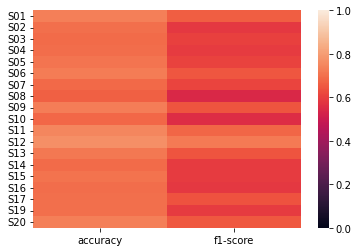

     class0 f1-score  class1 f1-score
S01         0.836502         0.271186
S02         0.818505         0.072727
S03         0.809689         0.126984
S04         0.817891         0.065574
S05         0.828571         0.076923
S06         0.835616         0.172414
S07         0.805461         0.173913
S08         0.798701         0.000000
S09         0.838095         0.163934
S10         0.810127         0.000000
S11         0.848921         0.250000
S12         0.854093         0.422535
S13         0.824742         0.238806
S14         0.813333         0.096774
S15         0.824675         0.068966
S16         0.818182         0.034483
S17         0.812030         0.242424
S19         0.816993         0.096774
S20         0.838926         0.225806


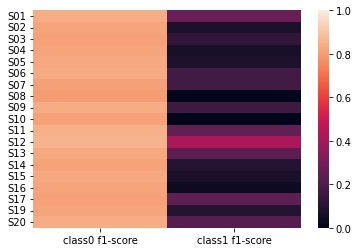

In [7]:
userfold_results_summary(participants_dictionary, participants)
userfold_classwise_results_summary(participants_dictionary, participants)


In [8]:
# channel_names=[i for i in range(input_dim[0])]
channel_names=["AFz","F3","F1","Fz","F2","F4","FC5","FC3","FC1","FCz","FC2",
               "FC4","FC6","C5","C3","C1","Cz","C2","C4","C6","CP5","CP3",
               "CP1","CPz","CP2","CP4","CP6","P3","P1","Pz","P2","P4"]

In [9]:
from sklearn.preprocessing import MinMaxScaler

participants_w_list=[]

for i in range(len(participants)):

    w= pickle.load(
        open(f"{saved_dir}/Userfold-{participants[i]}-EEGNet-Weight_EEG-w-e{EPOCH}.pkl", "rb") 
                    )  
    participants_w_list.append(w)
    
avg_w= np.array(participants_w_list).mean(axis=0)
# scaler= MinMaxScaler()
# scaled_avg_w= scaler.fit_transform(avg_w)

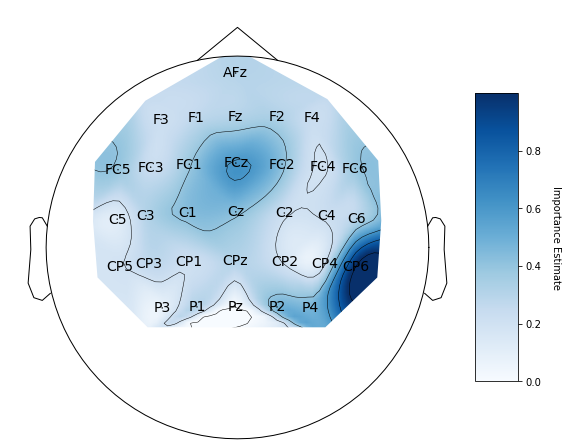

In [10]:
import matplotlib
from sklearn.preprocessing import MinMaxScaler
import mne
info= mne.create_info(channel_names, sfreq=500, ch_types=32*["eeg"])
info.set_montage("standard_1020")

fig= plt.figure()
ax= plt.axes((0,0,1.5,1.5))

scaler= MinMaxScaler()
scaled_avg_w= scaler.fit_transform(avg_w.reshape(-1,1))
# df= pd.DataFrame(scaled_avg_w.reshape(-1))

im, _= mne.viz.plot_topomap(
    scaled_avg_w.reshape(-1),
    info,
    ch_type= "eeg",
    sensors=True,
    names=channel_names,
    cmap="Blues",
    axes=ax,
    show=False,
    extrapolate="local"
#     sphere="eeglab"
)
fig.add_axes(ax)
cbar_ax= fig.add_axes([1.3,0.2, 0.1,1])
clb= fig.colorbar(im, cax=cbar_ax)
clb.set_label("Importance Estimate", rotation=270,labelpad=20)

for tt in plt.findobj(fig, matplotlib.text.Text):
    if tt.get_text() in channel_names:
        tt.set_fontsize(14)